# Mount drive and bucket
Todo: Remove in public version

In [1]:
# Check if the notebook is run in Google Colab
import sys

COLAB = 'google.colab' in sys.modules

In [2]:
import sys
import datetime
import logging

# nblog = open(f"/content/bigdata/nb_{datetime.datetime.utcnow().strftime('%Y%m%d_%H%M')}.log", "a+")
# print(nblog)
# sys.stdout.echo = nblog
# sys.stderr.echo = nblog

#get_ipython().log.handlers[0].stream = nblog
#get_ipython().log.setLevel(logging.INFO)

%autosave 60

Autosaving every 60 seconds


In [3]:
# if COLAB:
#   from google.colab import drive
#   drive.mount('/content/drive')

In [4]:
if COLAB:
  from google.colab import auth
  auth.authenticate_user()
else:
    print("Run the command!")
  #Todo #bring the command inside the notebook
  #run this terminal inside docker: gcloud auth login b.girsule@gmail.com --no-launch-browser

Run the command!


In [5]:
# Todo: Check if possible in local docker
# from google.cloud import storage

In [6]:
# Check if the tf version is 2.10.0, this is required to use the 'ignore_class' in the  SparseCategoricalCrossentropy
import tensorflow as tf

if '2.10.0' != tf.__version__:
  !pip uninstall tensorflow -y
  !pip install tensorflow-gpu==2.10.0
  please_restart_the_runtime
else:
  print("TF Version is 2.10.0, ok!")

2023-03-22 20:13:24.047943: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 20:13:24.273868: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-22 20:13:24.301228: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-22 20:13:25.011622: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

TF Version is 2.10.0, ok!


In [7]:
from tensorflow import keras
# import tensorflow_gcs_config
from tensorflow.python.lib.io import file_io

from keras.layers import Input, Dense, Flatten #, ReLU, Add, Flatten, Concatenate, LayerNormalization, UpSampling2D, Activation, LSTM, Multiply, Dropout, Reshape, Permute, BatchNormalization, MaxPooling1D, AveragePooling1D, MaxPooling3D, AveragePooling2D, LayerNormalization, MaxPooling2D
from keras.models import Model
from keras.optimizers import Adam

In [8]:
import os
from os import listdir
from os.path import isfile, join

In [9]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import gc
import random

In [10]:
# Set the google cloud bucket data
project_id = 'tweetprediction'
bucket_name = 'crypto_nlp_training'

In [11]:
# Set the checkpoint path for saving train progress
if COLAB:
    CHECKPOINT_PATH = f"gs://{bucket_name}/chk/"
else:
    CHECKPOINT_PATH = f"/content/bigdata/chk/"

In [12]:
# Check if the notebook is run in google colab, if so, clone the repo
if COLAB:
    print("Running in Colab")

    # Clone the whole repo to get all data and code if not already done
    if not os.path.exists("/content/CryptoCrystalBall"):
      !git clone https://github.com/girsigit/CryptoCrystalBall

      # cd into the notebooks directory --> Necessary to match all paths for importing
    #%cd /content/CryptoCrystalBall/JupyterDocker/notebooks
    %cd /content

In [13]:
# Try importing the Ta-Lib library, if this fails, try to install it and
# import it again afterwards
try:
    import talib
except:
    !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
    !tar -xzvf ta-lib-0.4.0-src.tar.gz
    %cd ta-lib
    !./configure --prefix=/usr
    !make
    !make install
    !pip install Ta-Lib
    %cd ..

    import talib

In [14]:
try:
  from transformers import TFRobertaModel, RobertaConfig
except:
  # Important!: Version 4.23 does not work on TPU
  !pip install transformers==4.22

  from transformers import TFRobertaModel, RobertaConfig

In [15]:
# !pip uninstall -y tensorboard-plugin-profile

In [16]:
# # Required to do profiling
# !pip install tensorboard-plugin-profile

In [17]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

---
# Add custom import path for DataStreamCreator and IndicatorCalculator

These libs are not in the standard python directory, so their paths have to be added to the import paths

In [18]:
# # Get the current directory
# current_dir = os.getcwd()
# current_dir_splitted = current_dir.split(os.sep)

# Todo: is inside /content/CB in local docker
current_dir_splitted = ["", "content"]
current_dir_splitted

['', 'content']

In [19]:
# Create the import directories for the DataStreamCreator and the IndicatorCalculator
dsc_dir = '/content/CryptoCrystalBall/DataStreamCreator'
print(f"dsc_dir: {dsc_dir}")

ind_dir = '/content/CryptoCrystalBall/IndicatorCalculator'
print(f"ind_dir: {ind_dir}")

# Add them to the import paths
sys.path.insert(0, dsc_dir)
sys.path.insert(0, ind_dir)

dsc_dir: /content/CryptoCrystalBall/DataStreamCreator
ind_dir: /content/CryptoCrystalBall/IndicatorCalculator


In [20]:
# Import the actual classes
from IndicatorCalculator import IndicatorCalculator
import DataStreamCreator

---
# Define all the parameters and variables

In [21]:
# Define the tick data path
DATA_PATH = os.path.join(os.sep, *current_dir_splitted, 'DemoData')
print(f"DATA_PATH: {DATA_PATH}")

DATA_PATH: /content/DemoData


In [22]:
# Define the chart image save path
IMG_SAVE_PATH = os.path.join(os.sep, *current_dir_splitted, 'Documentation', 'Images')
print(f"IMG_SAVE_PATH: {IMG_SAVE_PATH}")

IMG_SAVE_PATH: /content/Documentation/Images


In [23]:
# Define a global random seed
RANDOM_SEED = 42+14+2

# Set the seed in np
np.random.seed(RANDOM_SEED)

In [24]:
# X_BLOCK_LENGHT defines how far into the past a 'slice of a chart' shall be
# See: https://github.com/girsigit/CryptoCrystalBall/tree/main/DataStreamCreator#xblockgenerator
X_BLOCK_LENGHT = 64

In [25]:
# How many examples shall be processed at the same time, limited by GPU memory
BATCH_SIZE = 512

In [26]:
# A fixed number of features is used
FEATURES = 160

In [27]:
# Finanical indicator timespans
# See: https://github.com/girsigit/CryptoCrystalBall/tree/main/IndicatorCalculator
SHORTSPAN = 7
MIDSPAN = 38
LONGSPAN = 50

In [28]:
# Additional settings for the data stream
# For this notebook, the calculation of pattern indicators is turned off
DATA_STREAM_PARAMETERS = {
    "calcPatternIndicators": False, # No patterns are used
    "calcVolumeInidators": False, # No volume indicators, these are wide spread and may disturb the classifer
    "dropna": True # Drop all tick/indicator table rows containing nan values instead of just replacing them by 0 (which would lead to wrong predictions)
}

# Load the train dataset

In [29]:
# # Check if the dataset already has been copy, if not, copy it
# if not os.path.exists("/content/dataset") or not os.path.exists("/content/dataset/Train"):
#   !mkdir /content/dataset
#   !mkdir /content/dataset/Train
#   !gsutil -m cp -r gs://cryptocrystalball_public/CryptoDataset/Hourly/significant_currencies.txt /content/dataset/significant_currencies.txt
#   !gsutil -m cp -r gs://cryptocrystalball_public/CryptoDataset/Hourly/Train/* /content/dataset/Train/

In [30]:
# #@markdown ### Use only significant currencies
# #@markdown Load a manually defined list of significant currencies (`significant_currencies.txt`).
# #@markdown This list contains no currencies which little or no volume or price movement, to
# #@markdown avoid training on data sample which would never be used to trade on in a real 
# #@markdown application.

# #@markdown If enabled, only currency pairs with the base currency USDT are laoded,
# #@markdown this is important to prevent interference between different cryptocurrencies.
# #@markdown For example, in `BTC-ETH.csv`, there is influence of both the BTC and the ETH price, but we want to predict trade signals based on a 'real' currency (USDT is kind of the same as USD).

# significant_only = True #@param {type:"boolean"}

# if significant_only:
#   with open("/content/dataset/significant_currencies.txt") as f:
#     SIGNIFICANT_CURRS = f.read().splitlines()

#   print(f"Loaded {len(SIGNIFICANT_CURRS)} significant files names.")

In [31]:
# # Get train file names - Only pick the ones ending with -USDT to prevent
# # influence between different currencies
# TRAIN_PATH = "/content/dataset/Train"

# # Get all file names
# TRAIN_FILES = [os.path.join(TRAIN_PATH,f) for f in listdir(TRAIN_PATH) if isfile(join(TRAIN_PATH, f)) and ".csv" in f ]

# # Filter for significant currencies only
# if significant_only:
#   TRAIN_FILES = [f for f in TRAIN_FILES if f.split("/")[-1].replace(".csv","") in SIGNIFICANT_CURRS]

# # Filter for USDT-based ones only
# TRAIN_FILES = [f for f in TRAIN_FILES if "-USDT" in f]

# # Sort them (as a stable basis for randomizing afterwards)
# TRAIN_FILES = sorted(TRAIN_FILES)

# print(f"The train dataset contains {len(TRAIN_FILES)} files.")
# print(TRAIN_FILES[:3])

In [32]:
# Get train file names - Only pick the ones ending with -USDT to prevent
# influence between different currencies
TRAIN_PATH = "/content/dataset/etffancy"

# Get all file names
ALL_FILES = [os.path.join(TRAIN_PATH,f) for f in listdir(TRAIN_PATH) if isfile(join(TRAIN_PATH, f)) and ".csv" in f ]

# Sort them (as a stable basis for randomizing afterwards)
ALL_FILES = sorted(ALL_FILES)

print(f"The train dataset contains {len(ALL_FILES)} files.")
print(ALL_FILES[:3])

The train dataset contains 1064 files.
['/content/dataset/etffancy/DE0002635265.csv', '/content/dataset/etffancy/DE0002635273.csv', '/content/dataset/etffancy/DE0002635281.csv']


In [33]:
# Split the dataset into train, test (trade algorithm train) and eval (trade algorithm test)
SPLIT_RANDOM_SEED = 666
TRAIN_SET_SIZE = 0.5
TEST_SET_SIZE = 0.25
# EVAL_SET_SIZE: The rest

random.Random(SPLIT_RANDOM_SEED).shuffle(ALL_FILES)

train_split_index = int(len(ALL_FILES) * TRAIN_SET_SIZE)
print(f"train_split_index: {train_split_index}")

test_split_index = int(len(ALL_FILES) * (TRAIN_SET_SIZE + TEST_SET_SIZE))
print(f"test_split_index: {test_split_index}")

TRAIN_FILES = ALL_FILES[:train_split_index]
TEST_FILES = ALL_FILES[train_split_index:test_split_index]
EVAL_FILES = ALL_FILES[test_split_index:]

train_split_index: 532
test_split_index: 798


In [34]:
# with open('/content/EVAL_FILES.txt', 'w') as f:
#     for line in EVAL_FILES:
#         f.write(f"{line}\n")

---
# Prepare data source

For training a neural network, first the data source has to be prepared. For this purpose, the method `FileListToDataStream` from the `DataStreamCreator` class is used. This method creates a stream of `X-Block` and `y-data` arrays out of a list of .csv file names, pointing to tick tables (called `EXAMPLE_FILE_PATHS` in this example). For details about `X-Blocks` and `y-data`, please refer to the documentation of the `XBlockGenerator` and the `YDataGenerator` under https://github.com/girsigit/CryptoCrystalBall/tree/main/DataStreamCreator.

<br>

WRONG  WRONG  WRONG  WRONG  WRONG  WRONG  WRONG  WRONG  
Target values (y-data) from the data generator would not be necessary in this notebook, but since it cannot be switched off, the future direction and its derviation of the price have been chosen in `Y_TYPE_DICT` since they are not expensive to compute. A switch flag will be added in a future release.

In [35]:
# FPNWithAttention_4_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB
# Y_TYPE_DICT = copy.deepcopy(DataStreamCreator.YDataGenerator.PARAM_DICT_TEMPLATE_Y_DATA_TYPE_PAST_FUTURE_GAIN)
# Y_TYPE_DICT["gain_timespan"] = 2*30
# Y_TYPE_DICT

In [36]:
# FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB
Y_TYPE_DICT = copy.deepcopy(DataStreamCreator.YDataGenerator.PARAM_DICT_TEMPLATE_Y_DATA_TYPE_PAST_FUTURE_GAIN)
Y_TYPE_DICT["gain_timespan"] = 14
Y_TYPE_DICT

{'dataType': 3,
 'gain_timespan': 14,
 'direction_ma_timespan': 48,
 'derivation_ma_timespan': 48}

In [37]:
TARGET_FEATURE_CNT = 256

In [38]:
XShape = (BATCH_SIZE, X_BLOCK_LENGHT, TARGET_FEATURE_CNT)
XShape

(512, 64, 256)

In [39]:
# A python generator function has to be applied on the dataStream

def pythonGeneratorMLMTraining():
  # Initialize the FileListToDataStream generator
  dataStreamTraining = DataStreamCreator.FileListToDataStream(fileList = TRAIN_FILES,
                                                      batch_size = BATCH_SIZE,
                                                      X_Block_lenght = X_BLOCK_LENGHT,
                                                      y_type_dict=Y_TYPE_DICT,
                                                      shuffle=True,
                                                      parallel_generators = np.min([BATCH_SIZE, 8]),
                                                      random_seed = RANDOM_SEED,
                                                      **DATA_STREAM_PARAMETERS
                                                      )

  # This while has to integrated into the FileListToDataStream method
  while True:  
    try:
      ne = next(dataStreamTraining)
      _X = ne['X']
      _y = ne['y'][:,:2]
    
      # Recreate the y values
      #_y = np.arctanh(_y)
    
      # There may be inf or nan values due to the tanh-->acrtanh, remove them
      np.nan_to_num(_y, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    
      # 'Blow up' the X array to a 2**n size
      _X_new = np.zeros((_X.shape[0], _X.shape[1], TARGET_FEATURE_CNT))
      _X_new[:,:,:_X.shape[2]] = _X

      yield (_X_new, _y)
    except StopIteration as si:
      logging.warning("StopIteration in pythonGenerator")
      logging.warning(si)
      return

In [40]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
tfGenTraining = tf.data.Dataset.from_generator(pythonGeneratorMLMTraining, 
                                               output_types = (tf.int32, tf.float32),
                                               output_shapes=(
                                                   (BATCH_SIZE, X_BLOCK_LENGHT, TARGET_FEATURE_CNT),
                                                   (BATCH_SIZE, 2)
                                                   )
                                               )

tfGenTraining = tfGenTraining.prefetch(buffer_size=32)
tfGenTraining

2023-03-22 20:13:27.104308: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-22 20:13:27.135000: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-22 20:13:27.135187: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-22 20:13:27.136340: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

<PrefetchDataset element_spec=(TensorSpec(shape=(512, 64, 256), dtype=tf.int32, name=None), TensorSpec(shape=(512, 2), dtype=tf.float32, name=None))>

---
# Create the neural network

In the example, two Conv1D pyramids are used to extract features at different levels out of the feature and the time dimension.

It is also possible to use different architecures, like LSTM, Conv2D, Attention-Based ones or even NLP-based models. I have already tried many different ones and will publish them into the model zoo.

```
Todo: Create Model Zoo
```

```
Todo: Create Image of netwrok structure
```

In [41]:
# from keras.layers import Input, Dense, ReLU, Add, Flatten, Concatenate, LayerNormalization, UpSampling2D, Activation, LSTM, Multiply, Dropout, Reshape, Permute, BatchNormalization, MaxPooling1D, AveragePooling1D, MaxPooling3D, AveragePooling2D, LayerNormalization, MaxPooling2D, UnitNormalization, UpSampling1D
from keras.layers import UnitNormalization, Permute, Conv1D, UpSampling1D, Add, LSTM, Concatenate, Multiply, Activation, Attention

In [42]:
# Create the FPNWithFScaledInput model
# Infos about the feature pyramid: https://jonathan-hui.medium.com/understanding-feature-pyramid-networks-for-object-detection-fpn-45b227b9106c

def CreateModelFPNWithAttention():
  # Define model parameters
  mp = {
      "NAME": "FPNWithAttention",
      "VERSION": "5_ETF_Trained_Past_Future_Gain_TrainSetOnly",
      "CNN_INITIAL_FILTERS": 64, 
      "CNN_EXTRACTOR_LAYERS": 6,
      "CNN_INITIAL_KERNEL_SIZE": 2,
      "CNN_MAX_KERNEL_SIZE": 8,
      "FEATURE_PYRAMID_START_INDEX": 2,
      "HEAD_LSTM_SIZE": 32,
      "HEAD_DENSE_SIZE": 16
      }
  
  # Create the model input  
  inputTicksAndIndicators = Input(shape=(X_BLOCK_LENGHT, TARGET_FEATURE_CNT), name='inputTicksAndIndicators', dtype='float32')

  # Normalize the input data, as it has a wide value spread (range of 1e8)
  normalized = UnitNormalization(name="UnitNormalizationInput", axis=-2)(inputTicksAndIndicators)

  # Permute it to Conv over Features
  normalized = Permute((2, 1), name="PermuteInput")(normalized)

  # ----------------------------------------------------------------------------

  # As an example a 1D-CNN pyramid is used to extract higher-level features out
  # of the indicator+tick dimension
  conv_layers = []
  aligned_layers = []
  feature_map_layers = []
  anti_aliased_layers = []
  anti_aliased_pyramid_indices = []
  regressor_layers = []

  finalFilters = mp["CNN_INITIAL_FILTERS"] * 2**(mp["FEATURE_PYRAMID_START_INDEX"])
  print(finalFilters) 

  for i in range(mp["CNN_EXTRACTOR_LAYERS"]):
    if 0 == i:
      source_layer = normalized
    else:
      source_layer = feature_conv
    
    filters = int(mp["CNN_INITIAL_FILTERS"]*(2**i))
    kernel_size = mp["CNN_INITIAL_KERNEL_SIZE"]*(2**i)
    kernel_size = int(np.min([mp["CNN_MAX_KERNEL_SIZE"], kernel_size]))
    strides = int(np.min([2,kernel_size]))

    print(f"Step {i}, using {filters} filters with a kernel size of {kernel_size} at strides of {strides}")

    # Create the feature extraction convolution
    feature_conv = Conv1D(filters=filters,
                          kernel_size=kernel_size,
                          strides=strides, 
                          padding="same",
                          name=f"Feature_Conv1D_{i}")(source_layer)

    # # Calculate the attention filters
    # attention_f = Conv1D(filters=1,
    #                      kernel_size=1,
    #                      strides=1, 
    #                      padding="same",
    #                      name=f"Attention_f_Conv1D_{i}")(feature_conv)
  
    # attention_g = Conv1D(filters=1,
    #                      kernel_size=1,
    #                      strides=1, 
    #                      padding="same",
    #                      name=f"Attention_g_Conv1D_{i}")(feature_conv)
   
    # attention_h = Conv1D(filters=1,
    #                      kernel_size=1,
    #                      strides=1, 
    #                      padding="same",
    #                      name=f"Attention_h_Conv1D_{i}")(feature_conv)

    # attention_map = Attention(name=f"Attention_Layer_{i}")([attention_f,attention_g,attention_h])
    attention_map = Attention(name=f"Attention_Layer_{i}")([feature_conv,feature_conv])
    print(f"attention_map.shape: {attention_map.shape}")

    feature_conv_attentioned = Multiply(name=f"Multiply_Apply_Attention_{i}")([feature_conv, attention_map])
    print(f"feature_conv_attentioned.shape: {feature_conv_attentioned.shape}")
    
    # feature_conv_attentioned = Conv1D(filters=filters,
    #                                   kernel_size=1,
    #                                   strides=1, 
    #                                   padding="same",
    #                                   name=f"Feature_Conv1D_Attentioned_Filterextend{i}")(feature_conv_attentioned)
    # print(f"feature_conv_attentioned.shape: {feature_conv_attentioned.shape}")

    conv_layers.append(feature_conv_attentioned)

    # Apply the feature extraction pyramid
    if mp["FEATURE_PYRAMID_START_INDEX"] <= i:
      # Apply a 1x1 convolution to align the channel depth    
      if feature_conv_attentioned.shape[-1] != finalFilters:
        aligned_layer = Conv1D(filters=finalFilters,
                              kernel_size=1,
                              strides=1,
                              padding="same",
                              name=f"Channel_Depth_Alignment_{i}")(feature_conv_attentioned)
      else:
        aligned_layer = feature_conv_attentioned
      
      aligned_layers.append(aligned_layer)

  # Go top-down through the aligned_layers to create the feature_map_layers
  for i in range(mp["CNN_EXTRACTOR_LAYERS"]-1, mp["FEATURE_PYRAMID_START_INDEX"]-1, -1):
    aligned_layers_index = i - mp["FEATURE_PYRAMID_START_INDEX"]
    aligned_layer = aligned_layers[aligned_layers_index]

    print(f"Building feature_map_layers, step {i}. Shape of aligned_layer: {aligned_layer.shape}")

    # The highest-filtered layer is taken as feature map directly
    if i == mp["CNN_EXTRACTOR_LAYERS"]-1:
      feature_map_layers.append(aligned_layer)
      anti_aliased_layers.append(feature_map_layers[-1])
    else:
      # Take the last feature_map_layer and scale it by two
      upsampled = UpSampling1D(size=2,
                               name=f"Pyramid_Upsampling_{i}")(feature_map_layers[-1])

      # Add the aligned_layer
      added = Add(name=f"Pyramid_Add_{i}")([upsampled, aligned_layer])

      # Append as new feature_map_layer
      feature_map_layers.append(added)

      # Apply a convolution with a kernel size of 3 to "reduce the aliasing effect"
      anti_aliased_layer = Conv1D(filters=feature_map_layers[-1].shape[-1],
                                  kernel_size=3,
                                  strides=1,
                                  padding="same",
                                  name=f"Anti_Alias_{i}")(feature_map_layers[-1])

      anti_aliased_layers.append(anti_aliased_layer)

    # Helper storage to keep pyramid index consistent, also in predictor/regressor
    anti_aliased_pyramid_indices.append(i)

  # Apply the predictor head to each feature dimension layer
  for n in range(len(anti_aliased_layers)):
    predictor_input = anti_aliased_layers[n]

    # Get the pyramid index
    pyramid_index = anti_aliased_pyramid_indices[n]

    # Permute the Conv output back
    predictor_input = Permute((2, 1), name=f"PermutePredictorInput_{pyramid_index}")(predictor_input)

    predictor = LSTM(units=mp["HEAD_LSTM_SIZE"],
                     name=f"Predictor_Head_{pyramid_index}_LSTM")(predictor_input)
    
    # Direction and derivation regressor
    regressor = Dense(units=mp["HEAD_DENSE_SIZE"],
                      name=f"Predictor_Head_{pyramid_index}_Dense_Regressor",
                      activation='relu')(predictor)
    
    regressor_layers.append(regressor)
  
  # Add all regressors together
  regressor_conced = Concatenate(name="Concatenate_regressors")(regressor_layers)
  regressor_conced = Dense(regressor_conced.shape[1], name="Combined_Regressor_1")(regressor_conced)
  regressor_conced = Dense(regressor_conced.shape[1], name="Combined_Regressor_2")(regressor_conced)

  # The output are two values (direction and derivation) in the range [-1.0, 1.0]
  output = Dense(2, name="Output")(regressor_conced)
  outputs = [output]

  # Combine it all into a model object
  model = Model(inputs=inputTicksAndIndicators, outputs=outputs, name=mp["NAME"] + "_" + str(mp["VERSION"]))

  return model, mp

model, model_config = CreateModelFPNWithAttention()
print(model_config)
model.summary(line_length=220)

256
Step 0, using 64 filters with a kernel size of 2 at strides of 2
attention_map.shape: (None, 128, 64)
feature_conv_attentioned.shape: (None, 128, 64)
Step 1, using 128 filters with a kernel size of 4 at strides of 2
attention_map.shape: (None, 64, 128)
feature_conv_attentioned.shape: (None, 64, 128)
Step 2, using 256 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 32, 256)
feature_conv_attentioned.shape: (None, 32, 256)
Step 3, using 512 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 16, 512)
feature_conv_attentioned.shape: (None, 16, 512)
Step 4, using 1024 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 8, 1024)
feature_conv_attentioned.shape: (None, 8, 1024)
Step 5, using 2048 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 4, 2048)
feature_conv_attentioned.shape: (None, 4, 2048)
Building feature_map_layers, step 5. Shape of aligned_layer: (None, 4, 256)
Building feat

In [43]:
# model.load_weights("/content/bigdata/chk/FPNWithFScaledInput_3_GPU_64LB/cp_daily_valid_202_end/model.h5")

In [44]:
# model.get_layer("CryptoRoberta").set_weights(modelMLM.get_layer("tf_roberta_model").get_weights())

In [45]:
# model.get_layer("CryptoRoberta").trainable=False

In [46]:
# model.summary()

In [47]:
# model.save("/content/bigdata/RobertaToDirDerv_1_init.h5")

In [48]:
# model.load_weights("/content/bigdata/RobertaToDirDerv_1_init.h5")
#model.load_weights("/content/bigdata/chk/FPNWithAttention_1_ETF_Trained_GPU_64LB/cp_daily_valid_182_end/model.h5")

# Train the model

### Train strategy in the paper
https://huggingface.co/roberta-base

The model was trained on 1024 V100 GPUs for 500K steps with a batch size of 8K and a sequence length of 512. The optimizer used is Adam with a learning rate of 6e-4, β1=0.9\beta_{1} = 0.9β1​=0.9, β2=0.98\beta_{2} = 0.98β2​=0.98 and ϵ=1e−6\epsilon = 1e-6ϵ=1e−6, a weight decay of 0.01, learning rate warmup for 24,000 steps and linear decay of the learning rate after.

In [49]:
CHKPNT_NAME = f"{model.name}_GPU_{X_BLOCK_LENGHT}LB"
CHKPNT_NAME

'FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB'

In [50]:
# Set an optimizer
optimizer = Adam(
    learning_rate=1e-03,
    epsilon=1e-06,
    beta_1=0.9,
    beta_2=0.98,
    decay=0.01)

In [51]:
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = ["mse"], 
    metrics=["mae"])

In [52]:
# model.summary(line_length=220)

In [53]:
#@title CustomCallback
class CustomCallback(tf.keras.callbacks.Callback):
  def __init__(self, save_freq, val_freq, checkpoint_path, model_name, epoch_add=0):
    self.save_freq = save_freq
    self.val_freq = val_freq
    self.checkpoint_path = checkpoint_path
    self.model_name = model_name
    self.current_epoch = 0
    self.epoch_add = epoch_add

  def on_epoch_begin(self, epoch, logs=None):
    self.current_epoch = epoch + self.epoch_add
    # keys = list(logs.keys())
    # print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

  def on_epoch_end(self, epoch, logs=None):
    self.saveTheModel(-1, logs)

  def on_train_batch_end(self, batch, logs=None):
    self.saveTheModel(batch, logs)

  def saveTheModel(self, batch, logs=None):
    if (0 < batch and 0 == batch % self.save_freq) or (0 > batch):
      logging.info(str(datetime.datetime.utcnow()))
    
      if 0 > batch:
        _save_folder = os.path.join(self.checkpoint_path,
                                    self.model_name,
                                    "cp_daily_valid_{:02d}_end".format(self.current_epoch)
                                    )
      else:
        _save_folder = os.path.join(self.checkpoint_path,
                                    self.model_name,
                                    "cp_daily_valid_{:02d}_{:05d}".format(self.current_epoch, batch)
                                    )
      
      fp = os.path.join(_save_folder, "model.h5")
      model.save(fp)
      logging.info(f"Saved model to '{fp}'")
      
      # Save optimizer config
      # c = copy.deepcopy(self.model.optimizer.get_config())

      fp = os.path.join(_save_folder, "c.pickle")
      with file_io.FileIO(fp, mode='wb+') as handle:
        pickle.dump(self.model.optimizer.get_config(), handle, protocol=pickle.HIGHEST_PROTOCOL)
        
      logging.info(f"Saved optimizer config to '{fp}'")

      # Save optimizer weights
      # w = copy.deepcopy(self.model.optimizer.get_weights())

      fp = os.path.join(_save_folder, "w.pickle")
      with open(fp, "wb") as handle:
        # with file_io.FileIO(fp, mode='wb+') as handle:
        pickle.dump(self.model.optimizer.get_weights(), handle, protocol=pickle.HIGHEST_PROTOCOL)
      
      logging.info(f"Saved optimizer weights to '{fp}'")
        
      logging.info(f"Did a gc collect: {gc.collect()}")

    # if 0 < batch and 0 == batch % self.val_freq:
    #   print("-------------------------EVAL-------------------------")
    #   model.evaluate(tfgenTest)
    #   print("\n-------------------------EVAL-------------------------")

In [54]:
gc.collect()

9884

In [55]:
# CLASS_WEIGHTS_DICT = None
# CLASS_WEIGHTS_DICT = {}

# for i, cw in enumerate(CLASS_WEIGHTS[0,0,:]):
#   CLASS_WEIGHTS_DICT[i] = cw

In [56]:
epoch_add = 0

In [57]:
CALLBACK_EVERY_N_BATCHES = 2000

In [58]:
cc = CustomCallback(checkpoint_path = CHECKPOINT_PATH,
                    model_name = CHKPNT_NAME,
                    save_freq = CALLBACK_EVERY_N_BATCHES,
                    val_freq = CALLBACK_EVERY_N_BATCHES,
                    epoch_add = epoch_add)

In [59]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [60]:
%reload_ext tensorboard

The TensorBoard UI is displayed in a browser window. In this colab, perform the following steps to prepare to capture profile information.
1.  Click on the dropdown menu box on the top right side and scroll down and click PROFILE. A new window appears that shows: **No profile data was found** at the top.
1.  Click on the CAPTURE PROFILE button. A new dialog appears. The top input line shows: **Profile Service URL or TPU name**. Copy and paste the Profile Service URL (the service_addr value shown before launching TensorBoard) into the top input line. While still on the dialog box, start the training with the next step.
1.  Click on the next colab cell to start training the model.
1.  Watch the output from the training until several epochs have completed. This allows time for the profile data to start being collected. Return to the dialog box and click on the CAPTURE button. If the capture succeeds, the page will auto refresh and redirect you to the profiling results.

In [61]:
# Todo: Create more elegant solution
log_dir = "gs://ticks_with_indicators_with_volume/logs/TPU/" + CHKPNT_NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

if not COLAB:
    log_dir = os.path.join("/content/bigdata/log",log_dir.split("/")[-1])

log_dir

'/content/bigdata/log/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB20230322-201328'

In [62]:
import datetime

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    update_freq=CALLBACK_EVERY_N_BATCHES,
    profile_batch=(5,100)
    )

2023-03-22 20:13:28.930839: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-22 20:13:28.930876: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-22 20:13:28.930918: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2023-03-22 20:13:28.931701: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2023-03-22 20:13:29.030017: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-03-22 20:13:29.030265: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


In [63]:
# CLASS_WEIGHTS_DICT = None

In [64]:
model.load_weights("/content/bigdata/chk/FPNWithAttention_4_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_22_end/model.h5")

In [65]:
%tensorboard --logdir $log_dir --host 0.0.0.0 --port 6006

In [66]:
# model.optimizer.learning_rate = 1e-5

In [67]:
model.optimizer.learning_rate

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>

In [68]:
model.fit(tfGenTraining,
          epochs=20,
          verbose = 1,
          callbacks=[tensorboard_callback, cc])

Epoch 1/20


INFO:root:File 'LU1829218749.csv' loaded, 531 left
INFO:root:File 'IE00BJK9HD13.csv' loaded, 530 left
INFO:root:File 'IE00B6YX5M31.csv' loaded, 529 left
INFO:root:File 'IE00B6YX5C33.csv' loaded, 528 left
INFO:root:File 'LU1437018168.csv' loaded, 527 left
INFO:root:File 'DE000ETFL441.csv' loaded, 526 left
INFO:root:File 'IE00B60SX287.csv' loaded, 525 left
INFO:root:File 'LU0959210278.csv' loaded, 524 left
2023-03-22 20:13:45.424630: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8700
2023-03-22 20:13:46.109947: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
INFO:root:File 'IE00B4X9L533.csv' loaded, 523 left


      2/Unknown - 23s 136ms/step - loss: 0.0016 - mae: 0.0360

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 522 left


      4/Unknown - 24s 274ms/step - loss: 0.0036 - mae: 0.0472

2023-03-22 20:13:55.492653: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-22 20:13:55.492686: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


      6/Unknown - 25s 299ms/step - loss: 0.0025 - mae: 0.0363WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0743s vs `on_train_batch_end` time: 0.1136s). Check your callbacks.


     16/Unknown - 26s 195ms/step - loss: 0.0010 - mae: 0.0192

INFO:root:File 'IE00B5L8K969.csv' loaded, 521 left


     18/Unknown - 28s 260ms/step - loss: 9.3136e-04 - mae: 0.0179

INFO:root:File 'IE00BWBXM492.csv' loaded, 520 left


     22/Unknown - 29s 284ms/step - loss: 7.8132e-04 - mae: 0.0160

INFO:root:File 'IE00BP2C1V62.csv' loaded, 519 left


     29/Unknown - 31s 258ms/step - loss: 6.1130e-04 - mae: 0.0139

INFO:root:File 'DE000A0H08J9.csv' loaded, 518 left


     31/Unknown - 33s 318ms/step - loss: 5.7631e-04 - mae: 0.0134

INFO:root:File 'IE00B3VWM098.csv' loaded, 517 left


     33/Unknown - 35s 354ms/step - loss: 5.4757e-04 - mae: 0.0131

INFO:root:File 'LU0392496427.csv' loaded, 516 left


     46/Unknown - 38s 326ms/step - loss: 4.1479e-04 - mae: 0.0113

INFO:root:File 'IE00BF2B0L69.csv' loaded, 515 left


     57/Unknown - 40s 301ms/step - loss: 3.5114e-04 - mae: 0.0105

INFO:root:File 'LU2206598109.csv' loaded, 514 left


     60/Unknown - 41s 299ms/step - loss: 3.3653e-04 - mae: 0.0103

INFO:root:File 'IE00BMQ8YK98.csv' loaded, 513 left


     64/Unknown - 42s 294ms/step - loss: 3.2115e-04 - mae: 0.0101

INFO:root:File 'LU1650492256.csv' loaded, 512 left


     67/Unknown - 43s 302ms/step - loss: 3.1069e-04 - mae: 0.0100

INFO:root:File 'IE00BYZK4776.csv' loaded, 511 left


     69/Unknown - 44s 308ms/step - loss: 3.0359e-04 - mae: 0.0099

INFO:root:File 'IE00BD1F4M44.csv' loaded, 510 left


     76/Unknown - 46s 301ms/step - loss: 2.8596e-04 - mae: 0.0095

INFO:root:File 'IE00BKVD2J03.csv' loaded, 509 left


     85/Unknown - 48s 288ms/step - loss: 2.7193e-04 - mae: 0.0094

INFO:root:File 'LU0671493277.csv' loaded, 508 left


     87/Unknown - 49s 297ms/step - loss: 2.6875e-04 - mae: 0.0093

INFO:root:File 'IE00BX7RR706.csv' loaded, 507 left


     99/Unknown - 52s 288ms/step - loss: 2.6162e-04 - mae: 0.0093

2023-03-22 20:14:23.023866: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-03-22 20:14:23.026104: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2023-03-22 20:14:23.290967: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:521]  GpuTracer has collected 463105 callback api events and 465183 activity events. 
2023-03-22 20:14:26.893989: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-03-22 20:14:30.315599: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /content/bigdata/log/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB20230322-201328/plugins/profile/2023_03_22_20_14_26

2023-03-22 20:14:34.018029: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /content/bigdata/log/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB20230

    102/Unknown - 66s 423ms/step - loss: 2.5690e-04 - mae: 0.0093

INFO:root:File 'LU1437017350.csv' loaded, 506 left


    103/Unknown - 67s 427ms/step - loss: 2.5604e-04 - mae: 0.0093

INFO:root:File 'IE00B1FZS244.csv' loaded, 505 left


    108/Unknown - 69s 429ms/step - loss: 2.4724e-04 - mae: 0.0091

INFO:root:File 'IE00B5377D42.csv' loaded, 504 left


    112/Unknown - 71s 431ms/step - loss: 2.4059e-04 - mae: 0.0090

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 503 left


    116/Unknown - 73s 428ms/step - loss: 2.3785e-04 - mae: 0.0090

INFO:root:File 'LU1799934903.csv' loaded, 502 left


    123/Unknown - 74s 413ms/step - loss: 2.3173e-04 - mae: 0.0090

INFO:root:File 'IE00BMDH1538.csv' loaded, 501 left


    128/Unknown - 75s 405ms/step - loss: 2.2690e-04 - mae: 0.0090

INFO:root:File 'LU2082997516.csv' loaded, 500 left


    133/Unknown - 76s 398ms/step - loss: 2.2245e-04 - mae: 0.0089

INFO:root:File 'IE00BFD2H405.csv' loaded, 499 left


    134/Unknown - 76s 396ms/step - loss: 2.2126e-04 - mae: 0.0089

INFO:root:File 'IE00B0M62Q58.csv' loaded, 498 left


    142/Unknown - 79s 397ms/step - loss: 2.1312e-04 - mae: 0.0088

INFO:root:File 'IE000UQND7H4.csv' loaded, 497 left


    145/Unknown - 80s 393ms/step - loss: 2.1110e-04 - mae: 0.0088

INFO:root:File 'LU1681042609.csv' loaded, 496 left


    148/Unknown - 82s 397ms/step - loss: 2.0995e-04 - mae: 0.0088

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 495 left


    152/Unknown - 84s 399ms/step - loss: 2.0757e-04 - mae: 0.0087

INFO:root:File 'LU2082997359.csv' loaded, 494 left


    156/Unknown - 85s 395ms/step - loss: 2.0403e-04 - mae: 0.0087

INFO:root:File 'IE00B3F81409.csv' loaded, 493 left


    158/Unknown - 86s 396ms/step - loss: 2.0293e-04 - mae: 0.0087

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 492 left


    163/Unknown - 87s 393ms/step - loss: 1.9909e-04 - mae: 0.0086

INFO:root:File 'DE0005933949.csv' loaded, 491 left


    180/Unknown - 92s 381ms/step - loss: 1.8791e-04 - mae: 0.0084

INFO:root:File 'IE00BYTRRG40.csv' loaded, 490 left


    184/Unknown - 93s 380ms/step - loss: 1.8566e-04 - mae: 0.0084

INFO:root:File 'LU1079842321.csv' loaded, 489 left


    195/Unknown - 95s 371ms/step - loss: 1.7815e-04 - mae: 0.0082

INFO:root:File 'IE00B3B8PX14.csv' loaded, 488 left


    197/Unknown - 97s 376ms/step - loss: 1.7713e-04 - mae: 0.0082

INFO:root:File 'IE00BCRY6003.csv' loaded, 487 left


    215/Unknown - 101s 361ms/step - loss: 1.6606e-04 - mae: 0.0079

INFO:root:File 'LU2023678282.csv' loaded, 486 left


    218/Unknown - 101s 360ms/step - loss: 1.6419e-04 - mae: 0.0079

INFO:root:File 'LU2082998324.csv' loaded, 485 left


    226/Unknown - 103s 354ms/step - loss: 1.5951e-04 - mae: 0.0078

INFO:root:File 'DE000ETF9033.csv' loaded, 484 left


    230/Unknown - 104s 353ms/step - loss: 1.5736e-04 - mae: 0.0077

INFO:root:File 'IE000L2ZNB07.csv' loaded, 483 left


    232/Unknown - 105s 352ms/step - loss: 1.5623e-04 - mae: 0.0077

INFO:root:File 'LU1681041205.csv' loaded, 482 left


    234/Unknown - 105s 351ms/step - loss: 1.5524e-04 - mae: 0.0077

INFO:root:File 'LU1681049109.csv' loaded, 481 left


    235/Unknown - 107s 358ms/step - loss: 1.5484e-04 - mae: 0.0077

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 480 left


    237/Unknown - 108s 358ms/step - loss: 1.5386e-04 - mae: 0.0076

INFO:root:File 'IE00BZ048462.csv' loaded, 479 left


    248/Unknown - 110s 351ms/step - loss: 1.4885e-04 - mae: 0.0075

INFO:root:File 'DE0005933972.csv' loaded, 478 left


    250/Unknown - 112s 358ms/step - loss: 1.4868e-04 - mae: 0.0075

INFO:root:File 'IE00BQT3WG13.csv' loaded, 477 left


    263/Unknown - 115s 351ms/step - loss: 1.4453e-04 - mae: 0.0074

INFO:root:File 'FR0011475078.csv' loaded, 476 left


    265/Unknown - 117s 353ms/step - loss: 1.4450e-04 - mae: 0.0074

INFO:root:File 'IE00B0M63284.csv' loaded, 475 left


    269/Unknown - 119s 357ms/step - loss: 1.4304e-04 - mae: 0.0074

INFO:root:File 'IE00BDFK1573.csv' loaded, 474 left


    277/Unknown - 121s 352ms/step - loss: 1.4016e-04 - mae: 0.0073

INFO:root:File 'LU1981859819.csv' loaded, 473 left


    288/Unknown - 123s 346ms/step - loss: 1.4111e-04 - mae: 0.0074

INFO:root:File 'LU0136234654.csv' loaded, 472 left


    292/Unknown - 125s 350ms/step - loss: 1.4082e-04 - mae: 0.0073

INFO:root:File 'LU1602144906.csv' loaded, 471 left


    294/Unknown - 126s 351ms/step - loss: 1.4030e-04 - mae: 0.0073

INFO:root:File 'LU2037748345.csv' loaded, 470 left


    296/Unknown - 127s 352ms/step - loss: 1.3982e-04 - mae: 0.0073

INFO:root:File 'LU1079841273.csv' loaded, 469 left


    300/Unknown - 129s 352ms/step - loss: 1.3888e-04 - mae: 0.0073

INFO:root:File 'IE00BGBN6P67.csv' loaded, 468 left


    312/Unknown - 131s 345ms/step - loss: 1.3705e-04 - mae: 0.0073

INFO:root:File 'IE00B3VWN179.csv' loaded, 467 left


    318/Unknown - 133s 346ms/step - loss: 1.3632e-04 - mae: 0.0073

INFO:root:File 'LU0488317701.csv' loaded, 466 left


    320/Unknown - 135s 349ms/step - loss: 1.3606e-04 - mae: 0.0073

INFO:root:File 'IE00B02KXL92.csv' loaded, 465 left


    323/Unknown - 137s 353ms/step - loss: 1.3570e-04 - mae: 0.0073

INFO:root:File 'IE00B87RLX93.csv' loaded, 464 left


    338/Unknown - 140s 346ms/step - loss: 1.3312e-04 - mae: 0.0073

INFO:root:File 'DE0006289465.csv' loaded, 463 left


    361/Unknown - 145s 339ms/step - loss: 1.3210e-04 - mae: 0.0073

INFO:root:File 'LU1681040496.csv' loaded, 462 left


    372/Unknown - 148s 335ms/step - loss: 1.3101e-04 - mae: 0.0073

INFO:root:File 'IE000KPJJWM6.csv' loaded, 461 left


    373/Unknown - 148s 335ms/step - loss: 1.3080e-04 - mae: 0.0073

INFO:root:File 'IE00B2QWDR12.csv' loaded, 460 left


    377/Unknown - 150s 337ms/step - loss: 1.3084e-04 - mae: 0.0073

INFO:root:File 'IE00BDDRF478.csv' loaded, 459 left


    389/Unknown - 152s 333ms/step - loss: 1.3239e-04 - mae: 0.0073

INFO:root:File 'IE00BSPLC413.csv' loaded, 458 left


    391/Unknown - 154s 334ms/step - loss: 1.3224e-04 - mae: 0.0073

INFO:root:File 'IE00BD9MMD49.csv' loaded, 457 left


    401/Unknown - 155s 330ms/step - loss: 1.3200e-04 - mae: 0.0074

INFO:root:File 'IE00B5MTYL84.csv' loaded, 456 left


    408/Unknown - 158s 330ms/step - loss: 1.3586e-04 - mae: 0.0075

INFO:root:File 'IE0032077012.csv' loaded, 455 left


    415/Unknown - 161s 332ms/step - loss: 1.3587e-04 - mae: 0.0075

INFO:root:File 'IE00B979GK47.csv' loaded, 454 left


    417/Unknown - 162s 332ms/step - loss: 1.3563e-04 - mae: 0.0075

INFO:root:File 'DE000A0Q4R36.csv' loaded, 453 left


    425/Unknown - 165s 334ms/step - loss: 1.3485e-04 - mae: 0.0075

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 452 left


    434/Unknown - 167s 332ms/step - loss: 1.3347e-04 - mae: 0.0074

INFO:root:File 'IE00B4K6B022.csv' loaded, 451 left


    436/Unknown - 167s 331ms/step - loss: 1.3306e-04 - mae: 0.0074

INFO:root:File 'LU1681045370.csv' loaded, 450 left


    452/Unknown - 172s 330ms/step - loss: 1.3111e-04 - mae: 0.0074

INFO:root:File 'LU2082998670.csv' loaded, 449 left


    456/Unknown - 173s 329ms/step - loss: 1.3085e-04 - mae: 0.0074

INFO:root:File 'IE00BKVL7778.csv' loaded, 448 left


    465/Unknown - 175s 326ms/step - loss: 1.2971e-04 - mae: 0.0074

INFO:root:File 'LU1327051279.csv' loaded, 447 left


    469/Unknown - 176s 327ms/step - loss: 1.2912e-04 - mae: 0.0074

INFO:root:File 'DE000ETFL011.csv' loaded, 446 left


    472/Unknown - 178s 329ms/step - loss: 1.2868e-04 - mae: 0.0074

INFO:root:File 'IE00BF59RW70.csv' loaded, 445 left


    478/Unknown - 180s 328ms/step - loss: 1.2801e-04 - mae: 0.0074

INFO:root:File 'LU1681041890.csv' loaded, 444 left


    494/Unknown - 183s 324ms/step - loss: 1.2749e-04 - mae: 0.0074

INFO:root:File 'IE00B5MJYC95.csv' loaded, 443 left


    504/Unknown - 186s 322ms/step - loss: 1.2663e-04 - mae: 0.0073

INFO:root:File 'IE00BYXPXL17.csv' loaded, 442 left


    506/Unknown - 186s 323ms/step - loss: 1.2641e-04 - mae: 0.0073

INFO:root:File 'IE00BCLWRD08.csv' loaded, 441 left


    511/Unknown - 188s 323ms/step - loss: 1.2616e-04 - mae: 0.0073

INFO:root:File 'IE00B23LNQ02.csv' loaded, 440 left


    516/Unknown - 190s 324ms/step - loss: 1.2622e-04 - mae: 0.0074

INFO:root:File 'IE00B3B8Q275.csv' loaded, 439 left


    523/Unknown - 193s 325ms/step - loss: 1.2847e-04 - mae: 0.0074

INFO:root:File 'IE00BHZRR147.csv' loaded, 438 left


    536/Unknown - 195s 321ms/step - loss: 1.2854e-04 - mae: 0.0074

INFO:root:File 'IE00BZ4BMM98.csv' loaded, 437 left


    540/Unknown - 196s 321ms/step - loss: 1.2810e-04 - mae: 0.0074

INFO:root:File 'DE0006289382.csv' loaded, 436 left


    544/Unknown - 199s 324ms/step - loss: 1.2763e-04 - mae: 0.0074

INFO:root:File 'IE00BMFNWC33.csv' loaded, 435 left


    552/Unknown - 201s 322ms/step - loss: 1.2710e-04 - mae: 0.0074

INFO:root:File 'IE00BKX55Q28.csv' loaded, 434 left


    555/Unknown - 202s 322ms/step - loss: 1.2677e-04 - mae: 0.0073

INFO:root:File 'IE00BFNM3F38.csv' loaded, 433 left


    558/Unknown - 203s 322ms/step - loss: 1.2663e-04 - mae: 0.0073

INFO:root:File 'LU0378437502.csv' loaded, 432 left


    571/Unknown - 206s 321ms/step - loss: 1.2499e-04 - mae: 0.0073

INFO:root:File 'LU0629460089.csv' loaded, 431 left


    577/Unknown - 208s 321ms/step - loss: 1.2443e-04 - mae: 0.0073

INFO:root:File 'IE00B6R52143.csv' loaded, 430 left


    579/Unknown - 210s 322ms/step - loss: 1.2434e-04 - mae: 0.0073

INFO:root:File 'IE00B4K48X80.csv' loaded, 429 left


    596/Unknown - 213s 319ms/step - loss: 1.2324e-04 - mae: 0.0073

INFO:root:File 'DE0005933956.csv' loaded, 428 left


    599/Unknown - 216s 322ms/step - loss: 1.2297e-04 - mae: 0.0073

INFO:root:File 'LU1435356149.csv' loaded, 427 left


    601/Unknown - 217s 322ms/step - loss: 1.2266e-04 - mae: 0.0073

INFO:root:File 'LU1230561679.csv' loaded, 426 left


    635/Unknown - 223s 314ms/step - loss: 1.1897e-04 - mae: 0.0072

INFO:root:File 'DE0005933923.csv' loaded, 425 left


    638/Unknown - 225s 317ms/step - loss: 1.1867e-04 - mae: 0.0072

INFO:root:File 'IE00BKX55S42.csv' loaded, 424 left


    641/Unknown - 226s 317ms/step - loss: 1.1832e-04 - mae: 0.0072

INFO:root:File 'IE00BCRY6557.csv' loaded, 423 left


    643/Unknown - 227s 317ms/step - loss: 1.1804e-04 - mae: 0.0072

INFO:root:File 'LU2250132763.csv' loaded, 422 left


    645/Unknown - 228s 318ms/step - loss: 1.1777e-04 - mae: 0.0072

INFO:root:File 'LU2023678449.csv' loaded, 421 left


    652/Unknown - 230s 317ms/step - loss: 1.1680e-04 - mae: 0.0071

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 420 left


    655/Unknown - 231s 317ms/step - loss: 1.1638e-04 - mae: 0.0071

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 419 left


    659/Unknown - 232s 316ms/step - loss: 1.1591e-04 - mae: 0.0071

INFO:root:File 'IE00B3FH7618.csv' loaded, 418 left


    664/Unknown - 234s 317ms/step - loss: 1.1543e-04 - mae: 0.0071

INFO:root:File 'IE00BNG8L278.csv' loaded, 417 left


    666/Unknown - 234s 317ms/step - loss: 1.1521e-04 - mae: 0.0071

INFO:root:File 'IE00BJXRT698.csv' loaded, 416 left


    673/Unknown - 236s 316ms/step - loss: 1.1475e-04 - mae: 0.0071

INFO:root:File 'LU0392496260.csv' loaded, 415 left


    675/Unknown - 238s 318ms/step - loss: 1.1467e-04 - mae: 0.0071

INFO:root:File 'DE000A0F5UF5.csv' loaded, 414 left


    683/Unknown - 240s 318ms/step - loss: 1.1408e-04 - mae: 0.0071

INFO:root:File 'IE00BYTRR863.csv' loaded, 413 left


    685/Unknown - 241s 319ms/step - loss: 1.1393e-04 - mae: 0.0071

INFO:root:File 'IE00BF11F458.csv' loaded, 412 left


    692/Unknown - 243s 318ms/step - loss: 1.1325e-04 - mae: 0.0070

INFO:root:File 'IE00B66F4759.csv' loaded, 411 left


    714/Unknown - 247s 314ms/step - loss: 1.1145e-04 - mae: 0.0070

INFO:root:File 'IE00BGPP6473.csv' loaded, 410 left


    721/Unknown - 249s 313ms/step - loss: 1.1101e-04 - mae: 0.0070

INFO:root:File 'IE00BFXR5T61.csv' loaded, 409 left


    722/Unknown - 249s 314ms/step - loss: 1.1090e-04 - mae: 0.0070

INFO:root:File 'IE00BYML9W36.csv' loaded, 408 left


    736/Unknown - 252s 311ms/step - loss: 1.0981e-04 - mae: 0.0070

INFO:root:File 'LU1861137484.csv' loaded, 407 left


    738/Unknown - 253s 312ms/step - loss: 1.0989e-04 - mae: 0.0070

INFO:root:File 'LU1861136247.csv' loaded, 406 left


    744/Unknown - 254s 311ms/step - loss: 1.0972e-04 - mae: 0.0070

INFO:root:File 'IE00B5KQNG97.csv' loaded, 405 left


    752/Unknown - 257s 311ms/step - loss: 1.0934e-04 - mae: 0.0070

INFO:root:File 'IE00BHZPJ015.csv' loaded, 404 left


    758/Unknown - 258s 310ms/step - loss: 1.0890e-04 - mae: 0.0069

INFO:root:File 'DE0006289390.csv' loaded, 403 left


    761/Unknown - 261s 312ms/step - loss: 1.0866e-04 - mae: 0.0069

INFO:root:File 'DE000ETFL037.csv' loaded, 402 left


    763/Unknown - 262s 313ms/step - loss: 1.0847e-04 - mae: 0.0069

INFO:root:File 'IE000APK27S2.csv' loaded, 401 left


    765/Unknown - 263s 314ms/step - loss: 1.0828e-04 - mae: 0.0069

INFO:root:File 'IE00B5MTWY73.csv' loaded, 400 left


    767/Unknown - 263s 313ms/step - loss: 1.0812e-04 - mae: 0.0069

INFO:root:File 'LU1806495575.csv' loaded, 399 left


    772/Unknown - 266s 315ms/step - loss: 1.0767e-04 - mae: 0.0069

INFO:root:File 'LU1681047319.csv' loaded, 398 left


    774/Unknown - 267s 315ms/step - loss: 1.0750e-04 - mae: 0.0069

INFO:root:File 'IE00BKLWY790.csv' loaded, 397 left


    778/Unknown - 268s 315ms/step - loss: 1.0718e-04 - mae: 0.0069

INFO:root:File 'LU1861132840.csv' loaded, 396 left


    787/Unknown - 270s 314ms/step - loss: 1.0652e-04 - mae: 0.0069

INFO:root:File 'DE000A0H08D2.csv' loaded, 395 left


    791/Unknown - 272s 315ms/step - loss: 1.0630e-04 - mae: 0.0069

INFO:root:File 'LU1681042864.csv' loaded, 394 left


    799/Unknown - 275s 315ms/step - loss: 1.0603e-04 - mae: 0.0069

INFO:root:File 'IE00B4L5Y983.csv' loaded, 393 left


    816/Unknown - 279s 313ms/step - loss: 1.0521e-04 - mae: 0.0069

INFO:root:File 'IE00B43HR379.csv' loaded, 392 left


    839/Unknown - 283s 310ms/step - loss: 1.0433e-04 - mae: 0.0068

INFO:root:File 'IE00BGL86Z12.csv' loaded, 391 left


    840/Unknown - 283s 310ms/step - loss: 1.0426e-04 - mae: 0.0068

INFO:root:File 'IE00BMH5YF48.csv' loaded, 390 left


    845/Unknown - 284s 309ms/step - loss: 1.0393e-04 - mae: 0.0068

INFO:root:File 'LU2008763935.csv' loaded, 389 left


    846/Unknown - 285s 310ms/step - loss: 1.0387e-04 - mae: 0.0068

INFO:root:File 'IE00BJK9H860.csv' loaded, 388 left


    857/Unknown - 287s 308ms/step - loss: 1.0308e-04 - mae: 0.0068

INFO:root:File 'IE00BG8BCY43.csv' loaded, 387 left


    861/Unknown - 288s 308ms/step - loss: 1.0298e-04 - mae: 0.0068

INFO:root:File 'IE00BYTRR970.csv' loaded, 386 left


    862/Unknown - 289s 309ms/step - loss: 1.0290e-04 - mae: 0.0068

INFO:root:File 'IE00BNGFMY78.csv' loaded, 385 left


    867/Unknown - 290s 308ms/step - loss: 1.0259e-04 - mae: 0.0068

INFO:root:File 'IE00B2NPL135.csv' loaded, 384 left


    870/Unknown - 292s 309ms/step - loss: 1.0245e-04 - mae: 0.0068

INFO:root:File 'LU1602144575.csv' loaded in retry loop, 383 left


    875/Unknown - 293s 309ms/step - loss: 1.0247e-04 - mae: 0.0068

INFO:root:File 'IE00B02KXH56.csv' loaded, 382 left


    878/Unknown - 296s 310ms/step - loss: 1.0239e-04 - mae: 0.0068

INFO:root:File 'LU1215454460.csv' loaded, 381 left


    882/Unknown - 297s 311ms/step - loss: 1.0237e-04 - mae: 0.0068

INFO:root:File 'LU1287023003.csv' loaded, 380 left


    885/Unknown - 299s 312ms/step - loss: 1.0216e-04 - mae: 0.0068

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 379 left


    887/Unknown - 300s 312ms/step - loss: 1.0203e-04 - mae: 0.0068

INFO:root:File 'LU1650487926.csv' loaded, 378 left


    896/Unknown - 302s 311ms/step - loss: 1.0174e-04 - mae: 0.0068

INFO:root:File 'IE00B2QWCY14.csv' loaded, 377 left


    901/Unknown - 304s 312ms/step - loss: 1.0147e-04 - mae: 0.0068

INFO:root:File 'IE00B4WXJH41.csv' loaded, 376 left


    904/Unknown - 306s 313ms/step - loss: 1.0148e-04 - mae: 0.0068

INFO:root:File 'IE00B4L5YC18.csv' loaded, 375 left


    916/Unknown - 309s 312ms/step - loss: 1.0100e-04 - mae: 0.0068

INFO:root:File 'LU1215451524.csv' loaded, 374 left


    922/Unknown - 310s 312ms/step - loss: 1.0084e-04 - mae: 0.0068

INFO:root:File 'LU0136240974.csv' loaded, 373 left


    952/Unknown - 317s 308ms/step - loss: 9.9483e-05 - mae: 0.0068

INFO:root:File 'LU1953188833.csv' loaded, 372 left


    956/Unknown - 318s 308ms/step - loss: 9.9344e-05 - mae: 0.0067

INFO:root:File 'IE00BN76Y761.csv' loaded, 371 left


    958/Unknown - 318s 308ms/step - loss: 9.9235e-05 - mae: 0.0067

INFO:root:File 'IE00BYYW2V44.csv' loaded, 370 left


    965/Unknown - 320s 308ms/step - loss: 9.9173e-05 - mae: 0.0067

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 369 left


    971/Unknown - 322s 308ms/step - loss: 9.8942e-05 - mae: 0.0067

INFO:root:File 'IE00BLSN7P11.csv' loaded, 368 left


    976/Unknown - 323s 307ms/step - loss: 9.8856e-05 - mae: 0.0067

INFO:root:File 'LU1563454310.csv' loaded, 367 left


    977/Unknown - 324s 308ms/step - loss: 9.8816e-05 - mae: 0.0067

INFO:root:File 'LU0721553864.csv' loaded, 366 left


    979/Unknown - 325s 309ms/step - loss: 9.8713e-05 - mae: 0.0067

INFO:root:File 'LU2356220926.csv' loaded, 365 left


    981/Unknown - 326s 308ms/step - loss: 9.8590e-05 - mae: 0.0067

INFO:root:File 'IE00BYPLS672.csv' loaded, 364 left


    985/Unknown - 327s 309ms/step - loss: 9.8371e-05 - mae: 0.0067

INFO:root:File 'IE00B0M63391.csv' loaded, 363 left


    988/Unknown - 328s 309ms/step - loss: 9.8208e-05 - mae: 0.0067

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 362 left


    992/Unknown - 330s 309ms/step - loss: 9.8207e-05 - mae: 0.0067

INFO:root:File 'IE00BMDKNW35.csv' loaded, 361 left


    999/Unknown - 331s 308ms/step - loss: 9.8214e-05 - mae: 0.0067

INFO:root:File 'LU1781540957.csv' loaded, 360 left


   1001/Unknown - 331s 308ms/step - loss: 9.8126e-05 - mae: 0.0067

INFO:root:File 'IE00BYZK4883.csv' loaded, 359 left


   1010/Unknown - 334s 308ms/step - loss: 9.7762e-05 - mae: 0.0067

INFO:root:File 'LU2197908721.csv' loaded, 358 left


   1019/Unknown - 336s 307ms/step - loss: 9.7670e-05 - mae: 0.0067

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 357 left


   1022/Unknown - 337s 307ms/step - loss: 9.7948e-05 - mae: 0.0067

INFO:root:File 'IE00BP3QZ601.csv' loaded, 356 left


   1024/Unknown - 337s 307ms/step - loss: 9.8550e-05 - mae: 0.0067

INFO:root:File 'IE00BMCZLH06.csv' loaded, 355 left


   1027/Unknown - 339s 308ms/step - loss: 9.9719e-05 - mae: 0.0068

INFO:root:File 'IE00B1XNHC34.csv' loaded, 354 left


   1033/Unknown - 341s 308ms/step - loss: 9.9815e-05 - mae: 0.0068

INFO:root:File 'IE00BLDGH553.csv' loaded, 353 left


   1037/Unknown - 342s 308ms/step - loss: 9.9713e-05 - mae: 0.0068

INFO:root:File 'IE00BZ0G8860.csv' loaded, 352 left


   1040/Unknown - 343s 308ms/step - loss: 9.9708e-05 - mae: 0.0068

INFO:root:File 'IE00B60SX170.csv' loaded, 351 left


   1045/Unknown - 346s 309ms/step - loss: 9.9537e-05 - mae: 0.0068

INFO:root:File 'IE00BMH5Y871.csv' loaded, 350 left


   1046/Unknown - 346s 309ms/step - loss: 9.9513e-05 - mae: 0.0068

INFO:root:File 'IE00B40B8R38.csv' loaded, 349 left


   1051/Unknown - 347s 309ms/step - loss: 9.9486e-05 - mae: 0.0068

INFO:root:File 'LU2082996542.csv' loaded, 348 left


   1063/Unknown - 349s 307ms/step - loss: 9.9100e-05 - mae: 0.0068

INFO:root:File 'DE000ETF9090.csv' loaded, 347 left


   1065/Unknown - 350s 307ms/step - loss: 9.9054e-05 - mae: 0.0068

INFO:root:File 'IE00B3VPKB53.csv' loaded, 346 left


   1069/Unknown - 352s 308ms/step - loss: 9.9606e-05 - mae: 0.0068

INFO:root:File 'IE00B41RYL63.csv' loaded, 345 left


   1076/Unknown - 354s 308ms/step - loss: 9.9325e-05 - mae: 0.0068

INFO:root:File 'LU1437018838.csv' loaded, 344 left


   1078/Unknown - 355s 308ms/step - loss: 9.9247e-05 - mae: 0.0068

INFO:root:File 'IE00BD9MMF62.csv' loaded, 343 left


   1080/Unknown - 355s 308ms/step - loss: 9.9219e-05 - mae: 0.0068

INFO:root:File 'DE000A2QP349.csv' loaded, 342 left


   1082/Unknown - 357s 308ms/step - loss: 9.9404e-05 - mae: 0.0068

INFO:root:File 'IE00BNDS1P30.csv' loaded, 341 left


   1089/Unknown - 358s 307ms/step - loss: 9.9233e-05 - mae: 0.0068

INFO:root:File 'IE0001VXZTV7.csv' loaded, 340 left


   1090/Unknown - 358s 307ms/step - loss: 9.9170e-05 - mae: 0.0068

INFO:root:File 'IE00BYTH5T38.csv' loaded, 339 left


   1091/Unknown - 359s 308ms/step - loss: 9.9174e-05 - mae: 0.0068

INFO:root:File 'IE0002MXIF34.csv' loaded, 338 left


   1094/Unknown - 359s 307ms/step - loss: 9.9147e-05 - mae: 0.0068

INFO:root:File 'LU1829218319.csv' loaded, 337 left


   1099/Unknown - 361s 307ms/step - loss: 9.9076e-05 - mae: 0.0068

INFO:root:File 'LU1169821292.csv' loaded, 336 left


   1104/Unknown - 362s 307ms/step - loss: 9.9029e-05 - mae: 0.0068

INFO:root:File 'IE00B02KXK85.csv' loaded, 335 left


   1111/Unknown - 365s 307ms/step - loss: 9.8824e-05 - mae: 0.0068

INFO:root:File 'LU1829218822.csv' loaded, 334 left


   1113/Unknown - 366s 308ms/step - loss: 9.8717e-05 - mae: 0.0068

INFO:root:File 'LU1280303014.csv' loaded, 333 left


   1117/Unknown - 368s 308ms/step - loss: 9.8517e-05 - mae: 0.0067

INFO:root:File 'IE000YDZG487.csv' loaded, 332 left


   1120/Unknown - 368s 308ms/step - loss: 9.8422e-05 - mae: 0.0067

INFO:root:File 'LU0392495023.csv' loaded, 331 left


   1123/Unknown - 370s 309ms/step - loss: 9.8271e-05 - mae: 0.0067

INFO:root:File 'LU1650491795.csv' loaded, 330 left


   1133/Unknown - 372s 308ms/step - loss: 9.8082e-05 - mae: 0.0067

INFO:root:File 'IE00B0M62V02.csv' loaded, 329 left


   1136/Unknown - 374s 309ms/step - loss: 9.8344e-05 - mae: 0.0067

INFO:root:File 'LU1215461325.csv' loaded, 328 left


   1139/Unknown - 375s 309ms/step - loss: 9.8247e-05 - mae: 0.0067

INFO:root:File 'IE00BYVJRP78.csv' loaded, 327 left


   1142/Unknown - 376s 309ms/step - loss: 9.8225e-05 - mae: 0.0067

INFO:root:File 'IE00B7KMNP07.csv' loaded, 326 left


   1152/Unknown - 379s 309ms/step - loss: 9.8255e-05 - mae: 0.0067

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 325 left


   1173/Unknown - 383s 307ms/step - loss: 9.7917e-05 - mae: 0.0067

INFO:root:File 'LU2182388400.csv' loaded, 324 left


   1176/Unknown - 384s 307ms/step - loss: 9.7916e-05 - mae: 0.0067

INFO:root:File 'IE00BKT1CS59.csv' loaded, 323 left


   1186/Unknown - 386s 306ms/step - loss: 9.7848e-05 - mae: 0.0067

INFO:root:File 'LU1829219713.csv' loaded, 322 left


   1188/Unknown - 387s 307ms/step - loss: 9.7788e-05 - mae: 0.0067

INFO:root:File 'LU1829219390.csv' loaded, 321 left


   1193/Unknown - 389s 307ms/step - loss: 9.8273e-05 - mae: 0.0067

INFO:root:File 'LU1852212965.csv' loaded, 320 left


   1198/Unknown - 390s 306ms/step - loss: 9.8369e-05 - mae: 0.0067

INFO:root:File 'IE00B77D4428.csv' loaded, 319 left


   1200/Unknown - 392s 307ms/step - loss: 9.8333e-05 - mae: 0.0067

INFO:root:File 'LU0908501488.csv' loaded in retry loop, 318 left


   1207/Unknown - 393s 306ms/step - loss: 9.8140e-05 - mae: 0.0067

INFO:root:File 'LU1681046691.csv' loaded, 317 left


   1210/Unknown - 395s 307ms/step - loss: 9.8170e-05 - mae: 0.0067

INFO:root:File 'IE00BMDX0M10.csv' loaded, 316 left


   1216/Unknown - 396s 307ms/step - loss: 9.8456e-05 - mae: 0.0067

INFO:root:File 'IE00B5MTY077.csv' loaded, 315 left


   1223/Unknown - 398s 307ms/step - loss: 9.8258e-05 - mae: 0.0067

INFO:root:File 'DE000ETFL557.csv' loaded, 314 left


   1229/Unknown - 399s 306ms/step - loss: 9.8212e-05 - mae: 0.0067

INFO:root:File 'IE00BFNM3C07.csv' loaded, 313 left


   1232/Unknown - 400s 306ms/step - loss: 9.8131e-05 - mae: 0.0067

INFO:root:File 'IE00B4LN9N13.csv' loaded, 312 left


   1238/Unknown - 402s 306ms/step - loss: 9.7995e-05 - mae: 0.0067

INFO:root:File 'IE00B466KX20.csv' loaded, 311 left


   1241/Unknown - 403s 306ms/step - loss: 9.7892e-05 - mae: 0.0067

INFO:root:File 'IE000QNJAOX1.csv' loaded, 310 left


   1243/Unknown - 404s 306ms/step - loss: 9.7804e-05 - mae: 0.0067

INFO:root:File 'IE00BGJWWY63.csv' loaded, 309 left


   1251/Unknown - 405s 306ms/step - loss: 9.7466e-05 - mae: 0.0067

INFO:root:File 'IE00BK5BC891.csv' loaded, 308 left


   1255/Unknown - 406s 305ms/step - loss: 9.7400e-05 - mae: 0.0067

INFO:root:File 'DE000ETFL383.csv' loaded, 307 left


   1260/Unknown - 408s 306ms/step - loss: 9.7429e-05 - mae: 0.0067

INFO:root:File 'IE00BYV1YH46.csv' loaded, 306 left


   1262/Unknown - 409s 306ms/step - loss: 9.7381e-05 - mae: 0.0067

INFO:root:File 'DE000A0D8Q31.csv' loaded, 305 left


   1267/Unknown - 412s 307ms/step - loss: 9.7235e-05 - mae: 0.0067

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 304 left


   1271/Unknown - 413s 307ms/step - loss: 9.7141e-05 - mae: 0.0067

INFO:root:File 'IE00BHBFDF83.csv' loaded, 303 left


   1278/Unknown - 415s 307ms/step - loss: 9.6904e-05 - mae: 0.0067

INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 302 left


   1287/Unknown - 417s 306ms/step - loss: 9.6529e-05 - mae: 0.0067

INFO:root:File 'IE00BLSNMW37.csv' loaded, 301 left


   1293/Unknown - 419s 306ms/step - loss: 9.6320e-05 - mae: 0.0067

INFO:root:File 'IE00BYXVGZ48.csv' loaded, 300 left


   1295/Unknown - 420s 306ms/step - loss: 9.6232e-05 - mae: 0.0067

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 299 left


   1304/Unknown - 422s 306ms/step - loss: 9.6035e-05 - mae: 0.0067

INFO:root:File 'IE000EBFYWX3.csv' loaded, 298 left


   1309/Unknown - 423s 305ms/step - loss: 9.6129e-05 - mae: 0.0067

INFO:root:File 'IE0032895942.csv' loaded in retry loop, 297 left


   1312/Unknown - 425s 307ms/step - loss: 9.6065e-05 - mae: 0.0067

INFO:root:File 'IE00BJXRZ273.csv' loaded, 296 left


   1318/Unknown - 427s 306ms/step - loss: 9.5805e-05 - mae: 0.0067

INFO:root:File 'LU1769088581.csv' loaded, 295 left


   1321/Unknown - 428s 306ms/step - loss: 9.5696e-05 - mae: 0.0067

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 294 left


   1326/Unknown - 429s 306ms/step - loss: 9.5581e-05 - mae: 0.0067

INFO:root:File 'LU1681046006.csv' loaded, 293 left


   1328/Unknown - 429s 306ms/step - loss: 9.5591e-05 - mae: 0.0067

INFO:root:File 'LU1900065811.csv' loaded, 292 left


   1335/Unknown - 433s 307ms/step - loss: 9.5347e-05 - mae: 0.0067

INFO:root:File 'IE00B23D8X81.csv' loaded, 291 left


   1346/Unknown - 436s 307ms/step - loss: 9.5384e-05 - mae: 0.0067

INFO:root:File 'LU0392494992.csv' loaded, 290 left


   1349/Unknown - 438s 307ms/step - loss: 9.5680e-05 - mae: 0.0067

INFO:root:File 'LU1974693662.csv' loaded, 289 left


   1353/Unknown - 439s 307ms/step - loss: 9.5628e-05 - mae: 0.0067

INFO:root:File 'IE000QUOSE01.csv' loaded, 288 left


   1356/Unknown - 439s 307ms/step - loss: 9.5539e-05 - mae: 0.0067

INFO:root:File 'LU1681041627.csv' loaded, 287 left


   1359/Unknown - 441s 308ms/step - loss: 9.5437e-05 - mae: 0.0067

INFO:root:File 'LU1681040223.csv' loaded, 286 left


   1367/Unknown - 444s 308ms/step - loss: 9.5172e-05 - mae: 0.0066

INFO:root:File 'LU1812090543.csv' loaded, 285 left


   1391/Unknown - 448s 306ms/step - loss: 9.4711e-05 - mae: 0.0066

INFO:root:File 'IE00BD3V0B10.csv' loaded, 284 left


   1401/Unknown - 450s 305ms/step - loss: 9.4408e-05 - mae: 0.0066

INFO:root:File 'IE00BLCHJH52.csv' loaded, 283 left


   1407/Unknown - 451s 304ms/step - loss: 9.4243e-05 - mae: 0.0066

INFO:root:File 'DE000A0H08H3.csv' loaded, 282 left


   1417/Unknown - 455s 305ms/step - loss: 9.3960e-05 - mae: 0.0066

INFO:root:File 'IE00BDR55927.csv' loaded, 281 left


   1420/Unknown - 456s 305ms/step - loss: 9.3910e-05 - mae: 0.0066

INFO:root:File 'IE00BYPC1H27.csv' loaded, 280 left


   1421/Unknown - 456s 305ms/step - loss: 9.3970e-05 - mae: 0.0066

INFO:root:File 'IE00BMH5YL08.csv' loaded, 279 left


   1426/Unknown - 457s 305ms/step - loss: 9.3882e-05 - mae: 0.0066

INFO:root:File 'IE00BNDS1Q47.csv' loaded, 278 left


   1427/Unknown - 458s 305ms/step - loss: 9.3874e-05 - mae: 0.0066

INFO:root:File 'IE00BK5BR626.csv' loaded, 277 left


   1432/Unknown - 459s 304ms/step - loss: 9.3754e-05 - mae: 0.0066

INFO:root:File 'LU1481203070.csv' loaded, 276 left


   1434/Unknown - 460s 305ms/step - loss: 9.3731e-05 - mae: 0.0066

INFO:root:File 'IE000NDWFGA5.csv' loaded, 275 left


   1437/Unknown - 461s 304ms/step - loss: 9.3764e-05 - mae: 0.0066

INFO:root:File 'IE00B5MTWD60.csv' loaded, 274 left


   1439/Unknown - 462s 305ms/step - loss: 9.3718e-05 - mae: 0.0066

INFO:root:File 'LU1681045537.csv' loaded, 273 left


   1441/Unknown - 463s 306ms/step - loss: 9.3694e-05 - mae: 0.0066

INFO:root:File 'DE0006289473.csv' loaded, 272 left


   1445/Unknown - 467s 307ms/step - loss: 9.3574e-05 - mae: 0.0066

INFO:root:File 'IE0004U3TX15.csv' loaded, 271 left


   1448/Unknown - 467s 307ms/step - loss: 9.3464e-05 - mae: 0.0066

INFO:root:File 'LU1681043086.csv' loaded, 270 left


   1453/Unknown - 469s 307ms/step - loss: 9.3327e-05 - mae: 0.0066

INFO:root:File 'IE00BKSBGV72.csv' loaded, 269 left


   1455/Unknown - 470s 307ms/step - loss: 9.3267e-05 - mae: 0.0066

INFO:root:File 'LU1974696418.csv' loaded, 268 left


   1465/Unknown - 472s 306ms/step - loss: 9.2998e-05 - mae: 0.0066

INFO:root:File 'IE00B1FZS350.csv' loaded, 267 left


   1470/Unknown - 474s 307ms/step - loss: 9.2891e-05 - mae: 0.0066

INFO:root:File 'IE00BDDRDW15.csv' loaded, 266 left


   1472/Unknown - 475s 307ms/step - loss: 9.2835e-05 - mae: 0.0066

INFO:root:File 'DE000ETFL581.csv' loaded, 265 left


   1483/Unknown - 477s 306ms/step - loss: 9.2917e-05 - mae: 0.0066

INFO:root:File 'LU1615092217.csv' loaded, 264 left


   1490/Unknown - 478s 306ms/step - loss: 9.2758e-05 - mae: 0.0066

INFO:root:File 'IE00BKM4H312.csv' loaded, 263 left


   1510/Unknown - 482s 304ms/step - loss: 9.2308e-05 - mae: 0.0066

INFO:root:File 'IE00BYTRRB94.csv' loaded, 262 left


   1512/Unknown - 483s 304ms/step - loss: 9.2267e-05 - mae: 0.0066

INFO:root:File 'IE00B7452L46.csv' loaded, 261 left


   1514/Unknown - 484s 304ms/step - loss: 9.2187e-05 - mae: 0.0066

INFO:root:File 'IE00B3VTML14.csv' loaded, 260 left


   1521/Unknown - 487s 305ms/step - loss: 9.1944e-05 - mae: 0.0066

INFO:root:File 'IE00BG0J4C88.csv' loaded, 259 left


   1525/Unknown - 488s 305ms/step - loss: 9.1835e-05 - mae: 0.0066

INFO:root:File 'DE000ETF7037.csv' loaded, 258 left


   1537/Unknown - 490s 304ms/step - loss: 9.1602e-05 - mae: 0.0066

INFO:root:File 'FR0007056841.csv' loaded, 257 left


   1544/Unknown - 493s 305ms/step - loss: 9.1441e-05 - mae: 0.0066

INFO:root:File 'IE00BFXR5W90.csv' loaded, 256 left


   1548/Unknown - 495s 305ms/step - loss: 9.1318e-05 - mae: 0.0065

INFO:root:File 'FR0010361683.csv' loaded, 255 left


   1550/Unknown - 496s 305ms/step - loss: 9.1259e-05 - mae: 0.0065

INFO:root:File 'DE000ETFL565.csv' loaded, 254 left


   1552/Unknown - 497s 306ms/step - loss: 9.1171e-05 - mae: 0.0065

INFO:root:File 'IE00BYTH5R14.csv' loaded, 253 left


   1554/Unknown - 498s 305ms/step - loss: 9.1116e-05 - mae: 0.0065

INFO:root:File 'IE00BQN1K901.csv' loaded, 252 left


   1562/Unknown - 500s 305ms/step - loss: 9.0832e-05 - mae: 0.0065

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 251 left


   1566/Unknown - 501s 305ms/step - loss: 9.0727e-05 - mae: 0.0065

INFO:root:File 'IE00B53L4350.csv' loaded, 250 left


   1572/Unknown - 503s 306ms/step - loss: 9.0570e-05 - mae: 0.0065

INFO:root:File 'LU0950381748.csv' loaded, 249 left


   1577/Unknown - 505s 306ms/step - loss: 9.0436e-05 - mae: 0.0065

INFO:root:File 'IE00BLP53M98.csv' loaded, 248 left


   1586/Unknown - 507s 305ms/step - loss: 9.0247e-05 - mae: 0.0065

INFO:root:File 'DE000A0Q4R85.csv' loaded, 247 left


   1590/Unknown - 508s 305ms/step - loss: 9.0181e-05 - mae: 0.0065

INFO:root:File 'LU1650488817.csv' loaded, 246 left


   1597/Unknown - 509s 304ms/step - loss: 9.0252e-05 - mae: 0.0065

INFO:root:File 'IE00BFTWP510.csv' loaded, 245 left


   1602/Unknown - 511s 305ms/step - loss: 9.0120e-05 - mae: 0.0065

INFO:root:File 'LU1781541252.csv' loaded, 244 left


   1610/Unknown - 513s 304ms/step - loss: 8.9927e-05 - mae: 0.0065

INFO:root:File 'IE00BLDGH447.csv' loaded, 243 left


   1621/Unknown - 514s 303ms/step - loss: 8.9708e-05 - mae: 0.0065

INFO:root:File 'IE00BLRPRR04.csv' loaded, 242 left


   1622/Unknown - 515s 303ms/step - loss: 8.9689e-05 - mae: 0.0065

INFO:root:File 'IE00B4WXJD03.csv' loaded, 241 left


   1624/Unknown - 516s 303ms/step - loss: 8.9650e-05 - mae: 0.0065

INFO:root:File 'LU0950674928.csv' loaded, 240 left


   1629/Unknown - 518s 304ms/step - loss: 8.9635e-05 - mae: 0.0065

INFO:root:File 'DE0006289499.csv' loaded, 239 left


   1632/Unknown - 520s 305ms/step - loss: 8.9585e-05 - mae: 0.0065

INFO:root:File 'IE00BJP26D89.csv' loaded, 238 left


   1637/Unknown - 521s 304ms/step - loss: 8.9487e-05 - mae: 0.0065

INFO:root:File 'IE00BHJYDV33.csv' loaded, 237 left


   1639/Unknown - 522s 304ms/step - loss: 8.9462e-05 - mae: 0.0065

INFO:root:File 'IE00B6S2Z822.csv' loaded, 236 left


   1643/Unknown - 524s 305ms/step - loss: 8.9417e-05 - mae: 0.0065

INFO:root:File 'LU1861134382.csv' loaded, 235 left


   1648/Unknown - 525s 305ms/step - loss: 8.9239e-05 - mae: 0.0065

INFO:root:File 'LU1861138961.csv' loaded, 234 left


   1651/Unknown - 526s 305ms/step - loss: 8.9152e-05 - mae: 0.0065

INFO:root:File 'IE00B1FZS913.csv' loaded, 233 left


   1660/Unknown - 529s 305ms/step - loss: 8.9023e-05 - mae: 0.0065

INFO:root:File 'LU1650489385.csv' loaded, 232 left


   1664/Unknown - 531s 305ms/step - loss: 8.8922e-05 - mae: 0.0065

INFO:root:File 'IE000M0ZXLY9.csv' loaded, 231 left


   1667/Unknown - 532s 305ms/step - loss: 8.8854e-05 - mae: 0.0065

INFO:root:File 'IE00BYTRRC02.csv' loaded, 230 left


   1670/Unknown - 533s 305ms/step - loss: 8.8773e-05 - mae: 0.0065

INFO:root:File 'IE00B6YX5B26.csv' loaded, 229 left


   1675/Unknown - 535s 305ms/step - loss: 8.8618e-05 - mae: 0.0065

INFO:root:File 'IE00BLCHJB90.csv' loaded, 228 left


   1679/Unknown - 536s 305ms/step - loss: 8.8477e-05 - mae: 0.0065

INFO:root:File 'DE000A0Q4R69.csv' loaded, 227 left


   1686/Unknown - 537s 305ms/step - loss: 8.8264e-05 - mae: 0.0065

INFO:root:File 'IE00B53HP851.csv' loaded, 226 left


   1699/Unknown - 540s 304ms/step - loss: 8.8010e-05 - mae: 0.0065

INFO:root:File 'IE00B449XP68.csv' loaded, 225 left


   1702/Unknown - 542s 305ms/step - loss: 8.7934e-05 - mae: 0.0064

INFO:root:File 'FR0011720911.csv' loaded, 224 left


   1704/Unknown - 542s 305ms/step - loss: 8.7878e-05 - mae: 0.0064

INFO:root:File 'LU1753045415.csv' loaded, 223 left


   1728/Unknown - 547s 303ms/step - loss: 8.7307e-05 - mae: 0.0064

INFO:root:File 'IE00BHZPJ783.csv' loaded, 222 left


   1729/Unknown - 547s 303ms/step - loss: 8.7278e-05 - mae: 0.0064

INFO:root:File 'DE000A0Q4R28.csv' loaded, 221 left


   1739/Unknown - 551s 304ms/step - loss: 8.7372e-05 - mae: 0.0064

INFO:root:File 'IE00B5MTZM66.csv' loaded, 220 left


   1742/Unknown - 553s 304ms/step - loss: 8.7287e-05 - mae: 0.0064

INFO:root:File 'IE00B6X2VY59.csv' loaded, 219 left


   1748/Unknown - 555s 304ms/step - loss: 8.7142e-05 - mae: 0.0064

INFO:root:File 'LU1484799769.csv' loaded, 218 left


   1750/Unknown - 556s 304ms/step - loss: 8.7083e-05 - mae: 0.0064

INFO:root:File 'IE00BG5J1M21.csv' loaded, 217 left


   1757/Unknown - 557s 304ms/step - loss: 8.6912e-05 - mae: 0.0064

INFO:root:File 'LU1437015735.csv' loaded, 216 left


   1766/Unknown - 559s 304ms/step - loss: 8.6827e-05 - mae: 0.0064

INFO:root:File 'IE00BYZK4669.csv' loaded, 215 left


   1768/Unknown - 560s 304ms/step - loss: 8.6794e-05 - mae: 0.0064

INFO:root:File 'LU1931975152.csv' loaded, 214 left


   1773/Unknown - 561s 304ms/step - loss: 8.6685e-05 - mae: 0.0064

INFO:root:File 'LU1834986900.csv' loaded, 213 left


   1781/Unknown - 564s 304ms/step - loss: 8.6531e-05 - mae: 0.0064

INFO:root:File 'LU2082999306.csv' loaded, 212 left


   1788/Unknown - 566s 303ms/step - loss: 8.6775e-05 - mae: 0.0064

INFO:root:File 'LU1900068328.csv' loaded, 211 left


   1792/Unknown - 568s 304ms/step - loss: 8.6732e-05 - mae: 0.0064

INFO:root:File 'IE00BYM31M36.csv' loaded, 210 left


   1795/Unknown - 569s 304ms/step - loss: 8.6738e-05 - mae: 0.0064

INFO:root:File 'LU2109786827.csv' loaded, 209 left


   1800/Unknown - 570s 304ms/step - loss: 8.7126e-05 - mae: 0.0064

INFO:root:File 'IE00077FRP95.csv' loaded, 208 left


   1803/Unknown - 571s 304ms/step - loss: 8.7093e-05 - mae: 0.0064

INFO:root:File 'LU0496786574.csv' loaded, 207 left


   1806/Unknown - 573s 304ms/step - loss: 8.7071e-05 - mae: 0.0064

INFO:root:File 'LU1681040819.csv' loaded, 206 left


   1811/Unknown - 575s 305ms/step - loss: 8.6945e-05 - mae: 0.0064

INFO:root:File 'LU0603942888.csv' loaded, 205 left


   1817/Unknown - 577s 305ms/step - loss: 8.6911e-05 - mae: 0.0064

INFO:root:File 'IE0031442068.csv' loaded, 204 left


   1829/Unknown - 581s 305ms/step - loss: 8.6730e-05 - mae: 0.0064

INFO:root:File 'IE00B6YX5L24.csv' loaded, 203 left


   1845/Unknown - 584s 304ms/step - loss: 8.6583e-05 - mae: 0.0064

INFO:root:File 'IE00BHZRQY00.csv' loaded, 202 left


   1866/Unknown - 587s 302ms/step - loss: 8.6286e-05 - mae: 0.0064

INFO:root:File 'LU0832436512.csv' loaded, 201 left


   1868/Unknown - 589s 303ms/step - loss: 8.6262e-05 - mae: 0.0064

INFO:root:File 'LU2082997946.csv' loaded, 200 left


   1875/Unknown - 590s 302ms/step - loss: 8.6103e-05 - mae: 0.0064

INFO:root:File 'LU1287023342.csv' loaded, 199 left


   1878/Unknown - 592s 303ms/step - loss: 8.6065e-05 - mae: 0.0064

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 198 left


   1879/Unknown - 592s 303ms/step - loss: 8.6037e-05 - mae: 0.0064

INFO:root:File 'LU0721552973.csv' loaded, 197 left


   1883/Unknown - 594s 303ms/step - loss: 8.6007e-05 - mae: 0.0064

INFO:root:File 'DE000A0D8Q49.csv' loaded, 196 left


   1888/Unknown - 597s 304ms/step - loss: 8.5928e-05 - mae: 0.0064

INFO:root:File 'IE00B8X9NY41.csv' loaded, 195 left


   1893/Unknown - 598s 304ms/step - loss: 8.5841e-05 - mae: 0.0064

INFO:root:File 'FR0011550185.csv' loaded, 194 left


   1900/Unknown - 600s 304ms/step - loss: 8.5785e-05 - mae: 0.0064

INFO:root:File 'IE00BJQRDK83.csv' loaded, 193 left


   1919/Unknown - 603s 302ms/step - loss: 8.5507e-05 - mae: 0.0064

INFO:root:File 'LU1681048127.csv' loaded, 192 left


   1924/Unknown - 605s 302ms/step - loss: 8.5489e-05 - mae: 0.0064

INFO:root:File 'LU1681045024.csv' loaded, 191 left


   1929/Unknown - 607s 303ms/step - loss: 8.5502e-05 - mae: 0.0064

INFO:root:File 'LU1437018598.csv' loaded, 190 left


   1934/Unknown - 608s 303ms/step - loss: 8.5425e-05 - mae: 0.0064

INFO:root:File 'IE00BRKWGL70.csv' loaded, 189 left


   1938/Unknown - 610s 303ms/step - loss: 8.5320e-05 - mae: 0.0064

INFO:root:File 'IE00BKVL7D31.csv' loaded, 188 left


   1942/Unknown - 611s 303ms/step - loss: 8.5218e-05 - mae: 0.0064

INFO:root:File 'IE00B8FHGS14.csv' loaded, 187 left


   1952/Unknown - 613s 302ms/step - loss: 8.4939e-05 - mae: 0.0063

INFO:root:File 'IE000BPQIAA3.csv' loaded, 186 left


   1953/Unknown - 613s 302ms/step - loss: 8.4914e-05 - mae: 0.0063

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 185 left


   1956/Unknown - 615s 303ms/step - loss: 8.4827e-05 - mae: 0.0063

INFO:root:File 'IE00B1FZSC47.csv' loaded, 184 left


   1964/Unknown - 618s 303ms/step - loss: 8.4688e-05 - mae: 0.0063

INFO:root:File 'IE00BLCHJZ35.csv' loaded, 183 left


   1966/Unknown - 618s 303ms/step - loss: 8.4631e-05 - mae: 0.0063

INFO:root:File 'IE00BJQRDM08.csv' loaded, 182 left


   1971/Unknown - 620s 303ms/step - loss: 8.4500e-05 - mae: 0.0063

INFO:root:File 'IE00B1W57M07.csv' loaded, 181 left


   1978/Unknown - 622s 303ms/step - loss: 8.4366e-05 - mae: 0.0063

INFO:root:File 'LU1525418643.csv' loaded, 180 left


   1981/Unknown - 623s 303ms/step - loss: 8.4309e-05 - mae: 0.0063

INFO:root:File 'LU1291101555.csv' loaded, 179 left


   1985/Unknown - 624s 303ms/step - loss: 8.4260e-05 - mae: 0.0063

INFO:root:File 'IE00BMTX1Y45.csv' loaded, 178 left


   1991/Unknown - 626s 303ms/step - loss: 8.4149e-05 - mae: 0.0063

INFO:root:File 'IE00BMFNW783.csv' loaded, 177 left


   1997/Unknown - 627s 302ms/step - loss: 8.4016e-05 - mae: 0.0063

INFO:root:File 'LU1681039134.csv' loaded, 176 left


   2000/Unknown - 628s 302ms/step - loss: 8.4025e-05 - mae: 0.0063

INFO:root:File 'IE000ST40PX8.csv' loaded, 175 left
INFO:root:2023-03-22 20:23:59.505276
INFO:root:File 'IE00B9KNR336.csv' loaded, 174 left
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_00_02000/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_00_02000/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_00_02000/w.pickle'
INFO:root:Did a gc collect: 0


   2001/Unknown - 630s 304ms/step - loss: 8.4019e-05 - mae: 0.0063

INFO:root:File 'DE000ETF7029.csv' loaded, 173 left


   2012/Unknown - 633s 303ms/step - loss: 8.4150e-05 - mae: 0.0063

INFO:root:File 'IE00BFNM3G45.csv' loaded, 172 left


   2014/Unknown - 633s 303ms/step - loss: 8.4200e-05 - mae: 0.0063

INFO:root:File 'IE00BK5BCH80.csv' loaded, 171 left


   2019/Unknown - 634s 303ms/step - loss: 8.4144e-05 - mae: 0.0063

INFO:root:File 'IE000L5NW549.csv' loaded, 170 left


   2026/Unknown - 636s 302ms/step - loss: 8.4018e-05 - mae: 0.0063

INFO:root:File 'LU1215415214.csv' loaded, 169 left


   2028/Unknown - 637s 303ms/step - loss: 8.3995e-05 - mae: 0.0063

INFO:root:File 'LU2265794276.csv' loaded, 168 left


   2030/Unknown - 637s 303ms/step - loss: 8.3990e-05 - mae: 0.0063

INFO:root:File 'IE00BK5BC677.csv' loaded, 167 left


   2036/Unknown - 639s 302ms/step - loss: 8.3994e-05 - mae: 0.0063

INFO:root:File 'IE00BFNM3N12.csv' loaded, 166 left


   2038/Unknown - 640s 302ms/step - loss: 8.3956e-05 - mae: 0.0063

INFO:root:File 'IE00BKY59G90.csv' loaded, 165 left


   2043/Unknown - 641s 302ms/step - loss: 8.3868e-05 - mae: 0.0063

INFO:root:File 'IE00BMDBMT65.csv' loaded, 164 left


   2046/Unknown - 641s 302ms/step - loss: 8.3805e-05 - mae: 0.0063

INFO:root:File 'FR0010342592.csv' loaded, 163 left


   2051/Unknown - 644s 303ms/step - loss: 8.3743e-05 - mae: 0.0063

INFO:root:File 'DE000A0H08N1.csv' loaded, 162 left


   2055/Unknown - 646s 303ms/step - loss: 8.3690e-05 - mae: 0.0063

INFO:root:File 'IE00B23D8S39.csv' loaded, 161 left


   2060/Unknown - 649s 304ms/step - loss: 8.3610e-05 - mae: 0.0063

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 160 left


   2062/Unknown - 649s 304ms/step - loss: 8.3580e-05 - mae: 0.0063

INFO:root:File 'LU0832435464.csv' loaded, 159 left


   2067/Unknown - 651s 304ms/step - loss: 8.3656e-05 - mae: 0.0063

INFO:root:File 'NL0010273801.csv' loaded, 158 left


   2069/Unknown - 653s 304ms/step - loss: 8.3679e-05 - mae: 0.0063

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 157 left


   2078/Unknown - 655s 304ms/step - loss: 8.3591e-05 - mae: 0.0063

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 156 left


   2088/Unknown - 658s 304ms/step - loss: 8.3623e-05 - mae: 0.0063

INFO:root:File 'LU1691909508.csv' loaded, 155 left


   2111/Unknown - 661s 302ms/step - loss: 8.4190e-05 - mae: 0.0063

INFO:root:File 'IE00BMH5XY61.csv' loaded, 154 left


   2114/Unknown - 662s 302ms/step - loss: 8.4269e-05 - mae: 0.0063

INFO:root:File 'LU2082999058.csv' loaded, 153 left


   2118/Unknown - 663s 302ms/step - loss: 8.4563e-05 - mae: 0.0063

INFO:root:File 'IE00BMYDM794.csv' loaded, 152 left


   2120/Unknown - 664s 302ms/step - loss: 8.4555e-05 - mae: 0.0063

INFO:root:File 'IE00BG0J4841.csv' loaded, 151 left


   2122/Unknown - 664s 302ms/step - loss: 8.4652e-05 - mae: 0.0063

INFO:root:File 'IE00BCBJF711.csv' loaded, 150 left


   2129/Unknown - 666s 302ms/step - loss: 9.0093e-05 - mae: 0.0064

INFO:root:File 'LU0599612842.csv' loaded, 149 left


   2131/Unknown - 667s 302ms/step - loss: 9.0149e-05 - mae: 0.0064

INFO:root:File 'IE00BYVZV757.csv' loaded, 148 left


   2139/Unknown - 670s 302ms/step - loss: 9.0359e-05 - mae: 0.0064

INFO:root:File 'IE00BQN1K562.csv' loaded, 147 left


   2141/Unknown - 671s 303ms/step - loss: 9.0413e-05 - mae: 0.0064

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 146 left


   2144/Unknown - 672s 303ms/step - loss: 9.0497e-05 - mae: 0.0064

INFO:root:File 'IE0002PG6CA6.csv' loaded, 145 left


   2146/Unknown - 672s 303ms/step - loss: 9.0571e-05 - mae: 0.0064

INFO:root:File 'IE00B802KR88.csv' loaded, 144 left


   2153/Unknown - 675s 303ms/step - loss: 9.0651e-05 - mae: 0.0064

INFO:root:File 'DE000ETF7011.csv' loaded in retry loop, 143 left


   2159/Unknown - 676s 302ms/step - loss: 9.0898e-05 - mae: 0.0064

INFO:root:File 'DE000A0F5UH1.csv' loaded, 142 left


   2165/Unknown - 678s 303ms/step - loss: 9.0836e-05 - mae: 0.0064

INFO:root:File 'DE000ETFL482.csv' loaded, 141 left


   2170/Unknown - 680s 303ms/step - loss: 9.0824e-05 - mae: 0.0064

INFO:root:File 'IE00B539F030.csv' loaded, 140 left


   2174/Unknown - 682s 303ms/step - loss: 9.0903e-05 - mae: 0.0064

INFO:root:File 'IE00BJRCLL96.csv' loaded, 139 left


   2184/Unknown - 684s 302ms/step - loss: 9.0792e-05 - mae: 0.0064

INFO:root:File 'IE00B1FZSB30.csv' loaded, 138 left


   2190/Unknown - 686s 303ms/step - loss: 9.0674e-05 - mae: 0.0064

INFO:root:File 'LU2244387457.csv' loaded, 137 left


   2193/Unknown - 687s 303ms/step - loss: 9.0632e-05 - mae: 0.0064

INFO:root:File 'LU2198883410.csv' loaded, 136 left


   2197/Unknown - 688s 302ms/step - loss: 9.0550e-05 - mae: 0.0064

INFO:root:File 'IE00BD1F4L37.csv' loaded, 135 left


   2202/Unknown - 689s 302ms/step - loss: 9.0430e-05 - mae: 0.0064

INFO:root:File 'LU0446734526.csv' loaded, 134 left


   2206/Unknown - 691s 303ms/step - loss: 9.0306e-05 - mae: 0.0064

INFO:root:File 'LU1390062831.csv' loaded, 133 left


   2210/Unknown - 692s 303ms/step - loss: 9.0193e-05 - mae: 0.0064

INFO:root:File 'IE000IM4K4K2.csv' loaded, 132 left


   2211/Unknown - 693s 303ms/step - loss: 9.0165e-05 - mae: 0.0064

INFO:root:File 'LU1407888053.csv' loaded, 131 left


   2214/Unknown - 694s 303ms/step - loss: 9.0077e-05 - mae: 0.0063

INFO:root:File 'LU1681040736.csv' loaded, 130 left


   2233/Unknown - 698s 302ms/step - loss: 8.9685e-05 - mae: 0.0063

INFO:root:File 'IE00BP3QZ825.csv' loaded, 129 left


   2237/Unknown - 699s 302ms/step - loss: 8.9679e-05 - mae: 0.0063

INFO:root:File 'IE00BJK9H753.csv' loaded, 128 left


   2242/Unknown - 700s 302ms/step - loss: 8.9545e-05 - mae: 0.0063

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 127 left


   2246/Unknown - 702s 302ms/step - loss: 8.9433e-05 - mae: 0.0063

INFO:root:File 'LU1602144229.csv' loaded, 126 left


   2248/Unknown - 702s 302ms/step - loss: 8.9386e-05 - mae: 0.0063

INFO:root:File 'IE00BYVJRR92.csv' loaded, 125 left


   2257/Unknown - 705s 302ms/step - loss: 8.9171e-05 - mae: 0.0063

INFO:root:File 'IE00BJK3WF00.csv' loaded, 124 left


   2271/Unknown - 707s 301ms/step - loss: 8.8871e-05 - mae: 0.0063

INFO:root:File 'FR0010296061.csv' loaded, 123 left


   2275/Unknown - 709s 302ms/step - loss: 8.8865e-05 - mae: 0.0063

INFO:root:File 'IE00BK5BQY34.csv' loaded, 122 left


   2277/Unknown - 710s 302ms/step - loss: 8.8810e-05 - mae: 0.0063

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 121 left


   2280/Unknown - 712s 302ms/step - loss: 8.8724e-05 - mae: 0.0063

INFO:root:File 'IE00BD1F4K20.csv' loaded, 120 left


   2282/Unknown - 712s 302ms/step - loss: 8.8675e-05 - mae: 0.0063

INFO:root:File 'IE00B8GF1M35.csv' loaded, 119 left


   2285/Unknown - 714s 302ms/step - loss: 8.8592e-05 - mae: 0.0063

INFO:root:File 'IE00BKP5L730.csv' loaded, 118 left


   2287/Unknown - 715s 302ms/step - loss: 8.8527e-05 - mae: 0.0063

INFO:root:File 'IE00BM9GRM34.csv' loaded, 117 left


   2289/Unknown - 715s 303ms/step - loss: 8.8485e-05 - mae: 0.0063

INFO:root:File 'IE00B3YLTY66.csv' loaded, 116 left


   2296/Unknown - 718s 303ms/step - loss: 8.8302e-05 - mae: 0.0063

INFO:root:File 'IE00B74DQ490.csv' loaded, 115 left


   2303/Unknown - 720s 302ms/step - loss: 8.8158e-05 - mae: 0.0063

INFO:root:File 'IE00BFNM3M05.csv' loaded, 114 left


   2305/Unknown - 720s 302ms/step - loss: 8.8127e-05 - mae: 0.0063

INFO:root:File 'IE00BHXMHL11.csv' loaded, 113 left


   2316/Unknown - 722s 302ms/step - loss: 8.7877e-05 - mae: 0.0063

INFO:root:File 'IE00B3S5XW04.csv' loaded, 112 left


   2321/Unknown - 724s 302ms/step - loss: 8.7780e-05 - mae: 0.0063

INFO:root:File 'IE00B0M63623.csv' loaded, 111 left


   2325/Unknown - 727s 303ms/step - loss: 8.7696e-05 - mae: 0.0063

INFO:root:File 'LU1220245556.csv' loaded, 110 left


   2333/Unknown - 729s 302ms/step - loss: 8.7528e-05 - mae: 0.0063

INFO:root:File 'IE00BYSX4739.csv' loaded, 109 left


   2343/Unknown - 731s 302ms/step - loss: 8.7318e-05 - mae: 0.0063

INFO:root:File 'IE00B0M62X26.csv' loaded, 108 left


   2354/Unknown - 734s 302ms/step - loss: 8.7102e-05 - mae: 0.0063

INFO:root:File 'IE000KDY10O3.csv' loaded, 107 left


   2355/Unknown - 735s 302ms/step - loss: 8.7077e-05 - mae: 0.0063

INFO:root:File 'DE0005933931.csv' loaded, 106 left


   2361/Unknown - 737s 303ms/step - loss: 8.6957e-05 - mae: 0.0063

INFO:root:File 'IE00B23D9570.csv' loaded, 105 left


   2366/Unknown - 740s 303ms/step - loss: 8.6909e-05 - mae: 0.0063

INFO:root:File 'IE00BWTNM966.csv' loaded, 104 left


   2387/Unknown - 743s 302ms/step - loss: 8.6585e-05 - mae: 0.0062

INFO:root:File 'IE00BFWXDY69.csv' loaded, 103 left


   2393/Unknown - 745s 302ms/step - loss: 8.6474e-05 - mae: 0.0062

INFO:root:File 'NL0010408704.csv' loaded, 102 left


   2401/Unknown - 748s 302ms/step - loss: 8.6319e-05 - mae: 0.0062

INFO:root:File 'DE000A0F5UE8.csv' loaded, 101 left


   2410/Unknown - 750s 302ms/step - loss: 8.6206e-05 - mae: 0.0062

INFO:root:File 'IE00BYSX4283.csv' loaded, 100 left


   2412/Unknown - 751s 302ms/step - loss: 8.6199e-05 - mae: 0.0062

INFO:root:File 'DE000A0Q4R02.csv' loaded, 99 left


   2433/Unknown - 756s 301ms/step - loss: 8.6117e-05 - mae: 0.0062

INFO:root:File 'LU2297533809.csv' loaded, 98 left


   2436/Unknown - 757s 301ms/step - loss: 8.6074e-05 - mae: 0.0062

INFO:root:File 'FR0007054358.csv' loaded, 97 left


   2441/Unknown - 760s 302ms/step - loss: 8.6005e-05 - mae: 0.0062

INFO:root:File 'LU1650488494.csv' loaded, 96 left


   2445/Unknown - 762s 302ms/step - loss: 8.5931e-05 - mae: 0.0062

INFO:root:File 'LU2090062949.csv' loaded, 95 left


   2448/Unknown - 763s 302ms/step - loss: 8.5883e-05 - mae: 0.0062

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 94 left


   2454/Unknown - 765s 302ms/step - loss: 8.5813e-05 - mae: 0.0062

INFO:root:File 'IE00BLCHJN13.csv' loaded, 93 left


   2458/Unknown - 766s 302ms/step - loss: 8.5805e-05 - mae: 0.0062

INFO:root:File 'LU1285960032.csv' loaded, 92 left


   2461/Unknown - 767s 302ms/step - loss: 8.5749e-05 - mae: 0.0062

INFO:root:File 'IE00B0M63730.csv' loaded, 91 left


   2484/Unknown - 772s 302ms/step - loss: 8.5410e-05 - mae: 0.0062

INFO:root:File 'IE00B4WXJG34.csv' loaded, 90 left


   2486/Unknown - 773s 302ms/step - loss: 8.5395e-05 - mae: 0.0062

INFO:root:File 'IE00BYMS5W68.csv' loaded, 89 left


   2488/Unknown - 775s 302ms/step - loss: 8.5379e-05 - mae: 0.0062

INFO:root:File 'IE00BD4TYG73.csv' loaded, 88 left


   2503/Unknown - 778s 302ms/step - loss: 8.5214e-05 - mae: 0.0062

INFO:root:File 'IE00B1TXHL60.csv' loaded, 87 left


   2513/Unknown - 781s 302ms/step - loss: 8.5075e-05 - mae: 0.0062

INFO:root:File 'LU2056739464.csv' loaded, 86 left


   2518/Unknown - 782s 301ms/step - loss: 8.4989e-05 - mae: 0.0062

INFO:root:File 'FR0010869578.csv' loaded, 85 left


   2529/Unknown - 785s 301ms/step - loss: 8.4830e-05 - mae: 0.0062

INFO:root:File 'LU1681044647.csv' loaded, 84 left


   2539/Unknown - 788s 301ms/step - loss: 8.4996e-05 - mae: 0.0062

INFO:root:File 'IE00B1FZSD53.csv' loaded, 83 left


   2543/Unknown - 790s 302ms/step - loss: 8.4934e-05 - mae: 0.0062

INFO:root:File 'DE000ETFL540.csv' loaded, 82 left


   2548/Unknown - 791s 301ms/step - loss: 8.4846e-05 - mae: 0.0062

INFO:root:File 'LU2082996385.csv' loaded, 81 left


   2553/Unknown - 792s 301ms/step - loss: 8.4820e-05 - mae: 0.0062

INFO:root:File 'IE00BMP3HG27.csv' loaded, 80 left


   2556/Unknown - 793s 301ms/step - loss: 8.4780e-05 - mae: 0.0062

INFO:root:File 'IE00BQN1K786.csv' loaded, 79 left


   2561/Unknown - 795s 301ms/step - loss: 8.4697e-05 - mae: 0.0062

INFO:root:File 'IE00B6YX5D40.csv' loaded, 78 left


   2564/Unknown - 796s 302ms/step - loss: 8.4649e-05 - mae: 0.0062

INFO:root:File 'IE00B1FZS806.csv' loaded, 77 left


   2584/Unknown - 801s 301ms/step - loss: 8.4428e-05 - mae: 0.0062

INFO:root:File 'IE00BLRPN388.csv' loaded, 76 left


   2589/Unknown - 802s 301ms/step - loss: 8.4319e-05 - mae: 0.0062

INFO:root:File 'LU1681046857.csv' loaded, 75 left


   2593/Unknown - 803s 301ms/step - loss: 8.4247e-05 - mae: 0.0062

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 74 left


   2595/Unknown - 804s 301ms/step - loss: 8.4213e-05 - mae: 0.0062

INFO:root:File 'IE00BLF7VW10.csv' loaded, 73 left


   2596/Unknown - 805s 301ms/step - loss: 8.4190e-05 - mae: 0.0062

INFO:root:File 'LU1686832194.csv' loaded, 72 left


   2604/Unknown - 807s 301ms/step - loss: 8.4128e-05 - mae: 0.0062

INFO:root:File 'LU2182388582.csv' loaded, 71 left


   2606/Unknown - 807s 301ms/step - loss: 8.4138e-05 - mae: 0.0062

INFO:root:File 'DE0002635299.csv' loaded, 70 left


   2616/Unknown - 811s 301ms/step - loss: 8.3998e-05 - mae: 0.0062

INFO:root:File 'IE00B52SF786.csv' loaded, 69 left


   2619/Unknown - 812s 301ms/step - loss: 8.3948e-05 - mae: 0.0062

INFO:root:File 'LU1805389258.csv' loaded, 68 left


   2622/Unknown - 813s 301ms/step - loss: 8.3878e-05 - mae: 0.0062

INFO:root:File 'IE00BYSX4846.csv' loaded, 67 left


   2624/Unknown - 814s 301ms/step - loss: 8.3840e-05 - mae: 0.0062

INFO:root:File 'LU1781541179.csv' loaded, 66 left


   2631/Unknown - 816s 301ms/step - loss: 8.3755e-05 - mae: 0.0062

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 65 left


   2638/Unknown - 818s 301ms/step - loss: 8.3600e-05 - mae: 0.0062

INFO:root:File 'IE000BWKUES1.csv' loaded, 64 left


   2643/Unknown - 819s 301ms/step - loss: 8.3517e-05 - mae: 0.0062

INFO:root:File 'IE00B459R192.csv' loaded, 63 left


   2645/Unknown - 819s 301ms/step - loss: 8.3572e-05 - mae: 0.0062

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 62 left


   2647/Unknown - 822s 302ms/step - loss: 8.3563e-05 - mae: 0.0062

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 61 left


   2651/Unknown - 823s 302ms/step - loss: 8.3489e-05 - mae: 0.0062

INFO:root:File 'FR0010245514.csv' loaded, 60 left


   2654/Unknown - 824s 302ms/step - loss: 8.3447e-05 - mae: 0.0062

INFO:root:File 'LU1829219127.csv' loaded, 59 left


   2679/Unknown - 830s 301ms/step - loss: 8.3158e-05 - mae: 0.0062

INFO:root:File 'IE00B5MTYK77.csv' loaded, 58 left


   2685/Unknown - 833s 301ms/step - loss: 8.3055e-05 - mae: 0.0061

INFO:root:File 'LU1681046931.csv' loaded, 57 left


   2688/Unknown - 833s 301ms/step - loss: 8.2995e-05 - mae: 0.0061

INFO:root:File 'LU1681044720.csv' loaded, 56 left


   2700/Unknown - 838s 302ms/step - loss: 8.2836e-05 - mae: 0.0061

INFO:root:File 'LU2244386053.csv' loaded, 55 left


   2703/Unknown - 839s 302ms/step - loss: 8.2822e-05 - mae: 0.0061

INFO:root:File 'IE00B4M7GH52.csv' loaded, 54 left


   2707/Unknown - 840s 302ms/step - loss: 8.2770e-05 - mae: 0.0061

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 53 left


   2712/Unknown - 842s 302ms/step - loss: 8.2667e-05 - mae: 0.0061

INFO:root:File 'LU1291098827.csv' loaded, 52 left


   2723/Unknown - 844s 301ms/step - loss: 8.2594e-05 - mae: 0.0061

INFO:root:File 'FR0007052782.csv' loaded, 51 left


   2734/Unknown - 848s 302ms/step - loss: 8.2449e-05 - mae: 0.0061

INFO:root:File 'LU1681043599.csv' loaded, 50 left


   2758/Unknown - 852s 301ms/step - loss: 8.2218e-05 - mae: 0.0061

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 49 left


   2772/Unknown - 856s 300ms/step - loss: 8.2091e-05 - mae: 0.0061

INFO:root:File 'IE00BMZ17W23.csv' loaded, 48 left


   2779/Unknown - 857s 300ms/step - loss: 8.1984e-05 - mae: 0.0061

INFO:root:File 'LU0136234068.csv' loaded in retry loop, 47 left


   2785/Unknown - 860s 300ms/step - loss: 8.1884e-05 - mae: 0.0061

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 46 left


   2790/Unknown - 861s 300ms/step - loss: 8.1833e-05 - mae: 0.0061

INFO:root:File 'IE00BF4G7076.csv' loaded, 45 left


   2795/Unknown - 863s 300ms/step - loss: 8.1807e-05 - mae: 0.0061

INFO:root:File 'IE00BLCHJ534.csv' loaded, 44 left


   2801/Unknown - 864s 300ms/step - loss: 8.1750e-05 - mae: 0.0061

INFO:root:File 'IE00BDZZTM54.csv' loaded, 43 left


   2815/Unknown - 866s 300ms/step - loss: 8.1544e-05 - mae: 0.0061

INFO:root:File 'IE00BYXVGY31.csv' loaded, 42 left


   2824/Unknown - 868s 299ms/step - loss: 8.1447e-05 - mae: 0.0061

INFO:root:File 'IE00BM8R0N95.csv' loaded, 41 left


   2833/Unknown - 870s 299ms/step - loss: 8.1379e-05 - mae: 0.0061

INFO:root:File 'LU1377382368.csv' loaded, 40 left


   2837/Unknown - 873s 300ms/step - loss: 8.1335e-05 - mae: 0.0061

INFO:root:File 'IE000GOJO2A3.csv' loaded, 39 left


   2838/Unknown - 873s 300ms/step - loss: 8.1317e-05 - mae: 0.0061

INFO:root:File 'DE0002635273.csv' loaded, 38 left


   2839/Unknown - 874s 300ms/step - loss: 8.1303e-05 - mae: 0.0061

INFO:root:File 'LU0480132876.csv' loaded, 37 left
INFO:root:File 'LU1686832277.csv' loaded, 36 left


   2849/Unknown - 891s 305ms/step - loss: 8.1178e-05 - mae: 0.0061

INFO:root:File 'LU1681047236.csv' loaded, 35 left


   2852/Unknown - 894s 305ms/step - loss: 8.1147e-05 - mae: 0.0061

INFO:root:File 'IE00BN4PXC48.csv' loaded, 34 left


   2854/Unknown - 894s 305ms/step - loss: 8.1127e-05 - mae: 0.0061

INFO:root:File 'IE00BD4TXV59.csv' loaded, 33 left


   2862/Unknown - 900s 306ms/step - loss: 8.1053e-05 - mae: 0.0061

INFO:root:File 'DE0002635307.csv' loaded, 32 left


   2866/Unknown - 902s 307ms/step - loss: 8.1021e-05 - mae: 0.0061

INFO:root:File 'LU1841731745.csv' loaded, 31 left


   2873/Unknown - 904s 307ms/step - loss: 8.0931e-05 - mae: 0.0061

INFO:root:File 'LU1646360971.csv' loaded, 30 left


   2877/Unknown - 908s 308ms/step - loss: 8.0888e-05 - mae: 0.0061

INFO:root:File 'IE00BCLWRB83.csv' loaded, 29 left


   2890/Unknown - 914s 308ms/step - loss: 8.0716e-05 - mae: 0.0061

INFO:root:File 'IE00BN4Q1675.csv' loaded, 28 left


   2897/Unknown - 917s 308ms/step - loss: 8.0668e-05 - mae: 0.0061

INFO:root:File 'IE00BLF7VX27.csv' loaded, 27 left


   2906/Unknown - 918s 308ms/step - loss: 8.0527e-05 - mae: 0.0061

INFO:root:File 'LU1681044480.csv' loaded, 26 left


   2907/Unknown - 919s 308ms/step - loss: 8.0514e-05 - mae: 0.0061

INFO:root:File 'IE00BFNM3B99.csv' loaded, 25 left


   2909/Unknown - 921s 309ms/step - loss: 8.0498e-05 - mae: 0.0061

INFO:root:File 'IE000YKE1AQ5.csv' loaded, 24 left


   2913/Unknown - 922s 309ms/step - loss: 8.0438e-05 - mae: 0.0061

INFO:root:File 'IE00BYZTVV78.csv' loaded, 23 left


   2928/Unknown - 929s 309ms/step - loss: 8.0277e-05 - mae: 0.0061

INFO:root:File 'IE000MWUQBJ0.csv' loaded, 22 left


   2930/Unknown - 929s 309ms/step - loss: 8.0253e-05 - mae: 0.0061

INFO:root:File 'LU1852211215.csv' loaded, 21 left


   2932/Unknown - 930s 309ms/step - loss: 8.0245e-05 - mae: 0.0061

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 20 left
INFO:root:File 'IE00B14X4N27.csv' loaded, 19 left


   2937/Unknown - 934s 310ms/step - loss: 8.0174e-05 - mae: 0.0061

INFO:root:File 'IE000NRGX9M3.csv' loaded, 18 left


   2940/Unknown - 934s 310ms/step - loss: 8.0134e-05 - mae: 0.0061

INFO:root:File 'IE000XFORJ80.csv' loaded, 17 left


   2943/Unknown - 935s 310ms/step - loss: 8.0106e-05 - mae: 0.0061

INFO:root:File 'LU1437016204.csv' loaded, 16 left


   2951/Unknown - 937s 310ms/step - loss: 7.9986e-05 - mae: 0.0061

INFO:root:File 'IE00B441G979.csv' loaded, 15 left


   2954/Unknown - 938s 310ms/step - loss: 7.9931e-05 - mae: 0.0061

INFO:root:File 'IE00BYV1Y969.csv' loaded, 14 left


   2969/Unknown - 944s 310ms/step - loss: 7.9760e-05 - mae: 0.0061

INFO:root:File 'DE000ETFL029.csv' loaded, 13 left


   2972/Unknown - 946s 311ms/step - loss: 7.9712e-05 - mae: 0.0061

INFO:root:File 'IE00B4YBJ215.csv' loaded, 12 left


   2976/Unknown - 948s 311ms/step - loss: 7.9657e-05 - mae: 0.0061

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 11 left


   2979/Unknown - 949s 311ms/step - loss: 7.9620e-05 - mae: 0.0061

INFO:root:File 'LU2082996898.csv' loaded, 10 left


   2983/Unknown - 950s 311ms/step - loss: 7.9586e-05 - mae: 0.0061

INFO:root:File 'LU1686830909.csv' loaded, 9 left


   2985/Unknown - 950s 311ms/step - loss: 7.9564e-05 - mae: 0.0061

INFO:root:File 'IE00BNG8L385.csv' loaded, 8 left


   2991/Unknown - 957s 312ms/step - loss: 7.9489e-05 - mae: 0.0061

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 7 left


   2994/Unknown - 959s 313ms/step - loss: 7.9459e-05 - mae: 0.0061

INFO:root:File 'LU1681041544.csv' loaded, 6 left


   2995/Unknown - 959s 313ms/step - loss: 7.9453e-05 - mae: 0.0061

INFO:root:File 'IE00B1FZS798.csv' loaded, 5 left


   3013/Unknown - 965s 313ms/step - loss: 7.9270e-05 - mae: 0.0060

INFO:root:File 'LU0603940916.csv' loaded, 4 left


   3017/Unknown - 967s 313ms/step - loss: 7.9209e-05 - mae: 0.0060

INFO:root:File 'IE000XGNMWE1.csv' loaded, 3 left


   3021/Unknown - 968s 313ms/step - loss: 7.9155e-05 - mae: 0.0060

INFO:root:File 'IE00B53QDK08.csv' loaded, 2 left


   3026/Unknown - 970s 313ms/step - loss: 7.9160e-05 - mae: 0.0060

INFO:root:File 'IE00B6TLBW47.csv' loaded, 1 left


   3039/Unknown - 973s 312ms/step - loss: 7.8987e-05 - mae: 0.0060

INFO:root:File 'LU1900066975.csv' loaded, 0 left


   3043/Unknown - 975s 313ms/step - loss: 7.8939e-05 - mae: 0.0060

   3056/Unknown - 977s 312ms/step - loss: 7.8807e-05 - mae: 0.0060

INFO:root:2023-03-22 20:29:51.757776
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_00_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_00_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_00_end/w.pickle'
INFO:root:Did a gc collect: 0


3056/3056 [==============================] - 981s 314ms/step - loss: 7.8807e-05 - mae: 0.0060
Epoch 2/20


INFO:root:File 'LU1829218749.csv' loaded, 531 left
INFO:root:File 'IE00BJK9HD13.csv' loaded, 530 left
INFO:root:File 'IE00B6YX5M31.csv' loaded, 529 left
INFO:root:File 'IE00B6YX5C33.csv' loaded, 528 left
INFO:root:File 'LU1437018168.csv' loaded, 527 left
INFO:root:File 'DE000ETFL441.csv' loaded, 526 left
INFO:root:File 'IE00B60SX287.csv' loaded, 525 left
INFO:root:File 'LU0959210278.csv' loaded, 524 left


  13/3056 [..............................] - ETA: 10:07 - loss: 3.9957e-05 - mae: 0.0048

INFO:root:File 'IE00B4X9L533.csv' loaded, 523 left


  27/3056 [..............................] - ETA: 10:53 - loss: 4.0123e-05 - mae: 0.0048

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 522 left


  40/3056 [..............................] - ETA: 10:00 - loss: 3.8273e-05 - mae: 0.0047

INFO:root:File 'IE00B5L8K969.csv' loaded, 521 left


  43/3056 [..............................] - ETA: 11:16 - loss: 3.7430e-05 - mae: 0.0046

INFO:root:File 'IE00BWBXM492.csv' loaded, 520 left


  47/3056 [..............................] - ETA: 11:49 - loss: 3.7137e-05 - mae: 0.0046

INFO:root:File 'IE00BP2C1V62.csv' loaded, 519 left


  53/3056 [..............................] - ETA: 11:30 - loss: 3.8091e-05 - mae: 0.0047

INFO:root:File 'DE000A0H08J9.csv' loaded, 518 left


  57/3056 [..............................] - ETA: 12:58 - loss: 3.8410e-05 - mae: 0.0047

INFO:root:File 'IE00B3VWM098.csv' loaded, 517 left


  60/3056 [..............................] - ETA: 13:46 - loss: 3.8565e-05 - mae: 0.0047

INFO:root:File 'LU0392496427.csv' loaded, 516 left


  73/3056 [..............................] - ETA: 13:46 - loss: 4.1687e-05 - mae: 0.0049

INFO:root:File 'IE00BF2B0L69.csv' loaded, 515 left


  82/3056 [..............................] - ETA: 13:21 - loss: 4.8132e-05 - mae: 0.0051

INFO:root:File 'LU2206598109.csv' loaded, 514 left


  86/3056 [..............................] - ETA: 13:11 - loss: 4.8693e-05 - mae: 0.0051

INFO:root:File 'IE00BMQ8YK98.csv' loaded, 513 left


  89/3056 [..............................] - ETA: 13:07 - loss: 4.9681e-05 - mae: 0.0051

INFO:root:File 'LU1650492256.csv' loaded, 512 left


  92/3056 [..............................] - ETA: 13:25 - loss: 5.1866e-05 - mae: 0.0052

INFO:root:File 'IE00BYZK4776.csv' loaded, 511 left


  96/3056 [..............................] - ETA: 13:27 - loss: 5.7118e-05 - mae: 0.0054

INFO:root:File 'IE00BD1F4M44.csv' loaded, 510 left


 104/3056 [>.............................] - ETA: 13:15 - loss: 5.9336e-05 - mae: 0.0054

INFO:root:File 'IE00BKVD2J03.csv' loaded, 509 left


 111/3056 [>.............................] - ETA: 12:58 - loss: 5.8012e-05 - mae: 0.0054

INFO:root:File 'LU0671493277.csv' loaded, 508 left


 114/3056 [>.............................] - ETA: 13:14 - loss: 5.7530e-05 - mae: 0.0054

INFO:root:File 'IE00BX7RR706.csv' loaded, 507 left


 127/3056 [>.............................] - ETA: 12:50 - loss: 5.7197e-05 - mae: 0.0054

INFO:root:File 'LU1437017350.csv' loaded, 506 left


 128/3056 [>.............................] - ETA: 13:02 - loss: 5.7134e-05 - mae: 0.0054

INFO:root:File 'IE00B1FZS244.csv' loaded, 505 left


 133/3056 [>.............................] - ETA: 13:24 - loss: 5.6974e-05 - mae: 0.0054

INFO:root:File 'IE00B5377D42.csv' loaded, 504 left


 137/3056 [>.............................] - ETA: 13:40 - loss: 5.6510e-05 - mae: 0.0054

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 503 left


 141/3056 [>.............................] - ETA: 13:46 - loss: 5.6028e-05 - mae: 0.0054

INFO:root:File 'LU1799934903.csv' loaded, 502 left


 148/3056 [>.............................] - ETA: 13:28 - loss: 5.5885e-05 - mae: 0.0054

INFO:root:File 'IE00BMDH1538.csv' loaded, 501 left


 153/3056 [>.............................] - ETA: 13:19 - loss: 5.5785e-05 - mae: 0.0054

INFO:root:File 'LU2082997516.csv' loaded, 500 left


 163/3056 [>.............................] - ETA: 13:10 - loss: 5.6981e-05 - mae: 0.0054

INFO:root:File 'IE00BFD2H405.csv' loaded, 499 left


 165/3056 [>.............................] - ETA: 13:19 - loss: 5.7103e-05 - mae: 0.0054

INFO:root:File 'IE00B0M62Q58.csv' loaded, 498 left


 173/3056 [>.............................] - ETA: 14:24 - loss: 5.7141e-05 - mae: 0.0054

INFO:root:File 'IE000UQND7H4.csv' loaded, 497 left


 175/3056 [>.............................] - ETA: 14:26 - loss: 5.7142e-05 - mae: 0.0054

INFO:root:File 'LU1681042609.csv' loaded, 496 left


 177/3056 [>.............................] - ETA: 14:20 - loss: 5.7259e-05 - mae: 0.0054

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 495 left


 179/3056 [>.............................] - ETA: 15:08 - loss: 5.7310e-05 - mae: 0.0054

INFO:root:File 'LU2082997359.csv' loaded, 494 left


 185/3056 [>.............................] - ETA: 15:03 - loss: 5.7557e-05 - mae: 0.0055

INFO:root:File 'IE00B3F81409.csv' loaded, 493 left


 187/3056 [>.............................] - ETA: 15:04 - loss: 5.7380e-05 - mae: 0.0055

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 492 left


 192/3056 [>.............................] - ETA: 16:23 - loss: 5.7106e-05 - mae: 0.0054

INFO:root:File 'DE0005933949.csv' loaded, 491 left


 210/3056 [=>............................] - ETA: 37:54 - loss: 5.4889e-05 - mae: 0.0053

INFO:root:File 'IE00BYTRRG40.csv' loaded, 490 left


 215/3056 [=>............................] - ETA: 37:40 - loss: 5.4607e-05 - mae: 0.0053

INFO:root:File 'LU1079842321.csv' loaded, 489 left


 225/3056 [=>............................] - ETA: 43:43 - loss: 5.3387e-05 - mae: 0.0053

INFO:root:File 'IE00B3B8PX14.csv' loaded, 488 left


 227/3056 [=>............................] - ETA: 43:25 - loss: 5.3166e-05 - mae: 0.0053

INFO:root:File 'IE00BCRY6003.csv' loaded, 487 left


 246/3056 [=>............................] - ETA: 47:31 - loss: 5.1194e-05 - mae: 0.0052

INFO:root:File 'LU2023678282.csv' loaded, 486 left


 249/3056 [=>............................] - ETA: 47:06 - loss: 5.1166e-05 - mae: 0.0052

INFO:root:File 'LU2082998324.csv' loaded, 485 left


 257/3056 [=>............................] - ETA: 46:13 - loss: 5.1240e-05 - mae: 0.0052

INFO:root:File 'DE000ETF9033.csv' loaded, 484 left


 261/3056 [=>............................] - ETA: 45:43 - loss: 5.1040e-05 - mae: 0.0052

INFO:root:File 'IE000L2ZNB07.csv' loaded, 483 left


 262/3056 [=>............................] - ETA: 45:45 - loss: 5.1001e-05 - mae: 0.0052

INFO:root:File 'LU1681041205.csv' loaded, 482 left


 263/3056 [=>............................] - ETA: 45:39 - loss: 5.0963e-05 - mae: 0.0052

INFO:root:File 'LU1681049109.csv' loaded, 481 left
INFO:root:File 'IE00BJXRZJ40.csv' loaded, 480 left


 264/3056 [=>............................] - ETA: 45:55 - loss: 5.1102e-05 - mae: 0.0052

INFO:root:File 'IE00BZ048462.csv' loaded, 479 left


 278/3056 [=>............................] - ETA: 44:31 - loss: 5.0515e-05 - mae: 0.0051

INFO:root:File 'DE0005933972.csv' loaded, 478 left


 280/3056 [=>............................] - ETA: 44:14 - loss: 5.0466e-05 - mae: 0.0051

INFO:root:File 'IE00BQT3WG13.csv' loaded, 477 left


 293/3056 [=>............................] - ETA: 43:37 - loss: 5.3156e-05 - mae: 0.0052

INFO:root:File 'FR0011475078.csv' loaded, 476 left


 295/3056 [=>............................] - ETA: 43:22 - loss: 5.3183e-05 - mae: 0.0052

INFO:root:File 'IE00B0M63284.csv' loaded, 475 left


 298/3056 [=>............................] - ETA: 43:32 - loss: 5.3225e-05 - mae: 0.0052

INFO:root:File 'IE00BDFK1573.csv' loaded, 474 left


 308/3056 [==>...........................] - ETA: 42:27 - loss: 5.3607e-05 - mae: 0.0052

INFO:root:File 'LU1981859819.csv' loaded, 473 left


 319/3056 [==>...........................] - ETA: 41:11 - loss: 5.4058e-05 - mae: 0.0052

INFO:root:File 'LU0136234654.csv' loaded, 472 left


 323/3056 [==>...........................] - ETA: 41:25 - loss: 5.4186e-05 - mae: 0.0053

INFO:root:File 'LU1602144906.csv' loaded, 471 left


 324/3056 [==>...........................] - ETA: 41:30 - loss: 5.4305e-05 - mae: 0.0053

INFO:root:File 'LU2037748345.csv' loaded, 470 left


 327/3056 [==>...........................] - ETA: 41:37 - loss: 5.4681e-05 - mae: 0.0053

INFO:root:File 'LU1079841273.csv' loaded, 469 left


 330/3056 [==>...........................] - ETA: 41:24 - loss: 5.4549e-05 - mae: 0.0053

INFO:root:File 'IE00BGBN6P67.csv' loaded, 468 left


 342/3056 [==>...........................] - ETA: 40:57 - loss: 5.4990e-05 - mae: 0.0053

INFO:root:File 'IE00B3VWN179.csv' loaded, 467 left


 348/3056 [==>...........................] - ETA: 40:37 - loss: 5.6118e-05 - mae: 0.0053

INFO:root:File 'LU0488317701.csv' loaded, 466 left


 350/3056 [==>...........................] - ETA: 40:32 - loss: 5.6127e-05 - mae: 0.0053

INFO:root:File 'IE00B02KXL92.csv' loaded, 465 left


 352/3056 [==>...........................] - ETA: 40:53 - loss: 5.6148e-05 - mae: 0.0053

INFO:root:File 'IE00B87RLX93.csv' loaded, 464 left


 367/3056 [==>...........................] - ETA: 39:42 - loss: 5.6340e-05 - mae: 0.0053

INFO:root:File 'DE0006289465.csv' loaded, 463 left


 391/3056 [==>...........................] - ETA: 37:42 - loss: 5.9207e-05 - mae: 0.0054

INFO:root:File 'LU1681040496.csv' loaded, 462 left


 403/3056 [==>...........................] - ETA: 37:18 - loss: 5.9237e-05 - mae: 0.0054

INFO:root:File 'IE000KPJJWM6.csv' loaded, 461 left


 404/3056 [==>...........................] - ETA: 37:13 - loss: 5.9180e-05 - mae: 0.0054

INFO:root:File 'IE00B2QWDR12.csv' loaded, 460 left


 407/3056 [==>...........................] - ETA: 37:09 - loss: 6.0540e-05 - mae: 0.0054

INFO:root:File 'IE00BDDRF478.csv' loaded, 459 left


 419/3056 [===>..........................] - ETA: 36:11 - loss: 6.1092e-05 - mae: 0.0054

INFO:root:File 'IE00BSPLC413.csv' loaded, 458 left


 421/3056 [===>..........................] - ETA: 36:01 - loss: 6.1094e-05 - mae: 0.0054

INFO:root:File 'IE00BD9MMD49.csv' loaded, 457 left


 431/3056 [===>..........................] - ETA: 35:24 - loss: 6.0846e-05 - mae: 0.0054

INFO:root:File 'IE00B5MTYL84.csv' loaded, 456 left


 439/3056 [===>..........................] - ETA: 34:56 - loss: 6.0517e-05 - mae: 0.0054

INFO:root:File 'IE0032077012.csv' loaded, 455 left


 446/3056 [===>..........................] - ETA: 34:43 - loss: 6.0328e-05 - mae: 0.0054

INFO:root:File 'IE00B979GK47.csv' loaded, 454 left


 447/3056 [===>..........................] - ETA: 34:44 - loss: 6.0274e-05 - mae: 0.0054

INFO:root:File 'DE000A0Q4R36.csv' loaded, 453 left


 452/3056 [===>..........................] - ETA: 34:39 - loss: 6.0348e-05 - mae: 0.0054

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 452 left


 465/3056 [===>..........................] - ETA: 33:47 - loss: 6.0304e-05 - mae: 0.0054

INFO:root:File 'IE00B4K6B022.csv' loaded, 451 left


 467/3056 [===>..........................] - ETA: 33:54 - loss: 6.0322e-05 - mae: 0.0054

INFO:root:File 'LU1681045370.csv' loaded, 450 left


 483/3056 [===>..........................] - ETA: 34:19 - loss: 5.9919e-05 - mae: 0.0054

INFO:root:File 'LU2082998670.csv' loaded, 449 left


 486/3056 [===>..........................] - ETA: 34:29 - loss: 6.0183e-05 - mae: 0.0054

INFO:root:File 'IE00BKVL7778.csv' loaded, 448 left


 495/3056 [===>..........................] - ETA: 34:31 - loss: 6.0956e-05 - mae: 0.0055

INFO:root:File 'LU1327051279.csv' loaded, 447 left


 500/3056 [===>..........................] - ETA: 34:14 - loss: 6.1189e-05 - mae: 0.0055

INFO:root:File 'DE000ETFL011.csv' loaded, 446 left


 501/3056 [===>..........................] - ETA: 34:11 - loss: 6.1123e-05 - mae: 0.0055

INFO:root:File 'IE00BF59RW70.csv' loaded, 445 left


 509/3056 [===>..........................] - ETA: 36:21 - loss: 6.1229e-05 - mae: 0.0055

INFO:root:File 'LU1681041890.csv' loaded, 444 left


 525/3056 [====>.........................] - ETA: 44:18 - loss: 6.4184e-05 - mae: 0.0055

INFO:root:File 'IE00B5MJYC95.csv' loaded, 443 left


 534/3056 [====>.........................] - ETA: 44:06 - loss: 6.4504e-05 - mae: 0.0055

INFO:root:File 'IE00BYXPXL17.csv' loaded, 442 left


 536/3056 [====>.........................] - ETA: 43:56 - loss: 6.4922e-05 - mae: 0.0055

INFO:root:File 'IE00BCLWRD08.csv' loaded, 441 left


 539/3056 [====>.........................] - ETA: 43:49 - loss: 6.4868e-05 - mae: 0.0055

INFO:root:File 'IE00B23LNQ02.csv' loaded, 440 left


 546/3056 [====>.........................] - ETA: 43:20 - loss: 6.4739e-05 - mae: 0.0055

INFO:root:File 'IE00B3B8Q275.csv' loaded, 439 left


 552/3056 [====>.........................] - ETA: 42:57 - loss: 6.4682e-05 - mae: 0.0055

INFO:root:File 'IE00BHZRR147.csv' loaded, 438 left


 563/3056 [====>.........................] - ETA: 42:59 - loss: 6.4347e-05 - mae: 0.0055

INFO:root:File 'IE00BZ4BMM98.csv' loaded, 437 left


 570/3056 [====>.........................] - ETA: 42:29 - loss: 6.4041e-05 - mae: 0.0055

INFO:root:File 'DE0006289382.csv' loaded, 436 left


 573/3056 [====>.........................] - ETA: 42:28 - loss: 6.3987e-05 - mae: 0.0055

INFO:root:File 'IE00BMFNWC33.csv' loaded, 435 left


 580/3056 [====>.........................] - ETA: 41:56 - loss: 6.4111e-05 - mae: 0.0055

INFO:root:File 'IE00BKX55Q28.csv' loaded, 434 left


 583/3056 [====>.........................] - ETA: 41:46 - loss: 6.4160e-05 - mae: 0.0055

INFO:root:File 'IE00BFNM3F38.csv' loaded, 433 left


 588/3056 [====>.........................] - ETA: 41:28 - loss: 6.4116e-05 - mae: 0.0055

INFO:root:File 'LU0378437502.csv' loaded, 432 left


 598/3056 [====>.........................] - ETA: 40:49 - loss: 6.4032e-05 - mae: 0.0055

INFO:root:File 'LU0629460089.csv' loaded, 431 left


 603/3056 [====>.........................] - ETA: 40:32 - loss: 6.3821e-05 - mae: 0.0055

INFO:root:File 'IE00B6R52143.csv' loaded, 430 left


 605/3056 [====>.........................] - ETA: 40:23 - loss: 6.3765e-05 - mae: 0.0055

INFO:root:File 'IE00B4K48X80.csv' loaded, 429 left


 619/3056 [=====>........................] - ETA: 39:32 - loss: 6.3296e-05 - mae: 0.0055

INFO:root:File 'DE0005933956.csv' loaded, 428 left


 623/3056 [=====>........................] - ETA: 39:24 - loss: 6.3059e-05 - mae: 0.0055

INFO:root:File 'LU1435356149.csv' loaded, 427 left


 625/3056 [=====>........................] - ETA: 39:18 - loss: 6.2954e-05 - mae: 0.0055

INFO:root:File 'LU1230561679.csv' loaded, 426 left


 666/3056 [=====>........................] - ETA: 36:50 - loss: 6.1227e-05 - mae: 0.0054

INFO:root:File 'DE0005933923.csv' loaded, 425 left


 667/3056 [=====>........................] - ETA: 36:48 - loss: 6.1250e-05 - mae: 0.0054

INFO:root:File 'IE00BKX55S42.csv' loaded, 424 left


 670/3056 [=====>........................] - ETA: 36:55 - loss: 6.1296e-05 - mae: 0.0055

INFO:root:File 'IE00BCRY6557.csv' loaded, 423 left


 671/3056 [=====>........................] - ETA: 36:51 - loss: 6.1240e-05 - mae: 0.0054

INFO:root:File 'LU2250132763.csv' loaded, 422 left


 672/3056 [=====>........................] - ETA: 37:01 - loss: 6.1223e-05 - mae: 0.0054

INFO:root:File 'LU2023678449.csv' loaded, 421 left


 681/3056 [=====>........................] - ETA: 36:51 - loss: 6.1105e-05 - mae: 0.0055

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 420 left


 684/3056 [=====>........................] - ETA: 36:44 - loss: 6.0988e-05 - mae: 0.0054

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 419 left


 688/3056 [=====>........................] - ETA: 37:20 - loss: 6.0827e-05 - mae: 0.0054

INFO:root:File 'IE00B3FH7618.csv' loaded, 418 left


 692/3056 [=====>........................] - ETA: 37:16 - loss: 6.0710e-05 - mae: 0.0054

INFO:root:File 'IE00BNG8L278.csv' loaded, 417 left


 694/3056 [=====>........................] - ETA: 37:14 - loss: 6.0696e-05 - mae: 0.0054

INFO:root:File 'IE00BJXRT698.csv' loaded, 416 left


 702/3056 [=====>........................] - ETA: 37:17 - loss: 6.0338e-05 - mae: 0.0054

INFO:root:File 'LU0392496260.csv' loaded, 415 left


 704/3056 [=====>........................] - ETA: 37:15 - loss: 6.0239e-05 - mae: 0.0054

INFO:root:File 'DE000A0F5UF5.csv' loaded, 414 left


 714/3056 [======>.......................] - ETA: 44:26 - loss: 6.0148e-05 - mae: 0.0054

INFO:root:File 'IE00BYTRR863.csv' loaded, 413 left


 715/3056 [======>.......................] - ETA: 46:14 - loss: 6.0123e-05 - mae: 0.0054

INFO:root:File 'IE00BF11F458.csv' loaded, 412 left


 722/3056 [======>.......................] - ETA: 46:59 - loss: 6.0001e-05 - mae: 0.0054

INFO:root:File 'IE00B66F4759.csv' loaded, 411 left


 737/3056 [======>.......................] - ETA: 46:20 - loss: 5.9516e-05 - mae: 0.0054

INFO:root:File 'IE00BGPP6473.csv' loaded, 410 left


 743/3056 [======>.......................] - ETA: 45:54 - loss: 5.9650e-05 - mae: 0.0054

INFO:root:File 'IE00BFXR5T61.csv' loaded, 409 left


 744/3056 [======>.......................] - ETA: 45:51 - loss: 5.9603e-05 - mae: 0.0054

INFO:root:File 'IE00BYML9W36.csv' loaded, 408 left


 755/3056 [======>.......................] - ETA: 45:06 - loss: 5.9480e-05 - mae: 0.0054

INFO:root:File 'LU1861137484.csv' loaded, 407 left


 757/3056 [======>.......................] - ETA: 44:58 - loss: 5.9384e-05 - mae: 0.0054

INFO:root:File 'LU1861136247.csv' loaded, 406 left


 762/3056 [======>.......................] - ETA: 44:39 - loss: 5.9198e-05 - mae: 0.0054

INFO:root:File 'IE00B5KQNG97.csv' loaded, 405 left


 768/3056 [======>.......................] - ETA: 44:18 - loss: 5.8974e-05 - mae: 0.0054

INFO:root:File 'IE00BHZPJ015.csv' loaded, 404 left


 773/3056 [======>.......................] - ETA: 43:58 - loss: 5.8788e-05 - mae: 0.0054

INFO:root:File 'DE0006289390.csv' loaded, 403 left


 777/3056 [======>.......................] - ETA: 43:48 - loss: 5.8668e-05 - mae: 0.0054

INFO:root:File 'DE000ETFL037.csv' loaded, 402 left


 779/3056 [======>.......................] - ETA: 43:44 - loss: 5.8618e-05 - mae: 0.0053

INFO:root:File 'IE000APK27S2.csv' loaded, 401 left


 781/3056 [======>.......................] - ETA: 43:37 - loss: 5.8563e-05 - mae: 0.0053

INFO:root:File 'IE00B5MTWY73.csv' loaded, 400 left


 783/3056 [======>.......................] - ETA: 43:29 - loss: 5.8480e-05 - mae: 0.0053

INFO:root:File 'LU1806495575.csv' loaded, 399 left


 798/3056 [======>.......................] - ETA: 42:37 - loss: 5.8470e-05 - mae: 0.0054

INFO:root:File 'LU1681047319.csv' loaded, 398 left


 800/3056 [======>.......................] - ETA: 42:30 - loss: 5.8454e-05 - mae: 0.0054

INFO:root:File 'IE00BKLWY790.csv' loaded, 397 left


 802/3056 [======>.......................] - ETA: 42:27 - loss: 5.8526e-05 - mae: 0.0054

INFO:root:File 'LU1861132840.csv' loaded, 396 left


 815/3056 [=======>......................] - ETA: 41:40 - loss: 5.8426e-05 - mae: 0.0054

INFO:root:File 'DE000A0H08D2.csv' loaded, 395 left


 818/3056 [=======>......................] - ETA: 41:33 - loss: 5.8391e-05 - mae: 0.0054

INFO:root:File 'LU1681042864.csv' loaded, 394 left


 828/3056 [=======>......................] - ETA: 41:02 - loss: 5.8172e-05 - mae: 0.0054

INFO:root:File 'IE00B4L5Y983.csv' loaded, 393 left


 845/3056 [=======>......................] - ETA: 41:13 - loss: 5.8491e-05 - mae: 0.0054

INFO:root:File 'IE00B43HR379.csv' loaded, 392 left


 870/3056 [=======>......................] - ETA: 39:59 - loss: 5.8177e-05 - mae: 0.0054

INFO:root:File 'IE00BGL86Z12.csv' loaded, 391 left


 871/3056 [=======>......................] - ETA: 39:56 - loss: 5.8180e-05 - mae: 0.0054

INFO:root:File 'IE00BMH5YF48.csv' loaded, 390 left


 874/3056 [=======>......................] - ETA: 39:48 - loss: 5.8336e-05 - mae: 0.0054

INFO:root:File 'LU2008763935.csv' loaded, 389 left


 876/3056 [=======>......................] - ETA: 39:41 - loss: 5.8354e-05 - mae: 0.0054

INFO:root:File 'IE00BJK9H860.csv' loaded, 388 left


 884/3056 [=======>......................] - ETA: 39:16 - loss: 5.8518e-05 - mae: 0.0054

INFO:root:File 'IE00BG8BCY43.csv' loaded, 387 left


 887/3056 [=======>......................] - ETA: 39:07 - loss: 5.8439e-05 - mae: 0.0054

INFO:root:File 'IE00BYTRR970.csv' loaded, 386 left


 889/3056 [=======>......................] - ETA: 39:02 - loss: 5.8383e-05 - mae: 0.0054

INFO:root:File 'IE00BNGFMY78.csv' loaded, 385 left


 894/3056 [=======>......................] - ETA: 38:46 - loss: 5.8403e-05 - mae: 0.0054

INFO:root:File 'IE00B2NPL135.csv' loaded, 384 left


 897/3056 [=======>......................] - ETA: 38:39 - loss: 5.8434e-05 - mae: 0.0054

INFO:root:File 'LU1602144575.csv' loaded in retry loop, 383 left


 900/3056 [=======>......................] - ETA: 38:31 - loss: 5.8356e-05 - mae: 0.0054

INFO:root:File 'IE00B02KXH56.csv' loaded, 382 left


 902/3056 [=======>......................] - ETA: 38:25 - loss: 5.8350e-05 - mae: 0.0054

INFO:root:File 'LU1215454460.csv' loaded, 381 left


 906/3056 [=======>......................] - ETA: 38:18 - loss: 5.8464e-05 - mae: 0.0054

INFO:root:File 'LU1287023003.csv' loaded, 380 left


 909/3056 [=======>......................] - ETA: 38:12 - loss: 5.8399e-05 - mae: 0.0054

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 379 left


 911/3056 [=======>......................] - ETA: 38:06 - loss: 5.8402e-05 - mae: 0.0054

INFO:root:File 'LU1650487926.csv' loaded, 378 left


 919/3056 [========>.....................] - ETA: 37:42 - loss: 5.8313e-05 - mae: 0.0054

INFO:root:File 'IE00B2QWCY14.csv' loaded, 377 left


 926/3056 [========>.....................] - ETA: 37:23 - loss: 5.8225e-05 - mae: 0.0054

INFO:root:File 'IE00B4WXJH41.csv' loaded, 376 left


 930/3056 [========>.....................] - ETA: 37:14 - loss: 5.8215e-05 - mae: 0.0054

INFO:root:File 'IE00B4L5YC18.csv' loaded, 375 left


 941/3056 [========>.....................] - ETA: 36:43 - loss: 5.8157e-05 - mae: 0.0054

INFO:root:File 'LU1215451524.csv' loaded, 374 left


 946/3056 [========>.....................] - ETA: 36:29 - loss: 5.8110e-05 - mae: 0.0054

INFO:root:File 'LU0136240974.csv' loaded, 373 left


 968/3056 [========>.....................] - ETA: 35:28 - loss: 5.7996e-05 - mae: 0.0054

INFO:root:File 'LU1953188833.csv' loaded, 372 left


 972/3056 [========>.....................] - ETA: 35:18 - loss: 5.7990e-05 - mae: 0.0054

INFO:root:File 'IE00BN76Y761.csv' loaded, 371 left


 975/3056 [========>.....................] - ETA: 35:10 - loss: 5.8016e-05 - mae: 0.0054

INFO:root:File 'IE00BYYW2V44.csv' loaded, 370 left


 981/3056 [========>.....................] - ETA: 34:53 - loss: 5.7917e-05 - mae: 0.0054

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 369 left


 987/3056 [========>.....................] - ETA: 34:39 - loss: 5.7800e-05 - mae: 0.0054

INFO:root:File 'IE00BLSN7P11.csv' loaded, 368 left


 991/3056 [========>.....................] - ETA: 34:28 - loss: 5.7812e-05 - mae: 0.0054

INFO:root:File 'LU1563454310.csv' loaded, 367 left


 993/3056 [========>.....................] - ETA: 34:24 - loss: 5.7960e-05 - mae: 0.0054

INFO:root:File 'LU0721553864.csv' loaded, 366 left


 995/3056 [========>.....................] - ETA: 34:20 - loss: 5.7983e-05 - mae: 0.0054

INFO:root:File 'LU2356220926.csv' loaded, 365 left


 997/3056 [========>.....................] - ETA: 34:16 - loss: 5.8085e-05 - mae: 0.0054

INFO:root:File 'IE00BYPLS672.csv' loaded, 364 left


1001/3056 [========>.....................] - ETA: 34:06 - loss: 5.8104e-05 - mae: 0.0054

INFO:root:File 'IE00B0M63391.csv' loaded, 363 left


1003/3056 [========>.....................] - ETA: 34:04 - loss: 5.8089e-05 - mae: 0.0054

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 362 left


1006/3056 [========>.....................] - ETA: 33:57 - loss: 5.8044e-05 - mae: 0.0054

INFO:root:File 'IE00BMDKNW35.csv' loaded, 361 left


1014/3056 [========>.....................] - ETA: 33:36 - loss: 5.7996e-05 - mae: 0.0054

INFO:root:File 'LU1781540957.csv' loaded, 360 left


1016/3056 [========>.....................] - ETA: 33:32 - loss: 5.7958e-05 - mae: 0.0054

INFO:root:File 'IE00BYZK4883.csv' loaded, 359 left


1026/3056 [=========>....................] - ETA: 33:07 - loss: 5.9032e-05 - mae: 0.0054

INFO:root:File 'LU2197908721.csv' loaded, 358 left


1034/3056 [=========>....................] - ETA: 32:46 - loss: 6.0101e-05 - mae: 0.0054

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 357 left


1037/3056 [=========>....................] - ETA: 32:40 - loss: 6.0065e-05 - mae: 0.0054

INFO:root:File 'IE00BP3QZ601.csv' loaded, 356 left


1039/3056 [=========>....................] - ETA: 32:35 - loss: 6.0074e-05 - mae: 0.0054

INFO:root:File 'IE00BMCZLH06.csv' loaded, 355 left


1042/3056 [=========>....................] - ETA: 32:30 - loss: 6.0035e-05 - mae: 0.0054

INFO:root:File 'IE00B1XNHC34.csv' loaded, 354 left


1048/3056 [=========>....................] - ETA: 32:18 - loss: 6.0064e-05 - mae: 0.0054

INFO:root:File 'IE00BLDGH553.csv' loaded, 353 left


1051/3056 [=========>....................] - ETA: 32:11 - loss: 6.0156e-05 - mae: 0.0054

INFO:root:File 'IE00BZ0G8860.csv' loaded, 352 left


1054/3056 [=========>....................] - ETA: 32:05 - loss: 6.0136e-05 - mae: 0.0054

INFO:root:File 'IE00B60SX170.csv' loaded, 351 left


1059/3056 [=========>....................] - ETA: 31:55 - loss: 6.0113e-05 - mae: 0.0054

INFO:root:File 'IE00BMH5Y871.csv' loaded, 350 left


1061/3056 [=========>....................] - ETA: 31:50 - loss: 6.0117e-05 - mae: 0.0054

INFO:root:File 'IE00B40B8R38.csv' loaded, 349 left


1066/3056 [=========>....................] - ETA: 31:39 - loss: 6.0233e-05 - mae: 0.0054

INFO:root:File 'LU2082996542.csv' loaded, 348 left


1077/3056 [=========>....................] - ETA: 31:13 - loss: 6.0216e-05 - mae: 0.0054

INFO:root:File 'DE000ETF9090.csv' loaded, 347 left


1080/3056 [=========>....................] - ETA: 31:06 - loss: 6.0227e-05 - mae: 0.0054

INFO:root:File 'IE00B3VPKB53.csv' loaded, 346 left


1084/3056 [=========>....................] - ETA: 30:59 - loss: 6.0437e-05 - mae: 0.0055

INFO:root:File 'IE00B41RYL63.csv' loaded, 345 left


1091/3056 [=========>....................] - ETA: 30:44 - loss: 6.0378e-05 - mae: 0.0054

INFO:root:File 'LU1437018838.csv' loaded, 344 left


1093/3056 [=========>....................] - ETA: 30:41 - loss: 6.0394e-05 - mae: 0.0055

INFO:root:File 'IE00BD9MMF62.csv' loaded, 343 left


1095/3056 [=========>....................] - ETA: 30:37 - loss: 6.0444e-05 - mae: 0.0055

INFO:root:File 'DE000A2QP349.csv' loaded, 342 left


1097/3056 [=========>....................] - ETA: 30:33 - loss: 6.0429e-05 - mae: 0.0055

INFO:root:File 'IE00BNDS1P30.csv' loaded, 341 left


1104/3056 [=========>....................] - ETA: 30:17 - loss: 6.0498e-05 - mae: 0.0055

INFO:root:File 'IE0001VXZTV7.csv' loaded, 340 left


1106/3056 [=========>....................] - ETA: 30:12 - loss: 6.0480e-05 - mae: 0.0055

INFO:root:File 'IE00BYTH5T38.csv' loaded, 339 left


1107/3056 [=========>....................] - ETA: 30:11 - loss: 6.0472e-05 - mae: 0.0055

INFO:root:File 'IE0002MXIF34.csv' loaded, 338 left


1110/3056 [=========>....................] - ETA: 30:04 - loss: 6.0498e-05 - mae: 0.0055

INFO:root:File 'LU1829218319.csv' loaded, 337 left


1116/3056 [=========>....................] - ETA: 29:52 - loss: 6.0411e-05 - mae: 0.0055

INFO:root:File 'LU1169821292.csv' loaded, 336 left


1120/3056 [=========>....................] - ETA: 29:44 - loss: 6.0342e-05 - mae: 0.0055

INFO:root:File 'IE00B02KXK85.csv' loaded, 335 left


1128/3056 [==========>...................] - ETA: 29:29 - loss: 6.0198e-05 - mae: 0.0055

INFO:root:File 'LU1829218822.csv' loaded, 334 left


1131/3056 [==========>...................] - ETA: 29:24 - loss: 6.0237e-05 - mae: 0.0055

INFO:root:File 'LU1280303014.csv' loaded, 333 left


1135/3056 [==========>...................] - ETA: 29:16 - loss: 6.0586e-05 - mae: 0.0055

INFO:root:File 'IE000YDZG487.csv' loaded, 332 left


1138/3056 [==========>...................] - ETA: 29:10 - loss: 6.0513e-05 - mae: 0.0055

INFO:root:File 'LU0392495023.csv' loaded, 331 left


1142/3056 [==========>...................] - ETA: 29:04 - loss: 6.0566e-05 - mae: 0.0055

INFO:root:File 'LU1650491795.csv' loaded, 330 left


1152/3056 [==========>...................] - ETA: 28:42 - loss: 6.0875e-05 - mae: 0.0055

INFO:root:File 'IE00B0M62V02.csv' loaded, 329 left


1156/3056 [==========>...................] - ETA: 28:36 - loss: 6.0894e-05 - mae: 0.0055

INFO:root:File 'LU1215461325.csv' loaded, 328 left


1158/3056 [==========>...................] - ETA: 28:33 - loss: 6.0944e-05 - mae: 0.0055

INFO:root:File 'IE00BYVJRP78.csv' loaded, 327 left


1162/3056 [==========>...................] - ETA: 28:26 - loss: 6.1077e-05 - mae: 0.0055

INFO:root:File 'IE00B7KMNP07.csv' loaded, 326 left


1172/3056 [==========>...................] - ETA: 28:07 - loss: 6.0909e-05 - mae: 0.0055

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 325 left


1186/3056 [==========>...................] - ETA: 27:40 - loss: 6.1230e-05 - mae: 0.0055

INFO:root:File 'LU2182388400.csv' loaded, 324 left


1189/3056 [==========>...................] - ETA: 27:34 - loss: 6.1480e-05 - mae: 0.0055

INFO:root:File 'IE00BKT1CS59.csv' loaded, 323 left


1197/3056 [==========>...................] - ETA: 27:18 - loss: 6.1801e-05 - mae: 0.0055

INFO:root:File 'LU1829219713.csv' loaded, 322 left


1199/3056 [==========>...................] - ETA: 27:14 - loss: 6.1761e-05 - mae: 0.0055

INFO:root:File 'LU1829219390.csv' loaded, 321 left


1204/3056 [==========>...................] - ETA: 27:07 - loss: 6.1691e-05 - mae: 0.0055

INFO:root:File 'LU1852212965.csv' loaded, 320 left


1209/3056 [==========>...................] - ETA: 26:58 - loss: 6.1780e-05 - mae: 0.0055

INFO:root:File 'IE00B77D4428.csv' loaded, 319 left


1211/3056 [==========>...................] - ETA: 26:56 - loss: 6.1742e-05 - mae: 0.0055

INFO:root:File 'LU0908501488.csv' loaded in retry loop, 318 left


1218/3056 [==========>...................] - ETA: 26:43 - loss: 6.2056e-05 - mae: 0.0055

INFO:root:File 'LU1681046691.csv' loaded, 317 left


1222/3056 [==========>...................] - ETA: 26:37 - loss: 6.2035e-05 - mae: 0.0055

INFO:root:File 'IE00BMDX0M10.csv' loaded, 316 left


1227/3056 [===========>..................] - ETA: 26:27 - loss: 6.2011e-05 - mae: 0.0055

INFO:root:File 'IE00B5MTY077.csv' loaded, 315 left


1233/3056 [===========>..................] - ETA: 26:18 - loss: 6.2093e-05 - mae: 0.0055

INFO:root:File 'DE000ETFL557.csv' loaded, 314 left


1238/3056 [===========>..................] - ETA: 26:09 - loss: 6.2106e-05 - mae: 0.0055

INFO:root:File 'IE00BFNM3C07.csv' loaded, 313 left


1240/3056 [===========>..................] - ETA: 26:05 - loss: 6.2073e-05 - mae: 0.0055

INFO:root:File 'IE00B4LN9N13.csv' loaded, 312 left


1246/3056 [===========>..................] - ETA: 25:55 - loss: 6.1943e-05 - mae: 0.0055

INFO:root:File 'IE00B466KX20.csv' loaded, 311 left


1248/3056 [===========>..................] - ETA: 25:51 - loss: 6.1911e-05 - mae: 0.0055

INFO:root:File 'IE000QNJAOX1.csv' loaded, 310 left


1250/3056 [===========>..................] - ETA: 25:50 - loss: 6.1872e-05 - mae: 0.0055

INFO:root:File 'IE00BGJWWY63.csv' loaded, 309 left


1258/3056 [===========>..................] - ETA: 25:35 - loss: 6.2013e-05 - mae: 0.0055

INFO:root:File 'IE00BK5BC891.csv' loaded, 308 left


1262/3056 [===========>..................] - ETA: 25:28 - loss: 6.1994e-05 - mae: 0.0055

INFO:root:File 'DE000ETFL383.csv' loaded, 307 left


1267/3056 [===========>..................] - ETA: 25:21 - loss: 6.1957e-05 - mae: 0.0055

INFO:root:File 'IE00BYV1YH46.csv' loaded, 306 left


1268/3056 [===========>..................] - ETA: 25:19 - loss: 6.1941e-05 - mae: 0.0055

INFO:root:File 'DE000A0D8Q31.csv' loaded, 305 left


1272/3056 [===========>..................] - ETA: 25:15 - loss: 6.1945e-05 - mae: 0.0055

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 304 left


1277/3056 [===========>..................] - ETA: 25:07 - loss: 6.1844e-05 - mae: 0.0055

INFO:root:File 'IE00BHBFDF83.csv' loaded, 303 left


1284/3056 [===========>..................] - ETA: 24:56 - loss: 6.1692e-05 - mae: 0.0055

INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 302 left


1292/3056 [===========>..................] - ETA: 24:42 - loss: 6.1545e-05 - mae: 0.0055

INFO:root:File 'IE00BLSNMW37.csv' loaded, 301 left


1298/3056 [===========>..................] - ETA: 24:32 - loss: 6.1439e-05 - mae: 0.0055

INFO:root:File 'IE00BYXVGZ48.csv' loaded, 300 left


1301/3056 [===========>..................] - ETA: 24:28 - loss: 6.1379e-05 - mae: 0.0055

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 299 left


1308/3056 [===========>..................] - ETA: 24:17 - loss: 6.1646e-05 - mae: 0.0055

INFO:root:File 'IE000EBFYWX3.csv' loaded, 298 left


1313/3056 [===========>..................] - ETA: 24:08 - loss: 6.1600e-05 - mae: 0.0055

INFO:root:File 'IE0032895942.csv' loaded in retry loop, 297 left


1315/3056 [===========>..................] - ETA: 24:05 - loss: 6.1549e-05 - mae: 0.0055

INFO:root:File 'IE00BJXRZ273.csv' loaded, 296 left


1322/3056 [===========>..................] - ETA: 23:56 - loss: 6.1423e-05 - mae: 0.0055

INFO:root:File 'LU1769088581.csv' loaded, 295 left


1325/3056 [============>.................] - ETA: 23:51 - loss: 6.1414e-05 - mae: 0.0055

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 294 left


1329/3056 [============>.................] - ETA: 23:45 - loss: 6.1457e-05 - mae: 0.0055

INFO:root:File 'LU1681046006.csv' loaded, 293 left


1332/3056 [============>.................] - ETA: 23:41 - loss: 6.1397e-05 - mae: 0.0055

INFO:root:File 'LU1900065811.csv' loaded, 292 left


1340/3056 [============>.................] - ETA: 23:30 - loss: 6.1399e-05 - mae: 0.0055

INFO:root:File 'IE00B23D8X81.csv' loaded, 291 left


1349/3056 [============>.................] - ETA: 23:16 - loss: 6.1831e-05 - mae: 0.0055

INFO:root:File 'LU0392494992.csv' loaded, 290 left


1353/3056 [============>.................] - ETA: 23:11 - loss: 6.1854e-05 - mae: 0.0055

INFO:root:File 'LU1974693662.csv' loaded, 289 left


1356/3056 [============>.................] - ETA: 23:07 - loss: 6.1828e-05 - mae: 0.0055

INFO:root:File 'IE000QUOSE01.csv' loaded, 288 left


1359/3056 [============>.................] - ETA: 23:02 - loss: 6.1789e-05 - mae: 0.0055

INFO:root:File 'LU1681041627.csv' loaded, 287 left


1362/3056 [============>.................] - ETA: 22:59 - loss: 6.1724e-05 - mae: 0.0055

INFO:root:File 'LU1681040223.csv' loaded, 286 left


1369/3056 [============>.................] - ETA: 22:49 - loss: 6.1646e-05 - mae: 0.0055

INFO:root:File 'LU1812090543.csv' loaded, 285 left


1391/3056 [============>.................] - ETA: 22:15 - loss: 6.1677e-05 - mae: 0.0055

INFO:root:File 'IE00BD3V0B10.csv' loaded, 284 left


1401/3056 [============>.................] - ETA: 22:00 - loss: 6.1565e-05 - mae: 0.0055

INFO:root:File 'IE00BLCHJH52.csv' loaded, 283 left


1407/3056 [============>.................] - ETA: 21:51 - loss: 6.1516e-05 - mae: 0.0055

INFO:root:File 'DE000A0H08H3.csv' loaded, 282 left


1417/3056 [============>.................] - ETA: 21:38 - loss: 6.1423e-05 - mae: 0.0055

INFO:root:File 'IE00BDR55927.csv' loaded, 281 left


1420/3056 [============>.................] - ETA: 21:34 - loss: 6.1432e-05 - mae: 0.0055

INFO:root:File 'IE00BYPC1H27.csv' loaded, 280 left


1422/3056 [============>.................] - ETA: 21:31 - loss: 6.1524e-05 - mae: 0.0055

INFO:root:File 'IE00BMH5YL08.csv' loaded, 279 left


1427/3056 [=============>................] - ETA: 21:24 - loss: 6.1527e-05 - mae: 0.0055

INFO:root:File 'IE00BNDS1Q47.csv' loaded, 278 left


1428/3056 [=============>................] - ETA: 21:22 - loss: 6.1556e-05 - mae: 0.0055

INFO:root:File 'IE00BK5BR626.csv' loaded, 277 left


1433/3056 [=============>................] - ETA: 21:16 - loss: 6.1477e-05 - mae: 0.0055

INFO:root:File 'LU1481203070.csv' loaded, 276 left


1436/3056 [=============>................] - ETA: 21:12 - loss: 6.1540e-05 - mae: 0.0055

INFO:root:File 'IE000NDWFGA5.csv' loaded, 275 left


1438/3056 [=============>................] - ETA: 21:09 - loss: 6.1578e-05 - mae: 0.0055

INFO:root:File 'IE00B5MTWD60.csv' loaded, 274 left


1440/3056 [=============>................] - ETA: 21:06 - loss: 6.1594e-05 - mae: 0.0055

INFO:root:File 'LU1681045537.csv' loaded, 273 left


1444/3056 [=============>................] - ETA: 21:03 - loss: 6.1551e-05 - mae: 0.0055

INFO:root:File 'DE0006289473.csv' loaded, 272 left


1449/3056 [=============>................] - ETA: 20:58 - loss: 6.1447e-05 - mae: 0.0055

INFO:root:File 'IE0004U3TX15.csv' loaded, 271 left


1452/3056 [=============>................] - ETA: 20:53 - loss: 6.1420e-05 - mae: 0.0055

INFO:root:File 'LU1681043086.csv' loaded, 270 left


1456/3056 [=============>................] - ETA: 20:49 - loss: 6.1405e-05 - mae: 0.0055

INFO:root:File 'IE00BKSBGV72.csv' loaded, 269 left


1458/3056 [=============>................] - ETA: 20:46 - loss: 6.1395e-05 - mae: 0.0055

INFO:root:File 'LU1974696418.csv' loaded, 268 left


1470/3056 [=============>................] - ETA: 20:29 - loss: 6.1262e-05 - mae: 0.0055

INFO:root:File 'IE00B1FZS350.csv' loaded, 267 left


1475/3056 [=============>................] - ETA: 20:23 - loss: 6.1379e-05 - mae: 0.0055

INFO:root:File 'IE00BDDRDW15.csv' loaded, 266 left


1478/3056 [=============>................] - ETA: 20:20 - loss: 6.1356e-05 - mae: 0.0055

INFO:root:File 'DE000ETFL581.csv' loaded, 265 left


1490/3056 [=============>................] - ETA: 20:03 - loss: 6.1391e-05 - mae: 0.0055

INFO:root:File 'LU1615092217.csv' loaded, 264 left


1498/3056 [=============>................] - ETA: 19:52 - loss: 6.1296e-05 - mae: 0.0055

INFO:root:File 'IE00BKM4H312.csv' loaded, 263 left


1514/3056 [=============>................] - ETA: 19:31 - loss: 6.1240e-05 - mae: 0.0055

INFO:root:File 'IE00BYTRRB94.csv' loaded, 262 left


1517/3056 [=============>................] - ETA: 19:27 - loss: 6.1180e-05 - mae: 0.0055

INFO:root:File 'IE00B7452L46.csv' loaded, 261 left


1519/3056 [=============>................] - ETA: 19:25 - loss: 6.1148e-05 - mae: 0.0055

INFO:root:File 'IE00B3VTML14.csv' loaded, 260 left


1526/3056 [=============>................] - ETA: 19:17 - loss: 6.1035e-05 - mae: 0.0055

INFO:root:File 'IE00BG0J4C88.csv' loaded, 259 left


1529/3056 [==============>...............] - ETA: 19:14 - loss: 6.1037e-05 - mae: 0.0055

INFO:root:File 'DE000ETF7037.csv' loaded, 258 left


1539/3056 [==============>...............] - ETA: 19:01 - loss: 6.1047e-05 - mae: 0.0055

INFO:root:File 'FR0007056841.csv' loaded, 257 left


1545/3056 [==============>...............] - ETA: 18:55 - loss: 6.0992e-05 - mae: 0.0055

INFO:root:File 'IE00BFXR5W90.csv' loaded, 256 left


1549/3056 [==============>...............] - ETA: 18:50 - loss: 6.0916e-05 - mae: 0.0055

INFO:root:File 'FR0010361683.csv' loaded, 255 left


1551/3056 [==============>...............] - ETA: 18:48 - loss: 6.0879e-05 - mae: 0.0055

INFO:root:File 'DE000ETFL565.csv' loaded, 254 left


1553/3056 [==============>...............] - ETA: 18:47 - loss: 6.0842e-05 - mae: 0.0055

INFO:root:File 'IE00BYTH5R14.csv' loaded, 253 left


1555/3056 [==============>...............] - ETA: 18:44 - loss: 6.0803e-05 - mae: 0.0055

INFO:root:File 'IE00BQN1K901.csv' loaded, 252 left


1562/3056 [==============>...............] - ETA: 18:36 - loss: 6.0674e-05 - mae: 0.0055

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 251 left


1565/3056 [==============>...............] - ETA: 18:33 - loss: 6.0658e-05 - mae: 0.0055

INFO:root:File 'IE00B53L4350.csv' loaded, 250 left


1570/3056 [==============>...............] - ETA: 18:28 - loss: 6.0590e-05 - mae: 0.0054

INFO:root:File 'LU0950381748.csv' loaded, 249 left


1575/3056 [==============>...............] - ETA: 18:22 - loss: 6.0511e-05 - mae: 0.0054

INFO:root:File 'IE00BLP53M98.csv' loaded, 248 left


1586/3056 [==============>...............] - ETA: 18:08 - loss: 6.0449e-05 - mae: 0.0054

INFO:root:File 'DE000A0Q4R85.csv' loaded, 247 left


1589/3056 [==============>...............] - ETA: 18:05 - loss: 6.0439e-05 - mae: 0.0054

INFO:root:File 'LU1650488817.csv' loaded, 246 left


1597/3056 [==============>...............] - ETA: 17:55 - loss: 6.0603e-05 - mae: 0.0054

INFO:root:File 'IE00BFTWP510.csv' loaded, 245 left


1602/3056 [==============>...............] - ETA: 17:49 - loss: 6.0532e-05 - mae: 0.0054

INFO:root:File 'LU1781541252.csv' loaded, 244 left


1610/3056 [==============>...............] - ETA: 17:40 - loss: 6.0450e-05 - mae: 0.0054

INFO:root:File 'IE00BLDGH447.csv' loaded, 243 left


1621/3056 [==============>...............] - ETA: 17:26 - loss: 6.0375e-05 - mae: 0.0054

INFO:root:File 'IE00BLRPRR04.csv' loaded, 242 left


1622/3056 [==============>...............] - ETA: 17:25 - loss: 6.0372e-05 - mae: 0.0054

INFO:root:File 'IE00B4WXJD03.csv' loaded, 241 left


1624/3056 [==============>...............] - ETA: 17:23 - loss: 6.0365e-05 - mae: 0.0054

INFO:root:File 'LU0950674928.csv' loaded, 240 left


1630/3056 [===============>..............] - ETA: 17:17 - loss: 6.0387e-05 - mae: 0.0054

INFO:root:File 'DE0006289499.csv' loaded, 239 left


1632/3056 [===============>..............] - ETA: 17:14 - loss: 6.0359e-05 - mae: 0.0054

INFO:root:File 'IE00BJP26D89.csv' loaded, 238 left


1638/3056 [===============>..............] - ETA: 17:09 - loss: 6.0351e-05 - mae: 0.0054

INFO:root:File 'IE00BHJYDV33.csv' loaded, 237 left


1639/3056 [===============>..............] - ETA: 17:08 - loss: 6.0349e-05 - mae: 0.0054

INFO:root:File 'IE00B6S2Z822.csv' loaded, 236 left


1642/3056 [===============>..............] - ETA: 17:05 - loss: 6.0362e-05 - mae: 0.0054

INFO:root:File 'LU1861134382.csv' loaded, 235 left


1647/3056 [===============>..............] - ETA: 17:00 - loss: 6.0289e-05 - mae: 0.0054

INFO:root:File 'LU1861138961.csv' loaded, 234 left


1650/3056 [===============>..............] - ETA: 16:57 - loss: 6.0246e-05 - mae: 0.0054

INFO:root:File 'IE00B1FZS913.csv' loaded, 233 left


1659/3056 [===============>..............] - ETA: 16:47 - loss: 6.0250e-05 - mae: 0.0054

INFO:root:File 'LU1650489385.csv' loaded, 232 left


1663/3056 [===============>..............] - ETA: 16:44 - loss: 6.0207e-05 - mae: 0.0054

INFO:root:File 'IE000M0ZXLY9.csv' loaded, 231 left


1666/3056 [===============>..............] - ETA: 16:40 - loss: 6.0159e-05 - mae: 0.0054

INFO:root:File 'IE00BYTRRC02.csv' loaded, 230 left


1669/3056 [===============>..............] - ETA: 16:37 - loss: 6.0117e-05 - mae: 0.0054

INFO:root:File 'IE00B6YX5B26.csv' loaded, 229 left


1673/3056 [===============>..............] - ETA: 16:33 - loss: 6.0067e-05 - mae: 0.0054

INFO:root:File 'IE00BLCHJB90.csv' loaded, 228 left


1677/3056 [===============>..............] - ETA: 16:29 - loss: 5.9979e-05 - mae: 0.0054

INFO:root:File 'DE000A0Q4R69.csv' loaded, 227 left


1684/3056 [===============>..............] - ETA: 16:21 - loss: 5.9839e-05 - mae: 0.0054

INFO:root:File 'IE00B53HP851.csv' loaded, 226 left


1699/3056 [===============>..............] - ETA: 16:04 - loss: 5.9752e-05 - mae: 0.0054

INFO:root:File 'IE00B449XP68.csv' loaded, 225 left


1701/3056 [===============>..............] - ETA: 16:03 - loss: 5.9731e-05 - mae: 0.0054

INFO:root:File 'FR0011720911.csv' loaded, 224 left


1703/3056 [===============>..............] - ETA: 16:01 - loss: 5.9736e-05 - mae: 0.0054

INFO:root:File 'LU1753045415.csv' loaded, 223 left


1728/3056 [===============>..............] - ETA: 15:33 - loss: 5.9470e-05 - mae: 0.0054

INFO:root:File 'IE00BHZPJ783.csv' loaded, 222 left


1730/3056 [===============>..............] - ETA: 15:31 - loss: 5.9448e-05 - mae: 0.0054

INFO:root:File 'DE000A0Q4R28.csv' loaded, 221 left


1739/3056 [================>.............] - ETA: 15:23 - loss: 5.9613e-05 - mae: 0.0054

INFO:root:File 'IE00B5MTZM66.csv' loaded, 220 left


1742/3056 [================>.............] - ETA: 15:20 - loss: 5.9573e-05 - mae: 0.0054

INFO:root:File 'IE00B6X2VY59.csv' loaded, 219 left


1748/3056 [================>.............] - ETA: 15:14 - loss: 5.9500e-05 - mae: 0.0054

INFO:root:File 'LU1484799769.csv' loaded, 218 left


1751/3056 [================>.............] - ETA: 15:11 - loss: 5.9450e-05 - mae: 0.0054

INFO:root:File 'IE00BG5J1M21.csv' loaded, 217 left


1758/3056 [================>.............] - ETA: 15:04 - loss: 5.9386e-05 - mae: 0.0054

INFO:root:File 'LU1437015735.csv' loaded, 216 left


1766/3056 [================>.............] - ETA: 14:56 - loss: 5.9410e-05 - mae: 0.0054

INFO:root:File 'IE00BYZK4669.csv' loaded, 215 left


1767/3056 [================>.............] - ETA: 14:55 - loss: 5.9403e-05 - mae: 0.0054

INFO:root:File 'LU1931975152.csv' loaded, 214 left


1773/3056 [================>.............] - ETA: 14:49 - loss: 5.9362e-05 - mae: 0.0054

INFO:root:File 'LU1834986900.csv' loaded, 213 left


1781/3056 [================>.............] - ETA: 14:41 - loss: 5.9298e-05 - mae: 0.0054

INFO:root:File 'LU2082999306.csv' loaded, 212 left


1788/3056 [================>.............] - ETA: 14:34 - loss: 5.9611e-05 - mae: 0.0054

INFO:root:File 'LU1900068328.csv' loaded, 211 left


1793/3056 [================>.............] - ETA: 14:30 - loss: 5.9615e-05 - mae: 0.0054

INFO:root:File 'IE00BYM31M36.csv' loaded, 210 left


1796/3056 [================>.............] - ETA: 14:27 - loss: 5.9831e-05 - mae: 0.0054

INFO:root:File 'LU2109786827.csv' loaded, 209 left


1801/3056 [================>.............] - ETA: 14:22 - loss: 6.0056e-05 - mae: 0.0054

INFO:root:File 'IE00077FRP95.csv' loaded, 208 left


1805/3056 [================>.............] - ETA: 14:18 - loss: 6.0053e-05 - mae: 0.0054

INFO:root:File 'LU0496786574.csv' loaded, 207 left


1808/3056 [================>.............] - ETA: 14:15 - loss: 6.0024e-05 - mae: 0.0054

INFO:root:File 'LU1681040819.csv' loaded, 206 left


1814/3056 [================>.............] - ETA: 14:10 - loss: 5.9980e-05 - mae: 0.0054

INFO:root:File 'LU0603942888.csv' loaded, 205 left


1820/3056 [================>.............] - ETA: 14:04 - loss: 5.9962e-05 - mae: 0.0054

INFO:root:File 'IE0031442068.csv' loaded, 204 left


1830/3056 [================>.............] - ETA: 13:55 - loss: 5.9929e-05 - mae: 0.0054

INFO:root:File 'IE00B6YX5L24.csv' loaded, 203 left


1845/3056 [=================>............] - ETA: 13:40 - loss: 5.9995e-05 - mae: 0.0054

INFO:root:File 'IE00BHZRQY00.csv' loaded, 202 left


1866/3056 [=================>............] - ETA: 13:19 - loss: 5.9941e-05 - mae: 0.0054

INFO:root:File 'LU0832436512.csv' loaded, 201 left


1868/3056 [=================>............] - ETA: 13:18 - loss: 5.9939e-05 - mae: 0.0054

INFO:root:File 'LU2082997946.csv' loaded, 200 left


1875/3056 [=================>............] - ETA: 13:11 - loss: 5.9869e-05 - mae: 0.0054

INFO:root:File 'LU1287023342.csv' loaded, 199 left


1877/3056 [=================>............] - ETA: 13:10 - loss: 5.9854e-05 - mae: 0.0054

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 198 left


1878/3056 [=================>............] - ETA: 13:09 - loss: 5.9870e-05 - mae: 0.0054

INFO:root:File 'LU0721552973.csv' loaded, 197 left


1882/3056 [=================>............] - ETA: 13:06 - loss: 5.9822e-05 - mae: 0.0054

INFO:root:File 'DE000A0D8Q49.csv' loaded, 196 left


1886/3056 [=================>............] - ETA: 13:03 - loss: 5.9865e-05 - mae: 0.0054

INFO:root:File 'IE00B8X9NY41.csv' loaded, 195 left


1892/3056 [=================>............] - ETA: 12:58 - loss: 5.9815e-05 - mae: 0.0054

INFO:root:File 'FR0011550185.csv' loaded, 194 left


1900/3056 [=================>............] - ETA: 12:51 - loss: 5.9858e-05 - mae: 0.0054

INFO:root:File 'IE00BJQRDK83.csv' loaded, 193 left


1919/3056 [=================>............] - ETA: 12:32 - loss: 5.9795e-05 - mae: 0.0054

INFO:root:File 'LU1681048127.csv' loaded, 192 left


1924/3056 [=================>............] - ETA: 12:28 - loss: 5.9833e-05 - mae: 0.0054

INFO:root:File 'LU1681045024.csv' loaded, 191 left


1929/3056 [=================>............] - ETA: 12:24 - loss: 5.9903e-05 - mae: 0.0054

INFO:root:File 'LU1437018598.csv' loaded, 190 left


1934/3056 [=================>............] - ETA: 12:19 - loss: 5.9882e-05 - mae: 0.0054

INFO:root:File 'IE00BRKWGL70.csv' loaded, 189 left


1937/3056 [==================>...........] - ETA: 12:17 - loss: 5.9841e-05 - mae: 0.0054

INFO:root:File 'IE00BKVL7D31.csv' loaded, 188 left


1942/3056 [==================>...........] - ETA: 12:12 - loss: 5.9758e-05 - mae: 0.0054

INFO:root:File 'IE00B8FHGS14.csv' loaded, 187 left


1952/3056 [==================>...........] - ETA: 12:03 - loss: 5.9596e-05 - mae: 0.0054

INFO:root:File 'IE000BPQIAA3.csv' loaded, 186 left


1953/3056 [==================>...........] - ETA: 12:03 - loss: 5.9581e-05 - mae: 0.0054

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 185 left


1957/3056 [==================>...........] - ETA: 11:59 - loss: 5.9514e-05 - mae: 0.0054

INFO:root:File 'IE00B1FZSC47.csv' loaded, 184 left


1965/3056 [==================>...........] - ETA: 11:53 - loss: 5.9452e-05 - mae: 0.0054

INFO:root:File 'IE00BLCHJZ35.csv' loaded, 183 left


1966/3056 [==================>...........] - ETA: 11:52 - loss: 5.9437e-05 - mae: 0.0054

INFO:root:File 'IE00BJQRDM08.csv' loaded, 182 left


1971/3056 [==================>...........] - ETA: 11:48 - loss: 5.9362e-05 - mae: 0.0054

INFO:root:File 'IE00B1W57M07.csv' loaded, 181 left


1978/3056 [==================>...........] - ETA: 11:42 - loss: 5.9302e-05 - mae: 0.0054

INFO:root:File 'LU1525418643.csv' loaded, 180 left


1980/3056 [==================>...........] - ETA: 11:41 - loss: 5.9274e-05 - mae: 0.0054

INFO:root:File 'LU1291101555.csv' loaded, 179 left


1984/3056 [==================>...........] - ETA: 11:37 - loss: 5.9269e-05 - mae: 0.0054

INFO:root:File 'IE00BMTX1Y45.csv' loaded, 178 left


1991/3056 [==================>...........] - ETA: 11:31 - loss: 5.9220e-05 - mae: 0.0054

INFO:root:File 'IE00BMFNW783.csv' loaded, 177 left


1997/3056 [==================>...........] - ETA: 11:26 - loss: 5.9148e-05 - mae: 0.0054

INFO:root:File 'LU1681039134.csv' loaded, 176 left


2000/3056 [==================>...........] - ETA: 11:23 - loss: 5.9180e-05 - mae: 0.0054

INFO:root:File 'IE000ST40PX8.csv' loaded, 175 left
INFO:root:2023-03-22 20:51:39.235164
INFO:root:File 'IE00B9KNR336.csv' loaded, 174 left
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_01_02000/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_01_02000/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_01_02000/w.pickle'
INFO:root:Did a gc collect: 0


2001/3056 [==================>...........] - ETA: 11:23 - loss: 5.9180e-05 - mae: 0.0054

INFO:root:File 'DE000ETF7029.csv' loaded, 173 left


2012/3056 [==================>...........] - ETA: 11:14 - loss: 5.9353e-05 - mae: 0.0054

INFO:root:File 'IE00BFNM3G45.csv' loaded, 172 left


2014/3056 [==================>...........] - ETA: 11:12 - loss: 5.9401e-05 - mae: 0.0054

INFO:root:File 'IE00BK5BCH80.csv' loaded, 171 left


2019/3056 [==================>...........] - ETA: 11:08 - loss: 5.9394e-05 - mae: 0.0054

INFO:root:File 'IE000L5NW549.csv' loaded, 170 left


2026/3056 [==================>...........] - ETA: 11:02 - loss: 5.9339e-05 - mae: 0.0054

INFO:root:File 'LU1215415214.csv' loaded, 169 left


2028/3056 [==================>...........] - ETA: 11:00 - loss: 5.9332e-05 - mae: 0.0054

INFO:root:File 'LU2265794276.csv' loaded, 168 left


2030/3056 [==================>...........] - ETA: 10:59 - loss: 5.9337e-05 - mae: 0.0054

INFO:root:File 'IE00BK5BC677.csv' loaded, 167 left


2035/3056 [==================>...........] - ETA: 10:54 - loss: 5.9391e-05 - mae: 0.0054

INFO:root:File 'IE00BFNM3N12.csv' loaded, 166 left


2037/3056 [==================>...........] - ETA: 10:53 - loss: 5.9360e-05 - mae: 0.0054

INFO:root:File 'IE00BKY59G90.csv' loaded, 165 left


2042/3056 [===================>..........] - ETA: 10:49 - loss: 5.9330e-05 - mae: 0.0054

INFO:root:File 'IE00BMDBMT65.csv' loaded, 164 left


2045/3056 [===================>..........] - ETA: 10:46 - loss: 5.9290e-05 - mae: 0.0054

INFO:root:File 'FR0010342592.csv' loaded, 163 left


2048/3056 [===================>..........] - ETA: 10:44 - loss: 5.9305e-05 - mae: 0.0054

INFO:root:File 'DE000A0H08N1.csv' loaded, 162 left


2052/3056 [===================>..........] - ETA: 10:42 - loss: 5.9265e-05 - mae: 0.0054

INFO:root:File 'IE00B23D8S39.csv' loaded, 161 left


2056/3056 [===================>..........] - ETA: 10:39 - loss: 5.9257e-05 - mae: 0.0054

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 160 left


2058/3056 [===================>..........] - ETA: 10:38 - loss: 5.9238e-05 - mae: 0.0054

INFO:root:File 'LU0832435464.csv' loaded, 159 left


2063/3056 [===================>..........] - ETA: 10:34 - loss: 5.9225e-05 - mae: 0.0054

INFO:root:File 'NL0010273801.csv' loaded, 158 left


2065/3056 [===================>..........] - ETA: 10:32 - loss: 5.9315e-05 - mae: 0.0054

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 157 left


2074/3056 [===================>..........] - ETA: 10:25 - loss: 5.9303e-05 - mae: 0.0054

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 156 left


2082/3056 [===================>..........] - ETA: 10:19 - loss: 5.9347e-05 - mae: 0.0054

INFO:root:File 'LU1691909508.csv' loaded, 155 left


2111/3056 [===================>..........] - ETA: 9:54 - loss: 6.0180e-05 - mae: 0.0054

INFO:root:File 'IE00BMH5XY61.csv' loaded, 154 left


2113/3056 [===================>..........] - ETA: 9:53 - loss: 6.0261e-05 - mae: 0.0054

INFO:root:File 'LU2082999058.csv' loaded, 153 left


2117/3056 [===================>..........] - ETA: 9:49 - loss: 6.0564e-05 - mae: 0.0054

INFO:root:File 'IE00BMYDM794.csv' loaded, 152 left


2118/3056 [===================>..........] - ETA: 9:48 - loss: 6.0572e-05 - mae: 0.0054

INFO:root:File 'IE00BG0J4841.csv' loaded, 151 left


2119/3056 [===================>..........] - ETA: 9:48 - loss: 6.0567e-05 - mae: 0.0054

INFO:root:File 'IE00BCBJF711.csv' loaded, 150 left


2126/3056 [===================>..........] - ETA: 9:43 - loss: 6.0692e-05 - mae: 0.0055

INFO:root:File 'LU0599612842.csv' loaded, 149 left


2128/3056 [===================>..........] - ETA: 9:41 - loss: 6.0831e-05 - mae: 0.0055

INFO:root:File 'IE00BYVZV757.csv' loaded, 148 left


2136/3056 [===================>..........] - ETA: 9:35 - loss: 6.5759e-05 - mae: 0.0055

INFO:root:File 'IE00BQN1K562.csv' loaded, 147 left


2138/3056 [===================>..........] - ETA: 9:34 - loss: 6.5765e-05 - mae: 0.0055

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 146 left


2141/3056 [====================>.........] - ETA: 9:31 - loss: 6.5832e-05 - mae: 0.0055

INFO:root:File 'IE0002PG6CA6.csv' loaded, 145 left


2143/3056 [====================>.........] - ETA: 9:30 - loss: 6.5842e-05 - mae: 0.0055

INFO:root:File 'IE00B802KR88.csv' loaded, 144 left


2150/3056 [====================>.........] - ETA: 9:25 - loss: 6.6099e-05 - mae: 0.0055

INFO:root:File 'DE000ETF7011.csv' loaded in retry loop, 143 left


2156/3056 [====================>.........] - ETA: 9:20 - loss: 6.6234e-05 - mae: 0.0055

INFO:root:File 'DE000A0F5UH1.csv' loaded, 142 left


2162/3056 [====================>.........] - ETA: 9:16 - loss: 6.6328e-05 - mae: 0.0055

INFO:root:File 'DE000ETFL482.csv' loaded, 141 left


2168/3056 [====================>.........] - ETA: 9:11 - loss: 6.6325e-05 - mae: 0.0055

INFO:root:File 'IE00B539F030.csv' loaded, 140 left


2172/3056 [====================>.........] - ETA: 9:08 - loss: 6.6435e-05 - mae: 0.0055

INFO:root:File 'IE00BJRCLL96.csv' loaded, 139 left


2181/3056 [====================>.........] - ETA: 9:01 - loss: 6.6480e-05 - mae: 0.0055

INFO:root:File 'IE00B1FZSB30.csv' loaded, 138 left


2186/3056 [====================>.........] - ETA: 8:58 - loss: 6.6413e-05 - mae: 0.0055

INFO:root:File 'LU2244387457.csv' loaded, 137 left


2188/3056 [====================>.........] - ETA: 8:56 - loss: 6.6383e-05 - mae: 0.0055

INFO:root:File 'LU2198883410.csv' loaded, 136 left


2192/3056 [====================>.........] - ETA: 8:53 - loss: 6.6342e-05 - mae: 0.0055

INFO:root:File 'IE00BD1F4L37.csv' loaded, 135 left


2196/3056 [====================>.........] - ETA: 8:50 - loss: 6.6313e-05 - mae: 0.0055

INFO:root:File 'LU0446734526.csv' loaded, 134 left


2199/3056 [====================>.........] - ETA: 8:48 - loss: 6.6273e-05 - mae: 0.0055

INFO:root:File 'LU1390062831.csv' loaded, 133 left


2203/3056 [====================>.........] - ETA: 8:45 - loss: 6.6213e-05 - mae: 0.0055

INFO:root:File 'IE000IM4K4K2.csv' loaded, 132 left


2205/3056 [====================>.........] - ETA: 8:44 - loss: 6.6172e-05 - mae: 0.0055

INFO:root:File 'LU1407888053.csv' loaded, 131 left


2208/3056 [====================>.........] - ETA: 8:42 - loss: 6.6121e-05 - mae: 0.0055

INFO:root:File 'LU1681040736.csv' loaded, 130 left


2227/3056 [====================>.........] - ETA: 8:27 - loss: 6.5853e-05 - mae: 0.0055

INFO:root:File 'IE00BP3QZ825.csv' loaded, 129 left


2231/3056 [====================>.........] - ETA: 8:24 - loss: 6.5817e-05 - mae: 0.0055

INFO:root:File 'IE00BJK9H753.csv' loaded, 128 left


2236/3056 [====================>.........] - ETA: 8:21 - loss: 6.5837e-05 - mae: 0.0055

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 127 left


2239/3056 [====================>.........] - ETA: 8:18 - loss: 6.5784e-05 - mae: 0.0055

INFO:root:File 'LU1602144229.csv' loaded, 126 left


2241/3056 [====================>.........] - ETA: 8:17 - loss: 6.5751e-05 - mae: 0.0055

INFO:root:File 'IE00BYVJRR92.csv' loaded, 125 left


2251/3056 [=====================>........] - ETA: 8:10 - loss: 6.5604e-05 - mae: 0.0055

INFO:root:File 'IE00BJK3WF00.csv' loaded, 124 left


2268/3056 [=====================>........] - ETA: 7:57 - loss: 6.5396e-05 - mae: 0.0055

INFO:root:File 'FR0010296061.csv' loaded, 123 left


2271/3056 [=====================>........] - ETA: 7:55 - loss: 6.5354e-05 - mae: 0.0055

INFO:root:File 'IE00BK5BQY34.csv' loaded, 122 left


2273/3056 [=====================>........] - ETA: 7:54 - loss: 6.5348e-05 - mae: 0.0055

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 121 left


2275/3056 [=====================>........] - ETA: 7:52 - loss: 6.5351e-05 - mae: 0.0055

INFO:root:File 'IE00BD1F4K20.csv' loaded, 120 left


2278/3056 [=====================>........] - ETA: 7:50 - loss: 6.5297e-05 - mae: 0.0055

INFO:root:File 'IE00B8GF1M35.csv' loaded, 119 left


2280/3056 [=====================>........] - ETA: 7:49 - loss: 6.5257e-05 - mae: 0.0055

INFO:root:File 'IE00BKP5L730.csv' loaded, 118 left


2282/3056 [=====================>........] - ETA: 7:48 - loss: 6.5221e-05 - mae: 0.0055

INFO:root:File 'IE00BM9GRM34.csv' loaded, 117 left


2284/3056 [=====================>........] - ETA: 7:46 - loss: 6.5185e-05 - mae: 0.0055

INFO:root:File 'IE00B3YLTY66.csv' loaded, 116 left


2291/3056 [=====================>........] - ETA: 7:41 - loss: 6.5065e-05 - mae: 0.0054

INFO:root:File 'IE00B74DQ490.csv' loaded, 115 left


2299/3056 [=====================>........] - ETA: 7:36 - loss: 6.4934e-05 - mae: 0.0054

INFO:root:File 'IE00BFNM3M05.csv' loaded, 114 left


2310/3056 [=====================>........] - ETA: 7:28 - loss: 6.4828e-05 - mae: 0.0054

INFO:root:File 'IE00BHXMHL11.csv' loaded, 113 left


2333/3056 [=====================>........] - ETA: 7:11 - loss: 6.4536e-05 - mae: 0.0054

INFO:root:File 'IE00B3S5XW04.csv' loaded, 112 left


2339/3056 [=====================>........] - ETA: 7:07 - loss: 6.4462e-05 - mae: 0.0054

INFO:root:File 'IE00B0M63623.csv' loaded, 111 left


2342/3056 [=====================>........] - ETA: 7:05 - loss: 6.4433e-05 - mae: 0.0054

INFO:root:File 'LU1220245556.csv' loaded, 110 left


2352/3056 [======================>.......] - ETA: 6:58 - loss: 6.4310e-05 - mae: 0.0054

INFO:root:File 'IE00BYSX4739.csv' loaded, 109 left


2361/3056 [======================>.......] - ETA: 6:51 - loss: 6.4199e-05 - mae: 0.0054

INFO:root:File 'IE00B0M62X26.csv' loaded, 108 left


2371/3056 [======================>.......] - ETA: 6:52 - loss: 6.4118e-05 - mae: 0.0054

INFO:root:File 'IE000KDY10O3.csv' loaded, 107 left


2373/3056 [======================>.......] - ETA: 6:51 - loss: 6.4083e-05 - mae: 0.0054

INFO:root:File 'DE0005933931.csv' loaded, 106 left


2374/3056 [======================>.......] - ETA: 6:50 - loss: 6.4077e-05 - mae: 0.0054

INFO:root:File 'IE00B23D9570.csv' loaded, 105 left


2377/3056 [======================>.......] - ETA: 6:53 - loss: 6.4062e-05 - mae: 0.0054

INFO:root:File 'IE00BWTNM966.csv' loaded, 104 left


2389/3056 [======================>.......] - ETA: 6:49 - loss: 6.4025e-05 - mae: 0.0054

INFO:root:File 'IE00BFWXDY69.csv' loaded, 103 left


2394/3056 [======================>.......] - ETA: 6:49 - loss: 6.3967e-05 - mae: 0.0054

INFO:root:File 'NL0010408704.csv' loaded, 102 left


2400/3056 [======================>.......] - ETA: 6:52 - loss: 6.3895e-05 - mae: 0.0054

INFO:root:File 'DE000A0F5UE8.csv' loaded, 101 left


2415/3056 [======================>.......] - ETA: 6:49 - loss: 6.3937e-05 - mae: 0.0054

INFO:root:File 'IE00BYSX4283.csv' loaded, 100 left


2416/3056 [======================>.......] - ETA: 6:55 - loss: 6.3937e-05 - mae: 0.0054

INFO:root:File 'DE000A0Q4R02.csv' loaded, 99 left


2442/3056 [======================>.......] - ETA: 7:11 - loss: 6.3852e-05 - mae: 0.0054

INFO:root:File 'LU2297533809.csv' loaded, 98 left


2444/3056 [======================>.......] - ETA: 7:09 - loss: 6.3837e-05 - mae: 0.0054

INFO:root:File 'FR0007054358.csv' loaded, 97 left


2448/3056 [=======================>......] - ETA: 7:11 - loss: 6.3794e-05 - mae: 0.0054

INFO:root:File 'LU1650488494.csv' loaded, 96 left


2450/3056 [=======================>......] - ETA: 7:10 - loss: 6.3773e-05 - mae: 0.0054

INFO:root:File 'LU2090062949.csv' loaded, 95 left


2452/3056 [=======================>......] - ETA: 7:21 - loss: 6.3763e-05 - mae: 0.0054

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 94 left


2459/3056 [=======================>......] - ETA: 7:31 - loss: 6.3784e-05 - mae: 0.0054

INFO:root:File 'IE00BLCHJN13.csv' loaded, 93 left


2463/3056 [=======================>......] - ETA: 7:28 - loss: 6.3747e-05 - mae: 0.0054

INFO:root:File 'LU1285960032.csv' loaded, 92 left


2464/3056 [=======================>......] - ETA: 7:28 - loss: 6.3754e-05 - mae: 0.0054

INFO:root:File 'IE00B0M63730.csv' loaded, 91 left


2498/3056 [=======================>......] - ETA: 7:11 - loss: 6.3559e-05 - mae: 0.0054

INFO:root:File 'IE00B4WXJG34.csv' loaded, 90 left


2500/3056 [=======================>......] - ETA: 7:12 - loss: 6.3554e-05 - mae: 0.0054

INFO:root:File 'IE00BYMS5W68.csv' loaded, 89 left


2501/3056 [=======================>......] - ETA: 7:11 - loss: 6.3544e-05 - mae: 0.0054

INFO:root:File 'IE00BD4TYG73.csv' loaded, 88 left


2521/3056 [=======================>......] - ETA: 7:06 - loss: 6.3411e-05 - mae: 0.0054

INFO:root:File 'IE00B1TXHL60.csv' loaded, 87 left


2531/3056 [=======================>......] - ETA: 7:11 - loss: 6.3326e-05 - mae: 0.0054

INFO:root:File 'LU2056739464.csv' loaded, 86 left


2532/3056 [=======================>......] - ETA: 7:10 - loss: 6.3321e-05 - mae: 0.0054

INFO:root:File 'FR0010869578.csv' loaded, 85 left


2546/3056 [=======================>......] - ETA: 6:58 - loss: 6.3468e-05 - mae: 0.0054

INFO:root:File 'LU1681044647.csv' loaded, 84 left


2553/3056 [========================>.....] - ETA: 6:57 - loss: 6.3447e-05 - mae: 0.0054

INFO:root:File 'IE00B1FZSD53.csv' loaded, 83 left


2555/3056 [========================>.....] - ETA: 6:55 - loss: 6.3436e-05 - mae: 0.0054

INFO:root:File 'DE000ETFL540.csv' loaded, 82 left


2561/3056 [========================>.....] - ETA: 6:50 - loss: 6.3371e-05 - mae: 0.0054

INFO:root:File 'LU2082996385.csv' loaded, 81 left


2566/3056 [========================>.....] - ETA: 6:45 - loss: 6.3370e-05 - mae: 0.0054

INFO:root:File 'IE00BMP3HG27.csv' loaded, 80 left


2569/3056 [========================>.....] - ETA: 6:43 - loss: 6.3372e-05 - mae: 0.0054

INFO:root:File 'IE00BQN1K786.csv' loaded, 79 left


2574/3056 [========================>.....] - ETA: 6:38 - loss: 6.3358e-05 - mae: 0.0054

INFO:root:File 'IE00B6YX5D40.csv' loaded, 78 left


2576/3056 [========================>.....] - ETA: 6:36 - loss: 6.3344e-05 - mae: 0.0054

INFO:root:File 'IE00B1FZS806.csv' loaded, 77 left


2605/3056 [========================>.....] - ETA: 6:26 - loss: 6.3142e-05 - mae: 0.0054

INFO:root:File 'IE00BLRPN388.csv' loaded, 76 left


2612/3056 [========================>.....] - ETA: 6:25 - loss: 6.3092e-05 - mae: 0.0054

INFO:root:File 'LU1681046857.csv' loaded, 75 left


2616/3056 [========================>.....] - ETA: 6:26 - loss: 6.3055e-05 - mae: 0.0054

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 74 left


2617/3056 [========================>.....] - ETA: 6:25 - loss: 6.3041e-05 - mae: 0.0054

INFO:root:File 'IE00BLF7VW10.csv' loaded, 73 left
INFO:root:File 'LU1686832194.csv' loaded, 72 left


2627/3056 [========================>.....] - ETA: 6:16 - loss: 6.2921e-05 - mae: 0.0054

INFO:root:File 'LU2182388582.csv' loaded, 71 left


2629/3056 [========================>.....] - ETA: 6:14 - loss: 6.2897e-05 - mae: 0.0054

INFO:root:File 'DE0002635299.csv' loaded, 70 left


2636/3056 [========================>.....] - ETA: 6:07 - loss: 6.2840e-05 - mae: 0.0054

INFO:root:File 'IE00B52SF786.csv' loaded, 69 left


2639/3056 [========================>.....] - ETA: 6:05 - loss: 6.2803e-05 - mae: 0.0054

INFO:root:File 'LU1805389258.csv' loaded, 68 left


2640/3056 [========================>.....] - ETA: 6:04 - loss: 6.2789e-05 - mae: 0.0054

INFO:root:File 'IE00BYSX4846.csv' loaded, 67 left


2642/3056 [========================>.....] - ETA: 6:02 - loss: 6.2763e-05 - mae: 0.0054

INFO:root:File 'LU1781541179.csv' loaded, 66 left


2648/3056 [========================>.....] - ETA: 5:56 - loss: 6.2826e-05 - mae: 0.0054

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 65 left


2657/3056 [=========================>....] - ETA: 5:47 - loss: 6.2754e-05 - mae: 0.0054

INFO:root:File 'IE000BWKUES1.csv' loaded, 64 left


2667/3056 [=========================>....] - ETA: 5:39 - loss: 6.2714e-05 - mae: 0.0054

INFO:root:File 'IE00B459R192.csv' loaded, 63 left


2669/3056 [=========================>....] - ETA: 5:38 - loss: 6.2684e-05 - mae: 0.0054

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 62 left
INFO:root:File 'IE00BKWQ0N82.csv' loaded, 61 left


2673/3056 [=========================>....] - ETA: 5:35 - loss: 6.2664e-05 - mae: 0.0054

INFO:root:File 'FR0010245514.csv' loaded, 60 left


2674/3056 [=========================>....] - ETA: 5:34 - loss: 6.2657e-05 - mae: 0.0054

INFO:root:File 'LU1829219127.csv' loaded, 59 left


2709/3056 [=========================>....] - ETA: 5:09 - loss: 6.2380e-05 - mae: 0.0054

INFO:root:File 'IE00B5MTYK77.csv' loaded, 58 left


2713/3056 [=========================>....] - ETA: 5:05 - loss: 6.2334e-05 - mae: 0.0054

INFO:root:File 'LU1681046931.csv' loaded, 57 left


2716/3056 [=========================>....] - ETA: 5:03 - loss: 6.2315e-05 - mae: 0.0054

INFO:root:File 'LU1681044720.csv' loaded, 56 left


2729/3056 [=========================>....] - ETA: 4:54 - loss: 6.2296e-05 - mae: 0.0054

INFO:root:File 'LU2244386053.csv' loaded, 55 left


2733/3056 [=========================>....] - ETA: 4:50 - loss: 6.2258e-05 - mae: 0.0054

INFO:root:File 'IE00B4M7GH52.csv' loaded, 54 left


2735/3056 [=========================>....] - ETA: 4:48 - loss: 6.2243e-05 - mae: 0.0054

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 53 left


2738/3056 [=========================>....] - ETA: 4:45 - loss: 6.2214e-05 - mae: 0.0054

INFO:root:File 'LU1291098827.csv' loaded, 52 left


2747/3056 [=========================>....] - ETA: 4:36 - loss: 6.2148e-05 - mae: 0.0054

INFO:root:File 'FR0007052782.csv' loaded, 51 left


2761/3056 [==========================>...] - ETA: 4:23 - loss: 6.2140e-05 - mae: 0.0054

INFO:root:File 'LU1681043599.csv' loaded, 50 left


2770/3056 [==========================>...] - ETA: 4:14 - loss: 6.2129e-05 - mae: 0.0054

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 49 left


2777/3056 [==========================>...] - ETA: 4:08 - loss: 6.2063e-05 - mae: 0.0054

INFO:root:File 'IE00BMZ17W23.csv' loaded, 48 left


2783/3056 [==========================>...] - ETA: 4:02 - loss: 6.2011e-05 - mae: 0.0054

INFO:root:File 'LU0136234068.csv' loaded in retry loop, 47 left


2788/3056 [==========================>...] - ETA: 3:58 - loss: 6.1986e-05 - mae: 0.0054

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 46 left


2792/3056 [==========================>...] - ETA: 3:54 - loss: 6.1979e-05 - mae: 0.0054

INFO:root:File 'IE00BF4G7076.csv' loaded, 45 left


2797/3056 [==========================>...] - ETA: 3:49 - loss: 6.1963e-05 - mae: 0.0054

INFO:root:File 'IE00BLCHJ534.csv' loaded, 44 left


2802/3056 [==========================>...] - ETA: 3:44 - loss: 6.1959e-05 - mae: 0.0054

INFO:root:File 'IE00BDZZTM54.csv' loaded, 43 left


2811/3056 [==========================>...] - ETA: 3:36 - loss: 6.1877e-05 - mae: 0.0054

INFO:root:File 'IE00BYXVGY31.csv' loaded, 42 left


2817/3056 [==========================>...] - ETA: 3:30 - loss: 6.1829e-05 - mae: 0.0054

INFO:root:File 'IE00BM8R0N95.csv' loaded, 41 left


2822/3056 [==========================>...] - ETA: 3:25 - loss: 6.1819e-05 - mae: 0.0054

INFO:root:File 'LU1377382368.csv' loaded, 40 left


2827/3056 [==========================>...] - ETA: 3:21 - loss: 6.1757e-05 - mae: 0.0054

INFO:root:File 'IE000GOJO2A3.csv' loaded, 39 left


2829/3056 [==========================>...] - ETA: 3:19 - loss: 6.1745e-05 - mae: 0.0054

INFO:root:File 'DE0002635273.csv' loaded, 38 left


2831/3056 [==========================>...] - ETA: 3:17 - loss: 6.1738e-05 - mae: 0.0054

INFO:root:File 'LU0480132876.csv' loaded, 37 left


2834/3056 [==========================>...] - ETA: 3:15 - loss: 6.1771e-05 - mae: 0.0054

INFO:root:File 'LU1686832277.csv' loaded, 36 left


2843/3056 [==========================>...] - ETA: 3:06 - loss: 6.1707e-05 - mae: 0.0054

INFO:root:File 'LU1681047236.csv' loaded, 35 left


2847/3056 [==========================>...] - ETA: 3:03 - loss: 6.1679e-05 - mae: 0.0054

INFO:root:File 'IE00BN4PXC48.csv' loaded, 34 left


2848/3056 [==========================>...] - ETA: 3:02 - loss: 6.1680e-05 - mae: 0.0054

INFO:root:File 'IE00BD4TXV59.csv' loaded, 33 left


2856/3056 [===========================>..] - ETA: 2:54 - loss: 6.1651e-05 - mae: 0.0054

INFO:root:File 'DE0002635307.csv' loaded, 32 left


2859/3056 [===========================>..] - ETA: 2:52 - loss: 6.1630e-05 - mae: 0.0054

INFO:root:File 'LU1841731745.csv' loaded, 31 left


2865/3056 [===========================>..] - ETA: 2:46 - loss: 6.1625e-05 - mae: 0.0054

INFO:root:File 'LU1646360971.csv' loaded, 30 left


2872/3056 [===========================>..] - ETA: 2:40 - loss: 6.1581e-05 - mae: 0.0054

INFO:root:File 'IE00BCLWRB83.csv' loaded, 29 left


2886/3056 [===========================>..] - ETA: 2:27 - loss: 6.1492e-05 - mae: 0.0054

INFO:root:File 'IE00BN4Q1675.csv' loaded, 28 left


2892/3056 [===========================>..] - ETA: 2:22 - loss: 6.1463e-05 - mae: 0.0054

INFO:root:File 'IE00BLF7VX27.csv' loaded, 27 left


2898/3056 [===========================>..] - ETA: 2:16 - loss: 6.1445e-05 - mae: 0.0054

INFO:root:File 'LU1681044480.csv' loaded, 26 left


2901/3056 [===========================>..] - ETA: 2:14 - loss: 6.1412e-05 - mae: 0.0054

INFO:root:File 'IE00BFNM3B99.csv' loaded, 25 left


2904/3056 [===========================>..] - ETA: 2:11 - loss: 6.1381e-05 - mae: 0.0054

INFO:root:File 'IE000YKE1AQ5.csv' loaded, 24 left


2908/3056 [===========================>..] - ETA: 2:07 - loss: 6.1364e-05 - mae: 0.0054

INFO:root:File 'IE00BYZTVV78.csv' loaded, 23 left


2919/3056 [===========================>..] - ETA: 1:57 - loss: 6.1293e-05 - mae: 0.0054

INFO:root:File 'IE000MWUQBJ0.csv' loaded, 22 left


2920/3056 [===========================>..] - ETA: 1:57 - loss: 6.1290e-05 - mae: 0.0054

INFO:root:File 'LU1852211215.csv' loaded, 21 left


2922/3056 [===========================>..] - ETA: 1:55 - loss: 6.1271e-05 - mae: 0.0054

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 20 left


2924/3056 [===========================>..] - ETA: 1:53 - loss: 6.1248e-05 - mae: 0.0054

INFO:root:File 'IE00B14X4N27.csv' loaded, 19 left


2930/3056 [===========================>..] - ETA: 1:48 - loss: 6.1223e-05 - mae: 0.0054

INFO:root:File 'IE000NRGX9M3.csv' loaded, 18 left


2933/3056 [===========================>..] - ETA: 1:45 - loss: 6.1218e-05 - mae: 0.0054

INFO:root:File 'IE000XFORJ80.csv' loaded, 17 left


2936/3056 [===========================>..] - ETA: 1:42 - loss: 6.1186e-05 - mae: 0.0054

INFO:root:File 'LU1437016204.csv' loaded, 16 left


2944/3056 [===========================>..] - ETA: 1:35 - loss: 6.1137e-05 - mae: 0.0054

INFO:root:File 'IE00B441G979.csv' loaded, 15 left


2946/3056 [===========================>..] - ETA: 1:34 - loss: 6.1113e-05 - mae: 0.0054

INFO:root:File 'IE00BYV1Y969.csv' loaded, 14 left


2957/3056 [============================>.] - ETA: 1:24 - loss: 6.1016e-05 - mae: 0.0054

INFO:root:File 'DE000ETFL029.csv' loaded, 13 left


2960/3056 [============================>.] - ETA: 1:21 - loss: 6.0988e-05 - mae: 0.0054

INFO:root:File 'IE00B4YBJ215.csv' loaded, 12 left


2964/3056 [============================>.] - ETA: 1:18 - loss: 6.0966e-05 - mae: 0.0054

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 11 left


2967/3056 [============================>.] - ETA: 1:15 - loss: 6.0965e-05 - mae: 0.0054

INFO:root:File 'LU2082996898.csv' loaded, 10 left


2971/3056 [============================>.] - ETA: 1:12 - loss: 6.0925e-05 - mae: 0.0054

INFO:root:File 'LU1686830909.csv' loaded, 9 left


2973/3056 [============================>.] - ETA: 1:10 - loss: 6.0916e-05 - mae: 0.0054

INFO:root:File 'IE00BNG8L385.csv' loaded, 8 left


2979/3056 [============================>.] - ETA: 1:05 - loss: 6.0869e-05 - mae: 0.0053

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 7 left


2981/3056 [============================>.] - ETA: 1:03 - loss: 6.0862e-05 - mae: 0.0053

INFO:root:File 'LU1681041544.csv' loaded, 6 left


2983/3056 [============================>.] - ETA: 1:02 - loss: 6.0849e-05 - mae: 0.0053

INFO:root:File 'IE00B1FZS798.csv' loaded, 5 left


3003/3056 [============================>.] - ETA: 44s - loss: 6.0777e-05 - mae: 0.0053

INFO:root:File 'LU0603940916.csv' loaded, 4 left


3005/3056 [============================>.] - ETA: 43s - loss: 6.0751e-05 - mae: 0.0053

INFO:root:File 'IE000XGNMWE1.csv' loaded, 3 left


3007/3056 [============================>.] - ETA: 41s - loss: 6.0750e-05 - mae: 0.0053

INFO:root:File 'IE00B53QDK08.csv' loaded, 2 left


3010/3056 [============================>.] - ETA: 38s - loss: 6.0710e-05 - mae: 0.0053

INFO:root:File 'IE00B6TLBW47.csv' loaded, 1 left


3024/3056 [============================>.] - ETA: 26s - loss: 6.0585e-05 - mae: 0.0053

INFO:root:File 'LU1900066975.csv' loaded, 0 left


3029/3056 [============================>.] - ETA: 22s - loss: 6.0630e-05 - mae: 0.0053

3056/3056 [==============================] - ETA: 0s - loss: 6.0457e-05 - mae: 0.0053

INFO:root:2023-03-22 21:12:40.453227
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_01_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_01_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_01_end/w.pickle'
INFO:root:Did a gc collect: 0


3056/3056 [==============================] - 2568s 837ms/step - loss: 6.0457e-05 - mae: 0.0053
Epoch 3/20


INFO:root:File 'LU1829218749.csv' loaded, 531 left
INFO:root:File 'IE00BJK9HD13.csv' loaded, 530 left
INFO:root:File 'IE00B6YX5M31.csv' loaded, 529 left
INFO:root:File 'IE00B6YX5C33.csv' loaded, 528 left
INFO:root:File 'LU1437018168.csv' loaded, 527 left
INFO:root:File 'DE000ETFL441.csv' loaded, 526 left
INFO:root:File 'IE00B60SX287.csv' loaded, 525 left
INFO:root:File 'LU0959210278.csv' loaded, 524 left


  12/3056 [..............................] - ETA: 6:59 - loss: 3.7925e-05 - mae: 0.0046

INFO:root:File 'IE00B4X9L533.csv' loaded, 523 left


  24/3056 [..............................] - ETA: 9:46 - loss: 3.6910e-05 - mae: 0.0045

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 522 left


  34/3056 [..............................] - ETA: 9:27 - loss: 3.7157e-05 - mae: 0.0045

INFO:root:File 'IE00B5L8K969.csv' loaded, 521 left


  36/3056 [..............................] - ETA: 9:26 - loss: 3.6898e-05 - mae: 0.0045

INFO:root:File 'IE00BWBXM492.csv' loaded, 520 left


  40/3056 [..............................] - ETA: 11:57 - loss: 3.6087e-05 - mae: 0.0045

INFO:root:File 'IE00BP2C1V62.csv' loaded, 519 left


  46/3056 [..............................] - ETA: 11:33 - loss: 3.4985e-05 - mae: 0.0044

INFO:root:File 'DE000A0H08J9.csv' loaded, 518 left


  49/3056 [..............................] - ETA: 13:25 - loss: 3.5259e-05 - mae: 0.0045

INFO:root:File 'IE00B3VWM098.csv' loaded, 517 left


  51/3056 [..............................] - ETA: 14:03 - loss: 3.5776e-05 - mae: 0.0045

INFO:root:File 'LU0392496427.csv' loaded, 516 left


  62/3056 [..............................] - ETA: 14:20 - loss: 3.7101e-05 - mae: 0.0046

INFO:root:File 'IE00BF2B0L69.csv' loaded, 515 left


  70/3056 [..............................] - ETA: 13:53 - loss: 3.9807e-05 - mae: 0.0048

INFO:root:File 'LU2206598109.csv' loaded, 514 left


  73/3056 [..............................] - ETA: 13:45 - loss: 3.9709e-05 - mae: 0.0048

INFO:root:File 'IE00BMQ8YK98.csv' loaded, 513 left


  77/3056 [..............................] - ETA: 13:33 - loss: 4.0743e-05 - mae: 0.0048

INFO:root:File 'LU1650492256.csv' loaded, 512 left


  80/3056 [..............................] - ETA: 13:51 - loss: 4.3943e-05 - mae: 0.0049

INFO:root:File 'IE00BYZK4776.csv' loaded, 511 left


  82/3056 [..............................] - ETA: 14:06 - loss: 4.5441e-05 - mae: 0.0050

INFO:root:File 'IE00BD1F4M44.csv' loaded, 510 left


  90/3056 [..............................] - ETA: 13:45 - loss: 4.7198e-05 - mae: 0.0050

INFO:root:File 'IE00BKVD2J03.csv' loaded, 509 left


  97/3056 [..............................] - ETA: 13:20 - loss: 5.4258e-05 - mae: 0.0052

INFO:root:File 'LU0671493277.csv' loaded, 508 left


  99/3056 [..............................] - ETA: 13:41 - loss: 5.6279e-05 - mae: 0.0052

INFO:root:File 'IE00BX7RR706.csv' loaded, 507 left


 110/3056 [>.............................] - ETA: 13:24 - loss: 5.5243e-05 - mae: 0.0052

INFO:root:File 'LU1437017350.csv' loaded, 506 left


 112/3056 [>.............................] - ETA: 13:31 - loss: 5.4810e-05 - mae: 0.0052

INFO:root:File 'IE00B1FZS244.csv' loaded, 505 left


 116/3056 [>.............................] - ETA: 14:02 - loss: 5.4407e-05 - mae: 0.0052

INFO:root:File 'IE00B5377D42.csv' loaded, 504 left


 120/3056 [>.............................] - ETA: 14:18 - loss: 5.4583e-05 - mae: 0.0052

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 503 left


 124/3056 [>.............................] - ETA: 14:23 - loss: 5.4479e-05 - mae: 0.0052

INFO:root:File 'LU1799934903.csv' loaded, 502 left


 131/3056 [>.............................] - ETA: 14:01 - loss: 5.4122e-05 - mae: 0.0052

INFO:root:File 'IE00BMDH1538.csv' loaded, 501 left


 135/3056 [>.............................] - ETA: 13:55 - loss: 5.3793e-05 - mae: 0.0052

INFO:root:File 'LU2082997516.csv' loaded, 500 left


 138/3056 [>.............................] - ETA: 13:53 - loss: 5.3418e-05 - mae: 0.0052

INFO:root:File 'IE00BFD2H405.csv' loaded, 499 left


 140/3056 [>.............................] - ETA: 13:48 - loss: 5.3270e-05 - mae: 0.0052

INFO:root:File 'IE00B0M62Q58.csv' loaded, 498 left


 147/3056 [>.............................] - ETA: 14:09 - loss: 5.2820e-05 - mae: 0.0052

INFO:root:File 'IE000UQND7H4.csv' loaded, 497 left


 150/3056 [>.............................] - ETA: 14:02 - loss: 5.3305e-05 - mae: 0.0052

INFO:root:File 'LU1681042609.csv' loaded, 496 left


 153/3056 [>.............................] - ETA: 14:18 - loss: 5.2989e-05 - mae: 0.0052

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 495 left


 157/3056 [>.............................] - ETA: 14:31 - loss: 5.3029e-05 - mae: 0.0052

INFO:root:File 'LU2082997359.csv' loaded, 494 left


 161/3056 [>.............................] - ETA: 14:25 - loss: 5.3832e-05 - mae: 0.0053

INFO:root:File 'IE00B3F81409.csv' loaded, 493 left


 163/3056 [>.............................] - ETA: 14:28 - loss: 5.4118e-05 - mae: 0.0053

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 492 left


 168/3056 [>.............................] - ETA: 14:28 - loss: 5.4345e-05 - mae: 0.0053

INFO:root:File 'DE0005933949.csv' loaded, 491 left


 183/3056 [>.............................] - ETA: 14:18 - loss: 5.4726e-05 - mae: 0.0053

INFO:root:File 'IE00BYTRRG40.csv' loaded, 490 left


 187/3056 [>.............................] - ETA: 14:19 - loss: 5.4612e-05 - mae: 0.0053

INFO:root:File 'LU1079842321.csv' loaded, 489 left


 195/3056 [>.............................] - ETA: 14:10 - loss: 5.4040e-05 - mae: 0.0053

INFO:root:File 'IE00B3B8PX14.csv' loaded, 488 left


 198/3056 [>.............................] - ETA: 14:22 - loss: 5.3736e-05 - mae: 0.0053

INFO:root:File 'IE00BCRY6003.csv' loaded, 487 left


 215/3056 [=>............................] - ETA: 13:54 - loss: 5.2107e-05 - mae: 0.0052

INFO:root:File 'LU2023678282.csv' loaded, 486 left


 218/3056 [=>............................] - ETA: 13:53 - loss: 5.1709e-05 - mae: 0.0052

INFO:root:File 'LU2082998324.csv' loaded, 485 left


 226/3056 [=>............................] - ETA: 13:40 - loss: 5.0775e-05 - mae: 0.0051

INFO:root:File 'DE000ETF9033.csv' loaded, 484 left


 230/3056 [=>............................] - ETA: 13:41 - loss: 5.0349e-05 - mae: 0.0051

INFO:root:File 'IE000L2ZNB07.csv' loaded, 483 left


 231/3056 [=>............................] - ETA: 13:40 - loss: 5.0200e-05 - mae: 0.0051

INFO:root:File 'LU1681041205.csv' loaded, 482 left


 233/3056 [=>............................] - ETA: 13:38 - loss: 4.9938e-05 - mae: 0.0051

INFO:root:File 'LU1681049109.csv' loaded, 481 left


 235/3056 [=>............................] - ETA: 13:48 - loss: 4.9809e-05 - mae: 0.0051

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 480 left


 237/3056 [=>............................] - ETA: 13:56 - loss: 4.9592e-05 - mae: 0.0051

INFO:root:File 'IE00BZ048462.csv' loaded, 479 left


 249/3056 [=>............................] - ETA: 13:37 - loss: 4.8840e-05 - mae: 0.0051

INFO:root:File 'DE0005933972.csv' loaded, 478 left


 251/3056 [=>............................] - ETA: 13:34 - loss: 4.9030e-05 - mae: 0.0051

INFO:root:File 'IE00BQT3WG13.csv' loaded, 477 left


 263/3056 [=>............................] - ETA: 13:42 - loss: 4.8634e-05 - mae: 0.0050

INFO:root:File 'FR0011475078.csv' loaded, 476 left


 265/3056 [=>............................] - ETA: 13:46 - loss: 4.8890e-05 - mae: 0.0051

INFO:root:File 'IE00B0M63284.csv' loaded, 475 left


 269/3056 [=>............................] - ETA: 13:59 - loss: 4.8729e-05 - mae: 0.0050

INFO:root:File 'IE00BDFK1573.csv' loaded, 474 left


 277/3056 [=>............................] - ETA: 13:50 - loss: 4.8298e-05 - mae: 0.0050

INFO:root:File 'LU1981859819.csv' loaded, 473 left


 288/3056 [=>............................] - ETA: 13:34 - loss: 5.0403e-05 - mae: 0.0051

INFO:root:File 'LU0136234654.csv' loaded, 472 left


 292/3056 [=>............................] - ETA: 13:47 - loss: 5.0734e-05 - mae: 0.0051

INFO:root:File 'LU1602144906.csv' loaded, 471 left


 295/3056 [=>............................] - ETA: 13:48 - loss: 5.0775e-05 - mae: 0.0051

INFO:root:File 'LU2037748345.csv' loaded, 470 left


 298/3056 [=>............................] - ETA: 13:46 - loss: 5.0827e-05 - mae: 0.0051

INFO:root:File 'LU1079841273.csv' loaded, 469 left


 302/3056 [=>............................] - ETA: 13:46 - loss: 5.1072e-05 - mae: 0.0051

INFO:root:File 'IE00BGBN6P67.csv' loaded, 468 left


 312/3056 [==>...........................] - ETA: 13:33 - loss: 5.1448e-05 - mae: 0.0051

INFO:root:File 'IE00B3VWN179.csv' loaded, 467 left


 318/3056 [==>...........................] - ETA: 13:35 - loss: 5.1678e-05 - mae: 0.0051

INFO:root:File 'LU0488317701.csv' loaded, 466 left


 320/3056 [==>...........................] - ETA: 13:42 - loss: 5.1694e-05 - mae: 0.0051

INFO:root:File 'IE00B02KXL92.csv' loaded, 465 left


 323/3056 [==>...........................] - ETA: 13:54 - loss: 5.1780e-05 - mae: 0.0051

INFO:root:File 'IE00B87RLX93.csv' loaded, 464 left


 338/3056 [==>...........................] - ETA: 13:38 - loss: 5.2078e-05 - mae: 0.0052

INFO:root:File 'DE0006289465.csv' loaded, 463 left


 361/3056 [==>...........................] - ETA: 13:18 - loss: 5.4000e-05 - mae: 0.0052

INFO:root:File 'LU1681040496.csv' loaded, 462 left


 372/3056 [==>...........................] - ETA: 13:10 - loss: 5.4075e-05 - mae: 0.0052

INFO:root:File 'IE000KPJJWM6.csv' loaded, 461 left


 373/3056 [==>...........................] - ETA: 13:09 - loss: 5.4049e-05 - mae: 0.0052

INFO:root:File 'IE00B2QWDR12.csv' loaded, 460 left


 377/3056 [==>...........................] - ETA: 13:15 - loss: 5.4824e-05 - mae: 0.0052

INFO:root:File 'IE00BDDRF478.csv' loaded, 459 left


 389/3056 [==>...........................] - ETA: 13:02 - loss: 5.6635e-05 - mae: 0.0053

INFO:root:File 'IE00BSPLC413.csv' loaded, 458 left


 391/3056 [==>...........................] - ETA: 13:05 - loss: 5.6612e-05 - mae: 0.0053

INFO:root:File 'IE00BD9MMD49.csv' loaded, 457 left


 401/3056 [==>...........................] - ETA: 12:55 - loss: 5.6351e-05 - mae: 0.0053

INFO:root:File 'IE00B5MTYL84.csv' loaded, 456 left


 408/3056 [===>..........................] - ETA: 12:55 - loss: 5.7737e-05 - mae: 0.0053

INFO:root:File 'IE0032077012.csv' loaded, 455 left


 415/3056 [===>..........................] - ETA: 12:59 - loss: 5.8080e-05 - mae: 0.0053

INFO:root:File 'IE00B979GK47.csv' loaded, 454 left


 416/3056 [===>..........................] - ETA: 13:01 - loss: 5.8025e-05 - mae: 0.0053

INFO:root:File 'DE000A0Q4R36.csv' loaded, 453 left


 423/3056 [===>..........................] - ETA: 13:06 - loss: 5.8248e-05 - mae: 0.0053

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 452 left


 434/3056 [===>..........................] - ETA: 12:58 - loss: 5.7926e-05 - mae: 0.0053

INFO:root:File 'IE00B4K6B022.csv' loaded, 451 left


 436/3056 [===>..........................] - ETA: 13:04 - loss: 5.7798e-05 - mae: 0.0053

INFO:root:File 'LU1681045370.csv' loaded, 450 left


 452/3056 [===>..........................] - ETA: 12:52 - loss: 5.7356e-05 - mae: 0.0053

INFO:root:File 'LU2082998670.csv' loaded, 449 left


 456/3056 [===>..........................] - ETA: 12:49 - loss: 5.7548e-05 - mae: 0.0053

INFO:root:File 'IE00BKVL7778.csv' loaded, 448 left


 465/3056 [===>..........................] - ETA: 12:41 - loss: 5.7331e-05 - mae: 0.0053

INFO:root:File 'LU1327051279.csv' loaded, 447 left


 469/3056 [===>..........................] - ETA: 12:41 - loss: 5.7259e-05 - mae: 0.0053

INFO:root:File 'DE000ETFL011.csv' loaded, 446 left


 472/3056 [===>..........................] - ETA: 12:45 - loss: 5.7196e-05 - mae: 0.0053

INFO:root:File 'IE00BF59RW70.csv' loaded, 445 left


 478/3056 [===>..........................] - ETA: 12:42 - loss: 5.7157e-05 - mae: 0.0053

INFO:root:File 'LU1681041890.csv' loaded, 444 left


 494/3056 [===>..........................] - ETA: 12:28 - loss: 5.7971e-05 - mae: 0.0053

INFO:root:File 'IE00B5MJYC95.csv' loaded, 443 left


 504/3056 [===>..........................] - ETA: 12:24 - loss: 5.8156e-05 - mae: 0.0053

INFO:root:File 'IE00BYXPXL17.csv' loaded, 442 left


 506/3056 [===>..........................] - ETA: 12:25 - loss: 5.8110e-05 - mae: 0.0053

INFO:root:File 'IE00BCLWRD08.csv' loaded, 441 left


 511/3056 [====>.........................] - ETA: 12:25 - loss: 5.8214e-05 - mae: 0.0053

INFO:root:File 'IE00B23LNQ02.csv' loaded, 440 left


 516/3056 [====>.........................] - ETA: 12:27 - loss: 5.8580e-05 - mae: 0.0053

INFO:root:File 'IE00B3B8Q275.csv' loaded, 439 left


 523/3056 [====>.........................] - ETA: 12:27 - loss: 6.1009e-05 - mae: 0.0054

INFO:root:File 'IE00BHZRR147.csv' loaded, 438 left


 536/3056 [====>.........................] - ETA: 12:15 - loss: 6.1844e-05 - mae: 0.0054

INFO:root:File 'IE00BZ4BMM98.csv' loaded, 437 left


 540/3056 [====>.........................] - ETA: 12:14 - loss: 6.1775e-05 - mae: 0.0054

INFO:root:File 'DE0006289382.csv' loaded, 436 left


 543/3056 [====>.........................] - ETA: 12:22 - loss: 6.1698e-05 - mae: 0.0054

INFO:root:File 'IE00BMFNWC33.csv' loaded, 435 left


 552/3056 [====>.........................] - ETA: 12:14 - loss: 6.1620e-05 - mae: 0.0054

INFO:root:File 'IE00BKX55Q28.csv' loaded, 434 left


 555/3056 [====>.........................] - ETA: 12:15 - loss: 6.1513e-05 - mae: 0.0054

INFO:root:File 'IE00BFNM3F38.csv' loaded, 433 left


 558/3056 [====>.........................] - ETA: 12:14 - loss: 6.1563e-05 - mae: 0.0054

INFO:root:File 'LU0378437502.csv' loaded, 432 left


 571/3056 [====>.........................] - ETA: 12:08 - loss: 6.1048e-05 - mae: 0.0054

INFO:root:File 'LU0629460089.csv' loaded, 431 left


 577/3056 [====>.........................] - ETA: 12:07 - loss: 6.0974e-05 - mae: 0.0054

INFO:root:File 'IE00B6R52143.csv' loaded, 430 left


 579/3056 [====>.........................] - ETA: 12:10 - loss: 6.1033e-05 - mae: 0.0054

INFO:root:File 'IE00B4K48X80.csv' loaded, 429 left


 596/3056 [====>.........................] - ETA: 11:59 - loss: 6.1073e-05 - mae: 0.0054

INFO:root:File 'DE0005933956.csv' loaded, 428 left


 599/3056 [====>.........................] - ETA: 12:06 - loss: 6.0970e-05 - mae: 0.0054

INFO:root:File 'LU1435356149.csv' loaded, 427 left


 601/3056 [====>.........................] - ETA: 12:04 - loss: 6.0850e-05 - mae: 0.0054

INFO:root:File 'LU1230561679.csv' loaded, 426 left


 635/3056 [=====>........................] - ETA: 11:40 - loss: 5.9653e-05 - mae: 0.0053

INFO:root:File 'DE0005933923.csv' loaded, 425 left


 637/3056 [=====>........................] - ETA: 11:38 - loss: 5.9597e-05 - mae: 0.0053

INFO:root:File 'IE00BKX55S42.csv' loaded, 424 left


 641/3056 [=====>........................] - ETA: 11:46 - loss: 5.9469e-05 - mae: 0.0053

INFO:root:File 'IE00BCRY6557.csv' loaded, 423 left


 642/3056 [=====>........................] - ETA: 11:49 - loss: 5.9414e-05 - mae: 0.0053

INFO:root:File 'LU2250132763.csv' loaded, 422 left


 644/3056 [=====>........................] - ETA: 11:48 - loss: 5.9307e-05 - mae: 0.0053

INFO:root:File 'LU2023678449.csv' loaded, 421 left


 652/3056 [=====>........................] - ETA: 11:43 - loss: 5.8842e-05 - mae: 0.0053

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 420 left


 654/3056 [=====>........................] - ETA: 11:43 - loss: 5.8728e-05 - mae: 0.0053

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 419 left


 659/3056 [=====>........................] - ETA: 11:40 - loss: 5.8508e-05 - mae: 0.0053

INFO:root:File 'IE00B3FH7618.csv' loaded, 418 left


 664/3056 [=====>........................] - ETA: 11:41 - loss: 5.8376e-05 - mae: 0.0053

INFO:root:File 'IE00BNG8L278.csv' loaded, 417 left


 666/3056 [=====>........................] - ETA: 11:41 - loss: 5.8307e-05 - mae: 0.0053

INFO:root:File 'IE00BJXRT698.csv' loaded, 416 left


 672/3056 [=====>........................] - ETA: 11:37 - loss: 5.8314e-05 - mae: 0.0053

INFO:root:File 'LU0392496260.csv' loaded, 415 left


 675/3056 [=====>........................] - ETA: 11:39 - loss: 5.8343e-05 - mae: 0.0053

INFO:root:File 'DE000A0F5UF5.csv' loaded, 414 left


 684/3056 [=====>........................] - ETA: 11:38 - loss: 5.8068e-05 - mae: 0.0053

INFO:root:File 'IE00BYTRR863.csv' loaded, 413 left


 685/3056 [=====>........................] - ETA: 11:40 - loss: 5.8030e-05 - mae: 0.0053

INFO:root:File 'IE00BF11F458.csv' loaded, 412 left


 692/3056 [=====>........................] - ETA: 11:36 - loss: 5.7809e-05 - mae: 0.0053

INFO:root:File 'IE00B66F4759.csv' loaded, 411 left


 714/3056 [======>.......................] - ETA: 11:23 - loss: 5.7285e-05 - mae: 0.0053

INFO:root:File 'IE00BGPP6473.csv' loaded, 410 left


 721/3056 [======>.......................] - ETA: 11:18 - loss: 5.7180e-05 - mae: 0.0053

INFO:root:File 'IE00BFXR5T61.csv' loaded, 409 left


 722/3056 [======>.......................] - ETA: 11:18 - loss: 5.7151e-05 - mae: 0.0053

INFO:root:File 'IE00BYML9W36.csv' loaded, 408 left


 736/3056 [======>.......................] - ETA: 11:11 - loss: 5.6653e-05 - mae: 0.0052

INFO:root:File 'LU1861137484.csv' loaded, 407 left


 737/3056 [======>.......................] - ETA: 11:12 - loss: 5.6658e-05 - mae: 0.0052

INFO:root:File 'LU1861136247.csv' loaded, 406 left


 744/3056 [======>.......................] - ETA: 11:08 - loss: 5.6745e-05 - mae: 0.0052

INFO:root:File 'IE00B5KQNG97.csv' loaded, 405 left


 752/3056 [======>.......................] - ETA: 11:06 - loss: 5.6666e-05 - mae: 0.0052

INFO:root:File 'IE00BHZPJ015.csv' loaded, 404 left


 758/3056 [======>.......................] - ETA: 11:03 - loss: 5.6489e-05 - mae: 0.0052

INFO:root:File 'DE0006289390.csv' loaded, 403 left


 761/3056 [======>.......................] - ETA: 11:08 - loss: 5.6411e-05 - mae: 0.0052

INFO:root:File 'DE000ETFL037.csv' loaded, 402 left


 763/3056 [======>.......................] - ETA: 11:11 - loss: 5.6329e-05 - mae: 0.0052

INFO:root:File 'IE000APK27S2.csv' loaded, 401 left


 765/3056 [======>.......................] - ETA: 11:10 - loss: 5.6246e-05 - mae: 0.0052

INFO:root:File 'IE00B5MTWY73.csv' loaded, 400 left


 767/3056 [======>.......................] - ETA: 11:13 - loss: 5.6179e-05 - mae: 0.0052

INFO:root:File 'LU1806495575.csv' loaded, 399 left


 771/3056 [======>.......................] - ETA: 11:12 - loss: 5.6034e-05 - mae: 0.0052

INFO:root:File 'LU1681047319.csv' loaded, 398 left


 773/3056 [======>.......................] - ETA: 11:11 - loss: 5.5956e-05 - mae: 0.0052

INFO:root:File 'IE00BKLWY790.csv' loaded, 397 left


 777/3056 [======>.......................] - ETA: 11:12 - loss: 5.5840e-05 - mae: 0.0052

INFO:root:File 'LU1861132840.csv' loaded, 396 left


 786/3056 [======>.......................] - ETA: 11:07 - loss: 5.5614e-05 - mae: 0.0052

INFO:root:File 'DE000A0H08D2.csv' loaded, 395 left


 790/3056 [======>.......................] - ETA: 11:09 - loss: 5.5548e-05 - mae: 0.0052

INFO:root:File 'LU1681042864.csv' loaded, 394 left


 798/3056 [======>.......................] - ETA: 11:07 - loss: 5.5645e-05 - mae: 0.0052

INFO:root:File 'IE00B4L5Y983.csv' loaded, 393 left


 816/3056 [=======>......................] - ETA: 10:58 - loss: 5.5602e-05 - mae: 0.0052

INFO:root:File 'IE00B43HR379.csv' loaded, 392 left


 839/3056 [=======>......................] - ETA: 10:44 - loss: 5.5820e-05 - mae: 0.0052

INFO:root:File 'IE00BGL86Z12.csv' loaded, 391 left


 840/3056 [=======>......................] - ETA: 10:43 - loss: 5.5812e-05 - mae: 0.0052

INFO:root:File 'IE00BMH5YF48.csv' loaded, 390 left


 845/3056 [=======>......................] - ETA: 10:42 - loss: 5.5728e-05 - mae: 0.0052

INFO:root:File 'LU2008763935.csv' loaded, 389 left


 846/3056 [=======>......................] - ETA: 10:42 - loss: 5.5714e-05 - mae: 0.0052

INFO:root:File 'IE00BJK9H860.csv' loaded, 388 left


 857/3056 [=======>......................] - ETA: 10:36 - loss: 5.5506e-05 - mae: 0.0052

INFO:root:File 'IE00BG8BCY43.csv' loaded, 387 left


 861/3056 [=======>......................] - ETA: 10:35 - loss: 5.5563e-05 - mae: 0.0052

INFO:root:File 'IE00BYTRR970.csv' loaded, 386 left


 862/3056 [=======>......................] - ETA: 10:34 - loss: 5.5534e-05 - mae: 0.0052

INFO:root:File 'IE00BNGFMY78.csv' loaded, 385 left


 867/3056 [=======>......................] - ETA: 10:34 - loss: 5.5469e-05 - mae: 0.0052

INFO:root:File 'IE00B2NPL135.csv' loaded, 384 left


 870/3056 [=======>......................] - ETA: 10:35 - loss: 5.5431e-05 - mae: 0.0052

INFO:root:File 'LU1602144575.csv' loaded in retry loop, 383 left


 873/3056 [=======>......................] - ETA: 10:35 - loss: 5.5542e-05 - mae: 0.0052

INFO:root:File 'IE00B02KXH56.csv' loaded, 382 left


 875/3056 [=======>......................] - ETA: 10:36 - loss: 5.5594e-05 - mae: 0.0052

INFO:root:File 'LU1215454460.csv' loaded, 381 left


 879/3056 [=======>......................] - ETA: 10:38 - loss: 5.5721e-05 - mae: 0.0052

INFO:root:File 'LU1287023003.csv' loaded, 380 left


 882/3056 [=======>......................] - ETA: 10:40 - loss: 5.5785e-05 - mae: 0.0052

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 379 left


 884/3056 [=======>......................] - ETA: 10:40 - loss: 5.5748e-05 - mae: 0.0052

INFO:root:File 'LU1650487926.csv' loaded, 378 left


 893/3056 [=======>......................] - ETA: 10:35 - loss: 5.5644e-05 - mae: 0.0052

INFO:root:File 'IE00B2QWCY14.csv' loaded, 377 left


 899/3056 [=======>......................] - ETA: 10:35 - loss: 5.5628e-05 - mae: 0.0052

INFO:root:File 'IE00B4WXJH41.csv' loaded, 376 left


 903/3056 [=======>......................] - ETA: 10:35 - loss: 5.5646e-05 - mae: 0.0052

INFO:root:File 'IE00B4L5YC18.csv' loaded, 375 left


 916/3056 [=======>......................] - ETA: 10:30 - loss: 5.5588e-05 - mae: 0.0052

INFO:root:File 'LU1215451524.csv' loaded, 374 left


 922/3056 [========>.....................] - ETA: 10:27 - loss: 5.5548e-05 - mae: 0.0052

INFO:root:File 'LU0136240974.csv' loaded, 373 left


 952/3056 [========>.....................] - ETA: 10:13 - loss: 5.5239e-05 - mae: 0.0052

INFO:root:File 'LU1953188833.csv' loaded, 372 left


 956/3056 [========>.....................] - ETA: 10:12 - loss: 5.5236e-05 - mae: 0.0052

INFO:root:File 'IE00BN76Y761.csv' loaded, 371 left


 958/3056 [========>.....................] - ETA: 10:11 - loss: 5.5190e-05 - mae: 0.0052

INFO:root:File 'IE00BYYW2V44.csv' loaded, 370 left


 965/3056 [========>.....................] - ETA: 10:08 - loss: 5.5267e-05 - mae: 0.0052

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 369 left


 971/3056 [========>.....................] - ETA: 10:07 - loss: 5.5249e-05 - mae: 0.0052

INFO:root:File 'IE00BLSN7P11.csv' loaded, 368 left


 976/3056 [========>.....................] - ETA: 10:04 - loss: 5.5302e-05 - mae: 0.0052

INFO:root:File 'LU1563454310.csv' loaded, 367 left


 977/3056 [========>.....................] - ETA: 10:05 - loss: 5.5300e-05 - mae: 0.0052

INFO:root:File 'LU0721553864.csv' loaded, 366 left


 979/3056 [========>.....................] - ETA: 10:06 - loss: 5.5258e-05 - mae: 0.0052

INFO:root:File 'LU2356220926.csv' loaded, 365 left


 981/3056 [========>.....................] - ETA: 10:06 - loss: 5.5197e-05 - mae: 0.0052

INFO:root:File 'IE00BYPLS672.csv' loaded, 364 left


 985/3056 [========>.....................] - ETA: 10:05 - loss: 5.5109e-05 - mae: 0.0052

INFO:root:File 'IE00B0M63391.csv' loaded, 363 left


 987/3056 [========>.....................] - ETA: 10:05 - loss: 5.5082e-05 - mae: 0.0052

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 362 left


 990/3056 [========>.....................] - ETA: 10:06 - loss: 5.5092e-05 - mae: 0.0052

INFO:root:File 'IE00BMDKNW35.csv' loaded, 361 left


 998/3056 [========>.....................] - ETA: 10:02 - loss: 5.5382e-05 - mae: 0.0053

INFO:root:File 'LU1781540957.csv' loaded, 360 left


1000/3056 [========>.....................] - ETA: 10:02 - loss: 5.5388e-05 - mae: 0.0053

INFO:root:File 'IE00BYZK4883.csv' loaded, 359 left


1009/3056 [========>.....................] - ETA: 9:58 - loss: 5.5316e-05 - mae: 0.0053

INFO:root:File 'LU2197908721.csv' loaded, 358 left


1019/3056 [=========>....................] - ETA: 9:52 - loss: 5.5380e-05 - mae: 0.0053

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 357 left


1022/3056 [=========>....................] - ETA: 9:52 - loss: 5.5707e-05 - mae: 0.0053

INFO:root:File 'IE00BP3QZ601.csv' loaded, 356 left


1024/3056 [=========>....................] - ETA: 9:51 - loss: 5.6054e-05 - mae: 0.0053

INFO:root:File 'IE00BMCZLH06.csv' loaded, 355 left


1027/3056 [=========>....................] - ETA: 9:52 - loss: 5.7060e-05 - mae: 0.0053

INFO:root:File 'IE00B1XNHC34.csv' loaded, 354 left


1032/3056 [=========>....................] - ETA: 9:52 - loss: 5.7279e-05 - mae: 0.0053

INFO:root:File 'IE00BLDGH553.csv' loaded, 353 left


1036/3056 [=========>....................] - ETA: 9:50 - loss: 5.7214e-05 - mae: 0.0053

INFO:root:File 'IE00BZ0G8860.csv' loaded, 352 left


1039/3056 [=========>....................] - ETA: 9:50 - loss: 5.7205e-05 - mae: 0.0053

INFO:root:File 'IE00B60SX170.csv' loaded, 351 left


1043/3056 [=========>....................] - ETA: 9:51 - loss: 5.7159e-05 - mae: 0.0053

INFO:root:File 'IE00BMH5Y871.csv' loaded, 350 left


1044/3056 [=========>....................] - ETA: 9:50 - loss: 5.7144e-05 - mae: 0.0053

INFO:root:File 'IE00B40B8R38.csv' loaded, 349 left


1049/3056 [=========>....................] - ETA: 9:49 - loss: 5.7157e-05 - mae: 0.0053

INFO:root:File 'LU2082996542.csv' loaded, 348 left


1063/3056 [=========>....................] - ETA: 9:42 - loss: 5.7169e-05 - mae: 0.0053

INFO:root:File 'DE000ETF9090.csv' loaded, 347 left


1065/3056 [=========>....................] - ETA: 9:41 - loss: 5.7167e-05 - mae: 0.0053

INFO:root:File 'IE00B3VPKB53.csv' loaded, 346 left


1070/3056 [=========>....................] - ETA: 9:41 - loss: 5.7348e-05 - mae: 0.0053

INFO:root:File 'IE00B41RYL63.csv' loaded, 345 left


1076/3056 [=========>....................] - ETA: 9:40 - loss: 5.7264e-05 - mae: 0.0053

INFO:root:File 'LU1437018838.csv' loaded, 344 left


1078/3056 [=========>....................] - ETA: 9:40 - loss: 5.7239e-05 - mae: 0.0053

INFO:root:File 'IE00BD9MMF62.csv' loaded, 343 left


1080/3056 [=========>....................] - ETA: 9:39 - loss: 5.7253e-05 - mae: 0.0053

INFO:root:File 'DE000A2QP349.csv' loaded, 342 left


1082/3056 [=========>....................] - ETA: 9:39 - loss: 5.7407e-05 - mae: 0.0053

INFO:root:File 'IE00BNDS1P30.csv' loaded, 341 left


1089/3056 [=========>....................] - ETA: 9:35 - loss: 5.7399e-05 - mae: 0.0053

INFO:root:File 'IE0001VXZTV7.csv' loaded, 340 left


1091/3056 [=========>....................] - ETA: 9:35 - loss: 5.7408e-05 - mae: 0.0053

INFO:root:File 'IE00BYTH5T38.csv' loaded, 339 left


1092/3056 [=========>....................] - ETA: 9:34 - loss: 5.7426e-05 - mae: 0.0053

INFO:root:File 'IE0002MXIF34.csv' loaded, 338 left


1095/3056 [=========>....................] - ETA: 9:33 - loss: 5.7465e-05 - mae: 0.0053

INFO:root:File 'LU1829218319.csv' loaded, 337 left


1101/3056 [=========>....................] - ETA: 9:31 - loss: 5.7495e-05 - mae: 0.0053

INFO:root:File 'LU1169821292.csv' loaded, 336 left


1105/3056 [=========>....................] - ETA: 9:30 - loss: 5.7511e-05 - mae: 0.0053

INFO:root:File 'IE00B02KXK85.csv' loaded, 335 left


1112/3056 [=========>....................] - ETA: 9:29 - loss: 5.7513e-05 - mae: 0.0053

INFO:root:File 'LU1829218822.csv' loaded, 334 left


1114/3056 [=========>....................] - ETA: 9:28 - loss: 5.7469e-05 - mae: 0.0053

INFO:root:File 'LU1280303014.csv' loaded, 333 left


1118/3056 [=========>....................] - ETA: 9:29 - loss: 5.7366e-05 - mae: 0.0053

INFO:root:File 'IE000YDZG487.csv' loaded, 332 left


1120/3056 [=========>....................] - ETA: 9:29 - loss: 5.7361e-05 - mae: 0.0053

INFO:root:File 'LU0392495023.csv' loaded, 331 left


1123/3056 [==========>...................] - ETA: 9:30 - loss: 5.7298e-05 - mae: 0.0053

INFO:root:File 'LU1650491795.csv' loaded, 330 left


1133/3056 [==========>...................] - ETA: 9:25 - loss: 5.7289e-05 - mae: 0.0053

INFO:root:File 'IE00B0M62V02.csv' loaded, 329 left


1136/3056 [==========>...................] - ETA: 9:26 - loss: 5.7565e-05 - mae: 0.0053

INFO:root:File 'LU1215461325.csv' loaded, 328 left


1138/3056 [==========>...................] - ETA: 9:26 - loss: 5.7514e-05 - mae: 0.0053

INFO:root:File 'IE00BYVJRP78.csv' loaded, 327 left


1141/3056 [==========>...................] - ETA: 9:26 - loss: 5.7536e-05 - mae: 0.0053

INFO:root:File 'IE00B7KMNP07.csv' loaded, 326 left


1152/3056 [==========>...................] - ETA: 9:21 - loss: 5.7877e-05 - mae: 0.0053

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 325 left


1173/3056 [==========>...................] - ETA: 9:12 - loss: 5.7894e-05 - mae: 0.0053

INFO:root:File 'LU2182388400.csv' loaded, 324 left


1176/3056 [==========>...................] - ETA: 9:11 - loss: 5.7965e-05 - mae: 0.0053

INFO:root:File 'IE00BKT1CS59.csv' loaded, 323 left


1186/3056 [==========>...................] - ETA: 9:06 - loss: 5.8231e-05 - mae: 0.0053

INFO:root:File 'LU1829219713.csv' loaded, 322 left


1188/3056 [==========>...................] - ETA: 9:07 - loss: 5.8219e-05 - mae: 0.0053

INFO:root:File 'LU1829219390.csv' loaded, 321 left


1192/3056 [==========>...................] - ETA: 9:07 - loss: 5.8635e-05 - mae: 0.0053

INFO:root:File 'LU1852212965.csv' loaded, 320 left


1197/3056 [==========>...................] - ETA: 9:05 - loss: 5.8772e-05 - mae: 0.0053

INFO:root:File 'IE00B77D4428.csv' loaded, 319 left


1199/3056 [==========>...................] - ETA: 9:05 - loss: 5.8730e-05 - mae: 0.0053

INFO:root:File 'LU0908501488.csv' loaded in retry loop, 318 left


1207/3056 [==========>...................] - ETA: 9:02 - loss: 5.8649e-05 - mae: 0.0053

INFO:root:File 'LU1681046691.csv' loaded, 317 left


1210/3056 [==========>...................] - ETA: 9:02 - loss: 5.8728e-05 - mae: 0.0053

INFO:root:File 'IE00BMDX0M10.csv' loaded, 316 left


1216/3056 [==========>...................] - ETA: 9:00 - loss: 5.9030e-05 - mae: 0.0053

INFO:root:File 'IE00B5MTY077.csv' loaded, 315 left


1223/3056 [===========>..................] - ETA: 8:58 - loss: 5.8977e-05 - mae: 0.0053

INFO:root:File 'DE000ETFL557.csv' loaded, 314 left


1229/3056 [===========>..................] - ETA: 8:55 - loss: 5.9065e-05 - mae: 0.0053

INFO:root:File 'IE00BFNM3C07.csv' loaded, 313 left


1230/3056 [===========>..................] - ETA: 8:56 - loss: 5.9070e-05 - mae: 0.0053

INFO:root:File 'IE00B4LN9N13.csv' loaded, 312 left


1237/3056 [===========>..................] - ETA: 8:53 - loss: 5.9080e-05 - mae: 0.0053

INFO:root:File 'IE00B466KX20.csv' loaded, 311 left


1240/3056 [===========>..................] - ETA: 8:53 - loss: 5.9040e-05 - mae: 0.0053

INFO:root:File 'IE000QNJAOX1.csv' loaded, 310 left


1242/3056 [===========>..................] - ETA: 8:52 - loss: 5.9016e-05 - mae: 0.0053

INFO:root:File 'IE00BGJWWY63.csv' loaded, 309 left


1250/3056 [===========>..................] - ETA: 8:49 - loss: 5.8848e-05 - mae: 0.0053

INFO:root:File 'IE00BK5BC891.csv' loaded, 308 left


1254/3056 [===========>..................] - ETA: 8:47 - loss: 5.8859e-05 - mae: 0.0053

INFO:root:File 'DE000ETFL383.csv' loaded, 307 left


1259/3056 [===========>..................] - ETA: 8:46 - loss: 5.8970e-05 - mae: 0.0053

INFO:root:File 'IE00BYV1YH46.csv' loaded, 306 left


1260/3056 [===========>..................] - ETA: 8:47 - loss: 5.8981e-05 - mae: 0.0053

INFO:root:File 'DE000A0D8Q31.csv' loaded, 305 left


1264/3056 [===========>..................] - ETA: 8:47 - loss: 5.8969e-05 - mae: 0.0053

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 304 left


1270/3056 [===========>..................] - ETA: 8:46 - loss: 5.8943e-05 - mae: 0.0053

INFO:root:File 'IE00BHBFDF83.csv' loaded, 303 left


1277/3056 [===========>..................] - ETA: 8:43 - loss: 5.8824e-05 - mae: 0.0053

INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 302 left


1287/3056 [===========>..................] - ETA: 8:39 - loss: 5.8618e-05 - mae: 0.0053

INFO:root:File 'IE00BLSNMW37.csv' loaded, 301 left


1293/3056 [===========>..................] - ETA: 8:37 - loss: 5.8530e-05 - mae: 0.0053

INFO:root:File 'IE00BYXVGZ48.csv' loaded, 300 left


1296/3056 [===========>..................] - ETA: 8:36 - loss: 5.8485e-05 - mae: 0.0053

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 299 left


1304/3056 [===========>..................] - ETA: 8:34 - loss: 5.8500e-05 - mae: 0.0053

INFO:root:File 'IE000EBFYWX3.csv' loaded, 298 left


1309/3056 [===========>..................] - ETA: 8:31 - loss: 5.8622e-05 - mae: 0.0053

INFO:root:File 'IE0032895942.csv' loaded in retry loop, 297 left


1311/3056 [===========>..................] - ETA: 8:33 - loss: 5.8620e-05 - mae: 0.0053

INFO:root:File 'IE00BJXRZ273.csv' loaded, 296 left


1318/3056 [===========>..................] - ETA: 8:30 - loss: 5.8467e-05 - mae: 0.0053

INFO:root:File 'LU1769088581.csv' loaded, 295 left


1320/3056 [===========>..................] - ETA: 8:30 - loss: 5.8442e-05 - mae: 0.0053

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 294 left


1325/3056 [============>.................] - ETA: 8:28 - loss: 5.8411e-05 - mae: 0.0053

INFO:root:File 'LU1681046006.csv' loaded, 293 left


1327/3056 [============>.................] - ETA: 8:29 - loss: 5.8397e-05 - mae: 0.0053

INFO:root:File 'LU1900065811.csv' loaded, 292 left


1334/3056 [============>.................] - ETA: 8:27 - loss: 5.8356e-05 - mae: 0.0053

INFO:root:File 'IE00B23D8X81.csv' loaded, 291 left


1346/3056 [============>.................] - ETA: 8:23 - loss: 5.8596e-05 - mae: 0.0053

INFO:root:File 'LU0392494992.csv' loaded, 290 left


1349/3056 [============>.................] - ETA: 8:24 - loss: 5.8825e-05 - mae: 0.0053

INFO:root:File 'LU1974693662.csv' loaded, 289 left


1353/3056 [============>.................] - ETA: 8:22 - loss: 5.8860e-05 - mae: 0.0053

INFO:root:File 'IE000QUOSE01.csv' loaded, 288 left


1355/3056 [============>.................] - ETA: 8:21 - loss: 5.8850e-05 - mae: 0.0053

INFO:root:File 'LU1681041627.csv' loaded, 287 left


1358/3056 [============>.................] - ETA: 8:22 - loss: 5.8804e-05 - mae: 0.0053

INFO:root:File 'LU1681040223.csv' loaded, 286 left


1366/3056 [============>.................] - ETA: 8:19 - loss: 5.8705e-05 - mae: 0.0053

INFO:root:File 'LU1812090543.csv' loaded, 285 left


1391/3056 [============>.................] - ETA: 8:09 - loss: 5.8729e-05 - mae: 0.0053

INFO:root:File 'IE00BD3V0B10.csv' loaded, 284 left


1401/3056 [============>.................] - ETA: 8:05 - loss: 5.8620e-05 - mae: 0.0053

INFO:root:File 'IE00BLCHJH52.csv' loaded, 283 left


1407/3056 [============>.................] - ETA: 8:02 - loss: 5.8575e-05 - mae: 0.0053

INFO:root:File 'DE000A0H08H3.csv' loaded, 282 left


1417/3056 [============>.................] - ETA: 8:00 - loss: 5.8491e-05 - mae: 0.0053

INFO:root:File 'IE00BDR55927.csv' loaded, 281 left


1420/3056 [============>.................] - ETA: 7:59 - loss: 5.8506e-05 - mae: 0.0053

INFO:root:File 'IE00BYPC1H27.csv' loaded, 280 left


1421/3056 [============>.................] - ETA: 7:59 - loss: 5.8588e-05 - mae: 0.0053

INFO:root:File 'IE00BMH5YL08.csv' loaded, 279 left


1426/3056 [============>.................] - ETA: 7:57 - loss: 5.8593e-05 - mae: 0.0053

INFO:root:File 'IE00BNDS1Q47.csv' loaded, 278 left


1427/3056 [=============>................] - ETA: 7:57 - loss: 5.8603e-05 - mae: 0.0053

INFO:root:File 'IE00BK5BR626.csv' loaded, 277 left


1432/3056 [=============>................] - ETA: 7:55 - loss: 5.8575e-05 - mae: 0.0053

INFO:root:File 'LU1481203070.csv' loaded, 276 left


1434/3056 [=============>................] - ETA: 7:55 - loss: 5.8588e-05 - mae: 0.0053

INFO:root:File 'IE000NDWFGA5.csv' loaded, 275 left


1437/3056 [=============>................] - ETA: 7:54 - loss: 5.8660e-05 - mae: 0.0053

INFO:root:File 'IE00B5MTWD60.csv' loaded, 274 left


1439/3056 [=============>................] - ETA: 7:54 - loss: 5.8654e-05 - mae: 0.0053

INFO:root:File 'LU1681045537.csv' loaded, 273 left


1441/3056 [=============>................] - ETA: 7:55 - loss: 5.8664e-05 - mae: 0.0053

INFO:root:File 'DE0006289473.csv' loaded, 272 left


1444/3056 [=============>................] - ETA: 7:56 - loss: 5.8635e-05 - mae: 0.0053

INFO:root:File 'IE0004U3TX15.csv' loaded, 271 left


1447/3056 [=============>................] - ETA: 7:55 - loss: 5.8567e-05 - mae: 0.0053

INFO:root:File 'LU1681043086.csv' loaded, 270 left


1451/3056 [=============>................] - ETA: 7:55 - loss: 5.8512e-05 - mae: 0.0053

INFO:root:File 'IE00BKSBGV72.csv' loaded, 269 left


1453/3056 [=============>................] - ETA: 7:54 - loss: 5.8486e-05 - mae: 0.0053

INFO:root:File 'LU1974696418.csv' loaded, 268 left


1464/3056 [=============>................] - ETA: 7:49 - loss: 5.8376e-05 - mae: 0.0053

INFO:root:File 'IE00B1FZS350.csv' loaded, 267 left


1468/3056 [=============>................] - ETA: 7:49 - loss: 5.8362e-05 - mae: 0.0053

INFO:root:File 'IE00BDDRDW15.csv' loaded, 266 left


1470/3056 [=============>................] - ETA: 7:49 - loss: 5.8358e-05 - mae: 0.0053

INFO:root:File 'DE000ETFL581.csv' loaded, 265 left


1481/3056 [=============>................] - ETA: 7:44 - loss: 5.8511e-05 - mae: 0.0053

INFO:root:File 'LU1615092217.csv' loaded, 264 left


1488/3056 [=============>................] - ETA: 7:42 - loss: 5.8472e-05 - mae: 0.0053

INFO:root:File 'IE00BKM4H312.csv' loaded, 263 left


1510/3056 [=============>................] - ETA: 7:32 - loss: 5.8411e-05 - mae: 0.0053

INFO:root:File 'IE00BYTRRB94.csv' loaded, 262 left


1512/3056 [=============>................] - ETA: 7:32 - loss: 5.8393e-05 - mae: 0.0053

INFO:root:File 'IE00B7452L46.csv' loaded, 261 left


1514/3056 [=============>................] - ETA: 7:33 - loss: 5.8348e-05 - mae: 0.0053

INFO:root:File 'IE00B3VTML14.csv' loaded, 260 left


1520/3056 [=============>................] - ETA: 7:31 - loss: 5.8238e-05 - mae: 0.0053

INFO:root:File 'IE00BG0J4C88.csv' loaded, 259 left


1524/3056 [=============>................] - ETA: 7:30 - loss: 5.8178e-05 - mae: 0.0053

INFO:root:File 'DE000ETF7037.csv' loaded, 258 left


1537/3056 [==============>...............] - ETA: 7:25 - loss: 5.8165e-05 - mae: 0.0053

INFO:root:File 'FR0007056841.csv' loaded, 257 left


1544/3056 [==============>...............] - ETA: 7:24 - loss: 5.8127e-05 - mae: 0.0053

INFO:root:File 'IE00BFXR5W90.csv' loaded, 256 left


1548/3056 [==============>...............] - ETA: 7:22 - loss: 5.8065e-05 - mae: 0.0053

INFO:root:File 'FR0010361683.csv' loaded, 255 left


1550/3056 [==============>...............] - ETA: 7:23 - loss: 5.8034e-05 - mae: 0.0053

INFO:root:File 'DE000ETFL565.csv' loaded, 254 left


1552/3056 [==============>...............] - ETA: 7:23 - loss: 5.7991e-05 - mae: 0.0053

INFO:root:File 'IE00BYTH5R14.csv' loaded, 253 left


1554/3056 [==============>...............] - ETA: 7:22 - loss: 5.7961e-05 - mae: 0.0053

INFO:root:File 'IE00BQN1K901.csv' loaded, 252 left


1560/3056 [==============>...............] - ETA: 7:20 - loss: 5.7844e-05 - mae: 0.0053

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 251 left


1564/3056 [==============>...............] - ETA: 7:20 - loss: 5.7791e-05 - mae: 0.0053

INFO:root:File 'IE00B53L4350.csv' loaded, 250 left


1570/3056 [==============>...............] - ETA: 7:18 - loss: 5.7732e-05 - mae: 0.0053

INFO:root:File 'LU0950381748.csv' loaded, 249 left


1574/3056 [==============>...............] - ETA: 7:17 - loss: 5.7665e-05 - mae: 0.0053

INFO:root:File 'IE00BLP53M98.csv' loaded, 248 left


1586/3056 [==============>...............] - ETA: 7:12 - loss: 5.7594e-05 - mae: 0.0053

INFO:root:File 'DE000A0Q4R85.csv' loaded, 247 left


1589/3056 [==============>...............] - ETA: 7:12 - loss: 5.7587e-05 - mae: 0.0053

INFO:root:File 'LU1650488817.csv' loaded, 246 left


1597/3056 [==============>...............] - ETA: 7:08 - loss: 5.7744e-05 - mae: 0.0053

INFO:root:File 'IE00BFTWP510.csv' loaded, 245 left


1602/3056 [==============>...............] - ETA: 7:07 - loss: 5.7674e-05 - mae: 0.0053

INFO:root:File 'LU1781541252.csv' loaded, 244 left


1610/3056 [==============>...............] - ETA: 7:04 - loss: 5.7595e-05 - mae: 0.0053

INFO:root:File 'IE00BLDGH447.csv' loaded, 243 left


1621/3056 [==============>...............] - ETA: 7:00 - loss: 5.7523e-05 - mae: 0.0053

INFO:root:File 'IE00BLRPRR04.csv' loaded, 242 left


1622/3056 [==============>...............] - ETA: 6:59 - loss: 5.7520e-05 - mae: 0.0053

INFO:root:File 'IE00B4WXJD03.csv' loaded, 241 left


1624/3056 [==============>...............] - ETA: 6:59 - loss: 5.7516e-05 - mae: 0.0053

INFO:root:File 'LU0950674928.csv' loaded, 240 left


1629/3056 [==============>...............] - ETA: 6:58 - loss: 5.7515e-05 - mae: 0.0053

INFO:root:File 'DE0006289499.csv' loaded, 239 left


1632/3056 [===============>..............] - ETA: 6:59 - loss: 5.7506e-05 - mae: 0.0053

INFO:root:File 'IE00BJP26D89.csv' loaded, 238 left


1637/3056 [===============>..............] - ETA: 6:57 - loss: 5.7496e-05 - mae: 0.0053

INFO:root:File 'IE00BHJYDV33.csv' loaded, 237 left


1639/3056 [===============>..............] - ETA: 6:56 - loss: 5.7505e-05 - mae: 0.0053

INFO:root:File 'IE00B6S2Z822.csv' loaded, 236 left


1642/3056 [===============>..............] - ETA: 6:56 - loss: 5.7524e-05 - mae: 0.0053

INFO:root:File 'LU1861134382.csv' loaded, 235 left


1647/3056 [===============>..............] - ETA: 6:54 - loss: 5.7456e-05 - mae: 0.0053

INFO:root:File 'LU1861138961.csv' loaded, 234 left


1649/3056 [===============>..............] - ETA: 6:54 - loss: 5.7422e-05 - mae: 0.0053

INFO:root:File 'IE00B1FZS913.csv' loaded, 233 left


1658/3056 [===============>..............] - ETA: 6:52 - loss: 5.7420e-05 - mae: 0.0053

INFO:root:File 'LU1650489385.csv' loaded, 232 left


1661/3056 [===============>..............] - ETA: 6:52 - loss: 5.7407e-05 - mae: 0.0053

INFO:root:File 'IE000M0ZXLY9.csv' loaded, 231 left


1664/3056 [===============>..............] - ETA: 6:51 - loss: 5.7367e-05 - mae: 0.0053

INFO:root:File 'IE00BYTRRC02.csv' loaded, 230 left


1667/3056 [===============>..............] - ETA: 6:50 - loss: 5.7328e-05 - mae: 0.0053

INFO:root:File 'IE00B6YX5B26.csv' loaded, 229 left


1670/3056 [===============>..............] - ETA: 6:50 - loss: 5.7287e-05 - mae: 0.0053

INFO:root:File 'IE00BLCHJB90.csv' loaded, 228 left


1674/3056 [===============>..............] - ETA: 6:48 - loss: 5.7228e-05 - mae: 0.0053

INFO:root:File 'DE000A0Q4R69.csv' loaded, 227 left


1683/3056 [===============>..............] - ETA: 6:45 - loss: 5.7049e-05 - mae: 0.0053

INFO:root:File 'IE00B53HP851.csv' loaded, 226 left


1699/3056 [===============>..............] - ETA: 6:39 - loss: 5.6952e-05 - mae: 0.0053

INFO:root:File 'IE00B449XP68.csv' loaded, 225 left


1701/3056 [===============>..............] - ETA: 6:39 - loss: 5.6931e-05 - mae: 0.0053

INFO:root:File 'FR0011720911.csv' loaded, 224 left


1703/3056 [===============>..............] - ETA: 6:39 - loss: 5.6939e-05 - mae: 0.0053

INFO:root:File 'LU1753045415.csv' loaded, 223 left


1728/3056 [===============>..............] - ETA: 6:29 - loss: 5.6691e-05 - mae: 0.0053

INFO:root:File 'IE00BHZPJ783.csv' loaded, 222 left


1729/3056 [===============>..............] - ETA: 6:29 - loss: 5.6675e-05 - mae: 0.0053

INFO:root:File 'DE000A0Q4R28.csv' loaded, 221 left


1739/3056 [================>.............] - ETA: 6:27 - loss: 5.6819e-05 - mae: 0.0053

INFO:root:File 'IE00B5MTZM66.csv' loaded, 220 left


1742/3056 [================>.............] - ETA: 6:26 - loss: 5.6783e-05 - mae: 0.0053

INFO:root:File 'IE00B6X2VY59.csv' loaded, 219 left


1747/3056 [================>.............] - ETA: 6:25 - loss: 5.6705e-05 - mae: 0.0053

INFO:root:File 'LU1484799769.csv' loaded, 218 left


1750/3056 [================>.............] - ETA: 6:25 - loss: 5.6684e-05 - mae: 0.0053

INFO:root:File 'IE00BG5J1M21.csv' loaded, 217 left


1757/3056 [================>.............] - ETA: 6:22 - loss: 5.6621e-05 - mae: 0.0053

INFO:root:File 'LU1437015735.csv' loaded, 216 left


1766/3056 [================>.............] - ETA: 6:19 - loss: 5.6638e-05 - mae: 0.0053

INFO:root:File 'IE00BYZK4669.csv' loaded, 215 left


1768/3056 [================>.............] - ETA: 6:18 - loss: 5.6638e-05 - mae: 0.0053

INFO:root:File 'LU1931975152.csv' loaded, 214 left


1773/3056 [================>.............] - ETA: 6:17 - loss: 5.6599e-05 - mae: 0.0053

INFO:root:File 'LU1834986900.csv' loaded, 213 left


1781/3056 [================>.............] - ETA: 6:15 - loss: 5.6540e-05 - mae: 0.0053

INFO:root:File 'LU2082999306.csv' loaded, 212 left


1788/3056 [================>.............] - ETA: 6:12 - loss: 5.6859e-05 - mae: 0.0053

INFO:root:File 'LU1900068328.csv' loaded, 211 left


1792/3056 [================>.............] - ETA: 6:12 - loss: 5.6847e-05 - mae: 0.0053

INFO:root:File 'IE00BYM31M36.csv' loaded, 210 left


1795/3056 [================>.............] - ETA: 6:11 - loss: 5.6875e-05 - mae: 0.0053

INFO:root:File 'LU2109786827.csv' loaded, 209 left


1799/3056 [================>.............] - ETA: 6:10 - loss: 5.7255e-05 - mae: 0.0053

INFO:root:File 'IE00077FRP95.csv' loaded, 208 left


1802/3056 [================>.............] - ETA: 6:09 - loss: 5.7282e-05 - mae: 0.0053

INFO:root:File 'LU0496786574.csv' loaded, 207 left


1805/3056 [================>.............] - ETA: 6:08 - loss: 5.7284e-05 - mae: 0.0053

INFO:root:File 'LU1681040819.csv' loaded, 206 left


1810/3056 [================>.............] - ETA: 6:07 - loss: 5.7226e-05 - mae: 0.0053

INFO:root:File 'LU0603942888.csv' loaded, 205 left


1816/3056 [================>.............] - ETA: 6:06 - loss: 5.7227e-05 - mae: 0.0053

INFO:root:File 'IE0031442068.csv' loaded, 204 left


1829/3056 [================>.............] - ETA: 6:02 - loss: 5.7179e-05 - mae: 0.0053

INFO:root:File 'IE00B6YX5L24.csv' loaded, 203 left


1845/3056 [=================>............] - ETA: 5:56 - loss: 5.7245e-05 - mae: 0.0053

INFO:root:File 'IE00BHZRQY00.csv' loaded, 202 left


1866/3056 [=================>............] - ETA: 5:48 - loss: 5.7203e-05 - mae: 0.0053

INFO:root:File 'LU0832436512.csv' loaded, 201 left


1868/3056 [=================>............] - ETA: 5:48 - loss: 5.7201e-05 - mae: 0.0053

INFO:root:File 'LU2082997946.csv' loaded, 200 left


1875/3056 [=================>............] - ETA: 5:46 - loss: 5.7136e-05 - mae: 0.0053

INFO:root:File 'LU1287023342.csv' loaded, 199 left


1877/3056 [=================>............] - ETA: 5:45 - loss: 5.7123e-05 - mae: 0.0053

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 198 left


1878/3056 [=================>............] - ETA: 5:45 - loss: 5.7141e-05 - mae: 0.0053

INFO:root:File 'LU0721552973.csv' loaded, 197 left


1882/3056 [=================>............] - ETA: 5:45 - loss: 5.7096e-05 - mae: 0.0053

INFO:root:File 'DE000A0D8Q49.csv' loaded, 196 left


1886/3056 [=================>............] - ETA: 5:44 - loss: 5.7136e-05 - mae: 0.0053

INFO:root:File 'IE00B8X9NY41.csv' loaded, 195 left


1891/3056 [=================>............] - ETA: 5:43 - loss: 5.7094e-05 - mae: 0.0053

INFO:root:File 'FR0011550185.csv' loaded, 194 left


1899/3056 [=================>............] - ETA: 5:41 - loss: 5.7150e-05 - mae: 0.0053

INFO:root:File 'IE00BJQRDK83.csv' loaded, 193 left


1919/3056 [=================>............] - ETA: 5:33 - loss: 5.7097e-05 - mae: 0.0053

INFO:root:File 'LU1681048127.csv' loaded, 192 left


1924/3056 [=================>............] - ETA: 5:32 - loss: 5.7138e-05 - mae: 0.0053

INFO:root:File 'LU1681045024.csv' loaded, 191 left


1929/3056 [=================>............] - ETA: 5:31 - loss: 5.7213e-05 - mae: 0.0053

INFO:root:File 'LU1437018598.csv' loaded, 190 left


1934/3056 [=================>............] - ETA: 5:29 - loss: 5.7194e-05 - mae: 0.0053

INFO:root:File 'IE00BRKWGL70.csv' loaded, 189 left


1937/3056 [==================>...........] - ETA: 5:28 - loss: 5.7155e-05 - mae: 0.0053

INFO:root:File 'IE00BKVL7D31.csv' loaded, 188 left


1942/3056 [==================>...........] - ETA: 5:27 - loss: 5.7077e-05 - mae: 0.0053

INFO:root:File 'IE00B8FHGS14.csv' loaded, 187 left


1952/3056 [==================>...........] - ETA: 5:23 - loss: 5.6922e-05 - mae: 0.0053

INFO:root:File 'IE000BPQIAA3.csv' loaded, 186 left


1953/3056 [==================>...........] - ETA: 5:23 - loss: 5.6908e-05 - mae: 0.0053

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 185 left


1955/3056 [==================>...........] - ETA: 5:23 - loss: 5.6876e-05 - mae: 0.0053

INFO:root:File 'IE00B1FZSC47.csv' loaded, 184 left


1964/3056 [==================>...........] - ETA: 5:21 - loss: 5.6806e-05 - mae: 0.0053

INFO:root:File 'IE00BLCHJZ35.csv' loaded, 183 left


1965/3056 [==================>...........] - ETA: 5:20 - loss: 5.6789e-05 - mae: 0.0053

INFO:root:File 'IE00BJQRDM08.csv' loaded, 182 left


1971/3056 [==================>...........] - ETA: 5:18 - loss: 5.6704e-05 - mae: 0.0053

INFO:root:File 'IE00B1W57M07.csv' loaded, 181 left


1978/3056 [==================>...........] - ETA: 5:17 - loss: 5.6648e-05 - mae: 0.0053

INFO:root:File 'LU1525418643.csv' loaded, 180 left


1980/3056 [==================>...........] - ETA: 5:16 - loss: 5.6622e-05 - mae: 0.0053

INFO:root:File 'LU1291101555.csv' loaded, 179 left


1984/3056 [==================>...........] - ETA: 5:15 - loss: 5.6621e-05 - mae: 0.0053

INFO:root:File 'IE00BMTX1Y45.csv' loaded, 178 left


1991/3056 [==================>...........] - ETA: 5:13 - loss: 5.6577e-05 - mae: 0.0053

INFO:root:File 'IE00BMFNW783.csv' loaded, 177 left


1997/3056 [==================>...........] - ETA: 5:11 - loss: 5.6510e-05 - mae: 0.0053

INFO:root:File 'LU1681039134.csv' loaded, 176 left


2000/3056 [==================>...........] - ETA: 5:10 - loss: 5.6542e-05 - mae: 0.0053

INFO:root:File 'IE000ST40PX8.csv' loaded, 175 left
INFO:root:2023-03-22 21:22:40.542887
INFO:root:File 'IE00B9KNR336.csv' loaded, 174 left
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_02_02000/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_02_02000/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_02_02000/w.pickle'
INFO:root:Did a gc collect: 0


2001/3056 [==================>...........] - ETA: 5:11 - loss: 5.6541e-05 - mae: 0.0053

INFO:root:File 'DE000ETF7029.csv' loaded, 173 left


2012/3056 [==================>...........] - ETA: 5:07 - loss: 5.6699e-05 - mae: 0.0053

INFO:root:File 'IE00BFNM3G45.csv' loaded, 172 left


2014/3056 [==================>...........] - ETA: 5:06 - loss: 5.6741e-05 - mae: 0.0053

INFO:root:File 'IE00BK5BCH80.csv' loaded, 171 left


2019/3056 [==================>...........] - ETA: 5:05 - loss: 5.6737e-05 - mae: 0.0053

INFO:root:File 'IE000L5NW549.csv' loaded, 170 left


2026/3056 [==================>...........] - ETA: 5:02 - loss: 5.6688e-05 - mae: 0.0053

INFO:root:File 'LU1215415214.csv' loaded, 169 left


2027/3056 [==================>...........] - ETA: 5:02 - loss: 5.6683e-05 - mae: 0.0053

INFO:root:File 'LU2265794276.csv' loaded, 168 left


2029/3056 [==================>...........] - ETA: 5:02 - loss: 5.6685e-05 - mae: 0.0053

INFO:root:File 'IE00BK5BC677.csv' loaded, 167 left


2035/3056 [==================>...........] - ETA: 5:00 - loss: 5.6739e-05 - mae: 0.0053

INFO:root:File 'IE00BFNM3N12.csv' loaded, 166 left


2036/3056 [==================>...........] - ETA: 5:00 - loss: 5.6723e-05 - mae: 0.0053

INFO:root:File 'IE00BKY59G90.csv' loaded, 165 left


2041/3056 [===================>..........] - ETA: 4:58 - loss: 5.6680e-05 - mae: 0.0053

INFO:root:File 'IE00BMDBMT65.csv' loaded, 164 left


2045/3056 [===================>..........] - ETA: 4:57 - loss: 5.6640e-05 - mae: 0.0053

INFO:root:File 'FR0010342592.csv' loaded, 163 left


2048/3056 [===================>..........] - ETA: 4:56 - loss: 5.6656e-05 - mae: 0.0053

INFO:root:File 'DE000A0H08N1.csv' loaded, 162 left


2051/3056 [===================>..........] - ETA: 4:56 - loss: 5.6621e-05 - mae: 0.0053

INFO:root:File 'IE00B23D8S39.csv' loaded, 161 left


2055/3056 [===================>..........] - ETA: 4:55 - loss: 5.6603e-05 - mae: 0.0053

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 160 left


2057/3056 [===================>..........] - ETA: 4:55 - loss: 5.6604e-05 - mae: 0.0053

INFO:root:File 'LU0832435464.csv' loaded, 159 left


2062/3056 [===================>..........] - ETA: 4:54 - loss: 5.6589e-05 - mae: 0.0053

INFO:root:File 'NL0010273801.csv' loaded, 158 left


2064/3056 [===================>..........] - ETA: 4:53 - loss: 5.6622e-05 - mae: 0.0053

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 157 left


2072/3056 [===================>..........] - ETA: 4:51 - loss: 5.6689e-05 - mae: 0.0053

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 156 left


2082/3056 [===================>..........] - ETA: 4:48 - loss: 5.6710e-05 - mae: 0.0053

INFO:root:File 'LU1691909508.csv' loaded, 155 left


2111/3056 [===================>..........] - ETA: 4:37 - loss: 5.7546e-05 - mae: 0.0053

INFO:root:File 'IE00BMH5XY61.csv' loaded, 154 left


2113/3056 [===================>..........] - ETA: 4:37 - loss: 5.7620e-05 - mae: 0.0053

INFO:root:File 'LU2082999058.csv' loaded, 153 left


2117/3056 [===================>..........] - ETA: 4:36 - loss: 5.7910e-05 - mae: 0.0053

INFO:root:File 'IE00BMYDM794.csv' loaded, 152 left


2119/3056 [===================>..........] - ETA: 4:35 - loss: 5.7911e-05 - mae: 0.0053

INFO:root:File 'IE00BG0J4841.csv' loaded, 151 left


2120/3056 [===================>..........] - ETA: 4:35 - loss: 5.7916e-05 - mae: 0.0053

INFO:root:File 'IE00BCBJF711.csv' loaded, 150 left


2127/3056 [===================>..........] - ETA: 4:33 - loss: 5.8036e-05 - mae: 0.0053

INFO:root:File 'LU0599612842.csv' loaded, 149 left


2129/3056 [===================>..........] - ETA: 4:33 - loss: 6.2768e-05 - mae: 0.0053

INFO:root:File 'IE00BYVZV757.csv' loaded, 148 left


2136/3056 [===================>..........] - ETA: 4:30 - loss: 6.2906e-05 - mae: 0.0053

INFO:root:File 'IE00BQN1K562.csv' loaded, 147 left


2138/3056 [===================>..........] - ETA: 4:30 - loss: 6.2908e-05 - mae: 0.0053

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 146 left


2141/3056 [====================>.........] - ETA: 4:29 - loss: 6.2969e-05 - mae: 0.0053

INFO:root:File 'IE0002PG6CA6.csv' loaded, 145 left


2143/3056 [====================>.........] - ETA: 4:28 - loss: 6.2981e-05 - mae: 0.0053

INFO:root:File 'IE00B802KR88.csv' loaded, 144 left


2150/3056 [====================>.........] - ETA: 4:26 - loss: 6.3195e-05 - mae: 0.0053

INFO:root:File 'DE000ETF7011.csv' loaded in retry loop, 143 left


2156/3056 [====================>.........] - ETA: 4:25 - loss: 6.3321e-05 - mae: 0.0053

INFO:root:File 'DE000A0F5UH1.csv' loaded, 142 left


2161/3056 [====================>.........] - ETA: 4:23 - loss: 6.3422e-05 - mae: 0.0053

INFO:root:File 'DE000ETFL482.csv' loaded, 141 left


2166/3056 [====================>.........] - ETA: 4:22 - loss: 6.3398e-05 - mae: 0.0053

INFO:root:File 'IE00B539F030.csv' loaded, 140 left


2170/3056 [====================>.........] - ETA: 4:21 - loss: 6.3418e-05 - mae: 0.0053

INFO:root:File 'IE00BJRCLL96.csv' loaded, 139 left


2181/3056 [====================>.........] - ETA: 4:17 - loss: 6.3574e-05 - mae: 0.0054

INFO:root:File 'IE00B1FZSB30.csv' loaded, 138 left


2186/3056 [====================>.........] - ETA: 4:16 - loss: 6.3512e-05 - mae: 0.0053

INFO:root:File 'LU2244387457.csv' loaded, 137 left


2188/3056 [====================>.........] - ETA: 4:15 - loss: 6.3483e-05 - mae: 0.0053

INFO:root:File 'LU2198883410.csv' loaded, 136 left


2192/3056 [====================>.........] - ETA: 4:14 - loss: 6.3441e-05 - mae: 0.0053

INFO:root:File 'IE00BD1F4L37.csv' loaded, 135 left


2196/3056 [====================>.........] - ETA: 4:13 - loss: 6.3415e-05 - mae: 0.0053

INFO:root:File 'LU0446734526.csv' loaded, 134 left


2199/3056 [====================>.........] - ETA: 4:13 - loss: 6.3377e-05 - mae: 0.0053

INFO:root:File 'LU1390062831.csv' loaded, 133 left


2202/3056 [====================>.........] - ETA: 4:12 - loss: 6.3339e-05 - mae: 0.0053

INFO:root:File 'IE000IM4K4K2.csv' loaded, 132 left


2204/3056 [====================>.........] - ETA: 4:11 - loss: 6.3303e-05 - mae: 0.0053

INFO:root:File 'LU1407888053.csv' loaded, 131 left


2206/3056 [====================>.........] - ETA: 4:11 - loss: 6.3263e-05 - mae: 0.0053

INFO:root:File 'LU1681040736.csv' loaded, 130 left


2227/3056 [====================>.........] - ETA: 4:04 - loss: 6.2986e-05 - mae: 0.0053

INFO:root:File 'IE00BP3QZ825.csv' loaded, 129 left


2231/3056 [====================>.........] - ETA: 4:03 - loss: 6.2954e-05 - mae: 0.0053

INFO:root:File 'IE00BJK9H753.csv' loaded, 128 left


2236/3056 [====================>.........] - ETA: 4:01 - loss: 6.2979e-05 - mae: 0.0053

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 127 left


2239/3056 [====================>.........] - ETA: 4:00 - loss: 6.2929e-05 - mae: 0.0053

INFO:root:File 'LU1602144229.csv' loaded, 126 left


2241/3056 [====================>.........] - ETA: 4:00 - loss: 6.2898e-05 - mae: 0.0053

INFO:root:File 'IE00BYVJRR92.csv' loaded, 125 left


2251/3056 [=====================>........] - ETA: 3:57 - loss: 6.2762e-05 - mae: 0.0053

INFO:root:File 'IE00BJK3WF00.csv' loaded, 124 left


2268/3056 [=====================>........] - ETA: 3:51 - loss: 6.2574e-05 - mae: 0.0053

INFO:root:File 'FR0010296061.csv' loaded, 123 left


2271/3056 [=====================>........] - ETA: 3:50 - loss: 6.2534e-05 - mae: 0.0053

INFO:root:File 'IE00BK5BQY34.csv' loaded, 122 left


2273/3056 [=====================>........] - ETA: 3:50 - loss: 6.2525e-05 - mae: 0.0053

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 121 left


2274/3056 [=====================>........] - ETA: 3:50 - loss: 6.2524e-05 - mae: 0.0053

INFO:root:File 'IE00BD1F4K20.csv' loaded, 120 left


2276/3056 [=====================>........] - ETA: 3:49 - loss: 6.2504e-05 - mae: 0.0053

INFO:root:File 'IE00B8GF1M35.csv' loaded, 119 left


2278/3056 [=====================>........] - ETA: 3:49 - loss: 6.2471e-05 - mae: 0.0053

INFO:root:File 'IE00BKP5L730.csv' loaded, 118 left


2280/3056 [=====================>........] - ETA: 3:48 - loss: 6.2432e-05 - mae: 0.0053

INFO:root:File 'IE00BM9GRM34.csv' loaded, 117 left


2282/3056 [=====================>........] - ETA: 3:48 - loss: 6.2398e-05 - mae: 0.0053

INFO:root:File 'IE00B3YLTY66.csv' loaded, 116 left


2288/3056 [=====================>........] - ETA: 3:46 - loss: 6.2289e-05 - mae: 0.0053

INFO:root:File 'IE00B74DQ490.csv' loaded, 115 left


2294/3056 [=====================>........] - ETA: 3:45 - loss: 6.2208e-05 - mae: 0.0053

INFO:root:File 'IE00BFNM3M05.csv' loaded, 114 left


2295/3056 [=====================>........] - ETA: 3:44 - loss: 6.2189e-05 - mae: 0.0053

INFO:root:File 'IE00BHXMHL11.csv' loaded, 113 left


2307/3056 [=====================>........] - ETA: 3:40 - loss: 6.2070e-05 - mae: 0.0053

INFO:root:File 'IE00B3S5XW04.csv' loaded, 112 left


2313/3056 [=====================>........] - ETA: 3:39 - loss: 6.1989e-05 - mae: 0.0053

INFO:root:File 'IE00B0M63623.csv' loaded, 111 left


2316/3056 [=====================>........] - ETA: 3:38 - loss: 6.1945e-05 - mae: 0.0053

INFO:root:File 'LU1220245556.csv' loaded, 110 left


2325/3056 [=====================>........] - ETA: 3:35 - loss: 6.1844e-05 - mae: 0.0053

INFO:root:File 'IE00BYSX4739.csv' loaded, 109 left


2331/3056 [=====================>........] - ETA: 3:33 - loss: 6.1777e-05 - mae: 0.0053

INFO:root:File 'IE00B0M62X26.csv' loaded, 108 left


2341/3056 [=====================>........] - ETA: 3:31 - loss: 6.1673e-05 - mae: 0.0053

INFO:root:File 'IE000KDY10O3.csv' loaded, 107 left


2342/3056 [=====================>........] - ETA: 3:30 - loss: 6.1658e-05 - mae: 0.0053

INFO:root:File 'DE0005933931.csv' loaded, 106 left


2345/3056 [======================>.......] - ETA: 3:30 - loss: 6.1612e-05 - mae: 0.0053

INFO:root:File 'IE00B23D9570.csv' loaded, 105 left


2348/3056 [======================>.......] - ETA: 3:29 - loss: 6.1575e-05 - mae: 0.0053

INFO:root:File 'IE00BWTNM966.csv' loaded, 104 left


2358/3056 [======================>.......] - ETA: 3:26 - loss: 6.1462e-05 - mae: 0.0053

INFO:root:File 'IE00BFWXDY69.csv' loaded, 103 left


2364/3056 [======================>.......] - ETA: 3:24 - loss: 6.1430e-05 - mae: 0.0053

INFO:root:File 'NL0010408704.csv' loaded, 102 left


2373/3056 [======================>.......] - ETA: 3:21 - loss: 6.1329e-05 - mae: 0.0053

INFO:root:File 'DE000A0F5UE8.csv' loaded, 101 left


2384/3056 [======================>.......] - ETA: 3:18 - loss: 6.1298e-05 - mae: 0.0053

INFO:root:File 'IE00BYSX4283.csv' loaded, 100 left


2385/3056 [======================>.......] - ETA: 3:18 - loss: 6.1286e-05 - mae: 0.0053

INFO:root:File 'DE000A0Q4R02.csv' loaded, 99 left


2411/3056 [======================>.......] - ETA: 3:10 - loss: 6.1113e-05 - mae: 0.0053

INFO:root:File 'LU2297533809.csv' loaded, 98 left


2413/3056 [======================>.......] - ETA: 3:09 - loss: 6.1149e-05 - mae: 0.0053

INFO:root:File 'FR0007054358.csv' loaded, 97 left


2418/3056 [======================>.......] - ETA: 3:08 - loss: 6.1220e-05 - mae: 0.0053

INFO:root:File 'LU1650488494.csv' loaded, 96 left


2420/3056 [======================>.......] - ETA: 3:08 - loss: 6.1232e-05 - mae: 0.0053

INFO:root:File 'LU2090062949.csv' loaded, 95 left


2423/3056 [======================>.......] - ETA: 3:07 - loss: 6.1275e-05 - mae: 0.0053

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 94 left


2429/3056 [======================>.......] - ETA: 3:05 - loss: 6.1213e-05 - mae: 0.0053

INFO:root:File 'IE00BLCHJN13.csv' loaded, 93 left


2433/3056 [======================>.......] - ETA: 3:04 - loss: 6.1189e-05 - mae: 0.0053

INFO:root:File 'LU1285960032.csv' loaded, 92 left


2436/3056 [======================>.......] - ETA: 3:03 - loss: 6.1168e-05 - mae: 0.0053

INFO:root:File 'IE00B0M63730.csv' loaded, 91 left


2468/3056 [=======================>......] - ETA: 2:53 - loss: 6.1027e-05 - mae: 0.0053

INFO:root:File 'IE00B4WXJG34.csv' loaded, 90 left


2470/3056 [=======================>......] - ETA: 2:52 - loss: 6.1009e-05 - mae: 0.0053

INFO:root:File 'IE00BYMS5W68.csv' loaded, 89 left


2472/3056 [=======================>......] - ETA: 2:52 - loss: 6.0986e-05 - mae: 0.0053

INFO:root:File 'IE00BD4TYG73.csv' loaded, 88 left


2491/3056 [=======================>......] - ETA: 2:46 - loss: 6.0896e-05 - mae: 0.0053

INFO:root:File 'IE00B1TXHL60.csv' loaded, 87 left


2501/3056 [=======================>......] - ETA: 2:43 - loss: 6.0853e-05 - mae: 0.0053

INFO:root:File 'LU2056739464.csv' loaded, 86 left


2502/3056 [=======================>......] - ETA: 2:43 - loss: 6.0857e-05 - mae: 0.0053

INFO:root:File 'FR0010869578.csv' loaded, 85 left


2516/3056 [=======================>......] - ETA: 2:39 - loss: 6.0756e-05 - mae: 0.0053

INFO:root:File 'LU1681044647.csv' loaded, 84 left


2523/3056 [=======================>......] - ETA: 2:37 - loss: 6.0725e-05 - mae: 0.0053

INFO:root:File 'IE00B1FZSD53.csv' loaded, 83 left


2526/3056 [=======================>......] - ETA: 2:36 - loss: 6.0699e-05 - mae: 0.0053

INFO:root:File 'DE000ETFL540.csv' loaded, 82 left


2532/3056 [=======================>......] - ETA: 2:34 - loss: 6.0650e-05 - mae: 0.0053

INFO:root:File 'LU2082996385.csv' loaded, 81 left


2538/3056 [=======================>......] - ETA: 2:32 - loss: 6.0865e-05 - mae: 0.0053

INFO:root:File 'IE00BMP3HG27.csv' loaded, 80 left


2540/3056 [=======================>......] - ETA: 2:32 - loss: 6.0849e-05 - mae: 0.0053

INFO:root:File 'IE00BQN1K786.csv' loaded, 79 left


2546/3056 [=======================>......] - ETA: 2:30 - loss: 6.0791e-05 - mae: 0.0053

INFO:root:File 'IE00B6YX5D40.csv' loaded, 78 left


2548/3056 [========================>.....] - ETA: 2:30 - loss: 6.0767e-05 - mae: 0.0053

INFO:root:File 'IE00B1FZS806.csv' loaded, 77 left


2575/3056 [========================>.....] - ETA: 2:21 - loss: 6.0687e-05 - mae: 0.0053

INFO:root:File 'IE00BLRPN388.csv' loaded, 76 left


2581/3056 [========================>.....] - ETA: 2:19 - loss: 6.0643e-05 - mae: 0.0053

INFO:root:File 'LU1681046857.csv' loaded, 75 left


2585/3056 [========================>.....] - ETA: 2:18 - loss: 6.0598e-05 - mae: 0.0053

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 74 left


2586/3056 [========================>.....] - ETA: 2:18 - loss: 6.0586e-05 - mae: 0.0053

INFO:root:File 'IE00BLF7VW10.csv' loaded, 73 left


2587/3056 [========================>.....] - ETA: 2:18 - loss: 6.0574e-05 - mae: 0.0053

INFO:root:File 'LU1686832194.csv' loaded, 72 left


2597/3056 [========================>.....] - ETA: 2:15 - loss: 6.0467e-05 - mae: 0.0053

INFO:root:File 'LU2182388582.csv' loaded, 71 left


2598/3056 [========================>.....] - ETA: 2:14 - loss: 6.0478e-05 - mae: 0.0053

INFO:root:File 'DE0002635299.csv' loaded, 70 left


2610/3056 [========================>.....] - ETA: 2:11 - loss: 6.0462e-05 - mae: 0.0053

INFO:root:File 'IE00B52SF786.csv' loaded, 69 left


2613/3056 [========================>.....] - ETA: 2:10 - loss: 6.0435e-05 - mae: 0.0053

INFO:root:File 'LU1805389258.csv' loaded, 68 left


2614/3056 [========================>.....] - ETA: 2:10 - loss: 6.0432e-05 - mae: 0.0053

INFO:root:File 'IE00BYSX4846.csv' loaded, 67 left


2616/3056 [========================>.....] - ETA: 2:09 - loss: 6.0405e-05 - mae: 0.0053

INFO:root:File 'LU1781541179.csv' loaded, 66 left


2622/3056 [========================>.....] - ETA: 2:07 - loss: 6.0329e-05 - mae: 0.0053

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 65 left


2631/3056 [========================>.....] - ETA: 2:05 - loss: 6.0273e-05 - mae: 0.0053

INFO:root:File 'IE000BWKUES1.csv' loaded, 64 left


2637/3056 [========================>.....] - ETA: 2:03 - loss: 6.0186e-05 - mae: 0.0053

INFO:root:File 'IE00B459R192.csv' loaded, 63 left


2639/3056 [========================>.....] - ETA: 2:02 - loss: 6.0165e-05 - mae: 0.0053

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 62 left


2641/3056 [========================>.....] - ETA: 2:02 - loss: 6.0138e-05 - mae: 0.0053

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 61 left


2645/3056 [========================>.....] - ETA: 2:01 - loss: 6.0195e-05 - mae: 0.0053

INFO:root:File 'FR0010245514.csv' loaded, 60 left


2647/3056 [========================>.....] - ETA: 2:00 - loss: 6.0200e-05 - mae: 0.0053

INFO:root:File 'LU1829219127.csv' loaded, 59 left


2678/3056 [=========================>....] - ETA: 1:51 - loss: 6.0014e-05 - mae: 0.0053

INFO:root:File 'IE00B5MTYK77.csv' loaded, 58 left


2684/3056 [=========================>....] - ETA: 1:49 - loss: 5.9953e-05 - mae: 0.0053

INFO:root:File 'LU1681046931.csv' loaded, 57 left


2686/3056 [=========================>....] - ETA: 1:49 - loss: 5.9936e-05 - mae: 0.0053

INFO:root:File 'LU1681044720.csv' loaded, 56 left


2698/3056 [=========================>....] - ETA: 1:45 - loss: 5.9855e-05 - mae: 0.0053

INFO:root:File 'LU2244386053.csv' loaded, 55 left


2703/3056 [=========================>....] - ETA: 1:44 - loss: 5.9842e-05 - mae: 0.0053

INFO:root:File 'IE00B4M7GH52.csv' loaded, 54 left


2705/3056 [=========================>....] - ETA: 1:43 - loss: 5.9828e-05 - mae: 0.0053

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 53 left


2710/3056 [=========================>....] - ETA: 1:42 - loss: 5.9765e-05 - mae: 0.0053

INFO:root:File 'LU1291098827.csv' loaded, 52 left


2720/3056 [=========================>....] - ETA: 1:39 - loss: 5.9733e-05 - mae: 0.0053

INFO:root:File 'FR0007052782.csv' loaded, 51 left


2732/3056 [=========================>....] - ETA: 1:35 - loss: 5.9676e-05 - mae: 0.0053

INFO:root:File 'LU1681043599.csv' loaded, 50 left


2740/3056 [=========================>....] - ETA: 1:33 - loss: 5.9618e-05 - mae: 0.0053

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 49 left


2748/3056 [=========================>....] - ETA: 1:30 - loss: 5.9553e-05 - mae: 0.0052

INFO:root:File 'IE00BMZ17W23.csv' loaded, 48 left


2755/3056 [==========================>...] - ETA: 1:28 - loss: 5.9591e-05 - mae: 0.0053

INFO:root:File 'LU0136234068.csv' loaded in retry loop, 47 left


2761/3056 [==========================>...] - ETA: 1:27 - loss: 5.9557e-05 - mae: 0.0053

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 46 left


2765/3056 [==========================>...] - ETA: 1:25 - loss: 5.9566e-05 - mae: 0.0053

INFO:root:File 'IE00BF4G7076.csv' loaded, 45 left


2771/3056 [==========================>...] - ETA: 1:24 - loss: 5.9539e-05 - mae: 0.0053

INFO:root:File 'IE00BLCHJ534.csv' loaded, 44 left


2777/3056 [==========================>...] - ETA: 1:22 - loss: 5.9487e-05 - mae: 0.0053

INFO:root:File 'IE00BDZZTM54.csv' loaded, 43 left


2789/3056 [==========================>...] - ETA: 1:18 - loss: 5.9406e-05 - mae: 0.0052

INFO:root:File 'IE00BYXVGY31.csv' loaded, 42 left


2797/3056 [==========================>...] - ETA: 1:16 - loss: 5.9397e-05 - mae: 0.0053

INFO:root:File 'IE00BM8R0N95.csv' loaded, 41 left


2803/3056 [==========================>...] - ETA: 1:14 - loss: 5.9386e-05 - mae: 0.0053

INFO:root:File 'LU1377382368.csv' loaded, 40 left


2806/3056 [==========================>...] - ETA: 1:13 - loss: 5.9358e-05 - mae: 0.0052

INFO:root:File 'IE000GOJO2A3.csv' loaded, 39 left


2807/3056 [==========================>...] - ETA: 1:13 - loss: 5.9357e-05 - mae: 0.0052

INFO:root:File 'DE0002635273.csv' loaded, 38 left


2809/3056 [==========================>...] - ETA: 1:12 - loss: 5.9333e-05 - mae: 0.0052

INFO:root:File 'LU0480132876.csv' loaded, 37 left


2812/3056 [==========================>...] - ETA: 1:11 - loss: 5.9309e-05 - mae: 0.0052

INFO:root:File 'LU1686832277.csv' loaded, 36 left


2818/3056 [==========================>...] - ETA: 1:10 - loss: 5.9279e-05 - mae: 0.0052

INFO:root:File 'LU1681047236.csv' loaded, 35 left


2822/3056 [==========================>...] - ETA: 1:09 - loss: 5.9268e-05 - mae: 0.0052

INFO:root:File 'IE00BN4PXC48.csv' loaded, 34 left


2824/3056 [==========================>...] - ETA: 1:08 - loss: 5.9245e-05 - mae: 0.0052

INFO:root:File 'IE00BD4TXV59.csv' loaded, 33 left


2833/3056 [==========================>...] - ETA: 1:05 - loss: 5.9230e-05 - mae: 0.0052

INFO:root:File 'DE0002635307.csv' loaded, 32 left


2836/3056 [==========================>...] - ETA: 1:04 - loss: 5.9226e-05 - mae: 0.0052

INFO:root:File 'LU1841731745.csv' loaded, 31 left


2842/3056 [==========================>...] - ETA: 1:03 - loss: 5.9172e-05 - mae: 0.0052

INFO:root:File 'LU1646360971.csv' loaded, 30 left


2846/3056 [==========================>...] - ETA: 1:02 - loss: 5.9148e-05 - mae: 0.0052

INFO:root:File 'IE00BCLWRB83.csv' loaded, 29 left


2859/3056 [===========================>..] - ETA: 58s - loss: 5.9095e-05 - mae: 0.0052

INFO:root:File 'IE00BN4Q1675.csv' loaded, 28 left


2867/3056 [===========================>..] - ETA: 55s - loss: 5.9082e-05 - mae: 0.0052

INFO:root:File 'IE00BLF7VX27.csv' loaded, 27 left


2875/3056 [===========================>..] - ETA: 53s - loss: 5.9034e-05 - mae: 0.0052

INFO:root:File 'LU1681044480.csv' loaded, 26 left


2877/3056 [===========================>..] - ETA: 52s - loss: 5.9029e-05 - mae: 0.0052

INFO:root:File 'IE00BFNM3B99.csv' loaded, 25 left


2880/3056 [===========================>..] - ETA: 51s - loss: 5.9021e-05 - mae: 0.0052

INFO:root:File 'IE000YKE1AQ5.csv' loaded, 24 left


2885/3056 [===========================>..] - ETA: 50s - loss: 5.8976e-05 - mae: 0.0052

INFO:root:File 'IE00BYZTVV78.csv' loaded, 23 left


2899/3056 [===========================>..] - ETA: 46s - loss: 5.8922e-05 - mae: 0.0052

INFO:root:File 'IE000MWUQBJ0.csv' loaded, 22 left


2900/3056 [===========================>..] - ETA: 45s - loss: 5.8914e-05 - mae: 0.0052

INFO:root:File 'LU1852211215.csv' loaded, 21 left


2902/3056 [===========================>..] - ETA: 45s - loss: 5.8890e-05 - mae: 0.0052

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 20 left


2904/3056 [===========================>..] - ETA: 44s - loss: 5.8873e-05 - mae: 0.0052

INFO:root:File 'IE00B14X4N27.csv' loaded, 19 left


2911/3056 [===========================>..] - ETA: 42s - loss: 5.8831e-05 - mae: 0.0052

INFO:root:File 'IE000NRGX9M3.csv' loaded, 18 left


2913/3056 [===========================>..] - ETA: 42s - loss: 5.8816e-05 - mae: 0.0052

INFO:root:File 'IE000XFORJ80.csv' loaded, 17 left


2916/3056 [===========================>..] - ETA: 41s - loss: 5.8795e-05 - mae: 0.0052

INFO:root:File 'LU1437016204.csv' loaded, 16 left


2923/3056 [===========================>..] - ETA: 39s - loss: 5.8754e-05 - mae: 0.0052

INFO:root:File 'IE00B441G979.csv' loaded, 15 left


2925/3056 [===========================>..] - ETA: 38s - loss: 5.8751e-05 - mae: 0.0052

INFO:root:File 'IE00BYV1Y969.csv' loaded, 14 left


2940/3056 [===========================>..] - ETA: 34s - loss: 5.8660e-05 - mae: 0.0052

INFO:root:File 'DE000ETFL029.csv' loaded, 13 left


2943/3056 [===========================>..] - ETA: 33s - loss: 5.8652e-05 - mae: 0.0052

INFO:root:File 'IE00B4YBJ215.csv' loaded, 12 left


2947/3056 [===========================>..] - ETA: 32s - loss: 5.8615e-05 - mae: 0.0052

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 11 left


2950/3056 [===========================>..] - ETA: 31s - loss: 5.8596e-05 - mae: 0.0052

INFO:root:File 'LU2082996898.csv' loaded, 10 left


2954/3056 [===========================>..] - ETA: 30s - loss: 5.8554e-05 - mae: 0.0052

INFO:root:File 'LU1686830909.csv' loaded, 9 left


2956/3056 [============================>.] - ETA: 29s - loss: 5.8539e-05 - mae: 0.0052

INFO:root:File 'IE00BNG8L385.csv' loaded, 8 left


2962/3056 [============================>.] - ETA: 27s - loss: 5.8496e-05 - mae: 0.0052

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 7 left


2964/3056 [============================>.] - ETA: 27s - loss: 5.8484e-05 - mae: 0.0052

INFO:root:File 'LU1681041544.csv' loaded, 6 left


2966/3056 [============================>.] - ETA: 26s - loss: 5.8490e-05 - mae: 0.0052

INFO:root:File 'IE00B1FZS798.csv' loaded, 5 left


2993/3056 [============================>.] - ETA: 18s - loss: 5.8320e-05 - mae: 0.0052

INFO:root:File 'LU0603940916.csv' loaded, 4 left


2996/3056 [============================>.] - ETA: 17s - loss: 5.8318e-05 - mae: 0.0052

INFO:root:File 'IE000XGNMWE1.csv' loaded, 3 left


3001/3056 [============================>.] - ETA: 16s - loss: 5.8334e-05 - mae: 0.0052

INFO:root:File 'IE00B53QDK08.csv' loaded, 2 left


3004/3056 [============================>.] - ETA: 15s - loss: 5.8300e-05 - mae: 0.0052

INFO:root:File 'IE00B6TLBW47.csv' loaded, 1 left


3021/3056 [============================>.] - ETA: 10s - loss: 5.8154e-05 - mae: 0.0052

INFO:root:File 'LU1900066975.csv' loaded, 0 left


3024/3056 [============================>.] - ETA: 9s - loss: 5.8130e-05 - mae: 0.0052

3056/3056 [==============================] - ETA: 0s - loss: 5.8020e-05 - mae: 0.0052

INFO:root:2023-03-22 21:27:49.243144
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_02_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_02_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_02_end/w.pickle'
INFO:root:Did a gc collect: 0


3056/3056 [==============================] - 909s 294ms/step - loss: 5.8020e-05 - mae: 0.0052
Epoch 4/20


INFO:root:File 'LU1829218749.csv' loaded, 531 left
INFO:root:File 'IE00BJK9HD13.csv' loaded, 530 left
INFO:root:File 'IE00B6YX5M31.csv' loaded, 529 left
INFO:root:File 'IE00B6YX5C33.csv' loaded, 528 left
INFO:root:File 'LU1437018168.csv' loaded, 527 left
INFO:root:File 'DE000ETFL441.csv' loaded, 526 left
INFO:root:File 'IE00B60SX287.csv' loaded, 525 left
INFO:root:File 'LU0959210278.csv' loaded, 524 left


  11/3056 [..............................] - ETA: 6:57 - loss: 3.7458e-05 - mae: 0.0045

INFO:root:File 'IE00B4X9L533.csv' loaded, 523 left


  21/3056 [..............................] - ETA: 10:09 - loss: 3.6801e-05 - mae: 0.0045

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 522 left


  31/3056 [..............................] - ETA: 9:42 - loss: 3.5915e-05 - mae: 0.0044

INFO:root:File 'IE00B5L8K969.csv' loaded, 521 left


  33/3056 [..............................] - ETA: 10:14 - loss: 3.6417e-05 - mae: 0.0045

INFO:root:File 'IE00BWBXM492.csv' loaded, 520 left


  37/3056 [..............................] - ETA: 12:15 - loss: 3.6011e-05 - mae: 0.0044

INFO:root:File 'IE00BP2C1V62.csv' loaded, 519 left


  43/3056 [..............................] - ETA: 11:44 - loss: 3.4359e-05 - mae: 0.0044

INFO:root:File 'DE000A0H08J9.csv' loaded, 518 left


  45/3056 [..............................] - ETA: 11:37 - loss: 3.4145e-05 - mae: 0.0044

INFO:root:File 'IE00B3VWM098.csv' loaded, 517 left


  47/3056 [..............................] - ETA: 15:04 - loss: 3.3853e-05 - mae: 0.0044

INFO:root:File 'LU0392496427.csv' loaded, 516 left


  58/3056 [..............................] - ETA: 14:50 - loss: 3.5274e-05 - mae: 0.0045

INFO:root:File 'IE00BF2B0L69.csv' loaded, 515 left


  66/3056 [..............................] - ETA: 14:19 - loss: 3.8288e-05 - mae: 0.0046

INFO:root:File 'LU2206598109.csv' loaded, 514 left


  69/3056 [..............................] - ETA: 14:11 - loss: 3.8846e-05 - mae: 0.0047

INFO:root:File 'IE00BMQ8YK98.csv' loaded, 513 left


  73/3056 [..............................] - ETA: 13:56 - loss: 3.8800e-05 - mae: 0.0047

INFO:root:File 'LU1650492256.csv' loaded, 512 left


  76/3056 [..............................] - ETA: 14:16 - loss: 3.9404e-05 - mae: 0.0047

INFO:root:File 'IE00BYZK4776.csv' loaded, 511 left


  78/3056 [..............................] - ETA: 14:18 - loss: 3.9722e-05 - mae: 0.0047

INFO:root:File 'IE00BD1F4M44.csv' loaded, 510 left


  85/3056 [..............................] - ETA: 14:16 - loss: 4.4478e-05 - mae: 0.0049

INFO:root:File 'IE00BKVD2J03.csv' loaded, 509 left


  92/3056 [..............................] - ETA: 13:50 - loss: 4.7740e-05 - mae: 0.0050

INFO:root:File 'LU0671493277.csv' loaded, 508 left


  94/3056 [..............................] - ETA: 14:07 - loss: 5.0372e-05 - mae: 0.0050

INFO:root:File 'IE00BX7RR706.csv' loaded, 507 left


 106/3056 [>.............................] - ETA: 13:48 - loss: 5.4467e-05 - mae: 0.0052

INFO:root:File 'LU1437017350.csv' loaded, 506 left


 108/3056 [>.............................] - ETA: 13:57 - loss: 5.4291e-05 - mae: 0.0052

INFO:root:File 'IE00B1FZS244.csv' loaded, 505 left


 112/3056 [>.............................] - ETA: 14:25 - loss: 5.3511e-05 - mae: 0.0052

INFO:root:File 'IE00B5377D42.csv' loaded, 504 left


 116/3056 [>.............................] - ETA: 14:42 - loss: 5.3089e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 503 left


 120/3056 [>.............................] - ETA: 14:46 - loss: 5.3298e-05 - mae: 0.0052

INFO:root:File 'LU1799934903.csv' loaded, 502 left


 127/3056 [>.............................] - ETA: 14:22 - loss: 5.2990e-05 - mae: 0.0052

INFO:root:File 'IE00BMDH1538.csv' loaded, 501 left


 132/3056 [>.............................] - ETA: 14:09 - loss: 5.2672e-05 - mae: 0.0052

INFO:root:File 'LU2082997516.csv' loaded, 500 left


 135/3056 [>.............................] - ETA: 14:07 - loss: 5.2529e-05 - mae: 0.0052

INFO:root:File 'IE00BFD2H405.csv' loaded, 499 left


 137/3056 [>.............................] - ETA: 14:10 - loss: 5.2352e-05 - mae: 0.0052

INFO:root:File 'IE00B0M62Q58.csv' loaded, 498 left


 144/3056 [>.............................] - ETA: 14:23 - loss: 5.1769e-05 - mae: 0.0051

INFO:root:File 'IE000UQND7H4.csv' loaded, 497 left


 147/3056 [>.............................] - ETA: 14:16 - loss: 5.1587e-05 - mae: 0.0051

INFO:root:File 'LU1681042609.csv' loaded, 496 left


 150/3056 [>.............................] - ETA: 14:27 - loss: 5.2056e-05 - mae: 0.0052

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 495 left


 154/3056 [>.............................] - ETA: 14:45 - loss: 5.1650e-05 - mae: 0.0052

INFO:root:File 'LU2082997359.csv' loaded, 494 left


 158/3056 [>.............................] - ETA: 14:39 - loss: 5.2252e-05 - mae: 0.0052

INFO:root:File 'IE00B3F81409.csv' loaded, 493 left


 160/3056 [>.............................] - ETA: 14:43 - loss: 5.2608e-05 - mae: 0.0052

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 492 left


 166/3056 [>.............................] - ETA: 14:38 - loss: 5.3253e-05 - mae: 0.0052

INFO:root:File 'DE0005933949.csv' loaded, 491 left


 180/3056 [>.............................] - ETA: 14:32 - loss: 5.3260e-05 - mae: 0.0052

INFO:root:File 'IE00BYTRRG40.csv' loaded, 490 left


 184/3056 [>.............................] - ETA: 14:32 - loss: 5.3425e-05 - mae: 0.0053

INFO:root:File 'LU1079842321.csv' loaded, 489 left


 195/3056 [>.............................] - ETA: 14:14 - loss: 5.2827e-05 - mae: 0.0052

INFO:root:File 'IE00B3B8PX14.csv' loaded, 488 left


 197/3056 [>.............................] - ETA: 14:25 - loss: 5.2626e-05 - mae: 0.0052

INFO:root:File 'IE00BCRY6003.csv' loaded, 487 left


 215/3056 [=>............................] - ETA: 13:59 - loss: 5.0950e-05 - mae: 0.0051

INFO:root:File 'LU2023678282.csv' loaded, 486 left


 218/3056 [=>............................] - ETA: 13:58 - loss: 5.0563e-05 - mae: 0.0051

INFO:root:File 'LU2082998324.csv' loaded, 485 left


 226/3056 [=>............................] - ETA: 13:45 - loss: 4.9654e-05 - mae: 0.0051

INFO:root:File 'DE000ETF9033.csv' loaded, 484 left


 230/3056 [=>............................] - ETA: 13:46 - loss: 4.9237e-05 - mae: 0.0051

INFO:root:File 'IE000L2ZNB07.csv' loaded, 483 left


 231/3056 [=>............................] - ETA: 13:45 - loss: 4.9092e-05 - mae: 0.0051

INFO:root:File 'LU1681041205.csv' loaded, 482 left


 233/3056 [=>............................] - ETA: 13:56 - loss: 4.8835e-05 - mae: 0.0050

INFO:root:File 'LU1681049109.csv' loaded, 481 left


 235/3056 [=>............................] - ETA: 14:00 - loss: 4.8712e-05 - mae: 0.0050

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 480 left


 237/3056 [=>............................] - ETA: 14:01 - loss: 4.8500e-05 - mae: 0.0050

INFO:root:File 'IE00BZ048462.csv' loaded, 479 left


 248/3056 [=>............................] - ETA: 13:45 - loss: 4.7740e-05 - mae: 0.0050

INFO:root:File 'DE0005933972.csv' loaded, 478 left


 250/3056 [=>............................] - ETA: 14:06 - loss: 4.7827e-05 - mae: 0.0050

INFO:root:File 'IE00BQT3WG13.csv' loaded, 477 left


 263/3056 [=>............................] - ETA: 13:49 - loss: 4.7547e-05 - mae: 0.0050

INFO:root:File 'FR0011475078.csv' loaded, 476 left


 265/3056 [=>............................] - ETA: 13:54 - loss: 4.7795e-05 - mae: 0.0050

INFO:root:File 'IE00B0M63284.csv' loaded, 475 left


 269/3056 [=>............................] - ETA: 14:05 - loss: 4.7653e-05 - mae: 0.0050

INFO:root:File 'IE00BDFK1573.csv' loaded, 474 left


 277/3056 [=>............................] - ETA: 13:56 - loss: 4.7228e-05 - mae: 0.0050

INFO:root:File 'LU1981859819.csv' loaded, 473 left


 288/3056 [=>............................] - ETA: 13:39 - loss: 4.9320e-05 - mae: 0.0050

INFO:root:File 'LU0136234654.csv' loaded, 472 left


 292/3056 [=>............................] - ETA: 13:52 - loss: 4.9613e-05 - mae: 0.0050

INFO:root:File 'LU1602144906.csv' loaded, 471 left


 295/3056 [=>............................] - ETA: 13:52 - loss: 4.9663e-05 - mae: 0.0050

INFO:root:File 'LU2037748345.csv' loaded, 470 left


 297/3056 [=>............................] - ETA: 13:53 - loss: 4.9748e-05 - mae: 0.0050

INFO:root:File 'LU1079841273.csv' loaded, 469 left


 300/3056 [=>............................] - ETA: 13:56 - loss: 4.9666e-05 - mae: 0.0050

INFO:root:File 'IE00BGBN6P67.csv' loaded, 468 left


 312/3056 [==>...........................] - ETA: 13:38 - loss: 5.0348e-05 - mae: 0.0051

INFO:root:File 'IE00B3VWN179.csv' loaded, 467 left


 318/3056 [==>...........................] - ETA: 13:40 - loss: 5.0585e-05 - mae: 0.0051

INFO:root:File 'LU0488317701.csv' loaded, 466 left


 320/3056 [==>...........................] - ETA: 13:47 - loss: 5.0594e-05 - mae: 0.0051

INFO:root:File 'IE00B02KXL92.csv' loaded, 465 left


 324/3056 [==>...........................] - ETA: 13:58 - loss: 5.0738e-05 - mae: 0.0051

INFO:root:File 'IE00B87RLX93.csv' loaded, 464 left


 338/3056 [==>...........................] - ETA: 13:42 - loss: 5.0961e-05 - mae: 0.0051

INFO:root:File 'DE0006289465.csv' loaded, 463 left


 361/3056 [==>...........................] - ETA: 13:21 - loss: 5.2870e-05 - mae: 0.0052

INFO:root:File 'LU1681040496.csv' loaded, 462 left


 372/3056 [==>...........................] - ETA: 13:12 - loss: 5.2967e-05 - mae: 0.0052

INFO:root:File 'IE000KPJJWM6.csv' loaded, 461 left


 373/3056 [==>...........................] - ETA: 13:12 - loss: 5.2946e-05 - mae: 0.0052

INFO:root:File 'IE00B2QWDR12.csv' loaded, 460 left


 378/3056 [==>...........................] - ETA: 13:15 - loss: 5.3689e-05 - mae: 0.0052

INFO:root:File 'IE00BDDRF478.csv' loaded, 459 left


 389/3056 [==>...........................] - ETA: 13:03 - loss: 5.5453e-05 - mae: 0.0052

INFO:root:File 'IE00BSPLC413.csv' loaded, 458 left


 391/3056 [==>...........................] - ETA: 13:06 - loss: 5.5398e-05 - mae: 0.0052

INFO:root:File 'IE00BD9MMD49.csv' loaded, 457 left


 401/3056 [==>...........................] - ETA: 12:57 - loss: 5.5096e-05 - mae: 0.0052

INFO:root:File 'IE00B5MTYL84.csv' loaded, 456 left


 408/3056 [===>..........................] - ETA: 12:57 - loss: 5.6500e-05 - mae: 0.0052

INFO:root:File 'IE0032077012.csv' loaded, 455 left


 415/3056 [===>..........................] - ETA: 13:00 - loss: 5.6829e-05 - mae: 0.0052

INFO:root:File 'IE00B979GK47.csv' loaded, 454 left


 417/3056 [===>..........................] - ETA: 13:00 - loss: 5.6816e-05 - mae: 0.0052

INFO:root:File 'DE000A0Q4R36.csv' loaded, 453 left


 423/3056 [===>..........................] - ETA: 13:06 - loss: 5.6953e-05 - mae: 0.0052

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 452 left


 434/3056 [===>..........................] - ETA: 12:58 - loss: 5.6623e-05 - mae: 0.0052

INFO:root:File 'IE00B4K6B022.csv' loaded, 451 left


 436/3056 [===>..........................] - ETA: 12:55 - loss: 5.6489e-05 - mae: 0.0052

INFO:root:File 'LU1681045370.csv' loaded, 450 left


 452/3056 [===>..........................] - ETA: 12:51 - loss: 5.6033e-05 - mae: 0.0052

INFO:root:File 'LU2082998670.csv' loaded, 449 left


 456/3056 [===>..........................] - ETA: 12:48 - loss: 5.6236e-05 - mae: 0.0052

INFO:root:File 'IE00BKVL7778.csv' loaded, 448 left


 465/3056 [===>..........................] - ETA: 12:40 - loss: 5.6019e-05 - mae: 0.0052

INFO:root:File 'LU1327051279.csv' loaded, 447 left


 469/3056 [===>..........................] - ETA: 12:40 - loss: 5.5950e-05 - mae: 0.0052

INFO:root:File 'DE000ETFL011.csv' loaded, 446 left


 472/3056 [===>..........................] - ETA: 12:45 - loss: 5.5887e-05 - mae: 0.0052

INFO:root:File 'IE00BF59RW70.csv' loaded, 445 left


 478/3056 [===>..........................] - ETA: 12:41 - loss: 5.5859e-05 - mae: 0.0052

INFO:root:File 'LU1681041890.csv' loaded, 444 left


 494/3056 [===>..........................] - ETA: 12:28 - loss: 5.6649e-05 - mae: 0.0052

INFO:root:File 'IE00B5MJYC95.csv' loaded, 443 left


 504/3056 [===>..........................] - ETA: 12:24 - loss: 5.6842e-05 - mae: 0.0053

INFO:root:File 'IE00BYXPXL17.csv' loaded, 442 left


 506/3056 [===>..........................] - ETA: 12:25 - loss: 5.6794e-05 - mae: 0.0053

INFO:root:File 'IE00BCLWRD08.csv' loaded, 441 left


 511/3056 [====>.........................] - ETA: 12:24 - loss: 5.6898e-05 - mae: 0.0053

INFO:root:File 'IE00B23LNQ02.csv' loaded, 440 left


 516/3056 [====>.........................] - ETA: 12:27 - loss: 5.7248e-05 - mae: 0.0053

INFO:root:File 'IE00B3B8Q275.csv' loaded, 439 left


 523/3056 [====>.........................] - ETA: 12:27 - loss: 5.9615e-05 - mae: 0.0053

INFO:root:File 'IE00BHZRR147.csv' loaded, 438 left


 536/3056 [====>.........................] - ETA: 12:15 - loss: 6.0454e-05 - mae: 0.0053

INFO:root:File 'IE00BZ4BMM98.csv' loaded, 437 left


 540/3056 [====>.........................] - ETA: 12:15 - loss: 6.0391e-05 - mae: 0.0053

INFO:root:File 'DE0006289382.csv' loaded, 436 left


 543/3056 [====>.........................] - ETA: 12:22 - loss: 6.0313e-05 - mae: 0.0053

INFO:root:File 'IE00BMFNWC33.csv' loaded, 435 left


 552/3056 [====>.........................] - ETA: 12:14 - loss: 6.0238e-05 - mae: 0.0053

INFO:root:File 'IE00BKX55Q28.csv' loaded, 434 left


 555/3056 [====>.........................] - ETA: 12:15 - loss: 6.0128e-05 - mae: 0.0053

INFO:root:File 'IE00BFNM3F38.csv' loaded, 433 left


 558/3056 [====>.........................] - ETA: 12:15 - loss: 6.0176e-05 - mae: 0.0053

INFO:root:File 'LU0378437502.csv' loaded, 432 left


 571/3056 [====>.........................] - ETA: 12:09 - loss: 5.9680e-05 - mae: 0.0053

INFO:root:File 'LU0629460089.csv' loaded, 431 left


 576/3056 [====>.........................] - ETA: 12:09 - loss: 5.9546e-05 - mae: 0.0053

INFO:root:File 'IE00B6R52143.csv' loaded, 430 left


 578/3056 [====>.........................] - ETA: 12:12 - loss: 5.9637e-05 - mae: 0.0053

INFO:root:File 'IE00B4K48X80.csv' loaded, 429 left


 596/3056 [====>.........................] - ETA: 12:01 - loss: 5.9697e-05 - mae: 0.0053

INFO:root:File 'DE0005933956.csv' loaded, 428 left


 599/3056 [====>.........................] - ETA: 12:07 - loss: 5.9594e-05 - mae: 0.0053

INFO:root:File 'LU1435356149.csv' loaded, 427 left


 601/3056 [====>.........................] - ETA: 12:08 - loss: 5.9476e-05 - mae: 0.0053

INFO:root:File 'LU1230561679.csv' loaded, 426 left


 635/3056 [=====>........................] - ETA: 11:41 - loss: 5.8302e-05 - mae: 0.0053

INFO:root:File 'DE0005933923.csv' loaded, 425 left


 637/3056 [=====>........................] - ETA: 11:39 - loss: 5.8248e-05 - mae: 0.0053

INFO:root:File 'IE00BKX55S42.csv' loaded, 424 left


 641/3056 [=====>........................] - ETA: 11:47 - loss: 5.8119e-05 - mae: 0.0053

INFO:root:File 'IE00BCRY6557.csv' loaded, 423 left


 642/3056 [=====>........................] - ETA: 11:50 - loss: 5.8066e-05 - mae: 0.0053

INFO:root:File 'LU2250132763.csv' loaded, 422 left


 644/3056 [=====>........................] - ETA: 11:50 - loss: 5.7961e-05 - mae: 0.0053

INFO:root:File 'LU2023678449.csv' loaded, 421 left


 651/3056 [=====>........................] - ETA: 11:45 - loss: 5.7565e-05 - mae: 0.0052

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 420 left


 654/3056 [=====>........................] - ETA: 11:44 - loss: 5.7391e-05 - mae: 0.0052

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 419 left


 658/3056 [=====>........................] - ETA: 11:42 - loss: 5.7218e-05 - mae: 0.0052

INFO:root:File 'IE00B3FH7618.csv' loaded, 418 left


 663/3056 [=====>........................] - ETA: 11:43 - loss: 5.7110e-05 - mae: 0.0052

INFO:root:File 'IE00BNG8L278.csv' loaded, 417 left


 665/3056 [=====>........................] - ETA: 11:43 - loss: 5.7010e-05 - mae: 0.0052

INFO:root:File 'IE00BJXRT698.csv' loaded, 416 left


 672/3056 [=====>........................] - ETA: 11:38 - loss: 5.6995e-05 - mae: 0.0052

INFO:root:File 'LU0392496260.csv' loaded, 415 left


 674/3056 [=====>........................] - ETA: 11:41 - loss: 5.7023e-05 - mae: 0.0052

INFO:root:File 'DE000A0F5UF5.csv' loaded, 414 left


 683/3056 [=====>........................] - ETA: 11:40 - loss: 5.6774e-05 - mae: 0.0052

INFO:root:File 'IE00BYTRR863.csv' loaded, 413 left


 684/3056 [=====>........................] - ETA: 11:41 - loss: 5.6747e-05 - mae: 0.0052

INFO:root:File 'IE00BF11F458.csv' loaded, 412 left


 692/3056 [=====>........................] - ETA: 11:38 - loss: 5.6499e-05 - mae: 0.0052

INFO:root:File 'IE00B66F4759.csv' loaded, 411 left


 714/3056 [======>.......................] - ETA: 11:24 - loss: 5.5987e-05 - mae: 0.0052

INFO:root:File 'IE00BGPP6473.csv' loaded, 410 left


 721/3056 [======>.......................] - ETA: 11:20 - loss: 5.5886e-05 - mae: 0.0052

INFO:root:File 'IE00BFXR5T61.csv' loaded, 409 left


 722/3056 [======>.......................] - ETA: 11:21 - loss: 5.5859e-05 - mae: 0.0052

INFO:root:File 'IE00BYML9W36.csv' loaded, 408 left


 736/3056 [======>.......................] - ETA: 11:12 - loss: 5.5369e-05 - mae: 0.0052

INFO:root:File 'LU1861137484.csv' loaded, 407 left


 737/3056 [======>.......................] - ETA: 11:13 - loss: 5.5371e-05 - mae: 0.0052

INFO:root:File 'LU1861136247.csv' loaded, 406 left


 744/3056 [======>.......................] - ETA: 11:10 - loss: 5.5457e-05 - mae: 0.0052

INFO:root:File 'IE00B5KQNG97.csv' loaded, 405 left


 752/3056 [======>.......................] - ETA: 11:08 - loss: 5.5379e-05 - mae: 0.0052

INFO:root:File 'IE00BHZPJ015.csv' loaded, 404 left


 758/3056 [======>.......................] - ETA: 11:05 - loss: 5.5209e-05 - mae: 0.0052

INFO:root:File 'DE0006289390.csv' loaded, 403 left


 761/3056 [======>.......................] - ETA: 11:09 - loss: 5.5132e-05 - mae: 0.0052

INFO:root:File 'DE000ETFL037.csv' loaded, 402 left


 763/3056 [======>.......................] - ETA: 11:12 - loss: 5.5053e-05 - mae: 0.0052

INFO:root:File 'IE000APK27S2.csv' loaded, 401 left


 765/3056 [======>.......................] - ETA: 11:12 - loss: 5.4967e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTWY73.csv' loaded, 400 left


 767/3056 [======>.......................] - ETA: 11:14 - loss: 5.4901e-05 - mae: 0.0051

INFO:root:File 'LU1806495575.csv' loaded, 399 left


 772/3056 [======>.......................] - ETA: 11:13 - loss: 5.4721e-05 - mae: 0.0051

INFO:root:File 'LU1681047319.csv' loaded, 398 left


 774/3056 [======>.......................] - ETA: 11:15 - loss: 5.4654e-05 - mae: 0.0051

INFO:root:File 'IE00BKLWY790.csv' loaded, 397 left


 778/3056 [======>.......................] - ETA: 11:13 - loss: 5.4529e-05 - mae: 0.0051

INFO:root:File 'LU1861132840.csv' loaded, 396 left


 788/3056 [======>.......................] - ETA: 11:07 - loss: 5.4308e-05 - mae: 0.0051

INFO:root:File 'DE000A0H08D2.csv' loaded, 395 left


 792/3056 [======>.......................] - ETA: 11:09 - loss: 5.4271e-05 - mae: 0.0051

INFO:root:File 'LU1681042864.csv' loaded, 394 left


 800/3056 [======>.......................] - ETA: 11:07 - loss: 5.4360e-05 - mae: 0.0051

INFO:root:File 'IE00B4L5Y983.csv' loaded, 393 left


 816/3056 [=======>......................] - ETA: 10:59 - loss: 5.4329e-05 - mae: 0.0051

INFO:root:File 'IE00B43HR379.csv' loaded, 392 left


 839/3056 [=======>......................] - ETA: 10:45 - loss: 5.4554e-05 - mae: 0.0052

INFO:root:File 'IE00BGL86Z12.csv' loaded, 391 left


 840/3056 [=======>......................] - ETA: 10:46 - loss: 5.4547e-05 - mae: 0.0052

INFO:root:File 'IE00BMH5YF48.csv' loaded, 390 left


 845/3056 [=======>......................] - ETA: 10:43 - loss: 5.4470e-05 - mae: 0.0052

INFO:root:File 'LU2008763935.csv' loaded, 389 left


 846/3056 [=======>......................] - ETA: 10:43 - loss: 5.4456e-05 - mae: 0.0052

INFO:root:File 'IE00BJK9H860.csv' loaded, 388 left


 857/3056 [=======>......................] - ETA: 10:38 - loss: 5.4259e-05 - mae: 0.0052

INFO:root:File 'IE00BG8BCY43.csv' loaded, 387 left


 861/3056 [=======>......................] - ETA: 10:36 - loss: 5.4311e-05 - mae: 0.0052

INFO:root:File 'IE00BYTRR970.csv' loaded, 386 left


 862/3056 [=======>......................] - ETA: 10:36 - loss: 5.4284e-05 - mae: 0.0052

INFO:root:File 'IE00BNGFMY78.csv' loaded, 385 left


 867/3056 [=======>......................] - ETA: 10:35 - loss: 5.4220e-05 - mae: 0.0052

INFO:root:File 'IE00B2NPL135.csv' loaded, 384 left


 870/3056 [=======>......................] - ETA: 10:37 - loss: 5.4181e-05 - mae: 0.0052

INFO:root:File 'LU1602144575.csv' loaded in retry loop, 383 left


 873/3056 [=======>......................] - ETA: 10:37 - loss: 5.4289e-05 - mae: 0.0052

INFO:root:File 'IE00B02KXH56.csv' loaded, 382 left


 875/3056 [=======>......................] - ETA: 10:40 - loss: 5.4336e-05 - mae: 0.0052

INFO:root:File 'LU1215454460.csv' loaded, 381 left


 879/3056 [=======>......................] - ETA: 10:40 - loss: 5.4463e-05 - mae: 0.0052

INFO:root:File 'LU1287023003.csv' loaded, 380 left


 882/3056 [=======>......................] - ETA: 10:41 - loss: 5.4524e-05 - mae: 0.0052

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 379 left


 884/3056 [=======>......................] - ETA: 10:42 - loss: 5.4488e-05 - mae: 0.0052

INFO:root:File 'LU1650487926.csv' loaded, 378 left


 893/3056 [=======>......................] - ETA: 10:37 - loss: 5.4402e-05 - mae: 0.0052

INFO:root:File 'IE00B2QWCY14.csv' loaded, 377 left


 899/3056 [=======>......................] - ETA: 10:36 - loss: 5.4392e-05 - mae: 0.0052

INFO:root:File 'IE00B4WXJH41.csv' loaded, 376 left


 902/3056 [=======>......................] - ETA: 10:38 - loss: 5.4383e-05 - mae: 0.0052

INFO:root:File 'IE00B4L5YC18.csv' loaded, 375 left


 916/3056 [=======>......................] - ETA: 10:31 - loss: 5.4337e-05 - mae: 0.0052

INFO:root:File 'LU1215451524.csv' loaded, 374 left


 922/3056 [========>.....................] - ETA: 10:29 - loss: 5.4291e-05 - mae: 0.0052

INFO:root:File 'LU0136240974.csv' loaded, 373 left


 952/3056 [========>.....................] - ETA: 10:15 - loss: 5.3992e-05 - mae: 0.0052

INFO:root:File 'LU1953188833.csv' loaded, 372 left


 956/3056 [========>.....................] - ETA: 10:13 - loss: 5.3989e-05 - mae: 0.0052

INFO:root:File 'IE00BN76Y761.csv' loaded, 371 left


 958/3056 [========>.....................] - ETA: 10:12 - loss: 5.3943e-05 - mae: 0.0052

INFO:root:File 'IE00BYYW2V44.csv' loaded, 370 left


 965/3056 [========>.....................] - ETA: 10:09 - loss: 5.4017e-05 - mae: 0.0052

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 369 left


 971/3056 [========>.....................] - ETA: 10:08 - loss: 5.4004e-05 - mae: 0.0052

INFO:root:File 'IE00BLSN7P11.csv' loaded, 368 left


 976/3056 [========>.....................] - ETA: 10:06 - loss: 5.4055e-05 - mae: 0.0052

INFO:root:File 'LU1563454310.csv' loaded, 367 left


 977/3056 [========>.....................] - ETA: 10:07 - loss: 5.4054e-05 - mae: 0.0052

INFO:root:File 'LU0721553864.csv' loaded, 366 left


 979/3056 [========>.....................] - ETA: 10:08 - loss: 5.4013e-05 - mae: 0.0052

INFO:root:File 'LU2356220926.csv' loaded, 365 left


 981/3056 [========>.....................] - ETA: 10:07 - loss: 5.3954e-05 - mae: 0.0052

INFO:root:File 'IE00BYPLS672.csv' loaded, 364 left


 985/3056 [========>.....................] - ETA: 10:06 - loss: 5.3865e-05 - mae: 0.0052

INFO:root:File 'IE00B0M63391.csv' loaded, 363 left


 987/3056 [========>.....................] - ETA: 10:07 - loss: 5.3839e-05 - mae: 0.0052

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 362 left


 990/3056 [========>.....................] - ETA: 10:08 - loss: 5.3849e-05 - mae: 0.0052

INFO:root:File 'IE00BMDKNW35.csv' loaded, 361 left


 997/3056 [========>.....................] - ETA: 10:04 - loss: 5.4122e-05 - mae: 0.0052

INFO:root:File 'LU1781540957.csv' loaded, 360 left


1000/3056 [========>.....................] - ETA: 10:03 - loss: 5.4145e-05 - mae: 0.0052

INFO:root:File 'IE00BYZK4883.csv' loaded, 359 left


1009/3056 [========>.....................] - ETA: 9:59 - loss: 5.4072e-05 - mae: 0.0052 

INFO:root:File 'LU2197908721.csv' loaded, 358 left


1019/3056 [=========>....................] - ETA: 9:54 - loss: 5.4130e-05 - mae: 0.0052

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 357 left


1023/3056 [=========>....................] - ETA: 9:53 - loss: 5.4524e-05 - mae: 0.0052

INFO:root:File 'IE00BP3QZ601.csv' loaded, 356 left


1025/3056 [=========>....................] - ETA: 9:54 - loss: 5.4758e-05 - mae: 0.0052

INFO:root:File 'IE00BMCZLH06.csv' loaded, 355 left


1028/3056 [=========>....................] - ETA: 9:53 - loss: 5.5768e-05 - mae: 0.0052

INFO:root:File 'IE00B1XNHC34.csv' loaded, 354 left


1034/3056 [=========>....................] - ETA: 9:52 - loss: 5.5918e-05 - mae: 0.0052

INFO:root:File 'IE00BLDGH553.csv' loaded, 353 left


1037/3056 [=========>....................] - ETA: 9:51 - loss: 5.5879e-05 - mae: 0.0052

INFO:root:File 'IE00BZ0G8860.csv' loaded, 352 left


1040/3056 [=========>....................] - ETA: 9:51 - loss: 5.5863e-05 - mae: 0.0052

INFO:root:File 'IE00B60SX170.csv' loaded, 351 left


1045/3056 [=========>....................] - ETA: 9:51 - loss: 5.5809e-05 - mae: 0.0052

INFO:root:File 'IE00BMH5Y871.csv' loaded, 350 left


1047/3056 [=========>....................] - ETA: 9:50 - loss: 5.5816e-05 - mae: 0.0052

INFO:root:File 'IE00B40B8R38.csv' loaded, 349 left


1052/3056 [=========>....................] - ETA: 9:48 - loss: 5.5892e-05 - mae: 0.0052

INFO:root:File 'LU2082996542.csv' loaded, 348 left


1063/3056 [=========>....................] - ETA: 9:43 - loss: 5.5821e-05 - mae: 0.0052

INFO:root:File 'DE000ETF9090.csv' loaded, 347 left


1065/3056 [=========>....................] - ETA: 9:42 - loss: 5.5819e-05 - mae: 0.0052

INFO:root:File 'IE00B3VPKB53.csv' loaded, 346 left


1069/3056 [=========>....................] - ETA: 9:42 - loss: 5.5958e-05 - mae: 0.0052

INFO:root:File 'IE00B41RYL63.csv' loaded, 345 left


1076/3056 [=========>....................] - ETA: 9:41 - loss: 5.5896e-05 - mae: 0.0052

INFO:root:File 'LU1437018838.csv' loaded, 344 left


1077/3056 [=========>....................] - ETA: 9:41 - loss: 5.5875e-05 - mae: 0.0052

INFO:root:File 'IE00BD9MMF62.csv' loaded, 343 left


1079/3056 [=========>....................] - ETA: 9:41 - loss: 5.5870e-05 - mae: 0.0052

INFO:root:File 'DE000A2QP349.csv' loaded, 342 left


1081/3056 [=========>....................] - ETA: 9:41 - loss: 5.5938e-05 - mae: 0.0052

INFO:root:File 'IE00BNDS1P30.csv' loaded, 341 left


1088/3056 [=========>....................] - ETA: 9:37 - loss: 5.6028e-05 - mae: 0.0052

INFO:root:File 'IE0001VXZTV7.csv' loaded, 340 left


1090/3056 [=========>....................] - ETA: 9:36 - loss: 5.5997e-05 - mae: 0.0052

INFO:root:File 'IE00BYTH5T38.csv' loaded, 339 left


1091/3056 [=========>....................] - ETA: 9:36 - loss: 5.6036e-05 - mae: 0.0052

INFO:root:File 'IE0002MXIF34.csv' loaded, 338 left


1094/3056 [=========>....................] - ETA: 9:35 - loss: 5.6089e-05 - mae: 0.0052

INFO:root:File 'LU1829218319.csv' loaded, 337 left


1100/3056 [=========>....................] - ETA: 9:33 - loss: 5.6126e-05 - mae: 0.0052

INFO:root:File 'LU1169821292.csv' loaded, 336 left


1104/3056 [=========>....................] - ETA: 9:31 - loss: 5.6153e-05 - mae: 0.0052

INFO:root:File 'IE00B02KXK85.csv' loaded, 335 left


1111/3056 [=========>....................] - ETA: 9:31 - loss: 5.6143e-05 - mae: 0.0052

INFO:root:File 'LU1829218822.csv' loaded, 334 left


1113/3056 [=========>....................] - ETA: 9:30 - loss: 5.6113e-05 - mae: 0.0052

INFO:root:File 'LU1280303014.csv' loaded, 333 left


1117/3056 [=========>....................] - ETA: 9:31 - loss: 5.6029e-05 - mae: 0.0052

INFO:root:File 'IE000YDZG487.csv' loaded, 332 left


1119/3056 [=========>....................] - ETA: 9:30 - loss: 5.5971e-05 - mae: 0.0052

INFO:root:File 'LU0392495023.csv' loaded, 331 left


1123/3056 [==========>...................] - ETA: 9:31 - loss: 5.5930e-05 - mae: 0.0052

INFO:root:File 'LU1650491795.csv' loaded, 330 left


1133/3056 [==========>...................] - ETA: 9:25 - loss: 5.5907e-05 - mae: 0.0052

INFO:root:File 'IE00B0M62V02.csv' loaded, 329 left


1136/3056 [==========>...................] - ETA: 9:27 - loss: 5.6176e-05 - mae: 0.0052

INFO:root:File 'LU1215461325.csv' loaded, 328 left


1138/3056 [==========>...................] - ETA: 9:27 - loss: 5.6127e-05 - mae: 0.0052

INFO:root:File 'IE00BYVJRP78.csv' loaded, 327 left


1142/3056 [==========>...................] - ETA: 9:26 - loss: 5.6188e-05 - mae: 0.0052

INFO:root:File 'IE00B7KMNP07.csv' loaded, 326 left


1152/3056 [==========>...................] - ETA: 9:22 - loss: 5.6498e-05 - mae: 0.0052

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 325 left


1173/3056 [==========>...................] - ETA: 9:13 - loss: 5.6509e-05 - mae: 0.0052

INFO:root:File 'LU2182388400.csv' loaded, 324 left


1176/3056 [==========>...................] - ETA: 9:12 - loss: 5.6580e-05 - mae: 0.0052

INFO:root:File 'IE00BKT1CS59.csv' loaded, 323 left


1186/3056 [==========>...................] - ETA: 9:07 - loss: 5.6850e-05 - mae: 0.0052

INFO:root:File 'LU1829219713.csv' loaded, 322 left


1188/3056 [==========>...................] - ETA: 9:08 - loss: 5.6841e-05 - mae: 0.0052

INFO:root:File 'LU1829219390.csv' loaded, 321 left


1192/3056 [==========>...................] - ETA: 9:07 - loss: 5.7240e-05 - mae: 0.0053

INFO:root:File 'LU1852212965.csv' loaded, 320 left


1197/3056 [==========>...................] - ETA: 9:06 - loss: 5.7378e-05 - mae: 0.0053

INFO:root:File 'IE00B77D4428.csv' loaded, 319 left


1199/3056 [==========>...................] - ETA: 9:06 - loss: 5.7335e-05 - mae: 0.0053

INFO:root:File 'LU0908501488.csv' loaded in retry loop, 318 left


1207/3056 [==========>...................] - ETA: 9:03 - loss: 5.7256e-05 - mae: 0.0053

INFO:root:File 'LU1681046691.csv' loaded, 317 left


1210/3056 [==========>...................] - ETA: 9:03 - loss: 5.7335e-05 - mae: 0.0053

INFO:root:File 'IE00BMDX0M10.csv' loaded, 316 left


1216/3056 [==========>...................] - ETA: 9:00 - loss: 5.7623e-05 - mae: 0.0053

INFO:root:File 'IE00B5MTY077.csv' loaded, 315 left


1223/3056 [===========>..................] - ETA: 8:59 - loss: 5.7572e-05 - mae: 0.0053

INFO:root:File 'DE000ETFL557.csv' loaded, 314 left


1229/3056 [===========>..................] - ETA: 8:56 - loss: 5.7654e-05 - mae: 0.0053

INFO:root:File 'IE00BFNM3C07.csv' loaded, 313 left


1231/3056 [===========>..................] - ETA: 8:56 - loss: 5.7659e-05 - mae: 0.0053

INFO:root:File 'IE00B4LN9N13.csv' loaded, 312 left


1237/3056 [===========>..................] - ETA: 8:54 - loss: 5.7678e-05 - mae: 0.0053

INFO:root:File 'IE00B466KX20.csv' loaded, 311 left


1239/3056 [===========>..................] - ETA: 8:54 - loss: 5.7644e-05 - mae: 0.0053

INFO:root:File 'IE000QNJAOX1.csv' loaded, 310 left


1241/3056 [===========>..................] - ETA: 8:54 - loss: 5.7634e-05 - mae: 0.0053

INFO:root:File 'IE00BGJWWY63.csv' loaded, 309 left


1249/3056 [===========>..................] - ETA: 8:50 - loss: 5.7470e-05 - mae: 0.0053

INFO:root:File 'IE00BK5BC891.csv' loaded, 308 left


1253/3056 [===========>..................] - ETA: 8:49 - loss: 5.7418e-05 - mae: 0.0053

INFO:root:File 'DE000ETFL383.csv' loaded, 307 left


1258/3056 [===========>..................] - ETA: 8:48 - loss: 5.7585e-05 - mae: 0.0053

INFO:root:File 'IE00BYV1YH46.csv' loaded, 306 left


1259/3056 [===========>..................] - ETA: 8:48 - loss: 5.7569e-05 - mae: 0.0053

INFO:root:File 'DE000A0D8Q31.csv' loaded, 305 left


1263/3056 [===========>..................] - ETA: 8:49 - loss: 5.7564e-05 - mae: 0.0053

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 304 left


1269/3056 [===========>..................] - ETA: 8:47 - loss: 5.7512e-05 - mae: 0.0053

INFO:root:File 'IE00BHBFDF83.csv' loaded, 303 left


1277/3056 [===========>..................] - ETA: 8:44 - loss: 5.7423e-05 - mae: 0.0053

INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 302 left


1287/3056 [===========>..................] - ETA: 8:40 - loss: 5.7222e-05 - mae: 0.0052

INFO:root:File 'IE00BLSNMW37.csv' loaded, 301 left


1293/3056 [===========>..................] - ETA: 8:38 - loss: 5.7135e-05 - mae: 0.0052

INFO:root:File 'IE00BYXVGZ48.csv' loaded, 300 left


1295/3056 [===========>..................] - ETA: 8:38 - loss: 5.7098e-05 - mae: 0.0052

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 299 left


1304/3056 [===========>..................] - ETA: 8:35 - loss: 5.7106e-05 - mae: 0.0052

INFO:root:File 'IE000EBFYWX3.csv' loaded, 298 left


1309/3056 [===========>..................] - ETA: 8:32 - loss: 5.7215e-05 - mae: 0.0052

INFO:root:File 'IE0032895942.csv' loaded in retry loop, 297 left


1311/3056 [===========>..................] - ETA: 8:32 - loss: 5.7213e-05 - mae: 0.0052

INFO:root:File 'IE00BJXRZ273.csv' loaded, 296 left


1318/3056 [===========>..................] - ETA: 8:31 - loss: 5.7064e-05 - mae: 0.0052

INFO:root:File 'LU1769088581.csv' loaded, 295 left


1320/3056 [===========>..................] - ETA: 8:31 - loss: 5.7040e-05 - mae: 0.0052

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 294 left


1325/3056 [============>.................] - ETA: 8:29 - loss: 5.7013e-05 - mae: 0.0052

INFO:root:File 'LU1681046006.csv' loaded, 293 left


1327/3056 [============>.................] - ETA: 8:30 - loss: 5.6999e-05 - mae: 0.0052

INFO:root:File 'LU1900065811.csv' loaded, 292 left


1334/3056 [============>.................] - ETA: 8:28 - loss: 5.6963e-05 - mae: 0.0052

INFO:root:File 'IE00B23D8X81.csv' loaded, 291 left


1346/3056 [============>.................] - ETA: 8:24 - loss: 5.7203e-05 - mae: 0.0052

INFO:root:File 'LU0392494992.csv' loaded, 290 left


1349/3056 [============>.................] - ETA: 8:24 - loss: 5.7422e-05 - mae: 0.0052

INFO:root:File 'LU1974693662.csv' loaded, 289 left


1353/3056 [============>.................] - ETA: 8:23 - loss: 5.7463e-05 - mae: 0.0052

INFO:root:File 'IE000QUOSE01.csv' loaded, 288 left


1355/3056 [============>.................] - ETA: 8:22 - loss: 5.7455e-05 - mae: 0.0052

INFO:root:File 'LU1681041627.csv' loaded, 287 left


1358/3056 [============>.................] - ETA: 8:23 - loss: 5.7413e-05 - mae: 0.0052

INFO:root:File 'LU1681040223.csv' loaded, 286 left


1366/3056 [============>.................] - ETA: 8:20 - loss: 5.7318e-05 - mae: 0.0052

INFO:root:File 'LU1812090543.csv' loaded, 285 left


1391/3056 [============>.................] - ETA: 8:10 - loss: 5.7352e-05 - mae: 0.0052

INFO:root:File 'IE00BD3V0B10.csv' loaded, 284 left


1401/3056 [============>.................] - ETA: 8:06 - loss: 5.7245e-05 - mae: 0.0052

INFO:root:File 'IE00BLCHJH52.csv' loaded, 283 left


1407/3056 [============>.................] - ETA: 8:03 - loss: 5.7201e-05 - mae: 0.0052

INFO:root:File 'DE000A0H08H3.csv' loaded, 282 left


1417/3056 [============>.................] - ETA: 8:01 - loss: 5.7122e-05 - mae: 0.0052

INFO:root:File 'IE00BDR55927.csv' loaded, 281 left


1420/3056 [============>.................] - ETA: 8:00 - loss: 5.7140e-05 - mae: 0.0052

INFO:root:File 'IE00BYPC1H27.csv' loaded, 280 left


1421/3056 [============>.................] - ETA: 8:00 - loss: 5.7221e-05 - mae: 0.0052

INFO:root:File 'IE00BMH5YL08.csv' loaded, 279 left


1426/3056 [============>.................] - ETA: 7:58 - loss: 5.7226e-05 - mae: 0.0053

INFO:root:File 'IE00BNDS1Q47.csv' loaded, 278 left


1427/3056 [=============>................] - ETA: 7:58 - loss: 5.7236e-05 - mae: 0.0053

INFO:root:File 'IE00BK5BR626.csv' loaded, 277 left


1432/3056 [=============>................] - ETA: 7:56 - loss: 5.7210e-05 - mae: 0.0053

INFO:root:File 'LU1481203070.csv' loaded, 276 left


1433/3056 [=============>................] - ETA: 7:56 - loss: 5.7195e-05 - mae: 0.0052

INFO:root:File 'IE000NDWFGA5.csv' loaded, 275 left


1436/3056 [=============>................] - ETA: 7:55 - loss: 5.7244e-05 - mae: 0.0053

INFO:root:File 'IE00B5MTWD60.csv' loaded, 274 left


1438/3056 [=============>................] - ETA: 7:56 - loss: 5.7284e-05 - mae: 0.0053

INFO:root:File 'LU1681045537.csv' loaded, 273 left


1440/3056 [=============>................] - ETA: 7:56 - loss: 5.7305e-05 - mae: 0.0053

INFO:root:File 'DE0006289473.csv' loaded, 272 left


1443/3056 [=============>................] - ETA: 7:57 - loss: 5.7281e-05 - mae: 0.0053

INFO:root:File 'IE0004U3TX15.csv' loaded, 271 left


1446/3056 [=============>................] - ETA: 7:56 - loss: 5.7226e-05 - mae: 0.0052

INFO:root:File 'LU1681043086.csv' loaded, 270 left


1450/3056 [=============>................] - ETA: 7:56 - loss: 5.7160e-05 - mae: 0.0052

INFO:root:File 'IE00BKSBGV72.csv' loaded, 269 left


1452/3056 [=============>................] - ETA: 7:55 - loss: 5.7138e-05 - mae: 0.0052

INFO:root:File 'LU1974696418.csv' loaded, 268 left


1462/3056 [=============>................] - ETA: 7:51 - loss: 5.7064e-05 - mae: 0.0052

INFO:root:File 'IE00B1FZS350.csv' loaded, 267 left


1466/3056 [=============>................] - ETA: 7:51 - loss: 5.7004e-05 - mae: 0.0052

INFO:root:File 'IE00BDDRDW15.csv' loaded, 266 left


1468/3056 [=============>................] - ETA: 7:51 - loss: 5.7001e-05 - mae: 0.0052

INFO:root:File 'DE000ETFL581.csv' loaded, 265 left


1480/3056 [=============>................] - ETA: 7:45 - loss: 5.7106e-05 - mae: 0.0052

INFO:root:File 'LU1615092217.csv' loaded, 264 left


1488/3056 [=============>................] - ETA: 7:42 - loss: 5.7106e-05 - mae: 0.0052

INFO:root:File 'IE00BKM4H312.csv' loaded, 263 left


1510/3056 [=============>................] - ETA: 7:33 - loss: 5.7052e-05 - mae: 0.0052

INFO:root:File 'IE00BYTRRB94.csv' loaded, 262 left


1512/3056 [=============>................] - ETA: 7:33 - loss: 5.7034e-05 - mae: 0.0053

INFO:root:File 'IE00B7452L46.csv' loaded, 261 left


1514/3056 [=============>................] - ETA: 7:33 - loss: 5.6991e-05 - mae: 0.0052

INFO:root:File 'IE00B3VTML14.csv' loaded, 260 left


1520/3056 [=============>................] - ETA: 7:32 - loss: 5.6883e-05 - mae: 0.0052

INFO:root:File 'IE00BG0J4C88.csv' loaded, 259 left


1524/3056 [=============>................] - ETA: 7:31 - loss: 5.6823e-05 - mae: 0.0052

INFO:root:File 'DE000ETF7037.csv' loaded, 258 left


1537/3056 [==============>...............] - ETA: 7:26 - loss: 5.6814e-05 - mae: 0.0052

INFO:root:File 'FR0007056841.csv' loaded, 257 left


1544/3056 [==============>...............] - ETA: 7:25 - loss: 5.6778e-05 - mae: 0.0052

INFO:root:File 'IE00BFXR5W90.csv' loaded, 256 left


1548/3056 [==============>...............] - ETA: 7:23 - loss: 5.6718e-05 - mae: 0.0052

INFO:root:File 'FR0010361683.csv' loaded, 255 left


1550/3056 [==============>...............] - ETA: 7:23 - loss: 5.6688e-05 - mae: 0.0052

INFO:root:File 'DE000ETFL565.csv' loaded, 254 left


1552/3056 [==============>...............] - ETA: 7:24 - loss: 5.6646e-05 - mae: 0.0052

INFO:root:File 'IE00BYTH5R14.csv' loaded, 253 left


1554/3056 [==============>...............] - ETA: 7:23 - loss: 5.6616e-05 - mae: 0.0052

INFO:root:File 'IE00BQN1K901.csv' loaded, 252 left


1560/3056 [==============>...............] - ETA: 7:21 - loss: 5.6501e-05 - mae: 0.0052

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 251 left


1563/3056 [==============>...............] - ETA: 7:21 - loss: 5.6448e-05 - mae: 0.0052

INFO:root:File 'IE00B53L4350.csv' loaded, 250 left


1568/3056 [==============>...............] - ETA: 7:20 - loss: 5.6420e-05 - mae: 0.0052

INFO:root:File 'LU0950381748.csv' loaded, 249 left


1573/3056 [==============>...............] - ETA: 7:19 - loss: 5.6339e-05 - mae: 0.0052

INFO:root:File 'IE00BLP53M98.csv' loaded, 248 left


1586/3056 [==============>...............] - ETA: 7:13 - loss: 5.6254e-05 - mae: 0.0052

INFO:root:File 'DE000A0Q4R85.csv' loaded, 247 left


1589/3056 [==============>...............] - ETA: 7:13 - loss: 5.6248e-05 - mae: 0.0052

INFO:root:File 'LU1650488817.csv' loaded, 246 left


1597/3056 [==============>...............] - ETA: 7:09 - loss: 5.6399e-05 - mae: 0.0052

INFO:root:File 'IE00BFTWP510.csv' loaded, 245 left


1602/3056 [==============>...............] - ETA: 7:08 - loss: 5.6331e-05 - mae: 0.0052

INFO:root:File 'LU1781541252.csv' loaded, 244 left


1610/3056 [==============>...............] - ETA: 7:05 - loss: 5.6253e-05 - mae: 0.0052

INFO:root:File 'IE00BLDGH447.csv' loaded, 243 left


1621/3056 [==============>...............] - ETA: 7:01 - loss: 5.6184e-05 - mae: 0.0052

INFO:root:File 'IE00BLRPRR04.csv' loaded, 242 left


1622/3056 [==============>...............] - ETA: 7:00 - loss: 5.6181e-05 - mae: 0.0052

INFO:root:File 'IE00B4WXJD03.csv' loaded, 241 left


1624/3056 [==============>...............] - ETA: 7:01 - loss: 5.6178e-05 - mae: 0.0052

INFO:root:File 'LU0950674928.csv' loaded, 240 left


1629/3056 [==============>...............] - ETA: 6:59 - loss: 5.6175e-05 - mae: 0.0052

INFO:root:File 'DE0006289499.csv' loaded, 239 left


1632/3056 [===============>..............] - ETA: 6:58 - loss: 5.6167e-05 - mae: 0.0052

INFO:root:File 'IE00BJP26D89.csv' loaded, 238 left


1637/3056 [===============>..............] - ETA: 6:58 - loss: 5.6159e-05 - mae: 0.0052

INFO:root:File 'IE00BHJYDV33.csv' loaded, 237 left


1639/3056 [===============>..............] - ETA: 6:57 - loss: 5.6170e-05 - mae: 0.0052

INFO:root:File 'IE00B6S2Z822.csv' loaded, 236 left


1642/3056 [===============>..............] - ETA: 6:57 - loss: 5.6191e-05 - mae: 0.0052

INFO:root:File 'LU1861134382.csv' loaded, 235 left


1647/3056 [===============>..............] - ETA: 6:55 - loss: 5.6125e-05 - mae: 0.0052

INFO:root:File 'LU1861138961.csv' loaded, 234 left


1650/3056 [===============>..............] - ETA: 6:54 - loss: 5.6088e-05 - mae: 0.0052

INFO:root:File 'IE00B1FZS913.csv' loaded, 233 left


1658/3056 [===============>..............] - ETA: 6:52 - loss: 5.6094e-05 - mae: 0.0052

INFO:root:File 'LU1650489385.csv' loaded, 232 left


1661/3056 [===============>..............] - ETA: 6:53 - loss: 5.6082e-05 - mae: 0.0052

INFO:root:File 'IE000M0ZXLY9.csv' loaded, 231 left


1664/3056 [===============>..............] - ETA: 6:52 - loss: 5.6042e-05 - mae: 0.0052

INFO:root:File 'IE00BYTRRC02.csv' loaded, 230 left


1667/3056 [===============>..............] - ETA: 6:51 - loss: 5.6002e-05 - mae: 0.0052

INFO:root:File 'IE00B6YX5B26.csv' loaded, 229 left


1671/3056 [===============>..............] - ETA: 6:50 - loss: 5.5952e-05 - mae: 0.0052

INFO:root:File 'IE00BLCHJB90.csv' loaded, 228 left


1675/3056 [===============>..............] - ETA: 6:49 - loss: 5.5888e-05 - mae: 0.0052

INFO:root:File 'DE000A0Q4R69.csv' loaded, 227 left


1683/3056 [===============>..............] - ETA: 6:45 - loss: 5.5731e-05 - mae: 0.0052

INFO:root:File 'IE00B53HP851.csv' loaded, 226 left


1699/3056 [===============>..............] - ETA: 6:40 - loss: 5.5636e-05 - mae: 0.0052

INFO:root:File 'IE00B449XP68.csv' loaded, 225 left


1701/3056 [===============>..............] - ETA: 6:39 - loss: 5.5615e-05 - mae: 0.0052

INFO:root:File 'FR0011720911.csv' loaded, 224 left


1703/3056 [===============>..............] - ETA: 6:40 - loss: 5.5621e-05 - mae: 0.0052

INFO:root:File 'LU1753045415.csv' loaded, 223 left


1728/3056 [===============>..............] - ETA: 6:30 - loss: 5.5381e-05 - mae: 0.0052

INFO:root:File 'IE00BHZPJ783.csv' loaded, 222 left


1729/3056 [===============>..............] - ETA: 6:30 - loss: 5.5366e-05 - mae: 0.0052

INFO:root:File 'DE000A0Q4R28.csv' loaded, 221 left


1739/3056 [================>.............] - ETA: 6:27 - loss: 5.5501e-05 - mae: 0.0052

INFO:root:File 'IE00B5MTZM66.csv' loaded, 220 left


1742/3056 [================>.............] - ETA: 6:27 - loss: 5.5467e-05 - mae: 0.0052

INFO:root:File 'IE00B6X2VY59.csv' loaded, 219 left


1747/3056 [================>.............] - ETA: 6:26 - loss: 5.5390e-05 - mae: 0.0052

INFO:root:File 'LU1484799769.csv' loaded, 218 left


1750/3056 [================>.............] - ETA: 6:25 - loss: 5.5370e-05 - mae: 0.0052

INFO:root:File 'IE00BG5J1M21.csv' loaded, 217 left


1757/3056 [================>.............] - ETA: 6:23 - loss: 5.5311e-05 - mae: 0.0052

INFO:root:File 'LU1437015735.csv' loaded, 216 left


1766/3056 [================>.............] - ETA: 6:20 - loss: 5.5331e-05 - mae: 0.0052

INFO:root:File 'IE00BYZK4669.csv' loaded, 215 left


1767/3056 [================>.............] - ETA: 6:20 - loss: 5.5327e-05 - mae: 0.0052

INFO:root:File 'LU1931975152.csv' loaded, 214 left


1773/3056 [================>.............] - ETA: 6:18 - loss: 5.5293e-05 - mae: 0.0052

INFO:root:File 'LU1834986900.csv' loaded, 213 left


1781/3056 [================>.............] - ETA: 6:16 - loss: 5.5238e-05 - mae: 0.0052

INFO:root:File 'LU2082999306.csv' loaded, 212 left


1788/3056 [================>.............] - ETA: 6:13 - loss: 5.5562e-05 - mae: 0.0052

INFO:root:File 'LU1900068328.csv' loaded, 211 left


1792/3056 [================>.............] - ETA: 6:13 - loss: 5.5549e-05 - mae: 0.0052

INFO:root:File 'IE00BYM31M36.csv' loaded, 210 left


1795/3056 [================>.............] - ETA: 6:12 - loss: 5.5574e-05 - mae: 0.0052

INFO:root:File 'LU2109786827.csv' loaded, 209 left


1799/3056 [================>.............] - ETA: 6:10 - loss: 5.5946e-05 - mae: 0.0052

INFO:root:File 'IE00077FRP95.csv' loaded, 208 left


1802/3056 [================>.............] - ETA: 6:09 - loss: 5.5974e-05 - mae: 0.0052

INFO:root:File 'LU0496786574.csv' loaded, 207 left


1805/3056 [================>.............] - ETA: 6:09 - loss: 5.5976e-05 - mae: 0.0052

INFO:root:File 'LU1681040819.csv' loaded, 206 left


1810/3056 [================>.............] - ETA: 6:08 - loss: 5.5921e-05 - mae: 0.0052

INFO:root:File 'LU0603942888.csv' loaded, 205 left


1816/3056 [================>.............] - ETA: 6:06 - loss: 5.5920e-05 - mae: 0.0052

INFO:root:File 'IE0031442068.csv' loaded, 204 left


1829/3056 [================>.............] - ETA: 6:03 - loss: 5.5874e-05 - mae: 0.0052

INFO:root:File 'IE00B6YX5L24.csv' loaded, 203 left


1845/3056 [=================>............] - ETA: 5:57 - loss: 5.5938e-05 - mae: 0.0052

INFO:root:File 'IE00BHZRQY00.csv' loaded, 202 left


1866/3056 [=================>............] - ETA: 5:49 - loss: 5.5899e-05 - mae: 0.0052

INFO:root:File 'LU0832436512.csv' loaded, 201 left


1867/3056 [=================>............] - ETA: 5:49 - loss: 5.5906e-05 - mae: 0.0052

INFO:root:File 'LU2082997946.csv' loaded, 200 left


1875/3056 [=================>............] - ETA: 5:46 - loss: 5.5837e-05 - mae: 0.0052

INFO:root:File 'LU1287023342.csv' loaded, 199 left


1877/3056 [=================>............] - ETA: 5:46 - loss: 5.5825e-05 - mae: 0.0052

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 198 left


1878/3056 [=================>............] - ETA: 5:46 - loss: 5.5843e-05 - mae: 0.0052

INFO:root:File 'LU0721552973.csv' loaded, 197 left


1881/3056 [=================>............] - ETA: 5:46 - loss: 5.5810e-05 - mae: 0.0052

INFO:root:File 'DE000A0D8Q49.csv' loaded, 196 left


1885/3056 [=================>............] - ETA: 5:46 - loss: 5.5839e-05 - mae: 0.0052

INFO:root:File 'IE00B8X9NY41.csv' loaded, 195 left


1890/3056 [=================>............] - ETA: 5:44 - loss: 5.5810e-05 - mae: 0.0052

INFO:root:File 'FR0011550185.csv' loaded, 194 left


1899/3056 [=================>............] - ETA: 5:41 - loss: 5.5857e-05 - mae: 0.0052

INFO:root:File 'IE00BJQRDK83.csv' loaded, 193 left


1919/3056 [=================>............] - ETA: 5:34 - loss: 5.5811e-05 - mae: 0.0052

INFO:root:File 'LU1681048127.csv' loaded, 192 left


1924/3056 [=================>............] - ETA: 5:32 - loss: 5.5853e-05 - mae: 0.0052

INFO:root:File 'LU1681045024.csv' loaded, 191 left


1929/3056 [=================>............] - ETA: 5:31 - loss: 5.5929e-05 - mae: 0.0052

INFO:root:File 'LU1437018598.csv' loaded, 190 left


1934/3056 [=================>............] - ETA: 5:30 - loss: 5.5911e-05 - mae: 0.0052

INFO:root:File 'IE00BRKWGL70.csv' loaded, 189 left


1937/3056 [==================>...........] - ETA: 5:29 - loss: 5.5872e-05 - mae: 0.0052

INFO:root:File 'IE00BKVL7D31.csv' loaded, 188 left


1942/3056 [==================>...........] - ETA: 5:27 - loss: 5.5797e-05 - mae: 0.0052

INFO:root:File 'IE00B8FHGS14.csv' loaded, 187 left


1952/3056 [==================>...........] - ETA: 5:24 - loss: 5.5645e-05 - mae: 0.0052

INFO:root:File 'IE000BPQIAA3.csv' loaded, 186 left


1953/3056 [==================>...........] - ETA: 5:24 - loss: 5.5632e-05 - mae: 0.0052

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 185 left


1955/3056 [==================>...........] - ETA: 5:24 - loss: 5.5601e-05 - mae: 0.0052

INFO:root:File 'IE00B1FZSC47.csv' loaded, 184 left


1964/3056 [==================>...........] - ETA: 5:21 - loss: 5.5533e-05 - mae: 0.0052

INFO:root:File 'IE00BLCHJZ35.csv' loaded, 183 left


1965/3056 [==================>...........] - ETA: 5:21 - loss: 5.5516e-05 - mae: 0.0052

INFO:root:File 'IE00BJQRDM08.csv' loaded, 182 left


1971/3056 [==================>...........] - ETA: 5:19 - loss: 5.5434e-05 - mae: 0.0052

INFO:root:File 'IE00B1W57M07.csv' loaded, 181 left


1978/3056 [==================>...........] - ETA: 5:17 - loss: 5.5380e-05 - mae: 0.0052

INFO:root:File 'LU1525418643.csv' loaded, 180 left


1980/3056 [==================>...........] - ETA: 5:17 - loss: 5.5354e-05 - mae: 0.0052

INFO:root:File 'LU1291101555.csv' loaded, 179 left


1985/3056 [==================>...........] - ETA: 5:15 - loss: 5.5357e-05 - mae: 0.0052

INFO:root:File 'IE00BMTX1Y45.csv' loaded, 178 left


1991/3056 [==================>...........] - ETA: 5:13 - loss: 5.5314e-05 - mae: 0.0052

INFO:root:File 'IE00BMFNW783.csv' loaded, 177 left


1997/3056 [==================>...........] - ETA: 5:11 - loss: 5.5249e-05 - mae: 0.0052

INFO:root:File 'LU1681039134.csv' loaded, 176 left


1999/3056 [==================>...........] - ETA: 5:11 - loss: 5.5282e-05 - mae: 0.0052

INFO:root:File 'IE000ST40PX8.csv' loaded, 175 left


2000/3056 [==================>...........] - ETA: 5:11 - loss: 5.5280e-05 - mae: 0.0052

INFO:root:2023-03-22 21:37:49.205144
INFO:root:File 'IE00B9KNR336.csv' loaded, 174 left
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_03_02000/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_03_02000/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_03_02000/w.pickle'
INFO:root:Did a gc collect: 0


2001/3056 [==================>...........] - ETA: 5:11 - loss: 5.5279e-05 - mae: 0.0052

INFO:root:File 'DE000ETF7029.csv' loaded, 173 left


2012/3056 [==================>...........] - ETA: 5:07 - loss: 5.5428e-05 - mae: 0.0052

INFO:root:File 'IE00BFNM3G45.csv' loaded, 172 left


2014/3056 [==================>...........] - ETA: 5:07 - loss: 5.5468e-05 - mae: 0.0052

INFO:root:File 'IE00BK5BCH80.csv' loaded, 171 left


2019/3056 [==================>...........] - ETA: 5:05 - loss: 5.5466e-05 - mae: 0.0052

INFO:root:File 'IE000L5NW549.csv' loaded, 170 left


2026/3056 [==================>...........] - ETA: 5:03 - loss: 5.5419e-05 - mae: 0.0052

INFO:root:File 'LU1215415214.csv' loaded, 169 left


2027/3056 [==================>...........] - ETA: 5:03 - loss: 5.5414e-05 - mae: 0.0052

INFO:root:File 'LU2265794276.csv' loaded, 168 left


2029/3056 [==================>...........] - ETA: 5:02 - loss: 5.5415e-05 - mae: 0.0052

INFO:root:File 'IE00BK5BC677.csv' loaded, 167 left


2035/3056 [==================>...........] - ETA: 5:00 - loss: 5.5468e-05 - mae: 0.0052

INFO:root:File 'IE00BFNM3N12.csv' loaded, 166 left


2036/3056 [==================>...........] - ETA: 5:00 - loss: 5.5453e-05 - mae: 0.0052

INFO:root:File 'IE00BKY59G90.csv' loaded, 165 left


2041/3056 [===================>..........] - ETA: 4:58 - loss: 5.5410e-05 - mae: 0.0052

INFO:root:File 'IE00BMDBMT65.csv' loaded, 164 left


2045/3056 [===================>..........] - ETA: 4:57 - loss: 5.5370e-05 - mae: 0.0052

INFO:root:File 'FR0010342592.csv' loaded, 163 left


2049/3056 [===================>..........] - ETA: 4:56 - loss: 5.5378e-05 - mae: 0.0052

INFO:root:File 'DE000A0H08N1.csv' loaded, 162 left


2052/3056 [===================>..........] - ETA: 4:56 - loss: 5.5348e-05 - mae: 0.0052

INFO:root:File 'IE00B23D8S39.csv' loaded, 161 left


2055/3056 [===================>..........] - ETA: 4:56 - loss: 5.5335e-05 - mae: 0.0052

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 160 left


2058/3056 [===================>..........] - ETA: 4:55 - loss: 5.5333e-05 - mae: 0.0052

INFO:root:File 'LU0832435464.csv' loaded, 159 left


2062/3056 [===================>..........] - ETA: 4:54 - loss: 5.5326e-05 - mae: 0.0052

INFO:root:File 'NL0010273801.csv' loaded, 158 left


2064/3056 [===================>..........] - ETA: 4:53 - loss: 5.5360e-05 - mae: 0.0052

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 157 left


2071/3056 [===================>..........] - ETA: 4:52 - loss: 5.5438e-05 - mae: 0.0052

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 156 left


2082/3056 [===================>..........] - ETA: 4:48 - loss: 5.5446e-05 - mae: 0.0052

INFO:root:File 'LU1691909508.csv' loaded, 155 left


2111/3056 [===================>..........] - ETA: 4:38 - loss: 5.6279e-05 - mae: 0.0052

INFO:root:File 'IE00BMH5XY61.csv' loaded, 154 left


2113/3056 [===================>..........] - ETA: 4:37 - loss: 5.6348e-05 - mae: 0.0052

INFO:root:File 'LU2082999058.csv' loaded, 153 left


2117/3056 [===================>..........] - ETA: 4:36 - loss: 5.6632e-05 - mae: 0.0052

INFO:root:File 'IE00BMYDM794.csv' loaded, 152 left


2118/3056 [===================>..........] - ETA: 4:36 - loss: 5.6639e-05 - mae: 0.0052

INFO:root:File 'IE00BG0J4841.csv' loaded, 151 left


2119/3056 [===================>..........] - ETA: 4:36 - loss: 5.6632e-05 - mae: 0.0052

INFO:root:File 'IE00BCBJF711.csv' loaded, 150 left


2126/3056 [===================>..........] - ETA: 4:34 - loss: 5.6753e-05 - mae: 0.0052

INFO:root:File 'LU0599612842.csv' loaded, 149 left


2128/3056 [===================>..........] - ETA: 4:34 - loss: 5.6893e-05 - mae: 0.0052

INFO:root:File 'IE00BYVZV757.csv' loaded, 148 left


2136/3056 [===================>..........] - ETA: 4:31 - loss: 6.1532e-05 - mae: 0.0053

INFO:root:File 'IE00BQN1K562.csv' loaded, 147 left


2137/3056 [===================>..........] - ETA: 4:31 - loss: 6.1524e-05 - mae: 0.0053

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 146 left


2140/3056 [====================>.........] - ETA: 4:30 - loss: 6.1569e-05 - mae: 0.0053

INFO:root:File 'IE0002PG6CA6.csv' loaded, 145 left


2141/3056 [====================>.........] - ETA: 4:30 - loss: 6.1594e-05 - mae: 0.0053

INFO:root:File 'IE00B802KR88.csv' loaded, 144 left


2148/3056 [====================>.........] - ETA: 4:28 - loss: 6.1732e-05 - mae: 0.0053

INFO:root:File 'DE000ETF7011.csv' loaded in retry loop, 143 left


2155/3056 [====================>.........] - ETA: 4:26 - loss: 6.1810e-05 - mae: 0.0053

INFO:root:File 'DE000A0F5UH1.csv' loaded, 142 left


2160/3056 [====================>.........] - ETA: 4:24 - loss: 6.2024e-05 - mae: 0.0053

INFO:root:File 'DE000ETFL482.csv' loaded, 141 left


2165/3056 [====================>.........] - ETA: 4:23 - loss: 6.2017e-05 - mae: 0.0053

INFO:root:File 'IE00B539F030.csv' loaded, 140 left


2169/3056 [====================>.........] - ETA: 4:22 - loss: 6.2025e-05 - mae: 0.0053

INFO:root:File 'IE00BJRCLL96.csv' loaded, 139 left


2181/3056 [====================>.........] - ETA: 4:18 - loss: 6.2174e-05 - mae: 0.0053

INFO:root:File 'IE00B1FZSB30.csv' loaded, 138 left


2186/3056 [====================>.........] - ETA: 4:17 - loss: 6.2114e-05 - mae: 0.0053

INFO:root:File 'LU2244387457.csv' loaded, 137 left


2189/3056 [====================>.........] - ETA: 4:16 - loss: 6.2070e-05 - mae: 0.0053

INFO:root:File 'LU2198883410.csv' loaded, 136 left


2191/3056 [====================>.........] - ETA: 4:15 - loss: 6.2052e-05 - mae: 0.0053

INFO:root:File 'IE00BD1F4L37.csv' loaded, 135 left


2196/3056 [====================>.........] - ETA: 4:14 - loss: 6.2016e-05 - mae: 0.0053

INFO:root:File 'LU0446734526.csv' loaded, 134 left


2199/3056 [====================>.........] - ETA: 4:13 - loss: 6.1980e-05 - mae: 0.0053

INFO:root:File 'LU1390062831.csv' loaded, 133 left


2202/3056 [====================>.........] - ETA: 4:12 - loss: 6.1942e-05 - mae: 0.0053

INFO:root:File 'IE000IM4K4K2.csv' loaded, 132 left


2204/3056 [====================>.........] - ETA: 4:12 - loss: 6.1907e-05 - mae: 0.0053

INFO:root:File 'LU1407888053.csv' loaded, 131 left


2206/3056 [====================>.........] - ETA: 4:11 - loss: 6.1868e-05 - mae: 0.0053

INFO:root:File 'LU1681040736.csv' loaded, 130 left


2227/3056 [====================>.........] - ETA: 4:04 - loss: 6.1602e-05 - mae: 0.0053

INFO:root:File 'IE00BP3QZ825.csv' loaded, 129 left


2231/3056 [====================>.........] - ETA: 4:03 - loss: 6.1571e-05 - mae: 0.0053

INFO:root:File 'IE00BJK9H753.csv' loaded, 128 left


2236/3056 [====================>.........] - ETA: 4:02 - loss: 6.1599e-05 - mae: 0.0053

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 127 left


2239/3056 [====================>.........] - ETA: 4:01 - loss: 6.1550e-05 - mae: 0.0053

INFO:root:File 'LU1602144229.csv' loaded, 126 left


2240/3056 [====================>.........] - ETA: 4:01 - loss: 6.1536e-05 - mae: 0.0053

INFO:root:File 'IE00BYVJRR92.csv' loaded, 125 left


2251/3056 [=====================>........] - ETA: 3:57 - loss: 6.1389e-05 - mae: 0.0053

INFO:root:File 'IE00BJK3WF00.csv' loaded, 124 left


2268/3056 [=====================>........] - ETA: 3:51 - loss: 6.1209e-05 - mae: 0.0053

INFO:root:File 'FR0010296061.csv' loaded, 123 left


2271/3056 [=====================>........] - ETA: 3:51 - loss: 6.1170e-05 - mae: 0.0053

INFO:root:File 'IE00BK5BQY34.csv' loaded, 122 left


2273/3056 [=====================>........] - ETA: 3:50 - loss: 6.1160e-05 - mae: 0.0053

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 121 left


2274/3056 [=====================>........] - ETA: 3:50 - loss: 6.1156e-05 - mae: 0.0053

INFO:root:File 'IE00BD1F4K20.csv' loaded, 120 left


2276/3056 [=====================>........] - ETA: 3:50 - loss: 6.1135e-05 - mae: 0.0053

INFO:root:File 'IE00B8GF1M35.csv' loaded, 119 left


2278/3056 [=====================>........] - ETA: 3:49 - loss: 6.1103e-05 - mae: 0.0053

INFO:root:File 'IE00BKP5L730.csv' loaded, 118 left


2280/3056 [=====================>........] - ETA: 3:49 - loss: 6.1066e-05 - mae: 0.0052

INFO:root:File 'IE00BM9GRM34.csv' loaded, 117 left


2282/3056 [=====================>........] - ETA: 3:48 - loss: 6.1031e-05 - mae: 0.0052

INFO:root:File 'IE00B3YLTY66.csv' loaded, 116 left


2288/3056 [=====================>........] - ETA: 3:47 - loss: 6.0926e-05 - mae: 0.0052

INFO:root:File 'IE00B74DQ490.csv' loaded, 115 left


2295/3056 [=====================>........] - ETA: 3:45 - loss: 6.0830e-05 - mae: 0.0052

INFO:root:File 'IE00BFNM3M05.csv' loaded, 114 left


2296/3056 [=====================>........] - ETA: 3:44 - loss: 6.0816e-05 - mae: 0.0052

INFO:root:File 'IE00BHXMHL11.csv' loaded, 113 left


2307/3056 [=====================>........] - ETA: 3:41 - loss: 6.0715e-05 - mae: 0.0052

INFO:root:File 'IE00B3S5XW04.csv' loaded, 112 left


2313/3056 [=====================>........] - ETA: 3:39 - loss: 6.0635e-05 - mae: 0.0052

INFO:root:File 'IE00B0M63623.csv' loaded, 111 left


2316/3056 [=====================>........] - ETA: 3:39 - loss: 6.0593e-05 - mae: 0.0052

INFO:root:File 'LU1220245556.csv' loaded, 110 left


2325/3056 [=====================>........] - ETA: 3:36 - loss: 6.0493e-05 - mae: 0.0052

INFO:root:File 'IE00BYSX4739.csv' loaded, 109 left


2331/3056 [=====================>........] - ETA: 3:34 - loss: 6.0428e-05 - mae: 0.0052

INFO:root:File 'IE00B0M62X26.csv' loaded, 108 left


2341/3056 [=====================>........] - ETA: 3:31 - loss: 6.0328e-05 - mae: 0.0052

INFO:root:File 'IE000KDY10O3.csv' loaded, 107 left


2342/3056 [=====================>........] - ETA: 3:31 - loss: 6.0313e-05 - mae: 0.0052

INFO:root:File 'DE0005933931.csv' loaded, 106 left


2345/3056 [======================>.......] - ETA: 3:30 - loss: 6.0267e-05 - mae: 0.0052

INFO:root:File 'IE00B23D9570.csv' loaded, 105 left


2349/3056 [======================>.......] - ETA: 3:29 - loss: 6.0220e-05 - mae: 0.0052

INFO:root:File 'IE00BWTNM966.csv' loaded, 104 left


2358/3056 [======================>.......] - ETA: 3:26 - loss: 6.0121e-05 - mae: 0.0052

INFO:root:File 'IE00BFWXDY69.csv' loaded, 103 left


2364/3056 [======================>.......] - ETA: 3:25 - loss: 6.0092e-05 - mae: 0.0052

INFO:root:File 'NL0010408704.csv' loaded, 102 left


2373/3056 [======================>.......] - ETA: 3:22 - loss: 5.9993e-05 - mae: 0.0052

INFO:root:File 'DE000A0F5UE8.csv' loaded, 101 left


2384/3056 [======================>.......] - ETA: 3:18 - loss: 5.9966e-05 - mae: 0.0052

INFO:root:File 'IE00BYSX4283.csv' loaded, 100 left


2385/3056 [======================>.......] - ETA: 3:18 - loss: 5.9954e-05 - mae: 0.0052

INFO:root:File 'DE000A0Q4R02.csv' loaded, 99 left


2411/3056 [======================>.......] - ETA: 3:10 - loss: 5.9789e-05 - mae: 0.0052

INFO:root:File 'LU2297533809.csv' loaded, 98 left


2413/3056 [======================>.......] - ETA: 3:09 - loss: 5.9826e-05 - mae: 0.0052

INFO:root:File 'FR0007054358.csv' loaded, 97 left


2418/3056 [======================>.......] - ETA: 3:08 - loss: 5.9894e-05 - mae: 0.0052

INFO:root:File 'LU1650488494.csv' loaded, 96 left


2420/3056 [======================>.......] - ETA: 3:08 - loss: 5.9905e-05 - mae: 0.0052

INFO:root:File 'LU2090062949.csv' loaded, 95 left


2423/3056 [======================>.......] - ETA: 3:07 - loss: 5.9948e-05 - mae: 0.0052

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 94 left


2429/3056 [======================>.......] - ETA: 3:06 - loss: 5.9889e-05 - mae: 0.0052

INFO:root:File 'IE00BLCHJN13.csv' loaded, 93 left


2432/3056 [======================>.......] - ETA: 3:05 - loss: 5.9873e-05 - mae: 0.0052

INFO:root:File 'LU1285960032.csv' loaded, 92 left


2435/3056 [======================>.......] - ETA: 3:04 - loss: 5.9854e-05 - mae: 0.0052

INFO:root:File 'IE00B0M63730.csv' loaded, 91 left


2468/3056 [=======================>......] - ETA: 2:53 - loss: 5.9709e-05 - mae: 0.0052

INFO:root:File 'IE00B4WXJG34.csv' loaded, 90 left


2470/3056 [=======================>......] - ETA: 2:53 - loss: 5.9693e-05 - mae: 0.0052

INFO:root:File 'IE00BYMS5W68.csv' loaded, 89 left


2472/3056 [=======================>......] - ETA: 2:52 - loss: 5.9670e-05 - mae: 0.0052

INFO:root:File 'IE00BD4TYG73.csv' loaded, 88 left


2491/3056 [=======================>......] - ETA: 2:46 - loss: 5.9585e-05 - mae: 0.0052

INFO:root:File 'IE00B1TXHL60.csv' loaded, 87 left


2501/3056 [=======================>......] - ETA: 2:43 - loss: 5.9545e-05 - mae: 0.0052

INFO:root:File 'LU2056739464.csv' loaded, 86 left


2502/3056 [=======================>......] - ETA: 2:43 - loss: 5.9549e-05 - mae: 0.0052

INFO:root:File 'FR0010869578.csv' loaded, 85 left


2516/3056 [=======================>......] - ETA: 2:39 - loss: 5.9451e-05 - mae: 0.0052

INFO:root:File 'LU1681044647.csv' loaded, 84 left


2523/3056 [=======================>......] - ETA: 2:37 - loss: 5.9422e-05 - mae: 0.0052

INFO:root:File 'IE00B1FZSD53.csv' loaded, 83 left


2526/3056 [=======================>......] - ETA: 2:36 - loss: 5.9397e-05 - mae: 0.0052

INFO:root:File 'DE000ETFL540.csv' loaded, 82 left


2532/3056 [=======================>......] - ETA: 2:34 - loss: 5.9349e-05 - mae: 0.0052

INFO:root:File 'LU2082996385.csv' loaded, 81 left


2538/3056 [=======================>......] - ETA: 2:32 - loss: 5.9559e-05 - mae: 0.0052

INFO:root:File 'IE00BMP3HG27.csv' loaded, 80 left


2540/3056 [=======================>......] - ETA: 2:32 - loss: 5.9543e-05 - mae: 0.0052

INFO:root:File 'IE00BQN1K786.csv' loaded, 79 left


2546/3056 [=======================>......] - ETA: 2:30 - loss: 5.9486e-05 - mae: 0.0052

INFO:root:File 'IE00B6YX5D40.csv' loaded, 78 left


2548/3056 [========================>.....] - ETA: 2:30 - loss: 5.9463e-05 - mae: 0.0052

INFO:root:File 'IE00B1FZS806.csv' loaded, 77 left


2575/3056 [========================>.....] - ETA: 2:21 - loss: 5.9385e-05 - mae: 0.0052

INFO:root:File 'IE00BLRPN388.csv' loaded, 76 left


2581/3056 [========================>.....] - ETA: 2:19 - loss: 5.9341e-05 - mae: 0.0052

INFO:root:File 'LU1681046857.csv' loaded, 75 left


2585/3056 [========================>.....] - ETA: 2:18 - loss: 5.9297e-05 - mae: 0.0052

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 74 left


2586/3056 [========================>.....] - ETA: 2:18 - loss: 5.9285e-05 - mae: 0.0052

INFO:root:File 'IE00BLF7VW10.csv' loaded, 73 left


2587/3056 [========================>.....] - ETA: 2:18 - loss: 5.9274e-05 - mae: 0.0052

INFO:root:File 'LU1686832194.csv' loaded, 72 left


2597/3056 [========================>.....] - ETA: 2:15 - loss: 5.9170e-05 - mae: 0.0052

INFO:root:File 'LU2182388582.csv' loaded, 71 left


2598/3056 [========================>.....] - ETA: 2:14 - loss: 5.9179e-05 - mae: 0.0052

INFO:root:File 'DE0002635299.csv' loaded, 70 left


2610/3056 [========================>.....] - ETA: 2:11 - loss: 5.9163e-05 - mae: 0.0052

INFO:root:File 'IE00B52SF786.csv' loaded, 69 left


2613/3056 [========================>.....] - ETA: 2:10 - loss: 5.9137e-05 - mae: 0.0052

INFO:root:File 'LU1805389258.csv' loaded, 68 left


2614/3056 [========================>.....] - ETA: 2:10 - loss: 5.9135e-05 - mae: 0.0052

INFO:root:File 'IE00BYSX4846.csv' loaded, 67 left


2616/3056 [========================>.....] - ETA: 2:09 - loss: 5.9107e-05 - mae: 0.0052

INFO:root:File 'LU1781541179.csv' loaded, 66 left


2622/3056 [========================>.....] - ETA: 2:08 - loss: 5.9032e-05 - mae: 0.0052

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 65 left


2631/3056 [========================>.....] - ETA: 2:05 - loss: 5.8978e-05 - mae: 0.0052

INFO:root:File 'IE000BWKUES1.csv' loaded, 64 left


2637/3056 [========================>.....] - ETA: 2:03 - loss: 5.8894e-05 - mae: 0.0052

INFO:root:File 'IE00B459R192.csv' loaded, 63 left


2639/3056 [========================>.....] - ETA: 2:03 - loss: 5.8874e-05 - mae: 0.0052

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 62 left


2640/3056 [========================>.....] - ETA: 2:02 - loss: 5.8861e-05 - mae: 0.0052

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 61 left


2644/3056 [========================>.....] - ETA: 2:01 - loss: 5.8846e-05 - mae: 0.0052

INFO:root:File 'FR0010245514.csv' loaded, 60 left


2646/3056 [========================>.....] - ETA: 2:01 - loss: 5.8903e-05 - mae: 0.0052

INFO:root:File 'LU1829219127.csv' loaded, 59 left


2678/3056 [=========================>....] - ETA: 1:51 - loss: 5.8730e-05 - mae: 0.0052

INFO:root:File 'IE00B5MTYK77.csv' loaded, 58 left


2684/3056 [=========================>....] - ETA: 1:49 - loss: 5.8671e-05 - mae: 0.0052

INFO:root:File 'LU1681046931.csv' loaded, 57 left


2686/3056 [=========================>....] - ETA: 1:49 - loss: 5.8655e-05 - mae: 0.0052

INFO:root:File 'LU1681044720.csv' loaded, 56 left


2698/3056 [=========================>....] - ETA: 1:45 - loss: 5.8578e-05 - mae: 0.0052

INFO:root:File 'LU2244386053.csv' loaded, 55 left


2703/3056 [=========================>....] - ETA: 1:44 - loss: 5.8566e-05 - mae: 0.0052

INFO:root:File 'IE00B4M7GH52.csv' loaded, 54 left


2705/3056 [=========================>....] - ETA: 1:43 - loss: 5.8551e-05 - mae: 0.0052

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 53 left


2710/3056 [=========================>....] - ETA: 1:42 - loss: 5.8489e-05 - mae: 0.0052

INFO:root:File 'LU1291098827.csv' loaded, 52 left


2720/3056 [=========================>....] - ETA: 1:39 - loss: 5.8458e-05 - mae: 0.0052

INFO:root:File 'FR0007052782.csv' loaded, 51 left


2732/3056 [=========================>....] - ETA: 1:35 - loss: 5.8403e-05 - mae: 0.0052

INFO:root:File 'LU1681043599.csv' loaded, 50 left


2740/3056 [=========================>....] - ETA: 1:33 - loss: 5.8347e-05 - mae: 0.0052

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 49 left


2748/3056 [=========================>....] - ETA: 1:30 - loss: 5.8283e-05 - mae: 0.0052

INFO:root:File 'IE00BMZ17W23.csv' loaded, 48 left


2755/3056 [==========================>...] - ETA: 1:28 - loss: 5.8321e-05 - mae: 0.0052

INFO:root:File 'LU0136234068.csv' loaded in retry loop, 47 left


2761/3056 [==========================>...] - ETA: 1:27 - loss: 5.8288e-05 - mae: 0.0052

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 46 left


2765/3056 [==========================>...] - ETA: 1:26 - loss: 5.8297e-05 - mae: 0.0052

INFO:root:File 'IE00BF4G7076.csv' loaded, 45 left


2771/3056 [==========================>...] - ETA: 1:24 - loss: 5.8272e-05 - mae: 0.0052

INFO:root:File 'IE00BLCHJ534.csv' loaded, 44 left


2777/3056 [==========================>...] - ETA: 1:22 - loss: 5.8221e-05 - mae: 0.0052

INFO:root:File 'IE00BDZZTM54.csv' loaded, 43 left


2789/3056 [==========================>...] - ETA: 1:18 - loss: 5.8144e-05 - mae: 0.0052

INFO:root:File 'IE00BYXVGY31.csv' loaded, 42 left


2797/3056 [==========================>...] - ETA: 1:16 - loss: 5.8135e-05 - mae: 0.0052

INFO:root:File 'IE00BM8R0N95.csv' loaded, 41 left


2803/3056 [==========================>...] - ETA: 1:14 - loss: 5.8127e-05 - mae: 0.0052

INFO:root:File 'LU1377382368.csv' loaded, 40 left


2806/3056 [==========================>...] - ETA: 1:13 - loss: 5.8100e-05 - mae: 0.0052

INFO:root:File 'IE000GOJO2A3.csv' loaded, 39 left


2807/3056 [==========================>...] - ETA: 1:13 - loss: 5.8098e-05 - mae: 0.0052

INFO:root:File 'DE0002635273.csv' loaded, 38 left


2809/3056 [==========================>...] - ETA: 1:12 - loss: 5.8074e-05 - mae: 0.0052

INFO:root:File 'LU0480132876.csv' loaded, 37 left


2812/3056 [==========================>...] - ETA: 1:12 - loss: 5.8051e-05 - mae: 0.0052

INFO:root:File 'LU1686832277.csv' loaded, 36 left


2818/3056 [==========================>...] - ETA: 1:10 - loss: 5.8022e-05 - mae: 0.0052

INFO:root:File 'LU1681047236.csv' loaded, 35 left


2822/3056 [==========================>...] - ETA: 1:09 - loss: 5.8012e-05 - mae: 0.0052

INFO:root:File 'IE00BN4PXC48.csv' loaded, 34 left


2824/3056 [==========================>...] - ETA: 1:08 - loss: 5.7990e-05 - mae: 0.0052

INFO:root:File 'IE00BD4TXV59.csv' loaded, 33 left


2833/3056 [==========================>...] - ETA: 1:05 - loss: 5.7975e-05 - mae: 0.0052

INFO:root:File 'DE0002635307.csv' loaded, 32 left


2836/3056 [==========================>...] - ETA: 1:05 - loss: 5.7972e-05 - mae: 0.0052

INFO:root:File 'LU1841731745.csv' loaded, 31 left


2842/3056 [==========================>...] - ETA: 1:03 - loss: 5.7919e-05 - mae: 0.0052

INFO:root:File 'LU1646360971.csv' loaded, 30 left


2846/3056 [==========================>...] - ETA: 1:02 - loss: 5.7896e-05 - mae: 0.0052

INFO:root:File 'IE00BCLWRB83.csv' loaded, 29 left


2859/3056 [===========================>..] - ETA: 58s - loss: 5.7844e-05 - mae: 0.0052

INFO:root:File 'IE00BN4Q1675.csv' loaded, 28 left


2867/3056 [===========================>..] - ETA: 55s - loss: 5.7834e-05 - mae: 0.0052

INFO:root:File 'IE00BLF7VX27.csv' loaded, 27 left


2875/3056 [===========================>..] - ETA: 53s - loss: 5.7788e-05 - mae: 0.0052

INFO:root:File 'LU1681044480.csv' loaded, 26 left


2878/3056 [===========================>..] - ETA: 52s - loss: 5.7777e-05 - mae: 0.0052

INFO:root:File 'IE00BFNM3B99.csv' loaded, 25 left


2881/3056 [===========================>..] - ETA: 51s - loss: 5.7771e-05 - mae: 0.0052

INFO:root:File 'IE000YKE1AQ5.csv' loaded, 24 left


2885/3056 [===========================>..] - ETA: 50s - loss: 5.7733e-05 - mae: 0.0052

INFO:root:File 'IE00BYZTVV78.csv' loaded, 23 left


2899/3056 [===========================>..] - ETA: 46s - loss: 5.7681e-05 - mae: 0.0052

INFO:root:File 'IE000MWUQBJ0.csv' loaded, 22 left


2900/3056 [===========================>..] - ETA: 45s - loss: 5.7674e-05 - mae: 0.0052

INFO:root:File 'LU1852211215.csv' loaded, 21 left


2902/3056 [===========================>..] - ETA: 45s - loss: 5.7650e-05 - mae: 0.0052

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 20 left


2904/3056 [===========================>..] - ETA: 44s - loss: 5.7635e-05 - mae: 0.0052

INFO:root:File 'IE00B14X4N27.csv' loaded, 19 left


2910/3056 [===========================>..] - ETA: 43s - loss: 5.7604e-05 - mae: 0.0052

INFO:root:File 'IE000NRGX9M3.csv' loaded, 18 left


2913/3056 [===========================>..] - ETA: 42s - loss: 5.7578e-05 - mae: 0.0052

INFO:root:File 'IE000XFORJ80.csv' loaded, 17 left


2916/3056 [===========================>..] - ETA: 41s - loss: 5.7559e-05 - mae: 0.0052

INFO:root:File 'LU1437016204.csv' loaded, 16 left


2923/3056 [===========================>..] - ETA: 39s - loss: 5.7517e-05 - mae: 0.0052

INFO:root:File 'IE00B441G979.csv' loaded, 15 left


2925/3056 [===========================>..] - ETA: 38s - loss: 5.7515e-05 - mae: 0.0052

INFO:root:File 'IE00BYV1Y969.csv' loaded, 14 left


2940/3056 [===========================>..] - ETA: 34s - loss: 5.7427e-05 - mae: 0.0052

INFO:root:File 'DE000ETFL029.csv' loaded, 13 left


2943/3056 [===========================>..] - ETA: 33s - loss: 5.7418e-05 - mae: 0.0052

INFO:root:File 'IE00B4YBJ215.csv' loaded, 12 left


2947/3056 [===========================>..] - ETA: 32s - loss: 5.7382e-05 - mae: 0.0052

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 11 left


2950/3056 [===========================>..] - ETA: 31s - loss: 5.7363e-05 - mae: 0.0052

INFO:root:File 'LU2082996898.csv' loaded, 10 left


2954/3056 [===========================>..] - ETA: 30s - loss: 5.7324e-05 - mae: 0.0052

INFO:root:File 'LU1686830909.csv' loaded, 9 left


2956/3056 [============================>.] - ETA: 29s - loss: 5.7309e-05 - mae: 0.0052

INFO:root:File 'IE00BNG8L385.csv' loaded, 8 left


2962/3056 [============================>.] - ETA: 27s - loss: 5.7266e-05 - mae: 0.0052

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 7 left


2964/3056 [============================>.] - ETA: 27s - loss: 5.7255e-05 - mae: 0.0052

INFO:root:File 'LU1681041544.csv' loaded, 6 left


2966/3056 [============================>.] - ETA: 26s - loss: 5.7260e-05 - mae: 0.0052

INFO:root:File 'IE00B1FZS798.csv' loaded, 5 left


2993/3056 [============================>.] - ETA: 18s - loss: 5.7096e-05 - mae: 0.0052

INFO:root:File 'LU0603940916.csv' loaded, 4 left


2996/3056 [============================>.] - ETA: 17s - loss: 5.7094e-05 - mae: 0.0052

INFO:root:File 'IE000XGNMWE1.csv' loaded, 3 left


3001/3056 [============================>.] - ETA: 16s - loss: 5.7110e-05 - mae: 0.0052

INFO:root:File 'IE00B53QDK08.csv' loaded, 2 left


3004/3056 [============================>.] - ETA: 15s - loss: 5.7077e-05 - mae: 0.0052

INFO:root:File 'IE00B6TLBW47.csv' loaded, 1 left


3021/3056 [============================>.] - ETA: 10s - loss: 5.6934e-05 - mae: 0.0052

INFO:root:File 'LU1900066975.csv' loaded, 0 left


3024/3056 [============================>.] - ETA: 9s - loss: 5.6912e-05 - mae: 0.0052

3056/3056 [==============================] - ETA: 0s - loss: 5.6808e-05 - mae: 0.0052

INFO:root:2023-03-22 21:42:57.310871
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_03_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_03_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_03_end/w.pickle'
INFO:root:Did a gc collect: 0


3056/3056 [==============================] - 908s 294ms/step - loss: 5.6808e-05 - mae: 0.0052
Epoch 5/20


INFO:root:File 'LU1829218749.csv' loaded, 531 left
INFO:root:File 'IE00BJK9HD13.csv' loaded, 530 left
INFO:root:File 'IE00B6YX5M31.csv' loaded, 529 left
INFO:root:File 'IE00B6YX5C33.csv' loaded, 528 left
INFO:root:File 'LU1437018168.csv' loaded, 527 left
INFO:root:File 'DE000ETFL441.csv' loaded, 526 left
INFO:root:File 'IE00B60SX287.csv' loaded, 525 left
INFO:root:File 'LU0959210278.csv' loaded, 524 left


  11/3056 [..............................] - ETA: 6:57 - loss: 3.7058e-05 - mae: 0.0045

INFO:root:File 'IE00B4X9L533.csv' loaded, 523 left


  21/3056 [..............................] - ETA: 10:19 - loss: 3.6252e-05 - mae: 0.0044

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 522 left


  31/3056 [..............................] - ETA: 9:39 - loss: 3.5333e-05 - mae: 0.0044

INFO:root:File 'IE00B5L8K969.csv' loaded, 521 left


  33/3056 [..............................] - ETA: 11:31 - loss: 3.5826e-05 - mae: 0.0044

INFO:root:File 'IE00BWBXM492.csv' loaded, 520 left


  37/3056 [..............................] - ETA: 12:10 - loss: 3.5421e-05 - mae: 0.0044

INFO:root:File 'IE00BP2C1V62.csv' loaded, 519 left


  43/3056 [..............................] - ETA: 11:41 - loss: 3.3831e-05 - mae: 0.0043

INFO:root:File 'DE000A0H08J9.csv' loaded, 518 left


  46/3056 [..............................] - ETA: 13:36 - loss: 3.3444e-05 - mae: 0.0043

INFO:root:File 'IE00B3VWM098.csv' loaded, 517 left


  48/3056 [..............................] - ETA: 14:48 - loss: 3.3347e-05 - mae: 0.0043

INFO:root:File 'LU0392496427.csv' loaded, 516 left


  59/3056 [..............................] - ETA: 14:30 - loss: 3.4854e-05 - mae: 0.0044

INFO:root:File 'IE00BF2B0L69.csv' loaded, 515 left


  67/3056 [..............................] - ETA: 14:01 - loss: 3.8051e-05 - mae: 0.0046

INFO:root:File 'LU2206598109.csv' loaded, 514 left


  70/3056 [..............................] - ETA: 13:54 - loss: 3.8327e-05 - mae: 0.0046

INFO:root:File 'IE00BMQ8YK98.csv' loaded, 513 left


  74/3056 [..............................] - ETA: 13:40 - loss: 3.8475e-05 - mae: 0.0047

INFO:root:File 'LU1650492256.csv' loaded, 512 left


  77/3056 [..............................] - ETA: 13:59 - loss: 3.9012e-05 - mae: 0.0047

INFO:root:File 'IE00BYZK4776.csv' loaded, 511 left


  79/3056 [..............................] - ETA: 14:03 - loss: 3.9997e-05 - mae: 0.0047

INFO:root:File 'IE00BD1F4M44.csv' loaded, 510 left


  86/3056 [..............................] - ETA: 14:01 - loss: 4.4308e-05 - mae: 0.0048

INFO:root:File 'IE00BKVD2J03.csv' loaded, 509 left


  93/3056 [..............................] - ETA: 13:35 - loss: 4.8665e-05 - mae: 0.0050

INFO:root:File 'LU0671493277.csv' loaded, 508 left


  95/3056 [..............................] - ETA: 13:58 - loss: 5.0668e-05 - mae: 0.0050

INFO:root:File 'IE00BX7RR706.csv' loaded, 507 left


 106/3056 [>.............................] - ETA: 13:38 - loss: 5.3700e-05 - mae: 0.0051

INFO:root:File 'LU1437017350.csv' loaded, 506 left


 108/3056 [>.............................] - ETA: 13:48 - loss: 5.3537e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZS244.csv' loaded, 505 left


 112/3056 [>.............................] - ETA: 14:17 - loss: 5.2778e-05 - mae: 0.0051

INFO:root:File 'IE00B5377D42.csv' loaded, 504 left


 116/3056 [>.............................] - ETA: 14:34 - loss: 5.2350e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 503 left


 120/3056 [>.............................] - ETA: 14:38 - loss: 5.2580e-05 - mae: 0.0051

INFO:root:File 'LU1799934903.csv' loaded, 502 left


 127/3056 [>.............................] - ETA: 14:15 - loss: 5.2261e-05 - mae: 0.0051

INFO:root:File 'IE00BMDH1538.csv' loaded, 501 left


 132/3056 [>.............................] - ETA: 14:01 - loss: 5.1947e-05 - mae: 0.0051

INFO:root:File 'LU2082997516.csv' loaded, 500 left


 135/3056 [>.............................] - ETA: 13:59 - loss: 5.1812e-05 - mae: 0.0051

INFO:root:File 'IE00BFD2H405.csv' loaded, 499 left


 137/3056 [>.............................] - ETA: 14:02 - loss: 5.1640e-05 - mae: 0.0051

INFO:root:File 'IE00B0M62Q58.csv' loaded, 498 left


 143/3056 [>.............................] - ETA: 14:21 - loss: 5.1161e-05 - mae: 0.0051

INFO:root:File 'IE000UQND7H4.csv' loaded, 497 left


 146/3056 [>.............................] - ETA: 14:14 - loss: 5.0961e-05 - mae: 0.0051

INFO:root:File 'LU1681042609.csv' loaded, 496 left


 149/3056 [>.............................] - ETA: 14:33 - loss: 5.1308e-05 - mae: 0.0051

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 495 left


 153/3056 [>.............................] - ETA: 14:43 - loss: 5.1027e-05 - mae: 0.0051

INFO:root:File 'LU2082997359.csv' loaded, 494 left


 157/3056 [>.............................] - ETA: 14:37 - loss: 5.1055e-05 - mae: 0.0051

INFO:root:File 'IE00B3F81409.csv' loaded, 493 left


 159/3056 [>.............................] - ETA: 14:41 - loss: 5.1880e-05 - mae: 0.0052

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 492 left


 164/3056 [>.............................] - ETA: 14:38 - loss: 5.2102e-05 - mae: 0.0052

INFO:root:File 'DE0005933949.csv' loaded, 491 left


 180/3056 [>.............................] - ETA: 14:26 - loss: 5.2521e-05 - mae: 0.0052

INFO:root:File 'IE00BYTRRG40.csv' loaded, 490 left


 184/3056 [>.............................] - ETA: 14:26 - loss: 5.2689e-05 - mae: 0.0052

INFO:root:File 'LU1079842321.csv' loaded, 489 left


 195/3056 [>.............................] - ETA: 14:08 - loss: 5.2115e-05 - mae: 0.0052

INFO:root:File 'IE00B3B8PX14.csv' loaded, 488 left


 197/3056 [>.............................] - ETA: 14:20 - loss: 5.1918e-05 - mae: 0.0052

INFO:root:File 'IE00BCRY6003.csv' loaded, 487 left


 215/3056 [=>............................] - ETA: 13:54 - loss: 5.0275e-05 - mae: 0.0051

INFO:root:File 'LU2023678282.csv' loaded, 486 left


 218/3056 [=>............................] - ETA: 13:52 - loss: 4.9897e-05 - mae: 0.0051

INFO:root:File 'LU2082998324.csv' loaded, 485 left


 226/3056 [=>............................] - ETA: 13:40 - loss: 4.9001e-05 - mae: 0.0051

INFO:root:File 'DE000ETF9033.csv' loaded, 484 left


 230/3056 [=>............................] - ETA: 13:40 - loss: 4.8589e-05 - mae: 0.0050

INFO:root:File 'IE000L2ZNB07.csv' loaded, 483 left


 231/3056 [=>............................] - ETA: 13:38 - loss: 4.8445e-05 - mae: 0.0050

INFO:root:File 'LU1681041205.csv' loaded, 482 left


 233/3056 [=>............................] - ETA: 13:37 - loss: 4.8190e-05 - mae: 0.0050

INFO:root:File 'LU1681049109.csv' loaded, 481 left


 234/3056 [=>............................] - ETA: 14:00 - loss: 4.8155e-05 - mae: 0.0050

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 480 left


 236/3056 [=>............................] - ETA: 13:58 - loss: 4.7942e-05 - mae: 0.0050

INFO:root:File 'IE00BZ048462.csv' loaded, 479 left


 248/3056 [=>............................] - ETA: 13:42 - loss: 4.7112e-05 - mae: 0.0050

INFO:root:File 'DE0005933972.csv' loaded, 478 left


 250/3056 [=>............................] - ETA: 13:46 - loss: 4.7200e-05 - mae: 0.0050

INFO:root:File 'IE00BQT3WG13.csv' loaded, 477 left


 263/3056 [=>............................] - ETA: 13:45 - loss: 4.6914e-05 - mae: 0.0050

INFO:root:File 'FR0011475078.csv' loaded, 476 left


 265/3056 [=>............................] - ETA: 13:51 - loss: 4.7154e-05 - mae: 0.0050

INFO:root:File 'IE00B0M63284.csv' loaded, 475 left


 268/3056 [=>............................] - ETA: 14:05 - loss: 4.7053e-05 - mae: 0.0050

INFO:root:File 'IE00BDFK1573.csv' loaded, 474 left


 277/3056 [=>............................] - ETA: 13:53 - loss: 4.6603e-05 - mae: 0.0049

INFO:root:File 'LU1981859819.csv' loaded, 473 left


 288/3056 [=>............................] - ETA: 13:37 - loss: 4.8691e-05 - mae: 0.0050

INFO:root:File 'LU0136234654.csv' loaded, 472 left


 292/3056 [=>............................] - ETA: 13:50 - loss: 4.8958e-05 - mae: 0.0050

INFO:root:File 'LU1602144906.csv' loaded, 471 left


 295/3056 [=>............................] - ETA: 13:50 - loss: 4.9009e-05 - mae: 0.0050

INFO:root:File 'LU2037748345.csv' loaded, 470 left


 298/3056 [=>............................] - ETA: 13:48 - loss: 4.9053e-05 - mae: 0.0050

INFO:root:File 'LU1079841273.csv' loaded, 469 left


 302/3056 [=>............................] - ETA: 13:48 - loss: 4.9299e-05 - mae: 0.0050

INFO:root:File 'IE00BGBN6P67.csv' loaded, 468 left


 312/3056 [==>...........................] - ETA: 13:35 - loss: 4.9703e-05 - mae: 0.0050

INFO:root:File 'IE00B3VWN179.csv' loaded, 467 left


 318/3056 [==>...........................] - ETA: 13:37 - loss: 4.9946e-05 - mae: 0.0050

INFO:root:File 'LU0488317701.csv' loaded, 466 left


 320/3056 [==>...........................] - ETA: 13:42 - loss: 4.9950e-05 - mae: 0.0050

INFO:root:File 'IE00B02KXL92.csv' loaded, 465 left


 323/3056 [==>...........................] - ETA: 13:55 - loss: 5.0027e-05 - mae: 0.0050

INFO:root:File 'IE00B87RLX93.csv' loaded, 464 left


 338/3056 [==>...........................] - ETA: 13:39 - loss: 5.0307e-05 - mae: 0.0051

INFO:root:File 'DE0006289465.csv' loaded, 463 left


 361/3056 [==>...........................] - ETA: 13:19 - loss: 5.2213e-05 - mae: 0.0051

INFO:root:File 'LU1681040496.csv' loaded, 462 left


 372/3056 [==>...........................] - ETA: 13:10 - loss: 5.2324e-05 - mae: 0.0051

INFO:root:File 'IE000KPJJWM6.csv' loaded, 461 left


 373/3056 [==>...........................] - ETA: 13:09 - loss: 5.2308e-05 - mae: 0.0051

INFO:root:File 'IE00B2QWDR12.csv' loaded, 460 left


 377/3056 [==>...........................] - ETA: 13:16 - loss: 5.3007e-05 - mae: 0.0051

INFO:root:File 'IE00BDDRF478.csv' loaded, 459 left


 389/3056 [==>...........................] - ETA: 13:02 - loss: 5.4751e-05 - mae: 0.0052

INFO:root:File 'IE00BSPLC413.csv' loaded, 458 left


 391/3056 [==>...........................] - ETA: 13:05 - loss: 5.4685e-05 - mae: 0.0052

INFO:root:File 'IE00BD9MMD49.csv' loaded, 457 left


 401/3056 [==>...........................] - ETA: 12:56 - loss: 5.4369e-05 - mae: 0.0052

INFO:root:File 'IE00B5MTYL84.csv' loaded, 456 left


 408/3056 [===>..........................] - ETA: 12:55 - loss: 5.5793e-05 - mae: 0.0052

INFO:root:File 'IE0032077012.csv' loaded, 455 left


 415/3056 [===>..........................] - ETA: 13:00 - loss: 5.6114e-05 - mae: 0.0052

INFO:root:File 'IE00B979GK47.csv' loaded, 454 left


 416/3056 [===>..........................] - ETA: 13:02 - loss: 5.6064e-05 - mae: 0.0052

INFO:root:File 'DE000A0Q4R36.csv' loaded, 453 left


 423/3056 [===>..........................] - ETA: 13:07 - loss: 5.6210e-05 - mae: 0.0052

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 452 left


 434/3056 [===>..........................] - ETA: 12:59 - loss: 5.5874e-05 - mae: 0.0052

INFO:root:File 'IE00B4K6B022.csv' loaded, 451 left


 436/3056 [===>..........................] - ETA: 13:04 - loss: 5.5738e-05 - mae: 0.0052

INFO:root:File 'LU1681045370.csv' loaded, 450 left


 452/3056 [===>..........................] - ETA: 12:52 - loss: 5.5273e-05 - mae: 0.0052

INFO:root:File 'LU2082998670.csv' loaded, 449 left


 456/3056 [===>..........................] - ETA: 12:50 - loss: 5.5478e-05 - mae: 0.0052

INFO:root:File 'IE00BKVL7778.csv' loaded, 448 left


 465/3056 [===>..........................] - ETA: 12:41 - loss: 5.5264e-05 - mae: 0.0052

INFO:root:File 'LU1327051279.csv' loaded, 447 left


 469/3056 [===>..........................] - ETA: 12:41 - loss: 5.5196e-05 - mae: 0.0052

INFO:root:File 'DE000ETFL011.csv' loaded, 446 left


 472/3056 [===>..........................] - ETA: 12:46 - loss: 5.5131e-05 - mae: 0.0052

INFO:root:File 'IE00BF59RW70.csv' loaded, 445 left


 478/3056 [===>..........................] - ETA: 12:43 - loss: 5.5107e-05 - mae: 0.0052

INFO:root:File 'LU1681041890.csv' loaded, 444 left


 494/3056 [===>..........................] - ETA: 12:29 - loss: 5.5884e-05 - mae: 0.0052

INFO:root:File 'IE00B5MJYC95.csv' loaded, 443 left


 504/3056 [===>..........................] - ETA: 12:25 - loss: 5.6084e-05 - mae: 0.0052

INFO:root:File 'IE00BYXPXL17.csv' loaded, 442 left


 506/3056 [===>..........................] - ETA: 12:26 - loss: 5.6035e-05 - mae: 0.0052

INFO:root:File 'IE00BCLWRD08.csv' loaded, 441 left


 511/3056 [====>.........................] - ETA: 12:26 - loss: 5.6140e-05 - mae: 0.0052

INFO:root:File 'IE00B23LNQ02.csv' loaded, 440 left


 516/3056 [====>.........................] - ETA: 12:28 - loss: 5.6479e-05 - mae: 0.0052

INFO:root:File 'IE00B3B8Q275.csv' loaded, 439 left


 523/3056 [====>.........................] - ETA: 12:28 - loss: 5.8806e-05 - mae: 0.0053

INFO:root:File 'IE00BHZRR147.csv' loaded, 438 left


 536/3056 [====>.........................] - ETA: 12:17 - loss: 5.9642e-05 - mae: 0.0053

INFO:root:File 'IE00BZ4BMM98.csv' loaded, 437 left


 540/3056 [====>.........................] - ETA: 12:16 - loss: 5.9584e-05 - mae: 0.0053

INFO:root:File 'DE0006289382.csv' loaded, 436 left


 543/3056 [====>.........................] - ETA: 12:23 - loss: 5.9505e-05 - mae: 0.0053

INFO:root:File 'IE00BMFNWC33.csv' loaded, 435 left


 552/3056 [====>.........................] - ETA: 12:16 - loss: 5.9433e-05 - mae: 0.0053

INFO:root:File 'IE00BKX55Q28.csv' loaded, 434 left


 555/3056 [====>.........................] - ETA: 12:16 - loss: 5.9322e-05 - mae: 0.0053

INFO:root:File 'IE00BFNM3F38.csv' loaded, 433 left


 558/3056 [====>.........................] - ETA: 12:16 - loss: 5.9365e-05 - mae: 0.0053

INFO:root:File 'LU0378437502.csv' loaded, 432 left


 571/3056 [====>.........................] - ETA: 12:10 - loss: 5.8879e-05 - mae: 0.0053

INFO:root:File 'LU0629460089.csv' loaded, 431 left


 576/3056 [====>.........................] - ETA: 12:10 - loss: 5.8755e-05 - mae: 0.0053

INFO:root:File 'IE00B6R52143.csv' loaded, 430 left


 578/3056 [====>.........................] - ETA: 12:13 - loss: 5.8841e-05 - mae: 0.0053

INFO:root:File 'IE00B4K48X80.csv' loaded, 429 left


 596/3056 [====>.........................] - ETA: 12:02 - loss: 5.8885e-05 - mae: 0.0053

INFO:root:File 'DE0005933956.csv' loaded, 428 left


 599/3056 [====>.........................] - ETA: 12:08 - loss: 5.8784e-05 - mae: 0.0053

INFO:root:File 'LU1435356149.csv' loaded, 427 left


 601/3056 [====>.........................] - ETA: 12:09 - loss: 5.8668e-05 - mae: 0.0053

INFO:root:File 'LU1230561679.csv' loaded, 426 left


 635/3056 [=====>........................] - ETA: 11:41 - loss: 5.7510e-05 - mae: 0.0052

INFO:root:File 'DE0005933923.csv' loaded, 425 left


 637/3056 [=====>........................] - ETA: 11:44 - loss: 5.7457e-05 - mae: 0.0052

INFO:root:File 'IE00BKX55S42.csv' loaded, 424 left


 640/3056 [=====>........................] - ETA: 11:49 - loss: 5.7367e-05 - mae: 0.0052

INFO:root:File 'IE00BCRY6557.csv' loaded, 423 left


 642/3056 [=====>........................] - ETA: 11:51 - loss: 5.7274e-05 - mae: 0.0052

INFO:root:File 'LU2250132763.csv' loaded, 422 left


 644/3056 [=====>........................] - ETA: 11:50 - loss: 5.7171e-05 - mae: 0.0052

INFO:root:File 'LU2023678449.csv' loaded, 421 left


 651/3056 [=====>........................] - ETA: 11:46 - loss: 5.6779e-05 - mae: 0.0052

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 420 left


 654/3056 [=====>........................] - ETA: 11:44 - loss: 5.6607e-05 - mae: 0.0052

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 419 left


 658/3056 [=====>........................] - ETA: 11:43 - loss: 5.6440e-05 - mae: 0.0052

INFO:root:File 'IE00B3FH7618.csv' loaded, 418 left


 663/3056 [=====>........................] - ETA: 11:44 - loss: 5.6333e-05 - mae: 0.0052

INFO:root:File 'IE00BNG8L278.csv' loaded, 417 left


 665/3056 [=====>........................] - ETA: 11:43 - loss: 5.6234e-05 - mae: 0.0052

INFO:root:File 'IE00BJXRT698.csv' loaded, 416 left


 672/3056 [=====>........................] - ETA: 11:39 - loss: 5.6218e-05 - mae: 0.0052

INFO:root:File 'LU0392496260.csv' loaded, 415 left


 674/3056 [=====>........................] - ETA: 11:37 - loss: 5.6244e-05 - mae: 0.0052

INFO:root:File 'DE000A0F5UF5.csv' loaded, 414 left


 683/3056 [=====>........................] - ETA: 11:40 - loss: 5.5996e-05 - mae: 0.0052

INFO:root:File 'IE00BYTRR863.csv' loaded, 413 left


 684/3056 [=====>........................] - ETA: 11:42 - loss: 5.5969e-05 - mae: 0.0052

INFO:root:File 'IE00BF11F458.csv' loaded, 412 left


 692/3056 [=====>........................] - ETA: 11:38 - loss: 5.5726e-05 - mae: 0.0052

INFO:root:File 'IE00B66F4759.csv' loaded, 411 left


 714/3056 [======>.......................] - ETA: 11:24 - loss: 5.5217e-05 - mae: 0.0052

INFO:root:File 'IE00BGPP6473.csv' loaded, 410 left


 721/3056 [======>.......................] - ETA: 11:20 - loss: 5.5118e-05 - mae: 0.0052

INFO:root:File 'IE00BFXR5T61.csv' loaded, 409 left


 722/3056 [======>.......................] - ETA: 11:20 - loss: 5.5093e-05 - mae: 0.0052

INFO:root:File 'IE00BYML9W36.csv' loaded, 408 left


 736/3056 [======>.......................] - ETA: 11:13 - loss: 5.4610e-05 - mae: 0.0051

INFO:root:File 'LU1861137484.csv' loaded, 407 left


 737/3056 [======>.......................] - ETA: 11:13 - loss: 5.4611e-05 - mae: 0.0051

INFO:root:File 'LU1861136247.csv' loaded, 406 left


 744/3056 [======>.......................] - ETA: 11:11 - loss: 5.4696e-05 - mae: 0.0051

INFO:root:File 'IE00B5KQNG97.csv' loaded, 405 left


 752/3056 [======>.......................] - ETA: 11:09 - loss: 5.4621e-05 - mae: 0.0051

INFO:root:File 'IE00BHZPJ015.csv' loaded, 404 left


 758/3056 [======>.......................] - ETA: 11:06 - loss: 5.4453e-05 - mae: 0.0051

INFO:root:File 'DE0006289390.csv' loaded, 403 left


 761/3056 [======>.......................] - ETA: 11:10 - loss: 5.4377e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL037.csv' loaded, 402 left


 763/3056 [======>.......................] - ETA: 11:13 - loss: 5.4299e-05 - mae: 0.0051

INFO:root:File 'IE000APK27S2.csv' loaded, 401 left


 765/3056 [======>.......................] - ETA: 11:12 - loss: 5.4213e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTWY73.csv' loaded, 400 left


 767/3056 [======>.......................] - ETA: 11:15 - loss: 5.4148e-05 - mae: 0.0051

INFO:root:File 'LU1806495575.csv' loaded, 399 left


 771/3056 [======>.......................] - ETA: 11:14 - loss: 5.4003e-05 - mae: 0.0051

INFO:root:File 'LU1681047319.csv' loaded, 398 left


 773/3056 [======>.......................] - ETA: 11:16 - loss: 5.3925e-05 - mae: 0.0051

INFO:root:File 'IE00BKLWY790.csv' loaded, 397 left


 777/3056 [======>.......................] - ETA: 11:14 - loss: 5.3809e-05 - mae: 0.0051

INFO:root:File 'LU1861132840.csv' loaded, 396 left


 786/3056 [======>.......................] - ETA: 11:09 - loss: 5.3584e-05 - mae: 0.0051

INFO:root:File 'DE000A0H08D2.csv' loaded, 395 left


 790/3056 [======>.......................] - ETA: 11:11 - loss: 5.3519e-05 - mae: 0.0051

INFO:root:File 'LU1681042864.csv' loaded, 394 left


 798/3056 [======>.......................] - ETA: 11:09 - loss: 5.3609e-05 - mae: 0.0051

INFO:root:File 'IE00B4L5Y983.csv' loaded, 393 left


 816/3056 [=======>......................] - ETA: 11:00 - loss: 5.3575e-05 - mae: 0.0051

INFO:root:File 'IE00B43HR379.csv' loaded, 392 left


 839/3056 [=======>......................] - ETA: 10:45 - loss: 5.3799e-05 - mae: 0.0051

INFO:root:File 'IE00BGL86Z12.csv' loaded, 391 left


 840/3056 [=======>......................] - ETA: 10:46 - loss: 5.3794e-05 - mae: 0.0051

INFO:root:File 'IE00BMH5YF48.csv' loaded, 390 left


 845/3056 [=======>......................] - ETA: 10:43 - loss: 5.3721e-05 - mae: 0.0051

INFO:root:File 'LU2008763935.csv' loaded, 389 left


 846/3056 [=======>......................] - ETA: 10:44 - loss: 5.3707e-05 - mae: 0.0051

INFO:root:File 'IE00BJK9H860.csv' loaded, 388 left


 857/3056 [=======>......................] - ETA: 10:38 - loss: 5.3518e-05 - mae: 0.0051

INFO:root:File 'IE00BG8BCY43.csv' loaded, 387 left


 861/3056 [=======>......................] - ETA: 10:36 - loss: 5.3567e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRR970.csv' loaded, 386 left


 862/3056 [=======>......................] - ETA: 10:38 - loss: 5.3540e-05 - mae: 0.0051

INFO:root:File 'IE00BNGFMY78.csv' loaded, 385 left


 867/3056 [=======>......................] - ETA: 10:35 - loss: 5.3478e-05 - mae: 0.0051

INFO:root:File 'IE00B2NPL135.csv' loaded, 384 left


 870/3056 [=======>......................] - ETA: 10:37 - loss: 5.3438e-05 - mae: 0.0051

INFO:root:File 'LU1602144575.csv' loaded in retry loop, 383 left


 873/3056 [=======>......................] - ETA: 10:37 - loss: 5.3544e-05 - mae: 0.0051

INFO:root:File 'IE00B02KXH56.csv' loaded, 382 left


 875/3056 [=======>......................] - ETA: 10:40 - loss: 5.3586e-05 - mae: 0.0051

INFO:root:File 'LU1215454460.csv' loaded, 381 left


 879/3056 [=======>......................] - ETA: 10:40 - loss: 5.3712e-05 - mae: 0.0051

INFO:root:File 'LU1287023003.csv' loaded, 380 left


 882/3056 [=======>......................] - ETA: 10:41 - loss: 5.3772e-05 - mae: 0.0051

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 379 left


 884/3056 [=======>......................] - ETA: 10:42 - loss: 5.3737e-05 - mae: 0.0051

INFO:root:File 'LU1650487926.csv' loaded, 378 left


 893/3056 [=======>......................] - ETA: 10:36 - loss: 5.3662e-05 - mae: 0.0051

INFO:root:File 'IE00B2QWCY14.csv' loaded, 377 left


 899/3056 [=======>......................] - ETA: 10:36 - loss: 5.3654e-05 - mae: 0.0051

INFO:root:File 'IE00B4WXJH41.csv' loaded, 376 left


 902/3056 [=======>......................] - ETA: 10:37 - loss: 5.3644e-05 - mae: 0.0051

INFO:root:File 'IE00B4L5YC18.csv' loaded, 375 left


 916/3056 [=======>......................] - ETA: 10:31 - loss: 5.3590e-05 - mae: 0.0051

INFO:root:File 'LU1215451524.csv' loaded, 374 left


 922/3056 [========>.....................] - ETA: 10:29 - loss: 5.3540e-05 - mae: 0.0051

INFO:root:File 'LU0136240974.csv' loaded, 373 left


 952/3056 [========>.....................] - ETA: 10:14 - loss: 5.3245e-05 - mae: 0.0051

INFO:root:File 'LU1953188833.csv' loaded, 372 left


 956/3056 [========>.....................] - ETA: 10:13 - loss: 5.3242e-05 - mae: 0.0051

INFO:root:File 'IE00BN76Y761.csv' loaded, 371 left


 958/3056 [========>.....................] - ETA: 10:12 - loss: 5.3196e-05 - mae: 0.0051

INFO:root:File 'IE00BYYW2V44.csv' loaded, 370 left


 965/3056 [========>.....................] - ETA: 10:09 - loss: 5.3269e-05 - mae: 0.0051

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 369 left


 971/3056 [========>.....................] - ETA: 10:07 - loss: 5.3259e-05 - mae: 0.0051

INFO:root:File 'IE00BLSN7P11.csv' loaded, 368 left


 976/3056 [========>.....................] - ETA: 10:05 - loss: 5.3310e-05 - mae: 0.0051

INFO:root:File 'LU1563454310.csv' loaded, 367 left


 977/3056 [========>.....................] - ETA: 10:06 - loss: 5.3308e-05 - mae: 0.0051

INFO:root:File 'LU0721553864.csv' loaded, 366 left


 980/3056 [========>.....................] - ETA: 10:06 - loss: 5.3243e-05 - mae: 0.0051

INFO:root:File 'LU2356220926.csv' loaded, 365 left


 981/3056 [========>.....................] - ETA: 10:06 - loss: 5.3209e-05 - mae: 0.0051

INFO:root:File 'IE00BYPLS672.csv' loaded, 364 left


 985/3056 [========>.....................] - ETA: 10:06 - loss: 5.3121e-05 - mae: 0.0051

INFO:root:File 'IE00B0M63391.csv' loaded, 363 left


 987/3056 [========>.....................] - ETA: 10:08 - loss: 5.3095e-05 - mae: 0.0051

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 362 left


 990/3056 [========>.....................] - ETA: 10:07 - loss: 5.3105e-05 - mae: 0.0051

INFO:root:File 'IE00BMDKNW35.csv' loaded, 361 left


 998/3056 [========>.....................] - ETA: 10:03 - loss: 5.3394e-05 - mae: 0.0051

INFO:root:File 'LU1781540957.csv' loaded, 360 left


1000/3056 [========>.....................] - ETA: 10:02 - loss: 5.3400e-05 - mae: 0.0051

INFO:root:File 'IE00BYZK4883.csv' loaded, 359 left


1009/3056 [========>.....................] - ETA: 9:58 - loss: 5.3328e-05 - mae: 0.0051

INFO:root:File 'LU2197908721.csv' loaded, 358 left


1019/3056 [=========>....................] - ETA: 9:53 - loss: 5.3382e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 357 left


1022/3056 [=========>....................] - ETA: 9:53 - loss: 5.3692e-05 - mae: 0.0052

INFO:root:File 'IE00BP3QZ601.csv' loaded, 356 left


1024/3056 [=========>....................] - ETA: 9:52 - loss: 5.3973e-05 - mae: 0.0052

INFO:root:File 'IE00BMCZLH06.csv' loaded, 355 left


1027/3056 [=========>....................] - ETA: 9:53 - loss: 5.4931e-05 - mae: 0.0052

INFO:root:File 'IE00B1XNHC34.csv' loaded, 354 left


1032/3056 [=========>....................] - ETA: 9:53 - loss: 5.5150e-05 - mae: 0.0052

INFO:root:File 'IE00BLDGH553.csv' loaded, 353 left


1036/3056 [=========>....................] - ETA: 9:51 - loss: 5.5096e-05 - mae: 0.0052

INFO:root:File 'IE00BZ0G8860.csv' loaded, 352 left


1039/3056 [=========>....................] - ETA: 9:51 - loss: 5.5084e-05 - mae: 0.0052

INFO:root:File 'IE00B60SX170.csv' loaded, 351 left


1044/3056 [=========>....................] - ETA: 9:51 - loss: 5.5012e-05 - mae: 0.0052

INFO:root:File 'IE00BMH5Y871.csv' loaded, 350 left


1045/3056 [=========>....................] - ETA: 9:50 - loss: 5.5008e-05 - mae: 0.0052

INFO:root:File 'IE00B40B8R38.csv' loaded, 349 left


1049/3056 [=========>....................] - ETA: 9:50 - loss: 5.5016e-05 - mae: 0.0052

INFO:root:File 'LU2082996542.csv' loaded, 348 left


1063/3056 [=========>....................] - ETA: 9:42 - loss: 5.5010e-05 - mae: 0.0052

INFO:root:File 'DE000ETF9090.csv' loaded, 347 left


1065/3056 [=========>....................] - ETA: 9:42 - loss: 5.5009e-05 - mae: 0.0052

INFO:root:File 'IE00B3VPKB53.csv' loaded, 346 left


1069/3056 [=========>....................] - ETA: 9:42 - loss: 5.5136e-05 - mae: 0.0052

INFO:root:File 'IE00B41RYL63.csv' loaded, 345 left


1076/3056 [=========>....................] - ETA: 9:40 - loss: 5.5077e-05 - mae: 0.0052

INFO:root:File 'LU1437018838.csv' loaded, 344 left


1077/3056 [=========>....................] - ETA: 9:41 - loss: 5.5056e-05 - mae: 0.0052

INFO:root:File 'IE00BD9MMF62.csv' loaded, 343 left


1079/3056 [=========>....................] - ETA: 9:41 - loss: 5.5050e-05 - mae: 0.0052

INFO:root:File 'DE000A2QP349.csv' loaded, 342 left


1081/3056 [=========>....................] - ETA: 9:40 - loss: 5.5114e-05 - mae: 0.0052

INFO:root:File 'IE00BNDS1P30.csv' loaded, 341 left


1088/3056 [=========>....................] - ETA: 9:36 - loss: 5.5202e-05 - mae: 0.0052

INFO:root:File 'IE0001VXZTV7.csv' loaded, 340 left


1090/3056 [=========>....................] - ETA: 9:36 - loss: 5.5171e-05 - mae: 0.0052

INFO:root:File 'IE00BYTH5T38.csv' loaded, 339 left


1091/3056 [=========>....................] - ETA: 9:36 - loss: 5.5211e-05 - mae: 0.0052

INFO:root:File 'IE0002MXIF34.csv' loaded, 338 left


1094/3056 [=========>....................] - ETA: 9:34 - loss: 5.5263e-05 - mae: 0.0052

INFO:root:File 'LU1829218319.csv' loaded, 337 left


1099/3056 [=========>....................] - ETA: 9:33 - loss: 5.5301e-05 - mae: 0.0052

INFO:root:File 'LU1169821292.csv' loaded, 336 left


1104/3056 [=========>....................] - ETA: 9:31 - loss: 5.5332e-05 - mae: 0.0052

INFO:root:File 'IE00B02KXK85.csv' loaded, 335 left


1111/3056 [=========>....................] - ETA: 9:30 - loss: 5.5318e-05 - mae: 0.0052

INFO:root:File 'LU1829218822.csv' loaded, 334 left


1113/3056 [=========>....................] - ETA: 9:31 - loss: 5.5286e-05 - mae: 0.0052

INFO:root:File 'LU1280303014.csv' loaded, 333 left


1117/3056 [=========>....................] - ETA: 9:30 - loss: 5.5202e-05 - mae: 0.0052

INFO:root:File 'IE000YDZG487.csv' loaded, 332 left


1120/3056 [=========>....................] - ETA: 9:29 - loss: 5.5161e-05 - mae: 0.0052

INFO:root:File 'LU0392495023.csv' loaded, 331 left


1123/3056 [==========>...................] - ETA: 9:30 - loss: 5.5106e-05 - mae: 0.0052

INFO:root:File 'LU1650491795.csv' loaded, 330 left


1133/3056 [==========>...................] - ETA: 9:25 - loss: 5.5077e-05 - mae: 0.0052

INFO:root:File 'IE00B0M62V02.csv' loaded, 329 left


1136/3056 [==========>...................] - ETA: 9:26 - loss: 5.5342e-05 - mae: 0.0052

INFO:root:File 'LU1215461325.csv' loaded, 328 left


1138/3056 [==========>...................] - ETA: 9:25 - loss: 5.5294e-05 - mae: 0.0052

INFO:root:File 'IE00BYVJRP78.csv' loaded, 327 left


1141/3056 [==========>...................] - ETA: 9:26 - loss: 5.5318e-05 - mae: 0.0052

INFO:root:File 'IE00B7KMNP07.csv' loaded, 326 left


1152/3056 [==========>...................] - ETA: 9:21 - loss: 5.5673e-05 - mae: 0.0052

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 325 left


1173/3056 [==========>...................] - ETA: 9:12 - loss: 5.5681e-05 - mae: 0.0052

INFO:root:File 'LU2182388400.csv' loaded, 324 left


1176/3056 [==========>...................] - ETA: 9:11 - loss: 5.5750e-05 - mae: 0.0052

INFO:root:File 'IE00BKT1CS59.csv' loaded, 323 left


1186/3056 [==========>...................] - ETA: 9:06 - loss: 5.6023e-05 - mae: 0.0052

INFO:root:File 'LU1829219713.csv' loaded, 322 left


1188/3056 [==========>...................] - ETA: 9:07 - loss: 5.6015e-05 - mae: 0.0052

INFO:root:File 'LU1829219390.csv' loaded, 321 left


1193/3056 [==========>...................] - ETA: 9:06 - loss: 5.6437e-05 - mae: 0.0052

INFO:root:File 'LU1852212965.csv' loaded, 320 left


1198/3056 [==========>...................] - ETA: 9:04 - loss: 5.6521e-05 - mae: 0.0052

INFO:root:File 'IE00B77D4428.csv' loaded, 319 left


1200/3056 [==========>...................] - ETA: 9:05 - loss: 5.6492e-05 - mae: 0.0052

INFO:root:File 'LU0908501488.csv' loaded in retry loop, 318 left


1207/3056 [==========>...................] - ETA: 9:02 - loss: 5.6420e-05 - mae: 0.0052

INFO:root:File 'LU1681046691.csv' loaded, 317 left


1210/3056 [==========>...................] - ETA: 9:02 - loss: 5.6499e-05 - mae: 0.0052

INFO:root:File 'IE00BMDX0M10.csv' loaded, 316 left


1216/3056 [==========>...................] - ETA: 8:59 - loss: 5.6777e-05 - mae: 0.0052

INFO:root:File 'IE00B5MTY077.csv' loaded, 315 left


1223/3056 [===========>..................] - ETA: 8:57 - loss: 5.6728e-05 - mae: 0.0052

INFO:root:File 'DE000ETFL557.csv' loaded, 314 left


1229/3056 [===========>..................] - ETA: 8:55 - loss: 5.6806e-05 - mae: 0.0052

INFO:root:File 'IE00BFNM3C07.csv' loaded, 313 left


1230/3056 [===========>..................] - ETA: 8:55 - loss: 5.6810e-05 - mae: 0.0052

INFO:root:File 'IE00B4LN9N13.csv' loaded, 312 left


1237/3056 [===========>..................] - ETA: 8:53 - loss: 5.6835e-05 - mae: 0.0052

INFO:root:File 'IE00B466KX20.csv' loaded, 311 left


1239/3056 [===========>..................] - ETA: 8:53 - loss: 5.6802e-05 - mae: 0.0052

INFO:root:File 'IE000QNJAOX1.csv' loaded, 310 left


1241/3056 [===========>..................] - ETA: 8:52 - loss: 5.6791e-05 - mae: 0.0052

INFO:root:File 'IE00BGJWWY63.csv' loaded, 309 left


1249/3056 [===========>..................] - ETA: 8:49 - loss: 5.6631e-05 - mae: 0.0052

INFO:root:File 'IE00BK5BC891.csv' loaded, 308 left


1253/3056 [===========>..................] - ETA: 8:48 - loss: 5.6578e-05 - mae: 0.0052

INFO:root:File 'DE000ETFL383.csv' loaded, 307 left


1258/3056 [===========>..................] - ETA: 8:47 - loss: 5.6739e-05 - mae: 0.0052

INFO:root:File 'IE00BYV1YH46.csv' loaded, 306 left


1260/3056 [===========>..................] - ETA: 8:46 - loss: 5.6733e-05 - mae: 0.0052

INFO:root:File 'DE000A0D8Q31.csv' loaded, 305 left


1265/3056 [===========>..................] - ETA: 8:46 - loss: 5.6720e-05 - mae: 0.0052

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 304 left


1269/3056 [===========>..................] - ETA: 8:46 - loss: 5.6666e-05 - mae: 0.0052

INFO:root:File 'IE00BHBFDF83.csv' loaded, 303 left


1277/3056 [===========>..................] - ETA: 8:43 - loss: 5.6576e-05 - mae: 0.0052

INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 302 left


1287/3056 [===========>..................] - ETA: 8:39 - loss: 5.6378e-05 - mae: 0.0052

INFO:root:File 'IE00BLSNMW37.csv' loaded, 301 left


1293/3056 [===========>..................] - ETA: 8:37 - loss: 5.6291e-05 - mae: 0.0052

INFO:root:File 'IE00BYXVGZ48.csv' loaded, 300 left


1296/3056 [===========>..................] - ETA: 8:36 - loss: 5.6248e-05 - mae: 0.0052

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 299 left


1304/3056 [===========>..................] - ETA: 8:33 - loss: 5.6261e-05 - mae: 0.0052

INFO:root:File 'IE000EBFYWX3.csv' loaded, 298 left


1309/3056 [===========>..................] - ETA: 8:31 - loss: 5.6364e-05 - mae: 0.0052

INFO:root:File 'IE0032895942.csv' loaded in retry loop, 297 left


1311/3056 [===========>..................] - ETA: 8:33 - loss: 5.6360e-05 - mae: 0.0052

INFO:root:File 'IE00BJXRZ273.csv' loaded, 296 left


1318/3056 [===========>..................] - ETA: 8:30 - loss: 5.6214e-05 - mae: 0.0052

INFO:root:File 'LU1769088581.csv' loaded, 295 left


1320/3056 [===========>..................] - ETA: 8:30 - loss: 5.6191e-05 - mae: 0.0052

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 294 left


1325/3056 [============>.................] - ETA: 8:28 - loss: 5.6166e-05 - mae: 0.0052

INFO:root:File 'LU1681046006.csv' loaded, 293 left


1327/3056 [============>.................] - ETA: 8:28 - loss: 5.6152e-05 - mae: 0.0052

INFO:root:File 'LU1900065811.csv' loaded, 292 left


1334/3056 [============>.................] - ETA: 8:27 - loss: 5.6119e-05 - mae: 0.0052

INFO:root:File 'IE00B23D8X81.csv' loaded, 291 left


1346/3056 [============>.................] - ETA: 8:23 - loss: 5.6358e-05 - mae: 0.0052

INFO:root:File 'LU0392494992.csv' loaded, 290 left


1350/3056 [============>.................] - ETA: 8:22 - loss: 5.6566e-05 - mae: 0.0052

INFO:root:File 'LU1974693662.csv' loaded, 289 left


1353/3056 [============>.................] - ETA: 8:22 - loss: 5.6614e-05 - mae: 0.0052

INFO:root:File 'IE000QUOSE01.csv' loaded, 288 left


1356/3056 [============>.................] - ETA: 8:20 - loss: 5.6598e-05 - mae: 0.0052

INFO:root:File 'LU1681041627.csv' loaded, 287 left


1359/3056 [============>.................] - ETA: 8:21 - loss: 5.6573e-05 - mae: 0.0052

INFO:root:File 'LU1681040223.csv' loaded, 286 left


1366/3056 [============>.................] - ETA: 8:19 - loss: 5.6474e-05 - mae: 0.0052

INFO:root:File 'LU1812090543.csv' loaded, 285 left


1391/3056 [============>.................] - ETA: 8:08 - loss: 5.6512e-05 - mae: 0.0052

INFO:root:File 'IE00BD3V0B10.csv' loaded, 284 left


1401/3056 [============>.................] - ETA: 8:04 - loss: 5.6407e-05 - mae: 0.0052

INFO:root:File 'IE00BLCHJH52.csv' loaded, 283 left


1407/3056 [============>.................] - ETA: 8:02 - loss: 5.6365e-05 - mae: 0.0052

INFO:root:File 'DE000A0H08H3.csv' loaded, 282 left


1417/3056 [============>.................] - ETA: 7:59 - loss: 5.6289e-05 - mae: 0.0052

INFO:root:File 'IE00BDR55927.csv' loaded, 281 left


1420/3056 [============>.................] - ETA: 7:59 - loss: 5.6308e-05 - mae: 0.0052

INFO:root:File 'IE00BYPC1H27.csv' loaded, 280 left


1421/3056 [============>.................] - ETA: 7:59 - loss: 5.6388e-05 - mae: 0.0052

INFO:root:File 'IE00BMH5YL08.csv' loaded, 279 left


1426/3056 [============>.................] - ETA: 7:57 - loss: 5.6392e-05 - mae: 0.0052

INFO:root:File 'IE00BNDS1Q47.csv' loaded, 278 left


1427/3056 [=============>................] - ETA: 7:57 - loss: 5.6403e-05 - mae: 0.0052

INFO:root:File 'IE00BK5BR626.csv' loaded, 277 left


1432/3056 [=============>................] - ETA: 7:55 - loss: 5.6377e-05 - mae: 0.0052

INFO:root:File 'LU1481203070.csv' loaded, 276 left


1433/3056 [=============>................] - ETA: 7:55 - loss: 5.6363e-05 - mae: 0.0052

INFO:root:File 'IE000NDWFGA5.csv' loaded, 275 left


1436/3056 [=============>................] - ETA: 7:54 - loss: 5.6408e-05 - mae: 0.0052

INFO:root:File 'IE00B5MTWD60.csv' loaded, 274 left


1438/3056 [=============>................] - ETA: 7:55 - loss: 5.6449e-05 - mae: 0.0052

INFO:root:File 'LU1681045537.csv' loaded, 273 left


1440/3056 [=============>................] - ETA: 7:55 - loss: 5.6470e-05 - mae: 0.0052

INFO:root:File 'DE0006289473.csv' loaded, 272 left


1443/3056 [=============>................] - ETA: 7:56 - loss: 5.6446e-05 - mae: 0.0052

INFO:root:File 'IE0004U3TX15.csv' loaded, 271 left


1446/3056 [=============>................] - ETA: 7:55 - loss: 5.6393e-05 - mae: 0.0052

INFO:root:File 'LU1681043086.csv' loaded, 270 left


1450/3056 [=============>................] - ETA: 7:54 - loss: 5.6328e-05 - mae: 0.0052

INFO:root:File 'IE00BKSBGV72.csv' loaded, 269 left


1452/3056 [=============>................] - ETA: 7:54 - loss: 5.6307e-05 - mae: 0.0052

INFO:root:File 'LU1974696418.csv' loaded, 268 left


1462/3056 [=============>................] - ETA: 7:50 - loss: 5.6234e-05 - mae: 0.0052

INFO:root:File 'IE00B1FZS350.csv' loaded, 267 left


1466/3056 [=============>................] - ETA: 7:50 - loss: 5.6175e-05 - mae: 0.0052

INFO:root:File 'IE00BDDRDW15.csv' loaded, 266 left


1468/3056 [=============>................] - ETA: 7:49 - loss: 5.6170e-05 - mae: 0.0052

INFO:root:File 'DE000ETFL581.csv' loaded, 265 left


1480/3056 [=============>................] - ETA: 7:44 - loss: 5.6273e-05 - mae: 0.0052

INFO:root:File 'LU1615092217.csv' loaded, 264 left


1488/3056 [=============>................] - ETA: 7:41 - loss: 5.6273e-05 - mae: 0.0052

INFO:root:File 'IE00BKM4H312.csv' loaded, 263 left


1510/3056 [=============>................] - ETA: 7:32 - loss: 5.6223e-05 - mae: 0.0052

INFO:root:File 'IE00BYTRRB94.csv' loaded, 262 left


1512/3056 [=============>................] - ETA: 7:32 - loss: 5.6207e-05 - mae: 0.0052

INFO:root:File 'IE00B7452L46.csv' loaded, 261 left


1514/3056 [=============>................] - ETA: 7:32 - loss: 5.6164e-05 - mae: 0.0052

INFO:root:File 'IE00B3VTML14.csv' loaded, 260 left


1520/3056 [=============>................] - ETA: 7:31 - loss: 5.6056e-05 - mae: 0.0052

INFO:root:File 'IE00BG0J4C88.csv' loaded, 259 left


1524/3056 [=============>................] - ETA: 7:30 - loss: 5.5997e-05 - mae: 0.0052

INFO:root:File 'DE000ETF7037.csv' loaded, 258 left


1537/3056 [==============>...............] - ETA: 7:24 - loss: 5.5990e-05 - mae: 0.0052

INFO:root:File 'FR0007056841.csv' loaded, 257 left


1544/3056 [==============>...............] - ETA: 7:23 - loss: 5.5956e-05 - mae: 0.0052

INFO:root:File 'IE00BFXR5W90.csv' loaded, 256 left


1548/3056 [==============>...............] - ETA: 7:22 - loss: 5.5896e-05 - mae: 0.0052

INFO:root:File 'FR0010361683.csv' loaded, 255 left


1550/3056 [==============>...............] - ETA: 7:23 - loss: 5.5866e-05 - mae: 0.0052

INFO:root:File 'DE000ETFL565.csv' loaded, 254 left


1552/3056 [==============>...............] - ETA: 7:22 - loss: 5.5825e-05 - mae: 0.0052

INFO:root:File 'IE00BYTH5R14.csv' loaded, 253 left


1554/3056 [==============>...............] - ETA: 7:22 - loss: 5.5796e-05 - mae: 0.0052

INFO:root:File 'IE00BQN1K901.csv' loaded, 252 left


1560/3056 [==============>...............] - ETA: 7:20 - loss: 5.5682e-05 - mae: 0.0052

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 251 left


1563/3056 [==============>...............] - ETA: 7:20 - loss: 5.5629e-05 - mae: 0.0052

INFO:root:File 'IE00B53L4350.csv' loaded, 250 left


1568/3056 [==============>...............] - ETA: 7:19 - loss: 5.5602e-05 - mae: 0.0052

INFO:root:File 'LU0950381748.csv' loaded, 249 left


1573/3056 [==============>...............] - ETA: 7:18 - loss: 5.5522e-05 - mae: 0.0052

INFO:root:File 'IE00BLP53M98.csv' loaded, 248 left


1586/3056 [==============>...............] - ETA: 7:12 - loss: 5.5438e-05 - mae: 0.0052

INFO:root:File 'DE000A0Q4R85.csv' loaded, 247 left


1589/3056 [==============>...............] - ETA: 7:11 - loss: 5.5431e-05 - mae: 0.0052

INFO:root:File 'LU1650488817.csv' loaded, 246 left


1597/3056 [==============>...............] - ETA: 7:08 - loss: 5.5578e-05 - mae: 0.0052

INFO:root:File 'IE00BFTWP510.csv' loaded, 245 left


1602/3056 [==============>...............] - ETA: 7:07 - loss: 5.5511e-05 - mae: 0.0052

INFO:root:File 'LU1781541252.csv' loaded, 244 left


1610/3056 [==============>...............] - ETA: 7:04 - loss: 5.5434e-05 - mae: 0.0052

INFO:root:File 'IE00BLDGH447.csv' loaded, 243 left


1621/3056 [==============>...............] - ETA: 7:00 - loss: 5.5367e-05 - mae: 0.0052

INFO:root:File 'IE00BLRPRR04.csv' loaded, 242 left


1622/3056 [==============>...............] - ETA: 6:59 - loss: 5.5365e-05 - mae: 0.0052

INFO:root:File 'IE00B4WXJD03.csv' loaded, 241 left


1624/3056 [==============>...............] - ETA: 6:59 - loss: 5.5361e-05 - mae: 0.0052

INFO:root:File 'LU0950674928.csv' loaded, 240 left


1629/3056 [==============>...............] - ETA: 6:58 - loss: 5.5357e-05 - mae: 0.0052

INFO:root:File 'DE0006289499.csv' loaded, 239 left


1632/3056 [===============>..............] - ETA: 6:58 - loss: 5.5349e-05 - mae: 0.0052

INFO:root:File 'IE00BJP26D89.csv' loaded, 238 left


1637/3056 [===============>..............] - ETA: 6:57 - loss: 5.5344e-05 - mae: 0.0052

INFO:root:File 'IE00BHJYDV33.csv' loaded, 237 left


1639/3056 [===============>..............] - ETA: 6:56 - loss: 5.5355e-05 - mae: 0.0052

INFO:root:File 'IE00B6S2Z822.csv' loaded, 236 left


1643/3056 [===============>..............] - ETA: 6:55 - loss: 5.5381e-05 - mae: 0.0052

INFO:root:File 'LU1861134382.csv' loaded, 235 left


1648/3056 [===============>..............] - ETA: 6:54 - loss: 5.5298e-05 - mae: 0.0052

INFO:root:File 'LU1861138961.csv' loaded, 234 left


1651/3056 [===============>..............] - ETA: 6:53 - loss: 5.5266e-05 - mae: 0.0052

INFO:root:File 'IE00B1FZS913.csv' loaded, 233 left


1659/3056 [===============>..............] - ETA: 6:51 - loss: 5.5291e-05 - mae: 0.0052

INFO:root:File 'LU1650489385.csv' loaded, 232 left


1663/3056 [===============>..............] - ETA: 6:51 - loss: 5.5253e-05 - mae: 0.0052

INFO:root:File 'IE000M0ZXLY9.csv' loaded, 231 left


1666/3056 [===============>..............] - ETA: 6:49 - loss: 5.5206e-05 - mae: 0.0052

INFO:root:File 'IE00BYTRRC02.csv' loaded, 230 left


1669/3056 [===============>..............] - ETA: 6:49 - loss: 5.5164e-05 - mae: 0.0052

INFO:root:File 'IE00B6YX5B26.csv' loaded, 229 left


1673/3056 [===============>..............] - ETA: 6:48 - loss: 5.5120e-05 - mae: 0.0052

INFO:root:File 'IE00BLCHJB90.csv' loaded, 228 left


1677/3056 [===============>..............] - ETA: 6:46 - loss: 5.5038e-05 - mae: 0.0052

INFO:root:File 'DE000A0Q4R69.csv' loaded, 227 left


1684/3056 [===============>..............] - ETA: 6:44 - loss: 5.4910e-05 - mae: 0.0052

INFO:root:File 'IE00B53HP851.csv' loaded, 226 left


1699/3056 [===============>..............] - ETA: 6:39 - loss: 5.4832e-05 - mae: 0.0052

INFO:root:File 'IE00B449XP68.csv' loaded, 225 left


1701/3056 [===============>..............] - ETA: 6:39 - loss: 5.4811e-05 - mae: 0.0052

INFO:root:File 'FR0011720911.csv' loaded, 224 left


1703/3056 [===============>..............] - ETA: 6:38 - loss: 5.4817e-05 - mae: 0.0052

INFO:root:File 'LU1753045415.csv' loaded, 223 left


1728/3056 [===============>..............] - ETA: 6:29 - loss: 5.4581e-05 - mae: 0.0052

INFO:root:File 'IE00BHZPJ783.csv' loaded, 222 left


1729/3056 [===============>..............] - ETA: 6:29 - loss: 5.4566e-05 - mae: 0.0052

INFO:root:File 'DE000A0Q4R28.csv' loaded, 221 left


1739/3056 [================>.............] - ETA: 6:26 - loss: 5.4696e-05 - mae: 0.0052

INFO:root:File 'IE00B5MTZM66.csv' loaded, 220 left


1742/3056 [================>.............] - ETA: 6:26 - loss: 5.4663e-05 - mae: 0.0052

INFO:root:File 'IE00B6X2VY59.csv' loaded, 219 left


1747/3056 [================>.............] - ETA: 6:25 - loss: 5.4587e-05 - mae: 0.0052

INFO:root:File 'LU1484799769.csv' loaded, 218 left


1750/3056 [================>.............] - ETA: 6:24 - loss: 5.4567e-05 - mae: 0.0052

INFO:root:File 'IE00BG5J1M21.csv' loaded, 217 left


1757/3056 [================>.............] - ETA: 6:21 - loss: 5.4511e-05 - mae: 0.0052

INFO:root:File 'LU1437015735.csv' loaded, 216 left


1766/3056 [================>.............] - ETA: 6:18 - loss: 5.4532e-05 - mae: 0.0052

INFO:root:File 'IE00BYZK4669.csv' loaded, 215 left


1767/3056 [================>.............] - ETA: 6:18 - loss: 5.4529e-05 - mae: 0.0052

INFO:root:File 'LU1931975152.csv' loaded, 214 left


1773/3056 [================>.............] - ETA: 6:16 - loss: 5.4495e-05 - mae: 0.0052

INFO:root:File 'LU1834986900.csv' loaded, 213 left


1781/3056 [================>.............] - ETA: 6:14 - loss: 5.4441e-05 - mae: 0.0052

INFO:root:File 'LU2082999306.csv' loaded, 212 left


1788/3056 [================>.............] - ETA: 6:12 - loss: 5.4769e-05 - mae: 0.0052

INFO:root:File 'LU1900068328.csv' loaded, 211 left


1792/3056 [================>.............] - ETA: 6:11 - loss: 5.4755e-05 - mae: 0.0052

INFO:root:File 'IE00BYM31M36.csv' loaded, 210 left


1795/3056 [================>.............] - ETA: 6:11 - loss: 5.4777e-05 - mae: 0.0052

INFO:root:File 'LU2109786827.csv' loaded, 209 left


1799/3056 [================>.............] - ETA: 6:09 - loss: 5.5144e-05 - mae: 0.0052

INFO:root:File 'IE00077FRP95.csv' loaded, 208 left


1802/3056 [================>.............] - ETA: 6:08 - loss: 5.5173e-05 - mae: 0.0052

INFO:root:File 'LU0496786574.csv' loaded, 207 left


1805/3056 [================>.............] - ETA: 6:08 - loss: 5.5174e-05 - mae: 0.0052

INFO:root:File 'LU1681040819.csv' loaded, 206 left


1810/3056 [================>.............] - ETA: 6:07 - loss: 5.5121e-05 - mae: 0.0052

INFO:root:File 'LU0603942888.csv' loaded, 205 left


1816/3056 [================>.............] - ETA: 6:05 - loss: 5.5119e-05 - mae: 0.0052

INFO:root:File 'IE0031442068.csv' loaded, 204 left


1829/3056 [================>.............] - ETA: 6:02 - loss: 5.5072e-05 - mae: 0.0052

INFO:root:File 'IE00B6YX5L24.csv' loaded, 203 left


1845/3056 [=================>............] - ETA: 5:56 - loss: 5.5136e-05 - mae: 0.0052

INFO:root:File 'IE00BHZRQY00.csv' loaded, 202 left


1866/3056 [=================>............] - ETA: 5:48 - loss: 5.5097e-05 - mae: 0.0052

INFO:root:File 'LU0832436512.csv' loaded, 201 left


1867/3056 [=================>............] - ETA: 5:48 - loss: 5.5104e-05 - mae: 0.0052

INFO:root:File 'LU2082997946.csv' loaded, 200 left


1875/3056 [=================>............] - ETA: 5:45 - loss: 5.5038e-05 - mae: 0.0052

INFO:root:File 'LU1287023342.csv' loaded, 199 left


1878/3056 [=================>............] - ETA: 5:45 - loss: 5.5044e-05 - mae: 0.0052

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 198 left


1879/3056 [=================>............] - ETA: 5:45 - loss: 5.5030e-05 - mae: 0.0052

INFO:root:File 'LU0721552973.csv' loaded, 197 left


1883/3056 [=================>............] - ETA: 5:44 - loss: 5.5028e-05 - mae: 0.0052

INFO:root:File 'DE000A0D8Q49.csv' loaded, 196 left


1887/3056 [=================>............] - ETA: 5:44 - loss: 5.5031e-05 - mae: 0.0052

INFO:root:File 'IE00B8X9NY41.csv' loaded, 195 left


1892/3056 [=================>............] - ETA: 5:42 - loss: 5.5004e-05 - mae: 0.0052

INFO:root:File 'FR0011550185.csv' loaded, 194 left


1900/3056 [=================>............] - ETA: 5:40 - loss: 5.5057e-05 - mae: 0.0052

INFO:root:File 'IE00BJQRDK83.csv' loaded, 193 left


1919/3056 [=================>............] - ETA: 5:33 - loss: 5.5019e-05 - mae: 0.0052

INFO:root:File 'LU1681048127.csv' loaded, 192 left


1924/3056 [=================>............] - ETA: 5:31 - loss: 5.5061e-05 - mae: 0.0052

INFO:root:File 'LU1681045024.csv' loaded, 191 left


1929/3056 [=================>............] - ETA: 5:30 - loss: 5.5137e-05 - mae: 0.0052

INFO:root:File 'LU1437018598.csv' loaded, 190 left


1934/3056 [=================>............] - ETA: 5:29 - loss: 5.5120e-05 - mae: 0.0052

INFO:root:File 'IE00BRKWGL70.csv' loaded, 189 left


1937/3056 [==================>...........] - ETA: 5:28 - loss: 5.5081e-05 - mae: 0.0052

INFO:root:File 'IE00BKVL7D31.csv' loaded, 188 left


1942/3056 [==================>...........] - ETA: 5:26 - loss: 5.5006e-05 - mae: 0.0052

INFO:root:File 'IE00B8FHGS14.csv' loaded, 187 left


1952/3056 [==================>...........] - ETA: 5:23 - loss: 5.4857e-05 - mae: 0.0052

INFO:root:File 'IE000BPQIAA3.csv' loaded, 186 left


1953/3056 [==================>...........] - ETA: 5:23 - loss: 5.4844e-05 - mae: 0.0052

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 185 left


1955/3056 [==================>...........] - ETA: 5:23 - loss: 5.4815e-05 - mae: 0.0052

INFO:root:File 'IE00B1FZSC47.csv' loaded, 184 left


1964/3056 [==================>...........] - ETA: 5:20 - loss: 5.4746e-05 - mae: 0.0052

INFO:root:File 'IE00BLCHJZ35.csv' loaded, 183 left


1965/3056 [==================>...........] - ETA: 5:20 - loss: 5.4731e-05 - mae: 0.0052

INFO:root:File 'IE00BJQRDM08.csv' loaded, 182 left


1971/3056 [==================>...........] - ETA: 5:18 - loss: 5.4649e-05 - mae: 0.0052

INFO:root:File 'IE00B1W57M07.csv' loaded, 181 left


1978/3056 [==================>...........] - ETA: 5:16 - loss: 5.4597e-05 - mae: 0.0052

INFO:root:File 'LU1525418643.csv' loaded, 180 left


1981/3056 [==================>...........] - ETA: 5:15 - loss: 5.4578e-05 - mae: 0.0052

INFO:root:File 'LU1291101555.csv' loaded, 179 left


1984/3056 [==================>...........] - ETA: 5:15 - loss: 5.4573e-05 - mae: 0.0052

INFO:root:File 'IE00BMTX1Y45.csv' loaded, 178 left


1991/3056 [==================>...........] - ETA: 5:12 - loss: 5.4534e-05 - mae: 0.0052

INFO:root:File 'IE00BMFNW783.csv' loaded, 177 left


1997/3056 [==================>...........] - ETA: 5:10 - loss: 5.4470e-05 - mae: 0.0052

INFO:root:File 'LU1681039134.csv' loaded, 176 left


2000/3056 [==================>...........] - ETA: 5:09 - loss: 5.4500e-05 - mae: 0.0052

INFO:root:File 'IE000ST40PX8.csv' loaded, 175 left
INFO:root:2023-03-22 21:52:55.290106
INFO:root:File 'IE00B9KNR336.csv' loaded, 174 left
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_04_02000/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_04_02000/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_04_02000/w.pickle'
INFO:root:Did a gc collect: 0


2001/3056 [==================>...........] - ETA: 5:10 - loss: 5.4499e-05 - mae: 0.0052

INFO:root:File 'DE000ETF7029.csv' loaded, 173 left


2012/3056 [==================>...........] - ETA: 5:06 - loss: 5.4643e-05 - mae: 0.0052

INFO:root:File 'IE00BFNM3G45.csv' loaded, 172 left


2014/3056 [==================>...........] - ETA: 5:06 - loss: 5.4681e-05 - mae: 0.0052

INFO:root:File 'IE00BK5BCH80.csv' loaded, 171 left


2019/3056 [==================>...........] - ETA: 5:04 - loss: 5.4680e-05 - mae: 0.0052

INFO:root:File 'IE000L5NW549.csv' loaded, 170 left


2026/3056 [==================>...........] - ETA: 5:02 - loss: 5.4633e-05 - mae: 0.0052

INFO:root:File 'LU1215415214.csv' loaded, 169 left


2027/3056 [==================>...........] - ETA: 5:02 - loss: 5.4629e-05 - mae: 0.0052

INFO:root:File 'LU2265794276.csv' loaded, 168 left


2029/3056 [==================>...........] - ETA: 5:01 - loss: 5.4629e-05 - mae: 0.0052

INFO:root:File 'IE00BK5BC677.csv' loaded, 167 left


2035/3056 [==================>...........] - ETA: 4:59 - loss: 5.4682e-05 - mae: 0.0052

INFO:root:File 'IE00BFNM3N12.csv' loaded, 166 left


2036/3056 [==================>...........] - ETA: 4:59 - loss: 5.4667e-05 - mae: 0.0052

INFO:root:File 'IE00BKY59G90.csv' loaded, 165 left


2041/3056 [===================>..........] - ETA: 4:57 - loss: 5.4624e-05 - mae: 0.0052

INFO:root:File 'IE00BMDBMT65.csv' loaded, 164 left


2045/3056 [===================>..........] - ETA: 4:56 - loss: 5.4584e-05 - mae: 0.0052

INFO:root:File 'FR0010342592.csv' loaded, 163 left


2048/3056 [===================>..........] - ETA: 4:56 - loss: 5.4600e-05 - mae: 0.0052

INFO:root:File 'DE000A0H08N1.csv' loaded, 162 left


2051/3056 [===================>..........] - ETA: 4:56 - loss: 5.4566e-05 - mae: 0.0052

INFO:root:File 'IE00B23D8S39.csv' loaded, 161 left


2054/3056 [===================>..........] - ETA: 4:55 - loss: 5.4548e-05 - mae: 0.0052

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 160 left


2057/3056 [===================>..........] - ETA: 4:55 - loss: 5.4554e-05 - mae: 0.0052

INFO:root:File 'LU0832435464.csv' loaded, 159 left


2061/3056 [===================>..........] - ETA: 4:54 - loss: 5.4544e-05 - mae: 0.0052

INFO:root:File 'NL0010273801.csv' loaded, 158 left


2063/3056 [===================>..........] - ETA: 4:53 - loss: 5.4550e-05 - mae: 0.0052

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 157 left


2071/3056 [===================>..........] - ETA: 4:51 - loss: 5.4656e-05 - mae: 0.0052

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 156 left


2082/3056 [===================>..........] - ETA: 4:48 - loss: 5.4663e-05 - mae: 0.0052

INFO:root:File 'LU1691909508.csv' loaded, 155 left


2111/3056 [===================>..........] - ETA: 4:37 - loss: 5.5491e-05 - mae: 0.0052

INFO:root:File 'IE00BMH5XY61.csv' loaded, 154 left


2113/3056 [===================>..........] - ETA: 4:37 - loss: 5.5559e-05 - mae: 0.0052

INFO:root:File 'LU2082999058.csv' loaded, 153 left


2117/3056 [===================>..........] - ETA: 4:35 - loss: 5.5839e-05 - mae: 0.0052

INFO:root:File 'IE00BMYDM794.csv' loaded, 152 left


2118/3056 [===================>..........] - ETA: 4:35 - loss: 5.5846e-05 - mae: 0.0052

INFO:root:File 'IE00BG0J4841.csv' loaded, 151 left


2119/3056 [===================>..........] - ETA: 4:35 - loss: 5.5839e-05 - mae: 0.0052

INFO:root:File 'IE00BCBJF711.csv' loaded, 150 left


2126/3056 [===================>..........] - ETA: 4:33 - loss: 5.5960e-05 - mae: 0.0052

INFO:root:File 'LU0599612842.csv' loaded, 149 left


2128/3056 [===================>..........] - ETA: 4:33 - loss: 5.6100e-05 - mae: 0.0052

INFO:root:File 'IE00BYVZV757.csv' loaded, 148 left


2136/3056 [===================>..........] - ETA: 4:30 - loss: 6.0674e-05 - mae: 0.0052

INFO:root:File 'IE00BQN1K562.csv' loaded, 147 left


2137/3056 [===================>..........] - ETA: 4:30 - loss: 6.0666e-05 - mae: 0.0052

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 146 left


2141/3056 [====================>.........] - ETA: 4:29 - loss: 6.0737e-05 - mae: 0.0052

INFO:root:File 'IE0002PG6CA6.csv' loaded, 145 left


2142/3056 [====================>.........] - ETA: 4:29 - loss: 6.0753e-05 - mae: 0.0052

INFO:root:File 'IE00B802KR88.csv' loaded, 144 left


2148/3056 [====================>.........] - ETA: 4:27 - loss: 6.0867e-05 - mae: 0.0052

INFO:root:File 'DE000ETF7011.csv' loaded in retry loop, 143 left


2155/3056 [====================>.........] - ETA: 4:25 - loss: 6.0941e-05 - mae: 0.0052

INFO:root:File 'DE000A0F5UH1.csv' loaded, 142 left


2160/3056 [====================>.........] - ETA: 4:24 - loss: 6.1155e-05 - mae: 0.0052

INFO:root:File 'DE000ETFL482.csv' loaded, 141 left


2165/3056 [====================>.........] - ETA: 4:22 - loss: 6.1151e-05 - mae: 0.0052

INFO:root:File 'IE00B539F030.csv' loaded, 140 left


2169/3056 [====================>.........] - ETA: 4:21 - loss: 6.1160e-05 - mae: 0.0052

INFO:root:File 'IE00BJRCLL96.csv' loaded, 139 left


2181/3056 [====================>.........] - ETA: 4:17 - loss: 6.1303e-05 - mae: 0.0052

INFO:root:File 'IE00B1FZSB30.csv' loaded, 138 left


2186/3056 [====================>.........] - ETA: 4:16 - loss: 6.1244e-05 - mae: 0.0052

INFO:root:File 'LU2244387457.csv' loaded, 137 left


2188/3056 [====================>.........] - ETA: 4:15 - loss: 6.1214e-05 - mae: 0.0052

INFO:root:File 'LU2198883410.csv' loaded, 136 left


2191/3056 [====================>.........] - ETA: 4:14 - loss: 6.1182e-05 - mae: 0.0052

INFO:root:File 'IE00BD1F4L37.csv' loaded, 135 left


2196/3056 [====================>.........] - ETA: 4:13 - loss: 6.1146e-05 - mae: 0.0052

INFO:root:File 'LU0446734526.csv' loaded, 134 left


2199/3056 [====================>.........] - ETA: 4:12 - loss: 6.1110e-05 - mae: 0.0052

INFO:root:File 'LU1390062831.csv' loaded, 133 left


2202/3056 [====================>.........] - ETA: 4:12 - loss: 6.1072e-05 - mae: 0.0052

INFO:root:File 'IE000IM4K4K2.csv' loaded, 132 left


2204/3056 [====================>.........] - ETA: 4:11 - loss: 6.1038e-05 - mae: 0.0052

INFO:root:File 'LU1407888053.csv' loaded, 131 left


2206/3056 [====================>.........] - ETA: 4:11 - loss: 6.1000e-05 - mae: 0.0052

INFO:root:File 'LU1681040736.csv' loaded, 130 left


2227/3056 [====================>.........] - ETA: 4:04 - loss: 6.0739e-05 - mae: 0.0052

INFO:root:File 'IE00BP3QZ825.csv' loaded, 129 left


2231/3056 [====================>.........] - ETA: 4:03 - loss: 6.0708e-05 - mae: 0.0052

INFO:root:File 'IE00BJK9H753.csv' loaded, 128 left


2236/3056 [====================>.........] - ETA: 4:01 - loss: 6.0737e-05 - mae: 0.0052

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 127 left


2239/3056 [====================>.........] - ETA: 4:00 - loss: 6.0689e-05 - mae: 0.0052

INFO:root:File 'LU1602144229.csv' loaded, 126 left


2240/3056 [====================>.........] - ETA: 4:00 - loss: 6.0676e-05 - mae: 0.0052

INFO:root:File 'IE00BYVJRR92.csv' loaded, 125 left


2251/3056 [=====================>........] - ETA: 3:56 - loss: 6.0531e-05 - mae: 0.0052

INFO:root:File 'IE00BJK3WF00.csv' loaded, 124 left


2268/3056 [=====================>........] - ETA: 3:51 - loss: 6.0355e-05 - mae: 0.0052

INFO:root:File 'FR0010296061.csv' loaded, 123 left


2271/3056 [=====================>........] - ETA: 3:50 - loss: 6.0317e-05 - mae: 0.0052

INFO:root:File 'IE00BK5BQY34.csv' loaded, 122 left


2273/3056 [=====================>........] - ETA: 3:50 - loss: 6.0307e-05 - mae: 0.0052

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 121 left


2274/3056 [=====================>........] - ETA: 3:49 - loss: 6.0301e-05 - mae: 0.0052

INFO:root:File 'IE00BD1F4K20.csv' loaded, 120 left


2276/3056 [=====================>........] - ETA: 3:49 - loss: 6.0279e-05 - mae: 0.0052

INFO:root:File 'IE00B8GF1M35.csv' loaded, 119 left


2278/3056 [=====================>........] - ETA: 3:49 - loss: 6.0248e-05 - mae: 0.0052

INFO:root:File 'IE00BKP5L730.csv' loaded, 118 left


2280/3056 [=====================>........] - ETA: 3:48 - loss: 6.0211e-05 - mae: 0.0052

INFO:root:File 'IE00BM9GRM34.csv' loaded, 117 left


2282/3056 [=====================>........] - ETA: 3:48 - loss: 6.0177e-05 - mae: 0.0052

INFO:root:File 'IE00B3YLTY66.csv' loaded, 116 left


2289/3056 [=====================>........] - ETA: 3:46 - loss: 6.0067e-05 - mae: 0.0052

INFO:root:File 'IE00B74DQ490.csv' loaded, 115 left


2295/3056 [=====================>........] - ETA: 3:44 - loss: 5.9980e-05 - mae: 0.0052

INFO:root:File 'IE00BFNM3M05.csv' loaded, 114 left


2296/3056 [=====================>........] - ETA: 3:44 - loss: 5.9966e-05 - mae: 0.0052

INFO:root:File 'IE00BHXMHL11.csv' loaded, 113 left


2307/3056 [=====================>........] - ETA: 3:40 - loss: 5.9867e-05 - mae: 0.0052

INFO:root:File 'IE00B3S5XW04.csv' loaded, 112 left


2313/3056 [=====================>........] - ETA: 3:39 - loss: 5.9789e-05 - mae: 0.0052

INFO:root:File 'IE00B0M63623.csv' loaded, 111 left


2316/3056 [=====================>........] - ETA: 3:38 - loss: 5.9747e-05 - mae: 0.0052

INFO:root:File 'LU1220245556.csv' loaded, 110 left


2325/3056 [=====================>........] - ETA: 3:35 - loss: 5.9648e-05 - mae: 0.0052

INFO:root:File 'IE00BYSX4739.csv' loaded, 109 left


2331/3056 [=====================>........] - ETA: 3:33 - loss: 5.9584e-05 - mae: 0.0052

INFO:root:File 'IE00B0M62X26.csv' loaded, 108 left


2341/3056 [=====================>........] - ETA: 3:30 - loss: 5.9486e-05 - mae: 0.0052

INFO:root:File 'IE000KDY10O3.csv' loaded, 107 left


2342/3056 [=====================>........] - ETA: 3:30 - loss: 5.9471e-05 - mae: 0.0052

INFO:root:File 'DE0005933931.csv' loaded, 106 left


2345/3056 [======================>.......] - ETA: 3:30 - loss: 5.9426e-05 - mae: 0.0052

INFO:root:File 'IE00B23D9570.csv' loaded, 105 left


2348/3056 [======================>.......] - ETA: 3:29 - loss: 5.9391e-05 - mae: 0.0052

INFO:root:File 'IE00BWTNM966.csv' loaded, 104 left


2358/3056 [======================>.......] - ETA: 3:26 - loss: 5.9280e-05 - mae: 0.0052

INFO:root:File 'IE00BFWXDY69.csv' loaded, 103 left


2364/3056 [======================>.......] - ETA: 3:24 - loss: 5.9254e-05 - mae: 0.0052

INFO:root:File 'NL0010408704.csv' loaded, 102 left


2373/3056 [======================>.......] - ETA: 3:21 - loss: 5.9156e-05 - mae: 0.0052

INFO:root:File 'DE000A0F5UE8.csv' loaded, 101 left


2384/3056 [======================>.......] - ETA: 3:18 - loss: 5.9131e-05 - mae: 0.0052

INFO:root:File 'IE00BYSX4283.csv' loaded, 100 left


2385/3056 [======================>.......] - ETA: 3:18 - loss: 5.9119e-05 - mae: 0.0052

INFO:root:File 'DE000A0Q4R02.csv' loaded, 99 left


2411/3056 [======================>.......] - ETA: 3:10 - loss: 5.8959e-05 - mae: 0.0052

INFO:root:File 'LU2297533809.csv' loaded, 98 left


2413/3056 [======================>.......] - ETA: 3:09 - loss: 5.8997e-05 - mae: 0.0052

INFO:root:File 'FR0007054358.csv' loaded, 97 left


2418/3056 [======================>.......] - ETA: 3:08 - loss: 5.9064e-05 - mae: 0.0052

INFO:root:File 'LU1650488494.csv' loaded, 96 left


2420/3056 [======================>.......] - ETA: 3:08 - loss: 5.9073e-05 - mae: 0.0052

INFO:root:File 'LU2090062949.csv' loaded, 95 left


2423/3056 [======================>.......] - ETA: 3:07 - loss: 5.9116e-05 - mae: 0.0052

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 94 left


2429/3056 [======================>.......] - ETA: 3:05 - loss: 5.9058e-05 - mae: 0.0052

INFO:root:File 'IE00BLCHJN13.csv' loaded, 93 left


2432/3056 [======================>.......] - ETA: 3:04 - loss: 5.9043e-05 - mae: 0.0052

INFO:root:File 'LU1285960032.csv' loaded, 92 left


2435/3056 [======================>.......] - ETA: 3:04 - loss: 5.9024e-05 - mae: 0.0052

INFO:root:File 'IE00B0M63730.csv' loaded, 91 left


2468/3056 [=======================>......] - ETA: 2:53 - loss: 5.8883e-05 - mae: 0.0052

INFO:root:File 'IE00B4WXJG34.csv' loaded, 90 left


2470/3056 [=======================>......] - ETA: 2:53 - loss: 5.8867e-05 - mae: 0.0052

INFO:root:File 'IE00BYMS5W68.csv' loaded, 89 left


2472/3056 [=======================>......] - ETA: 2:52 - loss: 5.8845e-05 - mae: 0.0052

INFO:root:File 'IE00BD4TYG73.csv' loaded, 88 left


2491/3056 [=======================>......] - ETA: 2:46 - loss: 5.8762e-05 - mae: 0.0052

INFO:root:File 'IE00B1TXHL60.csv' loaded, 87 left


2501/3056 [=======================>......] - ETA: 2:43 - loss: 5.8723e-05 - mae: 0.0052

INFO:root:File 'LU2056739464.csv' loaded, 86 left


2502/3056 [=======================>......] - ETA: 2:43 - loss: 5.8728e-05 - mae: 0.0052

INFO:root:File 'FR0010869578.csv' loaded, 85 left


2516/3056 [=======================>......] - ETA: 2:39 - loss: 5.8632e-05 - mae: 0.0052

INFO:root:File 'LU1681044647.csv' loaded, 84 left


2523/3056 [=======================>......] - ETA: 2:37 - loss: 5.8604e-05 - mae: 0.0052

INFO:root:File 'IE00B1FZSD53.csv' loaded, 83 left


2526/3056 [=======================>......] - ETA: 2:36 - loss: 5.8580e-05 - mae: 0.0052

INFO:root:File 'DE000ETFL540.csv' loaded, 82 left


2532/3056 [=======================>......] - ETA: 2:34 - loss: 5.8532e-05 - mae: 0.0052

INFO:root:File 'LU2082996385.csv' loaded, 81 left


2538/3056 [=======================>......] - ETA: 2:32 - loss: 5.8738e-05 - mae: 0.0052

INFO:root:File 'IE00BMP3HG27.csv' loaded, 80 left


2540/3056 [=======================>......] - ETA: 2:32 - loss: 5.8723e-05 - mae: 0.0052

INFO:root:File 'IE00BQN1K786.csv' loaded, 79 left


2546/3056 [=======================>......] - ETA: 2:30 - loss: 5.8666e-05 - mae: 0.0052

INFO:root:File 'IE00B6YX5D40.csv' loaded, 78 left


2548/3056 [========================>.....] - ETA: 2:29 - loss: 5.8643e-05 - mae: 0.0052

INFO:root:File 'IE00B1FZS806.csv' loaded, 77 left


2575/3056 [========================>.....] - ETA: 2:21 - loss: 5.8565e-05 - mae: 0.0052

INFO:root:File 'IE00BLRPN388.csv' loaded, 76 left


2581/3056 [========================>.....] - ETA: 2:19 - loss: 5.8522e-05 - mae: 0.0052

INFO:root:File 'LU1681046857.csv' loaded, 75 left


2585/3056 [========================>.....] - ETA: 2:18 - loss: 5.8479e-05 - mae: 0.0052

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 74 left


2587/3056 [========================>.....] - ETA: 2:17 - loss: 5.8456e-05 - mae: 0.0052

INFO:root:File 'IE00BLF7VW10.csv' loaded, 73 left


2588/3056 [========================>.....] - ETA: 2:17 - loss: 5.8442e-05 - mae: 0.0052

INFO:root:File 'LU1686832194.csv' loaded, 72 left


2597/3056 [========================>.....] - ETA: 2:14 - loss: 5.8353e-05 - mae: 0.0052

INFO:root:File 'LU2182388582.csv' loaded, 71 left


2598/3056 [========================>.....] - ETA: 2:14 - loss: 5.8361e-05 - mae: 0.0052

INFO:root:File 'DE0002635299.csv' loaded, 70 left


2610/3056 [========================>.....] - ETA: 2:11 - loss: 5.8346e-05 - mae: 0.0052

INFO:root:File 'IE00B52SF786.csv' loaded, 69 left


2613/3056 [========================>.....] - ETA: 2:10 - loss: 5.8320e-05 - mae: 0.0052

INFO:root:File 'LU1805389258.csv' loaded, 68 left


2614/3056 [========================>.....] - ETA: 2:10 - loss: 5.8317e-05 - mae: 0.0052

INFO:root:File 'IE00BYSX4846.csv' loaded, 67 left


2616/3056 [========================>.....] - ETA: 2:09 - loss: 5.8290e-05 - mae: 0.0052

INFO:root:File 'LU1781541179.csv' loaded, 66 left


2622/3056 [========================>.....] - ETA: 2:07 - loss: 5.8215e-05 - mae: 0.0052

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 65 left


2631/3056 [========================>.....] - ETA: 2:05 - loss: 5.8163e-05 - mae: 0.0052

INFO:root:File 'IE000BWKUES1.csv' loaded, 64 left


2637/3056 [========================>.....] - ETA: 2:03 - loss: 5.8080e-05 - mae: 0.0052

INFO:root:File 'IE00B459R192.csv' loaded, 63 left


2639/3056 [========================>.....] - ETA: 2:02 - loss: 5.8060e-05 - mae: 0.0052

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 62 left


2640/3056 [========================>.....] - ETA: 2:02 - loss: 5.8048e-05 - mae: 0.0052

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 61 left


2644/3056 [========================>.....] - ETA: 2:01 - loss: 5.8034e-05 - mae: 0.0052

INFO:root:File 'FR0010245514.csv' loaded, 60 left


2646/3056 [========================>.....] - ETA: 2:00 - loss: 5.8089e-05 - mae: 0.0052

INFO:root:File 'LU1829219127.csv' loaded, 59 left


2678/3056 [=========================>....] - ETA: 1:51 - loss: 5.7920e-05 - mae: 0.0052

INFO:root:File 'IE00B5MTYK77.csv' loaded, 58 left


2684/3056 [=========================>....] - ETA: 1:49 - loss: 5.7862e-05 - mae: 0.0052

INFO:root:File 'LU1681046931.csv' loaded, 57 left


2686/3056 [=========================>....] - ETA: 1:49 - loss: 5.7847e-05 - mae: 0.0052

INFO:root:File 'LU1681044720.csv' loaded, 56 left


2698/3056 [=========================>....] - ETA: 1:45 - loss: 5.7772e-05 - mae: 0.0052

INFO:root:File 'LU2244386053.csv' loaded, 55 left


2703/3056 [=========================>....] - ETA: 1:44 - loss: 5.7761e-05 - mae: 0.0052

INFO:root:File 'IE00B4M7GH52.csv' loaded, 54 left


2705/3056 [=========================>....] - ETA: 1:43 - loss: 5.7746e-05 - mae: 0.0052

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 53 left


2710/3056 [=========================>....] - ETA: 1:42 - loss: 5.7685e-05 - mae: 0.0051

INFO:root:File 'LU1291098827.csv' loaded, 52 left


2720/3056 [=========================>....] - ETA: 1:39 - loss: 5.7654e-05 - mae: 0.0051

INFO:root:File 'FR0007052782.csv' loaded, 51 left


2732/3056 [=========================>....] - ETA: 1:35 - loss: 5.7600e-05 - mae: 0.0051

INFO:root:File 'LU1681043599.csv' loaded, 50 left


2740/3056 [=========================>....] - ETA: 1:33 - loss: 5.7545e-05 - mae: 0.0051

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 49 left


2748/3056 [=========================>....] - ETA: 1:30 - loss: 5.7482e-05 - mae: 0.0051

INFO:root:File 'IE00BMZ17W23.csv' loaded, 48 left


2755/3056 [==========================>...] - ETA: 1:28 - loss: 5.7519e-05 - mae: 0.0051

INFO:root:File 'LU0136234068.csv' loaded in retry loop, 47 left


2761/3056 [==========================>...] - ETA: 1:27 - loss: 5.7488e-05 - mae: 0.0051

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 46 left


2765/3056 [==========================>...] - ETA: 1:25 - loss: 5.7496e-05 - mae: 0.0051

INFO:root:File 'IE00BF4G7076.csv' loaded, 45 left


2771/3056 [==========================>...] - ETA: 1:24 - loss: 5.7472e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJ534.csv' loaded, 44 left


2777/3056 [==========================>...] - ETA: 1:22 - loss: 5.7422e-05 - mae: 0.0051

INFO:root:File 'IE00BDZZTM54.csv' loaded, 43 left


2789/3056 [==========================>...] - ETA: 1:18 - loss: 5.7346e-05 - mae: 0.0051

INFO:root:File 'IE00BYXVGY31.csv' loaded, 42 left


2797/3056 [==========================>...] - ETA: 1:16 - loss: 5.7338e-05 - mae: 0.0051

INFO:root:File 'IE00BM8R0N95.csv' loaded, 41 left


2803/3056 [==========================>...] - ETA: 1:14 - loss: 5.7331e-05 - mae: 0.0051

INFO:root:File 'LU1377382368.csv' loaded, 40 left


2806/3056 [==========================>...] - ETA: 1:13 - loss: 5.7305e-05 - mae: 0.0051

INFO:root:File 'IE000GOJO2A3.csv' loaded, 39 left


2807/3056 [==========================>...] - ETA: 1:13 - loss: 5.7302e-05 - mae: 0.0051

INFO:root:File 'DE0002635273.csv' loaded, 38 left


2809/3056 [==========================>...] - ETA: 1:12 - loss: 5.7279e-05 - mae: 0.0051

INFO:root:File 'LU0480132876.csv' loaded, 37 left


2812/3056 [==========================>...] - ETA: 1:11 - loss: 5.7257e-05 - mae: 0.0051

INFO:root:File 'LU1686832277.csv' loaded, 36 left


2819/3056 [==========================>...] - ETA: 1:09 - loss: 5.7221e-05 - mae: 0.0051

INFO:root:File 'LU1681047236.csv' loaded, 35 left


2823/3056 [==========================>...] - ETA: 1:08 - loss: 5.7208e-05 - mae: 0.0051

INFO:root:File 'IE00BN4PXC48.csv' loaded, 34 left


2825/3056 [==========================>...] - ETA: 1:08 - loss: 5.7183e-05 - mae: 0.0051

INFO:root:File 'IE00BD4TXV59.csv' loaded, 33 left


2833/3056 [==========================>...] - ETA: 1:05 - loss: 5.7182e-05 - mae: 0.0051

INFO:root:File 'DE0002635307.csv' loaded, 32 left


2836/3056 [==========================>...] - ETA: 1:04 - loss: 5.7179e-05 - mae: 0.0051

INFO:root:File 'LU1841731745.csv' loaded, 31 left


2842/3056 [==========================>...] - ETA: 1:03 - loss: 5.7127e-05 - mae: 0.0051

INFO:root:File 'LU1646360971.csv' loaded, 30 left


2846/3056 [==========================>...] - ETA: 1:02 - loss: 5.7103e-05 - mae: 0.0051

INFO:root:File 'IE00BCLWRB83.csv' loaded, 29 left


2859/3056 [===========================>..] - ETA: 58s - loss: 5.7053e-05 - mae: 0.0051

INFO:root:File 'IE00BN4Q1675.csv' loaded, 28 left


2867/3056 [===========================>..] - ETA: 55s - loss: 5.7044e-05 - mae: 0.0051

INFO:root:File 'IE00BLF7VX27.csv' loaded, 27 left


2875/3056 [===========================>..] - ETA: 53s - loss: 5.7000e-05 - mae: 0.0051

INFO:root:File 'LU1681044480.csv' loaded, 26 left


2877/3056 [===========================>..] - ETA: 52s - loss: 5.6996e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3B99.csv' loaded, 25 left


2880/3056 [===========================>..] - ETA: 51s - loss: 5.6990e-05 - mae: 0.0051

INFO:root:File 'IE000YKE1AQ5.csv' loaded, 24 left


2885/3056 [===========================>..] - ETA: 50s - loss: 5.6946e-05 - mae: 0.0051

INFO:root:File 'IE00BYZTVV78.csv' loaded, 23 left


2899/3056 [===========================>..] - ETA: 46s - loss: 5.6895e-05 - mae: 0.0051

INFO:root:File 'IE000MWUQBJ0.csv' loaded, 22 left


2900/3056 [===========================>..] - ETA: 45s - loss: 5.6888e-05 - mae: 0.0051

INFO:root:File 'LU1852211215.csv' loaded, 21 left


2902/3056 [===========================>..] - ETA: 45s - loss: 5.6865e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 20 left


2904/3056 [===========================>..] - ETA: 44s - loss: 5.6850e-05 - mae: 0.0051

INFO:root:File 'IE00B14X4N27.csv' loaded, 19 left


2910/3056 [===========================>..] - ETA: 43s - loss: 5.6820e-05 - mae: 0.0051

INFO:root:File 'IE000NRGX9M3.csv' loaded, 18 left


2912/3056 [===========================>..] - ETA: 42s - loss: 5.6800e-05 - mae: 0.0051

INFO:root:File 'IE000XFORJ80.csv' loaded, 17 left


2915/3056 [===========================>..] - ETA: 41s - loss: 5.6779e-05 - mae: 0.0051

INFO:root:File 'LU1437016204.csv' loaded, 16 left


2923/3056 [===========================>..] - ETA: 39s - loss: 5.6734e-05 - mae: 0.0051

INFO:root:File 'IE00B441G979.csv' loaded, 15 left


2925/3056 [===========================>..] - ETA: 38s - loss: 5.6731e-05 - mae: 0.0051

INFO:root:File 'IE00BYV1Y969.csv' loaded, 14 left


2940/3056 [===========================>..] - ETA: 34s - loss: 5.6644e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL029.csv' loaded, 13 left


2943/3056 [===========================>..] - ETA: 33s - loss: 5.6635e-05 - mae: 0.0051

INFO:root:File 'IE00B4YBJ215.csv' loaded, 12 left


2947/3056 [===========================>..] - ETA: 32s - loss: 5.6599e-05 - mae: 0.0051

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 11 left


2950/3056 [===========================>..] - ETA: 31s - loss: 5.6581e-05 - mae: 0.0051

INFO:root:File 'LU2082996898.csv' loaded, 10 left


2954/3056 [===========================>..] - ETA: 30s - loss: 5.6542e-05 - mae: 0.0051

INFO:root:File 'LU1686830909.csv' loaded, 9 left


2956/3056 [============================>.] - ETA: 29s - loss: 5.6528e-05 - mae: 0.0051

INFO:root:File 'IE00BNG8L385.csv' loaded, 8 left


2962/3056 [============================>.] - ETA: 27s - loss: 5.6485e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 7 left


2965/3056 [============================>.] - ETA: 26s - loss: 5.6464e-05 - mae: 0.0051

INFO:root:File 'LU1681041544.csv' loaded, 6 left


2967/3056 [============================>.] - ETA: 26s - loss: 5.6473e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZS798.csv' loaded, 5 left


2993/3056 [============================>.] - ETA: 18s - loss: 5.6319e-05 - mae: 0.0051

INFO:root:File 'LU0603940916.csv' loaded, 4 left


2996/3056 [============================>.] - ETA: 17s - loss: 5.6316e-05 - mae: 0.0051

INFO:root:File 'IE000XGNMWE1.csv' loaded, 3 left


3001/3056 [============================>.] - ETA: 16s - loss: 5.6332e-05 - mae: 0.0051

INFO:root:File 'IE00B53QDK08.csv' loaded, 2 left


3004/3056 [============================>.] - ETA: 15s - loss: 5.6299e-05 - mae: 0.0051

INFO:root:File 'IE00B6TLBW47.csv' loaded, 1 left


3021/3056 [============================>.] - ETA: 10s - loss: 5.6159e-05 - mae: 0.0051

INFO:root:File 'LU1900066975.csv' loaded, 0 left


3024/3056 [============================>.] - ETA: 9s - loss: 5.6137e-05 - mae: 0.0051

3056/3056 [==============================] - ETA: 0s - loss: 5.6037e-05 - mae: 0.0051

INFO:root:2023-03-22 21:58:04.227996
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_04_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_04_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_04_end/w.pickle'
INFO:root:Did a gc collect: 0


3056/3056 [==============================] - 907s 293ms/step - loss: 5.6037e-05 - mae: 0.0051
Epoch 6/20


INFO:root:File 'LU1829218749.csv' loaded, 531 left
INFO:root:File 'IE00BJK9HD13.csv' loaded, 530 left
INFO:root:File 'IE00B6YX5M31.csv' loaded, 529 left
INFO:root:File 'IE00B6YX5C33.csv' loaded, 528 left
INFO:root:File 'LU1437018168.csv' loaded, 527 left
INFO:root:File 'DE000ETFL441.csv' loaded, 526 left
INFO:root:File 'IE00B60SX287.csv' loaded, 525 left
INFO:root:File 'LU0959210278.csv' loaded, 524 left


  11/3056 [..............................] - ETA: 6:57 - loss: 3.6763e-05 - mae: 0.0044

INFO:root:File 'IE00B4X9L533.csv' loaded, 523 left


  21/3056 [..............................] - ETA: 10:06 - loss: 3.5870e-05 - mae: 0.0044

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 522 left


  30/3056 [..............................] - ETA: 9:47 - loss: 3.4386e-05 - mae: 0.0043

INFO:root:File 'IE00B5L8K969.csv' loaded, 521 left


  32/3056 [..............................] - ETA: 10:24 - loss: 3.4748e-05 - mae: 0.0043

INFO:root:File 'IE00BWBXM492.csv' loaded, 520 left


  36/3056 [..............................] - ETA: 12:19 - loss: 3.4961e-05 - mae: 0.0044

INFO:root:File 'IE00BP2C1V62.csv' loaded, 519 left


  42/3056 [..............................] - ETA: 11:47 - loss: 3.3648e-05 - mae: 0.0043

INFO:root:File 'DE000A0H08J9.csv' loaded, 518 left


  44/3056 [..............................] - ETA: 11:40 - loss: 3.3335e-05 - mae: 0.0043

INFO:root:File 'IE00B3VWM098.csv' loaded, 517 left


  46/3056 [..............................] - ETA: 14:16 - loss: 3.3049e-05 - mae: 0.0043

INFO:root:File 'LU0392496427.csv' loaded, 516 left


  57/3056 [..............................] - ETA: 14:55 - loss: 3.4131e-05 - mae: 0.0044

INFO:root:File 'IE00BF2B0L69.csv' loaded, 515 left


  65/3056 [..............................] - ETA: 14:23 - loss: 3.7167e-05 - mae: 0.0046

INFO:root:File 'LU2206598109.csv' loaded, 514 left


  68/3056 [..............................] - ETA: 14:13 - loss: 3.7702e-05 - mae: 0.0046

INFO:root:File 'IE00BMQ8YK98.csv' loaded, 513 left


  72/3056 [..............................] - ETA: 13:58 - loss: 3.7612e-05 - mae: 0.0046

INFO:root:File 'LU1650492256.csv' loaded, 512 left


  75/3056 [..............................] - ETA: 14:17 - loss: 3.8012e-05 - mae: 0.0046

INFO:root:File 'IE00BYZK4776.csv' loaded, 511 left


  77/3056 [..............................] - ETA: 14:29 - loss: 3.8602e-05 - mae: 0.0047

INFO:root:File 'IE00BD1F4M44.csv' loaded, 510 left


  84/3056 [..............................] - ETA: 14:17 - loss: 4.3146e-05 - mae: 0.0048

INFO:root:File 'IE00BKVD2J03.csv' loaded, 509 left


  91/3056 [..............................] - ETA: 13:49 - loss: 4.6443e-05 - mae: 0.0049

INFO:root:File 'LU0671493277.csv' loaded, 508 left


  93/3056 [..............................] - ETA: 14:15 - loss: 4.8234e-05 - mae: 0.0049

INFO:root:File 'IE00BX7RR706.csv' loaded, 507 left


 104/3056 [>.............................] - ETA: 13:50 - loss: 5.3529e-05 - mae: 0.0051

INFO:root:File 'LU1437017350.csv' loaded, 506 left


 106/3056 [>.............................] - ETA: 13:48 - loss: 5.3187e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZS244.csv' loaded, 505 left


 110/3056 [>.............................] - ETA: 14:30 - loss: 5.2692e-05 - mae: 0.0051

INFO:root:File 'IE00B5377D42.csv' loaded, 504 left


 114/3056 [>.............................] - ETA: 14:47 - loss: 5.2030e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 503 left


 118/3056 [>.............................] - ETA: 14:51 - loss: 5.2078e-05 - mae: 0.0051

INFO:root:File 'LU1799934903.csv' loaded, 502 left


 125/3056 [>.............................] - ETA: 14:27 - loss: 5.2003e-05 - mae: 0.0051

INFO:root:File 'IE00BMDH1538.csv' loaded, 501 left


 130/3056 [>.............................] - ETA: 14:13 - loss: 5.1566e-05 - mae: 0.0051

INFO:root:File 'LU2082997516.csv' loaded, 500 left


 133/3056 [>.............................] - ETA: 14:11 - loss: 5.1562e-05 - mae: 0.0051

INFO:root:File 'IE00BFD2H405.csv' loaded, 499 left


 135/3056 [>.............................] - ETA: 14:06 - loss: 5.1330e-05 - mae: 0.0051

INFO:root:File 'IE00B0M62Q58.csv' loaded, 498 left


 142/3056 [>.............................] - ETA: 14:30 - loss: 5.0723e-05 - mae: 0.0051

INFO:root:File 'IE000UQND7H4.csv' loaded, 497 left


 145/3056 [>.............................] - ETA: 14:23 - loss: 5.0542e-05 - mae: 0.0051

INFO:root:File 'LU1681042609.csv' loaded, 496 left


 147/3056 [>.............................] - ETA: 14:45 - loss: 5.0403e-05 - mae: 0.0051

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 495 left


 151/3056 [>.............................] - ETA: 14:57 - loss: 5.0695e-05 - mae: 0.0051

INFO:root:File 'LU2082997359.csv' loaded, 494 left


 155/3056 [>.............................] - ETA: 14:49 - loss: 5.0437e-05 - mae: 0.0051

INFO:root:File 'IE00B3F81409.csv' loaded, 493 left


 157/3056 [>.............................] - ETA: 14:52 - loss: 5.0562e-05 - mae: 0.0051

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 492 left


 162/3056 [>.............................] - ETA: 14:51 - loss: 5.1635e-05 - mae: 0.0051

INFO:root:File 'DE0005933949.csv' loaded, 491 left


 180/3056 [>.............................] - ETA: 14:31 - loss: 5.2019e-05 - mae: 0.0052

INFO:root:File 'IE00BYTRRG40.csv' loaded, 490 left


 184/3056 [>.............................] - ETA: 14:31 - loss: 5.2192e-05 - mae: 0.0052

INFO:root:File 'LU1079842321.csv' loaded, 489 left


 195/3056 [>.............................] - ETA: 14:13 - loss: 5.1631e-05 - mae: 0.0052

INFO:root:File 'IE00B3B8PX14.csv' loaded, 488 left


 197/3056 [>.............................] - ETA: 14:28 - loss: 5.1435e-05 - mae: 0.0052

INFO:root:File 'IE00BCRY6003.csv' loaded, 487 left


 215/3056 [=>............................] - ETA: 13:58 - loss: 4.9819e-05 - mae: 0.0051

INFO:root:File 'LU2023678282.csv' loaded, 486 left


 218/3056 [=>............................] - ETA: 13:56 - loss: 4.9447e-05 - mae: 0.0051

INFO:root:File 'LU2082998324.csv' loaded, 485 left


 226/3056 [=>............................] - ETA: 13:44 - loss: 4.8559e-05 - mae: 0.0050

INFO:root:File 'DE000ETF9033.csv' loaded, 484 left


 230/3056 [=>............................] - ETA: 13:46 - loss: 4.8149e-05 - mae: 0.0050

INFO:root:File 'IE000L2ZNB07.csv' loaded, 483 left


 231/3056 [=>............................] - ETA: 13:44 - loss: 4.8007e-05 - mae: 0.0050

INFO:root:File 'LU1681041205.csv' loaded, 482 left


 233/3056 [=>............................] - ETA: 13:42 - loss: 4.7753e-05 - mae: 0.0050

INFO:root:File 'LU1681049109.csv' loaded, 481 left


 234/3056 [=>............................] - ETA: 14:03 - loss: 4.7719e-05 - mae: 0.0050

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 480 left


 236/3056 [=>............................] - ETA: 14:04 - loss: 4.7509e-05 - mae: 0.0050

INFO:root:File 'IE00BZ048462.csv' loaded, 479 left


 248/3056 [=>............................] - ETA: 13:47 - loss: 4.6685e-05 - mae: 0.0049

INFO:root:File 'DE0005933972.csv' loaded, 478 left


 250/3056 [=>............................] - ETA: 14:06 - loss: 4.6774e-05 - mae: 0.0049

INFO:root:File 'IE00BQT3WG13.csv' loaded, 477 left


 263/3056 [=>............................] - ETA: 13:50 - loss: 4.6485e-05 - mae: 0.0049

INFO:root:File 'FR0011475078.csv' loaded, 476 left


 265/3056 [=>............................] - ETA: 13:49 - loss: 4.6717e-05 - mae: 0.0049

INFO:root:File 'IE00B0M63284.csv' loaded, 475 left


 268/3056 [=>............................] - ETA: 14:10 - loss: 4.6623e-05 - mae: 0.0049

INFO:root:File 'IE00BDFK1573.csv' loaded, 474 left


 277/3056 [=>............................] - ETA: 13:58 - loss: 4.6176e-05 - mae: 0.0049

INFO:root:File 'LU1981859819.csv' loaded, 473 left


 288/3056 [=>............................] - ETA: 13:42 - loss: 4.8259e-05 - mae: 0.0050

INFO:root:File 'LU0136234654.csv' loaded, 472 left


 293/3056 [=>............................] - ETA: 13:52 - loss: 4.8524e-05 - mae: 0.0050

INFO:root:File 'LU1602144906.csv' loaded, 471 left


 296/3056 [=>............................] - ETA: 13:52 - loss: 4.8637e-05 - mae: 0.0050

INFO:root:File 'LU2037748345.csv' loaded, 470 left


 299/3056 [=>............................] - ETA: 13:50 - loss: 4.8593e-05 - mae: 0.0050

INFO:root:File 'LU1079841273.csv' loaded, 469 left


 302/3056 [=>............................] - ETA: 13:53 - loss: 4.8844e-05 - mae: 0.0050

INFO:root:File 'IE00BGBN6P67.csv' loaded, 468 left


 312/3056 [==>...........................] - ETA: 13:40 - loss: 4.9258e-05 - mae: 0.0050

INFO:root:File 'IE00B3VWN179.csv' loaded, 467 left


 318/3056 [==>...........................] - ETA: 13:41 - loss: 4.9505e-05 - mae: 0.0050

INFO:root:File 'LU0488317701.csv' loaded, 466 left


 320/3056 [==>...........................] - ETA: 13:45 - loss: 4.9507e-05 - mae: 0.0050

INFO:root:File 'IE00B02KXL92.csv' loaded, 465 left


 323/3056 [==>...........................] - ETA: 14:00 - loss: 4.9580e-05 - mae: 0.0050

INFO:root:File 'IE00B87RLX93.csv' loaded, 464 left


 338/3056 [==>...........................] - ETA: 13:44 - loss: 4.9860e-05 - mae: 0.0050

INFO:root:File 'DE0006289465.csv' loaded, 463 left


 361/3056 [==>...........................] - ETA: 13:23 - loss: 5.1766e-05 - mae: 0.0051

INFO:root:File 'LU1681040496.csv' loaded, 462 left


 372/3056 [==>...........................] - ETA: 13:14 - loss: 5.1885e-05 - mae: 0.0051

INFO:root:File 'IE000KPJJWM6.csv' loaded, 461 left


 373/3056 [==>...........................] - ETA: 13:13 - loss: 5.1873e-05 - mae: 0.0051

INFO:root:File 'IE00B2QWDR12.csv' loaded, 460 left


 377/3056 [==>...........................] - ETA: 13:19 - loss: 5.2551e-05 - mae: 0.0051

INFO:root:File 'IE00BDDRF478.csv' loaded, 459 left


 389/3056 [==>...........................] - ETA: 13:06 - loss: 5.4262e-05 - mae: 0.0052

INFO:root:File 'IE00BSPLC413.csv' loaded, 458 left


 391/3056 [==>...........................] - ETA: 13:08 - loss: 5.4193e-05 - mae: 0.0052

INFO:root:File 'IE00BD9MMD49.csv' loaded, 457 left


 401/3056 [==>...........................] - ETA: 12:59 - loss: 5.3873e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTYL84.csv' loaded, 456 left


 408/3056 [===>..........................] - ETA: 12:59 - loss: 5.5309e-05 - mae: 0.0052

INFO:root:File 'IE0032077012.csv' loaded, 455 left


 415/3056 [===>..........................] - ETA: 13:03 - loss: 5.5627e-05 - mae: 0.0052

INFO:root:File 'IE00B979GK47.csv' loaded, 454 left


 416/3056 [===>..........................] - ETA: 13:05 - loss: 5.5579e-05 - mae: 0.0052

INFO:root:File 'DE000A0Q4R36.csv' loaded, 453 left


 423/3056 [===>..........................] - ETA: 13:10 - loss: 5.5706e-05 - mae: 0.0052

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 452 left


 434/3056 [===>..........................] - ETA: 13:02 - loss: 5.5365e-05 - mae: 0.0052

INFO:root:File 'IE00B4K6B022.csv' loaded, 451 left


 436/3056 [===>..........................] - ETA: 13:03 - loss: 5.5230e-05 - mae: 0.0051

INFO:root:File 'LU1681045370.csv' loaded, 450 left


 452/3056 [===>..........................] - ETA: 12:55 - loss: 5.4759e-05 - mae: 0.0051

INFO:root:File 'LU2082998670.csv' loaded, 449 left


 456/3056 [===>..........................] - ETA: 12:52 - loss: 5.4964e-05 - mae: 0.0051

INFO:root:File 'IE00BKVL7778.csv' loaded, 448 left


 465/3056 [===>..........................] - ETA: 12:44 - loss: 5.4753e-05 - mae: 0.0051

INFO:root:File 'LU1327051279.csv' loaded, 447 left


 469/3056 [===>..........................] - ETA: 12:44 - loss: 5.4685e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL011.csv' loaded, 446 left


 472/3056 [===>..........................] - ETA: 12:49 - loss: 5.4620e-05 - mae: 0.0051

INFO:root:File 'IE00BF59RW70.csv' loaded, 445 left


 478/3056 [===>..........................] - ETA: 12:45 - loss: 5.4596e-05 - mae: 0.0051

INFO:root:File 'LU1681041890.csv' loaded, 444 left


 494/3056 [===>..........................] - ETA: 12:31 - loss: 5.5366e-05 - mae: 0.0052

INFO:root:File 'IE00B5MJYC95.csv' loaded, 443 left


 504/3056 [===>..........................] - ETA: 12:27 - loss: 5.5570e-05 - mae: 0.0052

INFO:root:File 'IE00BYXPXL17.csv' loaded, 442 left


 506/3056 [===>..........................] - ETA: 12:28 - loss: 5.5520e-05 - mae: 0.0052

INFO:root:File 'IE00BCLWRD08.csv' loaded, 441 left


 511/3056 [====>.........................] - ETA: 12:28 - loss: 5.5627e-05 - mae: 0.0052

INFO:root:File 'IE00B23LNQ02.csv' loaded, 440 left


 516/3056 [====>.........................] - ETA: 12:30 - loss: 5.5961e-05 - mae: 0.0052

INFO:root:File 'IE00B3B8Q275.csv' loaded, 439 left


 523/3056 [====>.........................] - ETA: 12:30 - loss: 5.8262e-05 - mae: 0.0052

INFO:root:File 'IE00BHZRR147.csv' loaded, 438 left


 536/3056 [====>.........................] - ETA: 12:19 - loss: 5.9092e-05 - mae: 0.0053

INFO:root:File 'IE00BZ4BMM98.csv' loaded, 437 left


 540/3056 [====>.........................] - ETA: 12:19 - loss: 5.9037e-05 - mae: 0.0053

INFO:root:File 'DE0006289382.csv' loaded, 436 left


 543/3056 [====>.........................] - ETA: 12:26 - loss: 5.8957e-05 - mae: 0.0053

INFO:root:File 'IE00BMFNWC33.csv' loaded, 435 left


 552/3056 [====>.........................] - ETA: 12:18 - loss: 5.8889e-05 - mae: 0.0053

INFO:root:File 'IE00BKX55Q28.csv' loaded, 434 left


 555/3056 [====>.........................] - ETA: 12:19 - loss: 5.8776e-05 - mae: 0.0053

INFO:root:File 'IE00BFNM3F38.csv' loaded, 433 left


 558/3056 [====>.........................] - ETA: 12:18 - loss: 5.8816e-05 - mae: 0.0053

INFO:root:File 'LU0378437502.csv' loaded, 432 left


 571/3056 [====>.........................] - ETA: 12:12 - loss: 5.8333e-05 - mae: 0.0052

INFO:root:File 'LU0629460089.csv' loaded, 431 left


 576/3056 [====>.........................] - ETA: 12:12 - loss: 5.8216e-05 - mae: 0.0052

INFO:root:File 'IE00B6R52143.csv' loaded, 430 left


 578/3056 [====>.........................] - ETA: 12:15 - loss: 5.8298e-05 - mae: 0.0052

INFO:root:File 'IE00B4K48X80.csv' loaded, 429 left


 596/3056 [====>.........................] - ETA: 12:04 - loss: 5.8331e-05 - mae: 0.0053

INFO:root:File 'DE0005933956.csv' loaded, 428 left


 599/3056 [====>.........................] - ETA: 12:10 - loss: 5.8231e-05 - mae: 0.0053

INFO:root:File 'LU1435356149.csv' loaded, 427 left


 601/3056 [====>.........................] - ETA: 12:11 - loss: 5.8117e-05 - mae: 0.0052

INFO:root:File 'LU1230561679.csv' loaded, 426 left


 635/3056 [=====>........................] - ETA: 11:43 - loss: 5.6971e-05 - mae: 0.0052

INFO:root:File 'DE0005933923.csv' loaded, 425 left


 637/3056 [=====>........................] - ETA: 11:49 - loss: 5.6917e-05 - mae: 0.0052

INFO:root:File 'IE00BKX55S42.csv' loaded, 424 left


 640/3056 [=====>........................] - ETA: 11:50 - loss: 5.6825e-05 - mae: 0.0052

INFO:root:File 'IE00BCRY6557.csv' loaded, 423 left


 642/3056 [=====>........................] - ETA: 11:52 - loss: 5.6734e-05 - mae: 0.0052

INFO:root:File 'LU2250132763.csv' loaded, 422 left


 644/3056 [=====>........................] - ETA: 11:52 - loss: 5.6632e-05 - mae: 0.0052

INFO:root:File 'LU2023678449.csv' loaded, 421 left


 651/3056 [=====>........................] - ETA: 11:47 - loss: 5.6243e-05 - mae: 0.0052

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 420 left


 654/3056 [=====>........................] - ETA: 11:46 - loss: 5.6073e-05 - mae: 0.0052

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 419 left


 658/3056 [=====>........................] - ETA: 11:44 - loss: 5.5909e-05 - mae: 0.0052

INFO:root:File 'IE00B3FH7618.csv' loaded, 418 left


 663/3056 [=====>........................] - ETA: 11:45 - loss: 5.5802e-05 - mae: 0.0052

INFO:root:File 'IE00BNG8L278.csv' loaded, 417 left


 665/3056 [=====>........................] - ETA: 11:45 - loss: 5.5705e-05 - mae: 0.0052

INFO:root:File 'IE00BJXRT698.csv' loaded, 416 left


 672/3056 [=====>........................] - ETA: 11:40 - loss: 5.5687e-05 - mae: 0.0052

INFO:root:File 'LU0392496260.csv' loaded, 415 left


 674/3056 [=====>........................] - ETA: 11:42 - loss: 5.5712e-05 - mae: 0.0052

INFO:root:File 'DE000A0F5UF5.csv' loaded, 414 left


 683/3056 [=====>........................] - ETA: 11:42 - loss: 5.5463e-05 - mae: 0.0052

INFO:root:File 'IE00BYTRR863.csv' loaded, 413 left


 684/3056 [=====>........................] - ETA: 11:44 - loss: 5.5437e-05 - mae: 0.0052

INFO:root:File 'IE00BF11F458.csv' loaded, 412 left


 692/3056 [=====>........................] - ETA: 11:39 - loss: 5.5196e-05 - mae: 0.0052

INFO:root:File 'IE00B66F4759.csv' loaded, 411 left


 714/3056 [======>.......................] - ETA: 11:26 - loss: 5.4688e-05 - mae: 0.0051

INFO:root:File 'IE00BGPP6473.csv' loaded, 410 left


 721/3056 [======>.......................] - ETA: 11:21 - loss: 5.4590e-05 - mae: 0.0051

INFO:root:File 'IE00BFXR5T61.csv' loaded, 409 left


 722/3056 [======>.......................] - ETA: 11:22 - loss: 5.4565e-05 - mae: 0.0051

INFO:root:File 'IE00BYML9W36.csv' loaded, 408 left


 736/3056 [======>.......................] - ETA: 11:14 - loss: 5.4087e-05 - mae: 0.0051

INFO:root:File 'LU1861137484.csv' loaded, 407 left


 737/3056 [======>.......................] - ETA: 11:15 - loss: 5.4087e-05 - mae: 0.0051

INFO:root:File 'LU1861136247.csv' loaded, 406 left


 744/3056 [======>.......................] - ETA: 11:12 - loss: 5.4174e-05 - mae: 0.0051

INFO:root:File 'IE00B5KQNG97.csv' loaded, 405 left


 752/3056 [======>.......................] - ETA: 11:10 - loss: 5.4100e-05 - mae: 0.0051

INFO:root:File 'IE00BHZPJ015.csv' loaded, 404 left


 758/3056 [======>.......................] - ETA: 11:07 - loss: 5.3933e-05 - mae: 0.0051

INFO:root:File 'DE0006289390.csv' loaded, 403 left


 761/3056 [======>.......................] - ETA: 11:11 - loss: 5.3857e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL037.csv' loaded, 402 left


 763/3056 [======>.......................] - ETA: 11:14 - loss: 5.3780e-05 - mae: 0.0051

INFO:root:File 'IE000APK27S2.csv' loaded, 401 left


 765/3056 [======>.......................] - ETA: 11:13 - loss: 5.3694e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTWY73.csv' loaded, 400 left


 767/3056 [======>.......................] - ETA: 11:14 - loss: 5.3629e-05 - mae: 0.0051

INFO:root:File 'LU1806495575.csv' loaded, 399 left


 771/3056 [======>.......................] - ETA: 11:15 - loss: 5.3485e-05 - mae: 0.0051

INFO:root:File 'LU1681047319.csv' loaded, 398 left


 773/3056 [======>.......................] - ETA: 11:14 - loss: 5.3407e-05 - mae: 0.0051

INFO:root:File 'IE00BKLWY790.csv' loaded, 397 left


 777/3056 [======>.......................] - ETA: 11:16 - loss: 5.3291e-05 - mae: 0.0051

INFO:root:File 'LU1861132840.csv' loaded, 396 left


 786/3056 [======>.......................] - ETA: 11:10 - loss: 5.3064e-05 - mae: 0.0051

INFO:root:File 'DE000A0H08D2.csv' loaded, 395 left


 790/3056 [======>.......................] - ETA: 11:12 - loss: 5.3000e-05 - mae: 0.0051

INFO:root:File 'LU1681042864.csv' loaded, 394 left


 798/3056 [======>.......................] - ETA: 11:10 - loss: 5.3088e-05 - mae: 0.0051

INFO:root:File 'IE00B4L5Y983.csv' loaded, 393 left


 816/3056 [=======>......................] - ETA: 11:01 - loss: 5.3053e-05 - mae: 0.0051

INFO:root:File 'IE00B43HR379.csv' loaded, 392 left


 839/3056 [=======>......................] - ETA: 10:47 - loss: 5.3277e-05 - mae: 0.0051

INFO:root:File 'IE00BGL86Z12.csv' loaded, 391 left


 840/3056 [=======>......................] - ETA: 10:47 - loss: 5.3272e-05 - mae: 0.0051

INFO:root:File 'IE00BMH5YF48.csv' loaded, 390 left


 845/3056 [=======>......................] - ETA: 10:45 - loss: 5.3202e-05 - mae: 0.0051

INFO:root:File 'LU2008763935.csv' loaded, 389 left


 846/3056 [=======>......................] - ETA: 10:45 - loss: 5.3189e-05 - mae: 0.0051

INFO:root:File 'IE00BJK9H860.csv' loaded, 388 left


 857/3056 [=======>......................] - ETA: 10:39 - loss: 5.3003e-05 - mae: 0.0051

INFO:root:File 'IE00BG8BCY43.csv' loaded, 387 left


 861/3056 [=======>......................] - ETA: 10:38 - loss: 5.3050e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRR970.csv' loaded, 386 left


 862/3056 [=======>......................] - ETA: 10:37 - loss: 5.3024e-05 - mae: 0.0051

INFO:root:File 'IE00BNGFMY78.csv' loaded, 385 left


 867/3056 [=======>......................] - ETA: 10:36 - loss: 5.2962e-05 - mae: 0.0051

INFO:root:File 'IE00B2NPL135.csv' loaded, 384 left


 870/3056 [=======>......................] - ETA: 10:38 - loss: 5.2922e-05 - mae: 0.0051

INFO:root:File 'LU1602144575.csv' loaded in retry loop, 383 left


 873/3056 [=======>......................] - ETA: 10:38 - loss: 5.3027e-05 - mae: 0.0051

INFO:root:File 'IE00B02KXH56.csv' loaded, 382 left


 875/3056 [=======>......................] - ETA: 10:41 - loss: 5.3066e-05 - mae: 0.0051

INFO:root:File 'LU1215454460.csv' loaded, 381 left


 879/3056 [=======>......................] - ETA: 10:41 - loss: 5.3189e-05 - mae: 0.0051

INFO:root:File 'LU1287023003.csv' loaded, 380 left


 882/3056 [=======>......................] - ETA: 10:42 - loss: 5.3249e-05 - mae: 0.0051

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 379 left


 884/3056 [=======>......................] - ETA: 10:41 - loss: 5.3215e-05 - mae: 0.0051

INFO:root:File 'LU1650487926.csv' loaded, 378 left


 893/3056 [=======>......................] - ETA: 10:38 - loss: 5.3147e-05 - mae: 0.0051

INFO:root:File 'IE00B2QWCY14.csv' loaded, 377 left


 899/3056 [=======>......................] - ETA: 10:37 - loss: 5.3140e-05 - mae: 0.0051

INFO:root:File 'IE00B4WXJH41.csv' loaded, 376 left


 902/3056 [=======>......................] - ETA: 10:38 - loss: 5.3130e-05 - mae: 0.0051

INFO:root:File 'IE00B4L5YC18.csv' loaded, 375 left


 916/3056 [=======>......................] - ETA: 10:32 - loss: 5.3069e-05 - mae: 0.0051

INFO:root:File 'LU1215451524.csv' loaded, 374 left


 922/3056 [========>.....................] - ETA: 10:30 - loss: 5.3017e-05 - mae: 0.0051

INFO:root:File 'LU0136240974.csv' loaded, 373 left


 952/3056 [========>.....................] - ETA: 10:16 - loss: 5.2724e-05 - mae: 0.0051

INFO:root:File 'LU1953188833.csv' loaded, 372 left


 956/3056 [========>.....................] - ETA: 10:14 - loss: 5.2721e-05 - mae: 0.0051

INFO:root:File 'IE00BN76Y761.csv' loaded, 371 left


 958/3056 [========>.....................] - ETA: 10:14 - loss: 5.2675e-05 - mae: 0.0051

INFO:root:File 'IE00BYYW2V44.csv' loaded, 370 left


 965/3056 [========>.....................] - ETA: 10:10 - loss: 5.2747e-05 - mae: 0.0051

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 369 left


 971/3056 [========>.....................] - ETA: 10:09 - loss: 5.2739e-05 - mae: 0.0051

INFO:root:File 'IE00BLSN7P11.csv' loaded, 368 left


 976/3056 [========>.....................] - ETA: 10:07 - loss: 5.2789e-05 - mae: 0.0051

INFO:root:File 'LU1563454310.csv' loaded, 367 left


 977/3056 [========>.....................] - ETA: 10:08 - loss: 5.2788e-05 - mae: 0.0051

INFO:root:File 'LU0721553864.csv' loaded, 366 left


 979/3056 [========>.....................] - ETA: 10:09 - loss: 5.2748e-05 - mae: 0.0051

INFO:root:File 'LU2356220926.csv' loaded, 365 left


 981/3056 [========>.....................] - ETA: 10:08 - loss: 5.2690e-05 - mae: 0.0051

INFO:root:File 'IE00BYPLS672.csv' loaded, 364 left


 985/3056 [========>.....................] - ETA: 10:07 - loss: 5.2601e-05 - mae: 0.0051

INFO:root:File 'IE00B0M63391.csv' loaded, 363 left


 987/3056 [========>.....................] - ETA: 10:10 - loss: 5.2576e-05 - mae: 0.0051

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 362 left


 990/3056 [========>.....................] - ETA: 10:09 - loss: 5.2585e-05 - mae: 0.0051

INFO:root:File 'IE00BMDKNW35.csv' loaded, 361 left


 998/3056 [========>.....................] - ETA: 10:04 - loss: 5.2873e-05 - mae: 0.0051

INFO:root:File 'LU1781540957.csv' loaded, 360 left


 999/3056 [========>.....................] - ETA: 10:05 - loss: 5.2898e-05 - mae: 0.0051

INFO:root:File 'IE00BYZK4883.csv' loaded, 359 left


1009/3056 [========>.....................] - ETA: 10:01 - loss: 5.2808e-05 - mae: 0.0051

INFO:root:File 'LU2197908721.csv' loaded, 358 left


1019/3056 [=========>....................] - ETA: 9:55 - loss: 5.2859e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 357 left


1022/3056 [=========>....................] - ETA: 9:55 - loss: 5.3164e-05 - mae: 0.0051

INFO:root:File 'IE00BP3QZ601.csv' loaded, 356 left


1024/3056 [=========>....................] - ETA: 9:54 - loss: 5.3429e-05 - mae: 0.0051

INFO:root:File 'IE00BMCZLH06.csv' loaded, 355 left


1027/3056 [=========>....................] - ETA: 9:55 - loss: 5.4374e-05 - mae: 0.0051

INFO:root:File 'IE00B1XNHC34.csv' loaded, 354 left


1032/3056 [=========>....................] - ETA: 9:55 - loss: 5.4590e-05 - mae: 0.0051

INFO:root:File 'IE00BLDGH553.csv' loaded, 353 left


1036/3056 [=========>....................] - ETA: 9:53 - loss: 5.4539e-05 - mae: 0.0051

INFO:root:File 'IE00BZ0G8860.csv' loaded, 352 left


1039/3056 [=========>....................] - ETA: 9:53 - loss: 5.4527e-05 - mae: 0.0051

INFO:root:File 'IE00B60SX170.csv' loaded, 351 left


1043/3056 [=========>....................] - ETA: 9:53 - loss: 5.4468e-05 - mae: 0.0051

INFO:root:File 'IE00BMH5Y871.csv' loaded, 350 left


1045/3056 [=========>....................] - ETA: 9:53 - loss: 5.4449e-05 - mae: 0.0051

INFO:root:File 'IE00B40B8R38.csv' loaded, 349 left


1049/3056 [=========>....................] - ETA: 9:52 - loss: 5.4456e-05 - mae: 0.0051

INFO:root:File 'LU2082996542.csv' loaded, 348 left


1063/3056 [=========>....................] - ETA: 9:44 - loss: 5.4445e-05 - mae: 0.0051

INFO:root:File 'DE000ETF9090.csv' loaded, 347 left


1065/3056 [=========>....................] - ETA: 9:44 - loss: 5.4444e-05 - mae: 0.0051

INFO:root:File 'IE00B3VPKB53.csv' loaded, 346 left


1069/3056 [=========>....................] - ETA: 9:44 - loss: 5.4563e-05 - mae: 0.0052

INFO:root:File 'IE00B41RYL63.csv' loaded, 345 left


1076/3056 [=========>....................] - ETA: 9:42 - loss: 5.4507e-05 - mae: 0.0051

INFO:root:File 'LU1437018838.csv' loaded, 344 left


1077/3056 [=========>....................] - ETA: 9:43 - loss: 5.4486e-05 - mae: 0.0051

INFO:root:File 'IE00BD9MMF62.csv' loaded, 343 left


1079/3056 [=========>....................] - ETA: 9:43 - loss: 5.4480e-05 - mae: 0.0051

INFO:root:File 'DE000A2QP349.csv' loaded, 342 left


1081/3056 [=========>....................] - ETA: 9:42 - loss: 5.4541e-05 - mae: 0.0052

INFO:root:File 'IE00BNDS1P30.csv' loaded, 341 left


1088/3056 [=========>....................] - ETA: 9:39 - loss: 5.4626e-05 - mae: 0.0052

INFO:root:File 'IE0001VXZTV7.csv' loaded, 340 left


1090/3056 [=========>....................] - ETA: 9:38 - loss: 5.4595e-05 - mae: 0.0052

INFO:root:File 'IE00BYTH5T38.csv' loaded, 339 left


1091/3056 [=========>....................] - ETA: 9:37 - loss: 5.4634e-05 - mae: 0.0052

INFO:root:File 'IE0002MXIF34.csv' loaded, 338 left


1094/3056 [=========>....................] - ETA: 9:36 - loss: 5.4685e-05 - mae: 0.0052

INFO:root:File 'LU1829218319.csv' loaded, 337 left


1099/3056 [=========>....................] - ETA: 9:35 - loss: 5.4725e-05 - mae: 0.0052

INFO:root:File 'LU1169821292.csv' loaded, 336 left


1104/3056 [=========>....................] - ETA: 9:33 - loss: 5.4757e-05 - mae: 0.0052

INFO:root:File 'IE00B02KXK85.csv' loaded, 335 left


1111/3056 [=========>....................] - ETA: 9:32 - loss: 5.4743e-05 - mae: 0.0052

INFO:root:File 'LU1829218822.csv' loaded, 334 left


1113/3056 [=========>....................] - ETA: 9:33 - loss: 5.4708e-05 - mae: 0.0052

INFO:root:File 'LU1280303014.csv' loaded, 333 left


1116/3056 [=========>....................] - ETA: 9:33 - loss: 5.4651e-05 - mae: 0.0052

INFO:root:File 'IE000YDZG487.csv' loaded, 332 left


1118/3056 [=========>....................] - ETA: 9:32 - loss: 5.4591e-05 - mae: 0.0052

INFO:root:File 'LU0392495023.csv' loaded, 331 left


1121/3056 [==========>...................] - ETA: 9:33 - loss: 5.4573e-05 - mae: 0.0052

INFO:root:File 'LU1650491795.csv' loaded, 330 left


1133/3056 [==========>...................] - ETA: 9:27 - loss: 5.4499e-05 - mae: 0.0052

INFO:root:File 'IE00B0M62V02.csv' loaded, 329 left


1136/3056 [==========>...................] - ETA: 9:28 - loss: 5.4761e-05 - mae: 0.0052

INFO:root:File 'LU1215461325.csv' loaded, 328 left


1138/3056 [==========>...................] - ETA: 9:29 - loss: 5.4715e-05 - mae: 0.0052

INFO:root:File 'IE00BYVJRP78.csv' loaded, 327 left


1141/3056 [==========>...................] - ETA: 9:28 - loss: 5.4739e-05 - mae: 0.0052

INFO:root:File 'IE00B7KMNP07.csv' loaded, 326 left


1152/3056 [==========>...................] - ETA: 9:24 - loss: 5.5099e-05 - mae: 0.0052

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 325 left


1173/3056 [==========>...................] - ETA: 9:15 - loss: 5.5105e-05 - mae: 0.0052

INFO:root:File 'LU2182388400.csv' loaded, 324 left


1176/3056 [==========>...................] - ETA: 9:14 - loss: 5.5173e-05 - mae: 0.0052

INFO:root:File 'IE00BKT1CS59.csv' loaded, 323 left


1186/3056 [==========>...................] - ETA: 9:09 - loss: 5.5448e-05 - mae: 0.0052

INFO:root:File 'LU1829219713.csv' loaded, 322 left


1188/3056 [==========>...................] - ETA: 9:09 - loss: 5.5441e-05 - mae: 0.0052

INFO:root:File 'LU1829219390.csv' loaded, 321 left


1192/3056 [==========>...................] - ETA: 9:09 - loss: 5.5821e-05 - mae: 0.0052

INFO:root:File 'LU1852212965.csv' loaded, 320 left


1197/3056 [==========>...................] - ETA: 9:07 - loss: 5.5959e-05 - mae: 0.0052

INFO:root:File 'IE00B77D4428.csv' loaded, 319 left


1199/3056 [==========>...................] - ETA: 9:08 - loss: 5.5917e-05 - mae: 0.0052

INFO:root:File 'LU0908501488.csv' loaded in retry loop, 318 left


1207/3056 [==========>...................] - ETA: 9:04 - loss: 5.5839e-05 - mae: 0.0052

INFO:root:File 'LU1681046691.csv' loaded, 317 left


1211/3056 [==========>...................] - ETA: 9:04 - loss: 5.5907e-05 - mae: 0.0052

INFO:root:File 'IE00BMDX0M10.csv' loaded, 316 left


1216/3056 [==========>...................] - ETA: 9:02 - loss: 5.6190e-05 - mae: 0.0052

INFO:root:File 'IE00B5MTY077.csv' loaded, 315 left


1223/3056 [===========>..................] - ETA: 9:00 - loss: 5.6141e-05 - mae: 0.0052

INFO:root:File 'DE000ETFL557.csv' loaded, 314 left


1229/3056 [===========>..................] - ETA: 8:57 - loss: 5.6217e-05 - mae: 0.0052

INFO:root:File 'IE00BFNM3C07.csv' loaded, 313 left


1230/3056 [===========>..................] - ETA: 8:57 - loss: 5.6220e-05 - mae: 0.0052

INFO:root:File 'IE00B4LN9N13.csv' loaded, 312 left


1237/3056 [===========>..................] - ETA: 8:55 - loss: 5.6248e-05 - mae: 0.0052

INFO:root:File 'IE00B466KX20.csv' loaded, 311 left


1239/3056 [===========>..................] - ETA: 8:54 - loss: 5.6216e-05 - mae: 0.0052

INFO:root:File 'IE000QNJAOX1.csv' loaded, 310 left


1241/3056 [===========>..................] - ETA: 8:55 - loss: 5.6205e-05 - mae: 0.0052

INFO:root:File 'IE00BGJWWY63.csv' loaded, 309 left


1249/3056 [===========>..................] - ETA: 8:51 - loss: 5.6046e-05 - mae: 0.0052

INFO:root:File 'IE00BK5BC891.csv' loaded, 308 left


1253/3056 [===========>..................] - ETA: 8:50 - loss: 5.5993e-05 - mae: 0.0052

INFO:root:File 'DE000ETFL383.csv' loaded, 307 left


1258/3056 [===========>..................] - ETA: 8:49 - loss: 5.6149e-05 - mae: 0.0052

INFO:root:File 'IE00BYV1YH46.csv' loaded, 306 left


1259/3056 [===========>..................] - ETA: 8:50 - loss: 5.6134e-05 - mae: 0.0052

INFO:root:File 'DE000A0D8Q31.csv' loaded, 305 left


1264/3056 [===========>..................] - ETA: 8:50 - loss: 5.6131e-05 - mae: 0.0052

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 304 left


1269/3056 [===========>..................] - ETA: 8:48 - loss: 5.6075e-05 - mae: 0.0052

INFO:root:File 'IE00BHBFDF83.csv' loaded, 303 left


1277/3056 [===========>..................] - ETA: 8:46 - loss: 5.5985e-05 - mae: 0.0052

INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 302 left


1287/3056 [===========>..................] - ETA: 8:41 - loss: 5.5788e-05 - mae: 0.0052

INFO:root:File 'IE00BLSNMW37.csv' loaded, 301 left


1293/3056 [===========>..................] - ETA: 8:39 - loss: 5.5701e-05 - mae: 0.0052

INFO:root:File 'IE00BYXVGZ48.csv' loaded, 300 left


1295/3056 [===========>..................] - ETA: 8:39 - loss: 5.5664e-05 - mae: 0.0052

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 299 left


1304/3056 [===========>..................] - ETA: 8:36 - loss: 5.5671e-05 - mae: 0.0052

INFO:root:File 'IE000EBFYWX3.csv' loaded, 298 left


1309/3056 [===========>..................] - ETA: 8:34 - loss: 5.5768e-05 - mae: 0.0052

INFO:root:File 'IE0032895942.csv' loaded in retry loop, 297 left


1311/3056 [===========>..................] - ETA: 8:33 - loss: 5.5764e-05 - mae: 0.0052

INFO:root:File 'IE00BJXRZ273.csv' loaded, 296 left


1318/3056 [===========>..................] - ETA: 8:32 - loss: 5.5620e-05 - mae: 0.0052

INFO:root:File 'LU1769088581.csv' loaded, 295 left


1320/3056 [===========>..................] - ETA: 8:32 - loss: 5.5597e-05 - mae: 0.0052

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 294 left


1325/3056 [============>.................] - ETA: 8:31 - loss: 5.5573e-05 - mae: 0.0052

INFO:root:File 'LU1681046006.csv' loaded, 293 left


1327/3056 [============>.................] - ETA: 8:31 - loss: 5.5559e-05 - mae: 0.0052

INFO:root:File 'LU1900065811.csv' loaded, 292 left


1334/3056 [============>.................] - ETA: 8:29 - loss: 5.5528e-05 - mae: 0.0052

INFO:root:File 'IE00B23D8X81.csv' loaded, 291 left


1346/3056 [============>.................] - ETA: 8:25 - loss: 5.5766e-05 - mae: 0.0052

INFO:root:File 'LU0392494992.csv' loaded, 290 left


1350/3056 [============>.................] - ETA: 8:25 - loss: 5.5971e-05 - mae: 0.0052

INFO:root:File 'LU1974693662.csv' loaded, 289 left


1353/3056 [============>.................] - ETA: 8:24 - loss: 5.6018e-05 - mae: 0.0052

INFO:root:File 'IE000QUOSE01.csv' loaded, 288 left


1356/3056 [============>.................] - ETA: 8:23 - loss: 5.6004e-05 - mae: 0.0052

INFO:root:File 'LU1681041627.csv' loaded, 287 left


1359/3056 [============>.................] - ETA: 8:23 - loss: 5.5981e-05 - mae: 0.0052

INFO:root:File 'LU1681040223.csv' loaded, 286 left


1367/3056 [============>.................] - ETA: 8:21 - loss: 5.5894e-05 - mae: 0.0052

INFO:root:File 'LU1812090543.csv' loaded, 285 left


1391/3056 [============>.................] - ETA: 8:11 - loss: 5.5922e-05 - mae: 0.0052

INFO:root:File 'IE00BD3V0B10.csv' loaded, 284 left


1401/3056 [============>.................] - ETA: 8:07 - loss: 5.5819e-05 - mae: 0.0052

INFO:root:File 'IE00BLCHJH52.csv' loaded, 283 left


1407/3056 [============>.................] - ETA: 8:04 - loss: 5.5778e-05 - mae: 0.0052

INFO:root:File 'DE000A0H08H3.csv' loaded, 282 left


1417/3056 [============>.................] - ETA: 8:02 - loss: 5.5705e-05 - mae: 0.0052

INFO:root:File 'IE00BDR55927.csv' loaded, 281 left


1420/3056 [============>.................] - ETA: 8:01 - loss: 5.5725e-05 - mae: 0.0052

INFO:root:File 'IE00BYPC1H27.csv' loaded, 280 left


1421/3056 [============>.................] - ETA: 8:01 - loss: 5.5804e-05 - mae: 0.0052

INFO:root:File 'IE00BMH5YL08.csv' loaded, 279 left


1426/3056 [============>.................] - ETA: 7:59 - loss: 5.5808e-05 - mae: 0.0052

INFO:root:File 'IE00BNDS1Q47.csv' loaded, 278 left


1427/3056 [=============>................] - ETA: 7:59 - loss: 5.5818e-05 - mae: 0.0052

INFO:root:File 'IE00BK5BR626.csv' loaded, 277 left


1432/3056 [=============>................] - ETA: 7:57 - loss: 5.5792e-05 - mae: 0.0052

INFO:root:File 'LU1481203070.csv' loaded, 276 left


1435/3056 [=============>................] - ETA: 7:56 - loss: 5.5832e-05 - mae: 0.0052

INFO:root:File 'IE000NDWFGA5.csv' loaded, 275 left


1437/3056 [=============>................] - ETA: 7:56 - loss: 5.5865e-05 - mae: 0.0052

INFO:root:File 'IE00B5MTWD60.csv' loaded, 274 left


1439/3056 [=============>................] - ETA: 7:55 - loss: 5.5865e-05 - mae: 0.0052

INFO:root:File 'LU1681045537.csv' loaded, 273 left


1441/3056 [=============>................] - ETA: 7:57 - loss: 5.5874e-05 - mae: 0.0052

INFO:root:File 'DE0006289473.csv' loaded, 272 left


1444/3056 [=============>................] - ETA: 7:58 - loss: 5.5848e-05 - mae: 0.0052

INFO:root:File 'IE0004U3TX15.csv' loaded, 271 left


1447/3056 [=============>................] - ETA: 7:57 - loss: 5.5784e-05 - mae: 0.0052

INFO:root:File 'LU1681043086.csv' loaded, 270 left


1451/3056 [=============>................] - ETA: 7:56 - loss: 5.5733e-05 - mae: 0.0052

INFO:root:File 'IE00BKSBGV72.csv' loaded, 269 left


1453/3056 [=============>................] - ETA: 7:56 - loss: 5.5707e-05 - mae: 0.0052

INFO:root:File 'LU1974696418.csv' loaded, 268 left


1463/3056 [=============>................] - ETA: 7:52 - loss: 5.5628e-05 - mae: 0.0052

INFO:root:File 'IE00B1FZS350.csv' loaded, 267 left


1468/3056 [=============>................] - ETA: 7:51 - loss: 5.5587e-05 - mae: 0.0052

INFO:root:File 'IE00BDDRDW15.csv' loaded, 266 left


1470/3056 [=============>................] - ETA: 7:51 - loss: 5.5582e-05 - mae: 0.0052

INFO:root:File 'DE000ETFL581.csv' loaded, 265 left


1481/3056 [=============>................] - ETA: 7:46 - loss: 5.5723e-05 - mae: 0.0052

INFO:root:File 'LU1615092217.csv' loaded, 264 left


1488/3056 [=============>................] - ETA: 7:43 - loss: 5.5688e-05 - mae: 0.0052

INFO:root:File 'IE00BKM4H312.csv' loaded, 263 left


1510/3056 [=============>................] - ETA: 7:34 - loss: 5.5643e-05 - mae: 0.0052

INFO:root:File 'IE00BYTRRB94.csv' loaded, 262 left


1512/3056 [=============>................] - ETA: 7:34 - loss: 5.5626e-05 - mae: 0.0052

INFO:root:File 'IE00B7452L46.csv' loaded, 261 left


1514/3056 [=============>................] - ETA: 7:34 - loss: 5.5584e-05 - mae: 0.0052

INFO:root:File 'IE00B3VTML14.csv' loaded, 260 left


1520/3056 [=============>................] - ETA: 7:33 - loss: 5.5476e-05 - mae: 0.0052

INFO:root:File 'IE00BG0J4C88.csv' loaded, 259 left


1524/3056 [=============>................] - ETA: 7:32 - loss: 5.5417e-05 - mae: 0.0052

INFO:root:File 'DE000ETF7037.csv' loaded, 258 left


1537/3056 [==============>...............] - ETA: 7:26 - loss: 5.5412e-05 - mae: 0.0052

INFO:root:File 'FR0007056841.csv' loaded, 257 left


1544/3056 [==============>...............] - ETA: 7:25 - loss: 5.5378e-05 - mae: 0.0052

INFO:root:File 'IE00BFXR5W90.csv' loaded, 256 left


1548/3056 [==============>...............] - ETA: 7:24 - loss: 5.5319e-05 - mae: 0.0052

INFO:root:File 'FR0010361683.csv' loaded, 255 left


1550/3056 [==============>...............] - ETA: 7:24 - loss: 5.5289e-05 - mae: 0.0052

INFO:root:File 'DE000ETFL565.csv' loaded, 254 left


1552/3056 [==============>...............] - ETA: 7:24 - loss: 5.5249e-05 - mae: 0.0052

INFO:root:File 'IE00BYTH5R14.csv' loaded, 253 left


1554/3056 [==============>...............] - ETA: 7:24 - loss: 5.5220e-05 - mae: 0.0052

INFO:root:File 'IE00BQN1K901.csv' loaded, 252 left


1561/3056 [==============>...............] - ETA: 7:21 - loss: 5.5090e-05 - mae: 0.0052

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 251 left


1564/3056 [==============>...............] - ETA: 7:21 - loss: 5.5054e-05 - mae: 0.0052

INFO:root:File 'IE00B53L4350.csv' loaded, 250 left


1570/3056 [==============>...............] - ETA: 7:20 - loss: 5.4997e-05 - mae: 0.0052

INFO:root:File 'LU0950381748.csv' loaded, 249 left


1575/3056 [==============>...............] - ETA: 7:18 - loss: 5.4921e-05 - mae: 0.0052

INFO:root:File 'IE00BLP53M98.csv' loaded, 248 left


1586/3056 [==============>...............] - ETA: 7:14 - loss: 5.4865e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R85.csv' loaded, 247 left


1589/3056 [==============>...............] - ETA: 7:13 - loss: 5.4858e-05 - mae: 0.0051

INFO:root:File 'LU1650488817.csv' loaded, 246 left


1597/3056 [==============>...............] - ETA: 7:10 - loss: 5.5001e-05 - mae: 0.0052

INFO:root:File 'IE00BFTWP510.csv' loaded, 245 left


1602/3056 [==============>...............] - ETA: 7:09 - loss: 5.4936e-05 - mae: 0.0052

INFO:root:File 'LU1781541252.csv' loaded, 244 left


1610/3056 [==============>...............] - ETA: 7:06 - loss: 5.4859e-05 - mae: 0.0051

INFO:root:File 'IE00BLDGH447.csv' loaded, 243 left


1621/3056 [==============>...............] - ETA: 7:01 - loss: 5.4793e-05 - mae: 0.0051

INFO:root:File 'IE00BLRPRR04.csv' loaded, 242 left


1622/3056 [==============>...............] - ETA: 7:01 - loss: 5.4791e-05 - mae: 0.0051

INFO:root:File 'IE00B4WXJD03.csv' loaded, 241 left


1624/3056 [==============>...............] - ETA: 7:00 - loss: 5.4788e-05 - mae: 0.0051

INFO:root:File 'LU0950674928.csv' loaded, 240 left


1629/3056 [==============>...............] - ETA: 7:00 - loss: 5.4783e-05 - mae: 0.0051

INFO:root:File 'DE0006289499.csv' loaded, 239 left


1632/3056 [===============>..............] - ETA: 7:00 - loss: 5.4776e-05 - mae: 0.0051

INFO:root:File 'IE00BJP26D89.csv' loaded, 238 left


1637/3056 [===============>..............] - ETA: 6:58 - loss: 5.4772e-05 - mae: 0.0051

INFO:root:File 'IE00BHJYDV33.csv' loaded, 237 left


1639/3056 [===============>..............] - ETA: 6:58 - loss: 5.4783e-05 - mae: 0.0052

INFO:root:File 'IE00B6S2Z822.csv' loaded, 236 left


1642/3056 [===============>..............] - ETA: 6:57 - loss: 5.4806e-05 - mae: 0.0052

INFO:root:File 'LU1861134382.csv' loaded, 235 left


1647/3056 [===============>..............] - ETA: 6:56 - loss: 5.4742e-05 - mae: 0.0051

INFO:root:File 'LU1861138961.csv' loaded, 234 left


1650/3056 [===============>..............] - ETA: 6:55 - loss: 5.4706e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZS913.csv' loaded, 233 left


1658/3056 [===============>..............] - ETA: 6:53 - loss: 5.4716e-05 - mae: 0.0051

INFO:root:File 'LU1650489385.csv' loaded, 232 left


1662/3056 [===============>..............] - ETA: 6:53 - loss: 5.4701e-05 - mae: 0.0051

INFO:root:File 'IE000M0ZXLY9.csv' loaded, 231 left


1665/3056 [===============>..............] - ETA: 6:51 - loss: 5.4654e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRRC02.csv' loaded, 230 left


1668/3056 [===============>..............] - ETA: 6:51 - loss: 5.4612e-05 - mae: 0.0051

INFO:root:File 'IE00B6YX5B26.csv' loaded, 229 left


1672/3056 [===============>..............] - ETA: 6:50 - loss: 5.4569e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJB90.csv' loaded, 228 left


1676/3056 [===============>..............] - ETA: 6:49 - loss: 5.4491e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R69.csv' loaded, 227 left


1683/3056 [===============>..............] - ETA: 6:46 - loss: 5.4361e-05 - mae: 0.0051

INFO:root:File 'IE00B53HP851.csv' loaded, 226 left


1699/3056 [===============>..............] - ETA: 6:40 - loss: 5.4267e-05 - mae: 0.0051

INFO:root:File 'IE00B449XP68.csv' loaded, 225 left


1701/3056 [===============>..............] - ETA: 6:40 - loss: 5.4246e-05 - mae: 0.0051

INFO:root:File 'FR0011720911.csv' loaded, 224 left


1703/3056 [===============>..............] - ETA: 6:40 - loss: 5.4251e-05 - mae: 0.0051

INFO:root:File 'LU1753045415.csv' loaded, 223 left


1728/3056 [===============>..............] - ETA: 6:30 - loss: 5.4019e-05 - mae: 0.0051

INFO:root:File 'IE00BHZPJ783.csv' loaded, 222 left


1729/3056 [===============>..............] - ETA: 6:30 - loss: 5.4004e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R28.csv' loaded, 221 left


1739/3056 [================>.............] - ETA: 6:28 - loss: 5.4130e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTZM66.csv' loaded, 220 left


1742/3056 [================>.............] - ETA: 6:28 - loss: 5.4098e-05 - mae: 0.0051

INFO:root:File 'IE00B6X2VY59.csv' loaded, 219 left


1747/3056 [================>.............] - ETA: 6:26 - loss: 5.4023e-05 - mae: 0.0051

INFO:root:File 'LU1484799769.csv' loaded, 218 left


1750/3056 [================>.............] - ETA: 6:26 - loss: 5.4003e-05 - mae: 0.0051

INFO:root:File 'IE00BG5J1M21.csv' loaded, 217 left


1757/3056 [================>.............] - ETA: 6:23 - loss: 5.3948e-05 - mae: 0.0051

INFO:root:File 'LU1437015735.csv' loaded, 216 left


1766/3056 [================>.............] - ETA: 6:20 - loss: 5.3969e-05 - mae: 0.0051

INFO:root:File 'IE00BYZK4669.csv' loaded, 215 left


1767/3056 [================>.............] - ETA: 6:20 - loss: 5.3967e-05 - mae: 0.0051

INFO:root:File 'LU1931975152.csv' loaded, 214 left


1773/3056 [================>.............] - ETA: 6:18 - loss: 5.3933e-05 - mae: 0.0051

INFO:root:File 'LU1834986900.csv' loaded, 213 left


1781/3056 [================>.............] - ETA: 6:16 - loss: 5.3880e-05 - mae: 0.0051

INFO:root:File 'LU2082999306.csv' loaded, 212 left


1788/3056 [================>.............] - ETA: 6:13 - loss: 5.4210e-05 - mae: 0.0051

INFO:root:File 'LU1900068328.csv' loaded, 211 left


1792/3056 [================>.............] - ETA: 6:13 - loss: 5.4196e-05 - mae: 0.0051

INFO:root:File 'IE00BYM31M36.csv' loaded, 210 left


1795/3056 [================>.............] - ETA: 6:12 - loss: 5.4216e-05 - mae: 0.0051

INFO:root:File 'LU2109786827.csv' loaded, 209 left


1799/3056 [================>.............] - ETA: 6:11 - loss: 5.4578e-05 - mae: 0.0051

INFO:root:File 'IE00077FRP95.csv' loaded, 208 left


1802/3056 [================>.............] - ETA: 6:10 - loss: 5.4608e-05 - mae: 0.0051

INFO:root:File 'LU0496786574.csv' loaded, 207 left


1805/3056 [================>.............] - ETA: 6:10 - loss: 5.4609e-05 - mae: 0.0051

INFO:root:File 'LU1681040819.csv' loaded, 206 left


1810/3056 [================>.............] - ETA: 6:08 - loss: 5.4557e-05 - mae: 0.0051

INFO:root:File 'LU0603942888.csv' loaded, 205 left


1816/3056 [================>.............] - ETA: 6:07 - loss: 5.4555e-05 - mae: 0.0051

INFO:root:File 'IE0031442068.csv' loaded, 204 left


1829/3056 [================>.............] - ETA: 6:03 - loss: 5.4507e-05 - mae: 0.0051

INFO:root:File 'IE00B6YX5L24.csv' loaded, 203 left


1845/3056 [=================>............] - ETA: 5:57 - loss: 5.4569e-05 - mae: 0.0051

INFO:root:File 'IE00BHZRQY00.csv' loaded, 202 left


1866/3056 [=================>............] - ETA: 5:49 - loss: 5.4532e-05 - mae: 0.0051

INFO:root:File 'LU0832436512.csv' loaded, 201 left


1867/3056 [=================>............] - ETA: 5:50 - loss: 5.4538e-05 - mae: 0.0051

INFO:root:File 'LU2082997946.csv' loaded, 200 left


1875/3056 [=================>............] - ETA: 5:47 - loss: 5.4474e-05 - mae: 0.0051

INFO:root:File 'LU1287023342.csv' loaded, 199 left


1877/3056 [=================>............] - ETA: 5:47 - loss: 5.4462e-05 - mae: 0.0051

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 198 left


1878/3056 [=================>............] - ETA: 5:46 - loss: 5.4481e-05 - mae: 0.0051

INFO:root:File 'LU0721552973.csv' loaded, 197 left


1882/3056 [=================>............] - ETA: 5:46 - loss: 5.4440e-05 - mae: 0.0051

INFO:root:File 'DE000A0D8Q49.csv' loaded, 196 left


1886/3056 [=================>............] - ETA: 5:45 - loss: 5.4473e-05 - mae: 0.0051

INFO:root:File 'IE00B8X9NY41.csv' loaded, 195 left


1891/3056 [=================>............] - ETA: 5:44 - loss: 5.4439e-05 - mae: 0.0051

INFO:root:File 'FR0011550185.csv' loaded, 194 left


1899/3056 [=================>............] - ETA: 5:42 - loss: 5.4499e-05 - mae: 0.0051

INFO:root:File 'IE00BJQRDK83.csv' loaded, 193 left


1919/3056 [=================>............] - ETA: 5:34 - loss: 5.4458e-05 - mae: 0.0051

INFO:root:File 'LU1681048127.csv' loaded, 192 left


1924/3056 [=================>............] - ETA: 5:33 - loss: 5.4501e-05 - mae: 0.0051

INFO:root:File 'LU1681045024.csv' loaded, 191 left


1929/3056 [=================>............] - ETA: 5:31 - loss: 5.4577e-05 - mae: 0.0051

INFO:root:File 'LU1437018598.csv' loaded, 190 left


1934/3056 [=================>............] - ETA: 5:30 - loss: 5.4560e-05 - mae: 0.0051

INFO:root:File 'IE00BRKWGL70.csv' loaded, 189 left


1937/3056 [==================>...........] - ETA: 5:29 - loss: 5.4521e-05 - mae: 0.0051

INFO:root:File 'IE00BKVL7D31.csv' loaded, 188 left


1942/3056 [==================>...........] - ETA: 5:28 - loss: 5.4447e-05 - mae: 0.0051

INFO:root:File 'IE00B8FHGS14.csv' loaded, 187 left


1952/3056 [==================>...........] - ETA: 5:24 - loss: 5.4299e-05 - mae: 0.0051

INFO:root:File 'IE000BPQIAA3.csv' loaded, 186 left


1953/3056 [==================>...........] - ETA: 5:24 - loss: 5.4287e-05 - mae: 0.0051

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 185 left


1955/3056 [==================>...........] - ETA: 5:24 - loss: 5.4258e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZSC47.csv' loaded, 184 left


1964/3056 [==================>...........] - ETA: 5:21 - loss: 5.4190e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJZ35.csv' loaded, 183 left


1965/3056 [==================>...........] - ETA: 5:21 - loss: 5.4174e-05 - mae: 0.0051

INFO:root:File 'IE00BJQRDM08.csv' loaded, 182 left


1971/3056 [==================>...........] - ETA: 5:19 - loss: 5.4094e-05 - mae: 0.0051

INFO:root:File 'IE00B1W57M07.csv' loaded, 181 left


1978/3056 [==================>...........] - ETA: 5:17 - loss: 5.4043e-05 - mae: 0.0051

INFO:root:File 'LU1525418643.csv' loaded, 180 left


1980/3056 [==================>...........] - ETA: 5:17 - loss: 5.4018e-05 - mae: 0.0051

INFO:root:File 'LU1291101555.csv' loaded, 179 left


1984/3056 [==================>...........] - ETA: 5:16 - loss: 5.4020e-05 - mae: 0.0051

INFO:root:File 'IE00BMTX1Y45.csv' loaded, 178 left


1991/3056 [==================>...........] - ETA: 5:13 - loss: 5.3981e-05 - mae: 0.0051

INFO:root:File 'IE00BMFNW783.csv' loaded, 177 left


1997/3056 [==================>...........] - ETA: 5:11 - loss: 5.3918e-05 - mae: 0.0051

INFO:root:File 'LU1681039134.csv' loaded, 176 left


2000/3056 [==================>...........] - ETA: 5:11 - loss: 5.3948e-05 - mae: 0.0051

INFO:root:File 'IE000ST40PX8.csv' loaded, 175 left
INFO:root:2023-03-22 22:08:04.555568
INFO:root:File 'IE00B9KNR336.csv' loaded, 174 left
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_05_02000/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_05_02000/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_05_02000/w.pickle'
INFO:root:Did a gc collect: 0


2001/3056 [==================>...........] - ETA: 5:11 - loss: 5.3946e-05 - mae: 0.0051

INFO:root:File 'DE000ETF7029.csv' loaded, 173 left


2012/3056 [==================>...........] - ETA: 5:07 - loss: 5.4087e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3G45.csv' loaded, 172 left


2014/3056 [==================>...........] - ETA: 5:07 - loss: 5.4124e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BCH80.csv' loaded, 171 left


2019/3056 [==================>...........] - ETA: 5:05 - loss: 5.4123e-05 - mae: 0.0051

INFO:root:File 'IE000L5NW549.csv' loaded, 170 left


2026/3056 [==================>...........] - ETA: 5:03 - loss: 5.4077e-05 - mae: 0.0051

INFO:root:File 'LU1215415214.csv' loaded, 169 left


2027/3056 [==================>...........] - ETA: 5:03 - loss: 5.4073e-05 - mae: 0.0051

INFO:root:File 'LU2265794276.csv' loaded, 168 left


2029/3056 [==================>...........] - ETA: 5:02 - loss: 5.4072e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BC677.csv' loaded, 167 left


2035/3056 [==================>...........] - ETA: 5:00 - loss: 5.4124e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3N12.csv' loaded, 166 left


2037/3056 [==================>...........] - ETA: 5:00 - loss: 5.4095e-05 - mae: 0.0051

INFO:root:File 'IE00BKY59G90.csv' loaded, 165 left


2042/3056 [===================>..........] - ETA: 4:58 - loss: 5.4064e-05 - mae: 0.0051

INFO:root:File 'IE00BMDBMT65.csv' loaded, 164 left


2045/3056 [===================>..........] - ETA: 4:57 - loss: 5.4028e-05 - mae: 0.0051

INFO:root:File 'FR0010342592.csv' loaded, 163 left


2049/3056 [===================>..........] - ETA: 4:57 - loss: 5.4035e-05 - mae: 0.0051

INFO:root:File 'DE000A0H08N1.csv' loaded, 162 left


2052/3056 [===================>..........] - ETA: 4:56 - loss: 5.4006e-05 - mae: 0.0051

INFO:root:File 'IE00B23D8S39.csv' loaded, 161 left


2055/3056 [===================>..........] - ETA: 4:56 - loss: 5.3993e-05 - mae: 0.0051

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 160 left


2058/3056 [===================>..........] - ETA: 4:55 - loss: 5.3994e-05 - mae: 0.0051

INFO:root:File 'LU0832435464.csv' loaded, 159 left


2062/3056 [===================>..........] - ETA: 4:54 - loss: 5.3989e-05 - mae: 0.0051

INFO:root:File 'NL0010273801.csv' loaded, 158 left


2064/3056 [===================>..........] - ETA: 4:54 - loss: 5.4024e-05 - mae: 0.0051

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 157 left


2071/3056 [===================>..........] - ETA: 4:52 - loss: 5.4103e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 156 left


2082/3056 [===================>..........] - ETA: 4:49 - loss: 5.4108e-05 - mae: 0.0051

INFO:root:File 'LU1691909508.csv' loaded, 155 left


2111/3056 [===================>..........] - ETA: 4:38 - loss: 5.4932e-05 - mae: 0.0052

INFO:root:File 'IE00BMH5XY61.csv' loaded, 154 left


2113/3056 [===================>..........] - ETA: 4:38 - loss: 5.4999e-05 - mae: 0.0052

INFO:root:File 'LU2082999058.csv' loaded, 153 left


2117/3056 [===================>..........] - ETA: 4:36 - loss: 5.5277e-05 - mae: 0.0052

INFO:root:File 'IE00BMYDM794.csv' loaded, 152 left


2118/3056 [===================>..........] - ETA: 4:36 - loss: 5.5283e-05 - mae: 0.0052

INFO:root:File 'IE00BG0J4841.csv' loaded, 151 left


2119/3056 [===================>..........] - ETA: 4:36 - loss: 5.5276e-05 - mae: 0.0052

INFO:root:File 'IE00BCBJF711.csv' loaded, 150 left


2126/3056 [===================>..........] - ETA: 4:34 - loss: 5.5397e-05 - mae: 0.0052

INFO:root:File 'LU0599612842.csv' loaded, 149 left


2128/3056 [===================>..........] - ETA: 4:34 - loss: 5.5538e-05 - mae: 0.0052

INFO:root:File 'IE00BYVZV757.csv' loaded, 148 left


2136/3056 [===================>..........] - ETA: 4:31 - loss: 6.0063e-05 - mae: 0.0052

INFO:root:File 'IE00BQN1K562.csv' loaded, 147 left


2137/3056 [===================>..........] - ETA: 4:31 - loss: 6.0055e-05 - mae: 0.0052

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 146 left


2140/3056 [====================>.........] - ETA: 4:30 - loss: 6.0098e-05 - mae: 0.0052

INFO:root:File 'IE0002PG6CA6.csv' loaded, 145 left


2142/3056 [====================>.........] - ETA: 4:30 - loss: 6.0145e-05 - mae: 0.0052

INFO:root:File 'IE00B802KR88.csv' loaded, 144 left


2148/3056 [====================>.........] - ETA: 4:28 - loss: 6.0252e-05 - mae: 0.0052

INFO:root:File 'DE000ETF7011.csv' loaded in retry loop, 143 left


2155/3056 [====================>.........] - ETA: 4:26 - loss: 6.0325e-05 - mae: 0.0052

INFO:root:File 'DE000A0F5UH1.csv' loaded, 142 left


2160/3056 [====================>.........] - ETA: 4:24 - loss: 6.0540e-05 - mae: 0.0052

INFO:root:File 'DE000ETFL482.csv' loaded, 141 left


2165/3056 [====================>.........] - ETA: 4:23 - loss: 6.0538e-05 - mae: 0.0052

INFO:root:File 'IE00B539F030.csv' loaded, 140 left


2169/3056 [====================>.........] - ETA: 4:22 - loss: 6.0546e-05 - mae: 0.0052

INFO:root:File 'IE00BJRCLL96.csv' loaded, 139 left


2181/3056 [====================>.........] - ETA: 4:18 - loss: 6.0684e-05 - mae: 0.0052

INFO:root:File 'IE00B1FZSB30.csv' loaded, 138 left


2186/3056 [====================>.........] - ETA: 4:17 - loss: 6.0627e-05 - mae: 0.0052

INFO:root:File 'LU2244387457.csv' loaded, 137 left


2188/3056 [====================>.........] - ETA: 4:16 - loss: 6.0597e-05 - mae: 0.0052

INFO:root:File 'LU2198883410.csv' loaded, 136 left


2191/3056 [====================>.........] - ETA: 4:15 - loss: 6.0564e-05 - mae: 0.0052

INFO:root:File 'IE00BD1F4L37.csv' loaded, 135 left


2196/3056 [====================>.........] - ETA: 4:14 - loss: 6.0528e-05 - mae: 0.0052

INFO:root:File 'LU0446734526.csv' loaded, 134 left


2199/3056 [====================>.........] - ETA: 4:13 - loss: 6.0493e-05 - mae: 0.0052

INFO:root:File 'LU1390062831.csv' loaded, 133 left


2202/3056 [====================>.........] - ETA: 4:12 - loss: 6.0454e-05 - mae: 0.0052

INFO:root:File 'IE000IM4K4K2.csv' loaded, 132 left


2204/3056 [====================>.........] - ETA: 4:12 - loss: 6.0420e-05 - mae: 0.0052

INFO:root:File 'LU1407888053.csv' loaded, 131 left


2206/3056 [====================>.........] - ETA: 4:11 - loss: 6.0383e-05 - mae: 0.0052

INFO:root:File 'LU1681040736.csv' loaded, 130 left


2227/3056 [====================>.........] - ETA: 4:04 - loss: 6.0125e-05 - mae: 0.0052

INFO:root:File 'IE00BP3QZ825.csv' loaded, 129 left


2231/3056 [====================>.........] - ETA: 4:03 - loss: 6.0094e-05 - mae: 0.0052

INFO:root:File 'IE00BJK9H753.csv' loaded, 128 left


2236/3056 [====================>.........] - ETA: 4:02 - loss: 6.0123e-05 - mae: 0.0052

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 127 left


2239/3056 [====================>.........] - ETA: 4:01 - loss: 6.0077e-05 - mae: 0.0052

INFO:root:File 'LU1602144229.csv' loaded, 126 left


2240/3056 [====================>.........] - ETA: 4:01 - loss: 6.0063e-05 - mae: 0.0052

INFO:root:File 'IE00BYVJRR92.csv' loaded, 125 left


2251/3056 [=====================>........] - ETA: 3:57 - loss: 5.9920e-05 - mae: 0.0052

INFO:root:File 'IE00BJK3WF00.csv' loaded, 124 left


2268/3056 [=====================>........] - ETA: 3:51 - loss: 5.9747e-05 - mae: 0.0052

INFO:root:File 'FR0010296061.csv' loaded, 123 left


2271/3056 [=====================>........] - ETA: 3:51 - loss: 5.9709e-05 - mae: 0.0052

INFO:root:File 'IE00BK5BQY34.csv' loaded, 122 left


2273/3056 [=====================>........] - ETA: 3:50 - loss: 5.9698e-05 - mae: 0.0052

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 121 left


2274/3056 [=====================>........] - ETA: 3:50 - loss: 5.9692e-05 - mae: 0.0052

INFO:root:File 'IE00BD1F4K20.csv' loaded, 120 left


2276/3056 [=====================>........] - ETA: 3:50 - loss: 5.9669e-05 - mae: 0.0052

INFO:root:File 'IE00B8GF1M35.csv' loaded, 119 left


2278/3056 [=====================>........] - ETA: 3:50 - loss: 5.9638e-05 - mae: 0.0052

INFO:root:File 'IE00BKP5L730.csv' loaded, 118 left


2280/3056 [=====================>........] - ETA: 3:49 - loss: 5.9602e-05 - mae: 0.0052

INFO:root:File 'IE00BM9GRM34.csv' loaded, 117 left


2282/3056 [=====================>........] - ETA: 3:48 - loss: 5.9568e-05 - mae: 0.0052

INFO:root:File 'IE00B3YLTY66.csv' loaded, 116 left


2289/3056 [=====================>........] - ETA: 3:46 - loss: 5.9459e-05 - mae: 0.0052

INFO:root:File 'IE00B74DQ490.csv' loaded, 115 left


2294/3056 [=====================>........] - ETA: 3:45 - loss: 5.9392e-05 - mae: 0.0052

INFO:root:File 'IE00BFNM3M05.csv' loaded, 114 left


2295/3056 [=====================>........] - ETA: 3:45 - loss: 5.9374e-05 - mae: 0.0052

INFO:root:File 'IE00BHXMHL11.csv' loaded, 113 left


2307/3056 [=====================>........] - ETA: 3:41 - loss: 5.9263e-05 - mae: 0.0052

INFO:root:File 'IE00B3S5XW04.csv' loaded, 112 left


2313/3056 [=====================>........] - ETA: 3:39 - loss: 5.9185e-05 - mae: 0.0052

INFO:root:File 'IE00B0M63623.csv' loaded, 111 left


2316/3056 [=====================>........] - ETA: 3:39 - loss: 5.9143e-05 - mae: 0.0052

INFO:root:File 'LU1220245556.csv' loaded, 110 left


2325/3056 [=====================>........] - ETA: 3:36 - loss: 5.9045e-05 - mae: 0.0052

INFO:root:File 'IE00BYSX4739.csv' loaded, 109 left


2331/3056 [=====================>........] - ETA: 3:34 - loss: 5.8981e-05 - mae: 0.0052

INFO:root:File 'IE00B0M62X26.csv' loaded, 108 left


2341/3056 [=====================>........] - ETA: 3:31 - loss: 5.8885e-05 - mae: 0.0052

INFO:root:File 'IE000KDY10O3.csv' loaded, 107 left


2342/3056 [=====================>........] - ETA: 3:31 - loss: 5.8871e-05 - mae: 0.0052

INFO:root:File 'DE0005933931.csv' loaded, 106 left


2345/3056 [======================>.......] - ETA: 3:30 - loss: 5.8825e-05 - mae: 0.0052

INFO:root:File 'IE00B23D9570.csv' loaded, 105 left


2348/3056 [======================>.......] - ETA: 3:30 - loss: 5.8791e-05 - mae: 0.0052

INFO:root:File 'IE00BWTNM966.csv' loaded, 104 left


2358/3056 [======================>.......] - ETA: 3:27 - loss: 5.8680e-05 - mae: 0.0051

INFO:root:File 'IE00BFWXDY69.csv' loaded, 103 left


2364/3056 [======================>.......] - ETA: 3:25 - loss: 5.8656e-05 - mae: 0.0051

INFO:root:File 'NL0010408704.csv' loaded, 102 left


2373/3056 [======================>.......] - ETA: 3:22 - loss: 5.8558e-05 - mae: 0.0051

INFO:root:File 'DE000A0F5UE8.csv' loaded, 101 left


2384/3056 [======================>.......] - ETA: 3:19 - loss: 5.8534e-05 - mae: 0.0051

INFO:root:File 'IE00BYSX4283.csv' loaded, 100 left


2385/3056 [======================>.......] - ETA: 3:18 - loss: 5.8523e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R02.csv' loaded, 99 left


2411/3056 [======================>.......] - ETA: 3:10 - loss: 5.8366e-05 - mae: 0.0051

INFO:root:File 'LU2297533809.csv' loaded, 98 left


2413/3056 [======================>.......] - ETA: 3:10 - loss: 5.8405e-05 - mae: 0.0051

INFO:root:File 'FR0007054358.csv' loaded, 97 left


2418/3056 [======================>.......] - ETA: 3:08 - loss: 5.8471e-05 - mae: 0.0051

INFO:root:File 'LU1650488494.csv' loaded, 96 left


2420/3056 [======================>.......] - ETA: 3:08 - loss: 5.8479e-05 - mae: 0.0051

INFO:root:File 'LU2090062949.csv' loaded, 95 left


2423/3056 [======================>.......] - ETA: 3:07 - loss: 5.8522e-05 - mae: 0.0051

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 94 left


2430/3056 [======================>.......] - ETA: 3:05 - loss: 5.8453e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJN13.csv' loaded, 93 left


2433/3056 [======================>.......] - ETA: 3:04 - loss: 5.8442e-05 - mae: 0.0051

INFO:root:File 'LU1285960032.csv' loaded, 92 left


2436/3056 [======================>.......] - ETA: 3:04 - loss: 5.8421e-05 - mae: 0.0051

INFO:root:File 'IE00B0M63730.csv' loaded, 91 left


2468/3056 [=======================>......] - ETA: 2:53 - loss: 5.8292e-05 - mae: 0.0051

INFO:root:File 'IE00B4WXJG34.csv' loaded, 90 left


2471/3056 [=======================>......] - ETA: 2:53 - loss: 5.8266e-05 - mae: 0.0051

INFO:root:File 'IE00BYMS5W68.csv' loaded, 89 left


2473/3056 [=======================>......] - ETA: 2:52 - loss: 5.8252e-05 - mae: 0.0051

INFO:root:File 'IE00BD4TYG73.csv' loaded, 88 left


2491/3056 [=======================>......] - ETA: 2:46 - loss: 5.8174e-05 - mae: 0.0051

INFO:root:File 'IE00B1TXHL60.csv' loaded, 87 left


2501/3056 [=======================>......] - ETA: 2:43 - loss: 5.8136e-05 - mae: 0.0051

INFO:root:File 'LU2056739464.csv' loaded, 86 left


2502/3056 [=======================>......] - ETA: 2:43 - loss: 5.8140e-05 - mae: 0.0051

INFO:root:File 'FR0010869578.csv' loaded, 85 left


2516/3056 [=======================>......] - ETA: 2:39 - loss: 5.8045e-05 - mae: 0.0051

INFO:root:File 'LU1681044647.csv' loaded, 84 left


2523/3056 [=======================>......] - ETA: 2:37 - loss: 5.8018e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZSD53.csv' loaded, 83 left


2526/3056 [=======================>......] - ETA: 2:36 - loss: 5.7994e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL540.csv' loaded, 82 left


2532/3056 [=======================>......] - ETA: 2:34 - loss: 5.7947e-05 - mae: 0.0051

INFO:root:File 'LU2082996385.csv' loaded, 81 left


2538/3056 [=======================>......] - ETA: 2:32 - loss: 5.8151e-05 - mae: 0.0051

INFO:root:File 'IE00BMP3HG27.csv' loaded, 80 left


2540/3056 [=======================>......] - ETA: 2:32 - loss: 5.8136e-05 - mae: 0.0051

INFO:root:File 'IE00BQN1K786.csv' loaded, 79 left


2546/3056 [=======================>......] - ETA: 2:30 - loss: 5.8079e-05 - mae: 0.0051

INFO:root:File 'IE00B6YX5D40.csv' loaded, 78 left


2548/3056 [========================>.....] - ETA: 2:30 - loss: 5.8056e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZS806.csv' loaded, 77 left


2575/3056 [========================>.....] - ETA: 2:21 - loss: 5.7979e-05 - mae: 0.0051

INFO:root:File 'IE00BLRPN388.csv' loaded, 76 left


2581/3056 [========================>.....] - ETA: 2:19 - loss: 5.7936e-05 - mae: 0.0051

INFO:root:File 'LU1681046857.csv' loaded, 75 left


2585/3056 [========================>.....] - ETA: 2:18 - loss: 5.7893e-05 - mae: 0.0051

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 74 left


2586/3056 [========================>.....] - ETA: 2:18 - loss: 5.7881e-05 - mae: 0.0051

INFO:root:File 'IE00BLF7VW10.csv' loaded, 73 left


2587/3056 [========================>.....] - ETA: 2:18 - loss: 5.7870e-05 - mae: 0.0051

INFO:root:File 'LU1686832194.csv' loaded, 72 left


2597/3056 [========================>.....] - ETA: 2:15 - loss: 5.7767e-05 - mae: 0.0051

INFO:root:File 'LU2182388582.csv' loaded, 71 left


2598/3056 [========================>.....] - ETA: 2:14 - loss: 5.7775e-05 - mae: 0.0051

INFO:root:File 'DE0002635299.csv' loaded, 70 left


2610/3056 [========================>.....] - ETA: 2:11 - loss: 5.7760e-05 - mae: 0.0051

INFO:root:File 'IE00B52SF786.csv' loaded, 69 left


2613/3056 [========================>.....] - ETA: 2:10 - loss: 5.7734e-05 - mae: 0.0051

INFO:root:File 'LU1805389258.csv' loaded, 68 left


2614/3056 [========================>.....] - ETA: 2:10 - loss: 5.7731e-05 - mae: 0.0051

INFO:root:File 'IE00BYSX4846.csv' loaded, 67 left


2616/3056 [========================>.....] - ETA: 2:09 - loss: 5.7704e-05 - mae: 0.0051

INFO:root:File 'LU1781541179.csv' loaded, 66 left


2622/3056 [========================>.....] - ETA: 2:08 - loss: 5.7629e-05 - mae: 0.0051

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 65 left


2631/3056 [========================>.....] - ETA: 2:05 - loss: 5.7578e-05 - mae: 0.0051

INFO:root:File 'IE000BWKUES1.csv' loaded, 64 left


2637/3056 [========================>.....] - ETA: 2:03 - loss: 5.7496e-05 - mae: 0.0051

INFO:root:File 'IE00B459R192.csv' loaded, 63 left


2639/3056 [========================>.....] - ETA: 2:03 - loss: 5.7477e-05 - mae: 0.0051

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 62 left


2641/3056 [========================>.....] - ETA: 2:02 - loss: 5.7451e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 61 left


2645/3056 [========================>.....] - ETA: 2:01 - loss: 5.7506e-05 - mae: 0.0051

INFO:root:File 'FR0010245514.csv' loaded, 60 left


2647/3056 [========================>.....] - ETA: 2:01 - loss: 5.7511e-05 - mae: 0.0051

INFO:root:File 'LU1829219127.csv' loaded, 59 left


2678/3056 [=========================>....] - ETA: 1:51 - loss: 5.7338e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTYK77.csv' loaded, 58 left


2684/3056 [=========================>....] - ETA: 1:49 - loss: 5.7282e-05 - mae: 0.0051

INFO:root:File 'LU1681046931.csv' loaded, 57 left


2686/3056 [=========================>....] - ETA: 1:49 - loss: 5.7267e-05 - mae: 0.0051

INFO:root:File 'LU1681044720.csv' loaded, 56 left


2698/3056 [=========================>....] - ETA: 1:45 - loss: 5.7194e-05 - mae: 0.0051

INFO:root:File 'LU2244386053.csv' loaded, 55 left


2703/3056 [=========================>....] - ETA: 1:44 - loss: 5.7183e-05 - mae: 0.0051

INFO:root:File 'IE00B4M7GH52.csv' loaded, 54 left


2706/3056 [=========================>....] - ETA: 1:43 - loss: 5.7161e-05 - mae: 0.0051

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 53 left


2711/3056 [=========================>....] - ETA: 1:41 - loss: 5.7097e-05 - mae: 0.0051

INFO:root:File 'LU1291098827.csv' loaded, 52 left


2720/3056 [=========================>....] - ETA: 1:39 - loss: 5.7077e-05 - mae: 0.0051

INFO:root:File 'FR0007052782.csv' loaded, 51 left


2732/3056 [=========================>....] - ETA: 1:35 - loss: 5.7024e-05 - mae: 0.0051

INFO:root:File 'LU1681043599.csv' loaded, 50 left


2740/3056 [=========================>....] - ETA: 1:33 - loss: 5.6969e-05 - mae: 0.0051

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 49 left


2748/3056 [=========================>....] - ETA: 1:30 - loss: 5.6907e-05 - mae: 0.0051

INFO:root:File 'IE00BMZ17W23.csv' loaded, 48 left


2755/3056 [==========================>...] - ETA: 1:28 - loss: 5.6944e-05 - mae: 0.0051

INFO:root:File 'LU0136234068.csv' loaded in retry loop, 47 left


2761/3056 [==========================>...] - ETA: 1:27 - loss: 5.6913e-05 - mae: 0.0051

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 46 left


2765/3056 [==========================>...] - ETA: 1:26 - loss: 5.6921e-05 - mae: 0.0051

INFO:root:File 'IE00BF4G7076.csv' loaded, 45 left


2771/3056 [==========================>...] - ETA: 1:24 - loss: 5.6898e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJ534.csv' loaded, 44 left


2777/3056 [==========================>...] - ETA: 1:22 - loss: 5.6848e-05 - mae: 0.0051

INFO:root:File 'IE00BDZZTM54.csv' loaded, 43 left


2789/3056 [==========================>...] - ETA: 1:18 - loss: 5.6774e-05 - mae: 0.0051

INFO:root:File 'IE00BYXVGY31.csv' loaded, 42 left


2797/3056 [==========================>...] - ETA: 1:16 - loss: 5.6766e-05 - mae: 0.0051

INFO:root:File 'IE00BM8R0N95.csv' loaded, 41 left


2803/3056 [==========================>...] - ETA: 1:14 - loss: 5.6759e-05 - mae: 0.0051

INFO:root:File 'LU1377382368.csv' loaded, 40 left


2806/3056 [==========================>...] - ETA: 1:13 - loss: 5.6733e-05 - mae: 0.0051

INFO:root:File 'IE000GOJO2A3.csv' loaded, 39 left


2808/3056 [==========================>...] - ETA: 1:12 - loss: 5.6720e-05 - mae: 0.0051

INFO:root:File 'DE0002635273.csv' loaded, 38 left


2810/3056 [==========================>...] - ETA: 1:12 - loss: 5.6708e-05 - mae: 0.0051

INFO:root:File 'LU0480132876.csv' loaded, 37 left


2813/3056 [==========================>...] - ETA: 1:11 - loss: 5.6678e-05 - mae: 0.0051

INFO:root:File 'LU1686832277.csv' loaded, 36 left


2819/3056 [==========================>...] - ETA: 1:09 - loss: 5.6650e-05 - mae: 0.0051

INFO:root:File 'LU1681047236.csv' loaded, 35 left


2823/3056 [==========================>...] - ETA: 1:08 - loss: 5.6637e-05 - mae: 0.0051

INFO:root:File 'IE00BN4PXC48.csv' loaded, 34 left


2825/3056 [==========================>...] - ETA: 1:08 - loss: 5.6613e-05 - mae: 0.0051

INFO:root:File 'IE00BD4TXV59.csv' loaded, 33 left


2833/3056 [==========================>...] - ETA: 1:05 - loss: 5.6612e-05 - mae: 0.0051

INFO:root:File 'DE0002635307.csv' loaded, 32 left


2836/3056 [==========================>...] - ETA: 1:04 - loss: 5.6609e-05 - mae: 0.0051

INFO:root:File 'LU1841731745.csv' loaded, 31 left


2842/3056 [==========================>...] - ETA: 1:03 - loss: 5.6557e-05 - mae: 0.0051

INFO:root:File 'LU1646360971.csv' loaded, 30 left


2846/3056 [==========================>...] - ETA: 1:02 - loss: 5.6533e-05 - mae: 0.0051

INFO:root:File 'IE00BCLWRB83.csv' loaded, 29 left


2859/3056 [===========================>..] - ETA: 58s - loss: 5.6484e-05 - mae: 0.0051

INFO:root:File 'IE00BN4Q1675.csv' loaded, 28 left


2867/3056 [===========================>..] - ETA: 55s - loss: 5.6475e-05 - mae: 0.0051

INFO:root:File 'IE00BLF7VX27.csv' loaded, 27 left


2875/3056 [===========================>..] - ETA: 53s - loss: 5.6433e-05 - mae: 0.0051

INFO:root:File 'LU1681044480.csv' loaded, 26 left


2877/3056 [===========================>..] - ETA: 52s - loss: 5.6429e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3B99.csv' loaded, 25 left


2880/3056 [===========================>..] - ETA: 51s - loss: 5.6423e-05 - mae: 0.0051

INFO:root:File 'IE000YKE1AQ5.csv' loaded, 24 left


2884/3056 [===========================>..] - ETA: 50s - loss: 5.6384e-05 - mae: 0.0051

INFO:root:File 'IE00BYZTVV78.csv' loaded, 23 left


2899/3056 [===========================>..] - ETA: 46s - loss: 5.6329e-05 - mae: 0.0051

INFO:root:File 'IE000MWUQBJ0.csv' loaded, 22 left


2900/3056 [===========================>..] - ETA: 45s - loss: 5.6322e-05 - mae: 0.0051

INFO:root:File 'LU1852211215.csv' loaded, 21 left


2902/3056 [===========================>..] - ETA: 45s - loss: 5.6300e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 20 left


2904/3056 [===========================>..] - ETA: 44s - loss: 5.6285e-05 - mae: 0.0051

INFO:root:File 'IE00B14X4N27.csv' loaded, 19 left


2910/3056 [===========================>..] - ETA: 43s - loss: 5.6256e-05 - mae: 0.0051

INFO:root:File 'IE000NRGX9M3.csv' loaded, 18 left


2912/3056 [===========================>..] - ETA: 42s - loss: 5.6236e-05 - mae: 0.0051

INFO:root:File 'IE000XFORJ80.csv' loaded, 17 left


2915/3056 [===========================>..] - ETA: 41s - loss: 5.6215e-05 - mae: 0.0051

INFO:root:File 'LU1437016204.csv' loaded, 16 left


2923/3056 [===========================>..] - ETA: 39s - loss: 5.6170e-05 - mae: 0.0051

INFO:root:File 'IE00B441G979.csv' loaded, 15 left


2925/3056 [===========================>..] - ETA: 38s - loss: 5.6167e-05 - mae: 0.0051

INFO:root:File 'IE00BYV1Y969.csv' loaded, 14 left


2940/3056 [===========================>..] - ETA: 34s - loss: 5.6080e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL029.csv' loaded, 13 left


2943/3056 [===========================>..] - ETA: 33s - loss: 5.6071e-05 - mae: 0.0051

INFO:root:File 'IE00B4YBJ215.csv' loaded, 12 left


2947/3056 [===========================>..] - ETA: 32s - loss: 5.6035e-05 - mae: 0.0051

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 11 left


2950/3056 [===========================>..] - ETA: 31s - loss: 5.6016e-05 - mae: 0.0051

INFO:root:File 'LU2082996898.csv' loaded, 10 left


2954/3056 [===========================>..] - ETA: 30s - loss: 5.5978e-05 - mae: 0.0051

INFO:root:File 'LU1686830909.csv' loaded, 9 left


2956/3056 [============================>.] - ETA: 29s - loss: 5.5965e-05 - mae: 0.0051

INFO:root:File 'IE00BNG8L385.csv' loaded, 8 left


2962/3056 [============================>.] - ETA: 27s - loss: 5.5922e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 7 left


2964/3056 [============================>.] - ETA: 27s - loss: 5.5911e-05 - mae: 0.0051

INFO:root:File 'LU1681041544.csv' loaded, 6 left


2967/3056 [============================>.] - ETA: 26s - loss: 5.5910e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZS798.csv' loaded, 5 left


2993/3056 [============================>.] - ETA: 18s - loss: 5.5758e-05 - mae: 0.0051

INFO:root:File 'LU0603940916.csv' loaded, 4 left


2996/3056 [============================>.] - ETA: 17s - loss: 5.5755e-05 - mae: 0.0051

INFO:root:File 'IE000XGNMWE1.csv' loaded, 3 left


3002/3056 [============================>.] - ETA: 15s - loss: 5.5762e-05 - mae: 0.0051

INFO:root:File 'IE00B53QDK08.csv' loaded, 2 left


3005/3056 [============================>.] - ETA: 15s - loss: 5.5727e-05 - mae: 0.0051

INFO:root:File 'IE00B6TLBW47.csv' loaded, 1 left


3021/3056 [============================>.] - ETA: 10s - loss: 5.5599e-05 - mae: 0.0051

INFO:root:File 'LU1900066975.csv' loaded, 0 left


3025/3056 [============================>.] - ETA: 9s - loss: 5.5570e-05 - mae: 0.0051

3056/3056 [==============================] - ETA: 0s - loss: 5.5480e-05 - mae: 0.0051

INFO:root:2023-03-22 22:13:12.497711
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_05_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_05_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_05_end/w.pickle'
INFO:root:Did a gc collect: 0


3056/3056 [==============================] - 908s 294ms/step - loss: 5.5480e-05 - mae: 0.0051
Epoch 7/20


INFO:root:File 'LU1829218749.csv' loaded, 531 left
INFO:root:File 'IE00BJK9HD13.csv' loaded, 530 left
INFO:root:File 'IE00B6YX5M31.csv' loaded, 529 left
INFO:root:File 'IE00B6YX5C33.csv' loaded, 528 left
INFO:root:File 'LU1437018168.csv' loaded, 527 left
INFO:root:File 'DE000ETFL441.csv' loaded, 526 left
INFO:root:File 'IE00B60SX287.csv' loaded, 525 left
INFO:root:File 'LU0959210278.csv' loaded, 524 left


  11/3056 [..............................] - ETA: 6:56 - loss: 3.6518e-05 - mae: 0.0044

INFO:root:File 'IE00B4X9L533.csv' loaded, 523 left


  21/3056 [..............................] - ETA: 10:15 - loss: 3.5582e-05 - mae: 0.0044

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 522 left


  31/3056 [..............................] - ETA: 9:44 - loss: 3.4611e-05 - mae: 0.0043

INFO:root:File 'IE00B5L8K969.csv' loaded, 521 left


  33/3056 [..............................] - ETA: 9:37 - loss: 3.5083e-05 - mae: 0.0044

INFO:root:File 'IE00BWBXM492.csv' loaded, 520 left


  38/3056 [..............................] - ETA: 11:58 - loss: 3.4451e-05 - mae: 0.0043

INFO:root:File 'IE00BP2C1V62.csv' loaded, 519 left


  44/3056 [..............................] - ETA: 11:30 - loss: 3.3051e-05 - mae: 0.0043

INFO:root:File 'DE000A0H08J9.csv' loaded, 518 left


  46/3056 [..............................] - ETA: 11:23 - loss: 3.2750e-05 - mae: 0.0043

INFO:root:File 'IE00B3VWM098.csv' loaded, 517 left


  48/3056 [..............................] - ETA: 13:33 - loss: 3.2656e-05 - mae: 0.0043

INFO:root:File 'LU0392496427.csv' loaded, 516 left


  59/3056 [..............................] - ETA: 14:34 - loss: 3.4152e-05 - mae: 0.0044

INFO:root:File 'IE00BF2B0L69.csv' loaded, 515 left


  67/3056 [..............................] - ETA: 14:04 - loss: 3.7348e-05 - mae: 0.0046

INFO:root:File 'LU2206598109.csv' loaded, 514 left


  70/3056 [..............................] - ETA: 13:56 - loss: 3.7660e-05 - mae: 0.0046

INFO:root:File 'IE00BMQ8YK98.csv' loaded, 513 left


  74/3056 [..............................] - ETA: 13:42 - loss: 3.7842e-05 - mae: 0.0046

INFO:root:File 'LU1650492256.csv' loaded, 512 left


  77/3056 [..............................] - ETA: 14:01 - loss: 3.8284e-05 - mae: 0.0046

INFO:root:File 'IE00BYZK4776.csv' loaded, 511 left


  79/3056 [..............................] - ETA: 14:16 - loss: 3.9244e-05 - mae: 0.0047

INFO:root:File 'IE00BD1F4M44.csv' loaded, 510 left


  86/3056 [..............................] - ETA: 14:01 - loss: 4.3631e-05 - mae: 0.0048

INFO:root:File 'IE00BKVD2J03.csv' loaded, 509 left


  93/3056 [..............................] - ETA: 13:33 - loss: 4.7912e-05 - mae: 0.0049

INFO:root:File 'LU0671493277.csv' loaded, 508 left


  95/3056 [..............................] - ETA: 13:58 - loss: 4.9821e-05 - mae: 0.0050

INFO:root:File 'IE00BX7RR706.csv' loaded, 507 left


 106/3056 [>.............................] - ETA: 13:36 - loss: 5.2797e-05 - mae: 0.0051

INFO:root:File 'LU1437017350.csv' loaded, 506 left


 108/3056 [>.............................] - ETA: 13:45 - loss: 5.2648e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZS244.csv' loaded, 505 left


 111/3056 [>.............................] - ETA: 14:17 - loss: 5.2136e-05 - mae: 0.0051

INFO:root:File 'IE00B5377D42.csv' loaded, 504 left


 115/3056 [>.............................] - ETA: 14:37 - loss: 5.1490e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 503 left


 119/3056 [>.............................] - ETA: 14:41 - loss: 5.1874e-05 - mae: 0.0051

INFO:root:File 'LU1799934903.csv' loaded, 502 left


 125/3056 [>.............................] - ETA: 14:24 - loss: 5.1627e-05 - mae: 0.0051

INFO:root:File 'IE00BMDH1538.csv' loaded, 501 left


 129/3056 [>.............................] - ETA: 14:16 - loss: 5.1226e-05 - mae: 0.0051

INFO:root:File 'LU2082997516.csv' loaded, 500 left


 133/3056 [>.............................] - ETA: 14:10 - loss: 5.1189e-05 - mae: 0.0051

INFO:root:File 'IE00BFD2H405.csv' loaded, 499 left


 134/3056 [>.............................] - ETA: 14:08 - loss: 5.1029e-05 - mae: 0.0051

INFO:root:File 'IE00B0M62Q58.csv' loaded, 498 left


 142/3056 [>.............................] - ETA: 14:25 - loss: 5.0357e-05 - mae: 0.0051

INFO:root:File 'IE000UQND7H4.csv' loaded, 497 left


 145/3056 [>.............................] - ETA: 14:19 - loss: 5.0177e-05 - mae: 0.0051

INFO:root:File 'LU1681042609.csv' loaded, 496 left


 147/3056 [>.............................] - ETA: 14:39 - loss: 5.0037e-05 - mae: 0.0051

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 495 left


 150/3056 [>.............................] - ETA: 14:56 - loss: 5.0474e-05 - mae: 0.0051

INFO:root:File 'LU2082997359.csv' loaded, 494 left


 155/3056 [>.............................] - ETA: 14:45 - loss: 5.0061e-05 - mae: 0.0051

INFO:root:File 'IE00B3F81409.csv' loaded, 493 left


 157/3056 [>.............................] - ETA: 14:49 - loss: 5.0185e-05 - mae: 0.0051

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 492 left


 162/3056 [>.............................] - ETA: 14:46 - loss: 5.1258e-05 - mae: 0.0051

INFO:root:File 'DE0005933949.csv' loaded, 491 left


 180/3056 [>.............................] - ETA: 14:27 - loss: 5.1636e-05 - mae: 0.0052

INFO:root:File 'IE00BYTRRG40.csv' loaded, 490 left


 184/3056 [>.............................] - ETA: 14:27 - loss: 5.1812e-05 - mae: 0.0052

INFO:root:File 'LU1079842321.csv' loaded, 489 left


 195/3056 [>.............................] - ETA: 14:11 - loss: 5.1259e-05 - mae: 0.0051

INFO:root:File 'IE00B3B8PX14.csv' loaded, 488 left


 197/3056 [>.............................] - ETA: 14:26 - loss: 5.1064e-05 - mae: 0.0051

INFO:root:File 'IE00BCRY6003.csv' loaded, 487 left


 215/3056 [=>............................] - ETA: 13:56 - loss: 4.9468e-05 - mae: 0.0051

INFO:root:File 'LU2023678282.csv' loaded, 486 left


 218/3056 [=>............................] - ETA: 13:55 - loss: 4.9103e-05 - mae: 0.0051

INFO:root:File 'LU2082998324.csv' loaded, 485 left


 226/3056 [=>............................] - ETA: 13:43 - loss: 4.8221e-05 - mae: 0.0050

INFO:root:File 'DE000ETF9033.csv' loaded, 484 left


 230/3056 [=>............................] - ETA: 13:45 - loss: 4.7812e-05 - mae: 0.0050

INFO:root:File 'IE000L2ZNB07.csv' loaded, 483 left


 231/3056 [=>............................] - ETA: 13:44 - loss: 4.7671e-05 - mae: 0.0050

INFO:root:File 'LU1681041205.csv' loaded, 482 left


 233/3056 [=>............................] - ETA: 13:41 - loss: 4.7419e-05 - mae: 0.0050

INFO:root:File 'LU1681049109.csv' loaded, 481 left


 234/3056 [=>............................] - ETA: 14:02 - loss: 4.7385e-05 - mae: 0.0050

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 480 left


 236/3056 [=>............................] - ETA: 14:04 - loss: 4.7176e-05 - mae: 0.0050

INFO:root:File 'IE00BZ048462.csv' loaded, 479 left


 248/3056 [=>............................] - ETA: 13:46 - loss: 4.6356e-05 - mae: 0.0049

INFO:root:File 'DE0005933972.csv' loaded, 478 left


 250/3056 [=>............................] - ETA: 14:06 - loss: 4.6447e-05 - mae: 0.0049

INFO:root:File 'IE00BQT3WG13.csv' loaded, 477 left


 263/3056 [=>............................] - ETA: 13:50 - loss: 4.6157e-05 - mae: 0.0049

INFO:root:File 'FR0011475078.csv' loaded, 476 left


 266/3056 [=>............................] - ETA: 13:53 - loss: 4.6295e-05 - mae: 0.0049

INFO:root:File 'IE00B0M63284.csv' loaded, 475 left


 269/3056 [=>............................] - ETA: 14:06 - loss: 4.6267e-05 - mae: 0.0049

INFO:root:File 'IE00BDFK1573.csv' loaded, 474 left


 277/3056 [=>............................] - ETA: 13:56 - loss: 4.5849e-05 - mae: 0.0049

INFO:root:File 'LU1981859819.csv' loaded, 473 left


 288/3056 [=>............................] - ETA: 13:40 - loss: 4.7927e-05 - mae: 0.0049

INFO:root:File 'LU0136234654.csv' loaded, 472 left


 292/3056 [=>............................] - ETA: 13:54 - loss: 4.8169e-05 - mae: 0.0049

INFO:root:File 'LU1602144906.csv' loaded, 471 left


 295/3056 [=>............................] - ETA: 13:53 - loss: 4.8219e-05 - mae: 0.0050

INFO:root:File 'LU2037748345.csv' loaded, 470 left


 298/3056 [=>............................] - ETA: 13:51 - loss: 4.8257e-05 - mae: 0.0050

INFO:root:File 'LU1079841273.csv' loaded, 469 left


 302/3056 [=>............................] - ETA: 13:51 - loss: 4.8496e-05 - mae: 0.0050

INFO:root:File 'IE00BGBN6P67.csv' loaded, 468 left


 312/3056 [==>...........................] - ETA: 13:38 - loss: 4.8916e-05 - mae: 0.0050

INFO:root:File 'IE00B3VWN179.csv' loaded, 467 left


 318/3056 [==>...........................] - ETA: 13:40 - loss: 4.9167e-05 - mae: 0.0050

INFO:root:File 'LU0488317701.csv' loaded, 466 left


 320/3056 [==>...........................] - ETA: 13:48 - loss: 4.9168e-05 - mae: 0.0050

INFO:root:File 'IE00B02KXL92.csv' loaded, 465 left


 323/3056 [==>...........................] - ETA: 13:59 - loss: 4.9239e-05 - mae: 0.0050

INFO:root:File 'IE00B87RLX93.csv' loaded, 464 left


 338/3056 [==>...........................] - ETA: 13:43 - loss: 4.9520e-05 - mae: 0.0050

INFO:root:File 'DE0006289465.csv' loaded, 463 left


 361/3056 [==>...........................] - ETA: 13:23 - loss: 5.1427e-05 - mae: 0.0051

INFO:root:File 'LU1681040496.csv' loaded, 462 left


 372/3056 [==>...........................] - ETA: 13:14 - loss: 5.1551e-05 - mae: 0.0051

INFO:root:File 'IE000KPJJWM6.csv' loaded, 461 left


 373/3056 [==>...........................] - ETA: 13:13 - loss: 5.1541e-05 - mae: 0.0051

INFO:root:File 'IE00B2QWDR12.csv' loaded, 460 left


 377/3056 [==>...........................] - ETA: 13:19 - loss: 5.2204e-05 - mae: 0.0051

INFO:root:File 'IE00BDDRF478.csv' loaded, 459 left


 389/3056 [==>...........................] - ETA: 13:05 - loss: 5.3884e-05 - mae: 0.0051

INFO:root:File 'IE00BSPLC413.csv' loaded, 458 left


 391/3056 [==>...........................] - ETA: 13:08 - loss: 5.3813e-05 - mae: 0.0051

INFO:root:File 'IE00BD9MMD49.csv' loaded, 457 left


 401/3056 [==>...........................] - ETA: 12:59 - loss: 5.3493e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTYL84.csv' loaded, 456 left


 408/3056 [===>..........................] - ETA: 12:58 - loss: 5.4936e-05 - mae: 0.0051

INFO:root:File 'IE0032077012.csv' loaded, 455 left


 415/3056 [===>..........................] - ETA: 13:02 - loss: 5.5250e-05 - mae: 0.0051

INFO:root:File 'IE00B979GK47.csv' loaded, 454 left


 417/3056 [===>..........................] - ETA: 13:00 - loss: 5.5252e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R36.csv' loaded, 453 left


 423/3056 [===>..........................] - ETA: 13:09 - loss: 5.5319e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 452 left


 434/3056 [===>..........................] - ETA: 13:00 - loss: 5.4975e-05 - mae: 0.0051

INFO:root:File 'IE00B4K6B022.csv' loaded, 451 left


 436/3056 [===>..........................] - ETA: 13:05 - loss: 5.4841e-05 - mae: 0.0051

INFO:root:File 'LU1681045370.csv' loaded, 450 left


 452/3056 [===>..........................] - ETA: 12:53 - loss: 5.4367e-05 - mae: 0.0051

INFO:root:File 'LU2082998670.csv' loaded, 449 left


 456/3056 [===>..........................] - ETA: 12:51 - loss: 5.4570e-05 - mae: 0.0051

INFO:root:File 'IE00BKVL7778.csv' loaded, 448 left


 465/3056 [===>..........................] - ETA: 12:42 - loss: 5.4360e-05 - mae: 0.0051

INFO:root:File 'LU1327051279.csv' loaded, 447 left


 469/3056 [===>..........................] - ETA: 12:42 - loss: 5.4293e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL011.csv' loaded, 446 left


 472/3056 [===>..........................] - ETA: 12:47 - loss: 5.4228e-05 - mae: 0.0051

INFO:root:File 'IE00BF59RW70.csv' loaded, 445 left


 478/3056 [===>..........................] - ETA: 12:43 - loss: 5.4204e-05 - mae: 0.0051

INFO:root:File 'LU1681041890.csv' loaded, 444 left


 494/3056 [===>..........................] - ETA: 12:30 - loss: 5.4968e-05 - mae: 0.0052

INFO:root:File 'IE00B5MJYC95.csv' loaded, 443 left


 504/3056 [===>..........................] - ETA: 12:26 - loss: 5.5173e-05 - mae: 0.0052

INFO:root:File 'IE00BYXPXL17.csv' loaded, 442 left


 506/3056 [===>..........................] - ETA: 12:27 - loss: 5.5123e-05 - mae: 0.0052

INFO:root:File 'IE00BCLWRD08.csv' loaded, 441 left


 511/3056 [====>.........................] - ETA: 12:26 - loss: 5.5232e-05 - mae: 0.0052

INFO:root:File 'IE00B23LNQ02.csv' loaded, 440 left


 516/3056 [====>.........................] - ETA: 12:29 - loss: 5.5563e-05 - mae: 0.0052

INFO:root:File 'IE00B3B8Q275.csv' loaded, 439 left


 523/3056 [====>.........................] - ETA: 12:29 - loss: 5.7844e-05 - mae: 0.0052

INFO:root:File 'IE00BHZRR147.csv' loaded, 438 left


 536/3056 [====>.........................] - ETA: 12:18 - loss: 5.8669e-05 - mae: 0.0052

INFO:root:File 'IE00BZ4BMM98.csv' loaded, 437 left


 540/3056 [====>.........................] - ETA: 12:17 - loss: 5.8615e-05 - mae: 0.0052

INFO:root:File 'DE0006289382.csv' loaded, 436 left


 543/3056 [====>.........................] - ETA: 12:24 - loss: 5.8535e-05 - mae: 0.0052

INFO:root:File 'IE00BMFNWC33.csv' loaded, 435 left


 552/3056 [====>.........................] - ETA: 12:16 - loss: 5.8470e-05 - mae: 0.0052

INFO:root:File 'IE00BKX55Q28.csv' loaded, 434 left


 555/3056 [====>.........................] - ETA: 12:17 - loss: 5.8356e-05 - mae: 0.0052

INFO:root:File 'IE00BFNM3F38.csv' loaded, 433 left


 558/3056 [====>.........................] - ETA: 12:17 - loss: 5.8393e-05 - mae: 0.0052

INFO:root:File 'LU0378437502.csv' loaded, 432 left


 571/3056 [====>.........................] - ETA: 12:10 - loss: 5.7913e-05 - mae: 0.0052

INFO:root:File 'LU0629460089.csv' loaded, 431 left


 576/3056 [====>.........................] - ETA: 12:11 - loss: 5.7800e-05 - mae: 0.0052

INFO:root:File 'IE00B6R52143.csv' loaded, 430 left


 578/3056 [====>.........................] - ETA: 12:10 - loss: 5.7879e-05 - mae: 0.0052

INFO:root:File 'IE00B4K48X80.csv' loaded, 429 left


 596/3056 [====>.........................] - ETA: 12:02 - loss: 5.7904e-05 - mae: 0.0052

INFO:root:File 'DE0005933956.csv' loaded, 428 left


 599/3056 [====>.........................] - ETA: 12:09 - loss: 5.7807e-05 - mae: 0.0052

INFO:root:File 'LU1435356149.csv' loaded, 427 left


 600/3056 [====>.........................] - ETA: 12:11 - loss: 5.7762e-05 - mae: 0.0052

INFO:root:File 'LU1230561679.csv' loaded, 426 left


 635/3056 [=====>........................] - ETA: 11:42 - loss: 5.6556e-05 - mae: 0.0052

INFO:root:File 'DE0005933923.csv' loaded, 425 left


 637/3056 [=====>........................] - ETA: 11:49 - loss: 5.6503e-05 - mae: 0.0052

INFO:root:File 'IE00BKX55S42.csv' loaded, 424 left


 641/3056 [=====>........................] - ETA: 11:49 - loss: 5.6368e-05 - mae: 0.0052

INFO:root:File 'IE00BCRY6557.csv' loaded, 423 left


 643/3056 [=====>........................] - ETA: 11:51 - loss: 5.6262e-05 - mae: 0.0052

INFO:root:File 'LU2250132763.csv' loaded, 422 left


 645/3056 [=====>........................] - ETA: 11:50 - loss: 5.6159e-05 - mae: 0.0052

INFO:root:File 'LU2023678449.csv' loaded, 421 left


 652/3056 [=====>........................] - ETA: 11:46 - loss: 5.5772e-05 - mae: 0.0052

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 420 left


 655/3056 [=====>........................] - ETA: 11:44 - loss: 5.5602e-05 - mae: 0.0051

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 419 left


 659/3056 [=====>........................] - ETA: 11:42 - loss: 5.5464e-05 - mae: 0.0051

INFO:root:File 'IE00B3FH7618.csv' loaded, 418 left


 664/3056 [=====>........................] - ETA: 11:43 - loss: 5.5341e-05 - mae: 0.0051

INFO:root:File 'IE00BNG8L278.csv' loaded, 417 left


 666/3056 [=====>........................] - ETA: 11:43 - loss: 5.5274e-05 - mae: 0.0051

INFO:root:File 'IE00BJXRT698.csv' loaded, 416 left


 672/3056 [=====>........................] - ETA: 11:39 - loss: 5.5278e-05 - mae: 0.0051

INFO:root:File 'LU0392496260.csv' loaded, 415 left


 674/3056 [=====>........................] - ETA: 11:39 - loss: 5.5303e-05 - mae: 0.0051

INFO:root:File 'DE000A0F5UF5.csv' loaded, 414 left


 683/3056 [=====>........................] - ETA: 11:42 - loss: 5.5054e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRR863.csv' loaded, 413 left


 684/3056 [=====>........................] - ETA: 11:43 - loss: 5.5027e-05 - mae: 0.0051

INFO:root:File 'IE00BF11F458.csv' loaded, 412 left


 692/3056 [=====>........................] - ETA: 11:39 - loss: 5.4788e-05 - mae: 0.0051

INFO:root:File 'IE00B66F4759.csv' loaded, 411 left


 714/3056 [======>.......................] - ETA: 11:25 - loss: 5.4280e-05 - mae: 0.0051

INFO:root:File 'IE00BGPP6473.csv' loaded, 410 left


 721/3056 [======>.......................] - ETA: 11:21 - loss: 5.4182e-05 - mae: 0.0051

INFO:root:File 'IE00BFXR5T61.csv' loaded, 409 left


 722/3056 [======>.......................] - ETA: 11:21 - loss: 5.4158e-05 - mae: 0.0051

INFO:root:File 'IE00BYML9W36.csv' loaded, 408 left


 736/3056 [======>.......................] - ETA: 11:14 - loss: 5.3684e-05 - mae: 0.0051

INFO:root:File 'LU1861137484.csv' loaded, 407 left


 737/3056 [======>.......................] - ETA: 11:13 - loss: 5.3684e-05 - mae: 0.0051

INFO:root:File 'LU1861136247.csv' loaded, 406 left


 744/3056 [======>.......................] - ETA: 11:11 - loss: 5.3771e-05 - mae: 0.0051

INFO:root:File 'IE00B5KQNG97.csv' loaded, 405 left


 752/3056 [======>.......................] - ETA: 11:09 - loss: 5.3699e-05 - mae: 0.0051

INFO:root:File 'IE00BHZPJ015.csv' loaded, 404 left


 758/3056 [======>.......................] - ETA: 11:06 - loss: 5.3532e-05 - mae: 0.0051

INFO:root:File 'DE0006289390.csv' loaded, 403 left


 761/3056 [======>.......................] - ETA: 11:10 - loss: 5.3455e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL037.csv' loaded, 402 left


 763/3056 [======>.......................] - ETA: 11:12 - loss: 5.3379e-05 - mae: 0.0051

INFO:root:File 'IE000APK27S2.csv' loaded, 401 left


 765/3056 [======>.......................] - ETA: 11:13 - loss: 5.3293e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTWY73.csv' loaded, 400 left


 767/3056 [======>.......................] - ETA: 11:15 - loss: 5.3229e-05 - mae: 0.0051

INFO:root:File 'LU1806495575.csv' loaded, 399 left


 771/3056 [======>.......................] - ETA: 11:14 - loss: 5.3085e-05 - mae: 0.0050

INFO:root:File 'LU1681047319.csv' loaded, 398 left


 774/3056 [======>.......................] - ETA: 11:16 - loss: 5.2983e-05 - mae: 0.0050

INFO:root:File 'IE00BKLWY790.csv' loaded, 397 left


 777/3056 [======>.......................] - ETA: 11:15 - loss: 5.2891e-05 - mae: 0.0050

INFO:root:File 'LU1861132840.csv' loaded, 396 left


 786/3056 [======>.......................] - ETA: 11:10 - loss: 5.2664e-05 - mae: 0.0050

INFO:root:File 'DE000A0H08D2.csv' loaded, 395 left


 790/3056 [======>.......................] - ETA: 11:11 - loss: 5.2600e-05 - mae: 0.0050

INFO:root:File 'LU1681042864.csv' loaded, 394 left


 798/3056 [======>.......................] - ETA: 11:09 - loss: 5.2686e-05 - mae: 0.0050

INFO:root:File 'IE00B4L5Y983.csv' loaded, 393 left


 816/3056 [=======>......................] - ETA: 11:00 - loss: 5.2650e-05 - mae: 0.0050

INFO:root:File 'IE00B43HR379.csv' loaded, 392 left


 839/3056 [=======>......................] - ETA: 10:46 - loss: 5.2874e-05 - mae: 0.0051

INFO:root:File 'IE00BGL86Z12.csv' loaded, 391 left


 840/3056 [=======>......................] - ETA: 10:46 - loss: 5.2869e-05 - mae: 0.0051

INFO:root:File 'IE00BMH5YF48.csv' loaded, 390 left


 845/3056 [=======>......................] - ETA: 10:44 - loss: 5.2801e-05 - mae: 0.0051

INFO:root:File 'LU2008763935.csv' loaded, 389 left


 846/3056 [=======>......................] - ETA: 10:44 - loss: 5.2788e-05 - mae: 0.0051

INFO:root:File 'IE00BJK9H860.csv' loaded, 388 left


 857/3056 [=======>......................] - ETA: 10:38 - loss: 5.2606e-05 - mae: 0.0051

INFO:root:File 'IE00BG8BCY43.csv' loaded, 387 left


 861/3056 [=======>......................] - ETA: 10:37 - loss: 5.2651e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRR970.csv' loaded, 386 left


 862/3056 [=======>......................] - ETA: 10:38 - loss: 5.2625e-05 - mae: 0.0051

INFO:root:File 'IE00BNGFMY78.csv' loaded, 385 left


 867/3056 [=======>......................] - ETA: 10:36 - loss: 5.2564e-05 - mae: 0.0051

INFO:root:File 'IE00B2NPL135.csv' loaded, 384 left


 870/3056 [=======>......................] - ETA: 10:38 - loss: 5.2523e-05 - mae: 0.0051

INFO:root:File 'LU1602144575.csv' loaded in retry loop, 383 left


 873/3056 [=======>......................] - ETA: 10:37 - loss: 5.2627e-05 - mae: 0.0051

INFO:root:File 'IE00B02KXH56.csv' loaded, 382 left


 875/3056 [=======>......................] - ETA: 10:36 - loss: 5.2664e-05 - mae: 0.0051

INFO:root:File 'LU1215454460.csv' loaded, 381 left


 879/3056 [=======>......................] - ETA: 10:40 - loss: 5.2785e-05 - mae: 0.0051

INFO:root:File 'LU1287023003.csv' loaded, 380 left


 882/3056 [=======>......................] - ETA: 10:41 - loss: 5.2845e-05 - mae: 0.0051

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 379 left


 884/3056 [=======>......................] - ETA: 10:42 - loss: 5.2811e-05 - mae: 0.0051

INFO:root:File 'LU1650487926.csv' loaded, 378 left


 893/3056 [=======>......................] - ETA: 10:37 - loss: 5.2748e-05 - mae: 0.0051

INFO:root:File 'IE00B2QWCY14.csv' loaded, 377 left


 899/3056 [=======>......................] - ETA: 10:36 - loss: 5.2743e-05 - mae: 0.0051

INFO:root:File 'IE00B4WXJH41.csv' loaded, 376 left


 903/3056 [=======>......................] - ETA: 10:37 - loss: 5.2748e-05 - mae: 0.0051

INFO:root:File 'IE00B4L5YC18.csv' loaded, 375 left


 916/3056 [=======>......................] - ETA: 10:31 - loss: 5.2667e-05 - mae: 0.0051

INFO:root:File 'LU1215451524.csv' loaded, 374 left


 922/3056 [========>.....................] - ETA: 10:29 - loss: 5.2613e-05 - mae: 0.0051

INFO:root:File 'LU0136240974.csv' loaded, 373 left


 952/3056 [========>.....................] - ETA: 10:15 - loss: 5.2322e-05 - mae: 0.0051

INFO:root:File 'LU1953188833.csv' loaded, 372 left


 956/3056 [========>.....................] - ETA: 10:13 - loss: 5.2318e-05 - mae: 0.0051

INFO:root:File 'IE00BN76Y761.csv' loaded, 371 left


 958/3056 [========>.....................] - ETA: 10:13 - loss: 5.2272e-05 - mae: 0.0051

INFO:root:File 'IE00BYYW2V44.csv' loaded, 370 left


 965/3056 [========>.....................] - ETA: 10:09 - loss: 5.2344e-05 - mae: 0.0051

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 369 left


 971/3056 [========>.....................] - ETA: 10:08 - loss: 5.2338e-05 - mae: 0.0051

INFO:root:File 'IE00BLSN7P11.csv' loaded, 368 left


 976/3056 [========>.....................] - ETA: 10:06 - loss: 5.2387e-05 - mae: 0.0051

INFO:root:File 'LU1563454310.csv' loaded, 367 left


 977/3056 [========>.....................] - ETA: 10:05 - loss: 5.2386e-05 - mae: 0.0051

INFO:root:File 'LU0721553864.csv' loaded, 366 left


 979/3056 [========>.....................] - ETA: 10:08 - loss: 5.2346e-05 - mae: 0.0051

INFO:root:File 'LU2356220926.csv' loaded, 365 left


 981/3056 [========>.....................] - ETA: 10:07 - loss: 5.2289e-05 - mae: 0.0051

INFO:root:File 'IE00BYPLS672.csv' loaded, 364 left


 985/3056 [========>.....................] - ETA: 10:06 - loss: 5.2200e-05 - mae: 0.0051

INFO:root:File 'IE00B0M63391.csv' loaded, 363 left


 987/3056 [========>.....................] - ETA: 10:05 - loss: 5.2175e-05 - mae: 0.0051

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 362 left


 990/3056 [========>.....................] - ETA: 10:08 - loss: 5.2185e-05 - mae: 0.0051

INFO:root:File 'IE00BMDKNW35.csv' loaded, 361 left


 998/3056 [========>.....................] - ETA: 10:03 - loss: 5.2471e-05 - mae: 0.0051

INFO:root:File 'LU1781540957.csv' loaded, 360 left


1000/3056 [========>.....................] - ETA: 10:03 - loss: 5.2478e-05 - mae: 0.0051

INFO:root:File 'IE00BYZK4883.csv' loaded, 359 left


1009/3056 [========>.....................] - ETA: 9:59 - loss: 5.2407e-05 - mae: 0.0051 

INFO:root:File 'LU2197908721.csv' loaded, 358 left


1019/3056 [=========>....................] - ETA: 9:54 - loss: 5.2456e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 357 left


1022/3056 [=========>....................] - ETA: 9:54 - loss: 5.2757e-05 - mae: 0.0051

INFO:root:File 'IE00BP3QZ601.csv' loaded, 356 left


1024/3056 [=========>....................] - ETA: 9:55 - loss: 5.3010e-05 - mae: 0.0051

INFO:root:File 'IE00BMCZLH06.csv' loaded, 355 left


1027/3056 [=========>....................] - ETA: 9:54 - loss: 5.3944e-05 - mae: 0.0051

INFO:root:File 'IE00B1XNHC34.csv' loaded, 354 left


1032/3056 [=========>....................] - ETA: 9:54 - loss: 5.4158e-05 - mae: 0.0051

INFO:root:File 'IE00BLDGH553.csv' loaded, 353 left


1036/3056 [=========>....................] - ETA: 9:52 - loss: 5.4109e-05 - mae: 0.0051

INFO:root:File 'IE00BZ0G8860.csv' loaded, 352 left


1039/3056 [=========>....................] - ETA: 9:52 - loss: 5.4097e-05 - mae: 0.0051

INFO:root:File 'IE00B60SX170.csv' loaded, 351 left


1043/3056 [=========>....................] - ETA: 9:52 - loss: 5.4036e-05 - mae: 0.0051

INFO:root:File 'IE00BMH5Y871.csv' loaded, 350 left


1045/3056 [=========>....................] - ETA: 9:51 - loss: 5.4017e-05 - mae: 0.0051

INFO:root:File 'IE00B40B8R38.csv' loaded, 349 left


1049/3056 [=========>....................] - ETA: 9:50 - loss: 5.4024e-05 - mae: 0.0051

INFO:root:File 'LU2082996542.csv' loaded, 348 left


1063/3056 [=========>....................] - ETA: 9:43 - loss: 5.4010e-05 - mae: 0.0051

INFO:root:File 'DE000ETF9090.csv' loaded, 347 left


1065/3056 [=========>....................] - ETA: 9:43 - loss: 5.4009e-05 - mae: 0.0051

INFO:root:File 'IE00B3VPKB53.csv' loaded, 346 left


1069/3056 [=========>....................] - ETA: 9:43 - loss: 5.4124e-05 - mae: 0.0051

INFO:root:File 'IE00B41RYL63.csv' loaded, 345 left


1076/3056 [=========>....................] - ETA: 9:41 - loss: 5.4069e-05 - mae: 0.0051

INFO:root:File 'LU1437018838.csv' loaded, 344 left


1077/3056 [=========>....................] - ETA: 9:42 - loss: 5.4049e-05 - mae: 0.0051

INFO:root:File 'IE00BD9MMF62.csv' loaded, 343 left


1079/3056 [=========>....................] - ETA: 9:41 - loss: 5.4042e-05 - mae: 0.0051

INFO:root:File 'DE000A2QP349.csv' loaded, 342 left


1081/3056 [=========>....................] - ETA: 9:41 - loss: 5.4101e-05 - mae: 0.0051

INFO:root:File 'IE00BNDS1P30.csv' loaded, 341 left


1088/3056 [=========>....................] - ETA: 9:38 - loss: 5.4183e-05 - mae: 0.0051

INFO:root:File 'IE0001VXZTV7.csv' loaded, 340 left


1090/3056 [=========>....................] - ETA: 9:37 - loss: 5.4152e-05 - mae: 0.0051

INFO:root:File 'IE00BYTH5T38.csv' loaded, 339 left


1091/3056 [=========>....................] - ETA: 9:36 - loss: 5.4191e-05 - mae: 0.0051

INFO:root:File 'IE0002MXIF34.csv' loaded, 338 left


1094/3056 [=========>....................] - ETA: 9:35 - loss: 5.4241e-05 - mae: 0.0051

INFO:root:File 'LU1829218319.csv' loaded, 337 left


1099/3056 [=========>....................] - ETA: 9:34 - loss: 5.4281e-05 - mae: 0.0051

INFO:root:File 'LU1169821292.csv' loaded, 336 left


1104/3056 [=========>....................] - ETA: 9:32 - loss: 5.4315e-05 - mae: 0.0051

INFO:root:File 'IE00B02KXK85.csv' loaded, 335 left


1111/3056 [=========>....................] - ETA: 9:31 - loss: 5.4300e-05 - mae: 0.0051

INFO:root:File 'LU1829218822.csv' loaded, 334 left


1113/3056 [=========>....................] - ETA: 9:32 - loss: 5.4264e-05 - mae: 0.0051

INFO:root:File 'LU1280303014.csv' loaded, 333 left


1117/3056 [=========>....................] - ETA: 9:31 - loss: 5.4179e-05 - mae: 0.0051

INFO:root:File 'IE000YDZG487.csv' loaded, 332 left


1119/3056 [=========>....................] - ETA: 9:31 - loss: 5.4124e-05 - mae: 0.0051

INFO:root:File 'LU0392495023.csv' loaded, 331 left


1123/3056 [==========>...................] - ETA: 9:31 - loss: 5.4088e-05 - mae: 0.0051

INFO:root:File 'LU1650491795.csv' loaded, 330 left


1133/3056 [==========>...................] - ETA: 9:26 - loss: 5.4055e-05 - mae: 0.0051

INFO:root:File 'IE00B0M62V02.csv' loaded, 329 left


1136/3056 [==========>...................] - ETA: 9:27 - loss: 5.4317e-05 - mae: 0.0051

INFO:root:File 'LU1215461325.csv' loaded, 328 left


1138/3056 [==========>...................] - ETA: 9:26 - loss: 5.4271e-05 - mae: 0.0051

INFO:root:File 'IE00BYVJRP78.csv' loaded, 327 left


1142/3056 [==========>...................] - ETA: 9:26 - loss: 5.4335e-05 - mae: 0.0051

INFO:root:File 'IE00B7KMNP07.csv' loaded, 326 left


1152/3056 [==========>...................] - ETA: 9:22 - loss: 5.4659e-05 - mae: 0.0051

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 325 left


1173/3056 [==========>...................] - ETA: 9:13 - loss: 5.4664e-05 - mae: 0.0051

INFO:root:File 'LU2182388400.csv' loaded, 324 left


1176/3056 [==========>...................] - ETA: 9:12 - loss: 5.4732e-05 - mae: 0.0051

INFO:root:File 'IE00BKT1CS59.csv' loaded, 323 left


1186/3056 [==========>...................] - ETA: 9:07 - loss: 5.5007e-05 - mae: 0.0052

INFO:root:File 'LU1829219713.csv' loaded, 322 left


1188/3056 [==========>...................] - ETA: 9:07 - loss: 5.5000e-05 - mae: 0.0052

INFO:root:File 'LU1829219390.csv' loaded, 321 left


1192/3056 [==========>...................] - ETA: 9:07 - loss: 5.5375e-05 - mae: 0.0052

INFO:root:File 'LU1852212965.csv' loaded, 320 left


1197/3056 [==========>...................] - ETA: 9:05 - loss: 5.5513e-05 - mae: 0.0052

INFO:root:File 'IE00B77D4428.csv' loaded, 319 left


1199/3056 [==========>...................] - ETA: 9:06 - loss: 5.5471e-05 - mae: 0.0052

INFO:root:File 'LU0908501488.csv' loaded in retry loop, 318 left


1207/3056 [==========>...................] - ETA: 9:02 - loss: 5.5395e-05 - mae: 0.0052

INFO:root:File 'LU1681046691.csv' loaded, 317 left


1210/3056 [==========>...................] - ETA: 9:03 - loss: 5.5471e-05 - mae: 0.0052

INFO:root:File 'IE00BMDX0M10.csv' loaded, 316 left


1216/3056 [==========>...................] - ETA: 9:00 - loss: 5.5741e-05 - mae: 0.0052

INFO:root:File 'IE00B5MTY077.csv' loaded, 315 left


1223/3056 [===========>..................] - ETA: 8:59 - loss: 5.5692e-05 - mae: 0.0052

INFO:root:File 'DE000ETFL557.csv' loaded, 314 left


1229/3056 [===========>..................] - ETA: 8:56 - loss: 5.5766e-05 - mae: 0.0052

INFO:root:File 'IE00BFNM3C07.csv' loaded, 313 left


1231/3056 [===========>..................] - ETA: 8:55 - loss: 5.5771e-05 - mae: 0.0052

INFO:root:File 'IE00B4LN9N13.csv' loaded, 312 left


1237/3056 [===========>..................] - ETA: 8:53 - loss: 5.5799e-05 - mae: 0.0052

INFO:root:File 'IE00B466KX20.csv' loaded, 311 left


1240/3056 [===========>..................] - ETA: 8:53 - loss: 5.5764e-05 - mae: 0.0052

INFO:root:File 'IE000QNJAOX1.csv' loaded, 310 left


1242/3056 [===========>..................] - ETA: 8:52 - loss: 5.5740e-05 - mae: 0.0052

INFO:root:File 'IE00BGJWWY63.csv' loaded, 309 left


1250/3056 [===========>..................] - ETA: 8:49 - loss: 5.5583e-05 - mae: 0.0052

INFO:root:File 'IE00BK5BC891.csv' loaded, 308 left


1253/3056 [===========>..................] - ETA: 8:48 - loss: 5.5545e-05 - mae: 0.0052

INFO:root:File 'DE000ETFL383.csv' loaded, 307 left


1258/3056 [===========>..................] - ETA: 8:47 - loss: 5.5698e-05 - mae: 0.0052

INFO:root:File 'IE00BYV1YH46.csv' loaded, 306 left


1259/3056 [===========>..................] - ETA: 8:48 - loss: 5.5682e-05 - mae: 0.0052

INFO:root:File 'DE000A0D8Q31.csv' loaded, 305 left


1264/3056 [===========>..................] - ETA: 8:48 - loss: 5.5678e-05 - mae: 0.0052

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 304 left


1269/3056 [===========>..................] - ETA: 8:46 - loss: 5.5623e-05 - mae: 0.0052

INFO:root:File 'IE00BHBFDF83.csv' loaded, 303 left


1277/3056 [===========>..................] - ETA: 8:44 - loss: 5.5533e-05 - mae: 0.0052

INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 302 left


1287/3056 [===========>..................] - ETA: 8:39 - loss: 5.5337e-05 - mae: 0.0051

INFO:root:File 'IE00BLSNMW37.csv' loaded, 301 left


1293/3056 [===========>..................] - ETA: 8:37 - loss: 5.5249e-05 - mae: 0.0051

INFO:root:File 'IE00BYXVGZ48.csv' loaded, 300 left


1296/3056 [===========>..................] - ETA: 8:37 - loss: 5.5207e-05 - mae: 0.0051

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 299 left


1304/3056 [===========>..................] - ETA: 8:34 - loss: 5.5219e-05 - mae: 0.0051

INFO:root:File 'IE000EBFYWX3.csv' loaded, 298 left


1309/3056 [===========>..................] - ETA: 8:32 - loss: 5.5313e-05 - mae: 0.0051

INFO:root:File 'IE0032895942.csv' loaded in retry loop, 297 left


1311/3056 [===========>..................] - ETA: 8:31 - loss: 5.5308e-05 - mae: 0.0051

INFO:root:File 'IE00BJXRZ273.csv' loaded, 296 left


1318/3056 [===========>..................] - ETA: 8:30 - loss: 5.5166e-05 - mae: 0.0051

INFO:root:File 'LU1769088581.csv' loaded, 295 left


1320/3056 [===========>..................] - ETA: 8:30 - loss: 5.5143e-05 - mae: 0.0051

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 294 left


1325/3056 [============>.................] - ETA: 8:29 - loss: 5.5120e-05 - mae: 0.0051

INFO:root:File 'LU1681046006.csv' loaded, 293 left


1327/3056 [============>.................] - ETA: 8:29 - loss: 5.5106e-05 - mae: 0.0051

INFO:root:File 'LU1900065811.csv' loaded, 292 left


1334/3056 [============>.................] - ETA: 8:28 - loss: 5.5076e-05 - mae: 0.0051

INFO:root:File 'IE00B23D8X81.csv' loaded, 291 left


1346/3056 [============>.................] - ETA: 8:24 - loss: 5.5312e-05 - mae: 0.0051

INFO:root:File 'LU0392494992.csv' loaded, 290 left


1349/3056 [============>.................] - ETA: 8:24 - loss: 5.5517e-05 - mae: 0.0051

INFO:root:File 'LU1974693662.csv' loaded, 289 left


1353/3056 [============>.................] - ETA: 8:22 - loss: 5.5562e-05 - mae: 0.0051

INFO:root:File 'IE000QUOSE01.csv' loaded, 288 left


1356/3056 [============>.................] - ETA: 8:21 - loss: 5.5549e-05 - mae: 0.0051

INFO:root:File 'LU1681041627.csv' loaded, 287 left


1359/3056 [============>.................] - ETA: 8:21 - loss: 5.5527e-05 - mae: 0.0051

INFO:root:File 'LU1681040223.csv' loaded, 286 left


1366/3056 [============>.................] - ETA: 8:20 - loss: 5.5428e-05 - mae: 0.0051

INFO:root:File 'LU1812090543.csv' loaded, 285 left


1391/3056 [============>.................] - ETA: 8:09 - loss: 5.5470e-05 - mae: 0.0052

INFO:root:File 'IE00BD3V0B10.csv' loaded, 284 left


1401/3056 [============>.................] - ETA: 8:05 - loss: 5.5368e-05 - mae: 0.0052

INFO:root:File 'IE00BLCHJH52.csv' loaded, 283 left


1407/3056 [============>.................] - ETA: 8:03 - loss: 5.5329e-05 - mae: 0.0052

INFO:root:File 'DE000A0H08H3.csv' loaded, 282 left


1417/3056 [============>.................] - ETA: 8:00 - loss: 5.5257e-05 - mae: 0.0051

INFO:root:File 'IE00BDR55927.csv' loaded, 281 left


1420/3056 [============>.................] - ETA: 7:59 - loss: 5.5277e-05 - mae: 0.0052

INFO:root:File 'IE00BYPC1H27.csv' loaded, 280 left


1421/3056 [============>.................] - ETA: 8:00 - loss: 5.5357e-05 - mae: 0.0052

INFO:root:File 'IE00BMH5YL08.csv' loaded, 279 left


1426/3056 [============>.................] - ETA: 7:57 - loss: 5.5359e-05 - mae: 0.0052

INFO:root:File 'IE00BNDS1Q47.csv' loaded, 278 left


1427/3056 [=============>................] - ETA: 7:57 - loss: 5.5370e-05 - mae: 0.0052

INFO:root:File 'IE00BK5BR626.csv' loaded, 277 left


1432/3056 [=============>................] - ETA: 7:56 - loss: 5.5344e-05 - mae: 0.0052

INFO:root:File 'LU1481203070.csv' loaded, 276 left


1434/3056 [=============>................] - ETA: 7:55 - loss: 5.5351e-05 - mae: 0.0052

INFO:root:File 'IE000NDWFGA5.csv' loaded, 275 left


1437/3056 [=============>................] - ETA: 7:54 - loss: 5.5415e-05 - mae: 0.0052

INFO:root:File 'IE00B5MTWD60.csv' loaded, 274 left


1439/3056 [=============>................] - ETA: 7:55 - loss: 5.5415e-05 - mae: 0.0052

INFO:root:File 'LU1681045537.csv' loaded, 273 left


1441/3056 [=============>................] - ETA: 7:55 - loss: 5.5424e-05 - mae: 0.0052

INFO:root:File 'DE0006289473.csv' loaded, 272 left


1444/3056 [=============>................] - ETA: 7:56 - loss: 5.5399e-05 - mae: 0.0052

INFO:root:File 'IE0004U3TX15.csv' loaded, 271 left


1447/3056 [=============>................] - ETA: 7:55 - loss: 5.5336e-05 - mae: 0.0052

INFO:root:File 'LU1681043086.csv' loaded, 270 left


1451/3056 [=============>................] - ETA: 7:55 - loss: 5.5286e-05 - mae: 0.0052

INFO:root:File 'IE00BKSBGV72.csv' loaded, 269 left


1453/3056 [=============>................] - ETA: 7:54 - loss: 5.5260e-05 - mae: 0.0052

INFO:root:File 'LU1974696418.csv' loaded, 268 left


1464/3056 [=============>................] - ETA: 7:49 - loss: 5.5157e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZS350.csv' loaded, 267 left


1468/3056 [=============>................] - ETA: 7:49 - loss: 5.5139e-05 - mae: 0.0051

INFO:root:File 'IE00BDDRDW15.csv' loaded, 266 left


1470/3056 [=============>................] - ETA: 7:49 - loss: 5.5135e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL581.csv' loaded, 265 left


1481/3056 [=============>................] - ETA: 7:44 - loss: 5.5274e-05 - mae: 0.0052

INFO:root:File 'LU1615092217.csv' loaded, 264 left


1488/3056 [=============>................] - ETA: 7:42 - loss: 5.5240e-05 - mae: 0.0052

INFO:root:File 'IE00BKM4H312.csv' loaded, 263 left


1510/3056 [=============>................] - ETA: 7:33 - loss: 5.5198e-05 - mae: 0.0052

INFO:root:File 'IE00BYTRRB94.csv' loaded, 262 left


1512/3056 [=============>................] - ETA: 7:33 - loss: 5.5181e-05 - mae: 0.0052

INFO:root:File 'IE00B7452L46.csv' loaded, 261 left


1514/3056 [=============>................] - ETA: 7:32 - loss: 5.5140e-05 - mae: 0.0052

INFO:root:File 'IE00B3VTML14.csv' loaded, 260 left


1521/3056 [=============>................] - ETA: 7:31 - loss: 5.5019e-05 - mae: 0.0051

INFO:root:File 'IE00BG0J4C88.csv' loaded, 259 left


1524/3056 [=============>................] - ETA: 7:30 - loss: 5.4972e-05 - mae: 0.0051

INFO:root:File 'DE000ETF7037.csv' loaded, 258 left


1537/3056 [==============>...............] - ETA: 7:25 - loss: 5.4968e-05 - mae: 0.0051

INFO:root:File 'FR0007056841.csv' loaded, 257 left


1544/3056 [==============>...............] - ETA: 7:24 - loss: 5.4935e-05 - mae: 0.0051

INFO:root:File 'IE00BFXR5W90.csv' loaded, 256 left


1548/3056 [==============>...............] - ETA: 7:23 - loss: 5.4877e-05 - mae: 0.0051

INFO:root:File 'FR0010361683.csv' loaded, 255 left


1550/3056 [==============>...............] - ETA: 7:23 - loss: 5.4846e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL565.csv' loaded, 254 left


1552/3056 [==============>...............] - ETA: 7:23 - loss: 5.4807e-05 - mae: 0.0051

INFO:root:File 'IE00BYTH5R14.csv' loaded, 253 left


1554/3056 [==============>...............] - ETA: 7:22 - loss: 5.4778e-05 - mae: 0.0051

INFO:root:File 'IE00BQN1K901.csv' loaded, 252 left


1561/3056 [==============>...............] - ETA: 7:20 - loss: 5.4648e-05 - mae: 0.0051

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 251 left


1564/3056 [==============>...............] - ETA: 7:20 - loss: 5.4612e-05 - mae: 0.0051

INFO:root:File 'IE00B53L4350.csv' loaded, 250 left


1569/3056 [==============>...............] - ETA: 7:19 - loss: 5.4565e-05 - mae: 0.0051

INFO:root:File 'LU0950381748.csv' loaded, 249 left


1574/3056 [==============>...............] - ETA: 7:18 - loss: 5.4491e-05 - mae: 0.0051

INFO:root:File 'IE00BLP53M98.csv' loaded, 248 left


1586/3056 [==============>...............] - ETA: 7:13 - loss: 5.4425e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R85.csv' loaded, 247 left


1589/3056 [==============>...............] - ETA: 7:12 - loss: 5.4418e-05 - mae: 0.0051

INFO:root:File 'LU1650488817.csv' loaded, 246 left


1597/3056 [==============>...............] - ETA: 7:09 - loss: 5.4558e-05 - mae: 0.0051

INFO:root:File 'IE00BFTWP510.csv' loaded, 245 left


1602/3056 [==============>...............] - ETA: 7:08 - loss: 5.4494e-05 - mae: 0.0051

INFO:root:File 'LU1781541252.csv' loaded, 244 left


1610/3056 [==============>...............] - ETA: 7:05 - loss: 5.4418e-05 - mae: 0.0051

INFO:root:File 'IE00BLDGH447.csv' loaded, 243 left


1621/3056 [==============>...............] - ETA: 7:00 - loss: 5.4352e-05 - mae: 0.0051

INFO:root:File 'IE00BLRPRR04.csv' loaded, 242 left


1622/3056 [==============>...............] - ETA: 7:00 - loss: 5.4351e-05 - mae: 0.0051

INFO:root:File 'IE00B4WXJD03.csv' loaded, 241 left


1624/3056 [==============>...............] - ETA: 6:59 - loss: 5.4348e-05 - mae: 0.0051

INFO:root:File 'LU0950674928.csv' loaded, 240 left


1630/3056 [===============>..............] - ETA: 6:58 - loss: 5.4361e-05 - mae: 0.0051

INFO:root:File 'DE0006289499.csv' loaded, 239 left


1632/3056 [===============>..............] - ETA: 6:59 - loss: 5.4335e-05 - mae: 0.0051

INFO:root:File 'IE00BJP26D89.csv' loaded, 238 left


1637/3056 [===============>..............] - ETA: 6:57 - loss: 5.4333e-05 - mae: 0.0051

INFO:root:File 'IE00BHJYDV33.csv' loaded, 237 left


1639/3056 [===============>..............] - ETA: 6:57 - loss: 5.4344e-05 - mae: 0.0051

INFO:root:File 'IE00B6S2Z822.csv' loaded, 236 left


1643/3056 [===============>..............] - ETA: 6:56 - loss: 5.4371e-05 - mae: 0.0051

INFO:root:File 'LU1861134382.csv' loaded, 235 left


1647/3056 [===============>..............] - ETA: 6:55 - loss: 5.4304e-05 - mae: 0.0051

INFO:root:File 'LU1861138961.csv' loaded, 234 left


1650/3056 [===============>..............] - ETA: 6:54 - loss: 5.4269e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZS913.csv' loaded, 233 left


1659/3056 [===============>..............] - ETA: 6:51 - loss: 5.4287e-05 - mae: 0.0051

INFO:root:File 'LU1650489385.csv' loaded, 232 left


1663/3056 [===============>..............] - ETA: 6:51 - loss: 5.4249e-05 - mae: 0.0051

INFO:root:File 'IE000M0ZXLY9.csv' loaded, 231 left


1666/3056 [===============>..............] - ETA: 6:50 - loss: 5.4203e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRRC02.csv' loaded, 230 left


1669/3056 [===============>..............] - ETA: 6:49 - loss: 5.4160e-05 - mae: 0.0051

INFO:root:File 'IE00B6YX5B26.csv' loaded, 229 left


1673/3056 [===============>..............] - ETA: 6:49 - loss: 5.4117e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJB90.csv' loaded, 228 left


1677/3056 [===============>..............] - ETA: 6:47 - loss: 5.4036e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R69.csv' loaded, 227 left


1684/3056 [===============>..............] - ETA: 6:45 - loss: 5.3911e-05 - mae: 0.0051

INFO:root:File 'IE00B53HP851.csv' loaded, 226 left


1699/3056 [===============>..............] - ETA: 6:39 - loss: 5.3834e-05 - mae: 0.0051

INFO:root:File 'IE00B449XP68.csv' loaded, 225 left


1701/3056 [===============>..............] - ETA: 6:39 - loss: 5.3813e-05 - mae: 0.0051

INFO:root:File 'FR0011720911.csv' loaded, 224 left


1703/3056 [===============>..............] - ETA: 6:39 - loss: 5.3818e-05 - mae: 0.0051

INFO:root:File 'LU1753045415.csv' loaded, 223 left


1728/3056 [===============>..............] - ETA: 6:29 - loss: 5.3588e-05 - mae: 0.0051

INFO:root:File 'IE00BHZPJ783.csv' loaded, 222 left


1729/3056 [===============>..............] - ETA: 6:29 - loss: 5.3573e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R28.csv' loaded, 221 left


1739/3056 [================>.............] - ETA: 6:27 - loss: 5.3697e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTZM66.csv' loaded, 220 left


1742/3056 [================>.............] - ETA: 6:27 - loss: 5.3665e-05 - mae: 0.0051

INFO:root:File 'IE00B6X2VY59.csv' loaded, 219 left


1747/3056 [================>.............] - ETA: 6:25 - loss: 5.3590e-05 - mae: 0.0051

INFO:root:File 'LU1484799769.csv' loaded, 218 left


1750/3056 [================>.............] - ETA: 6:25 - loss: 5.3572e-05 - mae: 0.0051

INFO:root:File 'IE00BG5J1M21.csv' loaded, 217 left


1757/3056 [================>.............] - ETA: 6:22 - loss: 5.3516e-05 - mae: 0.0051

INFO:root:File 'LU1437015735.csv' loaded, 216 left


1766/3056 [================>.............] - ETA: 6:19 - loss: 5.3538e-05 - mae: 0.0051

INFO:root:File 'IE00BYZK4669.csv' loaded, 215 left


1768/3056 [================>.............] - ETA: 6:19 - loss: 5.3540e-05 - mae: 0.0051

INFO:root:File 'LU1931975152.csv' loaded, 214 left


1773/3056 [================>.............] - ETA: 6:17 - loss: 5.3502e-05 - mae: 0.0051

INFO:root:File 'LU1834986900.csv' loaded, 213 left


1781/3056 [================>.............] - ETA: 6:15 - loss: 5.3450e-05 - mae: 0.0051

INFO:root:File 'LU2082999306.csv' loaded, 212 left


1788/3056 [================>.............] - ETA: 6:12 - loss: 5.3780e-05 - mae: 0.0051

INFO:root:File 'LU1900068328.csv' loaded, 211 left


1793/3056 [================>.............] - ETA: 6:12 - loss: 5.3771e-05 - mae: 0.0051

INFO:root:File 'IE00BYM31M36.csv' loaded, 210 left


1796/3056 [================>.............] - ETA: 6:11 - loss: 5.3965e-05 - mae: 0.0051

INFO:root:File 'LU2109786827.csv' loaded, 209 left


1800/3056 [================>.............] - ETA: 6:10 - loss: 5.4159e-05 - mae: 0.0051

INFO:root:File 'IE00077FRP95.csv' loaded, 208 left


1803/3056 [================>.............] - ETA: 6:08 - loss: 5.4165e-05 - mae: 0.0051

INFO:root:File 'LU0496786574.csv' loaded, 207 left


1806/3056 [================>.............] - ETA: 6:08 - loss: 5.4168e-05 - mae: 0.0051

INFO:root:File 'LU1681040819.csv' loaded, 206 left


1811/3056 [================>.............] - ETA: 6:07 - loss: 5.4114e-05 - mae: 0.0051

INFO:root:File 'LU0603942888.csv' loaded, 205 left


1817/3056 [================>.............] - ETA: 6:05 - loss: 5.4120e-05 - mae: 0.0051

INFO:root:File 'IE0031442068.csv' loaded, 204 left


1829/3056 [================>.............] - ETA: 6:02 - loss: 5.4073e-05 - mae: 0.0051

INFO:root:File 'IE00B6YX5L24.csv' loaded, 203 left


1845/3056 [=================>............] - ETA: 5:56 - loss: 5.4134e-05 - mae: 0.0051

INFO:root:File 'IE00BHZRQY00.csv' loaded, 202 left


1866/3056 [=================>............] - ETA: 5:48 - loss: 5.4097e-05 - mae: 0.0051

INFO:root:File 'LU0832436512.csv' loaded, 201 left


1868/3056 [=================>............] - ETA: 5:48 - loss: 5.4096e-05 - mae: 0.0051

INFO:root:File 'LU2082997946.csv' loaded, 200 left


1875/3056 [=================>............] - ETA: 5:46 - loss: 5.4040e-05 - mae: 0.0051

INFO:root:File 'LU1287023342.csv' loaded, 199 left


1877/3056 [=================>............] - ETA: 5:46 - loss: 5.4028e-05 - mae: 0.0051

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 198 left


1878/3056 [=================>............] - ETA: 5:46 - loss: 5.4047e-05 - mae: 0.0051

INFO:root:File 'LU0721552973.csv' loaded, 197 left


1882/3056 [=================>............] - ETA: 5:45 - loss: 5.4007e-05 - mae: 0.0051

INFO:root:File 'DE000A0D8Q49.csv' loaded, 196 left


1886/3056 [=================>............] - ETA: 5:45 - loss: 5.4039e-05 - mae: 0.0051

INFO:root:File 'IE00B8X9NY41.csv' loaded, 195 left


1891/3056 [=================>............] - ETA: 5:43 - loss: 5.4007e-05 - mae: 0.0051

INFO:root:File 'FR0011550185.csv' loaded, 194 left


1899/3056 [=================>............] - ETA: 5:41 - loss: 5.4066e-05 - mae: 0.0051

INFO:root:File 'IE00BJQRDK83.csv' loaded, 193 left


1919/3056 [=================>............] - ETA: 5:33 - loss: 5.4027e-05 - mae: 0.0051

INFO:root:File 'LU1681048127.csv' loaded, 192 left


1924/3056 [=================>............] - ETA: 5:32 - loss: 5.4070e-05 - mae: 0.0051

INFO:root:File 'LU1681045024.csv' loaded, 191 left


1929/3056 [=================>............] - ETA: 5:31 - loss: 5.4145e-05 - mae: 0.0051

INFO:root:File 'LU1437018598.csv' loaded, 190 left


1934/3056 [=================>............] - ETA: 5:29 - loss: 5.4128e-05 - mae: 0.0051

INFO:root:File 'IE00BRKWGL70.csv' loaded, 189 left


1937/3056 [==================>...........] - ETA: 5:28 - loss: 5.4090e-05 - mae: 0.0051

INFO:root:File 'IE00BKVL7D31.csv' loaded, 188 left


1942/3056 [==================>...........] - ETA: 5:27 - loss: 5.4016e-05 - mae: 0.0051

INFO:root:File 'IE00B8FHGS14.csv' loaded, 187 left


1952/3056 [==================>...........] - ETA: 5:24 - loss: 5.3869e-05 - mae: 0.0051

INFO:root:File 'IE000BPQIAA3.csv' loaded, 186 left


1953/3056 [==================>...........] - ETA: 5:23 - loss: 5.3857e-05 - mae: 0.0051

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 185 left


1955/3056 [==================>...........] - ETA: 5:23 - loss: 5.3829e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZSC47.csv' loaded, 184 left


1964/3056 [==================>...........] - ETA: 5:21 - loss: 5.3761e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJZ35.csv' loaded, 183 left


1965/3056 [==================>...........] - ETA: 5:20 - loss: 5.3746e-05 - mae: 0.0051

INFO:root:File 'IE00BJQRDM08.csv' loaded, 182 left


1971/3056 [==================>...........] - ETA: 5:18 - loss: 5.3667e-05 - mae: 0.0051

INFO:root:File 'IE00B1W57M07.csv' loaded, 181 left


1978/3056 [==================>...........] - ETA: 5:17 - loss: 5.3615e-05 - mae: 0.0051

INFO:root:File 'LU1525418643.csv' loaded, 180 left


1980/3056 [==================>...........] - ETA: 5:16 - loss: 5.3591e-05 - mae: 0.0051

INFO:root:File 'LU1291101555.csv' loaded, 179 left


1984/3056 [==================>...........] - ETA: 5:15 - loss: 5.3593e-05 - mae: 0.0051

INFO:root:File 'IE00BMTX1Y45.csv' loaded, 178 left


1991/3056 [==================>...........] - ETA: 5:13 - loss: 5.3555e-05 - mae: 0.0051

INFO:root:File 'IE00BMFNW783.csv' loaded, 177 left


1997/3056 [==================>...........] - ETA: 5:11 - loss: 5.3493e-05 - mae: 0.0051

INFO:root:File 'LU1681039134.csv' loaded, 176 left


1999/3056 [==================>...........] - ETA: 5:10 - loss: 5.3523e-05 - mae: 0.0051

INFO:root:File 'IE000ST40PX8.csv' loaded, 175 left


2000/3056 [==================>...........] - ETA: 5:10 - loss: 5.3522e-05 - mae: 0.0051

INFO:root:2023-03-22 22:23:11.376177
INFO:root:File 'IE00B9KNR336.csv' loaded, 174 left
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_06_02000/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_06_02000/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_06_02000/w.pickle'
INFO:root:Did a gc collect: 0


2001/3056 [==================>...........] - ETA: 5:11 - loss: 5.3519e-05 - mae: 0.0051

INFO:root:File 'DE000ETF7029.csv' loaded, 173 left


2012/3056 [==================>...........] - ETA: 5:07 - loss: 5.3657e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3G45.csv' loaded, 172 left


2014/3056 [==================>...........] - ETA: 5:06 - loss: 5.3694e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BCH80.csv' loaded, 171 left


2019/3056 [==================>...........] - ETA: 5:05 - loss: 5.3693e-05 - mae: 0.0051

INFO:root:File 'IE000L5NW549.csv' loaded, 170 left


2026/3056 [==================>...........] - ETA: 5:02 - loss: 5.3648e-05 - mae: 0.0051

INFO:root:File 'LU1215415214.csv' loaded, 169 left


2027/3056 [==================>...........] - ETA: 5:02 - loss: 5.3644e-05 - mae: 0.0051

INFO:root:File 'LU2265794276.csv' loaded, 168 left


2029/3056 [==================>...........] - ETA: 5:02 - loss: 5.3643e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BC677.csv' loaded, 167 left


2035/3056 [==================>...........] - ETA: 5:00 - loss: 5.3694e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3N12.csv' loaded, 166 left


2038/3056 [===================>..........] - ETA: 4:59 - loss: 5.3657e-05 - mae: 0.0051

INFO:root:File 'IE00BKY59G90.csv' loaded, 165 left


2043/3056 [===================>..........] - ETA: 4:57 - loss: 5.3623e-05 - mae: 0.0051

INFO:root:File 'IE00BMDBMT65.csv' loaded, 164 left


2046/3056 [===================>..........] - ETA: 4:56 - loss: 5.3594e-05 - mae: 0.0051

INFO:root:File 'FR0010342592.csv' loaded, 163 left


2049/3056 [===================>..........] - ETA: 4:56 - loss: 5.3604e-05 - mae: 0.0051

INFO:root:File 'DE000A0H08N1.csv' loaded, 162 left


2052/3056 [===================>..........] - ETA: 4:56 - loss: 5.3576e-05 - mae: 0.0051

INFO:root:File 'IE00B23D8S39.csv' loaded, 161 left


2056/3056 [===================>..........] - ETA: 4:55 - loss: 5.3576e-05 - mae: 0.0051

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 160 left


2058/3056 [===================>..........] - ETA: 4:55 - loss: 5.3565e-05 - mae: 0.0051

INFO:root:File 'LU0832435464.csv' loaded, 159 left


2062/3056 [===================>..........] - ETA: 4:54 - loss: 5.3560e-05 - mae: 0.0051

INFO:root:File 'NL0010273801.csv' loaded, 158 left


2064/3056 [===================>..........] - ETA: 4:53 - loss: 5.3596e-05 - mae: 0.0051

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 157 left


2072/3056 [===================>..........] - ETA: 4:51 - loss: 5.3664e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 156 left


2082/3056 [===================>..........] - ETA: 4:48 - loss: 5.3679e-05 - mae: 0.0051

INFO:root:File 'LU1691909508.csv' loaded, 155 left


2111/3056 [===================>..........] - ETA: 4:37 - loss: 5.4500e-05 - mae: 0.0051

INFO:root:File 'IE00BMH5XY61.csv' loaded, 154 left


2113/3056 [===================>..........] - ETA: 4:37 - loss: 5.4566e-05 - mae: 0.0051

INFO:root:File 'LU2082999058.csv' loaded, 153 left


2117/3056 [===================>..........] - ETA: 4:36 - loss: 5.4842e-05 - mae: 0.0051

INFO:root:File 'IE00BMYDM794.csv' loaded, 152 left


2118/3056 [===================>..........] - ETA: 4:35 - loss: 5.4848e-05 - mae: 0.0051

INFO:root:File 'IE00BG0J4841.csv' loaded, 151 left


2119/3056 [===================>..........] - ETA: 4:35 - loss: 5.4841e-05 - mae: 0.0051

INFO:root:File 'IE00BCBJF711.csv' loaded, 150 left


2126/3056 [===================>..........] - ETA: 4:33 - loss: 5.4963e-05 - mae: 0.0051

INFO:root:File 'LU0599612842.csv' loaded, 149 left


2128/3056 [===================>..........] - ETA: 4:33 - loss: 5.5104e-05 - mae: 0.0051

INFO:root:File 'IE00BYVZV757.csv' loaded, 148 left


2136/3056 [===================>..........] - ETA: 4:30 - loss: 5.9591e-05 - mae: 0.0052

INFO:root:File 'IE00BQN1K562.csv' loaded, 147 left


2137/3056 [===================>..........] - ETA: 4:30 - loss: 5.9583e-05 - mae: 0.0052

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 146 left


2140/3056 [====================>.........] - ETA: 4:29 - loss: 5.9625e-05 - mae: 0.0052

INFO:root:File 'IE0002PG6CA6.csv' loaded, 145 left


2141/3056 [====================>.........] - ETA: 4:29 - loss: 5.9656e-05 - mae: 0.0052

INFO:root:File 'IE00B802KR88.csv' loaded, 144 left


2148/3056 [====================>.........] - ETA: 4:27 - loss: 5.9777e-05 - mae: 0.0052

INFO:root:File 'DE000ETF7011.csv' loaded in retry loop, 143 left


2155/3056 [====================>.........] - ETA: 4:25 - loss: 5.9849e-05 - mae: 0.0052

INFO:root:File 'DE000A0F5UH1.csv' loaded, 142 left


2160/3056 [====================>.........] - ETA: 4:24 - loss: 6.0065e-05 - mae: 0.0052

INFO:root:File 'DE000ETFL482.csv' loaded, 141 left


2165/3056 [====================>.........] - ETA: 4:22 - loss: 6.0065e-05 - mae: 0.0052

INFO:root:File 'IE00B539F030.csv' loaded, 140 left


2169/3056 [====================>.........] - ETA: 4:21 - loss: 6.0073e-05 - mae: 0.0052

INFO:root:File 'IE00BJRCLL96.csv' loaded, 139 left


2181/3056 [====================>.........] - ETA: 4:17 - loss: 6.0207e-05 - mae: 0.0052

INFO:root:File 'IE00B1FZSB30.csv' loaded, 138 left


2186/3056 [====================>.........] - ETA: 4:16 - loss: 6.0150e-05 - mae: 0.0052

INFO:root:File 'LU2244387457.csv' loaded, 137 left


2188/3056 [====================>.........] - ETA: 4:15 - loss: 6.0121e-05 - mae: 0.0052

INFO:root:File 'LU2198883410.csv' loaded, 136 left


2192/3056 [====================>.........] - ETA: 4:14 - loss: 6.0077e-05 - mae: 0.0052

INFO:root:File 'IE00BD1F4L37.csv' loaded, 135 left


2197/3056 [====================>.........] - ETA: 4:13 - loss: 6.0043e-05 - mae: 0.0052

INFO:root:File 'LU0446734526.csv' loaded, 134 left


2200/3056 [====================>.........] - ETA: 4:12 - loss: 6.0000e-05 - mae: 0.0052

INFO:root:File 'LU1390062831.csv' loaded, 133 left


2203/3056 [====================>.........] - ETA: 4:11 - loss: 5.9961e-05 - mae: 0.0052

INFO:root:File 'IE000IM4K4K2.csv' loaded, 132 left


2205/3056 [====================>.........] - ETA: 4:11 - loss: 5.9926e-05 - mae: 0.0052

INFO:root:File 'LU1407888053.csv' loaded, 131 left


2207/3056 [====================>.........] - ETA: 4:10 - loss: 5.9894e-05 - mae: 0.0052

INFO:root:File 'LU1681040736.csv' loaded, 130 left


2227/3056 [====================>.........] - ETA: 4:04 - loss: 5.9651e-05 - mae: 0.0052

INFO:root:File 'IE00BP3QZ825.csv' loaded, 129 left


2231/3056 [====================>.........] - ETA: 4:03 - loss: 5.9620e-05 - mae: 0.0052

INFO:root:File 'IE00BJK9H753.csv' loaded, 128 left


2236/3056 [====================>.........] - ETA: 4:01 - loss: 5.9650e-05 - mae: 0.0052

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 127 left


2239/3056 [====================>.........] - ETA: 4:00 - loss: 5.9604e-05 - mae: 0.0052

INFO:root:File 'LU1602144229.csv' loaded, 126 left


2241/3056 [====================>.........] - ETA: 4:00 - loss: 5.9575e-05 - mae: 0.0052

INFO:root:File 'IE00BYVJRR92.csv' loaded, 125 left


2251/3056 [=====================>........] - ETA: 3:56 - loss: 5.9448e-05 - mae: 0.0052

INFO:root:File 'IE00BJK3WF00.csv' loaded, 124 left


2268/3056 [=====================>........] - ETA: 3:51 - loss: 5.9277e-05 - mae: 0.0052

INFO:root:File 'FR0010296061.csv' loaded, 123 left


2271/3056 [=====================>........] - ETA: 3:50 - loss: 5.9240e-05 - mae: 0.0052

INFO:root:File 'IE00BK5BQY34.csv' loaded, 122 left


2273/3056 [=====================>........] - ETA: 3:50 - loss: 5.9228e-05 - mae: 0.0052

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 121 left


2274/3056 [=====================>........] - ETA: 3:50 - loss: 5.9221e-05 - mae: 0.0052

INFO:root:File 'IE00BD1F4K20.csv' loaded, 120 left


2277/3056 [=====================>........] - ETA: 3:49 - loss: 5.9183e-05 - mae: 0.0052

INFO:root:File 'IE00B8GF1M35.csv' loaded, 119 left


2279/3056 [=====================>........] - ETA: 3:48 - loss: 5.9150e-05 - mae: 0.0052

INFO:root:File 'IE00BKP5L730.csv' loaded, 118 left


2281/3056 [=====================>........] - ETA: 3:48 - loss: 5.9114e-05 - mae: 0.0052

INFO:root:File 'IE00BM9GRM34.csv' loaded, 117 left


2283/3056 [=====================>........] - ETA: 3:47 - loss: 5.9078e-05 - mae: 0.0052

INFO:root:File 'IE00B3YLTY66.csv' loaded, 116 left


2290/3056 [=====================>........] - ETA: 3:45 - loss: 5.8975e-05 - mae: 0.0051

INFO:root:File 'IE00B74DQ490.csv' loaded, 115 left


2296/3056 [=====================>........] - ETA: 3:44 - loss: 5.8892e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3M05.csv' loaded, 114 left


2298/3056 [=====================>........] - ETA: 3:43 - loss: 5.8858e-05 - mae: 0.0051

INFO:root:File 'IE00BHXMHL11.csv' loaded, 113 left


2309/3056 [=====================>........] - ETA: 3:40 - loss: 5.8771e-05 - mae: 0.0051

INFO:root:File 'IE00B3S5XW04.csv' loaded, 112 left


2314/3056 [=====================>........] - ETA: 3:38 - loss: 5.8704e-05 - mae: 0.0051

INFO:root:File 'IE00B0M63623.csv' loaded, 111 left


2318/3056 [=====================>........] - ETA: 3:37 - loss: 5.8670e-05 - mae: 0.0051

INFO:root:File 'LU1220245556.csv' loaded, 110 left


2326/3056 [=====================>........] - ETA: 3:35 - loss: 5.8563e-05 - mae: 0.0051

INFO:root:File 'IE00BYSX4739.csv' loaded, 109 left


2332/3056 [=====================>........] - ETA: 3:33 - loss: 5.8504e-05 - mae: 0.0051

INFO:root:File 'IE00B0M62X26.csv' loaded, 108 left


2341/3056 [=====================>........] - ETA: 3:30 - loss: 5.8421e-05 - mae: 0.0051

INFO:root:File 'IE000KDY10O3.csv' loaded, 107 left


2342/3056 [=====================>........] - ETA: 3:30 - loss: 5.8406e-05 - mae: 0.0051

INFO:root:File 'DE0005933931.csv' loaded, 106 left


2346/3056 [======================>.......] - ETA: 3:29 - loss: 5.8349e-05 - mae: 0.0051

INFO:root:File 'IE00B23D9570.csv' loaded, 105 left


2349/3056 [======================>.......] - ETA: 3:29 - loss: 5.8315e-05 - mae: 0.0051

INFO:root:File 'IE00BWTNM966.csv' loaded, 104 left


2358/3056 [======================>.......] - ETA: 3:26 - loss: 5.8217e-05 - mae: 0.0051

INFO:root:File 'IE00BFWXDY69.csv' loaded, 103 left


2364/3056 [======================>.......] - ETA: 3:24 - loss: 5.8194e-05 - mae: 0.0051

INFO:root:File 'NL0010408704.csv' loaded, 102 left


2373/3056 [======================>.......] - ETA: 3:21 - loss: 5.8096e-05 - mae: 0.0051

INFO:root:File 'DE000A0F5UE8.csv' loaded, 101 left


2384/3056 [======================>.......] - ETA: 3:18 - loss: 5.8073e-05 - mae: 0.0051

INFO:root:File 'IE00BYSX4283.csv' loaded, 100 left


2386/3056 [======================>.......] - ETA: 3:18 - loss: 5.8060e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R02.csv' loaded, 99 left


2411/3056 [======================>.......] - ETA: 3:10 - loss: 5.7908e-05 - mae: 0.0051

INFO:root:File 'LU2297533809.csv' loaded, 98 left


2413/3056 [======================>.......] - ETA: 3:09 - loss: 5.7947e-05 - mae: 0.0051

INFO:root:File 'FR0007054358.csv' loaded, 97 left


2418/3056 [======================>.......] - ETA: 3:08 - loss: 5.8012e-05 - mae: 0.0051

INFO:root:File 'LU1650488494.csv' loaded, 96 left


2420/3056 [======================>.......] - ETA: 3:08 - loss: 5.8019e-05 - mae: 0.0051

INFO:root:File 'LU2090062949.csv' loaded, 95 left


2423/3056 [======================>.......] - ETA: 3:07 - loss: 5.8063e-05 - mae: 0.0051

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 94 left


2429/3056 [======================>.......] - ETA: 3:05 - loss: 5.8006e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJN13.csv' loaded, 93 left


2433/3056 [======================>.......] - ETA: 3:04 - loss: 5.7983e-05 - mae: 0.0051

INFO:root:File 'LU1285960032.csv' loaded, 92 left


2436/3056 [======================>.......] - ETA: 3:03 - loss: 5.7962e-05 - mae: 0.0051

INFO:root:File 'IE00B0M63730.csv' loaded, 91 left


2468/3056 [=======================>......] - ETA: 2:53 - loss: 5.7835e-05 - mae: 0.0051

INFO:root:File 'IE00B4WXJG34.csv' loaded, 90 left


2470/3056 [=======================>......] - ETA: 2:52 - loss: 5.7820e-05 - mae: 0.0051

INFO:root:File 'IE00BYMS5W68.csv' loaded, 89 left


2472/3056 [=======================>......] - ETA: 2:52 - loss: 5.7798e-05 - mae: 0.0051

INFO:root:File 'IE00BD4TYG73.csv' loaded, 88 left


2491/3056 [=======================>......] - ETA: 2:46 - loss: 5.7719e-05 - mae: 0.0051

INFO:root:File 'IE00B1TXHL60.csv' loaded, 87 left


2501/3056 [=======================>......] - ETA: 2:43 - loss: 5.7681e-05 - mae: 0.0051

INFO:root:File 'LU2056739464.csv' loaded, 86 left


2502/3056 [=======================>......] - ETA: 2:43 - loss: 5.7685e-05 - mae: 0.0051

INFO:root:File 'FR0010869578.csv' loaded, 85 left


2516/3056 [=======================>......] - ETA: 2:38 - loss: 5.7591e-05 - mae: 0.0051

INFO:root:File 'LU1681044647.csv' loaded, 84 left


2523/3056 [=======================>......] - ETA: 2:36 - loss: 5.7565e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZSD53.csv' loaded, 83 left


2526/3056 [=======================>......] - ETA: 2:36 - loss: 5.7541e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL540.csv' loaded, 82 left


2532/3056 [=======================>......] - ETA: 2:34 - loss: 5.7495e-05 - mae: 0.0051

INFO:root:File 'LU2082996385.csv' loaded, 81 left


2538/3056 [=======================>......] - ETA: 2:32 - loss: 5.7696e-05 - mae: 0.0051

INFO:root:File 'IE00BMP3HG27.csv' loaded, 80 left


2540/3056 [=======================>......] - ETA: 2:32 - loss: 5.7681e-05 - mae: 0.0051

INFO:root:File 'IE00BQN1K786.csv' loaded, 79 left


2546/3056 [=======================>......] - ETA: 2:30 - loss: 5.7624e-05 - mae: 0.0051

INFO:root:File 'IE00B6YX5D40.csv' loaded, 78 left


2548/3056 [========================>.....] - ETA: 2:29 - loss: 5.7602e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZS806.csv' loaded, 77 left


2575/3056 [========================>.....] - ETA: 2:21 - loss: 5.7525e-05 - mae: 0.0051

INFO:root:File 'IE00BLRPN388.csv' loaded, 76 left


2581/3056 [========================>.....] - ETA: 2:19 - loss: 5.7482e-05 - mae: 0.0051

INFO:root:File 'LU1681046857.csv' loaded, 75 left


2585/3056 [========================>.....] - ETA: 2:18 - loss: 5.7439e-05 - mae: 0.0051

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 74 left


2587/3056 [========================>.....] - ETA: 2:17 - loss: 5.7416e-05 - mae: 0.0051

INFO:root:File 'IE00BLF7VW10.csv' loaded, 73 left


2588/3056 [========================>.....] - ETA: 2:17 - loss: 5.7402e-05 - mae: 0.0051

INFO:root:File 'LU1686832194.csv' loaded, 72 left


2597/3056 [========================>.....] - ETA: 2:14 - loss: 5.7314e-05 - mae: 0.0051

INFO:root:File 'LU2182388582.csv' loaded, 71 left


2598/3056 [========================>.....] - ETA: 2:14 - loss: 5.7321e-05 - mae: 0.0051

INFO:root:File 'DE0002635299.csv' loaded, 70 left


2610/3056 [========================>.....] - ETA: 2:11 - loss: 5.7306e-05 - mae: 0.0051

INFO:root:File 'IE00B52SF786.csv' loaded, 69 left


2613/3056 [========================>.....] - ETA: 2:10 - loss: 5.7280e-05 - mae: 0.0051

INFO:root:File 'LU1805389258.csv' loaded, 68 left


2614/3056 [========================>.....] - ETA: 2:10 - loss: 5.7277e-05 - mae: 0.0051

INFO:root:File 'IE00BYSX4846.csv' loaded, 67 left


2616/3056 [========================>.....] - ETA: 2:09 - loss: 5.7250e-05 - mae: 0.0051

INFO:root:File 'LU1781541179.csv' loaded, 66 left


2623/3056 [========================>.....] - ETA: 2:07 - loss: 5.7161e-05 - mae: 0.0051

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 65 left


2631/3056 [========================>.....] - ETA: 2:05 - loss: 5.7125e-05 - mae: 0.0051

INFO:root:File 'IE000BWKUES1.csv' loaded, 64 left


2637/3056 [========================>.....] - ETA: 2:03 - loss: 5.7044e-05 - mae: 0.0051

INFO:root:File 'IE00B459R192.csv' loaded, 63 left


2639/3056 [========================>.....] - ETA: 2:02 - loss: 5.7025e-05 - mae: 0.0051

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 62 left


2641/3056 [========================>.....] - ETA: 2:02 - loss: 5.6999e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 61 left


2645/3056 [========================>.....] - ETA: 2:01 - loss: 5.7053e-05 - mae: 0.0051

INFO:root:File 'FR0010245514.csv' loaded, 60 left


2647/3056 [========================>.....] - ETA: 2:00 - loss: 5.7058e-05 - mae: 0.0051

INFO:root:File 'LU1829219127.csv' loaded, 59 left


2678/3056 [=========================>....] - ETA: 1:51 - loss: 5.6887e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTYK77.csv' loaded, 58 left


2684/3056 [=========================>....] - ETA: 1:49 - loss: 5.6832e-05 - mae: 0.0051

INFO:root:File 'LU1681046931.csv' loaded, 57 left


2686/3056 [=========================>....] - ETA: 1:48 - loss: 5.6817e-05 - mae: 0.0051

INFO:root:File 'LU1681044720.csv' loaded, 56 left


2698/3056 [=========================>....] - ETA: 1:45 - loss: 5.6747e-05 - mae: 0.0051

INFO:root:File 'LU2244386053.csv' loaded, 55 left


2703/3056 [=========================>....] - ETA: 1:43 - loss: 5.6735e-05 - mae: 0.0051

INFO:root:File 'IE00B4M7GH52.csv' loaded, 54 left


2705/3056 [=========================>....] - ETA: 1:43 - loss: 5.6721e-05 - mae: 0.0051

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 53 left


2710/3056 [=========================>....] - ETA: 1:41 - loss: 5.6661e-05 - mae: 0.0051

INFO:root:File 'LU1291098827.csv' loaded, 52 left


2720/3056 [=========================>....] - ETA: 1:38 - loss: 5.6630e-05 - mae: 0.0051

INFO:root:File 'FR0007052782.csv' loaded, 51 left


2732/3056 [=========================>....] - ETA: 1:35 - loss: 5.6578e-05 - mae: 0.0051

INFO:root:File 'LU1681043599.csv' loaded, 50 left


2740/3056 [=========================>....] - ETA: 1:33 - loss: 5.6523e-05 - mae: 0.0051

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 49 left


2748/3056 [=========================>....] - ETA: 1:30 - loss: 5.6462e-05 - mae: 0.0051

INFO:root:File 'IE00BMZ17W23.csv' loaded, 48 left


2755/3056 [==========================>...] - ETA: 1:28 - loss: 5.6498e-05 - mae: 0.0051

INFO:root:File 'LU0136234068.csv' loaded in retry loop, 47 left


2761/3056 [==========================>...] - ETA: 1:26 - loss: 5.6468e-05 - mae: 0.0051

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 46 left


2765/3056 [==========================>...] - ETA: 1:25 - loss: 5.6476e-05 - mae: 0.0051

INFO:root:File 'IE00BF4G7076.csv' loaded, 45 left


2771/3056 [==========================>...] - ETA: 1:23 - loss: 5.6453e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJ534.csv' loaded, 44 left


2777/3056 [==========================>...] - ETA: 1:22 - loss: 5.6403e-05 - mae: 0.0051

INFO:root:File 'IE00BDZZTM54.csv' loaded, 43 left


2789/3056 [==========================>...] - ETA: 1:18 - loss: 5.6330e-05 - mae: 0.0051

INFO:root:File 'IE00BYXVGY31.csv' loaded, 42 left


2797/3056 [==========================>...] - ETA: 1:16 - loss: 5.6322e-05 - mae: 0.0051

INFO:root:File 'IE00BM8R0N95.csv' loaded, 41 left


2803/3056 [==========================>...] - ETA: 1:14 - loss: 5.6316e-05 - mae: 0.0051

INFO:root:File 'LU1377382368.csv' loaded, 40 left


2806/3056 [==========================>...] - ETA: 1:13 - loss: 5.6291e-05 - mae: 0.0051

INFO:root:File 'IE000GOJO2A3.csv' loaded, 39 left


2808/3056 [==========================>...] - ETA: 1:12 - loss: 5.6277e-05 - mae: 0.0051

INFO:root:File 'DE0002635273.csv' loaded, 38 left


2810/3056 [==========================>...] - ETA: 1:12 - loss: 5.6265e-05 - mae: 0.0051

INFO:root:File 'LU0480132876.csv' loaded, 37 left


2813/3056 [==========================>...] - ETA: 1:11 - loss: 5.6236e-05 - mae: 0.0051

INFO:root:File 'LU1686832277.csv' loaded, 36 left


2819/3056 [==========================>...] - ETA: 1:09 - loss: 5.6207e-05 - mae: 0.0051

INFO:root:File 'LU1681047236.csv' loaded, 35 left


2823/3056 [==========================>...] - ETA: 1:08 - loss: 5.6195e-05 - mae: 0.0051

INFO:root:File 'IE00BN4PXC48.csv' loaded, 34 left


2825/3056 [==========================>...] - ETA: 1:08 - loss: 5.6171e-05 - mae: 0.0051

INFO:root:File 'IE00BD4TXV59.csv' loaded, 33 left


2833/3056 [==========================>...] - ETA: 1:05 - loss: 5.6169e-05 - mae: 0.0051

INFO:root:File 'DE0002635307.csv' loaded, 32 left


2836/3056 [==========================>...] - ETA: 1:04 - loss: 5.6167e-05 - mae: 0.0051

INFO:root:File 'LU1841731745.csv' loaded, 31 left


2842/3056 [==========================>...] - ETA: 1:03 - loss: 5.6115e-05 - mae: 0.0051

INFO:root:File 'LU1646360971.csv' loaded, 30 left


2846/3056 [==========================>...] - ETA: 1:01 - loss: 5.6092e-05 - mae: 0.0051

INFO:root:File 'IE00BCLWRB83.csv' loaded, 29 left


2859/3056 [===========================>..] - ETA: 58s - loss: 5.6042e-05 - mae: 0.0051

INFO:root:File 'IE00BN4Q1675.csv' loaded, 28 left


2867/3056 [===========================>..] - ETA: 55s - loss: 5.6034e-05 - mae: 0.0051

INFO:root:File 'IE00BLF7VX27.csv' loaded, 27 left


2875/3056 [===========================>..] - ETA: 53s - loss: 5.5992e-05 - mae: 0.0051

INFO:root:File 'LU1681044480.csv' loaded, 26 left


2877/3056 [===========================>..] - ETA: 52s - loss: 5.5990e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3B99.csv' loaded, 25 left


2880/3056 [===========================>..] - ETA: 51s - loss: 5.5984e-05 - mae: 0.0051

INFO:root:File 'IE000YKE1AQ5.csv' loaded, 24 left


2885/3056 [===========================>..] - ETA: 50s - loss: 5.5940e-05 - mae: 0.0051

INFO:root:File 'IE00BYZTVV78.csv' loaded, 23 left


2899/3056 [===========================>..] - ETA: 46s - loss: 5.5890e-05 - mae: 0.0051

INFO:root:File 'IE000MWUQBJ0.csv' loaded, 22 left


2900/3056 [===========================>..] - ETA: 45s - loss: 5.5883e-05 - mae: 0.0051

INFO:root:File 'LU1852211215.csv' loaded, 21 left


2902/3056 [===========================>..] - ETA: 45s - loss: 5.5861e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 20 left


2904/3056 [===========================>..] - ETA: 44s - loss: 5.5847e-05 - mae: 0.0051

INFO:root:File 'IE00B14X4N27.csv' loaded, 19 left


2910/3056 [===========================>..] - ETA: 42s - loss: 5.5817e-05 - mae: 0.0051

INFO:root:File 'IE000NRGX9M3.csv' loaded, 18 left


2912/3056 [===========================>..] - ETA: 42s - loss: 5.5798e-05 - mae: 0.0051

INFO:root:File 'IE000XFORJ80.csv' loaded, 17 left


2915/3056 [===========================>..] - ETA: 41s - loss: 5.5777e-05 - mae: 0.0051

INFO:root:File 'LU1437016204.csv' loaded, 16 left


2923/3056 [===========================>..] - ETA: 39s - loss: 5.5732e-05 - mae: 0.0051

INFO:root:File 'IE00B441G979.csv' loaded, 15 left


2925/3056 [===========================>..] - ETA: 38s - loss: 5.5729e-05 - mae: 0.0051

INFO:root:File 'IE00BYV1Y969.csv' loaded, 14 left


2940/3056 [===========================>..] - ETA: 34s - loss: 5.5642e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL029.csv' loaded, 13 left


2943/3056 [===========================>..] - ETA: 33s - loss: 5.5633e-05 - mae: 0.0051

INFO:root:File 'IE00B4YBJ215.csv' loaded, 12 left


2947/3056 [===========================>..] - ETA: 32s - loss: 5.5597e-05 - mae: 0.0051

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 11 left


2950/3056 [===========================>..] - ETA: 31s - loss: 5.5578e-05 - mae: 0.0051

INFO:root:File 'LU2082996898.csv' loaded, 10 left


2954/3056 [===========================>..] - ETA: 29s - loss: 5.5541e-05 - mae: 0.0051

INFO:root:File 'LU1686830909.csv' loaded, 9 left


2956/3056 [============================>.] - ETA: 29s - loss: 5.5527e-05 - mae: 0.0051

INFO:root:File 'IE00BNG8L385.csv' loaded, 8 left


2962/3056 [============================>.] - ETA: 27s - loss: 5.5485e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 7 left


2964/3056 [============================>.] - ETA: 27s - loss: 5.5474e-05 - mae: 0.0051

INFO:root:File 'LU1681041544.csv' loaded, 6 left


2966/3056 [============================>.] - ETA: 26s - loss: 5.5478e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZS798.csv' loaded, 5 left


2993/3056 [============================>.] - ETA: 18s - loss: 5.5322e-05 - mae: 0.0051

INFO:root:File 'LU0603940916.csv' loaded, 4 left


2996/3056 [============================>.] - ETA: 17s - loss: 5.5319e-05 - mae: 0.0051

INFO:root:File 'IE000XGNMWE1.csv' loaded, 3 left


3001/3056 [============================>.] - ETA: 16s - loss: 5.5334e-05 - mae: 0.0051

INFO:root:File 'IE00B53QDK08.csv' loaded, 2 left


3006/3056 [============================>.] - ETA: 14s - loss: 5.5291e-05 - mae: 0.0051

INFO:root:File 'IE00B6TLBW47.csv' loaded, 1 left


3021/3056 [============================>.] - ETA: 10s - loss: 5.5165e-05 - mae: 0.0051

INFO:root:File 'LU1900066975.csv' loaded, 0 left


3025/3056 [============================>.] - ETA: 9s - loss: 5.5135e-05 - mae: 0.0051

3056/3056 [==============================] - ETA: 0s - loss: 5.5047e-05 - mae: 0.0051

INFO:root:2023-03-22 22:28:18.399386
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_06_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_06_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_06_end/w.pickle'
INFO:root:Did a gc collect: 0


3056/3056 [==============================] - 906s 293ms/step - loss: 5.5047e-05 - mae: 0.0051
Epoch 8/20


INFO:root:File 'LU1829218749.csv' loaded, 531 left
INFO:root:File 'IE00BJK9HD13.csv' loaded, 530 left
INFO:root:File 'IE00B6YX5M31.csv' loaded, 529 left
INFO:root:File 'IE00B6YX5C33.csv' loaded, 528 left
INFO:root:File 'LU1437018168.csv' loaded, 527 left
INFO:root:File 'DE000ETFL441.csv' loaded, 526 left
INFO:root:File 'IE00B60SX287.csv' loaded, 525 left
INFO:root:File 'LU0959210278.csv' loaded, 524 left


  11/3056 [..............................] - ETA: 6:57 - loss: 3.6300e-05 - mae: 0.0044

INFO:root:File 'IE00B4X9L533.csv' loaded, 523 left


  21/3056 [..............................] - ETA: 10:08 - loss: 3.5345e-05 - mae: 0.0044

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 522 left


  31/3056 [..............................] - ETA: 9:32 - loss: 3.4355e-05 - mae: 0.0043

INFO:root:File 'IE00B5L8K969.csv' loaded, 521 left


  33/3056 [..............................] - ETA: 11:25 - loss: 3.4817e-05 - mae: 0.0043

INFO:root:File 'IE00BWBXM492.csv' loaded, 520 left


  37/3056 [..............................] - ETA: 12:06 - loss: 3.4416e-05 - mae: 0.0043

INFO:root:File 'IE00BP2C1V62.csv' loaded, 519 left


  43/3056 [..............................] - ETA: 11:37 - loss: 3.2929e-05 - mae: 0.0043

INFO:root:File 'DE000A0H08J9.csv' loaded, 518 left


  46/3056 [..............................] - ETA: 13:33 - loss: 3.2510e-05 - mae: 0.0043

INFO:root:File 'IE00B3VWM098.csv' loaded, 517 left


  48/3056 [..............................] - ETA: 14:44 - loss: 3.2418e-05 - mae: 0.0043

INFO:root:File 'LU0392496427.csv' loaded, 516 left


  59/3056 [..............................] - ETA: 14:28 - loss: 3.3908e-05 - mae: 0.0044

INFO:root:File 'IE00BF2B0L69.csv' loaded, 515 left


  67/3056 [..............................] - ETA: 13:59 - loss: 3.7097e-05 - mae: 0.0046

INFO:root:File 'LU2206598109.csv' loaded, 514 left


  70/3056 [..............................] - ETA: 13:51 - loss: 3.7418e-05 - mae: 0.0046

INFO:root:File 'IE00BMQ8YK98.csv' loaded, 513 left


  74/3056 [..............................] - ETA: 13:37 - loss: 3.7614e-05 - mae: 0.0046

INFO:root:File 'LU1650492256.csv' loaded, 512 left


  77/3056 [..............................] - ETA: 13:56 - loss: 3.8028e-05 - mae: 0.0046

INFO:root:File 'IE00BYZK4776.csv' loaded, 511 left


  79/3056 [..............................] - ETA: 14:12 - loss: 3.8981e-05 - mae: 0.0047

INFO:root:File 'IE00BD1F4M44.csv' loaded, 510 left


  86/3056 [..............................] - ETA: 13:58 - loss: 4.3396e-05 - mae: 0.0048

INFO:root:File 'IE00BKVD2J03.csv' loaded, 509 left


  93/3056 [..............................] - ETA: 13:33 - loss: 4.7655e-05 - mae: 0.0049

INFO:root:File 'LU0671493277.csv' loaded, 508 left


  95/3056 [..............................] - ETA: 13:59 - loss: 4.9532e-05 - mae: 0.0050

INFO:root:File 'IE00BX7RR706.csv' loaded, 507 left


 106/3056 [>.............................] - ETA: 13:37 - loss: 5.2487e-05 - mae: 0.0051

INFO:root:File 'LU1437017350.csv' loaded, 506 left


 108/3056 [>.............................] - ETA: 13:47 - loss: 5.2342e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZS244.csv' loaded, 505 left


 112/3056 [>.............................] - ETA: 14:16 - loss: 5.1592e-05 - mae: 0.0050

INFO:root:File 'IE00B5377D42.csv' loaded, 504 left


 116/3056 [>.............................] - ETA: 14:33 - loss: 5.1148e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 503 left


 120/3056 [>.............................] - ETA: 14:37 - loss: 5.1409e-05 - mae: 0.0051

INFO:root:File 'LU1799934903.csv' loaded, 502 left


 127/3056 [>.............................] - ETA: 14:14 - loss: 5.1083e-05 - mae: 0.0051

INFO:root:File 'IE00BMDH1538.csv' loaded, 501 left


 132/3056 [>.............................] - ETA: 14:02 - loss: 5.0789e-05 - mae: 0.0051

INFO:root:File 'LU2082997516.csv' loaded, 500 left


 135/3056 [>.............................] - ETA: 14:00 - loss: 5.0661e-05 - mae: 0.0051

INFO:root:File 'IE00BFD2H405.csv' loaded, 499 left


 137/3056 [>.............................] - ETA: 14:03 - loss: 5.0491e-05 - mae: 0.0051

INFO:root:File 'IE00B0M62Q58.csv' loaded, 498 left


 144/3056 [>.............................] - ETA: 14:17 - loss: 4.9931e-05 - mae: 0.0050

INFO:root:File 'IE000UQND7H4.csv' loaded, 497 left


 147/3056 [>.............................] - ETA: 14:09 - loss: 4.9744e-05 - mae: 0.0050

INFO:root:File 'LU1681042609.csv' loaded, 496 left


 149/3056 [>.............................] - ETA: 14:31 - loss: 5.0150e-05 - mae: 0.0051

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 495 left


 153/3056 [>.............................] - ETA: 14:45 - loss: 4.9864e-05 - mae: 0.0051

INFO:root:File 'LU2082997359.csv' loaded, 494 left


 157/3056 [>.............................] - ETA: 14:38 - loss: 4.9880e-05 - mae: 0.0051

INFO:root:File 'IE00B3F81409.csv' loaded, 493 left


 159/3056 [>.............................] - ETA: 14:43 - loss: 5.0703e-05 - mae: 0.0051

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 492 left


 164/3056 [>.............................] - ETA: 14:40 - loss: 5.0935e-05 - mae: 0.0051

INFO:root:File 'DE0005933949.csv' loaded, 491 left


 180/3056 [>.............................] - ETA: 14:28 - loss: 5.1328e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRRG40.csv' loaded, 490 left


 184/3056 [>.............................] - ETA: 14:28 - loss: 5.1508e-05 - mae: 0.0052

INFO:root:File 'LU1079842321.csv' loaded, 489 left


 195/3056 [>.............................] - ETA: 14:10 - loss: 5.0960e-05 - mae: 0.0051

INFO:root:File 'IE00B3B8PX14.csv' loaded, 488 left


 197/3056 [>.............................] - ETA: 14:20 - loss: 5.0765e-05 - mae: 0.0051

INFO:root:File 'IE00BCRY6003.csv' loaded, 487 left


 215/3056 [=>............................] - ETA: 13:55 - loss: 4.9186e-05 - mae: 0.0051

INFO:root:File 'LU2023678282.csv' loaded, 486 left


 218/3056 [=>............................] - ETA: 13:54 - loss: 4.8825e-05 - mae: 0.0050

INFO:root:File 'LU2082998324.csv' loaded, 485 left


 226/3056 [=>............................] - ETA: 13:40 - loss: 4.7949e-05 - mae: 0.0050

INFO:root:File 'DE000ETF9033.csv' loaded, 484 left


 230/3056 [=>............................] - ETA: 13:42 - loss: 4.7540e-05 - mae: 0.0050

INFO:root:File 'IE000L2ZNB07.csv' loaded, 483 left


 231/3056 [=>............................] - ETA: 13:41 - loss: 4.7401e-05 - mae: 0.0050

INFO:root:File 'LU1681041205.csv' loaded, 482 left


 233/3056 [=>............................] - ETA: 13:53 - loss: 4.7150e-05 - mae: 0.0050

INFO:root:File 'LU1681049109.csv' loaded, 481 left


 235/3056 [=>............................] - ETA: 13:57 - loss: 4.7035e-05 - mae: 0.0050

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 480 left


 237/3056 [=>............................] - ETA: 13:57 - loss: 4.6829e-05 - mae: 0.0049

INFO:root:File 'IE00BZ048462.csv' loaded, 479 left


 248/3056 [=>............................] - ETA: 13:42 - loss: 4.6090e-05 - mae: 0.0049

INFO:root:File 'DE0005933972.csv' loaded, 478 left


 250/3056 [=>............................] - ETA: 14:03 - loss: 4.6183e-05 - mae: 0.0049

INFO:root:File 'IE00BQT3WG13.csv' loaded, 477 left


 263/3056 [=>............................] - ETA: 13:46 - loss: 4.5891e-05 - mae: 0.0049

INFO:root:File 'FR0011475078.csv' loaded, 476 left


 265/3056 [=>............................] - ETA: 13:53 - loss: 4.6112e-05 - mae: 0.0049

INFO:root:File 'IE00B0M63284.csv' loaded, 475 left


 268/3056 [=>............................] - ETA: 14:06 - loss: 4.6027e-05 - mae: 0.0049

INFO:root:File 'IE00BDFK1573.csv' loaded, 474 left


 277/3056 [=>............................] - ETA: 13:54 - loss: 4.5583e-05 - mae: 0.0049

INFO:root:File 'LU1981859819.csv' loaded, 473 left


 288/3056 [=>............................] - ETA: 13:38 - loss: 4.7658e-05 - mae: 0.0049

INFO:root:File 'LU0136234654.csv' loaded, 472 left


 292/3056 [=>............................] - ETA: 13:51 - loss: 4.7892e-05 - mae: 0.0049

INFO:root:File 'LU1602144906.csv' loaded, 471 left


 295/3056 [=>............................] - ETA: 13:51 - loss: 4.7942e-05 - mae: 0.0049

INFO:root:File 'LU2037748345.csv' loaded, 470 left


 298/3056 [=>............................] - ETA: 13:49 - loss: 4.7978e-05 - mae: 0.0049

INFO:root:File 'LU1079841273.csv' loaded, 469 left


 302/3056 [=>............................] - ETA: 13:49 - loss: 4.8214e-05 - mae: 0.0050

INFO:root:File 'IE00BGBN6P67.csv' loaded, 468 left


 312/3056 [==>...........................] - ETA: 13:36 - loss: 4.8638e-05 - mae: 0.0050

INFO:root:File 'IE00B3VWN179.csv' loaded, 467 left


 318/3056 [==>...........................] - ETA: 13:38 - loss: 4.8892e-05 - mae: 0.0050

INFO:root:File 'LU0488317701.csv' loaded, 466 left


 321/3056 [==>...........................] - ETA: 13:43 - loss: 4.8870e-05 - mae: 0.0050

INFO:root:File 'IE00B02KXL92.csv' loaded, 465 left


 325/3056 [==>...........................] - ETA: 13:52 - loss: 4.9106e-05 - mae: 0.0050

INFO:root:File 'IE00B87RLX93.csv' loaded, 464 left


 338/3056 [==>...........................] - ETA: 13:39 - loss: 4.9245e-05 - mae: 0.0050

INFO:root:File 'DE0006289465.csv' loaded, 463 left


 361/3056 [==>...........................] - ETA: 13:19 - loss: 5.1152e-05 - mae: 0.0051

INFO:root:File 'LU1681040496.csv' loaded, 462 left


 372/3056 [==>...........................] - ETA: 13:10 - loss: 5.1278e-05 - mae: 0.0051

INFO:root:File 'IE000KPJJWM6.csv' loaded, 461 left


 373/3056 [==>...........................] - ETA: 13:10 - loss: 5.1271e-05 - mae: 0.0051

INFO:root:File 'IE00B2QWDR12.csv' loaded, 460 left


 377/3056 [==>...........................] - ETA: 13:15 - loss: 5.1922e-05 - mae: 0.0051

INFO:root:File 'IE00BDDRF478.csv' loaded, 459 left


 389/3056 [==>...........................] - ETA: 13:02 - loss: 5.3578e-05 - mae: 0.0051

INFO:root:File 'IE00BSPLC413.csv' loaded, 458 left


 391/3056 [==>...........................] - ETA: 13:04 - loss: 5.3507e-05 - mae: 0.0051

INFO:root:File 'IE00BD9MMD49.csv' loaded, 457 left


 401/3056 [==>...........................] - ETA: 12:55 - loss: 5.3188e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTYL84.csv' loaded, 456 left


 408/3056 [===>..........................] - ETA: 12:55 - loss: 5.4632e-05 - mae: 0.0051

INFO:root:File 'IE0032077012.csv' loaded, 455 left


 415/3056 [===>..........................] - ETA: 12:59 - loss: 5.4946e-05 - mae: 0.0051

INFO:root:File 'IE00B979GK47.csv' loaded, 454 left


 417/3056 [===>..........................] - ETA: 12:59 - loss: 5.4950e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R36.csv' loaded, 453 left


 423/3056 [===>..........................] - ETA: 13:05 - loss: 5.5007e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 452 left


 434/3056 [===>..........................] - ETA: 12:57 - loss: 5.4661e-05 - mae: 0.0051

INFO:root:File 'IE00B4K6B022.csv' loaded, 451 left


 436/3056 [===>..........................] - ETA: 12:56 - loss: 5.4528e-05 - mae: 0.0051

INFO:root:File 'LU1681045370.csv' loaded, 450 left


 452/3056 [===>..........................] - ETA: 12:50 - loss: 5.4054e-05 - mae: 0.0051

INFO:root:File 'LU2082998670.csv' loaded, 449 left


 456/3056 [===>..........................] - ETA: 12:47 - loss: 5.4254e-05 - mae: 0.0051

INFO:root:File 'IE00BKVL7778.csv' loaded, 448 left


 465/3056 [===>..........................] - ETA: 12:39 - loss: 5.4045e-05 - mae: 0.0051

INFO:root:File 'LU1327051279.csv' loaded, 447 left


 469/3056 [===>..........................] - ETA: 12:39 - loss: 5.3978e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL011.csv' loaded, 446 left


 472/3056 [===>..........................] - ETA: 12:44 - loss: 5.3913e-05 - mae: 0.0051

INFO:root:File 'IE00BF59RW70.csv' loaded, 445 left


 478/3056 [===>..........................] - ETA: 12:40 - loss: 5.3890e-05 - mae: 0.0051

INFO:root:File 'LU1681041890.csv' loaded, 444 left


 494/3056 [===>..........................] - ETA: 12:27 - loss: 5.4649e-05 - mae: 0.0051

INFO:root:File 'IE00B5MJYC95.csv' loaded, 443 left


 504/3056 [===>..........................] - ETA: 12:23 - loss: 5.4854e-05 - mae: 0.0052

INFO:root:File 'IE00BYXPXL17.csv' loaded, 442 left


 506/3056 [===>..........................] - ETA: 12:24 - loss: 5.4804e-05 - mae: 0.0052

INFO:root:File 'IE00BCLWRD08.csv' loaded, 441 left


 511/3056 [====>.........................] - ETA: 12:23 - loss: 5.4914e-05 - mae: 0.0052

INFO:root:File 'IE00B23LNQ02.csv' loaded, 440 left


 516/3056 [====>.........................] - ETA: 12:26 - loss: 5.5242e-05 - mae: 0.0052

INFO:root:File 'IE00B3B8Q275.csv' loaded, 439 left


 523/3056 [====>.........................] - ETA: 12:26 - loss: 5.7510e-05 - mae: 0.0052

INFO:root:File 'IE00BHZRR147.csv' loaded, 438 left


 536/3056 [====>.........................] - ETA: 12:15 - loss: 5.8328e-05 - mae: 0.0052

INFO:root:File 'IE00BZ4BMM98.csv' loaded, 437 left


 540/3056 [====>.........................] - ETA: 12:14 - loss: 5.8275e-05 - mae: 0.0052

INFO:root:File 'DE0006289382.csv' loaded, 436 left


 543/3056 [====>.........................] - ETA: 12:22 - loss: 5.8195e-05 - mae: 0.0052

INFO:root:File 'IE00BMFNWC33.csv' loaded, 435 left


 552/3056 [====>.........................] - ETA: 12:14 - loss: 5.8133e-05 - mae: 0.0052

INFO:root:File 'IE00BKX55Q28.csv' loaded, 434 left


 555/3056 [====>.........................] - ETA: 12:15 - loss: 5.8018e-05 - mae: 0.0052

INFO:root:File 'IE00BFNM3F38.csv' loaded, 433 left


 558/3056 [====>.........................] - ETA: 12:14 - loss: 5.8054e-05 - mae: 0.0052

INFO:root:File 'LU0378437502.csv' loaded, 432 left


 571/3056 [====>.........................] - ETA: 12:08 - loss: 5.7577e-05 - mae: 0.0052

INFO:root:File 'LU0629460089.csv' loaded, 431 left


 576/3056 [====>.........................] - ETA: 12:08 - loss: 5.7466e-05 - mae: 0.0052

INFO:root:File 'IE00B6R52143.csv' loaded, 430 left


 579/3056 [====>.........................] - ETA: 12:10 - loss: 5.7575e-05 - mae: 0.0052

INFO:root:File 'IE00B4K48X80.csv' loaded, 429 left


 596/3056 [====>.........................] - ETA: 12:00 - loss: 5.7563e-05 - mae: 0.0052

INFO:root:File 'DE0005933956.csv' loaded, 428 left


 599/3056 [====>.........................] - ETA: 12:06 - loss: 5.7468e-05 - mae: 0.0052

INFO:root:File 'LU1435356149.csv' loaded, 427 left


 601/3056 [====>.........................] - ETA: 12:07 - loss: 5.7356e-05 - mae: 0.0052

INFO:root:File 'LU1230561679.csv' loaded, 426 left


 635/3056 [=====>........................] - ETA: 11:39 - loss: 5.6224e-05 - mae: 0.0052

INFO:root:File 'DE0005933923.csv' loaded, 425 left


 637/3056 [=====>........................] - ETA: 11:38 - loss: 5.6170e-05 - mae: 0.0052

INFO:root:File 'IE00BKX55S42.csv' loaded, 424 left


 640/3056 [=====>........................] - ETA: 11:47 - loss: 5.6075e-05 - mae: 0.0052

INFO:root:File 'IE00BCRY6557.csv' loaded, 423 left


 643/3056 [=====>........................] - ETA: 11:48 - loss: 5.5929e-05 - mae: 0.0052

INFO:root:File 'LU2250132763.csv' loaded, 422 left


 645/3056 [=====>........................] - ETA: 11:47 - loss: 5.5826e-05 - mae: 0.0052

INFO:root:File 'LU2023678449.csv' loaded, 421 left


 652/3056 [=====>........................] - ETA: 11:43 - loss: 5.5442e-05 - mae: 0.0051

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 420 left


 655/3056 [=====>........................] - ETA: 11:41 - loss: 5.5273e-05 - mae: 0.0051

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 419 left


 659/3056 [=====>........................] - ETA: 11:40 - loss: 5.5136e-05 - mae: 0.0051

INFO:root:File 'IE00B3FH7618.csv' loaded, 418 left


 664/3056 [=====>........................] - ETA: 11:40 - loss: 5.5014e-05 - mae: 0.0051

INFO:root:File 'IE00BNG8L278.csv' loaded, 417 left


 667/3056 [=====>........................] - ETA: 11:39 - loss: 5.4972e-05 - mae: 0.0051

INFO:root:File 'IE00BJXRT698.csv' loaded, 416 left


 673/3056 [=====>........................] - ETA: 11:35 - loss: 5.4957e-05 - mae: 0.0051

INFO:root:File 'LU0392496260.csv' loaded, 415 left


 676/3056 [=====>........................] - ETA: 11:37 - loss: 5.4929e-05 - mae: 0.0051

INFO:root:File 'DE000A0F5UF5.csv' loaded, 414 left


 684/3056 [=====>........................] - ETA: 11:37 - loss: 5.4698e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRR863.csv' loaded, 413 left


 685/3056 [=====>........................] - ETA: 11:39 - loss: 5.4663e-05 - mae: 0.0051

INFO:root:File 'IE00BF11F458.csv' loaded, 412 left


 692/3056 [=====>........................] - ETA: 11:36 - loss: 5.4460e-05 - mae: 0.0051

INFO:root:File 'IE00B66F4759.csv' loaded, 411 left


 714/3056 [======>.......................] - ETA: 11:22 - loss: 5.3951e-05 - mae: 0.0051

INFO:root:File 'IE00BGPP6473.csv' loaded, 410 left


 721/3056 [======>.......................] - ETA: 11:18 - loss: 5.3852e-05 - mae: 0.0051

INFO:root:File 'IE00BFXR5T61.csv' loaded, 409 left


 722/3056 [======>.......................] - ETA: 11:17 - loss: 5.3829e-05 - mae: 0.0051

INFO:root:File 'IE00BYML9W36.csv' loaded, 408 left


 736/3056 [======>.......................] - ETA: 11:11 - loss: 5.3358e-05 - mae: 0.0051

INFO:root:File 'LU1861137484.csv' loaded, 407 left


 737/3056 [======>.......................] - ETA: 11:10 - loss: 5.3358e-05 - mae: 0.0051

INFO:root:File 'LU1861136247.csv' loaded, 406 left


 744/3056 [======>.......................] - ETA: 11:08 - loss: 5.3446e-05 - mae: 0.0051

INFO:root:File 'IE00B5KQNG97.csv' loaded, 405 left


 752/3056 [======>.......................] - ETA: 11:06 - loss: 5.3375e-05 - mae: 0.0051

INFO:root:File 'IE00BHZPJ015.csv' loaded, 404 left


 758/3056 [======>.......................] - ETA: 11:03 - loss: 5.3209e-05 - mae: 0.0050

INFO:root:File 'DE0006289390.csv' loaded, 403 left


 761/3056 [======>.......................] - ETA: 11:08 - loss: 5.3132e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL037.csv' loaded, 402 left


 763/3056 [======>.......................] - ETA: 11:11 - loss: 5.3055e-05 - mae: 0.0050

INFO:root:File 'IE000APK27S2.csv' loaded, 401 left


 765/3056 [======>.......................] - ETA: 11:10 - loss: 5.2970e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTWY73.csv' loaded, 400 left


 767/3056 [======>.......................] - ETA: 11:09 - loss: 5.2906e-05 - mae: 0.0050

INFO:root:File 'LU1806495575.csv' loaded, 399 left


 773/3056 [======>.......................] - ETA: 11:10 - loss: 5.2684e-05 - mae: 0.0050

INFO:root:File 'LU1681047319.csv' loaded, 398 left


 775/3056 [======>.......................] - ETA: 11:12 - loss: 5.2621e-05 - mae: 0.0050

INFO:root:File 'IE00BKLWY790.csv' loaded, 397 left


 779/3056 [======>.......................] - ETA: 11:10 - loss: 5.2518e-05 - mae: 0.0050

INFO:root:File 'LU1861132840.csv' loaded, 396 left


 788/3056 [======>.......................] - ETA: 11:05 - loss: 5.2310e-05 - mae: 0.0050

INFO:root:File 'DE000A0H08D2.csv' loaded, 395 left


 792/3056 [======>.......................] - ETA: 11:06 - loss: 5.2275e-05 - mae: 0.0050

INFO:root:File 'LU1681042864.csv' loaded, 394 left


 800/3056 [======>.......................] - ETA: 11:05 - loss: 5.2359e-05 - mae: 0.0050

INFO:root:File 'IE00B4L5Y983.csv' loaded, 393 left


 816/3056 [=======>......................] - ETA: 10:57 - loss: 5.2324e-05 - mae: 0.0050

INFO:root:File 'IE00B43HR379.csv' loaded, 392 left


 839/3056 [=======>......................] - ETA: 10:43 - loss: 5.2548e-05 - mae: 0.0050

INFO:root:File 'IE00BGL86Z12.csv' loaded, 391 left


 840/3056 [=======>......................] - ETA: 10:44 - loss: 5.2544e-05 - mae: 0.0050

INFO:root:File 'IE00BMH5YF48.csv' loaded, 390 left


 845/3056 [=======>......................] - ETA: 10:41 - loss: 5.2477e-05 - mae: 0.0050

INFO:root:File 'LU2008763935.csv' loaded, 389 left


 846/3056 [=======>......................] - ETA: 10:41 - loss: 5.2465e-05 - mae: 0.0050

INFO:root:File 'IE00BJK9H860.csv' loaded, 388 left


 857/3056 [=======>......................] - ETA: 10:35 - loss: 5.2285e-05 - mae: 0.0050

INFO:root:File 'IE00BG8BCY43.csv' loaded, 387 left


 861/3056 [=======>......................] - ETA: 10:34 - loss: 5.2328e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRR970.csv' loaded, 386 left


 863/3056 [=======>......................] - ETA: 10:34 - loss: 5.2282e-05 - mae: 0.0050

INFO:root:File 'IE00BNGFMY78.csv' loaded, 385 left


 868/3056 [=======>......................] - ETA: 10:32 - loss: 5.2230e-05 - mae: 0.0050

INFO:root:File 'IE00B2NPL135.csv' loaded, 384 left


 872/3056 [=======>......................] - ETA: 10:32 - loss: 5.2252e-05 - mae: 0.0051

INFO:root:File 'LU1602144575.csv' loaded in retry loop, 383 left


 875/3056 [=======>......................] - ETA: 10:32 - loss: 5.2340e-05 - mae: 0.0051

INFO:root:File 'IE00B02KXH56.csv' loaded, 382 left


 877/3056 [=======>......................] - ETA: 10:35 - loss: 5.2352e-05 - mae: 0.0051

INFO:root:File 'LU1215454460.csv' loaded, 381 left


 881/3056 [=======>......................] - ETA: 10:35 - loss: 5.2496e-05 - mae: 0.0051

INFO:root:File 'LU1287023003.csv' loaded, 380 left


 884/3056 [=======>......................] - ETA: 10:36 - loss: 5.2485e-05 - mae: 0.0051

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 379 left


 886/3056 [=======>......................] - ETA: 10:37 - loss: 5.2457e-05 - mae: 0.0051

INFO:root:File 'LU1650487926.csv' loaded, 378 left


 894/3056 [=======>......................] - ETA: 10:33 - loss: 5.2468e-05 - mae: 0.0051

INFO:root:File 'IE00B2QWCY14.csv' loaded, 377 left


 900/3056 [=======>......................] - ETA: 10:32 - loss: 5.2423e-05 - mae: 0.0051

INFO:root:File 'IE00B4WXJH41.csv' loaded, 376 left


 903/3056 [=======>......................] - ETA: 10:34 - loss: 5.2425e-05 - mae: 0.0051

INFO:root:File 'IE00B4L5YC18.csv' loaded, 375 left


 916/3056 [=======>......................] - ETA: 10:28 - loss: 5.2342e-05 - mae: 0.0051

INFO:root:File 'LU1215451524.csv' loaded, 374 left


 922/3056 [========>.....................] - ETA: 10:26 - loss: 5.2286e-05 - mae: 0.0051

INFO:root:File 'LU0136240974.csv' loaded, 373 left


 952/3056 [========>.....................] - ETA: 10:11 - loss: 5.1996e-05 - mae: 0.0051

INFO:root:File 'LU1953188833.csv' loaded, 372 left


 956/3056 [========>.....................] - ETA: 10:10 - loss: 5.1993e-05 - mae: 0.0051

INFO:root:File 'IE00BN76Y761.csv' loaded, 371 left


 958/3056 [========>.....................] - ETA: 10:10 - loss: 5.1946e-05 - mae: 0.0051

INFO:root:File 'IE00BYYW2V44.csv' loaded, 370 left


 965/3056 [========>.....................] - ETA: 10:06 - loss: 5.2018e-05 - mae: 0.0051

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 369 left


 971/3056 [========>.....................] - ETA: 10:05 - loss: 5.2013e-05 - mae: 0.0051

INFO:root:File 'IE00BLSN7P11.csv' loaded, 368 left


 976/3056 [========>.....................] - ETA: 10:03 - loss: 5.2063e-05 - mae: 0.0051

INFO:root:File 'LU1563454310.csv' loaded, 367 left


 977/3056 [========>.....................] - ETA: 10:03 - loss: 5.2061e-05 - mae: 0.0051

INFO:root:File 'LU0721553864.csv' loaded, 366 left


 979/3056 [========>.....................] - ETA: 10:04 - loss: 5.2022e-05 - mae: 0.0051

INFO:root:File 'LU2356220926.csv' loaded, 365 left


 981/3056 [========>.....................] - ETA: 10:04 - loss: 5.1965e-05 - mae: 0.0051

INFO:root:File 'IE00BYPLS672.csv' loaded, 364 left


 985/3056 [========>.....................] - ETA: 10:03 - loss: 5.1876e-05 - mae: 0.0051

INFO:root:File 'IE00B0M63391.csv' loaded, 363 left


 987/3056 [========>.....................] - ETA: 10:03 - loss: 5.1852e-05 - mae: 0.0051

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 362 left


 990/3056 [========>.....................] - ETA: 10:05 - loss: 5.1860e-05 - mae: 0.0051

INFO:root:File 'IE00BMDKNW35.csv' loaded, 361 left


 997/3056 [========>.....................] - ETA: 10:01 - loss: 5.2128e-05 - mae: 0.0051

INFO:root:File 'LU1781540957.csv' loaded, 360 left


 999/3056 [========>.....................] - ETA: 10:00 - loss: 5.2171e-05 - mae: 0.0051

INFO:root:File 'IE00BYZK4883.csv' loaded, 359 left


1009/3056 [========>.....................] - ETA: 9:56 - loss: 5.2083e-05 - mae: 0.0051

INFO:root:File 'LU2197908721.csv' loaded, 358 left


1019/3056 [=========>....................] - ETA: 9:51 - loss: 5.2130e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 357 left


1022/3056 [=========>....................] - ETA: 9:51 - loss: 5.2428e-05 - mae: 0.0051

INFO:root:File 'IE00BP3QZ601.csv' loaded, 356 left


1024/3056 [=========>....................] - ETA: 9:50 - loss: 5.2672e-05 - mae: 0.0051

INFO:root:File 'IE00BMCZLH06.csv' loaded, 355 left


1027/3056 [=========>....................] - ETA: 9:51 - loss: 5.3596e-05 - mae: 0.0051

INFO:root:File 'IE00B1XNHC34.csv' loaded, 354 left


1032/3056 [=========>....................] - ETA: 9:51 - loss: 5.3807e-05 - mae: 0.0051

INFO:root:File 'IE00BLDGH553.csv' loaded, 353 left


1036/3056 [=========>....................] - ETA: 9:49 - loss: 5.3761e-05 - mae: 0.0051

INFO:root:File 'IE00BZ0G8860.csv' loaded, 352 left


1039/3056 [=========>....................] - ETA: 9:49 - loss: 5.3748e-05 - mae: 0.0051

INFO:root:File 'IE00B60SX170.csv' loaded, 351 left


1044/3056 [=========>....................] - ETA: 9:48 - loss: 5.3673e-05 - mae: 0.0051

INFO:root:File 'IE00BMH5Y871.csv' loaded, 350 left


1046/3056 [=========>....................] - ETA: 9:48 - loss: 5.3677e-05 - mae: 0.0051

INFO:root:File 'IE00B40B8R38.csv' loaded, 349 left


1050/3056 [=========>....................] - ETA: 9:47 - loss: 5.3681e-05 - mae: 0.0051

INFO:root:File 'LU2082996542.csv' loaded, 348 left


1063/3056 [=========>....................] - ETA: 9:40 - loss: 5.3658e-05 - mae: 0.0051

INFO:root:File 'DE000ETF9090.csv' loaded, 347 left


1065/3056 [=========>....................] - ETA: 9:39 - loss: 5.3657e-05 - mae: 0.0051

INFO:root:File 'IE00B3VPKB53.csv' loaded, 346 left


1069/3056 [=========>....................] - ETA: 9:40 - loss: 5.3769e-05 - mae: 0.0051

INFO:root:File 'IE00B41RYL63.csv' loaded, 345 left


1076/3056 [=========>....................] - ETA: 9:38 - loss: 5.3716e-05 - mae: 0.0051

INFO:root:File 'LU1437018838.csv' loaded, 344 left


1077/3056 [=========>....................] - ETA: 9:38 - loss: 5.3696e-05 - mae: 0.0051

INFO:root:File 'IE00BD9MMF62.csv' loaded, 343 left


1079/3056 [=========>....................] - ETA: 9:38 - loss: 5.3688e-05 - mae: 0.0051

INFO:root:File 'DE000A2QP349.csv' loaded, 342 left


1081/3056 [=========>....................] - ETA: 9:38 - loss: 5.3746e-05 - mae: 0.0051

INFO:root:File 'IE00BNDS1P30.csv' loaded, 341 left


1088/3056 [=========>....................] - ETA: 9:34 - loss: 5.3826e-05 - mae: 0.0051

INFO:root:File 'IE0001VXZTV7.csv' loaded, 340 left


1089/3056 [=========>....................] - ETA: 9:34 - loss: 5.3822e-05 - mae: 0.0051

INFO:root:File 'IE00BYTH5T38.csv' loaded, 339 left


1090/3056 [=========>....................] - ETA: 9:34 - loss: 5.3795e-05 - mae: 0.0051

INFO:root:File 'IE0002MXIF34.csv' loaded, 338 left


1093/3056 [=========>....................] - ETA: 9:33 - loss: 5.3847e-05 - mae: 0.0051

INFO:root:File 'LU1829218319.csv' loaded, 337 left


1098/3056 [=========>....................] - ETA: 9:31 - loss: 5.3874e-05 - mae: 0.0051

INFO:root:File 'LU1169821292.csv' loaded, 336 left


1103/3056 [=========>....................] - ETA: 9:29 - loss: 5.3974e-05 - mae: 0.0051

INFO:root:File 'IE00B02KXK85.csv' loaded, 335 left


1111/3056 [=========>....................] - ETA: 9:28 - loss: 5.3943e-05 - mae: 0.0051

INFO:root:File 'LU1829218822.csv' loaded, 334 left


1113/3056 [=========>....................] - ETA: 9:29 - loss: 5.3906e-05 - mae: 0.0051

INFO:root:File 'LU1280303014.csv' loaded, 333 left


1116/3056 [=========>....................] - ETA: 9:29 - loss: 5.3848e-05 - mae: 0.0051

INFO:root:File 'IE000YDZG487.csv' loaded, 332 left


1118/3056 [=========>....................] - ETA: 9:28 - loss: 5.3789e-05 - mae: 0.0051

INFO:root:File 'LU0392495023.csv' loaded, 331 left


1121/3056 [==========>...................] - ETA: 9:29 - loss: 5.3772e-05 - mae: 0.0051

INFO:root:File 'LU1650491795.csv' loaded, 330 left


1133/3056 [==========>...................] - ETA: 9:23 - loss: 5.3699e-05 - mae: 0.0051

INFO:root:File 'IE00B0M62V02.csv' loaded, 329 left


1136/3056 [==========>...................] - ETA: 9:24 - loss: 5.3959e-05 - mae: 0.0051

INFO:root:File 'LU1215461325.csv' loaded, 328 left


1138/3056 [==========>...................] - ETA: 9:24 - loss: 5.3913e-05 - mae: 0.0051

INFO:root:File 'IE00BYVJRP78.csv' loaded, 327 left


1142/3056 [==========>...................] - ETA: 9:23 - loss: 5.3979e-05 - mae: 0.0051

INFO:root:File 'IE00B7KMNP07.csv' loaded, 326 left


1152/3056 [==========>...................] - ETA: 9:19 - loss: 5.4305e-05 - mae: 0.0051

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 325 left


1173/3056 [==========>...................] - ETA: 9:10 - loss: 5.4310e-05 - mae: 0.0051

INFO:root:File 'LU2182388400.csv' loaded, 324 left


1176/3056 [==========>...................] - ETA: 9:09 - loss: 5.4376e-05 - mae: 0.0051

INFO:root:File 'IE00BKT1CS59.csv' loaded, 323 left


1186/3056 [==========>...................] - ETA: 9:04 - loss: 5.4651e-05 - mae: 0.0051

INFO:root:File 'LU1829219713.csv' loaded, 322 left


1188/3056 [==========>...................] - ETA: 9:05 - loss: 5.4645e-05 - mae: 0.0051

INFO:root:File 'LU1829219390.csv' loaded, 321 left


1192/3056 [==========>...................] - ETA: 9:05 - loss: 5.5015e-05 - mae: 0.0051

INFO:root:File 'LU1852212965.csv' loaded, 320 left


1197/3056 [==========>...................] - ETA: 9:03 - loss: 5.5154e-05 - mae: 0.0051

INFO:root:File 'IE00B77D4428.csv' loaded, 319 left


1199/3056 [==========>...................] - ETA: 9:03 - loss: 5.5112e-05 - mae: 0.0051

INFO:root:File 'LU0908501488.csv' loaded in retry loop, 318 left


1207/3056 [==========>...................] - ETA: 9:00 - loss: 5.5036e-05 - mae: 0.0051

INFO:root:File 'LU1681046691.csv' loaded, 317 left


1210/3056 [==========>...................] - ETA: 9:00 - loss: 5.5112e-05 - mae: 0.0051

INFO:root:File 'IE00BMDX0M10.csv' loaded, 316 left


1216/3056 [==========>...................] - ETA: 8:57 - loss: 5.5378e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTY077.csv' loaded, 315 left


1223/3056 [===========>..................] - ETA: 8:56 - loss: 5.5330e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL557.csv' loaded, 314 left


1229/3056 [===========>..................] - ETA: 8:53 - loss: 5.5402e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3C07.csv' loaded, 313 left


1230/3056 [===========>..................] - ETA: 8:53 - loss: 5.5405e-05 - mae: 0.0051

INFO:root:File 'IE00B4LN9N13.csv' loaded, 312 left


1237/3056 [===========>..................] - ETA: 8:51 - loss: 5.5436e-05 - mae: 0.0051

INFO:root:File 'IE00B466KX20.csv' loaded, 311 left


1239/3056 [===========>..................] - ETA: 8:52 - loss: 5.5405e-05 - mae: 0.0051

INFO:root:File 'IE000QNJAOX1.csv' loaded, 310 left


1241/3056 [===========>..................] - ETA: 8:51 - loss: 5.5393e-05 - mae: 0.0051

INFO:root:File 'IE00BGJWWY63.csv' loaded, 309 left


1249/3056 [===========>..................] - ETA: 8:47 - loss: 5.5237e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BC891.csv' loaded, 308 left


1253/3056 [===========>..................] - ETA: 8:46 - loss: 5.5184e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL383.csv' loaded, 307 left


1258/3056 [===========>..................] - ETA: 8:45 - loss: 5.5333e-05 - mae: 0.0051

INFO:root:File 'IE00BYV1YH46.csv' loaded, 306 left


1259/3056 [===========>..................] - ETA: 8:46 - loss: 5.5317e-05 - mae: 0.0051

INFO:root:File 'DE000A0D8Q31.csv' loaded, 305 left


1263/3056 [===========>..................] - ETA: 8:46 - loss: 5.5308e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 304 left


1269/3056 [===========>..................] - ETA: 8:44 - loss: 5.5258e-05 - mae: 0.0051

INFO:root:File 'IE00BHBFDF83.csv' loaded, 303 left


1277/3056 [===========>..................] - ETA: 8:42 - loss: 5.5167e-05 - mae: 0.0051

INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 302 left


1287/3056 [===========>..................] - ETA: 8:37 - loss: 5.4972e-05 - mae: 0.0051

INFO:root:File 'IE00BLSNMW37.csv' loaded, 301 left


1293/3056 [===========>..................] - ETA: 8:35 - loss: 5.4884e-05 - mae: 0.0051

INFO:root:File 'IE00BYXVGZ48.csv' loaded, 300 left


1295/3056 [===========>..................] - ETA: 8:35 - loss: 5.4848e-05 - mae: 0.0051

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 299 left


1304/3056 [===========>..................] - ETA: 8:32 - loss: 5.4854e-05 - mae: 0.0051

INFO:root:File 'IE000EBFYWX3.csv' loaded, 298 left


1309/3056 [===========>..................] - ETA: 8:30 - loss: 5.4945e-05 - mae: 0.0051

INFO:root:File 'IE0032895942.csv' loaded in retry loop, 297 left


1311/3056 [===========>..................] - ETA: 8:30 - loss: 5.4940e-05 - mae: 0.0051

INFO:root:File 'IE00BJXRZ273.csv' loaded, 296 left


1318/3056 [===========>..................] - ETA: 8:29 - loss: 5.4799e-05 - mae: 0.0051

INFO:root:File 'LU1769088581.csv' loaded, 295 left


1321/3056 [===========>..................] - ETA: 8:28 - loss: 5.4769e-05 - mae: 0.0051

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 294 left


1325/3056 [============>.................] - ETA: 8:27 - loss: 5.4754e-05 - mae: 0.0051

INFO:root:File 'LU1681046006.csv' loaded, 293 left


1327/3056 [============>.................] - ETA: 8:26 - loss: 5.4740e-05 - mae: 0.0051

INFO:root:File 'LU1900065811.csv' loaded, 292 left


1334/3056 [============>.................] - ETA: 8:26 - loss: 5.4711e-05 - mae: 0.0051

INFO:root:File 'IE00B23D8X81.csv' loaded, 291 left


1346/3056 [============>.................] - ETA: 8:22 - loss: 5.4946e-05 - mae: 0.0051

INFO:root:File 'LU0392494992.csv' loaded, 290 left


1349/3056 [============>.................] - ETA: 8:22 - loss: 5.5148e-05 - mae: 0.0051

INFO:root:File 'LU1974693662.csv' loaded, 289 left


1353/3056 [============>.................] - ETA: 8:21 - loss: 5.5193e-05 - mae: 0.0051

INFO:root:File 'IE000QUOSE01.csv' loaded, 288 left


1355/3056 [============>.................] - ETA: 8:20 - loss: 5.5187e-05 - mae: 0.0051

INFO:root:File 'LU1681041627.csv' loaded, 287 left


1359/3056 [============>.................] - ETA: 8:20 - loss: 5.5159e-05 - mae: 0.0051

INFO:root:File 'LU1681040223.csv' loaded, 286 left


1366/3056 [============>.................] - ETA: 8:18 - loss: 5.5061e-05 - mae: 0.0051

INFO:root:File 'LU1812090543.csv' loaded, 285 left


1391/3056 [============>.................] - ETA: 8:07 - loss: 5.5104e-05 - mae: 0.0051

INFO:root:File 'IE00BD3V0B10.csv' loaded, 284 left


1401/3056 [============>.................] - ETA: 8:03 - loss: 5.5003e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJH52.csv' loaded, 283 left


1407/3056 [============>.................] - ETA: 8:01 - loss: 5.4965e-05 - mae: 0.0051

INFO:root:File 'DE000A0H08H3.csv' loaded, 282 left


1417/3056 [============>.................] - ETA: 7:58 - loss: 5.4895e-05 - mae: 0.0051

INFO:root:File 'IE00BDR55927.csv' loaded, 281 left


1420/3056 [============>.................] - ETA: 7:58 - loss: 5.4916e-05 - mae: 0.0051

INFO:root:File 'IE00BYPC1H27.csv' loaded, 280 left


1421/3056 [============>.................] - ETA: 7:58 - loss: 5.4994e-05 - mae: 0.0051

INFO:root:File 'IE00BMH5YL08.csv' loaded, 279 left


1426/3056 [============>.................] - ETA: 7:56 - loss: 5.4997e-05 - mae: 0.0051

INFO:root:File 'IE00BNDS1Q47.csv' loaded, 278 left


1427/3056 [=============>................] - ETA: 7:55 - loss: 5.5008e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BR626.csv' loaded, 277 left


1432/3056 [=============>................] - ETA: 7:54 - loss: 5.4982e-05 - mae: 0.0051

INFO:root:File 'LU1481203070.csv' loaded, 276 left


1433/3056 [=============>................] - ETA: 7:54 - loss: 5.4969e-05 - mae: 0.0051

INFO:root:File 'IE000NDWFGA5.csv' loaded, 275 left


1436/3056 [=============>................] - ETA: 7:53 - loss: 5.5007e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTWD60.csv' loaded, 274 left


1438/3056 [=============>................] - ETA: 7:54 - loss: 5.5048e-05 - mae: 0.0051

INFO:root:File 'LU1681045537.csv' loaded, 273 left


1440/3056 [=============>................] - ETA: 7:54 - loss: 5.5069e-05 - mae: 0.0051

INFO:root:File 'DE0006289473.csv' loaded, 272 left


1443/3056 [=============>................] - ETA: 7:55 - loss: 5.5047e-05 - mae: 0.0051

INFO:root:File 'IE0004U3TX15.csv' loaded, 271 left


1446/3056 [=============>................] - ETA: 7:54 - loss: 5.4997e-05 - mae: 0.0051

INFO:root:File 'LU1681043086.csv' loaded, 270 left


1450/3056 [=============>................] - ETA: 7:54 - loss: 5.4936e-05 - mae: 0.0051

INFO:root:File 'IE00BKSBGV72.csv' loaded, 269 left


1452/3056 [=============>................] - ETA: 7:53 - loss: 5.4913e-05 - mae: 0.0051

INFO:root:File 'LU1974696418.csv' loaded, 268 left


1462/3056 [=============>................] - ETA: 7:49 - loss: 5.4845e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZS350.csv' loaded, 267 left


1466/3056 [=============>................] - ETA: 7:49 - loss: 5.4783e-05 - mae: 0.0051

INFO:root:File 'IE00BDDRDW15.csv' loaded, 266 left


1468/3056 [=============>................] - ETA: 7:48 - loss: 5.4777e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL581.csv' loaded, 265 left


1480/3056 [=============>................] - ETA: 7:43 - loss: 5.4875e-05 - mae: 0.0051

INFO:root:File 'LU1615092217.csv' loaded, 264 left


1488/3056 [=============>................] - ETA: 7:40 - loss: 5.4876e-05 - mae: 0.0051

INFO:root:File 'IE00BKM4H312.csv' loaded, 263 left


1510/3056 [=============>................] - ETA: 7:31 - loss: 5.4837e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRRB94.csv' loaded, 262 left


1512/3056 [=============>................] - ETA: 7:31 - loss: 5.4821e-05 - mae: 0.0051

INFO:root:File 'IE00B7452L46.csv' loaded, 261 left


1514/3056 [=============>................] - ETA: 7:31 - loss: 5.4779e-05 - mae: 0.0051

INFO:root:File 'IE00B3VTML14.csv' loaded, 260 left


1520/3056 [=============>................] - ETA: 7:30 - loss: 5.4670e-05 - mae: 0.0051

INFO:root:File 'IE00BG0J4C88.csv' loaded, 259 left


1524/3056 [=============>................] - ETA: 7:29 - loss: 5.4612e-05 - mae: 0.0051

INFO:root:File 'DE000ETF7037.csv' loaded, 258 left


1537/3056 [==============>...............] - ETA: 7:24 - loss: 5.4608e-05 - mae: 0.0051

INFO:root:File 'FR0007056841.csv' loaded, 257 left


1544/3056 [==============>...............] - ETA: 7:23 - loss: 5.4576e-05 - mae: 0.0051

INFO:root:File 'IE00BFXR5W90.csv' loaded, 256 left


1548/3056 [==============>...............] - ETA: 7:21 - loss: 5.4518e-05 - mae: 0.0051

INFO:root:File 'FR0010361683.csv' loaded, 255 left


1550/3056 [==============>...............] - ETA: 7:21 - loss: 5.4487e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL565.csv' loaded, 254 left


1552/3056 [==============>...............] - ETA: 7:22 - loss: 5.4449e-05 - mae: 0.0051

INFO:root:File 'IE00BYTH5R14.csv' loaded, 253 left


1554/3056 [==============>...............] - ETA: 7:21 - loss: 5.4420e-05 - mae: 0.0051

INFO:root:File 'IE00BQN1K901.csv' loaded, 252 left


1560/3056 [==============>...............] - ETA: 7:19 - loss: 5.4307e-05 - mae: 0.0051

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 251 left


1563/3056 [==============>...............] - ETA: 7:19 - loss: 5.4255e-05 - mae: 0.0051

INFO:root:File 'IE00B53L4350.csv' loaded, 250 left


1568/3056 [==============>...............] - ETA: 7:18 - loss: 5.4228e-05 - mae: 0.0051

INFO:root:File 'LU0950381748.csv' loaded, 249 left


1573/3056 [==============>...............] - ETA: 7:17 - loss: 5.4149e-05 - mae: 0.0051

INFO:root:File 'IE00BLP53M98.csv' loaded, 248 left


1586/3056 [==============>...............] - ETA: 7:12 - loss: 5.4068e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R85.csv' loaded, 247 left


1589/3056 [==============>...............] - ETA: 7:11 - loss: 5.4061e-05 - mae: 0.0051

INFO:root:File 'LU1650488817.csv' loaded, 246 left


1597/3056 [==============>...............] - ETA: 7:08 - loss: 5.4200e-05 - mae: 0.0051

INFO:root:File 'IE00BFTWP510.csv' loaded, 245 left


1602/3056 [==============>...............] - ETA: 7:06 - loss: 5.4136e-05 - mae: 0.0051

INFO:root:File 'LU1781541252.csv' loaded, 244 left


1610/3056 [==============>...............] - ETA: 7:03 - loss: 5.4060e-05 - mae: 0.0051

INFO:root:File 'IE00BLDGH447.csv' loaded, 243 left


1621/3056 [==============>...............] - ETA: 6:59 - loss: 5.3995e-05 - mae: 0.0051

INFO:root:File 'IE00BLRPRR04.csv' loaded, 242 left


1622/3056 [==============>...............] - ETA: 6:59 - loss: 5.3994e-05 - mae: 0.0051

INFO:root:File 'IE00B4WXJD03.csv' loaded, 241 left


1624/3056 [==============>...............] - ETA: 6:59 - loss: 5.3992e-05 - mae: 0.0051

INFO:root:File 'LU0950674928.csv' loaded, 240 left


1629/3056 [==============>...............] - ETA: 6:57 - loss: 5.3986e-05 - mae: 0.0051

INFO:root:File 'DE0006289499.csv' loaded, 239 left


1632/3056 [===============>..............] - ETA: 6:58 - loss: 5.3979e-05 - mae: 0.0051

INFO:root:File 'IE00BJP26D89.csv' loaded, 238 left


1637/3056 [===============>..............] - ETA: 6:56 - loss: 5.3977e-05 - mae: 0.0051

INFO:root:File 'IE00BHJYDV33.csv' loaded, 237 left


1639/3056 [===============>..............] - ETA: 6:56 - loss: 5.3988e-05 - mae: 0.0051

INFO:root:File 'IE00B6S2Z822.csv' loaded, 236 left


1642/3056 [===============>..............] - ETA: 6:55 - loss: 5.4012e-05 - mae: 0.0051

INFO:root:File 'LU1861134382.csv' loaded, 235 left


1647/3056 [===============>..............] - ETA: 6:54 - loss: 5.3949e-05 - mae: 0.0051

INFO:root:File 'LU1861138961.csv' loaded, 234 left


1650/3056 [===============>..............] - ETA: 6:53 - loss: 5.3914e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZS913.csv' loaded, 233 left


1658/3056 [===============>..............] - ETA: 6:51 - loss: 5.3927e-05 - mae: 0.0051

INFO:root:File 'LU1650489385.csv' loaded, 232 left


1662/3056 [===============>..............] - ETA: 6:51 - loss: 5.3913e-05 - mae: 0.0051

INFO:root:File 'IE000M0ZXLY9.csv' loaded, 231 left


1665/3056 [===============>..............] - ETA: 6:49 - loss: 5.3866e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRRC02.csv' loaded, 230 left


1668/3056 [===============>..............] - ETA: 6:49 - loss: 5.3823e-05 - mae: 0.0051

INFO:root:File 'IE00B6YX5B26.csv' loaded, 229 left


1672/3056 [===============>..............] - ETA: 6:48 - loss: 5.3781e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJB90.csv' loaded, 228 left


1676/3056 [===============>..............] - ETA: 6:46 - loss: 5.3704e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R69.csv' loaded, 227 left


1683/3056 [===============>..............] - ETA: 6:44 - loss: 5.3575e-05 - mae: 0.0051

INFO:root:File 'IE00B53HP851.csv' loaded, 226 left


1699/3056 [===============>..............] - ETA: 6:38 - loss: 5.3483e-05 - mae: 0.0051

INFO:root:File 'IE00B449XP68.csv' loaded, 225 left


1701/3056 [===============>..............] - ETA: 6:38 - loss: 5.3462e-05 - mae: 0.0051

INFO:root:File 'FR0011720911.csv' loaded, 224 left


1703/3056 [===============>..............] - ETA: 6:37 - loss: 5.3467e-05 - mae: 0.0051

INFO:root:File 'LU1753045415.csv' loaded, 223 left


1728/3056 [===============>..............] - ETA: 6:28 - loss: 5.3238e-05 - mae: 0.0051

INFO:root:File 'IE00BHZPJ783.csv' loaded, 222 left


1729/3056 [===============>..............] - ETA: 6:28 - loss: 5.3223e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R28.csv' loaded, 221 left


1739/3056 [================>.............] - ETA: 6:26 - loss: 5.3346e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTZM66.csv' loaded, 220 left


1742/3056 [================>.............] - ETA: 6:26 - loss: 5.3315e-05 - mae: 0.0051

INFO:root:File 'IE00B6X2VY59.csv' loaded, 219 left


1747/3056 [================>.............] - ETA: 6:24 - loss: 5.3240e-05 - mae: 0.0051

INFO:root:File 'LU1484799769.csv' loaded, 218 left


1750/3056 [================>.............] - ETA: 6:24 - loss: 5.3222e-05 - mae: 0.0051

INFO:root:File 'IE00BG5J1M21.csv' loaded, 217 left


1757/3056 [================>.............] - ETA: 6:21 - loss: 5.3166e-05 - mae: 0.0051

INFO:root:File 'LU1437015735.csv' loaded, 216 left


1766/3056 [================>.............] - ETA: 6:18 - loss: 5.3189e-05 - mae: 0.0051

INFO:root:File 'IE00BYZK4669.csv' loaded, 215 left


1768/3056 [================>.............] - ETA: 6:17 - loss: 5.3190e-05 - mae: 0.0051

INFO:root:File 'LU1931975152.csv' loaded, 214 left


1773/3056 [================>.............] - ETA: 6:16 - loss: 5.3153e-05 - mae: 0.0051

INFO:root:File 'LU1834986900.csv' loaded, 213 left


1781/3056 [================>.............] - ETA: 6:14 - loss: 5.3101e-05 - mae: 0.0051

INFO:root:File 'LU2082999306.csv' loaded, 212 left


1788/3056 [================>.............] - ETA: 6:11 - loss: 5.3431e-05 - mae: 0.0051

INFO:root:File 'LU1900068328.csv' loaded, 211 left


1792/3056 [================>.............] - ETA: 6:11 - loss: 5.3416e-05 - mae: 0.0051

INFO:root:File 'IE00BYM31M36.csv' loaded, 210 left


1795/3056 [================>.............] - ETA: 6:10 - loss: 5.3434e-05 - mae: 0.0051

INFO:root:File 'LU2109786827.csv' loaded, 209 left


1799/3056 [================>.............] - ETA: 6:09 - loss: 5.3791e-05 - mae: 0.0051

INFO:root:File 'IE00077FRP95.csv' loaded, 208 left


1802/3056 [================>.............] - ETA: 6:08 - loss: 5.3822e-05 - mae: 0.0051

INFO:root:File 'LU0496786574.csv' loaded, 207 left


1805/3056 [================>.............] - ETA: 6:07 - loss: 5.3822e-05 - mae: 0.0051

INFO:root:File 'LU1681040819.csv' loaded, 206 left


1810/3056 [================>.............] - ETA: 6:06 - loss: 5.3771e-05 - mae: 0.0051

INFO:root:File 'LU0603942888.csv' loaded, 205 left


1816/3056 [================>.............] - ETA: 6:05 - loss: 5.3769e-05 - mae: 0.0051

INFO:root:File 'IE0031442068.csv' loaded, 204 left


1829/3056 [================>.............] - ETA: 6:01 - loss: 5.3720e-05 - mae: 0.0051

INFO:root:File 'IE00B6YX5L24.csv' loaded, 203 left


1845/3056 [=================>............] - ETA: 5:55 - loss: 5.3781e-05 - mae: 0.0051

INFO:root:File 'IE00BHZRQY00.csv' loaded, 202 left


1866/3056 [=================>............] - ETA: 5:47 - loss: 5.3745e-05 - mae: 0.0051

INFO:root:File 'LU0832436512.csv' loaded, 201 left


1867/3056 [=================>............] - ETA: 5:47 - loss: 5.3751e-05 - mae: 0.0051

INFO:root:File 'LU2082997946.csv' loaded, 200 left


1875/3056 [=================>............] - ETA: 5:45 - loss: 5.3688e-05 - mae: 0.0051

INFO:root:File 'LU1287023342.csv' loaded, 199 left


1877/3056 [=================>............] - ETA: 5:45 - loss: 5.3677e-05 - mae: 0.0051

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 198 left


1878/3056 [=================>............] - ETA: 5:45 - loss: 5.3696e-05 - mae: 0.0051

INFO:root:File 'LU0721552973.csv' loaded, 197 left


1882/3056 [=================>............] - ETA: 5:44 - loss: 5.3656e-05 - mae: 0.0051

INFO:root:File 'DE000A0D8Q49.csv' loaded, 196 left


1886/3056 [=================>............] - ETA: 5:44 - loss: 5.3688e-05 - mae: 0.0051

INFO:root:File 'IE00B8X9NY41.csv' loaded, 195 left


1891/3056 [=================>............] - ETA: 5:42 - loss: 5.3656e-05 - mae: 0.0051

INFO:root:File 'FR0011550185.csv' loaded, 194 left


1899/3056 [=================>............] - ETA: 5:40 - loss: 5.3715e-05 - mae: 0.0051

INFO:root:File 'IE00BJQRDK83.csv' loaded, 193 left


1919/3056 [=================>............] - ETA: 5:32 - loss: 5.3677e-05 - mae: 0.0051

INFO:root:File 'LU1681048127.csv' loaded, 192 left


1924/3056 [=================>............] - ETA: 5:31 - loss: 5.3720e-05 - mae: 0.0051

INFO:root:File 'LU1681045024.csv' loaded, 191 left


1929/3056 [=================>............] - ETA: 5:30 - loss: 5.3795e-05 - mae: 0.0051

INFO:root:File 'LU1437018598.csv' loaded, 190 left


1934/3056 [=================>............] - ETA: 5:28 - loss: 5.3778e-05 - mae: 0.0051

INFO:root:File 'IE00BRKWGL70.csv' loaded, 189 left


1937/3056 [==================>...........] - ETA: 5:27 - loss: 5.3740e-05 - mae: 0.0051

INFO:root:File 'IE00BKVL7D31.csv' loaded, 188 left


1942/3056 [==================>...........] - ETA: 5:26 - loss: 5.3667e-05 - mae: 0.0051

INFO:root:File 'IE00B8FHGS14.csv' loaded, 187 left


1952/3056 [==================>...........] - ETA: 5:22 - loss: 5.3520e-05 - mae: 0.0051

INFO:root:File 'IE000BPQIAA3.csv' loaded, 186 left


1953/3056 [==================>...........] - ETA: 5:22 - loss: 5.3509e-05 - mae: 0.0051

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 185 left


1955/3056 [==================>...........] - ETA: 5:22 - loss: 5.3481e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZSC47.csv' loaded, 184 left


1964/3056 [==================>...........] - ETA: 5:20 - loss: 5.3413e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJZ35.csv' loaded, 183 left


1965/3056 [==================>...........] - ETA: 5:19 - loss: 5.3398e-05 - mae: 0.0051

INFO:root:File 'IE00BJQRDM08.csv' loaded, 182 left


1971/3056 [==================>...........] - ETA: 5:17 - loss: 5.3319e-05 - mae: 0.0051

INFO:root:File 'IE00B1W57M07.csv' loaded, 181 left


1978/3056 [==================>...........] - ETA: 5:16 - loss: 5.3268e-05 - mae: 0.0051

INFO:root:File 'LU1525418643.csv' loaded, 180 left


1980/3056 [==================>...........] - ETA: 5:15 - loss: 5.3244e-05 - mae: 0.0051

INFO:root:File 'LU1291101555.csv' loaded, 179 left


1984/3056 [==================>...........] - ETA: 5:14 - loss: 5.3247e-05 - mae: 0.0051

INFO:root:File 'IE00BMTX1Y45.csv' loaded, 178 left


1991/3056 [==================>...........] - ETA: 5:12 - loss: 5.3209e-05 - mae: 0.0051

INFO:root:File 'IE00BMFNW783.csv' loaded, 177 left


1997/3056 [==================>...........] - ETA: 5:10 - loss: 5.3147e-05 - mae: 0.0051

INFO:root:File 'LU1681039134.csv' loaded, 176 left


2000/3056 [==================>...........] - ETA: 5:09 - loss: 5.3175e-05 - mae: 0.0051

INFO:root:File 'IE000ST40PX8.csv' loaded, 175 left
INFO:root:2023-03-22 22:38:15.255815
INFO:root:File 'IE00B9KNR336.csv' loaded, 174 left
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_07_02000/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_07_02000/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_07_02000/w.pickle'
INFO:root:Did a gc collect: 0


2001/3056 [==================>...........] - ETA: 5:09 - loss: 5.3173e-05 - mae: 0.0051

INFO:root:File 'DE000ETF7029.csv' loaded, 173 left


2012/3056 [==================>...........] - ETA: 5:06 - loss: 5.3309e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3G45.csv' loaded, 172 left


2014/3056 [==================>...........] - ETA: 5:05 - loss: 5.3345e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BCH80.csv' loaded, 171 left


2019/3056 [==================>...........] - ETA: 5:04 - loss: 5.3345e-05 - mae: 0.0051

INFO:root:File 'IE000L5NW549.csv' loaded, 170 left


2026/3056 [==================>...........] - ETA: 5:01 - loss: 5.3300e-05 - mae: 0.0051

INFO:root:File 'LU1215415214.csv' loaded, 169 left


2027/3056 [==================>...........] - ETA: 5:01 - loss: 5.3296e-05 - mae: 0.0051

INFO:root:File 'LU2265794276.csv' loaded, 168 left


2029/3056 [==================>...........] - ETA: 5:01 - loss: 5.3294e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BC677.csv' loaded, 167 left


2035/3056 [==================>...........] - ETA: 4:59 - loss: 5.3345e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3N12.csv' loaded, 166 left


2036/3056 [==================>...........] - ETA: 4:59 - loss: 5.3330e-05 - mae: 0.0051

INFO:root:File 'IE00BKY59G90.csv' loaded, 165 left


2041/3056 [===================>..........] - ETA: 4:57 - loss: 5.3288e-05 - mae: 0.0051

INFO:root:File 'IE00BMDBMT65.csv' loaded, 164 left


2045/3056 [===================>..........] - ETA: 4:56 - loss: 5.3249e-05 - mae: 0.0051

INFO:root:File 'FR0010342592.csv' loaded, 163 left


2048/3056 [===================>..........] - ETA: 4:55 - loss: 5.3263e-05 - mae: 0.0051

INFO:root:File 'DE000A0H08N1.csv' loaded, 162 left


2052/3056 [===================>..........] - ETA: 4:55 - loss: 5.3227e-05 - mae: 0.0051

INFO:root:File 'IE00B23D8S39.csv' loaded, 161 left


2055/3056 [===================>..........] - ETA: 4:54 - loss: 5.3215e-05 - mae: 0.0051

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 160 left


2058/3056 [===================>..........] - ETA: 4:54 - loss: 5.3216e-05 - mae: 0.0051

INFO:root:File 'LU0832435464.csv' loaded, 159 left


2062/3056 [===================>..........] - ETA: 4:53 - loss: 5.3212e-05 - mae: 0.0051

INFO:root:File 'NL0010273801.csv' loaded, 158 left


2064/3056 [===================>..........] - ETA: 4:52 - loss: 5.3248e-05 - mae: 0.0051

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 157 left


2072/3056 [===================>..........] - ETA: 4:50 - loss: 5.3317e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 156 left


2082/3056 [===================>..........] - ETA: 4:47 - loss: 5.3331e-05 - mae: 0.0051

INFO:root:File 'LU1691909508.csv' loaded, 155 left


2111/3056 [===================>..........] - ETA: 4:37 - loss: 5.4149e-05 - mae: 0.0051

INFO:root:File 'IE00BMH5XY61.csv' loaded, 154 left


2113/3056 [===================>..........] - ETA: 4:36 - loss: 5.4216e-05 - mae: 0.0051

INFO:root:File 'LU2082999058.csv' loaded, 153 left


2117/3056 [===================>..........] - ETA: 4:35 - loss: 5.4490e-05 - mae: 0.0051

INFO:root:File 'IE00BMYDM794.csv' loaded, 152 left


2118/3056 [===================>..........] - ETA: 4:35 - loss: 5.4496e-05 - mae: 0.0051

INFO:root:File 'IE00BG0J4841.csv' loaded, 151 left


2119/3056 [===================>..........] - ETA: 4:34 - loss: 5.4489e-05 - mae: 0.0051

INFO:root:File 'IE00BCBJF711.csv' loaded, 150 left


2126/3056 [===================>..........] - ETA: 4:32 - loss: 5.4610e-05 - mae: 0.0051

INFO:root:File 'LU0599612842.csv' loaded, 149 left


2128/3056 [===================>..........] - ETA: 4:32 - loss: 5.4751e-05 - mae: 0.0051

INFO:root:File 'IE00BYVZV757.csv' loaded, 148 left


2136/3056 [===================>..........] - ETA: 4:30 - loss: 5.9205e-05 - mae: 0.0051

INFO:root:File 'IE00BQN1K562.csv' loaded, 147 left


2137/3056 [===================>..........] - ETA: 4:30 - loss: 5.9197e-05 - mae: 0.0051

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 146 left


2140/3056 [====================>.........] - ETA: 4:29 - loss: 5.9239e-05 - mae: 0.0051

INFO:root:File 'IE0002PG6CA6.csv' loaded, 145 left


2142/3056 [====================>.........] - ETA: 4:28 - loss: 5.9290e-05 - mae: 0.0052

INFO:root:File 'IE00B802KR88.csv' loaded, 144 left


2148/3056 [====================>.........] - ETA: 4:26 - loss: 5.9390e-05 - mae: 0.0052

INFO:root:File 'DE000ETF7011.csv' loaded in retry loop, 143 left


2155/3056 [====================>.........] - ETA: 4:24 - loss: 5.9462e-05 - mae: 0.0052

INFO:root:File 'DE000A0F5UH1.csv' loaded, 142 left


2160/3056 [====================>.........] - ETA: 4:23 - loss: 5.9679e-05 - mae: 0.0052

INFO:root:File 'DE000ETFL482.csv' loaded, 141 left


2165/3056 [====================>.........] - ETA: 4:22 - loss: 5.9679e-05 - mae: 0.0052

INFO:root:File 'IE00B539F030.csv' loaded, 140 left


2169/3056 [====================>.........] - ETA: 4:21 - loss: 5.9687e-05 - mae: 0.0052

INFO:root:File 'IE00BJRCLL96.csv' loaded, 139 left


2181/3056 [====================>.........] - ETA: 4:17 - loss: 5.9818e-05 - mae: 0.0052

INFO:root:File 'IE00B1FZSB30.csv' loaded, 138 left


2186/3056 [====================>.........] - ETA: 4:15 - loss: 5.9762e-05 - mae: 0.0052

INFO:root:File 'LU2244387457.csv' loaded, 137 left


2188/3056 [====================>.........] - ETA: 4:15 - loss: 5.9732e-05 - mae: 0.0052

INFO:root:File 'LU2198883410.csv' loaded, 136 left


2191/3056 [====================>.........] - ETA: 4:14 - loss: 5.9698e-05 - mae: 0.0052

INFO:root:File 'IE00BD1F4L37.csv' loaded, 135 left


2196/3056 [====================>.........] - ETA: 4:12 - loss: 5.9664e-05 - mae: 0.0052

INFO:root:File 'LU0446734526.csv' loaded, 134 left


2199/3056 [====================>.........] - ETA: 4:12 - loss: 5.9629e-05 - mae: 0.0052

INFO:root:File 'LU1390062831.csv' loaded, 133 left


2202/3056 [====================>.........] - ETA: 4:11 - loss: 5.9589e-05 - mae: 0.0052

INFO:root:File 'IE000IM4K4K2.csv' loaded, 132 left


2204/3056 [====================>.........] - ETA: 4:10 - loss: 5.9556e-05 - mae: 0.0052

INFO:root:File 'LU1407888053.csv' loaded, 131 left


2206/3056 [====================>.........] - ETA: 4:10 - loss: 5.9520e-05 - mae: 0.0052

INFO:root:File 'LU1681040736.csv' loaded, 130 left


2227/3056 [====================>.........] - ETA: 4:03 - loss: 5.9264e-05 - mae: 0.0052

INFO:root:File 'IE00BP3QZ825.csv' loaded, 129 left


2231/3056 [====================>.........] - ETA: 4:02 - loss: 5.9234e-05 - mae: 0.0052

INFO:root:File 'IE00BJK9H753.csv' loaded, 128 left


2236/3056 [====================>.........] - ETA: 4:00 - loss: 5.9263e-05 - mae: 0.0052

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 127 left


2239/3056 [====================>.........] - ETA: 4:00 - loss: 5.9218e-05 - mae: 0.0052

INFO:root:File 'LU1602144229.csv' loaded, 126 left


2240/3056 [====================>.........] - ETA: 4:00 - loss: 5.9205e-05 - mae: 0.0052

INFO:root:File 'IE00BYVJRR92.csv' loaded, 125 left


2251/3056 [=====================>........] - ETA: 3:56 - loss: 5.9063e-05 - mae: 0.0051

INFO:root:File 'IE00BJK3WF00.csv' loaded, 124 left


2268/3056 [=====================>........] - ETA: 3:50 - loss: 5.8894e-05 - mae: 0.0051

INFO:root:File 'FR0010296061.csv' loaded, 123 left


2271/3056 [=====================>........] - ETA: 3:50 - loss: 5.8857e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BQY34.csv' loaded, 122 left


2273/3056 [=====================>........] - ETA: 3:49 - loss: 5.8845e-05 - mae: 0.0051

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 121 left


2274/3056 [=====================>........] - ETA: 3:49 - loss: 5.8837e-05 - mae: 0.0051

INFO:root:File 'IE00BD1F4K20.csv' loaded, 120 left


2276/3056 [=====================>........] - ETA: 3:49 - loss: 5.8813e-05 - mae: 0.0051

INFO:root:File 'IE00B8GF1M35.csv' loaded, 119 left


2278/3056 [=====================>........] - ETA: 3:48 - loss: 5.8783e-05 - mae: 0.0051

INFO:root:File 'IE00BKP5L730.csv' loaded, 118 left


2280/3056 [=====================>........] - ETA: 3:48 - loss: 5.8747e-05 - mae: 0.0051

INFO:root:File 'IE00BM9GRM34.csv' loaded, 117 left


2282/3056 [=====================>........] - ETA: 3:47 - loss: 5.8713e-05 - mae: 0.0051

INFO:root:File 'IE00B3YLTY66.csv' loaded, 116 left


2289/3056 [=====================>........] - ETA: 3:45 - loss: 5.8606e-05 - mae: 0.0051

INFO:root:File 'IE00B74DQ490.csv' loaded, 115 left


2294/3056 [=====================>........] - ETA: 3:44 - loss: 5.8541e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3M05.csv' loaded, 114 left


2295/3056 [=====================>........] - ETA: 3:44 - loss: 5.8523e-05 - mae: 0.0051

INFO:root:File 'IE00BHXMHL11.csv' loaded, 113 left


2307/3056 [=====================>........] - ETA: 3:40 - loss: 5.8414e-05 - mae: 0.0051

INFO:root:File 'IE00B3S5XW04.csv' loaded, 112 left


2313/3056 [=====================>........] - ETA: 3:38 - loss: 5.8337e-05 - mae: 0.0051

INFO:root:File 'IE00B0M63623.csv' loaded, 111 left


2316/3056 [=====================>........] - ETA: 3:38 - loss: 5.8296e-05 - mae: 0.0051

INFO:root:File 'LU1220245556.csv' loaded, 110 left


2325/3056 [=====================>........] - ETA: 3:35 - loss: 5.8199e-05 - mae: 0.0051

INFO:root:File 'IE00BYSX4739.csv' loaded, 109 left


2331/3056 [=====================>........] - ETA: 3:33 - loss: 5.8135e-05 - mae: 0.0051

INFO:root:File 'IE00B0M62X26.csv' loaded, 108 left


2341/3056 [=====================>........] - ETA: 3:30 - loss: 5.8042e-05 - mae: 0.0051

INFO:root:File 'IE000KDY10O3.csv' loaded, 107 left


2342/3056 [=====================>........] - ETA: 3:30 - loss: 5.8027e-05 - mae: 0.0051

INFO:root:File 'DE0005933931.csv' loaded, 106 left


2345/3056 [======================>.......] - ETA: 3:29 - loss: 5.7981e-05 - mae: 0.0051

INFO:root:File 'IE00B23D9570.csv' loaded, 105 left


2348/3056 [======================>.......] - ETA: 3:29 - loss: 5.7948e-05 - mae: 0.0051

INFO:root:File 'IE00BWTNM966.csv' loaded, 104 left


2358/3056 [======================>.......] - ETA: 3:26 - loss: 5.7838e-05 - mae: 0.0051

INFO:root:File 'IE00BFWXDY69.csv' loaded, 103 left


2364/3056 [======================>.......] - ETA: 3:24 - loss: 5.7816e-05 - mae: 0.0051

INFO:root:File 'NL0010408704.csv' loaded, 102 left


2373/3056 [======================>.......] - ETA: 3:21 - loss: 5.7719e-05 - mae: 0.0051

INFO:root:File 'DE000A0F5UE8.csv' loaded, 101 left


2384/3056 [======================>.......] - ETA: 3:18 - loss: 5.7697e-05 - mae: 0.0051

INFO:root:File 'IE00BYSX4283.csv' loaded, 100 left


2385/3056 [======================>.......] - ETA: 3:18 - loss: 5.7686e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R02.csv' loaded, 99 left


2411/3056 [======================>.......] - ETA: 3:09 - loss: 5.7534e-05 - mae: 0.0051

INFO:root:File 'LU2297533809.csv' loaded, 98 left


2413/3056 [======================>.......] - ETA: 3:09 - loss: 5.7573e-05 - mae: 0.0051

INFO:root:File 'FR0007054358.csv' loaded, 97 left


2418/3056 [======================>.......] - ETA: 3:08 - loss: 5.7638e-05 - mae: 0.0051

INFO:root:File 'LU1650488494.csv' loaded, 96 left


2420/3056 [======================>.......] - ETA: 3:07 - loss: 5.7643e-05 - mae: 0.0051

INFO:root:File 'LU2090062949.csv' loaded, 95 left


2423/3056 [======================>.......] - ETA: 3:07 - loss: 5.7687e-05 - mae: 0.0051

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 94 left


2429/3056 [======================>.......] - ETA: 3:05 - loss: 5.7630e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJN13.csv' loaded, 93 left


2433/3056 [======================>.......] - ETA: 3:04 - loss: 5.7608e-05 - mae: 0.0051

INFO:root:File 'LU1285960032.csv' loaded, 92 left


2436/3056 [======================>.......] - ETA: 3:03 - loss: 5.7587e-05 - mae: 0.0051

INFO:root:File 'IE00B0M63730.csv' loaded, 91 left


2468/3056 [=======================>......] - ETA: 2:53 - loss: 5.7462e-05 - mae: 0.0051

INFO:root:File 'IE00B4WXJG34.csv' loaded, 90 left


2470/3056 [=======================>......] - ETA: 2:52 - loss: 5.7447e-05 - mae: 0.0051

INFO:root:File 'IE00BYMS5W68.csv' loaded, 89 left


2473/3056 [=======================>......] - ETA: 2:51 - loss: 5.7422e-05 - mae: 0.0051

INFO:root:File 'IE00BD4TYG73.csv' loaded, 88 left


2491/3056 [=======================>......] - ETA: 2:46 - loss: 5.7347e-05 - mae: 0.0051

INFO:root:File 'IE00B1TXHL60.csv' loaded, 87 left


2501/3056 [=======================>......] - ETA: 2:43 - loss: 5.7309e-05 - mae: 0.0051

INFO:root:File 'LU2056739464.csv' loaded, 86 left


2502/3056 [=======================>......] - ETA: 2:42 - loss: 5.7313e-05 - mae: 0.0051

INFO:root:File 'FR0010869578.csv' loaded, 85 left


2516/3056 [=======================>......] - ETA: 2:38 - loss: 5.7220e-05 - mae: 0.0051

INFO:root:File 'LU1681044647.csv' loaded, 84 left


2523/3056 [=======================>......] - ETA: 2:36 - loss: 5.7194e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZSD53.csv' loaded, 83 left


2526/3056 [=======================>......] - ETA: 2:36 - loss: 5.7170e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL540.csv' loaded, 82 left


2532/3056 [=======================>......] - ETA: 2:34 - loss: 5.7125e-05 - mae: 0.0051

INFO:root:File 'LU2082996385.csv' loaded, 81 left


2538/3056 [=======================>......] - ETA: 2:32 - loss: 5.7324e-05 - mae: 0.0051

INFO:root:File 'IE00BMP3HG27.csv' loaded, 80 left


2540/3056 [=======================>......] - ETA: 2:31 - loss: 5.7309e-05 - mae: 0.0051

INFO:root:File 'IE00BQN1K786.csv' loaded, 79 left


2546/3056 [=======================>......] - ETA: 2:30 - loss: 5.7253e-05 - mae: 0.0051

INFO:root:File 'IE00B6YX5D40.csv' loaded, 78 left


2548/3056 [========================>.....] - ETA: 2:29 - loss: 5.7231e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZS806.csv' loaded, 77 left


2575/3056 [========================>.....] - ETA: 2:21 - loss: 5.7153e-05 - mae: 0.0051

INFO:root:File 'IE00BLRPN388.csv' loaded, 76 left


2581/3056 [========================>.....] - ETA: 2:19 - loss: 5.7110e-05 - mae: 0.0051

INFO:root:File 'LU1681046857.csv' loaded, 75 left


2585/3056 [========================>.....] - ETA: 2:18 - loss: 5.7068e-05 - mae: 0.0051

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 74 left


2586/3056 [========================>.....] - ETA: 2:18 - loss: 5.7056e-05 - mae: 0.0051

INFO:root:File 'IE00BLF7VW10.csv' loaded, 73 left


2588/3056 [========================>.....] - ETA: 2:17 - loss: 5.7031e-05 - mae: 0.0051

INFO:root:File 'LU1686832194.csv' loaded, 72 left


2597/3056 [========================>.....] - ETA: 2:14 - loss: 5.6944e-05 - mae: 0.0051

INFO:root:File 'LU2182388582.csv' loaded, 71 left


2598/3056 [========================>.....] - ETA: 2:14 - loss: 5.6950e-05 - mae: 0.0051

INFO:root:File 'DE0002635299.csv' loaded, 70 left


2610/3056 [========================>.....] - ETA: 2:10 - loss: 5.6935e-05 - mae: 0.0051

INFO:root:File 'IE00B52SF786.csv' loaded, 69 left


2613/3056 [========================>.....] - ETA: 2:10 - loss: 5.6909e-05 - mae: 0.0051

INFO:root:File 'LU1805389258.csv' loaded, 68 left


2615/3056 [========================>.....] - ETA: 2:09 - loss: 5.6892e-05 - mae: 0.0051

INFO:root:File 'IE00BYSX4846.csv' loaded, 67 left


2618/3056 [========================>.....] - ETA: 2:08 - loss: 5.6860e-05 - mae: 0.0051

INFO:root:File 'LU1781541179.csv' loaded, 66 left


2625/3056 [========================>.....] - ETA: 2:06 - loss: 5.6772e-05 - mae: 0.0051

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 65 left


2633/3056 [========================>.....] - ETA: 2:04 - loss: 5.6732e-05 - mae: 0.0051

INFO:root:File 'IE000BWKUES1.csv' loaded, 64 left


2638/3056 [========================>.....] - ETA: 2:02 - loss: 5.6664e-05 - mae: 0.0051

INFO:root:File 'IE00B459R192.csv' loaded, 63 left


2640/3056 [========================>.....] - ETA: 2:02 - loss: 5.6643e-05 - mae: 0.0051

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 62 left


2641/3056 [========================>.....] - ETA: 2:01 - loss: 5.6630e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 61 left


2645/3056 [========================>.....] - ETA: 2:00 - loss: 5.6683e-05 - mae: 0.0051

INFO:root:File 'FR0010245514.csv' loaded, 60 left


2647/3056 [========================>.....] - ETA: 2:00 - loss: 5.6688e-05 - mae: 0.0051

INFO:root:File 'LU1829219127.csv' loaded, 59 left


2678/3056 [=========================>....] - ETA: 1:50 - loss: 5.6519e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTYK77.csv' loaded, 58 left


2684/3056 [=========================>....] - ETA: 1:49 - loss: 5.6464e-05 - mae: 0.0051

INFO:root:File 'LU1681046931.csv' loaded, 57 left


2686/3056 [=========================>....] - ETA: 1:48 - loss: 5.6450e-05 - mae: 0.0051

INFO:root:File 'LU1681044720.csv' loaded, 56 left


2698/3056 [=========================>....] - ETA: 1:45 - loss: 5.6380e-05 - mae: 0.0051

INFO:root:File 'LU2244386053.csv' loaded, 55 left


2703/3056 [=========================>....] - ETA: 1:43 - loss: 5.6369e-05 - mae: 0.0051

INFO:root:File 'IE00B4M7GH52.csv' loaded, 54 left


2705/3056 [=========================>....] - ETA: 1:43 - loss: 5.6355e-05 - mae: 0.0051

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 53 left


2710/3056 [=========================>....] - ETA: 1:41 - loss: 5.6295e-05 - mae: 0.0051

INFO:root:File 'LU1291098827.csv' loaded, 52 left


2720/3056 [=========================>....] - ETA: 1:38 - loss: 5.6264e-05 - mae: 0.0051

INFO:root:File 'FR0007052782.csv' loaded, 51 left


2732/3056 [=========================>....] - ETA: 1:35 - loss: 5.6213e-05 - mae: 0.0051

INFO:root:File 'LU1681043599.csv' loaded, 50 left


2740/3056 [=========================>....] - ETA: 1:32 - loss: 5.6159e-05 - mae: 0.0051

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 49 left


2748/3056 [=========================>....] - ETA: 1:30 - loss: 5.6097e-05 - mae: 0.0051

INFO:root:File 'IE00BMZ17W23.csv' loaded, 48 left


2755/3056 [==========================>...] - ETA: 1:28 - loss: 5.6133e-05 - mae: 0.0051

INFO:root:File 'LU0136234068.csv' loaded in retry loop, 47 left


2761/3056 [==========================>...] - ETA: 1:26 - loss: 5.6104e-05 - mae: 0.0051

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 46 left


2765/3056 [==========================>...] - ETA: 1:25 - loss: 5.6112e-05 - mae: 0.0051

INFO:root:File 'IE00BF4G7076.csv' loaded, 45 left


2771/3056 [==========================>...] - ETA: 1:23 - loss: 5.6090e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJ534.csv' loaded, 44 left


2777/3056 [==========================>...] - ETA: 1:22 - loss: 5.6040e-05 - mae: 0.0051

INFO:root:File 'IE00BDZZTM54.csv' loaded, 43 left


2789/3056 [==========================>...] - ETA: 1:18 - loss: 5.5967e-05 - mae: 0.0051

INFO:root:File 'IE00BYXVGY31.csv' loaded, 42 left


2797/3056 [==========================>...] - ETA: 1:16 - loss: 5.5959e-05 - mae: 0.0051

INFO:root:File 'IE00BM8R0N95.csv' loaded, 41 left


2803/3056 [==========================>...] - ETA: 1:14 - loss: 5.5954e-05 - mae: 0.0051

INFO:root:File 'LU1377382368.csv' loaded, 40 left


2806/3056 [==========================>...] - ETA: 1:13 - loss: 5.5929e-05 - mae: 0.0051

INFO:root:File 'IE000GOJO2A3.csv' loaded, 39 left


2807/3056 [==========================>...] - ETA: 1:13 - loss: 5.5926e-05 - mae: 0.0051

INFO:root:File 'DE0002635273.csv' loaded, 38 left


2809/3056 [==========================>...] - ETA: 1:12 - loss: 5.5904e-05 - mae: 0.0051

INFO:root:File 'LU0480132876.csv' loaded, 37 left


2812/3056 [==========================>...] - ETA: 1:11 - loss: 5.5882e-05 - mae: 0.0051

INFO:root:File 'LU1686832277.csv' loaded, 36 left


2818/3056 [==========================>...] - ETA: 1:09 - loss: 5.5852e-05 - mae: 0.0051

INFO:root:File 'LU1681047236.csv' loaded, 35 left


2822/3056 [==========================>...] - ETA: 1:08 - loss: 5.5842e-05 - mae: 0.0051

INFO:root:File 'IE00BN4PXC48.csv' loaded, 34 left


2824/3056 [==========================>...] - ETA: 1:08 - loss: 5.5822e-05 - mae: 0.0051

INFO:root:File 'IE00BD4TXV59.csv' loaded, 33 left


2833/3056 [==========================>...] - ETA: 1:05 - loss: 5.5807e-05 - mae: 0.0051

INFO:root:File 'DE0002635307.csv' loaded, 32 left


2836/3056 [==========================>...] - ETA: 1:04 - loss: 5.5805e-05 - mae: 0.0051

INFO:root:File 'LU1841731745.csv' loaded, 31 left


2842/3056 [==========================>...] - ETA: 1:02 - loss: 5.5754e-05 - mae: 0.0051

INFO:root:File 'LU1646360971.csv' loaded, 30 left


2846/3056 [==========================>...] - ETA: 1:01 - loss: 5.5730e-05 - mae: 0.0051

INFO:root:File 'IE00BCLWRB83.csv' loaded, 29 left


2859/3056 [===========================>..] - ETA: 58s - loss: 5.5681e-05 - mae: 0.0051

INFO:root:File 'IE00BN4Q1675.csv' loaded, 28 left


2867/3056 [===========================>..] - ETA: 55s - loss: 5.5673e-05 - mae: 0.0051

INFO:root:File 'IE00BLF7VX27.csv' loaded, 27 left


2875/3056 [===========================>..] - ETA: 53s - loss: 5.5632e-05 - mae: 0.0051

INFO:root:File 'LU1681044480.csv' loaded, 26 left


2877/3056 [===========================>..] - ETA: 52s - loss: 5.5630e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3B99.csv' loaded, 25 left


2880/3056 [===========================>..] - ETA: 51s - loss: 5.5624e-05 - mae: 0.0051

INFO:root:File 'IE000YKE1AQ5.csv' loaded, 24 left


2885/3056 [===========================>..] - ETA: 50s - loss: 5.5581e-05 - mae: 0.0051

INFO:root:File 'IE00BYZTVV78.csv' loaded, 23 left


2899/3056 [===========================>..] - ETA: 46s - loss: 5.5530e-05 - mae: 0.0051

INFO:root:File 'IE000MWUQBJ0.csv' loaded, 22 left


2900/3056 [===========================>..] - ETA: 45s - loss: 5.5524e-05 - mae: 0.0051

INFO:root:File 'LU1852211215.csv' loaded, 21 left


2902/3056 [===========================>..] - ETA: 45s - loss: 5.5502e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 20 left


2904/3056 [===========================>..] - ETA: 44s - loss: 5.5488e-05 - mae: 0.0051

INFO:root:File 'IE00B14X4N27.csv' loaded, 19 left


2911/3056 [===========================>..] - ETA: 42s - loss: 5.5449e-05 - mae: 0.0051

INFO:root:File 'IE000NRGX9M3.csv' loaded, 18 left


2913/3056 [===========================>..] - ETA: 42s - loss: 5.5434e-05 - mae: 0.0051

INFO:root:File 'IE000XFORJ80.csv' loaded, 17 left


2916/3056 [===========================>..] - ETA: 41s - loss: 5.5417e-05 - mae: 0.0051

INFO:root:File 'LU1437016204.csv' loaded, 16 left


2923/3056 [===========================>..] - ETA: 39s - loss: 5.5373e-05 - mae: 0.0051

INFO:root:File 'IE00B441G979.csv' loaded, 15 left


2925/3056 [===========================>..] - ETA: 38s - loss: 5.5371e-05 - mae: 0.0051

INFO:root:File 'IE00BYV1Y969.csv' loaded, 14 left


2940/3056 [===========================>..] - ETA: 34s - loss: 5.5283e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL029.csv' loaded, 13 left


2943/3056 [===========================>..] - ETA: 33s - loss: 5.5274e-05 - mae: 0.0051

INFO:root:File 'IE00B4YBJ215.csv' loaded, 12 left


2947/3056 [===========================>..] - ETA: 32s - loss: 5.5238e-05 - mae: 0.0051

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 11 left


2950/3056 [===========================>..] - ETA: 31s - loss: 5.5219e-05 - mae: 0.0051

INFO:root:File 'LU2082996898.csv' loaded, 10 left


2954/3056 [===========================>..] - ETA: 29s - loss: 5.5182e-05 - mae: 0.0051

INFO:root:File 'LU1686830909.csv' loaded, 9 left


2956/3056 [============================>.] - ETA: 29s - loss: 5.5169e-05 - mae: 0.0051

INFO:root:File 'IE00BNG8L385.csv' loaded, 8 left


2962/3056 [============================>.] - ETA: 27s - loss: 5.5127e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 7 left


2964/3056 [============================>.] - ETA: 27s - loss: 5.5116e-05 - mae: 0.0051

INFO:root:File 'LU1681041544.csv' loaded, 6 left


2967/3056 [============================>.] - ETA: 26s - loss: 5.5114e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZS798.csv' loaded, 5 left


2993/3056 [============================>.] - ETA: 18s - loss: 5.4965e-05 - mae: 0.0051

INFO:root:File 'LU0603940916.csv' loaded, 4 left


2996/3056 [============================>.] - ETA: 17s - loss: 5.4962e-05 - mae: 0.0051

INFO:root:File 'IE000XGNMWE1.csv' loaded, 3 left


3001/3056 [============================>.] - ETA: 16s - loss: 5.4977e-05 - mae: 0.0051

INFO:root:File 'IE00B53QDK08.csv' loaded, 2 left


3004/3056 [============================>.] - ETA: 15s - loss: 5.4945e-05 - mae: 0.0051

INFO:root:File 'IE00B6TLBW47.csv' loaded, 1 left


3021/3056 [============================>.] - ETA: 10s - loss: 5.4809e-05 - mae: 0.0050

INFO:root:File 'LU1900066975.csv' loaded, 0 left


3024/3056 [============================>.] - ETA: 9s - loss: 5.4787e-05 - mae: 0.0050

3056/3056 [==============================] - ETA: 0s - loss: 5.4692e-05 - mae: 0.0050

INFO:root:2023-03-22 22:43:23.873071
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_07_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_07_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_07_end/w.pickle'
INFO:root:Did a gc collect: 0


3056/3056 [==============================] - 905s 293ms/step - loss: 5.4692e-05 - mae: 0.0050
Epoch 9/20


INFO:root:File 'LU1829218749.csv' loaded, 531 left
INFO:root:File 'IE00BJK9HD13.csv' loaded, 530 left
INFO:root:File 'IE00B6YX5M31.csv' loaded, 529 left
INFO:root:File 'IE00B6YX5C33.csv' loaded, 528 left
INFO:root:File 'LU1437018168.csv' loaded, 527 left
INFO:root:File 'DE000ETFL441.csv' loaded, 526 left
INFO:root:File 'IE00B60SX287.csv' loaded, 525 left
INFO:root:File 'LU0959210278.csv' loaded, 524 left


  10/3056 [..............................] - ETA: 6:58 - loss: 3.5686e-05 - mae: 0.0044

INFO:root:File 'IE00B4X9L533.csv' loaded, 523 left


  20/3056 [..............................] - ETA: 10:25 - loss: 3.5356e-05 - mae: 0.0043

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 522 left


  30/3056 [..............................] - ETA: 9:42 - loss: 3.3596e-05 - mae: 0.0043

INFO:root:File 'IE00B5L8K969.csv' loaded, 521 left


  32/3056 [..............................] - ETA: 11:39 - loss: 3.3997e-05 - mae: 0.0043

INFO:root:File 'IE00BWBXM492.csv' loaded, 520 left


  36/3056 [..............................] - ETA: 12:20 - loss: 3.4178e-05 - mae: 0.0043

INFO:root:File 'IE00BP2C1V62.csv' loaded, 519 left


  42/3056 [..............................] - ETA: 11:49 - loss: 3.2920e-05 - mae: 0.0043

INFO:root:File 'DE000A0H08J9.csv' loaded, 518 left


  44/3056 [..............................] - ETA: 13:58 - loss: 3.2624e-05 - mae: 0.0043

INFO:root:File 'IE00B3VWM098.csv' loaded, 517 left


  46/3056 [..............................] - ETA: 15:20 - loss: 3.2305e-05 - mae: 0.0042

INFO:root:File 'LU0392496427.csv' loaded, 516 left


  57/3056 [..............................] - ETA: 14:55 - loss: 3.3382e-05 - mae: 0.0043

INFO:root:File 'IE00BF2B0L69.csv' loaded, 515 left


  65/3056 [..............................] - ETA: 14:21 - loss: 3.6374e-05 - mae: 0.0045

INFO:root:File 'LU2206598109.csv' loaded, 514 left


  67/3056 [..............................] - ETA: 14:23 - loss: 3.6879e-05 - mae: 0.0045

INFO:root:File 'IE00BMQ8YK98.csv' loaded, 513 left


  71/3056 [..............................] - ETA: 14:06 - loss: 3.7001e-05 - mae: 0.0046

INFO:root:File 'LU1650492256.csv' loaded, 512 left


  74/3056 [..............................] - ETA: 14:24 - loss: 3.7416e-05 - mae: 0.0046

INFO:root:File 'IE00BYZK4776.csv' loaded, 511 left


  76/3056 [..............................] - ETA: 14:35 - loss: 3.7561e-05 - mae: 0.0046

INFO:root:File 'IE00BD1F4M44.csv' loaded, 510 left


  83/3056 [..............................] - ETA: 14:23 - loss: 4.2309e-05 - mae: 0.0048

INFO:root:File 'IE00BKVD2J03.csv' loaded, 509 left


  89/3056 [..............................] - ETA: 14:02 - loss: 4.3943e-05 - mae: 0.0048

INFO:root:File 'LU0671493277.csv' loaded, 508 left


  91/3056 [..............................] - ETA: 14:30 - loss: 4.5735e-05 - mae: 0.0048

INFO:root:File 'IE00BX7RR706.csv' loaded, 507 left


 102/3056 [>.............................] - ETA: 14:01 - loss: 5.2423e-05 - mae: 0.0051

INFO:root:File 'LU1437017350.csv' loaded, 506 left


 104/3056 [>.............................] - ETA: 14:10 - loss: 5.2565e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZS244.csv' loaded, 505 left


 108/3056 [>.............................] - ETA: 14:39 - loss: 5.2093e-05 - mae: 0.0051

INFO:root:File 'IE00B5377D42.csv' loaded, 504 left


 112/3056 [>.............................] - ETA: 14:56 - loss: 5.1339e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 503 left


 116/3056 [>.............................] - ETA: 15:00 - loss: 5.0889e-05 - mae: 0.0050

INFO:root:File 'LU1799934903.csv' loaded, 502 left


 123/3056 [>.............................] - ETA: 14:35 - loss: 5.1085e-05 - mae: 0.0051

INFO:root:File 'IE00BMDH1538.csv' loaded, 501 left


 128/3056 [>.............................] - ETA: 14:21 - loss: 5.0818e-05 - mae: 0.0051

INFO:root:File 'LU2082997516.csv' loaded, 500 left


 133/3056 [>.............................] - ETA: 14:09 - loss: 5.0644e-05 - mae: 0.0051

INFO:root:File 'IE00BFD2H405.csv' loaded, 499 left


 135/3056 [>.............................] - ETA: 14:12 - loss: 5.0417e-05 - mae: 0.0051

INFO:root:File 'IE00B0M62Q58.csv' loaded, 498 left


 142/3056 [>.............................] - ETA: 14:23 - loss: 4.9819e-05 - mae: 0.0050

INFO:root:File 'IE000UQND7H4.csv' loaded, 497 left


 145/3056 [>.............................] - ETA: 14:17 - loss: 4.9641e-05 - mae: 0.0050

INFO:root:File 'LU1681042609.csv' loaded, 496 left


 147/3056 [>.............................] - ETA: 14:38 - loss: 4.9503e-05 - mae: 0.0050

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 495 left


 151/3056 [>.............................] - ETA: 14:49 - loss: 4.9771e-05 - mae: 0.0050

INFO:root:File 'LU2082997359.csv' loaded, 494 left


 156/3056 [>.............................] - ETA: 14:38 - loss: 4.9614e-05 - mae: 0.0051

INFO:root:File 'IE00B3F81409.csv' loaded, 493 left


 158/3056 [>.............................] - ETA: 14:43 - loss: 5.0076e-05 - mae: 0.0051

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 492 left


 163/3056 [>.............................] - ETA: 14:40 - loss: 5.0727e-05 - mae: 0.0051

INFO:root:File 'DE0005933949.csv' loaded, 491 left


 180/3056 [>.............................] - ETA: 14:25 - loss: 5.1072e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRRG40.csv' loaded, 490 left


 184/3056 [>.............................] - ETA: 14:25 - loss: 5.1256e-05 - mae: 0.0052

INFO:root:File 'LU1079842321.csv' loaded, 489 left


 195/3056 [>.............................] - ETA: 14:07 - loss: 5.0712e-05 - mae: 0.0051

INFO:root:File 'IE00B3B8PX14.csv' loaded, 488 left


 197/3056 [>.............................] - ETA: 14:23 - loss: 5.0518e-05 - mae: 0.0051

INFO:root:File 'IE00BCRY6003.csv' loaded, 487 left


 215/3056 [=>............................] - ETA: 13:53 - loss: 4.8953e-05 - mae: 0.0050

INFO:root:File 'LU2023678282.csv' loaded, 486 left


 218/3056 [=>............................] - ETA: 13:52 - loss: 4.8597e-05 - mae: 0.0050

INFO:root:File 'LU2082998324.csv' loaded, 485 left


 226/3056 [=>............................] - ETA: 13:39 - loss: 4.7726e-05 - mae: 0.0050

INFO:root:File 'DE000ETF9033.csv' loaded, 484 left


 230/3056 [=>............................] - ETA: 13:40 - loss: 4.7317e-05 - mae: 0.0050

INFO:root:File 'IE000L2ZNB07.csv' loaded, 483 left


 231/3056 [=>............................] - ETA: 13:39 - loss: 4.7179e-05 - mae: 0.0050

INFO:root:File 'LU1681041205.csv' loaded, 482 left


 233/3056 [=>............................] - ETA: 13:37 - loss: 4.6929e-05 - mae: 0.0049

INFO:root:File 'LU1681049109.csv' loaded, 481 left


 235/3056 [=>............................] - ETA: 13:51 - loss: 4.6815e-05 - mae: 0.0049

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 480 left


 237/3056 [=>............................] - ETA: 13:54 - loss: 4.6609e-05 - mae: 0.0049

INFO:root:File 'IE00BZ048462.csv' loaded, 479 left


 248/3056 [=>............................] - ETA: 13:40 - loss: 4.5870e-05 - mae: 0.0049

INFO:root:File 'DE0005933972.csv' loaded, 478 left


 250/3056 [=>............................] - ETA: 14:00 - loss: 4.5964e-05 - mae: 0.0049

INFO:root:File 'IE00BQT3WG13.csv' loaded, 477 left


 263/3056 [=>............................] - ETA: 13:45 - loss: 4.5671e-05 - mae: 0.0049

INFO:root:File 'FR0011475078.csv' loaded, 476 left


 265/3056 [=>............................] - ETA: 13:47 - loss: 4.5886e-05 - mae: 0.0049

INFO:root:File 'IE00B0M63284.csv' loaded, 475 left


 268/3056 [=>............................] - ETA: 14:05 - loss: 4.5806e-05 - mae: 0.0049

INFO:root:File 'IE00BDFK1573.csv' loaded, 474 left


 277/3056 [=>............................] - ETA: 13:53 - loss: 4.5363e-05 - mae: 0.0049

INFO:root:File 'LU1981859819.csv' loaded, 473 left


 288/3056 [=>............................] - ETA: 13:37 - loss: 4.7432e-05 - mae: 0.0049

INFO:root:File 'LU0136234654.csv' loaded, 472 left


 292/3056 [=>............................] - ETA: 13:49 - loss: 4.7661e-05 - mae: 0.0049

INFO:root:File 'LU1602144906.csv' loaded, 471 left


 295/3056 [=>............................] - ETA: 13:49 - loss: 4.7711e-05 - mae: 0.0049

INFO:root:File 'LU2037748345.csv' loaded, 470 left


 297/3056 [=>............................] - ETA: 13:51 - loss: 4.7791e-05 - mae: 0.0049

INFO:root:File 'LU1079841273.csv' loaded, 469 left


 301/3056 [=>............................] - ETA: 13:51 - loss: 4.7701e-05 - mae: 0.0049

INFO:root:File 'IE00BGBN6P67.csv' loaded, 468 left


 312/3056 [==>...........................] - ETA: 13:36 - loss: 4.8406e-05 - mae: 0.0050

INFO:root:File 'IE00B3VWN179.csv' loaded, 467 left


 318/3056 [==>...........................] - ETA: 13:38 - loss: 4.8662e-05 - mae: 0.0050

INFO:root:File 'LU0488317701.csv' loaded, 466 left


 320/3056 [==>...........................] - ETA: 13:45 - loss: 4.8662e-05 - mae: 0.0050

INFO:root:File 'IE00B02KXL92.csv' loaded, 465 left


 323/3056 [==>...........................] - ETA: 13:57 - loss: 4.8730e-05 - mae: 0.0050

INFO:root:File 'IE00B87RLX93.csv' loaded, 464 left


 338/3056 [==>...........................] - ETA: 13:41 - loss: 4.9017e-05 - mae: 0.0050

INFO:root:File 'DE0006289465.csv' loaded, 463 left


 361/3056 [==>...........................] - ETA: 13:21 - loss: 5.0925e-05 - mae: 0.0051

INFO:root:File 'LU1681040496.csv' loaded, 462 left


 372/3056 [==>...........................] - ETA: 13:11 - loss: 5.1051e-05 - mae: 0.0051

INFO:root:File 'IE000KPJJWM6.csv' loaded, 461 left


 373/3056 [==>...........................] - ETA: 13:11 - loss: 5.1045e-05 - mae: 0.0051

INFO:root:File 'IE00B2QWDR12.csv' loaded, 460 left


 377/3056 [==>...........................] - ETA: 13:16 - loss: 5.1688e-05 - mae: 0.0051

INFO:root:File 'IE00BDDRF478.csv' loaded, 459 left


 389/3056 [==>...........................] - ETA: 13:03 - loss: 5.3324e-05 - mae: 0.0051

INFO:root:File 'IE00BSPLC413.csv' loaded, 458 left


 391/3056 [==>...........................] - ETA: 13:06 - loss: 5.3253e-05 - mae: 0.0051

INFO:root:File 'IE00BD9MMD49.csv' loaded, 457 left


 401/3056 [==>...........................] - ETA: 12:56 - loss: 5.2935e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTYL84.csv' loaded, 456 left


 408/3056 [===>..........................] - ETA: 12:56 - loss: 5.4379e-05 - mae: 0.0051

INFO:root:File 'IE0032077012.csv' loaded, 455 left


 415/3056 [===>..........................] - ETA: 13:00 - loss: 5.4691e-05 - mae: 0.0051

INFO:root:File 'IE00B979GK47.csv' loaded, 454 left


 416/3056 [===>..........................] - ETA: 13:01 - loss: 5.4646e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R36.csv' loaded, 453 left


 423/3056 [===>..........................] - ETA: 13:07 - loss: 5.4747e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 452 left


 434/3056 [===>..........................] - ETA: 12:59 - loss: 5.4400e-05 - mae: 0.0051

INFO:root:File 'IE00B4K6B022.csv' loaded, 451 left


 436/3056 [===>..........................] - ETA: 13:02 - loss: 5.4267e-05 - mae: 0.0051

INFO:root:File 'LU1681045370.csv' loaded, 450 left


 452/3056 [===>..........................] - ETA: 12:52 - loss: 5.3792e-05 - mae: 0.0051

INFO:root:File 'LU2082998670.csv' loaded, 449 left


 456/3056 [===>..........................] - ETA: 12:49 - loss: 5.3990e-05 - mae: 0.0051

INFO:root:File 'IE00BKVL7778.csv' loaded, 448 left


 465/3056 [===>..........................] - ETA: 12:40 - loss: 5.3782e-05 - mae: 0.0051

INFO:root:File 'LU1327051279.csv' loaded, 447 left


 469/3056 [===>..........................] - ETA: 12:41 - loss: 5.3716e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL011.csv' loaded, 446 left


 472/3056 [===>..........................] - ETA: 12:45 - loss: 5.3651e-05 - mae: 0.0051

INFO:root:File 'IE00BF59RW70.csv' loaded, 445 left


 478/3056 [===>..........................] - ETA: 12:42 - loss: 5.3628e-05 - mae: 0.0051

INFO:root:File 'LU1681041890.csv' loaded, 444 left


 494/3056 [===>..........................] - ETA: 12:28 - loss: 5.4384e-05 - mae: 0.0051

INFO:root:File 'IE00B5MJYC95.csv' loaded, 443 left


 504/3056 [===>..........................] - ETA: 12:24 - loss: 5.4589e-05 - mae: 0.0051

INFO:root:File 'IE00BYXPXL17.csv' loaded, 442 left


 506/3056 [===>..........................] - ETA: 12:25 - loss: 5.4537e-05 - mae: 0.0051

INFO:root:File 'IE00BCLWRD08.csv' loaded, 441 left


 511/3056 [====>.........................] - ETA: 12:25 - loss: 5.4649e-05 - mae: 0.0051

INFO:root:File 'IE00B23LNQ02.csv' loaded, 440 left


 516/3056 [====>.........................] - ETA: 12:27 - loss: 5.4976e-05 - mae: 0.0052

INFO:root:File 'IE00B3B8Q275.csv' loaded, 439 left


 523/3056 [====>.........................] - ETA: 12:27 - loss: 5.7232e-05 - mae: 0.0052

INFO:root:File 'IE00BHZRR147.csv' loaded, 438 left


 536/3056 [====>.........................] - ETA: 12:16 - loss: 5.8046e-05 - mae: 0.0052

INFO:root:File 'IE00BZ4BMM98.csv' loaded, 437 left


 540/3056 [====>.........................] - ETA: 12:15 - loss: 5.7993e-05 - mae: 0.0052

INFO:root:File 'DE0006289382.csv' loaded, 436 left


 543/3056 [====>.........................] - ETA: 12:22 - loss: 5.7913e-05 - mae: 0.0052

INFO:root:File 'IE00BMFNWC33.csv' loaded, 435 left


 552/3056 [====>.........................] - ETA: 12:14 - loss: 5.7852e-05 - mae: 0.0052

INFO:root:File 'IE00BKX55Q28.csv' loaded, 434 left


 555/3056 [====>.........................] - ETA: 12:15 - loss: 5.7738e-05 - mae: 0.0052

INFO:root:File 'IE00BFNM3F38.csv' loaded, 433 left


 558/3056 [====>.........................] - ETA: 12:15 - loss: 5.7773e-05 - mae: 0.0052

INFO:root:File 'LU0378437502.csv' loaded, 432 left


 571/3056 [====>.........................] - ETA: 12:08 - loss: 5.7297e-05 - mae: 0.0052

INFO:root:File 'LU0629460089.csv' loaded, 431 left


 576/3056 [====>.........................] - ETA: 12:09 - loss: 5.7187e-05 - mae: 0.0052

INFO:root:File 'IE00B6R52143.csv' loaded, 430 left


 578/3056 [====>.........................] - ETA: 12:11 - loss: 5.7262e-05 - mae: 0.0052

INFO:root:File 'IE00B4K48X80.csv' loaded, 429 left


 596/3056 [====>.........................] - ETA: 12:00 - loss: 5.7279e-05 - mae: 0.0052

INFO:root:File 'DE0005933956.csv' loaded, 428 left


 599/3056 [====>.........................] - ETA: 12:07 - loss: 5.7186e-05 - mae: 0.0052

INFO:root:File 'LU1435356149.csv' loaded, 427 left


 600/3056 [====>.........................] - ETA: 12:09 - loss: 5.7142e-05 - mae: 0.0052

INFO:root:File 'LU1230561679.csv' loaded, 426 left


 635/3056 [=====>........................] - ETA: 11:41 - loss: 5.5946e-05 - mae: 0.0052

INFO:root:File 'DE0005933923.csv' loaded, 425 left


 637/3056 [=====>........................] - ETA: 11:47 - loss: 5.5893e-05 - mae: 0.0052

INFO:root:File 'IE00BKX55S42.csv' loaded, 424 left


 641/3056 [=====>........................] - ETA: 11:47 - loss: 5.5756e-05 - mae: 0.0052

INFO:root:File 'IE00BCRY6557.csv' loaded, 423 left


 643/3056 [=====>........................] - ETA: 11:45 - loss: 5.5651e-05 - mae: 0.0051

INFO:root:File 'LU2250132763.csv' loaded, 422 left


 645/3056 [=====>........................] - ETA: 11:48 - loss: 5.5549e-05 - mae: 0.0051

INFO:root:File 'LU2023678449.csv' loaded, 421 left


 653/3056 [=====>........................] - ETA: 11:42 - loss: 5.5113e-05 - mae: 0.0051

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 420 left


 655/3056 [=====>........................] - ETA: 11:42 - loss: 5.4999e-05 - mae: 0.0051

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 419 left


 659/3056 [=====>........................] - ETA: 11:40 - loss: 5.4863e-05 - mae: 0.0051

INFO:root:File 'IE00B3FH7618.csv' loaded, 418 left


 664/3056 [=====>........................] - ETA: 11:41 - loss: 5.4741e-05 - mae: 0.0051

INFO:root:File 'IE00BNG8L278.csv' loaded, 417 left


 667/3056 [=====>........................] - ETA: 11:39 - loss: 5.4699e-05 - mae: 0.0051

INFO:root:File 'IE00BJXRT698.csv' loaded, 416 left


 672/3056 [=====>........................] - ETA: 11:37 - loss: 5.4678e-05 - mae: 0.0051

INFO:root:File 'LU0392496260.csv' loaded, 415 left


 675/3056 [=====>........................] - ETA: 11:39 - loss: 5.4690e-05 - mae: 0.0051

INFO:root:File 'DE000A0F5UF5.csv' loaded, 414 left


 683/3056 [=====>........................] - ETA: 11:39 - loss: 5.4451e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRR863.csv' loaded, 413 left


 684/3056 [=====>........................] - ETA: 11:40 - loss: 5.4424e-05 - mae: 0.0051

INFO:root:File 'IE00BF11F458.csv' loaded, 412 left


 692/3056 [=====>........................] - ETA: 11:36 - loss: 5.4187e-05 - mae: 0.0051

INFO:root:File 'IE00B66F4759.csv' loaded, 411 left


 714/3056 [======>.......................] - ETA: 11:22 - loss: 5.3676e-05 - mae: 0.0051

INFO:root:File 'IE00BGPP6473.csv' loaded, 410 left


 721/3056 [======>.......................] - ETA: 11:18 - loss: 5.3577e-05 - mae: 0.0051

INFO:root:File 'IE00BFXR5T61.csv' loaded, 409 left


 722/3056 [======>.......................] - ETA: 11:19 - loss: 5.3554e-05 - mae: 0.0051

INFO:root:File 'IE00BYML9W36.csv' loaded, 408 left


 736/3056 [======>.......................] - ETA: 11:11 - loss: 5.3087e-05 - mae: 0.0050

INFO:root:File 'LU1861137484.csv' loaded, 407 left


 737/3056 [======>.......................] - ETA: 11:12 - loss: 5.3086e-05 - mae: 0.0050

INFO:root:File 'LU1861136247.csv' loaded, 406 left


 744/3056 [======>.......................] - ETA: 11:09 - loss: 5.3175e-05 - mae: 0.0050

INFO:root:File 'IE00B5KQNG97.csv' loaded, 405 left


 752/3056 [======>.......................] - ETA: 11:07 - loss: 5.3104e-05 - mae: 0.0050

INFO:root:File 'IE00BHZPJ015.csv' loaded, 404 left


 758/3056 [======>.......................] - ETA: 11:04 - loss: 5.2938e-05 - mae: 0.0050

INFO:root:File 'DE0006289390.csv' loaded, 403 left


 761/3056 [======>.......................] - ETA: 11:08 - loss: 5.2861e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL037.csv' loaded, 402 left


 763/3056 [======>.......................] - ETA: 11:11 - loss: 5.2784e-05 - mae: 0.0050

INFO:root:File 'IE000APK27S2.csv' loaded, 401 left


 765/3056 [======>.......................] - ETA: 11:11 - loss: 5.2700e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTWY73.csv' loaded, 400 left


 767/3056 [======>.......................] - ETA: 11:09 - loss: 5.2636e-05 - mae: 0.0050

INFO:root:File 'LU1806495575.csv' loaded, 399 left


 772/3056 [======>.......................] - ETA: 11:11 - loss: 5.2455e-05 - mae: 0.0050

INFO:root:File 'LU1681047319.csv' loaded, 398 left


 774/3056 [======>.......................] - ETA: 11:13 - loss: 5.2390e-05 - mae: 0.0050

INFO:root:File 'IE00BKLWY790.csv' loaded, 397 left


 778/3056 [======>.......................] - ETA: 11:12 - loss: 5.2267e-05 - mae: 0.0050

INFO:root:File 'LU1861132840.csv' loaded, 396 left


 787/3056 [======>.......................] - ETA: 11:06 - loss: 5.2064e-05 - mae: 0.0050

INFO:root:File 'DE000A0H08D2.csv' loaded, 395 left


 790/3056 [======>.......................] - ETA: 11:09 - loss: 5.2007e-05 - mae: 0.0050

INFO:root:File 'LU1681042864.csv' loaded, 394 left


 798/3056 [======>.......................] - ETA: 11:07 - loss: 5.2092e-05 - mae: 0.0050

INFO:root:File 'IE00B4L5Y983.csv' loaded, 393 left


 816/3056 [=======>......................] - ETA: 10:58 - loss: 5.2052e-05 - mae: 0.0050

INFO:root:File 'IE00B43HR379.csv' loaded, 392 left


 839/3056 [=======>......................] - ETA: 10:44 - loss: 5.2276e-05 - mae: 0.0050

INFO:root:File 'IE00BGL86Z12.csv' loaded, 391 left


 840/3056 [=======>......................] - ETA: 10:43 - loss: 5.2272e-05 - mae: 0.0050

INFO:root:File 'IE00BMH5YF48.csv' loaded, 390 left


 845/3056 [=======>......................] - ETA: 10:42 - loss: 5.2207e-05 - mae: 0.0050

INFO:root:File 'LU2008763935.csv' loaded, 389 left


 846/3056 [=======>......................] - ETA: 10:42 - loss: 5.2194e-05 - mae: 0.0050

INFO:root:File 'IE00BJK9H860.csv' loaded, 388 left


 857/3056 [=======>......................] - ETA: 10:36 - loss: 5.2016e-05 - mae: 0.0050

INFO:root:File 'IE00BG8BCY43.csv' loaded, 387 left


 861/3056 [=======>......................] - ETA: 10:35 - loss: 5.2058e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRR970.csv' loaded, 386 left


 862/3056 [=======>......................] - ETA: 10:36 - loss: 5.2033e-05 - mae: 0.0050

INFO:root:File 'IE00BNGFMY78.csv' loaded, 385 left


 867/3056 [=======>......................] - ETA: 10:34 - loss: 5.1973e-05 - mae: 0.0050

INFO:root:File 'IE00B2NPL135.csv' loaded, 384 left


 870/3056 [=======>......................] - ETA: 10:36 - loss: 5.1931e-05 - mae: 0.0050

INFO:root:File 'LU1602144575.csv' loaded in retry loop, 383 left


 873/3056 [=======>......................] - ETA: 10:35 - loss: 5.2033e-05 - mae: 0.0050

INFO:root:File 'IE00B02KXH56.csv' loaded, 382 left


 876/3056 [=======>......................] - ETA: 10:38 - loss: 5.2049e-05 - mae: 0.0050

INFO:root:File 'LU1215454460.csv' loaded, 381 left


 881/3056 [=======>......................] - ETA: 10:36 - loss: 5.2223e-05 - mae: 0.0050

INFO:root:File 'LU1287023003.csv' loaded, 380 left


 884/3056 [=======>......................] - ETA: 10:37 - loss: 5.2211e-05 - mae: 0.0051

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 379 left


 886/3056 [=======>......................] - ETA: 10:38 - loss: 5.2184e-05 - mae: 0.0050

INFO:root:File 'LU1650487926.csv' loaded, 378 left


 894/3056 [=======>......................] - ETA: 10:34 - loss: 5.2198e-05 - mae: 0.0051

INFO:root:File 'IE00B2QWCY14.csv' loaded, 377 left


 899/3056 [=======>......................] - ETA: 10:34 - loss: 5.2151e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJH41.csv' loaded, 376 left


 902/3056 [=======>......................] - ETA: 10:36 - loss: 5.2139e-05 - mae: 0.0050

INFO:root:File 'IE00B4L5YC18.csv' loaded, 375 left


 916/3056 [=======>......................] - ETA: 10:30 - loss: 5.2070e-05 - mae: 0.0051

INFO:root:File 'LU1215451524.csv' loaded, 374 left


 922/3056 [========>.....................] - ETA: 10:27 - loss: 5.2013e-05 - mae: 0.0051

INFO:root:File 'LU0136240974.csv' loaded, 373 left


 952/3056 [========>.....................] - ETA: 10:13 - loss: 5.1723e-05 - mae: 0.0050

INFO:root:File 'LU1953188833.csv' loaded, 372 left


 956/3056 [========>.....................] - ETA: 10:12 - loss: 5.1720e-05 - mae: 0.0050

INFO:root:File 'IE00BN76Y761.csv' loaded, 371 left


 958/3056 [========>.....................] - ETA: 10:11 - loss: 5.1673e-05 - mae: 0.0050

INFO:root:File 'IE00BYYW2V44.csv' loaded, 370 left


 965/3056 [========>.....................] - ETA: 10:08 - loss: 5.1745e-05 - mae: 0.0050

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 369 left


 971/3056 [========>.....................] - ETA: 10:07 - loss: 5.1741e-05 - mae: 0.0051

INFO:root:File 'IE00BLSN7P11.csv' loaded, 368 left


 976/3056 [========>.....................] - ETA: 10:04 - loss: 5.1791e-05 - mae: 0.0051

INFO:root:File 'LU1563454310.csv' loaded, 367 left


 977/3056 [========>.....................] - ETA: 10:04 - loss: 5.1789e-05 - mae: 0.0051

INFO:root:File 'LU0721553864.csv' loaded, 366 left


 979/3056 [========>.....................] - ETA: 10:06 - loss: 5.1750e-05 - mae: 0.0051

INFO:root:File 'LU2356220926.csv' loaded, 365 left


 981/3056 [========>.....................] - ETA: 10:06 - loss: 5.1694e-05 - mae: 0.0050

INFO:root:File 'IE00BYPLS672.csv' loaded, 364 left


 985/3056 [========>.....................] - ETA: 10:05 - loss: 5.1605e-05 - mae: 0.0050

INFO:root:File 'IE00B0M63391.csv' loaded, 363 left


 987/3056 [========>.....................] - ETA: 10:04 - loss: 5.1581e-05 - mae: 0.0050

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 362 left


 990/3056 [========>.....................] - ETA: 10:06 - loss: 5.1589e-05 - mae: 0.0050

INFO:root:File 'IE00BMDKNW35.csv' loaded, 361 left


 998/3056 [========>.....................] - ETA: 10:02 - loss: 5.1875e-05 - mae: 0.0051

INFO:root:File 'LU1781540957.csv' loaded, 360 left


1000/3056 [========>.....................] - ETA: 10:02 - loss: 5.1883e-05 - mae: 0.0051

INFO:root:File 'IE00BYZK4883.csv' loaded, 359 left


1009/3056 [========>.....................] - ETA: 9:58 - loss: 5.1812e-05 - mae: 0.0051

INFO:root:File 'LU2197908721.csv' loaded, 358 left


1019/3056 [=========>....................] - ETA: 9:52 - loss: 5.1857e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 357 left


1022/3056 [=========>....................] - ETA: 9:52 - loss: 5.2152e-05 - mae: 0.0051

INFO:root:File 'IE00BP3QZ601.csv' loaded, 356 left


1024/3056 [=========>....................] - ETA: 9:53 - loss: 5.2388e-05 - mae: 0.0051

INFO:root:File 'IE00BMCZLH06.csv' loaded, 355 left


1027/3056 [=========>....................] - ETA: 9:52 - loss: 5.3305e-05 - mae: 0.0051

INFO:root:File 'IE00B1XNHC34.csv' loaded, 354 left


1032/3056 [=========>....................] - ETA: 9:52 - loss: 5.3514e-05 - mae: 0.0051

INFO:root:File 'IE00BLDGH553.csv' loaded, 353 left


1036/3056 [=========>....................] - ETA: 9:50 - loss: 5.3468e-05 - mae: 0.0051

INFO:root:File 'IE00BZ0G8860.csv' loaded, 352 left


1039/3056 [=========>....................] - ETA: 9:50 - loss: 5.3456e-05 - mae: 0.0051

INFO:root:File 'IE00B60SX170.csv' loaded, 351 left


1043/3056 [=========>....................] - ETA: 9:51 - loss: 5.3394e-05 - mae: 0.0051

INFO:root:File 'IE00BMH5Y871.csv' loaded, 350 left


1044/3056 [=========>....................] - ETA: 9:50 - loss: 5.3380e-05 - mae: 0.0051

INFO:root:File 'IE00B40B8R38.csv' loaded, 349 left


1049/3056 [=========>....................] - ETA: 9:49 - loss: 5.3383e-05 - mae: 0.0051

INFO:root:File 'LU2082996542.csv' loaded, 348 left


1063/3056 [=========>....................] - ETA: 9:41 - loss: 5.3363e-05 - mae: 0.0051

INFO:root:File 'DE000ETF9090.csv' loaded, 347 left


1065/3056 [=========>....................] - ETA: 9:41 - loss: 5.3363e-05 - mae: 0.0051

INFO:root:File 'IE00B3VPKB53.csv' loaded, 346 left


1069/3056 [=========>....................] - ETA: 9:41 - loss: 5.3472e-05 - mae: 0.0051

INFO:root:File 'IE00B41RYL63.csv' loaded, 345 left


1076/3056 [=========>....................] - ETA: 9:39 - loss: 5.3420e-05 - mae: 0.0051

INFO:root:File 'LU1437018838.csv' loaded, 344 left


1077/3056 [=========>....................] - ETA: 9:40 - loss: 5.3400e-05 - mae: 0.0051

INFO:root:File 'IE00BD9MMF62.csv' loaded, 343 left


1079/3056 [=========>....................] - ETA: 9:40 - loss: 5.3393e-05 - mae: 0.0051

INFO:root:File 'DE000A2QP349.csv' loaded, 342 left


1081/3056 [=========>....................] - ETA: 9:40 - loss: 5.3450e-05 - mae: 0.0051

INFO:root:File 'IE00BNDS1P30.csv' loaded, 341 left


1088/3056 [=========>....................] - ETA: 9:36 - loss: 5.3527e-05 - mae: 0.0051

INFO:root:File 'IE0001VXZTV7.csv' loaded, 340 left


1089/3056 [=========>....................] - ETA: 9:36 - loss: 5.3523e-05 - mae: 0.0051

INFO:root:File 'IE00BYTH5T38.csv' loaded, 339 left


1090/3056 [=========>....................] - ETA: 9:35 - loss: 5.3496e-05 - mae: 0.0051

INFO:root:File 'IE0002MXIF34.csv' loaded, 338 left


1093/3056 [=========>....................] - ETA: 9:34 - loss: 5.3547e-05 - mae: 0.0051

INFO:root:File 'LU1829218319.csv' loaded, 337 left


1098/3056 [=========>....................] - ETA: 9:33 - loss: 5.3574e-05 - mae: 0.0051

INFO:root:File 'LU1169821292.csv' loaded, 336 left


1103/3056 [=========>....................] - ETA: 9:31 - loss: 5.3675e-05 - mae: 0.0051

INFO:root:File 'IE00B02KXK85.csv' loaded, 335 left


1111/3056 [=========>....................] - ETA: 9:30 - loss: 5.3644e-05 - mae: 0.0051

INFO:root:File 'LU1829218822.csv' loaded, 334 left


1113/3056 [=========>....................] - ETA: 9:31 - loss: 5.3607e-05 - mae: 0.0051

INFO:root:File 'LU1280303014.csv' loaded, 333 left


1116/3056 [=========>....................] - ETA: 9:31 - loss: 5.3549e-05 - mae: 0.0051

INFO:root:File 'IE000YDZG487.csv' loaded, 332 left


1118/3056 [=========>....................] - ETA: 9:30 - loss: 5.3490e-05 - mae: 0.0051

INFO:root:File 'LU0392495023.csv' loaded, 331 left


1121/3056 [==========>...................] - ETA: 9:31 - loss: 5.3474e-05 - mae: 0.0051

INFO:root:File 'LU1650491795.csv' loaded, 330 left


1133/3056 [==========>...................] - ETA: 9:25 - loss: 5.3401e-05 - mae: 0.0051

INFO:root:File 'IE00B0M62V02.csv' loaded, 329 left


1136/3056 [==========>...................] - ETA: 9:26 - loss: 5.3661e-05 - mae: 0.0051

INFO:root:File 'LU1215461325.csv' loaded, 328 left


1137/3056 [==========>...................] - ETA: 9:27 - loss: 5.3647e-05 - mae: 0.0051

INFO:root:File 'IE00BYVJRP78.csv' loaded, 327 left


1140/3056 [==========>...................] - ETA: 9:26 - loss: 5.3645e-05 - mae: 0.0051

INFO:root:File 'IE00B7KMNP07.csv' loaded, 326 left


1152/3056 [==========>...................] - ETA: 9:22 - loss: 5.4010e-05 - mae: 0.0051

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 325 left


1173/3056 [==========>...................] - ETA: 9:12 - loss: 5.4014e-05 - mae: 0.0051

INFO:root:File 'LU2182388400.csv' loaded, 324 left


1176/3056 [==========>...................] - ETA: 9:11 - loss: 5.4080e-05 - mae: 0.0051

INFO:root:File 'IE00BKT1CS59.csv' loaded, 323 left


1186/3056 [==========>...................] - ETA: 9:07 - loss: 5.4355e-05 - mae: 0.0051

INFO:root:File 'LU1829219713.csv' loaded, 322 left


1188/3056 [==========>...................] - ETA: 9:07 - loss: 5.4350e-05 - mae: 0.0051

INFO:root:File 'LU1829219390.csv' loaded, 321 left


1192/3056 [==========>...................] - ETA: 9:07 - loss: 5.4716e-05 - mae: 0.0051

INFO:root:File 'LU1852212965.csv' loaded, 320 left


1197/3056 [==========>...................] - ETA: 9:05 - loss: 5.4855e-05 - mae: 0.0051

INFO:root:File 'IE00B77D4428.csv' loaded, 319 left


1199/3056 [==========>...................] - ETA: 9:06 - loss: 5.4814e-05 - mae: 0.0051

INFO:root:File 'LU0908501488.csv' loaded in retry loop, 318 left


1207/3056 [==========>...................] - ETA: 9:02 - loss: 5.4738e-05 - mae: 0.0051

INFO:root:File 'LU1681046691.csv' loaded, 317 left


1210/3056 [==========>...................] - ETA: 9:02 - loss: 5.4814e-05 - mae: 0.0051

INFO:root:File 'IE00BMDX0M10.csv' loaded, 316 left


1216/3056 [==========>...................] - ETA: 9:00 - loss: 5.5077e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTY077.csv' loaded, 315 left


1223/3056 [===========>..................] - ETA: 8:58 - loss: 5.5030e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL557.csv' loaded, 314 left


1229/3056 [===========>..................] - ETA: 8:55 - loss: 5.5101e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3C07.csv' loaded, 313 left


1230/3056 [===========>..................] - ETA: 8:55 - loss: 5.5104e-05 - mae: 0.0051

INFO:root:File 'IE00B4LN9N13.csv' loaded, 312 left


1237/3056 [===========>..................] - ETA: 8:53 - loss: 5.5136e-05 - mae: 0.0051

INFO:root:File 'IE00B466KX20.csv' loaded, 311 left


1239/3056 [===========>..................] - ETA: 8:53 - loss: 5.5105e-05 - mae: 0.0051

INFO:root:File 'IE000QNJAOX1.csv' loaded, 310 left


1241/3056 [===========>..................] - ETA: 8:53 - loss: 5.5093e-05 - mae: 0.0051

INFO:root:File 'IE00BGJWWY63.csv' loaded, 309 left


1249/3056 [===========>..................] - ETA: 8:49 - loss: 5.4938e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BC891.csv' loaded, 308 left


1253/3056 [===========>..................] - ETA: 8:48 - loss: 5.4885e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL383.csv' loaded, 307 left


1258/3056 [===========>..................] - ETA: 8:47 - loss: 5.5030e-05 - mae: 0.0051

INFO:root:File 'IE00BYV1YH46.csv' loaded, 306 left


1259/3056 [===========>..................] - ETA: 8:47 - loss: 5.5015e-05 - mae: 0.0051

INFO:root:File 'DE000A0D8Q31.csv' loaded, 305 left


1263/3056 [===========>..................] - ETA: 8:48 - loss: 5.5006e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 304 left


1269/3056 [===========>..................] - ETA: 8:46 - loss: 5.4955e-05 - mae: 0.0051

INFO:root:File 'IE00BHBFDF83.csv' loaded, 303 left


1277/3056 [===========>..................] - ETA: 8:44 - loss: 5.4864e-05 - mae: 0.0051

INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 302 left


1287/3056 [===========>..................] - ETA: 8:39 - loss: 5.4670e-05 - mae: 0.0051

INFO:root:File 'IE00BLSNMW37.csv' loaded, 301 left


1293/3056 [===========>..................] - ETA: 8:37 - loss: 5.4582e-05 - mae: 0.0051

INFO:root:File 'IE00BYXVGZ48.csv' loaded, 300 left


1295/3056 [===========>..................] - ETA: 8:37 - loss: 5.4546e-05 - mae: 0.0051

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 299 left


1304/3056 [===========>..................] - ETA: 8:34 - loss: 5.4551e-05 - mae: 0.0051

INFO:root:File 'IE000EBFYWX3.csv' loaded, 298 left


1309/3056 [===========>..................] - ETA: 8:32 - loss: 5.4641e-05 - mae: 0.0051

INFO:root:File 'IE0032895942.csv' loaded in retry loop, 297 left


1311/3056 [===========>..................] - ETA: 8:33 - loss: 5.4635e-05 - mae: 0.0051

INFO:root:File 'IE00BJXRZ273.csv' loaded, 296 left


1318/3056 [===========>..................] - ETA: 8:30 - loss: 5.4495e-05 - mae: 0.0051

INFO:root:File 'LU1769088581.csv' loaded, 295 left


1320/3056 [===========>..................] - ETA: 8:30 - loss: 5.4472e-05 - mae: 0.0051

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 294 left


1325/3056 [============>.................] - ETA: 8:29 - loss: 5.4450e-05 - mae: 0.0051

INFO:root:File 'LU1681046006.csv' loaded, 293 left


1327/3056 [============>.................] - ETA: 8:28 - loss: 5.4436e-05 - mae: 0.0051

INFO:root:File 'LU1900065811.csv' loaded, 292 left


1334/3056 [============>.................] - ETA: 8:27 - loss: 5.4408e-05 - mae: 0.0051

INFO:root:File 'IE00B23D8X81.csv' loaded, 291 left


1346/3056 [============>.................] - ETA: 8:23 - loss: 5.4642e-05 - mae: 0.0051

INFO:root:File 'LU0392494992.csv' loaded, 290 left


1349/3056 [============>.................] - ETA: 8:24 - loss: 5.4842e-05 - mae: 0.0051

INFO:root:File 'LU1974693662.csv' loaded, 289 left


1353/3056 [============>.................] - ETA: 8:22 - loss: 5.4886e-05 - mae: 0.0051

INFO:root:File 'IE000QUOSE01.csv' loaded, 288 left


1356/3056 [============>.................] - ETA: 8:21 - loss: 5.4874e-05 - mae: 0.0051

INFO:root:File 'LU1681041627.csv' loaded, 287 left


1359/3056 [============>.................] - ETA: 8:21 - loss: 5.4854e-05 - mae: 0.0051

INFO:root:File 'LU1681040223.csv' loaded, 286 left


1366/3056 [============>.................] - ETA: 8:20 - loss: 5.4756e-05 - mae: 0.0051

INFO:root:File 'LU1812090543.csv' loaded, 285 left


1391/3056 [============>.................] - ETA: 8:09 - loss: 5.4801e-05 - mae: 0.0051

INFO:root:File 'IE00BD3V0B10.csv' loaded, 284 left


1401/3056 [============>.................] - ETA: 8:05 - loss: 5.4700e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJH52.csv' loaded, 283 left


1407/3056 [============>.................] - ETA: 8:02 - loss: 5.4663e-05 - mae: 0.0051

INFO:root:File 'DE000A0H08H3.csv' loaded, 282 left


1417/3056 [============>.................] - ETA: 8:00 - loss: 5.4594e-05 - mae: 0.0051

INFO:root:File 'IE00BDR55927.csv' loaded, 281 left


1420/3056 [============>.................] - ETA: 7:59 - loss: 5.4615e-05 - mae: 0.0051

INFO:root:File 'IE00BYPC1H27.csv' loaded, 280 left


1421/3056 [============>.................] - ETA: 7:59 - loss: 5.4694e-05 - mae: 0.0051

INFO:root:File 'IE00BMH5YL08.csv' loaded, 279 left


1426/3056 [============>.................] - ETA: 7:57 - loss: 5.4695e-05 - mae: 0.0051

INFO:root:File 'IE00BNDS1Q47.csv' loaded, 278 left


1427/3056 [=============>................] - ETA: 7:57 - loss: 5.4706e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BR626.csv' loaded, 277 left


1432/3056 [=============>................] - ETA: 7:55 - loss: 5.4680e-05 - mae: 0.0051

INFO:root:File 'LU1481203070.csv' loaded, 276 left


1433/3056 [=============>................] - ETA: 7:55 - loss: 5.4668e-05 - mae: 0.0051

INFO:root:File 'IE000NDWFGA5.csv' loaded, 275 left


1436/3056 [=============>................] - ETA: 7:54 - loss: 5.4705e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTWD60.csv' loaded, 274 left


1438/3056 [=============>................] - ETA: 7:55 - loss: 5.4746e-05 - mae: 0.0051

INFO:root:File 'LU1681045537.csv' loaded, 273 left


1440/3056 [=============>................] - ETA: 7:55 - loss: 5.4767e-05 - mae: 0.0051

INFO:root:File 'DE0006289473.csv' loaded, 272 left


1444/3056 [=============>................] - ETA: 7:56 - loss: 5.4733e-05 - mae: 0.0051

INFO:root:File 'IE0004U3TX15.csv' loaded, 271 left


1447/3056 [=============>................] - ETA: 7:55 - loss: 5.4671e-05 - mae: 0.0051

INFO:root:File 'LU1681043086.csv' loaded, 270 left


1451/3056 [=============>................] - ETA: 7:54 - loss: 5.4623e-05 - mae: 0.0051

INFO:root:File 'IE00BKSBGV72.csv' loaded, 269 left


1453/3056 [=============>................] - ETA: 7:54 - loss: 5.4598e-05 - mae: 0.0051

INFO:root:File 'LU1974696418.csv' loaded, 268 left


1463/3056 [=============>................] - ETA: 7:50 - loss: 5.4520e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZS350.csv' loaded, 267 left


1468/3056 [=============>................] - ETA: 7:49 - loss: 5.4476e-05 - mae: 0.0051

INFO:root:File 'IE00BDDRDW15.csv' loaded, 266 left


1470/3056 [=============>................] - ETA: 7:48 - loss: 5.4472e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL581.csv' loaded, 265 left


1480/3056 [=============>................] - ETA: 7:44 - loss: 5.4573e-05 - mae: 0.0051

INFO:root:File 'LU1615092217.csv' loaded, 264 left


1488/3056 [=============>................] - ETA: 7:41 - loss: 5.4574e-05 - mae: 0.0051

INFO:root:File 'IE00BKM4H312.csv' loaded, 263 left


1510/3056 [=============>................] - ETA: 7:32 - loss: 5.4537e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRRB94.csv' loaded, 262 left


1512/3056 [=============>................] - ETA: 7:32 - loss: 5.4521e-05 - mae: 0.0051

INFO:root:File 'IE00B7452L46.csv' loaded, 261 left


1514/3056 [=============>................] - ETA: 7:32 - loss: 5.4480e-05 - mae: 0.0051

INFO:root:File 'IE00B3VTML14.csv' loaded, 260 left


1520/3056 [=============>................] - ETA: 7:31 - loss: 5.4370e-05 - mae: 0.0051

INFO:root:File 'IE00BG0J4C88.csv' loaded, 259 left


1524/3056 [=============>................] - ETA: 7:30 - loss: 5.4312e-05 - mae: 0.0051

INFO:root:File 'DE000ETF7037.csv' loaded, 258 left


1537/3056 [==============>...............] - ETA: 7:24 - loss: 5.4309e-05 - mae: 0.0051

INFO:root:File 'FR0007056841.csv' loaded, 257 left


1544/3056 [==============>...............] - ETA: 7:23 - loss: 5.4277e-05 - mae: 0.0051

INFO:root:File 'IE00BFXR5W90.csv' loaded, 256 left


1548/3056 [==============>...............] - ETA: 7:22 - loss: 5.4219e-05 - mae: 0.0051

INFO:root:File 'FR0010361683.csv' loaded, 255 left


1550/3056 [==============>...............] - ETA: 7:23 - loss: 5.4189e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL565.csv' loaded, 254 left


1552/3056 [==============>...............] - ETA: 7:22 - loss: 5.4151e-05 - mae: 0.0051

INFO:root:File 'IE00BYTH5R14.csv' loaded, 253 left


1555/3056 [==============>...............] - ETA: 7:21 - loss: 5.4102e-05 - mae: 0.0051

INFO:root:File 'IE00BQN1K901.csv' loaded, 252 left


1561/3056 [==============>...............] - ETA: 7:19 - loss: 5.3992e-05 - mae: 0.0051

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 251 left


1564/3056 [==============>...............] - ETA: 7:19 - loss: 5.3957e-05 - mae: 0.0051

INFO:root:File 'IE00B53L4350.csv' loaded, 250 left


1569/3056 [==============>...............] - ETA: 7:18 - loss: 5.3909e-05 - mae: 0.0051

INFO:root:File 'LU0950381748.csv' loaded, 249 left


1573/3056 [==============>...............] - ETA: 7:18 - loss: 5.3851e-05 - mae: 0.0051

INFO:root:File 'IE00BLP53M98.csv' loaded, 248 left


1586/3056 [==============>...............] - ETA: 7:12 - loss: 5.3771e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R85.csv' loaded, 247 left


1589/3056 [==============>...............] - ETA: 7:11 - loss: 5.3764e-05 - mae: 0.0051

INFO:root:File 'LU1650488817.csv' loaded, 246 left


1597/3056 [==============>...............] - ETA: 7:08 - loss: 5.3901e-05 - mae: 0.0051

INFO:root:File 'IE00BFTWP510.csv' loaded, 245 left


1602/3056 [==============>...............] - ETA: 7:07 - loss: 5.3837e-05 - mae: 0.0051

INFO:root:File 'LU1781541252.csv' loaded, 244 left


1610/3056 [==============>...............] - ETA: 7:04 - loss: 5.3763e-05 - mae: 0.0051

INFO:root:File 'IE00BLDGH447.csv' loaded, 243 left


1621/3056 [==============>...............] - ETA: 7:00 - loss: 5.3698e-05 - mae: 0.0051

INFO:root:File 'IE00BLRPRR04.csv' loaded, 242 left


1622/3056 [==============>...............] - ETA: 6:59 - loss: 5.3697e-05 - mae: 0.0051

INFO:root:File 'IE00B4WXJD03.csv' loaded, 241 left


1624/3056 [==============>...............] - ETA: 6:59 - loss: 5.3695e-05 - mae: 0.0051

INFO:root:File 'LU0950674928.csv' loaded, 240 left


1629/3056 [==============>...............] - ETA: 6:58 - loss: 5.3689e-05 - mae: 0.0051

INFO:root:File 'DE0006289499.csv' loaded, 239 left


1632/3056 [===============>..............] - ETA: 6:58 - loss: 5.3682e-05 - mae: 0.0051

INFO:root:File 'IE00BJP26D89.csv' loaded, 238 left


1637/3056 [===============>..............] - ETA: 6:57 - loss: 5.3681e-05 - mae: 0.0051

INFO:root:File 'IE00BHJYDV33.csv' loaded, 237 left


1639/3056 [===============>..............] - ETA: 6:56 - loss: 5.3692e-05 - mae: 0.0051

INFO:root:File 'IE00B6S2Z822.csv' loaded, 236 left


1642/3056 [===============>..............] - ETA: 6:56 - loss: 5.3716e-05 - mae: 0.0051

INFO:root:File 'LU1861134382.csv' loaded, 235 left


1647/3056 [===============>..............] - ETA: 6:54 - loss: 5.3654e-05 - mae: 0.0051

INFO:root:File 'LU1861138961.csv' loaded, 234 left


1649/3056 [===============>..............] - ETA: 6:54 - loss: 5.3624e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZS913.csv' loaded, 233 left


1658/3056 [===============>..............] - ETA: 6:51 - loss: 5.3633e-05 - mae: 0.0051

INFO:root:File 'LU1650489385.csv' loaded, 232 left


1661/3056 [===============>..............] - ETA: 6:52 - loss: 5.3624e-05 - mae: 0.0051

INFO:root:File 'IE000M0ZXLY9.csv' loaded, 231 left


1664/3056 [===============>..............] - ETA: 6:51 - loss: 5.3585e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRRC02.csv' loaded, 230 left


1666/3056 [===============>..............] - ETA: 6:50 - loss: 5.3556e-05 - mae: 0.0051

INFO:root:File 'IE00B6YX5B26.csv' loaded, 229 left


1671/3056 [===============>..............] - ETA: 6:49 - loss: 5.3494e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJB90.csv' loaded, 228 left


1675/3056 [===============>..............] - ETA: 6:48 - loss: 5.3433e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R69.csv' loaded, 227 left


1683/3056 [===============>..............] - ETA: 6:44 - loss: 5.3283e-05 - mae: 0.0051

INFO:root:File 'IE00B53HP851.csv' loaded, 226 left


1699/3056 [===============>..............] - ETA: 6:39 - loss: 5.3191e-05 - mae: 0.0051

INFO:root:File 'IE00B449XP68.csv' loaded, 225 left


1701/3056 [===============>..............] - ETA: 6:39 - loss: 5.3170e-05 - mae: 0.0051

INFO:root:File 'FR0011720911.csv' loaded, 224 left


1703/3056 [===============>..............] - ETA: 6:38 - loss: 5.3175e-05 - mae: 0.0051

INFO:root:File 'LU1753045415.csv' loaded, 223 left


1728/3056 [===============>..............] - ETA: 6:29 - loss: 5.2947e-05 - mae: 0.0051

INFO:root:File 'IE00BHZPJ783.csv' loaded, 222 left


1729/3056 [===============>..............] - ETA: 6:29 - loss: 5.2932e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R28.csv' loaded, 221 left


1739/3056 [================>.............] - ETA: 6:26 - loss: 5.3054e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTZM66.csv' loaded, 220 left


1742/3056 [================>.............] - ETA: 6:26 - loss: 5.3023e-05 - mae: 0.0051

INFO:root:File 'IE00B6X2VY59.csv' loaded, 219 left


1748/3056 [================>.............] - ETA: 6:24 - loss: 5.2959e-05 - mae: 0.0051

INFO:root:File 'LU1484799769.csv' loaded, 218 left


1751/3056 [================>.............] - ETA: 6:24 - loss: 5.2913e-05 - mae: 0.0051

INFO:root:File 'IE00BG5J1M21.csv' loaded, 217 left


1757/3056 [================>.............] - ETA: 6:22 - loss: 5.2875e-05 - mae: 0.0051

INFO:root:File 'LU1437015735.csv' loaded, 216 left


1766/3056 [================>.............] - ETA: 6:18 - loss: 5.2898e-05 - mae: 0.0051

INFO:root:File 'IE00BYZK4669.csv' loaded, 215 left


1767/3056 [================>.............] - ETA: 6:18 - loss: 5.2895e-05 - mae: 0.0051

INFO:root:File 'LU1931975152.csv' loaded, 214 left


1773/3056 [================>.............] - ETA: 6:17 - loss: 5.2862e-05 - mae: 0.0051

INFO:root:File 'LU1834986900.csv' loaded, 213 left


1781/3056 [================>.............] - ETA: 6:14 - loss: 5.2811e-05 - mae: 0.0051

INFO:root:File 'LU2082999306.csv' loaded, 212 left


1788/3056 [================>.............] - ETA: 6:12 - loss: 5.3141e-05 - mae: 0.0051

INFO:root:File 'LU1900068328.csv' loaded, 211 left


1792/3056 [================>.............] - ETA: 6:11 - loss: 5.3125e-05 - mae: 0.0051

INFO:root:File 'IE00BYM31M36.csv' loaded, 210 left


1795/3056 [================>.............] - ETA: 6:11 - loss: 5.3143e-05 - mae: 0.0051

INFO:root:File 'LU2109786827.csv' loaded, 209 left


1799/3056 [================>.............] - ETA: 6:09 - loss: 5.3497e-05 - mae: 0.0051

INFO:root:File 'IE00077FRP95.csv' loaded, 208 left


1802/3056 [================>.............] - ETA: 6:08 - loss: 5.3528e-05 - mae: 0.0051

INFO:root:File 'LU0496786574.csv' loaded, 207 left


1805/3056 [================>.............] - ETA: 6:08 - loss: 5.3528e-05 - mae: 0.0051

INFO:root:File 'LU1681040819.csv' loaded, 206 left


1810/3056 [================>.............] - ETA: 6:07 - loss: 5.3478e-05 - mae: 0.0051

INFO:root:File 'LU0603942888.csv' loaded, 205 left


1816/3056 [================>.............] - ETA: 6:05 - loss: 5.3475e-05 - mae: 0.0051

INFO:root:File 'IE0031442068.csv' loaded, 204 left


1829/3056 [================>.............] - ETA: 6:02 - loss: 5.3427e-05 - mae: 0.0051

INFO:root:File 'IE00B6YX5L24.csv' loaded, 203 left


1845/3056 [=================>............] - ETA: 5:56 - loss: 5.3487e-05 - mae: 0.0051

INFO:root:File 'IE00BHZRQY00.csv' loaded, 202 left


1866/3056 [=================>............] - ETA: 5:48 - loss: 5.3451e-05 - mae: 0.0051

INFO:root:File 'LU0832436512.csv' loaded, 201 left


1867/3056 [=================>............] - ETA: 5:48 - loss: 5.3457e-05 - mae: 0.0051

INFO:root:File 'LU2082997946.csv' loaded, 200 left


1875/3056 [=================>............] - ETA: 5:46 - loss: 5.3395e-05 - mae: 0.0051

INFO:root:File 'LU1287023342.csv' loaded, 199 left


1877/3056 [=================>............] - ETA: 5:46 - loss: 5.3384e-05 - mae: 0.0051

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 198 left


1878/3056 [=================>............] - ETA: 5:46 - loss: 5.3403e-05 - mae: 0.0051

INFO:root:File 'LU0721552973.csv' loaded, 197 left


1882/3056 [=================>............] - ETA: 5:45 - loss: 5.3364e-05 - mae: 0.0051

INFO:root:File 'DE000A0D8Q49.csv' loaded, 196 left


1886/3056 [=================>............] - ETA: 5:44 - loss: 5.3394e-05 - mae: 0.0051

INFO:root:File 'IE00B8X9NY41.csv' loaded, 195 left


1891/3056 [=================>............] - ETA: 5:43 - loss: 5.3363e-05 - mae: 0.0051

INFO:root:File 'FR0011550185.csv' loaded, 194 left


1899/3056 [=================>............] - ETA: 5:40 - loss: 5.3423e-05 - mae: 0.0051

INFO:root:File 'IE00BJQRDK83.csv' loaded, 193 left


1919/3056 [=================>............] - ETA: 5:33 - loss: 5.3386e-05 - mae: 0.0051

INFO:root:File 'LU1681048127.csv' loaded, 192 left


1924/3056 [=================>............] - ETA: 5:31 - loss: 5.3428e-05 - mae: 0.0051

INFO:root:File 'LU1681045024.csv' loaded, 191 left


1929/3056 [=================>............] - ETA: 5:30 - loss: 5.3503e-05 - mae: 0.0051

INFO:root:File 'LU1437018598.csv' loaded, 190 left


1934/3056 [=================>............] - ETA: 5:29 - loss: 5.3486e-05 - mae: 0.0051

INFO:root:File 'IE00BRKWGL70.csv' loaded, 189 left


1937/3056 [==================>...........] - ETA: 5:28 - loss: 5.3448e-05 - mae: 0.0051

INFO:root:File 'IE00BKVL7D31.csv' loaded, 188 left


1942/3056 [==================>...........] - ETA: 5:26 - loss: 5.3375e-05 - mae: 0.0051

INFO:root:File 'IE00B8FHGS14.csv' loaded, 187 left


1952/3056 [==================>...........] - ETA: 5:23 - loss: 5.3229e-05 - mae: 0.0051

INFO:root:File 'IE000BPQIAA3.csv' loaded, 186 left


1953/3056 [==================>...........] - ETA: 5:23 - loss: 5.3218e-05 - mae: 0.0051

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 185 left


1955/3056 [==================>...........] - ETA: 5:23 - loss: 5.3190e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZSC47.csv' loaded, 184 left


1964/3056 [==================>...........] - ETA: 5:20 - loss: 5.3122e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJZ35.csv' loaded, 183 left


1965/3056 [==================>...........] - ETA: 5:20 - loss: 5.3108e-05 - mae: 0.0051

INFO:root:File 'IE00BJQRDM08.csv' loaded, 182 left


1971/3056 [==================>...........] - ETA: 5:18 - loss: 5.3029e-05 - mae: 0.0051

INFO:root:File 'IE00B1W57M07.csv' loaded, 181 left


1978/3056 [==================>...........] - ETA: 5:16 - loss: 5.2978e-05 - mae: 0.0051

INFO:root:File 'LU1525418643.csv' loaded, 180 left


1980/3056 [==================>...........] - ETA: 5:16 - loss: 5.2954e-05 - mae: 0.0051

INFO:root:File 'LU1291101555.csv' loaded, 179 left


1984/3056 [==================>...........] - ETA: 5:15 - loss: 5.2957e-05 - mae: 0.0051

INFO:root:File 'IE00BMTX1Y45.csv' loaded, 178 left


1991/3056 [==================>...........] - ETA: 5:12 - loss: 5.2920e-05 - mae: 0.0051

INFO:root:File 'IE00BMFNW783.csv' loaded, 177 left


1997/3056 [==================>...........] - ETA: 5:10 - loss: 5.2858e-05 - mae: 0.0051

INFO:root:File 'LU1681039134.csv' loaded, 176 left


1999/3056 [==================>...........] - ETA: 5:10 - loss: 5.2888e-05 - mae: 0.0051

INFO:root:File 'IE000ST40PX8.csv' loaded, 175 left


2000/3056 [==================>...........] - ETA: 5:10 - loss: 5.2886e-05 - mae: 0.0051

INFO:root:2023-03-22 22:53:22.115181
INFO:root:File 'IE00B9KNR336.csv' loaded, 174 left
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_08_02000/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_08_02000/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_08_02000/w.pickle'
INFO:root:Did a gc collect: 0


2001/3056 [==================>...........] - ETA: 5:10 - loss: 5.2883e-05 - mae: 0.0051

INFO:root:File 'DE000ETF7029.csv' loaded, 173 left


2012/3056 [==================>...........] - ETA: 5:06 - loss: 5.3018e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3G45.csv' loaded, 172 left


2014/3056 [==================>...........] - ETA: 5:06 - loss: 5.3054e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BCH80.csv' loaded, 171 left


2019/3056 [==================>...........] - ETA: 5:04 - loss: 5.3053e-05 - mae: 0.0051

INFO:root:File 'IE000L5NW549.csv' loaded, 170 left


2026/3056 [==================>...........] - ETA: 5:02 - loss: 5.3009e-05 - mae: 0.0051

INFO:root:File 'LU1215415214.csv' loaded, 169 left


2027/3056 [==================>...........] - ETA: 5:01 - loss: 5.3005e-05 - mae: 0.0051

INFO:root:File 'LU2265794276.csv' loaded, 168 left


2029/3056 [==================>...........] - ETA: 5:01 - loss: 5.3003e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BC677.csv' loaded, 167 left


2035/3056 [==================>...........] - ETA: 4:59 - loss: 5.3053e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3N12.csv' loaded, 166 left


2037/3056 [==================>...........] - ETA: 4:59 - loss: 5.3024e-05 - mae: 0.0051

INFO:root:File 'IE00BKY59G90.csv' loaded, 165 left


2042/3056 [===================>..........] - ETA: 4:57 - loss: 5.2993e-05 - mae: 0.0051

INFO:root:File 'IE00BMDBMT65.csv' loaded, 164 left


2045/3056 [===================>..........] - ETA: 4:56 - loss: 5.2957e-05 - mae: 0.0051

INFO:root:File 'FR0010342592.csv' loaded, 163 left


2048/3056 [===================>..........] - ETA: 4:56 - loss: 5.2971e-05 - mae: 0.0051

INFO:root:File 'DE000A0H08N1.csv' loaded, 162 left


2050/3056 [===================>..........] - ETA: 4:56 - loss: 5.2951e-05 - mae: 0.0051

INFO:root:File 'IE00B23D8S39.csv' loaded, 161 left


2053/3056 [===================>..........] - ETA: 4:56 - loss: 5.2928e-05 - mae: 0.0051

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 160 left


2056/3056 [===================>..........] - ETA: 4:55 - loss: 5.2936e-05 - mae: 0.0051

INFO:root:File 'LU0832435464.csv' loaded, 159 left


2060/3056 [===================>..........] - ETA: 4:54 - loss: 5.2914e-05 - mae: 0.0051

INFO:root:File 'NL0010273801.csv' loaded, 158 left


2062/3056 [===================>..........] - ETA: 4:54 - loss: 5.2921e-05 - mae: 0.0051

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 157 left


2070/3056 [===================>..........] - ETA: 4:52 - loss: 5.3050e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 156 left


2082/3056 [===================>..........] - ETA: 4:48 - loss: 5.3040e-05 - mae: 0.0051

INFO:root:File 'LU1691909508.csv' loaded, 155 left


2111/3056 [===================>..........] - ETA: 4:37 - loss: 5.3856e-05 - mae: 0.0051

INFO:root:File 'IE00BMH5XY61.csv' loaded, 154 left


2113/3056 [===================>..........] - ETA: 4:37 - loss: 5.3922e-05 - mae: 0.0051

INFO:root:File 'LU2082999058.csv' loaded, 153 left


2117/3056 [===================>..........] - ETA: 4:35 - loss: 5.4195e-05 - mae: 0.0051

INFO:root:File 'IE00BMYDM794.csv' loaded, 152 left


2118/3056 [===================>..........] - ETA: 4:35 - loss: 5.4201e-05 - mae: 0.0051

INFO:root:File 'IE00BG0J4841.csv' loaded, 151 left


2119/3056 [===================>..........] - ETA: 4:35 - loss: 5.4195e-05 - mae: 0.0051

INFO:root:File 'IE00BCBJF711.csv' loaded, 150 left


2126/3056 [===================>..........] - ETA: 4:33 - loss: 5.4315e-05 - mae: 0.0051

INFO:root:File 'LU0599612842.csv' loaded, 149 left


2128/3056 [===================>..........] - ETA: 4:33 - loss: 5.4456e-05 - mae: 0.0051

INFO:root:File 'IE00BYVZV757.csv' loaded, 148 left


2136/3056 [===================>..........] - ETA: 4:30 - loss: 5.8882e-05 - mae: 0.0051

INFO:root:File 'IE00BQN1K562.csv' loaded, 147 left


2137/3056 [===================>..........] - ETA: 4:30 - loss: 5.8875e-05 - mae: 0.0051

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 146 left


2141/3056 [====================>.........] - ETA: 4:29 - loss: 5.8950e-05 - mae: 0.0051

INFO:root:File 'IE0002PG6CA6.csv' loaded, 145 left


2143/3056 [====================>.........] - ETA: 4:28 - loss: 5.8969e-05 - mae: 0.0051

INFO:root:File 'IE00B802KR88.csv' loaded, 144 left


2149/3056 [====================>.........] - ETA: 4:27 - loss: 5.9073e-05 - mae: 0.0051

INFO:root:File 'DE000ETF7011.csv' loaded in retry loop, 143 left


2155/3056 [====================>.........] - ETA: 4:25 - loss: 5.9138e-05 - mae: 0.0051

INFO:root:File 'DE000A0F5UH1.csv' loaded, 142 left


2160/3056 [====================>.........] - ETA: 4:24 - loss: 5.9356e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL482.csv' loaded, 141 left


2165/3056 [====================>.........] - ETA: 4:22 - loss: 5.9357e-05 - mae: 0.0051

INFO:root:File 'IE00B539F030.csv' loaded, 140 left


2168/3056 [====================>.........] - ETA: 4:22 - loss: 5.9352e-05 - mae: 0.0051

INFO:root:File 'IE00BJRCLL96.csv' loaded, 139 left


2181/3056 [====================>.........] - ETA: 4:17 - loss: 5.9492e-05 - mae: 0.0052

INFO:root:File 'IE00B1FZSB30.csv' loaded, 138 left


2186/3056 [====================>.........] - ETA: 4:16 - loss: 5.9437e-05 - mae: 0.0052

INFO:root:File 'LU2244387457.csv' loaded, 137 left


2188/3056 [====================>.........] - ETA: 4:15 - loss: 5.9408e-05 - mae: 0.0052

INFO:root:File 'LU2198883410.csv' loaded, 136 left


2191/3056 [====================>.........] - ETA: 4:14 - loss: 5.9374e-05 - mae: 0.0051

INFO:root:File 'IE00BD1F4L37.csv' loaded, 135 left


2196/3056 [====================>.........] - ETA: 4:13 - loss: 5.9339e-05 - mae: 0.0051

INFO:root:File 'LU0446734526.csv' loaded, 134 left


2199/3056 [====================>.........] - ETA: 4:12 - loss: 5.9305e-05 - mae: 0.0051

INFO:root:File 'LU1390062831.csv' loaded, 133 left


2202/3056 [====================>.........] - ETA: 4:12 - loss: 5.9265e-05 - mae: 0.0051

INFO:root:File 'IE000IM4K4K2.csv' loaded, 132 left


2204/3056 [====================>.........] - ETA: 4:11 - loss: 5.9232e-05 - mae: 0.0051

INFO:root:File 'LU1407888053.csv' loaded, 131 left


2206/3056 [====================>.........] - ETA: 4:11 - loss: 5.9196e-05 - mae: 0.0051

INFO:root:File 'LU1681040736.csv' loaded, 130 left


2227/3056 [====================>.........] - ETA: 4:04 - loss: 5.8942e-05 - mae: 0.0051

INFO:root:File 'IE00BP3QZ825.csv' loaded, 129 left


2231/3056 [====================>.........] - ETA: 4:03 - loss: 5.8912e-05 - mae: 0.0051

INFO:root:File 'IE00BJK9H753.csv' loaded, 128 left


2236/3056 [====================>.........] - ETA: 4:01 - loss: 5.8941e-05 - mae: 0.0051

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 127 left


2239/3056 [====================>.........] - ETA: 4:00 - loss: 5.8896e-05 - mae: 0.0051

INFO:root:File 'LU1602144229.csv' loaded, 126 left


2240/3056 [====================>.........] - ETA: 4:00 - loss: 5.8883e-05 - mae: 0.0051

INFO:root:File 'IE00BYVJRR92.csv' loaded, 125 left


2251/3056 [=====================>........] - ETA: 3:56 - loss: 5.8742e-05 - mae: 0.0051

INFO:root:File 'IE00BJK3WF00.csv' loaded, 124 left


2268/3056 [=====================>........] - ETA: 3:51 - loss: 5.8574e-05 - mae: 0.0051

INFO:root:File 'FR0010296061.csv' loaded, 123 left


2271/3056 [=====================>........] - ETA: 3:50 - loss: 5.8537e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BQY34.csv' loaded, 122 left


2273/3056 [=====================>........] - ETA: 3:50 - loss: 5.8525e-05 - mae: 0.0051

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 121 left


2275/3056 [=====================>........] - ETA: 3:49 - loss: 5.8507e-05 - mae: 0.0051

INFO:root:File 'IE00BD1F4K20.csv' loaded, 120 left


2277/3056 [=====================>........] - ETA: 3:49 - loss: 5.8477e-05 - mae: 0.0051

INFO:root:File 'IE00B8GF1M35.csv' loaded, 119 left


2279/3056 [=====================>........] - ETA: 3:49 - loss: 5.8445e-05 - mae: 0.0051

INFO:root:File 'IE00BKP5L730.csv' loaded, 118 left


2281/3056 [=====================>........] - ETA: 3:48 - loss: 5.8410e-05 - mae: 0.0051

INFO:root:File 'IE00BM9GRM34.csv' loaded, 117 left


2283/3056 [=====================>........] - ETA: 3:47 - loss: 5.8373e-05 - mae: 0.0051

INFO:root:File 'IE00B3YLTY66.csv' loaded, 116 left


2289/3056 [=====================>........] - ETA: 3:46 - loss: 5.8286e-05 - mae: 0.0051

INFO:root:File 'IE00B74DQ490.csv' loaded, 115 left


2295/3056 [=====================>........] - ETA: 3:44 - loss: 5.8204e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3M05.csv' loaded, 114 left


2297/3056 [=====================>........] - ETA: 3:43 - loss: 5.8175e-05 - mae: 0.0051

INFO:root:File 'IE00BHXMHL11.csv' loaded, 113 left


2307/3056 [=====================>........] - ETA: 3:40 - loss: 5.8095e-05 - mae: 0.0051

INFO:root:File 'IE00B3S5XW04.csv' loaded, 112 left


2313/3056 [=====================>........] - ETA: 3:39 - loss: 5.8018e-05 - mae: 0.0051

INFO:root:File 'IE00B0M63623.csv' loaded, 111 left


2316/3056 [=====================>........] - ETA: 3:38 - loss: 5.7978e-05 - mae: 0.0051

INFO:root:File 'LU1220245556.csv' loaded, 110 left


2325/3056 [=====================>........] - ETA: 3:35 - loss: 5.7881e-05 - mae: 0.0051

INFO:root:File 'IE00BYSX4739.csv' loaded, 109 left


2331/3056 [=====================>........] - ETA: 3:33 - loss: 5.7817e-05 - mae: 0.0051

INFO:root:File 'IE00B0M62X26.csv' loaded, 108 left


2341/3056 [=====================>........] - ETA: 3:30 - loss: 5.7725e-05 - mae: 0.0051

INFO:root:File 'IE000KDY10O3.csv' loaded, 107 left


2342/3056 [=====================>........] - ETA: 3:30 - loss: 5.7710e-05 - mae: 0.0051

INFO:root:File 'DE0005933931.csv' loaded, 106 left


2345/3056 [======================>.......] - ETA: 3:30 - loss: 5.7664e-05 - mae: 0.0051

INFO:root:File 'IE00B23D9570.csv' loaded, 105 left


2348/3056 [======================>.......] - ETA: 3:29 - loss: 5.7631e-05 - mae: 0.0051

INFO:root:File 'IE00BWTNM966.csv' loaded, 104 left


2358/3056 [======================>.......] - ETA: 3:26 - loss: 5.7522e-05 - mae: 0.0051

INFO:root:File 'IE00BFWXDY69.csv' loaded, 103 left


2364/3056 [======================>.......] - ETA: 3:24 - loss: 5.7501e-05 - mae: 0.0051

INFO:root:File 'NL0010408704.csv' loaded, 102 left


2373/3056 [======================>.......] - ETA: 3:21 - loss: 5.7404e-05 - mae: 0.0051

INFO:root:File 'DE000A0F5UE8.csv' loaded, 101 left


2384/3056 [======================>.......] - ETA: 3:18 - loss: 5.7382e-05 - mae: 0.0051

INFO:root:File 'IE00BYSX4283.csv' loaded, 100 left


2385/3056 [======================>.......] - ETA: 3:18 - loss: 5.7371e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R02.csv' loaded, 99 left


2411/3056 [======================>.......] - ETA: 3:10 - loss: 5.7220e-05 - mae: 0.0051

INFO:root:File 'LU2297533809.csv' loaded, 98 left


2413/3056 [======================>.......] - ETA: 3:09 - loss: 5.7260e-05 - mae: 0.0051

INFO:root:File 'FR0007054358.csv' loaded, 97 left


2418/3056 [======================>.......] - ETA: 3:08 - loss: 5.7324e-05 - mae: 0.0051

INFO:root:File 'LU1650488494.csv' loaded, 96 left


2420/3056 [======================>.......] - ETA: 3:08 - loss: 5.7329e-05 - mae: 0.0051

INFO:root:File 'LU2090062949.csv' loaded, 95 left


2423/3056 [======================>.......] - ETA: 3:07 - loss: 5.7373e-05 - mae: 0.0051

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 94 left


2429/3056 [======================>.......] - ETA: 3:05 - loss: 5.7316e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJN13.csv' loaded, 93 left


2432/3056 [======================>.......] - ETA: 3:04 - loss: 5.7303e-05 - mae: 0.0051

INFO:root:File 'LU1285960032.csv' loaded, 92 left


2435/3056 [======================>.......] - ETA: 3:03 - loss: 5.7283e-05 - mae: 0.0051

INFO:root:File 'IE00B0M63730.csv' loaded, 91 left


2468/3056 [=======================>......] - ETA: 2:53 - loss: 5.7150e-05 - mae: 0.0051

INFO:root:File 'IE00B4WXJG34.csv' loaded, 90 left


2470/3056 [=======================>......] - ETA: 2:53 - loss: 5.7135e-05 - mae: 0.0051

INFO:root:File 'IE00BYMS5W68.csv' loaded, 89 left


2472/3056 [=======================>......] - ETA: 2:52 - loss: 5.7113e-05 - mae: 0.0051

INFO:root:File 'IE00BD4TYG73.csv' loaded, 88 left


2491/3056 [=======================>......] - ETA: 2:46 - loss: 5.7035e-05 - mae: 0.0051

INFO:root:File 'IE00B1TXHL60.csv' loaded, 87 left


2501/3056 [=======================>......] - ETA: 2:43 - loss: 5.6997e-05 - mae: 0.0051

INFO:root:File 'LU2056739464.csv' loaded, 86 left


2502/3056 [=======================>......] - ETA: 2:43 - loss: 5.7002e-05 - mae: 0.0051

INFO:root:File 'FR0010869578.csv' loaded, 85 left


2516/3056 [=======================>......] - ETA: 2:38 - loss: 5.6908e-05 - mae: 0.0051

INFO:root:File 'LU1681044647.csv' loaded, 84 left


2523/3056 [=======================>......] - ETA: 2:37 - loss: 5.6884e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZSD53.csv' loaded, 83 left


2526/3056 [=======================>......] - ETA: 2:36 - loss: 5.6860e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL540.csv' loaded, 82 left


2532/3056 [=======================>......] - ETA: 2:34 - loss: 5.6815e-05 - mae: 0.0051

INFO:root:File 'LU2082996385.csv' loaded, 81 left


2538/3056 [=======================>......] - ETA: 2:32 - loss: 5.7013e-05 - mae: 0.0051

INFO:root:File 'IE00BMP3HG27.csv' loaded, 80 left


2540/3056 [=======================>......] - ETA: 2:32 - loss: 5.6997e-05 - mae: 0.0051

INFO:root:File 'IE00BQN1K786.csv' loaded, 79 left


2546/3056 [=======================>......] - ETA: 2:30 - loss: 5.6942e-05 - mae: 0.0051

INFO:root:File 'IE00B6YX5D40.csv' loaded, 78 left


2548/3056 [========================>.....] - ETA: 2:29 - loss: 5.6919e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZS806.csv' loaded, 77 left


2575/3056 [========================>.....] - ETA: 2:21 - loss: 5.6842e-05 - mae: 0.0051

INFO:root:File 'IE00BLRPN388.csv' loaded, 76 left


2581/3056 [========================>.....] - ETA: 2:19 - loss: 5.6799e-05 - mae: 0.0051

INFO:root:File 'LU1681046857.csv' loaded, 75 left


2585/3056 [========================>.....] - ETA: 2:18 - loss: 5.6757e-05 - mae: 0.0051

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 74 left


2587/3056 [========================>.....] - ETA: 2:17 - loss: 5.6734e-05 - mae: 0.0051

INFO:root:File 'IE00BLF7VW10.csv' loaded, 73 left


2588/3056 [========================>.....] - ETA: 2:17 - loss: 5.6721e-05 - mae: 0.0051

INFO:root:File 'LU1686832194.csv' loaded, 72 left


2597/3056 [========================>.....] - ETA: 2:14 - loss: 5.6633e-05 - mae: 0.0051

INFO:root:File 'LU2182388582.csv' loaded, 71 left


2598/3056 [========================>.....] - ETA: 2:14 - loss: 5.6639e-05 - mae: 0.0051

INFO:root:File 'DE0002635299.csv' loaded, 70 left


2610/3056 [========================>.....] - ETA: 2:11 - loss: 5.6624e-05 - mae: 0.0051

INFO:root:File 'IE00B52SF786.csv' loaded, 69 left


2613/3056 [========================>.....] - ETA: 2:10 - loss: 5.6599e-05 - mae: 0.0051

INFO:root:File 'LU1805389258.csv' loaded, 68 left


2614/3056 [========================>.....] - ETA: 2:10 - loss: 5.6595e-05 - mae: 0.0051

INFO:root:File 'IE00BYSX4846.csv' loaded, 67 left


2616/3056 [========================>.....] - ETA: 2:09 - loss: 5.6569e-05 - mae: 0.0051

INFO:root:File 'LU1781541179.csv' loaded, 66 left


2622/3056 [========================>.....] - ETA: 2:07 - loss: 5.6495e-05 - mae: 0.0051

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 65 left


2631/3056 [========================>.....] - ETA: 2:05 - loss: 5.6444e-05 - mae: 0.0051

INFO:root:File 'IE000BWKUES1.csv' loaded, 64 left


2637/3056 [========================>.....] - ETA: 2:03 - loss: 5.6364e-05 - mae: 0.0051

INFO:root:File 'IE00B459R192.csv' loaded, 63 left


2639/3056 [========================>.....] - ETA: 2:02 - loss: 5.6346e-05 - mae: 0.0051

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 62 left


2641/3056 [========================>.....] - ETA: 2:02 - loss: 5.6320e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 61 left


2645/3056 [========================>.....] - ETA: 2:01 - loss: 5.6373e-05 - mae: 0.0051

INFO:root:File 'FR0010245514.csv' loaded, 60 left


2647/3056 [========================>.....] - ETA: 2:00 - loss: 5.6378e-05 - mae: 0.0051

INFO:root:File 'LU1829219127.csv' loaded, 59 left


2678/3056 [=========================>....] - ETA: 1:51 - loss: 5.6209e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTYK77.csv' loaded, 58 left


2684/3056 [=========================>....] - ETA: 1:49 - loss: 5.6155e-05 - mae: 0.0051

INFO:root:File 'LU1681046931.csv' loaded, 57 left


2686/3056 [=========================>....] - ETA: 1:48 - loss: 5.6141e-05 - mae: 0.0051

INFO:root:File 'LU1681044720.csv' loaded, 56 left


2698/3056 [=========================>....] - ETA: 1:45 - loss: 5.6073e-05 - mae: 0.0051

INFO:root:File 'LU2244386053.csv' loaded, 55 left


2703/3056 [=========================>....] - ETA: 1:43 - loss: 5.6063e-05 - mae: 0.0051

INFO:root:File 'IE00B4M7GH52.csv' loaded, 54 left


2705/3056 [=========================>....] - ETA: 1:43 - loss: 5.6049e-05 - mae: 0.0051

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 53 left


2710/3056 [=========================>....] - ETA: 1:42 - loss: 5.5989e-05 - mae: 0.0051

INFO:root:File 'LU1291098827.csv' loaded, 52 left


2720/3056 [=========================>....] - ETA: 1:38 - loss: 5.5958e-05 - mae: 0.0051

INFO:root:File 'FR0007052782.csv' loaded, 51 left


2732/3056 [=========================>....] - ETA: 1:35 - loss: 5.5907e-05 - mae: 0.0051

INFO:root:File 'LU1681043599.csv' loaded, 50 left


2740/3056 [=========================>....] - ETA: 1:33 - loss: 5.5853e-05 - mae: 0.0051

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 49 left


2748/3056 [=========================>....] - ETA: 1:30 - loss: 5.5792e-05 - mae: 0.0051

INFO:root:File 'IE00BMZ17W23.csv' loaded, 48 left


2755/3056 [==========================>...] - ETA: 1:28 - loss: 5.5827e-05 - mae: 0.0051

INFO:root:File 'LU0136234068.csv' loaded in retry loop, 47 left


2761/3056 [==========================>...] - ETA: 1:27 - loss: 5.5799e-05 - mae: 0.0051

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 46 left


2765/3056 [==========================>...] - ETA: 1:25 - loss: 5.5807e-05 - mae: 0.0051

INFO:root:File 'IE00BF4G7076.csv' loaded, 45 left


2771/3056 [==========================>...] - ETA: 1:24 - loss: 5.5785e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJ534.csv' loaded, 44 left


2777/3056 [==========================>...] - ETA: 1:22 - loss: 5.5735e-05 - mae: 0.0051

INFO:root:File 'IE00BDZZTM54.csv' loaded, 43 left


2789/3056 [==========================>...] - ETA: 1:18 - loss: 5.5663e-05 - mae: 0.0051

INFO:root:File 'IE00BYXVGY31.csv' loaded, 42 left


2797/3056 [==========================>...] - ETA: 1:16 - loss: 5.5654e-05 - mae: 0.0051

INFO:root:File 'IE00BM8R0N95.csv' loaded, 41 left


2803/3056 [==========================>...] - ETA: 1:14 - loss: 5.5650e-05 - mae: 0.0051

INFO:root:File 'LU1377382368.csv' loaded, 40 left


2806/3056 [==========================>...] - ETA: 1:13 - loss: 5.5625e-05 - mae: 0.0051

INFO:root:File 'IE000GOJO2A3.csv' loaded, 39 left


2807/3056 [==========================>...] - ETA: 1:13 - loss: 5.5622e-05 - mae: 0.0051

INFO:root:File 'DE0002635273.csv' loaded, 38 left


2809/3056 [==========================>...] - ETA: 1:12 - loss: 5.5600e-05 - mae: 0.0051

INFO:root:File 'LU0480132876.csv' loaded, 37 left


2812/3056 [==========================>...] - ETA: 1:11 - loss: 5.5579e-05 - mae: 0.0051

INFO:root:File 'LU1686832277.csv' loaded, 36 left


2818/3056 [==========================>...] - ETA: 1:10 - loss: 5.5548e-05 - mae: 0.0051

INFO:root:File 'LU1681047236.csv' loaded, 35 left


2822/3056 [==========================>...] - ETA: 1:08 - loss: 5.5539e-05 - mae: 0.0051

INFO:root:File 'IE00BN4PXC48.csv' loaded, 34 left


2824/3056 [==========================>...] - ETA: 1:08 - loss: 5.5519e-05 - mae: 0.0051

INFO:root:File 'IE00BD4TXV59.csv' loaded, 33 left


2833/3056 [==========================>...] - ETA: 1:05 - loss: 5.5504e-05 - mae: 0.0051

INFO:root:File 'DE0002635307.csv' loaded, 32 left


2836/3056 [==========================>...] - ETA: 1:04 - loss: 5.5502e-05 - mae: 0.0051

INFO:root:File 'LU1841731745.csv' loaded, 31 left


2842/3056 [==========================>...] - ETA: 1:03 - loss: 5.5450e-05 - mae: 0.0051

INFO:root:File 'LU1646360971.csv' loaded, 30 left


2846/3056 [==========================>...] - ETA: 1:02 - loss: 5.5427e-05 - mae: 0.0051

INFO:root:File 'IE00BCLWRB83.csv' loaded, 29 left


2859/3056 [===========================>..] - ETA: 58s - loss: 5.5378e-05 - mae: 0.0051

INFO:root:File 'IE00BN4Q1675.csv' loaded, 28 left


2867/3056 [===========================>..] - ETA: 55s - loss: 5.5370e-05 - mae: 0.0051

INFO:root:File 'IE00BLF7VX27.csv' loaded, 27 left


2875/3056 [===========================>..] - ETA: 53s - loss: 5.5330e-05 - mae: 0.0051

INFO:root:File 'LU1681044480.csv' loaded, 26 left


2877/3056 [===========================>..] - ETA: 52s - loss: 5.5328e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3B99.csv' loaded, 25 left


2880/3056 [===========================>..] - ETA: 51s - loss: 5.5323e-05 - mae: 0.0051

INFO:root:File 'IE000YKE1AQ5.csv' loaded, 24 left


2885/3056 [===========================>..] - ETA: 50s - loss: 5.5280e-05 - mae: 0.0051

INFO:root:File 'IE00BYZTVV78.csv' loaded, 23 left


2899/3056 [===========================>..] - ETA: 46s - loss: 5.5229e-05 - mae: 0.0051

INFO:root:File 'IE000MWUQBJ0.csv' loaded, 22 left


2900/3056 [===========================>..] - ETA: 45s - loss: 5.5222e-05 - mae: 0.0051

INFO:root:File 'LU1852211215.csv' loaded, 21 left


2903/3056 [===========================>..] - ETA: 44s - loss: 5.5194e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 20 left


2904/3056 [===========================>..] - ETA: 44s - loss: 5.5186e-05 - mae: 0.0051

INFO:root:File 'IE00B14X4N27.csv' loaded, 19 left


2910/3056 [===========================>..] - ETA: 42s - loss: 5.5158e-05 - mae: 0.0051

INFO:root:File 'IE000NRGX9M3.csv' loaded, 18 left


2912/3056 [===========================>..] - ETA: 42s - loss: 5.5138e-05 - mae: 0.0051

INFO:root:File 'IE000XFORJ80.csv' loaded, 17 left


2915/3056 [===========================>..] - ETA: 41s - loss: 5.5118e-05 - mae: 0.0050

INFO:root:File 'LU1437016204.csv' loaded, 16 left


2923/3056 [===========================>..] - ETA: 39s - loss: 5.5073e-05 - mae: 0.0050

INFO:root:File 'IE00B441G979.csv' loaded, 15 left


2925/3056 [===========================>..] - ETA: 38s - loss: 5.5070e-05 - mae: 0.0050

INFO:root:File 'IE00BYV1Y969.csv' loaded, 14 left


2940/3056 [===========================>..] - ETA: 34s - loss: 5.4982e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL029.csv' loaded, 13 left


2943/3056 [===========================>..] - ETA: 33s - loss: 5.4973e-05 - mae: 0.0050

INFO:root:File 'IE00B4YBJ215.csv' loaded, 12 left


2947/3056 [===========================>..] - ETA: 32s - loss: 5.4937e-05 - mae: 0.0050

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 11 left


2950/3056 [===========================>..] - ETA: 31s - loss: 5.4918e-05 - mae: 0.0050

INFO:root:File 'LU2082996898.csv' loaded, 10 left


2954/3056 [===========================>..] - ETA: 30s - loss: 5.4881e-05 - mae: 0.0050

INFO:root:File 'LU1686830909.csv' loaded, 9 left


2956/3056 [============================>.] - ETA: 29s - loss: 5.4868e-05 - mae: 0.0050

INFO:root:File 'IE00BNG8L385.csv' loaded, 8 left


2962/3056 [============================>.] - ETA: 27s - loss: 5.4826e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 7 left


2964/3056 [============================>.] - ETA: 27s - loss: 5.4815e-05 - mae: 0.0050

INFO:root:File 'LU1681041544.csv' loaded, 6 left


2966/3056 [============================>.] - ETA: 26s - loss: 5.4819e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS798.csv' loaded, 5 left


2993/3056 [============================>.] - ETA: 18s - loss: 5.4665e-05 - mae: 0.0050

INFO:root:File 'LU0603940916.csv' loaded, 4 left


2996/3056 [============================>.] - ETA: 17s - loss: 5.4662e-05 - mae: 0.0050

INFO:root:File 'IE000XGNMWE1.csv' loaded, 3 left


3001/3056 [============================>.] - ETA: 16s - loss: 5.4677e-05 - mae: 0.0050

INFO:root:File 'IE00B53QDK08.csv' loaded, 2 left


3004/3056 [============================>.] - ETA: 15s - loss: 5.4645e-05 - mae: 0.0050

INFO:root:File 'IE00B6TLBW47.csv' loaded, 1 left


3021/3056 [============================>.] - ETA: 10s - loss: 5.4510e-05 - mae: 0.0050

INFO:root:File 'LU1900066975.csv' loaded, 0 left


3024/3056 [============================>.] - ETA: 9s - loss: 5.4488e-05 - mae: 0.0050

3056/3056 [==============================] - ETA: 0s - loss: 5.4394e-05 - mae: 0.0050

INFO:root:2023-03-22 22:58:30.419001
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_08_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_08_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_08_end/w.pickle'
INFO:root:Did a gc collect: 0


3056/3056 [==============================] - 907s 293ms/step - loss: 5.4394e-05 - mae: 0.0050
Epoch 10/20


INFO:root:File 'LU1829218749.csv' loaded, 531 left
INFO:root:File 'IE00BJK9HD13.csv' loaded, 530 left
INFO:root:File 'IE00B6YX5M31.csv' loaded, 529 left
INFO:root:File 'IE00B6YX5C33.csv' loaded, 528 left
INFO:root:File 'LU1437018168.csv' loaded, 527 left
INFO:root:File 'DE000ETFL441.csv' loaded, 526 left
INFO:root:File 'IE00B60SX287.csv' loaded, 525 left
INFO:root:File 'LU0959210278.csv' loaded, 524 left


  11/3056 [..............................] - ETA: 6:59 - loss: 3.5930e-05 - mae: 0.0044

INFO:root:File 'IE00B4X9L533.csv' loaded, 523 left


  21/3056 [..............................] - ETA: 10:05 - loss: 3.4976e-05 - mae: 0.0043

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 522 left


  31/3056 [..............................] - ETA: 9:32 - loss: 3.3955e-05 - mae: 0.0043

INFO:root:File 'IE00B5L8K969.csv' loaded, 521 left


  33/3056 [..............................] - ETA: 9:43 - loss: 3.4397e-05 - mae: 0.0043

INFO:root:File 'IE00BWBXM492.csv' loaded, 520 left


  37/3056 [..............................] - ETA: 12:08 - loss: 3.3999e-05 - mae: 0.0043

INFO:root:File 'IE00BP2C1V62.csv' loaded, 519 left


  43/3056 [..............................] - ETA: 11:40 - loss: 3.2557e-05 - mae: 0.0042

INFO:root:File 'DE000A0H08J9.csv' loaded, 518 left


  46/3056 [..............................] - ETA: 13:30 - loss: 3.2133e-05 - mae: 0.0042

INFO:root:File 'IE00B3VWM098.csv' loaded, 517 left


  48/3056 [..............................] - ETA: 14:42 - loss: 3.2047e-05 - mae: 0.0042

INFO:root:File 'LU0392496427.csv' loaded, 516 left


  59/3056 [..............................] - ETA: 14:31 - loss: 3.3526e-05 - mae: 0.0044

INFO:root:File 'IE00BF2B0L69.csv' loaded, 515 left


  67/3056 [..............................] - ETA: 14:02 - loss: 3.6691e-05 - mae: 0.0045

INFO:root:File 'LU2206598109.csv' loaded, 514 left


  70/3056 [..............................] - ETA: 13:54 - loss: 3.7021e-05 - mae: 0.0046

INFO:root:File 'IE00BMQ8YK98.csv' loaded, 513 left


  74/3056 [..............................] - ETA: 13:40 - loss: 3.7242e-05 - mae: 0.0046

INFO:root:File 'LU1650492256.csv' loaded, 512 left


  77/3056 [..............................] - ETA: 14:00 - loss: 3.7618e-05 - mae: 0.0046

INFO:root:File 'IE00BYZK4776.csv' loaded, 511 left


  79/3056 [..............................] - ETA: 14:15 - loss: 3.8567e-05 - mae: 0.0046

INFO:root:File 'IE00BD1F4M44.csv' loaded, 510 left


  86/3056 [..............................] - ETA: 14:02 - loss: 4.3030e-05 - mae: 0.0048

INFO:root:File 'IE00BKVD2J03.csv' loaded, 509 left


  93/3056 [..............................] - ETA: 13:35 - loss: 4.7262e-05 - mae: 0.0049

INFO:root:File 'LU0671493277.csv' loaded, 508 left


  95/3056 [..............................] - ETA: 13:37 - loss: 4.9093e-05 - mae: 0.0049

INFO:root:File 'IE00BX7RR706.csv' loaded, 507 left


 106/3056 [>.............................] - ETA: 13:38 - loss: 5.2021e-05 - mae: 0.0050

INFO:root:File 'LU1437017350.csv' loaded, 506 left


 108/3056 [>.............................] - ETA: 13:46 - loss: 5.1880e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS244.csv' loaded, 505 left


 112/3056 [>.............................] - ETA: 14:14 - loss: 5.1120e-05 - mae: 0.0050

INFO:root:File 'IE00B5377D42.csv' loaded, 504 left


 116/3056 [>.............................] - ETA: 14:34 - loss: 5.0665e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 503 left


 120/3056 [>.............................] - ETA: 14:38 - loss: 5.0931e-05 - mae: 0.0050

INFO:root:File 'LU1799934903.csv' loaded, 502 left


 127/3056 [>.............................] - ETA: 14:16 - loss: 5.0617e-05 - mae: 0.0050

INFO:root:File 'IE00BMDH1538.csv' loaded, 501 left


 132/3056 [>.............................] - ETA: 14:02 - loss: 5.0332e-05 - mae: 0.0050

INFO:root:File 'LU2082997516.csv' loaded, 500 left


 135/3056 [>.............................] - ETA: 14:01 - loss: 5.0205e-05 - mae: 0.0050

INFO:root:File 'IE00BFD2H405.csv' loaded, 499 left


 137/3056 [>.............................] - ETA: 13:55 - loss: 5.0036e-05 - mae: 0.0050

INFO:root:File 'IE00B0M62Q58.csv' loaded, 498 left


 144/3056 [>.............................] - ETA: 14:16 - loss: 4.9480e-05 - mae: 0.0050

INFO:root:File 'IE000UQND7H4.csv' loaded, 497 left


 147/3056 [>.............................] - ETA: 14:09 - loss: 4.9293e-05 - mae: 0.0050

INFO:root:File 'LU1681042609.csv' loaded, 496 left


 149/3056 [>.............................] - ETA: 14:11 - loss: 4.9687e-05 - mae: 0.0050

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 495 left


 153/3056 [>.............................] - ETA: 14:44 - loss: 4.9403e-05 - mae: 0.0050

INFO:root:File 'LU2082997359.csv' loaded, 494 left


 157/3056 [>.............................] - ETA: 14:38 - loss: 4.9414e-05 - mae: 0.0050

INFO:root:File 'IE00B3F81409.csv' loaded, 493 left


 159/3056 [>.............................] - ETA: 14:41 - loss: 5.0232e-05 - mae: 0.0051

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 492 left


 165/3056 [>.............................] - ETA: 14:37 - loss: 5.0657e-05 - mae: 0.0051

INFO:root:File 'DE0005933949.csv' loaded, 491 left


 180/3056 [>.............................] - ETA: 14:29 - loss: 5.0848e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRRG40.csv' loaded, 490 left


 184/3056 [>.............................] - ETA: 14:28 - loss: 5.1036e-05 - mae: 0.0051

INFO:root:File 'LU1079842321.csv' loaded, 489 left


 195/3056 [>.............................] - ETA: 14:11 - loss: 5.0496e-05 - mae: 0.0051

INFO:root:File 'IE00B3B8PX14.csv' loaded, 488 left


 197/3056 [>.............................] - ETA: 14:26 - loss: 5.0302e-05 - mae: 0.0051

INFO:root:File 'IE00BCRY6003.csv' loaded, 487 left


 215/3056 [=>............................] - ETA: 13:56 - loss: 4.8749e-05 - mae: 0.0050

INFO:root:File 'LU2023678282.csv' loaded, 486 left


 218/3056 [=>............................] - ETA: 13:55 - loss: 4.8397e-05 - mae: 0.0050

INFO:root:File 'LU2082998324.csv' loaded, 485 left


 226/3056 [=>............................] - ETA: 13:42 - loss: 4.7530e-05 - mae: 0.0050

INFO:root:File 'DE000ETF9033.csv' loaded, 484 left


 230/3056 [=>............................] - ETA: 13:43 - loss: 4.7122e-05 - mae: 0.0050

INFO:root:File 'IE000L2ZNB07.csv' loaded, 483 left


 231/3056 [=>............................] - ETA: 13:42 - loss: 4.6985e-05 - mae: 0.0049

INFO:root:File 'LU1681041205.csv' loaded, 482 left


 233/3056 [=>............................] - ETA: 13:53 - loss: 4.6736e-05 - mae: 0.0049

INFO:root:File 'LU1681049109.csv' loaded, 481 left


 234/3056 [=>............................] - ETA: 13:58 - loss: 4.6703e-05 - mae: 0.0049

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 480 left


 236/3056 [=>............................] - ETA: 14:02 - loss: 4.6497e-05 - mae: 0.0049

INFO:root:File 'IE00BZ048462.csv' loaded, 479 left


 248/3056 [=>............................] - ETA: 13:43 - loss: 4.5678e-05 - mae: 0.0049

INFO:root:File 'DE0005933972.csv' loaded, 478 left


 250/3056 [=>............................] - ETA: 14:03 - loss: 4.5773e-05 - mae: 0.0049

INFO:root:File 'IE00BQT3WG13.csv' loaded, 477 left


 263/3056 [=>............................] - ETA: 13:47 - loss: 4.5480e-05 - mae: 0.0049

INFO:root:File 'FR0011475078.csv' loaded, 476 left


 265/3056 [=>............................] - ETA: 13:54 - loss: 4.5691e-05 - mae: 0.0049

INFO:root:File 'IE00B0M63284.csv' loaded, 475 left


 269/3056 [=>............................] - ETA: 14:04 - loss: 4.5588e-05 - mae: 0.0049

INFO:root:File 'IE00BDFK1573.csv' loaded, 474 left


 277/3056 [=>............................] - ETA: 13:54 - loss: 4.5172e-05 - mae: 0.0048

INFO:root:File 'LU1981859819.csv' loaded, 473 left


 288/3056 [=>............................] - ETA: 13:38 - loss: 4.7235e-05 - mae: 0.0049

INFO:root:File 'LU0136234654.csv' loaded, 472 left


 293/3056 [=>............................] - ETA: 13:49 - loss: 4.7473e-05 - mae: 0.0049

INFO:root:File 'LU1602144906.csv' loaded, 471 left


 295/3056 [=>............................] - ETA: 13:51 - loss: 4.7511e-05 - mae: 0.0049

INFO:root:File 'LU2037748345.csv' loaded, 470 left


 297/3056 [=>............................] - ETA: 13:51 - loss: 4.7589e-05 - mae: 0.0049

INFO:root:File 'LU1079841273.csv' loaded, 469 left


 301/3056 [=>............................] - ETA: 13:52 - loss: 4.7499e-05 - mae: 0.0049

INFO:root:File 'IE00BGBN6P67.csv' loaded, 468 left


 312/3056 [==>...........................] - ETA: 13:37 - loss: 4.8206e-05 - mae: 0.0049

INFO:root:File 'IE00B3VWN179.csv' loaded, 467 left


 318/3056 [==>...........................] - ETA: 13:39 - loss: 4.8464e-05 - mae: 0.0050

INFO:root:File 'LU0488317701.csv' loaded, 466 left


 320/3056 [==>...........................] - ETA: 13:44 - loss: 4.8464e-05 - mae: 0.0050

INFO:root:File 'IE00B02KXL92.csv' loaded, 465 left


 323/3056 [==>...........................] - ETA: 13:57 - loss: 4.8531e-05 - mae: 0.0050

INFO:root:File 'IE00B87RLX93.csv' loaded, 464 left


 338/3056 [==>...........................] - ETA: 13:41 - loss: 4.8820e-05 - mae: 0.0050

INFO:root:File 'DE0006289465.csv' loaded, 463 left


 361/3056 [==>...........................] - ETA: 13:21 - loss: 5.0729e-05 - mae: 0.0050

INFO:root:File 'LU1681040496.csv' loaded, 462 left


 372/3056 [==>...........................] - ETA: 13:12 - loss: 5.0855e-05 - mae: 0.0051

INFO:root:File 'IE000KPJJWM6.csv' loaded, 461 left


 373/3056 [==>...........................] - ETA: 13:11 - loss: 5.0850e-05 - mae: 0.0051

INFO:root:File 'IE00B2QWDR12.csv' loaded, 460 left


 377/3056 [==>...........................] - ETA: 13:17 - loss: 5.1486e-05 - mae: 0.0051

INFO:root:File 'IE00BDDRF478.csv' loaded, 459 left


 389/3056 [==>...........................] - ETA: 13:04 - loss: 5.3104e-05 - mae: 0.0051

INFO:root:File 'IE00BSPLC413.csv' loaded, 458 left


 391/3056 [==>...........................] - ETA: 13:07 - loss: 5.3033e-05 - mae: 0.0051

INFO:root:File 'IE00BD9MMD49.csv' loaded, 457 left


 401/3056 [==>...........................] - ETA: 12:57 - loss: 5.2717e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTYL84.csv' loaded, 456 left


 408/3056 [===>..........................] - ETA: 12:57 - loss: 5.4159e-05 - mae: 0.0051

INFO:root:File 'IE0032077012.csv' loaded, 455 left


 415/3056 [===>..........................] - ETA: 13:01 - loss: 5.4470e-05 - mae: 0.0051

INFO:root:File 'IE00B979GK47.csv' loaded, 454 left


 417/3056 [===>..........................] - ETA: 13:01 - loss: 5.4477e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R36.csv' loaded, 453 left


 423/3056 [===>..........................] - ETA: 13:07 - loss: 5.4522e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 452 left


 434/3056 [===>..........................] - ETA: 12:59 - loss: 5.4175e-05 - mae: 0.0051

INFO:root:File 'IE00B4K6B022.csv' loaded, 451 left


 436/3056 [===>..........................] - ETA: 12:58 - loss: 5.4043e-05 - mae: 0.0051

INFO:root:File 'LU1681045370.csv' loaded, 450 left


 452/3056 [===>..........................] - ETA: 12:52 - loss: 5.3569e-05 - mae: 0.0051

INFO:root:File 'LU2082998670.csv' loaded, 449 left


 456/3056 [===>..........................] - ETA: 12:50 - loss: 5.3764e-05 - mae: 0.0051

INFO:root:File 'IE00BKVL7778.csv' loaded, 448 left


 465/3056 [===>..........................] - ETA: 12:41 - loss: 5.3558e-05 - mae: 0.0051

INFO:root:File 'LU1327051279.csv' loaded, 447 left


 469/3056 [===>..........................] - ETA: 12:42 - loss: 5.3492e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL011.csv' loaded, 446 left


 472/3056 [===>..........................] - ETA: 12:46 - loss: 5.3428e-05 - mae: 0.0051

INFO:root:File 'IE00BF59RW70.csv' loaded, 445 left


 478/3056 [===>..........................] - ETA: 12:42 - loss: 5.3404e-05 - mae: 0.0051

INFO:root:File 'LU1681041890.csv' loaded, 444 left


 494/3056 [===>..........................] - ETA: 12:28 - loss: 5.4157e-05 - mae: 0.0051

INFO:root:File 'IE00B5MJYC95.csv' loaded, 443 left


 504/3056 [===>..........................] - ETA: 12:23 - loss: 5.4361e-05 - mae: 0.0051

INFO:root:File 'IE00BYXPXL17.csv' loaded, 442 left


 506/3056 [===>..........................] - ETA: 12:24 - loss: 5.4309e-05 - mae: 0.0051

INFO:root:File 'IE00BCLWRD08.csv' loaded, 441 left


 511/3056 [====>.........................] - ETA: 12:24 - loss: 5.4422e-05 - mae: 0.0051

INFO:root:File 'IE00B23LNQ02.csv' loaded, 440 left


 516/3056 [====>.........................] - ETA: 12:26 - loss: 5.4748e-05 - mae: 0.0051

INFO:root:File 'IE00B3B8Q275.csv' loaded, 439 left


 523/3056 [====>.........................] - ETA: 12:26 - loss: 5.6995e-05 - mae: 0.0052

INFO:root:File 'IE00BHZRR147.csv' loaded, 438 left


 536/3056 [====>.........................] - ETA: 12:15 - loss: 5.7805e-05 - mae: 0.0052

INFO:root:File 'IE00BZ4BMM98.csv' loaded, 437 left


 540/3056 [====>.........................] - ETA: 12:15 - loss: 5.7752e-05 - mae: 0.0052

INFO:root:File 'DE0006289382.csv' loaded, 436 left


 543/3056 [====>.........................] - ETA: 12:22 - loss: 5.7672e-05 - mae: 0.0052

INFO:root:File 'IE00BMFNWC33.csv' loaded, 435 left


 552/3056 [====>.........................] - ETA: 12:14 - loss: 5.7613e-05 - mae: 0.0052

INFO:root:File 'IE00BKX55Q28.csv' loaded, 434 left


 555/3056 [====>.........................] - ETA: 12:15 - loss: 5.7498e-05 - mae: 0.0052

INFO:root:File 'IE00BFNM3F38.csv' loaded, 433 left


 558/3056 [====>.........................] - ETA: 12:15 - loss: 5.7532e-05 - mae: 0.0052

INFO:root:File 'LU0378437502.csv' loaded, 432 left


 571/3056 [====>.........................] - ETA: 12:08 - loss: 5.7058e-05 - mae: 0.0052

INFO:root:File 'LU0629460089.csv' loaded, 431 left


 577/3056 [====>.........................] - ETA: 12:07 - loss: 5.7010e-05 - mae: 0.0052

INFO:root:File 'IE00B6R52143.csv' loaded, 430 left


 579/3056 [====>.........................] - ETA: 12:10 - loss: 5.7054e-05 - mae: 0.0052

INFO:root:File 'IE00B4K48X80.csv' loaded, 429 left


 596/3056 [====>.........................] - ETA: 12:00 - loss: 5.7036e-05 - mae: 0.0052

INFO:root:File 'DE0005933956.csv' loaded, 428 left


 599/3056 [====>.........................] - ETA: 12:06 - loss: 5.6945e-05 - mae: 0.0052

INFO:root:File 'LU1435356149.csv' loaded, 427 left


 600/3056 [====>.........................] - ETA: 12:09 - loss: 5.6902e-05 - mae: 0.0052

INFO:root:File 'LU1230561679.csv' loaded, 426 left


 635/3056 [=====>........................] - ETA: 11:40 - loss: 5.5709e-05 - mae: 0.0051

INFO:root:File 'DE0005933923.csv' loaded, 425 left


 638/3056 [=====>........................] - ETA: 11:46 - loss: 5.5626e-05 - mae: 0.0051

INFO:root:File 'IE00BKX55S42.csv' loaded, 424 left


 641/3056 [=====>........................] - ETA: 11:47 - loss: 5.5518e-05 - mae: 0.0051

INFO:root:File 'IE00BCRY6557.csv' loaded, 423 left


 643/3056 [=====>........................] - ETA: 11:48 - loss: 5.5413e-05 - mae: 0.0051

INFO:root:File 'LU2250132763.csv' loaded, 422 left


 645/3056 [=====>........................] - ETA: 11:48 - loss: 5.5312e-05 - mae: 0.0051

INFO:root:File 'LU2023678449.csv' loaded, 421 left


 652/3056 [=====>........................] - ETA: 11:44 - loss: 5.4932e-05 - mae: 0.0051

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 420 left


 655/3056 [=====>........................] - ETA: 11:42 - loss: 5.4765e-05 - mae: 0.0051

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 419 left


 659/3056 [=====>........................] - ETA: 11:40 - loss: 5.4630e-05 - mae: 0.0051

INFO:root:File 'IE00B3FH7618.csv' loaded, 418 left


 664/3056 [=====>........................] - ETA: 11:41 - loss: 5.4508e-05 - mae: 0.0051

INFO:root:File 'IE00BNG8L278.csv' loaded, 417 left


 666/3056 [=====>........................] - ETA: 11:41 - loss: 5.4443e-05 - mae: 0.0051

INFO:root:File 'IE00BJXRT698.csv' loaded, 416 left


 672/3056 [=====>........................] - ETA: 11:37 - loss: 5.4444e-05 - mae: 0.0051

INFO:root:File 'LU0392496260.csv' loaded, 415 left


 674/3056 [=====>........................] - ETA: 11:38 - loss: 5.4467e-05 - mae: 0.0051

INFO:root:File 'DE000A0F5UF5.csv' loaded, 414 left


 683/3056 [=====>........................] - ETA: 11:40 - loss: 5.4217e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRR863.csv' loaded, 413 left


 684/3056 [=====>........................] - ETA: 11:41 - loss: 5.4190e-05 - mae: 0.0051

INFO:root:File 'IE00BF11F458.csv' loaded, 412 left


 692/3056 [=====>........................] - ETA: 11:37 - loss: 5.3953e-05 - mae: 0.0051

INFO:root:File 'IE00B66F4759.csv' loaded, 411 left


 714/3056 [======>.......................] - ETA: 11:24 - loss: 5.3441e-05 - mae: 0.0051

INFO:root:File 'IE00BGPP6473.csv' loaded, 410 left


 721/3056 [======>.......................] - ETA: 11:20 - loss: 5.3342e-05 - mae: 0.0051

INFO:root:File 'IE00BFXR5T61.csv' loaded, 409 left


 722/3056 [======>.......................] - ETA: 11:19 - loss: 5.3319e-05 - mae: 0.0051

INFO:root:File 'IE00BYML9W36.csv' loaded, 408 left


 736/3056 [======>.......................] - ETA: 11:13 - loss: 5.2854e-05 - mae: 0.0050

INFO:root:File 'LU1861137484.csv' loaded, 407 left


 737/3056 [======>.......................] - ETA: 11:14 - loss: 5.2854e-05 - mae: 0.0050

INFO:root:File 'LU1861136247.csv' loaded, 406 left


 744/3056 [======>.......................] - ETA: 11:10 - loss: 5.2943e-05 - mae: 0.0050

INFO:root:File 'IE00B5KQNG97.csv' loaded, 405 left


 752/3056 [======>.......................] - ETA: 11:08 - loss: 5.2873e-05 - mae: 0.0050

INFO:root:File 'IE00BHZPJ015.csv' loaded, 404 left


 758/3056 [======>.......................] - ETA: 11:05 - loss: 5.2708e-05 - mae: 0.0050

INFO:root:File 'DE0006289390.csv' loaded, 403 left


 761/3056 [======>.......................] - ETA: 11:10 - loss: 5.2630e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL037.csv' loaded, 402 left


 763/3056 [======>.......................] - ETA: 11:12 - loss: 5.2553e-05 - mae: 0.0050

INFO:root:File 'IE000APK27S2.csv' loaded, 401 left


 765/3056 [======>.......................] - ETA: 11:12 - loss: 5.2469e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTWY73.csv' loaded, 400 left


 767/3056 [======>.......................] - ETA: 11:11 - loss: 5.2405e-05 - mae: 0.0050

INFO:root:File 'LU1806495575.csv' loaded, 399 left


 771/3056 [======>.......................] - ETA: 11:14 - loss: 5.2262e-05 - mae: 0.0050

INFO:root:File 'LU1681047319.csv' loaded, 398 left


 773/3056 [======>.......................] - ETA: 11:12 - loss: 5.2184e-05 - mae: 0.0050

INFO:root:File 'IE00BKLWY790.csv' loaded, 397 left


 777/3056 [======>.......................] - ETA: 11:14 - loss: 5.2068e-05 - mae: 0.0050

INFO:root:File 'LU1861132840.csv' loaded, 396 left


 786/3056 [======>.......................] - ETA: 11:09 - loss: 5.1841e-05 - mae: 0.0050

INFO:root:File 'DE000A0H08D2.csv' loaded, 395 left


 790/3056 [======>.......................] - ETA: 11:11 - loss: 5.1777e-05 - mae: 0.0050

INFO:root:File 'LU1681042864.csv' loaded, 394 left


 798/3056 [======>.......................] - ETA: 11:09 - loss: 5.1861e-05 - mae: 0.0050

INFO:root:File 'IE00B4L5Y983.csv' loaded, 393 left


 816/3056 [=======>......................] - ETA: 11:00 - loss: 5.1819e-05 - mae: 0.0050

INFO:root:File 'IE00B43HR379.csv' loaded, 392 left


 839/3056 [=======>......................] - ETA: 10:45 - loss: 5.2044e-05 - mae: 0.0050

INFO:root:File 'IE00BGL86Z12.csv' loaded, 391 left


 840/3056 [=======>......................] - ETA: 10:45 - loss: 5.2039e-05 - mae: 0.0050

INFO:root:File 'IE00BMH5YF48.csv' loaded, 390 left


 845/3056 [=======>......................] - ETA: 10:44 - loss: 5.1976e-05 - mae: 0.0050

INFO:root:File 'LU2008763935.csv' loaded, 389 left


 846/3056 [=======>......................] - ETA: 10:44 - loss: 5.1963e-05 - mae: 0.0050

INFO:root:File 'IE00BJK9H860.csv' loaded, 388 left


 857/3056 [=======>......................] - ETA: 10:38 - loss: 5.1786e-05 - mae: 0.0050

INFO:root:File 'IE00BG8BCY43.csv' loaded, 387 left


 861/3056 [=======>......................] - ETA: 10:36 - loss: 5.1827e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRR970.csv' loaded, 386 left


 863/3056 [=======>......................] - ETA: 10:36 - loss: 5.1782e-05 - mae: 0.0050

INFO:root:File 'IE00BNGFMY78.csv' loaded, 385 left


 868/3056 [=======>......................] - ETA: 10:34 - loss: 5.1729e-05 - mae: 0.0050

INFO:root:File 'IE00B2NPL135.csv' loaded, 384 left


 871/3056 [=======>......................] - ETA: 10:36 - loss: 5.1716e-05 - mae: 0.0050

INFO:root:File 'LU1602144575.csv' loaded in retry loop, 383 left


 874/3056 [=======>......................] - ETA: 10:36 - loss: 5.1819e-05 - mae: 0.0050

INFO:root:File 'IE00B02KXH56.csv' loaded, 382 left


 876/3056 [=======>......................] - ETA: 10:39 - loss: 5.1817e-05 - mae: 0.0050

INFO:root:File 'LU1215454460.csv' loaded, 381 left


 880/3056 [=======>......................] - ETA: 10:39 - loss: 5.1960e-05 - mae: 0.0050

INFO:root:File 'LU1287023003.csv' loaded, 380 left


 883/3056 [=======>......................] - ETA: 10:40 - loss: 5.1986e-05 - mae: 0.0050

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 379 left


 885/3056 [=======>......................] - ETA: 10:41 - loss: 5.1947e-05 - mae: 0.0050

INFO:root:File 'LU1650487926.csv' loaded, 378 left


 893/3056 [=======>......................] - ETA: 10:36 - loss: 5.1923e-05 - mae: 0.0050

INFO:root:File 'IE00B2QWCY14.csv' loaded, 377 left


 899/3056 [=======>......................] - ETA: 10:36 - loss: 5.1920e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJH41.csv' loaded, 376 left


 902/3056 [=======>......................] - ETA: 10:37 - loss: 5.1908e-05 - mae: 0.0050

INFO:root:File 'IE00B4L5YC18.csv' loaded, 375 left


 916/3056 [=======>......................] - ETA: 10:31 - loss: 5.1837e-05 - mae: 0.0050

INFO:root:File 'LU1215451524.csv' loaded, 374 left


 922/3056 [========>.....................] - ETA: 10:29 - loss: 5.1779e-05 - mae: 0.0050

INFO:root:File 'LU0136240974.csv' loaded, 373 left


 952/3056 [========>.....................] - ETA: 10:14 - loss: 5.1489e-05 - mae: 0.0050

INFO:root:File 'LU1953188833.csv' loaded, 372 left


 956/3056 [========>.....................] - ETA: 10:13 - loss: 5.1487e-05 - mae: 0.0050

INFO:root:File 'IE00BN76Y761.csv' loaded, 371 left


 958/3056 [========>.....................] - ETA: 10:12 - loss: 5.1440e-05 - mae: 0.0050

INFO:root:File 'IE00BYYW2V44.csv' loaded, 370 left


 965/3056 [========>.....................] - ETA: 10:09 - loss: 5.1512e-05 - mae: 0.0050

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 369 left


 971/3056 [========>.....................] - ETA: 10:08 - loss: 5.1508e-05 - mae: 0.0050

INFO:root:File 'IE00BLSN7P11.csv' loaded, 368 left


 976/3056 [========>.....................] - ETA: 10:06 - loss: 5.1558e-05 - mae: 0.0050

INFO:root:File 'LU1563454310.csv' loaded, 367 left


 977/3056 [========>.....................] - ETA: 10:07 - loss: 5.1557e-05 - mae: 0.0050

INFO:root:File 'LU0721553864.csv' loaded, 366 left


 979/3056 [========>.....................] - ETA: 10:07 - loss: 5.1518e-05 - mae: 0.0050

INFO:root:File 'LU2356220926.csv' loaded, 365 left


 981/3056 [========>.....................] - ETA: 10:07 - loss: 5.1462e-05 - mae: 0.0050

INFO:root:File 'IE00BYPLS672.csv' loaded, 364 left


 985/3056 [========>.....................] - ETA: 10:06 - loss: 5.1374e-05 - mae: 0.0050

INFO:root:File 'IE00B0M63391.csv' loaded, 363 left


 987/3056 [========>.....................] - ETA: 10:08 - loss: 5.1349e-05 - mae: 0.0050

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 362 left


 990/3056 [========>.....................] - ETA: 10:08 - loss: 5.1357e-05 - mae: 0.0050

INFO:root:File 'IE00BMDKNW35.csv' loaded, 361 left


 997/3056 [========>.....................] - ETA: 10:04 - loss: 5.1624e-05 - mae: 0.0050

INFO:root:File 'LU1781540957.csv' loaded, 360 left


 999/3056 [========>.....................] - ETA: 10:04 - loss: 5.1667e-05 - mae: 0.0051

INFO:root:File 'IE00BYZK4883.csv' loaded, 359 left


1009/3056 [========>.....................] - ETA: 9:59 - loss: 5.1581e-05 - mae: 0.0051 

INFO:root:File 'LU2197908721.csv' loaded, 358 left


1019/3056 [=========>....................] - ETA: 9:54 - loss: 5.1624e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 357 left


1022/3056 [=========>....................] - ETA: 9:54 - loss: 5.1916e-05 - mae: 0.0051

INFO:root:File 'IE00BP3QZ601.csv' loaded, 356 left


1024/3056 [=========>....................] - ETA: 9:53 - loss: 5.2147e-05 - mae: 0.0051

INFO:root:File 'IE00BMCZLH06.csv' loaded, 355 left


1027/3056 [=========>....................] - ETA: 9:53 - loss: 5.3056e-05 - mae: 0.0051

INFO:root:File 'IE00B1XNHC34.csv' loaded, 354 left


1032/3056 [=========>....................] - ETA: 9:53 - loss: 5.3263e-05 - mae: 0.0051

INFO:root:File 'IE00BLDGH553.csv' loaded, 353 left


1036/3056 [=========>....................] - ETA: 9:52 - loss: 5.3218e-05 - mae: 0.0051

INFO:root:File 'IE00BZ0G8860.csv' loaded, 352 left


1039/3056 [=========>....................] - ETA: 9:51 - loss: 5.3206e-05 - mae: 0.0051

INFO:root:File 'IE00B60SX170.csv' loaded, 351 left


1043/3056 [=========>....................] - ETA: 9:52 - loss: 5.3144e-05 - mae: 0.0051

INFO:root:File 'IE00BMH5Y871.csv' loaded, 350 left


1044/3056 [=========>....................] - ETA: 9:52 - loss: 5.3130e-05 - mae: 0.0051

INFO:root:File 'IE00B40B8R38.csv' loaded, 349 left


1049/3056 [=========>....................] - ETA: 9:50 - loss: 5.3133e-05 - mae: 0.0051

INFO:root:File 'LU2082996542.csv' loaded, 348 left


1063/3056 [=========>....................] - ETA: 9:43 - loss: 5.3112e-05 - mae: 0.0051

INFO:root:File 'DE000ETF9090.csv' loaded, 347 left


1065/3056 [=========>....................] - ETA: 9:42 - loss: 5.3111e-05 - mae: 0.0051

INFO:root:File 'IE00B3VPKB53.csv' loaded, 346 left


1069/3056 [=========>....................] - ETA: 9:43 - loss: 5.3218e-05 - mae: 0.0051

INFO:root:File 'IE00B41RYL63.csv' loaded, 345 left


1076/3056 [=========>....................] - ETA: 9:41 - loss: 5.3167e-05 - mae: 0.0051

INFO:root:File 'LU1437018838.csv' loaded, 344 left


1077/3056 [=========>....................] - ETA: 9:42 - loss: 5.3148e-05 - mae: 0.0051

INFO:root:File 'IE00BD9MMF62.csv' loaded, 343 left


1079/3056 [=========>....................] - ETA: 9:41 - loss: 5.3140e-05 - mae: 0.0051

INFO:root:File 'DE000A2QP349.csv' loaded, 342 left


1081/3056 [=========>....................] - ETA: 9:41 - loss: 5.3197e-05 - mae: 0.0051

INFO:root:File 'IE00BNDS1P30.csv' loaded, 341 left


1088/3056 [=========>....................] - ETA: 9:37 - loss: 5.3272e-05 - mae: 0.0051

INFO:root:File 'IE0001VXZTV7.csv' loaded, 340 left


1089/3056 [=========>....................] - ETA: 9:37 - loss: 5.3268e-05 - mae: 0.0051

INFO:root:File 'IE00BYTH5T38.csv' loaded, 339 left


1090/3056 [=========>....................] - ETA: 9:37 - loss: 5.3241e-05 - mae: 0.0051

INFO:root:File 'IE0002MXIF34.csv' loaded, 338 left


1093/3056 [=========>....................] - ETA: 9:36 - loss: 5.3291e-05 - mae: 0.0051

INFO:root:File 'LU1829218319.csv' loaded, 337 left


1098/3056 [=========>....................] - ETA: 9:34 - loss: 5.3318e-05 - mae: 0.0051

INFO:root:File 'LU1169821292.csv' loaded, 336 left


1103/3056 [=========>....................] - ETA: 9:32 - loss: 5.3419e-05 - mae: 0.0051

INFO:root:File 'IE00B02KXK85.csv' loaded, 335 left


1111/3056 [=========>....................] - ETA: 9:31 - loss: 5.3389e-05 - mae: 0.0051

INFO:root:File 'LU1829218822.csv' loaded, 334 left


1113/3056 [=========>....................] - ETA: 9:32 - loss: 5.3351e-05 - mae: 0.0051

INFO:root:File 'LU1280303014.csv' loaded, 333 left


1116/3056 [=========>....................] - ETA: 9:32 - loss: 5.3294e-05 - mae: 0.0051

INFO:root:File 'IE000YDZG487.csv' loaded, 332 left


1118/3056 [=========>....................] - ETA: 9:31 - loss: 5.3235e-05 - mae: 0.0051

INFO:root:File 'LU0392495023.csv' loaded, 331 left


1121/3056 [==========>...................] - ETA: 9:32 - loss: 5.3219e-05 - mae: 0.0051

INFO:root:File 'LU1650491795.csv' loaded, 330 left


1133/3056 [==========>...................] - ETA: 9:26 - loss: 5.3147e-05 - mae: 0.0051

INFO:root:File 'IE00B0M62V02.csv' loaded, 329 left


1136/3056 [==========>...................] - ETA: 9:27 - loss: 5.3406e-05 - mae: 0.0051

INFO:root:File 'LU1215461325.csv' loaded, 328 left


1138/3056 [==========>...................] - ETA: 9:27 - loss: 5.3361e-05 - mae: 0.0051

INFO:root:File 'IE00BYVJRP78.csv' loaded, 327 left


1142/3056 [==========>...................] - ETA: 9:26 - loss: 5.3429e-05 - mae: 0.0051

INFO:root:File 'IE00B7KMNP07.csv' loaded, 326 left


1152/3056 [==========>...................] - ETA: 9:23 - loss: 5.3758e-05 - mae: 0.0051

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 325 left


1173/3056 [==========>...................] - ETA: 9:13 - loss: 5.3762e-05 - mae: 0.0051

INFO:root:File 'LU2182388400.csv' loaded, 324 left


1176/3056 [==========>...................] - ETA: 9:12 - loss: 5.3828e-05 - mae: 0.0051

INFO:root:File 'IE00BKT1CS59.csv' loaded, 323 left


1186/3056 [==========>...................] - ETA: 9:08 - loss: 5.4102e-05 - mae: 0.0051

INFO:root:File 'LU1829219713.csv' loaded, 322 left


1188/3056 [==========>...................] - ETA: 9:08 - loss: 5.4097e-05 - mae: 0.0051

INFO:root:File 'LU1829219390.csv' loaded, 321 left


1192/3056 [==========>...................] - ETA: 9:08 - loss: 5.4460e-05 - mae: 0.0051

INFO:root:File 'LU1852212965.csv' loaded, 320 left


1197/3056 [==========>...................] - ETA: 9:06 - loss: 5.4599e-05 - mae: 0.0051

INFO:root:File 'IE00B77D4428.csv' loaded, 319 left


1199/3056 [==========>...................] - ETA: 9:07 - loss: 5.4558e-05 - mae: 0.0051

INFO:root:File 'LU0908501488.csv' loaded in retry loop, 318 left


1207/3056 [==========>...................] - ETA: 9:03 - loss: 5.4484e-05 - mae: 0.0051

INFO:root:File 'LU1681046691.csv' loaded, 317 left


1210/3056 [==========>...................] - ETA: 9:03 - loss: 5.4559e-05 - mae: 0.0051

INFO:root:File 'IE00BMDX0M10.csv' loaded, 316 left


1216/3056 [==========>...................] - ETA: 9:01 - loss: 5.4820e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTY077.csv' loaded, 315 left


1223/3056 [===========>..................] - ETA: 8:59 - loss: 5.4773e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL557.csv' loaded, 314 left


1229/3056 [===========>..................] - ETA: 8:57 - loss: 5.4843e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3C07.csv' loaded, 313 left


1230/3056 [===========>..................] - ETA: 8:56 - loss: 5.4845e-05 - mae: 0.0051

INFO:root:File 'IE00B4LN9N13.csv' loaded, 312 left


1237/3056 [===========>..................] - ETA: 8:54 - loss: 5.4879e-05 - mae: 0.0051

INFO:root:File 'IE00B466KX20.csv' loaded, 311 left


1239/3056 [===========>..................] - ETA: 8:55 - loss: 5.4847e-05 - mae: 0.0051

INFO:root:File 'IE000QNJAOX1.csv' loaded, 310 left


1241/3056 [===========>..................] - ETA: 8:54 - loss: 5.4835e-05 - mae: 0.0051

INFO:root:File 'IE00BGJWWY63.csv' loaded, 309 left


1249/3056 [===========>..................] - ETA: 8:50 - loss: 5.4681e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BC891.csv' loaded, 308 left


1253/3056 [===========>..................] - ETA: 8:49 - loss: 5.4628e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL383.csv' loaded, 307 left


1258/3056 [===========>..................] - ETA: 8:48 - loss: 5.4771e-05 - mae: 0.0051

INFO:root:File 'IE00BYV1YH46.csv' loaded, 306 left


1259/3056 [===========>..................] - ETA: 8:48 - loss: 5.4756e-05 - mae: 0.0051

INFO:root:File 'DE000A0D8Q31.csv' loaded, 305 left


1263/3056 [===========>..................] - ETA: 8:49 - loss: 5.4746e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 304 left


1269/3056 [===========>..................] - ETA: 8:47 - loss: 5.4695e-05 - mae: 0.0051

INFO:root:File 'IE00BHBFDF83.csv' loaded, 303 left


1277/3056 [===========>..................] - ETA: 8:45 - loss: 5.4604e-05 - mae: 0.0051

INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 302 left


1287/3056 [===========>..................] - ETA: 8:40 - loss: 5.4410e-05 - mae: 0.0051

INFO:root:File 'IE00BLSNMW37.csv' loaded, 301 left


1293/3056 [===========>..................] - ETA: 8:38 - loss: 5.4323e-05 - mae: 0.0051

INFO:root:File 'IE00BYXVGZ48.csv' loaded, 300 left


1295/3056 [===========>..................] - ETA: 8:38 - loss: 5.4286e-05 - mae: 0.0051

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 299 left


1304/3056 [===========>..................] - ETA: 8:35 - loss: 5.4292e-05 - mae: 0.0051

INFO:root:File 'IE000EBFYWX3.csv' loaded, 298 left


1309/3056 [===========>..................] - ETA: 8:33 - loss: 5.4380e-05 - mae: 0.0051

INFO:root:File 'IE0032895942.csv' loaded in retry loop, 297 left


1311/3056 [===========>..................] - ETA: 8:34 - loss: 5.4374e-05 - mae: 0.0051

INFO:root:File 'IE00BJXRZ273.csv' loaded, 296 left


1318/3056 [===========>..................] - ETA: 8:32 - loss: 5.4234e-05 - mae: 0.0051

INFO:root:File 'LU1769088581.csv' loaded, 295 left


1320/3056 [===========>..................] - ETA: 8:31 - loss: 5.4212e-05 - mae: 0.0051

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 294 left


1325/3056 [============>.................] - ETA: 8:30 - loss: 5.4190e-05 - mae: 0.0051

INFO:root:File 'LU1681046006.csv' loaded, 293 left


1327/3056 [============>.................] - ETA: 8:30 - loss: 5.4176e-05 - mae: 0.0051

INFO:root:File 'LU1900065811.csv' loaded, 292 left


1334/3056 [============>.................] - ETA: 8:29 - loss: 5.4149e-05 - mae: 0.0051

INFO:root:File 'IE00B23D8X81.csv' loaded, 291 left


1346/3056 [============>.................] - ETA: 8:25 - loss: 5.4381e-05 - mae: 0.0051

INFO:root:File 'LU0392494992.csv' loaded, 290 left


1349/3056 [============>.................] - ETA: 8:25 - loss: 5.4580e-05 - mae: 0.0051

INFO:root:File 'LU1974693662.csv' loaded, 289 left


1353/3056 [============>.................] - ETA: 8:23 - loss: 5.4623e-05 - mae: 0.0051

INFO:root:File 'IE000QUOSE01.csv' loaded, 288 left


1356/3056 [============>.................] - ETA: 8:22 - loss: 5.4612e-05 - mae: 0.0051

INFO:root:File 'LU1681041627.csv' loaded, 287 left


1359/3056 [============>.................] - ETA: 8:22 - loss: 5.4593e-05 - mae: 0.0051

INFO:root:File 'LU1681040223.csv' loaded, 286 left


1367/3056 [============>.................] - ETA: 8:20 - loss: 5.4507e-05 - mae: 0.0051

INFO:root:File 'LU1812090543.csv' loaded, 285 left


1391/3056 [============>.................] - ETA: 8:10 - loss: 5.4540e-05 - mae: 0.0051

INFO:root:File 'IE00BD3V0B10.csv' loaded, 284 left


1401/3056 [============>.................] - ETA: 8:06 - loss: 5.4441e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJH52.csv' loaded, 283 left


1407/3056 [============>.................] - ETA: 8:03 - loss: 5.4404e-05 - mae: 0.0051

INFO:root:File 'DE000A0H08H3.csv' loaded, 282 left


1417/3056 [============>.................] - ETA: 8:01 - loss: 5.4336e-05 - mae: 0.0051

INFO:root:File 'IE00BDR55927.csv' loaded, 281 left


1420/3056 [============>.................] - ETA: 8:00 - loss: 5.4357e-05 - mae: 0.0051

INFO:root:File 'IE00BYPC1H27.csv' loaded, 280 left


1421/3056 [============>.................] - ETA: 8:00 - loss: 5.4435e-05 - mae: 0.0051

INFO:root:File 'IE00BMH5YL08.csv' loaded, 279 left


1426/3056 [============>.................] - ETA: 7:58 - loss: 5.4436e-05 - mae: 0.0051

INFO:root:File 'IE00BNDS1Q47.csv' loaded, 278 left


1427/3056 [=============>................] - ETA: 7:58 - loss: 5.4448e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BR626.csv' loaded, 277 left


1432/3056 [=============>................] - ETA: 7:56 - loss: 5.4422e-05 - mae: 0.0051

INFO:root:File 'LU1481203070.csv' loaded, 276 left


1434/3056 [=============>................] - ETA: 7:56 - loss: 5.4427e-05 - mae: 0.0051

INFO:root:File 'IE000NDWFGA5.csv' loaded, 275 left


1436/3056 [=============>................] - ETA: 7:55 - loss: 5.4445e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTWD60.csv' loaded, 274 left


1438/3056 [=============>................] - ETA: 7:56 - loss: 5.4486e-05 - mae: 0.0051

INFO:root:File 'LU1681045537.csv' loaded, 273 left


1440/3056 [=============>................] - ETA: 7:57 - loss: 5.4507e-05 - mae: 0.0051

INFO:root:File 'DE0006289473.csv' loaded, 272 left


1443/3056 [=============>................] - ETA: 7:58 - loss: 5.4485e-05 - mae: 0.0051

INFO:root:File 'IE0004U3TX15.csv' loaded, 271 left


1446/3056 [=============>................] - ETA: 7:56 - loss: 5.4436e-05 - mae: 0.0051

INFO:root:File 'LU1681043086.csv' loaded, 270 left


1450/3056 [=============>................] - ETA: 7:56 - loss: 5.4377e-05 - mae: 0.0051

INFO:root:File 'IE00BKSBGV72.csv' loaded, 269 left


1452/3056 [=============>................] - ETA: 7:55 - loss: 5.4353e-05 - mae: 0.0051

INFO:root:File 'LU1974696418.csv' loaded, 268 left


1462/3056 [=============>................] - ETA: 7:51 - loss: 5.4286e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZS350.csv' loaded, 267 left


1466/3056 [=============>................] - ETA: 7:51 - loss: 5.4224e-05 - mae: 0.0051

INFO:root:File 'IE00BDDRDW15.csv' loaded, 266 left


1468/3056 [=============>................] - ETA: 7:51 - loss: 5.4217e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL581.csv' loaded, 265 left


1480/3056 [=============>................] - ETA: 7:46 - loss: 5.4314e-05 - mae: 0.0051

INFO:root:File 'LU1615092217.csv' loaded, 264 left


1488/3056 [=============>................] - ETA: 7:42 - loss: 5.4314e-05 - mae: 0.0051

INFO:root:File 'IE00BKM4H312.csv' loaded, 263 left


1510/3056 [=============>................] - ETA: 7:33 - loss: 5.4279e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRRB94.csv' loaded, 262 left


1512/3056 [=============>................] - ETA: 7:33 - loss: 5.4264e-05 - mae: 0.0051

INFO:root:File 'IE00B7452L46.csv' loaded, 261 left


1514/3056 [=============>................] - ETA: 7:34 - loss: 5.4223e-05 - mae: 0.0051

INFO:root:File 'IE00B3VTML14.csv' loaded, 260 left


1520/3056 [=============>................] - ETA: 7:32 - loss: 5.4112e-05 - mae: 0.0051

INFO:root:File 'IE00BG0J4C88.csv' loaded, 259 left


1524/3056 [=============>................] - ETA: 7:31 - loss: 5.4054e-05 - mae: 0.0051

INFO:root:File 'DE000ETF7037.csv' loaded, 258 left


1537/3056 [==============>...............] - ETA: 7:26 - loss: 5.4051e-05 - mae: 0.0051

INFO:root:File 'FR0007056841.csv' loaded, 257 left


1544/3056 [==============>...............] - ETA: 7:25 - loss: 5.4020e-05 - mae: 0.0051

INFO:root:File 'IE00BFXR5W90.csv' loaded, 256 left


1548/3056 [==============>...............] - ETA: 7:23 - loss: 5.3962e-05 - mae: 0.0051

INFO:root:File 'FR0010361683.csv' loaded, 255 left


1550/3056 [==============>...............] - ETA: 7:24 - loss: 5.3932e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL565.csv' loaded, 254 left


1552/3056 [==============>...............] - ETA: 7:24 - loss: 5.3895e-05 - mae: 0.0051

INFO:root:File 'IE00BYTH5R14.csv' loaded, 253 left


1554/3056 [==============>...............] - ETA: 7:23 - loss: 5.3866e-05 - mae: 0.0051

INFO:root:File 'IE00BQN1K901.csv' loaded, 252 left


1561/3056 [==============>...............] - ETA: 7:21 - loss: 5.3736e-05 - mae: 0.0051

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 251 left


1564/3056 [==============>...............] - ETA: 7:20 - loss: 5.3701e-05 - mae: 0.0051

INFO:root:File 'IE00B53L4350.csv' loaded, 250 left


1569/3056 [==============>...............] - ETA: 7:20 - loss: 5.3653e-05 - mae: 0.0051

INFO:root:File 'LU0950381748.csv' loaded, 249 left


1574/3056 [==============>...............] - ETA: 7:18 - loss: 5.3580e-05 - mae: 0.0051

INFO:root:File 'IE00BLP53M98.csv' loaded, 248 left


1586/3056 [==============>...............] - ETA: 7:13 - loss: 5.3516e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R85.csv' loaded, 247 left


1589/3056 [==============>...............] - ETA: 7:13 - loss: 5.3509e-05 - mae: 0.0051

INFO:root:File 'LU1650488817.csv' loaded, 246 left


1597/3056 [==============>...............] - ETA: 7:09 - loss: 5.3645e-05 - mae: 0.0051

INFO:root:File 'IE00BFTWP510.csv' loaded, 245 left


1602/3056 [==============>...............] - ETA: 7:08 - loss: 5.3581e-05 - mae: 0.0051

INFO:root:File 'LU1781541252.csv' loaded, 244 left


1610/3056 [==============>...............] - ETA: 7:05 - loss: 5.3507e-05 - mae: 0.0051

INFO:root:File 'IE00BLDGH447.csv' loaded, 243 left


1621/3056 [==============>...............] - ETA: 7:01 - loss: 5.3443e-05 - mae: 0.0051

INFO:root:File 'IE00BLRPRR04.csv' loaded, 242 left


1623/3056 [==============>...............] - ETA: 7:00 - loss: 5.3449e-05 - mae: 0.0051

INFO:root:File 'IE00B4WXJD03.csv' loaded, 241 left


1626/3056 [==============>...............] - ETA: 7:00 - loss: 5.3431e-05 - mae: 0.0051

INFO:root:File 'LU0950674928.csv' loaded, 240 left


1630/3056 [===============>..............] - ETA: 6:59 - loss: 5.3452e-05 - mae: 0.0051

INFO:root:File 'DE0006289499.csv' loaded, 239 left


1633/3056 [===============>..............] - ETA: 6:58 - loss: 5.3434e-05 - mae: 0.0051

INFO:root:File 'IE00BJP26D89.csv' loaded, 238 left


1638/3056 [===============>..............] - ETA: 6:57 - loss: 5.3440e-05 - mae: 0.0051

INFO:root:File 'IE00BHJYDV33.csv' loaded, 237 left


1640/3056 [===============>..............] - ETA: 6:57 - loss: 5.3460e-05 - mae: 0.0051

INFO:root:File 'IE00B6S2Z822.csv' loaded, 236 left


1643/3056 [===============>..............] - ETA: 6:56 - loss: 5.3465e-05 - mae: 0.0051

INFO:root:File 'LU1861134382.csv' loaded, 235 left


1648/3056 [===============>..............] - ETA: 6:55 - loss: 5.3386e-05 - mae: 0.0051

INFO:root:File 'LU1861138961.csv' loaded, 234 left


1651/3056 [===============>..............] - ETA: 6:54 - loss: 5.3356e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZS913.csv' loaded, 233 left


1659/3056 [===============>..............] - ETA: 6:52 - loss: 5.3388e-05 - mae: 0.0051

INFO:root:File 'LU1650489385.csv' loaded, 232 left


1663/3056 [===============>..............] - ETA: 6:52 - loss: 5.3350e-05 - mae: 0.0051

INFO:root:File 'IE000M0ZXLY9.csv' loaded, 231 left


1666/3056 [===============>..............] - ETA: 6:51 - loss: 5.3303e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRRC02.csv' loaded, 230 left


1669/3056 [===============>..............] - ETA: 6:50 - loss: 5.3261e-05 - mae: 0.0051

INFO:root:File 'IE00B6YX5B26.csv' loaded, 229 left


1673/3056 [===============>..............] - ETA: 6:49 - loss: 5.3219e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJB90.csv' loaded, 228 left


1677/3056 [===============>..............] - ETA: 6:48 - loss: 5.3139e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R69.csv' loaded, 227 left


1684/3056 [===============>..............] - ETA: 6:45 - loss: 5.3016e-05 - mae: 0.0051

INFO:root:File 'IE00B53HP851.csv' loaded, 226 left


1699/3056 [===============>..............] - ETA: 6:40 - loss: 5.2939e-05 - mae: 0.0051

INFO:root:File 'IE00B449XP68.csv' loaded, 225 left


1701/3056 [===============>..............] - ETA: 6:40 - loss: 5.2919e-05 - mae: 0.0051

INFO:root:File 'FR0011720911.csv' loaded, 224 left


1703/3056 [===============>..............] - ETA: 6:39 - loss: 5.2923e-05 - mae: 0.0051

INFO:root:File 'LU1753045415.csv' loaded, 223 left


1728/3056 [===============>..............] - ETA: 6:30 - loss: 5.2697e-05 - mae: 0.0051

INFO:root:File 'IE00BHZPJ783.csv' loaded, 222 left


1729/3056 [===============>..............] - ETA: 6:30 - loss: 5.2683e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R28.csv' loaded, 221 left


1739/3056 [================>.............] - ETA: 6:27 - loss: 5.2803e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTZM66.csv' loaded, 220 left


1742/3056 [================>.............] - ETA: 6:27 - loss: 5.2772e-05 - mae: 0.0051

INFO:root:File 'IE00B6X2VY59.csv' loaded, 219 left


1747/3056 [================>.............] - ETA: 6:26 - loss: 5.2698e-05 - mae: 0.0051

INFO:root:File 'LU1484799769.csv' loaded, 218 left


1750/3056 [================>.............] - ETA: 6:25 - loss: 5.2680e-05 - mae: 0.0051

INFO:root:File 'IE00BG5J1M21.csv' loaded, 217 left


1757/3056 [================>.............] - ETA: 6:23 - loss: 5.2625e-05 - mae: 0.0050

INFO:root:File 'LU1437015735.csv' loaded, 216 left


1766/3056 [================>.............] - ETA: 6:19 - loss: 5.2648e-05 - mae: 0.0051

INFO:root:File 'IE00BYZK4669.csv' loaded, 215 left


1767/3056 [================>.............] - ETA: 6:19 - loss: 5.2645e-05 - mae: 0.0051

INFO:root:File 'LU1931975152.csv' loaded, 214 left


1773/3056 [================>.............] - ETA: 6:17 - loss: 5.2613e-05 - mae: 0.0051

INFO:root:File 'LU1834986900.csv' loaded, 213 left


1781/3056 [================>.............] - ETA: 6:15 - loss: 5.2562e-05 - mae: 0.0050

INFO:root:File 'LU2082999306.csv' loaded, 212 left


1788/3056 [================>.............] - ETA: 6:13 - loss: 5.2891e-05 - mae: 0.0051

INFO:root:File 'LU1900068328.csv' loaded, 211 left


1792/3056 [================>.............] - ETA: 6:12 - loss: 5.2875e-05 - mae: 0.0051

INFO:root:File 'IE00BYM31M36.csv' loaded, 210 left


1795/3056 [================>.............] - ETA: 6:12 - loss: 5.2892e-05 - mae: 0.0051

INFO:root:File 'LU2109786827.csv' loaded, 209 left


1799/3056 [================>.............] - ETA: 6:10 - loss: 5.3244e-05 - mae: 0.0051

INFO:root:File 'IE00077FRP95.csv' loaded, 208 left


1802/3056 [================>.............] - ETA: 6:09 - loss: 5.3275e-05 - mae: 0.0051

INFO:root:File 'LU0496786574.csv' loaded, 207 left


1805/3056 [================>.............] - ETA: 6:09 - loss: 5.3275e-05 - mae: 0.0051

INFO:root:File 'LU1681040819.csv' loaded, 206 left


1810/3056 [================>.............] - ETA: 6:08 - loss: 5.3225e-05 - mae: 0.0051

INFO:root:File 'LU0603942888.csv' loaded, 205 left


1816/3056 [================>.............] - ETA: 6:06 - loss: 5.3223e-05 - mae: 0.0051

INFO:root:File 'IE0031442068.csv' loaded, 204 left


1829/3056 [================>.............] - ETA: 6:02 - loss: 5.3174e-05 - mae: 0.0051

INFO:root:File 'IE00B6YX5L24.csv' loaded, 203 left


1845/3056 [=================>............] - ETA: 5:57 - loss: 5.3234e-05 - mae: 0.0051

INFO:root:File 'IE00BHZRQY00.csv' loaded, 202 left


1866/3056 [=================>............] - ETA: 5:49 - loss: 5.3199e-05 - mae: 0.0051

INFO:root:File 'LU0832436512.csv' loaded, 201 left


1867/3056 [=================>............] - ETA: 5:48 - loss: 5.3205e-05 - mae: 0.0051

INFO:root:File 'LU2082997946.csv' loaded, 200 left


1875/3056 [=================>............] - ETA: 5:46 - loss: 5.3143e-05 - mae: 0.0051

INFO:root:File 'LU1287023342.csv' loaded, 199 left


1877/3056 [=================>............] - ETA: 5:46 - loss: 5.3132e-05 - mae: 0.0051

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 198 left


1878/3056 [=================>............] - ETA: 5:46 - loss: 5.3152e-05 - mae: 0.0051

INFO:root:File 'LU0721552973.csv' loaded, 197 left


1882/3056 [=================>............] - ETA: 5:45 - loss: 5.3112e-05 - mae: 0.0051

INFO:root:File 'DE000A0D8Q49.csv' loaded, 196 left


1886/3056 [=================>............] - ETA: 5:45 - loss: 5.3142e-05 - mae: 0.0051

INFO:root:File 'IE00B8X9NY41.csv' loaded, 195 left


1891/3056 [=================>............] - ETA: 5:44 - loss: 5.3112e-05 - mae: 0.0051

INFO:root:File 'FR0011550185.csv' loaded, 194 left


1899/3056 [=================>............] - ETA: 5:41 - loss: 5.3171e-05 - mae: 0.0051

INFO:root:File 'IE00BJQRDK83.csv' loaded, 193 left


1919/3056 [=================>............] - ETA: 5:34 - loss: 5.3135e-05 - mae: 0.0051

INFO:root:File 'LU1681048127.csv' loaded, 192 left


1924/3056 [=================>............] - ETA: 5:32 - loss: 5.3177e-05 - mae: 0.0051

INFO:root:File 'LU1681045024.csv' loaded, 191 left


1929/3056 [=================>............] - ETA: 5:31 - loss: 5.3251e-05 - mae: 0.0051

INFO:root:File 'LU1437018598.csv' loaded, 190 left


1934/3056 [=================>............] - ETA: 5:29 - loss: 5.3235e-05 - mae: 0.0051

INFO:root:File 'IE00BRKWGL70.csv' loaded, 189 left


1937/3056 [==================>...........] - ETA: 5:29 - loss: 5.3196e-05 - mae: 0.0051

INFO:root:File 'IE00BKVL7D31.csv' loaded, 188 left


1942/3056 [==================>...........] - ETA: 5:27 - loss: 5.3124e-05 - mae: 0.0051

INFO:root:File 'IE00B8FHGS14.csv' loaded, 187 left


1952/3056 [==================>...........] - ETA: 5:24 - loss: 5.2978e-05 - mae: 0.0051

INFO:root:File 'IE000BPQIAA3.csv' loaded, 186 left


1953/3056 [==================>...........] - ETA: 5:24 - loss: 5.2967e-05 - mae: 0.0051

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 185 left


1955/3056 [==================>...........] - ETA: 5:24 - loss: 5.2939e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZSC47.csv' loaded, 184 left


1964/3056 [==================>...........] - ETA: 5:21 - loss: 5.2872e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJZ35.csv' loaded, 183 left


1965/3056 [==================>...........] - ETA: 5:21 - loss: 5.2858e-05 - mae: 0.0051

INFO:root:File 'IE00BJQRDM08.csv' loaded, 182 left


1971/3056 [==================>...........] - ETA: 5:19 - loss: 5.2780e-05 - mae: 0.0051

INFO:root:File 'IE00B1W57M07.csv' loaded, 181 left


1978/3056 [==================>...........] - ETA: 5:17 - loss: 5.2729e-05 - mae: 0.0051

INFO:root:File 'LU1525418643.csv' loaded, 180 left


1980/3056 [==================>...........] - ETA: 5:17 - loss: 5.2705e-05 - mae: 0.0051

INFO:root:File 'LU1291101555.csv' loaded, 179 left


1984/3056 [==================>...........] - ETA: 5:16 - loss: 5.2708e-05 - mae: 0.0051

INFO:root:File 'IE00BMTX1Y45.csv' loaded, 178 left


1991/3056 [==================>...........] - ETA: 5:13 - loss: 5.2671e-05 - mae: 0.0051

INFO:root:File 'IE00BMFNW783.csv' loaded, 177 left


1997/3056 [==================>...........] - ETA: 5:11 - loss: 5.2609e-05 - mae: 0.0051

INFO:root:File 'LU1681039134.csv' loaded, 176 left


2000/3056 [==================>...........] - ETA: 5:10 - loss: 5.2637e-05 - mae: 0.0051

INFO:root:File 'IE000ST40PX8.csv' loaded, 175 left
INFO:root:2023-03-22 23:08:29.842944
INFO:root:File 'IE00B9KNR336.csv' loaded, 174 left
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_09_02000/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_09_02000/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_09_02000/w.pickle'
INFO:root:Did a gc collect: 0


2001/3056 [==================>...........] - ETA: 5:11 - loss: 5.2634e-05 - mae: 0.0051

INFO:root:File 'DE000ETF7029.csv' loaded, 173 left


2012/3056 [==================>...........] - ETA: 5:07 - loss: 5.2768e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3G45.csv' loaded, 172 left


2014/3056 [==================>...........] - ETA: 5:07 - loss: 5.2803e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BCH80.csv' loaded, 171 left


2019/3056 [==================>...........] - ETA: 5:05 - loss: 5.2803e-05 - mae: 0.0051

INFO:root:File 'IE000L5NW549.csv' loaded, 170 left


2026/3056 [==================>...........] - ETA: 5:02 - loss: 5.2758e-05 - mae: 0.0051

INFO:root:File 'LU1215415214.csv' loaded, 169 left


2027/3056 [==================>...........] - ETA: 5:03 - loss: 5.2754e-05 - mae: 0.0051

INFO:root:File 'LU2265794276.csv' loaded, 168 left


2030/3056 [==================>...........] - ETA: 5:02 - loss: 5.2754e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BC677.csv' loaded, 167 left


2035/3056 [==================>...........] - ETA: 5:00 - loss: 5.2801e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3N12.csv' loaded, 166 left


2036/3056 [==================>...........] - ETA: 5:00 - loss: 5.2787e-05 - mae: 0.0051

INFO:root:File 'IE00BKY59G90.csv' loaded, 165 left


2041/3056 [===================>..........] - ETA: 4:58 - loss: 5.2745e-05 - mae: 0.0051

INFO:root:File 'IE00BMDBMT65.csv' loaded, 164 left


2045/3056 [===================>..........] - ETA: 4:57 - loss: 5.2706e-05 - mae: 0.0051

INFO:root:File 'FR0010342592.csv' loaded, 163 left


2048/3056 [===================>..........] - ETA: 4:57 - loss: 5.2719e-05 - mae: 0.0051

INFO:root:File 'DE000A0H08N1.csv' loaded, 162 left


2050/3056 [===================>..........] - ETA: 4:56 - loss: 5.2700e-05 - mae: 0.0051

INFO:root:File 'IE00B23D8S39.csv' loaded, 161 left


2053/3056 [===================>..........] - ETA: 4:57 - loss: 5.2677e-05 - mae: 0.0051

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 160 left


2056/3056 [===================>..........] - ETA: 4:56 - loss: 5.2685e-05 - mae: 0.0051

INFO:root:File 'LU0832435464.csv' loaded, 159 left


2060/3056 [===================>..........] - ETA: 4:55 - loss: 5.2664e-05 - mae: 0.0051

INFO:root:File 'NL0010273801.csv' loaded, 158 left


2062/3056 [===================>..........] - ETA: 4:55 - loss: 5.2671e-05 - mae: 0.0051

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 157 left


2070/3056 [===================>..........] - ETA: 4:52 - loss: 5.2800e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 156 left


2082/3056 [===================>..........] - ETA: 4:48 - loss: 5.2789e-05 - mae: 0.0051

INFO:root:File 'LU1691909508.csv' loaded, 155 left


2111/3056 [===================>..........] - ETA: 4:38 - loss: 5.3604e-05 - mae: 0.0051

INFO:root:File 'IE00BMH5XY61.csv' loaded, 154 left


2113/3056 [===================>..........] - ETA: 4:37 - loss: 5.3669e-05 - mae: 0.0051

INFO:root:File 'LU2082999058.csv' loaded, 153 left


2117/3056 [===================>..........] - ETA: 4:36 - loss: 5.3942e-05 - mae: 0.0051

INFO:root:File 'IE00BMYDM794.csv' loaded, 152 left


2118/3056 [===================>..........] - ETA: 4:36 - loss: 5.3948e-05 - mae: 0.0051

INFO:root:File 'IE00BG0J4841.csv' loaded, 151 left


2119/3056 [===================>..........] - ETA: 4:36 - loss: 5.3941e-05 - mae: 0.0051

INFO:root:File 'IE00BCBJF711.csv' loaded, 150 left


2126/3056 [===================>..........] - ETA: 4:34 - loss: 5.4061e-05 - mae: 0.0051

INFO:root:File 'LU0599612842.csv' loaded, 149 left


2128/3056 [===================>..........] - ETA: 4:33 - loss: 5.4203e-05 - mae: 0.0051

INFO:root:File 'IE00BYVZV757.csv' loaded, 148 left


2136/3056 [===================>..........] - ETA: 4:31 - loss: 5.8602e-05 - mae: 0.0051

INFO:root:File 'IE00BQN1K562.csv' loaded, 147 left


2137/3056 [===================>..........] - ETA: 4:31 - loss: 5.8595e-05 - mae: 0.0051

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 146 left


2141/3056 [====================>.........] - ETA: 4:30 - loss: 5.8671e-05 - mae: 0.0051

INFO:root:File 'IE0002PG6CA6.csv' loaded, 145 left


2143/3056 [====================>.........] - ETA: 4:29 - loss: 5.8690e-05 - mae: 0.0051

INFO:root:File 'IE00B802KR88.csv' loaded, 144 left


2149/3056 [====================>.........] - ETA: 4:27 - loss: 5.8793e-05 - mae: 0.0051

INFO:root:File 'DE000ETF7011.csv' loaded in retry loop, 143 left


2155/3056 [====================>.........] - ETA: 4:25 - loss: 5.8857e-05 - mae: 0.0051

INFO:root:File 'DE000A0F5UH1.csv' loaded, 142 left


2160/3056 [====================>.........] - ETA: 4:24 - loss: 5.9076e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL482.csv' loaded, 141 left


2165/3056 [====================>.........] - ETA: 4:23 - loss: 5.9077e-05 - mae: 0.0051

INFO:root:File 'IE00B539F030.csv' loaded, 140 left


2168/3056 [====================>.........] - ETA: 4:22 - loss: 5.9071e-05 - mae: 0.0051

INFO:root:File 'IE00BJRCLL96.csv' loaded, 139 left


2181/3056 [====================>.........] - ETA: 4:18 - loss: 5.9210e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZSB30.csv' loaded, 138 left


2186/3056 [====================>.........] - ETA: 4:17 - loss: 5.9156e-05 - mae: 0.0051

INFO:root:File 'LU2244387457.csv' loaded, 137 left


2188/3056 [====================>.........] - ETA: 4:16 - loss: 5.9126e-05 - mae: 0.0051

INFO:root:File 'LU2198883410.csv' loaded, 136 left


2191/3056 [====================>.........] - ETA: 4:15 - loss: 5.9092e-05 - mae: 0.0051

INFO:root:File 'IE00BD1F4L37.csv' loaded, 135 left


2196/3056 [====================>.........] - ETA: 4:14 - loss: 5.9058e-05 - mae: 0.0051

INFO:root:File 'LU0446734526.csv' loaded, 134 left


2199/3056 [====================>.........] - ETA: 4:13 - loss: 5.9024e-05 - mae: 0.0051

INFO:root:File 'LU1390062831.csv' loaded, 133 left


2202/3056 [====================>.........] - ETA: 4:12 - loss: 5.8984e-05 - mae: 0.0051

INFO:root:File 'IE000IM4K4K2.csv' loaded, 132 left


2204/3056 [====================>.........] - ETA: 4:12 - loss: 5.8951e-05 - mae: 0.0051

INFO:root:File 'LU1407888053.csv' loaded, 131 left


2206/3056 [====================>.........] - ETA: 4:11 - loss: 5.8916e-05 - mae: 0.0051

INFO:root:File 'LU1681040736.csv' loaded, 130 left


2227/3056 [====================>.........] - ETA: 4:04 - loss: 5.8662e-05 - mae: 0.0051

INFO:root:File 'IE00BP3QZ825.csv' loaded, 129 left


2231/3056 [====================>.........] - ETA: 4:03 - loss: 5.8632e-05 - mae: 0.0051

INFO:root:File 'IE00BJK9H753.csv' loaded, 128 left


2236/3056 [====================>.........] - ETA: 4:02 - loss: 5.8661e-05 - mae: 0.0051

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 127 left


2239/3056 [====================>.........] - ETA: 4:01 - loss: 5.8616e-05 - mae: 0.0051

INFO:root:File 'LU1602144229.csv' loaded, 126 left


2240/3056 [====================>.........] - ETA: 4:01 - loss: 5.8603e-05 - mae: 0.0051

INFO:root:File 'IE00BYVJRR92.csv' loaded, 125 left


2251/3056 [=====================>........] - ETA: 3:57 - loss: 5.8463e-05 - mae: 0.0051

INFO:root:File 'IE00BJK3WF00.csv' loaded, 124 left


2268/3056 [=====================>........] - ETA: 3:51 - loss: 5.8296e-05 - mae: 0.0051

INFO:root:File 'FR0010296061.csv' loaded, 123 left


2272/3056 [=====================>........] - ETA: 3:50 - loss: 5.8246e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BQY34.csv' loaded, 122 left


2274/3056 [=====================>........] - ETA: 3:50 - loss: 5.8238e-05 - mae: 0.0051

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 121 left


2275/3056 [=====================>........] - ETA: 3:50 - loss: 5.8228e-05 - mae: 0.0051

INFO:root:File 'IE00BD1F4K20.csv' loaded, 120 left


2277/3056 [=====================>........] - ETA: 3:49 - loss: 5.8199e-05 - mae: 0.0051

INFO:root:File 'IE00B8GF1M35.csv' loaded, 119 left


2279/3056 [=====================>........] - ETA: 3:49 - loss: 5.8166e-05 - mae: 0.0051

INFO:root:File 'IE00BKP5L730.csv' loaded, 118 left


2281/3056 [=====================>........] - ETA: 3:49 - loss: 5.8131e-05 - mae: 0.0051

INFO:root:File 'IE00BM9GRM34.csv' loaded, 117 left


2283/3056 [=====================>........] - ETA: 3:48 - loss: 5.8095e-05 - mae: 0.0051

INFO:root:File 'IE00B3YLTY66.csv' loaded, 116 left


2289/3056 [=====================>........] - ETA: 3:46 - loss: 5.8009e-05 - mae: 0.0051

INFO:root:File 'IE00B74DQ490.csv' loaded, 115 left


2294/3056 [=====================>........] - ETA: 3:45 - loss: 5.7944e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3M05.csv' loaded, 114 left


2296/3056 [=====================>........] - ETA: 3:44 - loss: 5.7913e-05 - mae: 0.0051

INFO:root:File 'IE00BHXMHL11.csv' loaded, 113 left


2307/3056 [=====================>........] - ETA: 3:41 - loss: 5.7818e-05 - mae: 0.0051

INFO:root:File 'IE00B3S5XW04.csv' loaded, 112 left


2313/3056 [=====================>........] - ETA: 3:39 - loss: 5.7742e-05 - mae: 0.0051

INFO:root:File 'IE00B0M63623.csv' loaded, 111 left


2316/3056 [=====================>........] - ETA: 3:39 - loss: 5.7702e-05 - mae: 0.0051

INFO:root:File 'LU1220245556.csv' loaded, 110 left


2325/3056 [=====================>........] - ETA: 3:36 - loss: 5.7605e-05 - mae: 0.0051

INFO:root:File 'IE00BYSX4739.csv' loaded, 109 left


2331/3056 [=====================>........] - ETA: 3:34 - loss: 5.7541e-05 - mae: 0.0051

INFO:root:File 'IE00B0M62X26.csv' loaded, 108 left


2341/3056 [=====================>........] - ETA: 3:31 - loss: 5.7450e-05 - mae: 0.0051

INFO:root:File 'IE000KDY10O3.csv' loaded, 107 left


2342/3056 [=====================>........] - ETA: 3:31 - loss: 5.7436e-05 - mae: 0.0051

INFO:root:File 'DE0005933931.csv' loaded, 106 left


2345/3056 [======================>.......] - ETA: 3:30 - loss: 5.7389e-05 - mae: 0.0051

INFO:root:File 'IE00B23D9570.csv' loaded, 105 left


2348/3056 [======================>.......] - ETA: 3:30 - loss: 5.7356e-05 - mae: 0.0051

INFO:root:File 'IE00BWTNM966.csv' loaded, 104 left


2358/3056 [======================>.......] - ETA: 3:26 - loss: 5.7247e-05 - mae: 0.0051

INFO:root:File 'IE00BFWXDY69.csv' loaded, 103 left


2364/3056 [======================>.......] - ETA: 3:25 - loss: 5.7227e-05 - mae: 0.0051

INFO:root:File 'NL0010408704.csv' loaded, 102 left


2373/3056 [======================>.......] - ETA: 3:22 - loss: 5.7130e-05 - mae: 0.0051

INFO:root:File 'DE000A0F5UE8.csv' loaded, 101 left


2384/3056 [======================>.......] - ETA: 3:19 - loss: 5.7109e-05 - mae: 0.0051

INFO:root:File 'IE00BYSX4283.csv' loaded, 100 left


2385/3056 [======================>.......] - ETA: 3:18 - loss: 5.7098e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R02.csv' loaded, 99 left


2411/3056 [======================>.......] - ETA: 3:10 - loss: 5.6948e-05 - mae: 0.0051

INFO:root:File 'LU2297533809.csv' loaded, 98 left


2413/3056 [======================>.......] - ETA: 3:10 - loss: 5.6989e-05 - mae: 0.0051

INFO:root:File 'FR0007054358.csv' loaded, 97 left


2418/3056 [======================>.......] - ETA: 3:08 - loss: 5.7052e-05 - mae: 0.0051

INFO:root:File 'LU1650488494.csv' loaded, 96 left


2420/3056 [======================>.......] - ETA: 3:08 - loss: 5.7056e-05 - mae: 0.0051

INFO:root:File 'LU2090062949.csv' loaded, 95 left


2423/3056 [======================>.......] - ETA: 3:07 - loss: 5.7101e-05 - mae: 0.0051

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 94 left


2429/3056 [======================>.......] - ETA: 3:06 - loss: 5.7044e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJN13.csv' loaded, 93 left


2433/3056 [======================>.......] - ETA: 3:04 - loss: 5.7023e-05 - mae: 0.0051

INFO:root:File 'LU1285960032.csv' loaded, 92 left


2436/3056 [======================>.......] - ETA: 3:04 - loss: 5.7001e-05 - mae: 0.0051

INFO:root:File 'IE00B0M63730.csv' loaded, 91 left


2468/3056 [=======================>......] - ETA: 2:53 - loss: 5.6878e-05 - mae: 0.0051

INFO:root:File 'IE00B4WXJG34.csv' loaded, 90 left


2470/3056 [=======================>......] - ETA: 2:53 - loss: 5.6864e-05 - mae: 0.0051

INFO:root:File 'IE00BYMS5W68.csv' loaded, 89 left


2472/3056 [=======================>......] - ETA: 2:52 - loss: 5.6842e-05 - mae: 0.0051

INFO:root:File 'IE00BD4TYG73.csv' loaded, 88 left


2491/3056 [=======================>......] - ETA: 2:46 - loss: 5.6764e-05 - mae: 0.0051

INFO:root:File 'IE00B1TXHL60.csv' loaded, 87 left


2501/3056 [=======================>......] - ETA: 2:43 - loss: 5.6726e-05 - mae: 0.0051

INFO:root:File 'LU2056739464.csv' loaded, 86 left


2502/3056 [=======================>......] - ETA: 2:43 - loss: 5.6731e-05 - mae: 0.0051

INFO:root:File 'FR0010869578.csv' loaded, 85 left


2516/3056 [=======================>......] - ETA: 2:39 - loss: 5.6639e-05 - mae: 0.0051

INFO:root:File 'LU1681044647.csv' loaded, 84 left


2523/3056 [=======================>......] - ETA: 2:37 - loss: 5.6614e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZSD53.csv' loaded, 83 left


2526/3056 [=======================>......] - ETA: 2:36 - loss: 5.6590e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL540.csv' loaded, 82 left


2532/3056 [=======================>......] - ETA: 2:34 - loss: 5.6545e-05 - mae: 0.0051

INFO:root:File 'LU2082996385.csv' loaded, 81 left


2538/3056 [=======================>......] - ETA: 2:32 - loss: 5.6742e-05 - mae: 0.0051

INFO:root:File 'IE00BMP3HG27.csv' loaded, 80 left


2540/3056 [=======================>......] - ETA: 2:32 - loss: 5.6727e-05 - mae: 0.0051

INFO:root:File 'IE00BQN1K786.csv' loaded, 79 left


2546/3056 [=======================>......] - ETA: 2:30 - loss: 5.6671e-05 - mae: 0.0051

INFO:root:File 'IE00B6YX5D40.csv' loaded, 78 left


2548/3056 [========================>.....] - ETA: 2:30 - loss: 5.6649e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZS806.csv' loaded, 77 left


2575/3056 [========================>.....] - ETA: 2:21 - loss: 5.6572e-05 - mae: 0.0051

INFO:root:File 'IE00BLRPN388.csv' loaded, 76 left


2581/3056 [========================>.....] - ETA: 2:19 - loss: 5.6529e-05 - mae: 0.0051

INFO:root:File 'LU1681046857.csv' loaded, 75 left


2585/3056 [========================>.....] - ETA: 2:18 - loss: 5.6487e-05 - mae: 0.0051

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 74 left


2586/3056 [========================>.....] - ETA: 2:18 - loss: 5.6475e-05 - mae: 0.0051

INFO:root:File 'IE00BLF7VW10.csv' loaded, 73 left


2587/3056 [========================>.....] - ETA: 2:18 - loss: 5.6464e-05 - mae: 0.0051

INFO:root:File 'LU1686832194.csv' loaded, 72 left


2597/3056 [========================>.....] - ETA: 2:15 - loss: 5.6364e-05 - mae: 0.0051

INFO:root:File 'LU2182388582.csv' loaded, 71 left


2598/3056 [========================>.....] - ETA: 2:14 - loss: 5.6369e-05 - mae: 0.0051

INFO:root:File 'DE0002635299.csv' loaded, 70 left


2610/3056 [========================>.....] - ETA: 2:11 - loss: 5.6354e-05 - mae: 0.0051

INFO:root:File 'IE00B52SF786.csv' loaded, 69 left


2613/3056 [========================>.....] - ETA: 2:10 - loss: 5.6329e-05 - mae: 0.0051

INFO:root:File 'LU1805389258.csv' loaded, 68 left


2615/3056 [========================>.....] - ETA: 2:10 - loss: 5.6311e-05 - mae: 0.0051

INFO:root:File 'IE00BYSX4846.csv' loaded, 67 left


2617/3056 [========================>.....] - ETA: 2:09 - loss: 5.6287e-05 - mae: 0.0051

INFO:root:File 'LU1781541179.csv' loaded, 66 left


2623/3056 [========================>.....] - ETA: 2:07 - loss: 5.6211e-05 - mae: 0.0051

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 65 left


2631/3056 [========================>.....] - ETA: 2:05 - loss: 5.6175e-05 - mae: 0.0051

INFO:root:File 'IE000BWKUES1.csv' loaded, 64 left


2637/3056 [========================>.....] - ETA: 2:03 - loss: 5.6095e-05 - mae: 0.0051

INFO:root:File 'IE00B459R192.csv' loaded, 63 left


2639/3056 [========================>.....] - ETA: 2:03 - loss: 5.6077e-05 - mae: 0.0051

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 62 left


2641/3056 [========================>.....] - ETA: 2:02 - loss: 5.6052e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 61 left


2645/3056 [========================>.....] - ETA: 2:01 - loss: 5.6104e-05 - mae: 0.0051

INFO:root:File 'FR0010245514.csv' loaded, 60 left


2647/3056 [========================>.....] - ETA: 2:01 - loss: 5.6109e-05 - mae: 0.0051

INFO:root:File 'LU1829219127.csv' loaded, 59 left


2678/3056 [=========================>....] - ETA: 1:51 - loss: 5.5941e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTYK77.csv' loaded, 58 left


2684/3056 [=========================>....] - ETA: 1:49 - loss: 5.5887e-05 - mae: 0.0051

INFO:root:File 'LU1681046931.csv' loaded, 57 left


2686/3056 [=========================>....] - ETA: 1:49 - loss: 5.5873e-05 - mae: 0.0051

INFO:root:File 'LU1681044720.csv' loaded, 56 left


2698/3056 [=========================>....] - ETA: 1:45 - loss: 5.5806e-05 - mae: 0.0051

INFO:root:File 'LU2244386053.csv' loaded, 55 left


2703/3056 [=========================>....] - ETA: 1:44 - loss: 5.5796e-05 - mae: 0.0051

INFO:root:File 'IE00B4M7GH52.csv' loaded, 54 left


2706/3056 [=========================>....] - ETA: 1:43 - loss: 5.5775e-05 - mae: 0.0051

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 53 left


2711/3056 [=========================>....] - ETA: 1:41 - loss: 5.5713e-05 - mae: 0.0050

INFO:root:File 'LU1291098827.csv' loaded, 52 left


2720/3056 [=========================>....] - ETA: 1:39 - loss: 5.5692e-05 - mae: 0.0050

INFO:root:File 'FR0007052782.csv' loaded, 51 left


2732/3056 [=========================>....] - ETA: 1:35 - loss: 5.5641e-05 - mae: 0.0050

INFO:root:File 'LU1681043599.csv' loaded, 50 left


2740/3056 [=========================>....] - ETA: 1:33 - loss: 5.5588e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 49 left


2748/3056 [=========================>....] - ETA: 1:30 - loss: 5.5527e-05 - mae: 0.0050

INFO:root:File 'IE00BMZ17W23.csv' loaded, 48 left


2755/3056 [==========================>...] - ETA: 1:28 - loss: 5.5562e-05 - mae: 0.0050

INFO:root:File 'LU0136234068.csv' loaded in retry loop, 47 left


2761/3056 [==========================>...] - ETA: 1:27 - loss: 5.5534e-05 - mae: 0.0050

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 46 left


2765/3056 [==========================>...] - ETA: 1:25 - loss: 5.5542e-05 - mae: 0.0050

INFO:root:File 'IE00BF4G7076.csv' loaded, 45 left


2771/3056 [==========================>...] - ETA: 1:24 - loss: 5.5520e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJ534.csv' loaded, 44 left


2777/3056 [==========================>...] - ETA: 1:22 - loss: 5.5470e-05 - mae: 0.0050

INFO:root:File 'IE00BDZZTM54.csv' loaded, 43 left


2789/3056 [==========================>...] - ETA: 1:18 - loss: 5.5399e-05 - mae: 0.0050

INFO:root:File 'IE00BYXVGY31.csv' loaded, 42 left


2797/3056 [==========================>...] - ETA: 1:16 - loss: 5.5390e-05 - mae: 0.0050

INFO:root:File 'IE00BM8R0N95.csv' loaded, 41 left


2803/3056 [==========================>...] - ETA: 1:14 - loss: 5.5386e-05 - mae: 0.0050

INFO:root:File 'LU1377382368.csv' loaded, 40 left


2806/3056 [==========================>...] - ETA: 1:13 - loss: 5.5362e-05 - mae: 0.0050

INFO:root:File 'IE000GOJO2A3.csv' loaded, 39 left


2807/3056 [==========================>...] - ETA: 1:13 - loss: 5.5358e-05 - mae: 0.0050

INFO:root:File 'DE0002635273.csv' loaded, 38 left


2809/3056 [==========================>...] - ETA: 1:12 - loss: 5.5336e-05 - mae: 0.0050

INFO:root:File 'LU0480132876.csv' loaded, 37 left


2812/3056 [==========================>...] - ETA: 1:12 - loss: 5.5315e-05 - mae: 0.0050

INFO:root:File 'LU1686832277.csv' loaded, 36 left


2818/3056 [==========================>...] - ETA: 1:10 - loss: 5.5285e-05 - mae: 0.0050

INFO:root:File 'LU1681047236.csv' loaded, 35 left


2822/3056 [==========================>...] - ETA: 1:09 - loss: 5.5275e-05 - mae: 0.0050

INFO:root:File 'IE00BN4PXC48.csv' loaded, 34 left


2824/3056 [==========================>...] - ETA: 1:08 - loss: 5.5255e-05 - mae: 0.0050

INFO:root:File 'IE00BD4TXV59.csv' loaded, 33 left


2833/3056 [==========================>...] - ETA: 1:05 - loss: 5.5240e-05 - mae: 0.0050

INFO:root:File 'DE0002635307.csv' loaded, 32 left


2836/3056 [==========================>...] - ETA: 1:04 - loss: 5.5239e-05 - mae: 0.0050

INFO:root:File 'LU1841731745.csv' loaded, 31 left


2842/3056 [==========================>...] - ETA: 1:03 - loss: 5.5187e-05 - mae: 0.0050

INFO:root:File 'LU1646360971.csv' loaded, 30 left


2846/3056 [==========================>...] - ETA: 1:02 - loss: 5.5164e-05 - mae: 0.0050

INFO:root:File 'IE00BCLWRB83.csv' loaded, 29 left


2859/3056 [===========================>..] - ETA: 58s - loss: 5.5115e-05 - mae: 0.0050

INFO:root:File 'IE00BN4Q1675.csv' loaded, 28 left


2867/3056 [===========================>..] - ETA: 55s - loss: 5.5107e-05 - mae: 0.0050

INFO:root:File 'IE00BLF7VX27.csv' loaded, 27 left


2875/3056 [===========================>..] - ETA: 53s - loss: 5.5067e-05 - mae: 0.0050

INFO:root:File 'LU1681044480.csv' loaded, 26 left


2877/3056 [===========================>..] - ETA: 52s - loss: 5.5066e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3B99.csv' loaded, 25 left


2880/3056 [===========================>..] - ETA: 51s - loss: 5.5061e-05 - mae: 0.0050

INFO:root:File 'IE000YKE1AQ5.csv' loaded, 24 left


2885/3056 [===========================>..] - ETA: 50s - loss: 5.5018e-05 - mae: 0.0050

INFO:root:File 'IE00BYZTVV78.csv' loaded, 23 left


2899/3056 [===========================>..] - ETA: 46s - loss: 5.4967e-05 - mae: 0.0050

INFO:root:File 'IE000MWUQBJ0.csv' loaded, 22 left


2900/3056 [===========================>..] - ETA: 45s - loss: 5.4960e-05 - mae: 0.0050

INFO:root:File 'LU1852211215.csv' loaded, 21 left


2902/3056 [===========================>..] - ETA: 45s - loss: 5.4939e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 20 left


2904/3056 [===========================>..] - ETA: 44s - loss: 5.4924e-05 - mae: 0.0050

INFO:root:File 'IE00B14X4N27.csv' loaded, 19 left


2910/3056 [===========================>..] - ETA: 43s - loss: 5.4896e-05 - mae: 0.0050

INFO:root:File 'IE000NRGX9M3.csv' loaded, 18 left


2912/3056 [===========================>..] - ETA: 42s - loss: 5.4877e-05 - mae: 0.0050

INFO:root:File 'IE000XFORJ80.csv' loaded, 17 left


2915/3056 [===========================>..] - ETA: 41s - loss: 5.4857e-05 - mae: 0.0050

INFO:root:File 'LU1437016204.csv' loaded, 16 left


2923/3056 [===========================>..] - ETA: 39s - loss: 5.4811e-05 - mae: 0.0050

INFO:root:File 'IE00B441G979.csv' loaded, 15 left


2925/3056 [===========================>..] - ETA: 38s - loss: 5.4808e-05 - mae: 0.0050

INFO:root:File 'IE00BYV1Y969.csv' loaded, 14 left


2940/3056 [===========================>..] - ETA: 34s - loss: 5.4720e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL029.csv' loaded, 13 left


2943/3056 [===========================>..] - ETA: 33s - loss: 5.4711e-05 - mae: 0.0050

INFO:root:File 'IE00B4YBJ215.csv' loaded, 12 left


2947/3056 [===========================>..] - ETA: 32s - loss: 5.4676e-05 - mae: 0.0050

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 11 left


2950/3056 [===========================>..] - ETA: 31s - loss: 5.4656e-05 - mae: 0.0050

INFO:root:File 'LU2082996898.csv' loaded, 10 left


2954/3056 [===========================>..] - ETA: 30s - loss: 5.4620e-05 - mae: 0.0050

INFO:root:File 'LU1686830909.csv' loaded, 9 left


2956/3056 [============================>.] - ETA: 29s - loss: 5.4607e-05 - mae: 0.0050

INFO:root:File 'IE00BNG8L385.csv' loaded, 8 left


2962/3056 [============================>.] - ETA: 27s - loss: 5.4565e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 7 left


2964/3056 [============================>.] - ETA: 27s - loss: 5.4554e-05 - mae: 0.0050

INFO:root:File 'LU1681041544.csv' loaded, 6 left


2966/3056 [============================>.] - ETA: 26s - loss: 5.4558e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS798.csv' loaded, 5 left


2993/3056 [============================>.] - ETA: 18s - loss: 5.4405e-05 - mae: 0.0050

INFO:root:File 'LU0603940916.csv' loaded, 4 left


2996/3056 [============================>.] - ETA: 17s - loss: 5.4401e-05 - mae: 0.0050

INFO:root:File 'IE000XGNMWE1.csv' loaded, 3 left


3001/3056 [============================>.] - ETA: 16s - loss: 5.4416e-05 - mae: 0.0050

INFO:root:File 'IE00B53QDK08.csv' loaded, 2 left


3004/3056 [============================>.] - ETA: 15s - loss: 5.4384e-05 - mae: 0.0050

INFO:root:File 'IE00B6TLBW47.csv' loaded, 1 left


3021/3056 [============================>.] - ETA: 10s - loss: 5.4250e-05 - mae: 0.0050

INFO:root:File 'LU1900066975.csv' loaded, 0 left


3024/3056 [============================>.] - ETA: 9s - loss: 5.4228e-05 - mae: 0.0050

3056/3056 [==============================] - ETA: 0s - loss: 5.4135e-05 - mae: 0.0050

INFO:root:2023-03-22 23:13:38.681193
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_09_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_09_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_09_end/w.pickle'
INFO:root:Did a gc collect: 0


3056/3056 [==============================] - 908s 294ms/step - loss: 5.4135e-05 - mae: 0.0050
Epoch 11/20


INFO:root:File 'LU1829218749.csv' loaded, 531 left
INFO:root:File 'IE00BJK9HD13.csv' loaded, 530 left
INFO:root:File 'IE00B6YX5M31.csv' loaded, 529 left
INFO:root:File 'IE00B6YX5C33.csv' loaded, 528 left
INFO:root:File 'LU1437018168.csv' loaded, 527 left
INFO:root:File 'DE000ETFL441.csv' loaded, 526 left
INFO:root:File 'IE00B60SX287.csv' loaded, 525 left
INFO:root:File 'LU0959210278.csv' loaded, 524 left


  11/3056 [..............................] - ETA: 6:55 - loss: 3.5780e-05 - mae: 0.0044

INFO:root:File 'IE00B4X9L533.csv' loaded, 523 left


  22/3056 [..............................] - ETA: 9:39 - loss: 3.4781e-05 - mae: 0.0043

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 522 left


  31/3056 [..............................] - ETA: 9:32 - loss: 3.3803e-05 - mae: 0.0043

INFO:root:File 'IE00B5L8K969.csv' loaded, 521 left


  33/3056 [..............................] - ETA: 9:44 - loss: 3.4238e-05 - mae: 0.0043

INFO:root:File 'IE00BWBXM492.csv' loaded, 520 left


  37/3056 [..............................] - ETA: 12:07 - loss: 3.3839e-05 - mae: 0.0043

INFO:root:File 'IE00BP2C1V62.csv' loaded, 519 left


  43/3056 [..............................] - ETA: 11:38 - loss: 3.2413e-05 - mae: 0.0042

INFO:root:File 'DE000A0H08J9.csv' loaded, 518 left


  46/3056 [..............................] - ETA: 12:19 - loss: 3.1988e-05 - mae: 0.0042

INFO:root:File 'IE00B3VWM098.csv' loaded, 517 left


  48/3056 [..............................] - ETA: 14:47 - loss: 3.1906e-05 - mae: 0.0042

INFO:root:File 'LU0392496427.csv' loaded, 516 left


  59/3056 [..............................] - ETA: 14:30 - loss: 3.3378e-05 - mae: 0.0044

INFO:root:File 'IE00BF2B0L69.csv' loaded, 515 left


  67/3056 [..............................] - ETA: 14:01 - loss: 3.6530e-05 - mae: 0.0045

INFO:root:File 'LU2206598109.csv' loaded, 514 left


  70/3056 [..............................] - ETA: 13:54 - loss: 3.6863e-05 - mae: 0.0046

INFO:root:File 'IE00BMQ8YK98.csv' loaded, 513 left


  74/3056 [..............................] - ETA: 13:41 - loss: 3.7092e-05 - mae: 0.0046

INFO:root:File 'LU1650492256.csv' loaded, 512 left


  77/3056 [..............................] - ETA: 14:01 - loss: 3.7454e-05 - mae: 0.0046

INFO:root:File 'IE00BYZK4776.csv' loaded, 511 left


  79/3056 [..............................] - ETA: 14:17 - loss: 3.8402e-05 - mae: 0.0046

INFO:root:File 'IE00BD1F4M44.csv' loaded, 510 left


  86/3056 [..............................] - ETA: 14:02 - loss: 4.2883e-05 - mae: 0.0048

INFO:root:File 'IE00BKVD2J03.csv' loaded, 509 left


  93/3056 [..............................] - ETA: 13:37 - loss: 4.7106e-05 - mae: 0.0049

INFO:root:File 'LU0671493277.csv' loaded, 508 left


  95/3056 [..............................] - ETA: 14:04 - loss: 4.8919e-05 - mae: 0.0049

INFO:root:File 'IE00BX7RR706.csv' loaded, 507 left


 106/3056 [>.............................] - ETA: 13:41 - loss: 5.1837e-05 - mae: 0.0050

INFO:root:File 'LU1437017350.csv' loaded, 506 left


 108/3056 [>.............................] - ETA: 13:49 - loss: 5.1699e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS244.csv' loaded, 505 left


 111/3056 [>.............................] - ETA: 14:23 - loss: 5.1168e-05 - mae: 0.0050

INFO:root:File 'IE00B5377D42.csv' loaded, 504 left


 115/3056 [>.............................] - ETA: 14:43 - loss: 5.0502e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 503 left


 119/3056 [>.............................] - ETA: 14:47 - loss: 5.0890e-05 - mae: 0.0050

INFO:root:File 'LU1799934903.csv' loaded, 502 left


 125/3056 [>.............................] - ETA: 14:30 - loss: 5.0674e-05 - mae: 0.0050

INFO:root:File 'IE00BMDH1538.csv' loaded, 501 left


 129/3056 [>.............................] - ETA: 14:22 - loss: 5.0286e-05 - mae: 0.0050

INFO:root:File 'LU2082997516.csv' loaded, 500 left


 133/3056 [>.............................] - ETA: 14:16 - loss: 5.0248e-05 - mae: 0.0050

INFO:root:File 'IE00BFD2H405.csv' loaded, 499 left


 134/3056 [>.............................] - ETA: 14:16 - loss: 5.0092e-05 - mae: 0.0050

INFO:root:File 'IE00B0M62Q58.csv' loaded, 498 left


 142/3056 [>.............................] - ETA: 14:34 - loss: 4.9425e-05 - mae: 0.0050

INFO:root:File 'IE000UQND7H4.csv' loaded, 497 left


 145/3056 [>.............................] - ETA: 14:27 - loss: 4.9249e-05 - mae: 0.0050

INFO:root:File 'LU1681042609.csv' loaded, 496 left


 147/3056 [>.............................] - ETA: 14:50 - loss: 4.9112e-05 - mae: 0.0050

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 495 left


 150/3056 [>.............................] - ETA: 15:05 - loss: 4.9519e-05 - mae: 0.0050

INFO:root:File 'LU2082997359.csv' loaded, 494 left


 155/3056 [>.............................] - ETA: 14:54 - loss: 4.9106e-05 - mae: 0.0050

INFO:root:File 'IE00B3F81409.csv' loaded, 493 left


 157/3056 [>.............................] - ETA: 14:51 - loss: 4.9227e-05 - mae: 0.0050

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 492 left


 163/3056 [>.............................] - ETA: 14:52 - loss: 5.0321e-05 - mae: 0.0051

INFO:root:File 'DE0005933949.csv' loaded, 491 left


 180/3056 [>.............................] - ETA: 14:36 - loss: 5.0654e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRRG40.csv' loaded, 490 left


 184/3056 [>.............................] - ETA: 14:36 - loss: 5.0846e-05 - mae: 0.0051

INFO:root:File 'LU1079842321.csv' loaded, 489 left


 195/3056 [>.............................] - ETA: 14:17 - loss: 5.0309e-05 - mae: 0.0051

INFO:root:File 'IE00B3B8PX14.csv' loaded, 488 left


 197/3056 [>.............................] - ETA: 14:33 - loss: 5.0115e-05 - mae: 0.0051

INFO:root:File 'IE00BCRY6003.csv' loaded, 487 left


 215/3056 [=>............................] - ETA: 14:02 - loss: 4.8574e-05 - mae: 0.0050

INFO:root:File 'LU2023678282.csv' loaded, 486 left


 218/3056 [=>............................] - ETA: 14:01 - loss: 4.8226e-05 - mae: 0.0050

INFO:root:File 'LU2082998324.csv' loaded, 485 left


 226/3056 [=>............................] - ETA: 13:48 - loss: 4.7363e-05 - mae: 0.0050

INFO:root:File 'DE000ETF9033.csv' loaded, 484 left


 230/3056 [=>............................] - ETA: 13:50 - loss: 4.6956e-05 - mae: 0.0049

INFO:root:File 'IE000L2ZNB07.csv' loaded, 483 left


 231/3056 [=>............................] - ETA: 13:49 - loss: 4.6819e-05 - mae: 0.0049

INFO:root:File 'LU1681041205.csv' loaded, 482 left


 233/3056 [=>............................] - ETA: 14:00 - loss: 4.6571e-05 - mae: 0.0049

INFO:root:File 'LU1681049109.csv' loaded, 481 left


 235/3056 [=>............................] - ETA: 14:04 - loss: 4.6458e-05 - mae: 0.0049

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 480 left


 237/3056 [=>............................] - ETA: 14:05 - loss: 4.6253e-05 - mae: 0.0049

INFO:root:File 'IE00BZ048462.csv' loaded, 479 left


 248/3056 [=>............................] - ETA: 13:49 - loss: 4.5512e-05 - mae: 0.0049

INFO:root:File 'DE0005933972.csv' loaded, 478 left


 250/3056 [=>............................] - ETA: 14:09 - loss: 4.5609e-05 - mae: 0.0049

INFO:root:File 'IE00BQT3WG13.csv' loaded, 477 left


 263/3056 [=>............................] - ETA: 13:52 - loss: 4.5314e-05 - mae: 0.0049

INFO:root:File 'FR0011475078.csv' loaded, 476 left


 265/3056 [=>............................] - ETA: 13:58 - loss: 4.5521e-05 - mae: 0.0049

INFO:root:File 'IE00B0M63284.csv' loaded, 475 left


 269/3056 [=>............................] - ETA: 14:09 - loss: 4.5422e-05 - mae: 0.0049

INFO:root:File 'IE00BDFK1573.csv' loaded, 474 left


 277/3056 [=>............................] - ETA: 13:59 - loss: 4.5006e-05 - mae: 0.0048

INFO:root:File 'LU1981859819.csv' loaded, 473 left


 288/3056 [=>............................] - ETA: 13:43 - loss: 4.7065e-05 - mae: 0.0049

INFO:root:File 'LU0136234654.csv' loaded, 472 left


 292/3056 [=>............................] - ETA: 13:56 - loss: 4.7288e-05 - mae: 0.0049

INFO:root:File 'LU1602144906.csv' loaded, 471 left


 295/3056 [=>............................] - ETA: 13:56 - loss: 4.7338e-05 - mae: 0.0049

INFO:root:File 'LU2037748345.csv' loaded, 470 left


 298/3056 [=>............................] - ETA: 13:54 - loss: 4.7368e-05 - mae: 0.0049

INFO:root:File 'LU1079841273.csv' loaded, 469 left


 302/3056 [=>............................] - ETA: 13:54 - loss: 4.7598e-05 - mae: 0.0049

INFO:root:File 'IE00BGBN6P67.csv' loaded, 468 left


 312/3056 [==>...........................] - ETA: 13:40 - loss: 4.8032e-05 - mae: 0.0049

INFO:root:File 'IE00B3VWN179.csv' loaded, 467 left


 318/3056 [==>...........................] - ETA: 13:42 - loss: 4.8292e-05 - mae: 0.0049

INFO:root:File 'LU0488317701.csv' loaded, 466 left


 320/3056 [==>...........................] - ETA: 13:47 - loss: 4.8293e-05 - mae: 0.0049

INFO:root:File 'IE00B02KXL92.csv' loaded, 465 left


 323/3056 [==>...........................] - ETA: 14:01 - loss: 4.8359e-05 - mae: 0.0049

INFO:root:File 'IE00B87RLX93.csv' loaded, 464 left


 338/3056 [==>...........................] - ETA: 13:44 - loss: 4.8651e-05 - mae: 0.0050

INFO:root:File 'DE0006289465.csv' loaded, 463 left


 361/3056 [==>...........................] - ETA: 13:24 - loss: 5.0561e-05 - mae: 0.0050

INFO:root:File 'LU1681040496.csv' loaded, 462 left


 372/3056 [==>...........................] - ETA: 13:15 - loss: 5.0686e-05 - mae: 0.0050

INFO:root:File 'IE000KPJJWM6.csv' loaded, 461 left


 373/3056 [==>...........................] - ETA: 13:14 - loss: 5.0682e-05 - mae: 0.0050

INFO:root:File 'IE00B2QWDR12.csv' loaded, 460 left


 377/3056 [==>...........................] - ETA: 13:20 - loss: 5.1311e-05 - mae: 0.0051

INFO:root:File 'IE00BDDRF478.csv' loaded, 459 left


 389/3056 [==>...........................] - ETA: 13:06 - loss: 5.2913e-05 - mae: 0.0051

INFO:root:File 'IE00BSPLC413.csv' loaded, 458 left


 391/3056 [==>...........................] - ETA: 13:09 - loss: 5.2843e-05 - mae: 0.0051

INFO:root:File 'IE00BD9MMD49.csv' loaded, 457 left


 401/3056 [==>...........................] - ETA: 13:00 - loss: 5.2527e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTYL84.csv' loaded, 456 left


 408/3056 [===>..........................] - ETA: 12:59 - loss: 5.3966e-05 - mae: 0.0051

INFO:root:File 'IE0032077012.csv' loaded, 455 left


 415/3056 [===>..........................] - ETA: 13:04 - loss: 5.4276e-05 - mae: 0.0051

INFO:root:File 'IE00B979GK47.csv' loaded, 454 left


 416/3056 [===>..........................] - ETA: 13:04 - loss: 5.4232e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R36.csv' loaded, 453 left


 423/3056 [===>..........................] - ETA: 13:10 - loss: 5.4326e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 452 left


 434/3056 [===>..........................] - ETA: 13:01 - loss: 5.3979e-05 - mae: 0.0051

INFO:root:File 'IE00B4K6B022.csv' loaded, 451 left


 436/3056 [===>..........................] - ETA: 13:06 - loss: 5.3848e-05 - mae: 0.0051

INFO:root:File 'LU1681045370.csv' loaded, 450 left


 452/3056 [===>..........................] - ETA: 12:55 - loss: 5.3373e-05 - mae: 0.0051

INFO:root:File 'LU2082998670.csv' loaded, 449 left


 456/3056 [===>..........................] - ETA: 12:51 - loss: 5.3566e-05 - mae: 0.0051

INFO:root:File 'IE00BKVL7778.csv' loaded, 448 left


 465/3056 [===>..........................] - ETA: 12:43 - loss: 5.3361e-05 - mae: 0.0051

INFO:root:File 'LU1327051279.csv' loaded, 447 left


 469/3056 [===>..........................] - ETA: 12:43 - loss: 5.3295e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL011.csv' loaded, 446 left


 472/3056 [===>..........................] - ETA: 12:48 - loss: 5.3232e-05 - mae: 0.0051

INFO:root:File 'IE00BF59RW70.csv' loaded, 445 left


 478/3056 [===>..........................] - ETA: 12:44 - loss: 5.3209e-05 - mae: 0.0051

INFO:root:File 'LU1681041890.csv' loaded, 444 left


 494/3056 [===>..........................] - ETA: 12:31 - loss: 5.3958e-05 - mae: 0.0051

INFO:root:File 'IE00B5MJYC95.csv' loaded, 443 left


 504/3056 [===>..........................] - ETA: 12:27 - loss: 5.4161e-05 - mae: 0.0051

INFO:root:File 'IE00BYXPXL17.csv' loaded, 442 left


 506/3056 [===>..........................] - ETA: 12:28 - loss: 5.4109e-05 - mae: 0.0051

INFO:root:File 'IE00BCLWRD08.csv' loaded, 441 left


 512/3056 [====>.........................] - ETA: 12:26 - loss: 5.4207e-05 - mae: 0.0051

INFO:root:File 'IE00B23LNQ02.csv' loaded, 440 left


 517/3056 [====>.........................] - ETA: 12:28 - loss: 5.4523e-05 - mae: 0.0051

INFO:root:File 'IE00B3B8Q275.csv' loaded, 439 left


 523/3056 [====>.........................] - ETA: 12:29 - loss: 5.6788e-05 - mae: 0.0052

INFO:root:File 'IE00BHZRR147.csv' loaded, 438 left


 536/3056 [====>.........................] - ETA: 12:18 - loss: 5.7593e-05 - mae: 0.0052

INFO:root:File 'IE00BZ4BMM98.csv' loaded, 437 left


 540/3056 [====>.........................] - ETA: 12:17 - loss: 5.7541e-05 - mae: 0.0052

INFO:root:File 'DE0006289382.csv' loaded, 436 left


 543/3056 [====>.........................] - ETA: 12:24 - loss: 5.7460e-05 - mae: 0.0052

INFO:root:File 'IE00BMFNWC33.csv' loaded, 435 left


 552/3056 [====>.........................] - ETA: 12:17 - loss: 5.7403e-05 - mae: 0.0052

INFO:root:File 'IE00BKX55Q28.csv' loaded, 434 left


 555/3056 [====>.........................] - ETA: 12:17 - loss: 5.7288e-05 - mae: 0.0052

INFO:root:File 'IE00BFNM3F38.csv' loaded, 433 left


 558/3056 [====>.........................] - ETA: 12:17 - loss: 5.7322e-05 - mae: 0.0052

INFO:root:File 'LU0378437502.csv' loaded, 432 left


 571/3056 [====>.........................] - ETA: 12:11 - loss: 5.6848e-05 - mae: 0.0052

INFO:root:File 'LU0629460089.csv' loaded, 431 left


 576/3056 [====>.........................] - ETA: 12:11 - loss: 5.6740e-05 - mae: 0.0052

INFO:root:File 'IE00B6R52143.csv' loaded, 430 left


 578/3056 [====>.........................] - ETA: 12:14 - loss: 5.6812e-05 - mae: 0.0052

INFO:root:File 'IE00B4K48X80.csv' loaded, 429 left


 596/3056 [====>.........................] - ETA: 12:02 - loss: 5.6823e-05 - mae: 0.0052

INFO:root:File 'DE0005933956.csv' loaded, 428 left


 599/3056 [====>.........................] - ETA: 12:09 - loss: 5.6733e-05 - mae: 0.0052

INFO:root:File 'LU1435356149.csv' loaded, 427 left


 600/3056 [====>.........................] - ETA: 12:08 - loss: 5.6691e-05 - mae: 0.0052

INFO:root:File 'LU1230561679.csv' loaded, 426 left


 635/3056 [=====>........................] - ETA: 11:42 - loss: 5.5501e-05 - mae: 0.0051

INFO:root:File 'DE0005933923.csv' loaded, 425 left


 637/3056 [=====>........................] - ETA: 11:44 - loss: 5.5448e-05 - mae: 0.0051

INFO:root:File 'IE00BKX55S42.csv' loaded, 424 left


 641/3056 [=====>........................] - ETA: 11:49 - loss: 5.5309e-05 - mae: 0.0051

INFO:root:File 'IE00BCRY6557.csv' loaded, 423 left


 642/3056 [=====>........................] - ETA: 11:49 - loss: 5.5260e-05 - mae: 0.0051

INFO:root:File 'LU2250132763.csv' loaded, 422 left


 644/3056 [=====>........................] - ETA: 11:52 - loss: 5.5161e-05 - mae: 0.0051

INFO:root:File 'LU2023678449.csv' loaded, 421 left


 651/3056 [=====>........................] - ETA: 11:47 - loss: 5.4785e-05 - mae: 0.0051

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 420 left


 654/3056 [=====>........................] - ETA: 11:46 - loss: 5.4617e-05 - mae: 0.0051

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 419 left


 658/3056 [=====>........................] - ETA: 11:44 - loss: 5.4462e-05 - mae: 0.0051

INFO:root:File 'IE00B3FH7618.csv' loaded, 418 left


 664/3056 [=====>........................] - ETA: 11:44 - loss: 5.4303e-05 - mae: 0.0051

INFO:root:File 'IE00BNG8L278.csv' loaded, 417 left


 666/3056 [=====>........................] - ETA: 11:43 - loss: 5.4238e-05 - mae: 0.0051

INFO:root:File 'IE00BJXRT698.csv' loaded, 416 left


 672/3056 [=====>........................] - ETA: 11:39 - loss: 5.4240e-05 - mae: 0.0051

INFO:root:File 'LU0392496260.csv' loaded, 415 left


 674/3056 [=====>........................] - ETA: 11:43 - loss: 5.4262e-05 - mae: 0.0051

INFO:root:File 'DE000A0F5UF5.csv' loaded, 414 left


 683/3056 [=====>........................] - ETA: 11:42 - loss: 5.4011e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRR863.csv' loaded, 413 left


 684/3056 [=====>........................] - ETA: 11:43 - loss: 5.3984e-05 - mae: 0.0051

INFO:root:File 'IE00BF11F458.csv' loaded, 412 left


 692/3056 [=====>........................] - ETA: 11:39 - loss: 5.3748e-05 - mae: 0.0051

INFO:root:File 'IE00B66F4759.csv' loaded, 411 left


 714/3056 [======>.......................] - ETA: 11:25 - loss: 5.3235e-05 - mae: 0.0051

INFO:root:File 'IE00BGPP6473.csv' loaded, 410 left


 721/3056 [======>.......................] - ETA: 11:21 - loss: 5.3135e-05 - mae: 0.0050

INFO:root:File 'IE00BFXR5T61.csv' loaded, 409 left


 722/3056 [======>.......................] - ETA: 11:21 - loss: 5.3113e-05 - mae: 0.0050

INFO:root:File 'IE00BYML9W36.csv' loaded, 408 left


 736/3056 [======>.......................] - ETA: 11:14 - loss: 5.2650e-05 - mae: 0.0050

INFO:root:File 'LU1861137484.csv' loaded, 407 left


 737/3056 [======>.......................] - ETA: 11:13 - loss: 5.2650e-05 - mae: 0.0050

INFO:root:File 'LU1861136247.csv' loaded, 406 left


 744/3056 [======>.......................] - ETA: 11:11 - loss: 5.2740e-05 - mae: 0.0050

INFO:root:File 'IE00B5KQNG97.csv' loaded, 405 left


 752/3056 [======>.......................] - ETA: 11:09 - loss: 5.2671e-05 - mae: 0.0050

INFO:root:File 'IE00BHZPJ015.csv' loaded, 404 left


 758/3056 [======>.......................] - ETA: 11:06 - loss: 5.2505e-05 - mae: 0.0050

INFO:root:File 'DE0006289390.csv' loaded, 403 left


 761/3056 [======>.......................] - ETA: 11:10 - loss: 5.2427e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL037.csv' loaded, 402 left


 763/3056 [======>.......................] - ETA: 11:09 - loss: 5.2350e-05 - mae: 0.0050

INFO:root:File 'IE000APK27S2.csv' loaded, 401 left


 765/3056 [======>.......................] - ETA: 11:12 - loss: 5.2267e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTWY73.csv' loaded, 400 left


 767/3056 [======>.......................] - ETA: 11:15 - loss: 5.2203e-05 - mae: 0.0050

INFO:root:File 'LU1806495575.csv' loaded, 399 left


 771/3056 [======>.......................] - ETA: 11:14 - loss: 5.2060e-05 - mae: 0.0050

INFO:root:File 'LU1681047319.csv' loaded, 398 left


 773/3056 [======>.......................] - ETA: 11:13 - loss: 5.1982e-05 - mae: 0.0050

INFO:root:File 'IE00BKLWY790.csv' loaded, 397 left


 777/3056 [======>.......................] - ETA: 11:15 - loss: 5.1866e-05 - mae: 0.0050

INFO:root:File 'LU1861132840.csv' loaded, 396 left


 787/3056 [======>.......................] - ETA: 11:08 - loss: 5.1631e-05 - mae: 0.0050

INFO:root:File 'DE000A0H08D2.csv' loaded, 395 left


 790/3056 [======>.......................] - ETA: 11:11 - loss: 5.1575e-05 - mae: 0.0050

INFO:root:File 'LU1681042864.csv' loaded, 394 left


 798/3056 [======>.......................] - ETA: 11:09 - loss: 5.1659e-05 - mae: 0.0050

INFO:root:File 'IE00B4L5Y983.csv' loaded, 393 left


 816/3056 [=======>......................] - ETA: 11:00 - loss: 5.1615e-05 - mae: 0.0050

INFO:root:File 'IE00B43HR379.csv' loaded, 392 left


 839/3056 [=======>......................] - ETA: 10:46 - loss: 5.1840e-05 - mae: 0.0050

INFO:root:File 'IE00BGL86Z12.csv' loaded, 391 left


 841/3056 [=======>......................] - ETA: 10:45 - loss: 5.1815e-05 - mae: 0.0050

INFO:root:File 'IE00BMH5YF48.csv' loaded, 390 left


 845/3056 [=======>......................] - ETA: 10:43 - loss: 5.1772e-05 - mae: 0.0050

INFO:root:File 'LU2008763935.csv' loaded, 389 left


 847/3056 [=======>......................] - ETA: 10:43 - loss: 5.1728e-05 - mae: 0.0050

INFO:root:File 'IE00BJK9H860.csv' loaded, 388 left


 857/3056 [=======>......................] - ETA: 10:37 - loss: 5.1584e-05 - mae: 0.0050

INFO:root:File 'IE00BG8BCY43.csv' loaded, 387 left


 861/3056 [=======>......................] - ETA: 10:36 - loss: 5.1624e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRR970.csv' loaded, 386 left


 862/3056 [=======>......................] - ETA: 10:36 - loss: 5.1600e-05 - mae: 0.0050

INFO:root:File 'IE00BNGFMY78.csv' loaded, 385 left


 867/3056 [=======>......................] - ETA: 10:35 - loss: 5.1540e-05 - mae: 0.0050

INFO:root:File 'IE00B2NPL135.csv' loaded, 384 left


 870/3056 [=======>......................] - ETA: 10:37 - loss: 5.1499e-05 - mae: 0.0050

INFO:root:File 'LU1602144575.csv' loaded in retry loop, 383 left


 873/3056 [=======>......................] - ETA: 10:37 - loss: 5.1598e-05 - mae: 0.0050

INFO:root:File 'IE00B02KXH56.csv' loaded, 382 left


 876/3056 [=======>......................] - ETA: 10:39 - loss: 5.1612e-05 - mae: 0.0050

INFO:root:File 'LU1215454460.csv' loaded, 381 left


 880/3056 [=======>......................] - ETA: 10:38 - loss: 5.1755e-05 - mae: 0.0050

INFO:root:File 'LU1287023003.csv' loaded, 380 left


 883/3056 [=======>......................] - ETA: 10:40 - loss: 5.1781e-05 - mae: 0.0050

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 379 left


 885/3056 [=======>......................] - ETA: 10:40 - loss: 5.1743e-05 - mae: 0.0050

INFO:root:File 'LU1650487926.csv' loaded, 378 left


 894/3056 [=======>......................] - ETA: 10:35 - loss: 5.1764e-05 - mae: 0.0050

INFO:root:File 'IE00B2QWCY14.csv' loaded, 377 left


 899/3056 [=======>......................] - ETA: 10:35 - loss: 5.1717e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJH41.csv' loaded, 376 left


 903/3056 [=======>......................] - ETA: 10:36 - loss: 5.1717e-05 - mae: 0.0050

INFO:root:File 'IE00B4L5YC18.csv' loaded, 375 left


 916/3056 [=======>......................] - ETA: 10:31 - loss: 5.1632e-05 - mae: 0.0050

INFO:root:File 'LU1215451524.csv' loaded, 374 left


 922/3056 [========>.....................] - ETA: 10:28 - loss: 5.1573e-05 - mae: 0.0050

INFO:root:File 'LU0136240974.csv' loaded, 373 left


 952/3056 [========>.....................] - ETA: 10:14 - loss: 5.1284e-05 - mae: 0.0050

INFO:root:File 'LU1953188833.csv' loaded, 372 left


 956/3056 [========>.....................] - ETA: 10:12 - loss: 5.1281e-05 - mae: 0.0050

INFO:root:File 'IE00BN76Y761.csv' loaded, 371 left


 958/3056 [========>.....................] - ETA: 10:12 - loss: 5.1235e-05 - mae: 0.0050

INFO:root:File 'IE00BYYW2V44.csv' loaded, 370 left


 965/3056 [========>.....................] - ETA: 10:08 - loss: 5.1307e-05 - mae: 0.0050

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 369 left


 971/3056 [========>.....................] - ETA: 10:07 - loss: 5.1304e-05 - mae: 0.0050

INFO:root:File 'IE00BLSN7P11.csv' loaded, 368 left


 976/3056 [========>.....................] - ETA: 10:05 - loss: 5.1354e-05 - mae: 0.0050

INFO:root:File 'LU1563454310.csv' loaded, 367 left


 977/3056 [========>.....................] - ETA: 10:05 - loss: 5.1352e-05 - mae: 0.0050

INFO:root:File 'LU0721553864.csv' loaded, 366 left


 979/3056 [========>.....................] - ETA: 10:05 - loss: 5.1314e-05 - mae: 0.0050

INFO:root:File 'LU2356220926.csv' loaded, 365 left


 981/3056 [========>.....................] - ETA: 10:06 - loss: 5.1258e-05 - mae: 0.0050

INFO:root:File 'IE00BYPLS672.csv' loaded, 364 left


 984/3056 [========>.....................] - ETA: 10:06 - loss: 5.1187e-05 - mae: 0.0050

INFO:root:File 'IE00B0M63391.csv' loaded, 363 left


 986/3056 [========>.....................] - ETA: 10:05 - loss: 5.1163e-05 - mae: 0.0050

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 362 left


 989/3056 [========>.....................] - ETA: 10:08 - loss: 5.1147e-05 - mae: 0.0050

INFO:root:File 'IE00BMDKNW35.csv' loaded, 361 left


 997/3056 [========>.....................] - ETA: 10:03 - loss: 5.1419e-05 - mae: 0.0050

INFO:root:File 'LU1781540957.csv' loaded, 360 left


 998/3056 [========>.....................] - ETA: 10:04 - loss: 5.1438e-05 - mae: 0.0050

INFO:root:File 'IE00BYZK4883.csv' loaded, 359 left


1009/3056 [========>.....................] - ETA: 9:59 - loss: 5.1377e-05 - mae: 0.0050

INFO:root:File 'LU2197908721.csv' loaded, 358 left


1019/3056 [=========>....................] - ETA: 9:53 - loss: 5.1419e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 357 left


1022/3056 [=========>....................] - ETA: 9:53 - loss: 5.1708e-05 - mae: 0.0050

INFO:root:File 'IE00BP3QZ601.csv' loaded, 356 left


1024/3056 [=========>....................] - ETA: 9:53 - loss: 5.1934e-05 - mae: 0.0050

INFO:root:File 'IE00BMCZLH06.csv' loaded, 355 left


1028/3056 [=========>....................] - ETA: 9:52 - loss: 5.2876e-05 - mae: 0.0051

INFO:root:File 'IE00B1XNHC34.csv' loaded, 354 left


1033/3056 [=========>....................] - ETA: 9:52 - loss: 5.3023e-05 - mae: 0.0051

INFO:root:File 'IE00BLDGH553.csv' loaded, 353 left


1037/3056 [=========>....................] - ETA: 9:51 - loss: 5.2982e-05 - mae: 0.0051

INFO:root:File 'IE00BZ0G8860.csv' loaded, 352 left


1040/3056 [=========>....................] - ETA: 9:50 - loss: 5.2964e-05 - mae: 0.0051

INFO:root:File 'IE00B60SX170.csv' loaded, 351 left


1044/3056 [=========>....................] - ETA: 9:51 - loss: 5.2910e-05 - mae: 0.0051

INFO:root:File 'IE00BMH5Y871.csv' loaded, 350 left


1046/3056 [=========>....................] - ETA: 9:50 - loss: 5.2913e-05 - mae: 0.0051

INFO:root:File 'IE00B40B8R38.csv' loaded, 349 left


1050/3056 [=========>....................] - ETA: 9:49 - loss: 5.2918e-05 - mae: 0.0051

INFO:root:File 'LU2082996542.csv' loaded, 348 left


1063/3056 [=========>....................] - ETA: 9:42 - loss: 5.2890e-05 - mae: 0.0051

INFO:root:File 'DE000ETF9090.csv' loaded, 347 left


1065/3056 [=========>....................] - ETA: 9:42 - loss: 5.2890e-05 - mae: 0.0051

INFO:root:File 'IE00B3VPKB53.csv' loaded, 346 left


1069/3056 [=========>....................] - ETA: 9:42 - loss: 5.2995e-05 - mae: 0.0051

INFO:root:File 'IE00B41RYL63.csv' loaded, 345 left


1076/3056 [=========>....................] - ETA: 9:40 - loss: 5.2945e-05 - mae: 0.0051

INFO:root:File 'LU1437018838.csv' loaded, 344 left


1077/3056 [=========>....................] - ETA: 9:41 - loss: 5.2926e-05 - mae: 0.0051

INFO:root:File 'IE00BD9MMF62.csv' loaded, 343 left


1079/3056 [=========>....................] - ETA: 9:41 - loss: 5.2918e-05 - mae: 0.0051

INFO:root:File 'DE000A2QP349.csv' loaded, 342 left


1081/3056 [=========>....................] - ETA: 9:40 - loss: 5.2974e-05 - mae: 0.0051

INFO:root:File 'IE00BNDS1P30.csv' loaded, 341 left


1088/3056 [=========>....................] - ETA: 9:37 - loss: 5.3048e-05 - mae: 0.0051

INFO:root:File 'IE0001VXZTV7.csv' loaded, 340 left


1090/3056 [=========>....................] - ETA: 9:36 - loss: 5.3017e-05 - mae: 0.0051

INFO:root:File 'IE00BYTH5T38.csv' loaded, 339 left


1091/3056 [=========>....................] - ETA: 9:36 - loss: 5.3055e-05 - mae: 0.0051

INFO:root:File 'IE0002MXIF34.csv' loaded, 338 left


1094/3056 [=========>....................] - ETA: 9:34 - loss: 5.3099e-05 - mae: 0.0051

INFO:root:File 'LU1829218319.csv' loaded, 337 left


1099/3056 [=========>....................] - ETA: 9:33 - loss: 5.3141e-05 - mae: 0.0051

INFO:root:File 'LU1169821292.csv' loaded, 336 left


1104/3056 [=========>....................] - ETA: 9:31 - loss: 5.3178e-05 - mae: 0.0051

INFO:root:File 'IE00B02KXK85.csv' loaded, 335 left


1111/3056 [=========>....................] - ETA: 9:30 - loss: 5.3164e-05 - mae: 0.0051

INFO:root:File 'LU1829218822.csv' loaded, 334 left


1113/3056 [=========>....................] - ETA: 9:29 - loss: 5.3126e-05 - mae: 0.0051

INFO:root:File 'LU1280303014.csv' loaded, 333 left


1116/3056 [=========>....................] - ETA: 9:31 - loss: 5.3069e-05 - mae: 0.0051

INFO:root:File 'IE000YDZG487.csv' loaded, 332 left


1119/3056 [=========>....................] - ETA: 9:30 - loss: 5.2989e-05 - mae: 0.0051

INFO:root:File 'LU0392495023.csv' loaded, 331 left


1122/3056 [==========>...................] - ETA: 9:31 - loss: 5.2972e-05 - mae: 0.0051

INFO:root:File 'LU1650491795.csv' loaded, 330 left


1133/3056 [==========>...................] - ETA: 9:25 - loss: 5.2924e-05 - mae: 0.0051

INFO:root:File 'IE00B0M62V02.csv' loaded, 329 left


1136/3056 [==========>...................] - ETA: 9:26 - loss: 5.3183e-05 - mae: 0.0051

INFO:root:File 'LU1215461325.csv' loaded, 328 left


1138/3056 [==========>...................] - ETA: 9:26 - loss: 5.3138e-05 - mae: 0.0051

INFO:root:File 'IE00BYVJRP78.csv' loaded, 327 left


1142/3056 [==========>...................] - ETA: 9:25 - loss: 5.3207e-05 - mae: 0.0051

INFO:root:File 'IE00B7KMNP07.csv' loaded, 326 left


1152/3056 [==========>...................] - ETA: 9:22 - loss: 5.3537e-05 - mae: 0.0051

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 325 left


1173/3056 [==========>...................] - ETA: 9:12 - loss: 5.3541e-05 - mae: 0.0051

INFO:root:File 'LU2182388400.csv' loaded, 324 left


1176/3056 [==========>...................] - ETA: 9:11 - loss: 5.3606e-05 - mae: 0.0051

INFO:root:File 'IE00BKT1CS59.csv' loaded, 323 left


1186/3056 [==========>...................] - ETA: 9:07 - loss: 5.3880e-05 - mae: 0.0051

INFO:root:File 'LU1829219713.csv' loaded, 322 left


1188/3056 [==========>...................] - ETA: 9:07 - loss: 5.3875e-05 - mae: 0.0051

INFO:root:File 'LU1829219390.csv' loaded, 321 left


1192/3056 [==========>...................] - ETA: 9:07 - loss: 5.4235e-05 - mae: 0.0051

INFO:root:File 'LU1852212965.csv' loaded, 320 left


1197/3056 [==========>...................] - ETA: 9:05 - loss: 5.4375e-05 - mae: 0.0051

INFO:root:File 'IE00B77D4428.csv' loaded, 319 left


1199/3056 [==========>...................] - ETA: 9:06 - loss: 5.4334e-05 - mae: 0.0051

INFO:root:File 'LU0908501488.csv' loaded in retry loop, 318 left


1207/3056 [==========>...................] - ETA: 9:02 - loss: 5.4260e-05 - mae: 0.0051

INFO:root:File 'LU1681046691.csv' loaded, 317 left


1210/3056 [==========>...................] - ETA: 9:02 - loss: 5.4335e-05 - mae: 0.0051

INFO:root:File 'IE00BMDX0M10.csv' loaded, 316 left


1216/3056 [==========>...................] - ETA: 9:00 - loss: 5.4594e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTY077.csv' loaded, 315 left


1223/3056 [===========>..................] - ETA: 8:58 - loss: 5.4547e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL557.csv' loaded, 314 left


1229/3056 [===========>..................] - ETA: 8:55 - loss: 5.4617e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3C07.csv' loaded, 313 left


1230/3056 [===========>..................] - ETA: 8:55 - loss: 5.4619e-05 - mae: 0.0051

INFO:root:File 'IE00B4LN9N13.csv' loaded, 312 left


1237/3056 [===========>..................] - ETA: 8:53 - loss: 5.4653e-05 - mae: 0.0051

INFO:root:File 'IE00B466KX20.csv' loaded, 311 left


1239/3056 [===========>..................] - ETA: 8:52 - loss: 5.4622e-05 - mae: 0.0051

INFO:root:File 'IE000QNJAOX1.csv' loaded, 310 left


1241/3056 [===========>..................] - ETA: 8:53 - loss: 5.4610e-05 - mae: 0.0051

INFO:root:File 'IE00BGJWWY63.csv' loaded, 309 left


1249/3056 [===========>..................] - ETA: 8:49 - loss: 5.4456e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BC891.csv' loaded, 308 left


1253/3056 [===========>..................] - ETA: 8:48 - loss: 5.4403e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL383.csv' loaded, 307 left


1258/3056 [===========>..................] - ETA: 8:47 - loss: 5.4544e-05 - mae: 0.0051

INFO:root:File 'IE00BYV1YH46.csv' loaded, 306 left


1259/3056 [===========>..................] - ETA: 8:48 - loss: 5.4529e-05 - mae: 0.0051

INFO:root:File 'DE000A0D8Q31.csv' loaded, 305 left


1264/3056 [===========>..................] - ETA: 8:47 - loss: 5.4522e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 304 left


1269/3056 [===========>..................] - ETA: 8:46 - loss: 5.4468e-05 - mae: 0.0051

INFO:root:File 'IE00BHBFDF83.csv' loaded, 303 left


1277/3056 [===========>..................] - ETA: 8:43 - loss: 5.4377e-05 - mae: 0.0051

INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 302 left


1287/3056 [===========>..................] - ETA: 8:39 - loss: 5.4183e-05 - mae: 0.0051

INFO:root:File 'IE00BLSNMW37.csv' loaded, 301 left


1293/3056 [===========>..................] - ETA: 8:37 - loss: 5.4096e-05 - mae: 0.0051

INFO:root:File 'IE00BYXVGZ48.csv' loaded, 300 left


1295/3056 [===========>..................] - ETA: 8:37 - loss: 5.4060e-05 - mae: 0.0051

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 299 left


1304/3056 [===========>..................] - ETA: 8:34 - loss: 5.4065e-05 - mae: 0.0051

INFO:root:File 'IE000EBFYWX3.csv' loaded, 298 left


1309/3056 [===========>..................] - ETA: 8:32 - loss: 5.4151e-05 - mae: 0.0051

INFO:root:File 'IE0032895942.csv' loaded in retry loop, 297 left


1311/3056 [===========>..................] - ETA: 8:33 - loss: 5.4145e-05 - mae: 0.0051

INFO:root:File 'IE00BJXRZ273.csv' loaded, 296 left


1318/3056 [===========>..................] - ETA: 8:30 - loss: 5.4006e-05 - mae: 0.0051

INFO:root:File 'LU1769088581.csv' loaded, 295 left


1320/3056 [===========>..................] - ETA: 8:30 - loss: 5.3984e-05 - mae: 0.0051

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 294 left


1325/3056 [============>.................] - ETA: 8:29 - loss: 5.3963e-05 - mae: 0.0051

INFO:root:File 'LU1681046006.csv' loaded, 293 left


1327/3056 [============>.................] - ETA: 8:29 - loss: 5.3949e-05 - mae: 0.0051

INFO:root:File 'LU1900065811.csv' loaded, 292 left


1334/3056 [============>.................] - ETA: 8:27 - loss: 5.3922e-05 - mae: 0.0051

INFO:root:File 'IE00B23D8X81.csv' loaded, 291 left


1346/3056 [============>.................] - ETA: 8:23 - loss: 5.4153e-05 - mae: 0.0051

INFO:root:File 'LU0392494992.csv' loaded, 290 left


1349/3056 [============>.................] - ETA: 8:24 - loss: 5.4350e-05 - mae: 0.0051

INFO:root:File 'LU1974693662.csv' loaded, 289 left


1353/3056 [============>.................] - ETA: 8:22 - loss: 5.4393e-05 - mae: 0.0051

INFO:root:File 'IE000QUOSE01.csv' loaded, 288 left


1356/3056 [============>.................] - ETA: 8:21 - loss: 5.4382e-05 - mae: 0.0051

INFO:root:File 'LU1681041627.csv' loaded, 287 left


1359/3056 [============>.................] - ETA: 8:21 - loss: 5.4364e-05 - mae: 0.0051

INFO:root:File 'LU1681040223.csv' loaded, 286 left


1367/3056 [============>.................] - ETA: 8:19 - loss: 5.4278e-05 - mae: 0.0051

INFO:root:File 'LU1812090543.csv' loaded, 285 left


1391/3056 [============>.................] - ETA: 8:09 - loss: 5.4312e-05 - mae: 0.0051

INFO:root:File 'IE00BD3V0B10.csv' loaded, 284 left


1401/3056 [============>.................] - ETA: 8:05 - loss: 5.4214e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJH52.csv' loaded, 283 left


1407/3056 [============>.................] - ETA: 8:02 - loss: 5.4178e-05 - mae: 0.0051

INFO:root:File 'DE000A0H08H3.csv' loaded, 282 left


1417/3056 [============>.................] - ETA: 8:00 - loss: 5.4111e-05 - mae: 0.0051

INFO:root:File 'IE00BDR55927.csv' loaded, 281 left


1420/3056 [============>.................] - ETA: 7:59 - loss: 5.4132e-05 - mae: 0.0051

INFO:root:File 'IE00BYPC1H27.csv' loaded, 280 left


1421/3056 [============>.................] - ETA: 7:59 - loss: 5.4210e-05 - mae: 0.0051

INFO:root:File 'IE00BMH5YL08.csv' loaded, 279 left


1426/3056 [============>.................] - ETA: 7:57 - loss: 5.4210e-05 - mae: 0.0051

INFO:root:File 'IE00BNDS1Q47.csv' loaded, 278 left


1427/3056 [=============>................] - ETA: 7:57 - loss: 5.4222e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BR626.csv' loaded, 277 left


1432/3056 [=============>................] - ETA: 7:55 - loss: 5.4195e-05 - mae: 0.0051

INFO:root:File 'LU1481203070.csv' loaded, 276 left


1434/3056 [=============>................] - ETA: 7:55 - loss: 5.4200e-05 - mae: 0.0051

INFO:root:File 'IE000NDWFGA5.csv' loaded, 275 left


1437/3056 [=============>................] - ETA: 7:54 - loss: 5.4262e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTWD60.csv' loaded, 274 left


1439/3056 [=============>................] - ETA: 7:53 - loss: 5.4264e-05 - mae: 0.0051

INFO:root:File 'LU1681045537.csv' loaded, 273 left


1441/3056 [=============>................] - ETA: 7:55 - loss: 5.4270e-05 - mae: 0.0051

INFO:root:File 'DE0006289473.csv' loaded, 272 left


1445/3056 [=============>................] - ETA: 7:55 - loss: 5.4227e-05 - mae: 0.0051

INFO:root:File 'IE0004U3TX15.csv' loaded, 271 left


1448/3056 [=============>................] - ETA: 7:54 - loss: 5.4169e-05 - mae: 0.0051

INFO:root:File 'LU1681043086.csv' loaded, 270 left


1452/3056 [=============>................] - ETA: 7:54 - loss: 5.4127e-05 - mae: 0.0051

INFO:root:File 'IE00BKSBGV72.csv' loaded, 269 left


1454/3056 [=============>................] - ETA: 7:53 - loss: 5.4115e-05 - mae: 0.0051

INFO:root:File 'LU1974696418.csv' loaded, 268 left


1464/3056 [=============>................] - ETA: 7:49 - loss: 5.4010e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZS350.csv' loaded, 267 left


1468/3056 [=============>................] - ETA: 7:49 - loss: 5.3991e-05 - mae: 0.0051

INFO:root:File 'IE00BDDRDW15.csv' loaded, 266 left


1470/3056 [=============>................] - ETA: 7:49 - loss: 5.3987e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL581.csv' loaded, 265 left


1480/3056 [=============>................] - ETA: 7:44 - loss: 5.4086e-05 - mae: 0.0051

INFO:root:File 'LU1615092217.csv' loaded, 264 left


1488/3056 [=============>................] - ETA: 7:41 - loss: 5.4086e-05 - mae: 0.0051

INFO:root:File 'IE00BKM4H312.csv' loaded, 263 left


1510/3056 [=============>................] - ETA: 7:32 - loss: 5.4053e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRRB94.csv' loaded, 262 left


1513/3056 [=============>................] - ETA: 7:32 - loss: 5.4018e-05 - mae: 0.0051

INFO:root:File 'IE00B7452L46.csv' loaded, 261 left


1514/3056 [=============>................] - ETA: 7:31 - loss: 5.3997e-05 - mae: 0.0051

INFO:root:File 'IE00B3VTML14.csv' loaded, 260 left


1520/3056 [=============>................] - ETA: 7:31 - loss: 5.3886e-05 - mae: 0.0051

INFO:root:File 'IE00BG0J4C88.csv' loaded, 259 left


1524/3056 [=============>................] - ETA: 7:30 - loss: 5.3828e-05 - mae: 0.0051

INFO:root:File 'DE000ETF7037.csv' loaded, 258 left


1537/3056 [==============>...............] - ETA: 7:25 - loss: 5.3826e-05 - mae: 0.0051

INFO:root:File 'FR0007056841.csv' loaded, 257 left


1544/3056 [==============>...............] - ETA: 7:24 - loss: 5.3794e-05 - mae: 0.0051

INFO:root:File 'IE00BFXR5W90.csv' loaded, 256 left


1548/3056 [==============>...............] - ETA: 7:22 - loss: 5.3737e-05 - mae: 0.0051

INFO:root:File 'FR0010361683.csv' loaded, 255 left


1550/3056 [==============>...............] - ETA: 7:23 - loss: 5.3706e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL565.csv' loaded, 254 left


1552/3056 [==============>...............] - ETA: 7:23 - loss: 5.3670e-05 - mae: 0.0051

INFO:root:File 'IE00BYTH5R14.csv' loaded, 253 left


1554/3056 [==============>...............] - ETA: 7:22 - loss: 5.3642e-05 - mae: 0.0051

INFO:root:File 'IE00BQN1K901.csv' loaded, 252 left


1560/3056 [==============>...............] - ETA: 7:20 - loss: 5.3530e-05 - mae: 0.0051

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 251 left


1563/3056 [==============>...............] - ETA: 7:20 - loss: 5.3477e-05 - mae: 0.0051

INFO:root:File 'IE00B53L4350.csv' loaded, 250 left


1568/3056 [==============>...............] - ETA: 7:19 - loss: 5.3449e-05 - mae: 0.0051

INFO:root:File 'LU0950381748.csv' loaded, 249 left


1573/3056 [==============>...............] - ETA: 7:18 - loss: 5.3370e-05 - mae: 0.0051

INFO:root:File 'IE00BLP53M98.csv' loaded, 248 left


1586/3056 [==============>...............] - ETA: 7:13 - loss: 5.3292e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R85.csv' loaded, 247 left


1589/3056 [==============>...............] - ETA: 7:12 - loss: 5.3285e-05 - mae: 0.0051

INFO:root:File 'LU1650488817.csv' loaded, 246 left


1597/3056 [==============>...............] - ETA: 7:09 - loss: 5.3419e-05 - mae: 0.0051

INFO:root:File 'IE00BFTWP510.csv' loaded, 245 left


1602/3056 [==============>...............] - ETA: 7:07 - loss: 5.3356e-05 - mae: 0.0051

INFO:root:File 'LU1781541252.csv' loaded, 244 left


1610/3056 [==============>...............] - ETA: 7:04 - loss: 5.3282e-05 - mae: 0.0051

INFO:root:File 'IE00BLDGH447.csv' loaded, 243 left


1621/3056 [==============>...............] - ETA: 7:00 - loss: 5.3219e-05 - mae: 0.0051

INFO:root:File 'IE00BLRPRR04.csv' loaded, 242 left


1622/3056 [==============>...............] - ETA: 6:59 - loss: 5.3218e-05 - mae: 0.0051

INFO:root:File 'IE00B4WXJD03.csv' loaded, 241 left


1624/3056 [==============>...............] - ETA: 7:00 - loss: 5.3216e-05 - mae: 0.0051

INFO:root:File 'LU0950674928.csv' loaded, 240 left


1629/3056 [==============>...............] - ETA: 6:58 - loss: 5.3209e-05 - mae: 0.0051

INFO:root:File 'DE0006289499.csv' loaded, 239 left


1631/3056 [===============>..............] - ETA: 6:59 - loss: 5.3214e-05 - mae: 0.0051

INFO:root:File 'IE00BJP26D89.csv' loaded, 238 left


1636/3056 [===============>..............] - ETA: 6:57 - loss: 5.3194e-05 - mae: 0.0051

INFO:root:File 'IE00BHJYDV33.csv' loaded, 237 left


1638/3056 [===============>..............] - ETA: 6:57 - loss: 5.3216e-05 - mae: 0.0051

INFO:root:File 'IE00B6S2Z822.csv' loaded, 236 left


1641/3056 [===============>..............] - ETA: 6:57 - loss: 5.3235e-05 - mae: 0.0051

INFO:root:File 'LU1861134382.csv' loaded, 235 left


1646/3056 [===============>..............] - ETA: 6:55 - loss: 5.3191e-05 - mae: 0.0051

INFO:root:File 'LU1861138961.csv' loaded, 234 left


1649/3056 [===============>..............] - ETA: 6:54 - loss: 5.3147e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZS913.csv' loaded, 233 left


1658/3056 [===============>..............] - ETA: 6:52 - loss: 5.3159e-05 - mae: 0.0051

INFO:root:File 'LU1650489385.csv' loaded, 232 left


1661/3056 [===============>..............] - ETA: 6:52 - loss: 5.3150e-05 - mae: 0.0051

INFO:root:File 'IE000M0ZXLY9.csv' loaded, 231 left


1664/3056 [===============>..............] - ETA: 6:51 - loss: 5.3111e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRRC02.csv' loaded, 230 left


1667/3056 [===============>..............] - ETA: 6:50 - loss: 5.3068e-05 - mae: 0.0051

INFO:root:File 'IE00B6YX5B26.csv' loaded, 229 left


1671/3056 [===============>..............] - ETA: 6:49 - loss: 5.3020e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJB90.csv' loaded, 228 left


1675/3056 [===============>..............] - ETA: 6:48 - loss: 5.2960e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R69.csv' loaded, 227 left


1683/3056 [===============>..............] - ETA: 6:45 - loss: 5.2811e-05 - mae: 0.0051

INFO:root:File 'IE00B53HP851.csv' loaded, 226 left


1699/3056 [===============>..............] - ETA: 6:39 - loss: 5.2719e-05 - mae: 0.0050

INFO:root:File 'IE00B449XP68.csv' loaded, 225 left


1701/3056 [===============>..............] - ETA: 6:39 - loss: 5.2699e-05 - mae: 0.0050

INFO:root:File 'FR0011720911.csv' loaded, 224 left


1703/3056 [===============>..............] - ETA: 6:38 - loss: 5.2703e-05 - mae: 0.0051

INFO:root:File 'LU1753045415.csv' loaded, 223 left


1728/3056 [===============>..............] - ETA: 6:29 - loss: 5.2478e-05 - mae: 0.0050

INFO:root:File 'IE00BHZPJ783.csv' loaded, 222 left


1729/3056 [===============>..............] - ETA: 6:29 - loss: 5.2464e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R28.csv' loaded, 221 left


1739/3056 [================>.............] - ETA: 6:27 - loss: 5.2583e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTZM66.csv' loaded, 220 left


1742/3056 [================>.............] - ETA: 6:27 - loss: 5.2553e-05 - mae: 0.0050

INFO:root:File 'IE00B6X2VY59.csv' loaded, 219 left


1747/3056 [================>.............] - ETA: 6:25 - loss: 5.2479e-05 - mae: 0.0050

INFO:root:File 'LU1484799769.csv' loaded, 218 left


1750/3056 [================>.............] - ETA: 6:25 - loss: 5.2461e-05 - mae: 0.0050

INFO:root:File 'IE00BG5J1M21.csv' loaded, 217 left


1757/3056 [================>.............] - ETA: 6:22 - loss: 5.2406e-05 - mae: 0.0050

INFO:root:File 'LU1437015735.csv' loaded, 216 left


1766/3056 [================>.............] - ETA: 6:19 - loss: 5.2429e-05 - mae: 0.0050

INFO:root:File 'IE00BYZK4669.csv' loaded, 215 left


1767/3056 [================>.............] - ETA: 6:19 - loss: 5.2426e-05 - mae: 0.0050

INFO:root:File 'LU1931975152.csv' loaded, 214 left


1773/3056 [================>.............] - ETA: 6:17 - loss: 5.2394e-05 - mae: 0.0050

INFO:root:File 'LU1834986900.csv' loaded, 213 left


1781/3056 [================>.............] - ETA: 6:15 - loss: 5.2344e-05 - mae: 0.0050

INFO:root:File 'LU2082999306.csv' loaded, 212 left


1788/3056 [================>.............] - ETA: 6:12 - loss: 5.2672e-05 - mae: 0.0050

INFO:root:File 'LU1900068328.csv' loaded, 211 left


1792/3056 [================>.............] - ETA: 6:12 - loss: 5.2656e-05 - mae: 0.0050

INFO:root:File 'IE00BYM31M36.csv' loaded, 210 left


1795/3056 [================>.............] - ETA: 6:11 - loss: 5.2672e-05 - mae: 0.0050

INFO:root:File 'LU2109786827.csv' loaded, 209 left


1799/3056 [================>.............] - ETA: 6:10 - loss: 5.3022e-05 - mae: 0.0050

INFO:root:File 'IE00077FRP95.csv' loaded, 208 left


1802/3056 [================>.............] - ETA: 6:09 - loss: 5.3054e-05 - mae: 0.0050

INFO:root:File 'LU0496786574.csv' loaded, 207 left


1805/3056 [================>.............] - ETA: 6:09 - loss: 5.3053e-05 - mae: 0.0050

INFO:root:File 'LU1681040819.csv' loaded, 206 left


1810/3056 [================>.............] - ETA: 6:08 - loss: 5.3004e-05 - mae: 0.0050

INFO:root:File 'LU0603942888.csv' loaded, 205 left


1816/3056 [================>.............] - ETA: 6:06 - loss: 5.3001e-05 - mae: 0.0050

INFO:root:File 'IE0031442068.csv' loaded, 204 left


1829/3056 [================>.............] - ETA: 6:02 - loss: 5.2952e-05 - mae: 0.0050

INFO:root:File 'IE00B6YX5L24.csv' loaded, 203 left


1845/3056 [=================>............] - ETA: 5:56 - loss: 5.3013e-05 - mae: 0.0051

INFO:root:File 'IE00BHZRQY00.csv' loaded, 202 left


1866/3056 [=================>............] - ETA: 5:48 - loss: 5.2978e-05 - mae: 0.0051

INFO:root:File 'LU0832436512.csv' loaded, 201 left


1867/3056 [=================>............] - ETA: 5:49 - loss: 5.2984e-05 - mae: 0.0051

INFO:root:File 'LU2082997946.csv' loaded, 200 left


1875/3056 [=================>............] - ETA: 5:46 - loss: 5.2922e-05 - mae: 0.0051

INFO:root:File 'LU1287023342.csv' loaded, 199 left


1877/3056 [=================>............] - ETA: 5:46 - loss: 5.2911e-05 - mae: 0.0051

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 198 left


1878/3056 [=================>............] - ETA: 5:46 - loss: 5.2931e-05 - mae: 0.0051

INFO:root:File 'LU0721552973.csv' loaded, 197 left


1882/3056 [=================>............] - ETA: 5:45 - loss: 5.2892e-05 - mae: 0.0051

INFO:root:File 'DE000A0D8Q49.csv' loaded, 196 left


1886/3056 [=================>............] - ETA: 5:45 - loss: 5.2921e-05 - mae: 0.0051

INFO:root:File 'IE00B8X9NY41.csv' loaded, 195 left


1891/3056 [=================>............] - ETA: 5:43 - loss: 5.2891e-05 - mae: 0.0051

INFO:root:File 'FR0011550185.csv' loaded, 194 left


1899/3056 [=================>............] - ETA: 5:41 - loss: 5.2951e-05 - mae: 0.0051

INFO:root:File 'IE00BJQRDK83.csv' loaded, 193 left


1919/3056 [=================>............] - ETA: 5:33 - loss: 5.2915e-05 - mae: 0.0051

INFO:root:File 'LU1681048127.csv' loaded, 192 left


1924/3056 [=================>............] - ETA: 5:32 - loss: 5.2956e-05 - mae: 0.0051

INFO:root:File 'LU1681045024.csv' loaded, 191 left


1930/3056 [=================>............] - ETA: 5:30 - loss: 5.3038e-05 - mae: 0.0051

INFO:root:File 'LU1437018598.csv' loaded, 190 left


1935/3056 [=================>............] - ETA: 5:29 - loss: 5.3000e-05 - mae: 0.0051

INFO:root:File 'IE00BRKWGL70.csv' loaded, 189 left


1939/3056 [==================>...........] - ETA: 5:28 - loss: 5.2951e-05 - mae: 0.0051

INFO:root:File 'IE00BKVL7D31.csv' loaded, 188 left


1943/3056 [==================>...........] - ETA: 5:26 - loss: 5.2886e-05 - mae: 0.0051

INFO:root:File 'IE00B8FHGS14.csv' loaded, 187 left


1952/3056 [==================>...........] - ETA: 5:24 - loss: 5.2758e-05 - mae: 0.0051

INFO:root:File 'IE000BPQIAA3.csv' loaded, 186 left


1953/3056 [==================>...........] - ETA: 5:23 - loss: 5.2747e-05 - mae: 0.0051

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 185 left


1955/3056 [==================>...........] - ETA: 5:23 - loss: 5.2720e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZSC47.csv' loaded, 184 left


1964/3056 [==================>...........] - ETA: 5:21 - loss: 5.2652e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJZ35.csv' loaded, 183 left


1965/3056 [==================>...........] - ETA: 5:20 - loss: 5.2638e-05 - mae: 0.0051

INFO:root:File 'IE00BJQRDM08.csv' loaded, 182 left


1971/3056 [==================>...........] - ETA: 5:18 - loss: 5.2561e-05 - mae: 0.0050

INFO:root:File 'IE00B1W57M07.csv' loaded, 181 left


1978/3056 [==================>...........] - ETA: 5:17 - loss: 5.2510e-05 - mae: 0.0050

INFO:root:File 'LU1525418643.csv' loaded, 180 left


1980/3056 [==================>...........] - ETA: 5:16 - loss: 5.2486e-05 - mae: 0.0050

INFO:root:File 'LU1291101555.csv' loaded, 179 left


1984/3056 [==================>...........] - ETA: 5:15 - loss: 5.2489e-05 - mae: 0.0050

INFO:root:File 'IE00BMTX1Y45.csv' loaded, 178 left


1991/3056 [==================>...........] - ETA: 5:13 - loss: 5.2452e-05 - mae: 0.0050

INFO:root:File 'IE00BMFNW783.csv' loaded, 177 left


1997/3056 [==================>...........] - ETA: 5:11 - loss: 5.2390e-05 - mae: 0.0050

INFO:root:File 'LU1681039134.csv' loaded, 176 left


2000/3056 [==================>...........] - ETA: 5:10 - loss: 5.2418e-05 - mae: 0.0050

INFO:root:File 'IE000ST40PX8.csv' loaded, 175 left
INFO:root:2023-03-22 23:23:37.566537
INFO:root:File 'IE00B9KNR336.csv' loaded, 174 left
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_10_02000/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_10_02000/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_10_02000/w.pickle'
INFO:root:Did a gc collect: 0


2001/3056 [==================>...........] - ETA: 5:11 - loss: 5.2415e-05 - mae: 0.0050

INFO:root:File 'DE000ETF7029.csv' loaded, 173 left


2012/3056 [==================>...........] - ETA: 5:07 - loss: 5.2548e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3G45.csv' loaded, 172 left


2014/3056 [==================>...........] - ETA: 5:06 - loss: 5.2583e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BCH80.csv' loaded, 171 left


2019/3056 [==================>...........] - ETA: 5:05 - loss: 5.2583e-05 - mae: 0.0050

INFO:root:File 'IE000L5NW549.csv' loaded, 170 left


2026/3056 [==================>...........] - ETA: 5:02 - loss: 5.2538e-05 - mae: 0.0050

INFO:root:File 'LU1215415214.csv' loaded, 169 left


2027/3056 [==================>...........] - ETA: 5:02 - loss: 5.2534e-05 - mae: 0.0050

INFO:root:File 'LU2265794276.csv' loaded, 168 left


2029/3056 [==================>...........] - ETA: 5:02 - loss: 5.2532e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BC677.csv' loaded, 167 left


2035/3056 [==================>...........] - ETA: 5:00 - loss: 5.2580e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3N12.csv' loaded, 166 left


2036/3056 [==================>...........] - ETA: 5:00 - loss: 5.2566e-05 - mae: 0.0051

INFO:root:File 'IE00BKY59G90.csv' loaded, 165 left


2041/3056 [===================>..........] - ETA: 4:58 - loss: 5.2524e-05 - mae: 0.0050

INFO:root:File 'IE00BMDBMT65.csv' loaded, 164 left


2045/3056 [===================>..........] - ETA: 4:57 - loss: 5.2485e-05 - mae: 0.0050

INFO:root:File 'FR0010342592.csv' loaded, 163 left


2048/3056 [===================>..........] - ETA: 4:56 - loss: 5.2498e-05 - mae: 0.0050

INFO:root:File 'DE000A0H08N1.csv' loaded, 162 left


2051/3056 [===================>..........] - ETA: 4:56 - loss: 5.2467e-05 - mae: 0.0050

INFO:root:File 'IE00B23D8S39.csv' loaded, 161 left


2055/3056 [===================>..........] - ETA: 4:56 - loss: 5.2453e-05 - mae: 0.0050

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 160 left


2058/3056 [===================>..........] - ETA: 4:55 - loss: 5.2455e-05 - mae: 0.0050

INFO:root:File 'LU0832435464.csv' loaded, 159 left


2063/3056 [===================>..........] - ETA: 4:53 - loss: 5.2458e-05 - mae: 0.0050

INFO:root:File 'NL0010273801.csv' loaded, 158 left


2065/3056 [===================>..........] - ETA: 4:53 - loss: 5.2542e-05 - mae: 0.0051

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 157 left


2074/3056 [===================>..........] - ETA: 4:50 - loss: 5.2538e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 156 left


2082/3056 [===================>..........] - ETA: 4:48 - loss: 5.2569e-05 - mae: 0.0051

INFO:root:File 'LU1691909508.csv' loaded, 155 left


2111/3056 [===================>..........] - ETA: 4:38 - loss: 5.3382e-05 - mae: 0.0051

INFO:root:File 'IE00BMH5XY61.csv' loaded, 154 left


2113/3056 [===================>..........] - ETA: 4:37 - loss: 5.3448e-05 - mae: 0.0051

INFO:root:File 'LU2082999058.csv' loaded, 153 left


2117/3056 [===================>..........] - ETA: 4:36 - loss: 5.3720e-05 - mae: 0.0051

INFO:root:File 'IE00BMYDM794.csv' loaded, 152 left


2118/3056 [===================>..........] - ETA: 4:35 - loss: 5.3725e-05 - mae: 0.0051

INFO:root:File 'IE00BG0J4841.csv' loaded, 151 left


2120/3056 [===================>..........] - ETA: 4:35 - loss: 5.3722e-05 - mae: 0.0051

INFO:root:File 'IE00BCBJF711.csv' loaded, 150 left


2127/3056 [===================>..........] - ETA: 4:33 - loss: 5.3842e-05 - mae: 0.0051

INFO:root:File 'LU0599612842.csv' loaded, 149 left


2129/3056 [===================>..........] - ETA: 4:33 - loss: 5.8233e-05 - mae: 0.0051

INFO:root:File 'IE00BYVZV757.csv' loaded, 148 left


2136/3056 [===================>..........] - ETA: 4:30 - loss: 5.8358e-05 - mae: 0.0051

INFO:root:File 'IE00BQN1K562.csv' loaded, 147 left


2138/3056 [===================>..........] - ETA: 4:30 - loss: 5.8356e-05 - mae: 0.0051

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 146 left


2141/3056 [====================>.........] - ETA: 4:29 - loss: 5.8428e-05 - mae: 0.0051

INFO:root:File 'IE0002PG6CA6.csv' loaded, 145 left


2143/3056 [====================>.........] - ETA: 4:29 - loss: 5.8447e-05 - mae: 0.0051

INFO:root:File 'IE00B802KR88.csv' loaded, 144 left


2149/3056 [====================>.........] - ETA: 4:27 - loss: 5.8548e-05 - mae: 0.0051

INFO:root:File 'DE000ETF7011.csv' loaded in retry loop, 143 left


2155/3056 [====================>.........] - ETA: 4:25 - loss: 5.8612e-05 - mae: 0.0051

INFO:root:File 'DE000A0F5UH1.csv' loaded, 142 left


2160/3056 [====================>.........] - ETA: 4:24 - loss: 5.8832e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL482.csv' loaded, 141 left


2165/3056 [====================>.........] - ETA: 4:22 - loss: 5.8833e-05 - mae: 0.0051

INFO:root:File 'IE00B539F030.csv' loaded, 140 left


2169/3056 [====================>.........] - ETA: 4:21 - loss: 5.8840e-05 - mae: 0.0051

INFO:root:File 'IE00BJRCLL96.csv' loaded, 139 left


2181/3056 [====================>.........] - ETA: 4:17 - loss: 5.8964e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZSB30.csv' loaded, 138 left


2186/3056 [====================>.........] - ETA: 4:16 - loss: 5.8910e-05 - mae: 0.0051

INFO:root:File 'LU2244387457.csv' loaded, 137 left


2188/3056 [====================>.........] - ETA: 4:16 - loss: 5.8881e-05 - mae: 0.0051

INFO:root:File 'LU2198883410.csv' loaded, 136 left


2192/3056 [====================>.........] - ETA: 4:14 - loss: 5.8838e-05 - mae: 0.0051

INFO:root:File 'IE00BD1F4L37.csv' loaded, 135 left


2196/3056 [====================>.........] - ETA: 4:13 - loss: 5.8813e-05 - mae: 0.0051

INFO:root:File 'LU0446734526.csv' loaded, 134 left


2199/3056 [====================>.........] - ETA: 4:13 - loss: 5.8778e-05 - mae: 0.0051

INFO:root:File 'LU1390062831.csv' loaded, 133 left


2202/3056 [====================>.........] - ETA: 4:12 - loss: 5.8739e-05 - mae: 0.0051

INFO:root:File 'IE000IM4K4K2.csv' loaded, 132 left


2204/3056 [====================>.........] - ETA: 4:11 - loss: 5.8706e-05 - mae: 0.0051

INFO:root:File 'LU1407888053.csv' loaded, 131 left


2206/3056 [====================>.........] - ETA: 4:11 - loss: 5.8671e-05 - mae: 0.0051

INFO:root:File 'LU1681040736.csv' loaded, 130 left


2227/3056 [====================>.........] - ETA: 4:04 - loss: 5.8418e-05 - mae: 0.0051

INFO:root:File 'IE00BP3QZ825.csv' loaded, 129 left


2231/3056 [====================>.........] - ETA: 4:03 - loss: 5.8388e-05 - mae: 0.0051

INFO:root:File 'IE00BJK9H753.csv' loaded, 128 left


2236/3056 [====================>.........] - ETA: 4:01 - loss: 5.8417e-05 - mae: 0.0051

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 127 left


2239/3056 [====================>.........] - ETA: 4:00 - loss: 5.8373e-05 - mae: 0.0051

INFO:root:File 'LU1602144229.csv' loaded, 126 left


2241/3056 [====================>.........] - ETA: 4:00 - loss: 5.8344e-05 - mae: 0.0051

INFO:root:File 'IE00BYVJRR92.csv' loaded, 125 left


2251/3056 [=====================>........] - ETA: 3:57 - loss: 5.8219e-05 - mae: 0.0051

INFO:root:File 'IE00BJK3WF00.csv' loaded, 124 left


2268/3056 [=====================>........] - ETA: 3:51 - loss: 5.8053e-05 - mae: 0.0051

INFO:root:File 'FR0010296061.csv' loaded, 123 left


2271/3056 [=====================>........] - ETA: 3:50 - loss: 5.8017e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BQY34.csv' loaded, 122 left


2273/3056 [=====================>........] - ETA: 3:50 - loss: 5.8004e-05 - mae: 0.0051

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 121 left


2274/3056 [=====================>........] - ETA: 3:50 - loss: 5.7995e-05 - mae: 0.0051

INFO:root:File 'IE00BD1F4K20.csv' loaded, 120 left


2276/3056 [=====================>........] - ETA: 3:49 - loss: 5.7969e-05 - mae: 0.0051

INFO:root:File 'IE00B8GF1M35.csv' loaded, 119 left


2278/3056 [=====================>........] - ETA: 3:49 - loss: 5.7940e-05 - mae: 0.0051

INFO:root:File 'IE00BKP5L730.csv' loaded, 118 left


2280/3056 [=====================>........] - ETA: 3:49 - loss: 5.7905e-05 - mae: 0.0051

INFO:root:File 'IE00BM9GRM34.csv' loaded, 117 left


2282/3056 [=====================>........] - ETA: 3:48 - loss: 5.7871e-05 - mae: 0.0051

INFO:root:File 'IE00B3YLTY66.csv' loaded, 116 left


2289/3056 [=====================>........] - ETA: 3:46 - loss: 5.7766e-05 - mae: 0.0051

INFO:root:File 'IE00B74DQ490.csv' loaded, 115 left


2295/3056 [=====================>........] - ETA: 3:44 - loss: 5.7684e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3M05.csv' loaded, 114 left


2297/3056 [=====================>........] - ETA: 3:44 - loss: 5.7656e-05 - mae: 0.0051

INFO:root:File 'IE00BHXMHL11.csv' loaded, 113 left


2308/3056 [=====================>........] - ETA: 3:40 - loss: 5.7563e-05 - mae: 0.0051

INFO:root:File 'IE00B3S5XW04.csv' loaded, 112 left


2313/3056 [=====================>........] - ETA: 3:39 - loss: 5.7501e-05 - mae: 0.0051

INFO:root:File 'IE00B0M63623.csv' loaded, 111 left


2317/3056 [=====================>........] - ETA: 3:38 - loss: 5.7471e-05 - mae: 0.0051

INFO:root:File 'LU1220245556.csv' loaded, 110 left


2325/3056 [=====================>........] - ETA: 3:35 - loss: 5.7364e-05 - mae: 0.0051

INFO:root:File 'IE00BYSX4739.csv' loaded, 109 left


2331/3056 [=====================>........] - ETA: 3:34 - loss: 5.7301e-05 - mae: 0.0051

INFO:root:File 'IE00B0M62X26.csv' loaded, 108 left


2341/3056 [=====================>........] - ETA: 3:31 - loss: 5.7210e-05 - mae: 0.0051

INFO:root:File 'IE000KDY10O3.csv' loaded, 107 left


2342/3056 [=====================>........] - ETA: 3:30 - loss: 5.7195e-05 - mae: 0.0051

INFO:root:File 'DE0005933931.csv' loaded, 106 left


2345/3056 [======================>.......] - ETA: 3:30 - loss: 5.7149e-05 - mae: 0.0051

INFO:root:File 'IE00B23D9570.csv' loaded, 105 left


2348/3056 [======================>.......] - ETA: 3:29 - loss: 5.7116e-05 - mae: 0.0051

INFO:root:File 'IE00BWTNM966.csv' loaded, 104 left


2358/3056 [======================>.......] - ETA: 3:26 - loss: 5.7007e-05 - mae: 0.0051

INFO:root:File 'IE00BFWXDY69.csv' loaded, 103 left


2364/3056 [======================>.......] - ETA: 3:24 - loss: 5.6988e-05 - mae: 0.0051

INFO:root:File 'NL0010408704.csv' loaded, 102 left


2373/3056 [======================>.......] - ETA: 3:22 - loss: 5.6891e-05 - mae: 0.0051

INFO:root:File 'DE000A0F5UE8.csv' loaded, 101 left


2384/3056 [======================>.......] - ETA: 3:18 - loss: 5.6871e-05 - mae: 0.0051

INFO:root:File 'IE00BYSX4283.csv' loaded, 100 left


2385/3056 [======================>.......] - ETA: 3:18 - loss: 5.6860e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R02.csv' loaded, 99 left


2411/3056 [======================>.......] - ETA: 3:10 - loss: 5.6711e-05 - mae: 0.0051

INFO:root:File 'LU2297533809.csv' loaded, 98 left


2413/3056 [======================>.......] - ETA: 3:09 - loss: 5.6751e-05 - mae: 0.0051

INFO:root:File 'FR0007054358.csv' loaded, 97 left


2418/3056 [======================>.......] - ETA: 3:08 - loss: 5.6815e-05 - mae: 0.0051

INFO:root:File 'LU1650488494.csv' loaded, 96 left


2420/3056 [======================>.......] - ETA: 3:08 - loss: 5.6818e-05 - mae: 0.0051

INFO:root:File 'LU2090062949.csv' loaded, 95 left


2423/3056 [======================>.......] - ETA: 3:07 - loss: 5.6863e-05 - mae: 0.0051

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 94 left


2429/3056 [======================>.......] - ETA: 3:05 - loss: 5.6806e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJN13.csv' loaded, 93 left


2433/3056 [======================>.......] - ETA: 3:04 - loss: 5.6785e-05 - mae: 0.0051

INFO:root:File 'LU1285960032.csv' loaded, 92 left


2436/3056 [======================>.......] - ETA: 3:03 - loss: 5.6764e-05 - mae: 0.0051

INFO:root:File 'IE00B0M63730.csv' loaded, 91 left


2468/3056 [=======================>......] - ETA: 2:53 - loss: 5.6641e-05 - mae: 0.0051

INFO:root:File 'IE00B4WXJG34.csv' loaded, 90 left


2470/3056 [=======================>......] - ETA: 2:53 - loss: 5.6627e-05 - mae: 0.0051

INFO:root:File 'IE00BYMS5W68.csv' loaded, 89 left


2472/3056 [=======================>......] - ETA: 2:52 - loss: 5.6605e-05 - mae: 0.0051

INFO:root:File 'IE00BD4TYG73.csv' loaded, 88 left


2491/3056 [=======================>......] - ETA: 2:46 - loss: 5.6527e-05 - mae: 0.0051

INFO:root:File 'IE00B1TXHL60.csv' loaded, 87 left


2501/3056 [=======================>......] - ETA: 2:43 - loss: 5.6490e-05 - mae: 0.0051

INFO:root:File 'LU2056739464.csv' loaded, 86 left


2502/3056 [=======================>......] - ETA: 2:43 - loss: 5.6495e-05 - mae: 0.0051

INFO:root:File 'FR0010869578.csv' loaded, 85 left


2516/3056 [=======================>......] - ETA: 2:39 - loss: 5.6403e-05 - mae: 0.0051

INFO:root:File 'LU1681044647.csv' loaded, 84 left


2523/3056 [=======================>......] - ETA: 2:37 - loss: 5.6378e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZSD53.csv' loaded, 83 left


2526/3056 [=======================>......] - ETA: 2:36 - loss: 5.6354e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL540.csv' loaded, 82 left


2532/3056 [=======================>......] - ETA: 2:34 - loss: 5.6310e-05 - mae: 0.0051

INFO:root:File 'LU2082996385.csv' loaded, 81 left


2538/3056 [=======================>......] - ETA: 2:32 - loss: 5.6505e-05 - mae: 0.0051

INFO:root:File 'IE00BMP3HG27.csv' loaded, 80 left


2540/3056 [=======================>......] - ETA: 2:32 - loss: 5.6491e-05 - mae: 0.0051

INFO:root:File 'IE00BQN1K786.csv' loaded, 79 left


2546/3056 [=======================>......] - ETA: 2:30 - loss: 5.6435e-05 - mae: 0.0051

INFO:root:File 'IE00B6YX5D40.csv' loaded, 78 left


2548/3056 [========================>.....] - ETA: 2:30 - loss: 5.6413e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZS806.csv' loaded, 77 left


2575/3056 [========================>.....] - ETA: 2:21 - loss: 5.6336e-05 - mae: 0.0051

INFO:root:File 'IE00BLRPN388.csv' loaded, 76 left


2581/3056 [========================>.....] - ETA: 2:19 - loss: 5.6293e-05 - mae: 0.0051

INFO:root:File 'LU1681046857.csv' loaded, 75 left


2585/3056 [========================>.....] - ETA: 2:18 - loss: 5.6251e-05 - mae: 0.0051

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 74 left


2586/3056 [========================>.....] - ETA: 2:18 - loss: 5.6239e-05 - mae: 0.0051

INFO:root:File 'IE00BLF7VW10.csv' loaded, 73 left


2587/3056 [========================>.....] - ETA: 2:18 - loss: 5.6228e-05 - mae: 0.0051

INFO:root:File 'LU1686832194.csv' loaded, 72 left


2597/3056 [========================>.....] - ETA: 2:15 - loss: 5.6128e-05 - mae: 0.0051

INFO:root:File 'LU2182388582.csv' loaded, 71 left


2598/3056 [========================>.....] - ETA: 2:14 - loss: 5.6133e-05 - mae: 0.0051

INFO:root:File 'DE0002635299.csv' loaded, 70 left


2610/3056 [========================>.....] - ETA: 2:11 - loss: 5.6118e-05 - mae: 0.0051

INFO:root:File 'IE00B52SF786.csv' loaded, 69 left


2613/3056 [========================>.....] - ETA: 2:10 - loss: 5.6093e-05 - mae: 0.0051

INFO:root:File 'LU1805389258.csv' loaded, 68 left


2614/3056 [========================>.....] - ETA: 2:10 - loss: 5.6090e-05 - mae: 0.0051

INFO:root:File 'IE00BYSX4846.csv' loaded, 67 left


2616/3056 [========================>.....] - ETA: 2:09 - loss: 5.6063e-05 - mae: 0.0051

INFO:root:File 'LU1781541179.csv' loaded, 66 left


2623/3056 [========================>.....] - ETA: 2:07 - loss: 5.5976e-05 - mae: 0.0051

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 65 left


2631/3056 [========================>.....] - ETA: 2:05 - loss: 5.5939e-05 - mae: 0.0050

INFO:root:File 'IE000BWKUES1.csv' loaded, 64 left


2637/3056 [========================>.....] - ETA: 2:03 - loss: 5.5860e-05 - mae: 0.0050

INFO:root:File 'IE00B459R192.csv' loaded, 63 left


2639/3056 [========================>.....] - ETA: 2:02 - loss: 5.5842e-05 - mae: 0.0050

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 62 left


2641/3056 [========================>.....] - ETA: 2:02 - loss: 5.5817e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 61 left


2645/3056 [========================>.....] - ETA: 2:01 - loss: 5.5868e-05 - mae: 0.0050

INFO:root:File 'FR0010245514.csv' loaded, 60 left


2647/3056 [========================>.....] - ETA: 2:00 - loss: 5.5874e-05 - mae: 0.0050

INFO:root:File 'LU1829219127.csv' loaded, 59 left


2678/3056 [=========================>....] - ETA: 1:51 - loss: 5.5706e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTYK77.csv' loaded, 58 left


2684/3056 [=========================>....] - ETA: 1:49 - loss: 5.5653e-05 - mae: 0.0050

INFO:root:File 'LU1681046931.csv' loaded, 57 left


2686/3056 [=========================>....] - ETA: 1:49 - loss: 5.5639e-05 - mae: 0.0050

INFO:root:File 'LU1681044720.csv' loaded, 56 left


2698/3056 [=========================>....] - ETA: 1:45 - loss: 5.5573e-05 - mae: 0.0050

INFO:root:File 'LU2244386053.csv' loaded, 55 left


2703/3056 [=========================>....] - ETA: 1:44 - loss: 5.5563e-05 - mae: 0.0050

INFO:root:File 'IE00B4M7GH52.csv' loaded, 54 left


2705/3056 [=========================>....] - ETA: 1:43 - loss: 5.5549e-05 - mae: 0.0050

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 53 left


2710/3056 [=========================>....] - ETA: 1:42 - loss: 5.5490e-05 - mae: 0.0050

INFO:root:File 'LU1291098827.csv' loaded, 52 left


2720/3056 [=========================>....] - ETA: 1:39 - loss: 5.5459e-05 - mae: 0.0050

INFO:root:File 'FR0007052782.csv' loaded, 51 left


2732/3056 [=========================>....] - ETA: 1:35 - loss: 5.5408e-05 - mae: 0.0050

INFO:root:File 'LU1681043599.csv' loaded, 50 left


2740/3056 [=========================>....] - ETA: 1:33 - loss: 5.5355e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 49 left


2748/3056 [=========================>....] - ETA: 1:30 - loss: 5.5295e-05 - mae: 0.0050

INFO:root:File 'IE00BMZ17W23.csv' loaded, 48 left


2755/3056 [==========================>...] - ETA: 1:28 - loss: 5.5330e-05 - mae: 0.0050

INFO:root:File 'LU0136234068.csv' loaded in retry loop, 47 left


2761/3056 [==========================>...] - ETA: 1:27 - loss: 5.5302e-05 - mae: 0.0050

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 46 left


2766/3056 [==========================>...] - ETA: 1:25 - loss: 5.5303e-05 - mae: 0.0050

INFO:root:File 'IE00BF4G7076.csv' loaded, 45 left


2771/3056 [==========================>...] - ETA: 1:24 - loss: 5.5289e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJ534.csv' loaded, 44 left


2777/3056 [==========================>...] - ETA: 1:22 - loss: 5.5239e-05 - mae: 0.0050

INFO:root:File 'IE00BDZZTM54.csv' loaded, 43 left


2789/3056 [==========================>...] - ETA: 1:18 - loss: 5.5168e-05 - mae: 0.0050

INFO:root:File 'IE00BYXVGY31.csv' loaded, 42 left


2797/3056 [==========================>...] - ETA: 1:16 - loss: 5.5159e-05 - mae: 0.0050

INFO:root:File 'IE00BM8R0N95.csv' loaded, 41 left


2803/3056 [==========================>...] - ETA: 1:14 - loss: 5.5156e-05 - mae: 0.0050

INFO:root:File 'LU1377382368.csv' loaded, 40 left


2806/3056 [==========================>...] - ETA: 1:13 - loss: 5.5131e-05 - mae: 0.0050

INFO:root:File 'IE000GOJO2A3.csv' loaded, 39 left


2807/3056 [==========================>...] - ETA: 1:13 - loss: 5.5128e-05 - mae: 0.0050

INFO:root:File 'DE0002635273.csv' loaded, 38 left


2809/3056 [==========================>...] - ETA: 1:12 - loss: 5.5106e-05 - mae: 0.0050

INFO:root:File 'LU0480132876.csv' loaded, 37 left


2812/3056 [==========================>...] - ETA: 1:11 - loss: 5.5085e-05 - mae: 0.0050

INFO:root:File 'LU1686832277.csv' loaded, 36 left


2818/3056 [==========================>...] - ETA: 1:10 - loss: 5.5054e-05 - mae: 0.0050

INFO:root:File 'LU1681047236.csv' loaded, 35 left


2822/3056 [==========================>...] - ETA: 1:09 - loss: 5.5045e-05 - mae: 0.0050

INFO:root:File 'IE00BN4PXC48.csv' loaded, 34 left


2824/3056 [==========================>...] - ETA: 1:08 - loss: 5.5025e-05 - mae: 0.0050

INFO:root:File 'IE00BD4TXV59.csv' loaded, 33 left


2833/3056 [==========================>...] - ETA: 1:05 - loss: 5.5010e-05 - mae: 0.0050

INFO:root:File 'DE0002635307.csv' loaded, 32 left


2836/3056 [==========================>...] - ETA: 1:04 - loss: 5.5008e-05 - mae: 0.0050

INFO:root:File 'LU1841731745.csv' loaded, 31 left


2842/3056 [==========================>...] - ETA: 1:03 - loss: 5.4957e-05 - mae: 0.0050

INFO:root:File 'LU1646360971.csv' loaded, 30 left


2846/3056 [==========================>...] - ETA: 1:02 - loss: 5.4933e-05 - mae: 0.0050

INFO:root:File 'IE00BCLWRB83.csv' loaded, 29 left


2859/3056 [===========================>..] - ETA: 58s - loss: 5.4884e-05 - mae: 0.0050

INFO:root:File 'IE00BN4Q1675.csv' loaded, 28 left


2867/3056 [===========================>..] - ETA: 55s - loss: 5.4876e-05 - mae: 0.0050

INFO:root:File 'IE00BLF7VX27.csv' loaded, 27 left


2875/3056 [===========================>..] - ETA: 53s - loss: 5.4837e-05 - mae: 0.0050

INFO:root:File 'LU1681044480.csv' loaded, 26 left


2877/3056 [===========================>..] - ETA: 52s - loss: 5.4836e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3B99.csv' loaded, 25 left


2880/3056 [===========================>..] - ETA: 51s - loss: 5.4831e-05 - mae: 0.0050

INFO:root:File 'IE000YKE1AQ5.csv' loaded, 24 left


2885/3056 [===========================>..] - ETA: 50s - loss: 5.4788e-05 - mae: 0.0050

INFO:root:File 'IE00BYZTVV78.csv' loaded, 23 left


2899/3056 [===========================>..] - ETA: 46s - loss: 5.4738e-05 - mae: 0.0050

INFO:root:File 'IE000MWUQBJ0.csv' loaded, 22 left


2900/3056 [===========================>..] - ETA: 45s - loss: 5.4731e-05 - mae: 0.0050

INFO:root:File 'LU1852211215.csv' loaded, 21 left


2902/3056 [===========================>..] - ETA: 45s - loss: 5.4710e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 20 left


2904/3056 [===========================>..] - ETA: 44s - loss: 5.4695e-05 - mae: 0.0050

INFO:root:File 'IE00B14X4N27.csv' loaded, 19 left


2910/3056 [===========================>..] - ETA: 43s - loss: 5.4667e-05 - mae: 0.0050

INFO:root:File 'IE000NRGX9M3.csv' loaded, 18 left


2913/3056 [===========================>..] - ETA: 42s - loss: 5.4642e-05 - mae: 0.0050

INFO:root:File 'IE000XFORJ80.csv' loaded, 17 left


2916/3056 [===========================>..] - ETA: 41s - loss: 5.4626e-05 - mae: 0.0050

INFO:root:File 'LU1437016204.csv' loaded, 16 left


2923/3056 [===========================>..] - ETA: 39s - loss: 5.4582e-05 - mae: 0.0050

INFO:root:File 'IE00B441G979.csv' loaded, 15 left


2925/3056 [===========================>..] - ETA: 38s - loss: 5.4579e-05 - mae: 0.0050

INFO:root:File 'IE00BYV1Y969.csv' loaded, 14 left


2940/3056 [===========================>..] - ETA: 34s - loss: 5.4491e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL029.csv' loaded, 13 left


2943/3056 [===========================>..] - ETA: 33s - loss: 5.4482e-05 - mae: 0.0050

INFO:root:File 'IE00B4YBJ215.csv' loaded, 12 left


2947/3056 [===========================>..] - ETA: 32s - loss: 5.4447e-05 - mae: 0.0050

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 11 left


2950/3056 [===========================>..] - ETA: 31s - loss: 5.4427e-05 - mae: 0.0050

INFO:root:File 'LU2082996898.csv' loaded, 10 left


2954/3056 [===========================>..] - ETA: 30s - loss: 5.4391e-05 - mae: 0.0050

INFO:root:File 'LU1686830909.csv' loaded, 9 left


2956/3056 [============================>.] - ETA: 29s - loss: 5.4378e-05 - mae: 0.0050

INFO:root:File 'IE00BNG8L385.csv' loaded, 8 left


2962/3056 [============================>.] - ETA: 27s - loss: 5.4337e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 7 left


2964/3056 [============================>.] - ETA: 27s - loss: 5.4325e-05 - mae: 0.0050

INFO:root:File 'LU1681041544.csv' loaded, 6 left


2966/3056 [============================>.] - ETA: 26s - loss: 5.4329e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS798.csv' loaded, 5 left


2993/3056 [============================>.] - ETA: 18s - loss: 5.4177e-05 - mae: 0.0050

INFO:root:File 'LU0603940916.csv' loaded, 4 left


2996/3056 [============================>.] - ETA: 17s - loss: 5.4173e-05 - mae: 0.0050

INFO:root:File 'IE000XGNMWE1.csv' loaded, 3 left


3001/3056 [============================>.] - ETA: 16s - loss: 5.4188e-05 - mae: 0.0050

INFO:root:File 'IE00B53QDK08.csv' loaded, 2 left


3004/3056 [============================>.] - ETA: 15s - loss: 5.4156e-05 - mae: 0.0050

INFO:root:File 'IE00B6TLBW47.csv' loaded, 1 left


3021/3056 [============================>.] - ETA: 10s - loss: 5.4022e-05 - mae: 0.0050

INFO:root:File 'LU1900066975.csv' loaded, 0 left


3024/3056 [============================>.] - ETA: 9s - loss: 5.4000e-05 - mae: 0.0050

3056/3056 [==============================] - ETA: 0s - loss: 5.3909e-05 - mae: 0.0050

INFO:root:2023-03-22 23:28:46.566081
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_10_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_10_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_10_end/w.pickle'
INFO:root:Did a gc collect: 0


3056/3056 [==============================] - 908s 294ms/step - loss: 5.3909e-05 - mae: 0.0050
Epoch 12/20


INFO:root:File 'LU1829218749.csv' loaded, 531 left
INFO:root:File 'IE00BJK9HD13.csv' loaded, 530 left
INFO:root:File 'IE00B6YX5M31.csv' loaded, 529 left
INFO:root:File 'IE00B6YX5C33.csv' loaded, 528 left
INFO:root:File 'LU1437018168.csv' loaded, 527 left
INFO:root:File 'DE000ETFL441.csv' loaded, 526 left
INFO:root:File 'IE00B60SX287.csv' loaded, 525 left
INFO:root:File 'LU0959210278.csv' loaded, 524 left


  12/3056 [..............................] - ETA: 6:56 - loss: 3.5408e-05 - mae: 0.0044

INFO:root:File 'IE00B4X9L533.csv' loaded, 523 left


  22/3056 [..............................] - ETA: 9:54 - loss: 3.4651e-05 - mae: 0.0043 

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 522 left


  32/3056 [..............................] - ETA: 9:24 - loss: 3.3540e-05 - mae: 0.0043

INFO:root:File 'IE00B5L8K969.csv' loaded, 521 left


  34/3056 [..............................] - ETA: 9:43 - loss: 3.3854e-05 - mae: 0.0043

INFO:root:File 'IE00BWBXM492.csv' loaded, 520 left


  38/3056 [..............................] - ETA: 12:02 - loss: 3.3483e-05 - mae: 0.0043

INFO:root:File 'IE00BP2C1V62.csv' loaded, 519 left


  44/3056 [..............................] - ETA: 11:36 - loss: 3.2186e-05 - mae: 0.0042

INFO:root:File 'DE000A0H08J9.csv' loaded, 518 left


  47/3056 [..............................] - ETA: 13:25 - loss: 3.1710e-05 - mae: 0.0042

INFO:root:File 'IE00B3VWM098.csv' loaded, 517 left


  49/3056 [..............................] - ETA: 14:36 - loss: 3.2099e-05 - mae: 0.0042

INFO:root:File 'LU0392496427.csv' loaded, 516 left


  61/3056 [..............................] - ETA: 14:19 - loss: 3.3078e-05 - mae: 0.0043

INFO:root:File 'IE00BF2B0L69.csv' loaded, 515 left


  68/3056 [..............................] - ETA: 14:01 - loss: 3.6426e-05 - mae: 0.0045

INFO:root:File 'LU2206598109.csv' loaded, 514 left


  70/3056 [..............................] - ETA: 14:04 - loss: 3.6717e-05 - mae: 0.0045

INFO:root:File 'IE00BMQ8YK98.csv' loaded, 513 left


  74/3056 [..............................] - ETA: 13:49 - loss: 3.6955e-05 - mae: 0.0046

INFO:root:File 'LU1650492256.csv' loaded, 512 left


  77/3056 [..............................] - ETA: 14:08 - loss: 3.7306e-05 - mae: 0.0046

INFO:root:File 'IE00BYZK4776.csv' loaded, 511 left


  79/3056 [..............................] - ETA: 14:19 - loss: 3.8253e-05 - mae: 0.0046

INFO:root:File 'IE00BD1F4M44.csv' loaded, 510 left


  86/3056 [..............................] - ETA: 14:08 - loss: 4.2749e-05 - mae: 0.0048

INFO:root:File 'IE00BKVD2J03.csv' loaded, 509 left


  93/3056 [..............................] - ETA: 13:41 - loss: 4.6966e-05 - mae: 0.0049

INFO:root:File 'LU0671493277.csv' loaded, 508 left


  95/3056 [..............................] - ETA: 14:00 - loss: 4.8764e-05 - mae: 0.0049

INFO:root:File 'IE00BX7RR706.csv' loaded, 507 left


 106/3056 [>.............................] - ETA: 13:44 - loss: 5.1677e-05 - mae: 0.0050

INFO:root:File 'LU1437017350.csv' loaded, 506 left


 108/3056 [>.............................] - ETA: 13:43 - loss: 5.1540e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS244.csv' loaded, 505 left


 112/3056 [>.............................] - ETA: 14:22 - loss: 5.0771e-05 - mae: 0.0050

INFO:root:File 'IE00B5377D42.csv' loaded, 504 left


 116/3056 [>.............................] - ETA: 14:39 - loss: 5.0305e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 503 left


 120/3056 [>.............................] - ETA: 14:43 - loss: 5.0570e-05 - mae: 0.0050

INFO:root:File 'LU1799934903.csv' loaded, 502 left


 127/3056 [>.............................] - ETA: 14:20 - loss: 5.0272e-05 - mae: 0.0050

INFO:root:File 'IE00BMDH1538.csv' loaded, 501 left


 132/3056 [>.............................] - ETA: 14:07 - loss: 4.9990e-05 - mae: 0.0050

INFO:root:File 'LU2082997516.csv' loaded, 500 left


 136/3056 [>.............................] - ETA: 14:02 - loss: 4.9922e-05 - mae: 0.0050

INFO:root:File 'IE00BFD2H405.csv' loaded, 499 left


 137/3056 [>.............................] - ETA: 14:00 - loss: 4.9695e-05 - mae: 0.0050

INFO:root:File 'IE00B0M62Q58.csv' loaded, 498 left


 144/3056 [>.............................] - ETA: 14:21 - loss: 4.9139e-05 - mae: 0.0050

INFO:root:File 'IE000UQND7H4.csv' loaded, 497 left


 147/3056 [>.............................] - ETA: 14:14 - loss: 4.8953e-05 - mae: 0.0050

INFO:root:File 'LU1681042609.csv' loaded, 496 left


 149/3056 [>.............................] - ETA: 14:35 - loss: 4.9339e-05 - mae: 0.0050

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 495 left


 153/3056 [>.............................] - ETA: 14:49 - loss: 4.9056e-05 - mae: 0.0050

INFO:root:File 'LU2082997359.csv' loaded, 494 left


 157/3056 [>.............................] - ETA: 14:42 - loss: 4.9062e-05 - mae: 0.0050

INFO:root:File 'IE00B3F81409.csv' loaded, 493 left


 159/3056 [>.............................] - ETA: 14:47 - loss: 4.9875e-05 - mae: 0.0050

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 492 left


 164/3056 [>.............................] - ETA: 14:44 - loss: 5.0113e-05 - mae: 0.0051

INFO:root:File 'DE0005933949.csv' loaded, 491 left


 180/3056 [>.............................] - ETA: 14:31 - loss: 5.0483e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRRG40.csv' loaded, 490 left


 184/3056 [>.............................] - ETA: 14:29 - loss: 5.0678e-05 - mae: 0.0051

INFO:root:File 'LU1079842321.csv' loaded, 489 left


 195/3056 [>.............................] - ETA: 14:13 - loss: 5.0144e-05 - mae: 0.0051

INFO:root:File 'IE00B3B8PX14.csv' loaded, 488 left


 197/3056 [>.............................] - ETA: 14:29 - loss: 4.9950e-05 - mae: 0.0051

INFO:root:File 'IE00BCRY6003.csv' loaded, 487 left


 215/3056 [=>............................] - ETA: 13:58 - loss: 4.8419e-05 - mae: 0.0050

INFO:root:File 'LU2023678282.csv' loaded, 486 left


 218/3056 [=>............................] - ETA: 13:56 - loss: 4.8073e-05 - mae: 0.0050

INFO:root:File 'LU2082998324.csv' loaded, 485 left


 226/3056 [=>............................] - ETA: 13:42 - loss: 4.7215e-05 - mae: 0.0050

INFO:root:File 'DE000ETF9033.csv' loaded, 484 left


 230/3056 [=>............................] - ETA: 13:44 - loss: 4.6808e-05 - mae: 0.0049

INFO:root:File 'IE000L2ZNB07.csv' loaded, 483 left


 231/3056 [=>............................] - ETA: 13:43 - loss: 4.6673e-05 - mae: 0.0049

INFO:root:File 'LU1681041205.csv' loaded, 482 left


 233/3056 [=>............................] - ETA: 13:56 - loss: 4.6426e-05 - mae: 0.0049

INFO:root:File 'LU1681049109.csv' loaded, 481 left


 236/3056 [=>............................] - ETA: 13:56 - loss: 4.6189e-05 - mae: 0.0049

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 480 left


 237/3056 [=>............................] - ETA: 13:54 - loss: 4.6108e-05 - mae: 0.0049

INFO:root:File 'IE00BZ048462.csv' loaded, 479 left


 248/3056 [=>............................] - ETA: 13:44 - loss: 4.5367e-05 - mae: 0.0049

INFO:root:File 'DE0005933972.csv' loaded, 478 left


 250/3056 [=>............................] - ETA: 14:04 - loss: 4.5464e-05 - mae: 0.0049

INFO:root:File 'IE00BQT3WG13.csv' loaded, 477 left


 263/3056 [=>............................] - ETA: 13:47 - loss: 4.5168e-05 - mae: 0.0049

INFO:root:File 'FR0011475078.csv' loaded, 476 left


 265/3056 [=>............................] - ETA: 13:53 - loss: 4.5371e-05 - mae: 0.0049

INFO:root:File 'IE00B0M63284.csv' loaded, 475 left


 268/3056 [=>............................] - ETA: 14:07 - loss: 4.5300e-05 - mae: 0.0049

INFO:root:File 'IE00BDFK1573.csv' loaded, 474 left


 277/3056 [=>............................] - ETA: 13:55 - loss: 4.4860e-05 - mae: 0.0048

INFO:root:File 'LU1981859819.csv' loaded, 473 left


 288/3056 [=>............................] - ETA: 13:39 - loss: 4.6914e-05 - mae: 0.0049

INFO:root:File 'LU0136234654.csv' loaded, 472 left


 292/3056 [=>............................] - ETA: 13:53 - loss: 4.7135e-05 - mae: 0.0049

INFO:root:File 'LU1602144906.csv' loaded, 471 left


 294/3056 [=>............................] - ETA: 13:56 - loss: 4.7179e-05 - mae: 0.0049

INFO:root:File 'LU2037748345.csv' loaded, 470 left


 296/3056 [=>............................] - ETA: 13:57 - loss: 4.7255e-05 - mae: 0.0049

INFO:root:File 'LU1079841273.csv' loaded, 469 left


 300/3056 [=>............................] - ETA: 13:58 - loss: 4.7175e-05 - mae: 0.0049

INFO:root:File 'IE00BGBN6P67.csv' loaded, 468 left


 312/3056 [==>...........................] - ETA: 13:41 - loss: 4.7879e-05 - mae: 0.0049

INFO:root:File 'IE00B3VWN179.csv' loaded, 467 left


 318/3056 [==>...........................] - ETA: 13:43 - loss: 4.8141e-05 - mae: 0.0049

INFO:root:File 'LU0488317701.csv' loaded, 466 left


 320/3056 [==>...........................] - ETA: 13:47 - loss: 4.8141e-05 - mae: 0.0049

INFO:root:File 'IE00B02KXL92.csv' loaded, 465 left


 324/3056 [==>...........................] - ETA: 13:59 - loss: 4.8233e-05 - mae: 0.0049

INFO:root:File 'IE00B87RLX93.csv' loaded, 464 left


 338/3056 [==>...........................] - ETA: 13:44 - loss: 4.8501e-05 - mae: 0.0050

INFO:root:File 'DE0006289465.csv' loaded, 463 left


 361/3056 [==>...........................] - ETA: 13:24 - loss: 5.0413e-05 - mae: 0.0050

INFO:root:File 'LU1681040496.csv' loaded, 462 left


 372/3056 [==>...........................] - ETA: 13:15 - loss: 5.0537e-05 - mae: 0.0050

INFO:root:File 'IE000KPJJWM6.csv' loaded, 461 left


 373/3056 [==>...........................] - ETA: 13:15 - loss: 5.0533e-05 - mae: 0.0050

INFO:root:File 'IE00B2QWDR12.csv' loaded, 460 left


 377/3056 [==>...........................] - ETA: 13:20 - loss: 5.1156e-05 - mae: 0.0050

INFO:root:File 'IE00BDDRF478.csv' loaded, 459 left


 389/3056 [==>...........................] - ETA: 13:07 - loss: 5.2743e-05 - mae: 0.0051

INFO:root:File 'IE00BSPLC413.csv' loaded, 458 left


 391/3056 [==>...........................] - ETA: 13:07 - loss: 5.2673e-05 - mae: 0.0051

INFO:root:File 'IE00BD9MMD49.csv' loaded, 457 left


 401/3056 [==>...........................] - ETA: 13:00 - loss: 5.2359e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTYL84.csv' loaded, 456 left


 408/3056 [===>..........................] - ETA: 13:00 - loss: 5.3793e-05 - mae: 0.0051

INFO:root:File 'IE0032077012.csv' loaded, 455 left


 415/3056 [===>..........................] - ETA: 13:04 - loss: 5.4103e-05 - mae: 0.0051

INFO:root:File 'IE00B979GK47.csv' loaded, 454 left


 416/3056 [===>..........................] - ETA: 13:05 - loss: 5.4059e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R36.csv' loaded, 453 left


 423/3056 [===>..........................] - ETA: 13:11 - loss: 5.4151e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 452 left


 434/3056 [===>..........................] - ETA: 13:02 - loss: 5.3804e-05 - mae: 0.0051

INFO:root:File 'IE00B4K6B022.csv' loaded, 451 left


 436/3056 [===>..........................] - ETA: 13:07 - loss: 5.3673e-05 - mae: 0.0051

INFO:root:File 'LU1681045370.csv' loaded, 450 left


 452/3056 [===>..........................] - ETA: 12:56 - loss: 5.3200e-05 - mae: 0.0051

INFO:root:File 'LU2082998670.csv' loaded, 449 left


 456/3056 [===>..........................] - ETA: 12:53 - loss: 5.3390e-05 - mae: 0.0051

INFO:root:File 'IE00BKVL7778.csv' loaded, 448 left


 465/3056 [===>..........................] - ETA: 12:45 - loss: 5.3186e-05 - mae: 0.0051

INFO:root:File 'LU1327051279.csv' loaded, 447 left


 469/3056 [===>..........................] - ETA: 12:45 - loss: 5.3120e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL011.csv' loaded, 446 left


 472/3056 [===>..........................] - ETA: 12:50 - loss: 5.3057e-05 - mae: 0.0051

INFO:root:File 'IE00BF59RW70.csv' loaded, 445 left


 478/3056 [===>..........................] - ETA: 12:46 - loss: 5.3035e-05 - mae: 0.0051

INFO:root:File 'LU1681041890.csv' loaded, 444 left


 494/3056 [===>..........................] - ETA: 12:32 - loss: 5.3782e-05 - mae: 0.0051

INFO:root:File 'IE00B5MJYC95.csv' loaded, 443 left


 504/3056 [===>..........................] - ETA: 12:28 - loss: 5.3985e-05 - mae: 0.0051

INFO:root:File 'IE00BYXPXL17.csv' loaded, 442 left


 506/3056 [===>..........................] - ETA: 12:29 - loss: 5.3932e-05 - mae: 0.0051

INFO:root:File 'IE00BCLWRD08.csv' loaded, 441 left


 511/3056 [====>.........................] - ETA: 12:29 - loss: 5.4047e-05 - mae: 0.0051

INFO:root:File 'IE00B23LNQ02.csv' loaded, 440 left


 516/3056 [====>.........................] - ETA: 12:31 - loss: 5.4372e-05 - mae: 0.0051

INFO:root:File 'IE00B3B8Q275.csv' loaded, 439 left


 523/3056 [====>.........................] - ETA: 12:30 - loss: 5.6605e-05 - mae: 0.0051

INFO:root:File 'IE00BHZRR147.csv' loaded, 438 left


 536/3056 [====>.........................] - ETA: 12:19 - loss: 5.7407e-05 - mae: 0.0052

INFO:root:File 'IE00BZ4BMM98.csv' loaded, 437 left


 541/3056 [====>.........................] - ETA: 12:17 - loss: 5.7359e-05 - mae: 0.0052

INFO:root:File 'DE0006289382.csv' loaded, 436 left


 544/3056 [====>.........................] - ETA: 12:24 - loss: 5.7248e-05 - mae: 0.0052

INFO:root:File 'IE00BMFNWC33.csv' loaded, 435 left


 552/3056 [====>.........................] - ETA: 12:17 - loss: 5.7217e-05 - mae: 0.0052

INFO:root:File 'IE00BKX55Q28.csv' loaded, 434 left


 555/3056 [====>.........................] - ETA: 12:18 - loss: 5.7102e-05 - mae: 0.0052

INFO:root:File 'IE00BFNM3F38.csv' loaded, 433 left


 558/3056 [====>.........................] - ETA: 12:18 - loss: 5.7135e-05 - mae: 0.0052

INFO:root:File 'LU0378437502.csv' loaded, 432 left


 571/3056 [====>.........................] - ETA: 12:12 - loss: 5.6663e-05 - mae: 0.0052

INFO:root:File 'LU0629460089.csv' loaded, 431 left


 576/3056 [====>.........................] - ETA: 12:12 - loss: 5.6555e-05 - mae: 0.0052

INFO:root:File 'IE00B6R52143.csv' loaded, 430 left


 578/3056 [====>.........................] - ETA: 12:14 - loss: 5.6626e-05 - mae: 0.0052

INFO:root:File 'IE00B4K48X80.csv' loaded, 429 left


 596/3056 [====>.........................] - ETA: 12:03 - loss: 5.6635e-05 - mae: 0.0052

INFO:root:File 'DE0005933956.csv' loaded, 428 left


 599/3056 [====>.........................] - ETA: 12:10 - loss: 5.6546e-05 - mae: 0.0052

INFO:root:File 'LU1435356149.csv' loaded, 427 left


 600/3056 [====>.........................] - ETA: 12:12 - loss: 5.6504e-05 - mae: 0.0052

INFO:root:File 'LU1230561679.csv' loaded, 426 left


 635/3056 [=====>........................] - ETA: 11:43 - loss: 5.5316e-05 - mae: 0.0051

INFO:root:File 'DE0005933923.csv' loaded, 425 left


 637/3056 [=====>........................] - ETA: 11:50 - loss: 5.5263e-05 - mae: 0.0051

INFO:root:File 'IE00BKX55S42.csv' loaded, 424 left


 640/3056 [=====>........................] - ETA: 11:51 - loss: 5.5166e-05 - mae: 0.0051

INFO:root:File 'IE00BCRY6557.csv' loaded, 423 left


 642/3056 [=====>........................] - ETA: 11:53 - loss: 5.5075e-05 - mae: 0.0051

INFO:root:File 'LU2250132763.csv' loaded, 422 left


 644/3056 [=====>........................] - ETA: 11:53 - loss: 5.4976e-05 - mae: 0.0051

INFO:root:File 'LU2023678449.csv' loaded, 421 left


 651/3056 [=====>........................] - ETA: 11:48 - loss: 5.4602e-05 - mae: 0.0051

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 420 left


 654/3056 [=====>........................] - ETA: 11:46 - loss: 5.4435e-05 - mae: 0.0051

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 419 left


 658/3056 [=====>........................] - ETA: 11:44 - loss: 5.4280e-05 - mae: 0.0051

INFO:root:File 'IE00B3FH7618.csv' loaded, 418 left


 662/3056 [=====>........................] - ETA: 11:46 - loss: 5.4223e-05 - mae: 0.0051

INFO:root:File 'IE00BNG8L278.csv' loaded, 417 left


 665/3056 [=====>........................] - ETA: 11:45 - loss: 5.4080e-05 - mae: 0.0051

INFO:root:File 'IE00BJXRT698.csv' loaded, 416 left


 672/3056 [=====>........................] - ETA: 11:40 - loss: 5.4058e-05 - mae: 0.0051

INFO:root:File 'LU0392496260.csv' loaded, 415 left


 675/3056 [=====>........................] - ETA: 11:42 - loss: 5.4067e-05 - mae: 0.0051

INFO:root:File 'DE000A0F5UF5.csv' loaded, 414 left


 683/3056 [=====>........................] - ETA: 11:42 - loss: 5.3829e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRR863.csv' loaded, 413 left


 685/3056 [=====>........................] - ETA: 11:42 - loss: 5.3768e-05 - mae: 0.0051

INFO:root:File 'IE00BF11F458.csv' loaded, 412 left


 692/3056 [=====>........................] - ETA: 11:39 - loss: 5.3566e-05 - mae: 0.0051

INFO:root:File 'IE00B66F4759.csv' loaded, 411 left


 714/3056 [======>.......................] - ETA: 11:25 - loss: 5.3052e-05 - mae: 0.0050

INFO:root:File 'IE00BGPP6473.csv' loaded, 410 left


 721/3056 [======>.......................] - ETA: 11:21 - loss: 5.2952e-05 - mae: 0.0050

INFO:root:File 'IE00BFXR5T61.csv' loaded, 409 left


 722/3056 [======>.......................] - ETA: 11:22 - loss: 5.2930e-05 - mae: 0.0050

INFO:root:File 'IE00BYML9W36.csv' loaded, 408 left


 736/3056 [======>.......................] - ETA: 11:14 - loss: 5.2469e-05 - mae: 0.0050

INFO:root:File 'LU1861137484.csv' loaded, 407 left


 737/3056 [======>.......................] - ETA: 11:15 - loss: 5.2469e-05 - mae: 0.0050

INFO:root:File 'LU1861136247.csv' loaded, 406 left


 744/3056 [======>.......................] - ETA: 11:11 - loss: 5.2560e-05 - mae: 0.0050

INFO:root:File 'IE00B5KQNG97.csv' loaded, 405 left


 752/3056 [======>.......................] - ETA: 11:09 - loss: 5.2492e-05 - mae: 0.0050

INFO:root:File 'IE00BHZPJ015.csv' loaded, 404 left


 758/3056 [======>.......................] - ETA: 11:06 - loss: 5.2326e-05 - mae: 0.0050

INFO:root:File 'DE0006289390.csv' loaded, 403 left


 761/3056 [======>.......................] - ETA: 11:11 - loss: 5.2247e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL037.csv' loaded, 402 left


 763/3056 [======>.......................] - ETA: 11:14 - loss: 5.2170e-05 - mae: 0.0050

INFO:root:File 'IE000APK27S2.csv' loaded, 401 left


 765/3056 [======>.......................] - ETA: 11:13 - loss: 5.2088e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTWY73.csv' loaded, 400 left


 767/3056 [======>.......................] - ETA: 11:15 - loss: 5.2023e-05 - mae: 0.0050

INFO:root:File 'LU1806495575.csv' loaded, 399 left


 771/3056 [======>.......................] - ETA: 11:14 - loss: 5.1880e-05 - mae: 0.0050

INFO:root:File 'LU1681047319.csv' loaded, 398 left


 773/3056 [======>.......................] - ETA: 11:13 - loss: 5.1803e-05 - mae: 0.0050

INFO:root:File 'IE00BKLWY790.csv' loaded, 397 left


 777/3056 [======>.......................] - ETA: 11:15 - loss: 5.1686e-05 - mae: 0.0050

INFO:root:File 'LU1861132840.csv' loaded, 396 left


 786/3056 [======>.......................] - ETA: 11:10 - loss: 5.1459e-05 - mae: 0.0050

INFO:root:File 'DE000A0H08D2.csv' loaded, 395 left


 789/3056 [======>.......................] - ETA: 11:12 - loss: 5.1410e-05 - mae: 0.0050

INFO:root:File 'LU1681042864.csv' loaded, 394 left


 798/3056 [======>.......................] - ETA: 11:10 - loss: 5.1479e-05 - mae: 0.0050

INFO:root:File 'IE00B4L5Y983.csv' loaded, 393 left


 816/3056 [=======>......................] - ETA: 11:00 - loss: 5.1434e-05 - mae: 0.0050

INFO:root:File 'IE00B43HR379.csv' loaded, 392 left


 839/3056 [=======>......................] - ETA: 10:46 - loss: 5.1659e-05 - mae: 0.0050

INFO:root:File 'IE00BGL86Z12.csv' loaded, 391 left


 840/3056 [=======>......................] - ETA: 10:46 - loss: 5.1654e-05 - mae: 0.0050

INFO:root:File 'IE00BMH5YF48.csv' loaded, 390 left


 845/3056 [=======>......................] - ETA: 10:44 - loss: 5.1592e-05 - mae: 0.0050

INFO:root:File 'LU2008763935.csv' loaded, 389 left


 846/3056 [=======>......................] - ETA: 10:44 - loss: 5.1580e-05 - mae: 0.0050

INFO:root:File 'IE00BJK9H860.csv' loaded, 388 left


 857/3056 [=======>......................] - ETA: 10:38 - loss: 5.1405e-05 - mae: 0.0050

INFO:root:File 'IE00BG8BCY43.csv' loaded, 387 left


 861/3056 [=======>......................] - ETA: 10:37 - loss: 5.1445e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRR970.csv' loaded, 386 left


 862/3056 [=======>......................] - ETA: 10:38 - loss: 5.1420e-05 - mae: 0.0050

INFO:root:File 'IE00BNGFMY78.csv' loaded, 385 left


 867/3056 [=======>......................] - ETA: 10:36 - loss: 5.1361e-05 - mae: 0.0050

INFO:root:File 'IE00B2NPL135.csv' loaded, 384 left


 870/3056 [=======>......................] - ETA: 10:38 - loss: 5.1320e-05 - mae: 0.0050

INFO:root:File 'LU1602144575.csv' loaded in retry loop, 383 left


 873/3056 [=======>......................] - ETA: 10:38 - loss: 5.1418e-05 - mae: 0.0050

INFO:root:File 'IE00B02KXH56.csv' loaded, 382 left


 875/3056 [=======>......................] - ETA: 10:41 - loss: 5.1452e-05 - mae: 0.0050

INFO:root:File 'LU1215454460.csv' loaded, 381 left


 879/3056 [=======>......................] - ETA: 10:40 - loss: 5.1565e-05 - mae: 0.0050

INFO:root:File 'LU1287023003.csv' loaded, 380 left


 882/3056 [=======>......................] - ETA: 10:42 - loss: 5.1625e-05 - mae: 0.0050

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 379 left


 884/3056 [=======>......................] - ETA: 10:42 - loss: 5.1592e-05 - mae: 0.0050

INFO:root:File 'LU1650487926.csv' loaded, 378 left


 893/3056 [=======>......................] - ETA: 10:37 - loss: 5.1539e-05 - mae: 0.0050

INFO:root:File 'IE00B2QWCY14.csv' loaded, 377 left


 899/3056 [=======>......................] - ETA: 10:37 - loss: 5.1537e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJH41.csv' loaded, 376 left


 903/3056 [=======>......................] - ETA: 10:37 - loss: 5.1536e-05 - mae: 0.0050

INFO:root:File 'IE00B4L5YC18.csv' loaded, 375 left


 916/3056 [=======>......................] - ETA: 10:31 - loss: 5.1451e-05 - mae: 0.0050

INFO:root:File 'LU1215451524.csv' loaded, 374 left


 922/3056 [========>.....................] - ETA: 10:29 - loss: 5.1391e-05 - mae: 0.0050

INFO:root:File 'LU0136240974.csv' loaded, 373 left


 952/3056 [========>.....................] - ETA: 10:15 - loss: 5.1102e-05 - mae: 0.0050

INFO:root:File 'LU1953188833.csv' loaded, 372 left


 956/3056 [========>.....................] - ETA: 10:13 - loss: 5.1100e-05 - mae: 0.0050

INFO:root:File 'IE00BN76Y761.csv' loaded, 371 left


 958/3056 [========>.....................] - ETA: 10:13 - loss: 5.1053e-05 - mae: 0.0050

INFO:root:File 'IE00BYYW2V44.csv' loaded, 370 left


 965/3056 [========>.....................] - ETA: 10:09 - loss: 5.1126e-05 - mae: 0.0050

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 369 left


 971/3056 [========>.....................] - ETA: 10:08 - loss: 5.1123e-05 - mae: 0.0050

INFO:root:File 'IE00BLSN7P11.csv' loaded, 368 left


 976/3056 [========>.....................] - ETA: 10:06 - loss: 5.1173e-05 - mae: 0.0050

INFO:root:File 'LU1563454310.csv' loaded, 367 left


 977/3056 [========>.....................] - ETA: 10:07 - loss: 5.1171e-05 - mae: 0.0050

INFO:root:File 'LU0721553864.csv' loaded, 366 left


 980/3056 [========>.....................] - ETA: 10:07 - loss: 5.1111e-05 - mae: 0.0050

INFO:root:File 'LU2356220926.csv' loaded, 365 left


 981/3056 [========>.....................] - ETA: 10:07 - loss: 5.1078e-05 - mae: 0.0050

INFO:root:File 'IE00BYPLS672.csv' loaded, 364 left


 985/3056 [========>.....................] - ETA: 10:06 - loss: 5.0990e-05 - mae: 0.0050

INFO:root:File 'IE00B0M63391.csv' loaded, 363 left


 987/3056 [========>.....................] - ETA: 10:07 - loss: 5.0965e-05 - mae: 0.0050

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 362 left


 990/3056 [========>.....................] - ETA: 10:08 - loss: 5.0973e-05 - mae: 0.0050

INFO:root:File 'IE00BMDKNW35.csv' loaded, 361 left


 997/3056 [========>.....................] - ETA: 10:04 - loss: 5.1239e-05 - mae: 0.0050

INFO:root:File 'LU1781540957.csv' loaded, 360 left


 999/3056 [========>.....................] - ETA: 10:04 - loss: 5.1283e-05 - mae: 0.0050

INFO:root:File 'IE00BYZK4883.csv' loaded, 359 left


1009/3056 [========>.....................] - ETA: 9:59 - loss: 5.1197e-05 - mae: 0.0050 

INFO:root:File 'LU2197908721.csv' loaded, 358 left


1019/3056 [=========>....................] - ETA: 9:54 - loss: 5.1237e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 357 left


1022/3056 [=========>....................] - ETA: 9:54 - loss: 5.1525e-05 - mae: 0.0050

INFO:root:File 'IE00BP3QZ601.csv' loaded, 356 left


1024/3056 [=========>....................] - ETA: 9:55 - loss: 5.1746e-05 - mae: 0.0050

INFO:root:File 'IE00BMCZLH06.csv' loaded, 355 left


1027/3056 [=========>....................] - ETA: 9:53 - loss: 5.2644e-05 - mae: 0.0051

INFO:root:File 'IE00B1XNHC34.csv' loaded, 354 left


1032/3056 [=========>....................] - ETA: 9:54 - loss: 5.2846e-05 - mae: 0.0051

INFO:root:File 'IE00BLDGH553.csv' loaded, 353 left


1036/3056 [=========>....................] - ETA: 9:52 - loss: 5.2803e-05 - mae: 0.0051

INFO:root:File 'IE00BZ0G8860.csv' loaded, 352 left


1039/3056 [=========>....................] - ETA: 9:52 - loss: 5.2790e-05 - mae: 0.0051

INFO:root:File 'IE00B60SX170.csv' loaded, 351 left


1043/3056 [=========>....................] - ETA: 9:52 - loss: 5.2728e-05 - mae: 0.0051

INFO:root:File 'IE00BMH5Y871.csv' loaded, 350 left


1044/3056 [=========>....................] - ETA: 9:52 - loss: 5.2714e-05 - mae: 0.0051

INFO:root:File 'IE00B40B8R38.csv' loaded, 349 left


1049/3056 [=========>....................] - ETA: 9:50 - loss: 5.2718e-05 - mae: 0.0051

INFO:root:File 'LU2082996542.csv' loaded, 348 left


1063/3056 [=========>....................] - ETA: 9:43 - loss: 5.2694e-05 - mae: 0.0051

INFO:root:File 'DE000ETF9090.csv' loaded, 347 left


1065/3056 [=========>....................] - ETA: 9:42 - loss: 5.2694e-05 - mae: 0.0051

INFO:root:File 'IE00B3VPKB53.csv' loaded, 346 left


1069/3056 [=========>....................] - ETA: 9:43 - loss: 5.2797e-05 - mae: 0.0051

INFO:root:File 'IE00B41RYL63.csv' loaded, 345 left


1076/3056 [=========>....................] - ETA: 9:41 - loss: 5.2748e-05 - mae: 0.0051

INFO:root:File 'LU1437018838.csv' loaded, 344 left


1077/3056 [=========>....................] - ETA: 9:41 - loss: 5.2729e-05 - mae: 0.0051

INFO:root:File 'IE00BD9MMF62.csv' loaded, 343 left


1079/3056 [=========>....................] - ETA: 9:41 - loss: 5.2722e-05 - mae: 0.0051

INFO:root:File 'DE000A2QP349.csv' loaded, 342 left


1081/3056 [=========>....................] - ETA: 9:41 - loss: 5.2776e-05 - mae: 0.0051

INFO:root:File 'IE00BNDS1P30.csv' loaded, 341 left


1088/3056 [=========>....................] - ETA: 9:37 - loss: 5.2850e-05 - mae: 0.0051

INFO:root:File 'IE0001VXZTV7.csv' loaded, 340 left


1089/3056 [=========>....................] - ETA: 9:37 - loss: 5.2845e-05 - mae: 0.0051

INFO:root:File 'IE00BYTH5T38.csv' loaded, 339 left


1090/3056 [=========>....................] - ETA: 9:37 - loss: 5.2818e-05 - mae: 0.0051

INFO:root:File 'IE0002MXIF34.csv' loaded, 338 left


1093/3056 [=========>....................] - ETA: 9:36 - loss: 5.2867e-05 - mae: 0.0051

INFO:root:File 'LU1829218319.csv' loaded, 337 left


1098/3056 [=========>....................] - ETA: 9:34 - loss: 5.2892e-05 - mae: 0.0051

INFO:root:File 'LU1169821292.csv' loaded, 336 left


1103/3056 [=========>....................] - ETA: 9:32 - loss: 5.2995e-05 - mae: 0.0051

INFO:root:File 'IE00B02KXK85.csv' loaded, 335 left


1111/3056 [=========>....................] - ETA: 9:31 - loss: 5.2965e-05 - mae: 0.0051

INFO:root:File 'LU1829218822.csv' loaded, 334 left


1113/3056 [=========>....................] - ETA: 9:32 - loss: 5.2928e-05 - mae: 0.0051

INFO:root:File 'LU1280303014.csv' loaded, 333 left


1116/3056 [=========>....................] - ETA: 9:32 - loss: 5.2870e-05 - mae: 0.0051

INFO:root:File 'IE000YDZG487.csv' loaded, 332 left


1118/3056 [=========>....................] - ETA: 9:31 - loss: 5.2812e-05 - mae: 0.0051

INFO:root:File 'LU0392495023.csv' loaded, 331 left


1121/3056 [==========>...................] - ETA: 9:32 - loss: 5.2797e-05 - mae: 0.0051

INFO:root:File 'LU1650491795.csv' loaded, 330 left


1133/3056 [==========>...................] - ETA: 9:26 - loss: 5.2727e-05 - mae: 0.0051

INFO:root:File 'IE00B0M62V02.csv' loaded, 329 left


1136/3056 [==========>...................] - ETA: 9:27 - loss: 5.2985e-05 - mae: 0.0051

INFO:root:File 'LU1215461325.csv' loaded, 328 left


1137/3056 [==========>...................] - ETA: 9:28 - loss: 5.2972e-05 - mae: 0.0051

INFO:root:File 'IE00BYVJRP78.csv' loaded, 327 left


1140/3056 [==========>...................] - ETA: 9:28 - loss: 5.2971e-05 - mae: 0.0051

INFO:root:File 'IE00B7KMNP07.csv' loaded, 326 left


1152/3056 [==========>...................] - ETA: 9:23 - loss: 5.3342e-05 - mae: 0.0051

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 325 left


1173/3056 [==========>...................] - ETA: 9:13 - loss: 5.3345e-05 - mae: 0.0051

INFO:root:File 'LU2182388400.csv' loaded, 324 left


1176/3056 [==========>...................] - ETA: 9:12 - loss: 5.3409e-05 - mae: 0.0051

INFO:root:File 'IE00BKT1CS59.csv' loaded, 323 left


1186/3056 [==========>...................] - ETA: 9:08 - loss: 5.3683e-05 - mae: 0.0051

INFO:root:File 'LU1829219713.csv' loaded, 322 left


1188/3056 [==========>...................] - ETA: 9:08 - loss: 5.3678e-05 - mae: 0.0051

INFO:root:File 'LU1829219390.csv' loaded, 321 left


1192/3056 [==========>...................] - ETA: 9:08 - loss: 5.4036e-05 - mae: 0.0051

INFO:root:File 'LU1852212965.csv' loaded, 320 left


1197/3056 [==========>...................] - ETA: 9:06 - loss: 5.4176e-05 - mae: 0.0051

INFO:root:File 'IE00B77D4428.csv' loaded, 319 left


1199/3056 [==========>...................] - ETA: 9:06 - loss: 5.4136e-05 - mae: 0.0051

INFO:root:File 'LU0908501488.csv' loaded in retry loop, 318 left


1207/3056 [==========>...................] - ETA: 9:03 - loss: 5.4062e-05 - mae: 0.0051

INFO:root:File 'LU1681046691.csv' loaded, 317 left


1210/3056 [==========>...................] - ETA: 9:03 - loss: 5.4137e-05 - mae: 0.0051

INFO:root:File 'IE00BMDX0M10.csv' loaded, 316 left


1216/3056 [==========>...................] - ETA: 9:00 - loss: 5.4394e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTY077.csv' loaded, 315 left


1223/3056 [===========>..................] - ETA: 8:59 - loss: 5.4348e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL557.csv' loaded, 314 left


1229/3056 [===========>..................] - ETA: 8:56 - loss: 5.4418e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3C07.csv' loaded, 313 left


1230/3056 [===========>..................] - ETA: 8:56 - loss: 5.4420e-05 - mae: 0.0051

INFO:root:File 'IE00B4LN9N13.csv' loaded, 312 left


1237/3056 [===========>..................] - ETA: 8:54 - loss: 5.4454e-05 - mae: 0.0051

INFO:root:File 'IE00B466KX20.csv' loaded, 311 left


1239/3056 [===========>..................] - ETA: 8:54 - loss: 5.4423e-05 - mae: 0.0051

INFO:root:File 'IE000QNJAOX1.csv' loaded, 310 left


1241/3056 [===========>..................] - ETA: 8:54 - loss: 5.4411e-05 - mae: 0.0051

INFO:root:File 'IE00BGJWWY63.csv' loaded, 309 left


1249/3056 [===========>..................] - ETA: 8:50 - loss: 5.4258e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BC891.csv' loaded, 308 left


1253/3056 [===========>..................] - ETA: 8:49 - loss: 5.4204e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL383.csv' loaded, 307 left


1258/3056 [===========>..................] - ETA: 8:48 - loss: 5.4344e-05 - mae: 0.0051

INFO:root:File 'IE00BYV1YH46.csv' loaded, 306 left


1259/3056 [===========>..................] - ETA: 8:48 - loss: 5.4329e-05 - mae: 0.0051

INFO:root:File 'DE000A0D8Q31.csv' loaded, 305 left


1263/3056 [===========>..................] - ETA: 8:49 - loss: 5.4317e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 304 left


1269/3056 [===========>..................] - ETA: 8:47 - loss: 5.4267e-05 - mae: 0.0051

INFO:root:File 'IE00BHBFDF83.csv' loaded, 303 left


1277/3056 [===========>..................] - ETA: 8:44 - loss: 5.4176e-05 - mae: 0.0051

INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 302 left


1287/3056 [===========>..................] - ETA: 8:40 - loss: 5.3983e-05 - mae: 0.0051

INFO:root:File 'IE00BLSNMW37.csv' loaded, 301 left


1293/3056 [===========>..................] - ETA: 8:38 - loss: 5.3895e-05 - mae: 0.0051

INFO:root:File 'IE00BYXVGZ48.csv' loaded, 300 left


1295/3056 [===========>..................] - ETA: 8:38 - loss: 5.3859e-05 - mae: 0.0051

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 299 left


1304/3056 [===========>..................] - ETA: 8:35 - loss: 5.3864e-05 - mae: 0.0051

INFO:root:File 'IE000EBFYWX3.csv' loaded, 298 left


1309/3056 [===========>..................] - ETA: 8:33 - loss: 5.3950e-05 - mae: 0.0051

INFO:root:File 'IE0032895942.csv' loaded in retry loop, 297 left


1311/3056 [===========>..................] - ETA: 8:34 - loss: 5.3944e-05 - mae: 0.0051

INFO:root:File 'IE00BJXRZ273.csv' loaded, 296 left


1318/3056 [===========>..................] - ETA: 8:31 - loss: 5.3805e-05 - mae: 0.0051

INFO:root:File 'LU1769088581.csv' loaded, 295 left


1320/3056 [===========>..................] - ETA: 8:31 - loss: 5.3783e-05 - mae: 0.0051

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 294 left


1325/3056 [============>.................] - ETA: 8:29 - loss: 5.3762e-05 - mae: 0.0051

INFO:root:File 'LU1681046006.csv' loaded, 293 left


1327/3056 [============>.................] - ETA: 8:30 - loss: 5.3748e-05 - mae: 0.0051

INFO:root:File 'LU1900065811.csv' loaded, 292 left


1334/3056 [============>.................] - ETA: 8:28 - loss: 5.3722e-05 - mae: 0.0051

INFO:root:File 'IE00B23D8X81.csv' loaded, 291 left


1346/3056 [============>.................] - ETA: 8:24 - loss: 5.3952e-05 - mae: 0.0051

INFO:root:File 'LU0392494992.csv' loaded, 290 left


1349/3056 [============>.................] - ETA: 8:25 - loss: 5.4148e-05 - mae: 0.0051

INFO:root:File 'LU1974693662.csv' loaded, 289 left


1353/3056 [============>.................] - ETA: 8:23 - loss: 5.4189e-05 - mae: 0.0051

INFO:root:File 'IE000QUOSE01.csv' loaded, 288 left


1355/3056 [============>.................] - ETA: 8:22 - loss: 5.4184e-05 - mae: 0.0051

INFO:root:File 'LU1681041627.csv' loaded, 287 left


1358/3056 [============>.................] - ETA: 8:23 - loss: 5.4155e-05 - mae: 0.0051

INFO:root:File 'LU1681040223.csv' loaded, 286 left


1366/3056 [============>.................] - ETA: 8:21 - loss: 5.4063e-05 - mae: 0.0051

INFO:root:File 'LU1812090543.csv' loaded, 285 left


1391/3056 [============>.................] - ETA: 8:10 - loss: 5.4111e-05 - mae: 0.0051

INFO:root:File 'IE00BD3V0B10.csv' loaded, 284 left


1401/3056 [============>.................] - ETA: 8:06 - loss: 5.4013e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJH52.csv' loaded, 283 left


1407/3056 [============>.................] - ETA: 8:03 - loss: 5.3977e-05 - mae: 0.0051

INFO:root:File 'DE000A0H08H3.csv' loaded, 282 left


1417/3056 [============>.................] - ETA: 8:01 - loss: 5.3911e-05 - mae: 0.0051

INFO:root:File 'IE00BDR55927.csv' loaded, 281 left


1420/3056 [============>.................] - ETA: 8:00 - loss: 5.3932e-05 - mae: 0.0051

INFO:root:File 'IE00BYPC1H27.csv' loaded, 280 left


1421/3056 [============>.................] - ETA: 8:00 - loss: 5.4010e-05 - mae: 0.0051

INFO:root:File 'IE00BMH5YL08.csv' loaded, 279 left


1426/3056 [============>.................] - ETA: 7:58 - loss: 5.4010e-05 - mae: 0.0051

INFO:root:File 'IE00BNDS1Q47.csv' loaded, 278 left


1427/3056 [=============>................] - ETA: 7:58 - loss: 5.4022e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BR626.csv' loaded, 277 left


1432/3056 [=============>................] - ETA: 7:56 - loss: 5.3995e-05 - mae: 0.0051

INFO:root:File 'LU1481203070.csv' loaded, 276 left


1433/3056 [=============>................] - ETA: 7:56 - loss: 5.3983e-05 - mae: 0.0051

INFO:root:File 'IE000NDWFGA5.csv' loaded, 275 left


1436/3056 [=============>................] - ETA: 7:55 - loss: 5.4017e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTWD60.csv' loaded, 274 left


1438/3056 [=============>................] - ETA: 7:56 - loss: 5.4058e-05 - mae: 0.0051

INFO:root:File 'LU1681045537.csv' loaded, 273 left


1440/3056 [=============>................] - ETA: 7:57 - loss: 5.4079e-05 - mae: 0.0051

INFO:root:File 'DE0006289473.csv' loaded, 272 left


1443/3056 [=============>................] - ETA: 7:58 - loss: 5.4057e-05 - mae: 0.0051

INFO:root:File 'IE0004U3TX15.csv' loaded, 271 left


1446/3056 [=============>................] - ETA: 7:56 - loss: 5.4009e-05 - mae: 0.0051

INFO:root:File 'LU1681043086.csv' loaded, 270 left


1450/3056 [=============>................] - ETA: 7:56 - loss: 5.3950e-05 - mae: 0.0051

INFO:root:File 'IE00BKSBGV72.csv' loaded, 269 left


1452/3056 [=============>................] - ETA: 7:55 - loss: 5.3927e-05 - mae: 0.0051

INFO:root:File 'LU1974696418.csv' loaded, 268 left


1462/3056 [=============>................] - ETA: 7:51 - loss: 5.3860e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZS350.csv' loaded, 267 left


1467/3056 [=============>................] - ETA: 7:50 - loss: 5.3787e-05 - mae: 0.0051

INFO:root:File 'IE00BDDRDW15.csv' loaded, 266 left


1469/3056 [=============>................] - ETA: 7:50 - loss: 5.3800e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL581.csv' loaded, 265 left


1480/3056 [=============>................] - ETA: 7:45 - loss: 5.3885e-05 - mae: 0.0051

INFO:root:File 'LU1615092217.csv' loaded, 264 left


1488/3056 [=============>................] - ETA: 7:42 - loss: 5.3884e-05 - mae: 0.0051

INFO:root:File 'IE00BKM4H312.csv' loaded, 263 left


1510/3056 [=============>................] - ETA: 7:33 - loss: 5.3853e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRRB94.csv' loaded, 262 left


1512/3056 [=============>................] - ETA: 7:33 - loss: 5.3838e-05 - mae: 0.0051

INFO:root:File 'IE00B7452L46.csv' loaded, 261 left


1514/3056 [=============>................] - ETA: 7:33 - loss: 5.3797e-05 - mae: 0.0051

INFO:root:File 'IE00B3VTML14.csv' loaded, 260 left


1521/3056 [=============>................] - ETA: 7:32 - loss: 5.3673e-05 - mae: 0.0051

INFO:root:File 'IE00BG0J4C88.csv' loaded, 259 left


1525/3056 [=============>................] - ETA: 7:30 - loss: 5.3626e-05 - mae: 0.0051

INFO:root:File 'DE000ETF7037.csv' loaded, 258 left


1537/3056 [==============>...............] - ETA: 7:25 - loss: 5.3625e-05 - mae: 0.0051

INFO:root:File 'FR0007056841.csv' loaded, 257 left


1544/3056 [==============>...............] - ETA: 7:24 - loss: 5.3594e-05 - mae: 0.0051

INFO:root:File 'IE00BFXR5W90.csv' loaded, 256 left


1548/3056 [==============>...............] - ETA: 7:23 - loss: 5.3537e-05 - mae: 0.0051

INFO:root:File 'FR0010361683.csv' loaded, 255 left


1550/3056 [==============>...............] - ETA: 7:23 - loss: 5.3506e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL565.csv' loaded, 254 left


1553/3056 [==============>...............] - ETA: 7:23 - loss: 5.3458e-05 - mae: 0.0051

INFO:root:File 'IE00BYTH5R14.csv' loaded, 253 left


1555/3056 [==============>...............] - ETA: 7:22 - loss: 5.3422e-05 - mae: 0.0051

INFO:root:File 'IE00BQN1K901.csv' loaded, 252 left


1561/3056 [==============>...............] - ETA: 7:20 - loss: 5.3313e-05 - mae: 0.0051

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 251 left


1564/3056 [==============>...............] - ETA: 7:20 - loss: 5.3277e-05 - mae: 0.0051

INFO:root:File 'IE00B53L4350.csv' loaded, 250 left


1569/3056 [==============>...............] - ETA: 7:19 - loss: 5.3228e-05 - mae: 0.0051

INFO:root:File 'LU0950381748.csv' loaded, 249 left


1573/3056 [==============>...............] - ETA: 7:18 - loss: 5.3171e-05 - mae: 0.0051

INFO:root:File 'IE00BLP53M98.csv' loaded, 248 left


1586/3056 [==============>...............] - ETA: 7:13 - loss: 5.3094e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R85.csv' loaded, 247 left


1589/3056 [==============>...............] - ETA: 7:12 - loss: 5.3087e-05 - mae: 0.0051

INFO:root:File 'LU1650488817.csv' loaded, 246 left


1597/3056 [==============>...............] - ETA: 7:09 - loss: 5.3220e-05 - mae: 0.0051

INFO:root:File 'IE00BFTWP510.csv' loaded, 245 left


1602/3056 [==============>...............] - ETA: 7:08 - loss: 5.3157e-05 - mae: 0.0051

INFO:root:File 'LU1781541252.csv' loaded, 244 left


1610/3056 [==============>...............] - ETA: 7:05 - loss: 5.3084e-05 - mae: 0.0051

INFO:root:File 'IE00BLDGH447.csv' loaded, 243 left


1621/3056 [==============>...............] - ETA: 7:00 - loss: 5.3021e-05 - mae: 0.0051

INFO:root:File 'IE00BLRPRR04.csv' loaded, 242 left


1622/3056 [==============>...............] - ETA: 7:00 - loss: 5.3020e-05 - mae: 0.0051

INFO:root:File 'IE00B4WXJD03.csv' loaded, 241 left


1624/3056 [==============>...............] - ETA: 7:00 - loss: 5.3018e-05 - mae: 0.0051

INFO:root:File 'LU0950674928.csv' loaded, 240 left


1629/3056 [==============>...............] - ETA: 6:59 - loss: 5.3011e-05 - mae: 0.0051

INFO:root:File 'DE0006289499.csv' loaded, 239 left


1631/3056 [===============>..............] - ETA: 6:58 - loss: 5.3016e-05 - mae: 0.0051

INFO:root:File 'IE00BJP26D89.csv' loaded, 238 left


1636/3056 [===============>..............] - ETA: 6:58 - loss: 5.2996e-05 - mae: 0.0051

INFO:root:File 'IE00BHJYDV33.csv' loaded, 237 left


1638/3056 [===============>..............] - ETA: 6:57 - loss: 5.3019e-05 - mae: 0.0051

INFO:root:File 'IE00B6S2Z822.csv' loaded, 236 left


1641/3056 [===============>..............] - ETA: 6:57 - loss: 5.3038e-05 - mae: 0.0051

INFO:root:File 'LU1861134382.csv' loaded, 235 left


1646/3056 [===============>..............] - ETA: 6:55 - loss: 5.2994e-05 - mae: 0.0051

INFO:root:File 'LU1861138961.csv' loaded, 234 left


1649/3056 [===============>..............] - ETA: 6:54 - loss: 5.2950e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZS913.csv' loaded, 233 left


1658/3056 [===============>..............] - ETA: 6:52 - loss: 5.2963e-05 - mae: 0.0051

INFO:root:File 'LU1650489385.csv' loaded, 232 left


1661/3056 [===============>..............] - ETA: 6:52 - loss: 5.2954e-05 - mae: 0.0051

INFO:root:File 'IE000M0ZXLY9.csv' loaded, 231 left


1664/3056 [===============>..............] - ETA: 6:51 - loss: 5.2915e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRRC02.csv' loaded, 230 left


1667/3056 [===============>..............] - ETA: 6:50 - loss: 5.2872e-05 - mae: 0.0051

INFO:root:File 'IE00B6YX5B26.csv' loaded, 229 left


1670/3056 [===============>..............] - ETA: 6:50 - loss: 5.2834e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJB90.csv' loaded, 228 left


1675/3056 [===============>..............] - ETA: 6:48 - loss: 5.2764e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R69.csv' loaded, 227 left


1683/3056 [===============>..............] - ETA: 6:45 - loss: 5.2616e-05 - mae: 0.0050

INFO:root:File 'IE00B53HP851.csv' loaded, 226 left


1699/3056 [===============>..............] - ETA: 6:39 - loss: 5.2524e-05 - mae: 0.0050

INFO:root:File 'IE00B449XP68.csv' loaded, 225 left


1701/3056 [===============>..............] - ETA: 6:39 - loss: 5.2504e-05 - mae: 0.0050

INFO:root:File 'FR0011720911.csv' loaded, 224 left


1703/3056 [===============>..............] - ETA: 6:39 - loss: 5.2508e-05 - mae: 0.0050

INFO:root:File 'LU1753045415.csv' loaded, 223 left


1728/3056 [===============>..............] - ETA: 6:29 - loss: 5.2284e-05 - mae: 0.0050

INFO:root:File 'IE00BHZPJ783.csv' loaded, 222 left


1729/3056 [===============>..............] - ETA: 6:29 - loss: 5.2270e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R28.csv' loaded, 221 left


1739/3056 [================>.............] - ETA: 6:27 - loss: 5.2388e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTZM66.csv' loaded, 220 left


1742/3056 [================>.............] - ETA: 6:27 - loss: 5.2358e-05 - mae: 0.0050

INFO:root:File 'IE00B6X2VY59.csv' loaded, 219 left


1747/3056 [================>.............] - ETA: 6:25 - loss: 5.2284e-05 - mae: 0.0050

INFO:root:File 'LU1484799769.csv' loaded, 218 left


1750/3056 [================>.............] - ETA: 6:25 - loss: 5.2267e-05 - mae: 0.0050

INFO:root:File 'IE00BG5J1M21.csv' loaded, 217 left


1757/3056 [================>.............] - ETA: 6:22 - loss: 5.2212e-05 - mae: 0.0050

INFO:root:File 'LU1437015735.csv' loaded, 216 left


1766/3056 [================>.............] - ETA: 6:19 - loss: 5.2235e-05 - mae: 0.0050

INFO:root:File 'IE00BYZK4669.csv' loaded, 215 left


1767/3056 [================>.............] - ETA: 6:19 - loss: 5.2232e-05 - mae: 0.0050

INFO:root:File 'LU1931975152.csv' loaded, 214 left


1773/3056 [================>.............] - ETA: 6:17 - loss: 5.2200e-05 - mae: 0.0050

INFO:root:File 'LU1834986900.csv' loaded, 213 left


1781/3056 [================>.............] - ETA: 6:15 - loss: 5.2150e-05 - mae: 0.0050

INFO:root:File 'LU2082999306.csv' loaded, 212 left


1788/3056 [================>.............] - ETA: 6:12 - loss: 5.2478e-05 - mae: 0.0050

INFO:root:File 'LU1900068328.csv' loaded, 211 left


1792/3056 [================>.............] - ETA: 6:12 - loss: 5.2462e-05 - mae: 0.0050

INFO:root:File 'IE00BYM31M36.csv' loaded, 210 left


1795/3056 [================>.............] - ETA: 6:11 - loss: 5.2478e-05 - mae: 0.0050

INFO:root:File 'LU2109786827.csv' loaded, 209 left


1799/3056 [================>.............] - ETA: 6:10 - loss: 5.2825e-05 - mae: 0.0050

INFO:root:File 'IE00077FRP95.csv' loaded, 208 left


1802/3056 [================>.............] - ETA: 6:09 - loss: 5.2857e-05 - mae: 0.0050

INFO:root:File 'LU0496786574.csv' loaded, 207 left


1805/3056 [================>.............] - ETA: 6:09 - loss: 5.2857e-05 - mae: 0.0050

INFO:root:File 'LU1681040819.csv' loaded, 206 left


1810/3056 [================>.............] - ETA: 6:07 - loss: 5.2807e-05 - mae: 0.0050

INFO:root:File 'LU0603942888.csv' loaded, 205 left


1816/3056 [================>.............] - ETA: 6:06 - loss: 5.2805e-05 - mae: 0.0050

INFO:root:File 'IE0031442068.csv' loaded, 204 left


1829/3056 [================>.............] - ETA: 6:02 - loss: 5.2756e-05 - mae: 0.0050

INFO:root:File 'IE00B6YX5L24.csv' loaded, 203 left


1845/3056 [=================>............] - ETA: 5:56 - loss: 5.2816e-05 - mae: 0.0050

INFO:root:File 'IE00BHZRQY00.csv' loaded, 202 left


1866/3056 [=================>............] - ETA: 5:48 - loss: 5.2782e-05 - mae: 0.0050

INFO:root:File 'LU0832436512.csv' loaded, 201 left


1867/3056 [=================>............] - ETA: 5:49 - loss: 5.2788e-05 - mae: 0.0050

INFO:root:File 'LU2082997946.csv' loaded, 200 left


1875/3056 [=================>............] - ETA: 5:46 - loss: 5.2727e-05 - mae: 0.0050

INFO:root:File 'LU1287023342.csv' loaded, 199 left


1877/3056 [=================>............] - ETA: 5:46 - loss: 5.2716e-05 - mae: 0.0050

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 198 left


1878/3056 [=================>............] - ETA: 5:46 - loss: 5.2735e-05 - mae: 0.0050

INFO:root:File 'LU0721552973.csv' loaded, 197 left


1882/3056 [=================>............] - ETA: 5:45 - loss: 5.2696e-05 - mae: 0.0050

INFO:root:File 'DE000A0D8Q49.csv' loaded, 196 left


1886/3056 [=================>............] - ETA: 5:45 - loss: 5.2725e-05 - mae: 0.0050

INFO:root:File 'IE00B8X9NY41.csv' loaded, 195 left


1891/3056 [=================>............] - ETA: 5:43 - loss: 5.2696e-05 - mae: 0.0050

INFO:root:File 'FR0011550185.csv' loaded, 194 left


1899/3056 [=================>............] - ETA: 5:41 - loss: 5.2755e-05 - mae: 0.0050

INFO:root:File 'IE00BJQRDK83.csv' loaded, 193 left


1919/3056 [=================>............] - ETA: 5:33 - loss: 5.2720e-05 - mae: 0.0050

INFO:root:File 'LU1681048127.csv' loaded, 192 left


1924/3056 [=================>............] - ETA: 5:32 - loss: 5.2761e-05 - mae: 0.0051

INFO:root:File 'LU1681045024.csv' loaded, 191 left


1929/3056 [=================>............] - ETA: 5:31 - loss: 5.2835e-05 - mae: 0.0051

INFO:root:File 'LU1437018598.csv' loaded, 190 left


1934/3056 [=================>............] - ETA: 5:29 - loss: 5.2819e-05 - mae: 0.0051

INFO:root:File 'IE00BRKWGL70.csv' loaded, 189 left


1937/3056 [==================>...........] - ETA: 5:28 - loss: 5.2780e-05 - mae: 0.0051

INFO:root:File 'IE00BKVL7D31.csv' loaded, 188 left


1942/3056 [==================>...........] - ETA: 5:27 - loss: 5.2708e-05 - mae: 0.0051

INFO:root:File 'IE00B8FHGS14.csv' loaded, 187 left


1952/3056 [==================>...........] - ETA: 5:24 - loss: 5.2563e-05 - mae: 0.0050

INFO:root:File 'IE000BPQIAA3.csv' loaded, 186 left


1953/3056 [==================>...........] - ETA: 5:23 - loss: 5.2552e-05 - mae: 0.0050

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 185 left


1955/3056 [==================>...........] - ETA: 5:23 - loss: 5.2525e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZSC47.csv' loaded, 184 left


1964/3056 [==================>...........] - ETA: 5:21 - loss: 5.2458e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJZ35.csv' loaded, 183 left


1965/3056 [==================>...........] - ETA: 5:20 - loss: 5.2444e-05 - mae: 0.0050

INFO:root:File 'IE00BJQRDM08.csv' loaded, 182 left


1971/3056 [==================>...........] - ETA: 5:18 - loss: 5.2367e-05 - mae: 0.0050

INFO:root:File 'IE00B1W57M07.csv' loaded, 181 left


1978/3056 [==================>...........] - ETA: 5:17 - loss: 5.2316e-05 - mae: 0.0050

INFO:root:File 'LU1525418643.csv' loaded, 180 left


1981/3056 [==================>...........] - ETA: 5:16 - loss: 5.2299e-05 - mae: 0.0050

INFO:root:File 'LU1291101555.csv' loaded, 179 left


1985/3056 [==================>...........] - ETA: 5:15 - loss: 5.2297e-05 - mae: 0.0050

INFO:root:File 'IE00BMTX1Y45.csv' loaded, 178 left


1991/3056 [==================>...........] - ETA: 5:13 - loss: 5.2258e-05 - mae: 0.0050

INFO:root:File 'IE00BMFNW783.csv' loaded, 177 left


1997/3056 [==================>...........] - ETA: 5:11 - loss: 5.2197e-05 - mae: 0.0050

INFO:root:File 'LU1681039134.csv' loaded, 176 left


1999/3056 [==================>...........] - ETA: 5:10 - loss: 5.2226e-05 - mae: 0.0050

INFO:root:File 'IE000ST40PX8.csv' loaded, 175 left


2000/3056 [==================>...........] - ETA: 5:10 - loss: 5.2224e-05 - mae: 0.0050

INFO:root:2023-03-22 23:38:45.232067
INFO:root:File 'IE00B9KNR336.csv' loaded, 174 left
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_11_02000/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_11_02000/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_11_02000/w.pickle'
INFO:root:Did a gc collect: 0


2001/3056 [==================>...........] - ETA: 5:10 - loss: 5.2221e-05 - mae: 0.0050

INFO:root:File 'DE000ETF7029.csv' loaded, 173 left


2012/3056 [==================>...........] - ETA: 5:07 - loss: 5.2353e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3G45.csv' loaded, 172 left


2015/3056 [==================>...........] - ETA: 5:06 - loss: 5.2382e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BCH80.csv' loaded, 171 left


2020/3056 [==================>...........] - ETA: 5:04 - loss: 5.2394e-05 - mae: 0.0050

INFO:root:File 'IE000L5NW549.csv' loaded, 170 left


2026/3056 [==================>...........] - ETA: 5:02 - loss: 5.2343e-05 - mae: 0.0050

INFO:root:File 'LU1215415214.csv' loaded, 169 left


2027/3056 [==================>...........] - ETA: 5:02 - loss: 5.2339e-05 - mae: 0.0050

INFO:root:File 'LU2265794276.csv' loaded, 168 left


2029/3056 [==================>...........] - ETA: 5:02 - loss: 5.2337e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BC677.csv' loaded, 167 left


2035/3056 [==================>...........] - ETA: 5:00 - loss: 5.2385e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3N12.csv' loaded, 166 left


2036/3056 [==================>...........] - ETA: 4:59 - loss: 5.2370e-05 - mae: 0.0050

INFO:root:File 'IE00BKY59G90.csv' loaded, 165 left


2041/3056 [===================>..........] - ETA: 4:58 - loss: 5.2329e-05 - mae: 0.0050

INFO:root:File 'IE00BMDBMT65.csv' loaded, 164 left


2045/3056 [===================>..........] - ETA: 4:56 - loss: 5.2289e-05 - mae: 0.0050

INFO:root:File 'FR0010342592.csv' loaded, 163 left


2048/3056 [===================>..........] - ETA: 4:56 - loss: 5.2303e-05 - mae: 0.0050

INFO:root:File 'DE000A0H08N1.csv' loaded, 162 left


2050/3056 [===================>..........] - ETA: 4:56 - loss: 5.2284e-05 - mae: 0.0050

INFO:root:File 'IE00B23D8S39.csv' loaded, 161 left


2053/3056 [===================>..........] - ETA: 4:56 - loss: 5.2262e-05 - mae: 0.0050

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 160 left


2056/3056 [===================>..........] - ETA: 4:55 - loss: 5.2270e-05 - mae: 0.0050

INFO:root:File 'LU0832435464.csv' loaded, 159 left


2060/3056 [===================>..........] - ETA: 4:54 - loss: 5.2248e-05 - mae: 0.0050

INFO:root:File 'NL0010273801.csv' loaded, 158 left


2062/3056 [===================>..........] - ETA: 4:54 - loss: 5.2255e-05 - mae: 0.0050

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 157 left


2070/3056 [===================>..........] - ETA: 4:52 - loss: 5.2385e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 156 left


2082/3056 [===================>..........] - ETA: 4:48 - loss: 5.2374e-05 - mae: 0.0050

INFO:root:File 'LU1691909508.csv' loaded, 155 left


2111/3056 [===================>..........] - ETA: 4:38 - loss: 5.3185e-05 - mae: 0.0051

INFO:root:File 'IE00BMH5XY61.csv' loaded, 154 left


2113/3056 [===================>..........] - ETA: 4:37 - loss: 5.3251e-05 - mae: 0.0051

INFO:root:File 'LU2082999058.csv' loaded, 153 left


2117/3056 [===================>..........] - ETA: 4:36 - loss: 5.3522e-05 - mae: 0.0051

INFO:root:File 'IE00BMYDM794.csv' loaded, 152 left


2118/3056 [===================>..........] - ETA: 4:35 - loss: 5.3528e-05 - mae: 0.0051

INFO:root:File 'IE00BG0J4841.csv' loaded, 151 left


2119/3056 [===================>..........] - ETA: 4:35 - loss: 5.3521e-05 - mae: 0.0051

INFO:root:File 'IE00BCBJF711.csv' loaded, 150 left


2126/3056 [===================>..........] - ETA: 4:33 - loss: 5.3641e-05 - mae: 0.0051

INFO:root:File 'LU0599612842.csv' loaded, 149 left


2128/3056 [===================>..........] - ETA: 4:33 - loss: 5.3782e-05 - mae: 0.0051

INFO:root:File 'IE00BYVZV757.csv' loaded, 148 left


2136/3056 [===================>..........] - ETA: 4:30 - loss: 5.8140e-05 - mae: 0.0051

INFO:root:File 'IE00BQN1K562.csv' loaded, 147 left


2137/3056 [===================>..........] - ETA: 4:30 - loss: 5.8132e-05 - mae: 0.0051

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 146 left


2140/3056 [====================>.........] - ETA: 4:30 - loss: 5.8174e-05 - mae: 0.0051

INFO:root:File 'IE0002PG6CA6.csv' loaded, 145 left


2141/3056 [====================>.........] - ETA: 4:29 - loss: 5.8210e-05 - mae: 0.0051

INFO:root:File 'IE00B802KR88.csv' loaded, 144 left


2148/3056 [====================>.........] - ETA: 4:27 - loss: 5.8321e-05 - mae: 0.0051

INFO:root:File 'DE000ETF7011.csv' loaded in retry loop, 143 left


2155/3056 [====================>.........] - ETA: 4:25 - loss: 5.8394e-05 - mae: 0.0051

INFO:root:File 'DE000A0F5UH1.csv' loaded, 142 left


2160/3056 [====================>.........] - ETA: 4:24 - loss: 5.8613e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL482.csv' loaded, 141 left


2165/3056 [====================>.........] - ETA: 4:22 - loss: 5.8615e-05 - mae: 0.0051

INFO:root:File 'IE00B539F030.csv' loaded, 140 left


2168/3056 [====================>.........] - ETA: 4:22 - loss: 5.8608e-05 - mae: 0.0051

INFO:root:File 'IE00BJRCLL96.csv' loaded, 139 left


2181/3056 [====================>.........] - ETA: 4:17 - loss: 5.8744e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZSB30.csv' loaded, 138 left


2186/3056 [====================>.........] - ETA: 4:16 - loss: 5.8690e-05 - mae: 0.0051

INFO:root:File 'LU2244387457.csv' loaded, 137 left


2188/3056 [====================>.........] - ETA: 4:16 - loss: 5.8661e-05 - mae: 0.0051

INFO:root:File 'LU2198883410.csv' loaded, 136 left


2191/3056 [====================>.........] - ETA: 4:15 - loss: 5.8627e-05 - mae: 0.0051

INFO:root:File 'IE00BD1F4L37.csv' loaded, 135 left


2196/3056 [====================>.........] - ETA: 4:13 - loss: 5.8593e-05 - mae: 0.0051

INFO:root:File 'LU0446734526.csv' loaded, 134 left


2199/3056 [====================>.........] - ETA: 4:13 - loss: 5.8559e-05 - mae: 0.0051

INFO:root:File 'LU1390062831.csv' loaded, 133 left


2202/3056 [====================>.........] - ETA: 4:12 - loss: 5.8520e-05 - mae: 0.0051

INFO:root:File 'IE000IM4K4K2.csv' loaded, 132 left


2204/3056 [====================>.........] - ETA: 4:11 - loss: 5.8487e-05 - mae: 0.0051

INFO:root:File 'LU1407888053.csv' loaded, 131 left


2206/3056 [====================>.........] - ETA: 4:11 - loss: 5.8452e-05 - mae: 0.0051

INFO:root:File 'LU1681040736.csv' loaded, 130 left


2227/3056 [====================>.........] - ETA: 4:04 - loss: 5.8199e-05 - mae: 0.0051

INFO:root:File 'IE00BP3QZ825.csv' loaded, 129 left


2231/3056 [====================>.........] - ETA: 4:03 - loss: 5.8170e-05 - mae: 0.0051

INFO:root:File 'IE00BJK9H753.csv' loaded, 128 left


2236/3056 [====================>.........] - ETA: 4:01 - loss: 5.8199e-05 - mae: 0.0051

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 127 left


2239/3056 [====================>.........] - ETA: 4:00 - loss: 5.8155e-05 - mae: 0.0051

INFO:root:File 'LU1602144229.csv' loaded, 126 left


2240/3056 [====================>.........] - ETA: 4:00 - loss: 5.8142e-05 - mae: 0.0051

INFO:root:File 'IE00BYVJRR92.csv' loaded, 125 left


2251/3056 [=====================>........] - ETA: 3:57 - loss: 5.8002e-05 - mae: 0.0051

INFO:root:File 'IE00BJK3WF00.csv' loaded, 124 left


2268/3056 [=====================>........] - ETA: 3:51 - loss: 5.7837e-05 - mae: 0.0051

INFO:root:File 'FR0010296061.csv' loaded, 123 left


2271/3056 [=====================>........] - ETA: 3:51 - loss: 5.7800e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BQY34.csv' loaded, 122 left


2273/3056 [=====================>........] - ETA: 3:50 - loss: 5.7787e-05 - mae: 0.0051

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 121 left


2274/3056 [=====================>........] - ETA: 3:50 - loss: 5.7777e-05 - mae: 0.0051

INFO:root:File 'IE00BD1F4K20.csv' loaded, 120 left


2276/3056 [=====================>........] - ETA: 3:50 - loss: 5.7752e-05 - mae: 0.0051

INFO:root:File 'IE00B8GF1M35.csv' loaded, 119 left


2278/3056 [=====================>........] - ETA: 3:49 - loss: 5.7723e-05 - mae: 0.0051

INFO:root:File 'IE00BKP5L730.csv' loaded, 118 left


2280/3056 [=====================>........] - ETA: 3:49 - loss: 5.7688e-05 - mae: 0.0051

INFO:root:File 'IE00BM9GRM34.csv' loaded, 117 left


2282/3056 [=====================>........] - ETA: 3:48 - loss: 5.7655e-05 - mae: 0.0051

INFO:root:File 'IE00B3YLTY66.csv' loaded, 116 left


2288/3056 [=====================>........] - ETA: 3:46 - loss: 5.7556e-05 - mae: 0.0051

INFO:root:File 'IE00B74DQ490.csv' loaded, 115 left


2294/3056 [=====================>........] - ETA: 3:45 - loss: 5.7485e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3M05.csv' loaded, 114 left


2296/3056 [=====================>........] - ETA: 3:44 - loss: 5.7455e-05 - mae: 0.0051

INFO:root:File 'IE00BHXMHL11.csv' loaded, 113 left


2307/3056 [=====================>........] - ETA: 3:41 - loss: 5.7361e-05 - mae: 0.0051

INFO:root:File 'IE00B3S5XW04.csv' loaded, 112 left


2313/3056 [=====================>........] - ETA: 3:39 - loss: 5.7285e-05 - mae: 0.0051

INFO:root:File 'IE00B0M63623.csv' loaded, 111 left


2316/3056 [=====================>........] - ETA: 3:38 - loss: 5.7245e-05 - mae: 0.0051

INFO:root:File 'LU1220245556.csv' loaded, 110 left


2325/3056 [=====================>........] - ETA: 3:36 - loss: 5.7149e-05 - mae: 0.0051

INFO:root:File 'IE00BYSX4739.csv' loaded, 109 left


2331/3056 [=====================>........] - ETA: 3:34 - loss: 5.7086e-05 - mae: 0.0051

INFO:root:File 'IE00B0M62X26.csv' loaded, 108 left


2341/3056 [=====================>........] - ETA: 3:31 - loss: 5.6995e-05 - mae: 0.0051

INFO:root:File 'IE000KDY10O3.csv' loaded, 107 left


2342/3056 [=====================>........] - ETA: 3:30 - loss: 5.6981e-05 - mae: 0.0051

INFO:root:File 'DE0005933931.csv' loaded, 106 left


2345/3056 [======================>.......] - ETA: 3:30 - loss: 5.6935e-05 - mae: 0.0051

INFO:root:File 'IE00B23D9570.csv' loaded, 105 left


2348/3056 [======================>.......] - ETA: 3:29 - loss: 5.6902e-05 - mae: 0.0051

INFO:root:File 'IE00BWTNM966.csv' loaded, 104 left


2358/3056 [======================>.......] - ETA: 3:26 - loss: 5.6793e-05 - mae: 0.0051

INFO:root:File 'IE00BFWXDY69.csv' loaded, 103 left


2364/3056 [======================>.......] - ETA: 3:24 - loss: 5.6774e-05 - mae: 0.0051

INFO:root:File 'NL0010408704.csv' loaded, 102 left


2373/3056 [======================>.......] - ETA: 3:22 - loss: 5.6678e-05 - mae: 0.0051

INFO:root:File 'DE000A0F5UE8.csv' loaded, 101 left


2384/3056 [======================>.......] - ETA: 3:18 - loss: 5.6658e-05 - mae: 0.0051

INFO:root:File 'IE00BYSX4283.csv' loaded, 100 left


2385/3056 [======================>.......] - ETA: 3:18 - loss: 5.6647e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R02.csv' loaded, 99 left


2411/3056 [======================>.......] - ETA: 3:10 - loss: 5.6498e-05 - mae: 0.0050

INFO:root:File 'LU2297533809.csv' loaded, 98 left


2413/3056 [======================>.......] - ETA: 3:09 - loss: 5.6539e-05 - mae: 0.0050

INFO:root:File 'FR0007054358.csv' loaded, 97 left


2418/3056 [======================>.......] - ETA: 3:08 - loss: 5.6602e-05 - mae: 0.0051

INFO:root:File 'LU1650488494.csv' loaded, 96 left


2420/3056 [======================>.......] - ETA: 3:08 - loss: 5.6605e-05 - mae: 0.0051

INFO:root:File 'LU2090062949.csv' loaded, 95 left


2423/3056 [======================>.......] - ETA: 3:07 - loss: 5.6650e-05 - mae: 0.0051

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 94 left


2429/3056 [======================>.......] - ETA: 3:05 - loss: 5.6593e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJN13.csv' loaded, 93 left


2432/3056 [======================>.......] - ETA: 3:05 - loss: 5.6580e-05 - mae: 0.0051

INFO:root:File 'LU1285960032.csv' loaded, 92 left


2435/3056 [======================>.......] - ETA: 3:04 - loss: 5.6560e-05 - mae: 0.0051

INFO:root:File 'IE00B0M63730.csv' loaded, 91 left


2468/3056 [=======================>......] - ETA: 2:53 - loss: 5.6429e-05 - mae: 0.0051

INFO:root:File 'IE00B4WXJG34.csv' loaded, 90 left


2470/3056 [=======================>......] - ETA: 2:53 - loss: 5.6415e-05 - mae: 0.0051

INFO:root:File 'IE00BYMS5W68.csv' loaded, 89 left


2472/3056 [=======================>......] - ETA: 2:52 - loss: 5.6393e-05 - mae: 0.0051

INFO:root:File 'IE00BD4TYG73.csv' loaded, 88 left


2491/3056 [=======================>......] - ETA: 2:46 - loss: 5.6316e-05 - mae: 0.0051

INFO:root:File 'IE00B1TXHL60.csv' loaded, 87 left


2501/3056 [=======================>......] - ETA: 2:43 - loss: 5.6279e-05 - mae: 0.0051

INFO:root:File 'LU2056739464.csv' loaded, 86 left


2502/3056 [=======================>......] - ETA: 2:43 - loss: 5.6283e-05 - mae: 0.0051

INFO:root:File 'FR0010869578.csv' loaded, 85 left


2516/3056 [=======================>......] - ETA: 2:39 - loss: 5.6192e-05 - mae: 0.0051

INFO:root:File 'LU1681044647.csv' loaded, 84 left


2523/3056 [=======================>......] - ETA: 2:37 - loss: 5.6167e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZSD53.csv' loaded, 83 left


2526/3056 [=======================>......] - ETA: 2:36 - loss: 5.6144e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL540.csv' loaded, 82 left


2532/3056 [=======================>......] - ETA: 2:34 - loss: 5.6100e-05 - mae: 0.0050

INFO:root:File 'LU2082996385.csv' loaded, 81 left


2538/3056 [=======================>......] - ETA: 2:32 - loss: 5.6294e-05 - mae: 0.0051

INFO:root:File 'IE00BMP3HG27.csv' loaded, 80 left


2540/3056 [=======================>......] - ETA: 2:32 - loss: 5.6279e-05 - mae: 0.0051

INFO:root:File 'IE00BQN1K786.csv' loaded, 79 left


2546/3056 [=======================>......] - ETA: 2:30 - loss: 5.6224e-05 - mae: 0.0051

INFO:root:File 'IE00B6YX5D40.csv' loaded, 78 left


2548/3056 [========================>.....] - ETA: 2:30 - loss: 5.6202e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS806.csv' loaded, 77 left


2575/3056 [========================>.....] - ETA: 2:21 - loss: 5.6124e-05 - mae: 0.0051

INFO:root:File 'IE00BLRPN388.csv' loaded, 76 left


2581/3056 [========================>.....] - ETA: 2:19 - loss: 5.6082e-05 - mae: 0.0050

INFO:root:File 'LU1681046857.csv' loaded, 75 left


2585/3056 [========================>.....] - ETA: 2:18 - loss: 5.6040e-05 - mae: 0.0050

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 74 left


2586/3056 [========================>.....] - ETA: 2:18 - loss: 5.6028e-05 - mae: 0.0050

INFO:root:File 'IE00BLF7VW10.csv' loaded, 73 left


2587/3056 [========================>.....] - ETA: 2:18 - loss: 5.6018e-05 - mae: 0.0050

INFO:root:File 'LU1686832194.csv' loaded, 72 left


2597/3056 [========================>.....] - ETA: 2:15 - loss: 5.5917e-05 - mae: 0.0050

INFO:root:File 'LU2182388582.csv' loaded, 71 left


2598/3056 [========================>.....] - ETA: 2:14 - loss: 5.5923e-05 - mae: 0.0050

INFO:root:File 'DE0002635299.csv' loaded, 70 left


2610/3056 [========================>.....] - ETA: 2:11 - loss: 5.5907e-05 - mae: 0.0050

INFO:root:File 'IE00B52SF786.csv' loaded, 69 left


2613/3056 [========================>.....] - ETA: 2:10 - loss: 5.5882e-05 - mae: 0.0050

INFO:root:File 'LU1805389258.csv' loaded, 68 left


2614/3056 [========================>.....] - ETA: 2:10 - loss: 5.5879e-05 - mae: 0.0050

INFO:root:File 'IE00BYSX4846.csv' loaded, 67 left


2616/3056 [========================>.....] - ETA: 2:09 - loss: 5.5852e-05 - mae: 0.0050

INFO:root:File 'LU1781541179.csv' loaded, 66 left


2622/3056 [========================>.....] - ETA: 2:07 - loss: 5.5779e-05 - mae: 0.0050

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 65 left


2631/3056 [========================>.....] - ETA: 2:05 - loss: 5.5729e-05 - mae: 0.0050

INFO:root:File 'IE000BWKUES1.csv' loaded, 64 left


2637/3056 [========================>.....] - ETA: 2:03 - loss: 5.5650e-05 - mae: 0.0050

INFO:root:File 'IE00B459R192.csv' loaded, 63 left


2639/3056 [========================>.....] - ETA: 2:02 - loss: 5.5632e-05 - mae: 0.0050

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 62 left


2641/3056 [========================>.....] - ETA: 2:02 - loss: 5.5607e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 61 left


2645/3056 [========================>.....] - ETA: 2:01 - loss: 5.5658e-05 - mae: 0.0050

INFO:root:File 'FR0010245514.csv' loaded, 60 left


2647/3056 [========================>.....] - ETA: 2:00 - loss: 5.5663e-05 - mae: 0.0050

INFO:root:File 'LU1829219127.csv' loaded, 59 left


2678/3056 [=========================>....] - ETA: 1:51 - loss: 5.5496e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTYK77.csv' loaded, 58 left


2684/3056 [=========================>....] - ETA: 1:49 - loss: 5.5443e-05 - mae: 0.0050

INFO:root:File 'LU1681046931.csv' loaded, 57 left


2686/3056 [=========================>....] - ETA: 1:49 - loss: 5.5429e-05 - mae: 0.0050

INFO:root:File 'LU1681044720.csv' loaded, 56 left


2698/3056 [=========================>....] - ETA: 1:45 - loss: 5.5364e-05 - mae: 0.0050

INFO:root:File 'LU2244386053.csv' loaded, 55 left


2703/3056 [=========================>....] - ETA: 1:44 - loss: 5.5355e-05 - mae: 0.0050

INFO:root:File 'IE00B4M7GH52.csv' loaded, 54 left


2706/3056 [=========================>....] - ETA: 1:43 - loss: 5.5333e-05 - mae: 0.0050

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 53 left


2711/3056 [=========================>....] - ETA: 1:41 - loss: 5.5272e-05 - mae: 0.0050

INFO:root:File 'LU1291098827.csv' loaded, 52 left


2720/3056 [=========================>....] - ETA: 1:39 - loss: 5.5251e-05 - mae: 0.0050

INFO:root:File 'FR0007052782.csv' loaded, 51 left


2732/3056 [=========================>....] - ETA: 1:35 - loss: 5.5201e-05 - mae: 0.0050

INFO:root:File 'LU1681043599.csv' loaded, 50 left


2740/3056 [=========================>....] - ETA: 1:33 - loss: 5.5148e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 49 left


2748/3056 [=========================>....] - ETA: 1:30 - loss: 5.5087e-05 - mae: 0.0050

INFO:root:File 'IE00BMZ17W23.csv' loaded, 48 left


2755/3056 [==========================>...] - ETA: 1:28 - loss: 5.5122e-05 - mae: 0.0050

INFO:root:File 'LU0136234068.csv' loaded in retry loop, 47 left


2761/3056 [==========================>...] - ETA: 1:27 - loss: 5.5095e-05 - mae: 0.0050

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 46 left


2765/3056 [==========================>...] - ETA: 1:25 - loss: 5.5103e-05 - mae: 0.0050

INFO:root:File 'IE00BF4G7076.csv' loaded, 45 left


2771/3056 [==========================>...] - ETA: 1:24 - loss: 5.5082e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJ534.csv' loaded, 44 left


2777/3056 [==========================>...] - ETA: 1:22 - loss: 5.5032e-05 - mae: 0.0050

INFO:root:File 'IE00BDZZTM54.csv' loaded, 43 left


2789/3056 [==========================>...] - ETA: 1:18 - loss: 5.4961e-05 - mae: 0.0050

INFO:root:File 'IE00BYXVGY31.csv' loaded, 42 left


2797/3056 [==========================>...] - ETA: 1:16 - loss: 5.4952e-05 - mae: 0.0050

INFO:root:File 'IE00BM8R0N95.csv' loaded, 41 left


2803/3056 [==========================>...] - ETA: 1:14 - loss: 5.4949e-05 - mae: 0.0050

INFO:root:File 'LU1377382368.csv' loaded, 40 left


2806/3056 [==========================>...] - ETA: 1:13 - loss: 5.4925e-05 - mae: 0.0050

INFO:root:File 'IE000GOJO2A3.csv' loaded, 39 left


2807/3056 [==========================>...] - ETA: 1:13 - loss: 5.4921e-05 - mae: 0.0050

INFO:root:File 'DE0002635273.csv' loaded, 38 left


2809/3056 [==========================>...] - ETA: 1:12 - loss: 5.4900e-05 - mae: 0.0050

INFO:root:File 'LU0480132876.csv' loaded, 37 left


2812/3056 [==========================>...] - ETA: 1:11 - loss: 5.4879e-05 - mae: 0.0050

INFO:root:File 'LU1686832277.csv' loaded, 36 left


2818/3056 [==========================>...] - ETA: 1:10 - loss: 5.4848e-05 - mae: 0.0050

INFO:root:File 'LU1681047236.csv' loaded, 35 left


2822/3056 [==========================>...] - ETA: 1:09 - loss: 5.4838e-05 - mae: 0.0050

INFO:root:File 'IE00BN4PXC48.csv' loaded, 34 left


2824/3056 [==========================>...] - ETA: 1:08 - loss: 5.4819e-05 - mae: 0.0050

INFO:root:File 'IE00BD4TXV59.csv' loaded, 33 left


2833/3056 [==========================>...] - ETA: 1:05 - loss: 5.4804e-05 - mae: 0.0050

INFO:root:File 'DE0002635307.csv' loaded, 32 left


2836/3056 [==========================>...] - ETA: 1:04 - loss: 5.4802e-05 - mae: 0.0050

INFO:root:File 'LU1841731745.csv' loaded, 31 left


2842/3056 [==========================>...] - ETA: 1:03 - loss: 5.4751e-05 - mae: 0.0050

INFO:root:File 'LU1646360971.csv' loaded, 30 left


2846/3056 [==========================>...] - ETA: 1:02 - loss: 5.4727e-05 - mae: 0.0050

INFO:root:File 'IE00BCLWRB83.csv' loaded, 29 left


2859/3056 [===========================>..] - ETA: 58s - loss: 5.4678e-05 - mae: 0.0050

INFO:root:File 'IE00BN4Q1675.csv' loaded, 28 left


2867/3056 [===========================>..] - ETA: 55s - loss: 5.4670e-05 - mae: 0.0050

INFO:root:File 'IE00BLF7VX27.csv' loaded, 27 left


2875/3056 [===========================>..] - ETA: 53s - loss: 5.4632e-05 - mae: 0.0050

INFO:root:File 'LU1681044480.csv' loaded, 26 left


2877/3056 [===========================>..] - ETA: 52s - loss: 5.4631e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3B99.csv' loaded, 25 left


2880/3056 [===========================>..] - ETA: 51s - loss: 5.4626e-05 - mae: 0.0050

INFO:root:File 'IE000YKE1AQ5.csv' loaded, 24 left


2884/3056 [===========================>..] - ETA: 50s - loss: 5.4588e-05 - mae: 0.0050

INFO:root:File 'IE00BYZTVV78.csv' loaded, 23 left


2899/3056 [===========================>..] - ETA: 46s - loss: 5.4533e-05 - mae: 0.0050

INFO:root:File 'IE000MWUQBJ0.csv' loaded, 22 left


2900/3056 [===========================>..] - ETA: 45s - loss: 5.4526e-05 - mae: 0.0050

INFO:root:File 'LU1852211215.csv' loaded, 21 left


2902/3056 [===========================>..] - ETA: 45s - loss: 5.4505e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 20 left


2904/3056 [===========================>..] - ETA: 44s - loss: 5.4490e-05 - mae: 0.0050

INFO:root:File 'IE00B14X4N27.csv' loaded, 19 left


2910/3056 [===========================>..] - ETA: 43s - loss: 5.4462e-05 - mae: 0.0050

INFO:root:File 'IE000NRGX9M3.csv' loaded, 18 left


2912/3056 [===========================>..] - ETA: 42s - loss: 5.4443e-05 - mae: 0.0050

INFO:root:File 'IE000XFORJ80.csv' loaded, 17 left


2915/3056 [===========================>..] - ETA: 41s - loss: 5.4423e-05 - mae: 0.0050

INFO:root:File 'LU1437016204.csv' loaded, 16 left


2923/3056 [===========================>..] - ETA: 39s - loss: 5.4377e-05 - mae: 0.0050

INFO:root:File 'IE00B441G979.csv' loaded, 15 left


2925/3056 [===========================>..] - ETA: 38s - loss: 5.4374e-05 - mae: 0.0050

INFO:root:File 'IE00BYV1Y969.csv' loaded, 14 left


2940/3056 [===========================>..] - ETA: 34s - loss: 5.4286e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL029.csv' loaded, 13 left


2943/3056 [===========================>..] - ETA: 33s - loss: 5.4277e-05 - mae: 0.0050

INFO:root:File 'IE00B4YBJ215.csv' loaded, 12 left


2947/3056 [===========================>..] - ETA: 32s - loss: 5.4242e-05 - mae: 0.0050

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 11 left


2950/3056 [===========================>..] - ETA: 31s - loss: 5.4222e-05 - mae: 0.0050

INFO:root:File 'LU2082996898.csv' loaded, 10 left


2954/3056 [===========================>..] - ETA: 30s - loss: 5.4186e-05 - mae: 0.0050

INFO:root:File 'LU1686830909.csv' loaded, 9 left


2956/3056 [============================>.] - ETA: 29s - loss: 5.4173e-05 - mae: 0.0050

INFO:root:File 'IE00BNG8L385.csv' loaded, 8 left


2962/3056 [============================>.] - ETA: 27s - loss: 5.4132e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 7 left


2964/3056 [============================>.] - ETA: 27s - loss: 5.4121e-05 - mae: 0.0050

INFO:root:File 'LU1681041544.csv' loaded, 6 left


2966/3056 [============================>.] - ETA: 26s - loss: 5.4125e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS798.csv' loaded, 5 left


2993/3056 [============================>.] - ETA: 18s - loss: 5.3973e-05 - mae: 0.0050

INFO:root:File 'LU0603940916.csv' loaded, 4 left


2996/3056 [============================>.] - ETA: 17s - loss: 5.3969e-05 - mae: 0.0050

INFO:root:File 'IE000XGNMWE1.csv' loaded, 3 left


3001/3056 [============================>.] - ETA: 16s - loss: 5.3983e-05 - mae: 0.0050

INFO:root:File 'IE00B53QDK08.csv' loaded, 2 left


3004/3056 [============================>.] - ETA: 15s - loss: 5.3952e-05 - mae: 0.0050

INFO:root:File 'IE00B6TLBW47.csv' loaded, 1 left


3021/3056 [============================>.] - ETA: 10s - loss: 5.3819e-05 - mae: 0.0050

INFO:root:File 'LU1900066975.csv' loaded, 0 left


3024/3056 [============================>.] - ETA: 9s - loss: 5.3797e-05 - mae: 0.0050

3056/3056 [==============================] - ETA: 0s - loss: 5.3706e-05 - mae: 0.0050

INFO:root:2023-03-22 23:43:54.270848
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_11_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_11_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_11_end/w.pickle'
INFO:root:Did a gc collect: 0


3056/3056 [==============================] - 908s 294ms/step - loss: 5.3706e-05 - mae: 0.0050
Epoch 13/20


INFO:root:File 'LU1829218749.csv' loaded, 531 left
INFO:root:File 'IE00BJK9HD13.csv' loaded, 530 left
INFO:root:File 'IE00B6YX5M31.csv' loaded, 529 left
INFO:root:File 'IE00B6YX5C33.csv' loaded, 528 left
INFO:root:File 'LU1437018168.csv' loaded, 527 left
INFO:root:File 'DE000ETFL441.csv' loaded, 526 left
INFO:root:File 'IE00B60SX287.csv' loaded, 525 left
INFO:root:File 'LU0959210278.csv' loaded, 524 left


  11/3056 [..............................] - ETA: 7:37 - loss: 3.5508e-05 - mae: 0.0044

INFO:root:File 'IE00B4X9L533.csv' loaded, 523 left


  24/3056 [..............................] - ETA: 9:55 - loss: 3.3701e-05 - mae: 0.0043 

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 522 left


  34/3056 [..............................] - ETA: 9:28 - loss: 3.3729e-05 - mae: 0.0043

INFO:root:File 'IE00B5L8K969.csv' loaded, 521 left


  36/3056 [..............................] - ETA: 11:11 - loss: 3.3572e-05 - mae: 0.0043

INFO:root:File 'IE00BWBXM492.csv' loaded, 520 left


  40/3056 [..............................] - ETA: 11:49 - loss: 3.2959e-05 - mae: 0.0043

INFO:root:File 'IE00BP2C1V62.csv' loaded, 519 left


  46/3056 [..............................] - ETA: 11:25 - loss: 3.1741e-05 - mae: 0.0042

INFO:root:File 'DE000A0H08J9.csv' loaded, 518 left


  49/3056 [..............................] - ETA: 13:12 - loss: 3.1985e-05 - mae: 0.0042

INFO:root:File 'IE00B3VWM098.csv' loaded, 517 left


  52/3056 [..............................] - ETA: 14:17 - loss: 3.2497e-05 - mae: 0.0043

INFO:root:File 'LU0392496427.csv' loaded, 516 left


  65/3056 [..............................] - ETA: 13:48 - loss: 3.5743e-05 - mae: 0.0045

INFO:root:File 'IE00BF2B0L69.csv' loaded, 515 left


  73/3056 [..............................] - ETA: 13:26 - loss: 3.6666e-05 - mae: 0.0045

INFO:root:File 'LU2206598109.csv' loaded, 514 left


  76/3056 [..............................] - ETA: 13:22 - loss: 3.6924e-05 - mae: 0.0046

INFO:root:File 'IE00BMQ8YK98.csv' loaded, 513 left


  80/3056 [..............................] - ETA: 13:11 - loss: 4.0203e-05 - mae: 0.0047

INFO:root:File 'LU1650492256.csv' loaded, 512 left


  83/3056 [..............................] - ETA: 13:30 - loss: 4.1690e-05 - mae: 0.0047

INFO:root:File 'IE00BYZK4776.csv' loaded, 511 left


  85/3056 [..............................] - ETA: 13:44 - loss: 4.2174e-05 - mae: 0.0047

INFO:root:File 'IE00BD1F4M44.csv' loaded, 510 left


  92/3056 [..............................] - ETA: 13:33 - loss: 4.5379e-05 - mae: 0.0048

INFO:root:File 'IE00BKVD2J03.csv' loaded, 509 left


  99/3056 [..............................] - ETA: 13:10 - loss: 5.1788e-05 - mae: 0.0050

INFO:root:File 'LU0671493277.csv' loaded, 508 left


 102/3056 [>.............................] - ETA: 13:30 - loss: 5.1692e-05 - mae: 0.0050

INFO:root:File 'IE00BX7RR706.csv' loaded, 507 left


 113/3056 [>.............................] - ETA: 13:08 - loss: 5.0471e-05 - mae: 0.0050

INFO:root:File 'LU1437017350.csv' loaded, 506 left


 115/3056 [>.............................] - ETA: 13:18 - loss: 5.0180e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS244.csv' loaded, 505 left


 119/3056 [>.............................] - ETA: 13:46 - loss: 5.0570e-05 - mae: 0.0050

INFO:root:File 'IE00B5377D42.csv' loaded, 504 left


 123/3056 [>.............................] - ETA: 14:03 - loss: 5.0374e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 503 left


 127/3056 [>.............................] - ETA: 14:08 - loss: 5.0128e-05 - mae: 0.0050

INFO:root:File 'LU1799934903.csv' loaded, 502 left


 134/3056 [>.............................] - ETA: 13:48 - loss: 4.9789e-05 - mae: 0.0050

INFO:root:File 'IE00BMDH1538.csv' loaded, 501 left


 139/3056 [>.............................] - ETA: 13:37 - loss: 4.9435e-05 - mae: 0.0050

INFO:root:File 'LU2082997516.csv' loaded, 500 left


 142/3056 [>.............................] - ETA: 13:36 - loss: 4.9119e-05 - mae: 0.0050

INFO:root:File 'IE00BFD2H405.csv' loaded, 499 left


 144/3056 [>.............................] - ETA: 13:40 - loss: 4.8994e-05 - mae: 0.0050

INFO:root:File 'IE00B0M62Q58.csv' loaded, 498 left


 150/3056 [>.............................] - ETA: 13:57 - loss: 4.9207e-05 - mae: 0.0050

INFO:root:File 'IE000UQND7H4.csv' loaded, 497 left


 153/3056 [>.............................] - ETA: 13:51 - loss: 4.8909e-05 - mae: 0.0050

INFO:root:File 'LU1681042609.csv' loaded, 496 left


 155/3056 [>.............................] - ETA: 13:46 - loss: 4.8795e-05 - mae: 0.0050

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 495 left


 158/3056 [>.............................] - ETA: 14:28 - loss: 4.9340e-05 - mae: 0.0050

INFO:root:File 'LU2082997359.csv' loaded, 494 left


 163/3056 [>.............................] - ETA: 14:19 - loss: 5.0002e-05 - mae: 0.0051

INFO:root:File 'IE00B3F81409.csv' loaded, 493 left


 164/3056 [>.............................] - ETA: 14:18 - loss: 4.9960e-05 - mae: 0.0051

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 492 left


 169/3056 [>.............................] - ETA: 14:26 - loss: 5.0199e-05 - mae: 0.0051

INFO:root:File 'DE0005933949.csv' loaded, 491 left


 182/3056 [>.............................] - ETA: 14:23 - loss: 5.0523e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRRG40.csv' loaded, 490 left


 186/3056 [>.............................] - ETA: 14:24 - loss: 5.0456e-05 - mae: 0.0051

INFO:root:File 'LU1079842321.csv' loaded, 489 left


 195/3056 [>.............................] - ETA: 14:12 - loss: 4.9994e-05 - mae: 0.0051

INFO:root:File 'IE00B3B8PX14.csv' loaded, 488 left


 197/3056 [>.............................] - ETA: 14:27 - loss: 4.9801e-05 - mae: 0.0051

INFO:root:File 'IE00BCRY6003.csv' loaded, 487 left


 215/3056 [=>............................] - ETA: 13:57 - loss: 4.8278e-05 - mae: 0.0050

INFO:root:File 'LU2023678282.csv' loaded, 486 left


 218/3056 [=>............................] - ETA: 13:56 - loss: 4.7936e-05 - mae: 0.0050

INFO:root:File 'LU2082998324.csv' loaded, 485 left


 226/3056 [=>............................] - ETA: 13:43 - loss: 4.7082e-05 - mae: 0.0050

INFO:root:File 'DE000ETF9033.csv' loaded, 484 left


 230/3056 [=>............................] - ETA: 13:45 - loss: 4.6675e-05 - mae: 0.0049

INFO:root:File 'IE000L2ZNB07.csv' loaded, 483 left


 231/3056 [=>............................] - ETA: 13:45 - loss: 4.6540e-05 - mae: 0.0049

INFO:root:File 'LU1681041205.csv' loaded, 482 left


 233/3056 [=>............................] - ETA: 13:41 - loss: 4.6295e-05 - mae: 0.0049

INFO:root:File 'LU1681049109.csv' loaded, 481 left


 234/3056 [=>............................] - ETA: 13:56 - loss: 4.6262e-05 - mae: 0.0049

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 480 left


 236/3056 [=>............................] - ETA: 14:03 - loss: 4.6059e-05 - mae: 0.0049

INFO:root:File 'IE00BZ048462.csv' loaded, 479 left


 248/3056 [=>............................] - ETA: 13:45 - loss: 4.5236e-05 - mae: 0.0049

INFO:root:File 'DE0005933972.csv' loaded, 478 left


 250/3056 [=>............................] - ETA: 14:06 - loss: 4.5333e-05 - mae: 0.0049

INFO:root:File 'IE00BQT3WG13.csv' loaded, 477 left


 263/3056 [=>............................] - ETA: 13:49 - loss: 4.5035e-05 - mae: 0.0048

INFO:root:File 'FR0011475078.csv' loaded, 476 left


 265/3056 [=>............................] - ETA: 13:54 - loss: 4.5236e-05 - mae: 0.0049

INFO:root:File 'IE00B0M63284.csv' loaded, 475 left


 268/3056 [=>............................] - ETA: 14:09 - loss: 4.5166e-05 - mae: 0.0049

INFO:root:File 'IE00BDFK1573.csv' loaded, 474 left


 277/3056 [=>............................] - ETA: 13:56 - loss: 4.4728e-05 - mae: 0.0048

INFO:root:File 'LU1981859819.csv' loaded, 473 left


 288/3056 [=>............................] - ETA: 13:42 - loss: 4.6777e-05 - mae: 0.0049

INFO:root:File 'LU0136234654.csv' loaded, 472 left


 292/3056 [=>............................] - ETA: 13:55 - loss: 4.6996e-05 - mae: 0.0049

INFO:root:File 'LU1602144906.csv' loaded, 471 left


 295/3056 [=>............................] - ETA: 13:55 - loss: 4.7046e-05 - mae: 0.0049

INFO:root:File 'LU2037748345.csv' loaded, 470 left


 298/3056 [=>............................] - ETA: 13:53 - loss: 4.7073e-05 - mae: 0.0049

INFO:root:File 'LU1079841273.csv' loaded, 469 left


 301/3056 [=>............................] - ETA: 13:56 - loss: 4.7029e-05 - mae: 0.0049

INFO:root:File 'IE00BGBN6P67.csv' loaded, 468 left


 312/3056 [==>...........................] - ETA: 13:40 - loss: 4.7739e-05 - mae: 0.0049

INFO:root:File 'IE00B3VWN179.csv' loaded, 467 left


 318/3056 [==>...........................] - ETA: 13:42 - loss: 4.8002e-05 - mae: 0.0049

INFO:root:File 'LU0488317701.csv' loaded, 466 left


 320/3056 [==>...........................] - ETA: 13:50 - loss: 4.8003e-05 - mae: 0.0049

INFO:root:File 'IE00B02KXL92.csv' loaded, 465 left


 323/3056 [==>...........................] - ETA: 14:01 - loss: 4.8068e-05 - mae: 0.0049

INFO:root:File 'IE00B87RLX93.csv' loaded, 464 left


 338/3056 [==>...........................] - ETA: 13:45 - loss: 4.8365e-05 - mae: 0.0050

INFO:root:File 'DE0006289465.csv' loaded, 463 left


 361/3056 [==>...........................] - ETA: 13:24 - loss: 5.0279e-05 - mae: 0.0050

INFO:root:File 'LU1681040496.csv' loaded, 462 left


 372/3056 [==>...........................] - ETA: 13:15 - loss: 5.0401e-05 - mae: 0.0050

INFO:root:File 'IE000KPJJWM6.csv' loaded, 461 left


 373/3056 [==>...........................] - ETA: 13:15 - loss: 5.0397e-05 - mae: 0.0050

INFO:root:File 'IE00B2QWDR12.csv' loaded, 460 left


 377/3056 [==>...........................] - ETA: 13:20 - loss: 5.1016e-05 - mae: 0.0050

INFO:root:File 'IE00BDDRF478.csv' loaded, 459 left


 389/3056 [==>...........................] - ETA: 13:07 - loss: 5.2590e-05 - mae: 0.0051

INFO:root:File 'IE00BSPLC413.csv' loaded, 458 left


 391/3056 [==>...........................] - ETA: 13:10 - loss: 5.2521e-05 - mae: 0.0051

INFO:root:File 'IE00BD9MMD49.csv' loaded, 457 left


 401/3056 [==>...........................] - ETA: 13:00 - loss: 5.2207e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTYL84.csv' loaded, 456 left


 408/3056 [===>..........................] - ETA: 12:59 - loss: 5.3637e-05 - mae: 0.0051

INFO:root:File 'IE0032077012.csv' loaded, 455 left


 415/3056 [===>..........................] - ETA: 13:03 - loss: 5.3946e-05 - mae: 0.0051

INFO:root:File 'IE00B979GK47.csv' loaded, 454 left


 416/3056 [===>..........................] - ETA: 13:04 - loss: 5.3902e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R36.csv' loaded, 453 left


 423/3056 [===>..........................] - ETA: 13:10 - loss: 5.3993e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 452 left


 434/3056 [===>..........................] - ETA: 13:02 - loss: 5.3646e-05 - mae: 0.0051

INFO:root:File 'IE00B4K6B022.csv' loaded, 451 left


 436/3056 [===>..........................] - ETA: 13:07 - loss: 5.3516e-05 - mae: 0.0051

INFO:root:File 'LU1681045370.csv' loaded, 450 left


 452/3056 [===>..........................] - ETA: 12:55 - loss: 5.3042e-05 - mae: 0.0050

INFO:root:File 'LU2082998670.csv' loaded, 449 left


 456/3056 [===>..........................] - ETA: 12:52 - loss: 5.3231e-05 - mae: 0.0051

INFO:root:File 'IE00BKVL7778.csv' loaded, 448 left


 465/3056 [===>..........................] - ETA: 12:44 - loss: 5.3028e-05 - mae: 0.0050

INFO:root:File 'LU1327051279.csv' loaded, 447 left


 469/3056 [===>..........................] - ETA: 12:44 - loss: 5.2962e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL011.csv' loaded, 446 left


 472/3056 [===>..........................] - ETA: 12:49 - loss: 5.2900e-05 - mae: 0.0050

INFO:root:File 'IE00BF59RW70.csv' loaded, 445 left


 478/3056 [===>..........................] - ETA: 12:45 - loss: 5.2877e-05 - mae: 0.0051

INFO:root:File 'LU1681041890.csv' loaded, 444 left


 494/3056 [===>..........................] - ETA: 12:31 - loss: 5.3623e-05 - mae: 0.0051

INFO:root:File 'IE00B5MJYC95.csv' loaded, 443 left


 504/3056 [===>..........................] - ETA: 12:27 - loss: 5.3825e-05 - mae: 0.0051

INFO:root:File 'IE00BYXPXL17.csv' loaded, 442 left


 506/3056 [===>..........................] - ETA: 12:28 - loss: 5.3772e-05 - mae: 0.0051

INFO:root:File 'IE00BCLWRD08.csv' loaded, 441 left


 511/3056 [====>.........................] - ETA: 12:28 - loss: 5.3888e-05 - mae: 0.0051

INFO:root:File 'IE00B23LNQ02.csv' loaded, 440 left


 516/3056 [====>.........................] - ETA: 12:30 - loss: 5.4213e-05 - mae: 0.0051

INFO:root:File 'IE00B3B8Q275.csv' loaded, 439 left


 523/3056 [====>.........................] - ETA: 12:30 - loss: 5.6440e-05 - mae: 0.0051

INFO:root:File 'IE00BHZRR147.csv' loaded, 438 left


 536/3056 [====>.........................] - ETA: 12:19 - loss: 5.7241e-05 - mae: 0.0052

INFO:root:File 'IE00BZ4BMM98.csv' loaded, 437 left


 540/3056 [====>.........................] - ETA: 12:18 - loss: 5.7187e-05 - mae: 0.0052

INFO:root:File 'DE0006289382.csv' loaded, 436 left


 545/3056 [====>.........................] - ETA: 12:23 - loss: 5.7077e-05 - mae: 0.0052

INFO:root:File 'IE00BMFNWC33.csv' loaded, 435 left


 552/3056 [====>.........................] - ETA: 12:18 - loss: 5.7050e-05 - mae: 0.0052

INFO:root:File 'IE00BKX55Q28.csv' loaded, 434 left


 555/3056 [====>.........................] - ETA: 12:18 - loss: 5.6936e-05 - mae: 0.0052

INFO:root:File 'IE00BFNM3F38.csv' loaded, 433 left


 558/3056 [====>.........................] - ETA: 12:18 - loss: 5.6968e-05 - mae: 0.0052

INFO:root:File 'LU0378437502.csv' loaded, 432 left


 571/3056 [====>.........................] - ETA: 12:12 - loss: 5.6497e-05 - mae: 0.0052

INFO:root:File 'LU0629460089.csv' loaded, 431 left


 576/3056 [====>.........................] - ETA: 12:12 - loss: 5.6389e-05 - mae: 0.0052

INFO:root:File 'IE00B6R52143.csv' loaded, 430 left


 578/3056 [====>.........................] - ETA: 12:15 - loss: 5.6459e-05 - mae: 0.0052

INFO:root:File 'IE00B4K48X80.csv' loaded, 429 left


 596/3056 [====>.........................] - ETA: 12:04 - loss: 5.6465e-05 - mae: 0.0052

INFO:root:File 'DE0005933956.csv' loaded, 428 left


 599/3056 [====>.........................] - ETA: 12:10 - loss: 5.6378e-05 - mae: 0.0052

INFO:root:File 'LU1435356149.csv' loaded, 427 left


 600/3056 [====>.........................] - ETA: 12:09 - loss: 5.6336e-05 - mae: 0.0052

INFO:root:File 'LU1230561679.csv' loaded, 426 left


 635/3056 [=====>........................] - ETA: 11:44 - loss: 5.5150e-05 - mae: 0.0051

INFO:root:File 'DE0005933923.csv' loaded, 425 left


 637/3056 [=====>........................] - ETA: 11:50 - loss: 5.5097e-05 - mae: 0.0051

INFO:root:File 'IE00BKX55S42.csv' loaded, 424 left


 640/3056 [=====>........................] - ETA: 11:51 - loss: 5.4999e-05 - mae: 0.0051

INFO:root:File 'IE00BCRY6557.csv' loaded, 423 left


 642/3056 [=====>........................] - ETA: 11:50 - loss: 5.4909e-05 - mae: 0.0051

INFO:root:File 'LU2250132763.csv' loaded, 422 left


 644/3056 [=====>........................] - ETA: 11:53 - loss: 5.4810e-05 - mae: 0.0051

INFO:root:File 'LU2023678449.csv' loaded, 421 left


 651/3056 [=====>........................] - ETA: 11:48 - loss: 5.4437e-05 - mae: 0.0051

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 420 left


 654/3056 [=====>........................] - ETA: 11:46 - loss: 5.4271e-05 - mae: 0.0051

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 419 left


 658/3056 [=====>........................] - ETA: 11:45 - loss: 5.4117e-05 - mae: 0.0051

INFO:root:File 'IE00B3FH7618.csv' loaded, 418 left


 662/3056 [=====>........................] - ETA: 11:47 - loss: 5.4059e-05 - mae: 0.0051

INFO:root:File 'IE00BNG8L278.csv' loaded, 417 left


 665/3056 [=====>........................] - ETA: 11:45 - loss: 5.3917e-05 - mae: 0.0051

INFO:root:File 'IE00BJXRT698.csv' loaded, 416 left


 672/3056 [=====>........................] - ETA: 11:41 - loss: 5.3895e-05 - mae: 0.0051

INFO:root:File 'LU0392496260.csv' loaded, 415 left


 674/3056 [=====>........................] - ETA: 11:44 - loss: 5.3916e-05 - mae: 0.0051

INFO:root:File 'DE000A0F5UF5.csv' loaded, 414 left


 683/3056 [=====>........................] - ETA: 11:42 - loss: 5.3665e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRR863.csv' loaded, 413 left


 684/3056 [=====>........................] - ETA: 11:43 - loss: 5.3638e-05 - mae: 0.0051

INFO:root:File 'IE00BF11F458.csv' loaded, 412 left


 692/3056 [=====>........................] - ETA: 11:40 - loss: 5.3403e-05 - mae: 0.0051

INFO:root:File 'IE00B66F4759.csv' loaded, 411 left


 714/3056 [======>.......................] - ETA: 11:26 - loss: 5.2887e-05 - mae: 0.0050

INFO:root:File 'IE00BGPP6473.csv' loaded, 410 left


 721/3056 [======>.......................] - ETA: 11:22 - loss: 5.2788e-05 - mae: 0.0050

INFO:root:File 'IE00BFXR5T61.csv' loaded, 409 left


 722/3056 [======>.......................] - ETA: 11:23 - loss: 5.2765e-05 - mae: 0.0050

INFO:root:File 'IE00BYML9W36.csv' loaded, 408 left


 736/3056 [======>.......................] - ETA: 11:15 - loss: 5.2307e-05 - mae: 0.0050

INFO:root:File 'LU1861137484.csv' loaded, 407 left


 737/3056 [======>.......................] - ETA: 11:16 - loss: 5.2307e-05 - mae: 0.0050

INFO:root:File 'LU1861136247.csv' loaded, 406 left


 744/3056 [======>.......................] - ETA: 11:13 - loss: 5.2398e-05 - mae: 0.0050

INFO:root:File 'IE00B5KQNG97.csv' loaded, 405 left


 752/3056 [======>.......................] - ETA: 11:11 - loss: 5.2330e-05 - mae: 0.0050

INFO:root:File 'IE00BHZPJ015.csv' loaded, 404 left


 758/3056 [======>.......................] - ETA: 11:08 - loss: 5.2164e-05 - mae: 0.0050

INFO:root:File 'DE0006289390.csv' loaded, 403 left


 761/3056 [======>.......................] - ETA: 11:12 - loss: 5.2086e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL037.csv' loaded, 402 left


 763/3056 [======>.......................] - ETA: 11:15 - loss: 5.2009e-05 - mae: 0.0050

INFO:root:File 'IE000APK27S2.csv' loaded, 401 left


 765/3056 [======>.......................] - ETA: 11:14 - loss: 5.1926e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTWY73.csv' loaded, 400 left


 767/3056 [======>.......................] - ETA: 11:17 - loss: 5.1862e-05 - mae: 0.0050

INFO:root:File 'LU1806495575.csv' loaded, 399 left


 771/3056 [======>.......................] - ETA: 11:16 - loss: 5.1719e-05 - mae: 0.0050

INFO:root:File 'LU1681047319.csv' loaded, 398 left


 773/3056 [======>.......................] - ETA: 11:15 - loss: 5.1642e-05 - mae: 0.0050

INFO:root:File 'IE00BKLWY790.csv' loaded, 397 left


 777/3056 [======>.......................] - ETA: 11:16 - loss: 5.1525e-05 - mae: 0.0050

INFO:root:File 'LU1861132840.csv' loaded, 396 left


 786/3056 [======>.......................] - ETA: 11:11 - loss: 5.1298e-05 - mae: 0.0050

INFO:root:File 'DE000A0H08D2.csv' loaded, 395 left


 789/3056 [======>.......................] - ETA: 11:14 - loss: 5.1249e-05 - mae: 0.0050

INFO:root:File 'LU1681042864.csv' loaded, 394 left


 798/3056 [======>.......................] - ETA: 11:11 - loss: 5.1318e-05 - mae: 0.0050

INFO:root:File 'IE00B4L5Y983.csv' loaded, 393 left


 816/3056 [=======>......................] - ETA: 11:01 - loss: 5.1272e-05 - mae: 0.0050

INFO:root:File 'IE00B43HR379.csv' loaded, 392 left


 839/3056 [=======>......................] - ETA: 10:47 - loss: 5.1496e-05 - mae: 0.0050

INFO:root:File 'IE00BGL86Z12.csv' loaded, 391 left


 840/3056 [=======>......................] - ETA: 10:48 - loss: 5.1491e-05 - mae: 0.0050

INFO:root:File 'IE00BMH5YF48.csv' loaded, 390 left


 845/3056 [=======>......................] - ETA: 10:45 - loss: 5.1430e-05 - mae: 0.0050

INFO:root:File 'LU2008763935.csv' loaded, 389 left


 846/3056 [=======>......................] - ETA: 10:46 - loss: 5.1418e-05 - mae: 0.0050

INFO:root:File 'IE00BJK9H860.csv' loaded, 388 left


 857/3056 [=======>......................] - ETA: 10:40 - loss: 5.1243e-05 - mae: 0.0050

INFO:root:File 'IE00BG8BCY43.csv' loaded, 387 left


 861/3056 [=======>......................] - ETA: 10:38 - loss: 5.1283e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRR970.csv' loaded, 386 left


 862/3056 [=======>......................] - ETA: 10:40 - loss: 5.1259e-05 - mae: 0.0050

INFO:root:File 'IE00BNGFMY78.csv' loaded, 385 left


 867/3056 [=======>......................] - ETA: 10:37 - loss: 5.1200e-05 - mae: 0.0050

INFO:root:File 'IE00B2NPL135.csv' loaded, 384 left


 870/3056 [=======>......................] - ETA: 10:39 - loss: 5.1158e-05 - mae: 0.0050

INFO:root:File 'LU1602144575.csv' loaded in retry loop, 383 left


 874/3056 [=======>......................] - ETA: 10:38 - loss: 5.1273e-05 - mae: 0.0050

INFO:root:File 'IE00B02KXH56.csv' loaded, 382 left


 876/3056 [=======>......................] - ETA: 10:38 - loss: 5.1269e-05 - mae: 0.0050

INFO:root:File 'LU1215454460.csv' loaded, 381 left


 880/3056 [=======>......................] - ETA: 10:41 - loss: 5.1410e-05 - mae: 0.0050

INFO:root:File 'LU1287023003.csv' loaded, 380 left


 883/3056 [=======>......................] - ETA: 10:42 - loss: 5.1436e-05 - mae: 0.0050

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 379 left


 885/3056 [=======>......................] - ETA: 10:42 - loss: 5.1399e-05 - mae: 0.0050

INFO:root:File 'LU1650487926.csv' loaded, 378 left


 894/3056 [=======>......................] - ETA: 10:37 - loss: 5.1422e-05 - mae: 0.0050

INFO:root:File 'IE00B2QWCY14.csv' loaded, 377 left


 899/3056 [=======>......................] - ETA: 10:38 - loss: 5.1375e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJH41.csv' loaded, 376 left


 902/3056 [=======>......................] - ETA: 10:39 - loss: 5.1362e-05 - mae: 0.0050

INFO:root:File 'IE00B4L5YC18.csv' loaded, 375 left


 916/3056 [=======>......................] - ETA: 10:33 - loss: 5.1286e-05 - mae: 0.0050

INFO:root:File 'LU1215451524.csv' loaded, 374 left


 922/3056 [========>.....................] - ETA: 10:31 - loss: 5.1226e-05 - mae: 0.0050

INFO:root:File 'LU0136240974.csv' loaded, 373 left


 952/3056 [========>.....................] - ETA: 10:16 - loss: 5.0938e-05 - mae: 0.0050

INFO:root:File 'LU1953188833.csv' loaded, 372 left


 956/3056 [========>.....................] - ETA: 10:15 - loss: 5.0936e-05 - mae: 0.0050

INFO:root:File 'IE00BN76Y761.csv' loaded, 371 left


 958/3056 [========>.....................] - ETA: 10:14 - loss: 5.0889e-05 - mae: 0.0050

INFO:root:File 'IE00BYYW2V44.csv' loaded, 370 left


 965/3056 [========>.....................] - ETA: 10:11 - loss: 5.0962e-05 - mae: 0.0050

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 369 left


 971/3056 [========>.....................] - ETA: 10:10 - loss: 5.0960e-05 - mae: 0.0050

INFO:root:File 'IE00BLSN7P11.csv' loaded, 368 left


 976/3056 [========>.....................] - ETA: 10:07 - loss: 5.1010e-05 - mae: 0.0050

INFO:root:File 'LU1563454310.csv' loaded, 367 left


 977/3056 [========>.....................] - ETA: 10:08 - loss: 5.1008e-05 - mae: 0.0050

INFO:root:File 'LU0721553864.csv' loaded, 366 left


 979/3056 [========>.....................] - ETA: 10:10 - loss: 5.0970e-05 - mae: 0.0050

INFO:root:File 'LU2356220926.csv' loaded, 365 left


 981/3056 [========>.....................] - ETA: 10:09 - loss: 5.0915e-05 - mae: 0.0050

INFO:root:File 'IE00BYPLS672.csv' loaded, 364 left


 985/3056 [========>.....................] - ETA: 10:08 - loss: 5.0827e-05 - mae: 0.0050

INFO:root:File 'IE00B0M63391.csv' loaded, 363 left


 988/3056 [========>.....................] - ETA: 10:10 - loss: 5.0781e-05 - mae: 0.0050

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 362 left


 990/3056 [========>.....................] - ETA: 10:09 - loss: 5.0811e-05 - mae: 0.0050

INFO:root:File 'IE00BMDKNW35.csv' loaded, 361 left


 998/3056 [========>.....................] - ETA: 10:05 - loss: 5.1095e-05 - mae: 0.0050

INFO:root:File 'LU1781540957.csv' loaded, 360 left


1000/3056 [========>.....................] - ETA: 10:04 - loss: 5.1104e-05 - mae: 0.0050

INFO:root:File 'IE00BYZK4883.csv' loaded, 359 left


1009/3056 [========>.....................] - ETA: 10:01 - loss: 5.1035e-05 - mae: 0.0050

INFO:root:File 'LU2197908721.csv' loaded, 358 left


1019/3056 [=========>....................] - ETA: 9:56 - loss: 5.1074e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 357 left


1022/3056 [=========>....................] - ETA: 9:55 - loss: 5.1359e-05 - mae: 0.0050

INFO:root:File 'IE00BP3QZ601.csv' loaded, 356 left


1024/3056 [=========>....................] - ETA: 9:56 - loss: 5.1576e-05 - mae: 0.0050

INFO:root:File 'IE00BMCZLH06.csv' loaded, 355 left


1027/3056 [=========>....................] - ETA: 9:55 - loss: 5.2469e-05 - mae: 0.0050

INFO:root:File 'IE00B1XNHC34.csv' loaded, 354 left


1032/3056 [=========>....................] - ETA: 9:55 - loss: 5.2669e-05 - mae: 0.0050

INFO:root:File 'IE00BLDGH553.csv' loaded, 353 left


1036/3056 [=========>....................] - ETA: 9:54 - loss: 5.2626e-05 - mae: 0.0050

INFO:root:File 'IE00BZ0G8860.csv' loaded, 352 left


1040/3056 [=========>....................] - ETA: 9:53 - loss: 5.2591e-05 - mae: 0.0050

INFO:root:File 'IE00B60SX170.csv' loaded, 351 left


1044/3056 [=========>....................] - ETA: 9:53 - loss: 5.2538e-05 - mae: 0.0050

INFO:root:File 'IE00BMH5Y871.csv' loaded, 350 left


1045/3056 [=========>....................] - ETA: 9:53 - loss: 5.2532e-05 - mae: 0.0050

INFO:root:File 'IE00B40B8R38.csv' loaded, 349 left


1049/3056 [=========>....................] - ETA: 9:52 - loss: 5.2542e-05 - mae: 0.0050

INFO:root:File 'LU2082996542.csv' loaded, 348 left


1063/3056 [=========>....................] - ETA: 9:44 - loss: 5.2517e-05 - mae: 0.0050

INFO:root:File 'DE000ETF9090.csv' loaded, 347 left


1065/3056 [=========>....................] - ETA: 9:44 - loss: 5.2516e-05 - mae: 0.0050

INFO:root:File 'IE00B3VPKB53.csv' loaded, 346 left


1069/3056 [=========>....................] - ETA: 9:44 - loss: 5.2618e-05 - mae: 0.0050

INFO:root:File 'IE00B41RYL63.csv' loaded, 345 left


1076/3056 [=========>....................] - ETA: 9:42 - loss: 5.2570e-05 - mae: 0.0050

INFO:root:File 'LU1437018838.csv' loaded, 344 left


1077/3056 [=========>....................] - ETA: 9:43 - loss: 5.2551e-05 - mae: 0.0050

INFO:root:File 'IE00BD9MMF62.csv' loaded, 343 left


1079/3056 [=========>....................] - ETA: 9:43 - loss: 5.2544e-05 - mae: 0.0050

INFO:root:File 'DE000A2QP349.csv' loaded, 342 left


1081/3056 [=========>....................] - ETA: 9:42 - loss: 5.2598e-05 - mae: 0.0051

INFO:root:File 'IE00BNDS1P30.csv' loaded, 341 left


1088/3056 [=========>....................] - ETA: 9:39 - loss: 5.2670e-05 - mae: 0.0051

INFO:root:File 'IE0001VXZTV7.csv' loaded, 340 left


1089/3056 [=========>....................] - ETA: 9:38 - loss: 5.2665e-05 - mae: 0.0051

INFO:root:File 'IE00BYTH5T38.csv' loaded, 339 left


1090/3056 [=========>....................] - ETA: 9:38 - loss: 5.2639e-05 - mae: 0.0051

INFO:root:File 'IE0002MXIF34.csv' loaded, 338 left


1093/3056 [=========>....................] - ETA: 9:37 - loss: 5.2688e-05 - mae: 0.0051

INFO:root:File 'LU1829218319.csv' loaded, 337 left


1098/3056 [=========>....................] - ETA: 9:36 - loss: 5.2713e-05 - mae: 0.0051

INFO:root:File 'LU1169821292.csv' loaded, 336 left


1103/3056 [=========>....................] - ETA: 9:33 - loss: 5.2815e-05 - mae: 0.0051

INFO:root:File 'IE00B02KXK85.csv' loaded, 335 left


1111/3056 [=========>....................] - ETA: 9:32 - loss: 5.2786e-05 - mae: 0.0051

INFO:root:File 'LU1829218822.csv' loaded, 334 left


1113/3056 [=========>....................] - ETA: 9:32 - loss: 5.2748e-05 - mae: 0.0051

INFO:root:File 'LU1280303014.csv' loaded, 333 left


1116/3056 [=========>....................] - ETA: 9:33 - loss: 5.2691e-05 - mae: 0.0051

INFO:root:File 'IE000YDZG487.csv' loaded, 332 left


1118/3056 [=========>....................] - ETA: 9:33 - loss: 5.2633e-05 - mae: 0.0051

INFO:root:File 'LU0392495023.csv' loaded, 331 left


1121/3056 [==========>...................] - ETA: 9:33 - loss: 5.2618e-05 - mae: 0.0051

INFO:root:File 'LU1650491795.csv' loaded, 330 left


1133/3056 [==========>...................] - ETA: 9:27 - loss: 5.2549e-05 - mae: 0.0051

INFO:root:File 'IE00B0M62V02.csv' loaded, 329 left


1136/3056 [==========>...................] - ETA: 9:28 - loss: 5.2807e-05 - mae: 0.0051

INFO:root:File 'LU1215461325.csv' loaded, 328 left


1138/3056 [==========>...................] - ETA: 9:29 - loss: 5.2763e-05 - mae: 0.0051

INFO:root:File 'IE00BYVJRP78.csv' loaded, 327 left


1141/3056 [==========>...................] - ETA: 9:28 - loss: 5.2790e-05 - mae: 0.0051

INFO:root:File 'IE00B7KMNP07.csv' loaded, 326 left


1152/3056 [==========>...................] - ETA: 9:24 - loss: 5.3165e-05 - mae: 0.0051

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 325 left


1173/3056 [==========>...................] - ETA: 9:15 - loss: 5.3169e-05 - mae: 0.0051

INFO:root:File 'LU2182388400.csv' loaded, 324 left


1176/3056 [==========>...................] - ETA: 9:14 - loss: 5.3232e-05 - mae: 0.0051

INFO:root:File 'IE00BKT1CS59.csv' loaded, 323 left


1186/3056 [==========>...................] - ETA: 9:09 - loss: 5.3506e-05 - mae: 0.0051

INFO:root:File 'LU1829219713.csv' loaded, 322 left


1188/3056 [==========>...................] - ETA: 9:08 - loss: 5.3501e-05 - mae: 0.0051

INFO:root:File 'LU1829219390.csv' loaded, 321 left


1192/3056 [==========>...................] - ETA: 9:09 - loss: 5.3856e-05 - mae: 0.0051

INFO:root:File 'LU1852212965.csv' loaded, 320 left


1197/3056 [==========>...................] - ETA: 9:07 - loss: 5.3997e-05 - mae: 0.0051

INFO:root:File 'IE00B77D4428.csv' loaded, 319 left


1199/3056 [==========>...................] - ETA: 9:08 - loss: 5.3956e-05 - mae: 0.0051

INFO:root:File 'LU0908501488.csv' loaded in retry loop, 318 left


1207/3056 [==========>...................] - ETA: 9:04 - loss: 5.3883e-05 - mae: 0.0051

INFO:root:File 'LU1681046691.csv' loaded, 317 left


1210/3056 [==========>...................] - ETA: 9:04 - loss: 5.3958e-05 - mae: 0.0051

INFO:root:File 'IE00BMDX0M10.csv' loaded, 316 left


1216/3056 [==========>...................] - ETA: 9:02 - loss: 5.4214e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTY077.csv' loaded, 315 left


1223/3056 [===========>..................] - ETA: 9:00 - loss: 5.4168e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL557.csv' loaded, 314 left


1229/3056 [===========>..................] - ETA: 8:58 - loss: 5.4237e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3C07.csv' loaded, 313 left


1230/3056 [===========>..................] - ETA: 8:57 - loss: 5.4239e-05 - mae: 0.0051

INFO:root:File 'IE00B4LN9N13.csv' loaded, 312 left


1237/3056 [===========>..................] - ETA: 8:55 - loss: 5.4274e-05 - mae: 0.0051

INFO:root:File 'IE00B466KX20.csv' loaded, 311 left


1239/3056 [===========>..................] - ETA: 8:56 - loss: 5.4243e-05 - mae: 0.0051

INFO:root:File 'IE000QNJAOX1.csv' loaded, 310 left


1241/3056 [===========>..................] - ETA: 8:55 - loss: 5.4231e-05 - mae: 0.0051

INFO:root:File 'IE00BGJWWY63.csv' loaded, 309 left


1249/3056 [===========>..................] - ETA: 8:52 - loss: 5.4078e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BC891.csv' loaded, 308 left


1253/3056 [===========>..................] - ETA: 8:50 - loss: 5.4025e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL383.csv' loaded, 307 left


1258/3056 [===========>..................] - ETA: 8:49 - loss: 5.4162e-05 - mae: 0.0051

INFO:root:File 'IE00BYV1YH46.csv' loaded, 306 left


1259/3056 [===========>..................] - ETA: 8:49 - loss: 5.4148e-05 - mae: 0.0051

INFO:root:File 'DE000A0D8Q31.csv' loaded, 305 left


1263/3056 [===========>..................] - ETA: 8:50 - loss: 5.4136e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 304 left


1269/3056 [===========>..................] - ETA: 8:48 - loss: 5.4086e-05 - mae: 0.0051

INFO:root:File 'IE00BHBFDF83.csv' loaded, 303 left


1277/3056 [===========>..................] - ETA: 8:46 - loss: 5.3994e-05 - mae: 0.0051

INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 302 left


1287/3056 [===========>..................] - ETA: 8:41 - loss: 5.3802e-05 - mae: 0.0051

INFO:root:File 'IE00BLSNMW37.csv' loaded, 301 left


1293/3056 [===========>..................] - ETA: 8:39 - loss: 5.3714e-05 - mae: 0.0051

INFO:root:File 'IE00BYXVGZ48.csv' loaded, 300 left


1295/3056 [===========>..................] - ETA: 8:39 - loss: 5.3678e-05 - mae: 0.0051

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 299 left


1304/3056 [===========>..................] - ETA: 8:36 - loss: 5.3683e-05 - mae: 0.0051

INFO:root:File 'IE000EBFYWX3.csv' loaded, 298 left


1309/3056 [===========>..................] - ETA: 8:34 - loss: 5.3768e-05 - mae: 0.0051

INFO:root:File 'IE0032895942.csv' loaded in retry loop, 297 left


1311/3056 [===========>..................] - ETA: 8:36 - loss: 5.3762e-05 - mae: 0.0051

INFO:root:File 'IE00BJXRZ273.csv' loaded, 296 left


1318/3056 [===========>..................] - ETA: 8:33 - loss: 5.3624e-05 - mae: 0.0051

INFO:root:File 'LU1769088581.csv' loaded, 295 left


1320/3056 [===========>..................] - ETA: 8:32 - loss: 5.3601e-05 - mae: 0.0051

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 294 left


1325/3056 [============>.................] - ETA: 8:31 - loss: 5.3580e-05 - mae: 0.0051

INFO:root:File 'LU1681046006.csv' loaded, 293 left


1327/3056 [============>.................] - ETA: 8:32 - loss: 5.3567e-05 - mae: 0.0051

INFO:root:File 'LU1900065811.csv' loaded, 292 left


1334/3056 [============>.................] - ETA: 8:30 - loss: 5.3541e-05 - mae: 0.0051

INFO:root:File 'IE00B23D8X81.csv' loaded, 291 left


1346/3056 [============>.................] - ETA: 8:26 - loss: 5.3770e-05 - mae: 0.0051

INFO:root:File 'LU0392494992.csv' loaded, 290 left


1349/3056 [============>.................] - ETA: 8:26 - loss: 5.3965e-05 - mae: 0.0051

INFO:root:File 'LU1974693662.csv' loaded, 289 left


1353/3056 [============>.................] - ETA: 8:25 - loss: 5.4005e-05 - mae: 0.0051

INFO:root:File 'IE000QUOSE01.csv' loaded, 288 left


1356/3056 [============>.................] - ETA: 8:23 - loss: 5.3996e-05 - mae: 0.0051

INFO:root:File 'LU1681041627.csv' loaded, 287 left


1359/3056 [============>.................] - ETA: 8:23 - loss: 5.3978e-05 - mae: 0.0051

INFO:root:File 'LU1681040223.csv' loaded, 286 left


1367/3056 [============>.................] - ETA: 8:21 - loss: 5.3894e-05 - mae: 0.0051

INFO:root:File 'LU1812090543.csv' loaded, 285 left


1391/3056 [============>.................] - ETA: 8:11 - loss: 5.3929e-05 - mae: 0.0051

INFO:root:File 'IE00BD3V0B10.csv' loaded, 284 left


1401/3056 [============>.................] - ETA: 8:07 - loss: 5.3831e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJH52.csv' loaded, 283 left


1407/3056 [============>.................] - ETA: 8:04 - loss: 5.3796e-05 - mae: 0.0051

INFO:root:File 'DE000A0H08H3.csv' loaded, 282 left


1417/3056 [============>.................] - ETA: 8:02 - loss: 5.3731e-05 - mae: 0.0051

INFO:root:File 'IE00BDR55927.csv' loaded, 281 left


1420/3056 [============>.................] - ETA: 8:01 - loss: 5.3752e-05 - mae: 0.0051

INFO:root:File 'IE00BYPC1H27.csv' loaded, 280 left


1421/3056 [============>.................] - ETA: 8:01 - loss: 5.3829e-05 - mae: 0.0051

INFO:root:File 'IE00BMH5YL08.csv' loaded, 279 left


1426/3056 [============>.................] - ETA: 7:59 - loss: 5.3829e-05 - mae: 0.0051

INFO:root:File 'IE00BNDS1Q47.csv' loaded, 278 left


1427/3056 [=============>................] - ETA: 7:59 - loss: 5.3841e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BR626.csv' loaded, 277 left


1432/3056 [=============>................] - ETA: 7:57 - loss: 5.3814e-05 - mae: 0.0051

INFO:root:File 'LU1481203070.csv' loaded, 276 left


1434/3056 [=============>................] - ETA: 7:57 - loss: 5.3818e-05 - mae: 0.0051

INFO:root:File 'IE000NDWFGA5.csv' loaded, 275 left


1437/3056 [=============>................] - ETA: 7:56 - loss: 5.3879e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTWD60.csv' loaded, 274 left


1439/3056 [=============>................] - ETA: 7:56 - loss: 5.3881e-05 - mae: 0.0051

INFO:root:File 'LU1681045537.csv' loaded, 273 left


1442/3056 [=============>................] - ETA: 7:57 - loss: 5.3883e-05 - mae: 0.0051

INFO:root:File 'DE0006289473.csv' loaded, 272 left


1445/3056 [=============>................] - ETA: 7:57 - loss: 5.3845e-05 - mae: 0.0051

INFO:root:File 'IE0004U3TX15.csv' loaded, 271 left


1448/3056 [=============>................] - ETA: 7:56 - loss: 5.3787e-05 - mae: 0.0051

INFO:root:File 'LU1681043086.csv' loaded, 270 left


1452/3056 [=============>................] - ETA: 7:56 - loss: 5.3746e-05 - mae: 0.0051

INFO:root:File 'IE00BKSBGV72.csv' loaded, 269 left


1454/3056 [=============>................] - ETA: 7:55 - loss: 5.3734e-05 - mae: 0.0051

INFO:root:File 'LU1974696418.csv' loaded, 268 left


1464/3056 [=============>................] - ETA: 7:51 - loss: 5.3629e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZS350.csv' loaded, 267 left


1468/3056 [=============>................] - ETA: 7:51 - loss: 5.3609e-05 - mae: 0.0051

INFO:root:File 'IE00BDDRDW15.csv' loaded, 266 left


1470/3056 [=============>................] - ETA: 7:51 - loss: 5.3605e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL581.csv' loaded, 265 left


1480/3056 [=============>................] - ETA: 7:46 - loss: 5.3703e-05 - mae: 0.0051

INFO:root:File 'LU1615092217.csv' loaded, 264 left


1488/3056 [=============>................] - ETA: 7:43 - loss: 5.3702e-05 - mae: 0.0051

INFO:root:File 'IE00BKM4H312.csv' loaded, 263 left


1510/3056 [=============>................] - ETA: 7:34 - loss: 5.3672e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRRB94.csv' loaded, 262 left


1512/3056 [=============>................] - ETA: 7:34 - loss: 5.3657e-05 - mae: 0.0051

INFO:root:File 'IE00B7452L46.csv' loaded, 261 left


1514/3056 [=============>................] - ETA: 7:34 - loss: 5.3616e-05 - mae: 0.0051

INFO:root:File 'IE00B3VTML14.csv' loaded, 260 left


1520/3056 [=============>................] - ETA: 7:33 - loss: 5.3505e-05 - mae: 0.0051

INFO:root:File 'IE00BG0J4C88.csv' loaded, 259 left


1524/3056 [=============>................] - ETA: 7:32 - loss: 5.3447e-05 - mae: 0.0051

INFO:root:File 'DE000ETF7037.csv' loaded, 258 left


1537/3056 [==============>...............] - ETA: 7:26 - loss: 5.3445e-05 - mae: 0.0051

INFO:root:File 'FR0007056841.csv' loaded, 257 left


1544/3056 [==============>...............] - ETA: 7:25 - loss: 5.3414e-05 - mae: 0.0051

INFO:root:File 'IE00BFXR5W90.csv' loaded, 256 left


1548/3056 [==============>...............] - ETA: 7:24 - loss: 5.3357e-05 - mae: 0.0051

INFO:root:File 'FR0010361683.csv' loaded, 255 left


1550/3056 [==============>...............] - ETA: 7:25 - loss: 5.3326e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL565.csv' loaded, 254 left


1553/3056 [==============>...............] - ETA: 7:24 - loss: 5.3278e-05 - mae: 0.0051

INFO:root:File 'IE00BYTH5R14.csv' loaded, 253 left


1555/3056 [==============>...............] - ETA: 7:23 - loss: 5.3242e-05 - mae: 0.0051

INFO:root:File 'IE00BQN1K901.csv' loaded, 252 left


1561/3056 [==============>...............] - ETA: 7:21 - loss: 5.3133e-05 - mae: 0.0051

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 251 left


1564/3056 [==============>...............] - ETA: 7:21 - loss: 5.3097e-05 - mae: 0.0051

INFO:root:File 'IE00B53L4350.csv' loaded, 250 left


1569/3056 [==============>...............] - ETA: 7:20 - loss: 5.3049e-05 - mae: 0.0051

INFO:root:File 'LU0950381748.csv' loaded, 249 left


1574/3056 [==============>...............] - ETA: 7:19 - loss: 5.2976e-05 - mae: 0.0050

INFO:root:File 'IE00BLP53M98.csv' loaded, 248 left


1586/3056 [==============>...............] - ETA: 7:14 - loss: 5.2914e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R85.csv' loaded, 247 left


1589/3056 [==============>...............] - ETA: 7:13 - loss: 5.2907e-05 - mae: 0.0050

INFO:root:File 'LU1650488817.csv' loaded, 246 left


1597/3056 [==============>...............] - ETA: 7:10 - loss: 5.3040e-05 - mae: 0.0050

INFO:root:File 'IE00BFTWP510.csv' loaded, 245 left


1602/3056 [==============>...............] - ETA: 7:09 - loss: 5.2977e-05 - mae: 0.0050

INFO:root:File 'LU1781541252.csv' loaded, 244 left


1610/3056 [==============>...............] - ETA: 7:06 - loss: 5.2904e-05 - mae: 0.0050

INFO:root:File 'IE00BLDGH447.csv' loaded, 243 left


1621/3056 [==============>...............] - ETA: 7:01 - loss: 5.2842e-05 - mae: 0.0050

INFO:root:File 'IE00BLRPRR04.csv' loaded, 242 left


1622/3056 [==============>...............] - ETA: 7:01 - loss: 5.2841e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJD03.csv' loaded, 241 left


1624/3056 [==============>...............] - ETA: 7:00 - loss: 5.2840e-05 - mae: 0.0050

INFO:root:File 'LU0950674928.csv' loaded, 240 left


1629/3056 [==============>...............] - ETA: 7:00 - loss: 5.2832e-05 - mae: 0.0050

INFO:root:File 'DE0006289499.csv' loaded, 239 left


1632/3056 [===============>..............] - ETA: 7:00 - loss: 5.2826e-05 - mae: 0.0050

INFO:root:File 'IE00BJP26D89.csv' loaded, 238 left


1637/3056 [===============>..............] - ETA: 6:58 - loss: 5.2828e-05 - mae: 0.0050

INFO:root:File 'IE00BHJYDV33.csv' loaded, 237 left


1639/3056 [===============>..............] - ETA: 6:58 - loss: 5.2839e-05 - mae: 0.0050

INFO:root:File 'IE00B6S2Z822.csv' loaded, 236 left


1642/3056 [===============>..............] - ETA: 6:58 - loss: 5.2863e-05 - mae: 0.0050

INFO:root:File 'LU1861134382.csv' loaded, 235 left


1647/3056 [===============>..............] - ETA: 6:56 - loss: 5.2802e-05 - mae: 0.0050

INFO:root:File 'LU1861138961.csv' loaded, 234 left


1650/3056 [===============>..............] - ETA: 6:55 - loss: 5.2768e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS913.csv' loaded, 233 left


1658/3056 [===============>..............] - ETA: 6:53 - loss: 5.2786e-05 - mae: 0.0050

INFO:root:File 'LU1650489385.csv' loaded, 232 left


1662/3056 [===============>..............] - ETA: 6:53 - loss: 5.2772e-05 - mae: 0.0050

INFO:root:File 'IE000M0ZXLY9.csv' loaded, 231 left


1665/3056 [===============>..............] - ETA: 6:52 - loss: 5.2726e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRRC02.csv' loaded, 230 left


1668/3056 [===============>..............] - ETA: 6:51 - loss: 5.2682e-05 - mae: 0.0050

INFO:root:File 'IE00B6YX5B26.csv' loaded, 229 left


1672/3056 [===============>..............] - ETA: 6:50 - loss: 5.2641e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJB90.csv' loaded, 228 left


1676/3056 [===============>..............] - ETA: 6:49 - loss: 5.2565e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R69.csv' loaded, 227 left


1683/3056 [===============>..............] - ETA: 6:46 - loss: 5.2440e-05 - mae: 0.0050

INFO:root:File 'IE00B53HP851.csv' loaded, 226 left


1699/3056 [===============>..............] - ETA: 6:40 - loss: 5.2349e-05 - mae: 0.0050

INFO:root:File 'IE00B449XP68.csv' loaded, 225 left


1701/3056 [===============>..............] - ETA: 6:40 - loss: 5.2328e-05 - mae: 0.0050

INFO:root:File 'FR0011720911.csv' loaded, 224 left


1703/3056 [===============>..............] - ETA: 6:40 - loss: 5.2332e-05 - mae: 0.0050

INFO:root:File 'LU1753045415.csv' loaded, 223 left


1728/3056 [===============>..............] - ETA: 6:30 - loss: 5.2110e-05 - mae: 0.0050

INFO:root:File 'IE00BHZPJ783.csv' loaded, 222 left


1729/3056 [===============>..............] - ETA: 6:30 - loss: 5.2095e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R28.csv' loaded, 221 left


1739/3056 [================>.............] - ETA: 6:28 - loss: 5.2212e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTZM66.csv' loaded, 220 left


1742/3056 [================>.............] - ETA: 6:28 - loss: 5.2183e-05 - mae: 0.0050

INFO:root:File 'IE00B6X2VY59.csv' loaded, 219 left


1747/3056 [================>.............] - ETA: 6:26 - loss: 5.2109e-05 - mae: 0.0050

INFO:root:File 'LU1484799769.csv' loaded, 218 left


1750/3056 [================>.............] - ETA: 6:26 - loss: 5.2092e-05 - mae: 0.0050

INFO:root:File 'IE00BG5J1M21.csv' loaded, 217 left


1757/3056 [================>.............] - ETA: 6:23 - loss: 5.2037e-05 - mae: 0.0050

INFO:root:File 'LU1437015735.csv' loaded, 216 left


1766/3056 [================>.............] - ETA: 6:20 - loss: 5.2061e-05 - mae: 0.0050

INFO:root:File 'IE00BYZK4669.csv' loaded, 215 left


1767/3056 [================>.............] - ETA: 6:20 - loss: 5.2058e-05 - mae: 0.0050

INFO:root:File 'LU1931975152.csv' loaded, 214 left


1773/3056 [================>.............] - ETA: 6:18 - loss: 5.2025e-05 - mae: 0.0050

INFO:root:File 'LU1834986900.csv' loaded, 213 left


1781/3056 [================>.............] - ETA: 6:16 - loss: 5.1976e-05 - mae: 0.0050

INFO:root:File 'LU2082999306.csv' loaded, 212 left


1788/3056 [================>.............] - ETA: 6:13 - loss: 5.2303e-05 - mae: 0.0050

INFO:root:File 'LU1900068328.csv' loaded, 211 left


1792/3056 [================>.............] - ETA: 6:13 - loss: 5.2286e-05 - mae: 0.0050

INFO:root:File 'IE00BYM31M36.csv' loaded, 210 left


1795/3056 [================>.............] - ETA: 6:12 - loss: 5.2302e-05 - mae: 0.0050

INFO:root:File 'LU2109786827.csv' loaded, 209 left


1799/3056 [================>.............] - ETA: 6:11 - loss: 5.2648e-05 - mae: 0.0050

INFO:root:File 'IE00077FRP95.csv' loaded, 208 left


1802/3056 [================>.............] - ETA: 6:10 - loss: 5.2680e-05 - mae: 0.0050

INFO:root:File 'LU0496786574.csv' loaded, 207 left


1805/3056 [================>.............] - ETA: 6:10 - loss: 5.2679e-05 - mae: 0.0050

INFO:root:File 'LU1681040819.csv' loaded, 206 left


1810/3056 [================>.............] - ETA: 6:08 - loss: 5.2630e-05 - mae: 0.0050

INFO:root:File 'LU0603942888.csv' loaded, 205 left


1816/3056 [================>.............] - ETA: 6:07 - loss: 5.2627e-05 - mae: 0.0050

INFO:root:File 'IE0031442068.csv' loaded, 204 left


1829/3056 [================>.............] - ETA: 6:03 - loss: 5.2578e-05 - mae: 0.0050

INFO:root:File 'IE00B6YX5L24.csv' loaded, 203 left


1845/3056 [=================>............] - ETA: 5:57 - loss: 5.2638e-05 - mae: 0.0050

INFO:root:File 'IE00BHZRQY00.csv' loaded, 202 left


1866/3056 [=================>............] - ETA: 5:49 - loss: 5.2605e-05 - mae: 0.0050

INFO:root:File 'LU0832436512.csv' loaded, 201 left


1867/3056 [=================>............] - ETA: 5:49 - loss: 5.2611e-05 - mae: 0.0050

INFO:root:File 'LU2082997946.csv' loaded, 200 left


1875/3056 [=================>............] - ETA: 5:47 - loss: 5.2550e-05 - mae: 0.0050

INFO:root:File 'LU1287023342.csv' loaded, 199 left


1877/3056 [=================>............] - ETA: 5:47 - loss: 5.2539e-05 - mae: 0.0050

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 198 left


1878/3056 [=================>............] - ETA: 5:47 - loss: 5.2559e-05 - mae: 0.0050

INFO:root:File 'LU0721552973.csv' loaded, 197 left


1882/3056 [=================>............] - ETA: 5:46 - loss: 5.2520e-05 - mae: 0.0050

INFO:root:File 'DE000A0D8Q49.csv' loaded, 196 left


1886/3056 [=================>............] - ETA: 5:46 - loss: 5.2549e-05 - mae: 0.0050

INFO:root:File 'IE00B8X9NY41.csv' loaded, 195 left


1891/3056 [=================>............] - ETA: 5:44 - loss: 5.2519e-05 - mae: 0.0050

INFO:root:File 'FR0011550185.csv' loaded, 194 left


1899/3056 [=================>............] - ETA: 5:42 - loss: 5.2579e-05 - mae: 0.0050

INFO:root:File 'IE00BJQRDK83.csv' loaded, 193 left


1919/3056 [=================>............] - ETA: 5:34 - loss: 5.2544e-05 - mae: 0.0050

INFO:root:File 'LU1681048127.csv' loaded, 192 left


1924/3056 [=================>............] - ETA: 5:33 - loss: 5.2585e-05 - mae: 0.0050

INFO:root:File 'LU1681045024.csv' loaded, 191 left


1929/3056 [=================>............] - ETA: 5:31 - loss: 5.2658e-05 - mae: 0.0050

INFO:root:File 'LU1437018598.csv' loaded, 190 left


1934/3056 [=================>............] - ETA: 5:30 - loss: 5.2642e-05 - mae: 0.0050

INFO:root:File 'IE00BRKWGL70.csv' loaded, 189 left


1937/3056 [==================>...........] - ETA: 5:29 - loss: 5.2604e-05 - mae: 0.0050

INFO:root:File 'IE00BKVL7D31.csv' loaded, 188 left


1942/3056 [==================>...........] - ETA: 5:28 - loss: 5.2532e-05 - mae: 0.0050

INFO:root:File 'IE00B8FHGS14.csv' loaded, 187 left


1952/3056 [==================>...........] - ETA: 5:24 - loss: 5.2388e-05 - mae: 0.0050

INFO:root:File 'IE000BPQIAA3.csv' loaded, 186 left


1953/3056 [==================>...........] - ETA: 5:24 - loss: 5.2376e-05 - mae: 0.0050

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 185 left


1956/3056 [==================>...........] - ETA: 5:24 - loss: 5.2332e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZSC47.csv' loaded, 184 left


1964/3056 [==================>...........] - ETA: 5:22 - loss: 5.2282e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJZ35.csv' loaded, 183 left


1965/3056 [==================>...........] - ETA: 5:21 - loss: 5.2268e-05 - mae: 0.0050

INFO:root:File 'IE00BJQRDM08.csv' loaded, 182 left


1971/3056 [==================>...........] - ETA: 5:19 - loss: 5.2191e-05 - mae: 0.0050

INFO:root:File 'IE00B1W57M07.csv' loaded, 181 left


1978/3056 [==================>...........] - ETA: 5:17 - loss: 5.2141e-05 - mae: 0.0050

INFO:root:File 'LU1525418643.csv' loaded, 180 left


1980/3056 [==================>...........] - ETA: 5:17 - loss: 5.2117e-05 - mae: 0.0050

INFO:root:File 'LU1291101555.csv' loaded, 179 left


1984/3056 [==================>...........] - ETA: 5:16 - loss: 5.2120e-05 - mae: 0.0050

INFO:root:File 'IE00BMTX1Y45.csv' loaded, 178 left


1991/3056 [==================>...........] - ETA: 5:14 - loss: 5.2083e-05 - mae: 0.0050

INFO:root:File 'IE00BMFNW783.csv' loaded, 177 left


1997/3056 [==================>...........] - ETA: 5:11 - loss: 5.2022e-05 - mae: 0.0050

INFO:root:File 'LU1681039134.csv' loaded, 176 left


2000/3056 [==================>...........] - ETA: 5:11 - loss: 5.2049e-05 - mae: 0.0050

INFO:root:File 'IE000ST40PX8.csv' loaded, 175 left
INFO:root:2023-03-22 23:53:54.631911
INFO:root:File 'IE00B9KNR336.csv' loaded, 174 left
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_12_02000/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_12_02000/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_12_02000/w.pickle'
INFO:root:Did a gc collect: 0


2001/3056 [==================>...........] - ETA: 5:11 - loss: 5.2046e-05 - mae: 0.0050

INFO:root:File 'DE000ETF7029.csv' loaded, 173 left


2012/3056 [==================>...........] - ETA: 5:08 - loss: 5.2177e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3G45.csv' loaded, 172 left


2014/3056 [==================>...........] - ETA: 5:07 - loss: 5.2212e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BCH80.csv' loaded, 171 left


2019/3056 [==================>...........] - ETA: 5:05 - loss: 5.2211e-05 - mae: 0.0050

INFO:root:File 'IE000L5NW549.csv' loaded, 170 left


2026/3056 [==================>...........] - ETA: 5:03 - loss: 5.2167e-05 - mae: 0.0050

INFO:root:File 'LU1215415214.csv' loaded, 169 left


2027/3056 [==================>...........] - ETA: 5:03 - loss: 5.2163e-05 - mae: 0.0050

INFO:root:File 'LU2265794276.csv' loaded, 168 left


2029/3056 [==================>...........] - ETA: 5:02 - loss: 5.2161e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BC677.csv' loaded, 167 left


2035/3056 [==================>...........] - ETA: 5:00 - loss: 5.2208e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3N12.csv' loaded, 166 left


2036/3056 [==================>...........] - ETA: 5:00 - loss: 5.2194e-05 - mae: 0.0050

INFO:root:File 'IE00BKY59G90.csv' loaded, 165 left


2041/3056 [===================>..........] - ETA: 4:59 - loss: 5.2152e-05 - mae: 0.0050

INFO:root:File 'IE00BMDBMT65.csv' loaded, 164 left


2045/3056 [===================>..........] - ETA: 4:57 - loss: 5.2113e-05 - mae: 0.0050

INFO:root:File 'FR0010342592.csv' loaded, 163 left


2048/3056 [===================>..........] - ETA: 4:57 - loss: 5.2126e-05 - mae: 0.0050

INFO:root:File 'DE000A0H08N1.csv' loaded, 162 left


2050/3056 [===================>..........] - ETA: 4:57 - loss: 5.2108e-05 - mae: 0.0050

INFO:root:File 'IE00B23D8S39.csv' loaded, 161 left


2053/3056 [===================>..........] - ETA: 4:57 - loss: 5.2086e-05 - mae: 0.0050

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 160 left


2056/3056 [===================>..........] - ETA: 4:56 - loss: 5.2094e-05 - mae: 0.0050

INFO:root:File 'LU0832435464.csv' loaded, 159 left


2060/3056 [===================>..........] - ETA: 4:55 - loss: 5.2072e-05 - mae: 0.0050

INFO:root:File 'NL0010273801.csv' loaded, 158 left


2062/3056 [===================>..........] - ETA: 4:55 - loss: 5.2079e-05 - mae: 0.0050

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 157 left


2070/3056 [===================>..........] - ETA: 4:53 - loss: 5.2210e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 156 left


2082/3056 [===================>..........] - ETA: 4:49 - loss: 5.2198e-05 - mae: 0.0050

INFO:root:File 'LU1691909508.csv' loaded, 155 left


2111/3056 [===================>..........] - ETA: 4:38 - loss: 5.3008e-05 - mae: 0.0051

INFO:root:File 'IE00BMH5XY61.csv' loaded, 154 left


2113/3056 [===================>..........] - ETA: 4:38 - loss: 5.3074e-05 - mae: 0.0051

INFO:root:File 'LU2082999058.csv' loaded, 153 left


2117/3056 [===================>..........] - ETA: 4:36 - loss: 5.3344e-05 - mae: 0.0051

INFO:root:File 'IE00BMYDM794.csv' loaded, 152 left


2118/3056 [===================>..........] - ETA: 4:36 - loss: 5.3350e-05 - mae: 0.0051

INFO:root:File 'IE00BG0J4841.csv' loaded, 151 left


2119/3056 [===================>..........] - ETA: 4:36 - loss: 5.3343e-05 - mae: 0.0051

INFO:root:File 'IE00BCBJF711.csv' loaded, 150 left


2126/3056 [===================>..........] - ETA: 4:34 - loss: 5.3463e-05 - mae: 0.0051

INFO:root:File 'LU0599612842.csv' loaded, 149 left


2128/3056 [===================>..........] - ETA: 4:33 - loss: 5.3605e-05 - mae: 0.0051

INFO:root:File 'IE00BYVZV757.csv' loaded, 148 left


2136/3056 [===================>..........] - ETA: 4:31 - loss: 5.7943e-05 - mae: 0.0051

INFO:root:File 'IE00BQN1K562.csv' loaded, 147 left


2137/3056 [===================>..........] - ETA: 4:31 - loss: 5.7936e-05 - mae: 0.0051

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 146 left


2140/3056 [====================>.........] - ETA: 4:30 - loss: 5.7978e-05 - mae: 0.0051

INFO:root:File 'IE0002PG6CA6.csv' loaded, 145 left


2142/3056 [====================>.........] - ETA: 4:30 - loss: 5.8034e-05 - mae: 0.0051

INFO:root:File 'IE00B802KR88.csv' loaded, 144 left


2148/3056 [====================>.........] - ETA: 4:28 - loss: 5.8124e-05 - mae: 0.0051

INFO:root:File 'DE000ETF7011.csv' loaded in retry loop, 143 left


2155/3056 [====================>.........] - ETA: 4:26 - loss: 5.8197e-05 - mae: 0.0051

INFO:root:File 'DE000A0F5UH1.csv' loaded, 142 left


2160/3056 [====================>.........] - ETA: 4:24 - loss: 5.8417e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL482.csv' loaded, 141 left


2165/3056 [====================>.........] - ETA: 4:23 - loss: 5.8419e-05 - mae: 0.0051

INFO:root:File 'IE00B539F030.csv' loaded, 140 left


2168/3056 [====================>.........] - ETA: 4:22 - loss: 5.8411e-05 - mae: 0.0051

INFO:root:File 'IE00BJRCLL96.csv' loaded, 139 left


2181/3056 [====================>.........] - ETA: 4:18 - loss: 5.8547e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZSB30.csv' loaded, 138 left


2186/3056 [====================>.........] - ETA: 4:17 - loss: 5.8493e-05 - mae: 0.0051

INFO:root:File 'LU2244387457.csv' loaded, 137 left


2188/3056 [====================>.........] - ETA: 4:16 - loss: 5.8464e-05 - mae: 0.0051

INFO:root:File 'LU2198883410.csv' loaded, 136 left


2191/3056 [====================>.........] - ETA: 4:15 - loss: 5.8430e-05 - mae: 0.0051

INFO:root:File 'IE00BD1F4L37.csv' loaded, 135 left


2196/3056 [====================>.........] - ETA: 4:14 - loss: 5.8395e-05 - mae: 0.0051

INFO:root:File 'LU0446734526.csv' loaded, 134 left


2199/3056 [====================>.........] - ETA: 4:13 - loss: 5.8361e-05 - mae: 0.0051

INFO:root:File 'LU1390062831.csv' loaded, 133 left


2202/3056 [====================>.........] - ETA: 4:12 - loss: 5.8322e-05 - mae: 0.0051

INFO:root:File 'IE000IM4K4K2.csv' loaded, 132 left


2204/3056 [====================>.........] - ETA: 4:12 - loss: 5.8290e-05 - mae: 0.0051

INFO:root:File 'LU1407888053.csv' loaded, 131 left


2206/3056 [====================>.........] - ETA: 4:11 - loss: 5.8255e-05 - mae: 0.0051

INFO:root:File 'LU1681040736.csv' loaded, 130 left


2227/3056 [====================>.........] - ETA: 4:04 - loss: 5.8003e-05 - mae: 0.0051

INFO:root:File 'IE00BP3QZ825.csv' loaded, 129 left


2231/3056 [====================>.........] - ETA: 4:03 - loss: 5.7973e-05 - mae: 0.0051

INFO:root:File 'IE00BJK9H753.csv' loaded, 128 left


2236/3056 [====================>.........] - ETA: 4:02 - loss: 5.8002e-05 - mae: 0.0051

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 127 left


2239/3056 [====================>.........] - ETA: 4:01 - loss: 5.7959e-05 - mae: 0.0051

INFO:root:File 'LU1602144229.csv' loaded, 126 left


2240/3056 [====================>.........] - ETA: 4:01 - loss: 5.7946e-05 - mae: 0.0051

INFO:root:File 'IE00BYVJRR92.csv' loaded, 125 left


2251/3056 [=====================>........] - ETA: 3:57 - loss: 5.7806e-05 - mae: 0.0051

INFO:root:File 'IE00BJK3WF00.csv' loaded, 124 left


2268/3056 [=====================>........] - ETA: 3:51 - loss: 5.7642e-05 - mae: 0.0051

INFO:root:File 'FR0010296061.csv' loaded, 123 left


2271/3056 [=====================>........] - ETA: 3:51 - loss: 5.7605e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BQY34.csv' loaded, 122 left


2273/3056 [=====================>........] - ETA: 3:50 - loss: 5.7592e-05 - mae: 0.0051

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 121 left


2274/3056 [=====================>........] - ETA: 3:50 - loss: 5.7582e-05 - mae: 0.0051

INFO:root:File 'IE00BD1F4K20.csv' loaded, 120 left


2276/3056 [=====================>........] - ETA: 3:50 - loss: 5.7556e-05 - mae: 0.0051

INFO:root:File 'IE00B8GF1M35.csv' loaded, 119 left


2278/3056 [=====================>........] - ETA: 3:49 - loss: 5.7528e-05 - mae: 0.0051

INFO:root:File 'IE00BKP5L730.csv' loaded, 118 left


2280/3056 [=====================>........] - ETA: 3:49 - loss: 5.7493e-05 - mae: 0.0051

INFO:root:File 'IE00BM9GRM34.csv' loaded, 117 left


2282/3056 [=====================>........] - ETA: 3:49 - loss: 5.7459e-05 - mae: 0.0051

INFO:root:File 'IE00B3YLTY66.csv' loaded, 116 left


2289/3056 [=====================>........] - ETA: 3:47 - loss: 5.7354e-05 - mae: 0.0051

INFO:root:File 'IE00B74DQ490.csv' loaded, 115 left


2295/3056 [=====================>........] - ETA: 3:45 - loss: 5.7273e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3M05.csv' loaded, 114 left


2296/3056 [=====================>........] - ETA: 3:44 - loss: 5.7260e-05 - mae: 0.0051

INFO:root:File 'IE00BHXMHL11.csv' loaded, 113 left


2307/3056 [=====================>........] - ETA: 3:41 - loss: 5.7166e-05 - mae: 0.0051

INFO:root:File 'IE00B3S5XW04.csv' loaded, 112 left


2313/3056 [=====================>........] - ETA: 3:39 - loss: 5.7091e-05 - mae: 0.0051

INFO:root:File 'IE00B0M63623.csv' loaded, 111 left


2316/3056 [=====================>........] - ETA: 3:39 - loss: 5.7051e-05 - mae: 0.0051

INFO:root:File 'LU1220245556.csv' loaded, 110 left


2325/3056 [=====================>........] - ETA: 3:36 - loss: 5.6956e-05 - mae: 0.0051

INFO:root:File 'IE00BYSX4739.csv' loaded, 109 left


2331/3056 [=====================>........] - ETA: 3:34 - loss: 5.6892e-05 - mae: 0.0051

INFO:root:File 'IE00B0M62X26.csv' loaded, 108 left


2341/3056 [=====================>........] - ETA: 3:31 - loss: 5.6802e-05 - mae: 0.0051

INFO:root:File 'IE000KDY10O3.csv' loaded, 107 left


2342/3056 [=====================>........] - ETA: 3:31 - loss: 5.6788e-05 - mae: 0.0051

INFO:root:File 'DE0005933931.csv' loaded, 106 left


2345/3056 [======================>.......] - ETA: 3:31 - loss: 5.6742e-05 - mae: 0.0051

INFO:root:File 'IE00B23D9570.csv' loaded, 105 left


2349/3056 [======================>.......] - ETA: 3:30 - loss: 5.6697e-05 - mae: 0.0050

INFO:root:File 'IE00BWTNM966.csv' loaded, 104 left


2359/3056 [======================>.......] - ETA: 3:26 - loss: 5.6590e-05 - mae: 0.0050

INFO:root:File 'IE00BFWXDY69.csv' loaded, 103 left


2364/3056 [======================>.......] - ETA: 3:25 - loss: 5.6581e-05 - mae: 0.0050

INFO:root:File 'NL0010408704.csv' loaded, 102 left


2373/3056 [======================>.......] - ETA: 3:22 - loss: 5.6486e-05 - mae: 0.0050

INFO:root:File 'DE000A0F5UE8.csv' loaded, 101 left


2384/3056 [======================>.......] - ETA: 3:19 - loss: 5.6466e-05 - mae: 0.0050

INFO:root:File 'IE00BYSX4283.csv' loaded, 100 left


2386/3056 [======================>.......] - ETA: 3:18 - loss: 5.6454e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R02.csv' loaded, 99 left


2411/3056 [======================>.......] - ETA: 3:10 - loss: 5.6307e-05 - mae: 0.0050

INFO:root:File 'LU2297533809.csv' loaded, 98 left


2413/3056 [======================>.......] - ETA: 3:10 - loss: 5.6348e-05 - mae: 0.0050

INFO:root:File 'FR0007054358.csv' loaded, 97 left


2418/3056 [======================>.......] - ETA: 3:09 - loss: 5.6411e-05 - mae: 0.0050

INFO:root:File 'LU1650488494.csv' loaded, 96 left


2420/3056 [======================>.......] - ETA: 3:09 - loss: 5.6414e-05 - mae: 0.0050

INFO:root:File 'LU2090062949.csv' loaded, 95 left


2423/3056 [======================>.......] - ETA: 3:08 - loss: 5.6459e-05 - mae: 0.0050

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 94 left


2429/3056 [======================>.......] - ETA: 3:06 - loss: 5.6402e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJN13.csv' loaded, 93 left


2432/3056 [======================>.......] - ETA: 3:05 - loss: 5.6389e-05 - mae: 0.0050

INFO:root:File 'LU1285960032.csv' loaded, 92 left


2435/3056 [======================>.......] - ETA: 3:04 - loss: 5.6369e-05 - mae: 0.0050

INFO:root:File 'IE00B0M63730.csv' loaded, 91 left


2468/3056 [=======================>......] - ETA: 2:53 - loss: 5.6238e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJG34.csv' loaded, 90 left


2470/3056 [=======================>......] - ETA: 2:53 - loss: 5.6224e-05 - mae: 0.0050

INFO:root:File 'IE00BYMS5W68.csv' loaded, 89 left


2472/3056 [=======================>......] - ETA: 2:53 - loss: 5.6203e-05 - mae: 0.0050

INFO:root:File 'IE00BD4TYG73.csv' loaded, 88 left


2491/3056 [=======================>......] - ETA: 2:47 - loss: 5.6125e-05 - mae: 0.0050

INFO:root:File 'IE00B1TXHL60.csv' loaded, 87 left


2501/3056 [=======================>......] - ETA: 2:44 - loss: 5.6088e-05 - mae: 0.0050

INFO:root:File 'LU2056739464.csv' loaded, 86 left


2502/3056 [=======================>......] - ETA: 2:43 - loss: 5.6093e-05 - mae: 0.0050

INFO:root:File 'FR0010869578.csv' loaded, 85 left


2516/3056 [=======================>......] - ETA: 2:39 - loss: 5.6002e-05 - mae: 0.0050

INFO:root:File 'LU1681044647.csv' loaded, 84 left


2523/3056 [=======================>......] - ETA: 2:37 - loss: 5.5978e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZSD53.csv' loaded, 83 left


2526/3056 [=======================>......] - ETA: 2:36 - loss: 5.5954e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL540.csv' loaded, 82 left


2532/3056 [=======================>......] - ETA: 2:34 - loss: 5.5910e-05 - mae: 0.0050

INFO:root:File 'LU2082996385.csv' loaded, 81 left


2538/3056 [=======================>......] - ETA: 2:33 - loss: 5.6103e-05 - mae: 0.0050

INFO:root:File 'IE00BMP3HG27.csv' loaded, 80 left


2540/3056 [=======================>......] - ETA: 2:32 - loss: 5.6089e-05 - mae: 0.0050

INFO:root:File 'IE00BQN1K786.csv' loaded, 79 left


2546/3056 [=======================>......] - ETA: 2:30 - loss: 5.6033e-05 - mae: 0.0050

INFO:root:File 'IE00B6YX5D40.csv' loaded, 78 left


2548/3056 [========================>.....] - ETA: 2:30 - loss: 5.6012e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS806.csv' loaded, 77 left


2575/3056 [========================>.....] - ETA: 2:21 - loss: 5.5934e-05 - mae: 0.0050

INFO:root:File 'IE00BLRPN388.csv' loaded, 76 left


2581/3056 [========================>.....] - ETA: 2:20 - loss: 5.5892e-05 - mae: 0.0050

INFO:root:File 'LU1681046857.csv' loaded, 75 left


2585/3056 [========================>.....] - ETA: 2:18 - loss: 5.5850e-05 - mae: 0.0050

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 74 left


2587/3056 [========================>.....] - ETA: 2:18 - loss: 5.5828e-05 - mae: 0.0050

INFO:root:File 'IE00BLF7VW10.csv' loaded, 73 left


2588/3056 [========================>.....] - ETA: 2:18 - loss: 5.5814e-05 - mae: 0.0050

INFO:root:File 'LU1686832194.csv' loaded, 72 left


2597/3056 [========================>.....] - ETA: 2:15 - loss: 5.5728e-05 - mae: 0.0050

INFO:root:File 'LU2182388582.csv' loaded, 71 left


2598/3056 [========================>.....] - ETA: 2:15 - loss: 5.5733e-05 - mae: 0.0050

INFO:root:File 'DE0002635299.csv' loaded, 70 left


2610/3056 [========================>.....] - ETA: 2:11 - loss: 5.5718e-05 - mae: 0.0050

INFO:root:File 'IE00B52SF786.csv' loaded, 69 left


2613/3056 [========================>.....] - ETA: 2:10 - loss: 5.5692e-05 - mae: 0.0050

INFO:root:File 'LU1805389258.csv' loaded, 68 left


2614/3056 [========================>.....] - ETA: 2:10 - loss: 5.5689e-05 - mae: 0.0050

INFO:root:File 'IE00BYSX4846.csv' loaded, 67 left


2616/3056 [========================>.....] - ETA: 2:10 - loss: 5.5663e-05 - mae: 0.0050

INFO:root:File 'LU1781541179.csv' loaded, 66 left


2622/3056 [========================>.....] - ETA: 2:08 - loss: 5.5590e-05 - mae: 0.0050

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 65 left


2631/3056 [========================>.....] - ETA: 2:05 - loss: 5.5540e-05 - mae: 0.0050

INFO:root:File 'IE000BWKUES1.csv' loaded, 64 left


2637/3056 [========================>.....] - ETA: 2:03 - loss: 5.5461e-05 - mae: 0.0050

INFO:root:File 'IE00B459R192.csv' loaded, 63 left


2639/3056 [========================>.....] - ETA: 2:03 - loss: 5.5443e-05 - mae: 0.0050

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 62 left


2641/3056 [========================>.....] - ETA: 2:02 - loss: 5.5418e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 61 left


2645/3056 [========================>.....] - ETA: 2:01 - loss: 5.5469e-05 - mae: 0.0050

INFO:root:File 'FR0010245514.csv' loaded, 60 left


2647/3056 [========================>.....] - ETA: 2:01 - loss: 5.5474e-05 - mae: 0.0050

INFO:root:File 'LU1829219127.csv' loaded, 59 left


2678/3056 [=========================>....] - ETA: 1:51 - loss: 5.5307e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTYK77.csv' loaded, 58 left


2684/3056 [=========================>....] - ETA: 1:49 - loss: 5.5254e-05 - mae: 0.0050

INFO:root:File 'LU1681046931.csv' loaded, 57 left


2686/3056 [=========================>....] - ETA: 1:49 - loss: 5.5241e-05 - mae: 0.0050

INFO:root:File 'LU1681044720.csv' loaded, 56 left


2698/3056 [=========================>....] - ETA: 1:45 - loss: 5.5176e-05 - mae: 0.0050

INFO:root:File 'LU2244386053.csv' loaded, 55 left


2703/3056 [=========================>....] - ETA: 1:44 - loss: 5.5167e-05 - mae: 0.0050

INFO:root:File 'IE00B4M7GH52.csv' loaded, 54 left


2705/3056 [=========================>....] - ETA: 1:43 - loss: 5.5153e-05 - mae: 0.0050

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 53 left


2710/3056 [=========================>....] - ETA: 1:42 - loss: 5.5095e-05 - mae: 0.0050

INFO:root:File 'LU1291098827.csv' loaded, 52 left


2720/3056 [=========================>....] - ETA: 1:39 - loss: 5.5064e-05 - mae: 0.0050

INFO:root:File 'FR0007052782.csv' loaded, 51 left


2732/3056 [=========================>....] - ETA: 1:35 - loss: 5.5014e-05 - mae: 0.0050

INFO:root:File 'LU1681043599.csv' loaded, 50 left


2740/3056 [=========================>....] - ETA: 1:33 - loss: 5.4961e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 49 left


2748/3056 [=========================>....] - ETA: 1:31 - loss: 5.4901e-05 - mae: 0.0050

INFO:root:File 'IE00BMZ17W23.csv' loaded, 48 left


2755/3056 [==========================>...] - ETA: 1:28 - loss: 5.4936e-05 - mae: 0.0050

INFO:root:File 'LU0136234068.csv' loaded in retry loop, 47 left


2761/3056 [==========================>...] - ETA: 1:27 - loss: 5.4909e-05 - mae: 0.0050

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 46 left


2765/3056 [==========================>...] - ETA: 1:26 - loss: 5.4916e-05 - mae: 0.0050

INFO:root:File 'IE00BF4G7076.csv' loaded, 45 left


2771/3056 [==========================>...] - ETA: 1:24 - loss: 5.4895e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJ534.csv' loaded, 44 left


2777/3056 [==========================>...] - ETA: 1:22 - loss: 5.4846e-05 - mae: 0.0050

INFO:root:File 'IE00BDZZTM54.csv' loaded, 43 left


2789/3056 [==========================>...] - ETA: 1:18 - loss: 5.4775e-05 - mae: 0.0050

INFO:root:File 'IE00BYXVGY31.csv' loaded, 42 left


2797/3056 [==========================>...] - ETA: 1:16 - loss: 5.4766e-05 - mae: 0.0050

INFO:root:File 'IE00BM8R0N95.csv' loaded, 41 left


2803/3056 [==========================>...] - ETA: 1:14 - loss: 5.4763e-05 - mae: 0.0050

INFO:root:File 'LU1377382368.csv' loaded, 40 left


2806/3056 [==========================>...] - ETA: 1:13 - loss: 5.4739e-05 - mae: 0.0050

INFO:root:File 'IE000GOJO2A3.csv' loaded, 39 left


2807/3056 [==========================>...] - ETA: 1:13 - loss: 5.4736e-05 - mae: 0.0050

INFO:root:File 'DE0002635273.csv' loaded, 38 left


2809/3056 [==========================>...] - ETA: 1:12 - loss: 5.4714e-05 - mae: 0.0050

INFO:root:File 'LU0480132876.csv' loaded, 37 left


2812/3056 [==========================>...] - ETA: 1:12 - loss: 5.4693e-05 - mae: 0.0050

INFO:root:File 'LU1686832277.csv' loaded, 36 left


2818/3056 [==========================>...] - ETA: 1:10 - loss: 5.4662e-05 - mae: 0.0050

INFO:root:File 'LU1681047236.csv' loaded, 35 left


2822/3056 [==========================>...] - ETA: 1:09 - loss: 5.4653e-05 - mae: 0.0050

INFO:root:File 'IE00BN4PXC48.csv' loaded, 34 left


2824/3056 [==========================>...] - ETA: 1:08 - loss: 5.4633e-05 - mae: 0.0050

INFO:root:File 'IE00BD4TXV59.csv' loaded, 33 left


2833/3056 [==========================>...] - ETA: 1:05 - loss: 5.4618e-05 - mae: 0.0050

INFO:root:File 'DE0002635307.csv' loaded, 32 left


2836/3056 [==========================>...] - ETA: 1:05 - loss: 5.4617e-05 - mae: 0.0050

INFO:root:File 'LU1841731745.csv' loaded, 31 left


2842/3056 [==========================>...] - ETA: 1:03 - loss: 5.4566e-05 - mae: 0.0050

INFO:root:File 'LU1646360971.csv' loaded, 30 left


2846/3056 [==========================>...] - ETA: 1:02 - loss: 5.4542e-05 - mae: 0.0050

INFO:root:File 'IE00BCLWRB83.csv' loaded, 29 left


2859/3056 [===========================>..] - ETA: 58s - loss: 5.4493e-05 - mae: 0.0050

INFO:root:File 'IE00BN4Q1675.csv' loaded, 28 left


2867/3056 [===========================>..] - ETA: 55s - loss: 5.4485e-05 - mae: 0.0050

INFO:root:File 'IE00BLF7VX27.csv' loaded, 27 left


2875/3056 [===========================>..] - ETA: 53s - loss: 5.4447e-05 - mae: 0.0050

INFO:root:File 'LU1681044480.csv' loaded, 26 left


2877/3056 [===========================>..] - ETA: 52s - loss: 5.4446e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3B99.csv' loaded, 25 left


2880/3056 [===========================>..] - ETA: 51s - loss: 5.4441e-05 - mae: 0.0050

INFO:root:File 'IE000YKE1AQ5.csv' loaded, 24 left


2885/3056 [===========================>..] - ETA: 50s - loss: 5.4399e-05 - mae: 0.0050

INFO:root:File 'IE00BYZTVV78.csv' loaded, 23 left


2899/3056 [===========================>..] - ETA: 46s - loss: 5.4348e-05 - mae: 0.0050

INFO:root:File 'IE000MWUQBJ0.csv' loaded, 22 left


2900/3056 [===========================>..] - ETA: 45s - loss: 5.4341e-05 - mae: 0.0050

INFO:root:File 'LU1852211215.csv' loaded, 21 left


2902/3056 [===========================>..] - ETA: 45s - loss: 5.4320e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 20 left


2904/3056 [===========================>..] - ETA: 44s - loss: 5.4305e-05 - mae: 0.0050

INFO:root:File 'IE00B14X4N27.csv' loaded, 19 left


2910/3056 [===========================>..] - ETA: 43s - loss: 5.4277e-05 - mae: 0.0050

INFO:root:File 'IE000NRGX9M3.csv' loaded, 18 left


2913/3056 [===========================>..] - ETA: 42s - loss: 5.4253e-05 - mae: 0.0050

INFO:root:File 'IE000XFORJ80.csv' loaded, 17 left


2916/3056 [===========================>..] - ETA: 41s - loss: 5.4237e-05 - mae: 0.0050

INFO:root:File 'LU1437016204.csv' loaded, 16 left


2923/3056 [===========================>..] - ETA: 39s - loss: 5.4193e-05 - mae: 0.0050

INFO:root:File 'IE00B441G979.csv' loaded, 15 left


2925/3056 [===========================>..] - ETA: 38s - loss: 5.4190e-05 - mae: 0.0050

INFO:root:File 'IE00BYV1Y969.csv' loaded, 14 left


2940/3056 [===========================>..] - ETA: 34s - loss: 5.4102e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL029.csv' loaded, 13 left


2943/3056 [===========================>..] - ETA: 33s - loss: 5.4093e-05 - mae: 0.0050

INFO:root:File 'IE00B4YBJ215.csv' loaded, 12 left


2947/3056 [===========================>..] - ETA: 32s - loss: 5.4057e-05 - mae: 0.0050

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 11 left


2950/3056 [===========================>..] - ETA: 31s - loss: 5.4038e-05 - mae: 0.0050

INFO:root:File 'LU2082996898.csv' loaded, 10 left


2954/3056 [===========================>..] - ETA: 30s - loss: 5.4002e-05 - mae: 0.0050

INFO:root:File 'LU1686830909.csv' loaded, 9 left


2956/3056 [============================>.] - ETA: 29s - loss: 5.3989e-05 - mae: 0.0050

INFO:root:File 'IE00BNG8L385.csv' loaded, 8 left


2963/3056 [============================>.] - ETA: 27s - loss: 5.3944e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 7 left


2966/3056 [============================>.] - ETA: 26s - loss: 5.3940e-05 - mae: 0.0050

INFO:root:File 'LU1681041544.csv' loaded, 6 left


2969/3056 [============================>.] - ETA: 25s - loss: 5.3922e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS798.csv' loaded, 5 left


2993/3056 [============================>.] - ETA: 18s - loss: 5.3789e-05 - mae: 0.0050

INFO:root:File 'LU0603940916.csv' loaded, 4 left


2996/3056 [============================>.] - ETA: 17s - loss: 5.3786e-05 - mae: 0.0050

INFO:root:File 'IE000XGNMWE1.csv' loaded, 3 left


3001/3056 [============================>.] - ETA: 16s - loss: 5.3800e-05 - mae: 0.0050

INFO:root:File 'IE00B53QDK08.csv' loaded, 2 left


3004/3056 [============================>.] - ETA: 15s - loss: 5.3768e-05 - mae: 0.0050

INFO:root:File 'IE00B6TLBW47.csv' loaded, 1 left


3021/3056 [============================>.] - ETA: 10s - loss: 5.3635e-05 - mae: 0.0050

INFO:root:File 'LU1900066975.csv' loaded, 0 left


3024/3056 [============================>.] - ETA: 9s - loss: 5.3614e-05 - mae: 0.0050

3056/3056 [==============================] - ETA: 0s - loss: 5.3523e-05 - mae: 0.0050

INFO:root:2023-03-22 23:59:03.145063
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_12_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_12_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_12_end/w.pickle'
INFO:root:Did a gc collect: 0


3056/3056 [==============================] - 909s 294ms/step - loss: 5.3523e-05 - mae: 0.0050
Epoch 14/20


INFO:root:File 'LU1829218749.csv' loaded, 531 left
INFO:root:File 'IE00BJK9HD13.csv' loaded, 530 left
INFO:root:File 'IE00B6YX5M31.csv' loaded, 529 left
INFO:root:File 'IE00B6YX5C33.csv' loaded, 528 left
INFO:root:File 'LU1437018168.csv' loaded, 527 left
INFO:root:File 'DE000ETFL441.csv' loaded, 526 left
INFO:root:File 'IE00B60SX287.csv' loaded, 525 left
INFO:root:File 'LU0959210278.csv' loaded, 524 left


  13/3056 [..............................] - ETA: 7:41 - loss: 3.4797e-05 - mae: 0.0043

INFO:root:File 'IE00B4X9L533.csv' loaded, 523 left


  23/3056 [..............................] - ETA: 10:16 - loss: 3.4042e-05 - mae: 0.0043

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 522 left


  33/3056 [..............................] - ETA: 9:46 - loss: 3.3848e-05 - mae: 0.0043

INFO:root:File 'IE00B5L8K969.csv' loaded, 521 left


  35/3056 [..............................] - ETA: 10:10 - loss: 3.3313e-05 - mae: 0.0043

INFO:root:File 'IE00BWBXM492.csv' loaded, 520 left


  39/3056 [..............................] - ETA: 12:15 - loss: 3.3072e-05 - mae: 0.0043

INFO:root:File 'IE00BP2C1V62.csv' loaded, 519 left


  46/3056 [..............................] - ETA: 11:43 - loss: 3.1637e-05 - mae: 0.0042

INFO:root:File 'DE000A0H08J9.csv' loaded, 518 left


  48/3056 [..............................] - ETA: 12:33 - loss: 3.1566e-05 - mae: 0.0042

INFO:root:File 'IE00B3VWM098.csv' loaded, 517 left


  50/3056 [..............................] - ETA: 14:50 - loss: 3.2258e-05 - mae: 0.0043

INFO:root:File 'LU0392496427.csv' loaded, 516 left


  62/3056 [..............................] - ETA: 14:26 - loss: 3.3650e-05 - mae: 0.0044

INFO:root:File 'IE00BF2B0L69.csv' loaded, 515 left


  72/3056 [..............................] - ETA: 13:44 - loss: 3.6177e-05 - mae: 0.0045

INFO:root:File 'LU2206598109.csv' loaded, 514 left


  76/3056 [..............................] - ETA: 13:31 - loss: 3.6805e-05 - mae: 0.0046

INFO:root:File 'IE00BMQ8YK98.csv' loaded, 513 left


  79/3056 [..............................] - ETA: 13:26 - loss: 3.8001e-05 - mae: 0.0046

INFO:root:File 'LU1650492256.csv' loaded, 512 left


  82/3056 [..............................] - ETA: 13:45 - loss: 4.1738e-05 - mae: 0.0047

INFO:root:File 'IE00BYZK4776.csv' loaded, 511 left


  84/3056 [..............................] - ETA: 14:00 - loss: 4.1669e-05 - mae: 0.0047

INFO:root:File 'IE00BD1F4M44.csv' loaded, 510 left


  91/3056 [..............................] - ETA: 13:48 - loss: 4.5095e-05 - mae: 0.0048

INFO:root:File 'IE00BKVD2J03.csv' loaded, 509 left


  98/3056 [..............................] - ETA: 13:25 - loss: 5.0717e-05 - mae: 0.0050

INFO:root:File 'LU0671493277.csv' loaded, 508 left


 101/3056 [..............................] - ETA: 13:46 - loss: 5.1804e-05 - mae: 0.0050

INFO:root:File 'IE00BX7RR706.csv' loaded, 507 left


 112/3056 [>.............................] - ETA: 13:23 - loss: 5.0492e-05 - mae: 0.0050

INFO:root:File 'LU1437017350.csv' loaded, 506 left


 114/3056 [>.............................] - ETA: 13:31 - loss: 5.0192e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS244.csv' loaded, 505 left


 118/3056 [>.............................] - ETA: 13:58 - loss: 5.0234e-05 - mae: 0.0050

INFO:root:File 'IE00B5377D42.csv' loaded, 504 left


 122/3056 [>.............................] - ETA: 14:16 - loss: 5.0148e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 503 left


 126/3056 [>.............................] - ETA: 14:21 - loss: 5.0120e-05 - mae: 0.0050

INFO:root:File 'LU1799934903.csv' loaded, 502 left


 133/3056 [>.............................] - ETA: 14:00 - loss: 4.9817e-05 - mae: 0.0050

INFO:root:File 'IE00BMDH1538.csv' loaded, 501 left


 138/3056 [>.............................] - ETA: 13:48 - loss: 4.9247e-05 - mae: 0.0050

INFO:root:File 'LU2082997516.csv' loaded, 500 left


 141/3056 [>.............................] - ETA: 13:47 - loss: 4.9022e-05 - mae: 0.0050

INFO:root:File 'IE00BFD2H405.csv' loaded, 499 left


 143/3056 [>.............................] - ETA: 13:49 - loss: 4.8951e-05 - mae: 0.0050

INFO:root:File 'IE00B0M62Q58.csv' loaded, 498 left


 149/3056 [>.............................] - ETA: 14:09 - loss: 4.9060e-05 - mae: 0.0050

INFO:root:File 'IE000UQND7H4.csv' loaded, 497 left


 152/3056 [>.............................] - ETA: 14:02 - loss: 4.8871e-05 - mae: 0.0050

INFO:root:File 'LU1681042609.csv' loaded, 496 left


 154/3056 [>.............................] - ETA: 14:24 - loss: 4.8669e-05 - mae: 0.0050

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 495 left


 158/3056 [>.............................] - ETA: 14:37 - loss: 4.9201e-05 - mae: 0.0050

INFO:root:File 'LU2082997359.csv' loaded, 494 left


 162/3056 [>.............................] - ETA: 14:31 - loss: 4.9834e-05 - mae: 0.0050

INFO:root:File 'IE00B3F81409.csv' loaded, 493 left


 164/3056 [>.............................] - ETA: 14:34 - loss: 4.9821e-05 - mae: 0.0050

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 492 left


 169/3056 [>.............................] - ETA: 14:32 - loss: 5.0059e-05 - mae: 0.0051

INFO:root:File 'DE0005933949.csv' loaded, 491 left


 182/3056 [>.............................] - ETA: 14:28 - loss: 5.0384e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRRG40.csv' loaded, 490 left


 186/3056 [>.............................] - ETA: 14:29 - loss: 5.0317e-05 - mae: 0.0051

INFO:root:File 'LU1079842321.csv' loaded, 489 left


 195/3056 [>.............................] - ETA: 14:17 - loss: 4.9858e-05 - mae: 0.0051

INFO:root:File 'IE00B3B8PX14.csv' loaded, 488 left


 197/3056 [>.............................] - ETA: 14:32 - loss: 4.9666e-05 - mae: 0.0051

INFO:root:File 'IE00BCRY6003.csv' loaded, 487 left


 215/3056 [=>............................] - ETA: 14:00 - loss: 4.8152e-05 - mae: 0.0050

INFO:root:File 'LU2023678282.csv' loaded, 486 left


 218/3056 [=>............................] - ETA: 13:59 - loss: 4.7813e-05 - mae: 0.0050

INFO:root:File 'LU2082998324.csv' loaded, 485 left


 226/3056 [=>............................] - ETA: 13:46 - loss: 4.6962e-05 - mae: 0.0049

INFO:root:File 'DE000ETF9033.csv' loaded, 484 left


 230/3056 [=>............................] - ETA: 13:48 - loss: 4.6556e-05 - mae: 0.0049

INFO:root:File 'IE000L2ZNB07.csv' loaded, 483 left


 231/3056 [=>............................] - ETA: 13:47 - loss: 4.6422e-05 - mae: 0.0049

INFO:root:File 'LU1681041205.csv' loaded, 482 left


 233/3056 [=>............................] - ETA: 13:59 - loss: 4.6177e-05 - mae: 0.0049

INFO:root:File 'LU1681049109.csv' loaded, 481 left


 234/3056 [=>............................] - ETA: 14:02 - loss: 4.6145e-05 - mae: 0.0049

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 480 left


 236/3056 [=>............................] - ETA: 14:07 - loss: 4.5942e-05 - mae: 0.0049

INFO:root:File 'IE00BZ048462.csv' loaded, 479 left


 248/3056 [=>............................] - ETA: 13:48 - loss: 4.5118e-05 - mae: 0.0049

INFO:root:File 'DE0005933972.csv' loaded, 478 left


 250/3056 [=>............................] - ETA: 13:44 - loss: 4.5216e-05 - mae: 0.0049

INFO:root:File 'IE00BQT3WG13.csv' loaded, 477 left


 263/3056 [=>............................] - ETA: 13:52 - loss: 4.4916e-05 - mae: 0.0048

INFO:root:File 'FR0011475078.csv' loaded, 476 left


 265/3056 [=>............................] - ETA: 13:59 - loss: 4.5114e-05 - mae: 0.0049

INFO:root:File 'IE00B0M63284.csv' loaded, 475 left


 269/3056 [=>............................] - ETA: 14:08 - loss: 4.5023e-05 - mae: 0.0048

INFO:root:File 'IE00BDFK1573.csv' loaded, 474 left


 277/3056 [=>............................] - ETA: 13:59 - loss: 4.4609e-05 - mae: 0.0048

INFO:root:File 'LU1981859819.csv' loaded, 473 left


 288/3056 [=>............................] - ETA: 13:42 - loss: 4.6654e-05 - mae: 0.0049

INFO:root:File 'LU0136234654.csv' loaded, 472 left


 292/3056 [=>............................] - ETA: 13:55 - loss: 4.6871e-05 - mae: 0.0049

INFO:root:File 'LU1602144906.csv' loaded, 471 left


 295/3056 [=>............................] - ETA: 13:55 - loss: 4.6920e-05 - mae: 0.0049

INFO:root:File 'LU2037748345.csv' loaded, 470 left


 298/3056 [=>............................] - ETA: 13:53 - loss: 4.6946e-05 - mae: 0.0049

INFO:root:File 'LU1079841273.csv' loaded, 469 left


 302/3056 [=>............................] - ETA: 13:53 - loss: 4.7171e-05 - mae: 0.0049

INFO:root:File 'IE00BGBN6P67.csv' loaded, 468 left


 312/3056 [==>...........................] - ETA: 13:40 - loss: 4.7612e-05 - mae: 0.0049

INFO:root:File 'IE00B3VWN179.csv' loaded, 467 left


 318/3056 [==>...........................] - ETA: 13:42 - loss: 4.7878e-05 - mae: 0.0049

INFO:root:File 'LU0488317701.csv' loaded, 466 left


 320/3056 [==>...........................] - ETA: 13:49 - loss: 4.7879e-05 - mae: 0.0049

INFO:root:File 'IE00B02KXL92.csv' loaded, 465 left


 323/3056 [==>...........................] - ETA: 14:01 - loss: 4.7943e-05 - mae: 0.0049

INFO:root:File 'IE00B87RLX93.csv' loaded, 464 left


 338/3056 [==>...........................] - ETA: 13:44 - loss: 4.8243e-05 - mae: 0.0050

INFO:root:File 'DE0006289465.csv' loaded, 463 left


 361/3056 [==>...........................] - ETA: 13:24 - loss: 5.0158e-05 - mae: 0.0050

INFO:root:File 'LU1681040496.csv' loaded, 462 left


 372/3056 [==>...........................] - ETA: 13:15 - loss: 5.0279e-05 - mae: 0.0050

INFO:root:File 'IE000KPJJWM6.csv' loaded, 461 left


 373/3056 [==>...........................] - ETA: 13:15 - loss: 5.0275e-05 - mae: 0.0050

INFO:root:File 'IE00B2QWDR12.csv' loaded, 460 left


 378/3056 [==>...........................] - ETA: 13:18 - loss: 5.0891e-05 - mae: 0.0050

INFO:root:File 'IE00BDDRF478.csv' loaded, 459 left


 389/3056 [==>...........................] - ETA: 13:07 - loss: 5.2452e-05 - mae: 0.0051

INFO:root:File 'IE00BSPLC413.csv' loaded, 458 left


 391/3056 [==>...........................] - ETA: 13:10 - loss: 5.2382e-05 - mae: 0.0051

INFO:root:File 'IE00BD9MMD49.csv' loaded, 457 left


 401/3056 [==>...........................] - ETA: 13:00 - loss: 5.2069e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTYL84.csv' loaded, 456 left


 408/3056 [===>..........................] - ETA: 13:00 - loss: 5.3496e-05 - mae: 0.0051

INFO:root:File 'IE0032077012.csv' loaded, 455 left


 415/3056 [===>..........................] - ETA: 13:04 - loss: 5.3804e-05 - mae: 0.0051

INFO:root:File 'IE00B979GK47.csv' loaded, 454 left


 416/3056 [===>..........................] - ETA: 13:04 - loss: 5.3761e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R36.csv' loaded, 453 left


 423/3056 [===>..........................] - ETA: 13:11 - loss: 5.3850e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 452 left


 434/3056 [===>..........................] - ETA: 13:02 - loss: 5.3503e-05 - mae: 0.0051

INFO:root:File 'IE00B4K6B022.csv' loaded, 451 left


 436/3056 [===>..........................] - ETA: 13:01 - loss: 5.3373e-05 - mae: 0.0051

INFO:root:File 'LU1681045370.csv' loaded, 450 left


 452/3056 [===>..........................] - ETA: 12:55 - loss: 5.2900e-05 - mae: 0.0050

INFO:root:File 'LU2082998670.csv' loaded, 449 left


 456/3056 [===>..........................] - ETA: 12:53 - loss: 5.3087e-05 - mae: 0.0050

INFO:root:File 'IE00BKVL7778.csv' loaded, 448 left


 465/3056 [===>..........................] - ETA: 12:44 - loss: 5.2885e-05 - mae: 0.0050

INFO:root:File 'LU1327051279.csv' loaded, 447 left


 469/3056 [===>..........................] - ETA: 12:45 - loss: 5.2819e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL011.csv' loaded, 446 left


 472/3056 [===>..........................] - ETA: 12:49 - loss: 5.2757e-05 - mae: 0.0050

INFO:root:File 'IE00BF59RW70.csv' loaded, 445 left


 478/3056 [===>..........................] - ETA: 12:45 - loss: 5.2735e-05 - mae: 0.0050

INFO:root:File 'LU1681041890.csv' loaded, 444 left


 494/3056 [===>..........................] - ETA: 12:31 - loss: 5.3479e-05 - mae: 0.0051

INFO:root:File 'IE00B5MJYC95.csv' loaded, 443 left


 504/3056 [===>..........................] - ETA: 12:27 - loss: 5.3680e-05 - mae: 0.0051

INFO:root:File 'IE00BYXPXL17.csv' loaded, 442 left


 506/3056 [===>..........................] - ETA: 12:28 - loss: 5.3627e-05 - mae: 0.0051

INFO:root:File 'IE00BCLWRD08.csv' loaded, 441 left


 511/3056 [====>.........................] - ETA: 12:28 - loss: 5.3744e-05 - mae: 0.0051

INFO:root:File 'IE00B23LNQ02.csv' loaded, 440 left


 516/3056 [====>.........................] - ETA: 12:30 - loss: 5.4069e-05 - mae: 0.0051

INFO:root:File 'IE00B3B8Q275.csv' loaded, 439 left


 523/3056 [====>.........................] - ETA: 12:30 - loss: 5.6291e-05 - mae: 0.0051

INFO:root:File 'IE00BHZRR147.csv' loaded, 438 left


 536/3056 [====>.........................] - ETA: 12:19 - loss: 5.7088e-05 - mae: 0.0052

INFO:root:File 'IE00BZ4BMM98.csv' loaded, 437 left


 540/3056 [====>.........................] - ETA: 12:18 - loss: 5.7035e-05 - mae: 0.0052

INFO:root:File 'DE0006289382.csv' loaded, 436 left


 543/3056 [====>.........................] - ETA: 12:26 - loss: 5.6954e-05 - mae: 0.0052

INFO:root:File 'IE00BMFNWC33.csv' loaded, 435 left


 552/3056 [====>.........................] - ETA: 12:18 - loss: 5.6898e-05 - mae: 0.0052

INFO:root:File 'IE00BKX55Q28.csv' loaded, 434 left


 555/3056 [====>.........................] - ETA: 12:19 - loss: 5.6784e-05 - mae: 0.0052

INFO:root:File 'IE00BFNM3F38.csv' loaded, 433 left


 558/3056 [====>.........................] - ETA: 12:18 - loss: 5.6816e-05 - mae: 0.0052

INFO:root:File 'LU0378437502.csv' loaded, 432 left


 571/3056 [====>.........................] - ETA: 12:12 - loss: 5.6346e-05 - mae: 0.0051

INFO:root:File 'LU0629460089.csv' loaded, 431 left


 576/3056 [====>.........................] - ETA: 12:12 - loss: 5.6238e-05 - mae: 0.0051

INFO:root:File 'IE00B6R52143.csv' loaded, 430 left


 579/3056 [====>.........................] - ETA: 12:14 - loss: 5.6335e-05 - mae: 0.0051

INFO:root:File 'IE00B4K48X80.csv' loaded, 429 left


 596/3056 [====>.........................] - ETA: 12:03 - loss: 5.6311e-05 - mae: 0.0052

INFO:root:File 'DE0005933956.csv' loaded, 428 left


 599/3056 [====>.........................] - ETA: 12:10 - loss: 5.6225e-05 - mae: 0.0052

INFO:root:File 'LU1435356149.csv' loaded, 427 left


 601/3056 [====>.........................] - ETA: 12:11 - loss: 5.6118e-05 - mae: 0.0051

INFO:root:File 'LU1230561679.csv' loaded, 426 left


 635/3056 [=====>........................] - ETA: 11:43 - loss: 5.4999e-05 - mae: 0.0051

INFO:root:File 'DE0005933923.csv' loaded, 425 left


 637/3056 [=====>........................] - ETA: 11:49 - loss: 5.4946e-05 - mae: 0.0051

INFO:root:File 'IE00BKX55S42.csv' loaded, 424 left


 640/3056 [=====>........................] - ETA: 11:50 - loss: 5.4848e-05 - mae: 0.0051

INFO:root:File 'IE00BCRY6557.csv' loaded, 423 left


 642/3056 [=====>........................] - ETA: 11:51 - loss: 5.4758e-05 - mae: 0.0051

INFO:root:File 'LU2250132763.csv' loaded, 422 left


 644/3056 [=====>........................] - ETA: 11:52 - loss: 5.4659e-05 - mae: 0.0051

INFO:root:File 'LU2023678449.csv' loaded, 421 left


 651/3056 [=====>........................] - ETA: 11:47 - loss: 5.4287e-05 - mae: 0.0051

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 420 left


 654/3056 [=====>........................] - ETA: 11:46 - loss: 5.4122e-05 - mae: 0.0051

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 419 left


 658/3056 [=====>........................] - ETA: 11:44 - loss: 5.3968e-05 - mae: 0.0051

INFO:root:File 'IE00B3FH7618.csv' loaded, 418 left


 663/3056 [=====>........................] - ETA: 11:45 - loss: 5.3860e-05 - mae: 0.0051

INFO:root:File 'IE00BNG8L278.csv' loaded, 417 left


 665/3056 [=====>........................] - ETA: 11:45 - loss: 5.3769e-05 - mae: 0.0051

INFO:root:File 'IE00BJXRT698.csv' loaded, 416 left


 672/3056 [=====>........................] - ETA: 11:40 - loss: 5.3747e-05 - mae: 0.0051

INFO:root:File 'LU0392496260.csv' loaded, 415 left


 674/3056 [=====>........................] - ETA: 11:39 - loss: 5.3767e-05 - mae: 0.0051

INFO:root:File 'DE000A0F5UF5.csv' loaded, 414 left


 683/3056 [=====>........................] - ETA: 11:42 - loss: 5.3517e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRR863.csv' loaded, 413 left


 684/3056 [=====>........................] - ETA: 11:42 - loss: 5.3489e-05 - mae: 0.0051

INFO:root:File 'IE00BF11F458.csv' loaded, 412 left


 692/3056 [=====>........................] - ETA: 11:40 - loss: 5.3254e-05 - mae: 0.0051

INFO:root:File 'IE00B66F4759.csv' loaded, 411 left


 714/3056 [======>.......................] - ETA: 11:26 - loss: 5.2738e-05 - mae: 0.0050

INFO:root:File 'IE00BGPP6473.csv' loaded, 410 left


 721/3056 [======>.......................] - ETA: 11:22 - loss: 5.2638e-05 - mae: 0.0050

INFO:root:File 'IE00BFXR5T61.csv' loaded, 409 left


 722/3056 [======>.......................] - ETA: 11:23 - loss: 5.2616e-05 - mae: 0.0050

INFO:root:File 'IE00BYML9W36.csv' loaded, 408 left


 736/3056 [======>.......................] - ETA: 11:15 - loss: 5.2159e-05 - mae: 0.0050

INFO:root:File 'LU1861137484.csv' loaded, 407 left


 737/3056 [======>.......................] - ETA: 11:14 - loss: 5.2159e-05 - mae: 0.0050

INFO:root:File 'LU1861136247.csv' loaded, 406 left


 744/3056 [======>.......................] - ETA: 11:12 - loss: 5.2250e-05 - mae: 0.0050

INFO:root:File 'IE00B5KQNG97.csv' loaded, 405 left


 752/3056 [======>.......................] - ETA: 11:10 - loss: 5.2183e-05 - mae: 0.0050

INFO:root:File 'IE00BHZPJ015.csv' loaded, 404 left


 758/3056 [======>.......................] - ETA: 11:07 - loss: 5.2018e-05 - mae: 0.0050

INFO:root:File 'DE0006289390.csv' loaded, 403 left


 761/3056 [======>.......................] - ETA: 11:12 - loss: 5.1939e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL037.csv' loaded, 402 left


 763/3056 [======>.......................] - ETA: 11:13 - loss: 5.1862e-05 - mae: 0.0050

INFO:root:File 'IE000APK27S2.csv' loaded, 401 left


 765/3056 [======>.......................] - ETA: 11:14 - loss: 5.1780e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTWY73.csv' loaded, 400 left


 767/3056 [======>.......................] - ETA: 11:16 - loss: 5.1715e-05 - mae: 0.0050

INFO:root:File 'LU1806495575.csv' loaded, 399 left


 771/3056 [======>.......................] - ETA: 11:15 - loss: 5.1572e-05 - mae: 0.0050

INFO:root:File 'LU1681047319.csv' loaded, 398 left


 773/3056 [======>.......................] - ETA: 11:15 - loss: 5.1495e-05 - mae: 0.0050

INFO:root:File 'IE00BKLWY790.csv' loaded, 397 left


 777/3056 [======>.......................] - ETA: 11:16 - loss: 5.1378e-05 - mae: 0.0050

INFO:root:File 'LU1861132840.csv' loaded, 396 left


 787/3056 [======>.......................] - ETA: 11:10 - loss: 5.1144e-05 - mae: 0.0049

INFO:root:File 'DE000A0H08D2.csv' loaded, 395 left


 790/3056 [======>.......................] - ETA: 11:12 - loss: 5.1089e-05 - mae: 0.0049

INFO:root:File 'LU1681042864.csv' loaded, 394 left


 798/3056 [======>.......................] - ETA: 11:11 - loss: 5.1171e-05 - mae: 0.0050

INFO:root:File 'IE00B4L5Y983.csv' loaded, 393 left


 816/3056 [=======>......................] - ETA: 11:01 - loss: 5.1124e-05 - mae: 0.0050

INFO:root:File 'IE00B43HR379.csv' loaded, 392 left


 839/3056 [=======>......................] - ETA: 10:47 - loss: 5.1348e-05 - mae: 0.0050

INFO:root:File 'IE00BGL86Z12.csv' loaded, 391 left


 840/3056 [=======>......................] - ETA: 10:46 - loss: 5.1343e-05 - mae: 0.0050

INFO:root:File 'IE00BMH5YF48.csv' loaded, 390 left


 845/3056 [=======>......................] - ETA: 10:45 - loss: 5.1283e-05 - mae: 0.0050

INFO:root:File 'LU2008763935.csv' loaded, 389 left


 846/3056 [=======>......................] - ETA: 10:45 - loss: 5.1270e-05 - mae: 0.0050

INFO:root:File 'IE00BJK9H860.csv' loaded, 388 left


 857/3056 [=======>......................] - ETA: 10:39 - loss: 5.1097e-05 - mae: 0.0050

INFO:root:File 'IE00BG8BCY43.csv' loaded, 387 left


 861/3056 [=======>......................] - ETA: 10:38 - loss: 5.1135e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRR970.csv' loaded, 386 left


 862/3056 [=======>......................] - ETA: 10:37 - loss: 5.1111e-05 - mae: 0.0050

INFO:root:File 'IE00BNGFMY78.csv' loaded, 385 left


 867/3056 [=======>......................] - ETA: 10:36 - loss: 5.1053e-05 - mae: 0.0050

INFO:root:File 'IE00B2NPL135.csv' loaded, 384 left


 870/3056 [=======>......................] - ETA: 10:38 - loss: 5.1012e-05 - mae: 0.0050

INFO:root:File 'LU1602144575.csv' loaded in retry loop, 383 left


 873/3056 [=======>......................] - ETA: 10:38 - loss: 5.1109e-05 - mae: 0.0050

INFO:root:File 'IE00B02KXH56.csv' loaded, 382 left


 875/3056 [=======>......................] - ETA: 10:40 - loss: 5.1141e-05 - mae: 0.0050

INFO:root:File 'LU1215454460.csv' loaded, 381 left


 879/3056 [=======>......................] - ETA: 10:41 - loss: 5.1253e-05 - mae: 0.0050

INFO:root:File 'LU1287023003.csv' loaded, 380 left


 882/3056 [=======>......................] - ETA: 10:42 - loss: 5.1313e-05 - mae: 0.0050

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 379 left


 884/3056 [=======>......................] - ETA: 10:41 - loss: 5.1280e-05 - mae: 0.0050

INFO:root:File 'LU1650487926.csv' loaded, 378 left


 893/3056 [=======>......................] - ETA: 10:38 - loss: 5.1228e-05 - mae: 0.0050

INFO:root:File 'IE00B2QWCY14.csv' loaded, 377 left


 899/3056 [=======>......................] - ETA: 10:37 - loss: 5.1227e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJH41.csv' loaded, 376 left


 902/3056 [=======>......................] - ETA: 10:39 - loss: 5.1214e-05 - mae: 0.0050

INFO:root:File 'IE00B4L5YC18.csv' loaded, 375 left


 916/3056 [=======>......................] - ETA: 10:33 - loss: 5.1137e-05 - mae: 0.0050

INFO:root:File 'LU1215451524.csv' loaded, 374 left


 922/3056 [========>.....................] - ETA: 10:30 - loss: 5.1077e-05 - mae: 0.0050

INFO:root:File 'LU0136240974.csv' loaded, 373 left


 952/3056 [========>.....................] - ETA: 10:16 - loss: 5.0790e-05 - mae: 0.0050

INFO:root:File 'LU1953188833.csv' loaded, 372 left


 956/3056 [========>.....................] - ETA: 10:14 - loss: 5.0788e-05 - mae: 0.0050

INFO:root:File 'IE00BN76Y761.csv' loaded, 371 left


 959/3056 [========>.....................] - ETA: 10:13 - loss: 5.0723e-05 - mae: 0.0050

INFO:root:File 'IE00BYYW2V44.csv' loaded, 370 left


 965/3056 [========>.....................] - ETA: 10:10 - loss: 5.0813e-05 - mae: 0.0050

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 369 left


 971/3056 [========>.....................] - ETA: 10:09 - loss: 5.0812e-05 - mae: 0.0050

INFO:root:File 'IE00BLSN7P11.csv' loaded, 368 left


 976/3056 [========>.....................] - ETA: 10:06 - loss: 5.0862e-05 - mae: 0.0050

INFO:root:File 'LU1563454310.csv' loaded, 367 left


 977/3056 [========>.....................] - ETA: 10:07 - loss: 5.0860e-05 - mae: 0.0050

INFO:root:File 'LU0721553864.csv' loaded, 366 left


 979/3056 [========>.....................] - ETA: 10:09 - loss: 5.0822e-05 - mae: 0.0050

INFO:root:File 'LU2356220926.csv' loaded, 365 left


 981/3056 [========>.....................] - ETA: 10:08 - loss: 5.0767e-05 - mae: 0.0050

INFO:root:File 'IE00BYPLS672.csv' loaded, 364 left


 985/3056 [========>.....................] - ETA: 10:07 - loss: 5.0679e-05 - mae: 0.0050

INFO:root:File 'IE00B0M63391.csv' loaded, 363 left


 987/3056 [========>.....................] - ETA: 10:09 - loss: 5.0655e-05 - mae: 0.0050

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 362 left


 990/3056 [========>.....................] - ETA: 10:08 - loss: 5.0663e-05 - mae: 0.0050

INFO:root:File 'IE00BMDKNW35.csv' loaded, 361 left


 998/3056 [========>.....................] - ETA: 10:04 - loss: 5.0947e-05 - mae: 0.0050

INFO:root:File 'LU1781540957.csv' loaded, 360 left


1000/3056 [========>.....................] - ETA: 10:04 - loss: 5.0957e-05 - mae: 0.0050

INFO:root:File 'IE00BYZK4883.csv' loaded, 359 left


1010/3056 [========>.....................] - ETA: 9:59 - loss: 5.0879e-05 - mae: 0.0050 

INFO:root:File 'LU2197908721.csv' loaded, 358 left


1019/3056 [=========>....................] - ETA: 9:55 - loss: 5.0925e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 357 left


1022/3056 [=========>....................] - ETA: 9:55 - loss: 5.1208e-05 - mae: 0.0050

INFO:root:File 'IE00BP3QZ601.csv' loaded, 356 left


1024/3056 [=========>....................] - ETA: 9:55 - loss: 5.1422e-05 - mae: 0.0050

INFO:root:File 'IE00BMCZLH06.csv' loaded, 355 left


1027/3056 [=========>....................] - ETA: 9:54 - loss: 5.2310e-05 - mae: 0.0050

INFO:root:File 'IE00B1XNHC34.csv' loaded, 354 left


1033/3056 [=========>....................] - ETA: 9:54 - loss: 5.2490e-05 - mae: 0.0050

INFO:root:File 'IE00BLDGH553.csv' loaded, 353 left


1036/3056 [=========>....................] - ETA: 9:53 - loss: 5.2466e-05 - mae: 0.0050

INFO:root:File 'IE00BZ0G8860.csv' loaded, 352 left


1040/3056 [=========>....................] - ETA: 9:52 - loss: 5.2431e-05 - mae: 0.0050

INFO:root:File 'IE00B60SX170.csv' loaded, 351 left


1044/3056 [=========>....................] - ETA: 9:52 - loss: 5.2377e-05 - mae: 0.0050

INFO:root:File 'IE00BMH5Y871.csv' loaded, 350 left


1046/3056 [=========>....................] - ETA: 9:52 - loss: 5.2381e-05 - mae: 0.0050

INFO:root:File 'IE00B40B8R38.csv' loaded, 349 left


1051/3056 [=========>....................] - ETA: 9:50 - loss: 5.2444e-05 - mae: 0.0050

INFO:root:File 'LU2082996542.csv' loaded, 348 left


1063/3056 [=========>....................] - ETA: 9:44 - loss: 5.2356e-05 - mae: 0.0050

INFO:root:File 'DE000ETF9090.csv' loaded, 347 left


1065/3056 [=========>....................] - ETA: 9:43 - loss: 5.2355e-05 - mae: 0.0050

INFO:root:File 'IE00B3VPKB53.csv' loaded, 346 left


1069/3056 [=========>....................] - ETA: 9:43 - loss: 5.2456e-05 - mae: 0.0050

INFO:root:File 'IE00B41RYL63.csv' loaded, 345 left


1076/3056 [=========>....................] - ETA: 9:42 - loss: 5.2409e-05 - mae: 0.0050

INFO:root:File 'LU1437018838.csv' loaded, 344 left


1077/3056 [=========>....................] - ETA: 9:42 - loss: 5.2389e-05 - mae: 0.0050

INFO:root:File 'IE00BD9MMF62.csv' loaded, 343 left


1079/3056 [=========>....................] - ETA: 9:42 - loss: 5.2382e-05 - mae: 0.0050

INFO:root:File 'DE000A2QP349.csv' loaded, 342 left


1081/3056 [=========>....................] - ETA: 9:42 - loss: 5.2436e-05 - mae: 0.0050

INFO:root:File 'IE00BNDS1P30.csv' loaded, 341 left


1088/3056 [=========>....................] - ETA: 9:38 - loss: 5.2508e-05 - mae: 0.0050

INFO:root:File 'IE0001VXZTV7.csv' loaded, 340 left


1090/3056 [=========>....................] - ETA: 9:37 - loss: 5.2476e-05 - mae: 0.0050

INFO:root:File 'IE00BYTH5T38.csv' loaded, 339 left


1091/3056 [=========>....................] - ETA: 9:37 - loss: 5.2514e-05 - mae: 0.0050

INFO:root:File 'IE0002MXIF34.csv' loaded, 338 left


1094/3056 [=========>....................] - ETA: 9:36 - loss: 5.2556e-05 - mae: 0.0051

INFO:root:File 'LU1829218319.csv' loaded, 337 left


1099/3056 [=========>....................] - ETA: 9:34 - loss: 5.2598e-05 - mae: 0.0051

INFO:root:File 'LU1169821292.csv' loaded, 336 left


1104/3056 [=========>....................] - ETA: 9:32 - loss: 5.2636e-05 - mae: 0.0051

INFO:root:File 'IE00B02KXK85.csv' loaded, 335 left


1111/3056 [=========>....................] - ETA: 9:32 - loss: 5.2623e-05 - mae: 0.0051

INFO:root:File 'LU1829218822.csv' loaded, 334 left


1113/3056 [=========>....................] - ETA: 9:31 - loss: 5.2585e-05 - mae: 0.0051

INFO:root:File 'LU1280303014.csv' loaded, 333 left


1116/3056 [=========>....................] - ETA: 9:33 - loss: 5.2528e-05 - mae: 0.0051

INFO:root:File 'IE000YDZG487.csv' loaded, 332 left


1118/3056 [=========>....................] - ETA: 9:32 - loss: 5.2471e-05 - mae: 0.0051

INFO:root:File 'LU0392495023.csv' loaded, 331 left


1121/3056 [==========>...................] - ETA: 9:33 - loss: 5.2456e-05 - mae: 0.0051

INFO:root:File 'LU1650491795.csv' loaded, 330 left


1133/3056 [==========>...................] - ETA: 9:27 - loss: 5.2387e-05 - mae: 0.0050

INFO:root:File 'IE00B0M62V02.csv' loaded, 329 left


1136/3056 [==========>...................] - ETA: 9:28 - loss: 5.2645e-05 - mae: 0.0050

INFO:root:File 'LU1215461325.csv' loaded, 328 left


1138/3056 [==========>...................] - ETA: 9:28 - loss: 5.2602e-05 - mae: 0.0050

INFO:root:File 'IE00BYVJRP78.csv' loaded, 327 left


1141/3056 [==========>...................] - ETA: 9:28 - loss: 5.2629e-05 - mae: 0.0050

INFO:root:File 'IE00B7KMNP07.csv' loaded, 326 left


1152/3056 [==========>...................] - ETA: 9:24 - loss: 5.3005e-05 - mae: 0.0051

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 325 left


1173/3056 [==========>...................] - ETA: 9:14 - loss: 5.3009e-05 - mae: 0.0051

INFO:root:File 'LU2182388400.csv' loaded, 324 left


1176/3056 [==========>...................] - ETA: 9:13 - loss: 5.3072e-05 - mae: 0.0051

INFO:root:File 'IE00BKT1CS59.csv' loaded, 323 left


1186/3056 [==========>...................] - ETA: 9:08 - loss: 5.3345e-05 - mae: 0.0051

INFO:root:File 'LU1829219713.csv' loaded, 322 left


1188/3056 [==========>...................] - ETA: 9:09 - loss: 5.3340e-05 - mae: 0.0051

INFO:root:File 'LU1829219390.csv' loaded, 321 left


1192/3056 [==========>...................] - ETA: 9:09 - loss: 5.3693e-05 - mae: 0.0051

INFO:root:File 'LU1852212965.csv' loaded, 320 left


1197/3056 [==========>...................] - ETA: 9:07 - loss: 5.3834e-05 - mae: 0.0051

INFO:root:File 'IE00B77D4428.csv' loaded, 319 left


1199/3056 [==========>...................] - ETA: 9:07 - loss: 5.3794e-05 - mae: 0.0051

INFO:root:File 'LU0908501488.csv' loaded in retry loop, 318 left


1207/3056 [==========>...................] - ETA: 9:04 - loss: 5.3721e-05 - mae: 0.0051

INFO:root:File 'LU1681046691.csv' loaded, 317 left


1210/3056 [==========>...................] - ETA: 9:04 - loss: 5.3795e-05 - mae: 0.0051

INFO:root:File 'IE00BMDX0M10.csv' loaded, 316 left


1216/3056 [==========>...................] - ETA: 9:01 - loss: 5.4051e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTY077.csv' loaded, 315 left


1223/3056 [===========>..................] - ETA: 9:00 - loss: 5.4005e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL557.csv' loaded, 314 left


1229/3056 [===========>..................] - ETA: 8:57 - loss: 5.4073e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3C07.csv' loaded, 313 left


1230/3056 [===========>..................] - ETA: 8:57 - loss: 5.4076e-05 - mae: 0.0051

INFO:root:File 'IE00B4LN9N13.csv' loaded, 312 left


1237/3056 [===========>..................] - ETA: 8:55 - loss: 5.4111e-05 - mae: 0.0051

INFO:root:File 'IE00B466KX20.csv' loaded, 311 left


1239/3056 [===========>..................] - ETA: 8:55 - loss: 5.4080e-05 - mae: 0.0051

INFO:root:File 'IE000QNJAOX1.csv' loaded, 310 left


1241/3056 [===========>..................] - ETA: 8:55 - loss: 5.4068e-05 - mae: 0.0051

INFO:root:File 'IE00BGJWWY63.csv' loaded, 309 left


1249/3056 [===========>..................] - ETA: 8:51 - loss: 5.3916e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BC891.csv' loaded, 308 left


1253/3056 [===========>..................] - ETA: 8:50 - loss: 5.3862e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL383.csv' loaded, 307 left


1258/3056 [===========>..................] - ETA: 8:49 - loss: 5.3998e-05 - mae: 0.0051

INFO:root:File 'IE00BYV1YH46.csv' loaded, 306 left


1259/3056 [===========>..................] - ETA: 8:49 - loss: 5.3984e-05 - mae: 0.0051

INFO:root:File 'DE000A0D8Q31.csv' loaded, 305 left


1264/3056 [===========>..................] - ETA: 8:49 - loss: 5.3975e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 304 left


1269/3056 [===========>..................] - ETA: 8:48 - loss: 5.3921e-05 - mae: 0.0051

INFO:root:File 'IE00BHBFDF83.csv' loaded, 303 left


1277/3056 [===========>..................] - ETA: 8:45 - loss: 5.3830e-05 - mae: 0.0051

INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 302 left


1287/3056 [===========>..................] - ETA: 8:41 - loss: 5.3638e-05 - mae: 0.0051

INFO:root:File 'IE00BLSNMW37.csv' loaded, 301 left


1293/3056 [===========>..................] - ETA: 8:39 - loss: 5.3551e-05 - mae: 0.0051

INFO:root:File 'IE00BYXVGZ48.csv' loaded, 300 left


1296/3056 [===========>..................] - ETA: 8:38 - loss: 5.3509e-05 - mae: 0.0051

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 299 left


1304/3056 [===========>..................] - ETA: 8:35 - loss: 5.3520e-05 - mae: 0.0051

INFO:root:File 'IE000EBFYWX3.csv' loaded, 298 left


1309/3056 [===========>..................] - ETA: 8:33 - loss: 5.3603e-05 - mae: 0.0051

INFO:root:File 'IE0032895942.csv' loaded in retry loop, 297 left


1312/3056 [===========>..................] - ETA: 8:34 - loss: 5.3582e-05 - mae: 0.0051

INFO:root:File 'IE00BJXRZ273.csv' loaded, 296 left


1318/3056 [===========>..................] - ETA: 8:32 - loss: 5.3459e-05 - mae: 0.0050

INFO:root:File 'LU1769088581.csv' loaded, 295 left


1320/3056 [===========>..................] - ETA: 8:32 - loss: 5.3437e-05 - mae: 0.0050

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 294 left


1325/3056 [============>.................] - ETA: 8:30 - loss: 5.3416e-05 - mae: 0.0050

INFO:root:File 'LU1681046006.csv' loaded, 293 left


1327/3056 [============>.................] - ETA: 8:30 - loss: 5.3403e-05 - mae: 0.0050

INFO:root:File 'LU1900065811.csv' loaded, 292 left


1334/3056 [============>.................] - ETA: 8:29 - loss: 5.3377e-05 - mae: 0.0050

INFO:root:File 'IE00B23D8X81.csv' loaded, 291 left


1346/3056 [============>.................] - ETA: 8:25 - loss: 5.3605e-05 - mae: 0.0051

INFO:root:File 'LU0392494992.csv' loaded, 290 left


1349/3056 [============>.................] - ETA: 8:25 - loss: 5.3799e-05 - mae: 0.0051

INFO:root:File 'LU1974693662.csv' loaded, 289 left


1353/3056 [============>.................] - ETA: 8:24 - loss: 5.3839e-05 - mae: 0.0051

INFO:root:File 'IE000QUOSE01.csv' loaded, 288 left


1355/3056 [============>.................] - ETA: 8:23 - loss: 5.3834e-05 - mae: 0.0051

INFO:root:File 'LU1681041627.csv' loaded, 287 left


1358/3056 [============>.................] - ETA: 8:23 - loss: 5.3806e-05 - mae: 0.0051

INFO:root:File 'LU1681040223.csv' loaded, 286 left


1366/3056 [============>.................] - ETA: 8:21 - loss: 5.3715e-05 - mae: 0.0051

INFO:root:File 'LU1812090543.csv' loaded, 285 left


1391/3056 [============>.................] - ETA: 8:11 - loss: 5.3764e-05 - mae: 0.0051

INFO:root:File 'IE00BD3V0B10.csv' loaded, 284 left


1401/3056 [============>.................] - ETA: 8:06 - loss: 5.3667e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJH52.csv' loaded, 283 left


1407/3056 [============>.................] - ETA: 8:04 - loss: 5.3632e-05 - mae: 0.0051

INFO:root:File 'DE000A0H08H3.csv' loaded, 282 left


1417/3056 [============>.................] - ETA: 8:02 - loss: 5.3567e-05 - mae: 0.0051

INFO:root:File 'IE00BDR55927.csv' loaded, 281 left


1420/3056 [============>.................] - ETA: 8:01 - loss: 5.3588e-05 - mae: 0.0051

INFO:root:File 'IE00BYPC1H27.csv' loaded, 280 left


1421/3056 [============>.................] - ETA: 8:01 - loss: 5.3666e-05 - mae: 0.0051

INFO:root:File 'IE00BMH5YL08.csv' loaded, 279 left


1426/3056 [============>.................] - ETA: 7:59 - loss: 5.3665e-05 - mae: 0.0051

INFO:root:File 'IE00BNDS1Q47.csv' loaded, 278 left


1427/3056 [=============>................] - ETA: 7:59 - loss: 5.3677e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BR626.csv' loaded, 277 left


1432/3056 [=============>................] - ETA: 7:57 - loss: 5.3651e-05 - mae: 0.0051

INFO:root:File 'LU1481203070.csv' loaded, 276 left


1433/3056 [=============>................] - ETA: 7:57 - loss: 5.3638e-05 - mae: 0.0051

INFO:root:File 'IE000NDWFGA5.csv' loaded, 275 left


1436/3056 [=============>................] - ETA: 7:56 - loss: 5.3672e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTWD60.csv' loaded, 274 left


1438/3056 [=============>................] - ETA: 7:56 - loss: 5.3712e-05 - mae: 0.0051

INFO:root:File 'LU1681045537.csv' loaded, 273 left


1440/3056 [=============>................] - ETA: 7:57 - loss: 5.3733e-05 - mae: 0.0051

INFO:root:File 'DE0006289473.csv' loaded, 272 left


1443/3056 [=============>................] - ETA: 7:58 - loss: 5.3711e-05 - mae: 0.0051

INFO:root:File 'IE0004U3TX15.csv' loaded, 271 left


1446/3056 [=============>................] - ETA: 7:57 - loss: 5.3663e-05 - mae: 0.0051

INFO:root:File 'LU1681043086.csv' loaded, 270 left


1450/3056 [=============>................] - ETA: 7:57 - loss: 5.3605e-05 - mae: 0.0051

INFO:root:File 'IE00BKSBGV72.csv' loaded, 269 left


1452/3056 [=============>................] - ETA: 7:56 - loss: 5.3582e-05 - mae: 0.0051

INFO:root:File 'LU1974696418.csv' loaded, 268 left


1462/3056 [=============>................] - ETA: 7:52 - loss: 5.3515e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZS350.csv' loaded, 267 left


1466/3056 [=============>................] - ETA: 7:52 - loss: 5.3453e-05 - mae: 0.0051

INFO:root:File 'IE00BDDRDW15.csv' loaded, 266 left


1468/3056 [=============>................] - ETA: 7:51 - loss: 5.3444e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL581.csv' loaded, 265 left


1480/3056 [=============>................] - ETA: 7:46 - loss: 5.3538e-05 - mae: 0.0051

INFO:root:File 'LU1615092217.csv' loaded, 264 left


1488/3056 [=============>................] - ETA: 7:43 - loss: 5.3537e-05 - mae: 0.0051

INFO:root:File 'IE00BKM4H312.csv' loaded, 263 left


1510/3056 [=============>................] - ETA: 7:34 - loss: 5.3508e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRRB94.csv' loaded, 262 left


1512/3056 [=============>................] - ETA: 7:34 - loss: 5.3494e-05 - mae: 0.0051

INFO:root:File 'IE00B7452L46.csv' loaded, 261 left


1514/3056 [=============>................] - ETA: 7:34 - loss: 5.3453e-05 - mae: 0.0051

INFO:root:File 'IE00B3VTML14.csv' loaded, 260 left


1520/3056 [=============>................] - ETA: 7:33 - loss: 5.3341e-05 - mae: 0.0051

INFO:root:File 'IE00BG0J4C88.csv' loaded, 259 left


1525/3056 [=============>................] - ETA: 7:31 - loss: 5.3282e-05 - mae: 0.0051

INFO:root:File 'DE000ETF7037.csv' loaded, 258 left


1537/3056 [==============>...............] - ETA: 7:26 - loss: 5.3281e-05 - mae: 0.0051

INFO:root:File 'FR0007056841.csv' loaded, 257 left


1544/3056 [==============>...............] - ETA: 7:25 - loss: 5.3250e-05 - mae: 0.0051

INFO:root:File 'IE00BFXR5W90.csv' loaded, 256 left


1548/3056 [==============>...............] - ETA: 7:24 - loss: 5.3193e-05 - mae: 0.0051

INFO:root:File 'FR0010361683.csv' loaded, 255 left


1550/3056 [==============>...............] - ETA: 7:25 - loss: 5.3163e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL565.csv' loaded, 254 left


1552/3056 [==============>...............] - ETA: 7:24 - loss: 5.3127e-05 - mae: 0.0051

INFO:root:File 'IE00BYTH5R14.csv' loaded, 253 left


1554/3056 [==============>...............] - ETA: 7:24 - loss: 5.3099e-05 - mae: 0.0051

INFO:root:File 'IE00BQN1K901.csv' loaded, 252 left


1560/3056 [==============>...............] - ETA: 7:22 - loss: 5.2988e-05 - mae: 0.0050

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 251 left


1563/3056 [==============>...............] - ETA: 7:22 - loss: 5.2936e-05 - mae: 0.0050

INFO:root:File 'IE00B53L4350.csv' loaded, 250 left


1568/3056 [==============>...............] - ETA: 7:21 - loss: 5.2907e-05 - mae: 0.0050

INFO:root:File 'LU0950381748.csv' loaded, 249 left


1573/3056 [==============>...............] - ETA: 7:19 - loss: 5.2828e-05 - mae: 0.0050

INFO:root:File 'IE00BLP53M98.csv' loaded, 248 left


1586/3056 [==============>...............] - ETA: 7:14 - loss: 5.2752e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R85.csv' loaded, 247 left


1589/3056 [==============>...............] - ETA: 7:13 - loss: 5.2745e-05 - mae: 0.0050

INFO:root:File 'LU1650488817.csv' loaded, 246 left


1597/3056 [==============>...............] - ETA: 7:10 - loss: 5.2876e-05 - mae: 0.0050

INFO:root:File 'IE00BFTWP510.csv' loaded, 245 left


1602/3056 [==============>...............] - ETA: 7:09 - loss: 5.2814e-05 - mae: 0.0050

INFO:root:File 'LU1781541252.csv' loaded, 244 left


1610/3056 [==============>...............] - ETA: 7:06 - loss: 5.2742e-05 - mae: 0.0050

INFO:root:File 'IE00BLDGH447.csv' loaded, 243 left


1621/3056 [==============>...............] - ETA: 7:01 - loss: 5.2679e-05 - mae: 0.0050

INFO:root:File 'IE00BLRPRR04.csv' loaded, 242 left


1622/3056 [==============>...............] - ETA: 7:01 - loss: 5.2679e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJD03.csv' loaded, 241 left


1624/3056 [==============>...............] - ETA: 7:00 - loss: 5.2677e-05 - mae: 0.0050

INFO:root:File 'LU0950674928.csv' loaded, 240 left


1629/3056 [==============>...............] - ETA: 7:00 - loss: 5.2670e-05 - mae: 0.0050

INFO:root:File 'DE0006289499.csv' loaded, 239 left


1632/3056 [===============>..............] - ETA: 7:00 - loss: 5.2664e-05 - mae: 0.0050

INFO:root:File 'IE00BJP26D89.csv' loaded, 238 left


1637/3056 [===============>..............] - ETA: 6:58 - loss: 5.2666e-05 - mae: 0.0050

INFO:root:File 'IE00BHJYDV33.csv' loaded, 237 left


1639/3056 [===============>..............] - ETA: 6:58 - loss: 5.2677e-05 - mae: 0.0050

INFO:root:File 'IE00B6S2Z822.csv' loaded, 236 left


1642/3056 [===============>..............] - ETA: 6:58 - loss: 5.2701e-05 - mae: 0.0050

INFO:root:File 'LU1861134382.csv' loaded, 235 left


1647/3056 [===============>..............] - ETA: 6:56 - loss: 5.2641e-05 - mae: 0.0050

INFO:root:File 'LU1861138961.csv' loaded, 234 left


1650/3056 [===============>..............] - ETA: 6:55 - loss: 5.2607e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS913.csv' loaded, 233 left


1658/3056 [===============>..............] - ETA: 6:53 - loss: 5.2625e-05 - mae: 0.0050

INFO:root:File 'LU1650489385.csv' loaded, 232 left


1662/3056 [===============>..............] - ETA: 6:53 - loss: 5.2612e-05 - mae: 0.0050

INFO:root:File 'IE000M0ZXLY9.csv' loaded, 231 left


1665/3056 [===============>..............] - ETA: 6:52 - loss: 5.2566e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRRC02.csv' loaded, 230 left


1668/3056 [===============>..............] - ETA: 6:51 - loss: 5.2521e-05 - mae: 0.0050

INFO:root:File 'IE00B6YX5B26.csv' loaded, 229 left


1672/3056 [===============>..............] - ETA: 6:50 - loss: 5.2481e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJB90.csv' loaded, 228 left


1676/3056 [===============>..............] - ETA: 6:49 - loss: 5.2405e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R69.csv' loaded, 227 left


1683/3056 [===============>..............] - ETA: 6:46 - loss: 5.2280e-05 - mae: 0.0050

INFO:root:File 'IE00B53HP851.csv' loaded, 226 left


1699/3056 [===============>..............] - ETA: 6:40 - loss: 5.2189e-05 - mae: 0.0050

INFO:root:File 'IE00B449XP68.csv' loaded, 225 left


1702/3056 [===============>..............] - ETA: 6:40 - loss: 5.2174e-05 - mae: 0.0050

INFO:root:File 'FR0011720911.csv' loaded, 224 left


1704/3056 [===============>..............] - ETA: 6:40 - loss: 5.2157e-05 - mae: 0.0050

INFO:root:File 'LU1753045415.csv' loaded, 223 left


1728/3056 [===============>..............] - ETA: 6:30 - loss: 5.1951e-05 - mae: 0.0050

INFO:root:File 'IE00BHZPJ783.csv' loaded, 222 left


1729/3056 [===============>..............] - ETA: 6:30 - loss: 5.1936e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R28.csv' loaded, 221 left


1739/3056 [================>.............] - ETA: 6:28 - loss: 5.2053e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTZM66.csv' loaded, 220 left


1742/3056 [================>.............] - ETA: 6:28 - loss: 5.2023e-05 - mae: 0.0050

INFO:root:File 'IE00B6X2VY59.csv' loaded, 219 left


1747/3056 [================>.............] - ETA: 6:26 - loss: 5.1950e-05 - mae: 0.0050

INFO:root:File 'LU1484799769.csv' loaded, 218 left


1750/3056 [================>.............] - ETA: 6:26 - loss: 5.1933e-05 - mae: 0.0050

INFO:root:File 'IE00BG5J1M21.csv' loaded, 217 left


1757/3056 [================>.............] - ETA: 6:23 - loss: 5.1878e-05 - mae: 0.0050

INFO:root:File 'LU1437015735.csv' loaded, 216 left


1766/3056 [================>.............] - ETA: 6:20 - loss: 5.1902e-05 - mae: 0.0050

INFO:root:File 'IE00BYZK4669.csv' loaded, 215 left


1767/3056 [================>.............] - ETA: 6:19 - loss: 5.1899e-05 - mae: 0.0050

INFO:root:File 'LU1931975152.csv' loaded, 214 left


1773/3056 [================>.............] - ETA: 6:18 - loss: 5.1866e-05 - mae: 0.0050

INFO:root:File 'LU1834986900.csv' loaded, 213 left


1781/3056 [================>.............] - ETA: 6:16 - loss: 5.1817e-05 - mae: 0.0050

INFO:root:File 'LU2082999306.csv' loaded, 212 left


1788/3056 [================>.............] - ETA: 6:13 - loss: 5.2144e-05 - mae: 0.0050

INFO:root:File 'LU1900068328.csv' loaded, 211 left


1792/3056 [================>.............] - ETA: 6:13 - loss: 5.2127e-05 - mae: 0.0050

INFO:root:File 'IE00BYM31M36.csv' loaded, 210 left


1795/3056 [================>.............] - ETA: 6:12 - loss: 5.2142e-05 - mae: 0.0050

INFO:root:File 'LU2109786827.csv' loaded, 209 left


1799/3056 [================>.............] - ETA: 6:11 - loss: 5.2486e-05 - mae: 0.0050

INFO:root:File 'IE00077FRP95.csv' loaded, 208 left


1802/3056 [================>.............] - ETA: 6:10 - loss: 5.2519e-05 - mae: 0.0050

INFO:root:File 'LU0496786574.csv' loaded, 207 left


1805/3056 [================>.............] - ETA: 6:09 - loss: 5.2518e-05 - mae: 0.0050

INFO:root:File 'LU1681040819.csv' loaded, 206 left


1810/3056 [================>.............] - ETA: 6:08 - loss: 5.2469e-05 - mae: 0.0050

INFO:root:File 'LU0603942888.csv' loaded, 205 left


1816/3056 [================>.............] - ETA: 6:07 - loss: 5.2466e-05 - mae: 0.0050

INFO:root:File 'IE0031442068.csv' loaded, 204 left


1829/3056 [================>.............] - ETA: 6:03 - loss: 5.2417e-05 - mae: 0.0050

INFO:root:File 'IE00B6YX5L24.csv' loaded, 203 left


1845/3056 [=================>............] - ETA: 5:57 - loss: 5.2477e-05 - mae: 0.0050

INFO:root:File 'IE00BHZRQY00.csv' loaded, 202 left


1866/3056 [=================>............] - ETA: 5:49 - loss: 5.2444e-05 - mae: 0.0050

INFO:root:File 'LU0832436512.csv' loaded, 201 left


1867/3056 [=================>............] - ETA: 5:50 - loss: 5.2451e-05 - mae: 0.0050

INFO:root:File 'LU2082997946.csv' loaded, 200 left


1875/3056 [=================>............] - ETA: 5:47 - loss: 5.2389e-05 - mae: 0.0050

INFO:root:File 'LU1287023342.csv' loaded, 199 left


1877/3056 [=================>............] - ETA: 5:47 - loss: 5.2379e-05 - mae: 0.0050

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 198 left


1878/3056 [=================>............] - ETA: 5:47 - loss: 5.2399e-05 - mae: 0.0050

INFO:root:File 'LU0721552973.csv' loaded, 197 left


1882/3056 [=================>............] - ETA: 5:46 - loss: 5.2360e-05 - mae: 0.0050

INFO:root:File 'DE000A0D8Q49.csv' loaded, 196 left


1886/3056 [=================>............] - ETA: 5:45 - loss: 5.2388e-05 - mae: 0.0050

INFO:root:File 'IE00B8X9NY41.csv' loaded, 195 left


1891/3056 [=================>............] - ETA: 5:44 - loss: 5.2359e-05 - mae: 0.0050

INFO:root:File 'FR0011550185.csv' loaded, 194 left


1899/3056 [=================>............] - ETA: 5:42 - loss: 5.2418e-05 - mae: 0.0050

INFO:root:File 'IE00BJQRDK83.csv' loaded, 193 left


1919/3056 [=================>............] - ETA: 5:34 - loss: 5.2383e-05 - mae: 0.0050

INFO:root:File 'LU1681048127.csv' loaded, 192 left


1924/3056 [=================>............] - ETA: 5:33 - loss: 5.2424e-05 - mae: 0.0050

INFO:root:File 'LU1681045024.csv' loaded, 191 left


1930/3056 [=================>............] - ETA: 5:31 - loss: 5.2505e-05 - mae: 0.0050

INFO:root:File 'LU1437018598.csv' loaded, 190 left


1934/3056 [=================>............] - ETA: 5:30 - loss: 5.2482e-05 - mae: 0.0050

INFO:root:File 'IE00BRKWGL70.csv' loaded, 189 left


1937/3056 [==================>...........] - ETA: 5:29 - loss: 5.2443e-05 - mae: 0.0050

INFO:root:File 'IE00BKVL7D31.csv' loaded, 188 left


1942/3056 [==================>...........] - ETA: 5:28 - loss: 5.2372e-05 - mae: 0.0050

INFO:root:File 'IE00B8FHGS14.csv' loaded, 187 left


1952/3056 [==================>...........] - ETA: 5:24 - loss: 5.2228e-05 - mae: 0.0050

INFO:root:File 'IE000BPQIAA3.csv' loaded, 186 left


1953/3056 [==================>...........] - ETA: 5:24 - loss: 5.2216e-05 - mae: 0.0050

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 185 left


1955/3056 [==================>...........] - ETA: 5:24 - loss: 5.2190e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZSC47.csv' loaded, 184 left


1964/3056 [==================>...........] - ETA: 5:22 - loss: 5.2123e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJZ35.csv' loaded, 183 left


1965/3056 [==================>...........] - ETA: 5:21 - loss: 5.2109e-05 - mae: 0.0050

INFO:root:File 'IE00BJQRDM08.csv' loaded, 182 left


1971/3056 [==================>...........] - ETA: 5:19 - loss: 5.2032e-05 - mae: 0.0050

INFO:root:File 'IE00B1W57M07.csv' loaded, 181 left


1978/3056 [==================>...........] - ETA: 5:18 - loss: 5.1981e-05 - mae: 0.0050

INFO:root:File 'LU1525418643.csv' loaded, 180 left


1981/3056 [==================>...........] - ETA: 5:17 - loss: 5.1965e-05 - mae: 0.0050

INFO:root:File 'LU1291101555.csv' loaded, 179 left


1984/3056 [==================>...........] - ETA: 5:16 - loss: 5.1961e-05 - mae: 0.0050

INFO:root:File 'IE00BMTX1Y45.csv' loaded, 178 left


1991/3056 [==================>...........] - ETA: 5:14 - loss: 5.1924e-05 - mae: 0.0050

INFO:root:File 'IE00BMFNW783.csv' loaded, 177 left


1997/3056 [==================>...........] - ETA: 5:11 - loss: 5.1863e-05 - mae: 0.0050

INFO:root:File 'LU1681039134.csv' loaded, 176 left


2000/3056 [==================>...........] - ETA: 5:11 - loss: 5.1890e-05 - mae: 0.0050

INFO:root:File 'IE000ST40PX8.csv' loaded, 175 left
INFO:root:2023-03-23 00:09:03.830293
INFO:root:File 'IE00B9KNR336.csv' loaded, 174 left
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_13_02000/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_13_02000/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_13_02000/w.pickle'
INFO:root:Did a gc collect: 0


2001/3056 [==================>...........] - ETA: 5:11 - loss: 5.1887e-05 - mae: 0.0050

INFO:root:File 'DE000ETF7029.csv' loaded, 173 left


2012/3056 [==================>...........] - ETA: 5:08 - loss: 5.2017e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3G45.csv' loaded, 172 left


2014/3056 [==================>...........] - ETA: 5:07 - loss: 5.2052e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BCH80.csv' loaded, 171 left


2019/3056 [==================>...........] - ETA: 5:05 - loss: 5.2051e-05 - mae: 0.0050

INFO:root:File 'IE000L5NW549.csv' loaded, 170 left


2026/3056 [==================>...........] - ETA: 5:03 - loss: 5.2008e-05 - mae: 0.0050

INFO:root:File 'LU1215415214.csv' loaded, 169 left


2027/3056 [==================>...........] - ETA: 5:03 - loss: 5.2003e-05 - mae: 0.0050

INFO:root:File 'LU2265794276.csv' loaded, 168 left


2029/3056 [==================>...........] - ETA: 5:02 - loss: 5.2001e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BC677.csv' loaded, 167 left


2035/3056 [==================>...........] - ETA: 5:00 - loss: 5.2048e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3N12.csv' loaded, 166 left


2037/3056 [==================>...........] - ETA: 5:00 - loss: 5.2019e-05 - mae: 0.0050

INFO:root:File 'IE00BKY59G90.csv' loaded, 165 left


2042/3056 [===================>..........] - ETA: 4:58 - loss: 5.1988e-05 - mae: 0.0050

INFO:root:File 'IE00BMDBMT65.csv' loaded, 164 left


2045/3056 [===================>..........] - ETA: 4:57 - loss: 5.1953e-05 - mae: 0.0050

INFO:root:File 'FR0010342592.csv' loaded, 163 left


2048/3056 [===================>..........] - ETA: 4:57 - loss: 5.1966e-05 - mae: 0.0050

INFO:root:File 'DE000A0H08N1.csv' loaded, 162 left


2051/3056 [===================>..........] - ETA: 4:57 - loss: 5.1935e-05 - mae: 0.0050

INFO:root:File 'IE00B23D8S39.csv' loaded, 161 left


2056/3056 [===================>..........] - ETA: 4:56 - loss: 5.1934e-05 - mae: 0.0050

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 160 left


2058/3056 [===================>..........] - ETA: 4:55 - loss: 5.1924e-05 - mae: 0.0050

INFO:root:File 'LU0832435464.csv' loaded, 159 left


2062/3056 [===================>..........] - ETA: 4:54 - loss: 5.1919e-05 - mae: 0.0050

INFO:root:File 'NL0010273801.csv' loaded, 158 left


2064/3056 [===================>..........] - ETA: 4:54 - loss: 5.1956e-05 - mae: 0.0050

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 157 left


2072/3056 [===================>..........] - ETA: 4:52 - loss: 5.2028e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 156 left


2082/3056 [===================>..........] - ETA: 4:49 - loss: 5.2039e-05 - mae: 0.0050

INFO:root:File 'LU1691909508.csv' loaded, 155 left


2111/3056 [===================>..........] - ETA: 4:38 - loss: 5.2847e-05 - mae: 0.0050

INFO:root:File 'IE00BMH5XY61.csv' loaded, 154 left


2113/3056 [===================>..........] - ETA: 4:38 - loss: 5.2913e-05 - mae: 0.0051

INFO:root:File 'LU2082999058.csv' loaded, 153 left


2117/3056 [===================>..........] - ETA: 4:36 - loss: 5.3183e-05 - mae: 0.0051

INFO:root:File 'IE00BMYDM794.csv' loaded, 152 left


2119/3056 [===================>..........] - ETA: 4:36 - loss: 5.3182e-05 - mae: 0.0051

INFO:root:File 'IE00BG0J4841.csv' loaded, 151 left


2120/3056 [===================>..........] - ETA: 4:35 - loss: 5.3185e-05 - mae: 0.0051

INFO:root:File 'IE00BCBJF711.csv' loaded, 150 left


2127/3056 [===================>..........] - ETA: 4:34 - loss: 5.3305e-05 - mae: 0.0051

INFO:root:File 'LU0599612842.csv' loaded, 149 left


2129/3056 [===================>..........] - ETA: 4:33 - loss: 5.7641e-05 - mae: 0.0051

INFO:root:File 'IE00BYVZV757.csv' loaded, 148 left


2136/3056 [===================>..........] - ETA: 4:31 - loss: 5.7765e-05 - mae: 0.0051

INFO:root:File 'IE00BQN1K562.csv' loaded, 147 left


2138/3056 [===================>..........] - ETA: 4:30 - loss: 5.7764e-05 - mae: 0.0051

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 146 left


2142/3056 [====================>.........] - ETA: 4:29 - loss: 5.7857e-05 - mae: 0.0051

INFO:root:File 'IE0002PG6CA6.csv' loaded, 145 left


2143/3056 [====================>.........] - ETA: 4:29 - loss: 5.7857e-05 - mae: 0.0051

INFO:root:File 'IE00B802KR88.csv' loaded, 144 left


2149/3056 [====================>.........] - ETA: 4:27 - loss: 5.7955e-05 - mae: 0.0051

INFO:root:File 'DE000ETF7011.csv' loaded in retry loop, 143 left


2155/3056 [====================>.........] - ETA: 4:26 - loss: 5.8019e-05 - mae: 0.0051

INFO:root:File 'DE000A0F5UH1.csv' loaded, 142 left


2160/3056 [====================>.........] - ETA: 4:24 - loss: 5.8239e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL482.csv' loaded, 141 left


2165/3056 [====================>.........] - ETA: 4:23 - loss: 5.8241e-05 - mae: 0.0051

INFO:root:File 'IE00B539F030.csv' loaded, 140 left


2169/3056 [====================>.........] - ETA: 4:22 - loss: 5.8248e-05 - mae: 0.0051

INFO:root:File 'IE00BJRCLL96.csv' loaded, 139 left


2181/3056 [====================>.........] - ETA: 4:18 - loss: 5.8368e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZSB30.csv' loaded, 138 left


2186/3056 [====================>.........] - ETA: 4:17 - loss: 5.8314e-05 - mae: 0.0051

INFO:root:File 'LU2244387457.csv' loaded, 137 left


2188/3056 [====================>.........] - ETA: 4:16 - loss: 5.8285e-05 - mae: 0.0051

INFO:root:File 'LU2198883410.csv' loaded, 136 left


2192/3056 [====================>.........] - ETA: 4:15 - loss: 5.8242e-05 - mae: 0.0051

INFO:root:File 'IE00BD1F4L37.csv' loaded, 135 left


2196/3056 [====================>.........] - ETA: 4:14 - loss: 5.8217e-05 - mae: 0.0051

INFO:root:File 'LU0446734526.csv' loaded, 134 left


2199/3056 [====================>.........] - ETA: 4:13 - loss: 5.8183e-05 - mae: 0.0051

INFO:root:File 'LU1390062831.csv' loaded, 133 left


2202/3056 [====================>.........] - ETA: 4:12 - loss: 5.8144e-05 - mae: 0.0051

INFO:root:File 'IE000IM4K4K2.csv' loaded, 132 left


2204/3056 [====================>.........] - ETA: 4:12 - loss: 5.8112e-05 - mae: 0.0051

INFO:root:File 'LU1407888053.csv' loaded, 131 left


2206/3056 [====================>.........] - ETA: 4:11 - loss: 5.8076e-05 - mae: 0.0051

INFO:root:File 'LU1681040736.csv' loaded, 130 left


2227/3056 [====================>.........] - ETA: 4:04 - loss: 5.7825e-05 - mae: 0.0051

INFO:root:File 'IE00BP3QZ825.csv' loaded, 129 left


2231/3056 [====================>.........] - ETA: 4:03 - loss: 5.7796e-05 - mae: 0.0051

INFO:root:File 'IE00BJK9H753.csv' loaded, 128 left


2236/3056 [====================>.........] - ETA: 4:02 - loss: 5.7825e-05 - mae: 0.0051

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 127 left


2239/3056 [====================>.........] - ETA: 4:01 - loss: 5.7782e-05 - mae: 0.0051

INFO:root:File 'LU1602144229.csv' loaded, 126 left


2241/3056 [====================>.........] - ETA: 4:00 - loss: 5.7753e-05 - mae: 0.0051

INFO:root:File 'IE00BYVJRR92.csv' loaded, 125 left


2251/3056 [=====================>........] - ETA: 3:57 - loss: 5.7629e-05 - mae: 0.0051

INFO:root:File 'IE00BJK3WF00.csv' loaded, 124 left


2268/3056 [=====================>........] - ETA: 3:51 - loss: 5.7465e-05 - mae: 0.0051

INFO:root:File 'FR0010296061.csv' loaded, 123 left


2271/3056 [=====================>........] - ETA: 3:51 - loss: 5.7429e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BQY34.csv' loaded, 122 left


2273/3056 [=====================>........] - ETA: 3:50 - loss: 5.7416e-05 - mae: 0.0051

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 121 left


2274/3056 [=====================>........] - ETA: 3:50 - loss: 5.7406e-05 - mae: 0.0051

INFO:root:File 'IE00BD1F4K20.csv' loaded, 120 left


2276/3056 [=====================>........] - ETA: 3:50 - loss: 5.7380e-05 - mae: 0.0051

INFO:root:File 'IE00B8GF1M35.csv' loaded, 119 left


2278/3056 [=====================>........] - ETA: 3:49 - loss: 5.7351e-05 - mae: 0.0051

INFO:root:File 'IE00BKP5L730.csv' loaded, 118 left


2280/3056 [=====================>........] - ETA: 3:49 - loss: 5.7317e-05 - mae: 0.0051

INFO:root:File 'IE00BM9GRM34.csv' loaded, 117 left


2282/3056 [=====================>........] - ETA: 3:49 - loss: 5.7283e-05 - mae: 0.0051

INFO:root:File 'IE00B3YLTY66.csv' loaded, 116 left


2289/3056 [=====================>........] - ETA: 3:46 - loss: 5.7178e-05 - mae: 0.0051

INFO:root:File 'IE00B74DQ490.csv' loaded, 115 left


2295/3056 [=====================>........] - ETA: 3:45 - loss: 5.7097e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3M05.csv' loaded, 114 left


2296/3056 [=====================>........] - ETA: 3:44 - loss: 5.7085e-05 - mae: 0.0051

INFO:root:File 'IE00BHXMHL11.csv' loaded, 113 left


2307/3056 [=====================>........] - ETA: 3:41 - loss: 5.6991e-05 - mae: 0.0051

INFO:root:File 'IE00B3S5XW04.csv' loaded, 112 left


2313/3056 [=====================>........] - ETA: 3:39 - loss: 5.6916e-05 - mae: 0.0051

INFO:root:File 'IE00B0M63623.csv' loaded, 111 left


2316/3056 [=====================>........] - ETA: 3:39 - loss: 5.6876e-05 - mae: 0.0051

INFO:root:File 'LU1220245556.csv' loaded, 110 left


2325/3056 [=====================>........] - ETA: 3:36 - loss: 5.6781e-05 - mae: 0.0050

INFO:root:File 'IE00BYSX4739.csv' loaded, 109 left


2331/3056 [=====================>........] - ETA: 3:34 - loss: 5.6717e-05 - mae: 0.0050

INFO:root:File 'IE00B0M62X26.csv' loaded, 108 left


2341/3056 [=====================>........] - ETA: 3:31 - loss: 5.6628e-05 - mae: 0.0050

INFO:root:File 'IE000KDY10O3.csv' loaded, 107 left


2342/3056 [=====================>........] - ETA: 3:31 - loss: 5.6614e-05 - mae: 0.0050

INFO:root:File 'DE0005933931.csv' loaded, 106 left


2345/3056 [======================>.......] - ETA: 3:30 - loss: 5.6567e-05 - mae: 0.0050

INFO:root:File 'IE00B23D9570.csv' loaded, 105 left


2349/3056 [======================>.......] - ETA: 3:29 - loss: 5.6523e-05 - mae: 0.0050

INFO:root:File 'IE00BWTNM966.csv' loaded, 104 left


2358/3056 [======================>.......] - ETA: 3:27 - loss: 5.6426e-05 - mae: 0.0050

INFO:root:File 'IE00BFWXDY69.csv' loaded, 103 left


2364/3056 [======================>.......] - ETA: 3:25 - loss: 5.6408e-05 - mae: 0.0050

INFO:root:File 'NL0010408704.csv' loaded, 102 left


2373/3056 [======================>.......] - ETA: 3:22 - loss: 5.6312e-05 - mae: 0.0050

INFO:root:File 'DE000A0F5UE8.csv' loaded, 101 left


2384/3056 [======================>.......] - ETA: 3:19 - loss: 5.6293e-05 - mae: 0.0050

INFO:root:File 'IE00BYSX4283.csv' loaded, 100 left


2385/3056 [======================>.......] - ETA: 3:18 - loss: 5.6282e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R02.csv' loaded, 99 left


2411/3056 [======================>.......] - ETA: 3:10 - loss: 5.6134e-05 - mae: 0.0050

INFO:root:File 'LU2297533809.csv' loaded, 98 left


2413/3056 [======================>.......] - ETA: 3:10 - loss: 5.6175e-05 - mae: 0.0050

INFO:root:File 'FR0007054358.csv' loaded, 97 left


2418/3056 [======================>.......] - ETA: 3:08 - loss: 5.6238e-05 - mae: 0.0050

INFO:root:File 'LU1650488494.csv' loaded, 96 left


2420/3056 [======================>.......] - ETA: 3:08 - loss: 5.6240e-05 - mae: 0.0050

INFO:root:File 'LU2090062949.csv' loaded, 95 left


2423/3056 [======================>.......] - ETA: 3:07 - loss: 5.6285e-05 - mae: 0.0050

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 94 left


2429/3056 [======================>.......] - ETA: 3:06 - loss: 5.6229e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJN13.csv' loaded, 93 left


2433/3056 [======================>.......] - ETA: 3:04 - loss: 5.6209e-05 - mae: 0.0050

INFO:root:File 'LU1285960032.csv' loaded, 92 left


2436/3056 [======================>.......] - ETA: 3:04 - loss: 5.6187e-05 - mae: 0.0050

INFO:root:File 'IE00B0M63730.csv' loaded, 91 left


2468/3056 [=======================>......] - ETA: 2:53 - loss: 5.6066e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJG34.csv' loaded, 90 left


2470/3056 [=======================>......] - ETA: 2:53 - loss: 5.6051e-05 - mae: 0.0050

INFO:root:File 'IE00BYMS5W68.csv' loaded, 89 left


2472/3056 [=======================>......] - ETA: 2:52 - loss: 5.6030e-05 - mae: 0.0050

INFO:root:File 'IE00BD4TYG73.csv' loaded, 88 left


2491/3056 [=======================>......] - ETA: 2:46 - loss: 5.5953e-05 - mae: 0.0050

INFO:root:File 'IE00B1TXHL60.csv' loaded, 87 left


2501/3056 [=======================>......] - ETA: 2:43 - loss: 5.5916e-05 - mae: 0.0050

INFO:root:File 'LU2056739464.csv' loaded, 86 left


2503/3056 [=======================>......] - ETA: 2:43 - loss: 5.5907e-05 - mae: 0.0050

INFO:root:File 'FR0010869578.csv' loaded, 85 left


2516/3056 [=======================>......] - ETA: 2:39 - loss: 5.5830e-05 - mae: 0.0050

INFO:root:File 'LU1681044647.csv' loaded, 84 left


2523/3056 [=======================>......] - ETA: 2:37 - loss: 5.5806e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZSD53.csv' loaded, 83 left


2527/3056 [=======================>......] - ETA: 2:36 - loss: 5.5779e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL540.csv' loaded, 82 left


2532/3056 [=======================>......] - ETA: 2:34 - loss: 5.5739e-05 - mae: 0.0050

INFO:root:File 'LU2082996385.csv' loaded, 81 left


2538/3056 [=======================>......] - ETA: 2:32 - loss: 5.5931e-05 - mae: 0.0050

INFO:root:File 'IE00BMP3HG27.csv' loaded, 80 left


2541/3056 [=======================>......] - ETA: 2:32 - loss: 5.5910e-05 - mae: 0.0050

INFO:root:File 'IE00BQN1K786.csv' loaded, 79 left


2546/3056 [=======================>......] - ETA: 2:30 - loss: 5.5861e-05 - mae: 0.0050

INFO:root:File 'IE00B6YX5D40.csv' loaded, 78 left


2548/3056 [========================>.....] - ETA: 2:30 - loss: 5.5840e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS806.csv' loaded, 77 left


2575/3056 [========================>.....] - ETA: 2:21 - loss: 5.5762e-05 - mae: 0.0050

INFO:root:File 'IE00BLRPN388.csv' loaded, 76 left


2581/3056 [========================>.....] - ETA: 2:19 - loss: 5.5720e-05 - mae: 0.0050

INFO:root:File 'LU1681046857.csv' loaded, 75 left


2585/3056 [========================>.....] - ETA: 2:18 - loss: 5.5678e-05 - mae: 0.0050

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 74 left


2586/3056 [========================>.....] - ETA: 2:18 - loss: 5.5667e-05 - mae: 0.0050

INFO:root:File 'IE00BLF7VW10.csv' loaded, 73 left


2587/3056 [========================>.....] - ETA: 2:18 - loss: 5.5656e-05 - mae: 0.0050

INFO:root:File 'LU1686832194.csv' loaded, 72 left


2597/3056 [========================>.....] - ETA: 2:15 - loss: 5.5556e-05 - mae: 0.0050

INFO:root:File 'LU2182388582.csv' loaded, 71 left


2598/3056 [========================>.....] - ETA: 2:14 - loss: 5.5561e-05 - mae: 0.0050

INFO:root:File 'DE0002635299.csv' loaded, 70 left


2610/3056 [========================>.....] - ETA: 2:11 - loss: 5.5546e-05 - mae: 0.0050

INFO:root:File 'IE00B52SF786.csv' loaded, 69 left


2613/3056 [========================>.....] - ETA: 2:10 - loss: 5.5521e-05 - mae: 0.0050

INFO:root:File 'LU1805389258.csv' loaded, 68 left


2614/3056 [========================>.....] - ETA: 2:10 - loss: 5.5517e-05 - mae: 0.0050

INFO:root:File 'IE00BYSX4846.csv' loaded, 67 left


2616/3056 [========================>.....] - ETA: 2:09 - loss: 5.5491e-05 - mae: 0.0050

INFO:root:File 'LU1781541179.csv' loaded, 66 left


2623/3056 [========================>.....] - ETA: 2:07 - loss: 5.5404e-05 - mae: 0.0050

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 65 left


2631/3056 [========================>.....] - ETA: 2:05 - loss: 5.5368e-05 - mae: 0.0050

INFO:root:File 'IE000BWKUES1.csv' loaded, 64 left


2637/3056 [========================>.....] - ETA: 2:03 - loss: 5.5290e-05 - mae: 0.0050

INFO:root:File 'IE00B459R192.csv' loaded, 63 left


2639/3056 [========================>.....] - ETA: 2:03 - loss: 5.5272e-05 - mae: 0.0050

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 62 left


2641/3056 [========================>.....] - ETA: 2:02 - loss: 5.5247e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 61 left


2645/3056 [========================>.....] - ETA: 2:01 - loss: 5.5297e-05 - mae: 0.0050

INFO:root:File 'FR0010245514.csv' loaded, 60 left


2647/3056 [========================>.....] - ETA: 2:01 - loss: 5.5303e-05 - mae: 0.0050

INFO:root:File 'LU1829219127.csv' loaded, 59 left


2678/3056 [=========================>....] - ETA: 1:51 - loss: 5.5136e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTYK77.csv' loaded, 58 left


2684/3056 [=========================>....] - ETA: 1:49 - loss: 5.5084e-05 - mae: 0.0050

INFO:root:File 'LU1681046931.csv' loaded, 57 left


2686/3056 [=========================>....] - ETA: 1:49 - loss: 5.5070e-05 - mae: 0.0050

INFO:root:File 'LU1681044720.csv' loaded, 56 left


2698/3056 [=========================>....] - ETA: 1:45 - loss: 5.5007e-05 - mae: 0.0050

INFO:root:File 'LU2244386053.csv' loaded, 55 left


2703/3056 [=========================>....] - ETA: 1:44 - loss: 5.4997e-05 - mae: 0.0050

INFO:root:File 'IE00B4M7GH52.csv' loaded, 54 left


2706/3056 [=========================>....] - ETA: 1:43 - loss: 5.4976e-05 - mae: 0.0050

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 53 left


2711/3056 [=========================>....] - ETA: 1:41 - loss: 5.4916e-05 - mae: 0.0050

INFO:root:File 'LU1291098827.csv' loaded, 52 left


2720/3056 [=========================>....] - ETA: 1:39 - loss: 5.4895e-05 - mae: 0.0050

INFO:root:File 'FR0007052782.csv' loaded, 51 left


2732/3056 [=========================>....] - ETA: 1:35 - loss: 5.4845e-05 - mae: 0.0050

INFO:root:File 'LU1681043599.csv' loaded, 50 left


2740/3056 [=========================>....] - ETA: 1:33 - loss: 5.4792e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 49 left


2748/3056 [=========================>....] - ETA: 1:30 - loss: 5.4732e-05 - mae: 0.0050

INFO:root:File 'IE00BMZ17W23.csv' loaded, 48 left


2755/3056 [==========================>...] - ETA: 1:28 - loss: 5.4767e-05 - mae: 0.0050

INFO:root:File 'LU0136234068.csv' loaded in retry loop, 47 left


2761/3056 [==========================>...] - ETA: 1:27 - loss: 5.4740e-05 - mae: 0.0050

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 46 left


2765/3056 [==========================>...] - ETA: 1:26 - loss: 5.4748e-05 - mae: 0.0050

INFO:root:File 'IE00BF4G7076.csv' loaded, 45 left


2771/3056 [==========================>...] - ETA: 1:24 - loss: 5.4727e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJ534.csv' loaded, 44 left


2777/3056 [==========================>...] - ETA: 1:22 - loss: 5.4677e-05 - mae: 0.0050

INFO:root:File 'IE00BDZZTM54.csv' loaded, 43 left


2789/3056 [==========================>...] - ETA: 1:18 - loss: 5.4607e-05 - mae: 0.0050

INFO:root:File 'IE00BYXVGY31.csv' loaded, 42 left


2797/3056 [==========================>...] - ETA: 1:16 - loss: 5.4598e-05 - mae: 0.0050

INFO:root:File 'IE00BM8R0N95.csv' loaded, 41 left


2803/3056 [==========================>...] - ETA: 1:14 - loss: 5.4595e-05 - mae: 0.0050

INFO:root:File 'LU1377382368.csv' loaded, 40 left


2806/3056 [==========================>...] - ETA: 1:13 - loss: 5.4571e-05 - mae: 0.0050

INFO:root:File 'IE000GOJO2A3.csv' loaded, 39 left


2807/3056 [==========================>...] - ETA: 1:13 - loss: 5.4568e-05 - mae: 0.0050

INFO:root:File 'DE0002635273.csv' loaded, 38 left


2809/3056 [==========================>...] - ETA: 1:12 - loss: 5.4546e-05 - mae: 0.0050

INFO:root:File 'LU0480132876.csv' loaded, 37 left


2812/3056 [==========================>...] - ETA: 1:12 - loss: 5.4525e-05 - mae: 0.0050

INFO:root:File 'LU1686832277.csv' loaded, 36 left


2818/3056 [==========================>...] - ETA: 1:10 - loss: 5.4495e-05 - mae: 0.0050

INFO:root:File 'LU1681047236.csv' loaded, 35 left


2822/3056 [==========================>...] - ETA: 1:09 - loss: 5.4485e-05 - mae: 0.0050

INFO:root:File 'IE00BN4PXC48.csv' loaded, 34 left


2824/3056 [==========================>...] - ETA: 1:08 - loss: 5.4465e-05 - mae: 0.0050

INFO:root:File 'IE00BD4TXV59.csv' loaded, 33 left


2833/3056 [==========================>...] - ETA: 1:05 - loss: 5.4450e-05 - mae: 0.0050

INFO:root:File 'DE0002635307.csv' loaded, 32 left


2836/3056 [==========================>...] - ETA: 1:05 - loss: 5.4449e-05 - mae: 0.0050

INFO:root:File 'LU1841731745.csv' loaded, 31 left


2842/3056 [==========================>...] - ETA: 1:03 - loss: 5.4398e-05 - mae: 0.0050

INFO:root:File 'LU1646360971.csv' loaded, 30 left


2846/3056 [==========================>...] - ETA: 1:02 - loss: 5.4374e-05 - mae: 0.0050

INFO:root:File 'IE00BCLWRB83.csv' loaded, 29 left


2859/3056 [===========================>..] - ETA: 58s - loss: 5.4325e-05 - mae: 0.0050

INFO:root:File 'IE00BN4Q1675.csv' loaded, 28 left


2867/3056 [===========================>..] - ETA: 55s - loss: 5.4316e-05 - mae: 0.0050

INFO:root:File 'IE00BLF7VX27.csv' loaded, 27 left


2875/3056 [===========================>..] - ETA: 53s - loss: 5.4279e-05 - mae: 0.0050

INFO:root:File 'LU1681044480.csv' loaded, 26 left


2877/3056 [===========================>..] - ETA: 52s - loss: 5.4278e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3B99.csv' loaded, 25 left


2880/3056 [===========================>..] - ETA: 51s - loss: 5.4274e-05 - mae: 0.0050

INFO:root:File 'IE000YKE1AQ5.csv' loaded, 24 left


2885/3056 [===========================>..] - ETA: 50s - loss: 5.4232e-05 - mae: 0.0050

INFO:root:File 'IE00BYZTVV78.csv' loaded, 23 left


2899/3056 [===========================>..] - ETA: 46s - loss: 5.4181e-05 - mae: 0.0050

INFO:root:File 'IE000MWUQBJ0.csv' loaded, 22 left


2900/3056 [===========================>..] - ETA: 45s - loss: 5.4174e-05 - mae: 0.0050

INFO:root:File 'LU1852211215.csv' loaded, 21 left


2902/3056 [===========================>..] - ETA: 45s - loss: 5.4153e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 20 left


2904/3056 [===========================>..] - ETA: 44s - loss: 5.4138e-05 - mae: 0.0050

INFO:root:File 'IE00B14X4N27.csv' loaded, 19 left


2910/3056 [===========================>..] - ETA: 43s - loss: 5.4110e-05 - mae: 0.0050

INFO:root:File 'IE000NRGX9M3.csv' loaded, 18 left


2912/3056 [===========================>..] - ETA: 42s - loss: 5.4091e-05 - mae: 0.0050

INFO:root:File 'IE000XFORJ80.csv' loaded, 17 left


2915/3056 [===========================>..] - ETA: 41s - loss: 5.4072e-05 - mae: 0.0050

INFO:root:File 'LU1437016204.csv' loaded, 16 left


2923/3056 [===========================>..] - ETA: 39s - loss: 5.4025e-05 - mae: 0.0050

INFO:root:File 'IE00B441G979.csv' loaded, 15 left


2925/3056 [===========================>..] - ETA: 38s - loss: 5.4023e-05 - mae: 0.0050

INFO:root:File 'IE00BYV1Y969.csv' loaded, 14 left


2940/3056 [===========================>..] - ETA: 34s - loss: 5.3934e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL029.csv' loaded, 13 left


2943/3056 [===========================>..] - ETA: 33s - loss: 5.3925e-05 - mae: 0.0050

INFO:root:File 'IE00B4YBJ215.csv' loaded, 12 left


2947/3056 [===========================>..] - ETA: 32s - loss: 5.3890e-05 - mae: 0.0050

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 11 left


2950/3056 [===========================>..] - ETA: 31s - loss: 5.3871e-05 - mae: 0.0050

INFO:root:File 'LU2082996898.csv' loaded, 10 left


2954/3056 [===========================>..] - ETA: 30s - loss: 5.3835e-05 - mae: 0.0050

INFO:root:File 'LU1686830909.csv' loaded, 9 left


2956/3056 [============================>.] - ETA: 29s - loss: 5.3822e-05 - mae: 0.0050

INFO:root:File 'IE00BNG8L385.csv' loaded, 8 left


2962/3056 [============================>.] - ETA: 27s - loss: 5.3781e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 7 left


2964/3056 [============================>.] - ETA: 27s - loss: 5.3770e-05 - mae: 0.0050

INFO:root:File 'LU1681041544.csv' loaded, 6 left


2966/3056 [============================>.] - ETA: 26s - loss: 5.3773e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS798.csv' loaded, 5 left


2993/3056 [============================>.] - ETA: 18s - loss: 5.3623e-05 - mae: 0.0050

INFO:root:File 'LU0603940916.csv' loaded, 4 left


2996/3056 [============================>.] - ETA: 17s - loss: 5.3619e-05 - mae: 0.0050

INFO:root:File 'IE000XGNMWE1.csv' loaded, 3 left


3001/3056 [============================>.] - ETA: 16s - loss: 5.3633e-05 - mae: 0.0050

INFO:root:File 'IE00B53QDK08.csv' loaded, 2 left


3004/3056 [============================>.] - ETA: 15s - loss: 5.3602e-05 - mae: 0.0050

INFO:root:File 'IE00B6TLBW47.csv' loaded, 1 left


3021/3056 [============================>.] - ETA: 10s - loss: 5.3469e-05 - mae: 0.0050

INFO:root:File 'LU1900066975.csv' loaded, 0 left


3025/3056 [============================>.] - ETA: 9s - loss: 5.3440e-05 - mae: 0.0050

3056/3056 [==============================] - ETA: 0s - loss: 5.3357e-05 - mae: 0.0050

INFO:root:2023-03-23 00:14:11.770566
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_13_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_13_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_13_end/w.pickle'
INFO:root:Did a gc collect: 0


3056/3056 [==============================] - 909s 294ms/step - loss: 5.3357e-05 - mae: 0.0050
Epoch 15/20


INFO:root:File 'LU1829218749.csv' loaded, 531 left
INFO:root:File 'IE00BJK9HD13.csv' loaded, 530 left
INFO:root:File 'IE00B6YX5M31.csv' loaded, 529 left
INFO:root:File 'IE00B6YX5C33.csv' loaded, 528 left
INFO:root:File 'LU1437018168.csv' loaded, 527 left
INFO:root:File 'DE000ETFL441.csv' loaded, 526 left
INFO:root:File 'IE00B60SX287.csv' loaded, 525 left
INFO:root:File 'LU0959210278.csv' loaded, 524 left


  11/3056 [..............................] - ETA: 6:57 - loss: 3.5298e-05 - mae: 0.0044

INFO:root:File 'IE00B4X9L533.csv' loaded, 523 left


  23/3056 [..............................] - ETA: 9:44 - loss: 3.3957e-05 - mae: 0.0043

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 522 left


  33/3056 [..............................] - ETA: 9:25 - loss: 3.3745e-05 - mae: 0.0043

INFO:root:File 'IE00B5L8K969.csv' loaded, 521 left


  35/3056 [..............................] - ETA: 9:54 - loss: 3.3210e-05 - mae: 0.0043

INFO:root:File 'IE00BWBXM492.csv' loaded, 520 left


  39/3056 [..............................] - ETA: 11:50 - loss: 3.2969e-05 - mae: 0.0043

INFO:root:File 'IE00BP2C1V62.csv' loaded, 519 left


  45/3056 [..............................] - ETA: 11:23 - loss: 3.1714e-05 - mae: 0.0042

INFO:root:File 'DE000A0H08J9.csv' loaded, 518 left


  47/3056 [..............................] - ETA: 13:24 - loss: 3.1411e-05 - mae: 0.0042

INFO:root:File 'IE00B3VWM098.csv' loaded, 517 left


  49/3056 [..............................] - ETA: 13:13 - loss: 3.1791e-05 - mae: 0.0042

INFO:root:File 'LU0392496427.csv' loaded, 516 left


  60/3056 [..............................] - ETA: 14:24 - loss: 3.2717e-05 - mae: 0.0043

INFO:root:File 'IE00BF2B0L69.csv' loaded, 515 left


  68/3056 [..............................] - ETA: 13:54 - loss: 3.6067e-05 - mae: 0.0045

INFO:root:File 'LU2206598109.csv' loaded, 514 left


  70/3056 [..............................] - ETA: 13:56 - loss: 3.6361e-05 - mae: 0.0045

INFO:root:File 'IE00BMQ8YK98.csv' loaded, 513 left


  74/3056 [..............................] - ETA: 13:42 - loss: 3.6618e-05 - mae: 0.0045

INFO:root:File 'LU1650492256.csv' loaded, 512 left


  78/3056 [..............................] - ETA: 13:51 - loss: 3.6991e-05 - mae: 0.0046

INFO:root:File 'IE00BYZK4776.csv' loaded, 511 left


  80/3056 [..............................] - ETA: 14:02 - loss: 3.9967e-05 - mae: 0.0047

INFO:root:File 'IE00BD1F4M44.csv' loaded, 510 left


  87/3056 [..............................] - ETA: 13:52 - loss: 4.3047e-05 - mae: 0.0047

INFO:root:File 'IE00BKVD2J03.csv' loaded, 509 left


  94/3056 [..............................] - ETA: 13:28 - loss: 4.7634e-05 - mae: 0.0049

INFO:root:File 'LU0671493277.csv' loaded, 508 left


  96/3056 [..............................] - ETA: 13:53 - loss: 4.9170e-05 - mae: 0.0049

INFO:root:File 'IE00BX7RR706.csv' loaded, 507 left


 108/3056 [>.............................] - ETA: 13:28 - loss: 5.1151e-05 - mae: 0.0050

INFO:root:File 'LU1437017350.csv' loaded, 506 left


 110/3056 [>.............................] - ETA: 13:36 - loss: 5.0789e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS244.csv' loaded, 505 left


 114/3056 [>.............................] - ETA: 14:05 - loss: 5.0066e-05 - mae: 0.0050

INFO:root:File 'IE00B5377D42.csv' loaded, 504 left


 118/3056 [>.............................] - ETA: 14:22 - loss: 5.0110e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 503 left


 122/3056 [>.............................] - ETA: 14:27 - loss: 5.0025e-05 - mae: 0.0050

INFO:root:File 'LU1799934903.csv' loaded, 502 left


 129/3056 [>.............................] - ETA: 14:05 - loss: 4.9738e-05 - mae: 0.0050

INFO:root:File 'IE00BMDH1538.csv' loaded, 501 left


 134/3056 [>.............................] - ETA: 13:54 - loss: 4.9543e-05 - mae: 0.0050

INFO:root:File 'LU2082997516.csv' loaded, 500 left


 139/3056 [>.............................] - ETA: 13:44 - loss: 4.9184e-05 - mae: 0.0050

INFO:root:File 'IE00BFD2H405.csv' loaded, 499 left


 140/3056 [>.............................] - ETA: 13:50 - loss: 4.8993e-05 - mae: 0.0050

INFO:root:File 'IE00B0M62Q58.csv' loaded, 498 left


 148/3056 [>.............................] - ETA: 13:58 - loss: 4.8809e-05 - mae: 0.0050

INFO:root:File 'IE000UQND7H4.csv' loaded, 497 left


 151/3056 [>.............................] - ETA: 13:52 - loss: 4.8806e-05 - mae: 0.0050

INFO:root:File 'LU1681042609.csv' loaded, 496 left


 154/3056 [>.............................] - ETA: 14:10 - loss: 4.8547e-05 - mae: 0.0050

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 495 left


 158/3056 [>.............................] - ETA: 14:22 - loss: 4.9073e-05 - mae: 0.0050

INFO:root:File 'LU2082997359.csv' loaded, 494 left


 162/3056 [>.............................] - ETA: 14:16 - loss: 4.9705e-05 - mae: 0.0050

INFO:root:File 'IE00B3F81409.csv' loaded, 493 left


 164/3056 [>.............................] - ETA: 14:21 - loss: 4.9692e-05 - mae: 0.0050

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 492 left


 170/3056 [>.............................] - ETA: 14:16 - loss: 4.9919e-05 - mae: 0.0051

INFO:root:File 'DE0005933949.csv' loaded, 491 left


 183/3056 [>.............................] - ETA: 14:15 - loss: 5.0270e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRRG40.csv' loaded, 490 left


 187/3056 [>.............................] - ETA: 14:15 - loss: 5.0193e-05 - mae: 0.0051

INFO:root:File 'LU1079842321.csv' loaded, 489 left


 195/3056 [>.............................] - ETA: 14:06 - loss: 4.9732e-05 - mae: 0.0051

INFO:root:File 'IE00B3B8PX14.csv' loaded, 488 left


 198/3056 [>.............................] - ETA: 14:18 - loss: 4.9472e-05 - mae: 0.0051

INFO:root:File 'IE00BCRY6003.csv' loaded, 487 left


 215/3056 [=>............................] - ETA: 13:52 - loss: 4.8034e-05 - mae: 0.0050

INFO:root:File 'LU2023678282.csv' loaded, 486 left


 218/3056 [=>............................] - ETA: 13:51 - loss: 4.7698e-05 - mae: 0.0050

INFO:root:File 'LU2082998324.csv' loaded, 485 left


 226/3056 [=>............................] - ETA: 13:38 - loss: 4.6851e-05 - mae: 0.0049

INFO:root:File 'DE000ETF9033.csv' loaded, 484 left


 230/3056 [=>............................] - ETA: 13:40 - loss: 4.6446e-05 - mae: 0.0049

INFO:root:File 'IE000L2ZNB07.csv' loaded, 483 left


 231/3056 [=>............................] - ETA: 13:40 - loss: 4.6312e-05 - mae: 0.0049

INFO:root:File 'LU1681041205.csv' loaded, 482 left


 233/3056 [=>............................] - ETA: 13:47 - loss: 4.6068e-05 - mae: 0.0049

INFO:root:File 'LU1681049109.csv' loaded, 481 left


 235/3056 [=>............................] - ETA: 13:55 - loss: 4.5958e-05 - mae: 0.0049

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 480 left


 237/3056 [=>............................] - ETA: 13:55 - loss: 4.5754e-05 - mae: 0.0049

INFO:root:File 'IE00BZ048462.csv' loaded, 479 left


 248/3056 [=>............................] - ETA: 13:40 - loss: 4.5009e-05 - mae: 0.0049

INFO:root:File 'DE0005933972.csv' loaded, 478 left


 250/3056 [=>............................] - ETA: 14:01 - loss: 4.5108e-05 - mae: 0.0049

INFO:root:File 'IE00BQT3WG13.csv' loaded, 477 left


 263/3056 [=>............................] - ETA: 13:44 - loss: 4.4805e-05 - mae: 0.0048

INFO:root:File 'FR0011475078.csv' loaded, 476 left


 265/3056 [=>............................] - ETA: 13:51 - loss: 4.5001e-05 - mae: 0.0048

INFO:root:File 'IE00B0M63284.csv' loaded, 475 left


 269/3056 [=>............................] - ETA: 14:01 - loss: 4.4912e-05 - mae: 0.0048

INFO:root:File 'IE00BDFK1573.csv' loaded, 474 left


 277/3056 [=>............................] - ETA: 13:52 - loss: 4.4500e-05 - mae: 0.0048

INFO:root:File 'LU1981859819.csv' loaded, 473 left


 288/3056 [=>............................] - ETA: 13:35 - loss: 4.6540e-05 - mae: 0.0049

INFO:root:File 'LU0136234654.csv' loaded, 472 left


 292/3056 [=>............................] - ETA: 13:48 - loss: 4.6756e-05 - mae: 0.0049

INFO:root:File 'LU1602144906.csv' loaded, 471 left


 295/3056 [=>............................] - ETA: 13:48 - loss: 4.6805e-05 - mae: 0.0049

INFO:root:File 'LU2037748345.csv' loaded, 470 left


 298/3056 [=>............................] - ETA: 13:46 - loss: 4.6829e-05 - mae: 0.0049

INFO:root:File 'LU1079841273.csv' loaded, 469 left


 302/3056 [=>............................] - ETA: 13:46 - loss: 4.7053e-05 - mae: 0.0049

INFO:root:File 'IE00BGBN6P67.csv' loaded, 468 left


 312/3056 [==>...........................] - ETA: 13:33 - loss: 4.7496e-05 - mae: 0.0049

INFO:root:File 'IE00B3VWN179.csv' loaded, 467 left


 318/3056 [==>...........................] - ETA: 13:35 - loss: 4.7763e-05 - mae: 0.0049

INFO:root:File 'LU0488317701.csv' loaded, 466 left


 320/3056 [==>...........................] - ETA: 13:43 - loss: 4.7764e-05 - mae: 0.0049

INFO:root:File 'IE00B02KXL92.csv' loaded, 465 left


 323/3056 [==>...........................] - ETA: 13:54 - loss: 4.7829e-05 - mae: 0.0049

INFO:root:File 'IE00B87RLX93.csv' loaded, 464 left


 338/3056 [==>...........................] - ETA: 13:38 - loss: 4.8130e-05 - mae: 0.0049

INFO:root:File 'DE0006289465.csv' loaded, 463 left


 361/3056 [==>...........................] - ETA: 13:18 - loss: 5.0048e-05 - mae: 0.0050

INFO:root:File 'LU1681040496.csv' loaded, 462 left


 372/3056 [==>...........................] - ETA: 13:09 - loss: 5.0167e-05 - mae: 0.0050

INFO:root:File 'IE000KPJJWM6.csv' loaded, 461 left


 373/3056 [==>...........................] - ETA: 13:08 - loss: 5.0163e-05 - mae: 0.0050

INFO:root:File 'IE00B2QWDR12.csv' loaded, 460 left


 377/3056 [==>...........................] - ETA: 13:14 - loss: 5.0775e-05 - mae: 0.0050

INFO:root:File 'IE00BDDRF478.csv' loaded, 459 left


 389/3056 [==>...........................] - ETA: 13:01 - loss: 5.2326e-05 - mae: 0.0051

INFO:root:File 'IE00BSPLC413.csv' loaded, 458 left


 391/3056 [==>...........................] - ETA: 13:04 - loss: 5.2256e-05 - mae: 0.0051

INFO:root:File 'IE00BD9MMD49.csv' loaded, 457 left


 401/3056 [==>...........................] - ETA: 12:55 - loss: 5.1944e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTYL84.csv' loaded, 456 left


 408/3056 [===>..........................] - ETA: 12:54 - loss: 5.3365e-05 - mae: 0.0051

INFO:root:File 'IE0032077012.csv' loaded, 455 left


 415/3056 [===>..........................] - ETA: 12:59 - loss: 5.3674e-05 - mae: 0.0051

INFO:root:File 'IE00B979GK47.csv' loaded, 454 left


 416/3056 [===>..........................] - ETA: 13:00 - loss: 5.3630e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R36.csv' loaded, 453 left


 423/3056 [===>..........................] - ETA: 13:06 - loss: 5.3718e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 452 left


 434/3056 [===>..........................] - ETA: 12:57 - loss: 5.3371e-05 - mae: 0.0051

INFO:root:File 'IE00B4K6B022.csv' loaded, 451 left


 436/3056 [===>..........................] - ETA: 13:01 - loss: 5.3242e-05 - mae: 0.0050

INFO:root:File 'LU1681045370.csv' loaded, 450 left


 452/3056 [===>..........................] - ETA: 12:50 - loss: 5.2768e-05 - mae: 0.0050

INFO:root:File 'LU2082998670.csv' loaded, 449 left


 456/3056 [===>..........................] - ETA: 12:48 - loss: 5.2954e-05 - mae: 0.0050

INFO:root:File 'IE00BKVL7778.csv' loaded, 448 left


 465/3056 [===>..........................] - ETA: 12:39 - loss: 5.2753e-05 - mae: 0.0050

INFO:root:File 'LU1327051279.csv' loaded, 447 left


 469/3056 [===>..........................] - ETA: 12:39 - loss: 5.2688e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL011.csv' loaded, 446 left


 472/3056 [===>..........................] - ETA: 12:44 - loss: 5.2626e-05 - mae: 0.0050

INFO:root:File 'IE00BF59RW70.csv' loaded, 445 left


 478/3056 [===>..........................] - ETA: 12:41 - loss: 5.2604e-05 - mae: 0.0050

INFO:root:File 'LU1681041890.csv' loaded, 444 left


 494/3056 [===>..........................] - ETA: 12:27 - loss: 5.3347e-05 - mae: 0.0051

INFO:root:File 'IE00B5MJYC95.csv' loaded, 443 left


 504/3056 [===>..........................] - ETA: 12:23 - loss: 5.3547e-05 - mae: 0.0051

INFO:root:File 'IE00BYXPXL17.csv' loaded, 442 left


 506/3056 [===>..........................] - ETA: 12:24 - loss: 5.3494e-05 - mae: 0.0051

INFO:root:File 'IE00BCLWRD08.csv' loaded, 441 left


 511/3056 [====>.........................] - ETA: 12:24 - loss: 5.3612e-05 - mae: 0.0051

INFO:root:File 'IE00B23LNQ02.csv' loaded, 440 left


 516/3056 [====>.........................] - ETA: 12:26 - loss: 5.3937e-05 - mae: 0.0051

INFO:root:File 'IE00B3B8Q275.csv' loaded, 439 left


 523/3056 [====>.........................] - ETA: 12:27 - loss: 5.6154e-05 - mae: 0.0051

INFO:root:File 'IE00BHZRR147.csv' loaded, 438 left


 536/3056 [====>.........................] - ETA: 12:16 - loss: 5.6949e-05 - mae: 0.0051

INFO:root:File 'IE00BZ4BMM98.csv' loaded, 437 left


 540/3056 [====>.........................] - ETA: 12:15 - loss: 5.6895e-05 - mae: 0.0051

INFO:root:File 'DE0006289382.csv' loaded, 436 left


 543/3056 [====>.........................] - ETA: 12:22 - loss: 5.6815e-05 - mae: 0.0051

INFO:root:File 'IE00BMFNWC33.csv' loaded, 435 left


 552/3056 [====>.........................] - ETA: 12:14 - loss: 5.6760e-05 - mae: 0.0051

INFO:root:File 'IE00BKX55Q28.csv' loaded, 434 left


 555/3056 [====>.........................] - ETA: 12:15 - loss: 5.6645e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3F38.csv' loaded, 433 left


 558/3056 [====>.........................] - ETA: 12:15 - loss: 5.6676e-05 - mae: 0.0052

INFO:root:File 'LU0378437502.csv' loaded, 432 left


 571/3056 [====>.........................] - ETA: 12:09 - loss: 5.6207e-05 - mae: 0.0051

INFO:root:File 'LU0629460089.csv' loaded, 431 left


 576/3056 [====>.........................] - ETA: 12:09 - loss: 5.6099e-05 - mae: 0.0051

INFO:root:File 'IE00B6R52143.csv' loaded, 430 left


 579/3056 [====>.........................] - ETA: 12:10 - loss: 5.6195e-05 - mae: 0.0051

INFO:root:File 'IE00B4K48X80.csv' loaded, 429 left


 596/3056 [====>.........................] - ETA: 12:00 - loss: 5.6168e-05 - mae: 0.0051

INFO:root:File 'DE0005933956.csv' loaded, 428 left


 599/3056 [====>.........................] - ETA: 12:06 - loss: 5.6084e-05 - mae: 0.0051

INFO:root:File 'LU1435356149.csv' loaded, 427 left


 600/3056 [====>.........................] - ETA: 12:08 - loss: 5.6043e-05 - mae: 0.0051

INFO:root:File 'LU1230561679.csv' loaded, 426 left


 635/3056 [=====>........................] - ETA: 11:40 - loss: 5.4859e-05 - mae: 0.0051

INFO:root:File 'DE0005933923.csv' loaded, 425 left


 637/3056 [=====>........................] - ETA: 11:39 - loss: 5.4807e-05 - mae: 0.0051

INFO:root:File 'IE00BKX55S42.csv' loaded, 424 left


 640/3056 [=====>........................] - ETA: 11:48 - loss: 5.4708e-05 - mae: 0.0051

INFO:root:File 'IE00BCRY6557.csv' loaded, 423 left


 642/3056 [=====>........................] - ETA: 11:46 - loss: 5.4618e-05 - mae: 0.0051

INFO:root:File 'LU2250132763.csv' loaded, 422 left


 644/3056 [=====>........................] - ETA: 11:48 - loss: 5.4520e-05 - mae: 0.0051

INFO:root:File 'LU2023678449.csv' loaded, 421 left


 651/3056 [=====>........................] - ETA: 11:45 - loss: 5.4149e-05 - mae: 0.0051

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 420 left


 654/3056 [=====>........................] - ETA: 11:43 - loss: 5.3984e-05 - mae: 0.0051

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 419 left


 658/3056 [=====>........................] - ETA: 11:42 - loss: 5.3831e-05 - mae: 0.0051

INFO:root:File 'IE00B3FH7618.csv' loaded, 418 left


 663/3056 [=====>........................] - ETA: 11:43 - loss: 5.3723e-05 - mae: 0.0051

INFO:root:File 'IE00BNG8L278.csv' loaded, 417 left


 665/3056 [=====>........................] - ETA: 11:42 - loss: 5.3633e-05 - mae: 0.0051

INFO:root:File 'IE00BJXRT698.csv' loaded, 416 left


 672/3056 [=====>........................] - ETA: 11:38 - loss: 5.3610e-05 - mae: 0.0051

INFO:root:File 'LU0392496260.csv' loaded, 415 left


 674/3056 [=====>........................] - ETA: 11:41 - loss: 5.3629e-05 - mae: 0.0051

INFO:root:File 'DE000A0F5UF5.csv' loaded, 414 left


 683/3056 [=====>........................] - ETA: 11:40 - loss: 5.3379e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRR863.csv' loaded, 413 left


 684/3056 [=====>........................] - ETA: 11:42 - loss: 5.3352e-05 - mae: 0.0051

INFO:root:File 'IE00BF11F458.csv' loaded, 412 left


 692/3056 [=====>........................] - ETA: 11:37 - loss: 5.3117e-05 - mae: 0.0050

INFO:root:File 'IE00B66F4759.csv' loaded, 411 left


 714/3056 [======>.......................] - ETA: 11:23 - loss: 5.2600e-05 - mae: 0.0050

INFO:root:File 'IE00BGPP6473.csv' loaded, 410 left


 721/3056 [======>.......................] - ETA: 11:19 - loss: 5.2500e-05 - mae: 0.0050

INFO:root:File 'IE00BFXR5T61.csv' loaded, 409 left


 722/3056 [======>.......................] - ETA: 11:19 - loss: 5.2478e-05 - mae: 0.0050

INFO:root:File 'IE00BYML9W36.csv' loaded, 408 left


 736/3056 [======>.......................] - ETA: 11:12 - loss: 5.2023e-05 - mae: 0.0050

INFO:root:File 'LU1861137484.csv' loaded, 407 left


 737/3056 [======>.......................] - ETA: 11:13 - loss: 5.2024e-05 - mae: 0.0050

INFO:root:File 'LU1861136247.csv' loaded, 406 left


 744/3056 [======>.......................] - ETA: 11:09 - loss: 5.2115e-05 - mae: 0.0050

INFO:root:File 'IE00B5KQNG97.csv' loaded, 405 left


 752/3056 [======>.......................] - ETA: 11:07 - loss: 5.2048e-05 - mae: 0.0050

INFO:root:File 'IE00BHZPJ015.csv' loaded, 404 left


 758/3056 [======>.......................] - ETA: 11:04 - loss: 5.1883e-05 - mae: 0.0050

INFO:root:File 'DE0006289390.csv' loaded, 403 left


 761/3056 [======>.......................] - ETA: 11:09 - loss: 5.1804e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL037.csv' loaded, 402 left


 763/3056 [======>.......................] - ETA: 11:12 - loss: 5.1727e-05 - mae: 0.0050

INFO:root:File 'IE000APK27S2.csv' loaded, 401 left


 765/3056 [======>.......................] - ETA: 11:11 - loss: 5.1645e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTWY73.csv' loaded, 400 left


 767/3056 [======>.......................] - ETA: 11:14 - loss: 5.1580e-05 - mae: 0.0050

INFO:root:File 'LU1806495575.csv' loaded, 399 left


 771/3056 [======>.......................] - ETA: 11:13 - loss: 5.1438e-05 - mae: 0.0050

INFO:root:File 'LU1681047319.csv' loaded, 398 left


 773/3056 [======>.......................] - ETA: 11:14 - loss: 5.1361e-05 - mae: 0.0050

INFO:root:File 'IE00BKLWY790.csv' loaded, 397 left


 777/3056 [======>.......................] - ETA: 11:13 - loss: 5.1243e-05 - mae: 0.0049

INFO:root:File 'LU1861132840.csv' loaded, 396 left


 787/3056 [======>.......................] - ETA: 11:07 - loss: 5.1009e-05 - mae: 0.0049

INFO:root:File 'DE000A0H08D2.csv' loaded, 395 left


 790/3056 [======>.......................] - ETA: 11:10 - loss: 5.0955e-05 - mae: 0.0049

INFO:root:File 'LU1681042864.csv' loaded, 394 left


 798/3056 [======>.......................] - ETA: 11:08 - loss: 5.1037e-05 - mae: 0.0049

INFO:root:File 'IE00B4L5Y983.csv' loaded, 393 left


 816/3056 [=======>......................] - ETA: 10:59 - loss: 5.0988e-05 - mae: 0.0050

INFO:root:File 'IE00B43HR379.csv' loaded, 392 left


 839/3056 [=======>......................] - ETA: 10:45 - loss: 5.1212e-05 - mae: 0.0050

INFO:root:File 'IE00BGL86Z12.csv' loaded, 391 left


 840/3056 [=======>......................] - ETA: 10:44 - loss: 5.1207e-05 - mae: 0.0050

INFO:root:File 'IE00BMH5YF48.csv' loaded, 390 left


 845/3056 [=======>......................] - ETA: 10:43 - loss: 5.1147e-05 - mae: 0.0050

INFO:root:File 'LU2008763935.csv' loaded, 389 left


 846/3056 [=======>......................] - ETA: 10:43 - loss: 5.1135e-05 - mae: 0.0050

INFO:root:File 'IE00BJK9H860.csv' loaded, 388 left


 857/3056 [=======>......................] - ETA: 10:37 - loss: 5.0961e-05 - mae: 0.0050

INFO:root:File 'IE00BG8BCY43.csv' loaded, 387 left


 861/3056 [=======>......................] - ETA: 10:36 - loss: 5.1000e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRR970.csv' loaded, 386 left


 862/3056 [=======>......................] - ETA: 10:37 - loss: 5.0976e-05 - mae: 0.0050

INFO:root:File 'IE00BNGFMY78.csv' loaded, 385 left


 867/3056 [=======>......................] - ETA: 10:34 - loss: 5.0918e-05 - mae: 0.0050

INFO:root:File 'IE00B2NPL135.csv' loaded, 384 left


 870/3056 [=======>......................] - ETA: 10:36 - loss: 5.0876e-05 - mae: 0.0050

INFO:root:File 'LU1602144575.csv' loaded in retry loop, 383 left


 873/3056 [=======>......................] - ETA: 10:36 - loss: 5.0973e-05 - mae: 0.0050

INFO:root:File 'IE00B02KXH56.csv' loaded, 382 left


 875/3056 [=======>......................] - ETA: 10:35 - loss: 5.1005e-05 - mae: 0.0050

INFO:root:File 'LU1215454460.csv' loaded, 381 left


 879/3056 [=======>......................] - ETA: 10:39 - loss: 5.1116e-05 - mae: 0.0050

INFO:root:File 'LU1287023003.csv' loaded, 380 left


 882/3056 [=======>......................] - ETA: 10:40 - loss: 5.1176e-05 - mae: 0.0050

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 379 left


 884/3056 [=======>......................] - ETA: 10:40 - loss: 5.1144e-05 - mae: 0.0050

INFO:root:File 'LU1650487926.csv' loaded, 378 left


 893/3056 [=======>......................] - ETA: 10:36 - loss: 5.1092e-05 - mae: 0.0050

INFO:root:File 'IE00B2QWCY14.csv' loaded, 377 left


 899/3056 [=======>......................] - ETA: 10:36 - loss: 5.1091e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJH41.csv' loaded, 376 left


 902/3056 [=======>......................] - ETA: 10:37 - loss: 5.1077e-05 - mae: 0.0050

INFO:root:File 'IE00B4L5YC18.csv' loaded, 375 left


 916/3056 [=======>......................] - ETA: 10:31 - loss: 5.1000e-05 - mae: 0.0050

INFO:root:File 'LU1215451524.csv' loaded, 374 left


 922/3056 [========>.....................] - ETA: 10:29 - loss: 5.0939e-05 - mae: 0.0050

INFO:root:File 'LU0136240974.csv' loaded, 373 left


 952/3056 [========>.....................] - ETA: 10:14 - loss: 5.0653e-05 - mae: 0.0050

INFO:root:File 'LU1953188833.csv' loaded, 372 left


 956/3056 [========>.....................] - ETA: 10:13 - loss: 5.0651e-05 - mae: 0.0050

INFO:root:File 'IE00BN76Y761.csv' loaded, 371 left


 958/3056 [========>.....................] - ETA: 10:12 - loss: 5.0604e-05 - mae: 0.0050

INFO:root:File 'IE00BYYW2V44.csv' loaded, 370 left


 965/3056 [========>.....................] - ETA: 10:09 - loss: 5.0676e-05 - mae: 0.0050

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 369 left


 971/3056 [========>.....................] - ETA: 10:07 - loss: 5.0675e-05 - mae: 0.0050

INFO:root:File 'IE00BLSN7P11.csv' loaded, 368 left


 976/3056 [========>.....................] - ETA: 10:05 - loss: 5.0725e-05 - mae: 0.0050

INFO:root:File 'LU1563454310.csv' loaded, 367 left


 977/3056 [========>.....................] - ETA: 10:05 - loss: 5.0723e-05 - mae: 0.0050

INFO:root:File 'LU0721553864.csv' loaded, 366 left


 979/3056 [========>.....................] - ETA: 10:07 - loss: 5.0686e-05 - mae: 0.0050

INFO:root:File 'LU2356220926.csv' loaded, 365 left


 981/3056 [========>.....................] - ETA: 10:06 - loss: 5.0631e-05 - mae: 0.0050

INFO:root:File 'IE00BYPLS672.csv' loaded, 364 left


 985/3056 [========>.....................] - ETA: 10:06 - loss: 5.0543e-05 - mae: 0.0050

INFO:root:File 'IE00B0M63391.csv' loaded, 363 left


 987/3056 [========>.....................] - ETA: 10:06 - loss: 5.0519e-05 - mae: 0.0050

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 362 left


 990/3056 [========>.....................] - ETA: 10:07 - loss: 5.0527e-05 - mae: 0.0050

INFO:root:File 'IE00BMDKNW35.csv' loaded, 361 left


 998/3056 [========>.....................] - ETA: 10:03 - loss: 5.0811e-05 - mae: 0.0050

INFO:root:File 'LU1781540957.csv' loaded, 360 left


1000/3056 [========>.....................] - ETA: 10:02 - loss: 5.0821e-05 - mae: 0.0050

INFO:root:File 'IE00BYZK4883.csv' loaded, 359 left


1010/3056 [========>.....................] - ETA: 9:58 - loss: 5.0743e-05 - mae: 0.0050

INFO:root:File 'LU2197908721.csv' loaded, 358 left


1019/3056 [=========>....................] - ETA: 9:53 - loss: 5.0788e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 357 left


1022/3056 [=========>....................] - ETA: 9:53 - loss: 5.1070e-05 - mae: 0.0050

INFO:root:File 'IE00BP3QZ601.csv' loaded, 356 left


1024/3056 [=========>....................] - ETA: 9:54 - loss: 5.1280e-05 - mae: 0.0050

INFO:root:File 'IE00BMCZLH06.csv' loaded, 355 left


1027/3056 [=========>....................] - ETA: 9:53 - loss: 5.2163e-05 - mae: 0.0050

INFO:root:File 'IE00B1XNHC34.csv' loaded, 354 left


1033/3056 [=========>....................] - ETA: 9:53 - loss: 5.2342e-05 - mae: 0.0050

INFO:root:File 'IE00BLDGH553.csv' loaded, 353 left


1036/3056 [=========>....................] - ETA: 9:52 - loss: 5.2319e-05 - mae: 0.0050

INFO:root:File 'IE00BZ0G8860.csv' loaded, 352 left


1039/3056 [=========>....................] - ETA: 9:51 - loss: 5.2305e-05 - mae: 0.0050

INFO:root:File 'IE00B60SX170.csv' loaded, 351 left


1043/3056 [=========>....................] - ETA: 9:52 - loss: 5.2243e-05 - mae: 0.0050

INFO:root:File 'IE00BMH5Y871.csv' loaded, 350 left


1045/3056 [=========>....................] - ETA: 9:51 - loss: 5.2225e-05 - mae: 0.0050

INFO:root:File 'IE00B40B8R38.csv' loaded, 349 left


1049/3056 [=========>....................] - ETA: 9:50 - loss: 5.2235e-05 - mae: 0.0050

INFO:root:File 'LU2082996542.csv' loaded, 348 left


1063/3056 [=========>....................] - ETA: 9:42 - loss: 5.2208e-05 - mae: 0.0050

INFO:root:File 'DE000ETF9090.csv' loaded, 347 left


1065/3056 [=========>....................] - ETA: 9:42 - loss: 5.2207e-05 - mae: 0.0050

INFO:root:File 'IE00B3VPKB53.csv' loaded, 346 left


1069/3056 [=========>....................] - ETA: 9:42 - loss: 5.2306e-05 - mae: 0.0050

INFO:root:File 'IE00B41RYL63.csv' loaded, 345 left


1076/3056 [=========>....................] - ETA: 9:40 - loss: 5.2260e-05 - mae: 0.0050

INFO:root:File 'LU1437018838.csv' loaded, 344 left


1078/3056 [=========>....................] - ETA: 9:40 - loss: 5.2234e-05 - mae: 0.0050

INFO:root:File 'IE00BD9MMF62.csv' loaded, 343 left


1080/3056 [=========>....................] - ETA: 9:39 - loss: 5.2240e-05 - mae: 0.0050

INFO:root:File 'DE000A2QP349.csv' loaded, 342 left


1082/3056 [=========>....................] - ETA: 9:39 - loss: 5.2362e-05 - mae: 0.0050

INFO:root:File 'IE00BNDS1P30.csv' loaded, 341 left


1089/3056 [=========>....................] - ETA: 9:36 - loss: 5.2353e-05 - mae: 0.0050

INFO:root:File 'IE0001VXZTV7.csv' loaded, 340 left


1091/3056 [=========>....................] - ETA: 9:35 - loss: 5.2364e-05 - mae: 0.0050

INFO:root:File 'IE00BYTH5T38.csv' loaded, 339 left


1092/3056 [=========>....................] - ETA: 9:35 - loss: 5.2378e-05 - mae: 0.0050

INFO:root:File 'IE0002MXIF34.csv' loaded, 338 left


1095/3056 [=========>....................] - ETA: 9:33 - loss: 5.2410e-05 - mae: 0.0050

INFO:root:File 'LU1829218319.csv' loaded, 337 left


1100/3056 [=========>....................] - ETA: 9:32 - loss: 5.2453e-05 - mae: 0.0050

INFO:root:File 'LU1169821292.csv' loaded, 336 left


1105/3056 [=========>....................] - ETA: 9:30 - loss: 5.2481e-05 - mae: 0.0050

INFO:root:File 'IE00B02KXK85.csv' loaded, 335 left


1112/3056 [=========>....................] - ETA: 9:29 - loss: 5.2462e-05 - mae: 0.0050

INFO:root:File 'LU1829218822.csv' loaded, 334 left


1114/3056 [=========>....................] - ETA: 9:28 - loss: 5.2413e-05 - mae: 0.0050

INFO:root:File 'LU1280303014.csv' loaded, 333 left


1118/3056 [=========>....................] - ETA: 9:30 - loss: 5.2321e-05 - mae: 0.0050

INFO:root:File 'IE000YDZG487.csv' loaded, 332 left


1120/3056 [=========>....................] - ETA: 9:29 - loss: 5.2317e-05 - mae: 0.0050

INFO:root:File 'LU0392495023.csv' loaded, 331 left


1123/3056 [==========>...................] - ETA: 9:30 - loss: 5.2268e-05 - mae: 0.0050

INFO:root:File 'LU1650491795.csv' loaded, 330 left


1133/3056 [==========>...................] - ETA: 9:25 - loss: 5.2239e-05 - mae: 0.0050

INFO:root:File 'IE00B0M62V02.csv' loaded, 329 left


1136/3056 [==========>...................] - ETA: 9:26 - loss: 5.2497e-05 - mae: 0.0050

INFO:root:File 'LU1215461325.csv' loaded, 328 left


1138/3056 [==========>...................] - ETA: 9:26 - loss: 5.2454e-05 - mae: 0.0050

INFO:root:File 'IE00BYVJRP78.csv' loaded, 327 left


1142/3056 [==========>...................] - ETA: 9:25 - loss: 5.2524e-05 - mae: 0.0050

INFO:root:File 'IE00B7KMNP07.csv' loaded, 326 left


1152/3056 [==========>...................] - ETA: 9:22 - loss: 5.2858e-05 - mae: 0.0051

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 325 left


1173/3056 [==========>...................] - ETA: 9:12 - loss: 5.2862e-05 - mae: 0.0050

INFO:root:File 'LU2182388400.csv' loaded, 324 left


1176/3056 [==========>...................] - ETA: 9:11 - loss: 5.2924e-05 - mae: 0.0050

INFO:root:File 'IE00BKT1CS59.csv' loaded, 323 left


1186/3056 [==========>...................] - ETA: 9:07 - loss: 5.3197e-05 - mae: 0.0051

INFO:root:File 'LU1829219713.csv' loaded, 322 left


1188/3056 [==========>...................] - ETA: 9:07 - loss: 5.3192e-05 - mae: 0.0051

INFO:root:File 'LU1829219390.csv' loaded, 321 left


1192/3056 [==========>...................] - ETA: 9:07 - loss: 5.3544e-05 - mae: 0.0051

INFO:root:File 'LU1852212965.csv' loaded, 320 left


1197/3056 [==========>...................] - ETA: 9:05 - loss: 5.3685e-05 - mae: 0.0051

INFO:root:File 'IE00B77D4428.csv' loaded, 319 left


1199/3056 [==========>...................] - ETA: 9:05 - loss: 5.3645e-05 - mae: 0.0051

INFO:root:File 'LU0908501488.csv' loaded in retry loop, 318 left


1207/3056 [==========>...................] - ETA: 9:02 - loss: 5.3573e-05 - mae: 0.0051

INFO:root:File 'LU1681046691.csv' loaded, 317 left


1210/3056 [==========>...................] - ETA: 9:02 - loss: 5.3647e-05 - mae: 0.0051

INFO:root:File 'IE00BMDX0M10.csv' loaded, 316 left


1216/3056 [==========>...................] - ETA: 9:00 - loss: 5.3901e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTY077.csv' loaded, 315 left


1223/3056 [===========>..................] - ETA: 8:58 - loss: 5.3855e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL557.csv' loaded, 314 left


1229/3056 [===========>..................] - ETA: 8:55 - loss: 5.3924e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3C07.csv' loaded, 313 left


1230/3056 [===========>..................] - ETA: 8:55 - loss: 5.3926e-05 - mae: 0.0051

INFO:root:File 'IE00B4LN9N13.csv' loaded, 312 left


1237/3056 [===========>..................] - ETA: 8:53 - loss: 5.3962e-05 - mae: 0.0051

INFO:root:File 'IE00B466KX20.csv' loaded, 311 left


1240/3056 [===========>..................] - ETA: 8:53 - loss: 5.3928e-05 - mae: 0.0051

INFO:root:File 'IE000QNJAOX1.csv' loaded, 310 left


1242/3056 [===========>..................] - ETA: 8:52 - loss: 5.3903e-05 - mae: 0.0051

INFO:root:File 'IE00BGJWWY63.csv' loaded, 309 left


1250/3056 [===========>..................] - ETA: 8:49 - loss: 5.3751e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BC891.csv' loaded, 308 left


1253/3056 [===========>..................] - ETA: 8:48 - loss: 5.3714e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL383.csv' loaded, 307 left


1258/3056 [===========>..................] - ETA: 8:47 - loss: 5.3848e-05 - mae: 0.0051

INFO:root:File 'IE00BYV1YH46.csv' loaded, 306 left


1259/3056 [===========>..................] - ETA: 8:48 - loss: 5.3834e-05 - mae: 0.0051

INFO:root:File 'DE000A0D8Q31.csv' loaded, 305 left


1263/3056 [===========>..................] - ETA: 8:48 - loss: 5.3821e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 304 left


1269/3056 [===========>..................] - ETA: 8:46 - loss: 5.3771e-05 - mae: 0.0051

INFO:root:File 'IE00BHBFDF83.csv' loaded, 303 left


1277/3056 [===========>..................] - ETA: 8:44 - loss: 5.3680e-05 - mae: 0.0051

INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 302 left


1287/3056 [===========>..................] - ETA: 8:39 - loss: 5.3488e-05 - mae: 0.0051

INFO:root:File 'IE00BLSNMW37.csv' loaded, 301 left


1293/3056 [===========>..................] - ETA: 8:37 - loss: 5.3401e-05 - mae: 0.0050

INFO:root:File 'IE00BYXVGZ48.csv' loaded, 300 left


1295/3056 [===========>..................] - ETA: 8:37 - loss: 5.3365e-05 - mae: 0.0050

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 299 left


1304/3056 [===========>..................] - ETA: 8:34 - loss: 5.3370e-05 - mae: 0.0050

INFO:root:File 'IE000EBFYWX3.csv' loaded, 298 left


1309/3056 [===========>..................] - ETA: 8:32 - loss: 5.3453e-05 - mae: 0.0050

INFO:root:File 'IE0032895942.csv' loaded in retry loop, 297 left


1312/3056 [===========>..................] - ETA: 8:33 - loss: 5.3431e-05 - mae: 0.0050

INFO:root:File 'IE00BJXRZ273.csv' loaded, 296 left


1318/3056 [===========>..................] - ETA: 8:30 - loss: 5.3309e-05 - mae: 0.0050

INFO:root:File 'LU1769088581.csv' loaded, 295 left


1321/3056 [===========>..................] - ETA: 8:30 - loss: 5.3279e-05 - mae: 0.0050

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 294 left


1325/3056 [============>.................] - ETA: 8:29 - loss: 5.3267e-05 - mae: 0.0050

INFO:root:File 'LU1681046006.csv' loaded, 293 left


1327/3056 [============>.................] - ETA: 8:29 - loss: 5.3253e-05 - mae: 0.0050

INFO:root:File 'LU1900065811.csv' loaded, 292 left


1334/3056 [============>.................] - ETA: 8:28 - loss: 5.3228e-05 - mae: 0.0050

INFO:root:File 'IE00B23D8X81.csv' loaded, 291 left


1346/3056 [============>.................] - ETA: 8:23 - loss: 5.3455e-05 - mae: 0.0050

INFO:root:File 'LU0392494992.csv' loaded, 290 left


1349/3056 [============>.................] - ETA: 8:24 - loss: 5.3648e-05 - mae: 0.0050

INFO:root:File 'LU1974693662.csv' loaded, 289 left


1353/3056 [============>.................] - ETA: 8:22 - loss: 5.3687e-05 - mae: 0.0051

INFO:root:File 'IE000QUOSE01.csv' loaded, 288 left


1356/3056 [============>.................] - ETA: 8:21 - loss: 5.3678e-05 - mae: 0.0051

INFO:root:File 'LU1681041627.csv' loaded, 287 left


1359/3056 [============>.................] - ETA: 8:21 - loss: 5.3661e-05 - mae: 0.0050

INFO:root:File 'LU1681040223.csv' loaded, 286 left


1367/3056 [============>.................] - ETA: 8:19 - loss: 5.3577e-05 - mae: 0.0050

INFO:root:File 'LU1812090543.csv' loaded, 285 left


1391/3056 [============>.................] - ETA: 8:09 - loss: 5.3613e-05 - mae: 0.0051

INFO:root:File 'IE00BD3V0B10.csv' loaded, 284 left


1401/3056 [============>.................] - ETA: 8:05 - loss: 5.3517e-05 - mae: 0.0051

INFO:root:File 'IE00BLCHJH52.csv' loaded, 283 left


1407/3056 [============>.................] - ETA: 8:02 - loss: 5.3482e-05 - mae: 0.0051

INFO:root:File 'DE000A0H08H3.csv' loaded, 282 left


1417/3056 [============>.................] - ETA: 8:00 - loss: 5.3418e-05 - mae: 0.0051

INFO:root:File 'IE00BDR55927.csv' loaded, 281 left


1420/3056 [============>.................] - ETA: 7:59 - loss: 5.3439e-05 - mae: 0.0051

INFO:root:File 'IE00BYPC1H27.csv' loaded, 280 left


1421/3056 [============>.................] - ETA: 7:59 - loss: 5.3516e-05 - mae: 0.0051

INFO:root:File 'IE00BMH5YL08.csv' loaded, 279 left


1426/3056 [============>.................] - ETA: 7:57 - loss: 5.3515e-05 - mae: 0.0051

INFO:root:File 'IE00BNDS1Q47.csv' loaded, 278 left


1427/3056 [=============>................] - ETA: 7:57 - loss: 5.3527e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BR626.csv' loaded, 277 left


1432/3056 [=============>................] - ETA: 7:55 - loss: 5.3500e-05 - mae: 0.0051

INFO:root:File 'LU1481203070.csv' loaded, 276 left


1434/3056 [=============>................] - ETA: 7:55 - loss: 5.3504e-05 - mae: 0.0051

INFO:root:File 'IE000NDWFGA5.csv' loaded, 275 left


1437/3056 [=============>................] - ETA: 7:54 - loss: 5.3564e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTWD60.csv' loaded, 274 left


1439/3056 [=============>................] - ETA: 7:54 - loss: 5.3566e-05 - mae: 0.0051

INFO:root:File 'LU1681045537.csv' loaded, 273 left


1441/3056 [=============>................] - ETA: 7:55 - loss: 5.3572e-05 - mae: 0.0051

INFO:root:File 'DE0006289473.csv' loaded, 272 left


1445/3056 [=============>................] - ETA: 7:55 - loss: 5.3530e-05 - mae: 0.0051

INFO:root:File 'IE0004U3TX15.csv' loaded, 271 left


1448/3056 [=============>................] - ETA: 7:54 - loss: 5.3473e-05 - mae: 0.0051

INFO:root:File 'LU1681043086.csv' loaded, 270 left


1452/3056 [=============>................] - ETA: 7:54 - loss: 5.3431e-05 - mae: 0.0051

INFO:root:File 'IE00BKSBGV72.csv' loaded, 269 left


1454/3056 [=============>................] - ETA: 7:53 - loss: 5.3420e-05 - mae: 0.0051

INFO:root:File 'LU1974696418.csv' loaded, 268 left


1464/3056 [=============>................] - ETA: 7:49 - loss: 5.3314e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS350.csv' loaded, 267 left


1468/3056 [=============>................] - ETA: 7:49 - loss: 5.3294e-05 - mae: 0.0050

INFO:root:File 'IE00BDDRDW15.csv' loaded, 266 left


1470/3056 [=============>................] - ETA: 7:49 - loss: 5.3290e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL581.csv' loaded, 265 left


1481/3056 [=============>................] - ETA: 7:44 - loss: 5.3418e-05 - mae: 0.0051

INFO:root:File 'LU1615092217.csv' loaded, 264 left


1488/3056 [=============>................] - ETA: 7:41 - loss: 5.3386e-05 - mae: 0.0051

INFO:root:File 'IE00BKM4H312.csv' loaded, 263 left


1510/3056 [=============>................] - ETA: 7:32 - loss: 5.3358e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRRB94.csv' loaded, 262 left


1512/3056 [=============>................] - ETA: 7:32 - loss: 5.3344e-05 - mae: 0.0051

INFO:root:File 'IE00B7452L46.csv' loaded, 261 left


1514/3056 [=============>................] - ETA: 7:32 - loss: 5.3303e-05 - mae: 0.0051

INFO:root:File 'IE00B3VTML14.csv' loaded, 260 left


1521/3056 [=============>................] - ETA: 7:31 - loss: 5.3178e-05 - mae: 0.0051

INFO:root:File 'IE00BG0J4C88.csv' loaded, 259 left


1524/3056 [=============>................] - ETA: 7:30 - loss: 5.3133e-05 - mae: 0.0050

INFO:root:File 'DE000ETF7037.csv' loaded, 258 left


1537/3056 [==============>...............] - ETA: 7:25 - loss: 5.3131e-05 - mae: 0.0050

INFO:root:File 'FR0007056841.csv' loaded, 257 left


1544/3056 [==============>...............] - ETA: 7:24 - loss: 5.3100e-05 - mae: 0.0050

INFO:root:File 'IE00BFXR5W90.csv' loaded, 256 left


1548/3056 [==============>...............] - ETA: 7:22 - loss: 5.3043e-05 - mae: 0.0050

INFO:root:File 'FR0010361683.csv' loaded, 255 left


1550/3056 [==============>...............] - ETA: 7:23 - loss: 5.3013e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL565.csv' loaded, 254 left


1552/3056 [==============>...............] - ETA: 7:23 - loss: 5.2978e-05 - mae: 0.0050

INFO:root:File 'IE00BYTH5R14.csv' loaded, 253 left


1554/3056 [==============>...............] - ETA: 7:22 - loss: 5.2950e-05 - mae: 0.0050

INFO:root:File 'IE00BQN1K901.csv' loaded, 252 left


1561/3056 [==============>...............] - ETA: 7:20 - loss: 5.2821e-05 - mae: 0.0050

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 251 left


1564/3056 [==============>...............] - ETA: 7:19 - loss: 5.2785e-05 - mae: 0.0050

INFO:root:File 'IE00B53L4350.csv' loaded, 250 left


1570/3056 [==============>...............] - ETA: 7:18 - loss: 5.2725e-05 - mae: 0.0050

INFO:root:File 'LU0950381748.csv' loaded, 249 left


1574/3056 [==============>...............] - ETA: 7:17 - loss: 5.2664e-05 - mae: 0.0050

INFO:root:File 'IE00BLP53M98.csv' loaded, 248 left


1586/3056 [==============>...............] - ETA: 7:12 - loss: 5.2603e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R85.csv' loaded, 247 left


1589/3056 [==============>...............] - ETA: 7:12 - loss: 5.2596e-05 - mae: 0.0050

INFO:root:File 'LU1650488817.csv' loaded, 246 left


1597/3056 [==============>...............] - ETA: 7:08 - loss: 5.2727e-05 - mae: 0.0050

INFO:root:File 'IE00BFTWP510.csv' loaded, 245 left


1602/3056 [==============>...............] - ETA: 7:07 - loss: 5.2665e-05 - mae: 0.0050

INFO:root:File 'LU1781541252.csv' loaded, 244 left


1610/3056 [==============>...............] - ETA: 7:04 - loss: 5.2593e-05 - mae: 0.0050

INFO:root:File 'IE00BLDGH447.csv' loaded, 243 left


1621/3056 [==============>...............] - ETA: 7:00 - loss: 5.2530e-05 - mae: 0.0050

INFO:root:File 'IE00BLRPRR04.csv' loaded, 242 left


1622/3056 [==============>...............] - ETA: 6:59 - loss: 5.2530e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJD03.csv' loaded, 241 left


1624/3056 [==============>...............] - ETA: 6:59 - loss: 5.2529e-05 - mae: 0.0050

INFO:root:File 'LU0950674928.csv' loaded, 240 left


1629/3056 [==============>...............] - ETA: 6:58 - loss: 5.2521e-05 - mae: 0.0050

INFO:root:File 'DE0006289499.csv' loaded, 239 left


1632/3056 [===============>..............] - ETA: 6:58 - loss: 5.2516e-05 - mae: 0.0050

INFO:root:File 'IE00BJP26D89.csv' loaded, 238 left


1637/3056 [===============>..............] - ETA: 6:57 - loss: 5.2518e-05 - mae: 0.0050

INFO:root:File 'IE00BHJYDV33.csv' loaded, 237 left


1639/3056 [===============>..............] - ETA: 6:56 - loss: 5.2529e-05 - mae: 0.0050

INFO:root:File 'IE00B6S2Z822.csv' loaded, 236 left


1642/3056 [===============>..............] - ETA: 6:56 - loss: 5.2553e-05 - mae: 0.0050

INFO:root:File 'LU1861134382.csv' loaded, 235 left


1647/3056 [===============>..............] - ETA: 6:54 - loss: 5.2493e-05 - mae: 0.0050

INFO:root:File 'LU1861138961.csv' loaded, 234 left


1649/3056 [===============>..............] - ETA: 6:54 - loss: 5.2464e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS913.csv' loaded, 233 left


1658/3056 [===============>..............] - ETA: 6:51 - loss: 5.2478e-05 - mae: 0.0050

INFO:root:File 'LU1650489385.csv' loaded, 232 left


1661/3056 [===============>..............] - ETA: 6:52 - loss: 5.2470e-05 - mae: 0.0050

INFO:root:File 'IE000M0ZXLY9.csv' loaded, 231 left


1664/3056 [===============>..............] - ETA: 6:51 - loss: 5.2431e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRRC02.csv' loaded, 230 left


1667/3056 [===============>..............] - ETA: 6:50 - loss: 5.2388e-05 - mae: 0.0050

INFO:root:File 'IE00B6YX5B26.csv' loaded, 229 left


1671/3056 [===============>..............] - ETA: 6:49 - loss: 5.2340e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJB90.csv' loaded, 228 left


1675/3056 [===============>..............] - ETA: 6:48 - loss: 5.2280e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R69.csv' loaded, 227 left


1683/3056 [===============>..............] - ETA: 6:45 - loss: 5.2133e-05 - mae: 0.0050

INFO:root:File 'IE00B53HP851.csv' loaded, 226 left


1699/3056 [===============>..............] - ETA: 6:39 - loss: 5.2043e-05 - mae: 0.0050

INFO:root:File 'IE00B449XP68.csv' loaded, 225 left


1701/3056 [===============>..............] - ETA: 6:39 - loss: 5.2022e-05 - mae: 0.0050

INFO:root:File 'FR0011720911.csv' loaded, 224 left


1703/3056 [===============>..............] - ETA: 6:39 - loss: 5.2026e-05 - mae: 0.0050

INFO:root:File 'LU1753045415.csv' loaded, 223 left


1728/3056 [===============>..............] - ETA: 6:29 - loss: 5.1805e-05 - mae: 0.0050

INFO:root:File 'IE00BHZPJ783.csv' loaded, 222 left


1729/3056 [===============>..............] - ETA: 6:29 - loss: 5.1791e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R28.csv' loaded, 221 left


1739/3056 [================>.............] - ETA: 6:27 - loss: 5.1906e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTZM66.csv' loaded, 220 left


1742/3056 [================>.............] - ETA: 6:26 - loss: 5.1877e-05 - mae: 0.0050

INFO:root:File 'IE00B6X2VY59.csv' loaded, 219 left


1747/3056 [================>.............] - ETA: 6:25 - loss: 5.1804e-05 - mae: 0.0050

INFO:root:File 'LU1484799769.csv' loaded, 218 left


1750/3056 [================>.............] - ETA: 6:24 - loss: 5.1787e-05 - mae: 0.0050

INFO:root:File 'IE00BG5J1M21.csv' loaded, 217 left


1757/3056 [================>.............] - ETA: 6:22 - loss: 5.1732e-05 - mae: 0.0050

INFO:root:File 'LU1437015735.csv' loaded, 216 left


1766/3056 [================>.............] - ETA: 6:19 - loss: 5.1756e-05 - mae: 0.0050

INFO:root:File 'IE00BYZK4669.csv' loaded, 215 left


1767/3056 [================>.............] - ETA: 6:18 - loss: 5.1753e-05 - mae: 0.0050

INFO:root:File 'LU1931975152.csv' loaded, 214 left


1773/3056 [================>.............] - ETA: 6:17 - loss: 5.1721e-05 - mae: 0.0050

INFO:root:File 'LU1834986900.csv' loaded, 213 left


1781/3056 [================>.............] - ETA: 6:15 - loss: 5.1672e-05 - mae: 0.0050

INFO:root:File 'LU2082999306.csv' loaded, 212 left


1788/3056 [================>.............] - ETA: 6:12 - loss: 5.1998e-05 - mae: 0.0050

INFO:root:File 'LU1900068328.csv' loaded, 211 left


1792/3056 [================>.............] - ETA: 6:12 - loss: 5.1981e-05 - mae: 0.0050

INFO:root:File 'IE00BYM31M36.csv' loaded, 210 left


1795/3056 [================>.............] - ETA: 6:11 - loss: 5.1996e-05 - mae: 0.0050

INFO:root:File 'LU2109786827.csv' loaded, 209 left


1799/3056 [================>.............] - ETA: 6:10 - loss: 5.2339e-05 - mae: 0.0050

INFO:root:File 'IE00077FRP95.csv' loaded, 208 left


1802/3056 [================>.............] - ETA: 6:09 - loss: 5.2371e-05 - mae: 0.0050

INFO:root:File 'LU0496786574.csv' loaded, 207 left


1805/3056 [================>.............] - ETA: 6:08 - loss: 5.2370e-05 - mae: 0.0050

INFO:root:File 'LU1681040819.csv' loaded, 206 left


1810/3056 [================>.............] - ETA: 6:07 - loss: 5.2321e-05 - mae: 0.0050

INFO:root:File 'LU0603942888.csv' loaded, 205 left


1816/3056 [================>.............] - ETA: 6:06 - loss: 5.2318e-05 - mae: 0.0050

INFO:root:File 'IE0031442068.csv' loaded, 204 left


1829/3056 [================>.............] - ETA: 6:02 - loss: 5.2269e-05 - mae: 0.0050

INFO:root:File 'IE00B6YX5L24.csv' loaded, 203 left


1845/3056 [=================>............] - ETA: 5:56 - loss: 5.2329e-05 - mae: 0.0050

INFO:root:File 'IE00BHZRQY00.csv' loaded, 202 left


1866/3056 [=================>............] - ETA: 5:48 - loss: 5.2297e-05 - mae: 0.0050

INFO:root:File 'LU0832436512.csv' loaded, 201 left


1867/3056 [=================>............] - ETA: 5:48 - loss: 5.2303e-05 - mae: 0.0050

INFO:root:File 'LU2082997946.csv' loaded, 200 left


1875/3056 [=================>............] - ETA: 5:46 - loss: 5.2242e-05 - mae: 0.0050

INFO:root:File 'LU1287023342.csv' loaded, 199 left


1877/3056 [=================>............] - ETA: 5:45 - loss: 5.2232e-05 - mae: 0.0050

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 198 left


1879/3056 [=================>............] - ETA: 5:45 - loss: 5.2238e-05 - mae: 0.0050

INFO:root:File 'LU0721552973.csv' loaded, 197 left


1883/3056 [=================>............] - ETA: 5:44 - loss: 5.2230e-05 - mae: 0.0050

INFO:root:File 'DE000A0D8Q49.csv' loaded, 196 left


1887/3056 [=================>............] - ETA: 5:44 - loss: 5.2236e-05 - mae: 0.0050

INFO:root:File 'IE00B8X9NY41.csv' loaded, 195 left


1892/3056 [=================>............] - ETA: 5:42 - loss: 5.2215e-05 - mae: 0.0050

INFO:root:File 'FR0011550185.csv' loaded, 194 left


1900/3056 [=================>............] - ETA: 5:40 - loss: 5.2268e-05 - mae: 0.0050

INFO:root:File 'IE00BJQRDK83.csv' loaded, 193 left


1919/3056 [=================>............] - ETA: 5:33 - loss: 5.2237e-05 - mae: 0.0050

INFO:root:File 'LU1681048127.csv' loaded, 192 left


1924/3056 [=================>............] - ETA: 5:31 - loss: 5.2277e-05 - mae: 0.0050

INFO:root:File 'LU1681045024.csv' loaded, 191 left


1929/3056 [=================>............] - ETA: 5:30 - loss: 5.2351e-05 - mae: 0.0050

INFO:root:File 'LU1437018598.csv' loaded, 190 left


1934/3056 [=================>............] - ETA: 5:29 - loss: 5.2334e-05 - mae: 0.0050

INFO:root:File 'IE00BRKWGL70.csv' loaded, 189 left


1937/3056 [==================>...........] - ETA: 5:28 - loss: 5.2296e-05 - mae: 0.0050

INFO:root:File 'IE00BKVL7D31.csv' loaded, 188 left


1942/3056 [==================>...........] - ETA: 5:26 - loss: 5.2225e-05 - mae: 0.0050

INFO:root:File 'IE00B8FHGS14.csv' loaded, 187 left


1952/3056 [==================>...........] - ETA: 5:23 - loss: 5.2081e-05 - mae: 0.0050

INFO:root:File 'IE000BPQIAA3.csv' loaded, 186 left


1953/3056 [==================>...........] - ETA: 5:23 - loss: 5.2070e-05 - mae: 0.0050

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 185 left


1955/3056 [==================>...........] - ETA: 5:23 - loss: 5.2043e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZSC47.csv' loaded, 184 left


1964/3056 [==================>...........] - ETA: 5:20 - loss: 5.1976e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJZ35.csv' loaded, 183 left


1965/3056 [==================>...........] - ETA: 5:20 - loss: 5.1962e-05 - mae: 0.0050

INFO:root:File 'IE00BJQRDM08.csv' loaded, 182 left


1971/3056 [==================>...........] - ETA: 5:18 - loss: 5.1886e-05 - mae: 0.0050

INFO:root:File 'IE00B1W57M07.csv' loaded, 181 left


1978/3056 [==================>...........] - ETA: 5:16 - loss: 5.1835e-05 - mae: 0.0050

INFO:root:File 'LU1525418643.csv' loaded, 180 left


1980/3056 [==================>...........] - ETA: 5:16 - loss: 5.1812e-05 - mae: 0.0050

INFO:root:File 'LU1291101555.csv' loaded, 179 left


1984/3056 [==================>...........] - ETA: 5:15 - loss: 5.1815e-05 - mae: 0.0050

INFO:root:File 'IE00BMTX1Y45.csv' loaded, 178 left


1991/3056 [==================>...........] - ETA: 5:12 - loss: 5.1778e-05 - mae: 0.0050

INFO:root:File 'IE00BMFNW783.csv' loaded, 177 left


1997/3056 [==================>...........] - ETA: 5:10 - loss: 5.1717e-05 - mae: 0.0050

INFO:root:File 'LU1681039134.csv' loaded, 176 left


2000/3056 [==================>...........] - ETA: 5:09 - loss: 5.1744e-05 - mae: 0.0050

INFO:root:File 'IE000ST40PX8.csv' loaded, 175 left
INFO:root:2023-03-23 00:24:09.734422
INFO:root:File 'IE00B9KNR336.csv' loaded, 174 left
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_14_02000/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_14_02000/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_14_02000/w.pickle'
INFO:root:Did a gc collect: 0


2001/3056 [==================>...........] - ETA: 5:10 - loss: 5.1741e-05 - mae: 0.0050

INFO:root:File 'DE000ETF7029.csv' loaded, 173 left


2012/3056 [==================>...........] - ETA: 5:06 - loss: 5.1870e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3G45.csv' loaded, 172 left


2014/3056 [==================>...........] - ETA: 5:06 - loss: 5.1904e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BCH80.csv' loaded, 171 left


2019/3056 [==================>...........] - ETA: 5:04 - loss: 5.1904e-05 - mae: 0.0050

INFO:root:File 'IE000L5NW549.csv' loaded, 170 left


2026/3056 [==================>...........] - ETA: 5:02 - loss: 5.1861e-05 - mae: 0.0050

INFO:root:File 'LU1215415214.csv' loaded, 169 left


2027/3056 [==================>...........] - ETA: 5:02 - loss: 5.1856e-05 - mae: 0.0050

INFO:root:File 'LU2265794276.csv' loaded, 168 left


2029/3056 [==================>...........] - ETA: 5:01 - loss: 5.1854e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BC677.csv' loaded, 167 left


2035/3056 [==================>...........] - ETA: 4:59 - loss: 5.1900e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3N12.csv' loaded, 166 left


2036/3056 [==================>...........] - ETA: 4:59 - loss: 5.1886e-05 - mae: 0.0050

INFO:root:File 'IE00BKY59G90.csv' loaded, 165 left


2041/3056 [===================>..........] - ETA: 4:57 - loss: 5.1845e-05 - mae: 0.0050

INFO:root:File 'IE00BMDBMT65.csv' loaded, 164 left


2045/3056 [===================>..........] - ETA: 4:56 - loss: 5.1806e-05 - mae: 0.0050

INFO:root:File 'FR0010342592.csv' loaded, 163 left


2048/3056 [===================>..........] - ETA: 4:56 - loss: 5.1818e-05 - mae: 0.0050

INFO:root:File 'DE000A0H08N1.csv' loaded, 162 left


2051/3056 [===================>..........] - ETA: 4:56 - loss: 5.1788e-05 - mae: 0.0050

INFO:root:File 'IE00B23D8S39.csv' loaded, 161 left


2055/3056 [===================>..........] - ETA: 4:55 - loss: 5.1774e-05 - mae: 0.0050

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 160 left


2057/3056 [===================>..........] - ETA: 4:55 - loss: 5.1780e-05 - mae: 0.0050

INFO:root:File 'LU0832435464.csv' loaded, 159 left


2061/3056 [===================>..........] - ETA: 4:54 - loss: 5.1772e-05 - mae: 0.0050

INFO:root:File 'NL0010273801.csv' loaded, 158 left


2063/3056 [===================>..........] - ETA: 4:53 - loss: 5.1780e-05 - mae: 0.0050

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 157 left


2070/3056 [===================>..........] - ETA: 4:52 - loss: 5.1904e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 156 left


2082/3056 [===================>..........] - ETA: 4:48 - loss: 5.1892e-05 - mae: 0.0050

INFO:root:File 'LU1691909508.csv' loaded, 155 left


2111/3056 [===================>..........] - ETA: 4:37 - loss: 5.2699e-05 - mae: 0.0050

INFO:root:File 'IE00BMH5XY61.csv' loaded, 154 left


2113/3056 [===================>..........] - ETA: 4:37 - loss: 5.2765e-05 - mae: 0.0050

INFO:root:File 'LU2082999058.csv' loaded, 153 left


2117/3056 [===================>..........] - ETA: 4:35 - loss: 5.3034e-05 - mae: 0.0050

INFO:root:File 'IE00BMYDM794.csv' loaded, 152 left


2118/3056 [===================>..........] - ETA: 4:35 - loss: 5.3040e-05 - mae: 0.0050

INFO:root:File 'IE00BG0J4841.csv' loaded, 151 left


2119/3056 [===================>..........] - ETA: 4:35 - loss: 5.3033e-05 - mae: 0.0050

INFO:root:File 'IE00BCBJF711.csv' loaded, 150 left


2126/3056 [===================>..........] - ETA: 4:33 - loss: 5.3153e-05 - mae: 0.0051

INFO:root:File 'LU0599612842.csv' loaded, 149 left


2128/3056 [===================>..........] - ETA: 4:33 - loss: 5.3294e-05 - mae: 0.0051

INFO:root:File 'IE00BYVZV757.csv' loaded, 148 left


2136/3056 [===================>..........] - ETA: 4:30 - loss: 5.7601e-05 - mae: 0.0051

INFO:root:File 'IE00BQN1K562.csv' loaded, 147 left


2137/3056 [===================>..........] - ETA: 4:30 - loss: 5.7594e-05 - mae: 0.0051

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 146 left


2140/3056 [====================>.........] - ETA: 4:29 - loss: 5.7636e-05 - mae: 0.0051

INFO:root:File 'IE0002PG6CA6.csv' loaded, 145 left


2141/3056 [====================>.........] - ETA: 4:29 - loss: 5.7673e-05 - mae: 0.0051

INFO:root:File 'IE00B802KR88.csv' loaded, 144 left


2148/3056 [====================>.........] - ETA: 4:27 - loss: 5.7782e-05 - mae: 0.0051

INFO:root:File 'DE000ETF7011.csv' loaded in retry loop, 143 left


2155/3056 [====================>.........] - ETA: 4:25 - loss: 5.7855e-05 - mae: 0.0051

INFO:root:File 'DE000A0F5UH1.csv' loaded, 142 left


2160/3056 [====================>.........] - ETA: 4:24 - loss: 5.8075e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL482.csv' loaded, 141 left


2165/3056 [====================>.........] - ETA: 4:22 - loss: 5.8077e-05 - mae: 0.0051

INFO:root:File 'IE00B539F030.csv' loaded, 140 left


2169/3056 [====================>.........] - ETA: 4:21 - loss: 5.8084e-05 - mae: 0.0051

INFO:root:File 'IE00BJRCLL96.csv' loaded, 139 left


2181/3056 [====================>.........] - ETA: 4:17 - loss: 5.8203e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZSB30.csv' loaded, 138 left


2186/3056 [====================>.........] - ETA: 4:16 - loss: 5.8149e-05 - mae: 0.0051

INFO:root:File 'LU2244387457.csv' loaded, 137 left


2188/3056 [====================>.........] - ETA: 4:15 - loss: 5.8120e-05 - mae: 0.0051

INFO:root:File 'LU2198883410.csv' loaded, 136 left


2191/3056 [====================>.........] - ETA: 4:14 - loss: 5.8086e-05 - mae: 0.0051

INFO:root:File 'IE00BD1F4L37.csv' loaded, 135 left


2196/3056 [====================>.........] - ETA: 4:13 - loss: 5.8052e-05 - mae: 0.0051

INFO:root:File 'LU0446734526.csv' loaded, 134 left


2199/3056 [====================>.........] - ETA: 4:12 - loss: 5.8018e-05 - mae: 0.0051

INFO:root:File 'LU1390062831.csv' loaded, 133 left


2202/3056 [====================>.........] - ETA: 4:12 - loss: 5.7979e-05 - mae: 0.0051

INFO:root:File 'IE000IM4K4K2.csv' loaded, 132 left


2204/3056 [====================>.........] - ETA: 4:11 - loss: 5.7947e-05 - mae: 0.0051

INFO:root:File 'LU1407888053.csv' loaded, 131 left


2206/3056 [====================>.........] - ETA: 4:11 - loss: 5.7912e-05 - mae: 0.0051

INFO:root:File 'LU1681040736.csv' loaded, 130 left


2227/3056 [====================>.........] - ETA: 4:04 - loss: 5.7661e-05 - mae: 0.0051

INFO:root:File 'IE00BP3QZ825.csv' loaded, 129 left


2231/3056 [====================>.........] - ETA: 4:03 - loss: 5.7632e-05 - mae: 0.0051

INFO:root:File 'IE00BJK9H753.csv' loaded, 128 left


2236/3056 [====================>.........] - ETA: 4:01 - loss: 5.7661e-05 - mae: 0.0051

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 127 left


2239/3056 [====================>.........] - ETA: 4:00 - loss: 5.7618e-05 - mae: 0.0051

INFO:root:File 'LU1602144229.csv' loaded, 126 left


2240/3056 [====================>.........] - ETA: 4:00 - loss: 5.7605e-05 - mae: 0.0051

INFO:root:File 'IE00BYVJRR92.csv' loaded, 125 left


2251/3056 [=====================>........] - ETA: 3:57 - loss: 5.7466e-05 - mae: 0.0051

INFO:root:File 'IE00BJK3WF00.csv' loaded, 124 left


2268/3056 [=====================>........] - ETA: 3:51 - loss: 5.7302e-05 - mae: 0.0051

INFO:root:File 'FR0010296061.csv' loaded, 123 left


2271/3056 [=====================>........] - ETA: 3:50 - loss: 5.7266e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BQY34.csv' loaded, 122 left


2273/3056 [=====================>........] - ETA: 3:50 - loss: 5.7254e-05 - mae: 0.0051

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 121 left


2274/3056 [=====================>........] - ETA: 3:50 - loss: 5.7243e-05 - mae: 0.0051

INFO:root:File 'IE00BD1F4K20.csv' loaded, 120 left


2276/3056 [=====================>........] - ETA: 3:49 - loss: 5.7217e-05 - mae: 0.0051

INFO:root:File 'IE00B8GF1M35.csv' loaded, 119 left


2278/3056 [=====================>........] - ETA: 3:49 - loss: 5.7188e-05 - mae: 0.0051

INFO:root:File 'IE00BKP5L730.csv' loaded, 118 left


2280/3056 [=====================>........] - ETA: 3:48 - loss: 5.7154e-05 - mae: 0.0051

INFO:root:File 'IE00BM9GRM34.csv' loaded, 117 left


2282/3056 [=====================>........] - ETA: 3:48 - loss: 5.7120e-05 - mae: 0.0051

INFO:root:File 'IE00B3YLTY66.csv' loaded, 116 left


2289/3056 [=====================>........] - ETA: 3:46 - loss: 5.7015e-05 - mae: 0.0051

INFO:root:File 'IE00B74DQ490.csv' loaded, 115 left


2294/3056 [=====================>........] - ETA: 3:45 - loss: 5.6952e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3M05.csv' loaded, 114 left


2296/3056 [=====================>........] - ETA: 3:44 - loss: 5.6922e-05 - mae: 0.0051

INFO:root:File 'IE00BHXMHL11.csv' loaded, 113 left


2307/3056 [=====================>........] - ETA: 3:40 - loss: 5.6829e-05 - mae: 0.0050

INFO:root:File 'IE00B3S5XW04.csv' loaded, 112 left


2313/3056 [=====================>........] - ETA: 3:39 - loss: 5.6754e-05 - mae: 0.0050

INFO:root:File 'IE00B0M63623.csv' loaded, 111 left


2316/3056 [=====================>........] - ETA: 3:38 - loss: 5.6714e-05 - mae: 0.0050

INFO:root:File 'LU1220245556.csv' loaded, 110 left


2325/3056 [=====================>........] - ETA: 3:35 - loss: 5.6619e-05 - mae: 0.0050

INFO:root:File 'IE00BYSX4739.csv' loaded, 109 left


2331/3056 [=====================>........] - ETA: 3:34 - loss: 5.6555e-05 - mae: 0.0050

INFO:root:File 'IE00B0M62X26.csv' loaded, 108 left


2341/3056 [=====================>........] - ETA: 3:31 - loss: 5.6467e-05 - mae: 0.0050

INFO:root:File 'IE000KDY10O3.csv' loaded, 107 left


2342/3056 [=====================>........] - ETA: 3:30 - loss: 5.6452e-05 - mae: 0.0050

INFO:root:File 'DE0005933931.csv' loaded, 106 left


2345/3056 [======================>.......] - ETA: 3:30 - loss: 5.6406e-05 - mae: 0.0050

INFO:root:File 'IE00B23D9570.csv' loaded, 105 left


2348/3056 [======================>.......] - ETA: 3:29 - loss: 5.6373e-05 - mae: 0.0050

INFO:root:File 'IE00BWTNM966.csv' loaded, 104 left


2358/3056 [======================>.......] - ETA: 3:26 - loss: 5.6265e-05 - mae: 0.0050

INFO:root:File 'IE00BFWXDY69.csv' loaded, 103 left


2364/3056 [======================>.......] - ETA: 3:24 - loss: 5.6247e-05 - mae: 0.0050

INFO:root:File 'NL0010408704.csv' loaded, 102 left


2373/3056 [======================>.......] - ETA: 3:22 - loss: 5.6151e-05 - mae: 0.0050

INFO:root:File 'DE000A0F5UE8.csv' loaded, 101 left


2384/3056 [======================>.......] - ETA: 3:18 - loss: 5.6132e-05 - mae: 0.0050

INFO:root:File 'IE00BYSX4283.csv' loaded, 100 left


2385/3056 [======================>.......] - ETA: 3:18 - loss: 5.6122e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R02.csv' loaded, 99 left


2411/3056 [======================>.......] - ETA: 3:10 - loss: 5.5974e-05 - mae: 0.0050

INFO:root:File 'LU2297533809.csv' loaded, 98 left


2413/3056 [======================>.......] - ETA: 3:09 - loss: 5.6015e-05 - mae: 0.0050

INFO:root:File 'FR0007054358.csv' loaded, 97 left


2419/3056 [======================>.......] - ETA: 3:08 - loss: 5.6070e-05 - mae: 0.0050

INFO:root:File 'LU1650488494.csv' loaded, 96 left


2422/3056 [======================>.......] - ETA: 3:07 - loss: 5.6118e-05 - mae: 0.0050

INFO:root:File 'LU2090062949.csv' loaded, 95 left


2425/3056 [======================>.......] - ETA: 3:06 - loss: 5.6115e-05 - mae: 0.0050

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 94 left


2431/3056 [======================>.......] - ETA: 3:05 - loss: 5.6053e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJN13.csv' loaded, 93 left


2434/3056 [======================>.......] - ETA: 3:04 - loss: 5.6043e-05 - mae: 0.0050

INFO:root:File 'LU1285960032.csv' loaded, 92 left


2437/3056 [======================>.......] - ETA: 3:03 - loss: 5.6025e-05 - mae: 0.0050

INFO:root:File 'IE00B0M63730.csv' loaded, 91 left


2468/3056 [=======================>......] - ETA: 2:53 - loss: 5.5906e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJG34.csv' loaded, 90 left


2470/3056 [=======================>......] - ETA: 2:53 - loss: 5.5892e-05 - mae: 0.0050

INFO:root:File 'IE00BYMS5W68.csv' loaded, 89 left


2472/3056 [=======================>......] - ETA: 2:52 - loss: 5.5871e-05 - mae: 0.0050

INFO:root:File 'IE00BD4TYG73.csv' loaded, 88 left


2491/3056 [=======================>......] - ETA: 2:46 - loss: 5.5794e-05 - mae: 0.0050

INFO:root:File 'IE00B1TXHL60.csv' loaded, 87 left


2501/3056 [=======================>......] - ETA: 2:43 - loss: 5.5757e-05 - mae: 0.0050

INFO:root:File 'LU2056739464.csv' loaded, 86 left


2502/3056 [=======================>......] - ETA: 2:43 - loss: 5.5762e-05 - mae: 0.0050

INFO:root:File 'FR0010869578.csv' loaded, 85 left


2516/3056 [=======================>......] - ETA: 2:39 - loss: 5.5671e-05 - mae: 0.0050

INFO:root:File 'LU1681044647.csv' loaded, 84 left


2523/3056 [=======================>......] - ETA: 2:37 - loss: 5.5648e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZSD53.csv' loaded, 83 left


2526/3056 [=======================>......] - ETA: 2:36 - loss: 5.5624e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL540.csv' loaded, 82 left


2532/3056 [=======================>......] - ETA: 2:34 - loss: 5.5581e-05 - mae: 0.0050

INFO:root:File 'LU2082996385.csv' loaded, 81 left


2538/3056 [=======================>......] - ETA: 2:32 - loss: 5.5772e-05 - mae: 0.0050

INFO:root:File 'IE00BMP3HG27.csv' loaded, 80 left


2541/3056 [=======================>......] - ETA: 2:31 - loss: 5.5751e-05 - mae: 0.0050

INFO:root:File 'IE00BQN1K786.csv' loaded, 79 left


2546/3056 [=======================>......] - ETA: 2:30 - loss: 5.5703e-05 - mae: 0.0050

INFO:root:File 'IE00B6YX5D40.csv' loaded, 78 left


2548/3056 [========================>.....] - ETA: 2:29 - loss: 5.5681e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS806.csv' loaded, 77 left


2575/3056 [========================>.....] - ETA: 2:21 - loss: 5.5604e-05 - mae: 0.0050

INFO:root:File 'IE00BLRPN388.csv' loaded, 76 left


2581/3056 [========================>.....] - ETA: 2:19 - loss: 5.5561e-05 - mae: 0.0050

INFO:root:File 'LU1681046857.csv' loaded, 75 left


2585/3056 [========================>.....] - ETA: 2:18 - loss: 5.5520e-05 - mae: 0.0050

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 74 left


2586/3056 [========================>.....] - ETA: 2:18 - loss: 5.5508e-05 - mae: 0.0050

INFO:root:File 'IE00BLF7VW10.csv' loaded, 73 left


2587/3056 [========================>.....] - ETA: 2:18 - loss: 5.5498e-05 - mae: 0.0050

INFO:root:File 'LU1686832194.csv' loaded, 72 left


2597/3056 [========================>.....] - ETA: 2:15 - loss: 5.5398e-05 - mae: 0.0050

INFO:root:File 'LU2182388582.csv' loaded, 71 left


2598/3056 [========================>.....] - ETA: 2:14 - loss: 5.5403e-05 - mae: 0.0050

INFO:root:File 'DE0002635299.csv' loaded, 70 left


2610/3056 [========================>.....] - ETA: 2:11 - loss: 5.5388e-05 - mae: 0.0050

INFO:root:File 'IE00B52SF786.csv' loaded, 69 left


2613/3056 [========================>.....] - ETA: 2:10 - loss: 5.5363e-05 - mae: 0.0050

INFO:root:File 'LU1805389258.csv' loaded, 68 left


2614/3056 [========================>.....] - ETA: 2:10 - loss: 5.5359e-05 - mae: 0.0050

INFO:root:File 'IE00BYSX4846.csv' loaded, 67 left


2616/3056 [========================>.....] - ETA: 2:09 - loss: 5.5333e-05 - mae: 0.0050

INFO:root:File 'LU1781541179.csv' loaded, 66 left


2623/3056 [========================>.....] - ETA: 2:07 - loss: 5.5246e-05 - mae: 0.0050

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 65 left


2631/3056 [========================>.....] - ETA: 2:05 - loss: 5.5210e-05 - mae: 0.0050

INFO:root:File 'IE000BWKUES1.csv' loaded, 64 left


2637/3056 [========================>.....] - ETA: 2:03 - loss: 5.5132e-05 - mae: 0.0050

INFO:root:File 'IE00B459R192.csv' loaded, 63 left


2639/3056 [========================>.....] - ETA: 2:02 - loss: 5.5114e-05 - mae: 0.0050

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 62 left


2641/3056 [========================>.....] - ETA: 2:02 - loss: 5.5090e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 61 left


2645/3056 [========================>.....] - ETA: 2:01 - loss: 5.5139e-05 - mae: 0.0050

INFO:root:File 'FR0010245514.csv' loaded, 60 left


2647/3056 [========================>.....] - ETA: 2:00 - loss: 5.5145e-05 - mae: 0.0050

INFO:root:File 'LU1829219127.csv' loaded, 59 left


2678/3056 [=========================>....] - ETA: 1:51 - loss: 5.4978e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTYK77.csv' loaded, 58 left


2684/3056 [=========================>....] - ETA: 1:49 - loss: 5.4926e-05 - mae: 0.0050

INFO:root:File 'LU1681046931.csv' loaded, 57 left


2686/3056 [=========================>....] - ETA: 1:49 - loss: 5.4913e-05 - mae: 0.0050

INFO:root:File 'LU1681044720.csv' loaded, 56 left


2698/3056 [=========================>....] - ETA: 1:45 - loss: 5.4850e-05 - mae: 0.0050

INFO:root:File 'LU2244386053.csv' loaded, 55 left


2703/3056 [=========================>....] - ETA: 1:44 - loss: 5.4841e-05 - mae: 0.0050

INFO:root:File 'IE00B4M7GH52.csv' loaded, 54 left


2705/3056 [=========================>....] - ETA: 1:43 - loss: 5.4827e-05 - mae: 0.0050

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 53 left


2710/3056 [=========================>....] - ETA: 1:42 - loss: 5.4769e-05 - mae: 0.0050

INFO:root:File 'LU1291098827.csv' loaded, 52 left


2720/3056 [=========================>....] - ETA: 1:39 - loss: 5.4739e-05 - mae: 0.0050

INFO:root:File 'FR0007052782.csv' loaded, 51 left


2732/3056 [=========================>....] - ETA: 1:35 - loss: 5.4689e-05 - mae: 0.0050

INFO:root:File 'LU1681043599.csv' loaded, 50 left


2740/3056 [=========================>....] - ETA: 1:33 - loss: 5.4636e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 49 left


2748/3056 [=========================>....] - ETA: 1:30 - loss: 5.4576e-05 - mae: 0.0050

INFO:root:File 'IE00BMZ17W23.csv' loaded, 48 left


2755/3056 [==========================>...] - ETA: 1:28 - loss: 5.4611e-05 - mae: 0.0050

INFO:root:File 'LU0136234068.csv' loaded in retry loop, 47 left


2761/3056 [==========================>...] - ETA: 1:27 - loss: 5.4585e-05 - mae: 0.0050

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 46 left


2765/3056 [==========================>...] - ETA: 1:25 - loss: 5.4592e-05 - mae: 0.0050

INFO:root:File 'IE00BF4G7076.csv' loaded, 45 left


2771/3056 [==========================>...] - ETA: 1:24 - loss: 5.4571e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJ534.csv' loaded, 44 left


2777/3056 [==========================>...] - ETA: 1:22 - loss: 5.4522e-05 - mae: 0.0050

INFO:root:File 'IE00BDZZTM54.csv' loaded, 43 left


2789/3056 [==========================>...] - ETA: 1:18 - loss: 5.4452e-05 - mae: 0.0050

INFO:root:File 'IE00BYXVGY31.csv' loaded, 42 left


2797/3056 [==========================>...] - ETA: 1:16 - loss: 5.4443e-05 - mae: 0.0050

INFO:root:File 'IE00BM8R0N95.csv' loaded, 41 left


2803/3056 [==========================>...] - ETA: 1:14 - loss: 5.4440e-05 - mae: 0.0050

INFO:root:File 'LU1377382368.csv' loaded, 40 left


2806/3056 [==========================>...] - ETA: 1:13 - loss: 5.4416e-05 - mae: 0.0050

INFO:root:File 'IE000GOJO2A3.csv' loaded, 39 left


2807/3056 [==========================>...] - ETA: 1:13 - loss: 5.4413e-05 - mae: 0.0050

INFO:root:File 'DE0002635273.csv' loaded, 38 left


2809/3056 [==========================>...] - ETA: 1:12 - loss: 5.4391e-05 - mae: 0.0050

INFO:root:File 'LU0480132876.csv' loaded, 37 left


2812/3056 [==========================>...] - ETA: 1:11 - loss: 5.4370e-05 - mae: 0.0050

INFO:root:File 'LU1686832277.csv' loaded, 36 left


2818/3056 [==========================>...] - ETA: 1:10 - loss: 5.4339e-05 - mae: 0.0050

INFO:root:File 'LU1681047236.csv' loaded, 35 left


2822/3056 [==========================>...] - ETA: 1:09 - loss: 5.4330e-05 - mae: 0.0050

INFO:root:File 'IE00BN4PXC48.csv' loaded, 34 left


2824/3056 [==========================>...] - ETA: 1:08 - loss: 5.4311e-05 - mae: 0.0050

INFO:root:File 'IE00BD4TXV59.csv' loaded, 33 left


2833/3056 [==========================>...] - ETA: 1:05 - loss: 5.4295e-05 - mae: 0.0050

INFO:root:File 'DE0002635307.csv' loaded, 32 left


2836/3056 [==========================>...] - ETA: 1:04 - loss: 5.4294e-05 - mae: 0.0050

INFO:root:File 'LU1841731745.csv' loaded, 31 left


2842/3056 [==========================>...] - ETA: 1:03 - loss: 5.4243e-05 - mae: 0.0050

INFO:root:File 'LU1646360971.csv' loaded, 30 left


2846/3056 [==========================>...] - ETA: 1:02 - loss: 5.4219e-05 - mae: 0.0050

INFO:root:File 'IE00BCLWRB83.csv' loaded, 29 left


2859/3056 [===========================>..] - ETA: 58s - loss: 5.4170e-05 - mae: 0.0050

INFO:root:File 'IE00BN4Q1675.csv' loaded, 28 left


2867/3056 [===========================>..] - ETA: 55s - loss: 5.4161e-05 - mae: 0.0050

INFO:root:File 'IE00BLF7VX27.csv' loaded, 27 left


2875/3056 [===========================>..] - ETA: 53s - loss: 5.4124e-05 - mae: 0.0050

INFO:root:File 'LU1681044480.csv' loaded, 26 left


2877/3056 [===========================>..] - ETA: 52s - loss: 5.4124e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3B99.csv' loaded, 25 left


2880/3056 [===========================>..] - ETA: 51s - loss: 5.4119e-05 - mae: 0.0050

INFO:root:File 'IE000YKE1AQ5.csv' loaded, 24 left


2885/3056 [===========================>..] - ETA: 50s - loss: 5.4077e-05 - mae: 0.0050

INFO:root:File 'IE00BYZTVV78.csv' loaded, 23 left


2899/3056 [===========================>..] - ETA: 46s - loss: 5.4026e-05 - mae: 0.0050

INFO:root:File 'IE000MWUQBJ0.csv' loaded, 22 left


2900/3056 [===========================>..] - ETA: 45s - loss: 5.4019e-05 - mae: 0.0050

INFO:root:File 'LU1852211215.csv' loaded, 21 left


2902/3056 [===========================>..] - ETA: 45s - loss: 5.3998e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 20 left


2904/3056 [===========================>..] - ETA: 44s - loss: 5.3984e-05 - mae: 0.0050

INFO:root:File 'IE00B14X4N27.csv' loaded, 19 left


2911/3056 [===========================>..] - ETA: 42s - loss: 5.3946e-05 - mae: 0.0050

INFO:root:File 'IE000NRGX9M3.csv' loaded, 18 left


2913/3056 [===========================>..] - ETA: 42s - loss: 5.3931e-05 - mae: 0.0050

INFO:root:File 'IE000XFORJ80.csv' loaded, 17 left


2916/3056 [===========================>..] - ETA: 41s - loss: 5.3916e-05 - mae: 0.0050

INFO:root:File 'LU1437016204.csv' loaded, 16 left


2923/3056 [===========================>..] - ETA: 39s - loss: 5.3871e-05 - mae: 0.0050

INFO:root:File 'IE00B441G979.csv' loaded, 15 left


2925/3056 [===========================>..] - ETA: 38s - loss: 5.3868e-05 - mae: 0.0050

INFO:root:File 'IE00BYV1Y969.csv' loaded, 14 left


2940/3056 [===========================>..] - ETA: 34s - loss: 5.3780e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL029.csv' loaded, 13 left


2944/3056 [===========================>..] - ETA: 32s - loss: 5.3763e-05 - mae: 0.0050

INFO:root:File 'IE00B4YBJ215.csv' loaded, 12 left


2948/3056 [===========================>..] - ETA: 31s - loss: 5.3729e-05 - mae: 0.0050

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 11 left


2951/3056 [===========================>..] - ETA: 30s - loss: 5.3712e-05 - mae: 0.0050

INFO:root:File 'LU2082996898.csv' loaded, 10 left


2955/3056 [============================>.] - ETA: 29s - loss: 5.3672e-05 - mae: 0.0050

INFO:root:File 'LU1686830909.csv' loaded, 9 left


2957/3056 [============================>.] - ETA: 29s - loss: 5.3662e-05 - mae: 0.0050

INFO:root:File 'IE00BNG8L385.csv' loaded, 8 left


2964/3056 [============================>.] - ETA: 27s - loss: 5.3616e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 7 left


2966/3056 [============================>.] - ETA: 26s - loss: 5.3619e-05 - mae: 0.0050

INFO:root:File 'LU1681041544.csv' loaded, 6 left


2968/3056 [============================>.] - ETA: 25s - loss: 5.3609e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS798.csv' loaded, 5 left


2993/3056 [============================>.] - ETA: 18s - loss: 5.3469e-05 - mae: 0.0050

INFO:root:File 'LU0603940916.csv' loaded, 4 left


2996/3056 [============================>.] - ETA: 17s - loss: 5.3466e-05 - mae: 0.0050

INFO:root:File 'IE000XGNMWE1.csv' loaded, 3 left


3001/3056 [============================>.] - ETA: 16s - loss: 5.3479e-05 - mae: 0.0050

INFO:root:File 'IE00B53QDK08.csv' loaded, 2 left


3004/3056 [============================>.] - ETA: 15s - loss: 5.3448e-05 - mae: 0.0050

INFO:root:File 'IE00B6TLBW47.csv' loaded, 1 left


3021/3056 [============================>.] - ETA: 10s - loss: 5.3316e-05 - mae: 0.0050

INFO:root:File 'LU1900066975.csv' loaded, 0 left


3024/3056 [============================>.] - ETA: 9s - loss: 5.3294e-05 - mae: 0.0050

3056/3056 [==============================] - ETA: 0s - loss: 5.3204e-05 - mae: 0.0050

INFO:root:2023-03-23 00:29:18.898367
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_14_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_14_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_14_end/w.pickle'
INFO:root:Did a gc collect: 0


3056/3056 [==============================] - 907s 293ms/step - loss: 5.3204e-05 - mae: 0.0050
Epoch 16/20


INFO:root:File 'LU1829218749.csv' loaded, 531 left
INFO:root:File 'IE00BJK9HD13.csv' loaded, 530 left
INFO:root:File 'IE00B6YX5M31.csv' loaded, 529 left
INFO:root:File 'IE00B6YX5C33.csv' loaded, 528 left
INFO:root:File 'LU1437018168.csv' loaded, 527 left
INFO:root:File 'DE000ETFL441.csv' loaded, 526 left
INFO:root:File 'IE00B60SX287.csv' loaded, 525 left
INFO:root:File 'LU0959210278.csv' loaded, 524 left


  13/3056 [..............................] - ETA: 7:39 - loss: 3.4606e-05 - mae: 0.0043

INFO:root:File 'IE00B4X9L533.csv' loaded, 523 left


  23/3056 [..............................] - ETA: 10:15 - loss: 3.3881e-05 - mae: 0.0043

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 522 left


  31/3056 [..............................] - ETA: 10:00 - loss: 3.3249e-05 - mae: 0.0043

INFO:root:File 'IE00B5L8K969.csv' loaded, 521 left


  33/3056 [..............................] - ETA: 9:55 - loss: 3.3651e-05 - mae: 0.0043

INFO:root:File 'IE00BWBXM492.csv' loaded, 520 left


  37/3056 [..............................] - ETA: 12:34 - loss: 3.3247e-05 - mae: 0.0043

INFO:root:File 'IE00BP2C1V62.csv' loaded, 519 left


  43/3056 [..............................] - ETA: 12:01 - loss: 3.1879e-05 - mae: 0.0042

INFO:root:File 'DE000A0H08J9.csv' loaded, 518 left


  45/3056 [..............................] - ETA: 14:06 - loss: 3.1629e-05 - mae: 0.0042

INFO:root:File 'IE00B3VWM098.csv' loaded, 517 left


  47/3056 [..............................] - ETA: 14:57 - loss: 3.1330e-05 - mae: 0.0042

INFO:root:File 'LU0392496427.csv' loaded, 516 left


  58/3056 [..............................] - ETA: 14:58 - loss: 3.2706e-05 - mae: 0.0043

INFO:root:File 'IE00BF2B0L69.csv' loaded, 515 left


  66/3056 [..............................] - ETA: 14:24 - loss: 3.5594e-05 - mae: 0.0045

INFO:root:File 'LU2206598109.csv' loaded, 514 left


  69/3056 [..............................] - ETA: 14:16 - loss: 3.6162e-05 - mae: 0.0045

INFO:root:File 'IE00BMQ8YK98.csv' loaded, 513 left


  73/3056 [..............................] - ETA: 14:00 - loss: 3.6354e-05 - mae: 0.0045

INFO:root:File 'LU1650492256.csv' loaded, 512 left


  76/3056 [..............................] - ETA: 14:21 - loss: 3.6592e-05 - mae: 0.0045

INFO:root:File 'IE00BYZK4776.csv' loaded, 511 left


  78/3056 [..............................] - ETA: 14:36 - loss: 3.6889e-05 - mae: 0.0046

INFO:root:File 'IE00BD1F4M44.csv' loaded, 510 left


  86/3056 [..............................] - ETA: 14:14 - loss: 4.2326e-05 - mae: 0.0047

INFO:root:File 'IE00BKVD2J03.csv' loaded, 509 left


  92/3056 [..............................] - ETA: 13:53 - loss: 4.5081e-05 - mae: 0.0048

INFO:root:File 'LU0671493277.csv' loaded, 508 left


  94/3056 [..............................] - ETA: 14:18 - loss: 4.7536e-05 - mae: 0.0049

INFO:root:File 'IE00BX7RR706.csv' loaded, 507 left


 106/3056 [>.............................] - ETA: 13:51 - loss: 5.1172e-05 - mae: 0.0050

INFO:root:File 'LU1437017350.csv' loaded, 506 left


 109/3056 [>.............................] - ETA: 13:53 - loss: 5.0949e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS244.csv' loaded, 505 left


 113/3056 [>.............................] - ETA: 14:18 - loss: 5.0098e-05 - mae: 0.0050

INFO:root:File 'IE00B5377D42.csv' loaded, 504 left


 117/3056 [>.............................] - ETA: 14:37 - loss: 4.9667e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 503 left


 121/3056 [>.............................] - ETA: 14:41 - loss: 4.9905e-05 - mae: 0.0050

INFO:root:File 'LU1799934903.csv' loaded, 502 left


 128/3056 [>.............................] - ETA: 14:19 - loss: 4.9763e-05 - mae: 0.0050

INFO:root:File 'IE00BMDH1538.csv' loaded, 501 left


 133/3056 [>.............................] - ETA: 14:07 - loss: 4.9591e-05 - mae: 0.0050

INFO:root:File 'LU2082997516.csv' loaded, 500 left


 138/3056 [>.............................] - ETA: 13:56 - loss: 4.9022e-05 - mae: 0.0050

INFO:root:File 'IE00BFD2H405.csv' loaded, 499 left


 139/3056 [>.............................] - ETA: 14:03 - loss: 4.9072e-05 - mae: 0.0050

INFO:root:File 'IE00B0M62Q58.csv' loaded, 498 left


 147/3056 [>.............................] - ETA: 14:12 - loss: 4.8448e-05 - mae: 0.0050

INFO:root:File 'IE000UQND7H4.csv' loaded, 497 left


 149/3056 [>.............................] - ETA: 14:10 - loss: 4.8827e-05 - mae: 0.0050

INFO:root:File 'LU1681042609.csv' loaded, 496 left


 152/3056 [>.............................] - ETA: 14:20 - loss: 4.8637e-05 - mae: 0.0050

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 495 left


 156/3056 [>.............................] - ETA: 14:38 - loss: 4.8522e-05 - mae: 0.0050

INFO:root:File 'LU2082997359.csv' loaded, 494 left


 161/3056 [>.............................] - ETA: 14:27 - loss: 4.9331e-05 - mae: 0.0050

INFO:root:File 'IE00B3F81409.csv' loaded, 493 left


 163/3056 [>.............................] - ETA: 14:31 - loss: 4.9617e-05 - mae: 0.0050

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 492 left


 169/3056 [>.............................] - ETA: 14:27 - loss: 4.9811e-05 - mae: 0.0050

INFO:root:File 'DE0005933949.csv' loaded, 491 left


 182/3056 [>.............................] - ETA: 14:25 - loss: 5.0137e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRRG40.csv' loaded, 490 left


 186/3056 [>.............................] - ETA: 14:25 - loss: 5.0071e-05 - mae: 0.0051

INFO:root:File 'LU1079842321.csv' loaded, 489 left


 195/3056 [>.............................] - ETA: 14:13 - loss: 4.9617e-05 - mae: 0.0051

INFO:root:File 'IE00B3B8PX14.csv' loaded, 488 left


 197/3056 [>.............................] - ETA: 14:28 - loss: 4.9425e-05 - mae: 0.0050

INFO:root:File 'IE00BCRY6003.csv' loaded, 487 left


 215/3056 [=>............................] - ETA: 13:58 - loss: 4.7926e-05 - mae: 0.0050

INFO:root:File 'LU2023678282.csv' loaded, 486 left


 218/3056 [=>............................] - ETA: 13:57 - loss: 4.7592e-05 - mae: 0.0050

INFO:root:File 'LU2082998324.csv' loaded, 485 left


 226/3056 [=>............................] - ETA: 13:44 - loss: 4.6748e-05 - mae: 0.0049

INFO:root:File 'DE000ETF9033.csv' loaded, 484 left


 230/3056 [=>............................] - ETA: 13:45 - loss: 4.6344e-05 - mae: 0.0049

INFO:root:File 'IE000L2ZNB07.csv' loaded, 483 left


 231/3056 [=>............................] - ETA: 13:44 - loss: 4.6211e-05 - mae: 0.0049

INFO:root:File 'LU1681041205.csv' loaded, 482 left


 233/3056 [=>............................] - ETA: 13:42 - loss: 4.5968e-05 - mae: 0.0049

INFO:root:File 'LU1681049109.csv' loaded, 481 left


 234/3056 [=>............................] - ETA: 13:55 - loss: 4.5937e-05 - mae: 0.0049

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 480 left


 236/3056 [=>............................] - ETA: 14:04 - loss: 4.5735e-05 - mae: 0.0049

INFO:root:File 'IE00BZ048462.csv' loaded, 479 left


 248/3056 [=>............................] - ETA: 13:45 - loss: 4.4908e-05 - mae: 0.0048

INFO:root:File 'DE0005933972.csv' loaded, 478 left


 250/3056 [=>............................] - ETA: 13:42 - loss: 4.5008e-05 - mae: 0.0048

INFO:root:File 'IE00BQT3WG13.csv' loaded, 477 left


 263/3056 [=>............................] - ETA: 13:49 - loss: 4.4703e-05 - mae: 0.0048

INFO:root:File 'FR0011475078.csv' loaded, 476 left


 265/3056 [=>............................] - ETA: 13:55 - loss: 4.4897e-05 - mae: 0.0048

INFO:root:File 'IE00B0M63284.csv' loaded, 475 left


 268/3056 [=>............................] - ETA: 14:09 - loss: 4.4832e-05 - mae: 0.0048

INFO:root:File 'IE00BDFK1573.csv' loaded, 474 left


 277/3056 [=>............................] - ETA: 13:58 - loss: 4.4397e-05 - mae: 0.0048

INFO:root:File 'LU1981859819.csv' loaded, 473 left


 288/3056 [=>............................] - ETA: 13:41 - loss: 4.6434e-05 - mae: 0.0049

INFO:root:File 'LU0136234654.csv' loaded, 472 left


 292/3056 [=>............................] - ETA: 13:55 - loss: 4.6648e-05 - mae: 0.0049

INFO:root:File 'LU1602144906.csv' loaded, 471 left


 295/3056 [=>............................] - ETA: 13:54 - loss: 4.6697e-05 - mae: 0.0049

INFO:root:File 'LU2037748345.csv' loaded, 470 left


 298/3056 [=>............................] - ETA: 13:52 - loss: 4.6719e-05 - mae: 0.0049

INFO:root:File 'LU1079841273.csv' loaded, 469 left


 302/3056 [=>............................] - ETA: 13:52 - loss: 4.6942e-05 - mae: 0.0049

INFO:root:File 'IE00BGBN6P67.csv' loaded, 468 left


 312/3056 [==>...........................] - ETA: 13:39 - loss: 4.7387e-05 - mae: 0.0049

INFO:root:File 'IE00B3VWN179.csv' loaded, 467 left


 318/3056 [==>...........................] - ETA: 13:41 - loss: 4.7655e-05 - mae: 0.0049

INFO:root:File 'LU0488317701.csv' loaded, 466 left


 320/3056 [==>...........................] - ETA: 13:48 - loss: 4.7656e-05 - mae: 0.0049

INFO:root:File 'IE00B02KXL92.csv' loaded, 465 left


 323/3056 [==>...........................] - ETA: 14:00 - loss: 4.7721e-05 - mae: 0.0049

INFO:root:File 'IE00B87RLX93.csv' loaded, 464 left


 338/3056 [==>...........................] - ETA: 13:43 - loss: 4.8025e-05 - mae: 0.0049

INFO:root:File 'DE0006289465.csv' loaded, 463 left


 361/3056 [==>...........................] - ETA: 13:23 - loss: 4.9944e-05 - mae: 0.0050

INFO:root:File 'LU1681040496.csv' loaded, 462 left


 372/3056 [==>...........................] - ETA: 13:14 - loss: 5.0061e-05 - mae: 0.0050

INFO:root:File 'IE000KPJJWM6.csv' loaded, 461 left


 373/3056 [==>...........................] - ETA: 13:13 - loss: 5.0058e-05 - mae: 0.0050

INFO:root:File 'IE00B2QWDR12.csv' loaded, 460 left


 377/3056 [==>...........................] - ETA: 13:19 - loss: 5.0666e-05 - mae: 0.0050

INFO:root:File 'IE00BDDRF478.csv' loaded, 459 left


 389/3056 [==>...........................] - ETA: 13:06 - loss: 5.2208e-05 - mae: 0.0050

INFO:root:File 'IE00BSPLC413.csv' loaded, 458 left


 391/3056 [==>...........................] - ETA: 13:09 - loss: 5.2138e-05 - mae: 0.0050

INFO:root:File 'IE00BD9MMD49.csv' loaded, 457 left


 401/3056 [==>...........................] - ETA: 12:59 - loss: 5.1827e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTYL84.csv' loaded, 456 left


 408/3056 [===>..........................] - ETA: 12:59 - loss: 5.3243e-05 - mae: 0.0051

INFO:root:File 'IE0032077012.csv' loaded, 455 left


 415/3056 [===>..........................] - ETA: 13:03 - loss: 5.3551e-05 - mae: 0.0051

INFO:root:File 'IE00B979GK47.csv' loaded, 454 left


 416/3056 [===>..........................] - ETA: 13:02 - loss: 5.3507e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R36.csv' loaded, 453 left


 423/3056 [===>..........................] - ETA: 13:09 - loss: 5.3594e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 452 left


 434/3056 [===>..........................] - ETA: 13:01 - loss: 5.3249e-05 - mae: 0.0050

INFO:root:File 'IE00B4K6B022.csv' loaded, 451 left


 436/3056 [===>..........................] - ETA: 13:07 - loss: 5.3120e-05 - mae: 0.0050

INFO:root:File 'LU1681045370.csv' loaded, 450 left


 452/3056 [===>..........................] - ETA: 12:54 - loss: 5.2646e-05 - mae: 0.0050

INFO:root:File 'LU2082998670.csv' loaded, 449 left


 456/3056 [===>..........................] - ETA: 12:52 - loss: 5.2830e-05 - mae: 0.0050

INFO:root:File 'IE00BKVL7778.csv' loaded, 448 left


 465/3056 [===>..........................] - ETA: 12:43 - loss: 5.2630e-05 - mae: 0.0050

INFO:root:File 'LU1327051279.csv' loaded, 447 left


 469/3056 [===>..........................] - ETA: 12:43 - loss: 5.2565e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL011.csv' loaded, 446 left


 472/3056 [===>..........................] - ETA: 12:48 - loss: 5.2504e-05 - mae: 0.0050

INFO:root:File 'IE00BF59RW70.csv' loaded, 445 left


 478/3056 [===>..........................] - ETA: 12:44 - loss: 5.2482e-05 - mae: 0.0050

INFO:root:File 'LU1681041890.csv' loaded, 444 left


 494/3056 [===>..........................] - ETA: 12:30 - loss: 5.3223e-05 - mae: 0.0051

INFO:root:File 'IE00B5MJYC95.csv' loaded, 443 left


 504/3056 [===>..........................] - ETA: 12:26 - loss: 5.3424e-05 - mae: 0.0051

INFO:root:File 'IE00BYXPXL17.csv' loaded, 442 left


 506/3056 [===>..........................] - ETA: 12:27 - loss: 5.3370e-05 - mae: 0.0051

INFO:root:File 'IE00BCLWRD08.csv' loaded, 441 left


 511/3056 [====>.........................] - ETA: 12:27 - loss: 5.3489e-05 - mae: 0.0051

INFO:root:File 'IE00B23LNQ02.csv' loaded, 440 left


 516/3056 [====>.........................] - ETA: 12:29 - loss: 5.3813e-05 - mae: 0.0051

INFO:root:File 'IE00B3B8Q275.csv' loaded, 439 left


 523/3056 [====>.........................] - ETA: 12:29 - loss: 5.6027e-05 - mae: 0.0051

INFO:root:File 'IE00BHZRR147.csv' loaded, 438 left


 536/3056 [====>.........................] - ETA: 12:18 - loss: 5.6821e-05 - mae: 0.0051

INFO:root:File 'IE00BZ4BMM98.csv' loaded, 437 left


 540/3056 [====>.........................] - ETA: 12:18 - loss: 5.6767e-05 - mae: 0.0051

INFO:root:File 'DE0006289382.csv' loaded, 436 left


 544/3056 [====>.........................] - ETA: 12:24 - loss: 5.6661e-05 - mae: 0.0051

INFO:root:File 'IE00BMFNWC33.csv' loaded, 435 left


 552/3056 [====>.........................] - ETA: 12:16 - loss: 5.6632e-05 - mae: 0.0051

INFO:root:File 'IE00BKX55Q28.csv' loaded, 434 left


 555/3056 [====>.........................] - ETA: 12:18 - loss: 5.6517e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3F38.csv' loaded, 433 left


 558/3056 [====>.........................] - ETA: 12:17 - loss: 5.6548e-05 - mae: 0.0051

INFO:root:File 'LU0378437502.csv' loaded, 432 left


 571/3056 [====>.........................] - ETA: 12:11 - loss: 5.6080e-05 - mae: 0.0051

INFO:root:File 'LU0629460089.csv' loaded, 431 left


 576/3056 [====>.........................] - ETA: 12:11 - loss: 5.5971e-05 - mae: 0.0051

INFO:root:File 'IE00B6R52143.csv' loaded, 430 left


 578/3056 [====>.........................] - ETA: 12:13 - loss: 5.6038e-05 - mae: 0.0051

INFO:root:File 'IE00B4K48X80.csv' loaded, 429 left


 596/3056 [====>.........................] - ETA: 12:02 - loss: 5.6038e-05 - mae: 0.0051

INFO:root:File 'DE0005933956.csv' loaded, 428 left


 599/3056 [====>.........................] - ETA: 12:09 - loss: 5.5954e-05 - mae: 0.0051

INFO:root:File 'LU1435356149.csv' loaded, 427 left


 600/3056 [====>.........................] - ETA: 12:11 - loss: 5.5913e-05 - mae: 0.0051

INFO:root:File 'LU1230561679.csv' loaded, 426 left


 635/3056 [=====>........................] - ETA: 11:43 - loss: 5.4731e-05 - mae: 0.0051

INFO:root:File 'DE0005933923.csv' loaded, 425 left


 638/3056 [=====>........................] - ETA: 11:48 - loss: 5.4648e-05 - mae: 0.0051

INFO:root:File 'IE00BKX55S42.csv' loaded, 424 left


 642/3056 [=====>........................] - ETA: 11:48 - loss: 5.4490e-05 - mae: 0.0051

INFO:root:File 'IE00BCRY6557.csv' loaded, 423 left


 644/3056 [=====>........................] - ETA: 11:50 - loss: 5.4392e-05 - mae: 0.0051

INFO:root:File 'LU2250132763.csv' loaded, 422 left


 646/3056 [=====>........................] - ETA: 11:49 - loss: 5.4285e-05 - mae: 0.0051

INFO:root:File 'LU2023678449.csv' loaded, 421 left


 653/3056 [=====>........................] - ETA: 11:44 - loss: 5.3911e-05 - mae: 0.0051

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 420 left


 656/3056 [=====>........................] - ETA: 11:43 - loss: 5.3751e-05 - mae: 0.0051

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 419 left


 660/3056 [=====>........................] - ETA: 11:41 - loss: 5.3641e-05 - mae: 0.0051

INFO:root:File 'IE00B3FH7618.csv' loaded, 418 left


 665/3056 [=====>........................] - ETA: 11:42 - loss: 5.3507e-05 - mae: 0.0050

INFO:root:File 'IE00BNG8L278.csv' loaded, 417 left


 667/3056 [=====>........................] - ETA: 11:42 - loss: 5.3507e-05 - mae: 0.0050

INFO:root:File 'IE00BJXRT698.csv' loaded, 416 left


 673/3056 [=====>........................] - ETA: 11:38 - loss: 5.3486e-05 - mae: 0.0051

INFO:root:File 'LU0392496260.csv' loaded, 415 left


 676/3056 [=====>........................] - ETA: 11:41 - loss: 5.3454e-05 - mae: 0.0051

INFO:root:File 'DE000A0F5UF5.csv' loaded, 414 left


 684/3056 [=====>........................] - ETA: 11:40 - loss: 5.3225e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRR863.csv' loaded, 413 left


 686/3056 [=====>........................] - ETA: 11:40 - loss: 5.3156e-05 - mae: 0.0050

INFO:root:File 'IE00BF11F458.csv' loaded, 412 left


 693/3056 [=====>........................] - ETA: 11:37 - loss: 5.2956e-05 - mae: 0.0050

INFO:root:File 'IE00B66F4759.csv' loaded, 411 left


 714/3056 [======>.......................] - ETA: 11:24 - loss: 5.2473e-05 - mae: 0.0050

INFO:root:File 'IE00BGPP6473.csv' loaded, 410 left


 721/3056 [======>.......................] - ETA: 11:20 - loss: 5.2373e-05 - mae: 0.0050

INFO:root:File 'IE00BFXR5T61.csv' loaded, 409 left


 722/3056 [======>.......................] - ETA: 11:19 - loss: 5.2351e-05 - mae: 0.0050

INFO:root:File 'IE00BYML9W36.csv' loaded, 408 left


 736/3056 [======>.......................] - ETA: 11:13 - loss: 5.1898e-05 - mae: 0.0050

INFO:root:File 'LU1861137484.csv' loaded, 407 left


 737/3056 [======>.......................] - ETA: 11:13 - loss: 5.1898e-05 - mae: 0.0050

INFO:root:File 'LU1861136247.csv' loaded, 406 left


 744/3056 [======>.......................] - ETA: 11:10 - loss: 5.1990e-05 - mae: 0.0050

INFO:root:File 'IE00B5KQNG97.csv' loaded, 405 left


 752/3056 [======>.......................] - ETA: 11:08 - loss: 5.1924e-05 - mae: 0.0050

INFO:root:File 'IE00BHZPJ015.csv' loaded, 404 left


 758/3056 [======>.......................] - ETA: 11:05 - loss: 5.1759e-05 - mae: 0.0050

INFO:root:File 'DE0006289390.csv' loaded, 403 left


 761/3056 [======>.......................] - ETA: 11:10 - loss: 5.1679e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL037.csv' loaded, 402 left


 763/3056 [======>.......................] - ETA: 11:13 - loss: 5.1602e-05 - mae: 0.0050

INFO:root:File 'IE000APK27S2.csv' loaded, 401 left


 765/3056 [======>.......................] - ETA: 11:12 - loss: 5.1521e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTWY73.csv' loaded, 400 left


 767/3056 [======>.......................] - ETA: 11:14 - loss: 5.1456e-05 - mae: 0.0050

INFO:root:File 'LU1806495575.csv' loaded, 399 left


 771/3056 [======>.......................] - ETA: 11:13 - loss: 5.1313e-05 - mae: 0.0049

INFO:root:File 'LU1681047319.csv' loaded, 398 left


 773/3056 [======>.......................] - ETA: 11:12 - loss: 5.1237e-05 - mae: 0.0049

INFO:root:File 'IE00BKLWY790.csv' loaded, 397 left


 777/3056 [======>.......................] - ETA: 11:14 - loss: 5.1119e-05 - mae: 0.0049

INFO:root:File 'LU1861132840.csv' loaded, 396 left


 786/3056 [======>.......................] - ETA: 11:09 - loss: 5.0892e-05 - mae: 0.0049

INFO:root:File 'DE000A0H08D2.csv' loaded, 395 left


 789/3056 [======>.......................] - ETA: 11:11 - loss: 5.0845e-05 - mae: 0.0049

INFO:root:File 'LU1681042864.csv' loaded, 394 left


 798/3056 [======>.......................] - ETA: 11:09 - loss: 5.0912e-05 - mae: 0.0049

INFO:root:File 'IE00B4L5Y983.csv' loaded, 393 left


 816/3056 [=======>......................] - ETA: 10:59 - loss: 5.0863e-05 - mae: 0.0050

INFO:root:File 'IE00B43HR379.csv' loaded, 392 left


 839/3056 [=======>......................] - ETA: 10:45 - loss: 5.1086e-05 - mae: 0.0050

INFO:root:File 'IE00BGL86Z12.csv' loaded, 391 left


 840/3056 [=======>......................] - ETA: 10:45 - loss: 5.1081e-05 - mae: 0.0050

INFO:root:File 'IE00BMH5YF48.csv' loaded, 390 left


 845/3056 [=======>......................] - ETA: 10:43 - loss: 5.1022e-05 - mae: 0.0050

INFO:root:File 'LU2008763935.csv' loaded, 389 left


 846/3056 [=======>......................] - ETA: 10:43 - loss: 5.1009e-05 - mae: 0.0050

INFO:root:File 'IE00BJK9H860.csv' loaded, 388 left


 857/3056 [=======>......................] - ETA: 10:37 - loss: 5.0837e-05 - mae: 0.0050

INFO:root:File 'IE00BG8BCY43.csv' loaded, 387 left


 861/3056 [=======>......................] - ETA: 10:36 - loss: 5.0874e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRR970.csv' loaded, 386 left


 863/3056 [=======>......................] - ETA: 10:37 - loss: 5.0832e-05 - mae: 0.0050

INFO:root:File 'IE00BNGFMY78.csv' loaded, 385 left


 868/3056 [=======>......................] - ETA: 10:34 - loss: 5.0779e-05 - mae: 0.0050

INFO:root:File 'IE00B2NPL135.csv' loaded, 384 left


 871/3056 [=======>......................] - ETA: 10:36 - loss: 5.0768e-05 - mae: 0.0050

INFO:root:File 'LU1602144575.csv' loaded in retry loop, 383 left


 875/3056 [=======>......................] - ETA: 10:35 - loss: 5.0880e-05 - mae: 0.0050

INFO:root:File 'IE00B02KXH56.csv' loaded, 382 left


 877/3056 [=======>......................] - ETA: 10:33 - loss: 5.0888e-05 - mae: 0.0050

INFO:root:File 'LU1215454460.csv' loaded, 381 left


 881/3056 [=======>......................] - ETA: 10:37 - loss: 5.1027e-05 - mae: 0.0050

INFO:root:File 'LU1287023003.csv' loaded, 380 left


 884/3056 [=======>......................] - ETA: 10:39 - loss: 5.1018e-05 - mae: 0.0050

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 379 left


 886/3056 [=======>......................] - ETA: 10:39 - loss: 5.0994e-05 - mae: 0.0050

INFO:root:File 'LU1650487926.csv' loaded, 378 left


 896/3056 [=======>......................] - ETA: 10:33 - loss: 5.1056e-05 - mae: 0.0050

INFO:root:File 'IE00B2QWCY14.csv' loaded, 377 left


 901/3056 [=======>......................] - ETA: 10:34 - loss: 5.0970e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJH41.csv' loaded, 376 left


 905/3056 [=======>......................] - ETA: 10:34 - loss: 5.0995e-05 - mae: 0.0050

INFO:root:File 'IE00B4L5YC18.csv' loaded, 375 left


 916/3056 [=======>......................] - ETA: 10:30 - loss: 5.0873e-05 - mae: 0.0050

INFO:root:File 'LU1215451524.csv' loaded, 374 left


 922/3056 [========>.....................] - ETA: 10:28 - loss: 5.0812e-05 - mae: 0.0050

INFO:root:File 'LU0136240974.csv' loaded, 373 left


 952/3056 [========>.....................] - ETA: 10:14 - loss: 5.0526e-05 - mae: 0.0050

INFO:root:File 'LU1953188833.csv' loaded, 372 left


 956/3056 [========>.....................] - ETA: 10:12 - loss: 5.0524e-05 - mae: 0.0050

INFO:root:File 'IE00BN76Y761.csv' loaded, 371 left


 958/3056 [========>.....................] - ETA: 10:11 - loss: 5.0478e-05 - mae: 0.0050

INFO:root:File 'IE00BYYW2V44.csv' loaded, 370 left


 965/3056 [========>.....................] - ETA: 10:08 - loss: 5.0550e-05 - mae: 0.0050

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 369 left


 971/3056 [========>.....................] - ETA: 10:07 - loss: 5.0549e-05 - mae: 0.0050

INFO:root:File 'IE00BLSN7P11.csv' loaded, 368 left


 976/3056 [========>.....................] - ETA: 10:05 - loss: 5.0599e-05 - mae: 0.0050

INFO:root:File 'LU1563454310.csv' loaded, 367 left


 977/3056 [========>.....................] - ETA: 10:06 - loss: 5.0597e-05 - mae: 0.0050

INFO:root:File 'LU0721553864.csv' loaded, 366 left


 979/3056 [========>.....................] - ETA: 10:07 - loss: 5.0560e-05 - mae: 0.0050

INFO:root:File 'LU2356220926.csv' loaded, 365 left


 981/3056 [========>.....................] - ETA: 10:06 - loss: 5.0505e-05 - mae: 0.0050

INFO:root:File 'IE00BYPLS672.csv' loaded, 364 left


 985/3056 [========>.....................] - ETA: 10:05 - loss: 5.0418e-05 - mae: 0.0050

INFO:root:File 'IE00B0M63391.csv' loaded, 363 left


 988/3056 [========>.....................] - ETA: 10:07 - loss: 5.0372e-05 - mae: 0.0050

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 362 left


 991/3056 [========>.....................] - ETA: 10:06 - loss: 5.0410e-05 - mae: 0.0050

INFO:root:File 'IE00BMDKNW35.csv' loaded, 361 left


 999/3056 [========>.....................] - ETA: 10:02 - loss: 5.0710e-05 - mae: 0.0050

INFO:root:File 'LU1781540957.csv' loaded, 360 left


1001/3056 [========>.....................] - ETA: 10:02 - loss: 5.0696e-05 - mae: 0.0050

INFO:root:File 'IE00BYZK4883.csv' loaded, 359 left


1011/3056 [========>.....................] - ETA: 9:57 - loss: 5.0601e-05 - mae: 0.0050

INFO:root:File 'LU2197908721.csv' loaded, 358 left


1019/3056 [=========>....................] - ETA: 9:53 - loss: 5.0662e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 357 left


1022/3056 [=========>....................] - ETA: 9:53 - loss: 5.0941e-05 - mae: 0.0050

INFO:root:File 'IE00BP3QZ601.csv' loaded, 356 left


1024/3056 [=========>....................] - ETA: 9:53 - loss: 5.1149e-05 - mae: 0.0050

INFO:root:File 'IE00BMCZLH06.csv' loaded, 355 left


1027/3056 [=========>....................] - ETA: 9:53 - loss: 5.2028e-05 - mae: 0.0050

INFO:root:File 'IE00B1XNHC34.csv' loaded, 354 left


1033/3056 [=========>....................] - ETA: 9:52 - loss: 5.2206e-05 - mae: 0.0050

INFO:root:File 'IE00BLDGH553.csv' loaded, 353 left


1036/3056 [=========>....................] - ETA: 9:51 - loss: 5.2183e-05 - mae: 0.0050

INFO:root:File 'IE00BZ0G8860.csv' loaded, 352 left


1039/3056 [=========>....................] - ETA: 9:51 - loss: 5.2169e-05 - mae: 0.0050

INFO:root:File 'IE00B60SX170.csv' loaded, 351 left


1044/3056 [=========>....................] - ETA: 9:51 - loss: 5.2094e-05 - mae: 0.0050

INFO:root:File 'IE00BMH5Y871.csv' loaded, 350 left


1046/3056 [=========>....................] - ETA: 9:50 - loss: 5.2098e-05 - mae: 0.0050

INFO:root:File 'IE00B40B8R38.csv' loaded, 349 left


1051/3056 [=========>....................] - ETA: 9:48 - loss: 5.2161e-05 - mae: 0.0050

INFO:root:File 'LU2082996542.csv' loaded, 348 left


1063/3056 [=========>....................] - ETA: 9:42 - loss: 5.2071e-05 - mae: 0.0050

INFO:root:File 'DE000ETF9090.csv' loaded, 347 left


1065/3056 [=========>....................] - ETA: 9:42 - loss: 5.2071e-05 - mae: 0.0050

INFO:root:File 'IE00B3VPKB53.csv' loaded, 346 left


1069/3056 [=========>....................] - ETA: 9:42 - loss: 5.2169e-05 - mae: 0.0050

INFO:root:File 'IE00B41RYL63.csv' loaded, 345 left


1076/3056 [=========>....................] - ETA: 9:40 - loss: 5.2123e-05 - mae: 0.0050

INFO:root:File 'LU1437018838.csv' loaded, 344 left


1077/3056 [=========>....................] - ETA: 9:40 - loss: 5.2104e-05 - mae: 0.0050

INFO:root:File 'IE00BD9MMF62.csv' loaded, 343 left


1079/3056 [=========>....................] - ETA: 9:41 - loss: 5.2097e-05 - mae: 0.0050

INFO:root:File 'DE000A2QP349.csv' loaded, 342 left


1081/3056 [=========>....................] - ETA: 9:40 - loss: 5.2150e-05 - mae: 0.0050

INFO:root:File 'IE00BNDS1P30.csv' loaded, 341 left


1088/3056 [=========>....................] - ETA: 9:36 - loss: 5.2220e-05 - mae: 0.0050

INFO:root:File 'IE0001VXZTV7.csv' loaded, 340 left


1089/3056 [=========>....................] - ETA: 9:36 - loss: 5.2215e-05 - mae: 0.0050

INFO:root:File 'IE00BYTH5T38.csv' loaded, 339 left


1090/3056 [=========>....................] - ETA: 9:36 - loss: 5.2189e-05 - mae: 0.0050

INFO:root:File 'IE0002MXIF34.csv' loaded, 338 left


1093/3056 [=========>....................] - ETA: 9:35 - loss: 5.2237e-05 - mae: 0.0050

INFO:root:File 'LU1829218319.csv' loaded, 337 left


1098/3056 [=========>....................] - ETA: 9:33 - loss: 5.2261e-05 - mae: 0.0050

INFO:root:File 'LU1169821292.csv' loaded, 336 left


1103/3056 [=========>....................] - ETA: 9:31 - loss: 5.2363e-05 - mae: 0.0050

INFO:root:File 'IE00B02KXK85.csv' loaded, 335 left


1111/3056 [=========>....................] - ETA: 9:30 - loss: 5.2336e-05 - mae: 0.0050

INFO:root:File 'LU1829218822.csv' loaded, 334 left


1113/3056 [=========>....................] - ETA: 9:29 - loss: 5.2298e-05 - mae: 0.0050

INFO:root:File 'LU1280303014.csv' loaded, 333 left


1116/3056 [=========>....................] - ETA: 9:31 - loss: 5.2241e-05 - mae: 0.0050

INFO:root:File 'IE000YDZG487.csv' loaded, 332 left


1119/3056 [=========>....................] - ETA: 9:30 - loss: 5.2163e-05 - mae: 0.0050

INFO:root:File 'LU0392495023.csv' loaded, 331 left


1122/3056 [==========>...................] - ETA: 9:31 - loss: 5.2148e-05 - mae: 0.0050

INFO:root:File 'LU1650491795.csv' loaded, 330 left


1133/3056 [==========>...................] - ETA: 9:25 - loss: 5.2103e-05 - mae: 0.0050

INFO:root:File 'IE00B0M62V02.csv' loaded, 329 left


1136/3056 [==========>...................] - ETA: 9:26 - loss: 5.2360e-05 - mae: 0.0050

INFO:root:File 'LU1215461325.csv' loaded, 328 left


1138/3056 [==========>...................] - ETA: 9:26 - loss: 5.2317e-05 - mae: 0.0050

INFO:root:File 'IE00BYVJRP78.csv' loaded, 327 left


1141/3056 [==========>...................] - ETA: 9:26 - loss: 5.2345e-05 - mae: 0.0050

INFO:root:File 'IE00B7KMNP07.csv' loaded, 326 left


1152/3056 [==========>...................] - ETA: 9:22 - loss: 5.2722e-05 - mae: 0.0050

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 325 left


1173/3056 [==========>...................] - ETA: 9:12 - loss: 5.2727e-05 - mae: 0.0050

INFO:root:File 'LU2182388400.csv' loaded, 324 left


1176/3056 [==========>...................] - ETA: 9:11 - loss: 5.2789e-05 - mae: 0.0050

INFO:root:File 'IE00BKT1CS59.csv' loaded, 323 left


1186/3056 [==========>...................] - ETA: 9:07 - loss: 5.3061e-05 - mae: 0.0050

INFO:root:File 'LU1829219713.csv' loaded, 322 left


1188/3056 [==========>...................] - ETA: 9:07 - loss: 5.3056e-05 - mae: 0.0051

INFO:root:File 'LU1829219390.csv' loaded, 321 left


1193/3056 [==========>...................] - ETA: 9:06 - loss: 5.3440e-05 - mae: 0.0051

INFO:root:File 'LU1852212965.csv' loaded, 320 left


1197/3056 [==========>...................] - ETA: 9:05 - loss: 5.3548e-05 - mae: 0.0051

INFO:root:File 'IE00B77D4428.csv' loaded, 319 left


1199/3056 [==========>...................] - ETA: 9:05 - loss: 5.3508e-05 - mae: 0.0051

INFO:root:File 'LU0908501488.csv' loaded in retry loop, 318 left


1207/3056 [==========>...................] - ETA: 9:02 - loss: 5.3436e-05 - mae: 0.0051

INFO:root:File 'LU1681046691.csv' loaded, 317 left


1210/3056 [==========>...................] - ETA: 9:02 - loss: 5.3510e-05 - mae: 0.0051

INFO:root:File 'IE00BMDX0M10.csv' loaded, 316 left


1216/3056 [==========>...................] - ETA: 9:00 - loss: 5.3763e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTY077.csv' loaded, 315 left


1223/3056 [===========>..................] - ETA: 8:58 - loss: 5.3718e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL557.csv' loaded, 314 left


1229/3056 [===========>..................] - ETA: 8:55 - loss: 5.3786e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3C07.csv' loaded, 313 left


1230/3056 [===========>..................] - ETA: 8:55 - loss: 5.3788e-05 - mae: 0.0051

INFO:root:File 'IE00B4LN9N13.csv' loaded, 312 left


1237/3056 [===========>..................] - ETA: 8:53 - loss: 5.3825e-05 - mae: 0.0051

INFO:root:File 'IE00B466KX20.csv' loaded, 311 left


1239/3056 [===========>..................] - ETA: 8:54 - loss: 5.3794e-05 - mae: 0.0051

INFO:root:File 'IE000QNJAOX1.csv' loaded, 310 left


1241/3056 [===========>..................] - ETA: 8:53 - loss: 5.3781e-05 - mae: 0.0051

INFO:root:File 'IE00BGJWWY63.csv' loaded, 309 left


1249/3056 [===========>..................] - ETA: 8:49 - loss: 5.3630e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BC891.csv' loaded, 308 left


1253/3056 [===========>..................] - ETA: 8:48 - loss: 5.3577e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL383.csv' loaded, 307 left


1258/3056 [===========>..................] - ETA: 8:47 - loss: 5.3710e-05 - mae: 0.0051

INFO:root:File 'IE00BYV1YH46.csv' loaded, 306 left


1260/3056 [===========>..................] - ETA: 8:47 - loss: 5.3702e-05 - mae: 0.0051

INFO:root:File 'DE000A0D8Q31.csv' loaded, 305 left


1265/3056 [===========>..................] - ETA: 8:47 - loss: 5.3682e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 304 left


1270/3056 [===========>..................] - ETA: 8:46 - loss: 5.3669e-05 - mae: 0.0051

INFO:root:File 'IE00BHBFDF83.csv' loaded, 303 left


1277/3056 [===========>..................] - ETA: 8:44 - loss: 5.3542e-05 - mae: 0.0051

INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 302 left


1287/3056 [===========>..................] - ETA: 8:39 - loss: 5.3350e-05 - mae: 0.0050

INFO:root:File 'IE00BLSNMW37.csv' loaded, 301 left


1293/3056 [===========>..................] - ETA: 8:37 - loss: 5.3263e-05 - mae: 0.0050

INFO:root:File 'IE00BYXVGZ48.csv' loaded, 300 left


1296/3056 [===========>..................] - ETA: 8:37 - loss: 5.3222e-05 - mae: 0.0050

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 299 left


1304/3056 [===========>..................] - ETA: 8:34 - loss: 5.3232e-05 - mae: 0.0050

INFO:root:File 'IE000EBFYWX3.csv' loaded, 298 left


1309/3056 [===========>..................] - ETA: 8:32 - loss: 5.3315e-05 - mae: 0.0050

INFO:root:File 'IE0032895942.csv' loaded in retry loop, 297 left


1311/3056 [===========>..................] - ETA: 8:33 - loss: 5.3308e-05 - mae: 0.0050

INFO:root:File 'IE00BJXRZ273.csv' loaded, 296 left


1318/3056 [===========>..................] - ETA: 8:30 - loss: 5.3171e-05 - mae: 0.0050

INFO:root:File 'LU1769088581.csv' loaded, 295 left


1321/3056 [===========>..................] - ETA: 8:30 - loss: 5.3142e-05 - mae: 0.0050

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 294 left


1326/3056 [============>.................] - ETA: 8:28 - loss: 5.3124e-05 - mae: 0.0050

INFO:root:File 'LU1681046006.csv' loaded, 293 left


1328/3056 [============>.................] - ETA: 8:28 - loss: 5.3174e-05 - mae: 0.0050

INFO:root:File 'LU1900065811.csv' loaded, 292 left


1335/3056 [============>.................] - ETA: 8:27 - loss: 5.3082e-05 - mae: 0.0050

INFO:root:File 'IE00B23D8X81.csv' loaded, 291 left


1346/3056 [============>.................] - ETA: 8:23 - loss: 5.3316e-05 - mae: 0.0050

INFO:root:File 'LU0392494992.csv' loaded, 290 left


1349/3056 [============>.................] - ETA: 8:24 - loss: 5.3508e-05 - mae: 0.0050

INFO:root:File 'LU1974693662.csv' loaded, 289 left


1353/3056 [============>.................] - ETA: 8:22 - loss: 5.3547e-05 - mae: 0.0050

INFO:root:File 'IE000QUOSE01.csv' loaded, 288 left


1355/3056 [============>.................] - ETA: 8:22 - loss: 5.3542e-05 - mae: 0.0050

INFO:root:File 'LU1681041627.csv' loaded, 287 left


1358/3056 [============>.................] - ETA: 8:22 - loss: 5.3514e-05 - mae: 0.0050

INFO:root:File 'LU1681040223.csv' loaded, 286 left


1366/3056 [============>.................] - ETA: 8:20 - loss: 5.3424e-05 - mae: 0.0050

INFO:root:File 'LU1812090543.csv' loaded, 285 left


1391/3056 [============>.................] - ETA: 8:09 - loss: 5.3475e-05 - mae: 0.0050

INFO:root:File 'IE00BD3V0B10.csv' loaded, 284 left


1401/3056 [============>.................] - ETA: 8:05 - loss: 5.3379e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJH52.csv' loaded, 283 left


1407/3056 [============>.................] - ETA: 8:02 - loss: 5.3345e-05 - mae: 0.0050

INFO:root:File 'DE000A0H08H3.csv' loaded, 282 left


1417/3056 [============>.................] - ETA: 8:00 - loss: 5.3281e-05 - mae: 0.0050

INFO:root:File 'IE00BDR55927.csv' loaded, 281 left


1420/3056 [============>.................] - ETA: 7:59 - loss: 5.3301e-05 - mae: 0.0050

INFO:root:File 'IE00BYPC1H27.csv' loaded, 280 left


1421/3056 [============>.................] - ETA: 7:59 - loss: 5.3378e-05 - mae: 0.0051

INFO:root:File 'IE00BMH5YL08.csv' loaded, 279 left


1426/3056 [============>.................] - ETA: 7:57 - loss: 5.3377e-05 - mae: 0.0051

INFO:root:File 'IE00BNDS1Q47.csv' loaded, 278 left


1427/3056 [=============>................] - ETA: 7:57 - loss: 5.3389e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BR626.csv' loaded, 277 left


1432/3056 [=============>................] - ETA: 7:56 - loss: 5.3363e-05 - mae: 0.0051

INFO:root:File 'LU1481203070.csv' loaded, 276 left


1434/3056 [=============>................] - ETA: 7:55 - loss: 5.3366e-05 - mae: 0.0051

INFO:root:File 'IE000NDWFGA5.csv' loaded, 275 left


1437/3056 [=============>................] - ETA: 7:54 - loss: 5.3426e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTWD60.csv' loaded, 274 left


1439/3056 [=============>................] - ETA: 7:54 - loss: 5.3428e-05 - mae: 0.0051

INFO:root:File 'LU1681045537.csv' loaded, 273 left


1442/3056 [=============>................] - ETA: 7:55 - loss: 5.3430e-05 - mae: 0.0051

INFO:root:File 'DE0006289473.csv' loaded, 272 left


1445/3056 [=============>................] - ETA: 7:56 - loss: 5.3392e-05 - mae: 0.0051

INFO:root:File 'IE0004U3TX15.csv' loaded, 271 left


1448/3056 [=============>................] - ETA: 7:54 - loss: 5.3335e-05 - mae: 0.0050

INFO:root:File 'LU1681043086.csv' loaded, 270 left


1452/3056 [=============>................] - ETA: 7:54 - loss: 5.3293e-05 - mae: 0.0050

INFO:root:File 'IE00BKSBGV72.csv' loaded, 269 left


1454/3056 [=============>................] - ETA: 7:53 - loss: 5.3282e-05 - mae: 0.0050

INFO:root:File 'LU1974696418.csv' loaded, 268 left


1464/3056 [=============>................] - ETA: 7:49 - loss: 5.3176e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS350.csv' loaded, 267 left


1468/3056 [=============>................] - ETA: 7:49 - loss: 5.3156e-05 - mae: 0.0050

INFO:root:File 'IE00BDDRDW15.csv' loaded, 266 left


1470/3056 [=============>................] - ETA: 7:49 - loss: 5.3152e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL581.csv' loaded, 265 left


1481/3056 [=============>................] - ETA: 7:44 - loss: 5.3279e-05 - mae: 0.0050

INFO:root:File 'LU1615092217.csv' loaded, 264 left


1488/3056 [=============>................] - ETA: 7:42 - loss: 5.3247e-05 - mae: 0.0050

INFO:root:File 'IE00BKM4H312.csv' loaded, 263 left


1510/3056 [=============>................] - ETA: 7:32 - loss: 5.3220e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRRB94.csv' loaded, 262 left


1512/3056 [=============>................] - ETA: 7:32 - loss: 5.3206e-05 - mae: 0.0050

INFO:root:File 'IE00B7452L46.csv' loaded, 261 left


1514/3056 [=============>................] - ETA: 7:32 - loss: 5.3165e-05 - mae: 0.0050

INFO:root:File 'IE00B3VTML14.csv' loaded, 260 left


1520/3056 [=============>................] - ETA: 7:31 - loss: 5.3053e-05 - mae: 0.0050

INFO:root:File 'IE00BG0J4C88.csv' loaded, 259 left


1524/3056 [=============>................] - ETA: 7:30 - loss: 5.2996e-05 - mae: 0.0050

INFO:root:File 'DE000ETF7037.csv' loaded, 258 left


1537/3056 [==============>...............] - ETA: 7:25 - loss: 5.2993e-05 - mae: 0.0050

INFO:root:File 'FR0007056841.csv' loaded, 257 left


1544/3056 [==============>...............] - ETA: 7:24 - loss: 5.2962e-05 - mae: 0.0050

INFO:root:File 'IE00BFXR5W90.csv' loaded, 256 left


1548/3056 [==============>...............] - ETA: 7:23 - loss: 5.2906e-05 - mae: 0.0050

INFO:root:File 'FR0010361683.csv' loaded, 255 left


1550/3056 [==============>...............] - ETA: 7:23 - loss: 5.2875e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL565.csv' loaded, 254 left


1552/3056 [==============>...............] - ETA: 7:23 - loss: 5.2840e-05 - mae: 0.0050

INFO:root:File 'IE00BYTH5R14.csv' loaded, 253 left


1554/3056 [==============>...............] - ETA: 7:22 - loss: 5.2812e-05 - mae: 0.0050

INFO:root:File 'IE00BQN1K901.csv' loaded, 252 left


1561/3056 [==============>...............] - ETA: 7:20 - loss: 5.2683e-05 - mae: 0.0050

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 251 left


1564/3056 [==============>...............] - ETA: 7:20 - loss: 5.2647e-05 - mae: 0.0050

INFO:root:File 'IE00B53L4350.csv' loaded, 250 left


1569/3056 [==============>...............] - ETA: 7:19 - loss: 5.2599e-05 - mae: 0.0050

INFO:root:File 'LU0950381748.csv' loaded, 249 left


1574/3056 [==============>...............] - ETA: 7:18 - loss: 5.2527e-05 - mae: 0.0050

INFO:root:File 'IE00BLP53M98.csv' loaded, 248 left


1586/3056 [==============>...............] - ETA: 7:13 - loss: 5.2466e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R85.csv' loaded, 247 left


1589/3056 [==============>...............] - ETA: 7:12 - loss: 5.2459e-05 - mae: 0.0050

INFO:root:File 'LU1650488817.csv' loaded, 246 left


1597/3056 [==============>...............] - ETA: 7:09 - loss: 5.2589e-05 - mae: 0.0050

INFO:root:File 'IE00BFTWP510.csv' loaded, 245 left


1602/3056 [==============>...............] - ETA: 7:07 - loss: 5.2528e-05 - mae: 0.0050

INFO:root:File 'LU1781541252.csv' loaded, 244 left


1610/3056 [==============>...............] - ETA: 7:04 - loss: 5.2456e-05 - mae: 0.0050

INFO:root:File 'IE00BLDGH447.csv' loaded, 243 left


1621/3056 [==============>...............] - ETA: 7:00 - loss: 5.2394e-05 - mae: 0.0050

INFO:root:File 'IE00BLRPRR04.csv' loaded, 242 left


1622/3056 [==============>...............] - ETA: 7:00 - loss: 5.2393e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJD03.csv' loaded, 241 left


1624/3056 [==============>...............] - ETA: 7:00 - loss: 5.2392e-05 - mae: 0.0050

INFO:root:File 'LU0950674928.csv' loaded, 240 left


1629/3056 [==============>...............] - ETA: 6:58 - loss: 5.2385e-05 - mae: 0.0050

INFO:root:File 'DE0006289499.csv' loaded, 239 left


1632/3056 [===============>..............] - ETA: 6:59 - loss: 5.2379e-05 - mae: 0.0050

INFO:root:File 'IE00BJP26D89.csv' loaded, 238 left


1637/3056 [===============>..............] - ETA: 6:57 - loss: 5.2382e-05 - mae: 0.0050

INFO:root:File 'IE00BHJYDV33.csv' loaded, 237 left


1639/3056 [===============>..............] - ETA: 6:56 - loss: 5.2393e-05 - mae: 0.0050

INFO:root:File 'IE00B6S2Z822.csv' loaded, 236 left


1642/3056 [===============>..............] - ETA: 6:56 - loss: 5.2417e-05 - mae: 0.0050

INFO:root:File 'LU1861134382.csv' loaded, 235 left


1647/3056 [===============>..............] - ETA: 6:55 - loss: 5.2357e-05 - mae: 0.0050

INFO:root:File 'LU1861138961.csv' loaded, 234 left


1650/3056 [===============>..............] - ETA: 6:54 - loss: 5.2323e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS913.csv' loaded, 233 left


1658/3056 [===============>..............] - ETA: 6:52 - loss: 5.2343e-05 - mae: 0.0050

INFO:root:File 'LU1650489385.csv' loaded, 232 left


1662/3056 [===============>..............] - ETA: 6:52 - loss: 5.2330e-05 - mae: 0.0050

INFO:root:File 'IE000M0ZXLY9.csv' loaded, 231 left


1665/3056 [===============>..............] - ETA: 6:50 - loss: 5.2284e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRRC02.csv' loaded, 230 left


1668/3056 [===============>..............] - ETA: 6:50 - loss: 5.2239e-05 - mae: 0.0050

INFO:root:File 'IE00B6YX5B26.csv' loaded, 229 left


1672/3056 [===============>..............] - ETA: 6:49 - loss: 5.2199e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJB90.csv' loaded, 228 left


1676/3056 [===============>..............] - ETA: 6:47 - loss: 5.2123e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R69.csv' loaded, 227 left


1683/3056 [===============>..............] - ETA: 6:45 - loss: 5.1999e-05 - mae: 0.0050

INFO:root:File 'IE00B53HP851.csv' loaded, 226 left


1699/3056 [===============>..............] - ETA: 6:39 - loss: 5.1908e-05 - mae: 0.0050

INFO:root:File 'IE00B449XP68.csv' loaded, 225 left


1701/3056 [===============>..............] - ETA: 6:39 - loss: 5.1888e-05 - mae: 0.0050

INFO:root:File 'FR0011720911.csv' loaded, 224 left


1703/3056 [===============>..............] - ETA: 6:38 - loss: 5.1892e-05 - mae: 0.0050

INFO:root:File 'LU1753045415.csv' loaded, 223 left


1728/3056 [===============>..............] - ETA: 6:29 - loss: 5.1671e-05 - mae: 0.0050

INFO:root:File 'IE00BHZPJ783.csv' loaded, 222 left


1729/3056 [===============>..............] - ETA: 6:29 - loss: 5.1657e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R28.csv' loaded, 221 left


1739/3056 [================>.............] - ETA: 6:27 - loss: 5.1772e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTZM66.csv' loaded, 220 left


1742/3056 [================>.............] - ETA: 6:26 - loss: 5.1743e-05 - mae: 0.0050

INFO:root:File 'IE00B6X2VY59.csv' loaded, 219 left


1748/3056 [================>.............] - ETA: 6:25 - loss: 5.1681e-05 - mae: 0.0050

INFO:root:File 'LU1484799769.csv' loaded, 218 left


1750/3056 [================>.............] - ETA: 6:25 - loss: 5.1653e-05 - mae: 0.0050

INFO:root:File 'IE00BG5J1M21.csv' loaded, 217 left


1758/3056 [================>.............] - ETA: 6:21 - loss: 5.1594e-05 - mae: 0.0050

INFO:root:File 'LU1437015735.csv' loaded, 216 left


1766/3056 [================>.............] - ETA: 6:19 - loss: 5.1623e-05 - mae: 0.0050

INFO:root:File 'IE00BYZK4669.csv' loaded, 215 left


1768/3056 [================>.............] - ETA: 6:18 - loss: 5.1623e-05 - mae: 0.0050

INFO:root:File 'LU1931975152.csv' loaded, 214 left


1773/3056 [================>.............] - ETA: 6:17 - loss: 5.1587e-05 - mae: 0.0050

INFO:root:File 'LU1834986900.csv' loaded, 213 left


1781/3056 [================>.............] - ETA: 6:15 - loss: 5.1539e-05 - mae: 0.0050

INFO:root:File 'LU2082999306.csv' loaded, 212 left


1788/3056 [================>.............] - ETA: 6:12 - loss: 5.1864e-05 - mae: 0.0050

INFO:root:File 'LU1900068328.csv' loaded, 211 left


1792/3056 [================>.............] - ETA: 6:12 - loss: 5.1847e-05 - mae: 0.0050

INFO:root:File 'IE00BYM31M36.csv' loaded, 210 left


1795/3056 [================>.............] - ETA: 6:11 - loss: 5.1861e-05 - mae: 0.0050

INFO:root:File 'LU2109786827.csv' loaded, 209 left


1799/3056 [================>.............] - ETA: 6:10 - loss: 5.2203e-05 - mae: 0.0050

INFO:root:File 'IE00077FRP95.csv' loaded, 208 left


1802/3056 [================>.............] - ETA: 6:09 - loss: 5.2235e-05 - mae: 0.0050

INFO:root:File 'LU0496786574.csv' loaded, 207 left


1805/3056 [================>.............] - ETA: 6:08 - loss: 5.2234e-05 - mae: 0.0050

INFO:root:File 'LU1681040819.csv' loaded, 206 left


1810/3056 [================>.............] - ETA: 6:07 - loss: 5.2185e-05 - mae: 0.0050

INFO:root:File 'LU0603942888.csv' loaded, 205 left


1816/3056 [================>.............] - ETA: 6:06 - loss: 5.2182e-05 - mae: 0.0050

INFO:root:File 'IE0031442068.csv' loaded, 204 left


1829/3056 [================>.............] - ETA: 6:02 - loss: 5.2133e-05 - mae: 0.0050

INFO:root:File 'IE00B6YX5L24.csv' loaded, 203 left


1845/3056 [=================>............] - ETA: 5:56 - loss: 5.2193e-05 - mae: 0.0050

INFO:root:File 'IE00BHZRQY00.csv' loaded, 202 left


1866/3056 [=================>............] - ETA: 5:48 - loss: 5.2161e-05 - mae: 0.0050

INFO:root:File 'LU0832436512.csv' loaded, 201 left


1867/3056 [=================>............] - ETA: 5:49 - loss: 5.2168e-05 - mae: 0.0050

INFO:root:File 'LU2082997946.csv' loaded, 200 left


1875/3056 [=================>............] - ETA: 5:46 - loss: 5.2107e-05 - mae: 0.0050

INFO:root:File 'LU1287023342.csv' loaded, 199 left


1877/3056 [=================>............] - ETA: 5:46 - loss: 5.2097e-05 - mae: 0.0050

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 198 left


1878/3056 [=================>............] - ETA: 5:45 - loss: 5.2117e-05 - mae: 0.0050

INFO:root:File 'LU0721552973.csv' loaded, 197 left


1881/3056 [=================>............] - ETA: 5:45 - loss: 5.2087e-05 - mae: 0.0050

INFO:root:File 'DE000A0D8Q49.csv' loaded, 196 left


1885/3056 [=================>............] - ETA: 5:45 - loss: 5.2105e-05 - mae: 0.0050

INFO:root:File 'IE00B8X9NY41.csv' loaded, 195 left


1890/3056 [=================>............] - ETA: 5:44 - loss: 5.2086e-05 - mae: 0.0050

INFO:root:File 'FR0011550185.csv' loaded, 194 left


1899/3056 [=================>............] - ETA: 5:41 - loss: 5.2136e-05 - mae: 0.0050

INFO:root:File 'IE00BJQRDK83.csv' loaded, 193 left


1919/3056 [=================>............] - ETA: 5:33 - loss: 5.2101e-05 - mae: 0.0050

INFO:root:File 'LU1681048127.csv' loaded, 192 left


1924/3056 [=================>............] - ETA: 5:32 - loss: 5.2142e-05 - mae: 0.0050

INFO:root:File 'LU1681045024.csv' loaded, 191 left


1929/3056 [=================>............] - ETA: 5:31 - loss: 5.2215e-05 - mae: 0.0050

INFO:root:File 'LU1437018598.csv' loaded, 190 left


1934/3056 [=================>............] - ETA: 5:29 - loss: 5.2199e-05 - mae: 0.0050

INFO:root:File 'IE00BRKWGL70.csv' loaded, 189 left


1937/3056 [==================>...........] - ETA: 5:28 - loss: 5.2161e-05 - mae: 0.0050

INFO:root:File 'IE00BKVL7D31.csv' loaded, 188 left


1942/3056 [==================>...........] - ETA: 5:27 - loss: 5.2090e-05 - mae: 0.0050

INFO:root:File 'IE00B8FHGS14.csv' loaded, 187 left


1952/3056 [==================>...........] - ETA: 5:24 - loss: 5.1946e-05 - mae: 0.0050

INFO:root:File 'IE000BPQIAA3.csv' loaded, 186 left


1953/3056 [==================>...........] - ETA: 5:23 - loss: 5.1934e-05 - mae: 0.0050

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 185 left


1955/3056 [==================>...........] - ETA: 5:23 - loss: 5.1908e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZSC47.csv' loaded, 184 left


1964/3056 [==================>...........] - ETA: 5:21 - loss: 5.1841e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJZ35.csv' loaded, 183 left


1965/3056 [==================>...........] - ETA: 5:20 - loss: 5.1828e-05 - mae: 0.0050

INFO:root:File 'IE00BJQRDM08.csv' loaded, 182 left


1971/3056 [==================>...........] - ETA: 5:18 - loss: 5.1751e-05 - mae: 0.0050

INFO:root:File 'IE00B1W57M07.csv' loaded, 181 left


1978/3056 [==================>...........] - ETA: 5:17 - loss: 5.1701e-05 - mae: 0.0050

INFO:root:File 'LU1525418643.csv' loaded, 180 left


1980/3056 [==================>...........] - ETA: 5:16 - loss: 5.1677e-05 - mae: 0.0050

INFO:root:File 'LU1291101555.csv' loaded, 179 left


1984/3056 [==================>...........] - ETA: 5:15 - loss: 5.1680e-05 - mae: 0.0050

INFO:root:File 'IE00BMTX1Y45.csv' loaded, 178 left


1991/3056 [==================>...........] - ETA: 5:13 - loss: 5.1644e-05 - mae: 0.0050

INFO:root:File 'IE00BMFNW783.csv' loaded, 177 left


1997/3056 [==================>...........] - ETA: 5:11 - loss: 5.1583e-05 - mae: 0.0050

INFO:root:File 'LU1681039134.csv' loaded, 176 left


2000/3056 [==================>...........] - ETA: 5:10 - loss: 5.1609e-05 - mae: 0.0050

INFO:root:File 'IE000ST40PX8.csv' loaded, 175 left
INFO:root:2023-03-23 00:39:18.016857
INFO:root:File 'IE00B9KNR336.csv' loaded, 174 left
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_15_02000/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_15_02000/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_15_02000/w.pickle'
INFO:root:Did a gc collect: 0


2001/3056 [==================>...........] - ETA: 5:11 - loss: 5.1607e-05 - mae: 0.0050

INFO:root:File 'DE000ETF7029.csv' loaded, 173 left


2012/3056 [==================>...........] - ETA: 5:07 - loss: 5.1735e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3G45.csv' loaded, 172 left


2014/3056 [==================>...........] - ETA: 5:06 - loss: 5.1769e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BCH80.csv' loaded, 171 left


2019/3056 [==================>...........] - ETA: 5:05 - loss: 5.1769e-05 - mae: 0.0050

INFO:root:File 'IE000L5NW549.csv' loaded, 170 left


2026/3056 [==================>...........] - ETA: 5:02 - loss: 5.1726e-05 - mae: 0.0050

INFO:root:File 'LU1215415214.csv' loaded, 169 left


2027/3056 [==================>...........] - ETA: 5:02 - loss: 5.1721e-05 - mae: 0.0050

INFO:root:File 'LU2265794276.csv' loaded, 168 left


2029/3056 [==================>...........] - ETA: 5:02 - loss: 5.1719e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BC677.csv' loaded, 167 left


2035/3056 [==================>...........] - ETA: 5:00 - loss: 5.1765e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3N12.csv' loaded, 166 left


2036/3056 [==================>...........] - ETA: 4:59 - loss: 5.1750e-05 - mae: 0.0050

INFO:root:File 'IE00BKY59G90.csv' loaded, 165 left


2041/3056 [===================>..........] - ETA: 4:58 - loss: 5.1709e-05 - mae: 0.0050

INFO:root:File 'IE00BMDBMT65.csv' loaded, 164 left


2045/3056 [===================>..........] - ETA: 4:57 - loss: 5.1670e-05 - mae: 0.0050

INFO:root:File 'FR0010342592.csv' loaded, 163 left


2048/3056 [===================>..........] - ETA: 4:56 - loss: 5.1683e-05 - mae: 0.0050

INFO:root:File 'DE000A0H08N1.csv' loaded, 162 left


2051/3056 [===================>..........] - ETA: 4:56 - loss: 5.1653e-05 - mae: 0.0050

INFO:root:File 'IE00B23D8S39.csv' loaded, 161 left


2055/3056 [===================>..........] - ETA: 4:56 - loss: 5.1639e-05 - mae: 0.0050

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 160 left


2057/3056 [===================>..........] - ETA: 4:55 - loss: 5.1644e-05 - mae: 0.0050

INFO:root:File 'LU0832435464.csv' loaded, 159 left


2062/3056 [===================>..........] - ETA: 4:54 - loss: 5.1637e-05 - mae: 0.0050

INFO:root:File 'NL0010273801.csv' loaded, 158 left


2065/3056 [===================>..........] - ETA: 4:53 - loss: 5.1731e-05 - mae: 0.0050

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 157 left


2073/3056 [===================>..........] - ETA: 4:51 - loss: 5.1739e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 156 left


2083/3056 [===================>..........] - ETA: 4:48 - loss: 5.1758e-05 - mae: 0.0050

INFO:root:File 'LU1691909508.csv' loaded, 155 left


2111/3056 [===================>..........] - ETA: 4:38 - loss: 5.2563e-05 - mae: 0.0050

INFO:root:File 'IE00BMH5XY61.csv' loaded, 154 left


2113/3056 [===================>..........] - ETA: 4:37 - loss: 5.2629e-05 - mae: 0.0050

INFO:root:File 'LU2082999058.csv' loaded, 153 left


2117/3056 [===================>..........] - ETA: 4:36 - loss: 5.2898e-05 - mae: 0.0050

INFO:root:File 'IE00BMYDM794.csv' loaded, 152 left


2119/3056 [===================>..........] - ETA: 4:35 - loss: 5.2897e-05 - mae: 0.0050

INFO:root:File 'IE00BG0J4841.csv' loaded, 151 left


2120/3056 [===================>..........] - ETA: 4:35 - loss: 5.2901e-05 - mae: 0.0050

INFO:root:File 'IE00BCBJF711.csv' loaded, 150 left


2127/3056 [===================>..........] - ETA: 4:33 - loss: 5.3019e-05 - mae: 0.0050

INFO:root:File 'LU0599612842.csv' loaded, 149 left


2129/3056 [===================>..........] - ETA: 4:32 - loss: 5.7326e-05 - mae: 0.0051

INFO:root:File 'IE00BYVZV757.csv' loaded, 148 left


2136/3056 [===================>..........] - ETA: 4:30 - loss: 5.7450e-05 - mae: 0.0051

INFO:root:File 'IE00BQN1K562.csv' loaded, 147 left


2138/3056 [===================>..........] - ETA: 4:30 - loss: 5.7448e-05 - mae: 0.0051

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 146 left


2141/3056 [====================>.........] - ETA: 4:29 - loss: 5.7523e-05 - mae: 0.0051

INFO:root:File 'IE0002PG6CA6.csv' loaded, 145 left


2143/3056 [====================>.........] - ETA: 4:28 - loss: 5.7544e-05 - mae: 0.0051

INFO:root:File 'IE00B802KR88.csv' loaded, 144 left


2150/3056 [====================>.........] - ETA: 4:26 - loss: 5.7693e-05 - mae: 0.0051

INFO:root:File 'DE000ETF7011.csv' loaded in retry loop, 143 left


2155/3056 [====================>.........] - ETA: 4:25 - loss: 5.7704e-05 - mae: 0.0051

INFO:root:File 'DE000A0F5UH1.csv' loaded, 142 left


2160/3056 [====================>.........] - ETA: 4:24 - loss: 5.7925e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL482.csv' loaded, 141 left


2165/3056 [====================>.........] - ETA: 4:22 - loss: 5.7927e-05 - mae: 0.0051

INFO:root:File 'IE00B539F030.csv' loaded, 140 left


2169/3056 [====================>.........] - ETA: 4:21 - loss: 5.7933e-05 - mae: 0.0051

INFO:root:File 'IE00BJRCLL96.csv' loaded, 139 left


2181/3056 [====================>.........] - ETA: 4:17 - loss: 5.8051e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZSB30.csv' loaded, 138 left


2187/3056 [====================>.........] - ETA: 4:16 - loss: 5.7985e-05 - mae: 0.0051

INFO:root:File 'LU2244387457.csv' loaded, 137 left


2189/3056 [====================>.........] - ETA: 4:15 - loss: 5.7956e-05 - mae: 0.0051

INFO:root:File 'LU2198883410.csv' loaded, 136 left


2193/3056 [====================>.........] - ETA: 4:14 - loss: 5.7938e-05 - mae: 0.0051

INFO:root:File 'IE00BD1F4L37.csv' loaded, 135 left


2197/3056 [====================>.........] - ETA: 4:13 - loss: 5.7892e-05 - mae: 0.0051

INFO:root:File 'LU0446734526.csv' loaded, 134 left


2200/3056 [====================>.........] - ETA: 4:12 - loss: 5.7851e-05 - mae: 0.0051

INFO:root:File 'LU1390062831.csv' loaded, 133 left


2203/3056 [====================>.........] - ETA: 4:11 - loss: 5.7811e-05 - mae: 0.0051

INFO:root:File 'IE000IM4K4K2.csv' loaded, 132 left


2205/3056 [====================>.........] - ETA: 4:11 - loss: 5.7778e-05 - mae: 0.0051

INFO:root:File 'LU1407888053.csv' loaded, 131 left


2207/3056 [====================>.........] - ETA: 4:10 - loss: 5.7747e-05 - mae: 0.0051

INFO:root:File 'LU1681040736.csv' loaded, 130 left


2227/3056 [====================>.........] - ETA: 4:04 - loss: 5.7511e-05 - mae: 0.0051

INFO:root:File 'IE00BP3QZ825.csv' loaded, 129 left


2231/3056 [====================>.........] - ETA: 4:03 - loss: 5.7482e-05 - mae: 0.0051

INFO:root:File 'IE00BJK9H753.csv' loaded, 128 left


2236/3056 [====================>.........] - ETA: 4:01 - loss: 5.7511e-05 - mae: 0.0051

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 127 left


2239/3056 [====================>.........] - ETA: 4:00 - loss: 5.7468e-05 - mae: 0.0051

INFO:root:File 'LU1602144229.csv' loaded, 126 left


2241/3056 [====================>.........] - ETA: 4:00 - loss: 5.7440e-05 - mae: 0.0051

INFO:root:File 'IE00BYVJRR92.csv' loaded, 125 left


2251/3056 [=====================>........] - ETA: 3:57 - loss: 5.7316e-05 - mae: 0.0051

INFO:root:File 'IE00BJK3WF00.csv' loaded, 124 left


2268/3056 [=====================>........] - ETA: 3:51 - loss: 5.7153e-05 - mae: 0.0051

INFO:root:File 'FR0010296061.csv' loaded, 123 left


2271/3056 [=====================>........] - ETA: 3:50 - loss: 5.7117e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BQY34.csv' loaded, 122 left


2273/3056 [=====================>........] - ETA: 3:50 - loss: 5.7104e-05 - mae: 0.0051

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 121 left


2274/3056 [=====================>........] - ETA: 3:49 - loss: 5.7093e-05 - mae: 0.0051

INFO:root:File 'IE00BD1F4K20.csv' loaded, 120 left


2276/3056 [=====================>........] - ETA: 3:49 - loss: 5.7067e-05 - mae: 0.0051

INFO:root:File 'IE00B8GF1M35.csv' loaded, 119 left


2278/3056 [=====================>........] - ETA: 3:49 - loss: 5.7039e-05 - mae: 0.0051

INFO:root:File 'IE00BKP5L730.csv' loaded, 118 left


2280/3056 [=====================>........] - ETA: 3:48 - loss: 5.7004e-05 - mae: 0.0051

INFO:root:File 'IE00BM9GRM34.csv' loaded, 117 left


2282/3056 [=====================>........] - ETA: 3:48 - loss: 5.6971e-05 - mae: 0.0051

INFO:root:File 'IE00B3YLTY66.csv' loaded, 116 left


2289/3056 [=====================>........] - ETA: 3:46 - loss: 5.6866e-05 - mae: 0.0050

INFO:root:File 'IE00B74DQ490.csv' loaded, 115 left


2295/3056 [=====================>........] - ETA: 3:44 - loss: 5.6785e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3M05.csv' loaded, 114 left


2297/3056 [=====================>........] - ETA: 3:44 - loss: 5.6758e-05 - mae: 0.0050

INFO:root:File 'IE00BHXMHL11.csv' loaded, 113 left


2307/3056 [=====================>........] - ETA: 3:40 - loss: 5.6680e-05 - mae: 0.0050

INFO:root:File 'IE00B3S5XW04.csv' loaded, 112 left


2313/3056 [=====================>........] - ETA: 3:39 - loss: 5.6605e-05 - mae: 0.0050

INFO:root:File 'IE00B0M63623.csv' loaded, 111 left


2316/3056 [=====================>........] - ETA: 3:38 - loss: 5.6566e-05 - mae: 0.0050

INFO:root:File 'LU1220245556.csv' loaded, 110 left


2325/3056 [=====================>........] - ETA: 3:35 - loss: 5.6470e-05 - mae: 0.0050

INFO:root:File 'IE00BYSX4739.csv' loaded, 109 left


2331/3056 [=====================>........] - ETA: 3:33 - loss: 5.6407e-05 - mae: 0.0050

INFO:root:File 'IE00B0M62X26.csv' loaded, 108 left


2341/3056 [=====================>........] - ETA: 3:31 - loss: 5.6319e-05 - mae: 0.0050

INFO:root:File 'IE000KDY10O3.csv' loaded, 107 left


2342/3056 [=====================>........] - ETA: 3:30 - loss: 5.6304e-05 - mae: 0.0050

INFO:root:File 'DE0005933931.csv' loaded, 106 left


2345/3056 [======================>.......] - ETA: 3:30 - loss: 5.6258e-05 - mae: 0.0050

INFO:root:File 'IE00B23D9570.csv' loaded, 105 left


2348/3056 [======================>.......] - ETA: 3:29 - loss: 5.6226e-05 - mae: 0.0050

INFO:root:File 'IE00BWTNM966.csv' loaded, 104 left


2358/3056 [======================>.......] - ETA: 3:26 - loss: 5.6118e-05 - mae: 0.0050

INFO:root:File 'IE00BFWXDY69.csv' loaded, 103 left


2364/3056 [======================>.......] - ETA: 3:24 - loss: 5.6099e-05 - mae: 0.0050

INFO:root:File 'NL0010408704.csv' loaded, 102 left


2373/3056 [======================>.......] - ETA: 3:21 - loss: 5.6004e-05 - mae: 0.0050

INFO:root:File 'DE000A0F5UE8.csv' loaded, 101 left


2384/3056 [======================>.......] - ETA: 3:18 - loss: 5.5986e-05 - mae: 0.0050

INFO:root:File 'IE00BYSX4283.csv' loaded, 100 left


2385/3056 [======================>.......] - ETA: 3:18 - loss: 5.5975e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R02.csv' loaded, 99 left


2411/3056 [======================>.......] - ETA: 3:10 - loss: 5.5828e-05 - mae: 0.0050

INFO:root:File 'LU2297533809.csv' loaded, 98 left


2413/3056 [======================>.......] - ETA: 3:09 - loss: 5.5869e-05 - mae: 0.0050

INFO:root:File 'FR0007054358.csv' loaded, 97 left


2419/3056 [======================>.......] - ETA: 3:08 - loss: 5.5923e-05 - mae: 0.0050

INFO:root:File 'LU1650488494.csv' loaded, 96 left


2422/3056 [======================>.......] - ETA: 3:07 - loss: 5.5972e-05 - mae: 0.0050

INFO:root:File 'LU2090062949.csv' loaded, 95 left


2425/3056 [======================>.......] - ETA: 3:06 - loss: 5.5968e-05 - mae: 0.0050

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 94 left


2431/3056 [======================>.......] - ETA: 3:05 - loss: 5.5907e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJN13.csv' loaded, 93 left


2435/3056 [======================>.......] - ETA: 3:03 - loss: 5.5890e-05 - mae: 0.0050

INFO:root:File 'LU1285960032.csv' loaded, 92 left


2438/3056 [======================>.......] - ETA: 3:03 - loss: 5.5867e-05 - mae: 0.0050

INFO:root:File 'IE00B0M63730.csv' loaded, 91 left


2468/3056 [=======================>......] - ETA: 2:53 - loss: 5.5760e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJG34.csv' loaded, 90 left


2471/3056 [=======================>......] - ETA: 2:52 - loss: 5.5736e-05 - mae: 0.0050

INFO:root:File 'IE00BYMS5W68.csv' loaded, 89 left


2473/3056 [=======================>......] - ETA: 2:52 - loss: 5.5722e-05 - mae: 0.0050

INFO:root:File 'IE00BD4TYG73.csv' loaded, 88 left


2491/3056 [=======================>......] - ETA: 2:46 - loss: 5.5648e-05 - mae: 0.0050

INFO:root:File 'IE00B1TXHL60.csv' loaded, 87 left


2501/3056 [=======================>......] - ETA: 2:43 - loss: 5.5612e-05 - mae: 0.0050

INFO:root:File 'LU2056739464.csv' loaded, 86 left


2503/3056 [=======================>......] - ETA: 2:42 - loss: 5.5603e-05 - mae: 0.0050

INFO:root:File 'FR0010869578.csv' loaded, 85 left


2516/3056 [=======================>......] - ETA: 2:38 - loss: 5.5526e-05 - mae: 0.0050

INFO:root:File 'LU1681044647.csv' loaded, 84 left


2523/3056 [=======================>......] - ETA: 2:37 - loss: 5.5503e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZSD53.csv' loaded, 83 left


2526/3056 [=======================>......] - ETA: 2:36 - loss: 5.5479e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL540.csv' loaded, 82 left


2532/3056 [=======================>......] - ETA: 2:34 - loss: 5.5436e-05 - mae: 0.0050

INFO:root:File 'LU2082996385.csv' loaded, 81 left


2538/3056 [=======================>......] - ETA: 2:32 - loss: 5.5626e-05 - mae: 0.0050

INFO:root:File 'IE00BMP3HG27.csv' loaded, 80 left


2540/3056 [=======================>......] - ETA: 2:32 - loss: 5.5612e-05 - mae: 0.0050

INFO:root:File 'IE00BQN1K786.csv' loaded, 79 left


2546/3056 [=======================>......] - ETA: 2:30 - loss: 5.5557e-05 - mae: 0.0050

INFO:root:File 'IE00B6YX5D40.csv' loaded, 78 left


2548/3056 [========================>.....] - ETA: 2:29 - loss: 5.5535e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS806.csv' loaded, 77 left


2575/3056 [========================>.....] - ETA: 2:21 - loss: 5.5458e-05 - mae: 0.0050

INFO:root:File 'IE00BLRPN388.csv' loaded, 76 left


2581/3056 [========================>.....] - ETA: 2:19 - loss: 5.5416e-05 - mae: 0.0050

INFO:root:File 'LU1681046857.csv' loaded, 75 left


2585/3056 [========================>.....] - ETA: 2:18 - loss: 5.5374e-05 - mae: 0.0050

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 74 left


2586/3056 [========================>.....] - ETA: 2:18 - loss: 5.5363e-05 - mae: 0.0050

INFO:root:File 'IE00BLF7VW10.csv' loaded, 73 left


2587/3056 [========================>.....] - ETA: 2:18 - loss: 5.5352e-05 - mae: 0.0050

INFO:root:File 'LU1686832194.csv' loaded, 72 left


2597/3056 [========================>.....] - ETA: 2:14 - loss: 5.5253e-05 - mae: 0.0050

INFO:root:File 'LU2182388582.csv' loaded, 71 left


2598/3056 [========================>.....] - ETA: 2:14 - loss: 5.5258e-05 - mae: 0.0050

INFO:root:File 'DE0002635299.csv' loaded, 70 left


2610/3056 [========================>.....] - ETA: 2:11 - loss: 5.5243e-05 - mae: 0.0050

INFO:root:File 'IE00B52SF786.csv' loaded, 69 left


2613/3056 [========================>.....] - ETA: 2:10 - loss: 5.5217e-05 - mae: 0.0050

INFO:root:File 'LU1805389258.csv' loaded, 68 left


2614/3056 [========================>.....] - ETA: 2:10 - loss: 5.5214e-05 - mae: 0.0050

INFO:root:File 'IE00BYSX4846.csv' loaded, 67 left


2616/3056 [========================>.....] - ETA: 2:09 - loss: 5.5188e-05 - mae: 0.0050

INFO:root:File 'LU1781541179.csv' loaded, 66 left


2623/3056 [========================>.....] - ETA: 2:07 - loss: 5.5101e-05 - mae: 0.0050

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 65 left


2631/3056 [========================>.....] - ETA: 2:05 - loss: 5.5065e-05 - mae: 0.0050

INFO:root:File 'IE000BWKUES1.csv' loaded, 64 left


2637/3056 [========================>.....] - ETA: 2:03 - loss: 5.4987e-05 - mae: 0.0050

INFO:root:File 'IE00B459R192.csv' loaded, 63 left


2639/3056 [========================>.....] - ETA: 2:02 - loss: 5.4969e-05 - mae: 0.0050

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 62 left


2641/3056 [========================>.....] - ETA: 2:02 - loss: 5.4945e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 61 left


2645/3056 [========================>.....] - ETA: 2:01 - loss: 5.4994e-05 - mae: 0.0050

INFO:root:File 'FR0010245514.csv' loaded, 60 left


2648/3056 [========================>.....] - ETA: 2:00 - loss: 5.4994e-05 - mae: 0.0050

INFO:root:File 'LU1829219127.csv' loaded, 59 left


2678/3056 [=========================>....] - ETA: 1:51 - loss: 5.4833e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTYK77.csv' loaded, 58 left


2684/3056 [=========================>....] - ETA: 1:49 - loss: 5.4781e-05 - mae: 0.0050

INFO:root:File 'LU1681046931.csv' loaded, 57 left


2686/3056 [=========================>....] - ETA: 1:49 - loss: 5.4768e-05 - mae: 0.0050

INFO:root:File 'LU1681044720.csv' loaded, 56 left


2698/3056 [=========================>....] - ETA: 1:45 - loss: 5.4706e-05 - mae: 0.0050

INFO:root:File 'LU2244386053.csv' loaded, 55 left


2703/3056 [=========================>....] - ETA: 1:44 - loss: 5.4697e-05 - mae: 0.0050

INFO:root:File 'IE00B4M7GH52.csv' loaded, 54 left


2706/3056 [=========================>....] - ETA: 1:43 - loss: 5.4676e-05 - mae: 0.0050

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 53 left


2711/3056 [=========================>....] - ETA: 1:41 - loss: 5.4616e-05 - mae: 0.0050

INFO:root:File 'LU1291098827.csv' loaded, 52 left


2720/3056 [=========================>....] - ETA: 1:38 - loss: 5.4595e-05 - mae: 0.0050

INFO:root:File 'FR0007052782.csv' loaded, 51 left


2732/3056 [=========================>....] - ETA: 1:35 - loss: 5.4546e-05 - mae: 0.0050

INFO:root:File 'LU1681043599.csv' loaded, 50 left


2740/3056 [=========================>....] - ETA: 1:33 - loss: 5.4493e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 49 left


2748/3056 [=========================>....] - ETA: 1:30 - loss: 5.4433e-05 - mae: 0.0050

INFO:root:File 'IE00BMZ17W23.csv' loaded, 48 left


2755/3056 [==========================>...] - ETA: 1:28 - loss: 5.4468e-05 - mae: 0.0050

INFO:root:File 'LU0136234068.csv' loaded in retry loop, 47 left


2761/3056 [==========================>...] - ETA: 1:26 - loss: 5.4442e-05 - mae: 0.0050

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 46 left


2765/3056 [==========================>...] - ETA: 1:25 - loss: 5.4449e-05 - mae: 0.0050

INFO:root:File 'IE00BF4G7076.csv' loaded, 45 left


2771/3056 [==========================>...] - ETA: 1:24 - loss: 5.4429e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJ534.csv' loaded, 44 left


2777/3056 [==========================>...] - ETA: 1:22 - loss: 5.4379e-05 - mae: 0.0050

INFO:root:File 'IE00BDZZTM54.csv' loaded, 43 left


2789/3056 [==========================>...] - ETA: 1:18 - loss: 5.4309e-05 - mae: 0.0050

INFO:root:File 'IE00BYXVGY31.csv' loaded, 42 left


2797/3056 [==========================>...] - ETA: 1:16 - loss: 5.4300e-05 - mae: 0.0050

INFO:root:File 'IE00BM8R0N95.csv' loaded, 41 left


2803/3056 [==========================>...] - ETA: 1:14 - loss: 5.4298e-05 - mae: 0.0050

INFO:root:File 'LU1377382368.csv' loaded, 40 left


2806/3056 [==========================>...] - ETA: 1:13 - loss: 5.4274e-05 - mae: 0.0050

INFO:root:File 'IE000GOJO2A3.csv' loaded, 39 left


2807/3056 [==========================>...] - ETA: 1:13 - loss: 5.4270e-05 - mae: 0.0050

INFO:root:File 'DE0002635273.csv' loaded, 38 left


2809/3056 [==========================>...] - ETA: 1:12 - loss: 5.4249e-05 - mae: 0.0050

INFO:root:File 'LU0480132876.csv' loaded, 37 left


2812/3056 [==========================>...] - ETA: 1:11 - loss: 5.4228e-05 - mae: 0.0050

INFO:root:File 'LU1686832277.csv' loaded, 36 left


2818/3056 [==========================>...] - ETA: 1:10 - loss: 5.4197e-05 - mae: 0.0050

INFO:root:File 'LU1681047236.csv' loaded, 35 left


2822/3056 [==========================>...] - ETA: 1:08 - loss: 5.4187e-05 - mae: 0.0050

INFO:root:File 'IE00BN4PXC48.csv' loaded, 34 left


2824/3056 [==========================>...] - ETA: 1:08 - loss: 5.4168e-05 - mae: 0.0050

INFO:root:File 'IE00BD4TXV59.csv' loaded, 33 left


2833/3056 [==========================>...] - ETA: 1:05 - loss: 5.4153e-05 - mae: 0.0050

INFO:root:File 'DE0002635307.csv' loaded, 32 left


2836/3056 [==========================>...] - ETA: 1:04 - loss: 5.4152e-05 - mae: 0.0050

INFO:root:File 'LU1841731745.csv' loaded, 31 left


2842/3056 [==========================>...] - ETA: 1:03 - loss: 5.4101e-05 - mae: 0.0050

INFO:root:File 'LU1646360971.csv' loaded, 30 left


2847/3056 [==========================>...] - ETA: 1:01 - loss: 5.4068e-05 - mae: 0.0050

INFO:root:File 'IE00BCLWRB83.csv' loaded, 29 left


2859/3056 [===========================>..] - ETA: 58s - loss: 5.4027e-05 - mae: 0.0050

INFO:root:File 'IE00BN4Q1675.csv' loaded, 28 left


2867/3056 [===========================>..] - ETA: 55s - loss: 5.4019e-05 - mae: 0.0050

INFO:root:File 'IE00BLF7VX27.csv' loaded, 27 left


2875/3056 [===========================>..] - ETA: 53s - loss: 5.3982e-05 - mae: 0.0050

INFO:root:File 'LU1681044480.csv' loaded, 26 left


2877/3056 [===========================>..] - ETA: 52s - loss: 5.3981e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3B99.csv' loaded, 25 left


2880/3056 [===========================>..] - ETA: 51s - loss: 5.3977e-05 - mae: 0.0050

INFO:root:File 'IE000YKE1AQ5.csv' loaded, 24 left


2885/3056 [===========================>..] - ETA: 50s - loss: 5.3935e-05 - mae: 0.0050

INFO:root:File 'IE00BYZTVV78.csv' loaded, 23 left


2899/3056 [===========================>..] - ETA: 46s - loss: 5.3885e-05 - mae: 0.0050

INFO:root:File 'IE000MWUQBJ0.csv' loaded, 22 left


2900/3056 [===========================>..] - ETA: 45s - loss: 5.3878e-05 - mae: 0.0050

INFO:root:File 'LU1852211215.csv' loaded, 21 left


2902/3056 [===========================>..] - ETA: 45s - loss: 5.3857e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 20 left


2904/3056 [===========================>..] - ETA: 44s - loss: 5.3842e-05 - mae: 0.0050

INFO:root:File 'IE00B14X4N27.csv' loaded, 19 left


2910/3056 [===========================>..] - ETA: 42s - loss: 5.3814e-05 - mae: 0.0050

INFO:root:File 'IE000NRGX9M3.csv' loaded, 18 left


2912/3056 [===========================>..] - ETA: 42s - loss: 5.3795e-05 - mae: 0.0050

INFO:root:File 'IE000XFORJ80.csv' loaded, 17 left


2915/3056 [===========================>..] - ETA: 41s - loss: 5.3776e-05 - mae: 0.0050

INFO:root:File 'LU1437016204.csv' loaded, 16 left


2923/3056 [===========================>..] - ETA: 39s - loss: 5.3729e-05 - mae: 0.0050

INFO:root:File 'IE00B441G979.csv' loaded, 15 left


2925/3056 [===========================>..] - ETA: 38s - loss: 5.3727e-05 - mae: 0.0050

INFO:root:File 'IE00BYV1Y969.csv' loaded, 14 left


2940/3056 [===========================>..] - ETA: 34s - loss: 5.3638e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL029.csv' loaded, 13 left


2943/3056 [===========================>..] - ETA: 33s - loss: 5.3629e-05 - mae: 0.0050

INFO:root:File 'IE00B4YBJ215.csv' loaded, 12 left


2947/3056 [===========================>..] - ETA: 32s - loss: 5.3594e-05 - mae: 0.0050

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 11 left


2950/3056 [===========================>..] - ETA: 31s - loss: 5.3575e-05 - mae: 0.0050

INFO:root:File 'LU2082996898.csv' loaded, 10 left


2954/3056 [===========================>..] - ETA: 30s - loss: 5.3539e-05 - mae: 0.0050

INFO:root:File 'LU1686830909.csv' loaded, 9 left


2956/3056 [============================>.] - ETA: 29s - loss: 5.3527e-05 - mae: 0.0050

INFO:root:File 'IE00BNG8L385.csv' loaded, 8 left


2962/3056 [============================>.] - ETA: 27s - loss: 5.3485e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 7 left


2964/3056 [============================>.] - ETA: 27s - loss: 5.3474e-05 - mae: 0.0050

INFO:root:File 'LU1681041544.csv' loaded, 6 left


2967/3056 [============================>.] - ETA: 26s - loss: 5.3473e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS798.csv' loaded, 5 left


2993/3056 [============================>.] - ETA: 18s - loss: 5.3328e-05 - mae: 0.0050

INFO:root:File 'LU0603940916.csv' loaded, 4 left


2996/3056 [============================>.] - ETA: 17s - loss: 5.3325e-05 - mae: 0.0050

INFO:root:File 'IE000XGNMWE1.csv' loaded, 3 left


3001/3056 [============================>.] - ETA: 16s - loss: 5.3338e-05 - mae: 0.0050

INFO:root:File 'IE00B53QDK08.csv' loaded, 2 left


3005/3056 [============================>.] - ETA: 15s - loss: 5.3297e-05 - mae: 0.0050

INFO:root:File 'IE00B6TLBW47.csv' loaded, 1 left


3021/3056 [============================>.] - ETA: 10s - loss: 5.3175e-05 - mae: 0.0050

INFO:root:File 'LU1900066975.csv' loaded, 0 left


3024/3056 [============================>.] - ETA: 9s - loss: 5.3153e-05 - mae: 0.0050

3056/3056 [==============================] - ETA: 0s - loss: 5.3064e-05 - mae: 0.0050

INFO:root:2023-03-23 00:44:25.943459
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_15_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_15_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_15_end/w.pickle'
INFO:root:Did a gc collect: 0


3056/3056 [==============================] - 907s 293ms/step - loss: 5.3064e-05 - mae: 0.0050
Epoch 17/20


INFO:root:File 'LU1829218749.csv' loaded, 531 left
INFO:root:File 'IE00BJK9HD13.csv' loaded, 530 left
INFO:root:File 'IE00B6YX5M31.csv' loaded, 529 left
INFO:root:File 'IE00B6YX5C33.csv' loaded, 528 left
INFO:root:File 'LU1437018168.csv' loaded, 527 left
INFO:root:File 'DE000ETFL441.csv' loaded, 526 left
INFO:root:File 'IE00B60SX287.csv' loaded, 525 left
INFO:root:File 'LU0959210278.csv' loaded, 524 left


  13/3056 [..............................] - ETA: 7:37 - loss: 3.4514e-05 - mae: 0.0043

INFO:root:File 'IE00B4X9L533.csv' loaded, 523 left


  24/3056 [..............................] - ETA: 10:08 - loss: 3.3371e-05 - mae: 0.0043

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 522 left


  34/3056 [..............................] - ETA: 9:42 - loss: 3.3326e-05 - mae: 0.0043

INFO:root:File 'IE00B5L8K969.csv' loaded, 521 left


  36/3056 [..............................] - ETA: 10:54 - loss: 3.3177e-05 - mae: 0.0042

INFO:root:File 'IE00BWBXM492.csv' loaded, 520 left


  40/3056 [..............................] - ETA: 12:07 - loss: 3.2583e-05 - mae: 0.0042

INFO:root:File 'IE00BP2C1V62.csv' loaded, 519 left


  46/3056 [..............................] - ETA: 11:40 - loss: 3.1376e-05 - mae: 0.0042

INFO:root:File 'DE000A0H08J9.csv' loaded, 518 left


  49/3056 [..............................] - ETA: 13:30 - loss: 3.1628e-05 - mae: 0.0042

INFO:root:File 'IE00B3VWM098.csv' loaded, 517 left


  51/3056 [..............................] - ETA: 14:37 - loss: 3.2072e-05 - mae: 0.0043

INFO:root:File 'LU0392496427.csv' loaded, 516 left


  63/3056 [..............................] - ETA: 14:15 - loss: 3.3767e-05 - mae: 0.0044

INFO:root:File 'IE00BF2B0L69.csv' loaded, 515 left


  70/3056 [..............................] - ETA: 13:57 - loss: 3.6165e-05 - mae: 0.0045

INFO:root:File 'LU2206598109.csv' loaded, 514 left


  73/3056 [..............................] - ETA: 13:50 - loss: 3.6262e-05 - mae: 0.0045

INFO:root:File 'IE00BMQ8YK98.csv' loaded, 513 left


  77/3056 [..............................] - ETA: 13:37 - loss: 3.6743e-05 - mae: 0.0046

INFO:root:File 'LU1650492256.csv' loaded, 512 left


  80/3056 [..............................] - ETA: 13:56 - loss: 3.9765e-05 - mae: 0.0046

INFO:root:File 'IE00BYZK4776.csv' loaded, 511 left


  82/3056 [..............................] - ETA: 14:11 - loss: 4.1431e-05 - mae: 0.0047

INFO:root:File 'IE00BD1F4M44.csv' loaded, 510 left


  89/3056 [..............................] - ETA: 13:58 - loss: 4.3017e-05 - mae: 0.0047

INFO:root:File 'IE00BKVD2J03.csv' loaded, 509 left


  96/3056 [..............................] - ETA: 13:32 - loss: 4.8941e-05 - mae: 0.0049

INFO:root:File 'LU0671493277.csv' loaded, 508 left


  98/3056 [..............................] - ETA: 13:25 - loss: 5.0363e-05 - mae: 0.0050

INFO:root:File 'IE00BX7RR706.csv' loaded, 507 left


 109/3056 [>.............................] - ETA: 13:36 - loss: 5.0843e-05 - mae: 0.0050

INFO:root:File 'LU1437017350.csv' loaded, 506 left


 111/3056 [>.............................] - ETA: 13:30 - loss: 5.0387e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS244.csv' loaded, 505 left


 115/3056 [>.............................] - ETA: 14:11 - loss: 4.9692e-05 - mae: 0.0050

INFO:root:File 'IE00B5377D42.csv' loaded, 504 left


 119/3056 [>.............................] - ETA: 14:31 - loss: 5.0084e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 503 left


 123/3056 [>.............................] - ETA: 14:35 - loss: 4.9908e-05 - mae: 0.0050

INFO:root:File 'LU1799934903.csv' loaded, 502 left


 130/3056 [>.............................] - ETA: 14:13 - loss: 4.9480e-05 - mae: 0.0050

INFO:root:File 'IE00BMDH1538.csv' loaded, 501 left


 135/3056 [>.............................] - ETA: 14:01 - loss: 4.9259e-05 - mae: 0.0050

INFO:root:File 'LU2082997516.csv' loaded, 500 left


 138/3056 [>.............................] - ETA: 13:59 - loss: 4.8919e-05 - mae: 0.0050

INFO:root:File 'IE00BFD2H405.csv' loaded, 499 left


 140/3056 [>.............................] - ETA: 13:53 - loss: 4.8780e-05 - mae: 0.0050

INFO:root:File 'IE00B0M62Q58.csv' loaded, 498 left


 148/3056 [>.............................] - ETA: 14:11 - loss: 4.8591e-05 - mae: 0.0050

INFO:root:File 'IE000UQND7H4.csv' loaded, 497 left


 150/3056 [>.............................] - ETA: 14:08 - loss: 4.8732e-05 - mae: 0.0050

INFO:root:File 'LU1681042609.csv' loaded, 496 left


 153/3056 [>.............................] - ETA: 14:24 - loss: 4.8436e-05 - mae: 0.0050

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 495 left


 157/3056 [>.............................] - ETA: 14:37 - loss: 4.8427e-05 - mae: 0.0050

INFO:root:File 'LU2082997359.csv' loaded, 494 left


 161/3056 [>.............................] - ETA: 14:31 - loss: 4.9217e-05 - mae: 0.0050

INFO:root:File 'IE00B3F81409.csv' loaded, 493 left


 163/3056 [>.............................] - ETA: 14:35 - loss: 4.9504e-05 - mae: 0.0050

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 492 left


 168/3056 [>.............................] - ETA: 14:33 - loss: 4.9708e-05 - mae: 0.0050

INFO:root:File 'DE0005933949.csv' loaded, 491 left


 182/3056 [>.............................] - ETA: 14:27 - loss: 5.0024e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRRG40.csv' loaded, 490 left


 186/3056 [>.............................] - ETA: 14:27 - loss: 4.9959e-05 - mae: 0.0051

INFO:root:File 'LU1079842321.csv' loaded, 489 left


 195/3056 [>.............................] - ETA: 14:16 - loss: 4.9507e-05 - mae: 0.0050

INFO:root:File 'IE00B3B8PX14.csv' loaded, 488 left


 197/3056 [>.............................] - ETA: 14:32 - loss: 4.9316e-05 - mae: 0.0050

INFO:root:File 'IE00BCRY6003.csv' loaded, 487 left


 215/3056 [=>............................] - ETA: 13:59 - loss: 4.7824e-05 - mae: 0.0050

INFO:root:File 'LU2023678282.csv' loaded, 486 left


 218/3056 [=>............................] - ETA: 13:58 - loss: 4.7492e-05 - mae: 0.0050

INFO:root:File 'LU2082998324.csv' loaded, 485 left


 226/3056 [=>............................] - ETA: 13:45 - loss: 4.6651e-05 - mae: 0.0049

INFO:root:File 'DE000ETF9033.csv' loaded, 484 left


 230/3056 [=>............................] - ETA: 13:47 - loss: 4.6247e-05 - mae: 0.0049

INFO:root:File 'IE000L2ZNB07.csv' loaded, 483 left


 231/3056 [=>............................] - ETA: 13:46 - loss: 4.6115e-05 - mae: 0.0049

INFO:root:File 'LU1681041205.csv' loaded, 482 left


 233/3056 [=>............................] - ETA: 13:46 - loss: 4.5873e-05 - mae: 0.0049

INFO:root:File 'LU1681049109.csv' loaded, 481 left


 235/3056 [=>............................] - ETA: 14:01 - loss: 4.5764e-05 - mae: 0.0049

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 480 left


 237/3056 [=>............................] - ETA: 14:02 - loss: 4.5560e-05 - mae: 0.0049

INFO:root:File 'IE00BZ048462.csv' loaded, 479 left


 248/3056 [=>............................] - ETA: 13:47 - loss: 4.4814e-05 - mae: 0.0048

INFO:root:File 'DE0005933972.csv' loaded, 478 left


 250/3056 [=>............................] - ETA: 13:48 - loss: 4.4914e-05 - mae: 0.0048

INFO:root:File 'IE00BQT3WG13.csv' loaded, 477 left


 263/3056 [=>............................] - ETA: 13:49 - loss: 4.4606e-05 - mae: 0.0048

INFO:root:File 'FR0011475078.csv' loaded, 476 left


 265/3056 [=>............................] - ETA: 13:56 - loss: 4.4798e-05 - mae: 0.0048

INFO:root:File 'IE00B0M63284.csv' loaded, 475 left


 269/3056 [=>............................] - ETA: 14:06 - loss: 4.4713e-05 - mae: 0.0048

INFO:root:File 'IE00BDFK1573.csv' loaded, 474 left


 277/3056 [=>............................] - ETA: 13:56 - loss: 4.4301e-05 - mae: 0.0048

INFO:root:File 'LU1981859819.csv' loaded, 473 left


 288/3056 [=>............................] - ETA: 13:40 - loss: 4.6333e-05 - mae: 0.0049

INFO:root:File 'LU0136234654.csv' loaded, 472 left


 292/3056 [=>............................] - ETA: 13:53 - loss: 4.6546e-05 - mae: 0.0049

INFO:root:File 'LU1602144906.csv' loaded, 471 left


 295/3056 [=>............................] - ETA: 13:53 - loss: 4.6595e-05 - mae: 0.0049

INFO:root:File 'LU2037748345.csv' loaded, 470 left


 298/3056 [=>............................] - ETA: 13:51 - loss: 4.6615e-05 - mae: 0.0049

INFO:root:File 'LU1079841273.csv' loaded, 469 left


 302/3056 [=>............................] - ETA: 13:51 - loss: 4.6838e-05 - mae: 0.0049

INFO:root:File 'IE00BGBN6P67.csv' loaded, 468 left


 312/3056 [==>...........................] - ETA: 13:37 - loss: 4.7284e-05 - mae: 0.0049

INFO:root:File 'IE00B3VWN179.csv' loaded, 467 left


 318/3056 [==>...........................] - ETA: 13:39 - loss: 4.7554e-05 - mae: 0.0049

INFO:root:File 'LU0488317701.csv' loaded, 466 left


 320/3056 [==>...........................] - ETA: 13:37 - loss: 4.7555e-05 - mae: 0.0049

INFO:root:File 'IE00B02KXL92.csv' loaded, 465 left


 324/3056 [==>...........................] - ETA: 13:56 - loss: 4.7641e-05 - mae: 0.0049

INFO:root:File 'IE00B87RLX93.csv' loaded, 464 left


 338/3056 [==>...........................] - ETA: 13:41 - loss: 4.7926e-05 - mae: 0.0049

INFO:root:File 'DE0006289465.csv' loaded, 463 left


 361/3056 [==>...........................] - ETA: 13:21 - loss: 4.9848e-05 - mae: 0.0050

INFO:root:File 'LU1681040496.csv' loaded, 462 left


 372/3056 [==>...........................] - ETA: 13:12 - loss: 4.9963e-05 - mae: 0.0050

INFO:root:File 'IE000KPJJWM6.csv' loaded, 461 left


 373/3056 [==>...........................] - ETA: 13:12 - loss: 4.9960e-05 - mae: 0.0050

INFO:root:File 'IE00B2QWDR12.csv' loaded, 460 left


 377/3056 [==>...........................] - ETA: 13:17 - loss: 5.0565e-05 - mae: 0.0050

INFO:root:File 'IE00BDDRF478.csv' loaded, 459 left


 389/3056 [==>...........................] - ETA: 13:04 - loss: 5.2098e-05 - mae: 0.0050

INFO:root:File 'IE00BSPLC413.csv' loaded, 458 left


 391/3056 [==>...........................] - ETA: 13:07 - loss: 5.2029e-05 - mae: 0.0050

INFO:root:File 'IE00BD9MMD49.csv' loaded, 457 left


 401/3056 [==>...........................] - ETA: 12:57 - loss: 5.1718e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTYL84.csv' loaded, 456 left


 408/3056 [===>..........................] - ETA: 12:57 - loss: 5.3130e-05 - mae: 0.0050

INFO:root:File 'IE0032077012.csv' loaded, 455 left


 415/3056 [===>..........................] - ETA: 13:01 - loss: 5.3437e-05 - mae: 0.0051

INFO:root:File 'IE00B979GK47.csv' loaded, 454 left


 416/3056 [===>..........................] - ETA: 13:02 - loss: 5.3393e-05 - mae: 0.0051

INFO:root:File 'DE000A0Q4R36.csv' loaded, 453 left


 423/3056 [===>..........................] - ETA: 13:08 - loss: 5.3480e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 452 left


 434/3056 [===>..........................] - ETA: 13:00 - loss: 5.3134e-05 - mae: 0.0050

INFO:root:File 'IE00B4K6B022.csv' loaded, 451 left


 436/3056 [===>..........................] - ETA: 13:05 - loss: 5.3006e-05 - mae: 0.0050

INFO:root:File 'LU1681045370.csv' loaded, 450 left


 452/3056 [===>..........................] - ETA: 12:53 - loss: 5.2532e-05 - mae: 0.0050

INFO:root:File 'LU2082998670.csv' loaded, 449 left


 456/3056 [===>..........................] - ETA: 12:50 - loss: 5.2715e-05 - mae: 0.0050

INFO:root:File 'IE00BKVL7778.csv' loaded, 448 left


 465/3056 [===>..........................] - ETA: 12:42 - loss: 5.2516e-05 - mae: 0.0050

INFO:root:File 'LU1327051279.csv' loaded, 447 left


 469/3056 [===>..........................] - ETA: 12:42 - loss: 5.2451e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL011.csv' loaded, 446 left


 472/3056 [===>..........................] - ETA: 12:47 - loss: 5.2390e-05 - mae: 0.0050

INFO:root:File 'IE00BF59RW70.csv' loaded, 445 left


 478/3056 [===>..........................] - ETA: 12:43 - loss: 5.2369e-05 - mae: 0.0050

INFO:root:File 'LU1681041890.csv' loaded, 444 left


 494/3056 [===>..........................] - ETA: 12:29 - loss: 5.3109e-05 - mae: 0.0051

INFO:root:File 'IE00B5MJYC95.csv' loaded, 443 left


 504/3056 [===>..........................] - ETA: 12:25 - loss: 5.3309e-05 - mae: 0.0051

INFO:root:File 'IE00BYXPXL17.csv' loaded, 442 left


 506/3056 [===>..........................] - ETA: 12:27 - loss: 5.3255e-05 - mae: 0.0051

INFO:root:File 'IE00BCLWRD08.csv' loaded, 441 left


 511/3056 [====>.........................] - ETA: 12:26 - loss: 5.3374e-05 - mae: 0.0051

INFO:root:File 'IE00B23LNQ02.csv' loaded, 440 left


 517/3056 [====>.........................] - ETA: 12:27 - loss: 5.3674e-05 - mae: 0.0051

INFO:root:File 'IE00B3B8Q275.csv' loaded, 439 left


 523/3056 [====>.........................] - ETA: 12:28 - loss: 5.5910e-05 - mae: 0.0051

INFO:root:File 'IE00BHZRR147.csv' loaded, 438 left


 536/3056 [====>.........................] - ETA: 12:17 - loss: 5.6702e-05 - mae: 0.0051

INFO:root:File 'IE00BZ4BMM98.csv' loaded, 437 left


 540/3056 [====>.........................] - ETA: 12:16 - loss: 5.6648e-05 - mae: 0.0051

INFO:root:File 'DE0006289382.csv' loaded, 436 left


 543/3056 [====>.........................] - ETA: 12:23 - loss: 5.6567e-05 - mae: 0.0051

INFO:root:File 'IE00BMFNWC33.csv' loaded, 435 left


 552/3056 [====>.........................] - ETA: 12:16 - loss: 5.6513e-05 - mae: 0.0051

INFO:root:File 'IE00BKX55Q28.csv' loaded, 434 left


 555/3056 [====>.........................] - ETA: 12:16 - loss: 5.6398e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3F38.csv' loaded, 433 left


 558/3056 [====>.........................] - ETA: 12:16 - loss: 5.6429e-05 - mae: 0.0051

INFO:root:File 'LU0378437502.csv' loaded, 432 left


 571/3056 [====>.........................] - ETA: 12:09 - loss: 5.5961e-05 - mae: 0.0051

INFO:root:File 'LU0629460089.csv' loaded, 431 left


 576/3056 [====>.........................] - ETA: 12:10 - loss: 5.5852e-05 - mae: 0.0051

INFO:root:File 'IE00B6R52143.csv' loaded, 430 left


 578/3056 [====>.........................] - ETA: 12:13 - loss: 5.5918e-05 - mae: 0.0051

INFO:root:File 'IE00B4K48X80.csv' loaded, 429 left


 596/3056 [====>.........................] - ETA: 12:01 - loss: 5.5916e-05 - mae: 0.0051

INFO:root:File 'DE0005933956.csv' loaded, 428 left


 600/3056 [====>.........................] - ETA: 12:06 - loss: 5.5793e-05 - mae: 0.0051

INFO:root:File 'LU1435356149.csv' loaded, 427 left


 602/3056 [====>.........................] - ETA: 12:07 - loss: 5.5695e-05 - mae: 0.0051

INFO:root:File 'LU1230561679.csv' loaded, 426 left


 635/3056 [=====>........................] - ETA: 11:41 - loss: 5.4611e-05 - mae: 0.0051

INFO:root:File 'DE0005933923.csv' loaded, 425 left


 637/3056 [=====>........................] - ETA: 11:47 - loss: 5.4559e-05 - mae: 0.0051

INFO:root:File 'IE00BKX55S42.csv' loaded, 424 left


 641/3056 [=====>........................] - ETA: 11:47 - loss: 5.4420e-05 - mae: 0.0051

INFO:root:File 'IE00BCRY6557.csv' loaded, 423 left


 642/3056 [=====>........................] - ETA: 11:50 - loss: 5.4371e-05 - mae: 0.0051

INFO:root:File 'LU2250132763.csv' loaded, 422 left


 644/3056 [=====>........................] - ETA: 11:49 - loss: 5.4273e-05 - mae: 0.0051

INFO:root:File 'LU2023678449.csv' loaded, 421 left


 651/3056 [=====>........................] - ETA: 11:45 - loss: 5.3904e-05 - mae: 0.0051

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 420 left


 654/3056 [=====>........................] - ETA: 11:44 - loss: 5.3740e-05 - mae: 0.0051

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 419 left


 658/3056 [=====>........................] - ETA: 11:42 - loss: 5.3588e-05 - mae: 0.0050

INFO:root:File 'IE00B3FH7618.csv' loaded, 418 left


 663/3056 [=====>........................] - ETA: 11:43 - loss: 5.3480e-05 - mae: 0.0050

INFO:root:File 'IE00BNG8L278.csv' loaded, 417 left


 665/3056 [=====>........................] - ETA: 11:43 - loss: 5.3390e-05 - mae: 0.0050

INFO:root:File 'IE00BJXRT698.csv' loaded, 416 left


 672/3056 [=====>........................] - ETA: 11:38 - loss: 5.3366e-05 - mae: 0.0050

INFO:root:File 'LU0392496260.csv' loaded, 415 left


 674/3056 [=====>........................] - ETA: 11:39 - loss: 5.3385e-05 - mae: 0.0050

INFO:root:File 'DE000A0F5UF5.csv' loaded, 414 left


 683/3056 [=====>........................] - ETA: 11:40 - loss: 5.3135e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRR863.csv' loaded, 413 left


 684/3056 [=====>........................] - ETA: 11:42 - loss: 5.3107e-05 - mae: 0.0050

INFO:root:File 'IE00BF11F458.csv' loaded, 412 left


 692/3056 [=====>........................] - ETA: 11:38 - loss: 5.2873e-05 - mae: 0.0050

INFO:root:File 'IE00B66F4759.csv' loaded, 411 left


 714/3056 [======>.......................] - ETA: 11:24 - loss: 5.2355e-05 - mae: 0.0050

INFO:root:File 'IE00BGPP6473.csv' loaded, 410 left


 721/3056 [======>.......................] - ETA: 11:19 - loss: 5.2255e-05 - mae: 0.0050

INFO:root:File 'IE00BFXR5T61.csv' loaded, 409 left


 722/3056 [======>.......................] - ETA: 11:20 - loss: 5.2233e-05 - mae: 0.0050

INFO:root:File 'IE00BYML9W36.csv' loaded, 408 left


 736/3056 [======>.......................] - ETA: 11:12 - loss: 5.1782e-05 - mae: 0.0050

INFO:root:File 'LU1861137484.csv' loaded, 407 left


 737/3056 [======>.......................] - ETA: 11:13 - loss: 5.1783e-05 - mae: 0.0050

INFO:root:File 'LU1861136247.csv' loaded, 406 left


 744/3056 [======>.......................] - ETA: 11:10 - loss: 5.1874e-05 - mae: 0.0050

INFO:root:File 'IE00B5KQNG97.csv' loaded, 405 left


 752/3056 [======>.......................] - ETA: 11:08 - loss: 5.1808e-05 - mae: 0.0050

INFO:root:File 'IE00BHZPJ015.csv' loaded, 404 left


 758/3056 [======>.......................] - ETA: 11:05 - loss: 5.1644e-05 - mae: 0.0050

INFO:root:File 'DE0006289390.csv' loaded, 403 left


 761/3056 [======>.......................] - ETA: 11:09 - loss: 5.1564e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL037.csv' loaded, 402 left


 763/3056 [======>.......................] - ETA: 11:12 - loss: 5.1487e-05 - mae: 0.0050

INFO:root:File 'IE000APK27S2.csv' loaded, 401 left


 765/3056 [======>.......................] - ETA: 11:11 - loss: 5.1406e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTWY73.csv' loaded, 400 left


 767/3056 [======>.......................] - ETA: 11:14 - loss: 5.1341e-05 - mae: 0.0049

INFO:root:File 'LU1806495575.csv' loaded, 399 left


 771/3056 [======>.......................] - ETA: 11:13 - loss: 5.1198e-05 - mae: 0.0049

INFO:root:File 'LU1681047319.csv' loaded, 398 left


 774/3056 [======>.......................] - ETA: 11:14 - loss: 5.1097e-05 - mae: 0.0049

INFO:root:File 'IE00BKLWY790.csv' loaded, 397 left


 778/3056 [======>.......................] - ETA: 11:12 - loss: 5.0972e-05 - mae: 0.0049

INFO:root:File 'LU1861132840.csv' loaded, 396 left


 787/3056 [======>.......................] - ETA: 11:07 - loss: 5.0770e-05 - mae: 0.0049

INFO:root:File 'DE000A0H08D2.csv' loaded, 395 left


 790/3056 [======>.......................] - ETA: 11:10 - loss: 5.0716e-05 - mae: 0.0049

INFO:root:File 'LU1681042864.csv' loaded, 394 left


 798/3056 [======>.......................] - ETA: 11:08 - loss: 5.0797e-05 - mae: 0.0049

INFO:root:File 'IE00B4L5Y983.csv' loaded, 393 left


 816/3056 [=======>......................] - ETA: 10:59 - loss: 5.0747e-05 - mae: 0.0049

INFO:root:File 'IE00B43HR379.csv' loaded, 392 left


 839/3056 [=======>......................] - ETA: 10:45 - loss: 5.0970e-05 - mae: 0.0050

INFO:root:File 'IE00BGL86Z12.csv' loaded, 391 left


 840/3056 [=======>......................] - ETA: 10:45 - loss: 5.0965e-05 - mae: 0.0050

INFO:root:File 'IE00BMH5YF48.csv' loaded, 390 left


 845/3056 [=======>......................] - ETA: 10:43 - loss: 5.0906e-05 - mae: 0.0050

INFO:root:File 'LU2008763935.csv' loaded, 389 left


 846/3056 [=======>......................] - ETA: 10:43 - loss: 5.0893e-05 - mae: 0.0050

INFO:root:File 'IE00BJK9H860.csv' loaded, 388 left


 857/3056 [=======>......................] - ETA: 10:37 - loss: 5.0721e-05 - mae: 0.0050

INFO:root:File 'IE00BG8BCY43.csv' loaded, 387 left


 861/3056 [=======>......................] - ETA: 10:35 - loss: 5.0758e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRR970.csv' loaded, 386 left


 863/3056 [=======>......................] - ETA: 10:36 - loss: 5.0716e-05 - mae: 0.0050

INFO:root:File 'IE00BNGFMY78.csv' loaded, 385 left


 868/3056 [=======>......................] - ETA: 10:33 - loss: 5.0663e-05 - mae: 0.0050

INFO:root:File 'IE00B2NPL135.csv' loaded, 384 left


 871/3056 [=======>......................] - ETA: 10:35 - loss: 5.0652e-05 - mae: 0.0050

INFO:root:File 'LU1602144575.csv' loaded in retry loop, 383 left


 875/3056 [=======>......................] - ETA: 10:34 - loss: 5.0763e-05 - mae: 0.0050

INFO:root:File 'IE00B02KXH56.csv' loaded, 382 left


 877/3056 [=======>......................] - ETA: 10:37 - loss: 5.0771e-05 - mae: 0.0050

INFO:root:File 'LU1215454460.csv' loaded, 381 left


 881/3056 [=======>......................] - ETA: 10:37 - loss: 5.0910e-05 - mae: 0.0050

INFO:root:File 'LU1287023003.csv' loaded, 380 left


 884/3056 [=======>......................] - ETA: 10:38 - loss: 5.0901e-05 - mae: 0.0050

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 379 left


 886/3056 [=======>......................] - ETA: 10:39 - loss: 5.0877e-05 - mae: 0.0050

INFO:root:File 'LU1650487926.csv' loaded, 378 left


 895/3056 [=======>......................] - ETA: 10:34 - loss: 5.0900e-05 - mae: 0.0050

INFO:root:File 'IE00B2QWCY14.csv' loaded, 377 left


 900/3056 [=======>......................] - ETA: 10:34 - loss: 5.0848e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJH41.csv' loaded, 376 left


 903/3056 [=======>......................] - ETA: 10:36 - loss: 5.0844e-05 - mae: 0.0050

INFO:root:File 'IE00B4L5YC18.csv' loaded, 375 left


 916/3056 [=======>......................] - ETA: 10:30 - loss: 5.0755e-05 - mae: 0.0050

INFO:root:File 'LU1215451524.csv' loaded, 374 left


 922/3056 [========>.....................] - ETA: 10:28 - loss: 5.0694e-05 - mae: 0.0050

INFO:root:File 'LU0136240974.csv' loaded, 373 left


 952/3056 [========>.....................] - ETA: 10:14 - loss: 5.0409e-05 - mae: 0.0050

INFO:root:File 'LU1953188833.csv' loaded, 372 left


 956/3056 [========>.....................] - ETA: 10:12 - loss: 5.0407e-05 - mae: 0.0050

INFO:root:File 'IE00BN76Y761.csv' loaded, 371 left


 958/3056 [========>.....................] - ETA: 10:12 - loss: 5.0360e-05 - mae: 0.0050

INFO:root:File 'IE00BYYW2V44.csv' loaded, 370 left


 965/3056 [========>.....................] - ETA: 10:08 - loss: 5.0432e-05 - mae: 0.0050

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 369 left


 971/3056 [========>.....................] - ETA: 10:07 - loss: 5.0432e-05 - mae: 0.0050

INFO:root:File 'IE00BLSN7P11.csv' loaded, 368 left


 976/3056 [========>.....................] - ETA: 10:05 - loss: 5.0482e-05 - mae: 0.0050

INFO:root:File 'LU1563454310.csv' loaded, 367 left


 977/3056 [========>.....................] - ETA: 10:06 - loss: 5.0481e-05 - mae: 0.0050

INFO:root:File 'LU0721553864.csv' loaded, 366 left


 979/3056 [========>.....................] - ETA: 10:06 - loss: 5.0443e-05 - mae: 0.0050

INFO:root:File 'LU2356220926.csv' loaded, 365 left


 981/3056 [========>.....................] - ETA: 10:06 - loss: 5.0389e-05 - mae: 0.0050

INFO:root:File 'IE00BYPLS672.csv' loaded, 364 left


 985/3056 [========>.....................] - ETA: 10:06 - loss: 5.0301e-05 - mae: 0.0050

INFO:root:File 'IE00B0M63391.csv' loaded, 363 left


 987/3056 [========>.....................] - ETA: 10:04 - loss: 5.0278e-05 - mae: 0.0050

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 362 left


 990/3056 [========>.....................] - ETA: 10:07 - loss: 5.0285e-05 - mae: 0.0050

INFO:root:File 'IE00BMDKNW35.csv' loaded, 361 left


 998/3056 [========>.....................] - ETA: 10:03 - loss: 5.0568e-05 - mae: 0.0050

INFO:root:File 'LU1781540957.csv' loaded, 360 left


1000/3056 [========>.....................] - ETA: 10:02 - loss: 5.0579e-05 - mae: 0.0050

INFO:root:File 'IE00BYZK4883.csv' loaded, 359 left


1009/3056 [========>.....................] - ETA: 9:59 - loss: 5.0510e-05 - mae: 0.0050

INFO:root:File 'LU2197908721.csv' loaded, 358 left


1019/3056 [=========>....................] - ETA: 9:53 - loss: 5.0545e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 357 left


1022/3056 [=========>....................] - ETA: 9:53 - loss: 5.0823e-05 - mae: 0.0050

INFO:root:File 'IE00BP3QZ601.csv' loaded, 356 left


1024/3056 [=========>....................] - ETA: 9:54 - loss: 5.1027e-05 - mae: 0.0050

INFO:root:File 'IE00BMCZLH06.csv' loaded, 355 left


1027/3056 [=========>....................] - ETA: 9:53 - loss: 5.1903e-05 - mae: 0.0050

INFO:root:File 'IE00B1XNHC34.csv' loaded, 354 left


1033/3056 [=========>....................] - ETA: 9:52 - loss: 5.2080e-05 - mae: 0.0050

INFO:root:File 'IE00BLDGH553.csv' loaded, 353 left


1036/3056 [=========>....................] - ETA: 9:51 - loss: 5.2057e-05 - mae: 0.0050

INFO:root:File 'IE00BZ0G8860.csv' loaded, 352 left


1039/3056 [=========>....................] - ETA: 9:51 - loss: 5.2043e-05 - mae: 0.0050

INFO:root:File 'IE00B60SX170.csv' loaded, 351 left


1043/3056 [=========>....................] - ETA: 9:51 - loss: 5.1981e-05 - mae: 0.0050

INFO:root:File 'IE00BMH5Y871.csv' loaded, 350 left


1044/3056 [=========>....................] - ETA: 9:51 - loss: 5.1968e-05 - mae: 0.0050

INFO:root:File 'IE00B40B8R38.csv' loaded, 349 left


1049/3056 [=========>....................] - ETA: 9:50 - loss: 5.1973e-05 - mae: 0.0050

INFO:root:File 'LU2082996542.csv' loaded, 348 left


1063/3056 [=========>....................] - ETA: 9:42 - loss: 5.1945e-05 - mae: 0.0050

INFO:root:File 'DE000ETF9090.csv' loaded, 347 left


1065/3056 [=========>....................] - ETA: 9:42 - loss: 5.1944e-05 - mae: 0.0050

INFO:root:File 'IE00B3VPKB53.csv' loaded, 346 left


1069/3056 [=========>....................] - ETA: 9:42 - loss: 5.2041e-05 - mae: 0.0050

INFO:root:File 'IE00B41RYL63.csv' loaded, 345 left


1076/3056 [=========>....................] - ETA: 9:40 - loss: 5.1996e-05 - mae: 0.0050

INFO:root:File 'LU1437018838.csv' loaded, 344 left


1077/3056 [=========>....................] - ETA: 9:40 - loss: 5.1977e-05 - mae: 0.0050

INFO:root:File 'IE00BD9MMF62.csv' loaded, 343 left


1079/3056 [=========>....................] - ETA: 9:41 - loss: 5.1970e-05 - mae: 0.0050

INFO:root:File 'DE000A2QP349.csv' loaded, 342 left


1081/3056 [=========>....................] - ETA: 9:40 - loss: 5.2022e-05 - mae: 0.0050

INFO:root:File 'IE00BNDS1P30.csv' loaded, 341 left


1088/3056 [=========>....................] - ETA: 9:37 - loss: 5.2092e-05 - mae: 0.0050

INFO:root:File 'IE0001VXZTV7.csv' loaded, 340 left


1090/3056 [=========>....................] - ETA: 9:36 - loss: 5.2061e-05 - mae: 0.0050

INFO:root:File 'IE00BYTH5T38.csv' loaded, 339 left


1091/3056 [=========>....................] - ETA: 9:36 - loss: 5.2099e-05 - mae: 0.0050

INFO:root:File 'IE0002MXIF34.csv' loaded, 338 left


1094/3056 [=========>....................] - ETA: 9:34 - loss: 5.2139e-05 - mae: 0.0050

INFO:root:File 'LU1829218319.csv' loaded, 337 left


1100/3056 [=========>....................] - ETA: 9:33 - loss: 5.2187e-05 - mae: 0.0050

INFO:root:File 'LU1169821292.csv' loaded, 336 left


1104/3056 [=========>....................] - ETA: 9:31 - loss: 5.2220e-05 - mae: 0.0050

INFO:root:File 'IE00B02KXK85.csv' loaded, 335 left


1111/3056 [=========>....................] - ETA: 9:30 - loss: 5.2208e-05 - mae: 0.0050

INFO:root:File 'LU1829218822.csv' loaded, 334 left


1113/3056 [=========>....................] - ETA: 9:32 - loss: 5.2171e-05 - mae: 0.0050

INFO:root:File 'LU1280303014.csv' loaded, 333 left


1117/3056 [=========>....................] - ETA: 9:31 - loss: 5.2087e-05 - mae: 0.0050

INFO:root:File 'IE000YDZG487.csv' loaded, 332 left


1119/3056 [=========>....................] - ETA: 9:30 - loss: 5.2036e-05 - mae: 0.0050

INFO:root:File 'LU0392495023.csv' loaded, 331 left


1122/3056 [==========>...................] - ETA: 9:31 - loss: 5.2021e-05 - mae: 0.0050

INFO:root:File 'LU1650491795.csv' loaded, 330 left


1133/3056 [==========>...................] - ETA: 9:25 - loss: 5.1976e-05 - mae: 0.0050

INFO:root:File 'IE00B0M62V02.csv' loaded, 329 left


1136/3056 [==========>...................] - ETA: 9:27 - loss: 5.2234e-05 - mae: 0.0050

INFO:root:File 'LU1215461325.csv' loaded, 328 left


1138/3056 [==========>...................] - ETA: 9:27 - loss: 5.2191e-05 - mae: 0.0050

INFO:root:File 'IE00BYVJRP78.csv' loaded, 327 left


1142/3056 [==========>...................] - ETA: 9:26 - loss: 5.2263e-05 - mae: 0.0050

INFO:root:File 'IE00B7KMNP07.csv' loaded, 326 left


1152/3056 [==========>...................] - ETA: 9:22 - loss: 5.2597e-05 - mae: 0.0050

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 325 left


1173/3056 [==========>...................] - ETA: 9:13 - loss: 5.2602e-05 - mae: 0.0050

INFO:root:File 'LU2182388400.csv' loaded, 324 left


1176/3056 [==========>...................] - ETA: 9:12 - loss: 5.2663e-05 - mae: 0.0050

INFO:root:File 'IE00BKT1CS59.csv' loaded, 323 left


1186/3056 [==========>...................] - ETA: 9:07 - loss: 5.2935e-05 - mae: 0.0050

INFO:root:File 'LU1829219713.csv' loaded, 322 left


1188/3056 [==========>...................] - ETA: 9:08 - loss: 5.2930e-05 - mae: 0.0050

INFO:root:File 'LU1829219390.csv' loaded, 321 left


1192/3056 [==========>...................] - ETA: 9:07 - loss: 5.3279e-05 - mae: 0.0051

INFO:root:File 'LU1852212965.csv' loaded, 320 left


1198/3056 [==========>...................] - ETA: 9:05 - loss: 5.3401e-05 - mae: 0.0051

INFO:root:File 'IE00B77D4428.csv' loaded, 319 left


1200/3056 [==========>...................] - ETA: 9:05 - loss: 5.3372e-05 - mae: 0.0051

INFO:root:File 'LU0908501488.csv' loaded in retry loop, 318 left


1207/3056 [==========>...................] - ETA: 9:02 - loss: 5.3309e-05 - mae: 0.0051

INFO:root:File 'LU1681046691.csv' loaded, 317 left


1210/3056 [==========>...................] - ETA: 9:02 - loss: 5.3383e-05 - mae: 0.0051

INFO:root:File 'IE00BMDX0M10.csv' loaded, 316 left


1216/3056 [==========>...................] - ETA: 9:00 - loss: 5.3635e-05 - mae: 0.0051

INFO:root:File 'IE00B5MTY077.csv' loaded, 315 left


1223/3056 [===========>..................] - ETA: 8:58 - loss: 5.3590e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL557.csv' loaded, 314 left


1229/3056 [===========>..................] - ETA: 8:56 - loss: 5.3659e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3C07.csv' loaded, 313 left


1231/3056 [===========>..................] - ETA: 8:55 - loss: 5.3663e-05 - mae: 0.0051

INFO:root:File 'IE00B4LN9N13.csv' loaded, 312 left


1237/3056 [===========>..................] - ETA: 8:53 - loss: 5.3698e-05 - mae: 0.0051

INFO:root:File 'IE00B466KX20.csv' loaded, 311 left


1239/3056 [===========>..................] - ETA: 8:54 - loss: 5.3667e-05 - mae: 0.0051

INFO:root:File 'IE000QNJAOX1.csv' loaded, 310 left


1241/3056 [===========>..................] - ETA: 8:53 - loss: 5.3654e-05 - mae: 0.0051

INFO:root:File 'IE00BGJWWY63.csv' loaded, 309 left


1249/3056 [===========>..................] - ETA: 8:50 - loss: 5.3504e-05 - mae: 0.0051

INFO:root:File 'IE00BK5BC891.csv' loaded, 308 left


1253/3056 [===========>..................] - ETA: 8:48 - loss: 5.3450e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL383.csv' loaded, 307 left


1258/3056 [===========>..................] - ETA: 8:48 - loss: 5.3582e-05 - mae: 0.0051

INFO:root:File 'IE00BYV1YH46.csv' loaded, 306 left


1259/3056 [===========>..................] - ETA: 8:48 - loss: 5.3568e-05 - mae: 0.0051

INFO:root:File 'DE000A0D8Q31.csv' loaded, 305 left


1264/3056 [===========>..................] - ETA: 8:48 - loss: 5.3558e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 304 left


1269/3056 [===========>..................] - ETA: 8:46 - loss: 5.3505e-05 - mae: 0.0051

INFO:root:File 'IE00BHBFDF83.csv' loaded, 303 left


1277/3056 [===========>..................] - ETA: 8:44 - loss: 5.3414e-05 - mae: 0.0050

INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 302 left


1287/3056 [===========>..................] - ETA: 8:39 - loss: 5.3223e-05 - mae: 0.0050

INFO:root:File 'IE00BLSNMW37.csv' loaded, 301 left


1293/3056 [===========>..................] - ETA: 8:37 - loss: 5.3136e-05 - mae: 0.0050

INFO:root:File 'IE00BYXVGZ48.csv' loaded, 300 left


1295/3056 [===========>..................] - ETA: 8:37 - loss: 5.3100e-05 - mae: 0.0050

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 299 left


1304/3056 [===========>..................] - ETA: 8:34 - loss: 5.3105e-05 - mae: 0.0050

INFO:root:File 'IE000EBFYWX3.csv' loaded, 298 left


1309/3056 [===========>..................] - ETA: 8:32 - loss: 5.3186e-05 - mae: 0.0050

INFO:root:File 'IE0032895942.csv' loaded in retry loop, 297 left


1311/3056 [===========>..................] - ETA: 8:34 - loss: 5.3179e-05 - mae: 0.0050

INFO:root:File 'IE00BJXRZ273.csv' loaded, 296 left


1318/3056 [===========>..................] - ETA: 8:31 - loss: 5.3043e-05 - mae: 0.0050

INFO:root:File 'LU1769088581.csv' loaded, 295 left


1321/3056 [===========>..................] - ETA: 8:30 - loss: 5.3014e-05 - mae: 0.0050

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 294 left


1325/3056 [============>.................] - ETA: 8:29 - loss: 5.3001e-05 - mae: 0.0050

INFO:root:File 'LU1681046006.csv' loaded, 293 left


1328/3056 [============>.................] - ETA: 8:29 - loss: 5.3046e-05 - mae: 0.0050

INFO:root:File 'LU1900065811.csv' loaded, 292 left


1335/3056 [============>.................] - ETA: 8:27 - loss: 5.2955e-05 - mae: 0.0050

INFO:root:File 'IE00B23D8X81.csv' loaded, 291 left


1346/3056 [============>.................] - ETA: 8:24 - loss: 5.3188e-05 - mae: 0.0050

INFO:root:File 'LU0392494992.csv' loaded, 290 left


1349/3056 [============>.................] - ETA: 8:24 - loss: 5.3379e-05 - mae: 0.0050

INFO:root:File 'LU1974693662.csv' loaded, 289 left


1353/3056 [============>.................] - ETA: 8:23 - loss: 5.3417e-05 - mae: 0.0050

INFO:root:File 'IE000QUOSE01.csv' loaded, 288 left


1356/3056 [============>.................] - ETA: 8:21 - loss: 5.3408e-05 - mae: 0.0050

INFO:root:File 'LU1681041627.csv' loaded, 287 left


1359/3056 [============>.................] - ETA: 8:22 - loss: 5.3392e-05 - mae: 0.0050

INFO:root:File 'LU1681040223.csv' loaded, 286 left


1367/3056 [============>.................] - ETA: 8:19 - loss: 5.3309e-05 - mae: 0.0050

INFO:root:File 'LU1812090543.csv' loaded, 285 left


1391/3056 [============>.................] - ETA: 8:09 - loss: 5.3346e-05 - mae: 0.0050

INFO:root:File 'IE00BD3V0B10.csv' loaded, 284 left


1401/3056 [============>.................] - ETA: 8:05 - loss: 5.3251e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJH52.csv' loaded, 283 left


1407/3056 [============>.................] - ETA: 8:03 - loss: 5.3217e-05 - mae: 0.0050

INFO:root:File 'DE000A0H08H3.csv' loaded, 282 left


1417/3056 [============>.................] - ETA: 8:00 - loss: 5.3153e-05 - mae: 0.0050

INFO:root:File 'IE00BDR55927.csv' loaded, 281 left


1420/3056 [============>.................] - ETA: 8:00 - loss: 5.3173e-05 - mae: 0.0050

INFO:root:File 'IE00BYPC1H27.csv' loaded, 280 left


1421/3056 [============>.................] - ETA: 8:00 - loss: 5.3250e-05 - mae: 0.0050

INFO:root:File 'IE00BMH5YL08.csv' loaded, 279 left


1426/3056 [============>.................] - ETA: 7:58 - loss: 5.3250e-05 - mae: 0.0050

INFO:root:File 'IE00BNDS1Q47.csv' loaded, 278 left


1427/3056 [=============>................] - ETA: 7:57 - loss: 5.3261e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BR626.csv' loaded, 277 left


1432/3056 [=============>................] - ETA: 7:56 - loss: 5.3235e-05 - mae: 0.0050

INFO:root:File 'LU1481203070.csv' loaded, 276 left


1434/3056 [=============>................] - ETA: 7:55 - loss: 5.3238e-05 - mae: 0.0050

INFO:root:File 'IE000NDWFGA5.csv' loaded, 275 left


1437/3056 [=============>................] - ETA: 7:54 - loss: 5.3298e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTWD60.csv' loaded, 274 left


1439/3056 [=============>................] - ETA: 7:55 - loss: 5.3300e-05 - mae: 0.0050

INFO:root:File 'LU1681045537.csv' loaded, 273 left


1441/3056 [=============>................] - ETA: 7:55 - loss: 5.3305e-05 - mae: 0.0050

INFO:root:File 'DE0006289473.csv' loaded, 272 left


1444/3056 [=============>................] - ETA: 7:56 - loss: 5.3283e-05 - mae: 0.0050

INFO:root:File 'IE0004U3TX15.csv' loaded, 271 left


1447/3056 [=============>................] - ETA: 7:55 - loss: 5.3224e-05 - mae: 0.0050

INFO:root:File 'LU1681043086.csv' loaded, 270 left


1451/3056 [=============>................] - ETA: 7:55 - loss: 5.3177e-05 - mae: 0.0050

INFO:root:File 'IE00BKSBGV72.csv' loaded, 269 left


1453/3056 [=============>................] - ETA: 7:54 - loss: 5.3152e-05 - mae: 0.0050

INFO:root:File 'LU1974696418.csv' loaded, 268 left


1463/3056 [=============>................] - ETA: 7:50 - loss: 5.3074e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS350.csv' loaded, 267 left


1468/3056 [=============>................] - ETA: 7:49 - loss: 5.3027e-05 - mae: 0.0050

INFO:root:File 'IE00BDDRDW15.csv' loaded, 266 left


1470/3056 [=============>................] - ETA: 7:49 - loss: 5.3024e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL581.csv' loaded, 265 left


1481/3056 [=============>................] - ETA: 7:44 - loss: 5.3150e-05 - mae: 0.0050

INFO:root:File 'LU1615092217.csv' loaded, 264 left


1488/3056 [=============>................] - ETA: 7:42 - loss: 5.3119e-05 - mae: 0.0050

INFO:root:File 'IE00BKM4H312.csv' loaded, 263 left


1510/3056 [=============>................] - ETA: 7:32 - loss: 5.3092e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRRB94.csv' loaded, 262 left


1512/3056 [=============>................] - ETA: 7:32 - loss: 5.3078e-05 - mae: 0.0050

INFO:root:File 'IE00B7452L46.csv' loaded, 261 left


1514/3056 [=============>................] - ETA: 7:31 - loss: 5.3037e-05 - mae: 0.0050

INFO:root:File 'IE00B3VTML14.csv' loaded, 260 left


1520/3056 [=============>................] - ETA: 7:31 - loss: 5.2925e-05 - mae: 0.0050

INFO:root:File 'IE00BG0J4C88.csv' loaded, 259 left


1524/3056 [=============>................] - ETA: 7:30 - loss: 5.2868e-05 - mae: 0.0050

INFO:root:File 'DE000ETF7037.csv' loaded, 258 left


1537/3056 [==============>...............] - ETA: 7:25 - loss: 5.2864e-05 - mae: 0.0050

INFO:root:File 'FR0007056841.csv' loaded, 257 left


1544/3056 [==============>...............] - ETA: 7:24 - loss: 5.2834e-05 - mae: 0.0050

INFO:root:File 'IE00BFXR5W90.csv' loaded, 256 left


1548/3056 [==============>...............] - ETA: 7:23 - loss: 5.2778e-05 - mae: 0.0050

INFO:root:File 'FR0010361683.csv' loaded, 255 left


1551/3056 [==============>...............] - ETA: 7:23 - loss: 5.2727e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL565.csv' loaded, 254 left


1553/3056 [==============>...............] - ETA: 7:22 - loss: 5.2700e-05 - mae: 0.0050

INFO:root:File 'IE00BYTH5R14.csv' loaded, 253 left


1555/3056 [==============>...............] - ETA: 7:22 - loss: 5.2664e-05 - mae: 0.0050

INFO:root:File 'IE00BQN1K901.csv' loaded, 252 left


1562/3056 [==============>...............] - ETA: 7:19 - loss: 5.2542e-05 - mae: 0.0050

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 251 left


1565/3056 [==============>...............] - ETA: 7:19 - loss: 5.2519e-05 - mae: 0.0050

INFO:root:File 'IE00B53L4350.csv' loaded, 250 left


1570/3056 [==============>...............] - ETA: 7:18 - loss: 5.2460e-05 - mae: 0.0050

INFO:root:File 'LU0950381748.csv' loaded, 249 left


1575/3056 [==============>...............] - ETA: 7:17 - loss: 5.2388e-05 - mae: 0.0050

INFO:root:File 'IE00BLP53M98.csv' loaded, 248 left


1586/3056 [==============>...............] - ETA: 7:13 - loss: 5.2339e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R85.csv' loaded, 247 left


1589/3056 [==============>...............] - ETA: 7:12 - loss: 5.2332e-05 - mae: 0.0050

INFO:root:File 'LU1650488817.csv' loaded, 246 left


1597/3056 [==============>...............] - ETA: 7:09 - loss: 5.2461e-05 - mae: 0.0050

INFO:root:File 'IE00BFTWP510.csv' loaded, 245 left


1602/3056 [==============>...............] - ETA: 7:07 - loss: 5.2400e-05 - mae: 0.0050

INFO:root:File 'LU1781541252.csv' loaded, 244 left


1610/3056 [==============>...............] - ETA: 7:04 - loss: 5.2328e-05 - mae: 0.0050

INFO:root:File 'IE00BLDGH447.csv' loaded, 243 left


1621/3056 [==============>...............] - ETA: 7:00 - loss: 5.2267e-05 - mae: 0.0050

INFO:root:File 'IE00BLRPRR04.csv' loaded, 242 left


1622/3056 [==============>...............] - ETA: 7:00 - loss: 5.2266e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJD03.csv' loaded, 241 left


1624/3056 [==============>...............] - ETA: 7:00 - loss: 5.2265e-05 - mae: 0.0050

INFO:root:File 'LU0950674928.csv' loaded, 240 left


1629/3056 [==============>...............] - ETA: 6:58 - loss: 5.2257e-05 - mae: 0.0050

INFO:root:File 'DE0006289499.csv' loaded, 239 left


1632/3056 [===============>..............] - ETA: 6:58 - loss: 5.2252e-05 - mae: 0.0050

INFO:root:File 'IE00BJP26D89.csv' loaded, 238 left


1637/3056 [===============>..............] - ETA: 6:57 - loss: 5.2255e-05 - mae: 0.0050

INFO:root:File 'IE00BHJYDV33.csv' loaded, 237 left


1639/3056 [===============>..............] - ETA: 6:57 - loss: 5.2266e-05 - mae: 0.0050

INFO:root:File 'IE00B6S2Z822.csv' loaded, 236 left


1642/3056 [===============>..............] - ETA: 6:56 - loss: 5.2290e-05 - mae: 0.0050

INFO:root:File 'LU1861134382.csv' loaded, 235 left


1647/3056 [===============>..............] - ETA: 6:55 - loss: 5.2231e-05 - mae: 0.0050

INFO:root:File 'LU1861138961.csv' loaded, 234 left


1650/3056 [===============>..............] - ETA: 6:54 - loss: 5.2197e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS913.csv' loaded, 233 left


1659/3056 [===============>..............] - ETA: 6:51 - loss: 5.2226e-05 - mae: 0.0050

INFO:root:File 'LU1650489385.csv' loaded, 232 left


1662/3056 [===============>..............] - ETA: 6:52 - loss: 5.2204e-05 - mae: 0.0050

INFO:root:File 'IE000M0ZXLY9.csv' loaded, 231 left


1665/3056 [===============>..............] - ETA: 6:50 - loss: 5.2158e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRRC02.csv' loaded, 230 left


1668/3056 [===============>..............] - ETA: 6:50 - loss: 5.2113e-05 - mae: 0.0050

INFO:root:File 'IE00B6YX5B26.csv' loaded, 229 left


1672/3056 [===============>..............] - ETA: 6:49 - loss: 5.2073e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJB90.csv' loaded, 228 left


1676/3056 [===============>..............] - ETA: 6:48 - loss: 5.1997e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R69.csv' loaded, 227 left


1683/3056 [===============>..............] - ETA: 6:45 - loss: 5.1873e-05 - mae: 0.0050

INFO:root:File 'IE00B53HP851.csv' loaded, 226 left


1699/3056 [===============>..............] - ETA: 6:39 - loss: 5.1783e-05 - mae: 0.0050

INFO:root:File 'IE00B449XP68.csv' loaded, 225 left


1701/3056 [===============>..............] - ETA: 6:39 - loss: 5.1763e-05 - mae: 0.0050

INFO:root:File 'FR0011720911.csv' loaded, 224 left


1704/3056 [===============>..............] - ETA: 6:39 - loss: 5.1751e-05 - mae: 0.0050

INFO:root:File 'LU1753045415.csv' loaded, 223 left


1728/3056 [===============>..............] - ETA: 6:29 - loss: 5.1547e-05 - mae: 0.0050

INFO:root:File 'IE00BHZPJ783.csv' loaded, 222 left


1729/3056 [===============>..............] - ETA: 6:29 - loss: 5.1533e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R28.csv' loaded, 221 left


1739/3056 [================>.............] - ETA: 6:27 - loss: 5.1647e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTZM66.csv' loaded, 220 left


1742/3056 [================>.............] - ETA: 6:26 - loss: 5.1619e-05 - mae: 0.0050

INFO:root:File 'IE00B6X2VY59.csv' loaded, 219 left


1747/3056 [================>.............] - ETA: 6:25 - loss: 5.1546e-05 - mae: 0.0050

INFO:root:File 'LU1484799769.csv' loaded, 218 left


1750/3056 [================>.............] - ETA: 6:25 - loss: 5.1529e-05 - mae: 0.0050

INFO:root:File 'IE00BG5J1M21.csv' loaded, 217 left


1757/3056 [================>.............] - ETA: 6:22 - loss: 5.1474e-05 - mae: 0.0050

INFO:root:File 'LU1437015735.csv' loaded, 216 left


1766/3056 [================>.............] - ETA: 6:19 - loss: 5.1499e-05 - mae: 0.0050

INFO:root:File 'IE00BYZK4669.csv' loaded, 215 left


1767/3056 [================>.............] - ETA: 6:18 - loss: 5.1496e-05 - mae: 0.0050

INFO:root:File 'LU1931975152.csv' loaded, 214 left


1773/3056 [================>.............] - ETA: 6:17 - loss: 5.1463e-05 - mae: 0.0050

INFO:root:File 'LU1834986900.csv' loaded, 213 left


1781/3056 [================>.............] - ETA: 6:15 - loss: 5.1415e-05 - mae: 0.0050

INFO:root:File 'LU2082999306.csv' loaded, 212 left


1788/3056 [================>.............] - ETA: 6:12 - loss: 5.1739e-05 - mae: 0.0050

INFO:root:File 'LU1900068328.csv' loaded, 211 left


1792/3056 [================>.............] - ETA: 6:12 - loss: 5.1722e-05 - mae: 0.0050

INFO:root:File 'IE00BYM31M36.csv' loaded, 210 left


1795/3056 [================>.............] - ETA: 6:11 - loss: 5.1736e-05 - mae: 0.0050

INFO:root:File 'LU2109786827.csv' loaded, 209 left


1799/3056 [================>.............] - ETA: 6:10 - loss: 5.2077e-05 - mae: 0.0050

INFO:root:File 'IE00077FRP95.csv' loaded, 208 left


1802/3056 [================>.............] - ETA: 6:09 - loss: 5.2109e-05 - mae: 0.0050

INFO:root:File 'LU0496786574.csv' loaded, 207 left


1805/3056 [================>.............] - ETA: 6:09 - loss: 5.2108e-05 - mae: 0.0050

INFO:root:File 'LU1681040819.csv' loaded, 206 left


1810/3056 [================>.............] - ETA: 6:07 - loss: 5.2059e-05 - mae: 0.0050

INFO:root:File 'LU0603942888.csv' loaded, 205 left


1816/3056 [================>.............] - ETA: 6:06 - loss: 5.2056e-05 - mae: 0.0050

INFO:root:File 'IE0031442068.csv' loaded, 204 left


1829/3056 [================>.............] - ETA: 6:02 - loss: 5.2007e-05 - mae: 0.0050

INFO:root:File 'IE00B6YX5L24.csv' loaded, 203 left


1845/3056 [=================>............] - ETA: 5:56 - loss: 5.2067e-05 - mae: 0.0050

INFO:root:File 'IE00BHZRQY00.csv' loaded, 202 left


1866/3056 [=================>............] - ETA: 5:48 - loss: 5.2036e-05 - mae: 0.0050

INFO:root:File 'LU0832436512.csv' loaded, 201 left


1867/3056 [=================>............] - ETA: 5:49 - loss: 5.2042e-05 - mae: 0.0050

INFO:root:File 'LU2082997946.csv' loaded, 200 left


1875/3056 [=================>............] - ETA: 5:46 - loss: 5.1982e-05 - mae: 0.0050

INFO:root:File 'LU1287023342.csv' loaded, 199 left


1877/3056 [=================>............] - ETA: 5:46 - loss: 5.1972e-05 - mae: 0.0050

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 198 left


1878/3056 [=================>............] - ETA: 5:46 - loss: 5.1991e-05 - mae: 0.0050

INFO:root:File 'LU0721552973.csv' loaded, 197 left


1882/3056 [=================>............] - ETA: 5:45 - loss: 5.1952e-05 - mae: 0.0050

INFO:root:File 'DE000A0D8Q49.csv' loaded, 196 left


1886/3056 [=================>............] - ETA: 5:45 - loss: 5.1979e-05 - mae: 0.0050

INFO:root:File 'IE00B8X9NY41.csv' loaded, 195 left


1891/3056 [=================>............] - ETA: 5:43 - loss: 5.1950e-05 - mae: 0.0050

INFO:root:File 'FR0011550185.csv' loaded, 194 left


1899/3056 [=================>............] - ETA: 5:41 - loss: 5.2010e-05 - mae: 0.0050

INFO:root:File 'IE00BJQRDK83.csv' loaded, 193 left


1919/3056 [=================>............] - ETA: 5:33 - loss: 5.1976e-05 - mae: 0.0050

INFO:root:File 'LU1681048127.csv' loaded, 192 left


1924/3056 [=================>............] - ETA: 5:32 - loss: 5.2016e-05 - mae: 0.0050

INFO:root:File 'LU1681045024.csv' loaded, 191 left


1929/3056 [=================>............] - ETA: 5:31 - loss: 5.2089e-05 - mae: 0.0050

INFO:root:File 'LU1437018598.csv' loaded, 190 left


1934/3056 [=================>............] - ETA: 5:29 - loss: 5.2073e-05 - mae: 0.0050

INFO:root:File 'IE00BRKWGL70.csv' loaded, 189 left


1937/3056 [==================>...........] - ETA: 5:28 - loss: 5.2035e-05 - mae: 0.0050

INFO:root:File 'IE00BKVL7D31.csv' loaded, 188 left


1942/3056 [==================>...........] - ETA: 5:27 - loss: 5.1964e-05 - mae: 0.0050

INFO:root:File 'IE00B8FHGS14.csv' loaded, 187 left


1952/3056 [==================>...........] - ETA: 5:24 - loss: 5.1820e-05 - mae: 0.0050

INFO:root:File 'IE000BPQIAA3.csv' loaded, 186 left


1953/3056 [==================>...........] - ETA: 5:23 - loss: 5.1809e-05 - mae: 0.0050

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 185 left


1955/3056 [==================>...........] - ETA: 5:23 - loss: 5.1783e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZSC47.csv' loaded, 184 left


1964/3056 [==================>...........] - ETA: 5:21 - loss: 5.1716e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJZ35.csv' loaded, 183 left


1965/3056 [==================>...........] - ETA: 5:20 - loss: 5.1703e-05 - mae: 0.0050

INFO:root:File 'IE00BJQRDM08.csv' loaded, 182 left


1971/3056 [==================>...........] - ETA: 5:19 - loss: 5.1627e-05 - mae: 0.0050

INFO:root:File 'IE00B1W57M07.csv' loaded, 181 left


1978/3056 [==================>...........] - ETA: 5:17 - loss: 5.1576e-05 - mae: 0.0050

INFO:root:File 'LU1525418643.csv' loaded, 180 left


1980/3056 [==================>...........] - ETA: 5:16 - loss: 5.1553e-05 - mae: 0.0050

INFO:root:File 'LU1291101555.csv' loaded, 179 left


1985/3056 [==================>...........] - ETA: 5:15 - loss: 5.1557e-05 - mae: 0.0050

INFO:root:File 'IE00BMTX1Y45.csv' loaded, 178 left


1991/3056 [==================>...........] - ETA: 5:13 - loss: 5.1520e-05 - mae: 0.0050

INFO:root:File 'IE00BMFNW783.csv' loaded, 177 left


1997/3056 [==================>...........] - ETA: 5:11 - loss: 5.1459e-05 - mae: 0.0050

INFO:root:File 'LU1681039134.csv' loaded, 176 left


2000/3056 [==================>...........] - ETA: 5:10 - loss: 5.1485e-05 - mae: 0.0050

INFO:root:File 'IE000ST40PX8.csv' loaded, 175 left
INFO:root:2023-03-23 00:54:25.090530
INFO:root:File 'IE00B9KNR336.csv' loaded, 174 left
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_16_02000/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_16_02000/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_16_02000/w.pickle'
INFO:root:Did a gc collect: 0


2001/3056 [==================>...........] - ETA: 5:11 - loss: 5.1482e-05 - mae: 0.0050

INFO:root:File 'DE000ETF7029.csv' loaded, 173 left


2012/3056 [==================>...........] - ETA: 5:07 - loss: 5.1610e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3G45.csv' loaded, 172 left


2014/3056 [==================>...........] - ETA: 5:06 - loss: 5.1643e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BCH80.csv' loaded, 171 left


2019/3056 [==================>...........] - ETA: 5:05 - loss: 5.1643e-05 - mae: 0.0050

INFO:root:File 'IE000L5NW549.csv' loaded, 170 left


2026/3056 [==================>...........] - ETA: 5:02 - loss: 5.1600e-05 - mae: 0.0050

INFO:root:File 'LU1215415214.csv' loaded, 169 left


2027/3056 [==================>...........] - ETA: 5:02 - loss: 5.1596e-05 - mae: 0.0050

INFO:root:File 'LU2265794276.csv' loaded, 168 left


2029/3056 [==================>...........] - ETA: 5:02 - loss: 5.1594e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BC677.csv' loaded, 167 left


2035/3056 [==================>...........] - ETA: 5:00 - loss: 5.1639e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3N12.csv' loaded, 166 left


2036/3056 [==================>...........] - ETA: 4:59 - loss: 5.1625e-05 - mae: 0.0050

INFO:root:File 'IE00BKY59G90.csv' loaded, 165 left


2041/3056 [===================>..........] - ETA: 4:58 - loss: 5.1584e-05 - mae: 0.0050

INFO:root:File 'IE00BMDBMT65.csv' loaded, 164 left


2045/3056 [===================>..........] - ETA: 4:57 - loss: 5.1545e-05 - mae: 0.0050

INFO:root:File 'FR0010342592.csv' loaded, 163 left


2049/3056 [===================>..........] - ETA: 4:56 - loss: 5.1551e-05 - mae: 0.0050

INFO:root:File 'DE000A0H08N1.csv' loaded, 162 left


2051/3056 [===================>..........] - ETA: 4:55 - loss: 5.1527e-05 - mae: 0.0050

INFO:root:File 'IE00B23D8S39.csv' loaded, 161 left


2054/3056 [===================>..........] - ETA: 4:56 - loss: 5.1512e-05 - mae: 0.0050

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 160 left


2057/3056 [===================>..........] - ETA: 4:55 - loss: 5.1519e-05 - mae: 0.0050

INFO:root:File 'LU0832435464.csv' loaded, 159 left


2061/3056 [===================>..........] - ETA: 4:54 - loss: 5.1512e-05 - mae: 0.0050

INFO:root:File 'NL0010273801.csv' loaded, 158 left


2063/3056 [===================>..........] - ETA: 4:54 - loss: 5.1519e-05 - mae: 0.0050

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 157 left


2071/3056 [===================>..........] - ETA: 4:52 - loss: 5.1633e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 156 left


2082/3056 [===================>..........] - ETA: 4:48 - loss: 5.1631e-05 - mae: 0.0050

INFO:root:File 'LU1691909508.csv' loaded, 155 left


2111/3056 [===================>..........] - ETA: 4:38 - loss: 5.2437e-05 - mae: 0.0050

INFO:root:File 'IE00BMH5XY61.csv' loaded, 154 left


2113/3056 [===================>..........] - ETA: 4:37 - loss: 5.2503e-05 - mae: 0.0050

INFO:root:File 'LU2082999058.csv' loaded, 153 left


2117/3056 [===================>..........] - ETA: 4:36 - loss: 5.2772e-05 - mae: 0.0050

INFO:root:File 'IE00BMYDM794.csv' loaded, 152 left


2118/3056 [===================>..........] - ETA: 4:35 - loss: 5.2777e-05 - mae: 0.0050

INFO:root:File 'IE00BG0J4841.csv' loaded, 151 left


2120/3056 [===================>..........] - ETA: 4:35 - loss: 5.2774e-05 - mae: 0.0050

INFO:root:File 'IE00BCBJF711.csv' loaded, 150 left


2127/3056 [===================>..........] - ETA: 4:33 - loss: 5.2893e-05 - mae: 0.0050

INFO:root:File 'LU0599612842.csv' loaded, 149 left


2129/3056 [===================>..........] - ETA: 4:33 - loss: 5.7186e-05 - mae: 0.0051

INFO:root:File 'IE00BYVZV757.csv' loaded, 148 left


2136/3056 [===================>..........] - ETA: 4:30 - loss: 5.7310e-05 - mae: 0.0051

INFO:root:File 'IE00BQN1K562.csv' loaded, 147 left


2138/3056 [===================>..........] - ETA: 4:30 - loss: 5.7308e-05 - mae: 0.0051

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 146 left


2141/3056 [====================>.........] - ETA: 4:29 - loss: 5.7383e-05 - mae: 0.0051

INFO:root:File 'IE0002PG6CA6.csv' loaded, 145 left


2143/3056 [====================>.........] - ETA: 4:29 - loss: 5.7404e-05 - mae: 0.0051

INFO:root:File 'IE00B802KR88.csv' loaded, 144 left


2149/3056 [====================>.........] - ETA: 4:27 - loss: 5.7500e-05 - mae: 0.0051

INFO:root:File 'DE000ETF7011.csv' loaded in retry loop, 143 left


2155/3056 [====================>.........] - ETA: 4:25 - loss: 5.7564e-05 - mae: 0.0051

INFO:root:File 'DE000A0F5UH1.csv' loaded, 142 left


2160/3056 [====================>.........] - ETA: 4:24 - loss: 5.7785e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL482.csv' loaded, 141 left


2165/3056 [====================>.........] - ETA: 4:22 - loss: 5.7787e-05 - mae: 0.0051

INFO:root:File 'IE00B539F030.csv' loaded, 140 left


2169/3056 [====================>.........] - ETA: 4:22 - loss: 5.7794e-05 - mae: 0.0051

INFO:root:File 'IE00BJRCLL96.csv' loaded, 139 left


2181/3056 [====================>.........] - ETA: 4:17 - loss: 5.7910e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZSB30.csv' loaded, 138 left


2186/3056 [====================>.........] - ETA: 4:16 - loss: 5.7857e-05 - mae: 0.0051

INFO:root:File 'LU2244387457.csv' loaded, 137 left


2188/3056 [====================>.........] - ETA: 4:16 - loss: 5.7828e-05 - mae: 0.0051

INFO:root:File 'LU2198883410.csv' loaded, 136 left


2192/3056 [====================>.........] - ETA: 4:14 - loss: 5.7785e-05 - mae: 0.0051

INFO:root:File 'IE00BD1F4L37.csv' loaded, 135 left


2196/3056 [====================>.........] - ETA: 4:13 - loss: 5.7760e-05 - mae: 0.0051

INFO:root:File 'LU0446734526.csv' loaded, 134 left


2199/3056 [====================>.........] - ETA: 4:13 - loss: 5.7726e-05 - mae: 0.0051

INFO:root:File 'LU1390062831.csv' loaded, 133 left


2202/3056 [====================>.........] - ETA: 4:12 - loss: 5.7687e-05 - mae: 0.0051

INFO:root:File 'IE000IM4K4K2.csv' loaded, 132 left


2204/3056 [====================>.........] - ETA: 4:11 - loss: 5.7655e-05 - mae: 0.0051

INFO:root:File 'LU1407888053.csv' loaded, 131 left


2206/3056 [====================>.........] - ETA: 4:11 - loss: 5.7620e-05 - mae: 0.0051

INFO:root:File 'LU1681040736.csv' loaded, 130 left


2227/3056 [====================>.........] - ETA: 4:04 - loss: 5.7371e-05 - mae: 0.0051

INFO:root:File 'IE00BP3QZ825.csv' loaded, 129 left


2231/3056 [====================>.........] - ETA: 4:03 - loss: 5.7342e-05 - mae: 0.0051

INFO:root:File 'IE00BJK9H753.csv' loaded, 128 left


2236/3056 [====================>.........] - ETA: 4:01 - loss: 5.7371e-05 - mae: 0.0051

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 127 left


2239/3056 [====================>.........] - ETA: 4:01 - loss: 5.7328e-05 - mae: 0.0051

INFO:root:File 'LU1602144229.csv' loaded, 126 left


2241/3056 [====================>.........] - ETA: 4:00 - loss: 5.7300e-05 - mae: 0.0051

INFO:root:File 'IE00BYVJRR92.csv' loaded, 125 left


2251/3056 [=====================>........] - ETA: 3:57 - loss: 5.7177e-05 - mae: 0.0051

INFO:root:File 'IE00BJK3WF00.csv' loaded, 124 left


2268/3056 [=====================>........] - ETA: 3:51 - loss: 5.7014e-05 - mae: 0.0051

INFO:root:File 'FR0010296061.csv' loaded, 123 left


2271/3056 [=====================>........] - ETA: 3:51 - loss: 5.6978e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BQY34.csv' loaded, 122 left


2273/3056 [=====================>........] - ETA: 3:50 - loss: 5.6965e-05 - mae: 0.0050

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 121 left


2274/3056 [=====================>........] - ETA: 3:50 - loss: 5.6954e-05 - mae: 0.0050

INFO:root:File 'IE00BD1F4K20.csv' loaded, 120 left


2276/3056 [=====================>........] - ETA: 3:50 - loss: 5.6928e-05 - mae: 0.0050

INFO:root:File 'IE00B8GF1M35.csv' loaded, 119 left


2278/3056 [=====================>........] - ETA: 3:49 - loss: 5.6900e-05 - mae: 0.0050

INFO:root:File 'IE00BKP5L730.csv' loaded, 118 left


2280/3056 [=====================>........] - ETA: 3:49 - loss: 5.6865e-05 - mae: 0.0050

INFO:root:File 'IE00BM9GRM34.csv' loaded, 117 left


2282/3056 [=====================>........] - ETA: 3:48 - loss: 5.6832e-05 - mae: 0.0050

INFO:root:File 'IE00B3YLTY66.csv' loaded, 116 left


2289/3056 [=====================>........] - ETA: 3:46 - loss: 5.6727e-05 - mae: 0.0050

INFO:root:File 'IE00B74DQ490.csv' loaded, 115 left


2296/3056 [=====================>........] - ETA: 3:44 - loss: 5.6634e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3M05.csv' loaded, 114 left


2297/3056 [=====================>........] - ETA: 3:44 - loss: 5.6619e-05 - mae: 0.0050

INFO:root:File 'IE00BHXMHL11.csv' loaded, 113 left


2309/3056 [=====================>........] - ETA: 3:40 - loss: 5.6519e-05 - mae: 0.0050

INFO:root:File 'IE00B3S5XW04.csv' loaded, 112 left


2314/3056 [=====================>........] - ETA: 3:38 - loss: 5.6454e-05 - mae: 0.0050

INFO:root:File 'IE00B0M63623.csv' loaded, 111 left


2318/3056 [=====================>........] - ETA: 3:38 - loss: 5.6422e-05 - mae: 0.0050

INFO:root:File 'LU1220245556.csv' loaded, 110 left


2325/3056 [=====================>........] - ETA: 3:36 - loss: 5.6333e-05 - mae: 0.0050

INFO:root:File 'IE00BYSX4739.csv' loaded, 109 left


2331/3056 [=====================>........] - ETA: 3:34 - loss: 5.6269e-05 - mae: 0.0050

INFO:root:File 'IE00B0M62X26.csv' loaded, 108 left


2341/3056 [=====================>........] - ETA: 3:31 - loss: 5.6181e-05 - mae: 0.0050

INFO:root:File 'IE000KDY10O3.csv' loaded, 107 left


2342/3056 [=====================>........] - ETA: 3:30 - loss: 5.6167e-05 - mae: 0.0050

INFO:root:File 'DE0005933931.csv' loaded, 106 left


2346/3056 [======================>.......] - ETA: 3:30 - loss: 5.6110e-05 - mae: 0.0050

INFO:root:File 'IE00B23D9570.csv' loaded, 105 left


2349/3056 [======================>.......] - ETA: 3:29 - loss: 5.6076e-05 - mae: 0.0050

INFO:root:File 'IE00BWTNM966.csv' loaded, 104 left


2358/3056 [======================>.......] - ETA: 3:26 - loss: 5.5981e-05 - mae: 0.0050

INFO:root:File 'IE00BFWXDY69.csv' loaded, 103 left


2364/3056 [======================>.......] - ETA: 3:24 - loss: 5.5962e-05 - mae: 0.0050

INFO:root:File 'NL0010408704.csv' loaded, 102 left


2373/3056 [======================>.......] - ETA: 3:22 - loss: 5.5867e-05 - mae: 0.0050

INFO:root:File 'DE000A0F5UE8.csv' loaded, 101 left


2384/3056 [======================>.......] - ETA: 3:18 - loss: 5.5849e-05 - mae: 0.0050

INFO:root:File 'IE00BYSX4283.csv' loaded, 100 left


2385/3056 [======================>.......] - ETA: 3:18 - loss: 5.5838e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R02.csv' loaded, 99 left


2411/3056 [======================>.......] - ETA: 3:10 - loss: 5.5692e-05 - mae: 0.0050

INFO:root:File 'LU2297533809.csv' loaded, 98 left


2413/3056 [======================>.......] - ETA: 3:09 - loss: 5.5733e-05 - mae: 0.0050

INFO:root:File 'FR0007054358.csv' loaded, 97 left


2418/3056 [======================>.......] - ETA: 3:08 - loss: 5.5796e-05 - mae: 0.0050

INFO:root:File 'LU1650488494.csv' loaded, 96 left


2420/3056 [======================>.......] - ETA: 3:08 - loss: 5.5797e-05 - mae: 0.0050

INFO:root:File 'LU2090062949.csv' loaded, 95 left


2423/3056 [======================>.......] - ETA: 3:07 - loss: 5.5842e-05 - mae: 0.0050

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 94 left


2429/3056 [======================>.......] - ETA: 3:05 - loss: 5.5786e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJN13.csv' loaded, 93 left


2433/3056 [======================>.......] - ETA: 3:04 - loss: 5.5766e-05 - mae: 0.0050

INFO:root:File 'LU1285960032.csv' loaded, 92 left


2436/3056 [======================>.......] - ETA: 3:03 - loss: 5.5745e-05 - mae: 0.0050

INFO:root:File 'IE00B0M63730.csv' loaded, 91 left


2468/3056 [=======================>......] - ETA: 2:53 - loss: 5.5624e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJG34.csv' loaded, 90 left


2470/3056 [=======================>......] - ETA: 2:53 - loss: 5.5610e-05 - mae: 0.0050

INFO:root:File 'IE00BYMS5W68.csv' loaded, 89 left


2472/3056 [=======================>......] - ETA: 2:52 - loss: 5.5589e-05 - mae: 0.0050

INFO:root:File 'IE00BD4TYG73.csv' loaded, 88 left


2491/3056 [=======================>......] - ETA: 2:46 - loss: 5.5512e-05 - mae: 0.0050

INFO:root:File 'IE00B1TXHL60.csv' loaded, 87 left


2501/3056 [=======================>......] - ETA: 2:43 - loss: 5.5476e-05 - mae: 0.0050

INFO:root:File 'LU2056739464.csv' loaded, 86 left


2503/3056 [=======================>......] - ETA: 2:43 - loss: 5.5467e-05 - mae: 0.0050

INFO:root:File 'FR0010869578.csv' loaded, 85 left


2516/3056 [=======================>......] - ETA: 2:39 - loss: 5.5391e-05 - mae: 0.0050

INFO:root:File 'LU1681044647.csv' loaded, 84 left


2523/3056 [=======================>......] - ETA: 2:37 - loss: 5.5368e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZSD53.csv' loaded, 83 left


2526/3056 [=======================>......] - ETA: 2:36 - loss: 5.5344e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL540.csv' loaded, 82 left


2532/3056 [=======================>......] - ETA: 2:34 - loss: 5.5301e-05 - mae: 0.0050

INFO:root:File 'LU2082996385.csv' loaded, 81 left


2538/3056 [=======================>......] - ETA: 2:32 - loss: 5.5491e-05 - mae: 0.0050

INFO:root:File 'IE00BMP3HG27.csv' loaded, 80 left


2540/3056 [=======================>......] - ETA: 2:32 - loss: 5.5476e-05 - mae: 0.0050

INFO:root:File 'IE00BQN1K786.csv' loaded, 79 left


2546/3056 [=======================>......] - ETA: 2:30 - loss: 5.5422e-05 - mae: 0.0050

INFO:root:File 'IE00B6YX5D40.csv' loaded, 78 left


2548/3056 [========================>.....] - ETA: 2:30 - loss: 5.5400e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS806.csv' loaded, 77 left


2575/3056 [========================>.....] - ETA: 2:21 - loss: 5.5323e-05 - mae: 0.0050

INFO:root:File 'IE00BLRPN388.csv' loaded, 76 left


2581/3056 [========================>.....] - ETA: 2:19 - loss: 5.5280e-05 - mae: 0.0050

INFO:root:File 'LU1681046857.csv' loaded, 75 left


2585/3056 [========================>.....] - ETA: 2:18 - loss: 5.5239e-05 - mae: 0.0050

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 74 left


2587/3056 [========================>.....] - ETA: 2:18 - loss: 5.5217e-05 - mae: 0.0050

INFO:root:File 'IE00BLF7VW10.csv' loaded, 73 left


2588/3056 [========================>.....] - ETA: 2:17 - loss: 5.5204e-05 - mae: 0.0050

INFO:root:File 'LU1686832194.csv' loaded, 72 left


2597/3056 [========================>.....] - ETA: 2:15 - loss: 5.5118e-05 - mae: 0.0050

INFO:root:File 'LU2182388582.csv' loaded, 71 left


2598/3056 [========================>.....] - ETA: 2:14 - loss: 5.5123e-05 - mae: 0.0050

INFO:root:File 'DE0002635299.csv' loaded, 70 left


2610/3056 [========================>.....] - ETA: 2:11 - loss: 5.5107e-05 - mae: 0.0050

INFO:root:File 'IE00B52SF786.csv' loaded, 69 left


2613/3056 [========================>.....] - ETA: 2:10 - loss: 5.5082e-05 - mae: 0.0050

INFO:root:File 'LU1805389258.csv' loaded, 68 left


2614/3056 [========================>.....] - ETA: 2:10 - loss: 5.5079e-05 - mae: 0.0050

INFO:root:File 'IE00BYSX4846.csv' loaded, 67 left


2616/3056 [========================>.....] - ETA: 2:09 - loss: 5.5053e-05 - mae: 0.0050

INFO:root:File 'LU1781541179.csv' loaded, 66 left


2623/3056 [========================>.....] - ETA: 2:07 - loss: 5.4966e-05 - mae: 0.0050

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 65 left


2631/3056 [========================>.....] - ETA: 2:05 - loss: 5.4931e-05 - mae: 0.0050

INFO:root:File 'IE000BWKUES1.csv' loaded, 64 left


2637/3056 [========================>.....] - ETA: 2:03 - loss: 5.4853e-05 - mae: 0.0050

INFO:root:File 'IE00B459R192.csv' loaded, 63 left


2639/3056 [========================>.....] - ETA: 2:02 - loss: 5.4835e-05 - mae: 0.0050

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 62 left


2641/3056 [========================>.....] - ETA: 2:02 - loss: 5.4810e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 61 left


2646/3056 [========================>.....] - ETA: 2:00 - loss: 5.4859e-05 - mae: 0.0050

INFO:root:File 'FR0010245514.csv' loaded, 60 left


2648/3056 [========================>.....] - ETA: 2:00 - loss: 5.4859e-05 - mae: 0.0050

INFO:root:File 'LU1829219127.csv' loaded, 59 left


2678/3056 [=========================>....] - ETA: 1:51 - loss: 5.4698e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTYK77.csv' loaded, 58 left


2684/3056 [=========================>....] - ETA: 1:49 - loss: 5.4647e-05 - mae: 0.0050

INFO:root:File 'LU1681046931.csv' loaded, 57 left


2686/3056 [=========================>....] - ETA: 1:48 - loss: 5.4634e-05 - mae: 0.0050

INFO:root:File 'LU1681044720.csv' loaded, 56 left


2698/3056 [=========================>....] - ETA: 1:45 - loss: 5.4572e-05 - mae: 0.0050

INFO:root:File 'LU2244386053.csv' loaded, 55 left


2703/3056 [=========================>....] - ETA: 1:44 - loss: 5.4563e-05 - mae: 0.0050

INFO:root:File 'IE00B4M7GH52.csv' loaded, 54 left


2705/3056 [=========================>....] - ETA: 1:43 - loss: 5.4550e-05 - mae: 0.0050

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 53 left


2710/3056 [=========================>....] - ETA: 1:42 - loss: 5.4492e-05 - mae: 0.0050

INFO:root:File 'LU1291098827.csv' loaded, 52 left


2720/3056 [=========================>....] - ETA: 1:39 - loss: 5.4462e-05 - mae: 0.0050

INFO:root:File 'FR0007052782.csv' loaded, 51 left


2732/3056 [=========================>....] - ETA: 1:35 - loss: 5.4413e-05 - mae: 0.0050

INFO:root:File 'LU1681043599.csv' loaded, 50 left


2740/3056 [=========================>....] - ETA: 1:33 - loss: 5.4360e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 49 left


2748/3056 [=========================>....] - ETA: 1:30 - loss: 5.4300e-05 - mae: 0.0050

INFO:root:File 'IE00BMZ17W23.csv' loaded, 48 left


2755/3056 [==========================>...] - ETA: 1:28 - loss: 5.4335e-05 - mae: 0.0050

INFO:root:File 'LU0136234068.csv' loaded in retry loop, 47 left


2761/3056 [==========================>...] - ETA: 1:27 - loss: 5.4309e-05 - mae: 0.0050

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 46 left


2765/3056 [==========================>...] - ETA: 1:25 - loss: 5.4316e-05 - mae: 0.0050

INFO:root:File 'IE00BF4G7076.csv' loaded, 45 left


2771/3056 [==========================>...] - ETA: 1:24 - loss: 5.4296e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJ534.csv' loaded, 44 left


2777/3056 [==========================>...] - ETA: 1:22 - loss: 5.4247e-05 - mae: 0.0050

INFO:root:File 'IE00BDZZTM54.csv' loaded, 43 left


2789/3056 [==========================>...] - ETA: 1:18 - loss: 5.4177e-05 - mae: 0.0050

INFO:root:File 'IE00BYXVGY31.csv' loaded, 42 left


2797/3056 [==========================>...] - ETA: 1:16 - loss: 5.4168e-05 - mae: 0.0050

INFO:root:File 'IE00BM8R0N95.csv' loaded, 41 left


2803/3056 [==========================>...] - ETA: 1:14 - loss: 5.4165e-05 - mae: 0.0050

INFO:root:File 'LU1377382368.csv' loaded, 40 left


2806/3056 [==========================>...] - ETA: 1:13 - loss: 5.4142e-05 - mae: 0.0050

INFO:root:File 'IE000GOJO2A3.csv' loaded, 39 left


2807/3056 [==========================>...] - ETA: 1:13 - loss: 5.4138e-05 - mae: 0.0050

INFO:root:File 'DE0002635273.csv' loaded, 38 left


2809/3056 [==========================>...] - ETA: 1:12 - loss: 5.4117e-05 - mae: 0.0050

INFO:root:File 'LU0480132876.csv' loaded, 37 left


2812/3056 [==========================>...] - ETA: 1:11 - loss: 5.4096e-05 - mae: 0.0050

INFO:root:File 'LU1686832277.csv' loaded, 36 left


2818/3056 [==========================>...] - ETA: 1:10 - loss: 5.4065e-05 - mae: 0.0050

INFO:root:File 'LU1681047236.csv' loaded, 35 left


2822/3056 [==========================>...] - ETA: 1:09 - loss: 5.4055e-05 - mae: 0.0050

INFO:root:File 'IE00BN4PXC48.csv' loaded, 34 left


2824/3056 [==========================>...] - ETA: 1:08 - loss: 5.4036e-05 - mae: 0.0050

INFO:root:File 'IE00BD4TXV59.csv' loaded, 33 left


2833/3056 [==========================>...] - ETA: 1:05 - loss: 5.4020e-05 - mae: 0.0050

INFO:root:File 'DE0002635307.csv' loaded, 32 left


2836/3056 [==========================>...] - ETA: 1:04 - loss: 5.4020e-05 - mae: 0.0050

INFO:root:File 'LU1841731745.csv' loaded, 31 left


2842/3056 [==========================>...] - ETA: 1:03 - loss: 5.3969e-05 - mae: 0.0050

INFO:root:File 'LU1646360971.csv' loaded, 30 left


2846/3056 [==========================>...] - ETA: 1:02 - loss: 5.3945e-05 - mae: 0.0050

INFO:root:File 'IE00BCLWRB83.csv' loaded, 29 left


2859/3056 [===========================>..] - ETA: 58s - loss: 5.3895e-05 - mae: 0.0050

INFO:root:File 'IE00BN4Q1675.csv' loaded, 28 left


2867/3056 [===========================>..] - ETA: 55s - loss: 5.3887e-05 - mae: 0.0050

INFO:root:File 'IE00BLF7VX27.csv' loaded, 27 left


2875/3056 [===========================>..] - ETA: 53s - loss: 5.3850e-05 - mae: 0.0050

INFO:root:File 'LU1681044480.csv' loaded, 26 left


2877/3056 [===========================>..] - ETA: 52s - loss: 5.3849e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3B99.csv' loaded, 25 left


2880/3056 [===========================>..] - ETA: 51s - loss: 5.3845e-05 - mae: 0.0050

INFO:root:File 'IE000YKE1AQ5.csv' loaded, 24 left


2885/3056 [===========================>..] - ETA: 50s - loss: 5.3803e-05 - mae: 0.0050

INFO:root:File 'IE00BYZTVV78.csv' loaded, 23 left


2899/3056 [===========================>..] - ETA: 46s - loss: 5.3753e-05 - mae: 0.0050

INFO:root:File 'IE000MWUQBJ0.csv' loaded, 22 left


2900/3056 [===========================>..] - ETA: 45s - loss: 5.3746e-05 - mae: 0.0050

INFO:root:File 'LU1852211215.csv' loaded, 21 left


2902/3056 [===========================>..] - ETA: 45s - loss: 5.3725e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 20 left


2904/3056 [===========================>..] - ETA: 44s - loss: 5.3710e-05 - mae: 0.0050

INFO:root:File 'IE00B14X4N27.csv' loaded, 19 left


2910/3056 [===========================>..] - ETA: 43s - loss: 5.3682e-05 - mae: 0.0050

INFO:root:File 'IE000NRGX9M3.csv' loaded, 18 left


2912/3056 [===========================>..] - ETA: 42s - loss: 5.3663e-05 - mae: 0.0050

INFO:root:File 'IE000XFORJ80.csv' loaded, 17 left


2915/3056 [===========================>..] - ETA: 41s - loss: 5.3644e-05 - mae: 0.0050

INFO:root:File 'LU1437016204.csv' loaded, 16 left


2923/3056 [===========================>..] - ETA: 39s - loss: 5.3598e-05 - mae: 0.0050

INFO:root:File 'IE00B441G979.csv' loaded, 15 left


2925/3056 [===========================>..] - ETA: 38s - loss: 5.3595e-05 - mae: 0.0050

INFO:root:File 'IE00BYV1Y969.csv' loaded, 14 left


2940/3056 [===========================>..] - ETA: 34s - loss: 5.3506e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL029.csv' loaded, 13 left


2944/3056 [===========================>..] - ETA: 32s - loss: 5.3489e-05 - mae: 0.0050

INFO:root:File 'IE00B4YBJ215.csv' loaded, 12 left


2948/3056 [===========================>..] - ETA: 31s - loss: 5.3456e-05 - mae: 0.0050

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 11 left


2951/3056 [===========================>..] - ETA: 30s - loss: 5.3439e-05 - mae: 0.0050

INFO:root:File 'LU2082996898.csv' loaded, 10 left


2955/3056 [============================>.] - ETA: 29s - loss: 5.3399e-05 - mae: 0.0050

INFO:root:File 'LU1686830909.csv' loaded, 9 left


2957/3056 [============================>.] - ETA: 29s - loss: 5.3389e-05 - mae: 0.0050

INFO:root:File 'IE00BNG8L385.csv' loaded, 8 left


2963/3056 [============================>.] - ETA: 27s - loss: 5.3350e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 7 left


2965/3056 [============================>.] - ETA: 26s - loss: 5.3333e-05 - mae: 0.0050

INFO:root:File 'LU1681041544.csv' loaded, 6 left


2967/3056 [============================>.] - ETA: 26s - loss: 5.3341e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS798.csv' loaded, 5 left


2993/3056 [============================>.] - ETA: 18s - loss: 5.3197e-05 - mae: 0.0050

INFO:root:File 'LU0603940916.csv' loaded, 4 left


2996/3056 [============================>.] - ETA: 17s - loss: 5.3193e-05 - mae: 0.0050

INFO:root:File 'IE000XGNMWE1.csv' loaded, 3 left


3001/3056 [============================>.] - ETA: 16s - loss: 5.3206e-05 - mae: 0.0050

INFO:root:File 'IE00B53QDK08.csv' loaded, 2 left


3004/3056 [============================>.] - ETA: 15s - loss: 5.3175e-05 - mae: 0.0050

INFO:root:File 'IE00B6TLBW47.csv' loaded, 1 left


3021/3056 [============================>.] - ETA: 10s - loss: 5.3044e-05 - mae: 0.0050

INFO:root:File 'LU1900066975.csv' loaded, 0 left


3024/3056 [============================>.] - ETA: 9s - loss: 5.3022e-05 - mae: 0.0050

3056/3056 [==============================] - ETA: 0s - loss: 5.2933e-05 - mae: 0.0050

INFO:root:2023-03-23 00:59:33.672559
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_16_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_16_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_16_end/w.pickle'
INFO:root:Did a gc collect: 0


3056/3056 [==============================] - 908s 294ms/step - loss: 5.2933e-05 - mae: 0.0050
Epoch 18/20


INFO:root:File 'LU1829218749.csv' loaded, 531 left
INFO:root:File 'IE00BJK9HD13.csv' loaded, 530 left
INFO:root:File 'IE00B6YX5M31.csv' loaded, 529 left
INFO:root:File 'IE00B6YX5C33.csv' loaded, 528 left
INFO:root:File 'LU1437018168.csv' loaded, 527 left
INFO:root:File 'DE000ETFL441.csv' loaded, 526 left
INFO:root:File 'IE00B60SX287.csv' loaded, 525 left
INFO:root:File 'LU0959210278.csv' loaded, 524 left


  12/3056 [..............................] - ETA: 7:13 - loss: 3.4765e-05 - mae: 0.0043

INFO:root:File 'IE00B4X9L533.csv' loaded, 523 left


  23/3056 [..............................] - ETA: 9:59 - loss: 3.3741e-05 - mae: 0.0043 

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 522 left


  32/3056 [..............................] - ETA: 9:44 - loss: 3.2984e-05 - mae: 0.0042

INFO:root:File 'IE00B5L8K969.csv' loaded, 521 left


  34/3056 [..............................] - ETA: 11:31 - loss: 3.3249e-05 - mae: 0.0043

INFO:root:File 'IE00BWBXM492.csv' loaded, 520 left


  38/3056 [..............................] - ETA: 12:19 - loss: 3.2873e-05 - mae: 0.0042

INFO:root:File 'IE00BP2C1V62.csv' loaded, 519 left


  44/3056 [..............................] - ETA: 11:49 - loss: 3.1641e-05 - mae: 0.0042

INFO:root:File 'DE000A0H08J9.csv' loaded, 518 left


  47/3056 [..............................] - ETA: 13:42 - loss: 3.1185e-05 - mae: 0.0042

INFO:root:File 'IE00B3VWM098.csv' loaded, 517 left


  49/3056 [..............................] - ETA: 14:52 - loss: 3.1559e-05 - mae: 0.0042

INFO:root:File 'LU0392496427.csv' loaded, 516 left


  61/3056 [..............................] - ETA: 14:28 - loss: 3.2533e-05 - mae: 0.0043

INFO:root:File 'IE00BF2B0L69.csv' loaded, 515 left


  69/3056 [..............................] - ETA: 14:00 - loss: 3.5979e-05 - mae: 0.0045

INFO:root:File 'LU2206598109.csv' loaded, 514 left


  73/3056 [..............................] - ETA: 13:49 - loss: 3.6180e-05 - mae: 0.0045

INFO:root:File 'IE00BMQ8YK98.csv' loaded, 513 left


  76/3056 [..............................] - ETA: 13:42 - loss: 3.6409e-05 - mae: 0.0045

INFO:root:File 'LU1650492256.csv' loaded, 512 left


  79/3056 [..............................] - ETA: 14:02 - loss: 3.7604e-05 - mae: 0.0046

INFO:root:File 'IE00BYZK4776.csv' loaded, 511 left


  81/3056 [..............................] - ETA: 14:17 - loss: 4.1108e-05 - mae: 0.0047

INFO:root:File 'IE00BD1F4M44.csv' loaded, 510 left


  89/3056 [..............................] - ETA: 13:58 - loss: 4.2937e-05 - mae: 0.0047

INFO:root:File 'IE00BKVD2J03.csv' loaded, 509 left


  97/3056 [..............................] - ETA: 13:30 - loss: 4.9169e-05 - mae: 0.0049

INFO:root:File 'LU0671493277.csv' loaded, 508 left


  99/3056 [..............................] - ETA: 13:54 - loss: 5.1178e-05 - mae: 0.0050

INFO:root:File 'IE00BX7RR706.csv' loaded, 507 left


 111/3056 [>.............................] - ETA: 13:29 - loss: 5.0287e-05 - mae: 0.0050

INFO:root:File 'LU1437017350.csv' loaded, 506 left


 113/3056 [>.............................] - ETA: 13:23 - loss: 4.9887e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS244.csv' loaded, 505 left


 117/3056 [>.............................] - ETA: 14:08 - loss: 4.9457e-05 - mae: 0.0049

INFO:root:File 'IE00B5377D42.csv' loaded, 504 left


 121/3056 [>.............................] - ETA: 14:25 - loss: 4.9692e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 503 left


 125/3056 [>.............................] - ETA: 14:30 - loss: 4.9814e-05 - mae: 0.0050

INFO:root:File 'LU1799934903.csv' loaded, 502 left


 132/3056 [>.............................] - ETA: 14:09 - loss: 4.9294e-05 - mae: 0.0050

INFO:root:File 'IE00BMDH1538.csv' loaded, 501 left


 137/3056 [>.............................] - ETA: 13:58 - loss: 4.8999e-05 - mae: 0.0050

INFO:root:File 'LU2082997516.csv' loaded, 500 left


 142/3056 [>.............................] - ETA: 13:48 - loss: 4.8556e-05 - mae: 0.0050

INFO:root:File 'IE00BFD2H405.csv' loaded, 499 left


 143/3056 [>.............................] - ETA: 13:47 - loss: 4.8520e-05 - mae: 0.0050

INFO:root:File 'IE00B0M62Q58.csv' loaded, 498 left


 151/3056 [>.............................] - ETA: 14:04 - loss: 4.8489e-05 - mae: 0.0050

INFO:root:File 'IE000UQND7H4.csv' loaded, 497 left


 153/3056 [>.............................] - ETA: 14:02 - loss: 4.8337e-05 - mae: 0.0050

INFO:root:File 'LU1681042609.csv' loaded, 496 left


 156/3056 [>.............................] - ETA: 14:20 - loss: 4.8313e-05 - mae: 0.0050

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 495 left


 160/3056 [>.............................] - ETA: 14:30 - loss: 4.9137e-05 - mae: 0.0050

INFO:root:File 'LU2082997359.csv' loaded, 494 left


 165/3056 [>.............................] - ETA: 14:21 - loss: 4.9540e-05 - mae: 0.0050

INFO:root:File 'IE00B3F81409.csv' loaded, 493 left


 167/3056 [>.............................] - ETA: 14:24 - loss: 4.9760e-05 - mae: 0.0050

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 492 left


 173/3056 [>.............................] - ETA: 14:20 - loss: 4.9438e-05 - mae: 0.0050

INFO:root:File 'DE0005933949.csv' loaded, 491 left


 186/3056 [>.............................] - ETA: 14:19 - loss: 4.9854e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRRG40.csv' loaded, 490 left


 190/3056 [>.............................] - ETA: 14:20 - loss: 5.0054e-05 - mae: 0.0051

INFO:root:File 'LU1079842321.csv' loaded, 489 left


 199/3056 [>.............................] - ETA: 14:08 - loss: 4.9069e-05 - mae: 0.0050

INFO:root:File 'IE00B3B8PX14.csv' loaded, 488 left


 201/3056 [>.............................] - ETA: 14:11 - loss: 4.8857e-05 - mae: 0.0050

INFO:root:File 'IE00BCRY6003.csv' loaded, 487 left


 215/3056 [=>............................] - ETA: 14:04 - loss: 4.7728e-05 - mae: 0.0050

INFO:root:File 'LU2023678282.csv' loaded, 486 left


 218/3056 [=>............................] - ETA: 14:02 - loss: 4.7399e-05 - mae: 0.0050

INFO:root:File 'LU2082998324.csv' loaded, 485 left


 226/3056 [=>............................] - ETA: 13:49 - loss: 4.6561e-05 - mae: 0.0049

INFO:root:File 'DE000ETF9033.csv' loaded, 484 left


 230/3056 [=>............................] - ETA: 13:50 - loss: 4.6158e-05 - mae: 0.0049

INFO:root:File 'IE000L2ZNB07.csv' loaded, 483 left


 232/3056 [=>............................] - ETA: 13:47 - loss: 4.5893e-05 - mae: 0.0049

INFO:root:File 'LU1681041205.csv' loaded, 482 left


 235/3056 [=>............................] - ETA: 13:56 - loss: 4.5677e-05 - mae: 0.0049

INFO:root:File 'LU1681049109.csv' loaded, 481 left


 236/3056 [=>............................] - ETA: 13:54 - loss: 4.5554e-05 - mae: 0.0049

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 480 left


 238/3056 [=>............................] - ETA: 14:02 - loss: 4.5372e-05 - mae: 0.0049

INFO:root:File 'IE00BZ048462.csv' loaded, 479 left


 250/3056 [=>............................] - ETA: 13:43 - loss: 4.4827e-05 - mae: 0.0048

INFO:root:File 'DE0005933972.csv' loaded, 478 left


 252/3056 [=>............................] - ETA: 14:03 - loss: 4.5089e-05 - mae: 0.0048

INFO:root:File 'IE00BQT3WG13.csv' loaded, 477 left


 264/3056 [=>............................] - ETA: 13:48 - loss: 4.4631e-05 - mae: 0.0048

INFO:root:File 'FR0011475078.csv' loaded, 476 left


 265/3056 [=>............................] - ETA: 13:52 - loss: 4.4707e-05 - mae: 0.0048

INFO:root:File 'IE00B0M63284.csv' loaded, 475 left


 269/3056 [=>............................] - ETA: 14:08 - loss: 4.4623e-05 - mae: 0.0048

INFO:root:File 'IE00BDFK1573.csv' loaded, 474 left


 277/3056 [=>............................] - ETA: 13:58 - loss: 4.4212e-05 - mae: 0.0048

INFO:root:File 'LU1981859819.csv' loaded, 473 left


 288/3056 [=>............................] - ETA: 13:42 - loss: 4.6242e-05 - mae: 0.0048

INFO:root:File 'LU0136234654.csv' loaded, 472 left


 292/3056 [=>............................] - ETA: 13:55 - loss: 4.6453e-05 - mae: 0.0049

INFO:root:File 'LU1602144906.csv' loaded, 471 left


 295/3056 [=>............................] - ETA: 13:55 - loss: 4.6502e-05 - mae: 0.0049

INFO:root:File 'LU2037748345.csv' loaded, 470 left


 298/3056 [=>............................] - ETA: 13:53 - loss: 4.6521e-05 - mae: 0.0049

INFO:root:File 'LU1079841273.csv' loaded, 469 left


 302/3056 [=>............................] - ETA: 13:53 - loss: 4.6742e-05 - mae: 0.0049

INFO:root:File 'IE00BGBN6P67.csv' loaded, 468 left


 312/3056 [==>...........................] - ETA: 13:40 - loss: 4.7191e-05 - mae: 0.0049

INFO:root:File 'IE00B3VWN179.csv' loaded, 467 left


 318/3056 [==>...........................] - ETA: 13:42 - loss: 4.7461e-05 - mae: 0.0049

INFO:root:File 'LU0488317701.csv' loaded, 466 left


 320/3056 [==>...........................] - ETA: 13:49 - loss: 4.7463e-05 - mae: 0.0049

INFO:root:File 'IE00B02KXL92.csv' loaded, 465 left


 324/3056 [==>...........................] - ETA: 13:59 - loss: 4.7548e-05 - mae: 0.0049

INFO:root:File 'IE00B87RLX93.csv' loaded, 464 left


 338/3056 [==>...........................] - ETA: 13:44 - loss: 4.7836e-05 - mae: 0.0049

INFO:root:File 'DE0006289465.csv' loaded, 463 left


 361/3056 [==>...........................] - ETA: 13:24 - loss: 4.9759e-05 - mae: 0.0050

INFO:root:File 'LU1681040496.csv' loaded, 462 left


 372/3056 [==>...........................] - ETA: 13:15 - loss: 4.9873e-05 - mae: 0.0050

INFO:root:File 'IE000KPJJWM6.csv' loaded, 461 left


 373/3056 [==>...........................] - ETA: 13:14 - loss: 4.9870e-05 - mae: 0.0050

INFO:root:File 'IE00B2QWDR12.csv' loaded, 460 left


 377/3056 [==>...........................] - ETA: 13:20 - loss: 5.0473e-05 - mae: 0.0050

INFO:root:File 'IE00BDDRF478.csv' loaded, 459 left


 389/3056 [==>...........................] - ETA: 13:06 - loss: 5.1997e-05 - mae: 0.0050

INFO:root:File 'IE00BSPLC413.csv' loaded, 458 left


 391/3056 [==>...........................] - ETA: 13:09 - loss: 5.1928e-05 - mae: 0.0050

INFO:root:File 'IE00BD9MMD49.csv' loaded, 457 left


 401/3056 [==>...........................] - ETA: 13:00 - loss: 5.1618e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTYL84.csv' loaded, 456 left


 408/3056 [===>..........................] - ETA: 12:59 - loss: 5.3026e-05 - mae: 0.0050

INFO:root:File 'IE0032077012.csv' loaded, 455 left


 415/3056 [===>..........................] - ETA: 13:03 - loss: 5.3332e-05 - mae: 0.0051

INFO:root:File 'IE00B979GK47.csv' loaded, 454 left


 416/3056 [===>..........................] - ETA: 13:04 - loss: 5.3288e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R36.csv' loaded, 453 left


 423/3056 [===>..........................] - ETA: 13:10 - loss: 5.3374e-05 - mae: 0.0051

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 452 left


 434/3056 [===>..........................] - ETA: 13:02 - loss: 5.3029e-05 - mae: 0.0050

INFO:root:File 'IE00B4K6B022.csv' loaded, 451 left


 436/3056 [===>..........................] - ETA: 13:07 - loss: 5.2901e-05 - mae: 0.0050

INFO:root:File 'LU1681045370.csv' loaded, 450 left


 452/3056 [===>..........................] - ETA: 12:55 - loss: 5.2427e-05 - mae: 0.0050

INFO:root:File 'LU2082998670.csv' loaded, 449 left


 456/3056 [===>..........................] - ETA: 12:52 - loss: 5.2609e-05 - mae: 0.0050

INFO:root:File 'IE00BKVL7778.csv' loaded, 448 left


 465/3056 [===>..........................] - ETA: 12:44 - loss: 5.2410e-05 - mae: 0.0050

INFO:root:File 'LU1327051279.csv' loaded, 447 left


 469/3056 [===>..........................] - ETA: 12:44 - loss: 5.2345e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL011.csv' loaded, 446 left


 472/3056 [===>..........................] - ETA: 12:49 - loss: 5.2285e-05 - mae: 0.0050

INFO:root:File 'IE00BF59RW70.csv' loaded, 445 left


 478/3056 [===>..........................] - ETA: 12:45 - loss: 5.2264e-05 - mae: 0.0050

INFO:root:File 'LU1681041890.csv' loaded, 444 left


 494/3056 [===>..........................] - ETA: 12:31 - loss: 5.3003e-05 - mae: 0.0051

INFO:root:File 'IE00B5MJYC95.csv' loaded, 443 left


 504/3056 [===>..........................] - ETA: 12:27 - loss: 5.3202e-05 - mae: 0.0051

INFO:root:File 'IE00BYXPXL17.csv' loaded, 442 left


 507/3056 [===>..........................] - ETA: 12:27 - loss: 5.3131e-05 - mae: 0.0051

INFO:root:File 'IE00BCLWRD08.csv' loaded, 441 left


 512/3056 [====>.........................] - ETA: 12:26 - loss: 5.3252e-05 - mae: 0.0051

INFO:root:File 'IE00B23LNQ02.csv' loaded, 440 left


 517/3056 [====>.........................] - ETA: 12:29 - loss: 5.3567e-05 - mae: 0.0051

INFO:root:File 'IE00B3B8Q275.csv' loaded, 439 left


 523/3056 [====>.........................] - ETA: 12:29 - loss: 5.5800e-05 - mae: 0.0051

INFO:root:File 'IE00BHZRR147.csv' loaded, 438 left


 536/3056 [====>.........................] - ETA: 12:18 - loss: 5.6591e-05 - mae: 0.0051

INFO:root:File 'IE00BZ4BMM98.csv' loaded, 437 left


 541/3056 [====>.........................] - ETA: 12:16 - loss: 5.6541e-05 - mae: 0.0051

INFO:root:File 'DE0006289382.csv' loaded, 436 left


 544/3056 [====>.........................] - ETA: 12:23 - loss: 5.6431e-05 - mae: 0.0051

INFO:root:File 'IE00BMFNWC33.csv' loaded, 435 left


 552/3056 [====>.........................] - ETA: 12:16 - loss: 5.6402e-05 - mae: 0.0051

INFO:root:File 'IE00BKX55Q28.csv' loaded, 434 left


 555/3056 [====>.........................] - ETA: 12:17 - loss: 5.6288e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3F38.csv' loaded, 433 left


 558/3056 [====>.........................] - ETA: 12:16 - loss: 5.6318e-05 - mae: 0.0051

INFO:root:File 'LU0378437502.csv' loaded, 432 left


 571/3056 [====>.........................] - ETA: 12:10 - loss: 5.5850e-05 - mae: 0.0051

INFO:root:File 'LU0629460089.csv' loaded, 431 left


 576/3056 [====>.........................] - ETA: 12:11 - loss: 5.5741e-05 - mae: 0.0051

INFO:root:File 'IE00B6R52143.csv' loaded, 430 left


 578/3056 [====>.........................] - ETA: 12:10 - loss: 5.5806e-05 - mae: 0.0051

INFO:root:File 'IE00B4K48X80.csv' loaded, 429 left


 596/3056 [====>.........................] - ETA: 12:03 - loss: 5.5803e-05 - mae: 0.0051

INFO:root:File 'DE0005933956.csv' loaded, 428 left


 599/3056 [====>.........................] - ETA: 12:09 - loss: 5.5721e-05 - mae: 0.0051

INFO:root:File 'LU1435356149.csv' loaded, 427 left


 601/3056 [====>.........................] - ETA: 12:08 - loss: 5.5615e-05 - mae: 0.0051

INFO:root:File 'LU1230561679.csv' loaded, 426 left


 635/3056 [=====>........................] - ETA: 11:42 - loss: 5.4500e-05 - mae: 0.0051

INFO:root:File 'DE0005933923.csv' loaded, 425 left


 637/3056 [=====>........................] - ETA: 11:49 - loss: 5.4448e-05 - mae: 0.0051

INFO:root:File 'IE00BKX55S42.csv' loaded, 424 left


 641/3056 [=====>........................] - ETA: 11:49 - loss: 5.4308e-05 - mae: 0.0051

INFO:root:File 'IE00BCRY6557.csv' loaded, 423 left


 642/3056 [=====>........................] - ETA: 11:49 - loss: 5.4260e-05 - mae: 0.0051

INFO:root:File 'LU2250132763.csv' loaded, 422 left


 644/3056 [=====>........................] - ETA: 11:51 - loss: 5.4163e-05 - mae: 0.0051

INFO:root:File 'LU2023678449.csv' loaded, 421 left


 651/3056 [=====>........................] - ETA: 11:47 - loss: 5.3794e-05 - mae: 0.0051

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 420 left


 654/3056 [=====>........................] - ETA: 11:45 - loss: 5.3630e-05 - mae: 0.0050

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 419 left


 658/3056 [=====>........................] - ETA: 11:44 - loss: 5.3478e-05 - mae: 0.0050

INFO:root:File 'IE00B3FH7618.csv' loaded, 418 left


 662/3056 [=====>........................] - ETA: 11:45 - loss: 5.3420e-05 - mae: 0.0050

INFO:root:File 'IE00BNG8L278.csv' loaded, 417 left


 665/3056 [=====>........................] - ETA: 11:44 - loss: 5.3281e-05 - mae: 0.0050

INFO:root:File 'IE00BJXRT698.csv' loaded, 416 left


 672/3056 [=====>........................] - ETA: 11:40 - loss: 5.3257e-05 - mae: 0.0050

INFO:root:File 'LU0392496260.csv' loaded, 415 left


 674/3056 [=====>........................] - ETA: 11:43 - loss: 5.3276e-05 - mae: 0.0050

INFO:root:File 'DE000A0F5UF5.csv' loaded, 414 left


 683/3056 [=====>........................] - ETA: 11:41 - loss: 5.3026e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRR863.csv' loaded, 413 left


 684/3056 [=====>........................] - ETA: 11:43 - loss: 5.2998e-05 - mae: 0.0050

INFO:root:File 'IE00BF11F458.csv' loaded, 412 left


 692/3056 [=====>........................] - ETA: 11:39 - loss: 5.2764e-05 - mae: 0.0050

INFO:root:File 'IE00B66F4759.csv' loaded, 411 left


 714/3056 [======>.......................] - ETA: 11:25 - loss: 5.2246e-05 - mae: 0.0050

INFO:root:File 'IE00BGPP6473.csv' loaded, 410 left


 721/3056 [======>.......................] - ETA: 11:21 - loss: 5.2146e-05 - mae: 0.0050

INFO:root:File 'IE00BFXR5T61.csv' loaded, 409 left


 722/3056 [======>.......................] - ETA: 11:22 - loss: 5.2124e-05 - mae: 0.0050

INFO:root:File 'IE00BYML9W36.csv' loaded, 408 left


 736/3056 [======>.......................] - ETA: 11:14 - loss: 5.1674e-05 - mae: 0.0050

INFO:root:File 'LU1861137484.csv' loaded, 407 left


 737/3056 [======>.......................] - ETA: 11:14 - loss: 5.1675e-05 - mae: 0.0050

INFO:root:File 'LU1861136247.csv' loaded, 406 left


 744/3056 [======>.......................] - ETA: 11:12 - loss: 5.1766e-05 - mae: 0.0050

INFO:root:File 'IE00B5KQNG97.csv' loaded, 405 left


 752/3056 [======>.......................] - ETA: 11:10 - loss: 5.1701e-05 - mae: 0.0050

INFO:root:File 'IE00BHZPJ015.csv' loaded, 404 left


 758/3056 [======>.......................] - ETA: 11:07 - loss: 5.1536e-05 - mae: 0.0050

INFO:root:File 'DE0006289390.csv' loaded, 403 left


 761/3056 [======>.......................] - ETA: 11:11 - loss: 5.1457e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL037.csv' loaded, 402 left


 763/3056 [======>.......................] - ETA: 11:14 - loss: 5.1379e-05 - mae: 0.0050

INFO:root:File 'IE000APK27S2.csv' loaded, 401 left


 765/3056 [======>.......................] - ETA: 11:13 - loss: 5.1299e-05 - mae: 0.0049

INFO:root:File 'IE00B5MTWY73.csv' loaded, 400 left


 767/3056 [======>.......................] - ETA: 11:16 - loss: 5.1233e-05 - mae: 0.0049

INFO:root:File 'LU1806495575.csv' loaded, 399 left


 771/3056 [======>.......................] - ETA: 11:15 - loss: 5.1091e-05 - mae: 0.0049

INFO:root:File 'LU1681047319.csv' loaded, 398 left


 773/3056 [======>.......................] - ETA: 11:16 - loss: 5.1015e-05 - mae: 0.0049

INFO:root:File 'IE00BKLWY790.csv' loaded, 397 left


 777/3056 [======>.......................] - ETA: 11:15 - loss: 5.0896e-05 - mae: 0.0049

INFO:root:File 'LU1861132840.csv' loaded, 396 left


 786/3056 [======>.......................] - ETA: 11:10 - loss: 5.0670e-05 - mae: 0.0049

INFO:root:File 'DE000A0H08D2.csv' loaded, 395 left


 789/3056 [======>.......................] - ETA: 11:13 - loss: 5.0623e-05 - mae: 0.0049

INFO:root:File 'LU1681042864.csv' loaded, 394 left


 798/3056 [======>.......................] - ETA: 11:10 - loss: 5.0690e-05 - mae: 0.0049

INFO:root:File 'IE00B4L5Y983.csv' loaded, 393 left


 816/3056 [=======>......................] - ETA: 11:00 - loss: 5.0639e-05 - mae: 0.0049

INFO:root:File 'IE00B43HR379.csv' loaded, 392 left


 839/3056 [=======>......................] - ETA: 10:46 - loss: 5.0861e-05 - mae: 0.0050

INFO:root:File 'IE00BGL86Z12.csv' loaded, 391 left


 840/3056 [=======>......................] - ETA: 10:46 - loss: 5.0856e-05 - mae: 0.0050

INFO:root:File 'IE00BMH5YF48.csv' loaded, 390 left


 845/3056 [=======>......................] - ETA: 10:44 - loss: 5.0798e-05 - mae: 0.0050

INFO:root:File 'LU2008763935.csv' loaded, 389 left


 847/3056 [=======>......................] - ETA: 10:44 - loss: 5.0753e-05 - mae: 0.0050

INFO:root:File 'IE00BJK9H860.csv' loaded, 388 left


 857/3056 [=======>......................] - ETA: 10:38 - loss: 5.0613e-05 - mae: 0.0050

INFO:root:File 'IE00BG8BCY43.csv' loaded, 387 left


 861/3056 [=======>......................] - ETA: 10:37 - loss: 5.0650e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRR970.csv' loaded, 386 left


 862/3056 [=======>......................] - ETA: 10:38 - loss: 5.0626e-05 - mae: 0.0050

INFO:root:File 'IE00BNGFMY78.csv' loaded, 385 left


 867/3056 [=======>......................] - ETA: 10:35 - loss: 5.0570e-05 - mae: 0.0050

INFO:root:File 'IE00B2NPL135.csv' loaded, 384 left


 870/3056 [=======>......................] - ETA: 10:37 - loss: 5.0528e-05 - mae: 0.0050

INFO:root:File 'LU1602144575.csv' loaded in retry loop, 383 left


 873/3056 [=======>......................] - ETA: 10:37 - loss: 5.0623e-05 - mae: 0.0050

INFO:root:File 'IE00B02KXH56.csv' loaded, 382 left


 875/3056 [=======>......................] - ETA: 10:38 - loss: 5.0654e-05 - mae: 0.0050

INFO:root:File 'LU1215454460.csv' loaded, 381 left


 879/3056 [=======>......................] - ETA: 10:40 - loss: 5.0764e-05 - mae: 0.0050

INFO:root:File 'LU1287023003.csv' loaded, 380 left


 882/3056 [=======>......................] - ETA: 10:41 - loss: 5.0824e-05 - mae: 0.0050

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 379 left


 884/3056 [=======>......................] - ETA: 10:42 - loss: 5.0792e-05 - mae: 0.0050

INFO:root:File 'LU1650487926.csv' loaded, 378 left


 893/3056 [=======>......................] - ETA: 10:37 - loss: 5.0741e-05 - mae: 0.0050

INFO:root:File 'IE00B2QWCY14.csv' loaded, 377 left


 899/3056 [=======>......................] - ETA: 10:36 - loss: 5.0741e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJH41.csv' loaded, 376 left


 902/3056 [=======>......................] - ETA: 10:37 - loss: 5.0726e-05 - mae: 0.0050

INFO:root:File 'IE00B4L5YC18.csv' loaded, 375 left


 916/3056 [=======>......................] - ETA: 10:31 - loss: 5.0645e-05 - mae: 0.0050

INFO:root:File 'LU1215451524.csv' loaded, 374 left


 922/3056 [========>.....................] - ETA: 10:29 - loss: 5.0583e-05 - mae: 0.0050

INFO:root:File 'LU0136240974.csv' loaded, 373 left


 952/3056 [========>.....................] - ETA: 10:15 - loss: 5.0300e-05 - mae: 0.0050

INFO:root:File 'LU1953188833.csv' loaded, 372 left


 956/3056 [========>.....................] - ETA: 10:13 - loss: 5.0298e-05 - mae: 0.0050

INFO:root:File 'IE00BN76Y761.csv' loaded, 371 left


 958/3056 [========>.....................] - ETA: 10:13 - loss: 5.0251e-05 - mae: 0.0050

INFO:root:File 'IE00BYYW2V44.csv' loaded, 370 left


 965/3056 [========>.....................] - ETA: 10:09 - loss: 5.0323e-05 - mae: 0.0050

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 369 left


 971/3056 [========>.....................] - ETA: 10:08 - loss: 5.0323e-05 - mae: 0.0050

INFO:root:File 'IE00BLSN7P11.csv' loaded, 368 left


 976/3056 [========>.....................] - ETA: 10:06 - loss: 5.0373e-05 - mae: 0.0050

INFO:root:File 'LU1563454310.csv' loaded, 367 left


 977/3056 [========>.....................] - ETA: 10:06 - loss: 5.0372e-05 - mae: 0.0050

INFO:root:File 'LU0721553864.csv' loaded, 366 left


 980/3056 [========>.....................] - ETA: 10:07 - loss: 5.0313e-05 - mae: 0.0050

INFO:root:File 'LU2356220926.csv' loaded, 365 left


 981/3056 [========>.....................] - ETA: 10:07 - loss: 5.0280e-05 - mae: 0.0050

INFO:root:File 'IE00BYPLS672.csv' loaded, 364 left


 985/3056 [========>.....................] - ETA: 10:06 - loss: 5.0193e-05 - mae: 0.0050

INFO:root:File 'IE00B0M63391.csv' loaded, 363 left


 987/3056 [========>.....................] - ETA: 10:05 - loss: 5.0169e-05 - mae: 0.0050

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 362 left


 990/3056 [========>.....................] - ETA: 10:08 - loss: 5.0177e-05 - mae: 0.0050

INFO:root:File 'IE00BMDKNW35.csv' loaded, 361 left


 998/3056 [========>.....................] - ETA: 10:03 - loss: 5.0459e-05 - mae: 0.0050

INFO:root:File 'LU1781540957.csv' loaded, 360 left


 999/3056 [========>.....................] - ETA: 10:04 - loss: 5.0485e-05 - mae: 0.0050

INFO:root:File 'IE00BYZK4883.csv' loaded, 359 left


1009/3056 [========>.....................] - ETA: 9:59 - loss: 5.0402e-05 - mae: 0.0050 

INFO:root:File 'LU2197908721.csv' loaded, 358 left


1019/3056 [=========>....................] - ETA: 9:54 - loss: 5.0436e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 357 left


1022/3056 [=========>....................] - ETA: 9:54 - loss: 5.0712e-05 - mae: 0.0050

INFO:root:File 'IE00BP3QZ601.csv' loaded, 356 left


1024/3056 [=========>....................] - ETA: 9:55 - loss: 5.0914e-05 - mae: 0.0050

INFO:root:File 'IE00BMCZLH06.csv' loaded, 355 left


1027/3056 [=========>....................] - ETA: 9:54 - loss: 5.1786e-05 - mae: 0.0050

INFO:root:File 'IE00B1XNHC34.csv' loaded, 354 left


1032/3056 [=========>....................] - ETA: 9:54 - loss: 5.1979e-05 - mae: 0.0050

INFO:root:File 'IE00BLDGH553.csv' loaded, 353 left


1036/3056 [=========>....................] - ETA: 9:52 - loss: 5.1939e-05 - mae: 0.0050

INFO:root:File 'IE00BZ0G8860.csv' loaded, 352 left


1039/3056 [=========>....................] - ETA: 9:52 - loss: 5.1925e-05 - mae: 0.0050

INFO:root:File 'IE00B60SX170.csv' loaded, 351 left


1043/3056 [=========>....................] - ETA: 9:52 - loss: 5.1863e-05 - mae: 0.0050

INFO:root:File 'IE00BMH5Y871.csv' loaded, 350 left


1045/3056 [=========>....................] - ETA: 9:51 - loss: 5.1845e-05 - mae: 0.0050

INFO:root:File 'IE00B40B8R38.csv' loaded, 349 left


1049/3056 [=========>....................] - ETA: 9:50 - loss: 5.1856e-05 - mae: 0.0050

INFO:root:File 'LU2082996542.csv' loaded, 348 left


1063/3056 [=========>....................] - ETA: 9:43 - loss: 5.1826e-05 - mae: 0.0050

INFO:root:File 'DE000ETF9090.csv' loaded, 347 left


1065/3056 [=========>....................] - ETA: 9:42 - loss: 5.1826e-05 - mae: 0.0050

INFO:root:File 'IE00B3VPKB53.csv' loaded, 346 left


1069/3056 [=========>....................] - ETA: 9:43 - loss: 5.1922e-05 - mae: 0.0050

INFO:root:File 'IE00B41RYL63.csv' loaded, 345 left


1076/3056 [=========>....................] - ETA: 9:41 - loss: 5.1877e-05 - mae: 0.0050

INFO:root:File 'LU1437018838.csv' loaded, 344 left


1077/3056 [=========>....................] - ETA: 9:41 - loss: 5.1858e-05 - mae: 0.0050

INFO:root:File 'IE00BD9MMF62.csv' loaded, 343 left


1079/3056 [=========>....................] - ETA: 9:41 - loss: 5.1851e-05 - mae: 0.0050

INFO:root:File 'DE000A2QP349.csv' loaded, 342 left


1081/3056 [=========>....................] - ETA: 9:41 - loss: 5.1903e-05 - mae: 0.0050

INFO:root:File 'IE00BNDS1P30.csv' loaded, 341 left


1088/3056 [=========>....................] - ETA: 9:37 - loss: 5.1973e-05 - mae: 0.0050

INFO:root:File 'IE0001VXZTV7.csv' loaded, 340 left


1089/3056 [=========>....................] - ETA: 9:37 - loss: 5.1968e-05 - mae: 0.0050

INFO:root:File 'IE00BYTH5T38.csv' loaded, 339 left


1090/3056 [=========>....................] - ETA: 9:37 - loss: 5.1942e-05 - mae: 0.0050

INFO:root:File 'IE0002MXIF34.csv' loaded, 338 left


1093/3056 [=========>....................] - ETA: 9:35 - loss: 5.1989e-05 - mae: 0.0050

INFO:root:File 'LU1829218319.csv' loaded, 337 left


1099/3056 [=========>....................] - ETA: 9:34 - loss: 5.2062e-05 - mae: 0.0050

INFO:root:File 'LU1169821292.csv' loaded, 336 left


1103/3056 [=========>....................] - ETA: 9:32 - loss: 5.2116e-05 - mae: 0.0050

INFO:root:File 'IE00B02KXK85.csv' loaded, 335 left


1111/3056 [=========>....................] - ETA: 9:31 - loss: 5.2089e-05 - mae: 0.0050

INFO:root:File 'LU1829218822.csv' loaded, 334 left


1113/3056 [=========>....................] - ETA: 9:32 - loss: 5.2051e-05 - mae: 0.0050

INFO:root:File 'LU1280303014.csv' loaded, 333 left


1116/3056 [=========>....................] - ETA: 9:32 - loss: 5.1994e-05 - mae: 0.0050

INFO:root:File 'IE000YDZG487.csv' loaded, 332 left


1118/3056 [=========>....................] - ETA: 9:31 - loss: 5.1938e-05 - mae: 0.0050

INFO:root:File 'LU0392495023.csv' loaded, 331 left


1122/3056 [==========>...................] - ETA: 9:31 - loss: 5.1902e-05 - mae: 0.0050

INFO:root:File 'LU1650491795.csv' loaded, 330 left


1133/3056 [==========>...................] - ETA: 9:25 - loss: 5.1858e-05 - mae: 0.0050

INFO:root:File 'IE00B0M62V02.csv' loaded, 329 left


1136/3056 [==========>...................] - ETA: 9:27 - loss: 5.2116e-05 - mae: 0.0050

INFO:root:File 'LU1215461325.csv' loaded, 328 left


1138/3056 [==========>...................] - ETA: 9:26 - loss: 5.2073e-05 - mae: 0.0050

INFO:root:File 'IE00BYVJRP78.csv' loaded, 327 left


1141/3056 [==========>...................] - ETA: 9:26 - loss: 5.2101e-05 - mae: 0.0050

INFO:root:File 'IE00B7KMNP07.csv' loaded, 326 left


1152/3056 [==========>...................] - ETA: 9:22 - loss: 5.2480e-05 - mae: 0.0050

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 325 left


1173/3056 [==========>...................] - ETA: 9:13 - loss: 5.2485e-05 - mae: 0.0050

INFO:root:File 'LU2182388400.csv' loaded, 324 left


1176/3056 [==========>...................] - ETA: 9:12 - loss: 5.2546e-05 - mae: 0.0050

INFO:root:File 'IE00BKT1CS59.csv' loaded, 323 left


1186/3056 [==========>...................] - ETA: 9:07 - loss: 5.2817e-05 - mae: 0.0050

INFO:root:File 'LU1829219713.csv' loaded, 322 left


1188/3056 [==========>...................] - ETA: 9:07 - loss: 5.2812e-05 - mae: 0.0050

INFO:root:File 'LU1829219390.csv' loaded, 321 left


1192/3056 [==========>...................] - ETA: 9:07 - loss: 5.3160e-05 - mae: 0.0050

INFO:root:File 'LU1852212965.csv' loaded, 320 left


1197/3056 [==========>...................] - ETA: 9:05 - loss: 5.3301e-05 - mae: 0.0051

INFO:root:File 'IE00B77D4428.csv' loaded, 319 left


1199/3056 [==========>...................] - ETA: 9:06 - loss: 5.3262e-05 - mae: 0.0050

INFO:root:File 'LU0908501488.csv' loaded in retry loop, 318 left


1207/3056 [==========>...................] - ETA: 9:02 - loss: 5.3191e-05 - mae: 0.0050

INFO:root:File 'LU1681046691.csv' loaded, 317 left


1210/3056 [==========>...................] - ETA: 9:02 - loss: 5.3265e-05 - mae: 0.0050

INFO:root:File 'IE00BMDX0M10.csv' loaded, 316 left


1216/3056 [==========>...................] - ETA: 9:00 - loss: 5.3517e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTY077.csv' loaded, 315 left


1223/3056 [===========>..................] - ETA: 8:58 - loss: 5.3471e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL557.csv' loaded, 314 left


1229/3056 [===========>..................] - ETA: 8:55 - loss: 5.3540e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3C07.csv' loaded, 313 left


1230/3056 [===========>..................] - ETA: 8:56 - loss: 5.3542e-05 - mae: 0.0051

INFO:root:File 'IE00B4LN9N13.csv' loaded, 312 left


1237/3056 [===========>..................] - ETA: 8:53 - loss: 5.3579e-05 - mae: 0.0051

INFO:root:File 'IE00B466KX20.csv' loaded, 311 left


1239/3056 [===========>..................] - ETA: 8:54 - loss: 5.3548e-05 - mae: 0.0051

INFO:root:File 'IE000QNJAOX1.csv' loaded, 310 left


1241/3056 [===========>..................] - ETA: 8:53 - loss: 5.3536e-05 - mae: 0.0051

INFO:root:File 'IE00BGJWWY63.csv' loaded, 309 left


1249/3056 [===========>..................] - ETA: 8:49 - loss: 5.3385e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BC891.csv' loaded, 308 left


1253/3056 [===========>..................] - ETA: 8:48 - loss: 5.3332e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL383.csv' loaded, 307 left


1259/3056 [===========>..................] - ETA: 8:47 - loss: 5.3449e-05 - mae: 0.0050

INFO:root:File 'IE00BYV1YH46.csv' loaded, 306 left


1260/3056 [===========>..................] - ETA: 8:47 - loss: 5.3455e-05 - mae: 0.0050

INFO:root:File 'DE000A0D8Q31.csv' loaded, 305 left


1264/3056 [===========>..................] - ETA: 8:48 - loss: 5.3439e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 304 left


1269/3056 [===========>..................] - ETA: 8:46 - loss: 5.3386e-05 - mae: 0.0050

INFO:root:File 'IE00BHBFDF83.csv' loaded, 303 left


1277/3056 [===========>..................] - ETA: 8:44 - loss: 5.3295e-05 - mae: 0.0050

INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 302 left


1287/3056 [===========>..................] - ETA: 8:39 - loss: 5.3104e-05 - mae: 0.0050

INFO:root:File 'IE00BLSNMW37.csv' loaded, 301 left


1293/3056 [===========>..................] - ETA: 8:37 - loss: 5.3017e-05 - mae: 0.0050

INFO:root:File 'IE00BYXVGZ48.csv' loaded, 300 left


1295/3056 [===========>..................] - ETA: 8:37 - loss: 5.2981e-05 - mae: 0.0050

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 299 left


1304/3056 [===========>..................] - ETA: 8:34 - loss: 5.2986e-05 - mae: 0.0050

INFO:root:File 'IE000EBFYWX3.csv' loaded, 298 left


1309/3056 [===========>..................] - ETA: 8:32 - loss: 5.3067e-05 - mae: 0.0050

INFO:root:File 'IE0032895942.csv' loaded in retry loop, 297 left


1311/3056 [===========>..................] - ETA: 8:33 - loss: 5.3060e-05 - mae: 0.0050

INFO:root:File 'IE00BJXRZ273.csv' loaded, 296 left


1318/3056 [===========>..................] - ETA: 8:30 - loss: 5.2924e-05 - mae: 0.0050

INFO:root:File 'LU1769088581.csv' loaded, 295 left


1321/3056 [===========>..................] - ETA: 8:30 - loss: 5.2895e-05 - mae: 0.0050

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 294 left


1325/3056 [============>.................] - ETA: 8:29 - loss: 5.2882e-05 - mae: 0.0050

INFO:root:File 'LU1681046006.csv' loaded, 293 left


1328/3056 [============>.................] - ETA: 8:29 - loss: 5.2928e-05 - mae: 0.0050

INFO:root:File 'LU1900065811.csv' loaded, 292 left


1335/3056 [============>.................] - ETA: 8:27 - loss: 5.2836e-05 - mae: 0.0050

INFO:root:File 'IE00B23D8X81.csv' loaded, 291 left


1346/3056 [============>.................] - ETA: 8:23 - loss: 5.3069e-05 - mae: 0.0050

INFO:root:File 'LU0392494992.csv' loaded, 290 left


1349/3056 [============>.................] - ETA: 8:24 - loss: 5.3259e-05 - mae: 0.0050

INFO:root:File 'LU1974693662.csv' loaded, 289 left


1353/3056 [============>.................] - ETA: 8:22 - loss: 5.3296e-05 - mae: 0.0050

INFO:root:File 'IE000QUOSE01.csv' loaded, 288 left


1356/3056 [============>.................] - ETA: 8:21 - loss: 5.3288e-05 - mae: 0.0050

INFO:root:File 'LU1681041627.csv' loaded, 287 left


1359/3056 [============>.................] - ETA: 8:21 - loss: 5.3272e-05 - mae: 0.0050

INFO:root:File 'LU1681040223.csv' loaded, 286 left


1366/3056 [============>.................] - ETA: 8:20 - loss: 5.3175e-05 - mae: 0.0050

INFO:root:File 'LU1812090543.csv' loaded, 285 left


1391/3056 [============>.................] - ETA: 8:09 - loss: 5.3227e-05 - mae: 0.0050

INFO:root:File 'IE00BD3V0B10.csv' loaded, 284 left


1401/3056 [============>.................] - ETA: 8:05 - loss: 5.3132e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJH52.csv' loaded, 283 left


1407/3056 [============>.................] - ETA: 8:02 - loss: 5.3098e-05 - mae: 0.0050

INFO:root:File 'DE000A0H08H3.csv' loaded, 282 left


1417/3056 [============>.................] - ETA: 8:00 - loss: 5.3035e-05 - mae: 0.0050

INFO:root:File 'IE00BDR55927.csv' loaded, 281 left


1420/3056 [============>.................] - ETA: 7:59 - loss: 5.3055e-05 - mae: 0.0050

INFO:root:File 'IE00BYPC1H27.csv' loaded, 280 left


1421/3056 [============>.................] - ETA: 7:59 - loss: 5.3132e-05 - mae: 0.0050

INFO:root:File 'IE00BMH5YL08.csv' loaded, 279 left


1426/3056 [============>.................] - ETA: 7:57 - loss: 5.3131e-05 - mae: 0.0050

INFO:root:File 'IE00BNDS1Q47.csv' loaded, 278 left


1428/3056 [=============>................] - ETA: 7:57 - loss: 5.3166e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BR626.csv' loaded, 277 left


1433/3056 [=============>................] - ETA: 7:55 - loss: 5.3104e-05 - mae: 0.0050

INFO:root:File 'LU1481203070.csv' loaded, 276 left


1435/3056 [=============>................] - ETA: 7:55 - loss: 5.3144e-05 - mae: 0.0050

INFO:root:File 'IE000NDWFGA5.csv' loaded, 275 left


1438/3056 [=============>................] - ETA: 7:53 - loss: 5.3176e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTWD60.csv' loaded, 274 left


1440/3056 [=============>................] - ETA: 7:54 - loss: 5.3196e-05 - mae: 0.0050

INFO:root:File 'LU1681045537.csv' loaded, 273 left


1442/3056 [=============>................] - ETA: 7:55 - loss: 5.3182e-05 - mae: 0.0050

INFO:root:File 'DE0006289473.csv' loaded, 272 left


1445/3056 [=============>................] - ETA: 7:56 - loss: 5.3144e-05 - mae: 0.0050

INFO:root:File 'IE0004U3TX15.csv' loaded, 271 left


1448/3056 [=============>................] - ETA: 7:54 - loss: 5.3088e-05 - mae: 0.0050

INFO:root:File 'LU1681043086.csv' loaded, 270 left


1452/3056 [=============>................] - ETA: 7:54 - loss: 5.3046e-05 - mae: 0.0050

INFO:root:File 'IE00BKSBGV72.csv' loaded, 269 left


1454/3056 [=============>................] - ETA: 7:54 - loss: 5.3035e-05 - mae: 0.0050

INFO:root:File 'LU1974696418.csv' loaded, 268 left


1465/3056 [=============>................] - ETA: 7:49 - loss: 5.2919e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS350.csv' loaded, 267 left


1469/3056 [=============>................] - ETA: 7:49 - loss: 5.2917e-05 - mae: 0.0050

INFO:root:File 'IE00BDDRDW15.csv' loaded, 266 left


1471/3056 [=============>................] - ETA: 7:48 - loss: 5.2894e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL581.csv' loaded, 265 left


1482/3056 [=============>................] - ETA: 7:44 - loss: 5.3032e-05 - mae: 0.0050

INFO:root:File 'LU1615092217.csv' loaded, 264 left


1489/3056 [=============>................] - ETA: 7:41 - loss: 5.3008e-05 - mae: 0.0050

INFO:root:File 'IE00BKM4H312.csv' loaded, 263 left


1510/3056 [=============>................] - ETA: 7:32 - loss: 5.2973e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRRB94.csv' loaded, 262 left


1512/3056 [=============>................] - ETA: 7:32 - loss: 5.2959e-05 - mae: 0.0050

INFO:root:File 'IE00B7452L46.csv' loaded, 261 left


1514/3056 [=============>................] - ETA: 7:32 - loss: 5.2918e-05 - mae: 0.0050

INFO:root:File 'IE00B3VTML14.csv' loaded, 260 left


1522/3056 [=============>................] - ETA: 7:30 - loss: 5.2781e-05 - mae: 0.0050

INFO:root:File 'IE00BG0J4C88.csv' loaded, 259 left


1525/3056 [=============>................] - ETA: 7:29 - loss: 5.2747e-05 - mae: 0.0050

INFO:root:File 'DE000ETF7037.csv' loaded, 258 left


1537/3056 [==============>...............] - ETA: 7:25 - loss: 5.2745e-05 - mae: 0.0050

INFO:root:File 'FR0007056841.csv' loaded, 257 left


1544/3056 [==============>...............] - ETA: 7:24 - loss: 5.2715e-05 - mae: 0.0050

INFO:root:File 'IE00BFXR5W90.csv' loaded, 256 left


1548/3056 [==============>...............] - ETA: 7:22 - loss: 5.2659e-05 - mae: 0.0050

INFO:root:File 'FR0010361683.csv' loaded, 255 left


1550/3056 [==============>...............] - ETA: 7:23 - loss: 5.2628e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL565.csv' loaded, 254 left


1552/3056 [==============>...............] - ETA: 7:23 - loss: 5.2594e-05 - mae: 0.0050

INFO:root:File 'IE00BYTH5R14.csv' loaded, 253 left


1554/3056 [==============>...............] - ETA: 7:22 - loss: 5.2566e-05 - mae: 0.0050

INFO:root:File 'IE00BQN1K901.csv' loaded, 252 left


1560/3056 [==============>...............] - ETA: 7:20 - loss: 5.2456e-05 - mae: 0.0050

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 251 left


1564/3056 [==============>...............] - ETA: 7:20 - loss: 5.2401e-05 - mae: 0.0050

INFO:root:File 'IE00B53L4350.csv' loaded, 250 left


1569/3056 [==============>...............] - ETA: 7:19 - loss: 5.2352e-05 - mae: 0.0050

INFO:root:File 'LU0950381748.csv' loaded, 249 left


1574/3056 [==============>...............] - ETA: 7:17 - loss: 5.2281e-05 - mae: 0.0050

INFO:root:File 'IE00BLP53M98.csv' loaded, 248 left


1586/3056 [==============>...............] - ETA: 7:12 - loss: 5.2221e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R85.csv' loaded, 247 left


1589/3056 [==============>...............] - ETA: 7:12 - loss: 5.2214e-05 - mae: 0.0050

INFO:root:File 'LU1650488817.csv' loaded, 246 left


1597/3056 [==============>...............] - ETA: 7:08 - loss: 5.2343e-05 - mae: 0.0050

INFO:root:File 'IE00BFTWP510.csv' loaded, 245 left


1602/3056 [==============>...............] - ETA: 7:07 - loss: 5.2281e-05 - mae: 0.0050

INFO:root:File 'LU1781541252.csv' loaded, 244 left


1610/3056 [==============>...............] - ETA: 7:04 - loss: 5.2210e-05 - mae: 0.0050

INFO:root:File 'IE00BLDGH447.csv' loaded, 243 left


1621/3056 [==============>...............] - ETA: 7:00 - loss: 5.2148e-05 - mae: 0.0050

INFO:root:File 'IE00BLRPRR04.csv' loaded, 242 left


1622/3056 [==============>...............] - ETA: 6:59 - loss: 5.2148e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJD03.csv' loaded, 241 left


1624/3056 [==============>...............] - ETA: 6:59 - loss: 5.2147e-05 - mae: 0.0050

INFO:root:File 'LU0950674928.csv' loaded, 240 left


1629/3056 [==============>...............] - ETA: 6:58 - loss: 5.2139e-05 - mae: 0.0050

INFO:root:File 'DE0006289499.csv' loaded, 239 left


1632/3056 [===============>..............] - ETA: 6:58 - loss: 5.2134e-05 - mae: 0.0050

INFO:root:File 'IE00BJP26D89.csv' loaded, 238 left


1637/3056 [===============>..............] - ETA: 6:57 - loss: 5.2137e-05 - mae: 0.0050

INFO:root:File 'IE00BHJYDV33.csv' loaded, 237 left


1639/3056 [===============>..............] - ETA: 6:56 - loss: 5.2149e-05 - mae: 0.0050

INFO:root:File 'IE00B6S2Z822.csv' loaded, 236 left


1642/3056 [===============>..............] - ETA: 6:56 - loss: 5.2173e-05 - mae: 0.0050

INFO:root:File 'LU1861134382.csv' loaded, 235 left


1647/3056 [===============>..............] - ETA: 6:54 - loss: 5.2113e-05 - mae: 0.0050

INFO:root:File 'LU1861138961.csv' loaded, 234 left


1650/3056 [===============>..............] - ETA: 6:53 - loss: 5.2080e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS913.csv' loaded, 233 left


1658/3056 [===============>..............] - ETA: 6:51 - loss: 5.2100e-05 - mae: 0.0050

INFO:root:File 'LU1650489385.csv' loaded, 232 left


1662/3056 [===============>..............] - ETA: 6:51 - loss: 5.2087e-05 - mae: 0.0050

INFO:root:File 'IE000M0ZXLY9.csv' loaded, 231 left


1665/3056 [===============>..............] - ETA: 6:50 - loss: 5.2042e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRRC02.csv' loaded, 230 left


1668/3056 [===============>..............] - ETA: 6:49 - loss: 5.1997e-05 - mae: 0.0050

INFO:root:File 'IE00B6YX5B26.csv' loaded, 229 left


1672/3056 [===============>..............] - ETA: 6:49 - loss: 5.1957e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJB90.csv' loaded, 228 left


1677/3056 [===============>..............] - ETA: 6:47 - loss: 5.1862e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R69.csv' loaded, 227 left


1684/3056 [===============>..............] - ETA: 6:44 - loss: 5.1742e-05 - mae: 0.0050

INFO:root:File 'IE00B53HP851.csv' loaded, 226 left


1699/3056 [===============>..............] - ETA: 6:39 - loss: 5.1667e-05 - mae: 0.0050

INFO:root:File 'IE00B449XP68.csv' loaded, 225 left


1701/3056 [===============>..............] - ETA: 6:39 - loss: 5.1647e-05 - mae: 0.0050

INFO:root:File 'FR0011720911.csv' loaded, 224 left


1703/3056 [===============>..............] - ETA: 6:39 - loss: 5.1651e-05 - mae: 0.0050

INFO:root:File 'LU1753045415.csv' loaded, 223 left


1728/3056 [===============>..............] - ETA: 6:29 - loss: 5.1432e-05 - mae: 0.0050

INFO:root:File 'IE00BHZPJ783.csv' loaded, 222 left


1729/3056 [===============>..............] - ETA: 6:29 - loss: 5.1417e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R28.csv' loaded, 221 left


1739/3056 [================>.............] - ETA: 6:27 - loss: 5.1531e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTZM66.csv' loaded, 220 left


1742/3056 [================>.............] - ETA: 6:26 - loss: 5.1503e-05 - mae: 0.0050

INFO:root:File 'IE00B6X2VY59.csv' loaded, 219 left


1747/3056 [================>.............] - ETA: 6:25 - loss: 5.1431e-05 - mae: 0.0050

INFO:root:File 'LU1484799769.csv' loaded, 218 left


1750/3056 [================>.............] - ETA: 6:24 - loss: 5.1413e-05 - mae: 0.0050

INFO:root:File 'IE00BG5J1M21.csv' loaded, 217 left


1757/3056 [================>.............] - ETA: 6:22 - loss: 5.1359e-05 - mae: 0.0050

INFO:root:File 'LU1437015735.csv' loaded, 216 left


1766/3056 [================>.............] - ETA: 6:19 - loss: 5.1384e-05 - mae: 0.0050

INFO:root:File 'IE00BYZK4669.csv' loaded, 215 left


1768/3056 [================>.............] - ETA: 6:18 - loss: 5.1384e-05 - mae: 0.0050

INFO:root:File 'LU1931975152.csv' loaded, 214 left


1773/3056 [================>.............] - ETA: 6:17 - loss: 5.1348e-05 - mae: 0.0050

INFO:root:File 'LU1834986900.csv' loaded, 213 left


1781/3056 [================>.............] - ETA: 6:15 - loss: 5.1299e-05 - mae: 0.0050

INFO:root:File 'LU2082999306.csv' loaded, 212 left


1788/3056 [================>.............] - ETA: 6:12 - loss: 5.1624e-05 - mae: 0.0050

INFO:root:File 'LU1900068328.csv' loaded, 211 left


1792/3056 [================>.............] - ETA: 6:12 - loss: 5.1606e-05 - mae: 0.0050

INFO:root:File 'IE00BYM31M36.csv' loaded, 210 left


1795/3056 [================>.............] - ETA: 6:11 - loss: 5.1620e-05 - mae: 0.0050

INFO:root:File 'LU2109786827.csv' loaded, 209 left


1799/3056 [================>.............] - ETA: 6:10 - loss: 5.1959e-05 - mae: 0.0050

INFO:root:File 'IE00077FRP95.csv' loaded, 208 left


1802/3056 [================>.............] - ETA: 6:09 - loss: 5.1992e-05 - mae: 0.0050

INFO:root:File 'LU0496786574.csv' loaded, 207 left


1805/3056 [================>.............] - ETA: 6:08 - loss: 5.1991e-05 - mae: 0.0050

INFO:root:File 'LU1681040819.csv' loaded, 206 left


1810/3056 [================>.............] - ETA: 6:07 - loss: 5.1942e-05 - mae: 0.0050

INFO:root:File 'LU0603942888.csv' loaded, 205 left


1816/3056 [================>.............] - ETA: 6:06 - loss: 5.1939e-05 - mae: 0.0050

INFO:root:File 'IE0031442068.csv' loaded, 204 left


1829/3056 [================>.............] - ETA: 6:02 - loss: 5.1890e-05 - mae: 0.0050

INFO:root:File 'IE00B6YX5L24.csv' loaded, 203 left


1845/3056 [=================>............] - ETA: 5:56 - loss: 5.1950e-05 - mae: 0.0050

INFO:root:File 'IE00BHZRQY00.csv' loaded, 202 left


1866/3056 [=================>............] - ETA: 5:48 - loss: 5.1919e-05 - mae: 0.0050

INFO:root:File 'LU0832436512.csv' loaded, 201 left


1867/3056 [=================>............] - ETA: 5:48 - loss: 5.1926e-05 - mae: 0.0050

INFO:root:File 'LU2082997946.csv' loaded, 200 left


1875/3056 [=================>............] - ETA: 5:46 - loss: 5.1865e-05 - mae: 0.0050

INFO:root:File 'LU1287023342.csv' loaded, 199 left


1877/3056 [=================>............] - ETA: 5:46 - loss: 5.1855e-05 - mae: 0.0050

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 198 left


1878/3056 [=================>............] - ETA: 5:45 - loss: 5.1875e-05 - mae: 0.0050

INFO:root:File 'LU0721552973.csv' loaded, 197 left


1882/3056 [=================>............] - ETA: 5:45 - loss: 5.1836e-05 - mae: 0.0050

INFO:root:File 'DE000A0D8Q49.csv' loaded, 196 left


1886/3056 [=================>............] - ETA: 5:44 - loss: 5.1863e-05 - mae: 0.0050

INFO:root:File 'IE00B8X9NY41.csv' loaded, 195 left


1892/3056 [=================>............] - ETA: 5:43 - loss: 5.1837e-05 - mae: 0.0050

INFO:root:File 'FR0011550185.csv' loaded, 194 left


1900/3056 [=================>............] - ETA: 5:40 - loss: 5.1890e-05 - mae: 0.0050

INFO:root:File 'IE00BJQRDK83.csv' loaded, 193 left


1919/3056 [=================>............] - ETA: 5:33 - loss: 5.1860e-05 - mae: 0.0050

INFO:root:File 'LU1681048127.csv' loaded, 192 left


1924/3056 [=================>............] - ETA: 5:31 - loss: 5.1900e-05 - mae: 0.0050

INFO:root:File 'LU1681045024.csv' loaded, 191 left


1929/3056 [=================>............] - ETA: 5:30 - loss: 5.1972e-05 - mae: 0.0050

INFO:root:File 'LU1437018598.csv' loaded, 190 left


1934/3056 [=================>............] - ETA: 5:29 - loss: 5.1956e-05 - mae: 0.0050

INFO:root:File 'IE00BRKWGL70.csv' loaded, 189 left


1938/3056 [==================>...........] - ETA: 5:28 - loss: 5.1902e-05 - mae: 0.0050

INFO:root:File 'IE00BKVL7D31.csv' loaded, 188 left


1942/3056 [==================>...........] - ETA: 5:26 - loss: 5.1848e-05 - mae: 0.0050

INFO:root:File 'IE00B8FHGS14.csv' loaded, 187 left


1952/3056 [==================>...........] - ETA: 5:23 - loss: 5.1704e-05 - mae: 0.0050

INFO:root:File 'IE000BPQIAA3.csv' loaded, 186 left


1953/3056 [==================>...........] - ETA: 5:23 - loss: 5.1693e-05 - mae: 0.0050

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 185 left


1955/3056 [==================>...........] - ETA: 5:23 - loss: 5.1667e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZSC47.csv' loaded, 184 left


1964/3056 [==================>...........] - ETA: 5:20 - loss: 5.1600e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJZ35.csv' loaded, 183 left


1966/3056 [==================>...........] - ETA: 5:20 - loss: 5.1574e-05 - mae: 0.0050

INFO:root:File 'IE00BJQRDM08.csv' loaded, 182 left


1971/3056 [==================>...........] - ETA: 5:18 - loss: 5.1511e-05 - mae: 0.0050

INFO:root:File 'IE00B1W57M07.csv' loaded, 181 left


1978/3056 [==================>...........] - ETA: 5:16 - loss: 5.1460e-05 - mae: 0.0050

INFO:root:File 'LU1525418643.csv' loaded, 180 left


1980/3056 [==================>...........] - ETA: 5:16 - loss: 5.1437e-05 - mae: 0.0050

INFO:root:File 'LU1291101555.csv' loaded, 179 left


1984/3056 [==================>...........] - ETA: 5:15 - loss: 5.1440e-05 - mae: 0.0050

INFO:root:File 'IE00BMTX1Y45.csv' loaded, 178 left


1991/3056 [==================>...........] - ETA: 5:12 - loss: 5.1404e-05 - mae: 0.0050

INFO:root:File 'IE00BMFNW783.csv' loaded, 177 left


1997/3056 [==================>...........] - ETA: 5:10 - loss: 5.1343e-05 - mae: 0.0050

INFO:root:File 'LU1681039134.csv' loaded, 176 left


2000/3056 [==================>...........] - ETA: 5:09 - loss: 5.1369e-05 - mae: 0.0050

INFO:root:File 'IE000ST40PX8.csv' loaded, 175 left
INFO:root:2023-03-23 01:09:31.953643
INFO:root:File 'IE00B9KNR336.csv' loaded, 174 left
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_17_02000/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_17_02000/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_17_02000/w.pickle'
INFO:root:Did a gc collect: 0


2001/3056 [==================>...........] - ETA: 5:10 - loss: 5.1366e-05 - mae: 0.0050

INFO:root:File 'DE000ETF7029.csv' loaded, 173 left


2012/3056 [==================>...........] - ETA: 5:06 - loss: 5.1494e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3G45.csv' loaded, 172 left


2014/3056 [==================>...........] - ETA: 5:06 - loss: 5.1527e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BCH80.csv' loaded, 171 left


2019/3056 [==================>...........] - ETA: 5:04 - loss: 5.1527e-05 - mae: 0.0050

INFO:root:File 'IE000L5NW549.csv' loaded, 170 left


2026/3056 [==================>...........] - ETA: 5:02 - loss: 5.1484e-05 - mae: 0.0050

INFO:root:File 'LU1215415214.csv' loaded, 169 left


2027/3056 [==================>...........] - ETA: 5:02 - loss: 5.1480e-05 - mae: 0.0050

INFO:root:File 'LU2265794276.csv' loaded, 168 left


2029/3056 [==================>...........] - ETA: 5:01 - loss: 5.1477e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BC677.csv' loaded, 167 left


2035/3056 [==================>...........] - ETA: 4:59 - loss: 5.1522e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3N12.csv' loaded, 166 left


2036/3056 [==================>...........] - ETA: 4:59 - loss: 5.1508e-05 - mae: 0.0050

INFO:root:File 'IE00BKY59G90.csv' loaded, 165 left


2041/3056 [===================>..........] - ETA: 4:57 - loss: 5.1467e-05 - mae: 0.0050

INFO:root:File 'IE00BMDBMT65.csv' loaded, 164 left


2045/3056 [===================>..........] - ETA: 4:56 - loss: 5.1428e-05 - mae: 0.0050

INFO:root:File 'FR0010342592.csv' loaded, 163 left


2048/3056 [===================>..........] - ETA: 4:56 - loss: 5.1440e-05 - mae: 0.0050

INFO:root:File 'DE000A0H08N1.csv' loaded, 162 left


2051/3056 [===================>..........] - ETA: 4:56 - loss: 5.1410e-05 - mae: 0.0050

INFO:root:File 'IE00B23D8S39.csv' loaded, 161 left


2056/3056 [===================>..........] - ETA: 4:55 - loss: 5.1410e-05 - mae: 0.0050

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 160 left


2059/3056 [===================>..........] - ETA: 4:54 - loss: 5.1392e-05 - mae: 0.0050

INFO:root:File 'LU0832435464.csv' loaded, 159 left


2064/3056 [===================>..........] - ETA: 4:52 - loss: 5.1432e-05 - mae: 0.0050

INFO:root:File 'NL0010273801.csv' loaded, 158 left


2066/3056 [===================>..........] - ETA: 4:52 - loss: 5.1489e-05 - mae: 0.0050

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 157 left


2074/3056 [===================>..........] - ETA: 4:50 - loss: 5.1487e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 156 left


2082/3056 [===================>..........] - ETA: 4:47 - loss: 5.1515e-05 - mae: 0.0050

INFO:root:File 'LU1691909508.csv' loaded, 155 left


2111/3056 [===================>..........] - ETA: 4:37 - loss: 5.2320e-05 - mae: 0.0050

INFO:root:File 'IE00BMH5XY61.csv' loaded, 154 left


2113/3056 [===================>..........] - ETA: 4:37 - loss: 5.2386e-05 - mae: 0.0050

INFO:root:File 'LU2082999058.csv' loaded, 153 left


2117/3056 [===================>..........] - ETA: 4:35 - loss: 5.2654e-05 - mae: 0.0050

INFO:root:File 'IE00BMYDM794.csv' loaded, 152 left


2118/3056 [===================>..........] - ETA: 4:35 - loss: 5.2660e-05 - mae: 0.0050

INFO:root:File 'IE00BG0J4841.csv' loaded, 151 left


2119/3056 [===================>..........] - ETA: 4:35 - loss: 5.2653e-05 - mae: 0.0050

INFO:root:File 'IE00BCBJF711.csv' loaded, 150 left


2126/3056 [===================>..........] - ETA: 4:33 - loss: 5.2772e-05 - mae: 0.0050

INFO:root:File 'LU0599612842.csv' loaded, 149 left


2128/3056 [===================>..........] - ETA: 4:32 - loss: 5.2914e-05 - mae: 0.0050

INFO:root:File 'IE00BYVZV757.csv' loaded, 148 left


2136/3056 [===================>..........] - ETA: 4:30 - loss: 5.7180e-05 - mae: 0.0051

INFO:root:File 'IE00BQN1K562.csv' loaded, 147 left


2138/3056 [===================>..........] - ETA: 4:30 - loss: 5.7179e-05 - mae: 0.0051

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 146 left


2141/3056 [====================>.........] - ETA: 4:29 - loss: 5.7253e-05 - mae: 0.0051

INFO:root:File 'IE0002PG6CA6.csv' loaded, 145 left


2143/3056 [====================>.........] - ETA: 4:28 - loss: 5.7275e-05 - mae: 0.0051

INFO:root:File 'IE00B802KR88.csv' loaded, 144 left


2149/3056 [====================>.........] - ETA: 4:26 - loss: 5.7370e-05 - mae: 0.0051

INFO:root:File 'DE000ETF7011.csv' loaded in retry loop, 143 left


2155/3056 [====================>.........] - ETA: 4:25 - loss: 5.7434e-05 - mae: 0.0051

INFO:root:File 'DE000A0F5UH1.csv' loaded, 142 left


2160/3056 [====================>.........] - ETA: 4:23 - loss: 5.7655e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL482.csv' loaded, 141 left


2165/3056 [====================>.........] - ETA: 4:22 - loss: 5.7658e-05 - mae: 0.0051

INFO:root:File 'IE00B539F030.csv' loaded, 140 left


2169/3056 [====================>.........] - ETA: 4:21 - loss: 5.7664e-05 - mae: 0.0051

INFO:root:File 'IE00BJRCLL96.csv' loaded, 139 left


2181/3056 [====================>.........] - ETA: 4:17 - loss: 5.7780e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZSB30.csv' loaded, 138 left


2186/3056 [====================>.........] - ETA: 4:16 - loss: 5.7727e-05 - mae: 0.0051

INFO:root:File 'LU2244387457.csv' loaded, 137 left


2188/3056 [====================>.........] - ETA: 4:15 - loss: 5.7698e-05 - mae: 0.0051

INFO:root:File 'LU2198883410.csv' loaded, 136 left


2192/3056 [====================>.........] - ETA: 4:14 - loss: 5.7656e-05 - mae: 0.0051

INFO:root:File 'IE00BD1F4L37.csv' loaded, 135 left


2196/3056 [====================>.........] - ETA: 4:13 - loss: 5.7630e-05 - mae: 0.0051

INFO:root:File 'LU0446734526.csv' loaded, 134 left


2199/3056 [====================>.........] - ETA: 4:12 - loss: 5.7596e-05 - mae: 0.0051

INFO:root:File 'LU1390062831.csv' loaded, 133 left


2203/3056 [====================>.........] - ETA: 4:11 - loss: 5.7541e-05 - mae: 0.0051

INFO:root:File 'IE000IM4K4K2.csv' loaded, 132 left


2204/3056 [====================>.........] - ETA: 4:11 - loss: 5.7525e-05 - mae: 0.0051

INFO:root:File 'LU1407888053.csv' loaded, 131 left


2206/3056 [====================>.........] - ETA: 4:10 - loss: 5.7491e-05 - mae: 0.0051

INFO:root:File 'LU1681040736.csv' loaded, 130 left


2227/3056 [====================>.........] - ETA: 4:04 - loss: 5.7242e-05 - mae: 0.0051

INFO:root:File 'IE00BP3QZ825.csv' loaded, 129 left


2231/3056 [====================>.........] - ETA: 4:02 - loss: 5.7213e-05 - mae: 0.0051

INFO:root:File 'IE00BJK9H753.csv' loaded, 128 left


2236/3056 [====================>.........] - ETA: 4:01 - loss: 5.7242e-05 - mae: 0.0051

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 127 left


2239/3056 [====================>.........] - ETA: 4:00 - loss: 5.7200e-05 - mae: 0.0051

INFO:root:File 'LU1602144229.csv' loaded, 126 left


2240/3056 [====================>.........] - ETA: 4:00 - loss: 5.7187e-05 - mae: 0.0051

INFO:root:File 'IE00BYVJRR92.csv' loaded, 125 left


2251/3056 [=====================>........] - ETA: 3:56 - loss: 5.7048e-05 - mae: 0.0050

INFO:root:File 'IE00BJK3WF00.csv' loaded, 124 left


2268/3056 [=====================>........] - ETA: 3:51 - loss: 5.6886e-05 - mae: 0.0050

INFO:root:File 'FR0010296061.csv' loaded, 123 left


2271/3056 [=====================>........] - ETA: 3:50 - loss: 5.6850e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BQY34.csv' loaded, 122 left


2273/3056 [=====================>........] - ETA: 3:50 - loss: 5.6837e-05 - mae: 0.0050

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 121 left


2274/3056 [=====================>........] - ETA: 3:50 - loss: 5.6826e-05 - mae: 0.0050

INFO:root:File 'IE00BD1F4K20.csv' loaded, 120 left


2276/3056 [=====================>........] - ETA: 3:49 - loss: 5.6799e-05 - mae: 0.0050

INFO:root:File 'IE00B8GF1M35.csv' loaded, 119 left


2278/3056 [=====================>........] - ETA: 3:49 - loss: 5.6772e-05 - mae: 0.0050

INFO:root:File 'IE00BKP5L730.csv' loaded, 118 left


2280/3056 [=====================>........] - ETA: 3:48 - loss: 5.6737e-05 - mae: 0.0050

INFO:root:File 'IE00BM9GRM34.csv' loaded, 117 left


2282/3056 [=====================>........] - ETA: 3:48 - loss: 5.6703e-05 - mae: 0.0050

INFO:root:File 'IE00B3YLTY66.csv' loaded, 116 left


2288/3056 [=====================>........] - ETA: 3:46 - loss: 5.6606e-05 - mae: 0.0050

INFO:root:File 'IE00B74DQ490.csv' loaded, 115 left


2294/3056 [=====================>........] - ETA: 3:44 - loss: 5.6536e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3M05.csv' loaded, 114 left


2295/3056 [=====================>........] - ETA: 3:44 - loss: 5.6519e-05 - mae: 0.0050

INFO:root:File 'IE00BHXMHL11.csv' loaded, 113 left


2307/3056 [=====================>........] - ETA: 3:40 - loss: 5.6414e-05 - mae: 0.0050

INFO:root:File 'IE00B3S5XW04.csv' loaded, 112 left


2313/3056 [=====================>........] - ETA: 3:39 - loss: 5.6339e-05 - mae: 0.0050

INFO:root:File 'IE00B0M63623.csv' loaded, 111 left


2316/3056 [=====================>........] - ETA: 3:38 - loss: 5.6300e-05 - mae: 0.0050

INFO:root:File 'LU1220245556.csv' loaded, 110 left


2325/3056 [=====================>........] - ETA: 3:35 - loss: 5.6205e-05 - mae: 0.0050

INFO:root:File 'IE00BYSX4739.csv' loaded, 109 left


2331/3056 [=====================>........] - ETA: 3:33 - loss: 5.6142e-05 - mae: 0.0050

INFO:root:File 'IE00B0M62X26.csv' loaded, 108 left


2341/3056 [=====================>........] - ETA: 3:30 - loss: 5.6054e-05 - mae: 0.0050

INFO:root:File 'IE000KDY10O3.csv' loaded, 107 left


2342/3056 [=====================>........] - ETA: 3:30 - loss: 5.6040e-05 - mae: 0.0050

INFO:root:File 'DE0005933931.csv' loaded, 106 left


2346/3056 [======================>.......] - ETA: 3:30 - loss: 5.5983e-05 - mae: 0.0050

INFO:root:File 'IE00B23D9570.csv' loaded, 105 left


2349/3056 [======================>.......] - ETA: 3:29 - loss: 5.5949e-05 - mae: 0.0050

INFO:root:File 'IE00BWTNM966.csv' loaded, 104 left


2358/3056 [======================>.......] - ETA: 3:26 - loss: 5.5854e-05 - mae: 0.0050

INFO:root:File 'IE00BFWXDY69.csv' loaded, 103 left


2364/3056 [======================>.......] - ETA: 3:24 - loss: 5.5836e-05 - mae: 0.0050

INFO:root:File 'NL0010408704.csv' loaded, 102 left


2373/3056 [======================>.......] - ETA: 3:21 - loss: 5.5740e-05 - mae: 0.0050

INFO:root:File 'DE000A0F5UE8.csv' loaded, 101 left


2384/3056 [======================>.......] - ETA: 3:18 - loss: 5.5723e-05 - mae: 0.0050

INFO:root:File 'IE00BYSX4283.csv' loaded, 100 left


2385/3056 [======================>.......] - ETA: 3:18 - loss: 5.5712e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R02.csv' loaded, 99 left


2411/3056 [======================>.......] - ETA: 3:10 - loss: 5.5566e-05 - mae: 0.0050

INFO:root:File 'LU2297533809.csv' loaded, 98 left


2413/3056 [======================>.......] - ETA: 3:09 - loss: 5.5607e-05 - mae: 0.0050

INFO:root:File 'FR0007054358.csv' loaded, 97 left


2418/3056 [======================>.......] - ETA: 3:08 - loss: 5.5670e-05 - mae: 0.0050

INFO:root:File 'LU1650488494.csv' loaded, 96 left


2421/3056 [======================>.......] - ETA: 3:07 - loss: 5.5703e-05 - mae: 0.0050

INFO:root:File 'LU2090062949.csv' loaded, 95 left


2424/3056 [======================>.......] - ETA: 3:07 - loss: 5.5711e-05 - mae: 0.0050

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 94 left


2430/3056 [======================>.......] - ETA: 3:05 - loss: 5.5649e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJN13.csv' loaded, 93 left


2434/3056 [======================>.......] - ETA: 3:04 - loss: 5.5635e-05 - mae: 0.0050

INFO:root:File 'LU1285960032.csv' loaded, 92 left


2437/3056 [======================>.......] - ETA: 3:03 - loss: 5.5616e-05 - mae: 0.0050

INFO:root:File 'IE00B0M63730.csv' loaded, 91 left


2468/3056 [=======================>......] - ETA: 2:53 - loss: 5.5498e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJG34.csv' loaded, 90 left


2470/3056 [=======================>......] - ETA: 2:52 - loss: 5.5485e-05 - mae: 0.0050

INFO:root:File 'IE00BYMS5W68.csv' loaded, 89 left


2472/3056 [=======================>......] - ETA: 2:52 - loss: 5.5464e-05 - mae: 0.0050

INFO:root:File 'IE00BD4TYG73.csv' loaded, 88 left


2491/3056 [=======================>......] - ETA: 2:46 - loss: 5.5387e-05 - mae: 0.0050

INFO:root:File 'IE00B1TXHL60.csv' loaded, 87 left


2501/3056 [=======================>......] - ETA: 2:43 - loss: 5.5351e-05 - mae: 0.0050

INFO:root:File 'LU2056739464.csv' loaded, 86 left


2502/3056 [=======================>......] - ETA: 2:43 - loss: 5.5356e-05 - mae: 0.0050

INFO:root:File 'FR0010869578.csv' loaded, 85 left


2516/3056 [=======================>......] - ETA: 2:38 - loss: 5.5266e-05 - mae: 0.0050

INFO:root:File 'LU1681044647.csv' loaded, 84 left


2523/3056 [=======================>......] - ETA: 2:36 - loss: 5.5243e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZSD53.csv' loaded, 83 left


2526/3056 [=======================>......] - ETA: 2:36 - loss: 5.5219e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL540.csv' loaded, 82 left


2532/3056 [=======================>......] - ETA: 2:34 - loss: 5.5176e-05 - mae: 0.0050

INFO:root:File 'LU2082996385.csv' loaded, 81 left


2538/3056 [=======================>......] - ETA: 2:32 - loss: 5.5365e-05 - mae: 0.0050

INFO:root:File 'IE00BMP3HG27.csv' loaded, 80 left


2540/3056 [=======================>......] - ETA: 2:32 - loss: 5.5351e-05 - mae: 0.0050

INFO:root:File 'IE00BQN1K786.csv' loaded, 79 left


2546/3056 [=======================>......] - ETA: 2:30 - loss: 5.5297e-05 - mae: 0.0050

INFO:root:File 'IE00B6YX5D40.csv' loaded, 78 left


2548/3056 [========================>.....] - ETA: 2:29 - loss: 5.5275e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS806.csv' loaded, 77 left


2575/3056 [========================>.....] - ETA: 2:21 - loss: 5.5198e-05 - mae: 0.0050

INFO:root:File 'IE00BLRPN388.csv' loaded, 76 left


2581/3056 [========================>.....] - ETA: 2:19 - loss: 5.5155e-05 - mae: 0.0050

INFO:root:File 'LU1681046857.csv' loaded, 75 left


2585/3056 [========================>.....] - ETA: 2:18 - loss: 5.5114e-05 - mae: 0.0050

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 74 left


2586/3056 [========================>.....] - ETA: 2:18 - loss: 5.5103e-05 - mae: 0.0050

INFO:root:File 'IE00BLF7VW10.csv' loaded, 73 left


2587/3056 [========================>.....] - ETA: 2:17 - loss: 5.5092e-05 - mae: 0.0050

INFO:root:File 'LU1686832194.csv' loaded, 72 left


2597/3056 [========================>.....] - ETA: 2:14 - loss: 5.4994e-05 - mae: 0.0050

INFO:root:File 'LU2182388582.csv' loaded, 71 left


2598/3056 [========================>.....] - ETA: 2:14 - loss: 5.4998e-05 - mae: 0.0050

INFO:root:File 'DE0002635299.csv' loaded, 70 left


2610/3056 [========================>.....] - ETA: 2:11 - loss: 5.4983e-05 - mae: 0.0050

INFO:root:File 'IE00B52SF786.csv' loaded, 69 left


2613/3056 [========================>.....] - ETA: 2:10 - loss: 5.4958e-05 - mae: 0.0050

INFO:root:File 'LU1805389258.csv' loaded, 68 left


2615/3056 [========================>.....] - ETA: 2:09 - loss: 5.4940e-05 - mae: 0.0050

INFO:root:File 'IE00BYSX4846.csv' loaded, 67 left


2617/3056 [========================>.....] - ETA: 2:09 - loss: 5.4916e-05 - mae: 0.0050

INFO:root:File 'LU1781541179.csv' loaded, 66 left


2624/3056 [========================>.....] - ETA: 2:07 - loss: 5.4832e-05 - mae: 0.0050

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 65 left


2631/3056 [========================>.....] - ETA: 2:05 - loss: 5.4806e-05 - mae: 0.0050

INFO:root:File 'IE000BWKUES1.csv' loaded, 64 left


2637/3056 [========================>.....] - ETA: 2:03 - loss: 5.4729e-05 - mae: 0.0050

INFO:root:File 'IE00B459R192.csv' loaded, 63 left


2639/3056 [========================>.....] - ETA: 2:02 - loss: 5.4711e-05 - mae: 0.0050

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 62 left


2641/3056 [========================>.....] - ETA: 2:02 - loss: 5.4686e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 61 left


2645/3056 [========================>.....] - ETA: 2:01 - loss: 5.4735e-05 - mae: 0.0050

INFO:root:File 'FR0010245514.csv' loaded, 60 left


2647/3056 [========================>.....] - ETA: 2:00 - loss: 5.4740e-05 - mae: 0.0050

INFO:root:File 'LU1829219127.csv' loaded, 59 left


2678/3056 [=========================>....] - ETA: 1:51 - loss: 5.4574e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTYK77.csv' loaded, 58 left


2684/3056 [=========================>....] - ETA: 1:49 - loss: 5.4523e-05 - mae: 0.0050

INFO:root:File 'LU1681046931.csv' loaded, 57 left


2686/3056 [=========================>....] - ETA: 1:49 - loss: 5.4510e-05 - mae: 0.0050

INFO:root:File 'LU1681044720.csv' loaded, 56 left


2698/3056 [=========================>....] - ETA: 1:45 - loss: 5.4448e-05 - mae: 0.0050

INFO:root:File 'LU2244386053.csv' loaded, 55 left


2703/3056 [=========================>....] - ETA: 1:43 - loss: 5.4440e-05 - mae: 0.0050

INFO:root:File 'IE00B4M7GH52.csv' loaded, 54 left


2706/3056 [=========================>....] - ETA: 1:43 - loss: 5.4419e-05 - mae: 0.0050

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 53 left


2711/3056 [=========================>....] - ETA: 1:41 - loss: 5.4359e-05 - mae: 0.0050

INFO:root:File 'LU1291098827.csv' loaded, 52 left


2720/3056 [=========================>....] - ETA: 1:38 - loss: 5.4339e-05 - mae: 0.0050

INFO:root:File 'FR0007052782.csv' loaded, 51 left


2732/3056 [=========================>....] - ETA: 1:35 - loss: 5.4290e-05 - mae: 0.0050

INFO:root:File 'LU1681043599.csv' loaded, 50 left


2740/3056 [=========================>....] - ETA: 1:33 - loss: 5.4237e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 49 left


2748/3056 [=========================>....] - ETA: 1:30 - loss: 5.4177e-05 - mae: 0.0050

INFO:root:File 'IE00BMZ17W23.csv' loaded, 48 left


2755/3056 [==========================>...] - ETA: 1:28 - loss: 5.4212e-05 - mae: 0.0050

INFO:root:File 'LU0136234068.csv' loaded in retry loop, 47 left


2761/3056 [==========================>...] - ETA: 1:26 - loss: 5.4186e-05 - mae: 0.0050

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 46 left


2765/3056 [==========================>...] - ETA: 1:25 - loss: 5.4194e-05 - mae: 0.0050

INFO:root:File 'IE00BF4G7076.csv' loaded, 45 left


2771/3056 [==========================>...] - ETA: 1:24 - loss: 5.4173e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJ534.csv' loaded, 44 left


2777/3056 [==========================>...] - ETA: 1:22 - loss: 5.4124e-05 - mae: 0.0050

INFO:root:File 'IE00BDZZTM54.csv' loaded, 43 left


2789/3056 [==========================>...] - ETA: 1:18 - loss: 5.4054e-05 - mae: 0.0050

INFO:root:File 'IE00BYXVGY31.csv' loaded, 42 left


2797/3056 [==========================>...] - ETA: 1:16 - loss: 5.4045e-05 - mae: 0.0050

INFO:root:File 'IE00BM8R0N95.csv' loaded, 41 left


2803/3056 [==========================>...] - ETA: 1:14 - loss: 5.4043e-05 - mae: 0.0050

INFO:root:File 'LU1377382368.csv' loaded, 40 left


2806/3056 [==========================>...] - ETA: 1:13 - loss: 5.4019e-05 - mae: 0.0050

INFO:root:File 'IE000GOJO2A3.csv' loaded, 39 left


2807/3056 [==========================>...] - ETA: 1:13 - loss: 5.4015e-05 - mae: 0.0050

INFO:root:File 'DE0002635273.csv' loaded, 38 left


2809/3056 [==========================>...] - ETA: 1:12 - loss: 5.3994e-05 - mae: 0.0050

INFO:root:File 'LU0480132876.csv' loaded, 37 left


2812/3056 [==========================>...] - ETA: 1:11 - loss: 5.3973e-05 - mae: 0.0050

INFO:root:File 'LU1686832277.csv' loaded, 36 left


2819/3056 [==========================>...] - ETA: 1:09 - loss: 5.3935e-05 - mae: 0.0050

INFO:root:File 'LU1681047236.csv' loaded, 35 left


2823/3056 [==========================>...] - ETA: 1:08 - loss: 5.3924e-05 - mae: 0.0050

INFO:root:File 'IE00BN4PXC48.csv' loaded, 34 left


2825/3056 [==========================>...] - ETA: 1:08 - loss: 5.3901e-05 - mae: 0.0050

INFO:root:File 'IE00BD4TXV59.csv' loaded, 33 left


2833/3056 [==========================>...] - ETA: 1:05 - loss: 5.3898e-05 - mae: 0.0050

INFO:root:File 'DE0002635307.csv' loaded, 32 left


2836/3056 [==========================>...] - ETA: 1:04 - loss: 5.3897e-05 - mae: 0.0050

INFO:root:File 'LU1841731745.csv' loaded, 31 left


2842/3056 [==========================>...] - ETA: 1:03 - loss: 5.3847e-05 - mae: 0.0050

INFO:root:File 'LU1646360971.csv' loaded, 30 left


2846/3056 [==========================>...] - ETA: 1:01 - loss: 5.3823e-05 - mae: 0.0050

INFO:root:File 'IE00BCLWRB83.csv' loaded, 29 left


2859/3056 [===========================>..] - ETA: 58s - loss: 5.3772e-05 - mae: 0.0050

INFO:root:File 'IE00BN4Q1675.csv' loaded, 28 left


2867/3056 [===========================>..] - ETA: 55s - loss: 5.3764e-05 - mae: 0.0050

INFO:root:File 'IE00BLF7VX27.csv' loaded, 27 left


2875/3056 [===========================>..] - ETA: 53s - loss: 5.3727e-05 - mae: 0.0050

INFO:root:File 'LU1681044480.csv' loaded, 26 left


2877/3056 [===========================>..] - ETA: 52s - loss: 5.3727e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3B99.csv' loaded, 25 left


2880/3056 [===========================>..] - ETA: 51s - loss: 5.3723e-05 - mae: 0.0050

INFO:root:File 'IE000YKE1AQ5.csv' loaded, 24 left


2884/3056 [===========================>..] - ETA: 50s - loss: 5.3685e-05 - mae: 0.0050

INFO:root:File 'IE00BYZTVV78.csv' loaded, 23 left


2899/3056 [===========================>..] - ETA: 46s - loss: 5.3631e-05 - mae: 0.0050

INFO:root:File 'IE000MWUQBJ0.csv' loaded, 22 left


2900/3056 [===========================>..] - ETA: 45s - loss: 5.3623e-05 - mae: 0.0050

INFO:root:File 'LU1852211215.csv' loaded, 21 left


2902/3056 [===========================>..] - ETA: 45s - loss: 5.3602e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 20 left


2904/3056 [===========================>..] - ETA: 44s - loss: 5.3588e-05 - mae: 0.0050

INFO:root:File 'IE00B14X4N27.csv' loaded, 19 left


2909/3056 [===========================>..] - ETA: 43s - loss: 5.3570e-05 - mae: 0.0050

INFO:root:File 'IE000NRGX9M3.csv' loaded, 18 left


2912/3056 [===========================>..] - ETA: 42s - loss: 5.3541e-05 - mae: 0.0050

INFO:root:File 'IE000XFORJ80.csv' loaded, 17 left


2915/3056 [===========================>..] - ETA: 41s - loss: 5.3522e-05 - mae: 0.0050

INFO:root:File 'LU1437016204.csv' loaded, 16 left


2923/3056 [===========================>..] - ETA: 39s - loss: 5.3475e-05 - mae: 0.0050

INFO:root:File 'IE00B441G979.csv' loaded, 15 left


2925/3056 [===========================>..] - ETA: 38s - loss: 5.3472e-05 - mae: 0.0050

INFO:root:File 'IE00BYV1Y969.csv' loaded, 14 left


2940/3056 [===========================>..] - ETA: 34s - loss: 5.3384e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL029.csv' loaded, 13 left


2943/3056 [===========================>..] - ETA: 33s - loss: 5.3375e-05 - mae: 0.0050

INFO:root:File 'IE00B4YBJ215.csv' loaded, 12 left


2947/3056 [===========================>..] - ETA: 32s - loss: 5.3340e-05 - mae: 0.0050

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 11 left


2950/3056 [===========================>..] - ETA: 31s - loss: 5.3321e-05 - mae: 0.0050

INFO:root:File 'LU2082996898.csv' loaded, 10 left


2954/3056 [===========================>..] - ETA: 30s - loss: 5.3285e-05 - mae: 0.0050

INFO:root:File 'LU1686830909.csv' loaded, 9 left


2956/3056 [============================>.] - ETA: 29s - loss: 5.3273e-05 - mae: 0.0050

INFO:root:File 'IE00BNG8L385.csv' loaded, 8 left


2962/3056 [============================>.] - ETA: 27s - loss: 5.3232e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 7 left


2964/3056 [============================>.] - ETA: 27s - loss: 5.3221e-05 - mae: 0.0050

INFO:root:File 'LU1681041544.csv' loaded, 6 left


2966/3056 [============================>.] - ETA: 26s - loss: 5.3224e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS798.csv' loaded, 5 left


2993/3056 [============================>.] - ETA: 18s - loss: 5.3076e-05 - mae: 0.0050

INFO:root:File 'LU0603940916.csv' loaded, 4 left


2996/3056 [============================>.] - ETA: 17s - loss: 5.3072e-05 - mae: 0.0050

INFO:root:File 'IE000XGNMWE1.csv' loaded, 3 left


3001/3056 [============================>.] - ETA: 16s - loss: 5.3085e-05 - mae: 0.0050

INFO:root:File 'IE00B53QDK08.csv' loaded, 2 left


3005/3056 [============================>.] - ETA: 15s - loss: 5.3044e-05 - mae: 0.0050

INFO:root:File 'IE00B6TLBW47.csv' loaded, 1 left


3021/3056 [============================>.] - ETA: 10s - loss: 5.2923e-05 - mae: 0.0049

INFO:root:File 'LU1900066975.csv' loaded, 0 left


3024/3056 [============================>.] - ETA: 9s - loss: 5.2901e-05 - mae: 0.0049

3056/3056 [==============================] - ETA: 0s - loss: 5.2812e-05 - mae: 0.0049

INFO:root:2023-03-23 01:14:40.266995
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_17_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_17_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_17_end/w.pickle'
INFO:root:Did a gc collect: 0


3056/3056 [==============================] - 907s 293ms/step - loss: 5.2812e-05 - mae: 0.0049
Epoch 19/20


INFO:root:File 'LU1829218749.csv' loaded, 531 left
INFO:root:File 'IE00BJK9HD13.csv' loaded, 530 left
INFO:root:File 'IE00B6YX5M31.csv' loaded, 529 left
INFO:root:File 'IE00B6YX5C33.csv' loaded, 528 left
INFO:root:File 'LU1437018168.csv' loaded, 527 left
INFO:root:File 'DE000ETFL441.csv' loaded, 526 left
INFO:root:File 'IE00B60SX287.csv' loaded, 525 left
INFO:root:File 'LU0959210278.csv' loaded, 524 left


  13/3056 [..............................] - ETA: 6:56 - loss: 3.4355e-05 - mae: 0.0043

INFO:root:File 'IE00B4X9L533.csv' loaded, 523 left


  23/3056 [..............................] - ETA: 9:52 - loss: 3.3673e-05 - mae: 0.0043 

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 522 left


  33/3056 [..............................] - ETA: 9:26 - loss: 3.3401e-05 - mae: 0.0043

INFO:root:File 'IE00B5L8K969.csv' loaded, 521 left


  36/3056 [..............................] - ETA: 10:58 - loss: 3.3023e-05 - mae: 0.0042

INFO:root:File 'IE00BWBXM492.csv' loaded, 520 left


  40/3056 [..............................] - ETA: 11:36 - loss: 3.2436e-05 - mae: 0.0042

INFO:root:File 'IE00BP2C1V62.csv' loaded, 519 left


  46/3056 [..............................] - ETA: 11:13 - loss: 3.1236e-05 - mae: 0.0042

INFO:root:File 'DE000A0H08J9.csv' loaded, 518 left


  49/3056 [..............................] - ETA: 13:05 - loss: 3.1492e-05 - mae: 0.0042

INFO:root:File 'IE00B3VWM098.csv' loaded, 517 left


  51/3056 [..............................] - ETA: 14:13 - loss: 3.1935e-05 - mae: 0.0042

INFO:root:File 'LU0392496427.csv' loaded, 516 left


  62/3056 [..............................] - ETA: 14:02 - loss: 3.3216e-05 - mae: 0.0043

INFO:root:File 'IE00BF2B0L69.csv' loaded, 515 left


  70/3056 [..............................] - ETA: 13:37 - loss: 3.5996e-05 - mae: 0.0045

INFO:root:File 'LU2206598109.csv' loaded, 514 left


  73/3056 [..............................] - ETA: 13:29 - loss: 3.6100e-05 - mae: 0.0045

INFO:root:File 'IE00BMQ8YK98.csv' loaded, 513 left


  77/3056 [..............................] - ETA: 13:17 - loss: 3.6571e-05 - mae: 0.0045

INFO:root:File 'LU1650492256.csv' loaded, 512 left


  80/3056 [..............................] - ETA: 13:36 - loss: 3.9590e-05 - mae: 0.0046

INFO:root:File 'IE00BYZK4776.csv' loaded, 511 left


  82/3056 [..............................] - ETA: 13:51 - loss: 4.1259e-05 - mae: 0.0047

INFO:root:File 'IE00BD1F4M44.csv' loaded, 510 left


  89/3056 [..............................] - ETA: 13:39 - loss: 4.2859e-05 - mae: 0.0047

INFO:root:File 'IE00BKVD2J03.csv' loaded, 509 left


  96/3056 [..............................] - ETA: 13:14 - loss: 4.8738e-05 - mae: 0.0049

INFO:root:File 'LU0671493277.csv' loaded, 508 left


  98/3056 [..............................] - ETA: 13:08 - loss: 5.0156e-05 - mae: 0.0050

INFO:root:File 'IE00BX7RR706.csv' loaded, 507 left


 109/3056 [>.............................] - ETA: 13:19 - loss: 5.0651e-05 - mae: 0.0050

INFO:root:File 'LU1437017350.csv' loaded, 506 left


 111/3056 [>.............................] - ETA: 13:29 - loss: 5.0194e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS244.csv' loaded, 505 left


 115/3056 [>.............................] - ETA: 13:56 - loss: 4.9493e-05 - mae: 0.0049

INFO:root:File 'IE00B5377D42.csv' loaded, 504 left


 119/3056 [>.............................] - ETA: 14:16 - loss: 4.9887e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 503 left


 123/3056 [>.............................] - ETA: 14:20 - loss: 4.9719e-05 - mae: 0.0050

INFO:root:File 'LU1799934903.csv' loaded, 502 left


 129/3056 [>.............................] - ETA: 14:05 - loss: 4.9344e-05 - mae: 0.0050

INFO:root:File 'IE00BMDH1538.csv' loaded, 501 left


 133/3056 [>.............................] - ETA: 13:59 - loss: 4.9305e-05 - mae: 0.0050

INFO:root:File 'LU2082997516.csv' loaded, 500 left


 137/3056 [>.............................] - ETA: 13:53 - loss: 4.8910e-05 - mae: 0.0050

INFO:root:File 'IE00BFD2H405.csv' loaded, 499 left


 138/3056 [>.............................] - ETA: 13:51 - loss: 4.8735e-05 - mae: 0.0050

INFO:root:File 'IE00B0M62Q58.csv' loaded, 498 left


 144/3056 [>.............................] - ETA: 14:19 - loss: 4.8342e-05 - mae: 0.0050

INFO:root:File 'IE000UQND7H4.csv' loaded, 497 left


 147/3056 [>.............................] - ETA: 14:12 - loss: 4.8155e-05 - mae: 0.0050

INFO:root:File 'LU1681042609.csv' loaded, 496 left


 149/3056 [>.............................] - ETA: 14:07 - loss: 4.8532e-05 - mae: 0.0050

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 495 left


 153/3056 [>.............................] - ETA: 14:48 - loss: 4.8245e-05 - mae: 0.0050

INFO:root:File 'LU2082997359.csv' loaded, 494 left


 157/3056 [>.............................] - ETA: 14:41 - loss: 4.8232e-05 - mae: 0.0050

INFO:root:File 'IE00B3F81409.csv' loaded, 493 left


 159/3056 [>.............................] - ETA: 14:45 - loss: 4.9027e-05 - mae: 0.0050

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 492 left


 164/3056 [>.............................] - ETA: 14:43 - loss: 4.9258e-05 - mae: 0.0050

INFO:root:File 'DE0005933949.csv' loaded, 491 left


 180/3056 [>.............................] - ETA: 14:31 - loss: 4.9617e-05 - mae: 0.0051

INFO:root:File 'IE00BYTRRG40.csv' loaded, 490 left


 184/3056 [>.............................] - ETA: 14:30 - loss: 4.9828e-05 - mae: 0.0051

INFO:root:File 'LU1079842321.csv' loaded, 489 left


 195/3056 [>.............................] - ETA: 14:13 - loss: 4.9310e-05 - mae: 0.0050

INFO:root:File 'IE00B3B8PX14.csv' loaded, 488 left


 197/3056 [>.............................] - ETA: 14:24 - loss: 4.9119e-05 - mae: 0.0050

INFO:root:File 'IE00BCRY6003.csv' loaded, 487 left


 215/3056 [=>............................] - ETA: 13:56 - loss: 4.7640e-05 - mae: 0.0050

INFO:root:File 'LU2023678282.csv' loaded, 486 left


 218/3056 [=>............................] - ETA: 13:55 - loss: 4.7313e-05 - mae: 0.0050

INFO:root:File 'LU2082998324.csv' loaded, 485 left


 226/3056 [=>............................] - ETA: 13:42 - loss: 4.6478e-05 - mae: 0.0049

INFO:root:File 'DE000ETF9033.csv' loaded, 484 left


 230/3056 [=>............................] - ETA: 13:44 - loss: 4.6075e-05 - mae: 0.0049

INFO:root:File 'IE000L2ZNB07.csv' loaded, 483 left


 231/3056 [=>............................] - ETA: 13:45 - loss: 4.5945e-05 - mae: 0.0049

INFO:root:File 'LU1681041205.csv' loaded, 482 left


 233/3056 [=>............................] - ETA: 13:55 - loss: 4.5704e-05 - mae: 0.0049

INFO:root:File 'LU1681049109.csv' loaded, 481 left


 234/3056 [=>............................] - ETA: 14:02 - loss: 4.5674e-05 - mae: 0.0049

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 480 left


 236/3056 [=>............................] - ETA: 14:03 - loss: 4.5474e-05 - mae: 0.0049

INFO:root:File 'IE00BZ048462.csv' loaded, 479 left


 248/3056 [=>............................] - ETA: 13:44 - loss: 4.4646e-05 - mae: 0.0048

INFO:root:File 'DE0005933972.csv' loaded, 478 left


 250/3056 [=>............................] - ETA: 14:04 - loss: 4.4747e-05 - mae: 0.0048

INFO:root:File 'IE00BQT3WG13.csv' loaded, 477 left


 263/3056 [=>............................] - ETA: 13:48 - loss: 4.4435e-05 - mae: 0.0048

INFO:root:File 'FR0011475078.csv' loaded, 476 left


 265/3056 [=>............................] - ETA: 13:54 - loss: 4.4624e-05 - mae: 0.0048

INFO:root:File 'IE00B0M63284.csv' loaded, 475 left


 269/3056 [=>............................] - ETA: 14:05 - loss: 4.4540e-05 - mae: 0.0048

INFO:root:File 'IE00BDFK1573.csv' loaded, 474 left


 277/3056 [=>............................] - ETA: 13:55 - loss: 4.4130e-05 - mae: 0.0048

INFO:root:File 'LU1981859819.csv' loaded, 473 left


 288/3056 [=>............................] - ETA: 13:38 - loss: 4.6157e-05 - mae: 0.0048

INFO:root:File 'LU0136234654.csv' loaded, 472 left


 292/3056 [=>............................] - ETA: 13:52 - loss: 4.6367e-05 - mae: 0.0049

INFO:root:File 'LU1602144906.csv' loaded, 471 left


 295/3056 [=>............................] - ETA: 13:52 - loss: 4.6415e-05 - mae: 0.0049

INFO:root:File 'LU2037748345.csv' loaded, 470 left


 298/3056 [=>............................] - ETA: 13:50 - loss: 4.6433e-05 - mae: 0.0049

INFO:root:File 'LU1079841273.csv' loaded, 469 left


 302/3056 [=>............................] - ETA: 13:50 - loss: 4.6654e-05 - mae: 0.0049

INFO:root:File 'IE00BGBN6P67.csv' loaded, 468 left


 312/3056 [==>...........................] - ETA: 13:37 - loss: 4.7104e-05 - mae: 0.0049

INFO:root:File 'IE00B3VWN179.csv' loaded, 467 left


 318/3056 [==>...........................] - ETA: 13:38 - loss: 4.7375e-05 - mae: 0.0049

INFO:root:File 'LU0488317701.csv' loaded, 466 left


 320/3056 [==>...........................] - ETA: 13:45 - loss: 4.7377e-05 - mae: 0.0049

INFO:root:File 'IE00B02KXL92.csv' loaded, 465 left


 323/3056 [==>...........................] - ETA: 13:57 - loss: 4.7442e-05 - mae: 0.0049

INFO:root:File 'IE00B87RLX93.csv' loaded, 464 left


 338/3056 [==>...........................] - ETA: 13:41 - loss: 4.7752e-05 - mae: 0.0049

INFO:root:File 'DE0006289465.csv' loaded, 463 left


 361/3056 [==>...........................] - ETA: 13:21 - loss: 4.9677e-05 - mae: 0.0050

INFO:root:File 'LU1681040496.csv' loaded, 462 left


 372/3056 [==>...........................] - ETA: 13:12 - loss: 4.9790e-05 - mae: 0.0050

INFO:root:File 'IE000KPJJWM6.csv' loaded, 461 left


 373/3056 [==>...........................] - ETA: 13:11 - loss: 4.9786e-05 - mae: 0.0050

INFO:root:File 'IE00B2QWDR12.csv' loaded, 460 left


 378/3056 [==>...........................] - ETA: 13:15 - loss: 5.0385e-05 - mae: 0.0050

INFO:root:File 'IE00BDDRF478.csv' loaded, 459 left


 389/3056 [==>...........................] - ETA: 13:03 - loss: 5.1903e-05 - mae: 0.0050

INFO:root:File 'IE00BSPLC413.csv' loaded, 458 left


 391/3056 [==>...........................] - ETA: 13:06 - loss: 5.1834e-05 - mae: 0.0050

INFO:root:File 'IE00BD9MMD49.csv' loaded, 457 left


 401/3056 [==>...........................] - ETA: 12:57 - loss: 5.1524e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTYL84.csv' loaded, 456 left


 408/3056 [===>..........................] - ETA: 12:56 - loss: 5.2929e-05 - mae: 0.0050

INFO:root:File 'IE0032077012.csv' loaded, 455 left


 415/3056 [===>..........................] - ETA: 13:01 - loss: 5.3234e-05 - mae: 0.0050

INFO:root:File 'IE00B979GK47.csv' loaded, 454 left


 416/3056 [===>..........................] - ETA: 13:02 - loss: 5.3190e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R36.csv' loaded, 453 left


 423/3056 [===>..........................] - ETA: 13:08 - loss: 5.3275e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 452 left


 434/3056 [===>..........................] - ETA: 13:00 - loss: 5.2930e-05 - mae: 0.0050

INFO:root:File 'IE00B4K6B022.csv' loaded, 451 left


 436/3056 [===>..........................] - ETA: 13:05 - loss: 5.2803e-05 - mae: 0.0050

INFO:root:File 'LU1681045370.csv' loaded, 450 left


 452/3056 [===>..........................] - ETA: 12:53 - loss: 5.2328e-05 - mae: 0.0050

INFO:root:File 'LU2082998670.csv' loaded, 449 left


 456/3056 [===>..........................] - ETA: 12:51 - loss: 5.2509e-05 - mae: 0.0050

INFO:root:File 'IE00BKVL7778.csv' loaded, 448 left


 465/3056 [===>..........................] - ETA: 12:42 - loss: 5.2311e-05 - mae: 0.0050

INFO:root:File 'LU1327051279.csv' loaded, 447 left


 469/3056 [===>..........................] - ETA: 12:42 - loss: 5.2246e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL011.csv' loaded, 446 left


 472/3056 [===>..........................] - ETA: 12:47 - loss: 5.2187e-05 - mae: 0.0050

INFO:root:File 'IE00BF59RW70.csv' loaded, 445 left


 478/3056 [===>..........................] - ETA: 12:43 - loss: 5.2166e-05 - mae: 0.0050

INFO:root:File 'LU1681041890.csv' loaded, 444 left


 494/3056 [===>..........................] - ETA: 12:30 - loss: 5.2904e-05 - mae: 0.0051

INFO:root:File 'IE00B5MJYC95.csv' loaded, 443 left


 504/3056 [===>..........................] - ETA: 12:26 - loss: 5.3103e-05 - mae: 0.0051

INFO:root:File 'IE00BYXPXL17.csv' loaded, 442 left


 506/3056 [===>..........................] - ETA: 12:27 - loss: 5.3048e-05 - mae: 0.0051

INFO:root:File 'IE00BCLWRD08.csv' loaded, 441 left


 511/3056 [====>.........................] - ETA: 12:27 - loss: 5.3169e-05 - mae: 0.0051

INFO:root:File 'IE00B23LNQ02.csv' loaded, 440 left


 516/3056 [====>.........................] - ETA: 12:29 - loss: 5.3494e-05 - mae: 0.0051

INFO:root:File 'IE00B3B8Q275.csv' loaded, 439 left


 523/3056 [====>.........................] - ETA: 12:29 - loss: 5.5699e-05 - mae: 0.0051

INFO:root:File 'IE00BHZRR147.csv' loaded, 438 left


 536/3056 [====>.........................] - ETA: 12:17 - loss: 5.6488e-05 - mae: 0.0051

INFO:root:File 'IE00BZ4BMM98.csv' loaded, 437 left


 540/3056 [====>.........................] - ETA: 12:17 - loss: 5.6434e-05 - mae: 0.0051

INFO:root:File 'DE0006289382.csv' loaded, 436 left


 544/3056 [====>.........................] - ETA: 12:23 - loss: 5.6328e-05 - mae: 0.0051

INFO:root:File 'IE00BMFNWC33.csv' loaded, 435 left


 552/3056 [====>.........................] - ETA: 12:16 - loss: 5.6300e-05 - mae: 0.0051

INFO:root:File 'IE00BKX55Q28.csv' loaded, 434 left


 555/3056 [====>.........................] - ETA: 12:17 - loss: 5.6185e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3F38.csv' loaded, 433 left


 558/3056 [====>.........................] - ETA: 12:16 - loss: 5.6215e-05 - mae: 0.0051

INFO:root:File 'LU0378437502.csv' loaded, 432 left


 571/3056 [====>.........................] - ETA: 12:10 - loss: 5.5748e-05 - mae: 0.0051

INFO:root:File 'LU0629460089.csv' loaded, 431 left


 576/3056 [====>.........................] - ETA: 12:10 - loss: 5.5639e-05 - mae: 0.0051

INFO:root:File 'IE00B6R52143.csv' loaded, 430 left


 578/3056 [====>.........................] - ETA: 12:12 - loss: 5.5703e-05 - mae: 0.0051

INFO:root:File 'IE00B4K48X80.csv' loaded, 429 left


 596/3056 [====>.........................] - ETA: 12:02 - loss: 5.5698e-05 - mae: 0.0051

INFO:root:File 'DE0005933956.csv' loaded, 428 left


 599/3056 [====>.........................] - ETA: 12:08 - loss: 5.5616e-05 - mae: 0.0051

INFO:root:File 'LU1435356149.csv' loaded, 427 left


 600/3056 [====>.........................] - ETA: 12:10 - loss: 5.5576e-05 - mae: 0.0051

INFO:root:File 'LU1230561679.csv' loaded, 426 left


 635/3056 [=====>........................] - ETA: 11:42 - loss: 5.4397e-05 - mae: 0.0051

INFO:root:File 'DE0005933923.csv' loaded, 425 left


 637/3056 [=====>........................] - ETA: 11:48 - loss: 5.4345e-05 - mae: 0.0051

INFO:root:File 'IE00BKX55S42.csv' loaded, 424 left


 640/3056 [=====>........................] - ETA: 11:49 - loss: 5.4246e-05 - mae: 0.0051

INFO:root:File 'IE00BCRY6557.csv' loaded, 423 left


 642/3056 [=====>........................] - ETA: 11:48 - loss: 5.4157e-05 - mae: 0.0051

INFO:root:File 'LU2250132763.csv' loaded, 422 left


 644/3056 [=====>........................] - ETA: 11:50 - loss: 5.4060e-05 - mae: 0.0051

INFO:root:File 'LU2023678449.csv' loaded, 421 left


 651/3056 [=====>........................] - ETA: 11:46 - loss: 5.3692e-05 - mae: 0.0051

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 420 left


 654/3056 [=====>........................] - ETA: 11:45 - loss: 5.3528e-05 - mae: 0.0050

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 419 left


 658/3056 [=====>........................] - ETA: 11:43 - loss: 5.3377e-05 - mae: 0.0050

INFO:root:File 'IE00B3FH7618.csv' loaded, 418 left


 663/3056 [=====>........................] - ETA: 11:44 - loss: 5.3269e-05 - mae: 0.0050

INFO:root:File 'IE00BNG8L278.csv' loaded, 417 left


 665/3056 [=====>........................] - ETA: 11:43 - loss: 5.3180e-05 - mae: 0.0050

INFO:root:File 'IE00BJXRT698.csv' loaded, 416 left


 672/3056 [=====>........................] - ETA: 11:39 - loss: 5.3155e-05 - mae: 0.0050

INFO:root:File 'LU0392496260.csv' loaded, 415 left


 674/3056 [=====>........................] - ETA: 11:42 - loss: 5.3174e-05 - mae: 0.0050

INFO:root:File 'DE000A0F5UF5.csv' loaded, 414 left


 683/3056 [=====>........................] - ETA: 11:41 - loss: 5.2924e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRR863.csv' loaded, 413 left


 684/3056 [=====>........................] - ETA: 11:40 - loss: 5.2896e-05 - mae: 0.0050

INFO:root:File 'IE00BF11F458.csv' loaded, 412 left


 692/3056 [=====>........................] - ETA: 11:39 - loss: 5.2662e-05 - mae: 0.0050

INFO:root:File 'IE00B66F4759.csv' loaded, 411 left


 714/3056 [======>.......................] - ETA: 11:25 - loss: 5.2144e-05 - mae: 0.0050

INFO:root:File 'IE00BGPP6473.csv' loaded, 410 left


 721/3056 [======>.......................] - ETA: 11:21 - loss: 5.2044e-05 - mae: 0.0050

INFO:root:File 'IE00BFXR5T61.csv' loaded, 409 left


 722/3056 [======>.......................] - ETA: 11:22 - loss: 5.2022e-05 - mae: 0.0050

INFO:root:File 'IE00BYML9W36.csv' loaded, 408 left


 736/3056 [======>.......................] - ETA: 11:14 - loss: 5.1573e-05 - mae: 0.0050

INFO:root:File 'LU1861137484.csv' loaded, 407 left


 737/3056 [======>.......................] - ETA: 11:13 - loss: 5.1574e-05 - mae: 0.0050

INFO:root:File 'LU1861136247.csv' loaded, 406 left


 744/3056 [======>.......................] - ETA: 11:11 - loss: 5.1666e-05 - mae: 0.0050

INFO:root:File 'IE00B5KQNG97.csv' loaded, 405 left


 752/3056 [======>.......................] - ETA: 11:09 - loss: 5.1601e-05 - mae: 0.0050

INFO:root:File 'IE00BHZPJ015.csv' loaded, 404 left


 758/3056 [======>.......................] - ETA: 11:06 - loss: 5.1437e-05 - mae: 0.0050

INFO:root:File 'DE0006289390.csv' loaded, 403 left


 761/3056 [======>.......................] - ETA: 11:11 - loss: 5.1356e-05 - mae: 0.0049

INFO:root:File 'DE000ETFL037.csv' loaded, 402 left


 763/3056 [======>.......................] - ETA: 11:14 - loss: 5.1279e-05 - mae: 0.0049

INFO:root:File 'IE000APK27S2.csv' loaded, 401 left


 765/3056 [======>.......................] - ETA: 11:13 - loss: 5.1199e-05 - mae: 0.0049

INFO:root:File 'IE00B5MTWY73.csv' loaded, 400 left


 767/3056 [======>.......................] - ETA: 11:16 - loss: 5.1133e-05 - mae: 0.0049

INFO:root:File 'LU1806495575.csv' loaded, 399 left


 771/3056 [======>.......................] - ETA: 11:15 - loss: 5.0991e-05 - mae: 0.0049

INFO:root:File 'LU1681047319.csv' loaded, 398 left


 774/3056 [======>.......................] - ETA: 11:16 - loss: 5.0890e-05 - mae: 0.0049

INFO:root:File 'IE00BKLWY790.csv' loaded, 397 left


 778/3056 [======>.......................] - ETA: 11:14 - loss: 5.0765e-05 - mae: 0.0049

INFO:root:File 'LU1861132840.csv' loaded, 396 left


 788/3056 [======>.......................] - ETA: 11:08 - loss: 5.0539e-05 - mae: 0.0049

INFO:root:File 'DE000A0H08D2.csv' loaded, 395 left


 791/3056 [======>.......................] - ETA: 11:11 - loss: 5.0521e-05 - mae: 0.0049

INFO:root:File 'LU1681042864.csv' loaded, 394 left


 799/3056 [======>.......................] - ETA: 11:09 - loss: 5.0591e-05 - mae: 0.0049

INFO:root:File 'IE00B4L5Y983.csv' loaded, 393 left


 816/3056 [=======>......................] - ETA: 11:00 - loss: 5.0538e-05 - mae: 0.0049

INFO:root:File 'IE00B43HR379.csv' loaded, 392 left


 839/3056 [=======>......................] - ETA: 10:46 - loss: 5.0760e-05 - mae: 0.0049

INFO:root:File 'IE00BGL86Z12.csv' loaded, 391 left


 840/3056 [=======>......................] - ETA: 10:46 - loss: 5.0755e-05 - mae: 0.0049

INFO:root:File 'IE00BMH5YF48.csv' loaded, 390 left


 845/3056 [=======>......................] - ETA: 10:44 - loss: 5.0697e-05 - mae: 0.0050

INFO:root:File 'LU2008763935.csv' loaded, 389 left


 846/3056 [=======>......................] - ETA: 10:44 - loss: 5.0685e-05 - mae: 0.0050

INFO:root:File 'IE00BJK9H860.csv' loaded, 388 left


 857/3056 [=======>......................] - ETA: 10:38 - loss: 5.0513e-05 - mae: 0.0049

INFO:root:File 'IE00BG8BCY43.csv' loaded, 387 left


 861/3056 [=======>......................] - ETA: 10:37 - loss: 5.0549e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRR970.csv' loaded, 386 left


 862/3056 [=======>......................] - ETA: 10:38 - loss: 5.0526e-05 - mae: 0.0050

INFO:root:File 'IE00BNGFMY78.csv' loaded, 385 left


 867/3056 [=======>......................] - ETA: 10:36 - loss: 5.0469e-05 - mae: 0.0050

INFO:root:File 'IE00B2NPL135.csv' loaded, 384 left


 870/3056 [=======>......................] - ETA: 10:38 - loss: 5.0428e-05 - mae: 0.0050

INFO:root:File 'LU1602144575.csv' loaded in retry loop, 383 left


 873/3056 [=======>......................] - ETA: 10:37 - loss: 5.0522e-05 - mae: 0.0050

INFO:root:File 'IE00B02KXH56.csv' loaded, 382 left


 876/3056 [=======>......................] - ETA: 10:40 - loss: 5.0532e-05 - mae: 0.0050

INFO:root:File 'LU1215454460.csv' loaded, 381 left


 880/3056 [=======>......................] - ETA: 10:39 - loss: 5.0670e-05 - mae: 0.0050

INFO:root:File 'LU1287023003.csv' loaded, 380 left


 883/3056 [=======>......................] - ETA: 10:41 - loss: 5.0697e-05 - mae: 0.0050

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 379 left


 885/3056 [=======>......................] - ETA: 10:41 - loss: 5.0661e-05 - mae: 0.0050

INFO:root:File 'LU1650487926.csv' loaded, 378 left


 895/3056 [=======>......................] - ETA: 10:35 - loss: 5.0691e-05 - mae: 0.0050

INFO:root:File 'IE00B2QWCY14.csv' loaded, 377 left


 900/3056 [=======>......................] - ETA: 10:35 - loss: 5.0639e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJH41.csv' loaded, 376 left


 904/3056 [=======>......................] - ETA: 10:36 - loss: 5.0652e-05 - mae: 0.0050

INFO:root:File 'IE00B4L5YC18.csv' loaded, 375 left


 916/3056 [=======>......................] - ETA: 10:31 - loss: 5.0543e-05 - mae: 0.0050

INFO:root:File 'LU1215451524.csv' loaded, 374 left


 922/3056 [========>.....................] - ETA: 10:29 - loss: 5.0481e-05 - mae: 0.0050

INFO:root:File 'LU0136240974.csv' loaded, 373 left


 952/3056 [========>.....................] - ETA: 10:14 - loss: 5.0198e-05 - mae: 0.0050

INFO:root:File 'LU1953188833.csv' loaded, 372 left


 956/3056 [========>.....................] - ETA: 10:13 - loss: 5.0196e-05 - mae: 0.0050

INFO:root:File 'IE00BN76Y761.csv' loaded, 371 left


 958/3056 [========>.....................] - ETA: 10:12 - loss: 5.0149e-05 - mae: 0.0050

INFO:root:File 'IE00BYYW2V44.csv' loaded, 370 left


 965/3056 [========>.....................] - ETA: 10:09 - loss: 5.0221e-05 - mae: 0.0050

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 369 left


 971/3056 [========>.....................] - ETA: 10:08 - loss: 5.0222e-05 - mae: 0.0050

INFO:root:File 'IE00BLSN7P11.csv' loaded, 368 left


 976/3056 [========>.....................] - ETA: 10:06 - loss: 5.0272e-05 - mae: 0.0050

INFO:root:File 'LU1563454310.csv' loaded, 367 left


 977/3056 [========>.....................] - ETA: 10:06 - loss: 5.0270e-05 - mae: 0.0050

INFO:root:File 'LU0721553864.csv' loaded, 366 left


 979/3056 [========>.....................] - ETA: 10:08 - loss: 5.0233e-05 - mae: 0.0050

INFO:root:File 'LU2356220926.csv' loaded, 365 left


 981/3056 [========>.....................] - ETA: 10:07 - loss: 5.0179e-05 - mae: 0.0050

INFO:root:File 'IE00BYPLS672.csv' loaded, 364 left


 985/3056 [========>.....................] - ETA: 10:06 - loss: 5.0091e-05 - mae: 0.0050

INFO:root:File 'IE00B0M63391.csv' loaded, 363 left


 987/3056 [========>.....................] - ETA: 10:09 - loss: 5.0068e-05 - mae: 0.0050

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 362 left


 990/3056 [========>.....................] - ETA: 10:08 - loss: 5.0075e-05 - mae: 0.0050

INFO:root:File 'IE00BMDKNW35.csv' loaded, 361 left


 998/3056 [========>.....................] - ETA: 10:03 - loss: 5.0358e-05 - mae: 0.0050

INFO:root:File 'LU1781540957.csv' loaded, 360 left


1000/3056 [========>.....................] - ETA: 10:03 - loss: 5.0369e-05 - mae: 0.0050

INFO:root:File 'IE00BYZK4883.csv' loaded, 359 left


1009/3056 [========>.....................] - ETA: 9:59 - loss: 5.0301e-05 - mae: 0.0050 

INFO:root:File 'LU2197908721.csv' loaded, 358 left


1019/3056 [=========>....................] - ETA: 9:54 - loss: 5.0334e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 357 left


1022/3056 [=========>....................] - ETA: 9:54 - loss: 5.0609e-05 - mae: 0.0050

INFO:root:File 'IE00BP3QZ601.csv' loaded, 356 left


1024/3056 [=========>....................] - ETA: 9:54 - loss: 5.0808e-05 - mae: 0.0050

INFO:root:File 'IE00BMCZLH06.csv' loaded, 355 left


1027/3056 [=========>....................] - ETA: 9:53 - loss: 5.1677e-05 - mae: 0.0050

INFO:root:File 'IE00B1XNHC34.csv' loaded, 354 left


1032/3056 [=========>....................] - ETA: 9:54 - loss: 5.1868e-05 - mae: 0.0050

INFO:root:File 'IE00BLDGH553.csv' loaded, 353 left


1036/3056 [=========>....................] - ETA: 9:52 - loss: 5.1828e-05 - mae: 0.0050

INFO:root:File 'IE00BZ0G8860.csv' loaded, 352 left


1039/3056 [=========>....................] - ETA: 9:52 - loss: 5.1815e-05 - mae: 0.0050

INFO:root:File 'IE00B60SX170.csv' loaded, 351 left


1043/3056 [=========>....................] - ETA: 9:52 - loss: 5.1753e-05 - mae: 0.0050

INFO:root:File 'IE00BMH5Y871.csv' loaded, 350 left


1045/3056 [=========>....................] - ETA: 9:51 - loss: 5.1735e-05 - mae: 0.0050

INFO:root:File 'IE00B40B8R38.csv' loaded, 349 left


1049/3056 [=========>....................] - ETA: 9:50 - loss: 5.1746e-05 - mae: 0.0050

INFO:root:File 'LU2082996542.csv' loaded, 348 left


1063/3056 [=========>....................] - ETA: 9:43 - loss: 5.1716e-05 - mae: 0.0050

INFO:root:File 'DE000ETF9090.csv' loaded, 347 left


1065/3056 [=========>....................] - ETA: 9:42 - loss: 5.1715e-05 - mae: 0.0050

INFO:root:File 'IE00B3VPKB53.csv' loaded, 346 left


1069/3056 [=========>....................] - ETA: 9:43 - loss: 5.1811e-05 - mae: 0.0050

INFO:root:File 'IE00B41RYL63.csv' loaded, 345 left


1076/3056 [=========>....................] - ETA: 9:41 - loss: 5.1766e-05 - mae: 0.0050

INFO:root:File 'LU1437018838.csv' loaded, 344 left


1077/3056 [=========>....................] - ETA: 9:42 - loss: 5.1747e-05 - mae: 0.0050

INFO:root:File 'IE00BD9MMF62.csv' loaded, 343 left


1079/3056 [=========>....................] - ETA: 9:41 - loss: 5.1740e-05 - mae: 0.0050

INFO:root:File 'DE000A2QP349.csv' loaded, 342 left


1081/3056 [=========>....................] - ETA: 9:41 - loss: 5.1792e-05 - mae: 0.0050

INFO:root:File 'IE00BNDS1P30.csv' loaded, 341 left


1088/3056 [=========>....................] - ETA: 9:37 - loss: 5.1862e-05 - mae: 0.0050

INFO:root:File 'IE0001VXZTV7.csv' loaded, 340 left


1090/3056 [=========>....................] - ETA: 9:36 - loss: 5.1831e-05 - mae: 0.0050

INFO:root:File 'IE00BYTH5T38.csv' loaded, 339 left


1091/3056 [=========>....................] - ETA: 9:36 - loss: 5.1868e-05 - mae: 0.0050

INFO:root:File 'IE0002MXIF34.csv' loaded, 338 left


1094/3056 [=========>....................] - ETA: 9:35 - loss: 5.1907e-05 - mae: 0.0050

INFO:root:File 'LU1829218319.csv' loaded, 337 left


1099/3056 [=========>....................] - ETA: 9:34 - loss: 5.1950e-05 - mae: 0.0050

INFO:root:File 'LU1169821292.csv' loaded, 336 left


1104/3056 [=========>....................] - ETA: 9:31 - loss: 5.1989e-05 - mae: 0.0050

INFO:root:File 'IE00B02KXK85.csv' loaded, 335 left


1111/3056 [=========>....................] - ETA: 9:31 - loss: 5.1978e-05 - mae: 0.0050

INFO:root:File 'LU1829218822.csv' loaded, 334 left


1113/3056 [=========>....................] - ETA: 9:32 - loss: 5.1940e-05 - mae: 0.0050

INFO:root:File 'LU1280303014.csv' loaded, 333 left


1116/3056 [=========>....................] - ETA: 9:32 - loss: 5.1883e-05 - mae: 0.0050

INFO:root:File 'IE000YDZG487.csv' loaded, 332 left


1118/3056 [=========>....................] - ETA: 9:31 - loss: 5.1827e-05 - mae: 0.0050

INFO:root:File 'LU0392495023.csv' loaded, 331 left


1121/3056 [==========>...................] - ETA: 9:32 - loss: 5.1813e-05 - mae: 0.0050

INFO:root:File 'LU1650491795.csv' loaded, 330 left


1133/3056 [==========>...................] - ETA: 9:26 - loss: 5.1748e-05 - mae: 0.0050

INFO:root:File 'IE00B0M62V02.csv' loaded, 329 left


1136/3056 [==========>...................] - ETA: 9:27 - loss: 5.2005e-05 - mae: 0.0050

INFO:root:File 'LU1215461325.csv' loaded, 328 left


1139/3056 [==========>...................] - ETA: 9:27 - loss: 5.1964e-05 - mae: 0.0050

INFO:root:File 'IE00BYVJRP78.csv' loaded, 327 left


1143/3056 [==========>...................] - ETA: 9:26 - loss: 5.2040e-05 - mae: 0.0050

INFO:root:File 'IE00B7KMNP07.csv' loaded, 326 left


1152/3056 [==========>...................] - ETA: 9:22 - loss: 5.2370e-05 - mae: 0.0050

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 325 left


1173/3056 [==========>...................] - ETA: 9:13 - loss: 5.2376e-05 - mae: 0.0050

INFO:root:File 'LU2182388400.csv' loaded, 324 left


1176/3056 [==========>...................] - ETA: 9:12 - loss: 5.2436e-05 - mae: 0.0050

INFO:root:File 'IE00BKT1CS59.csv' loaded, 323 left


1186/3056 [==========>...................] - ETA: 9:07 - loss: 5.2707e-05 - mae: 0.0050

INFO:root:File 'LU1829219713.csv' loaded, 322 left


1188/3056 [==========>...................] - ETA: 9:07 - loss: 5.2702e-05 - mae: 0.0050

INFO:root:File 'LU1829219390.csv' loaded, 321 left


1192/3056 [==========>...................] - ETA: 9:08 - loss: 5.3049e-05 - mae: 0.0050

INFO:root:File 'LU1852212965.csv' loaded, 320 left


1197/3056 [==========>...................] - ETA: 9:06 - loss: 5.3190e-05 - mae: 0.0050

INFO:root:File 'IE00B77D4428.csv' loaded, 319 left


1199/3056 [==========>...................] - ETA: 9:06 - loss: 5.3151e-05 - mae: 0.0050

INFO:root:File 'LU0908501488.csv' loaded in retry loop, 318 left


1207/3056 [==========>...................] - ETA: 9:03 - loss: 5.3080e-05 - mae: 0.0050

INFO:root:File 'LU1681046691.csv' loaded, 317 left


1210/3056 [==========>...................] - ETA: 9:03 - loss: 5.3154e-05 - mae: 0.0050

INFO:root:File 'IE00BMDX0M10.csv' loaded, 316 left


1216/3056 [==========>...................] - ETA: 9:00 - loss: 5.3405e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTY077.csv' loaded, 315 left


1223/3056 [===========>..................] - ETA: 8:59 - loss: 5.3360e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL557.csv' loaded, 314 left


1229/3056 [===========>..................] - ETA: 8:56 - loss: 5.3428e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3C07.csv' loaded, 313 left


1230/3056 [===========>..................] - ETA: 8:56 - loss: 5.3431e-05 - mae: 0.0050

INFO:root:File 'IE00B4LN9N13.csv' loaded, 312 left


1237/3056 [===========>..................] - ETA: 8:54 - loss: 5.3468e-05 - mae: 0.0050

INFO:root:File 'IE00B466KX20.csv' loaded, 311 left


1239/3056 [===========>..................] - ETA: 8:53 - loss: 5.3437e-05 - mae: 0.0050

INFO:root:File 'IE000QNJAOX1.csv' loaded, 310 left


1241/3056 [===========>..................] - ETA: 8:54 - loss: 5.3425e-05 - mae: 0.0050

INFO:root:File 'IE00BGJWWY63.csv' loaded, 309 left


1249/3056 [===========>..................] - ETA: 8:50 - loss: 5.3275e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BC891.csv' loaded, 308 left


1253/3056 [===========>..................] - ETA: 8:49 - loss: 5.3221e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL383.csv' loaded, 307 left


1258/3056 [===========>..................] - ETA: 8:48 - loss: 5.3351e-05 - mae: 0.0050

INFO:root:File 'IE00BYV1YH46.csv' loaded, 306 left


1259/3056 [===========>..................] - ETA: 8:48 - loss: 5.3337e-05 - mae: 0.0050

INFO:root:File 'DE000A0D8Q31.csv' loaded, 305 left


1263/3056 [===========>..................] - ETA: 8:49 - loss: 5.3323e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 304 left


1269/3056 [===========>..................] - ETA: 8:47 - loss: 5.3274e-05 - mae: 0.0050

INFO:root:File 'IE00BHBFDF83.csv' loaded, 303 left


1277/3056 [===========>..................] - ETA: 8:44 - loss: 5.3183e-05 - mae: 0.0050

INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 302 left


1287/3056 [===========>..................] - ETA: 8:40 - loss: 5.2992e-05 - mae: 0.0050

INFO:root:File 'IE00BLSNMW37.csv' loaded, 301 left


1293/3056 [===========>..................] - ETA: 8:38 - loss: 5.2906e-05 - mae: 0.0050

INFO:root:File 'IE00BYXVGZ48.csv' loaded, 300 left


1295/3056 [===========>..................] - ETA: 8:38 - loss: 5.2870e-05 - mae: 0.0050

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 299 left


1304/3056 [===========>..................] - ETA: 8:35 - loss: 5.2875e-05 - mae: 0.0050

INFO:root:File 'IE000EBFYWX3.csv' loaded, 298 left


1309/3056 [===========>..................] - ETA: 8:33 - loss: 5.2955e-05 - mae: 0.0050

INFO:root:File 'IE0032895942.csv' loaded in retry loop, 297 left


1311/3056 [===========>..................] - ETA: 8:33 - loss: 5.2948e-05 - mae: 0.0050

INFO:root:File 'IE00BJXRZ273.csv' loaded, 296 left


1318/3056 [===========>..................] - ETA: 8:31 - loss: 5.2813e-05 - mae: 0.0050

INFO:root:File 'LU1769088581.csv' loaded, 295 left


1320/3056 [===========>..................] - ETA: 8:31 - loss: 5.2790e-05 - mae: 0.0050

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 294 left


1325/3056 [============>.................] - ETA: 8:29 - loss: 5.2771e-05 - mae: 0.0050

INFO:root:File 'LU1681046006.csv' loaded, 293 left


1327/3056 [============>.................] - ETA: 8:29 - loss: 5.2758e-05 - mae: 0.0050

INFO:root:File 'LU1900065811.csv' loaded, 292 left


1334/3056 [============>.................] - ETA: 8:28 - loss: 5.2734e-05 - mae: 0.0050

INFO:root:File 'IE00B23D8X81.csv' loaded, 291 left


1346/3056 [============>.................] - ETA: 8:24 - loss: 5.2957e-05 - mae: 0.0050

INFO:root:File 'LU0392494992.csv' loaded, 290 left


1349/3056 [============>.................] - ETA: 8:25 - loss: 5.3147e-05 - mae: 0.0050

INFO:root:File 'LU1974693662.csv' loaded, 289 left


1353/3056 [============>.................] - ETA: 8:23 - loss: 5.3183e-05 - mae: 0.0050

INFO:root:File 'IE000QUOSE01.csv' loaded, 288 left


1356/3056 [============>.................] - ETA: 8:22 - loss: 5.3175e-05 - mae: 0.0050

INFO:root:File 'LU1681041627.csv' loaded, 287 left


1359/3056 [============>.................] - ETA: 8:22 - loss: 5.3159e-05 - mae: 0.0050

INFO:root:File 'LU1681040223.csv' loaded, 286 left


1367/3056 [============>.................] - ETA: 8:20 - loss: 5.3077e-05 - mae: 0.0050

INFO:root:File 'LU1812090543.csv' loaded, 285 left


1391/3056 [============>.................] - ETA: 8:10 - loss: 5.3115e-05 - mae: 0.0050

INFO:root:File 'IE00BD3V0B10.csv' loaded, 284 left


1401/3056 [============>.................] - ETA: 8:06 - loss: 5.3020e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJH52.csv' loaded, 283 left


1407/3056 [============>.................] - ETA: 8:03 - loss: 5.2987e-05 - mae: 0.0050

INFO:root:File 'DE000A0H08H3.csv' loaded, 282 left


1417/3056 [============>.................] - ETA: 8:01 - loss: 5.2924e-05 - mae: 0.0050

INFO:root:File 'IE00BDR55927.csv' loaded, 281 left


1420/3056 [============>.................] - ETA: 8:00 - loss: 5.2944e-05 - mae: 0.0050

INFO:root:File 'IE00BYPC1H27.csv' loaded, 280 left


1421/3056 [============>.................] - ETA: 8:00 - loss: 5.3021e-05 - mae: 0.0050

INFO:root:File 'IE00BMH5YL08.csv' loaded, 279 left


1426/3056 [============>.................] - ETA: 7:58 - loss: 5.3019e-05 - mae: 0.0050

INFO:root:File 'IE00BNDS1Q47.csv' loaded, 278 left


1427/3056 [=============>................] - ETA: 7:58 - loss: 5.3031e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BR626.csv' loaded, 277 left


1432/3056 [=============>................] - ETA: 7:56 - loss: 5.3005e-05 - mae: 0.0050

INFO:root:File 'LU1481203070.csv' loaded, 276 left


1435/3056 [=============>................] - ETA: 7:55 - loss: 5.3032e-05 - mae: 0.0050

INFO:root:File 'IE000NDWFGA5.csv' loaded, 275 left


1438/3056 [=============>................] - ETA: 7:54 - loss: 5.3064e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTWD60.csv' loaded, 274 left


1440/3056 [=============>................] - ETA: 7:53 - loss: 5.3084e-05 - mae: 0.0050

INFO:root:File 'LU1681045537.csv' loaded, 273 left


1442/3056 [=============>................] - ETA: 7:55 - loss: 5.3071e-05 - mae: 0.0050

INFO:root:File 'DE0006289473.csv' loaded, 272 left


1445/3056 [=============>................] - ETA: 7:56 - loss: 5.3033e-05 - mae: 0.0050

INFO:root:File 'IE0004U3TX15.csv' loaded, 271 left


1448/3056 [=============>................] - ETA: 7:55 - loss: 5.2977e-05 - mae: 0.0050

INFO:root:File 'LU1681043086.csv' loaded, 270 left


1452/3056 [=============>................] - ETA: 7:55 - loss: 5.2935e-05 - mae: 0.0050

INFO:root:File 'IE00BKSBGV72.csv' loaded, 269 left


1454/3056 [=============>................] - ETA: 7:54 - loss: 5.2923e-05 - mae: 0.0050

INFO:root:File 'LU1974696418.csv' loaded, 268 left


1464/3056 [=============>................] - ETA: 7:50 - loss: 5.2817e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS350.csv' loaded, 267 left


1468/3056 [=============>................] - ETA: 7:50 - loss: 5.2796e-05 - mae: 0.0050

INFO:root:File 'IE00BDDRDW15.csv' loaded, 266 left


1470/3056 [=============>................] - ETA: 7:49 - loss: 5.2793e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL581.csv' loaded, 265 left


1481/3056 [=============>................] - ETA: 7:45 - loss: 5.2917e-05 - mae: 0.0050

INFO:root:File 'LU1615092217.csv' loaded, 264 left


1488/3056 [=============>................] - ETA: 7:42 - loss: 5.2887e-05 - mae: 0.0050

INFO:root:File 'IE00BKM4H312.csv' loaded, 263 left


1510/3056 [=============>................] - ETA: 7:33 - loss: 5.2861e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRRB94.csv' loaded, 262 left


1512/3056 [=============>................] - ETA: 7:33 - loss: 5.2847e-05 - mae: 0.0050

INFO:root:File 'IE00B7452L46.csv' loaded, 261 left


1514/3056 [=============>................] - ETA: 7:33 - loss: 5.2807e-05 - mae: 0.0050

INFO:root:File 'IE00B3VTML14.csv' loaded, 260 left


1520/3056 [=============>................] - ETA: 7:32 - loss: 5.2694e-05 - mae: 0.0050

INFO:root:File 'IE00BG0J4C88.csv' loaded, 259 left


1524/3056 [=============>................] - ETA: 7:31 - loss: 5.2637e-05 - mae: 0.0050

INFO:root:File 'DE000ETF7037.csv' loaded, 258 left


1537/3056 [==============>...............] - ETA: 7:25 - loss: 5.2634e-05 - mae: 0.0050

INFO:root:File 'FR0007056841.csv' loaded, 257 left


1544/3056 [==============>...............] - ETA: 7:24 - loss: 5.2604e-05 - mae: 0.0050

INFO:root:File 'IE00BFXR5W90.csv' loaded, 256 left


1548/3056 [==============>...............] - ETA: 7:23 - loss: 5.2547e-05 - mae: 0.0050

INFO:root:File 'FR0010361683.csv' loaded, 255 left


1550/3056 [==============>...............] - ETA: 7:23 - loss: 5.2517e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL565.csv' loaded, 254 left


1552/3056 [==============>...............] - ETA: 7:23 - loss: 5.2482e-05 - mae: 0.0050

INFO:root:File 'IE00BYTH5R14.csv' loaded, 253 left


1554/3056 [==============>...............] - ETA: 7:23 - loss: 5.2454e-05 - mae: 0.0050

INFO:root:File 'IE00BQN1K901.csv' loaded, 252 left


1560/3056 [==============>...............] - ETA: 7:21 - loss: 5.2345e-05 - mae: 0.0050

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 251 left


1563/3056 [==============>...............] - ETA: 7:21 - loss: 5.2292e-05 - mae: 0.0050

INFO:root:File 'IE00B53L4350.csv' loaded, 250 left


1568/3056 [==============>...............] - ETA: 7:20 - loss: 5.2262e-05 - mae: 0.0050

INFO:root:File 'LU0950381748.csv' loaded, 249 left


1573/3056 [==============>...............] - ETA: 7:19 - loss: 5.2184e-05 - mae: 0.0050

INFO:root:File 'IE00BLP53M98.csv' loaded, 248 left


1586/3056 [==============>...............] - ETA: 7:13 - loss: 5.2110e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R85.csv' loaded, 247 left


1589/3056 [==============>...............] - ETA: 7:12 - loss: 5.2104e-05 - mae: 0.0050

INFO:root:File 'LU1650488817.csv' loaded, 246 left


1597/3056 [==============>...............] - ETA: 7:09 - loss: 5.2231e-05 - mae: 0.0050

INFO:root:File 'IE00BFTWP510.csv' loaded, 245 left


1602/3056 [==============>...............] - ETA: 7:08 - loss: 5.2170e-05 - mae: 0.0050

INFO:root:File 'LU1781541252.csv' loaded, 244 left


1610/3056 [==============>...............] - ETA: 7:05 - loss: 5.2099e-05 - mae: 0.0050

INFO:root:File 'IE00BLDGH447.csv' loaded, 243 left


1621/3056 [==============>...............] - ETA: 7:00 - loss: 5.2038e-05 - mae: 0.0050

INFO:root:File 'IE00BLRPRR04.csv' loaded, 242 left


1622/3056 [==============>...............] - ETA: 7:00 - loss: 5.2037e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJD03.csv' loaded, 241 left


1624/3056 [==============>...............] - ETA: 7:01 - loss: 5.2037e-05 - mae: 0.0050

INFO:root:File 'LU0950674928.csv' loaded, 240 left


1629/3056 [==============>...............] - ETA: 6:59 - loss: 5.2029e-05 - mae: 0.0050

INFO:root:File 'DE0006289499.csv' loaded, 239 left


1632/3056 [===============>..............] - ETA: 6:58 - loss: 5.2024e-05 - mae: 0.0050

INFO:root:File 'IE00BJP26D89.csv' loaded, 238 left


1637/3056 [===============>..............] - ETA: 6:57 - loss: 5.2027e-05 - mae: 0.0050

INFO:root:File 'IE00BHJYDV33.csv' loaded, 237 left


1639/3056 [===============>..............] - ETA: 6:57 - loss: 5.2038e-05 - mae: 0.0050

INFO:root:File 'IE00B6S2Z822.csv' loaded, 236 left


1642/3056 [===============>..............] - ETA: 6:57 - loss: 5.2063e-05 - mae: 0.0050

INFO:root:File 'LU1861134382.csv' loaded, 235 left


1647/3056 [===============>..............] - ETA: 6:55 - loss: 5.2003e-05 - mae: 0.0050

INFO:root:File 'LU1861138961.csv' loaded, 234 left


1649/3056 [===============>..............] - ETA: 6:55 - loss: 5.1974e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS913.csv' loaded, 233 left


1658/3056 [===============>..............] - ETA: 6:52 - loss: 5.1990e-05 - mae: 0.0050

INFO:root:File 'LU1650489385.csv' loaded, 232 left


1662/3056 [===============>..............] - ETA: 6:52 - loss: 5.1978e-05 - mae: 0.0050

INFO:root:File 'IE000M0ZXLY9.csv' loaded, 231 left


1665/3056 [===============>..............] - ETA: 6:51 - loss: 5.1932e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRRC02.csv' loaded, 230 left


1667/3056 [===============>..............] - ETA: 6:51 - loss: 5.1901e-05 - mae: 0.0050

INFO:root:File 'IE00B6YX5B26.csv' loaded, 229 left


1669/3056 [===============>..............] - ETA: 6:51 - loss: 5.1872e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJB90.csv' loaded, 228 left


1674/3056 [===============>..............] - ETA: 6:49 - loss: 5.1811e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R69.csv' loaded, 227 left


1683/3056 [===============>..............] - ETA: 6:45 - loss: 5.1648e-05 - mae: 0.0050

INFO:root:File 'IE00B53HP851.csv' loaded, 226 left


1699/3056 [===============>..............] - ETA: 6:40 - loss: 5.1558e-05 - mae: 0.0050

INFO:root:File 'IE00B449XP68.csv' loaded, 225 left


1701/3056 [===============>..............] - ETA: 6:40 - loss: 5.1538e-05 - mae: 0.0050

INFO:root:File 'FR0011720911.csv' loaded, 224 left


1703/3056 [===============>..............] - ETA: 6:40 - loss: 5.1542e-05 - mae: 0.0050

INFO:root:File 'LU1753045415.csv' loaded, 223 left


1728/3056 [===============>..............] - ETA: 6:30 - loss: 5.1324e-05 - mae: 0.0050

INFO:root:File 'IE00BHZPJ783.csv' loaded, 222 left


1730/3056 [===============>..............] - ETA: 6:29 - loss: 5.1297e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R28.csv' loaded, 221 left


1739/3056 [================>.............] - ETA: 6:27 - loss: 5.1423e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTZM66.csv' loaded, 220 left


1742/3056 [================>.............] - ETA: 6:27 - loss: 5.1394e-05 - mae: 0.0050

INFO:root:File 'IE00B6X2VY59.csv' loaded, 219 left


1747/3056 [================>.............] - ETA: 6:26 - loss: 5.1322e-05 - mae: 0.0050

INFO:root:File 'LU1484799769.csv' loaded, 218 left


1750/3056 [================>.............] - ETA: 6:25 - loss: 5.1305e-05 - mae: 0.0050

INFO:root:File 'IE00BG5J1M21.csv' loaded, 217 left


1757/3056 [================>.............] - ETA: 6:22 - loss: 5.1250e-05 - mae: 0.0050

INFO:root:File 'LU1437015735.csv' loaded, 216 left


1766/3056 [================>.............] - ETA: 6:19 - loss: 5.1275e-05 - mae: 0.0050

INFO:root:File 'IE00BYZK4669.csv' loaded, 215 left


1767/3056 [================>.............] - ETA: 6:19 - loss: 5.1272e-05 - mae: 0.0050

INFO:root:File 'LU1931975152.csv' loaded, 214 left


1773/3056 [================>.............] - ETA: 6:17 - loss: 5.1240e-05 - mae: 0.0050

INFO:root:File 'LU1834986900.csv' loaded, 213 left


1781/3056 [================>.............] - ETA: 6:15 - loss: 5.1191e-05 - mae: 0.0050

INFO:root:File 'LU2082999306.csv' loaded, 212 left


1788/3056 [================>.............] - ETA: 6:13 - loss: 5.1515e-05 - mae: 0.0050

INFO:root:File 'LU1900068328.csv' loaded, 211 left


1792/3056 [================>.............] - ETA: 6:12 - loss: 5.1497e-05 - mae: 0.0050

INFO:root:File 'IE00BYM31M36.csv' loaded, 210 left


1795/3056 [================>.............] - ETA: 6:12 - loss: 5.1511e-05 - mae: 0.0050

INFO:root:File 'LU2109786827.csv' loaded, 209 left


1799/3056 [================>.............] - ETA: 6:10 - loss: 5.1849e-05 - mae: 0.0050

INFO:root:File 'IE00077FRP95.csv' loaded, 208 left


1802/3056 [================>.............] - ETA: 6:09 - loss: 5.1882e-05 - mae: 0.0050

INFO:root:File 'LU0496786574.csv' loaded, 207 left


1805/3056 [================>.............] - ETA: 6:09 - loss: 5.1881e-05 - mae: 0.0050

INFO:root:File 'LU1681040819.csv' loaded, 206 left


1810/3056 [================>.............] - ETA: 6:08 - loss: 5.1832e-05 - mae: 0.0050

INFO:root:File 'LU0603942888.csv' loaded, 205 left


1816/3056 [================>.............] - ETA: 6:06 - loss: 5.1829e-05 - mae: 0.0050

INFO:root:File 'IE0031442068.csv' loaded, 204 left


1829/3056 [================>.............] - ETA: 6:02 - loss: 5.1780e-05 - mae: 0.0050

INFO:root:File 'IE00B6YX5L24.csv' loaded, 203 left


1845/3056 [=================>............] - ETA: 5:57 - loss: 5.1840e-05 - mae: 0.0050

INFO:root:File 'IE00BHZRQY00.csv' loaded, 202 left


1866/3056 [=================>............] - ETA: 5:49 - loss: 5.1810e-05 - mae: 0.0050

INFO:root:File 'LU0832436512.csv' loaded, 201 left


1867/3056 [=================>............] - ETA: 5:48 - loss: 5.1816e-05 - mae: 0.0050

INFO:root:File 'LU2082997946.csv' loaded, 200 left


1875/3056 [=================>............] - ETA: 5:46 - loss: 5.1755e-05 - mae: 0.0050

INFO:root:File 'LU1287023342.csv' loaded, 199 left


1877/3056 [=================>............] - ETA: 5:46 - loss: 5.1746e-05 - mae: 0.0050

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 198 left


1878/3056 [=================>............] - ETA: 5:46 - loss: 5.1766e-05 - mae: 0.0050

INFO:root:File 'LU0721552973.csv' loaded, 197 left


1881/3056 [=================>............] - ETA: 5:46 - loss: 5.1736e-05 - mae: 0.0050

INFO:root:File 'DE000A0D8Q49.csv' loaded, 196 left


1885/3056 [=================>............] - ETA: 5:45 - loss: 5.1753e-05 - mae: 0.0050

INFO:root:File 'IE00B8X9NY41.csv' loaded, 195 left


1890/3056 [=================>............] - ETA: 5:44 - loss: 5.1734e-05 - mae: 0.0050

INFO:root:File 'FR0011550185.csv' loaded, 194 left


1899/3056 [=================>............] - ETA: 5:41 - loss: 5.1784e-05 - mae: 0.0050

INFO:root:File 'IE00BJQRDK83.csv' loaded, 193 left


1919/3056 [=================>............] - ETA: 5:34 - loss: 5.1750e-05 - mae: 0.0050

INFO:root:File 'LU1681048127.csv' loaded, 192 left


1924/3056 [=================>............] - ETA: 5:32 - loss: 5.1790e-05 - mae: 0.0050

INFO:root:File 'LU1681045024.csv' loaded, 191 left


1929/3056 [=================>............] - ETA: 5:31 - loss: 5.1862e-05 - mae: 0.0050

INFO:root:File 'LU1437018598.csv' loaded, 190 left


1934/3056 [=================>............] - ETA: 5:29 - loss: 5.1847e-05 - mae: 0.0050

INFO:root:File 'IE00BRKWGL70.csv' loaded, 189 left


1937/3056 [==================>...........] - ETA: 5:29 - loss: 5.1808e-05 - mae: 0.0050

INFO:root:File 'IE00BKVL7D31.csv' loaded, 188 left


1942/3056 [==================>...........] - ETA: 5:27 - loss: 5.1738e-05 - mae: 0.0050

INFO:root:File 'IE00B8FHGS14.csv' loaded, 187 left


1952/3056 [==================>...........] - ETA: 5:24 - loss: 5.1595e-05 - mae: 0.0050

INFO:root:File 'IE000BPQIAA3.csv' loaded, 186 left


1953/3056 [==================>...........] - ETA: 5:24 - loss: 5.1583e-05 - mae: 0.0050

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 185 left


1956/3056 [==================>...........] - ETA: 5:23 - loss: 5.1540e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZSC47.csv' loaded, 184 left


1964/3056 [==================>...........] - ETA: 5:21 - loss: 5.1491e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJZ35.csv' loaded, 183 left


1965/3056 [==================>...........] - ETA: 5:21 - loss: 5.1478e-05 - mae: 0.0050

INFO:root:File 'IE00BJQRDM08.csv' loaded, 182 left


1971/3056 [==================>...........] - ETA: 5:19 - loss: 5.1402e-05 - mae: 0.0050

INFO:root:File 'IE00B1W57M07.csv' loaded, 181 left


1978/3056 [==================>...........] - ETA: 5:17 - loss: 5.1351e-05 - mae: 0.0050

INFO:root:File 'LU1525418643.csv' loaded, 180 left


1980/3056 [==================>...........] - ETA: 5:17 - loss: 5.1328e-05 - mae: 0.0050

INFO:root:File 'LU1291101555.csv' loaded, 179 left


1985/3056 [==================>...........] - ETA: 5:15 - loss: 5.1332e-05 - mae: 0.0050

INFO:root:File 'IE00BMTX1Y45.csv' loaded, 178 left


1991/3056 [==================>...........] - ETA: 5:13 - loss: 5.1295e-05 - mae: 0.0050

INFO:root:File 'IE00BMFNW783.csv' loaded, 177 left


1997/3056 [==================>...........] - ETA: 5:11 - loss: 5.1234e-05 - mae: 0.0050

INFO:root:File 'LU1681039134.csv' loaded, 176 left


2000/3056 [==================>...........] - ETA: 5:10 - loss: 5.1260e-05 - mae: 0.0050

INFO:root:File 'IE000ST40PX8.csv' loaded, 175 left
INFO:root:2023-03-23 01:24:40.061486
INFO:root:File 'IE00B9KNR336.csv' loaded, 174 left
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_18_02000/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_18_02000/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_18_02000/w.pickle'
INFO:root:Did a gc collect: 0


2001/3056 [==================>...........] - ETA: 5:11 - loss: 5.1257e-05 - mae: 0.0050

INFO:root:File 'DE000ETF7029.csv' loaded, 173 left


2012/3056 [==================>...........] - ETA: 5:07 - loss: 5.1384e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3G45.csv' loaded, 172 left


2014/3056 [==================>...........] - ETA: 5:07 - loss: 5.1417e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BCH80.csv' loaded, 171 left


2019/3056 [==================>...........] - ETA: 5:05 - loss: 5.1417e-05 - mae: 0.0050

INFO:root:File 'IE000L5NW549.csv' loaded, 170 left


2026/3056 [==================>...........] - ETA: 5:02 - loss: 5.1375e-05 - mae: 0.0050

INFO:root:File 'LU1215415214.csv' loaded, 169 left


2027/3056 [==================>...........] - ETA: 5:02 - loss: 5.1370e-05 - mae: 0.0050

INFO:root:File 'LU2265794276.csv' loaded, 168 left


2029/3056 [==================>...........] - ETA: 5:02 - loss: 5.1368e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BC677.csv' loaded, 167 left


2035/3056 [==================>...........] - ETA: 5:00 - loss: 5.1412e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3N12.csv' loaded, 166 left


2037/3056 [==================>...........] - ETA: 5:00 - loss: 5.1384e-05 - mae: 0.0050

INFO:root:File 'IE00BKY59G90.csv' loaded, 165 left


2042/3056 [===================>..........] - ETA: 4:58 - loss: 5.1353e-05 - mae: 0.0050

INFO:root:File 'IE00BMDBMT65.csv' loaded, 164 left


2045/3056 [===================>..........] - ETA: 4:57 - loss: 5.1318e-05 - mae: 0.0050

INFO:root:File 'FR0010342592.csv' loaded, 163 left


2048/3056 [===================>..........] - ETA: 4:57 - loss: 5.1331e-05 - mae: 0.0050

INFO:root:File 'DE000A0H08N1.csv' loaded, 162 left


2051/3056 [===================>..........] - ETA: 4:56 - loss: 5.1301e-05 - mae: 0.0050

INFO:root:File 'IE00B23D8S39.csv' loaded, 161 left


2054/3056 [===================>..........] - ETA: 4:56 - loss: 5.1286e-05 - mae: 0.0050

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 160 left


2057/3056 [===================>..........] - ETA: 4:55 - loss: 5.1293e-05 - mae: 0.0050

INFO:root:File 'LU0832435464.csv' loaded, 159 left


2061/3056 [===================>..........] - ETA: 4:54 - loss: 5.1286e-05 - mae: 0.0050

INFO:root:File 'NL0010273801.csv' loaded, 158 left


2063/3056 [===================>..........] - ETA: 4:54 - loss: 5.1293e-05 - mae: 0.0050

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 157 left


2070/3056 [===================>..........] - ETA: 4:52 - loss: 5.1419e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 156 left


2082/3056 [===================>..........] - ETA: 4:48 - loss: 5.1406e-05 - mae: 0.0050

INFO:root:File 'LU1691909508.csv' loaded, 155 left


2111/3056 [===================>..........] - ETA: 4:38 - loss: 5.2210e-05 - mae: 0.0050

INFO:root:File 'IE00BMH5XY61.csv' loaded, 154 left


2114/3056 [===================>..........] - ETA: 4:37 - loss: 5.2292e-05 - mae: 0.0050

INFO:root:File 'LU2082999058.csv' loaded, 153 left


2117/3056 [===================>..........] - ETA: 4:36 - loss: 5.2544e-05 - mae: 0.0050

INFO:root:File 'IE00BMYDM794.csv' loaded, 152 left


2118/3056 [===================>..........] - ETA: 4:36 - loss: 5.2549e-05 - mae: 0.0050

INFO:root:File 'IE00BG0J4841.csv' loaded, 151 left


2119/3056 [===================>..........] - ETA: 4:35 - loss: 5.2543e-05 - mae: 0.0050

INFO:root:File 'IE00BCBJF711.csv' loaded, 150 left


2126/3056 [===================>..........] - ETA: 4:34 - loss: 5.2661e-05 - mae: 0.0050

INFO:root:File 'LU0599612842.csv' loaded, 149 left


2128/3056 [===================>..........] - ETA: 4:33 - loss: 5.2803e-05 - mae: 0.0050

INFO:root:File 'IE00BYVZV757.csv' loaded, 148 left


2136/3056 [===================>..........] - ETA: 4:31 - loss: 5.7058e-05 - mae: 0.0050

INFO:root:File 'IE00BQN1K562.csv' loaded, 147 left


2137/3056 [===================>..........] - ETA: 4:31 - loss: 5.7052e-05 - mae: 0.0050

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 146 left


2140/3056 [====================>.........] - ETA: 4:30 - loss: 5.7094e-05 - mae: 0.0050

INFO:root:File 'IE0002PG6CA6.csv' loaded, 145 left


2142/3056 [====================>.........] - ETA: 4:29 - loss: 5.7153e-05 - mae: 0.0050

INFO:root:File 'IE00B802KR88.csv' loaded, 144 left


2148/3056 [====================>.........] - ETA: 4:28 - loss: 5.7239e-05 - mae: 0.0050

INFO:root:File 'DE000ETF7011.csv' loaded in retry loop, 143 left


2155/3056 [====================>.........] - ETA: 4:25 - loss: 5.7313e-05 - mae: 0.0051

INFO:root:File 'DE000A0F5UH1.csv' loaded, 142 left


2161/3056 [====================>.........] - ETA: 4:24 - loss: 5.7536e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL482.csv' loaded, 141 left


2165/3056 [====================>.........] - ETA: 4:23 - loss: 5.7536e-05 - mae: 0.0051

INFO:root:File 'IE00B539F030.csv' loaded, 140 left


2169/3056 [====================>.........] - ETA: 4:22 - loss: 5.7543e-05 - mae: 0.0051

INFO:root:File 'IE00BJRCLL96.csv' loaded, 139 left


2181/3056 [====================>.........] - ETA: 4:18 - loss: 5.7658e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZSB30.csv' loaded, 138 left


2186/3056 [====================>.........] - ETA: 4:16 - loss: 5.7605e-05 - mae: 0.0051

INFO:root:File 'LU2244387457.csv' loaded, 137 left


2188/3056 [====================>.........] - ETA: 4:16 - loss: 5.7576e-05 - mae: 0.0051

INFO:root:File 'LU2198883410.csv' loaded, 136 left


2192/3056 [====================>.........] - ETA: 4:15 - loss: 5.7533e-05 - mae: 0.0051

INFO:root:File 'IE00BD1F4L37.csv' loaded, 135 left


2196/3056 [====================>.........] - ETA: 4:13 - loss: 5.7508e-05 - mae: 0.0051

INFO:root:File 'LU0446734526.csv' loaded, 134 left


2199/3056 [====================>.........] - ETA: 4:13 - loss: 5.7474e-05 - mae: 0.0051

INFO:root:File 'LU1390062831.csv' loaded, 133 left


2202/3056 [====================>.........] - ETA: 4:12 - loss: 5.7435e-05 - mae: 0.0051

INFO:root:File 'IE000IM4K4K2.csv' loaded, 132 left


2204/3056 [====================>.........] - ETA: 4:11 - loss: 5.7403e-05 - mae: 0.0051

INFO:root:File 'LU1407888053.csv' loaded, 131 left


2206/3056 [====================>.........] - ETA: 4:11 - loss: 5.7369e-05 - mae: 0.0051

INFO:root:File 'LU1681040736.csv' loaded, 130 left


2227/3056 [====================>.........] - ETA: 4:04 - loss: 5.7120e-05 - mae: 0.0050

INFO:root:File 'IE00BP3QZ825.csv' loaded, 129 left


2231/3056 [====================>.........] - ETA: 4:03 - loss: 5.7092e-05 - mae: 0.0050

INFO:root:File 'IE00BJK9H753.csv' loaded, 128 left


2236/3056 [====================>.........] - ETA: 4:01 - loss: 5.7121e-05 - mae: 0.0050

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 127 left


2239/3056 [====================>.........] - ETA: 4:01 - loss: 5.7078e-05 - mae: 0.0050

INFO:root:File 'LU1602144229.csv' loaded, 126 left


2241/3056 [====================>.........] - ETA: 4:00 - loss: 5.7051e-05 - mae: 0.0050

INFO:root:File 'IE00BYVJRR92.csv' loaded, 125 left


2251/3056 [=====================>........] - ETA: 3:57 - loss: 5.6928e-05 - mae: 0.0050

INFO:root:File 'IE00BJK3WF00.csv' loaded, 124 left


2268/3056 [=====================>........] - ETA: 3:51 - loss: 5.6765e-05 - mae: 0.0050

INFO:root:File 'FR0010296061.csv' loaded, 123 left


2271/3056 [=====================>........] - ETA: 3:51 - loss: 5.6730e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BQY34.csv' loaded, 122 left


2273/3056 [=====================>........] - ETA: 3:50 - loss: 5.6717e-05 - mae: 0.0050

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 121 left


2274/3056 [=====================>........] - ETA: 3:50 - loss: 5.6705e-05 - mae: 0.0050

INFO:root:File 'IE00BD1F4K20.csv' loaded, 120 left


2276/3056 [=====================>........] - ETA: 3:50 - loss: 5.6679e-05 - mae: 0.0050

INFO:root:File 'IE00B8GF1M35.csv' loaded, 119 left


2278/3056 [=====================>........] - ETA: 3:49 - loss: 5.6651e-05 - mae: 0.0050

INFO:root:File 'IE00BKP5L730.csv' loaded, 118 left


2280/3056 [=====================>........] - ETA: 3:49 - loss: 5.6617e-05 - mae: 0.0050

INFO:root:File 'IE00BM9GRM34.csv' loaded, 117 left


2282/3056 [=====================>........] - ETA: 3:48 - loss: 5.6583e-05 - mae: 0.0050

INFO:root:File 'IE00B3YLTY66.csv' loaded, 116 left


2289/3056 [=====================>........] - ETA: 3:46 - loss: 5.6479e-05 - mae: 0.0050

INFO:root:File 'IE00B74DQ490.csv' loaded, 115 left


2295/3056 [=====================>........] - ETA: 3:44 - loss: 5.6398e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3M05.csv' loaded, 114 left


2296/3056 [=====================>........] - ETA: 3:44 - loss: 5.6386e-05 - mae: 0.0050

INFO:root:File 'IE00BHXMHL11.csv' loaded, 113 left


2307/3056 [=====================>........] - ETA: 3:41 - loss: 5.6294e-05 - mae: 0.0050

INFO:root:File 'IE00B3S5XW04.csv' loaded, 112 left


2313/3056 [=====================>........] - ETA: 3:39 - loss: 5.6219e-05 - mae: 0.0050

INFO:root:File 'IE00B0M63623.csv' loaded, 111 left


2316/3056 [=====================>........] - ETA: 3:38 - loss: 5.6180e-05 - mae: 0.0050

INFO:root:File 'LU1220245556.csv' loaded, 110 left


2325/3056 [=====================>........] - ETA: 3:36 - loss: 5.6085e-05 - mae: 0.0050

INFO:root:File 'IE00BYSX4739.csv' loaded, 109 left


2331/3056 [=====================>........] - ETA: 3:34 - loss: 5.6022e-05 - mae: 0.0050

INFO:root:File 'IE00B0M62X26.csv' loaded, 108 left


2341/3056 [=====================>........] - ETA: 3:31 - loss: 5.5935e-05 - mae: 0.0050

INFO:root:File 'IE000KDY10O3.csv' loaded, 107 left


2342/3056 [=====================>........] - ETA: 3:31 - loss: 5.5921e-05 - mae: 0.0050

INFO:root:File 'DE0005933931.csv' loaded, 106 left


2346/3056 [======================>.......] - ETA: 3:30 - loss: 5.5864e-05 - mae: 0.0050

INFO:root:File 'IE00B23D9570.csv' loaded, 105 left


2349/3056 [======================>.......] - ETA: 3:29 - loss: 5.5830e-05 - mae: 0.0050

INFO:root:File 'IE00BWTNM966.csv' loaded, 104 left


2358/3056 [======================>.......] - ETA: 3:26 - loss: 5.5735e-05 - mae: 0.0050

INFO:root:File 'IE00BFWXDY69.csv' loaded, 103 left


2364/3056 [======================>.......] - ETA: 3:24 - loss: 5.5716e-05 - mae: 0.0050

INFO:root:File 'NL0010408704.csv' loaded, 102 left


2373/3056 [======================>.......] - ETA: 3:22 - loss: 5.5621e-05 - mae: 0.0050

INFO:root:File 'DE000A0F5UE8.csv' loaded, 101 left


2384/3056 [======================>.......] - ETA: 3:18 - loss: 5.5604e-05 - mae: 0.0050

INFO:root:File 'IE00BYSX4283.csv' loaded, 100 left


2385/3056 [======================>.......] - ETA: 3:18 - loss: 5.5593e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R02.csv' loaded, 99 left


2411/3056 [======================>.......] - ETA: 3:10 - loss: 5.5447e-05 - mae: 0.0050

INFO:root:File 'LU2297533809.csv' loaded, 98 left


2413/3056 [======================>.......] - ETA: 3:09 - loss: 5.5488e-05 - mae: 0.0050

INFO:root:File 'FR0007054358.csv' loaded, 97 left


2418/3056 [======================>.......] - ETA: 3:08 - loss: 5.5551e-05 - mae: 0.0050

INFO:root:File 'LU1650488494.csv' loaded, 96 left


2422/3056 [======================>.......] - ETA: 3:07 - loss: 5.5591e-05 - mae: 0.0050

INFO:root:File 'LU2090062949.csv' loaded, 95 left


2425/3056 [======================>.......] - ETA: 3:06 - loss: 5.5587e-05 - mae: 0.0050

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 94 left


2431/3056 [======================>.......] - ETA: 3:05 - loss: 5.5526e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJN13.csv' loaded, 93 left


2434/3056 [======================>.......] - ETA: 3:04 - loss: 5.5517e-05 - mae: 0.0050

INFO:root:File 'LU1285960032.csv' loaded, 92 left


2437/3056 [======================>.......] - ETA: 3:03 - loss: 5.5498e-05 - mae: 0.0050

INFO:root:File 'IE00B0M63730.csv' loaded, 91 left


2468/3056 [=======================>......] - ETA: 2:53 - loss: 5.5380e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJG34.csv' loaded, 90 left


2470/3056 [=======================>......] - ETA: 2:53 - loss: 5.5367e-05 - mae: 0.0050

INFO:root:File 'IE00BYMS5W68.csv' loaded, 89 left


2472/3056 [=======================>......] - ETA: 2:52 - loss: 5.5346e-05 - mae: 0.0050

INFO:root:File 'IE00BD4TYG73.csv' loaded, 88 left


2491/3056 [=======================>......] - ETA: 2:46 - loss: 5.5269e-05 - mae: 0.0050

INFO:root:File 'IE00B1TXHL60.csv' loaded, 87 left


2501/3056 [=======================>......] - ETA: 2:43 - loss: 5.5233e-05 - mae: 0.0050

INFO:root:File 'LU2056739464.csv' loaded, 86 left


2502/3056 [=======================>......] - ETA: 2:43 - loss: 5.5238e-05 - mae: 0.0050

INFO:root:File 'FR0010869578.csv' loaded, 85 left


2516/3056 [=======================>......] - ETA: 2:39 - loss: 5.5149e-05 - mae: 0.0050

INFO:root:File 'LU1681044647.csv' loaded, 84 left


2523/3056 [=======================>......] - ETA: 2:37 - loss: 5.5125e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZSD53.csv' loaded, 83 left


2526/3056 [=======================>......] - ETA: 2:36 - loss: 5.5102e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL540.csv' loaded, 82 left


2532/3056 [=======================>......] - ETA: 2:34 - loss: 5.5059e-05 - mae: 0.0050

INFO:root:File 'LU2082996385.csv' loaded, 81 left


2538/3056 [=======================>......] - ETA: 2:32 - loss: 5.5247e-05 - mae: 0.0050

INFO:root:File 'IE00BMP3HG27.csv' loaded, 80 left


2540/3056 [=======================>......] - ETA: 2:32 - loss: 5.5233e-05 - mae: 0.0050

INFO:root:File 'IE00BQN1K786.csv' loaded, 79 left


2546/3056 [=======================>......] - ETA: 2:30 - loss: 5.5179e-05 - mae: 0.0050

INFO:root:File 'IE00B6YX5D40.csv' loaded, 78 left


2548/3056 [========================>.....] - ETA: 2:30 - loss: 5.5157e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS806.csv' loaded, 77 left


2575/3056 [========================>.....] - ETA: 2:21 - loss: 5.5080e-05 - mae: 0.0050

INFO:root:File 'IE00BLRPN388.csv' loaded, 76 left


2581/3056 [========================>.....] - ETA: 2:19 - loss: 5.5038e-05 - mae: 0.0050

INFO:root:File 'LU1681046857.csv' loaded, 75 left


2585/3056 [========================>.....] - ETA: 2:18 - loss: 5.4997e-05 - mae: 0.0050

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 74 left


2587/3056 [========================>.....] - ETA: 2:18 - loss: 5.4975e-05 - mae: 0.0050

INFO:root:File 'IE00BLF7VW10.csv' loaded, 73 left


2588/3056 [========================>.....] - ETA: 2:17 - loss: 5.4961e-05 - mae: 0.0050

INFO:root:File 'LU1686832194.csv' loaded, 72 left


2597/3056 [========================>.....] - ETA: 2:15 - loss: 5.4876e-05 - mae: 0.0050

INFO:root:File 'LU2182388582.csv' loaded, 71 left


2598/3056 [========================>.....] - ETA: 2:14 - loss: 5.4881e-05 - mae: 0.0050

INFO:root:File 'DE0002635299.csv' loaded, 70 left


2610/3056 [========================>.....] - ETA: 2:11 - loss: 5.4865e-05 - mae: 0.0050

INFO:root:File 'IE00B52SF786.csv' loaded, 69 left


2613/3056 [========================>.....] - ETA: 2:10 - loss: 5.4840e-05 - mae: 0.0050

INFO:root:File 'LU1805389258.csv' loaded, 68 left


2615/3056 [========================>.....] - ETA: 2:09 - loss: 5.4823e-05 - mae: 0.0050

INFO:root:File 'IE00BYSX4846.csv' loaded, 67 left


2617/3056 [========================>.....] - ETA: 2:09 - loss: 5.4799e-05 - mae: 0.0050

INFO:root:File 'LU1781541179.csv' loaded, 66 left


2624/3056 [========================>.....] - ETA: 2:07 - loss: 5.4714e-05 - mae: 0.0050

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 65 left


2631/3056 [========================>.....] - ETA: 2:05 - loss: 5.4689e-05 - mae: 0.0050

INFO:root:File 'IE000BWKUES1.csv' loaded, 64 left


2637/3056 [========================>.....] - ETA: 2:03 - loss: 5.4612e-05 - mae: 0.0050

INFO:root:File 'IE00B459R192.csv' loaded, 63 left


2639/3056 [========================>.....] - ETA: 2:02 - loss: 5.4594e-05 - mae: 0.0050

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 62 left


2641/3056 [========================>.....] - ETA: 2:02 - loss: 5.4569e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 61 left


2645/3056 [========================>.....] - ETA: 2:01 - loss: 5.4618e-05 - mae: 0.0050

INFO:root:File 'FR0010245514.csv' loaded, 60 left


2647/3056 [========================>.....] - ETA: 2:00 - loss: 5.4623e-05 - mae: 0.0050

INFO:root:File 'LU1829219127.csv' loaded, 59 left


2678/3056 [=========================>....] - ETA: 1:51 - loss: 5.4457e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTYK77.csv' loaded, 58 left


2684/3056 [=========================>....] - ETA: 1:49 - loss: 5.4406e-05 - mae: 0.0050

INFO:root:File 'LU1681046931.csv' loaded, 57 left


2686/3056 [=========================>....] - ETA: 1:49 - loss: 5.4393e-05 - mae: 0.0050

INFO:root:File 'LU1681044720.csv' loaded, 56 left


2698/3056 [=========================>....] - ETA: 1:45 - loss: 5.4332e-05 - mae: 0.0050

INFO:root:File 'LU2244386053.csv' loaded, 55 left


2703/3056 [=========================>....] - ETA: 1:44 - loss: 5.4323e-05 - mae: 0.0050

INFO:root:File 'IE00B4M7GH52.csv' loaded, 54 left


2705/3056 [=========================>....] - ETA: 1:43 - loss: 5.4310e-05 - mae: 0.0050

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 53 left


2710/3056 [=========================>....] - ETA: 1:42 - loss: 5.4253e-05 - mae: 0.0050

INFO:root:File 'LU1291098827.csv' loaded, 52 left


2720/3056 [=========================>....] - ETA: 1:39 - loss: 5.4223e-05 - mae: 0.0050

INFO:root:File 'FR0007052782.csv' loaded, 51 left


2732/3056 [=========================>....] - ETA: 1:35 - loss: 5.4174e-05 - mae: 0.0050

INFO:root:File 'LU1681043599.csv' loaded, 50 left


2740/3056 [=========================>....] - ETA: 1:33 - loss: 5.4121e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 49 left


2748/3056 [=========================>....] - ETA: 1:30 - loss: 5.4061e-05 - mae: 0.0050

INFO:root:File 'IE00BMZ17W23.csv' loaded, 48 left


2755/3056 [==========================>...] - ETA: 1:28 - loss: 5.4096e-05 - mae: 0.0050

INFO:root:File 'LU0136234068.csv' loaded in retry loop, 47 left


2761/3056 [==========================>...] - ETA: 1:27 - loss: 5.4071e-05 - mae: 0.0050

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 46 left


2765/3056 [==========================>...] - ETA: 1:25 - loss: 5.4078e-05 - mae: 0.0050

INFO:root:File 'IE00BF4G7076.csv' loaded, 45 left


2771/3056 [==========================>...] - ETA: 1:24 - loss: 5.4058e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJ534.csv' loaded, 44 left


2777/3056 [==========================>...] - ETA: 1:22 - loss: 5.4009e-05 - mae: 0.0050

INFO:root:File 'IE00BDZZTM54.csv' loaded, 43 left


2789/3056 [==========================>...] - ETA: 1:18 - loss: 5.3939e-05 - mae: 0.0050

INFO:root:File 'IE00BYXVGY31.csv' loaded, 42 left


2797/3056 [==========================>...] - ETA: 1:16 - loss: 5.3930e-05 - mae: 0.0050

INFO:root:File 'IE00BM8R0N95.csv' loaded, 41 left


2803/3056 [==========================>...] - ETA: 1:14 - loss: 5.3928e-05 - mae: 0.0050

INFO:root:File 'LU1377382368.csv' loaded, 40 left


2806/3056 [==========================>...] - ETA: 1:13 - loss: 5.3904e-05 - mae: 0.0050

INFO:root:File 'IE000GOJO2A3.csv' loaded, 39 left


2807/3056 [==========================>...] - ETA: 1:13 - loss: 5.3900e-05 - mae: 0.0050

INFO:root:File 'DE0002635273.csv' loaded, 38 left


2809/3056 [==========================>...] - ETA: 1:12 - loss: 5.3879e-05 - mae: 0.0050

INFO:root:File 'LU0480132876.csv' loaded, 37 left


2812/3056 [==========================>...] - ETA: 1:11 - loss: 5.3858e-05 - mae: 0.0050

INFO:root:File 'LU1686832277.csv' loaded, 36 left


2819/3056 [==========================>...] - ETA: 1:09 - loss: 5.3820e-05 - mae: 0.0050

INFO:root:File 'LU1681047236.csv' loaded, 35 left


2823/3056 [==========================>...] - ETA: 1:08 - loss: 5.3809e-05 - mae: 0.0050

INFO:root:File 'IE00BN4PXC48.csv' loaded, 34 left


2825/3056 [==========================>...] - ETA: 1:08 - loss: 5.3786e-05 - mae: 0.0050

INFO:root:File 'IE00BD4TXV59.csv' loaded, 33 left


2833/3056 [==========================>...] - ETA: 1:05 - loss: 5.3783e-05 - mae: 0.0050

INFO:root:File 'DE0002635307.csv' loaded, 32 left


2836/3056 [==========================>...] - ETA: 1:04 - loss: 5.3782e-05 - mae: 0.0050

INFO:root:File 'LU1841731745.csv' loaded, 31 left


2842/3056 [==========================>...] - ETA: 1:03 - loss: 5.3732e-05 - mae: 0.0050

INFO:root:File 'LU1646360971.csv' loaded, 30 left


2846/3056 [==========================>...] - ETA: 1:02 - loss: 5.3708e-05 - mae: 0.0050

INFO:root:File 'IE00BCLWRB83.csv' loaded, 29 left


2859/3056 [===========================>..] - ETA: 58s - loss: 5.3657e-05 - mae: 0.0050

INFO:root:File 'IE00BN4Q1675.csv' loaded, 28 left


2867/3056 [===========================>..] - ETA: 55s - loss: 5.3649e-05 - mae: 0.0050

INFO:root:File 'IE00BLF7VX27.csv' loaded, 27 left


2875/3056 [===========================>..] - ETA: 53s - loss: 5.3612e-05 - mae: 0.0050

INFO:root:File 'LU1681044480.csv' loaded, 26 left


2877/3056 [===========================>..] - ETA: 52s - loss: 5.3612e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3B99.csv' loaded, 25 left


2880/3056 [===========================>..] - ETA: 51s - loss: 5.3608e-05 - mae: 0.0050

INFO:root:File 'IE000YKE1AQ5.csv' loaded, 24 left


2885/3056 [===========================>..] - ETA: 50s - loss: 5.3566e-05 - mae: 0.0050

INFO:root:File 'IE00BYZTVV78.csv' loaded, 23 left


2899/3056 [===========================>..] - ETA: 46s - loss: 5.3516e-05 - mae: 0.0050

INFO:root:File 'IE000MWUQBJ0.csv' loaded, 22 left


2900/3056 [===========================>..] - ETA: 45s - loss: 5.3508e-05 - mae: 0.0050

INFO:root:File 'LU1852211215.csv' loaded, 21 left


2902/3056 [===========================>..] - ETA: 45s - loss: 5.3488e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 20 left


2904/3056 [===========================>..] - ETA: 44s - loss: 5.3473e-05 - mae: 0.0050

INFO:root:File 'IE00B14X4N27.csv' loaded, 19 left


2910/3056 [===========================>..] - ETA: 43s - loss: 5.3445e-05 - mae: 0.0050

INFO:root:File 'IE000NRGX9M3.csv' loaded, 18 left


2912/3056 [===========================>..] - ETA: 42s - loss: 5.3426e-05 - mae: 0.0050

INFO:root:File 'IE000XFORJ80.csv' loaded, 17 left


2915/3056 [===========================>..] - ETA: 41s - loss: 5.3408e-05 - mae: 0.0050

INFO:root:File 'LU1437016204.csv' loaded, 16 left


2923/3056 [===========================>..] - ETA: 39s - loss: 5.3361e-05 - mae: 0.0050

INFO:root:File 'IE00B441G979.csv' loaded, 15 left


2925/3056 [===========================>..] - ETA: 38s - loss: 5.3358e-05 - mae: 0.0050

INFO:root:File 'IE00BYV1Y969.csv' loaded, 14 left


2940/3056 [===========================>..] - ETA: 34s - loss: 5.3269e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL029.csv' loaded, 13 left


2943/3056 [===========================>..] - ETA: 33s - loss: 5.3260e-05 - mae: 0.0050

INFO:root:File 'IE00B4YBJ215.csv' loaded, 12 left


2947/3056 [===========================>..] - ETA: 32s - loss: 5.3225e-05 - mae: 0.0050

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 11 left


2950/3056 [===========================>..] - ETA: 31s - loss: 5.3206e-05 - mae: 0.0050

INFO:root:File 'LU2082996898.csv' loaded, 10 left


2955/3056 [============================>.] - ETA: 29s - loss: 5.3162e-05 - mae: 0.0050

INFO:root:File 'LU1686830909.csv' loaded, 9 left


2957/3056 [============================>.] - ETA: 29s - loss: 5.3152e-05 - mae: 0.0050

INFO:root:File 'IE00BNG8L385.csv' loaded, 8 left


2963/3056 [============================>.] - ETA: 27s - loss: 5.3114e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 7 left


2965/3056 [============================>.] - ETA: 26s - loss: 5.3096e-05 - mae: 0.0050

INFO:root:File 'LU1681041544.csv' loaded, 6 left


2967/3056 [============================>.] - ETA: 26s - loss: 5.3104e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS798.csv' loaded, 5 left


2993/3056 [============================>.] - ETA: 18s - loss: 5.2961e-05 - mae: 0.0049

INFO:root:File 'LU0603940916.csv' loaded, 4 left


2996/3056 [============================>.] - ETA: 17s - loss: 5.2957e-05 - mae: 0.0049

INFO:root:File 'IE000XGNMWE1.csv' loaded, 3 left


3001/3056 [============================>.] - ETA: 16s - loss: 5.2970e-05 - mae: 0.0050

INFO:root:File 'IE00B53QDK08.csv' loaded, 2 left


3004/3056 [============================>.] - ETA: 15s - loss: 5.2939e-05 - mae: 0.0049

INFO:root:File 'IE00B6TLBW47.csv' loaded, 1 left


3021/3056 [============================>.] - ETA: 10s - loss: 5.2808e-05 - mae: 0.0049

INFO:root:File 'LU1900066975.csv' loaded, 0 left


3024/3056 [============================>.] - ETA: 9s - loss: 5.2787e-05 - mae: 0.0049

3056/3056 [==============================] - ETA: 0s - loss: 5.2698e-05 - mae: 0.0049

INFO:root:2023-03-23 01:29:47.934101
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_18_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_18_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_18_end/w.pickle'
INFO:root:Did a gc collect: 0


3056/3056 [==============================] - 908s 294ms/step - loss: 5.2698e-05 - mae: 0.0049
Epoch 20/20


INFO:root:File 'LU1829218749.csv' loaded, 531 left
INFO:root:File 'IE00BJK9HD13.csv' loaded, 530 left
INFO:root:File 'IE00B6YX5M31.csv' loaded, 529 left
INFO:root:File 'IE00B6YX5C33.csv' loaded, 528 left
INFO:root:File 'LU1437018168.csv' loaded, 527 left
INFO:root:File 'DE000ETFL441.csv' loaded, 526 left
INFO:root:File 'IE00B60SX287.csv' loaded, 525 left
INFO:root:File 'LU0959210278.csv' loaded, 524 left


  13/3056 [..............................] - ETA: 6:56 - loss: 3.4283e-05 - mae: 0.0043

INFO:root:File 'IE00B4X9L533.csv' loaded, 523 left


  23/3056 [..............................] - ETA: 9:47 - loss: 3.3613e-05 - mae: 0.0043

INFO:root:File 'IE00BMCZLJ20.csv' loaded, 522 left


  33/3056 [..............................] - ETA: 9:23 - loss: 3.3328e-05 - mae: 0.0043

INFO:root:File 'IE00B5L8K969.csv' loaded, 521 left


  35/3056 [..............................] - ETA: 11:09 - loss: 3.2795e-05 - mae: 0.0042

INFO:root:File 'IE00BWBXM492.csv' loaded, 520 left


  39/3056 [..............................] - ETA: 11:49 - loss: 3.2559e-05 - mae: 0.0042

INFO:root:File 'IE00BP2C1V62.csv' loaded, 519 left


  45/3056 [..............................] - ETA: 11:24 - loss: 3.1338e-05 - mae: 0.0042

INFO:root:File 'DE000A0H08J9.csv' loaded, 518 left


  48/3056 [..............................] - ETA: 12:33 - loss: 3.1122e-05 - mae: 0.0042

INFO:root:File 'IE00B3VWM098.csv' loaded, 517 left


  50/3056 [..............................] - ETA: 14:24 - loss: 3.1798e-05 - mae: 0.0042

INFO:root:File 'LU0392496427.csv' loaded, 516 left


  62/3056 [..............................] - ETA: 14:05 - loss: 3.3146e-05 - mae: 0.0043

INFO:root:File 'IE00BF2B0L69.csv' loaded, 515 left


  69/3056 [..............................] - ETA: 13:49 - loss: 3.5817e-05 - mae: 0.0045

INFO:root:File 'LU2206598109.csv' loaded, 514 left


  72/3056 [..............................] - ETA: 13:42 - loss: 3.5641e-05 - mae: 0.0045

INFO:root:File 'IE00BMQ8YK98.csv' loaded, 513 left


  76/3056 [..............................] - ETA: 13:29 - loss: 3.6246e-05 - mae: 0.0045

INFO:root:File 'LU1650492256.csv' loaded, 512 left


  79/3056 [..............................] - ETA: 13:48 - loss: 3.7441e-05 - mae: 0.0046

INFO:root:File 'IE00BYZK4776.csv' loaded, 511 left


  81/3056 [..............................] - ETA: 14:04 - loss: 4.0940e-05 - mae: 0.0047

INFO:root:File 'IE00BD1F4M44.csv' loaded, 510 left


  89/3056 [..............................] - ETA: 13:46 - loss: 4.2783e-05 - mae: 0.0047

INFO:root:File 'IE00BKVD2J03.csv' loaded, 509 left


  95/3056 [..............................] - ETA: 13:28 - loss: 4.7885e-05 - mae: 0.0049

INFO:root:File 'LU0671493277.csv' loaded, 508 left


  97/3056 [..............................] - ETA: 13:55 - loss: 4.8975e-05 - mae: 0.0049

INFO:root:File 'IE00BX7RR706.csv' loaded, 507 left


 109/3056 [>.............................] - ETA: 13:29 - loss: 5.0558e-05 - mae: 0.0050

INFO:root:File 'LU1437017350.csv' loaded, 506 left


 111/3056 [>.............................] - ETA: 13:39 - loss: 5.0100e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS244.csv' loaded, 505 left


 115/3056 [>.............................] - ETA: 14:08 - loss: 4.9399e-05 - mae: 0.0049

INFO:root:File 'IE00B5377D42.csv' loaded, 504 left


 119/3056 [>.............................] - ETA: 14:25 - loss: 4.9793e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0D84.csv' loaded, 503 left


 123/3056 [>.............................] - ETA: 14:29 - loss: 4.9630e-05 - mae: 0.0050

INFO:root:File 'LU1799934903.csv' loaded, 502 left


 130/3056 [>.............................] - ETA: 14:07 - loss: 4.9207e-05 - mae: 0.0050

INFO:root:File 'IE00BMDH1538.csv' loaded, 501 left


 134/3056 [>.............................] - ETA: 14:01 - loss: 4.9059e-05 - mae: 0.0050

INFO:root:File 'LU2082997516.csv' loaded, 500 left


 138/3056 [>.............................] - ETA: 13:54 - loss: 4.8648e-05 - mae: 0.0050

INFO:root:File 'IE00BFD2H405.csv' loaded, 499 left


 140/3056 [>.............................] - ETA: 13:57 - loss: 4.8506e-05 - mae: 0.0050

INFO:root:File 'IE00B0M62Q58.csv' loaded, 498 left


 146/3056 [>.............................] - ETA: 14:14 - loss: 4.8142e-05 - mae: 0.0050

INFO:root:File 'IE000UQND7H4.csv' loaded, 497 left


 149/3056 [>.............................] - ETA: 14:06 - loss: 4.8444e-05 - mae: 0.0050

INFO:root:File 'LU1681042609.csv' loaded, 496 left


 152/3056 [>.............................] - ETA: 14:23 - loss: 4.8251e-05 - mae: 0.0050

INFO:root:File 'IE00B3ZW0K18.csv' loaded, 495 left


 155/3056 [>.............................] - ETA: 14:39 - loss: 4.8043e-05 - mae: 0.0050

INFO:root:File 'LU2082997359.csv' loaded, 494 left


 160/3056 [>.............................] - ETA: 14:29 - loss: 4.8944e-05 - mae: 0.0050

INFO:root:File 'IE00B3F81409.csv' loaded, 493 left


 162/3056 [>.............................] - ETA: 14:25 - loss: 4.9175e-05 - mae: 0.0050

INFO:root:File 'IE00BYSZ5R67.csv' loaded, 492 left


 167/3056 [>.............................] - ETA: 14:31 - loss: 4.9565e-05 - mae: 0.0050

INFO:root:File 'DE0005933949.csv' loaded, 491 left


 180/3056 [>.............................] - ETA: 14:28 - loss: 4.9521e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRRG40.csv' loaded, 490 left


 184/3056 [>.............................] - ETA: 14:28 - loss: 4.9734e-05 - mae: 0.0051

INFO:root:File 'LU1079842321.csv' loaded, 489 left


 195/3056 [>.............................] - ETA: 14:11 - loss: 4.9218e-05 - mae: 0.0050

INFO:root:File 'IE00B3B8PX14.csv' loaded, 488 left


 197/3056 [>.............................] - ETA: 14:25 - loss: 4.9027e-05 - mae: 0.0050

INFO:root:File 'IE00BCRY6003.csv' loaded, 487 left


 215/3056 [=>............................] - ETA: 13:54 - loss: 4.7553e-05 - mae: 0.0050

INFO:root:File 'LU2023678282.csv' loaded, 486 left


 218/3056 [=>............................] - ETA: 13:53 - loss: 4.7228e-05 - mae: 0.0050

INFO:root:File 'LU2082998324.csv' loaded, 485 left


 226/3056 [=>............................] - ETA: 13:40 - loss: 4.6395e-05 - mae: 0.0049

INFO:root:File 'DE000ETF9033.csv' loaded, 484 left


 230/3056 [=>............................] - ETA: 13:42 - loss: 4.5994e-05 - mae: 0.0049

INFO:root:File 'IE000L2ZNB07.csv' loaded, 483 left


 231/3056 [=>............................] - ETA: 13:41 - loss: 4.5864e-05 - mae: 0.0049

INFO:root:File 'LU1681041205.csv' loaded, 482 left


 233/3056 [=>............................] - ETA: 13:53 - loss: 4.5624e-05 - mae: 0.0049

INFO:root:File 'LU1681049109.csv' loaded, 481 left


 234/3056 [=>............................] - ETA: 14:00 - loss: 4.5594e-05 - mae: 0.0049

INFO:root:File 'IE00BJXRZJ40.csv' loaded, 480 left


 236/3056 [=>............................] - ETA: 14:00 - loss: 4.5394e-05 - mae: 0.0049

INFO:root:File 'IE00BZ048462.csv' loaded, 479 left


 248/3056 [=>............................] - ETA: 13:42 - loss: 4.4566e-05 - mae: 0.0048

INFO:root:File 'DE0005933972.csv' loaded, 478 left


 250/3056 [=>............................] - ETA: 13:39 - loss: 4.4668e-05 - mae: 0.0048

INFO:root:File 'IE00BQT3WG13.csv' loaded, 477 left


 263/3056 [=>............................] - ETA: 13:47 - loss: 4.4354e-05 - mae: 0.0048

INFO:root:File 'FR0011475078.csv' loaded, 476 left


 265/3056 [=>............................] - ETA: 13:52 - loss: 4.4541e-05 - mae: 0.0048

INFO:root:File 'IE00B0M63284.csv' loaded, 475 left


 270/3056 [=>............................] - ETA: 14:01 - loss: 4.4352e-05 - mae: 0.0048

INFO:root:File 'IE00BDFK1573.csv' loaded, 474 left


 278/3056 [=>............................] - ETA: 13:51 - loss: 4.3988e-05 - mae: 0.0048

INFO:root:File 'LU1981859819.csv' loaded, 473 left


 288/3056 [=>............................] - ETA: 13:37 - loss: 4.6074e-05 - mae: 0.0048

INFO:root:File 'LU0136234654.csv' loaded, 472 left


 292/3056 [=>............................] - ETA: 13:50 - loss: 4.6284e-05 - mae: 0.0048

INFO:root:File 'LU1602144906.csv' loaded, 471 left


 294/3056 [=>............................] - ETA: 13:53 - loss: 4.6323e-05 - mae: 0.0049

INFO:root:File 'LU2037748345.csv' loaded, 470 left


 297/3056 [=>............................] - ETA: 13:51 - loss: 4.6400e-05 - mae: 0.0049

INFO:root:File 'LU1079841273.csv' loaded, 469 left


 301/3056 [=>............................] - ETA: 13:51 - loss: 4.6305e-05 - mae: 0.0049

INFO:root:File 'IE00BGBN6P67.csv' loaded, 468 left


 312/3056 [==>...........................] - ETA: 13:36 - loss: 4.7020e-05 - mae: 0.0049

INFO:root:File 'IE00B3VWN179.csv' loaded, 467 left


 318/3056 [==>...........................] - ETA: 13:38 - loss: 4.7292e-05 - mae: 0.0049

INFO:root:File 'LU0488317701.csv' loaded, 466 left


 320/3056 [==>...........................] - ETA: 13:45 - loss: 4.7294e-05 - mae: 0.0049

INFO:root:File 'IE00B02KXL92.csv' loaded, 465 left


 323/3056 [==>...........................] - ETA: 13:57 - loss: 4.7359e-05 - mae: 0.0049

INFO:root:File 'IE00B87RLX93.csv' loaded, 464 left


 338/3056 [==>...........................] - ETA: 13:41 - loss: 4.7672e-05 - mae: 0.0049

INFO:root:File 'DE0006289465.csv' loaded, 463 left


 361/3056 [==>...........................] - ETA: 13:21 - loss: 4.9598e-05 - mae: 0.0050

INFO:root:File 'LU1681040496.csv' loaded, 462 left


 372/3056 [==>...........................] - ETA: 13:11 - loss: 4.9710e-05 - mae: 0.0050

INFO:root:File 'IE000KPJJWM6.csv' loaded, 461 left


 373/3056 [==>...........................] - ETA: 13:11 - loss: 4.9706e-05 - mae: 0.0050

INFO:root:File 'IE00B2QWDR12.csv' loaded, 460 left


 377/3056 [==>...........................] - ETA: 13:17 - loss: 5.0304e-05 - mae: 0.0050

INFO:root:File 'IE00BDDRF478.csv' loaded, 459 left


 389/3056 [==>...........................] - ETA: 13:04 - loss: 5.1815e-05 - mae: 0.0050

INFO:root:File 'IE00BSPLC413.csv' loaded, 458 left


 391/3056 [==>...........................] - ETA: 13:06 - loss: 5.1746e-05 - mae: 0.0050

INFO:root:File 'IE00BD9MMD49.csv' loaded, 457 left


 401/3056 [==>...........................] - ETA: 12:57 - loss: 5.1437e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTYL84.csv' loaded, 456 left


 408/3056 [===>..........................] - ETA: 12:57 - loss: 5.2837e-05 - mae: 0.0050

INFO:root:File 'IE0032077012.csv' loaded, 455 left


 415/3056 [===>..........................] - ETA: 13:01 - loss: 5.3142e-05 - mae: 0.0050

INFO:root:File 'IE00B979GK47.csv' loaded, 454 left


 417/3056 [===>..........................] - ETA: 13:01 - loss: 5.3154e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R36.csv' loaded, 453 left


 423/3056 [===>..........................] - ETA: 13:08 - loss: 5.3183e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0F09.csv' loaded, 452 left


 434/3056 [===>..........................] - ETA: 12:59 - loss: 5.2838e-05 - mae: 0.0050

INFO:root:File 'IE00B4K6B022.csv' loaded, 451 left


 436/3056 [===>..........................] - ETA: 13:04 - loss: 5.2711e-05 - mae: 0.0050

INFO:root:File 'LU1681045370.csv' loaded, 450 left


 452/3056 [===>..........................] - ETA: 12:52 - loss: 5.2236e-05 - mae: 0.0050

INFO:root:File 'LU2082998670.csv' loaded, 449 left


 456/3056 [===>..........................] - ETA: 12:49 - loss: 5.2416e-05 - mae: 0.0050

INFO:root:File 'IE00BKVL7778.csv' loaded, 448 left


 465/3056 [===>..........................] - ETA: 12:41 - loss: 5.2219e-05 - mae: 0.0050

INFO:root:File 'LU1327051279.csv' loaded, 447 left


 469/3056 [===>..........................] - ETA: 12:41 - loss: 5.2154e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL011.csv' loaded, 446 left


 472/3056 [===>..........................] - ETA: 12:46 - loss: 5.2095e-05 - mae: 0.0050

INFO:root:File 'IE00BF59RW70.csv' loaded, 445 left


 478/3056 [===>..........................] - ETA: 12:41 - loss: 5.2074e-05 - mae: 0.0050

INFO:root:File 'LU1681041890.csv' loaded, 444 left


 494/3056 [===>..........................] - ETA: 12:27 - loss: 5.2811e-05 - mae: 0.0050

INFO:root:File 'IE00B5MJYC95.csv' loaded, 443 left


 504/3056 [===>..........................] - ETA: 12:23 - loss: 5.3010e-05 - mae: 0.0051

INFO:root:File 'IE00BYXPXL17.csv' loaded, 442 left


 506/3056 [===>..........................] - ETA: 12:24 - loss: 5.2955e-05 - mae: 0.0051

INFO:root:File 'IE00BCLWRD08.csv' loaded, 441 left


 511/3056 [====>.........................] - ETA: 12:24 - loss: 5.3077e-05 - mae: 0.0051

INFO:root:File 'IE00B23LNQ02.csv' loaded, 440 left


 517/3056 [====>.........................] - ETA: 12:25 - loss: 5.3377e-05 - mae: 0.0051

INFO:root:File 'IE00B3B8Q275.csv' loaded, 439 left


 523/3056 [====>.........................] - ETA: 12:26 - loss: 5.5604e-05 - mae: 0.0051

INFO:root:File 'IE00BHZRR147.csv' loaded, 438 left


 536/3056 [====>.........................] - ETA: 12:15 - loss: 5.6393e-05 - mae: 0.0051

INFO:root:File 'IE00BZ4BMM98.csv' loaded, 437 left


 540/3056 [====>.........................] - ETA: 12:15 - loss: 5.6338e-05 - mae: 0.0051

INFO:root:File 'DE0006289382.csv' loaded, 436 left


 543/3056 [====>.........................] - ETA: 12:22 - loss: 5.6257e-05 - mae: 0.0051

INFO:root:File 'IE00BMFNWC33.csv' loaded, 435 left


 552/3056 [====>.........................] - ETA: 12:14 - loss: 5.6204e-05 - mae: 0.0051

INFO:root:File 'IE00BKX55Q28.csv' loaded, 434 left


 555/3056 [====>.........................] - ETA: 12:15 - loss: 5.6089e-05 - mae: 0.0051

INFO:root:File 'IE00BFNM3F38.csv' loaded, 433 left


 558/3056 [====>.........................] - ETA: 12:15 - loss: 5.6118e-05 - mae: 0.0051

INFO:root:File 'LU0378437502.csv' loaded, 432 left


 571/3056 [====>.........................] - ETA: 12:09 - loss: 5.5653e-05 - mae: 0.0051

INFO:root:File 'LU0629460089.csv' loaded, 431 left


 576/3056 [====>.........................] - ETA: 12:09 - loss: 5.5543e-05 - mae: 0.0051

INFO:root:File 'IE00B6R52143.csv' loaded, 430 left


 578/3056 [====>.........................] - ETA: 12:12 - loss: 5.5607e-05 - mae: 0.0051

INFO:root:File 'IE00B4K48X80.csv' loaded, 429 left


 596/3056 [====>.........................] - ETA: 12:01 - loss: 5.5599e-05 - mae: 0.0051

INFO:root:File 'DE0005933956.csv' loaded, 428 left


 599/3056 [====>.........................] - ETA: 12:07 - loss: 5.5518e-05 - mae: 0.0051

INFO:root:File 'LU1435356149.csv' loaded, 427 left


 601/3056 [====>.........................] - ETA: 12:08 - loss: 5.5413e-05 - mae: 0.0051

INFO:root:File 'LU1230561679.csv' loaded, 426 left


 635/3056 [=====>........................] - ETA: 11:41 - loss: 5.4300e-05 - mae: 0.0051

INFO:root:File 'DE0005933923.csv' loaded, 425 left


 637/3056 [=====>........................] - ETA: 11:43 - loss: 5.4248e-05 - mae: 0.0051

INFO:root:File 'IE00BKX55S42.csv' loaded, 424 left


 640/3056 [=====>........................] - ETA: 11:48 - loss: 5.4149e-05 - mae: 0.0051

INFO:root:File 'IE00BCRY6557.csv' loaded, 423 left


 642/3056 [=====>........................] - ETA: 11:47 - loss: 5.4060e-05 - mae: 0.0051

INFO:root:File 'LU2250132763.csv' loaded, 422 left


 644/3056 [=====>........................] - ETA: 11:50 - loss: 5.3963e-05 - mae: 0.0051

INFO:root:File 'LU2023678449.csv' loaded, 421 left


 651/3056 [=====>........................] - ETA: 11:45 - loss: 5.3596e-05 - mae: 0.0050

INFO:root:File 'IE00BMDPBZ72.csv' loaded, 420 left


 654/3056 [=====>........................] - ETA: 11:44 - loss: 5.3432e-05 - mae: 0.0050

INFO:root:File 'IE00BHZRQZ17.csv' loaded, 419 left


 658/3056 [=====>........................] - ETA: 11:42 - loss: 5.3281e-05 - mae: 0.0050

INFO:root:File 'IE00B3FH7618.csv' loaded, 418 left


 662/3056 [=====>........................] - ETA: 11:44 - loss: 5.3223e-05 - mae: 0.0050

INFO:root:File 'IE00BNG8L278.csv' loaded, 417 left


 665/3056 [=====>........................] - ETA: 11:42 - loss: 5.3085e-05 - mae: 0.0050

INFO:root:File 'IE00BJXRT698.csv' loaded, 416 left


 672/3056 [=====>........................] - ETA: 11:38 - loss: 5.3060e-05 - mae: 0.0050

INFO:root:File 'LU0392496260.csv' loaded, 415 left


 674/3056 [=====>........................] - ETA: 11:41 - loss: 5.3078e-05 - mae: 0.0050

INFO:root:File 'DE000A0F5UF5.csv' loaded, 414 left


 683/3056 [=====>........................] - ETA: 11:40 - loss: 5.2829e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRR863.csv' loaded, 413 left


 685/3056 [=====>........................] - ETA: 11:40 - loss: 5.2768e-05 - mae: 0.0050

INFO:root:File 'IE00BF11F458.csv' loaded, 412 left


 692/3056 [=====>........................] - ETA: 11:37 - loss: 5.2567e-05 - mae: 0.0050

INFO:root:File 'IE00B66F4759.csv' loaded, 411 left


 714/3056 [======>.......................] - ETA: 11:23 - loss: 5.2048e-05 - mae: 0.0050

INFO:root:File 'IE00BGPP6473.csv' loaded, 410 left


 721/3056 [======>.......................] - ETA: 11:19 - loss: 5.1948e-05 - mae: 0.0050

INFO:root:File 'IE00BFXR5T61.csv' loaded, 409 left


 722/3056 [======>.......................] - ETA: 11:20 - loss: 5.1926e-05 - mae: 0.0050

INFO:root:File 'IE00BYML9W36.csv' loaded, 408 left


 736/3056 [======>.......................] - ETA: 11:11 - loss: 5.1479e-05 - mae: 0.0050

INFO:root:File 'LU1861137484.csv' loaded, 407 left


 737/3056 [======>.......................] - ETA: 11:12 - loss: 5.1480e-05 - mae: 0.0050

INFO:root:File 'LU1861136247.csv' loaded, 406 left


 744/3056 [======>.......................] - ETA: 11:09 - loss: 5.1572e-05 - mae: 0.0050

INFO:root:File 'IE00B5KQNG97.csv' loaded, 405 left


 752/3056 [======>.......................] - ETA: 11:07 - loss: 5.1508e-05 - mae: 0.0050

INFO:root:File 'IE00BHZPJ015.csv' loaded, 404 left


 758/3056 [======>.......................] - ETA: 11:04 - loss: 5.1343e-05 - mae: 0.0049

INFO:root:File 'DE0006289390.csv' loaded, 403 left


 761/3056 [======>.......................] - ETA: 11:08 - loss: 5.1263e-05 - mae: 0.0049

INFO:root:File 'DE000ETFL037.csv' loaded, 402 left


 764/3056 [======>.......................] - ETA: 11:10 - loss: 5.1153e-05 - mae: 0.0049

INFO:root:File 'IE000APK27S2.csv' loaded, 401 left


 766/3056 [======>.......................] - ETA: 11:09 - loss: 5.1079e-05 - mae: 0.0049

INFO:root:File 'IE00B5MTWY73.csv' loaded, 400 left


 768/3056 [======>.......................] - ETA: 11:12 - loss: 5.0998e-05 - mae: 0.0049

INFO:root:File 'LU1806495575.csv' loaded, 399 left


 773/3056 [======>.......................] - ETA: 11:10 - loss: 5.0822e-05 - mae: 0.0049

INFO:root:File 'LU1681047319.csv' loaded, 398 left


 775/3056 [======>.......................] - ETA: 11:12 - loss: 5.0757e-05 - mae: 0.0049

INFO:root:File 'IE00BKLWY790.csv' loaded, 397 left


 779/3056 [======>.......................] - ETA: 11:10 - loss: 5.0651e-05 - mae: 0.0049

INFO:root:File 'LU1861132840.csv' loaded, 396 left


 789/3056 [======>.......................] - ETA: 11:04 - loss: 5.0430e-05 - mae: 0.0049

INFO:root:File 'DE000A0H08D2.csv' loaded, 395 left


 792/3056 [======>.......................] - ETA: 11:07 - loss: 5.0412e-05 - mae: 0.0049

INFO:root:File 'LU1681042864.csv' loaded, 394 left


 800/3056 [======>.......................] - ETA: 11:05 - loss: 5.0497e-05 - mae: 0.0049

INFO:root:File 'IE00B4L5Y983.csv' loaded, 393 left


 816/3056 [=======>......................] - ETA: 10:57 - loss: 5.0444e-05 - mae: 0.0049

INFO:root:File 'IE00B43HR379.csv' loaded, 392 left


 839/3056 [=======>......................] - ETA: 10:43 - loss: 5.0666e-05 - mae: 0.0049

INFO:root:File 'IE00BGL86Z12.csv' loaded, 391 left


 840/3056 [=======>......................] - ETA: 10:43 - loss: 5.0661e-05 - mae: 0.0049

INFO:root:File 'IE00BMH5YF48.csv' loaded, 390 left


 845/3056 [=======>......................] - ETA: 10:41 - loss: 5.0603e-05 - mae: 0.0049

INFO:root:File 'LU2008763935.csv' loaded, 389 left


 846/3056 [=======>......................] - ETA: 10:42 - loss: 5.0591e-05 - mae: 0.0049

INFO:root:File 'IE00BJK9H860.csv' loaded, 388 left


 857/3056 [=======>......................] - ETA: 10:36 - loss: 5.0419e-05 - mae: 0.0049

INFO:root:File 'IE00BG8BCY43.csv' loaded, 387 left


 861/3056 [=======>......................] - ETA: 10:34 - loss: 5.0455e-05 - mae: 0.0049

INFO:root:File 'IE00BYTRR970.csv' loaded, 386 left


 862/3056 [=======>......................] - ETA: 10:36 - loss: 5.0432e-05 - mae: 0.0049

INFO:root:File 'IE00BNGFMY78.csv' loaded, 385 left


 867/3056 [=======>......................] - ETA: 10:33 - loss: 5.0375e-05 - mae: 0.0049

INFO:root:File 'IE00B2NPL135.csv' loaded, 384 left


 870/3056 [=======>......................] - ETA: 10:35 - loss: 5.0334e-05 - mae: 0.0049

INFO:root:File 'LU1602144575.csv' loaded in retry loop, 383 left


 873/3056 [=======>......................] - ETA: 10:35 - loss: 5.0427e-05 - mae: 0.0050

INFO:root:File 'IE00B02KXH56.csv' loaded, 382 left


 875/3056 [=======>......................] - ETA: 10:38 - loss: 5.0458e-05 - mae: 0.0050

INFO:root:File 'LU1215454460.csv' loaded, 381 left


 879/3056 [=======>......................] - ETA: 10:38 - loss: 5.0567e-05 - mae: 0.0050

INFO:root:File 'LU1287023003.csv' loaded, 380 left


 882/3056 [=======>......................] - ETA: 10:39 - loss: 5.0628e-05 - mae: 0.0050

INFO:root:File 'IE00BX7RRJ27.csv' loaded, 379 left


 884/3056 [=======>......................] - ETA: 10:40 - loss: 5.0596e-05 - mae: 0.0050

INFO:root:File 'LU1650487926.csv' loaded, 378 left


 894/3056 [=======>......................] - ETA: 10:34 - loss: 5.0594e-05 - mae: 0.0050

INFO:root:File 'IE00B2QWCY14.csv' loaded, 377 left


 899/3056 [=======>......................] - ETA: 10:34 - loss: 5.0545e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJH41.csv' loaded, 376 left


 902/3056 [=======>......................] - ETA: 10:35 - loss: 5.0530e-05 - mae: 0.0050

INFO:root:File 'IE00B4L5YC18.csv' loaded, 375 left


 916/3056 [=======>......................] - ETA: 10:29 - loss: 5.0447e-05 - mae: 0.0050

INFO:root:File 'LU1215451524.csv' loaded, 374 left


 922/3056 [========>.....................] - ETA: 10:27 - loss: 5.0385e-05 - mae: 0.0050

INFO:root:File 'LU0136240974.csv' loaded, 373 left


 952/3056 [========>.....................] - ETA: 10:13 - loss: 5.0102e-05 - mae: 0.0050

INFO:root:File 'LU1953188833.csv' loaded, 372 left


 956/3056 [========>.....................] - ETA: 10:11 - loss: 5.0100e-05 - mae: 0.0050

INFO:root:File 'IE00BN76Y761.csv' loaded, 371 left


 958/3056 [========>.....................] - ETA: 10:11 - loss: 5.0054e-05 - mae: 0.0050

INFO:root:File 'IE00BYYW2V44.csv' loaded, 370 left


 965/3056 [========>.....................] - ETA: 10:07 - loss: 5.0125e-05 - mae: 0.0050

INFO:root:File 'IE00B5M1WJ87.csv' loaded, 369 left


 971/3056 [========>.....................] - ETA: 10:06 - loss: 5.0126e-05 - mae: 0.0050

INFO:root:File 'IE00BLSN7P11.csv' loaded, 368 left


 976/3056 [========>.....................] - ETA: 10:04 - loss: 5.0176e-05 - mae: 0.0050

INFO:root:File 'LU1563454310.csv' loaded, 367 left


 977/3056 [========>.....................] - ETA: 10:05 - loss: 5.0174e-05 - mae: 0.0050

INFO:root:File 'LU0721553864.csv' loaded, 366 left


 979/3056 [========>.....................] - ETA: 10:06 - loss: 5.0138e-05 - mae: 0.0050

INFO:root:File 'LU2356220926.csv' loaded, 365 left


 981/3056 [========>.....................] - ETA: 10:05 - loss: 5.0084e-05 - mae: 0.0050

INFO:root:File 'IE00BYPLS672.csv' loaded, 364 left


 985/3056 [========>.....................] - ETA: 10:04 - loss: 4.9996e-05 - mae: 0.0050

INFO:root:File 'IE00B0M63391.csv' loaded, 363 left


 988/3056 [========>.....................] - ETA: 10:06 - loss: 4.9951e-05 - mae: 0.0050

INFO:root:File 'IE00BL0BMZ89.csv' loaded, 362 left


 991/3056 [========>.....................] - ETA: 10:05 - loss: 4.9989e-05 - mae: 0.0050

INFO:root:File 'IE00BMDKNW35.csv' loaded, 361 left


 999/3056 [========>.....................] - ETA: 10:01 - loss: 5.0289e-05 - mae: 0.0050

INFO:root:File 'LU1781540957.csv' loaded, 360 left


1001/3056 [========>.....................] - ETA: 10:00 - loss: 5.0275e-05 - mae: 0.0050

INFO:root:File 'IE00BYZK4883.csv' loaded, 359 left


1011/3056 [========>.....................] - ETA: 9:56 - loss: 5.0180e-05 - mae: 0.0050

INFO:root:File 'LU2197908721.csv' loaded, 358 left


1019/3056 [=========>....................] - ETA: 9:52 - loss: 5.0238e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0M75.csv' loaded, 357 left


1022/3056 [=========>....................] - ETA: 9:52 - loss: 5.0512e-05 - mae: 0.0050

INFO:root:File 'IE00BP3QZ601.csv' loaded, 356 left


1024/3056 [=========>....................] - ETA: 9:51 - loss: 5.0709e-05 - mae: 0.0050

INFO:root:File 'IE00BMCZLH06.csv' loaded, 355 left


1027/3056 [=========>....................] - ETA: 9:52 - loss: 5.1575e-05 - mae: 0.0050

INFO:root:File 'IE00B1XNHC34.csv' loaded, 354 left


1033/3056 [=========>....................] - ETA: 9:51 - loss: 5.1748e-05 - mae: 0.0050

INFO:root:File 'IE00BLDGH553.csv' loaded, 353 left


1036/3056 [=========>....................] - ETA: 9:50 - loss: 5.1725e-05 - mae: 0.0050

INFO:root:File 'IE00BZ0G8860.csv' loaded, 352 left


1039/3056 [=========>....................] - ETA: 9:50 - loss: 5.1712e-05 - mae: 0.0050

INFO:root:File 'IE00B60SX170.csv' loaded, 351 left


1044/3056 [=========>....................] - ETA: 9:49 - loss: 5.1636e-05 - mae: 0.0050

INFO:root:File 'IE00BMH5Y871.csv' loaded, 350 left


1046/3056 [=========>....................] - ETA: 9:49 - loss: 5.1640e-05 - mae: 0.0050

INFO:root:File 'IE00B40B8R38.csv' loaded, 349 left


1050/3056 [=========>....................] - ETA: 9:48 - loss: 5.1646e-05 - mae: 0.0050

INFO:root:File 'LU2082996542.csv' loaded, 348 left


1063/3056 [=========>....................] - ETA: 9:41 - loss: 5.1612e-05 - mae: 0.0050

INFO:root:File 'DE000ETF9090.csv' loaded, 347 left


1065/3056 [=========>....................] - ETA: 9:40 - loss: 5.1611e-05 - mae: 0.0050

INFO:root:File 'IE00B3VPKB53.csv' loaded, 346 left


1069/3056 [=========>....................] - ETA: 9:41 - loss: 5.1706e-05 - mae: 0.0050

INFO:root:File 'IE00B41RYL63.csv' loaded, 345 left


1076/3056 [=========>....................] - ETA: 9:39 - loss: 5.1662e-05 - mae: 0.0050

INFO:root:File 'LU1437018838.csv' loaded, 344 left


1077/3056 [=========>....................] - ETA: 9:40 - loss: 5.1643e-05 - mae: 0.0050

INFO:root:File 'IE00BD9MMF62.csv' loaded, 343 left


1079/3056 [=========>....................] - ETA: 9:40 - loss: 5.1636e-05 - mae: 0.0050

INFO:root:File 'DE000A2QP349.csv' loaded, 342 left


1081/3056 [=========>....................] - ETA: 9:39 - loss: 5.1688e-05 - mae: 0.0050

INFO:root:File 'IE00BNDS1P30.csv' loaded, 341 left


1088/3056 [=========>....................] - ETA: 9:35 - loss: 5.1757e-05 - mae: 0.0050

INFO:root:File 'IE0001VXZTV7.csv' loaded, 340 left


1090/3056 [=========>....................] - ETA: 9:34 - loss: 5.1726e-05 - mae: 0.0050

INFO:root:File 'IE00BYTH5T38.csv' loaded, 339 left


1091/3056 [=========>....................] - ETA: 9:34 - loss: 5.1763e-05 - mae: 0.0050

INFO:root:File 'IE0002MXIF34.csv' loaded, 338 left


1094/3056 [=========>....................] - ETA: 9:33 - loss: 5.1803e-05 - mae: 0.0050

INFO:root:File 'LU1829218319.csv' loaded, 337 left


1099/3056 [=========>....................] - ETA: 9:32 - loss: 5.1846e-05 - mae: 0.0050

INFO:root:File 'LU1169821292.csv' loaded, 336 left


1104/3056 [=========>....................] - ETA: 9:29 - loss: 5.1884e-05 - mae: 0.0050

INFO:root:File 'IE00B02KXK85.csv' loaded, 335 left


1111/3056 [=========>....................] - ETA: 9:29 - loss: 5.1873e-05 - mae: 0.0050

INFO:root:File 'LU1829218822.csv' loaded, 334 left


1113/3056 [=========>....................] - ETA: 9:30 - loss: 5.1835e-05 - mae: 0.0050

INFO:root:File 'LU1280303014.csv' loaded, 333 left


1116/3056 [=========>....................] - ETA: 9:30 - loss: 5.1778e-05 - mae: 0.0050

INFO:root:File 'IE000YDZG487.csv' loaded, 332 left


1118/3056 [=========>....................] - ETA: 9:29 - loss: 5.1722e-05 - mae: 0.0050

INFO:root:File 'LU0392495023.csv' loaded, 331 left


1122/3056 [==========>...................] - ETA: 9:29 - loss: 5.1687e-05 - mae: 0.0050

INFO:root:File 'LU1650491795.csv' loaded, 330 left


1133/3056 [==========>...................] - ETA: 9:24 - loss: 5.1644e-05 - mae: 0.0050

INFO:root:File 'IE00B0M62V02.csv' loaded, 329 left


1136/3056 [==========>...................] - ETA: 9:25 - loss: 5.1901e-05 - mae: 0.0050

INFO:root:File 'LU1215461325.csv' loaded, 328 left


1138/3056 [==========>...................] - ETA: 9:25 - loss: 5.1859e-05 - mae: 0.0050

INFO:root:File 'IE00BYVJRP78.csv' loaded, 327 left


1142/3056 [==========>...................] - ETA: 9:24 - loss: 5.1933e-05 - mae: 0.0050

INFO:root:File 'IE00B7KMNP07.csv' loaded, 326 left


1152/3056 [==========>...................] - ETA: 9:20 - loss: 5.2267e-05 - mae: 0.0050

INFO:root:File 'IE00B3VTMJ91.csv' loaded, 325 left


1173/3056 [==========>...................] - ETA: 9:11 - loss: 5.2273e-05 - mae: 0.0050

INFO:root:File 'LU2182388400.csv' loaded, 324 left


1176/3056 [==========>...................] - ETA: 9:10 - loss: 5.2333e-05 - mae: 0.0050

INFO:root:File 'IE00BKT1CS59.csv' loaded, 323 left


1186/3056 [==========>...................] - ETA: 9:05 - loss: 5.2603e-05 - mae: 0.0050

INFO:root:File 'LU1829219713.csv' loaded, 322 left


1188/3056 [==========>...................] - ETA: 9:06 - loss: 5.2598e-05 - mae: 0.0050

INFO:root:File 'LU1829219390.csv' loaded, 321 left


1192/3056 [==========>...................] - ETA: 9:06 - loss: 5.2944e-05 - mae: 0.0050

INFO:root:File 'LU1852212965.csv' loaded, 320 left


1197/3056 [==========>...................] - ETA: 9:04 - loss: 5.3086e-05 - mae: 0.0050

INFO:root:File 'IE00B77D4428.csv' loaded, 319 left


1199/3056 [==========>...................] - ETA: 9:05 - loss: 5.3047e-05 - mae: 0.0050

INFO:root:File 'LU0908501488.csv' loaded in retry loop, 318 left


1207/3056 [==========>...................] - ETA: 9:01 - loss: 5.2976e-05 - mae: 0.0050

INFO:root:File 'LU1681046691.csv' loaded, 317 left


1210/3056 [==========>...................] - ETA: 9:01 - loss: 5.3050e-05 - mae: 0.0050

INFO:root:File 'IE00BMDX0M10.csv' loaded, 316 left


1216/3056 [==========>...................] - ETA: 8:59 - loss: 5.3301e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTY077.csv' loaded, 315 left


1223/3056 [===========>..................] - ETA: 8:57 - loss: 5.3256e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL557.csv' loaded, 314 left


1229/3056 [===========>..................] - ETA: 8:54 - loss: 5.3324e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3C07.csv' loaded, 313 left


1230/3056 [===========>..................] - ETA: 8:54 - loss: 5.3326e-05 - mae: 0.0050

INFO:root:File 'IE00B4LN9N13.csv' loaded, 312 left


1237/3056 [===========>..................] - ETA: 8:52 - loss: 5.3364e-05 - mae: 0.0050

INFO:root:File 'IE00B466KX20.csv' loaded, 311 left


1239/3056 [===========>..................] - ETA: 8:53 - loss: 5.3333e-05 - mae: 0.0050

INFO:root:File 'IE000QNJAOX1.csv' loaded, 310 left


1241/3056 [===========>..................] - ETA: 8:52 - loss: 5.3320e-05 - mae: 0.0050

INFO:root:File 'IE00BGJWWY63.csv' loaded, 309 left


1249/3056 [===========>..................] - ETA: 8:48 - loss: 5.3171e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BC891.csv' loaded, 308 left


1253/3056 [===========>..................] - ETA: 8:47 - loss: 5.3117e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL383.csv' loaded, 307 left


1258/3056 [===========>..................] - ETA: 8:46 - loss: 5.3246e-05 - mae: 0.0050

INFO:root:File 'IE00BYV1YH46.csv' loaded, 306 left


1259/3056 [===========>..................] - ETA: 8:46 - loss: 5.3232e-05 - mae: 0.0050

INFO:root:File 'DE000A0D8Q31.csv' loaded, 305 left


1264/3056 [===========>..................] - ETA: 8:46 - loss: 5.3222e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0C77.csv' loaded, 304 left


1269/3056 [===========>..................] - ETA: 8:45 - loss: 5.3169e-05 - mae: 0.0050

INFO:root:File 'IE00BHBFDF83.csv' loaded, 303 left


1277/3056 [===========>..................] - ETA: 8:42 - loss: 5.3078e-05 - mae: 0.0050

INFO:root:File 'IE00BJ5JNZ06.csv' loaded, 302 left


1287/3056 [===========>..................] - ETA: 8:38 - loss: 5.2888e-05 - mae: 0.0050

INFO:root:File 'IE00BLSNMW37.csv' loaded, 301 left


1293/3056 [===========>..................] - ETA: 8:36 - loss: 5.2801e-05 - mae: 0.0050

INFO:root:File 'IE00BYXVGZ48.csv' loaded, 300 left


1295/3056 [===========>..................] - ETA: 8:36 - loss: 5.2766e-05 - mae: 0.0050

INFO:root:File 'IE00BC7GZJ81.csv' loaded, 299 left


1304/3056 [===========>..................] - ETA: 8:33 - loss: 5.2771e-05 - mae: 0.0050

INFO:root:File 'IE000EBFYWX3.csv' loaded, 298 left


1309/3056 [===========>..................] - ETA: 8:31 - loss: 5.2851e-05 - mae: 0.0050

INFO:root:File 'IE0032895942.csv' loaded in retry loop, 297 left


1311/3056 [===========>..................] - ETA: 8:31 - loss: 5.2843e-05 - mae: 0.0050

INFO:root:File 'IE00BJXRZ273.csv' loaded, 296 left


1318/3056 [===========>..................] - ETA: 8:29 - loss: 5.2708e-05 - mae: 0.0050

INFO:root:File 'LU1769088581.csv' loaded, 295 left


1320/3056 [===========>..................] - ETA: 8:29 - loss: 5.2685e-05 - mae: 0.0050

INFO:root:File 'IE00BYYHSQ67.csv' loaded, 294 left


1325/3056 [============>.................] - ETA: 8:28 - loss: 5.2667e-05 - mae: 0.0050

INFO:root:File 'LU1681046006.csv' loaded, 293 left


1327/3056 [============>.................] - ETA: 8:28 - loss: 5.2653e-05 - mae: 0.0050

INFO:root:File 'LU1900065811.csv' loaded, 292 left


1334/3056 [============>.................] - ETA: 8:26 - loss: 5.2630e-05 - mae: 0.0050

INFO:root:File 'IE00B23D8X81.csv' loaded, 291 left


1346/3056 [============>.................] - ETA: 8:23 - loss: 5.2852e-05 - mae: 0.0050

INFO:root:File 'LU0392494992.csv' loaded, 290 left


1349/3056 [============>.................] - ETA: 8:23 - loss: 5.3042e-05 - mae: 0.0050

INFO:root:File 'LU1974693662.csv' loaded, 289 left


1353/3056 [============>.................] - ETA: 8:21 - loss: 5.3077e-05 - mae: 0.0050

INFO:root:File 'IE000QUOSE01.csv' loaded, 288 left


1356/3056 [============>.................] - ETA: 8:20 - loss: 5.3069e-05 - mae: 0.0050

INFO:root:File 'LU1681041627.csv' loaded, 287 left


1359/3056 [============>.................] - ETA: 8:20 - loss: 5.3053e-05 - mae: 0.0050

INFO:root:File 'LU1681040223.csv' loaded, 286 left


1367/3056 [============>.................] - ETA: 8:18 - loss: 5.2971e-05 - mae: 0.0050

INFO:root:File 'LU1812090543.csv' loaded, 285 left


1391/3056 [============>.................] - ETA: 8:08 - loss: 5.3010e-05 - mae: 0.0050

INFO:root:File 'IE00BD3V0B10.csv' loaded, 284 left


1401/3056 [============>.................] - ETA: 8:04 - loss: 5.2915e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJH52.csv' loaded, 283 left


1407/3056 [============>.................] - ETA: 8:01 - loss: 5.2882e-05 - mae: 0.0050

INFO:root:File 'DE000A0H08H3.csv' loaded, 282 left


1417/3056 [============>.................] - ETA: 7:59 - loss: 5.2819e-05 - mae: 0.0050

INFO:root:File 'IE00BDR55927.csv' loaded, 281 left


1420/3056 [============>.................] - ETA: 7:59 - loss: 5.2839e-05 - mae: 0.0050

INFO:root:File 'IE00BYPC1H27.csv' loaded, 280 left


1421/3056 [============>.................] - ETA: 7:58 - loss: 5.2916e-05 - mae: 0.0050

INFO:root:File 'IE00BMH5YL08.csv' loaded, 279 left


1426/3056 [============>.................] - ETA: 7:57 - loss: 5.2915e-05 - mae: 0.0050

INFO:root:File 'IE00BNDS1Q47.csv' loaded, 278 left


1428/3056 [=============>................] - ETA: 7:56 - loss: 5.2950e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BR626.csv' loaded, 277 left


1433/3056 [=============>................] - ETA: 7:54 - loss: 5.2888e-05 - mae: 0.0050

INFO:root:File 'LU1481203070.csv' loaded, 276 left


1435/3056 [=============>................] - ETA: 7:54 - loss: 5.2927e-05 - mae: 0.0050

INFO:root:File 'IE000NDWFGA5.csv' loaded, 275 left


1438/3056 [=============>................] - ETA: 7:53 - loss: 5.2960e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTWD60.csv' loaded, 274 left


1440/3056 [=============>................] - ETA: 7:52 - loss: 5.2979e-05 - mae: 0.0050

INFO:root:File 'LU1681045537.csv' loaded, 273 left


1442/3056 [=============>................] - ETA: 7:54 - loss: 5.2966e-05 - mae: 0.0050

INFO:root:File 'DE0006289473.csv' loaded, 272 left


1446/3056 [=============>................] - ETA: 7:54 - loss: 5.2911e-05 - mae: 0.0050

INFO:root:File 'IE0004U3TX15.csv' loaded, 271 left


1449/3056 [=============>................] - ETA: 7:53 - loss: 5.2858e-05 - mae: 0.0050

INFO:root:File 'LU1681043086.csv' loaded, 270 left


1453/3056 [=============>................] - ETA: 7:53 - loss: 5.2817e-05 - mae: 0.0050

INFO:root:File 'IE00BKSBGV72.csv' loaded, 269 left


1455/3056 [=============>................] - ETA: 7:52 - loss: 5.2810e-05 - mae: 0.0050

INFO:root:File 'LU1974696418.csv' loaded, 268 left


1465/3056 [=============>................] - ETA: 7:48 - loss: 5.2703e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS350.csv' loaded, 267 left


1470/3056 [=============>................] - ETA: 7:47 - loss: 5.2688e-05 - mae: 0.0050

INFO:root:File 'IE00BDDRDW15.csv' loaded, 266 left


1472/3056 [=============>................] - ETA: 7:47 - loss: 5.2675e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL581.csv' loaded, 265 left


1483/3056 [=============>................] - ETA: 7:42 - loss: 5.2804e-05 - mae: 0.0050

INFO:root:File 'LU1615092217.csv' loaded, 264 left


1490/3056 [=============>................] - ETA: 7:40 - loss: 5.2784e-05 - mae: 0.0050

INFO:root:File 'IE00BKM4H312.csv' loaded, 263 left


1510/3056 [=============>................] - ETA: 7:32 - loss: 5.2756e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRRB94.csv' loaded, 262 left


1512/3056 [=============>................] - ETA: 7:31 - loss: 5.2743e-05 - mae: 0.0050

INFO:root:File 'IE00B7452L46.csv' loaded, 261 left


1514/3056 [=============>................] - ETA: 7:32 - loss: 5.2702e-05 - mae: 0.0050

INFO:root:File 'IE00B3VTML14.csv' loaded, 260 left


1521/3056 [=============>................] - ETA: 7:30 - loss: 5.2576e-05 - mae: 0.0050

INFO:root:File 'IE00BG0J4C88.csv' loaded, 259 left


1524/3056 [=============>................] - ETA: 7:29 - loss: 5.2533e-05 - mae: 0.0050

INFO:root:File 'DE000ETF7037.csv' loaded, 258 left


1537/3056 [==============>...............] - ETA: 7:24 - loss: 5.2529e-05 - mae: 0.0050

INFO:root:File 'FR0007056841.csv' loaded, 257 left


1544/3056 [==============>...............] - ETA: 7:23 - loss: 5.2499e-05 - mae: 0.0050

INFO:root:File 'IE00BFXR5W90.csv' loaded, 256 left


1548/3056 [==============>...............] - ETA: 7:22 - loss: 5.2443e-05 - mae: 0.0050

INFO:root:File 'FR0010361683.csv' loaded, 255 left


1550/3056 [==============>...............] - ETA: 7:22 - loss: 5.2412e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL565.csv' loaded, 254 left


1552/3056 [==============>...............] - ETA: 7:22 - loss: 5.2378e-05 - mae: 0.0050

INFO:root:File 'IE00BYTH5R14.csv' loaded, 253 left


1554/3056 [==============>...............] - ETA: 7:21 - loss: 5.2350e-05 - mae: 0.0050

INFO:root:File 'IE00BQN1K901.csv' loaded, 252 left


1561/3056 [==============>...............] - ETA: 7:19 - loss: 5.2222e-05 - mae: 0.0050

INFO:root:File 'IE00B7KQ7B66.csv' loaded, 251 left


1564/3056 [==============>...............] - ETA: 7:19 - loss: 5.2186e-05 - mae: 0.0050

INFO:root:File 'IE00B53L4350.csv' loaded, 250 left


1569/3056 [==============>...............] - ETA: 7:18 - loss: 5.2137e-05 - mae: 0.0050

INFO:root:File 'LU0950381748.csv' loaded, 249 left


1574/3056 [==============>...............] - ETA: 7:17 - loss: 5.2065e-05 - mae: 0.0050

INFO:root:File 'IE00BLP53M98.csv' loaded, 248 left


1586/3056 [==============>...............] - ETA: 7:12 - loss: 5.2006e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R85.csv' loaded, 247 left


1589/3056 [==============>...............] - ETA: 7:11 - loss: 5.2000e-05 - mae: 0.0050

INFO:root:File 'LU1650488817.csv' loaded, 246 left


1597/3056 [==============>...............] - ETA: 7:08 - loss: 5.2127e-05 - mae: 0.0050

INFO:root:File 'IE00BFTWP510.csv' loaded, 245 left


1602/3056 [==============>...............] - ETA: 7:07 - loss: 5.2066e-05 - mae: 0.0050

INFO:root:File 'LU1781541252.csv' loaded, 244 left


1610/3056 [==============>...............] - ETA: 7:04 - loss: 5.1995e-05 - mae: 0.0050

INFO:root:File 'IE00BLDGH447.csv' loaded, 243 left


1621/3056 [==============>...............] - ETA: 6:59 - loss: 5.1934e-05 - mae: 0.0050

INFO:root:File 'IE00BLRPRR04.csv' loaded, 242 left


1622/3056 [==============>...............] - ETA: 6:59 - loss: 5.1934e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJD03.csv' loaded, 241 left


1624/3056 [==============>...............] - ETA: 6:59 - loss: 5.1933e-05 - mae: 0.0050

INFO:root:File 'LU0950674928.csv' loaded, 240 left


1629/3056 [==============>...............] - ETA: 6:58 - loss: 5.1925e-05 - mae: 0.0050

INFO:root:File 'DE0006289499.csv' loaded, 239 left


1632/3056 [===============>..............] - ETA: 6:58 - loss: 5.1920e-05 - mae: 0.0050

INFO:root:File 'IE00BJP26D89.csv' loaded, 238 left


1637/3056 [===============>..............] - ETA: 6:56 - loss: 5.1924e-05 - mae: 0.0050

INFO:root:File 'IE00BHJYDV33.csv' loaded, 237 left


1639/3056 [===============>..............] - ETA: 6:56 - loss: 5.1935e-05 - mae: 0.0050

INFO:root:File 'IE00B6S2Z822.csv' loaded, 236 left


1642/3056 [===============>..............] - ETA: 6:56 - loss: 5.1959e-05 - mae: 0.0050

INFO:root:File 'LU1861134382.csv' loaded, 235 left


1648/3056 [===============>..............] - ETA: 6:53 - loss: 5.1887e-05 - mae: 0.0050

INFO:root:File 'LU1861138961.csv' loaded, 234 left


1651/3056 [===============>..............] - ETA: 6:52 - loss: 5.1858e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS913.csv' loaded, 233 left


1661/3056 [===============>..............] - ETA: 6:50 - loss: 5.1881e-05 - mae: 0.0050

INFO:root:File 'LU1650489385.csv' loaded, 232 left


1664/3056 [===============>..............] - ETA: 6:50 - loss: 5.1842e-05 - mae: 0.0050

INFO:root:File 'IE000M0ZXLY9.csv' loaded, 231 left


1667/3056 [===============>..............] - ETA: 6:49 - loss: 5.1798e-05 - mae: 0.0050

INFO:root:File 'IE00BYTRRC02.csv' loaded, 230 left


1670/3056 [===============>..............] - ETA: 6:48 - loss: 5.1760e-05 - mae: 0.0050

INFO:root:File 'IE00B6YX5B26.csv' loaded, 229 left


1674/3056 [===============>..............] - ETA: 6:47 - loss: 5.1709e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJB90.csv' loaded, 228 left


1678/3056 [===============>..............] - ETA: 6:46 - loss: 5.1632e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R69.csv' loaded, 227 left


1685/3056 [===============>..............] - ETA: 6:43 - loss: 5.1527e-05 - mae: 0.0050

INFO:root:File 'IE00B53HP851.csv' loaded, 226 left


1699/3056 [===============>..............] - ETA: 6:38 - loss: 5.1456e-05 - mae: 0.0050

INFO:root:File 'IE00B449XP68.csv' loaded, 225 left


1701/3056 [===============>..............] - ETA: 6:39 - loss: 5.1436e-05 - mae: 0.0050

INFO:root:File 'FR0011720911.csv' loaded, 224 left


1703/3056 [===============>..............] - ETA: 6:38 - loss: 5.1440e-05 - mae: 0.0050

INFO:root:File 'LU1753045415.csv' loaded, 223 left


1728/3056 [===============>..............] - ETA: 6:29 - loss: 5.1222e-05 - mae: 0.0050

INFO:root:File 'IE00BHZPJ783.csv' loaded, 222 left


1729/3056 [===============>..............] - ETA: 6:28 - loss: 5.1208e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R28.csv' loaded, 221 left


1739/3056 [================>.............] - ETA: 6:26 - loss: 5.1321e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTZM66.csv' loaded, 220 left


1742/3056 [================>.............] - ETA: 6:26 - loss: 5.1293e-05 - mae: 0.0050

INFO:root:File 'IE00B6X2VY59.csv' loaded, 219 left


1747/3056 [================>.............] - ETA: 6:25 - loss: 5.1220e-05 - mae: 0.0050

INFO:root:File 'LU1484799769.csv' loaded, 218 left


1750/3056 [================>.............] - ETA: 6:24 - loss: 5.1203e-05 - mae: 0.0050

INFO:root:File 'IE00BG5J1M21.csv' loaded, 217 left


1757/3056 [================>.............] - ETA: 6:21 - loss: 5.1149e-05 - mae: 0.0050

INFO:root:File 'LU1437015735.csv' loaded, 216 left


1766/3056 [================>.............] - ETA: 6:18 - loss: 5.1174e-05 - mae: 0.0050

INFO:root:File 'IE00BYZK4669.csv' loaded, 215 left


1768/3056 [================>.............] - ETA: 6:18 - loss: 5.1174e-05 - mae: 0.0050

INFO:root:File 'LU1931975152.csv' loaded, 214 left


1773/3056 [================>.............] - ETA: 6:16 - loss: 5.1138e-05 - mae: 0.0050

INFO:root:File 'LU1834986900.csv' loaded, 213 left


1781/3056 [================>.............] - ETA: 6:14 - loss: 5.1090e-05 - mae: 0.0050

INFO:root:File 'LU2082999306.csv' loaded, 212 left


1788/3056 [================>.............] - ETA: 6:12 - loss: 5.1413e-05 - mae: 0.0050

INFO:root:File 'LU1900068328.csv' loaded, 211 left


1792/3056 [================>.............] - ETA: 6:11 - loss: 5.1395e-05 - mae: 0.0050

INFO:root:File 'IE00BYM31M36.csv' loaded, 210 left


1795/3056 [================>.............] - ETA: 6:11 - loss: 5.1409e-05 - mae: 0.0050

INFO:root:File 'LU2109786827.csv' loaded, 209 left


1800/3056 [================>.............] - ETA: 6:09 - loss: 5.1763e-05 - mae: 0.0050

INFO:root:File 'IE00077FRP95.csv' loaded, 208 left


1803/3056 [================>.............] - ETA: 6:08 - loss: 5.1770e-05 - mae: 0.0050

INFO:root:File 'LU0496786574.csv' loaded, 207 left


1806/3056 [================>.............] - ETA: 6:07 - loss: 5.1771e-05 - mae: 0.0050

INFO:root:File 'LU1681040819.csv' loaded, 206 left


1811/3056 [================>.............] - ETA: 6:06 - loss: 5.1720e-05 - mae: 0.0050

INFO:root:File 'LU0603942888.csv' loaded, 205 left


1817/3056 [================>.............] - ETA: 6:05 - loss: 5.1726e-05 - mae: 0.0050

INFO:root:File 'IE0031442068.csv' loaded, 204 left


1829/3056 [================>.............] - ETA: 6:01 - loss: 5.1677e-05 - mae: 0.0050

INFO:root:File 'IE00B6YX5L24.csv' loaded, 203 left


1845/3056 [=================>............] - ETA: 5:56 - loss: 5.1737e-05 - mae: 0.0050

INFO:root:File 'IE00BHZRQY00.csv' loaded, 202 left


1866/3056 [=================>............] - ETA: 5:48 - loss: 5.1707e-05 - mae: 0.0050

INFO:root:File 'LU0832436512.csv' loaded, 201 left


1867/3056 [=================>............] - ETA: 5:47 - loss: 5.1714e-05 - mae: 0.0050

INFO:root:File 'LU2082997946.csv' loaded, 200 left


1875/3056 [=================>............] - ETA: 5:45 - loss: 5.1653e-05 - mae: 0.0050

INFO:root:File 'LU1287023342.csv' loaded, 199 left


1877/3056 [=================>............] - ETA: 5:45 - loss: 5.1643e-05 - mae: 0.0050

INFO:root:File 'IE00BFYN8Y92.csv' loaded, 198 left


1878/3056 [=================>............] - ETA: 5:45 - loss: 5.1663e-05 - mae: 0.0050

INFO:root:File 'LU0721552973.csv' loaded, 197 left


1882/3056 [=================>............] - ETA: 5:44 - loss: 5.1625e-05 - mae: 0.0050

INFO:root:File 'DE000A0D8Q49.csv' loaded, 196 left


1886/3056 [=================>............] - ETA: 5:44 - loss: 5.1650e-05 - mae: 0.0050

INFO:root:File 'IE00B8X9NY41.csv' loaded, 195 left


1891/3056 [=================>............] - ETA: 5:43 - loss: 5.1622e-05 - mae: 0.0050

INFO:root:File 'FR0011550185.csv' loaded, 194 left


1899/3056 [=================>............] - ETA: 5:40 - loss: 5.1682e-05 - mae: 0.0050

INFO:root:File 'IE00BJQRDK83.csv' loaded, 193 left


1919/3056 [=================>............] - ETA: 5:33 - loss: 5.1648e-05 - mae: 0.0050

INFO:root:File 'LU1681048127.csv' loaded, 192 left


1924/3056 [=================>............] - ETA: 5:31 - loss: 5.1688e-05 - mae: 0.0050

INFO:root:File 'LU1681045024.csv' loaded, 191 left


1929/3056 [=================>............] - ETA: 5:30 - loss: 5.1760e-05 - mae: 0.0050

INFO:root:File 'LU1437018598.csv' loaded, 190 left


1934/3056 [=================>............] - ETA: 5:28 - loss: 5.1744e-05 - mae: 0.0050

INFO:root:File 'IE00BRKWGL70.csv' loaded, 189 left


1937/3056 [==================>...........] - ETA: 5:28 - loss: 5.1706e-05 - mae: 0.0050

INFO:root:File 'IE00BKVL7D31.csv' loaded, 188 left


1942/3056 [==================>...........] - ETA: 5:26 - loss: 5.1636e-05 - mae: 0.0050

INFO:root:File 'IE00B8FHGS14.csv' loaded, 187 left


1952/3056 [==================>...........] - ETA: 5:23 - loss: 5.1492e-05 - mae: 0.0050

INFO:root:File 'IE000BPQIAA3.csv' loaded, 186 left


1953/3056 [==================>...........] - ETA: 5:23 - loss: 5.1481e-05 - mae: 0.0050

INFO:root:File 'IE00B3LK4Z20.csv' loaded, 185 left


1955/3056 [==================>...........] - ETA: 5:22 - loss: 5.1456e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZSC47.csv' loaded, 184 left


1964/3056 [==================>...........] - ETA: 5:20 - loss: 5.1389e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJZ35.csv' loaded, 183 left


1965/3056 [==================>...........] - ETA: 5:20 - loss: 5.1376e-05 - mae: 0.0050

INFO:root:File 'IE00BJQRDM08.csv' loaded, 182 left


1971/3056 [==================>...........] - ETA: 5:18 - loss: 5.1300e-05 - mae: 0.0050

INFO:root:File 'IE00B1W57M07.csv' loaded, 181 left


1978/3056 [==================>...........] - ETA: 5:16 - loss: 5.1249e-05 - mae: 0.0050

INFO:root:File 'LU1525418643.csv' loaded, 180 left


1980/3056 [==================>...........] - ETA: 5:16 - loss: 5.1226e-05 - mae: 0.0050

INFO:root:File 'LU1291101555.csv' loaded, 179 left


1984/3056 [==================>...........] - ETA: 5:15 - loss: 5.1229e-05 - mae: 0.0050

INFO:root:File 'IE00BMTX1Y45.csv' loaded, 178 left


1991/3056 [==================>...........] - ETA: 5:12 - loss: 5.1193e-05 - mae: 0.0050

INFO:root:File 'IE00BMFNW783.csv' loaded, 177 left


1997/3056 [==================>...........] - ETA: 5:10 - loss: 5.1133e-05 - mae: 0.0050

INFO:root:File 'LU1681039134.csv' loaded, 176 left


2000/3056 [==================>...........] - ETA: 5:09 - loss: 5.1158e-05 - mae: 0.0050

INFO:root:File 'IE000ST40PX8.csv' loaded, 175 left
INFO:root:2023-03-23 01:39:45.575434
INFO:root:File 'IE00B9KNR336.csv' loaded, 174 left
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_19_02000/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_19_02000/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_19_02000/w.pickle'
INFO:root:Did a gc collect: 0


2001/3056 [==================>...........] - ETA: 5:10 - loss: 5.1156e-05 - mae: 0.0050

INFO:root:File 'DE000ETF7029.csv' loaded, 173 left


2012/3056 [==================>...........] - ETA: 5:06 - loss: 5.1282e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3G45.csv' loaded, 172 left


2014/3056 [==================>...........] - ETA: 5:06 - loss: 5.1315e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BCH80.csv' loaded, 171 left


2019/3056 [==================>...........] - ETA: 5:04 - loss: 5.1315e-05 - mae: 0.0050

INFO:root:File 'IE000L5NW549.csv' loaded, 170 left


2026/3056 [==================>...........] - ETA: 5:02 - loss: 5.1272e-05 - mae: 0.0050

INFO:root:File 'LU1215415214.csv' loaded, 169 left


2027/3056 [==================>...........] - ETA: 5:02 - loss: 5.1268e-05 - mae: 0.0050

INFO:root:File 'LU2265794276.csv' loaded, 168 left


2030/3056 [==================>...........] - ETA: 5:01 - loss: 5.1267e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BC677.csv' loaded, 167 left


2035/3056 [==================>...........] - ETA: 4:59 - loss: 5.1310e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3N12.csv' loaded, 166 left


2037/3056 [==================>...........] - ETA: 4:59 - loss: 5.1282e-05 - mae: 0.0050

INFO:root:File 'IE00BKY59G90.csv' loaded, 165 left


2042/3056 [===================>..........] - ETA: 4:57 - loss: 5.1251e-05 - mae: 0.0050

INFO:root:File 'IE00BMDBMT65.csv' loaded, 164 left


2045/3056 [===================>..........] - ETA: 4:56 - loss: 5.1216e-05 - mae: 0.0050

INFO:root:File 'FR0010342592.csv' loaded, 163 left


2048/3056 [===================>..........] - ETA: 4:56 - loss: 5.1228e-05 - mae: 0.0050

INFO:root:File 'DE000A0H08N1.csv' loaded, 162 left


2051/3056 [===================>..........] - ETA: 4:56 - loss: 5.1198e-05 - mae: 0.0050

INFO:root:File 'IE00B23D8S39.csv' loaded, 161 left


2054/3056 [===================>..........] - ETA: 4:55 - loss: 5.1183e-05 - mae: 0.0050

INFO:root:File 'IE00BD8PGZ49.csv' loaded, 160 left


2057/3056 [===================>..........] - ETA: 4:54 - loss: 5.1191e-05 - mae: 0.0050

INFO:root:File 'LU0832435464.csv' loaded, 159 left


2062/3056 [===================>..........] - ETA: 4:53 - loss: 5.1183e-05 - mae: 0.0050

INFO:root:File 'NL0010273801.csv' loaded, 158 left


2064/3056 [===================>..........] - ETA: 4:53 - loss: 5.1220e-05 - mae: 0.0050

INFO:root:File 'IE00B4L5ZG21.csv' loaded, 157 left


2072/3056 [===================>..........] - ETA: 4:51 - loss: 5.1295e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0P07.csv' loaded, 156 left


2082/3056 [===================>..........] - ETA: 4:47 - loss: 5.1303e-05 - mae: 0.0050

INFO:root:File 'LU1691909508.csv' loaded, 155 left


2111/3056 [===================>..........] - ETA: 4:37 - loss: 5.2108e-05 - mae: 0.0050

INFO:root:File 'IE00BMH5XY61.csv' loaded, 154 left


2113/3056 [===================>..........] - ETA: 4:36 - loss: 5.2173e-05 - mae: 0.0050

INFO:root:File 'LU2082999058.csv' loaded, 153 left


2117/3056 [===================>..........] - ETA: 4:35 - loss: 5.2441e-05 - mae: 0.0050

INFO:root:File 'IE00BMYDM794.csv' loaded, 152 left


2118/3056 [===================>..........] - ETA: 4:35 - loss: 5.2446e-05 - mae: 0.0050

INFO:root:File 'IE00BG0J4841.csv' loaded, 151 left


2119/3056 [===================>..........] - ETA: 4:35 - loss: 5.2440e-05 - mae: 0.0050

INFO:root:File 'IE00BCBJF711.csv' loaded, 150 left


2126/3056 [===================>..........] - ETA: 4:33 - loss: 5.2558e-05 - mae: 0.0050

INFO:root:File 'LU0599612842.csv' loaded, 149 left


2128/3056 [===================>..........] - ETA: 4:32 - loss: 5.2700e-05 - mae: 0.0050

INFO:root:File 'IE00BYVZV757.csv' loaded, 148 left


2136/3056 [===================>..........] - ETA: 4:30 - loss: 5.6944e-05 - mae: 0.0050

INFO:root:File 'IE00BQN1K562.csv' loaded, 147 left


2137/3056 [===================>..........] - ETA: 4:30 - loss: 5.6938e-05 - mae: 0.0050

INFO:root:File 'IE00BFZXGZ54.csv' loaded, 146 left


2140/3056 [====================>.........] - ETA: 4:29 - loss: 5.6980e-05 - mae: 0.0050

INFO:root:File 'IE0002PG6CA6.csv' loaded, 145 left


2142/3056 [====================>.........] - ETA: 4:28 - loss: 5.7039e-05 - mae: 0.0050

INFO:root:File 'IE00B802KR88.csv' loaded, 144 left


2149/3056 [====================>.........] - ETA: 4:26 - loss: 5.7135e-05 - mae: 0.0050

INFO:root:File 'DE000ETF7011.csv' loaded in retry loop, 143 left


2155/3056 [====================>.........] - ETA: 4:24 - loss: 5.7199e-05 - mae: 0.0050

INFO:root:File 'DE000A0F5UH1.csv' loaded, 142 left


2160/3056 [====================>.........] - ETA: 4:23 - loss: 5.7420e-05 - mae: 0.0051

INFO:root:File 'DE000ETFL482.csv' loaded, 141 left


2165/3056 [====================>.........] - ETA: 4:22 - loss: 5.7423e-05 - mae: 0.0051

INFO:root:File 'IE00B539F030.csv' loaded, 140 left


2169/3056 [====================>.........] - ETA: 4:21 - loss: 5.7429e-05 - mae: 0.0051

INFO:root:File 'IE00BJRCLL96.csv' loaded, 139 left


2181/3056 [====================>.........] - ETA: 4:17 - loss: 5.7544e-05 - mae: 0.0051

INFO:root:File 'IE00B1FZSB30.csv' loaded, 138 left


2186/3056 [====================>.........] - ETA: 4:16 - loss: 5.7491e-05 - mae: 0.0051

INFO:root:File 'LU2244387457.csv' loaded, 137 left


2188/3056 [====================>.........] - ETA: 4:15 - loss: 5.7462e-05 - mae: 0.0051

INFO:root:File 'LU2198883410.csv' loaded, 136 left


2191/3056 [====================>.........] - ETA: 4:14 - loss: 5.7429e-05 - mae: 0.0051

INFO:root:File 'IE00BD1F4L37.csv' loaded, 135 left


2196/3056 [====================>.........] - ETA: 4:13 - loss: 5.7394e-05 - mae: 0.0051

INFO:root:File 'LU0446734526.csv' loaded, 134 left


2199/3056 [====================>.........] - ETA: 4:12 - loss: 5.7360e-05 - mae: 0.0051

INFO:root:File 'LU1390062831.csv' loaded, 133 left


2202/3056 [====================>.........] - ETA: 4:11 - loss: 5.7321e-05 - mae: 0.0051

INFO:root:File 'IE000IM4K4K2.csv' loaded, 132 left


2204/3056 [====================>.........] - ETA: 4:11 - loss: 5.7289e-05 - mae: 0.0051

INFO:root:File 'LU1407888053.csv' loaded, 131 left


2206/3056 [====================>.........] - ETA: 4:10 - loss: 5.7255e-05 - mae: 0.0050

INFO:root:File 'LU1681040736.csv' loaded, 130 left


2227/3056 [====================>.........] - ETA: 4:03 - loss: 5.7007e-05 - mae: 0.0050

INFO:root:File 'IE00BP3QZ825.csv' loaded, 129 left


2231/3056 [====================>.........] - ETA: 4:02 - loss: 5.6978e-05 - mae: 0.0050

INFO:root:File 'IE00BJK9H753.csv' loaded, 128 left


2236/3056 [====================>.........] - ETA: 4:01 - loss: 5.7007e-05 - mae: 0.0050

INFO:root:File 'IE00BDQYWQ65.csv' loaded, 127 left


2239/3056 [====================>.........] - ETA: 4:00 - loss: 5.6965e-05 - mae: 0.0050

INFO:root:File 'LU1602144229.csv' loaded, 126 left


2241/3056 [====================>.........] - ETA: 3:59 - loss: 5.6937e-05 - mae: 0.0050

INFO:root:File 'IE00BYVJRR92.csv' loaded, 125 left


2251/3056 [=====================>........] - ETA: 3:56 - loss: 5.6815e-05 - mae: 0.0050

INFO:root:File 'IE00BJK3WF00.csv' loaded, 124 left


2268/3056 [=====================>........] - ETA: 3:50 - loss: 5.6653e-05 - mae: 0.0050

INFO:root:File 'FR0010296061.csv' loaded, 123 left


2271/3056 [=====================>........] - ETA: 3:50 - loss: 5.6617e-05 - mae: 0.0050

INFO:root:File 'IE00BK5BQY34.csv' loaded, 122 left


2273/3056 [=====================>........] - ETA: 3:49 - loss: 5.6604e-05 - mae: 0.0050

INFO:root:File 'IE00B9M6SJ31.csv' loaded, 121 left


2274/3056 [=====================>........] - ETA: 3:49 - loss: 5.6592e-05 - mae: 0.0050

INFO:root:File 'IE00BD1F4K20.csv' loaded, 120 left


2276/3056 [=====================>........] - ETA: 3:49 - loss: 5.6566e-05 - mae: 0.0050

INFO:root:File 'IE00B8GF1M35.csv' loaded, 119 left


2278/3056 [=====================>........] - ETA: 3:48 - loss: 5.6538e-05 - mae: 0.0050

INFO:root:File 'IE00BKP5L730.csv' loaded, 118 left


2280/3056 [=====================>........] - ETA: 3:48 - loss: 5.6504e-05 - mae: 0.0050

INFO:root:File 'IE00BM9GRM34.csv' loaded, 117 left


2282/3056 [=====================>........] - ETA: 3:48 - loss: 5.6470e-05 - mae: 0.0050

INFO:root:File 'IE00B3YLTY66.csv' loaded, 116 left


2289/3056 [=====================>........] - ETA: 3:45 - loss: 5.6366e-05 - mae: 0.0050

INFO:root:File 'IE00B74DQ490.csv' loaded, 115 left


2295/3056 [=====================>........] - ETA: 3:44 - loss: 5.6286e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3M05.csv' loaded, 114 left


2296/3056 [=====================>........] - ETA: 3:43 - loss: 5.6274e-05 - mae: 0.0050

INFO:root:File 'IE00BHXMHL11.csv' loaded, 113 left


2307/3056 [=====================>........] - ETA: 3:40 - loss: 5.6181e-05 - mae: 0.0050

INFO:root:File 'IE00B3S5XW04.csv' loaded, 112 left


2313/3056 [=====================>........] - ETA: 3:38 - loss: 5.6107e-05 - mae: 0.0050

INFO:root:File 'IE00B0M63623.csv' loaded, 111 left


2316/3056 [=====================>........] - ETA: 3:38 - loss: 5.6068e-05 - mae: 0.0050

INFO:root:File 'LU1220245556.csv' loaded, 110 left


2325/3056 [=====================>........] - ETA: 3:35 - loss: 5.5973e-05 - mae: 0.0050

INFO:root:File 'IE00BYSX4739.csv' loaded, 109 left


2331/3056 [=====================>........] - ETA: 3:33 - loss: 5.5910e-05 - mae: 0.0050

INFO:root:File 'IE00B0M62X26.csv' loaded, 108 left


2341/3056 [=====================>........] - ETA: 3:30 - loss: 5.5823e-05 - mae: 0.0050

INFO:root:File 'IE000KDY10O3.csv' loaded, 107 left


2342/3056 [=====================>........] - ETA: 3:30 - loss: 5.5809e-05 - mae: 0.0050

INFO:root:File 'DE0005933931.csv' loaded, 106 left


2346/3056 [======================>.......] - ETA: 3:29 - loss: 5.5752e-05 - mae: 0.0050

INFO:root:File 'IE00B23D9570.csv' loaded, 105 left


2349/3056 [======================>.......] - ETA: 3:29 - loss: 5.5718e-05 - mae: 0.0050

INFO:root:File 'IE00BWTNM966.csv' loaded, 104 left


2358/3056 [======================>.......] - ETA: 3:26 - loss: 5.5623e-05 - mae: 0.0050

INFO:root:File 'IE00BFWXDY69.csv' loaded, 103 left


2364/3056 [======================>.......] - ETA: 3:24 - loss: 5.5605e-05 - mae: 0.0050

INFO:root:File 'NL0010408704.csv' loaded, 102 left


2373/3056 [======================>.......] - ETA: 3:21 - loss: 5.5510e-05 - mae: 0.0050

INFO:root:File 'DE000A0F5UE8.csv' loaded, 101 left


2384/3056 [======================>.......] - ETA: 3:18 - loss: 5.5493e-05 - mae: 0.0050

INFO:root:File 'IE00BYSX4283.csv' loaded, 100 left


2385/3056 [======================>.......] - ETA: 3:18 - loss: 5.5482e-05 - mae: 0.0050

INFO:root:File 'DE000A0Q4R02.csv' loaded, 99 left


2411/3056 [======================>.......] - ETA: 3:09 - loss: 5.5337e-05 - mae: 0.0050

INFO:root:File 'LU2297533809.csv' loaded, 98 left


2413/3056 [======================>.......] - ETA: 3:09 - loss: 5.5378e-05 - mae: 0.0050

INFO:root:File 'FR0007054358.csv' loaded, 97 left


2418/3056 [======================>.......] - ETA: 3:08 - loss: 5.5441e-05 - mae: 0.0050

INFO:root:File 'LU1650488494.csv' loaded, 96 left


2422/3056 [======================>.......] - ETA: 3:07 - loss: 5.5480e-05 - mae: 0.0050

INFO:root:File 'LU2090062949.csv' loaded, 95 left


2424/3056 [======================>.......] - ETA: 3:06 - loss: 5.5482e-05 - mae: 0.0050

INFO:root:File 'IE00B5WHFQ43.csv' loaded, 94 left


2431/3056 [======================>.......] - ETA: 3:04 - loss: 5.5416e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJN13.csv' loaded, 93 left


2434/3056 [======================>.......] - ETA: 3:03 - loss: 5.5406e-05 - mae: 0.0050

INFO:root:File 'LU1285960032.csv' loaded, 92 left


2437/3056 [======================>.......] - ETA: 3:03 - loss: 5.5388e-05 - mae: 0.0050

INFO:root:File 'IE00B0M63730.csv' loaded, 91 left


2468/3056 [=======================>......] - ETA: 2:53 - loss: 5.5270e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJG34.csv' loaded, 90 left


2470/3056 [=======================>......] - ETA: 2:52 - loss: 5.5256e-05 - mae: 0.0050

INFO:root:File 'IE00BYMS5W68.csv' loaded, 89 left


2472/3056 [=======================>......] - ETA: 2:52 - loss: 5.5236e-05 - mae: 0.0050

INFO:root:File 'IE00BD4TYG73.csv' loaded, 88 left


2491/3056 [=======================>......] - ETA: 2:46 - loss: 5.5159e-05 - mae: 0.0050

INFO:root:File 'IE00B1TXHL60.csv' loaded, 87 left


2501/3056 [=======================>......] - ETA: 2:43 - loss: 5.5123e-05 - mae: 0.0050

INFO:root:File 'LU2056739464.csv' loaded, 86 left


2502/3056 [=======================>......] - ETA: 2:43 - loss: 5.5128e-05 - mae: 0.0050

INFO:root:File 'FR0010869578.csv' loaded, 85 left


2516/3056 [=======================>......] - ETA: 2:38 - loss: 5.5039e-05 - mae: 0.0050

INFO:root:File 'LU1681044647.csv' loaded, 84 left


2523/3056 [=======================>......] - ETA: 2:36 - loss: 5.5016e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZSD53.csv' loaded, 83 left


2526/3056 [=======================>......] - ETA: 2:36 - loss: 5.4992e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL540.csv' loaded, 82 left


2532/3056 [=======================>......] - ETA: 2:34 - loss: 5.4950e-05 - mae: 0.0050

INFO:root:File 'LU2082996385.csv' loaded, 81 left


2538/3056 [=======================>......] - ETA: 2:32 - loss: 5.5137e-05 - mae: 0.0050

INFO:root:File 'IE00BMP3HG27.csv' loaded, 80 left


2540/3056 [=======================>......] - ETA: 2:32 - loss: 5.5123e-05 - mae: 0.0050

INFO:root:File 'IE00BQN1K786.csv' loaded, 79 left


2546/3056 [=======================>......] - ETA: 2:30 - loss: 5.5069e-05 - mae: 0.0050

INFO:root:File 'IE00B6YX5D40.csv' loaded, 78 left


2548/3056 [========================>.....] - ETA: 2:29 - loss: 5.5047e-05 - mae: 0.0050

INFO:root:File 'IE00B1FZS806.csv' loaded, 77 left


2575/3056 [========================>.....] - ETA: 2:21 - loss: 5.4970e-05 - mae: 0.0050

INFO:root:File 'IE00BLRPN388.csv' loaded, 76 left


2581/3056 [========================>.....] - ETA: 2:19 - loss: 5.4928e-05 - mae: 0.0050

INFO:root:File 'LU1681046857.csv' loaded, 75 left


2585/3056 [========================>.....] - ETA: 2:18 - loss: 5.4887e-05 - mae: 0.0050

INFO:root:File 'IE00BDFC6Q91.csv' loaded, 74 left


2587/3056 [========================>.....] - ETA: 2:17 - loss: 5.4865e-05 - mae: 0.0050

INFO:root:File 'IE00BLF7VW10.csv' loaded, 73 left


2588/3056 [========================>.....] - ETA: 2:17 - loss: 5.4851e-05 - mae: 0.0050

INFO:root:File 'LU1686832194.csv' loaded, 72 left


2597/3056 [========================>.....] - ETA: 2:14 - loss: 5.4767e-05 - mae: 0.0050

INFO:root:File 'LU2182388582.csv' loaded, 71 left


2599/3056 [========================>.....] - ETA: 2:14 - loss: 5.4761e-05 - mae: 0.0050

INFO:root:File 'DE0002635299.csv' loaded, 70 left


2610/3056 [========================>.....] - ETA: 2:10 - loss: 5.4755e-05 - mae: 0.0050

INFO:root:File 'IE00B52SF786.csv' loaded, 69 left


2613/3056 [========================>.....] - ETA: 2:10 - loss: 5.4731e-05 - mae: 0.0050

INFO:root:File 'LU1805389258.csv' loaded, 68 left


2614/3056 [========================>.....] - ETA: 2:09 - loss: 5.4727e-05 - mae: 0.0050

INFO:root:File 'IE00BYSX4846.csv' loaded, 67 left


2616/3056 [========================>.....] - ETA: 2:09 - loss: 5.4701e-05 - mae: 0.0050

INFO:root:File 'LU1781541179.csv' loaded, 66 left


2622/3056 [========================>.....] - ETA: 2:07 - loss: 5.4629e-05 - mae: 0.0050

INFO:root:File 'IE00B3CNHJ55.csv' loaded, 65 left


2631/3056 [========================>.....] - ETA: 2:05 - loss: 5.4579e-05 - mae: 0.0050

INFO:root:File 'IE000BWKUES1.csv' loaded, 64 left


2637/3056 [========================>.....] - ETA: 2:03 - loss: 5.4502e-05 - mae: 0.0050

INFO:root:File 'IE00B459R192.csv' loaded, 63 left


2639/3056 [========================>.....] - ETA: 2:02 - loss: 5.4484e-05 - mae: 0.0050

INFO:root:File 'IE00BZ0G8C04.csv' loaded, 62 left


2641/3056 [========================>.....] - ETA: 2:02 - loss: 5.4460e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0N82.csv' loaded, 61 left


2645/3056 [========================>.....] - ETA: 2:01 - loss: 5.4508e-05 - mae: 0.0050

INFO:root:File 'FR0010245514.csv' loaded, 60 left


2647/3056 [========================>.....] - ETA: 2:00 - loss: 5.4513e-05 - mae: 0.0050

INFO:root:File 'LU1829219127.csv' loaded, 59 left


2678/3056 [=========================>....] - ETA: 1:51 - loss: 5.4347e-05 - mae: 0.0050

INFO:root:File 'IE00B5MTYK77.csv' loaded, 58 left


2684/3056 [=========================>....] - ETA: 1:49 - loss: 5.4297e-05 - mae: 0.0050

INFO:root:File 'LU1681046931.csv' loaded, 57 left


2687/3056 [=========================>....] - ETA: 1:48 - loss: 5.4277e-05 - mae: 0.0050

INFO:root:File 'LU1681044720.csv' loaded, 56 left


2698/3056 [=========================>....] - ETA: 1:45 - loss: 5.4223e-05 - mae: 0.0050

INFO:root:File 'LU2244386053.csv' loaded, 55 left


2703/3056 [=========================>....] - ETA: 1:43 - loss: 5.4215e-05 - mae: 0.0050

INFO:root:File 'IE00B4M7GH52.csv' loaded, 54 left


2705/3056 [=========================>....] - ETA: 1:43 - loss: 5.4201e-05 - mae: 0.0050

INFO:root:File 'IE00BF0M2Z96.csv' loaded, 53 left


2710/3056 [=========================>....] - ETA: 1:41 - loss: 5.4144e-05 - mae: 0.0050

INFO:root:File 'LU1291098827.csv' loaded, 52 left


2720/3056 [=========================>....] - ETA: 1:38 - loss: 5.4114e-05 - mae: 0.0050

INFO:root:File 'FR0007052782.csv' loaded, 51 left


2732/3056 [=========================>....] - ETA: 1:35 - loss: 5.4066e-05 - mae: 0.0050

INFO:root:File 'LU1681043599.csv' loaded, 50 left


2740/3056 [=========================>....] - ETA: 1:33 - loss: 5.4013e-05 - mae: 0.0050

INFO:root:File 'IE00B4WXJJ64.csv' loaded, 49 left


2748/3056 [=========================>....] - ETA: 1:30 - loss: 5.3953e-05 - mae: 0.0050

INFO:root:File 'IE00BMZ17W23.csv' loaded, 48 left


2755/3056 [==========================>...] - ETA: 1:28 - loss: 5.3988e-05 - mae: 0.0050

INFO:root:File 'LU0136234068.csv' loaded in retry loop, 47 left


2761/3056 [==========================>...] - ETA: 1:26 - loss: 5.3963e-05 - mae: 0.0050

INFO:root:File 'IE00BSKRJZ44.csv' loaded, 46 left


2765/3056 [==========================>...] - ETA: 1:25 - loss: 5.3970e-05 - mae: 0.0050

INFO:root:File 'IE00BF4G7076.csv' loaded, 45 left


2771/3056 [==========================>...] - ETA: 1:23 - loss: 5.3950e-05 - mae: 0.0050

INFO:root:File 'IE00BLCHJ534.csv' loaded, 44 left


2777/3056 [==========================>...] - ETA: 1:22 - loss: 5.3901e-05 - mae: 0.0050

INFO:root:File 'IE00BDZZTM54.csv' loaded, 43 left


2789/3056 [==========================>...] - ETA: 1:18 - loss: 5.3832e-05 - mae: 0.0050

INFO:root:File 'IE00BYXVGY31.csv' loaded, 42 left


2797/3056 [==========================>...] - ETA: 1:16 - loss: 5.3822e-05 - mae: 0.0050

INFO:root:File 'IE00BM8R0N95.csv' loaded, 41 left


2803/3056 [==========================>...] - ETA: 1:14 - loss: 5.3820e-05 - mae: 0.0050

INFO:root:File 'LU1377382368.csv' loaded, 40 left


2806/3056 [==========================>...] - ETA: 1:13 - loss: 5.3796e-05 - mae: 0.0050

INFO:root:File 'IE000GOJO2A3.csv' loaded, 39 left


2807/3056 [==========================>...] - ETA: 1:13 - loss: 5.3792e-05 - mae: 0.0050

INFO:root:File 'DE0002635273.csv' loaded, 38 left


2809/3056 [==========================>...] - ETA: 1:12 - loss: 5.3771e-05 - mae: 0.0050

INFO:root:File 'LU0480132876.csv' loaded, 37 left


2812/3056 [==========================>...] - ETA: 1:11 - loss: 5.3750e-05 - mae: 0.0050

INFO:root:File 'LU1686832277.csv' loaded, 36 left


2818/3056 [==========================>...] - ETA: 1:10 - loss: 5.3719e-05 - mae: 0.0050

INFO:root:File 'LU1681047236.csv' loaded, 35 left


2822/3056 [==========================>...] - ETA: 1:08 - loss: 5.3709e-05 - mae: 0.0050

INFO:root:File 'IE00BN4PXC48.csv' loaded, 34 left


2824/3056 [==========================>...] - ETA: 1:08 - loss: 5.3691e-05 - mae: 0.0050

INFO:root:File 'IE00BD4TXV59.csv' loaded, 33 left


2833/3056 [==========================>...] - ETA: 1:05 - loss: 5.3675e-05 - mae: 0.0050

INFO:root:File 'DE0002635307.csv' loaded, 32 left


2836/3056 [==========================>...] - ETA: 1:04 - loss: 5.3675e-05 - mae: 0.0050

INFO:root:File 'LU1841731745.csv' loaded, 31 left


2842/3056 [==========================>...] - ETA: 1:03 - loss: 5.3624e-05 - mae: 0.0050

INFO:root:File 'LU1646360971.csv' loaded, 30 left


2846/3056 [==========================>...] - ETA: 1:01 - loss: 5.3600e-05 - mae: 0.0050

INFO:root:File 'IE00BCLWRB83.csv' loaded, 29 left


2859/3056 [===========================>..] - ETA: 58s - loss: 5.3549e-05 - mae: 0.0050

INFO:root:File 'IE00BN4Q1675.csv' loaded, 28 left


2867/3056 [===========================>..] - ETA: 55s - loss: 5.3541e-05 - mae: 0.0050

INFO:root:File 'IE00BLF7VX27.csv' loaded, 27 left


2875/3056 [===========================>..] - ETA: 53s - loss: 5.3504e-05 - mae: 0.0050

INFO:root:File 'LU1681044480.csv' loaded, 26 left


2877/3056 [===========================>..] - ETA: 52s - loss: 5.3504e-05 - mae: 0.0050

INFO:root:File 'IE00BFNM3B99.csv' loaded, 25 left


2880/3056 [===========================>..] - ETA: 51s - loss: 5.3500e-05 - mae: 0.0050

INFO:root:File 'IE000YKE1AQ5.csv' loaded, 24 left


2885/3056 [===========================>..] - ETA: 50s - loss: 5.3459e-05 - mae: 0.0050

INFO:root:File 'IE00BYZTVV78.csv' loaded, 23 left


2899/3056 [===========================>..] - ETA: 46s - loss: 5.3408e-05 - mae: 0.0050

INFO:root:File 'IE000MWUQBJ0.csv' loaded, 22 left


2900/3056 [===========================>..] - ETA: 45s - loss: 5.3401e-05 - mae: 0.0050

INFO:root:File 'LU1852211215.csv' loaded, 21 left


2902/3056 [===========================>..] - ETA: 45s - loss: 5.3380e-05 - mae: 0.0050

INFO:root:File 'IE00BKWQ0G16.csv' loaded, 20 left


2905/3056 [===========================>..] - ETA: 44s - loss: 5.3357e-05 - mae: 0.0050

INFO:root:File 'IE00B14X4N27.csv' loaded, 19 left


2911/3056 [===========================>..] - ETA: 42s - loss: 5.3328e-05 - mae: 0.0050

INFO:root:File 'IE000NRGX9M3.csv' loaded, 18 left


2914/3056 [===========================>..] - ETA: 41s - loss: 5.3307e-05 - mae: 0.0050

INFO:root:File 'IE000XFORJ80.csv' loaded, 17 left


2917/3056 [===========================>..] - ETA: 40s - loss: 5.3305e-05 - mae: 0.0050

INFO:root:File 'LU1437016204.csv' loaded, 16 left


2924/3056 [===========================>..] - ETA: 38s - loss: 5.3248e-05 - mae: 0.0050

INFO:root:File 'IE00B441G979.csv' loaded, 15 left


2927/3056 [===========================>..] - ETA: 37s - loss: 5.3231e-05 - mae: 0.0050

INFO:root:File 'IE00BYV1Y969.csv' loaded, 14 left


2940/3056 [===========================>..] - ETA: 34s - loss: 5.3162e-05 - mae: 0.0050

INFO:root:File 'DE000ETFL029.csv' loaded, 13 left


2943/3056 [===========================>..] - ETA: 33s - loss: 5.3153e-05 - mae: 0.0050

INFO:root:File 'IE00B4YBJ215.csv' loaded, 12 left


2947/3056 [===========================>..] - ETA: 32s - loss: 5.3118e-05 - mae: 0.0050

INFO:root:File 'IE00BJ5JNY98.csv' loaded, 11 left


2950/3056 [===========================>..] - ETA: 31s - loss: 5.3098e-05 - mae: 0.0050

INFO:root:File 'LU2082996898.csv' loaded, 10 left


2954/3056 [===========================>..] - ETA: 29s - loss: 5.3063e-05 - mae: 0.0049

INFO:root:File 'LU1686830909.csv' loaded, 9 left


2956/3056 [============================>.] - ETA: 29s - loss: 5.3051e-05 - mae: 0.0049

INFO:root:File 'IE00BNG8L385.csv' loaded, 8 left


2962/3056 [============================>.] - ETA: 27s - loss: 5.3010e-05 - mae: 0.0049

INFO:root:File 'DE000A0Q4RZ9.csv' loaded, 7 left


2965/3056 [============================>.] - ETA: 26s - loss: 5.2989e-05 - mae: 0.0049

INFO:root:File 'LU1681041544.csv' loaded, 6 left


2967/3056 [============================>.] - ETA: 26s - loss: 5.2997e-05 - mae: 0.0049

INFO:root:File 'IE00B1FZS798.csv' loaded, 5 left


2993/3056 [============================>.] - ETA: 18s - loss: 5.2854e-05 - mae: 0.0049

INFO:root:File 'LU0603940916.csv' loaded, 4 left


2996/3056 [============================>.] - ETA: 17s - loss: 5.2850e-05 - mae: 0.0049

INFO:root:File 'IE000XGNMWE1.csv' loaded, 3 left


3001/3056 [============================>.] - ETA: 16s - loss: 5.2863e-05 - mae: 0.0049

INFO:root:File 'IE00B53QDK08.csv' loaded, 2 left


3005/3056 [============================>.] - ETA: 15s - loss: 5.2823e-05 - mae: 0.0049

INFO:root:File 'IE00B6TLBW47.csv' loaded, 1 left


3021/3056 [============================>.] - ETA: 10s - loss: 5.2702e-05 - mae: 0.0049

INFO:root:File 'LU1900066975.csv' loaded, 0 left


3025/3056 [============================>.] - ETA: 9s - loss: 5.2673e-05 - mae: 0.0049

3056/3056 [==============================] - ETA: 0s - loss: 5.2591e-05 - mae: 0.0049

INFO:root:2023-03-23 01:44:53.450660
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_19_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_19_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_5_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_19_end/w.pickle'
INFO:root:Did a gc collect: 0


3056/3056 [==============================] - 906s 293ms/step - loss: 5.2591e-05 - mae: 0.0049


# After three epochs of LR 1e-3
```
INFO:root:2023-03-18 07:15:14.176635
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_4_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_02_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_4_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_02_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_4_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_02_end/w.pickle'
INFO:root:Did a gc collect: 0

3057/3057 [==============================] - 905s 293ms/step - loss: 7.9691e-04 - mae: 0.0176
```

# Again after 20 epochs of LR 1e-5
```
INFO:root:Saved model to '/content/bigdata/chk/FPNWithAttention_4_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_22_end/model.h5'
INFO:root:Saved optimizer config to '/content/bigdata/chk/FPNWithAttention_4_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_22_end/c.pickle'
INFO:root:Saved optimizer weights to '/content/bigdata/chk/FPNWithAttention_4_ETF_Trained_Past_Future_Gain_TrainSetOnly_GPU_64LB/cp_daily_valid_22_end/w.pickle'
INFO:root:Did a gc collect: 0

3057/3057 [==============================] - 921s 298ms/step - loss: 7.6646e-04 - mae: 0.0172
```

In [69]:
# A python generator function has to be applied on the dataStream

def pythonGeneratorEval(fileList):
  # Initialize the FileListToDataStream generator
  dataStreamEval= DataStreamCreator.FileListToDataStream(fileList = fileList,
                                                      batch_size = BATCH_SIZE,
                                                      X_Block_lenght = X_BLOCK_LENGHT,
                                                      y_type_dict=Y_TYPE_DICT,
                                                      shuffle=False,
                                                      parallel_generators = 1,
                                                      random_seed = RANDOM_SEED,
                                                      **DATA_STREAM_PARAMETERS
                                                      )
  
  # This while has to integrated into the FileListToDataStream method
  while True:  
    try:
      ne = next(dataStreamEval)
      _X = ne['X']
      _y = ne['y'][:,:2]
    
      # 'Blow up' the X array to a 2**n size
      _X_new = np.zeros((_X.shape[0], _X.shape[1], TARGET_FEATURE_CNT))
      _X_new[:,:,:_X.shape[2]] = _X

      yield (_X_new, _y)
    except StopIteration as si:
      logging.warning("StopIteration in pythonGenerator")
      logging.warning(si)
      return

In [97]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
tfGenEval = tf.data.Dataset.from_generator(lambda: pythonGeneratorEval(fileList=[TRAIN_FILES[3]]), 
                                               output_types = (tf.float32, tf.float32),
                                               output_shapes=(
                                                   (BATCH_SIZE, X_BLOCK_LENGHT, TARGET_FEATURE_CNT),
                                                   (BATCH_SIZE, 2)
                                                   )
                                               )
tfGenEval

<FlatMapDataset element_spec=(TensorSpec(shape=(512, 64, 256), dtype=tf.float32, name=None), TensorSpec(shape=(512, 2), dtype=tf.float32, name=None))>

In [98]:
it = tfGenEval.as_numpy_iterator()
ne = next(it)

INFO:root:File 'LU1327051279.csv' loaded, 0 left


In [99]:
ne[1].shape

(512, 2)

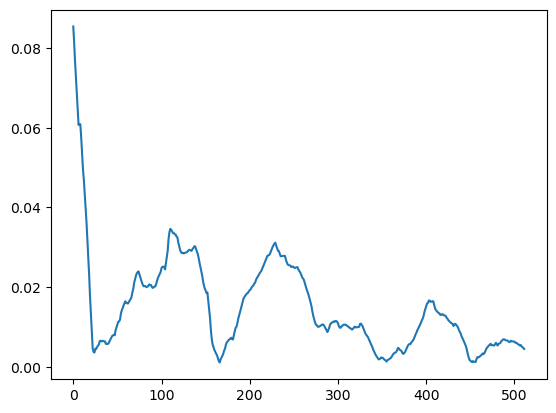

In [100]:
plt.plot(ne[1][:,0])

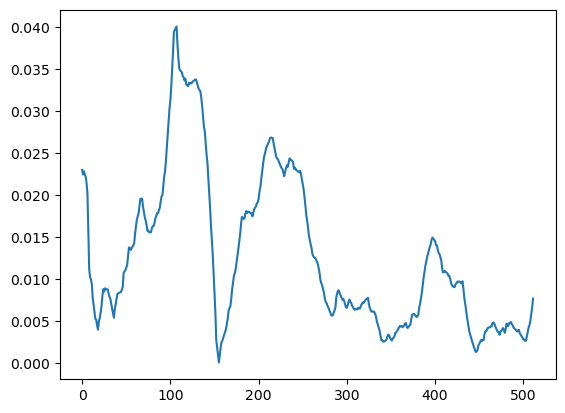

In [101]:
plt.plot(ne[1][:,1])

In [102]:
evl = model.evaluate(tfGenEval)
evl

INFO:root:File 'LU1327051279.csv' loaded, 0 left


      5/Unknown - 2s 129ms/step - loss: 0.0164 - mae: 0.1057

5/5 [==============================] - 2s 137ms/step - loss: 0.0164 - mae: 0.1057


[0.01640266552567482, 0.10573355108499527]

In [103]:
p = model.predict(tfGenEval)
p.shape

INFO:root:File 'LU1327051279.csv' loaded, 0 left


      5/Unknown - 2s 120ms/step

5/5 [==============================] - 2s 129ms/step


(2560, 2)

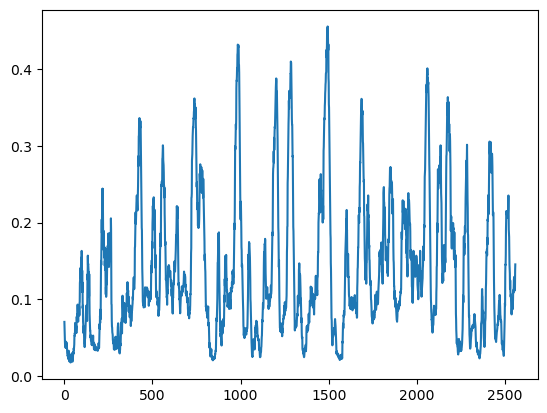

In [104]:
plt.plot(p[:,0])

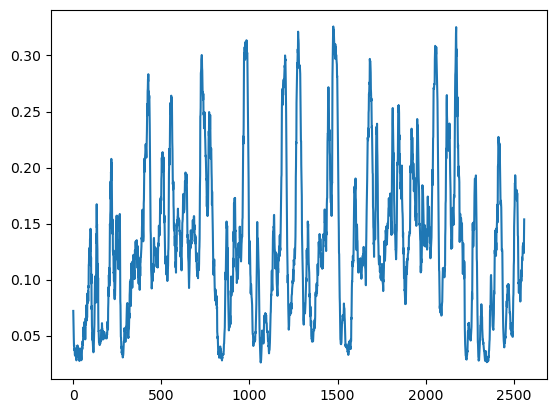

In [105]:
plt.plot(p[:,1])

In [106]:
p.shape

(2560, 2)

In [107]:
tickDF = pd.read_csv(TRAIN_FILES[1])
tickDF

startsAt    open    high     low   close  volume  quoteVolume
0     1217548800   80.95   80.95   80.95   80.95     0.0          0.0
1     1217635200   80.95   80.95   80.95   80.95     0.0          0.0
2     1217721600   80.95   80.95   80.95   80.95     0.0          0.0
3     1217808000   81.11   81.11   81.11   81.11     0.0          0.0
4     1217894400   81.10   81.10   81.10   81.10     0.0          0.0
...          ...     ...     ...     ...     ...     ...          ...
5316  1676851200  140.38  140.38  140.38  140.38     0.0          0.0
5317  1676937600  140.07  140.07  140.07  140.07     0.0          0.0
5318  1677024000  140.11  140.11  140.11  140.11     0.0          0.0
5319  1677110400  140.70  140.70  140.70  140.70     0.0          0.0
5320  1677196800  140.38  140.38  140.38  140.38     0.0          0.0

[5321 rows x 7 columns]

In [108]:
tickDF.shape[0] - p.shape[0]

2761

In [109]:
tickDFcropped = tickDF.iloc[-p.shape[0]:, :]
tickDFcropped

startsAt    open    high     low   close  volume  quoteVolume
2761  1456099200  130.39  130.39  130.39  130.39     0.0          0.0
2762  1456185600  130.74  130.74  130.74  130.74     0.0          0.0
2763  1456272000  130.76  130.76  130.76  130.76     0.0          0.0
2764  1456358400  130.35  130.35  130.35  130.35     0.0          0.0
2765  1456444800  129.89  129.89  129.89  129.89     0.0          0.0
...          ...     ...     ...     ...     ...     ...          ...
5316  1676851200  140.38  140.38  140.38  140.38     0.0          0.0
5317  1676937600  140.07  140.07  140.07  140.07     0.0          0.0
5318  1677024000  140.11  140.11  140.11  140.11     0.0          0.0
5319  1677110400  140.70  140.70  140.70  140.70     0.0          0.0
5320  1677196800  140.38  140.38  140.38  140.38     0.0          0.0

[2560 rows x 7 columns]

In [110]:
# p_dir = p[:,0]
# p_dir_derivation = p[:,1]

p_past_gain = p[:,0]
p_future_gain = p[:,1]

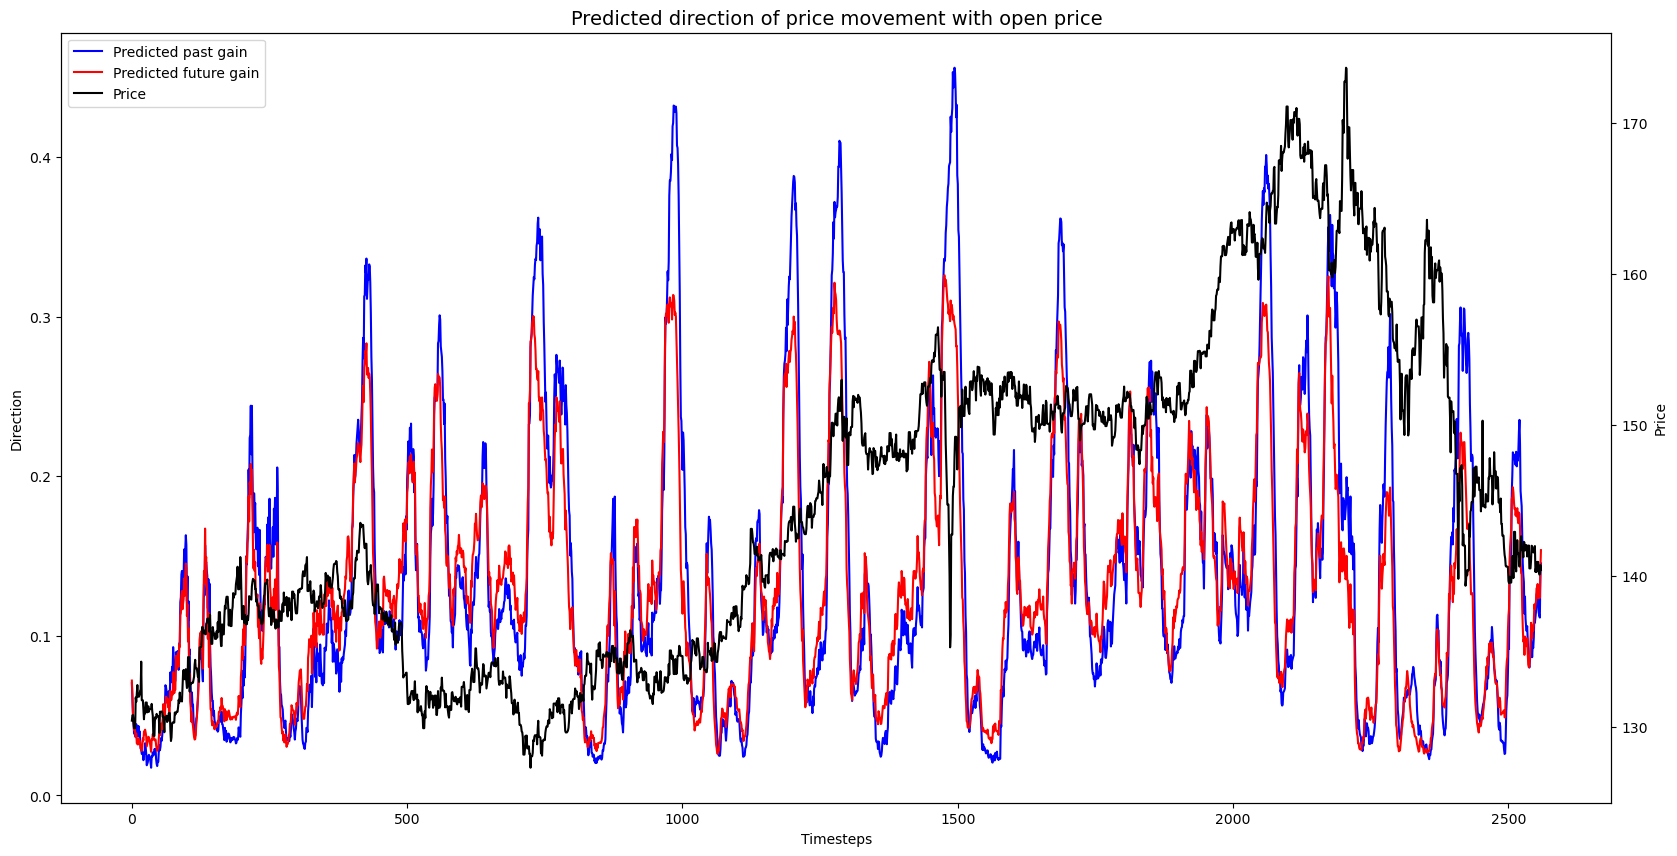

In [111]:
# Plot the prediction again, now over the open price
chart_name="Predicted direction of price movement with open price"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name, fontsize=14)

_ = ax1.plot(p_past_gain, color="blue", label="Predicted past gain")
_ = ax1.plot(p_future_gain, color="red", label="Predicted future gain")

ax2 = ax1.twinx()

ax2.plot(tickDFcropped.loc[:,'open'].values, color="black", label="Price")

ax1.set_xlabel("Timesteps")
ax1.set_ylabel("Direction")
ax2.set_ylabel("Price")

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")

# Save the figure
# fig_name = "FileListToDataStreamExample_" + chart_name.replace(" ", "_").replace("'", "").replace("(", "").replace(")", "") + ".svg"
# plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

In [112]:
#@title Buy and sell signal thresholds
BUY_SIGNAL_THRESHOLD_FUTURE = 0.15 #@param {type:"number"}
BUY_SIGNAL_THRESHOLD_PAST = 0.01 #@param {type:"number"}

SELL_SIGNAL_THRESHOLD_PAST = 0.1 #@param {type:"number"}

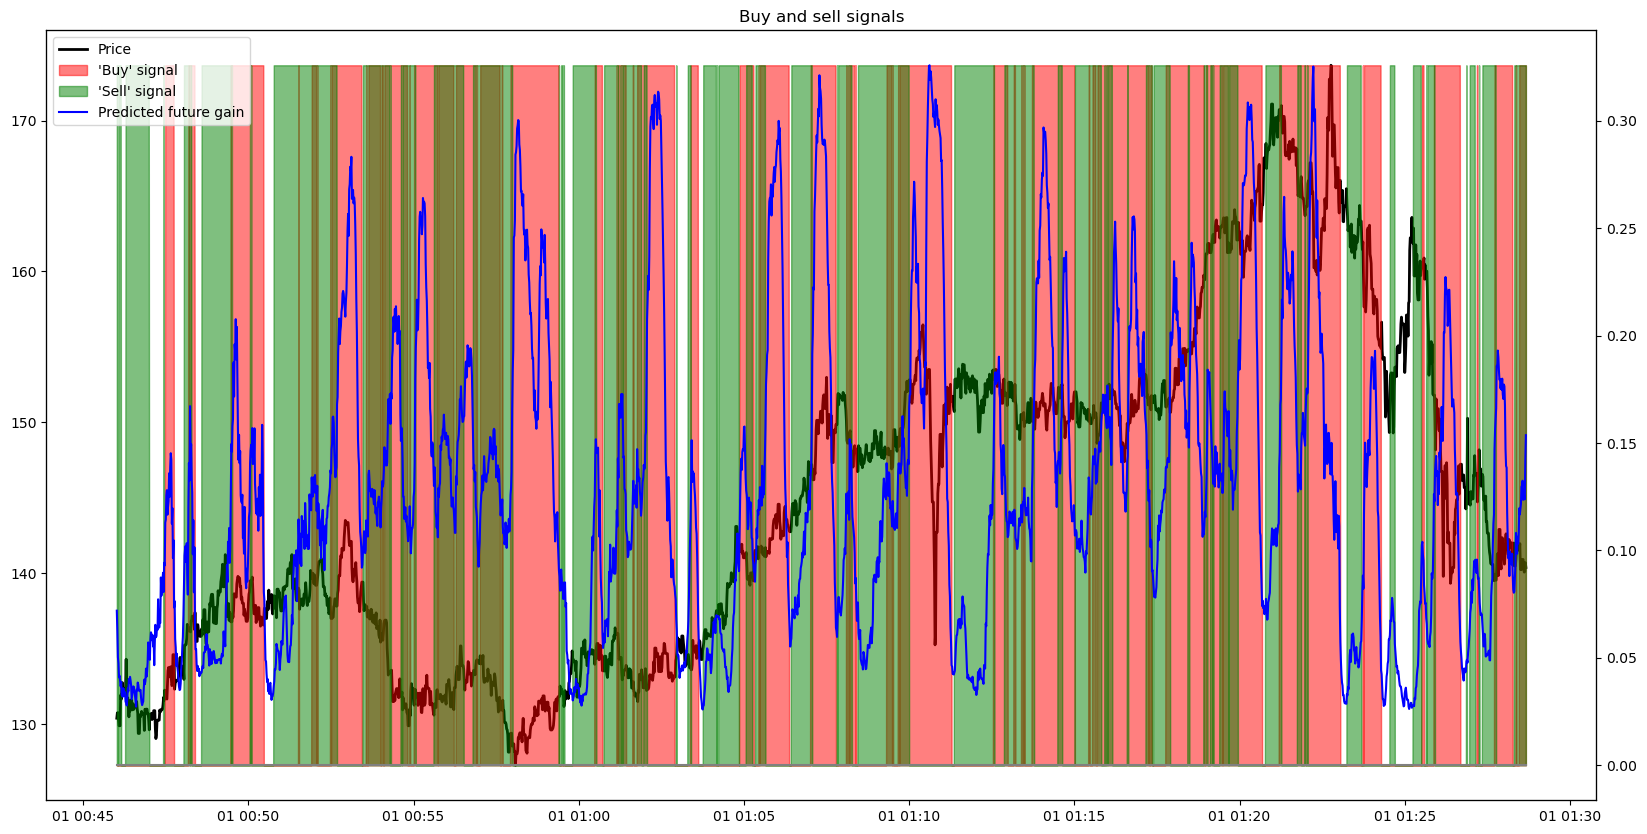

In [113]:
#@title Plot buy and sell signals
chart_name="Buy and sell signals"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name)

x_datetimes = [datetime.datetime.fromtimestamp(ts) for ts in tickDFcropped.loc[:,'open'].index]

_ = ax1.plot(x_datetimes, tickDFcropped.loc[:,'open'].values, color="black", label="Price", linewidth=2)

# Color area axis
ax2 = ax1.twinx()

# Convert the float value prediction into rising and falling categories
yCategoryFall = p_past_gain >= SELL_SIGNAL_THRESHOLD_PAST
yCategoryRise = (p_future_gain > p_past_gain) & (p_past_gain <= BUY_SIGNAL_THRESHOLD_FUTURE) #(p_future_gain >= BUY_SIGNAL_THRESHOLD_FUTURE)

ax2.fill_between(x_datetimes, yCategoryFall , alpha=0.5, color="red", label="'Buy' signal")
ax2.fill_between(x_datetimes, yCategoryRise , alpha=0.5, color="green", label="'Sell' signal")

# Remove tick marks and set limits for color area axis
ax2.set_yticks([])
ax2.set_ylim(-0.05,1.05)

ax3 = ax1.twinx()
_ = ax3.plot(x_datetimes, p_future_gain, color="blue", label="Predicted future gain")
# _ = ax3.plot(x_datetimes, 10.0*p_dir_derivation, color="red", label="10.0 * Predicted price direction derivation")
# ax3.set_ylim(-1.05,1.05)

ax3.plot([np.min(x_datetimes), np.max(x_datetimes)], [0.0,0.0], color="gray")

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax2.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc="upper left")

# Save the figure
# fig_name = chart_name.replace(" ", "_").replace("'", "") + ".svg"
# plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

# Add predictions to tick tables

In [114]:
stop

NameError: name 'stop' is not defined

In [ ]:
# PREDICTED_SAVE_PATH = "/content/dataset/etffancy/PastFutureGainV2/test"

In [115]:
!mkdir /content/dataset/etffancy/PastFutureGainV2/test5
!mkdir /content/dataset/etffancy/PastFutureGainV2/eval5

In [117]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
# https://stackoverflow.com/questions/52443273/how-do-you-send-arguments-to-a-generator-function-using-tf-data-dataset-from-gen

# fileList = EVAL_FILES
# PREDICTED_SAVE_PATH = "/content/dataset/etffancy/PastFutureGainV2/eval5"

fileList = TEST_FILES
PREDICTED_SAVE_PATH = "/content/dataset/etffancy/PastFutureGainV2/test5"

pd.options.mode.chained_assignment = None  # default='warn'

for file_index in tqdm(range(0, len(fileList))):
    try:
        filename = fileList[file_index]

        logging.info(f"\nFile name: '{filename}' for index {file_index}")

        tfGenEval = tf.data.Dataset.from_generator(lambda: pythonGeneratorEval(fileList=[filename]), 
                                                       output_types = (tf.float32, tf.float32),
                                                       output_shapes=(
                                                           (BATCH_SIZE, X_BLOCK_LENGHT, TARGET_FEATURE_CNT),
                                                           (BATCH_SIZE, 2)
                                                           )
                                                       )
        p = model.predict(tfGenEval, verbose = 0)

        logging.info(f"p.shape: {p.shape}")

        p_past_gain = p[:,0]
        p_future_gain = p[:,1]

        tickDF = pd.read_csv(filename)
        tickDFcropped = tickDF.iloc[-p.shape[0]:, :]

        tickDFcropped.loc[:,"p_past_gain"] = p_past_gain
        tickDFcropped.loc[:,"p_future_gain"] = p_future_gain

        tickDFcropped.to_csv(os.path.join(PREDICTED_SAVE_PATH, filename.split(os.path.sep)[-1]))

        logging.info("Saved the predicted data.")
    except KeyboardInterrupt:
        raise
    except Exception as ex:
        logging.warning(str(ex))

  0%|                                                                                                                                                                                   | 0/266 [00:00<?, ?it/s]INFO:root:
File name: '/content/dataset/etffancy/LU1598688189.csv' for index 0
INFO:root:File 'LU1598688189.csv' loaded, 0 left
INFO:root:p.shape: (6144, 2)
INFO:root:Saved the predicted data.
  0%|▋                                                                                                                                                                          | 1/266 [00:04<17:50,  4.04s/it]INFO:root:
File name: '/content/dataset/etffancy/IE00B8CJW150.csv' for index 1
INFO:root:File 'IE00B8CJW150.csv' loaded, 0 left
INFO:root:p.shape: (3072, 2)
INFO:root:Saved the predicted data.
  1%|█▎                                                                                                                                                                         | 2/266 [00:06<13:11, 